In [12]:
import numpy as np

from gwbench import network

import scipy.stats as stats

from scipy import interpolate, integrate
from astropy.cosmology import Planck18
from gwbench import basic_relations as br

import bilby

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "serif",
    "font.size": 14
})

%config InlineBackend.figure_format='retina' # very useful command for high-res images


In [3]:
def inner_prod_simps_normed(h1, h2, Sn, f, h1_norm = None, h2_norm=None):
    if h1_norm is None:
        h1_norm = 4*np.real(integrate.simpson(y= h1*np.conjugate(h1) / Sn, x=f))
    if h2_norm is None:
        h2_norm = 4*np.real(integrate.simpson(y= h2*np.conjugate(h2) / Sn, x=f))
    return  2*np.real(integrate.simpson(y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn, x=f)) / (np.sqrt(h1_norm * h2_norm))

def inner_prod_simps(h1, h2, Sn, f):
    return  2*np.real(integrate.simpson(y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn, x=f))

def cutler_vallisneri_overlap_vec(del_hf, delta_hf, psd, freqs):
    return np.array([ inner_prod_simps(del_hf[deriv], delta_hf, psd, freqs) for deriv in del_hf ])

# Generate high-mass binaries

In [6]:
def beta(chi, a, b):
    func = chi**(a-1) * (1-chi)**(b-1)
    norm = integrate.trapezoid(func, chi)
    return func/norm


def p_z_madau_fragos(z, z_min, z_max):
    '''
    Return normalized z-distribution from the Madau Fragos (2017)
    star formation rate density.
    '''
    term_1 = (1+z)**(2.6)
    term_2 = 1 + ((1+z)/3.2)**(6.2)

    psi = 0.01 * term_1/term_2
    norm = np.sum(psi)
    psi = psi/norm

    return psi

In [71]:
M_MIN = 30.0
M_MAX = 60.0
m_min_lim = 3.0
chi_alpha = 2.0
chi_beta = 7.0

z_min = 0.02
z_max = 50.0

num_injs = 1000

np.random.seed(42)

# SAMPLE Masses
mass1 = np.random.uniform(low=M_MIN, high=M_MAX, size=num_injs)
mass2 = np.random.uniform(low=m_min_lim, high=mass1)
    
Mcs = (mass1*mass2)**(3/5) / (mass1+mass2)**(1/5) 
etas = (mass1*mass2) / (mass1+mass2)**2

# SAMPLE Chi_1, Chi_2 (aligned)
chi_range = np.linspace(0, 1, 100000)
pdf_chi = beta(chi_range, chi_alpha, chi_beta) 
cdf_chi = integrate.cumulative_trapezoid(pdf_chi, chi_range, initial=0)
inv_cdf_chi = interpolate.interp1d(cdf_chi / cdf_chi[-1], chi_range)
chi1 = inv_cdf_chi(np.random.rand(num_injs))
chi2 = inv_cdf_chi(np.random.rand(num_injs))

# Sample spin orientations uniformly, but only select the z component
chi1z = chi1 * np.random.uniform(low=-1.0, high=1.0, size=num_injs)
chi2z = chi2 * np.random.uniform(low=-1.0, high=1.0, size=num_injs)



# SAMPLE REDSHIFTS from Madau Fragos (2017) pdf
z_range = np.linspace(z_min, z_max, 1000000)
pdf_z = p_z_madau_fragos(z_range, z_min, z_max)
cdf_z = integrate.cumulative_trapezoid(pdf_z, z_range, initial=0)
inv_cdf_z = interpolate.interp1d(cdf_z / cdf_z[-1], z_range)
redshifts = inv_cdf_z(np.random.rand(num_injs))
DLs = Planck18.luminosity_distance(redshifts).value

# Shift to Detector Frame
Mcs = Mcs * (1+redshifts)
mtotals = (mass1+mass2) * (1+redshifts)

# Sample angles
iotas = np.arccos(np.random.uniform(low=-1, high=1, size=num_injs))
ras   = np.random.uniform(low=0., high=2.*np.pi, size=num_injs)
decs  = np.arccos(np.random.uniform(low=-1, high=1, size=num_injs)) - np.pi/2
psis  = np.random.uniform(low=0., high=2.*np.pi, size=num_injs)

f_highs = np.round(4*br.f_isco_Msolar(mtotals))


(array([114., 112.,  95., 102.,  81., 111.,  98.,  88., 100.,  99.]),
 array([30.13896069, 33.12421764, 36.10947459, 39.09473154, 42.07998849,
        45.06524544, 48.0505024 , 51.03575935, 54.0210163 , 57.00627325,
        59.9915302 ]),
 <BarContainer object of 10 artists>)

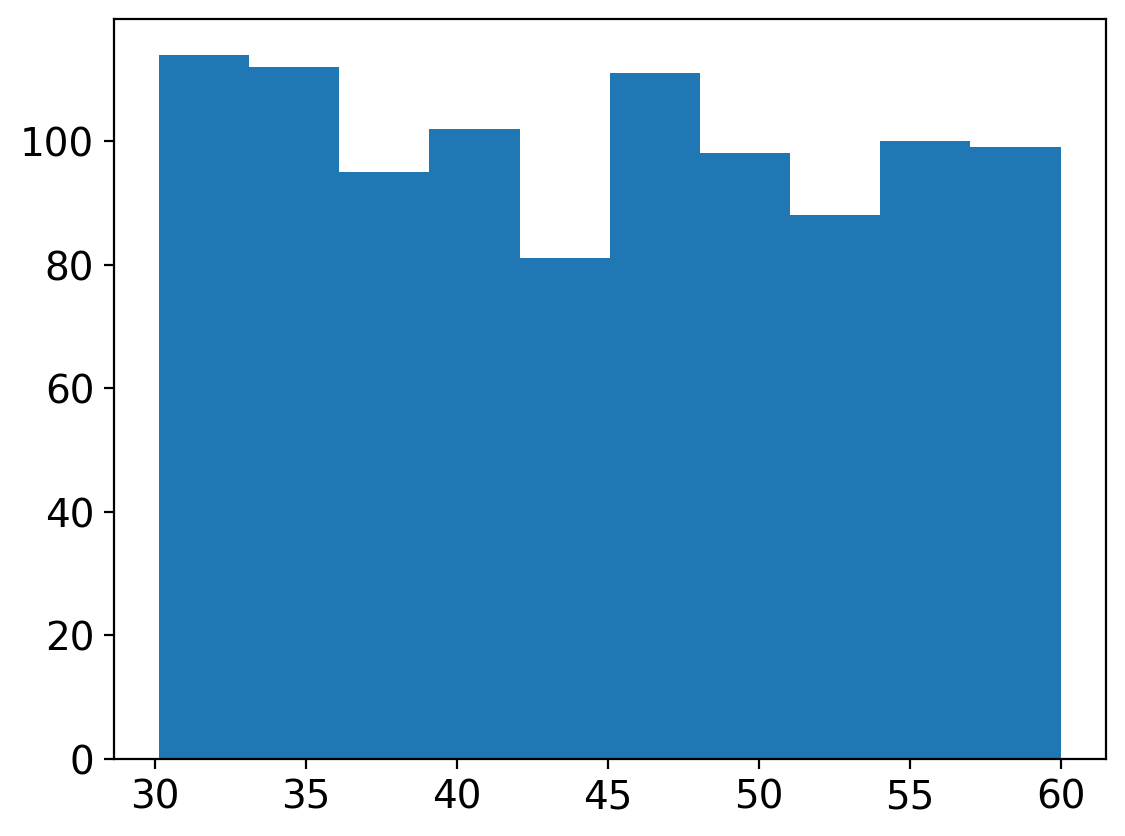

In [72]:
plt.hist(mass1)

# Compute Biases

In [73]:
network_spec = ['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']

approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

cv_bias_dicts = []
err_dicts = []
snrs = []
mass1_biased = []
mass2_biased = []


for i in range(num_injs):
    inj_params = {
        'Mc':    Mcs[i],
        'eta':   etas[i],
        'chi1x': 0.,
        'chi2x': 0.,
        'chi1y': 0.,
        'chi2y': 0.,
        'chi1z': chi1z[i],
        'chi2z': chi2z[i],
        'DL':    DLs[i],
        'tc':    0.,
        'phic':  0.,
        'iota':  iotas[i],
        'ra':    ras[i],
        'dec':   decs[i],
        'psi':   psis[i],
        # 'gmst0': bilby.gw.utils.greenwich_mean_sidereal_time(0.),
        'gmst0': 0.,
        'fRef': 5.
    } 

    d_f = 2**-4
    f_low = 5.
    f = np.arange(f_low, f_highs[i], d_f)
    
    deriv_symbs_string = 'Mc eta DL chi1z chi2z tc phic iota ra dec psi'
    deriv_variables = ['Mc', 'eta', 'DL', 'chi1z', 'chi2z', 'tc', 'phic', 'iota', 'ra', 'dec', 'psi']

    net_ap = network.Network(network_spec=network_spec)

    approximant = 'IMRPhenomD'
    wf_model_name = 'lal_bbh'
    # pass the chosen waveform to the network for initialization
    net_ap.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant, 'fRef':inj_params['fRef']})


    use_rot = 0

    net_ap.set_net_vars(
        f=f, inj_params=inj_params,
        deriv_symbs_string=deriv_symbs_string,
        use_rot=use_rot
        )
    net_ap.calc_wf_polarizations()
    net_ap.calc_wf_polarizations_derivs_num(step=1e-9, method='central', order=2, n=1)
    net_ap.setup_ant_pat_lpf_psds()
    net_ap.calc_det_responses()
    net_ap.calc_det_responses_derivs_num(step=1e-9, method='central', order=2, n=1)
    net_ap.calc_snrs()
    net_ap.calc_errors()

    snrs.append(net_ap.snr)

    net_tr = network.Network(network_spec=network_spec)

    approximant = 'IMRPhenomXAS'
    wf_model_name = 'lal_bbh'
    # pass the chosen waveform to the network for initialization
    net_tr.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant, 'fRef':inj_params['fRef']})

    net_tr.set_net_vars(
        f=f, inj_params=inj_params,
        deriv_symbs_string=deriv_symbs_string,
        use_rot=use_rot
        )
    net_tr.calc_wf_polarizations()
    net_tr.setup_ant_pat_lpf_psds()
    net_tr.calc_det_responses()
    net_tr.calc_snrs()


    overlap_vecs_network = np.zeros((len(net_ap.detectors), len(net_ap.deriv_variables)))

    time_arr_d = np.linspace(0.00, 0.10, 801)

    for d in range(len(net_ap.detectors)):

        ## set up initial waveforms
        h1 = net_tr.detectors[d].hf
        h2 = net_ap.detectors[d].hf
        f = net_ap.detectors[d].f
        Sn = net_ap.detectors[d].psd
        network_spec_d = [net_ap.detectors[d].det_key]

        x_t0_re_d = np.zeros(len(time_arr_d))
        x_t0_im_d = np.zeros(len(time_arr_d))

        for tt in range(len(time_arr_d)):
            t0 = time_arr_d[tt]
            x_t0_d = 4*(integrate.simpson(h1 * np.conjugate(h2) * np.exp(2*np.pi*1j*f*t0)/ Sn, x=f))
            x_t0_re_d[tt] = np.real(x_t0_d)
            x_t0_im_d[tt] = np.imag(x_t0_d)

        max_idx = np.argmax(x_t0_re_d**2 + x_t0_im_d**2)
        time_shift_d = time_arr_d[max_idx]
        phase_shift_d = (np.angle(x_t0_re_d + 1j*x_t0_im_d))[max_idx]

 
        inj_params_opt_d = inj_params.copy()
        inj_params_opt_d['tc'] = time_shift_d # should be positive when shifting XAS to maximize overlap
        inj_params_opt_d['phic'] = phase_shift_d  # should be positive when shifting XAS to maximize overlap

        # plt.title(network_spec_d)
        # plt.plot(time_arr_d, x_t0_re_d**2 + x_t0_im_d**2)
        # plt.axvline(x=time_shift_d, ls='--', c='r')
        # plt.xlabel('$t_0$ [s]')
        # plt.ylabel("$x(t_0)$")
        # plt.loglog()
        # plt.xlim(1e-4, 1e0)
        # plt.show()
        # print("time shift:", time_shift_d)
        # print("phase shift:", phase_shift_d)

        net_tr_opt_d = network.Network(network_spec=network_spec_d)
        net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomXAS', 'fRef':inj_params['fRef']})
        net_tr_opt_d.set_net_vars(
            f=f, inj_params=inj_params_opt_d,
            deriv_symbs_string=deriv_symbs_string,
            use_rot=use_rot
            )
        net_tr_opt_d.calc_wf_polarizations()
        net_tr_opt_d.setup_ant_pat_lpf_psds()
        net_tr_opt_d.calc_det_responses()
        net_tr_opt_d.calc_wf_polarizations()


        print("Inner product:")
        print(inner_prod_simps_normed(net_ap.detectors[d].hf, net_tr_opt_d.detectors[0].hf, net_ap.detectors[d].psd, net_ap.detectors[d].f))
    
        ## Compute CV overlap vector for this detector
        delta_hf = net_tr_opt_d.detectors[0].hf - net_ap.detectors[d].hf
        overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap.detectors[d].del_hf, delta_hf, net_ap.detectors[d].psd, net_ap.detectors[d].f)

    cv_bias_opt = np.matmul(net_ap.cov, np.sum(overlap_vecs_network, axis=0))
    cv_bias_opt = np.array(cv_bias_opt.tolist()[0])

    cv_bias_opt_dict = {}

    for p, param in enumerate(net_ap.deriv_variables):
        cv_bias_opt_dict[param] = cv_bias_opt[p]

    cv_bias_dicts.append(cv_bias_opt_dict)
    err_dicts.append(net_ap.errs)

    m1_biased, m2_biased = br.m1_m2_of_Mc_eta((inj_params["Mc"]+cv_bias_opt_dict["Mc"]) / (1+redshifts[i]), inj_params["eta"]+cv_bias_opt_dict["eta"])
    print("M1 biased:", m1_biased)
    mass1_biased.append(m1_biased)
    mass2_biased.append(m2_biased)

2024-01-14 10:55:53,022 - Network - INFO : Polarizations calculated.
2024-01-14 10:55:53,024 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:55:53,027 - Network - INFO : Polarizations calculated.


2024-01-14 10:55:53,422 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:55:53,493 - Network - INFO : PSDs loaded.
2024-01-14 10:55:53,496 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:55:53,510 - Network - INFO : Detector responses calculated.
2024-01-14 10:55:53,511 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:55:53,512 - Network - INFO :    CE-40_C
2024-01-14 10:55:53,869 - Network - INFO :    CE-20_S
2024-01-14 10:55:54,241 - Network - INFO :    ET_ET1
2024-01-14 10:55:54,610 - Network - INFO :    ET_ET2
2024-01-14 10:55:54,975 - Network - INFO :    ET_ET3
2024-01-14 10:55:55,337 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:55:55,340 - Network - INFO : SNRs calculated.
2024-01-14 10:55:55,341 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:55:55,342 - Network - INFO :    CE-40_C
2024-01-14 10:55:55,423 - Network - INFO :

Inner product:
0.9981348677044921
Inner product:
0.9981645494471431


2024-01-14 10:55:56,363 - Network - INFO : Polarizations calculated.
2024-01-14 10:55:56,378 - Network - INFO : PSDs loaded.
2024-01-14 10:55:56,379 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:55:56,382 - Network - INFO : Detector responses calculated.
2024-01-14 10:55:56,385 - Network - INFO : Polarizations calculated.


Inner product:
0.9980611710835978


2024-01-14 10:55:56,651 - Network - INFO : Polarizations calculated.
2024-01-14 10:55:56,665 - Network - INFO : PSDs loaded.
2024-01-14 10:55:56,666 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:55:56,670 - Network - INFO : Detector responses calculated.
2024-01-14 10:55:56,679 - Network - INFO : Polarizations calculated.


Inner product:
0.9980611710835978


2024-01-14 10:55:56,953 - Network - INFO : Polarizations calculated.
2024-01-14 10:55:56,973 - Network - INFO : PSDs loaded.
2024-01-14 10:55:56,974 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:55:56,979 - Network - INFO : Detector responses calculated.
2024-01-14 10:55:56,983 - Network - INFO : Polarizations calculated.
2024-01-14 10:55:56,996 - Network - INFO : Polarizations calculated.
2024-01-14 10:55:56,997 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:55:57,001 - Network - INFO : Polarizations calculated.


Inner product:
0.9980611710835978
M1 biased: 42.92636698418496


2024-01-14 10:55:57,523 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:55:57,593 - Network - INFO : PSDs loaded.
2024-01-14 10:55:57,596 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:55:57,611 - Network - INFO : Detector responses calculated.
2024-01-14 10:55:57,612 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:55:57,612 - Network - INFO :    CE-40_C
2024-01-14 10:55:57,961 - Network - INFO :    CE-20_S
2024-01-14 10:55:58,311 - Network - INFO :    ET_ET1
2024-01-14 10:55:58,656 - Network - INFO :    ET_ET2
2024-01-14 10:55:59,011 - Network - INFO :    ET_ET3
2024-01-14 10:55:59,409 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:55:59,414 - Network - INFO : SNRs calculated.
2024-01-14 10:55:59,415 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:55:59,415 - Network - INFO :    CE-40_C
2024-01-14 10:55:59,504 - Network - INFO :

Inner product:
0.999319252858835


2024-01-14 10:56:00,594 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:00,607 - Network - INFO : PSDs loaded.
2024-01-14 10:56:00,610 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:00,619 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:00,625 - Network - INFO : Polarizations calculated.


Inner product:
0.9992942765006074


2024-01-14 10:56:00,946 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:00,962 - Network - INFO : PSDs loaded.
2024-01-14 10:56:00,963 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:00,967 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:00,970 - Network - INFO : Polarizations calculated.


Inner product:
0.9992908129209997


2024-01-14 10:56:01,272 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:01,286 - Network - INFO : PSDs loaded.
2024-01-14 10:56:01,287 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:01,291 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:01,294 - Network - INFO : Polarizations calculated.


Inner product:
0.9992908129209997


2024-01-14 10:56:01,579 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:01,596 - Network - INFO : PSDs loaded.
2024-01-14 10:56:01,598 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:01,602 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:01,606 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:01,616 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:01,616 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:56:01,619 - Network - INFO : Polarizations calculated.


Inner product:
0.9992908129209999
M1 biased: 61.28294985286715


2024-01-14 10:56:01,957 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:56:02,028 - Network - INFO : PSDs loaded.
2024-01-14 10:56:02,030 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:02,048 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:02,050 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:56:02,052 - Network - INFO :    CE-40_C
2024-01-14 10:56:02,277 - Network - INFO :    CE-20_S
2024-01-14 10:56:02,487 - Network - INFO :    ET_ET1
2024-01-14 10:56:02,693 - Network - INFO :    ET_ET2
2024-01-14 10:56:02,898 - Network - INFO :    ET_ET3
2024-01-14 10:56:03,110 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:56:03,112 - Network - INFO : SNRs calculated.
2024-01-14 10:56:03,113 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:56:03,114 - Network - INFO :    CE-40_C
2024-01-14 10:56:03,199 - Network - INFO :

Inner product:
0.9998129390869049
Inner product:
0.9998311597126639


2024-01-14 10:56:04,217 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:04,238 - Network - INFO : PSDs loaded.
2024-01-14 10:56:04,239 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:04,242 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:04,246 - Network - INFO : Polarizations calculated.


Inner product:
0.9997223181059491


2024-01-14 10:56:04,485 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:04,507 - Network - INFO : PSDs loaded.
2024-01-14 10:56:04,508 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:04,513 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:04,517 - Network - INFO : Polarizations calculated.


Inner product:
0.9997223181059492


2024-01-14 10:56:04,778 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:04,799 - Network - INFO : PSDs loaded.
2024-01-14 10:56:04,801 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:04,807 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:04,813 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:04,827 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:04,828 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:56:04,833 - Network - INFO : Polarizations calculated.


Inner product:
0.9997223181059492
M1 biased: 57.61522260089504


2024-01-14 10:56:05,421 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:56:05,492 - Network - INFO : PSDs loaded.
2024-01-14 10:56:05,495 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:05,509 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:05,510 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:56:05,511 - Network - INFO :    CE-40_C
2024-01-14 10:56:05,806 - Network - INFO :    CE-20_S
2024-01-14 10:56:06,119 - Network - INFO :    ET_ET1
2024-01-14 10:56:06,405 - Network - INFO :    ET_ET2
2024-01-14 10:56:06,718 - Network - INFO :    ET_ET3
2024-01-14 10:56:06,985 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:56:06,988 - Network - INFO : SNRs calculated.
2024-01-14 10:56:06,989 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:56:06,990 - Network - INFO :    CE-40_C
2024-01-14 10:56:07,074 - Network - INFO :

Inner product:
0.9995696434742127


2024-01-14 10:56:07,951 - Network - INFO : Polarizations calculated.


Inner product:
0.9995959576595302


2024-01-14 10:56:08,214 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:08,229 - Network - INFO : PSDs loaded.
2024-01-14 10:56:08,230 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:08,240 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:08,246 - Network - INFO : Polarizations calculated.


Inner product:
0.9994878091784649


2024-01-14 10:56:08,513 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:08,528 - Network - INFO : PSDs loaded.
2024-01-14 10:56:08,529 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:08,533 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:08,536 - Network - INFO : Polarizations calculated.


Inner product:
0.9994878091784648


2024-01-14 10:56:08,776 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:08,794 - Network - INFO : PSDs loaded.
2024-01-14 10:56:08,795 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:08,799 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:08,803 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:08,813 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:08,813 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:56:08,816 - Network - INFO : Polarizations calculated.


Inner product:
0.9994878091784648
M1 biased: 52.37275349254028


2024-01-14 10:56:09,497 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:56:09,575 - Network - INFO : PSDs loaded.
2024-01-14 10:56:09,578 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:09,593 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:09,594 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:56:09,594 - Network - INFO :    CE-40_C
2024-01-14 10:56:10,105 - Network - INFO :    CE-20_S
2024-01-14 10:56:10,618 - Network - INFO :    ET_ET1
2024-01-14 10:56:11,172 - Network - INFO :    ET_ET2
2024-01-14 10:56:11,675 - Network - INFO :    ET_ET3
2024-01-14 10:56:12,161 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:56:12,165 - Network - INFO : SNRs calculated.
2024-01-14 10:56:12,166 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:56:12,166 - Network - INFO :    CE-40_C
2024-01-14 10:56:12,249 - Network - INFO :

Inner product:
0.9994553121260789


2024-01-14 10:56:13,194 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:13,208 - Network - INFO : PSDs loaded.
2024-01-14 10:56:13,210 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:13,217 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:13,267 - Network - INFO : Polarizations calculated.


Inner product:
0.9993822487231394


2024-01-14 10:56:13,634 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:13,650 - Network - INFO : PSDs loaded.
2024-01-14 10:56:13,651 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:13,655 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:13,658 - Network - INFO : Polarizations calculated.


Inner product:
0.9994773594291819


2024-01-14 10:56:13,972 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:13,987 - Network - INFO : PSDs loaded.
2024-01-14 10:56:13,988 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:13,993 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:13,998 - Network - INFO : Polarizations calculated.


Inner product:
0.999477359429182


2024-01-14 10:56:14,338 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:14,352 - Network - INFO : PSDs loaded.
2024-01-14 10:56:14,353 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:14,357 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:14,361 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:14,369 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:14,370 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:56:14,373 - Network - INFO : Polarizations calculated.


Inner product:
0.9994773594291819
M1 biased: 38.27847682883914


2024-01-14 10:56:14,667 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:56:14,742 - Network - INFO : PSDs loaded.
2024-01-14 10:56:14,744 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:14,757 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:14,758 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:56:14,759 - Network - INFO :    CE-40_C
2024-01-14 10:56:14,968 - Network - INFO :    CE-20_S
2024-01-14 10:56:15,171 - Network - INFO :    ET_ET1
2024-01-14 10:56:15,377 - Network - INFO :    ET_ET2
2024-01-14 10:56:15,583 - Network - INFO :    ET_ET3
2024-01-14 10:56:15,787 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:56:15,789 - Network - INFO : SNRs calculated.
2024-01-14 10:56:15,790 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:56:15,791 - Network - INFO :    CE-40_C
2024-01-14 10:56:15,881 - Network - INFO :

Inner product:
0.9998241699046693
Inner product:
0.9998440006926061


2024-01-14 10:56:16,812 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:16,833 - Network - INFO : PSDs loaded.
2024-01-14 10:56:16,834 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:16,839 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:16,844 - Network - INFO : Polarizations calculated.


Inner product:
0.9996996538967524


2024-01-14 10:56:17,124 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:17,139 - Network - INFO : PSDs loaded.
2024-01-14 10:56:17,141 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:17,144 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:17,147 - Network - INFO : Polarizations calculated.


Inner product:
0.9996996538967524


2024-01-14 10:56:17,376 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:17,397 - Network - INFO : PSDs loaded.
2024-01-14 10:56:17,399 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:17,403 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:17,407 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:17,419 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:17,420 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:56:17,423 - Network - INFO : Polarizations calculated.


Inner product:
0.9996996538967524
M1 biased: 40.746761398822294


2024-01-14 10:56:17,979 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:56:18,052 - Network - INFO : PSDs loaded.
2024-01-14 10:56:18,056 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:18,071 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:18,072 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:56:18,073 - Network - INFO :    CE-40_C
2024-01-14 10:56:18,505 - Network - INFO :    CE-20_S
2024-01-14 10:56:18,913 - Network - INFO :    ET_ET1
2024-01-14 10:56:19,303 - Network - INFO :    ET_ET2
2024-01-14 10:56:19,694 - Network - INFO :    ET_ET3
2024-01-14 10:56:20,086 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:56:20,090 - Network - INFO : SNRs calculated.
2024-01-14 10:56:20,091 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:56:20,092 - Network - INFO :    CE-40_C
2024-01-14 10:56:20,178 - Network - INFO :

Inner product:
0.9991431041169938


2024-01-14 10:56:20,998 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:21,008 - Network - INFO : PSDs loaded.
2024-01-14 10:56:21,010 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:21,015 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:21,019 - Network - INFO : Polarizations calculated.


Inner product:
0.9991233698645422


2024-01-14 10:56:21,335 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:21,351 - Network - INFO : PSDs loaded.
2024-01-14 10:56:21,352 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:21,356 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:21,359 - Network - INFO : Polarizations calculated.


Inner product:
0.9992115478230241


2024-01-14 10:56:21,659 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:21,674 - Network - INFO : PSDs loaded.
2024-01-14 10:56:21,675 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:21,679 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:21,683 - Network - INFO : Polarizations calculated.


Inner product:
0.9992115478230241


2024-01-14 10:56:21,968 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:21,983 - Network - INFO : PSDs loaded.
2024-01-14 10:56:21,984 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:21,989 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:21,992 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:22,000 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:22,001 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:56:22,004 - Network - INFO : Polarizations calculated.


Inner product:
0.999211547823024
M1 biased: 33.79114835366075


2024-01-14 10:56:22,566 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:56:22,638 - Network - INFO : PSDs loaded.
2024-01-14 10:56:22,642 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:22,657 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:22,658 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:56:22,659 - Network - INFO :    CE-40_C
2024-01-14 10:56:23,079 - Network - INFO :    CE-20_S
2024-01-14 10:56:23,547 - Network - INFO :    ET_ET1
2024-01-14 10:56:23,998 - Network - INFO :    ET_ET2
2024-01-14 10:56:24,426 - Network - INFO :    ET_ET3
2024-01-14 10:56:24,810 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:56:24,814 - Network - INFO : SNRs calculated.
2024-01-14 10:56:24,814 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:56:24,815 - Network - INFO :    CE-40_C
2024-01-14 10:56:24,898 - Network - INFO :

Inner product:
0.999485812202996


2024-01-14 10:56:25,588 - Network - INFO : PSDs loaded.
2024-01-14 10:56:25,590 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:25,596 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:25,601 - Network - INFO : Polarizations calculated.


Inner product:
0.9994778846474429


2024-01-14 10:56:25,885 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:25,900 - Network - INFO : PSDs loaded.
2024-01-14 10:56:25,901 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:25,904 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:25,908 - Network - INFO : Polarizations calculated.


Inner product:
0.9995369306763378


2024-01-14 10:56:26,177 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:26,192 - Network - INFO : PSDs loaded.
2024-01-14 10:56:26,193 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:26,197 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:26,200 - Network - INFO : Polarizations calculated.


Inner product:
0.9995369306763376


2024-01-14 10:56:26,488 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:26,700 - Network - INFO : PSDs loaded.
2024-01-14 10:56:26,701 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:26,707 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:26,712 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:26,723 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:26,724 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:56:26,729 - Network - INFO : Polarizations calculated.


Inner product:
0.9995369306763376
M1 biased: 62.17231195189399


2024-01-14 10:56:27,246 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:56:27,318 - Network - INFO : PSDs loaded.
2024-01-14 10:56:27,321 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:27,336 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:27,337 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:56:27,337 - Network - INFO :    CE-40_C
2024-01-14 10:56:27,655 - Network - INFO :    CE-20_S
2024-01-14 10:56:27,976 - Network - INFO :    ET_ET1
2024-01-14 10:56:28,469 - Network - INFO :    ET_ET2
2024-01-14 10:56:28,861 - Network - INFO :    ET_ET3
2024-01-14 10:56:29,227 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:56:29,231 - Network - INFO : SNRs calculated.
2024-01-14 10:56:29,232 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:56:29,233 - Network - INFO :    CE-40_C
2024-01-14 10:56:29,314 - Network - INFO :

Inner product:
0.9989253770099868
Inner product:
0.9989889913598619


2024-01-14 10:56:30,395 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:30,417 - Network - INFO : PSDs loaded.
2024-01-14 10:56:30,418 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:30,424 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:30,431 - Network - INFO : Polarizations calculated.


Inner product:
0.9986379325382702


2024-01-14 10:56:30,731 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:30,748 - Network - INFO : PSDs loaded.
2024-01-14 10:56:30,750 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:30,754 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:30,758 - Network - INFO : Polarizations calculated.


Inner product:
0.9986379325382702


2024-01-14 10:56:31,049 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:31,068 - Network - INFO : PSDs loaded.
2024-01-14 10:56:31,069 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:31,074 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:31,088 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:31,112 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:31,113 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:56:31,132 - Network - INFO : Polarizations calculated.


Inner product:
0.9986379325382702
M1 biased: 49.61784959011281


2024-01-14 10:56:31,857 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:56:31,928 - Network - INFO : PSDs loaded.
2024-01-14 10:56:31,932 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:31,947 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:31,948 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:56:31,949 - Network - INFO :    CE-40_C
2024-01-14 10:56:32,330 - Network - INFO :    CE-20_S
2024-01-14 10:56:32,712 - Network - INFO :    ET_ET1
2024-01-14 10:56:33,097 - Network - INFO :    ET_ET2
2024-01-14 10:56:33,464 - Network - INFO :    ET_ET3
2024-01-14 10:56:33,836 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:56:33,840 - Network - INFO : SNRs calculated.
2024-01-14 10:56:33,841 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:56:33,842 - Network - INFO :    CE-40_C
2024-01-14 10:56:33,927 - Network - INFO :

Inner product:
0.9988541426872277


2024-01-14 10:56:34,636 - Network - INFO : PSDs loaded.
2024-01-14 10:56:34,637 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:34,643 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:34,648 - Network - INFO : Polarizations calculated.


Inner product:
0.9988534347436981


2024-01-14 10:56:34,941 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:34,956 - Network - INFO : PSDs loaded.
2024-01-14 10:56:34,957 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:34,961 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:34,965 - Network - INFO : Polarizations calculated.


Inner product:
0.9987508893078269


2024-01-14 10:56:35,259 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:35,277 - Network - INFO : PSDs loaded.
2024-01-14 10:56:35,278 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:35,283 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:35,288 - Network - INFO : Polarizations calculated.


Inner product:
0.998750889307827


2024-01-14 10:56:35,576 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:35,591 - Network - INFO : PSDs loaded.
2024-01-14 10:56:35,592 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:35,596 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:35,599 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:35,609 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:35,609 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:56:35,612 - Network - INFO : Polarizations calculated.


Inner product:
0.9987508893078269
M1 biased: 54.30154646341885


2024-01-14 10:56:36,178 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:56:36,249 - Network - INFO : PSDs loaded.
2024-01-14 10:56:36,253 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:36,268 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:36,269 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:56:36,270 - Network - INFO :    CE-40_C
2024-01-14 10:56:36,633 - Network - INFO :    CE-20_S
2024-01-14 10:56:36,991 - Network - INFO :    ET_ET1
2024-01-14 10:56:37,378 - Network - INFO :    ET_ET2
2024-01-14 10:56:37,860 - Network - INFO :    ET_ET3
2024-01-14 10:56:38,284 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:56:38,289 - Network - INFO : SNRs calculated.
2024-01-14 10:56:38,290 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:56:38,291 - Network - INFO :    CE-40_C
2024-01-14 10:56:38,378 - Network - INFO :

Inner product:
0.9985173517494874


2024-01-14 10:56:39,321 - Network - INFO : Polarizations calculated.


Inner product:
0.9985357017996818


2024-01-14 10:56:39,607 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:39,622 - Network - INFO : PSDs loaded.
2024-01-14 10:56:39,623 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:39,627 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:39,631 - Network - INFO : Polarizations calculated.


Inner product:
0.9982461649513634


2024-01-14 10:56:39,933 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:39,956 - Network - INFO : PSDs loaded.
2024-01-14 10:56:39,958 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:39,964 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:39,970 - Network - INFO : Polarizations calculated.


Inner product:
0.9982461649513633


2024-01-14 10:56:40,313 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:40,335 - Network - INFO : PSDs loaded.
2024-01-14 10:56:40,337 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:40,342 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:40,348 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:40,362 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:40,363 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:56:40,366 - Network - INFO : Polarizations calculated.


Inner product:
0.9982461649513632
M1 biased: 31.65807635223857


2024-01-14 10:56:40,770 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:56:40,842 - Network - INFO : PSDs loaded.
2024-01-14 10:56:40,844 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:40,858 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:40,859 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:56:40,860 - Network - INFO :    CE-40_C
2024-01-14 10:56:41,059 - Network - INFO :    CE-20_S
2024-01-14 10:56:41,250 - Network - INFO :    ET_ET1
2024-01-14 10:56:41,451 - Network - INFO :    ET_ET2
2024-01-14 10:56:41,653 - Network - INFO :    ET_ET3
2024-01-14 10:56:41,855 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:56:41,857 - Network - INFO : SNRs calculated.
2024-01-14 10:56:41,858 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:56:41,859 - Network - INFO :    CE-40_C
2024-01-14 10:56:41,952 - Network - INFO :

Inner product:
0.999833152077747
Inner product:
0.9998535949401215


2024-01-14 10:56:42,945 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:42,966 - Network - INFO : PSDs loaded.
2024-01-14 10:56:42,967 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:42,972 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:42,976 - Network - INFO : Polarizations calculated.


Inner product:
0.9996945269897509


2024-01-14 10:56:43,206 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:43,228 - Network - INFO : PSDs loaded.
2024-01-14 10:56:43,229 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:43,233 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:43,238 - Network - INFO : Polarizations calculated.


Inner product:
0.999694526989751


2024-01-14 10:56:43,469 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:43,494 - Network - INFO : PSDs loaded.
2024-01-14 10:56:43,496 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:43,502 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:43,506 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:43,518 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:43,519 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:56:43,522 - Network - INFO : Polarizations calculated.


Inner product:
0.9996945269897508
M1 biased: 67.79344449549467


2024-01-14 10:56:43,733 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:56:43,812 - Network - INFO : PSDs loaded.
2024-01-14 10:56:43,814 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:43,831 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:43,832 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:56:43,832 - Network - INFO :    CE-40_C
2024-01-14 10:56:44,002 - Network - INFO :    CE-20_S
2024-01-14 10:56:44,180 - Network - INFO :    ET_ET1
2024-01-14 10:56:44,352 - Network - INFO :    ET_ET2
2024-01-14 10:56:44,503 - Network - INFO :    ET_ET3
2024-01-14 10:56:44,661 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:56:44,664 - Network - INFO : SNRs calculated.
2024-01-14 10:56:44,665 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:56:44,665 - Network - INFO :    CE-40_C
2024-01-14 10:56:44,895 - Network - INFO :

Inner product:
0.9999734472940395
Inner product:
0.9999742950632188


2024-01-14 10:56:45,795 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:45,819 - Network - INFO : PSDs loaded.
2024-01-14 10:56:45,820 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:45,827 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:45,832 - Network - INFO : Polarizations calculated.


Inner product:
0.9999050420401374


2024-01-14 10:56:46,095 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:46,113 - Network - INFO : PSDs loaded.
2024-01-14 10:56:46,114 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:46,117 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:46,121 - Network - INFO : Polarizations calculated.


Inner product:
0.9999050420401375


2024-01-14 10:56:46,342 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:46,367 - Network - INFO : PSDs loaded.
2024-01-14 10:56:46,368 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:46,373 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:46,378 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:46,391 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:46,392 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:56:46,396 - Network - INFO : Polarizations calculated.


Inner product:
0.9999050420401376
M1 biased: 77.59619353620522


2024-01-14 10:56:47,151 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:56:47,222 - Network - INFO : PSDs loaded.
2024-01-14 10:56:47,225 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:47,241 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:47,242 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:56:47,242 - Network - INFO :    CE-40_C
2024-01-14 10:56:47,799 - Network - INFO :    CE-20_S
2024-01-14 10:56:48,321 - Network - INFO :    ET_ET1
2024-01-14 10:56:48,831 - Network - INFO :    ET_ET2
2024-01-14 10:56:49,326 - Network - INFO :    ET_ET3
2024-01-14 10:56:49,860 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:56:49,863 - Network - INFO : SNRs calculated.
2024-01-14 10:56:49,864 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:56:49,865 - Network - INFO :    CE-40_C
2024-01-14 10:56:49,956 - Network - INFO :

Inner product:
0.9981687720511061


2024-01-14 10:56:50,806 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:50,815 - Network - INFO : PSDs loaded.
2024-01-14 10:56:50,816 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:50,821 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:50,826 - Network - INFO : Polarizations calculated.


Inner product:
0.997940862577017


2024-01-14 10:56:51,147 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:51,162 - Network - INFO : PSDs loaded.
2024-01-14 10:56:51,163 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:51,167 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:51,170 - Network - INFO : Polarizations calculated.


Inner product:
0.998219434152028


2024-01-14 10:56:51,484 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:51,499 - Network - INFO : PSDs loaded.
2024-01-14 10:56:51,500 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:51,505 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:51,508 - Network - INFO : Polarizations calculated.


Inner product:
0.9982194341520284


2024-01-14 10:56:51,818 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:51,832 - Network - INFO : PSDs loaded.
2024-01-14 10:56:51,834 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:51,838 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:51,842 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:51,850 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:51,851 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:56:51,854 - Network - INFO : Polarizations calculated.


Inner product:
0.9982194341520285
M1 biased: 37.90477700937019


2024-01-14 10:56:52,353 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:56:52,422 - Network - INFO : PSDs loaded.
2024-01-14 10:56:52,426 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:52,441 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:52,442 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:56:52,443 - Network - INFO :    CE-40_C
2024-01-14 10:56:52,805 - Network - INFO :    CE-20_S
2024-01-14 10:56:53,172 - Network - INFO :    ET_ET1
2024-01-14 10:56:53,595 - Network - INFO :    ET_ET2
2024-01-14 10:56:53,956 - Network - INFO :    ET_ET3
2024-01-14 10:56:54,323 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:56:54,327 - Network - INFO : SNRs calculated.
2024-01-14 10:56:54,327 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:56:54,328 - Network - INFO :    CE-40_C
2024-01-14 10:56:54,409 - Network - INFO :

Inner product:
0.9995658431709332
Inner product:
0.9995615215680258


2024-01-14 10:56:55,312 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:55,327 - Network - INFO : PSDs loaded.
2024-01-14 10:56:55,328 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:55,332 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:55,335 - Network - INFO : Polarizations calculated.


Inner product:
0.9996182683995561


2024-01-14 10:56:55,592 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:55,607 - Network - INFO : PSDs loaded.
2024-01-14 10:56:55,608 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:55,612 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:55,615 - Network - INFO : Polarizations calculated.


Inner product:
0.9996182683995561


2024-01-14 10:56:55,884 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:55,900 - Network - INFO : PSDs loaded.
2024-01-14 10:56:55,901 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:55,904 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:55,908 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:55,915 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:55,916 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:56:55,918 - Network - INFO : Polarizations calculated.


Inner product:
0.9996182683995564
M1 biased: 37.849462656823114


2024-01-14 10:56:56,289 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:56:56,360 - Network - INFO : PSDs loaded.
2024-01-14 10:56:56,363 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:56,377 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:56,378 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:56:56,378 - Network - INFO :    CE-40_C
2024-01-14 10:56:56,647 - Network - INFO :    CE-20_S
2024-01-14 10:56:56,912 - Network - INFO :    ET_ET1
2024-01-14 10:56:57,177 - Network - INFO :    ET_ET2
2024-01-14 10:56:57,442 - Network - INFO :    ET_ET3
2024-01-14 10:56:57,707 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:56:57,710 - Network - INFO : SNRs calculated.
2024-01-14 10:56:57,711 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:56:57,712 - Network - INFO :    CE-40_C
2024-01-14 10:56:57,791 - Network - INFO :

Inner product:
0.9995883265561634
Inner product:
0.9996153126502876


2024-01-14 10:56:58,649 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:58,665 - Network - INFO : PSDs loaded.
2024-01-14 10:56:58,667 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:58,670 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:58,673 - Network - INFO : Polarizations calculated.


Inner product:
0.9995641176969016


2024-01-14 10:56:58,913 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:58,931 - Network - INFO : PSDs loaded.
2024-01-14 10:56:58,932 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:58,936 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:58,940 - Network - INFO : Polarizations calculated.


Inner product:
0.9995641176969018


2024-01-14 10:56:59,182 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:59,199 - Network - INFO : PSDs loaded.
2024-01-14 10:56:59,200 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:56:59,204 - Network - INFO : Detector responses calculated.
2024-01-14 10:56:59,208 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:59,217 - Network - INFO : Polarizations calculated.
2024-01-14 10:56:59,217 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:56:59,220 - Network - INFO : Polarizations calculated.


Inner product:
0.9995641176969017
M1 biased: 41.832329862089125


2024-01-14 10:57:00,069 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:57:00,137 - Network - INFO : PSDs loaded.
2024-01-14 10:57:00,140 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:00,152 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:00,152 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:57:00,153 - Network - INFO :    CE-40_C
2024-01-14 10:57:00,716 - Network - INFO :    CE-20_S
2024-01-14 10:57:01,300 - Network - INFO :    ET_ET1
2024-01-14 10:57:01,880 - Network - INFO :    ET_ET2
2024-01-14 10:57:02,458 - Network - INFO :    ET_ET3
2024-01-14 10:57:03,041 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:57:03,044 - Network - INFO : SNRs calculated.
2024-01-14 10:57:03,045 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:57:03,046 - Network - INFO :    CE-40_C
2024-01-14 10:57:03,112 - Network - INFO :

Inner product:
0.9994746080976131


2024-01-14 10:57:04,043 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:04,050 - Network - INFO : PSDs loaded.
2024-01-14 10:57:04,051 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:04,054 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:04,058 - Network - INFO : Polarizations calculated.


Inner product:
0.9993895980618397


2024-01-14 10:57:04,381 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:04,395 - Network - INFO : PSDs loaded.
2024-01-14 10:57:04,396 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:04,399 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:04,403 - Network - INFO : Polarizations calculated.


Inner product:
0.9992815680680959


2024-01-14 10:57:04,715 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:04,730 - Network - INFO : PSDs loaded.
2024-01-14 10:57:04,731 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:04,736 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:04,739 - Network - INFO : Polarizations calculated.


Inner product:
0.9992815680680959


2024-01-14 10:57:05,061 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:05,075 - Network - INFO : PSDs loaded.
2024-01-14 10:57:05,077 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:05,081 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:05,084 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:05,093 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:05,093 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:57:05,096 - Network - INFO : Polarizations calculated.


Inner product:
0.9992815680680959
M1 biased: 39.67824856413579


2024-01-14 10:57:05,481 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:57:05,549 - Network - INFO : PSDs loaded.
2024-01-14 10:57:05,552 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:05,566 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:05,567 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:57:05,568 - Network - INFO :    CE-40_C
2024-01-14 10:57:05,872 - Network - INFO :    CE-20_S
2024-01-14 10:57:06,172 - Network - INFO :    ET_ET1
2024-01-14 10:57:06,470 - Network - INFO :    ET_ET2
2024-01-14 10:57:06,769 - Network - INFO :    ET_ET3
2024-01-14 10:57:07,069 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:57:07,073 - Network - INFO : SNRs calculated.
2024-01-14 10:57:07,073 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:57:07,074 - Network - INFO :    CE-40_C
2024-01-14 10:57:07,154 - Network - INFO :

Inner product:
0.9997874770635865
Inner product:
0.9997729443097036


2024-01-14 10:57:07,991 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:08,005 - Network - INFO : PSDs loaded.
2024-01-14 10:57:08,006 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:08,009 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:08,012 - Network - INFO : Polarizations calculated.


Inner product:
0.9998522751148522


2024-01-14 10:57:08,253 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:08,271 - Network - INFO : PSDs loaded.
2024-01-14 10:57:08,272 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:08,276 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:08,280 - Network - INFO : Polarizations calculated.


Inner product:
0.9998522751148522


2024-01-14 10:57:08,531 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:08,545 - Network - INFO : PSDs loaded.
2024-01-14 10:57:08,547 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:08,550 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:08,553 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:08,562 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:08,562 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:57:08,565 - Network - INFO : Polarizations calculated.


Inner product:
0.9998522751148522
M1 biased: 44.23786473304653


2024-01-14 10:57:08,949 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:57:09,018 - Network - INFO : PSDs loaded.
2024-01-14 10:57:09,022 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:09,036 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:09,037 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:57:09,037 - Network - INFO :    CE-40_C
2024-01-14 10:57:09,315 - Network - INFO :    CE-20_S
2024-01-14 10:57:09,591 - Network - INFO :    ET_ET1
2024-01-14 10:57:09,867 - Network - INFO :    ET_ET2
2024-01-14 10:57:10,143 - Network - INFO :    ET_ET3
2024-01-14 10:57:10,421 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:57:10,424 - Network - INFO : SNRs calculated.
2024-01-14 10:57:10,425 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:57:10,426 - Network - INFO :    CE-40_C
2024-01-14 10:57:10,505 - Network - INFO :

Inner product:
0.9995634527679681
Inner product:
0.9995740638432347


2024-01-14 10:57:11,338 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:11,353 - Network - INFO : PSDs loaded.
2024-01-14 10:57:11,354 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:11,357 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:11,360 - Network - INFO : Polarizations calculated.


Inner product:
0.999540130613857


2024-01-14 10:57:11,595 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:11,614 - Network - INFO : PSDs loaded.
2024-01-14 10:57:11,615 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:11,619 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:11,623 - Network - INFO : Polarizations calculated.


Inner product:
0.999540130613857


2024-01-14 10:57:11,869 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:11,885 - Network - INFO : PSDs loaded.
2024-01-14 10:57:11,887 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:11,891 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:11,895 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:11,903 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:11,904 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:57:11,907 - Network - INFO : Polarizations calculated.


Inner product:
0.9995401306138569
M1 biased: 48.75181451229499


2024-01-14 10:57:12,938 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:57:12,999 - Network - INFO : PSDs loaded.
2024-01-14 10:57:13,001 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:13,016 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:13,017 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:57:13,017 - Network - INFO :    CE-40_C
2024-01-14 10:57:13,642 - Network - INFO :    CE-20_S
2024-01-14 10:57:14,264 - Network - INFO :    ET_ET1
2024-01-14 10:57:14,915 - Network - INFO :    ET_ET2
2024-01-14 10:57:15,543 - Network - INFO :    ET_ET3
2024-01-14 10:57:16,166 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:57:16,169 - Network - INFO : SNRs calculated.
2024-01-14 10:57:16,170 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:57:16,170 - Network - INFO :    CE-40_C
2024-01-14 10:57:16,229 - Network - INFO :

Inner product:
0.9978480086657736


2024-01-14 10:57:17,074 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:17,081 - Network - INFO : PSDs loaded.
2024-01-14 10:57:17,083 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:17,087 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:17,090 - Network - INFO : Polarizations calculated.


Inner product:
0.9977142766602146


2024-01-14 10:57:17,440 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:17,453 - Network - INFO : PSDs loaded.
2024-01-14 10:57:17,454 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:17,457 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:17,461 - Network - INFO : Polarizations calculated.


Inner product:
0.995189687217135


2024-01-14 10:57:17,800 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:17,814 - Network - INFO : PSDs loaded.
2024-01-14 10:57:17,816 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:17,820 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:17,824 - Network - INFO : Polarizations calculated.


Inner product:
0.9951896872171351


2024-01-14 10:57:18,171 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:18,186 - Network - INFO : PSDs loaded.
2024-01-14 10:57:18,187 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:18,191 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:18,195 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:18,204 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:18,204 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:57:18,206 - Network - INFO : Polarizations calculated.


Inner product:
0.9951896872171353
M1 biased: 42.588494101217655


2024-01-14 10:57:18,582 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:57:18,652 - Network - INFO : PSDs loaded.
2024-01-14 10:57:18,655 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:18,670 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:18,671 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:57:18,671 - Network - INFO :    CE-40_C
2024-01-14 10:57:18,971 - Network - INFO :    CE-20_S
2024-01-14 10:57:19,270 - Network - INFO :    ET_ET1
2024-01-14 10:57:19,568 - Network - INFO :    ET_ET2
2024-01-14 10:57:19,866 - Network - INFO :    ET_ET3
2024-01-14 10:57:20,164 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:57:20,167 - Network - INFO : SNRs calculated.
2024-01-14 10:57:20,168 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:57:20,169 - Network - INFO :    CE-40_C
2024-01-14 10:57:20,248 - Network - INFO :

Inner product:
0.9993659596824774
Inner product:
0.9994004378518014


2024-01-14 10:57:21,135 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:21,149 - Network - INFO : PSDs loaded.
2024-01-14 10:57:21,150 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:21,153 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:21,157 - Network - INFO : Polarizations calculated.


Inner product:
0.9993095768277864


2024-01-14 10:57:21,403 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:21,421 - Network - INFO : PSDs loaded.
2024-01-14 10:57:21,422 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:21,426 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:21,430 - Network - INFO : Polarizations calculated.


Inner product:
0.9993095768277866


2024-01-14 10:57:21,680 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:21,696 - Network - INFO : PSDs loaded.
2024-01-14 10:57:21,698 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:21,701 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:21,704 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:21,712 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:21,713 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:57:21,716 - Network - INFO : Polarizations calculated.


Inner product:
0.9993095768277864
M1 biased: 52.05416090732455


2024-01-14 10:57:22,128 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:57:22,197 - Network - INFO : PSDs loaded.
2024-01-14 10:57:22,201 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:22,214 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:22,215 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:57:22,216 - Network - INFO :    CE-40_C
2024-01-14 10:57:22,513 - Network - INFO :    CE-20_S
2024-01-14 10:57:22,809 - Network - INFO :    ET_ET1
2024-01-14 10:57:23,105 - Network - INFO :    ET_ET2
2024-01-14 10:57:23,399 - Network - INFO :    ET_ET3
2024-01-14 10:57:23,695 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:57:23,699 - Network - INFO : SNRs calculated.
2024-01-14 10:57:23,700 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:57:23,700 - Network - INFO :    CE-40_C
2024-01-14 10:57:23,780 - Network - INFO :

Inner product:
0.9985850372017656
Inner product:
0.9986848417213027


2024-01-14 10:57:24,620 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:24,634 - Network - INFO : PSDs loaded.
2024-01-14 10:57:24,635 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:24,639 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:24,642 - Network - INFO : Polarizations calculated.


Inner product:
0.9979770625711987


2024-01-14 10:57:24,884 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:24,902 - Network - INFO : PSDs loaded.
2024-01-14 10:57:24,903 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:24,915 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:24,920 - Network - INFO : Polarizations calculated.


Inner product:
0.9979770625711987


2024-01-14 10:57:25,190 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:25,319 - Network - INFO : PSDs loaded.
2024-01-14 10:57:25,321 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:25,326 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:25,330 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:25,341 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:25,342 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:57:25,346 - Network - INFO : Polarizations calculated.


Inner product:
0.9979770625711987
M1 biased: 35.712745086252845


2024-01-14 10:57:25,665 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:57:25,735 - Network - INFO : PSDs loaded.
2024-01-14 10:57:25,738 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:25,752 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:25,753 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:57:25,754 - Network - INFO :    CE-40_C
2024-01-14 10:57:25,980 - Network - INFO :    CE-20_S
2024-01-14 10:57:26,211 - Network - INFO :    ET_ET1
2024-01-14 10:57:26,435 - Network - INFO :    ET_ET2
2024-01-14 10:57:26,658 - Network - INFO :    ET_ET3
2024-01-14 10:57:26,882 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:57:26,885 - Network - INFO : SNRs calculated.
2024-01-14 10:57:26,885 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:57:26,886 - Network - INFO :    CE-40_C
2024-01-14 10:57:26,964 - Network - INFO :

Inner product:
0.9997199164179813
Inner product:
0.9997307310989406


2024-01-14 10:57:27,765 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:27,782 - Network - INFO : PSDs loaded.
2024-01-14 10:57:27,783 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:27,787 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:27,790 - Network - INFO : Polarizations calculated.


Inner product:
0.9996835181285051


2024-01-14 10:57:28,016 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:28,035 - Network - INFO : PSDs loaded.
2024-01-14 10:57:28,037 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:28,041 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:28,045 - Network - INFO : Polarizations calculated.


Inner product:
0.9996835181285052


2024-01-14 10:57:28,280 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:28,298 - Network - INFO : PSDs loaded.
2024-01-14 10:57:28,300 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:28,304 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:28,308 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:28,318 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:28,319 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:57:28,322 - Network - INFO : Polarizations calculated.


Inner product:
0.9996835181285052
M1 biased: 43.62863809583595


2024-01-14 10:57:28,927 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:57:28,996 - Network - INFO : PSDs loaded.
2024-01-14 10:57:28,999 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:29,014 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:29,015 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:57:29,015 - Network - INFO :    CE-40_C
2024-01-14 10:57:29,436 - Network - INFO :    CE-20_S
2024-01-14 10:57:29,874 - Network - INFO :    ET_ET1
2024-01-14 10:57:30,291 - Network - INFO :    ET_ET2
2024-01-14 10:57:30,708 - Network - INFO :    ET_ET3
2024-01-14 10:57:31,126 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:57:31,129 - Network - INFO : SNRs calculated.
2024-01-14 10:57:31,130 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:57:31,130 - Network - INFO :    CE-40_C
2024-01-14 10:57:31,212 - Network - INFO :

Inner product:
0.9995519884465913
Inner product:
0.9995264658745023


2024-01-14 10:57:32,125 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:32,140 - Network - INFO : PSDs loaded.
2024-01-14 10:57:32,141 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:32,145 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:32,148 - Network - INFO : Polarizations calculated.


Inner product:
0.9995879414850082


2024-01-14 10:57:32,419 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:32,434 - Network - INFO : PSDs loaded.
2024-01-14 10:57:32,435 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:32,439 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:32,443 - Network - INFO : Polarizations calculated.


Inner product:
0.9995879414850081


2024-01-14 10:57:32,725 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:32,739 - Network - INFO : PSDs loaded.
2024-01-14 10:57:32,740 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:32,744 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:32,747 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:32,755 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:32,756 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:57:32,759 - Network - INFO : Polarizations calculated.


Inner product:
0.999587941485008
M1 biased: 46.86319929196174


2024-01-14 10:57:33,327 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:57:33,397 - Network - INFO : PSDs loaded.
2024-01-14 10:57:33,400 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:33,415 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:33,416 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:57:33,416 - Network - INFO :    CE-40_C
2024-01-14 10:57:33,828 - Network - INFO :    CE-20_S
2024-01-14 10:57:34,239 - Network - INFO :    ET_ET1
2024-01-14 10:57:34,648 - Network - INFO :    ET_ET2
2024-01-14 10:57:35,057 - Network - INFO :    ET_ET3
2024-01-14 10:57:35,469 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:57:35,473 - Network - INFO : SNRs calculated.
2024-01-14 10:57:35,474 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:57:35,475 - Network - INFO :    CE-40_C
2024-01-14 10:57:35,556 - Network - INFO :

Inner product:
0.9995588643503927
Inner product:
0.9995413838965856


2024-01-14 10:57:36,498 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:36,513 - Network - INFO : PSDs loaded.
2024-01-14 10:57:36,514 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:36,518 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:36,521 - Network - INFO : Polarizations calculated.


Inner product:
0.9995904086659637


2024-01-14 10:57:36,791 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:36,806 - Network - INFO : PSDs loaded.
2024-01-14 10:57:36,807 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:36,811 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:36,814 - Network - INFO : Polarizations calculated.


Inner product:
0.9995904086659634


2024-01-14 10:57:37,093 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:37,107 - Network - INFO : PSDs loaded.
2024-01-14 10:57:37,108 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:37,112 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:37,115 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:37,124 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:37,124 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:57:37,127 - Network - INFO : Polarizations calculated.


Inner product:
0.9995904086659635
M1 biased: 49.10524280807769


2024-01-14 10:57:37,591 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:57:37,660 - Network - INFO : PSDs loaded.
2024-01-14 10:57:37,664 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:37,679 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:37,680 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:57:37,681 - Network - INFO :    CE-40_C
2024-01-14 10:57:38,023 - Network - INFO :    CE-20_S
2024-01-14 10:57:38,367 - Network - INFO :    ET_ET1
2024-01-14 10:57:38,711 - Network - INFO :    ET_ET2
2024-01-14 10:57:39,051 - Network - INFO :    ET_ET3
2024-01-14 10:57:39,400 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:57:39,403 - Network - INFO : SNRs calculated.
2024-01-14 10:57:39,404 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:57:39,405 - Network - INFO :    CE-40_C
2024-01-14 10:57:39,485 - Network - INFO :

Inner product:
0.999123168255433
Inner product:
0.9991435125281634


2024-01-14 10:57:40,357 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:40,371 - Network - INFO : PSDs loaded.
2024-01-14 10:57:40,372 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:40,376 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:40,379 - Network - INFO : Polarizations calculated.


Inner product:
0.9990973367545516


2024-01-14 10:57:40,635 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:40,650 - Network - INFO : PSDs loaded.
2024-01-14 10:57:40,657 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:40,661 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:40,671 - Network - INFO : Polarizations calculated.


Inner product:
0.9990973367545517


2024-01-14 10:57:40,941 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:40,956 - Network - INFO : PSDs loaded.
2024-01-14 10:57:40,957 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:40,960 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:40,964 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:40,972 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:40,973 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:57:40,975 - Network - INFO : Polarizations calculated.


Inner product:
0.9990973367545518
M1 biased: 56.19611519856513


2024-01-14 10:57:41,278 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:57:41,479 - Network - INFO : PSDs loaded.
2024-01-14 10:57:41,481 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:41,494 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:41,494 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:57:41,495 - Network - INFO :    CE-40_C
2024-01-14 10:57:41,708 - Network - INFO :    CE-20_S
2024-01-14 10:57:41,937 - Network - INFO :    ET_ET1
2024-01-14 10:57:42,166 - Network - INFO :    ET_ET2
2024-01-14 10:57:42,395 - Network - INFO :    ET_ET3
2024-01-14 10:57:42,624 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:57:42,627 - Network - INFO : SNRs calculated.
2024-01-14 10:57:42,628 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:57:42,629 - Network - INFO :    CE-40_C
2024-01-14 10:57:42,708 - Network - INFO :

Inner product:
0.9996921741099427
Inner product:
0.9997166438381141


2024-01-14 10:57:43,509 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:43,528 - Network - INFO : PSDs loaded.
2024-01-14 10:57:43,529 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:43,533 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:43,536 - Network - INFO : Polarizations calculated.


Inner product:
0.999641042417271


2024-01-14 10:57:43,762 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:43,781 - Network - INFO : PSDs loaded.
2024-01-14 10:57:43,783 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:43,787 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:43,792 - Network - INFO : Polarizations calculated.


Inner product:
0.9996410424172711


2024-01-14 10:57:44,027 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:44,045 - Network - INFO : PSDs loaded.
2024-01-14 10:57:44,046 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:44,050 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:44,054 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:44,064 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:44,064 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:57:44,067 - Network - INFO : Polarizations calculated.


Inner product:
0.9996410424172706
M1 biased: 42.4981886116139


2024-01-14 10:57:44,623 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:57:44,703 - Network - INFO : PSDs loaded.
2024-01-14 10:57:44,707 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:44,721 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:44,722 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:57:44,723 - Network - INFO :    CE-40_C
2024-01-14 10:57:45,113 - Network - INFO :    CE-20_S
2024-01-14 10:57:45,500 - Network - INFO :    ET_ET1
2024-01-14 10:57:45,888 - Network - INFO :    ET_ET2
2024-01-14 10:57:46,274 - Network - INFO :    ET_ET3
2024-01-14 10:57:46,660 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:57:46,663 - Network - INFO : SNRs calculated.
2024-01-14 10:57:46,664 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:57:46,665 - Network - INFO :    CE-40_C
2024-01-14 10:57:46,745 - Network - INFO :

Inner product:
0.9997055034912403
Inner product:
0.9996661450197135


2024-01-14 10:57:47,646 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:47,661 - Network - INFO : PSDs loaded.
2024-01-14 10:57:47,662 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:47,665 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:47,669 - Network - INFO : Polarizations calculated.


Inner product:
0.9997806269719326


2024-01-14 10:57:47,930 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:47,945 - Network - INFO : PSDs loaded.
2024-01-14 10:57:47,946 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:47,950 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:47,953 - Network - INFO : Polarizations calculated.


Inner product:
0.9997806269719328


2024-01-14 10:57:48,226 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:48,240 - Network - INFO : PSDs loaded.
2024-01-14 10:57:48,241 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:48,245 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:48,249 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:48,257 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:48,258 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:57:48,260 - Network - INFO : Polarizations calculated.


Inner product:
0.9997806269719328
M1 biased: 49.850330077877075


2024-01-14 10:57:48,642 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:57:48,711 - Network - INFO : PSDs loaded.
2024-01-14 10:57:48,714 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:48,728 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:48,729 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:57:48,729 - Network - INFO :    CE-40_C
2024-01-14 10:57:49,015 - Network - INFO :    CE-20_S
2024-01-14 10:57:49,298 - Network - INFO :    ET_ET1
2024-01-14 10:57:49,581 - Network - INFO :    ET_ET2
2024-01-14 10:57:49,862 - Network - INFO :    ET_ET3
2024-01-14 10:57:50,146 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:57:50,149 - Network - INFO : SNRs calculated.
2024-01-14 10:57:50,149 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:57:50,150 - Network - INFO :    CE-40_C
2024-01-14 10:57:50,240 - Network - INFO :

Inner product:
0.9984045603877337
Inner product:
0.9984992044043642


2024-01-14 10:57:51,076 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:51,090 - Network - INFO : PSDs loaded.
2024-01-14 10:57:51,092 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:51,095 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:51,098 - Network - INFO : Polarizations calculated.


Inner product:
0.9978209270051767


2024-01-14 10:57:51,336 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:51,355 - Network - INFO : PSDs loaded.
2024-01-14 10:57:51,356 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:51,360 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:51,363 - Network - INFO : Polarizations calculated.


Inner product:
0.9978209270051769


2024-01-14 10:57:51,617 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:51,633 - Network - INFO : PSDs loaded.
2024-01-14 10:57:51,634 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:51,638 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:51,641 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:51,650 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:51,651 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:57:51,654 - Network - INFO : Polarizations calculated.


Inner product:
0.9978209270051768
M1 biased: 49.38519482054988


2024-01-14 10:57:52,436 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:57:52,506 - Network - INFO : PSDs loaded.
2024-01-14 10:57:52,509 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:52,524 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:52,525 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:57:52,526 - Network - INFO :    CE-40_C
2024-01-14 10:57:53,057 - Network - INFO :    CE-20_S
2024-01-14 10:57:53,593 - Network - INFO :    ET_ET1
2024-01-14 10:57:54,127 - Network - INFO :    ET_ET2
2024-01-14 10:57:54,661 - Network - INFO :    ET_ET3
2024-01-14 10:57:55,201 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:57:55,204 - Network - INFO : SNRs calculated.
2024-01-14 10:57:55,205 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:57:55,205 - Network - INFO :    CE-40_C
2024-01-14 10:57:55,278 - Network - INFO :

Inner product:
0.9997036076068199


2024-01-14 10:57:56,039 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:56,047 - Network - INFO : PSDs loaded.
2024-01-14 10:57:56,048 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:56,052 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:56,056 - Network - INFO : Polarizations calculated.


Inner product:
0.9996666485899349


2024-01-14 10:57:56,367 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:56,382 - Network - INFO : PSDs loaded.
2024-01-14 10:57:56,383 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:56,386 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:56,390 - Network - INFO : Polarizations calculated.


Inner product:
0.9996918226795247


2024-01-14 10:57:56,690 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:56,704 - Network - INFO : PSDs loaded.
2024-01-14 10:57:56,706 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:56,709 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:56,713 - Network - INFO : Polarizations calculated.


Inner product:
0.9996918226795246


2024-01-14 10:57:57,017 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:57,032 - Network - INFO : PSDs loaded.
2024-01-14 10:57:57,033 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:57,037 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:57,040 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:57,049 - Network - INFO : Polarizations calculated.
2024-01-14 10:57:57,049 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:57:57,052 - Network - INFO : Polarizations calculated.


Inner product:
0.9996918226795246
M1 biased: 34.16844455395784


2024-01-14 10:57:57,517 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:57:57,586 - Network - INFO : PSDs loaded.
2024-01-14 10:57:57,590 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:57:57,604 - Network - INFO : Detector responses calculated.
2024-01-14 10:57:57,605 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:57:57,605 - Network - INFO :    CE-40_C
2024-01-14 10:57:57,956 - Network - INFO :    CE-20_S
2024-01-14 10:57:58,306 - Network - INFO :    ET_ET1
2024-01-14 10:57:58,655 - Network - INFO :    ET_ET2
2024-01-14 10:57:59,004 - Network - INFO :    ET_ET3
2024-01-14 10:57:59,352 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:57:59,356 - Network - INFO : SNRs calculated.
2024-01-14 10:57:59,357 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:57:59,358 - Network - INFO :    CE-40_C
2024-01-14 10:57:59,438 - Network - INFO :

Inner product:
0.998046719460275
Inner product:
0.9979286495274629


2024-01-14 10:58:00,474 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:00,489 - Network - INFO : PSDs loaded.
2024-01-14 10:58:00,489 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:00,493 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:00,496 - Network - INFO : Polarizations calculated.


Inner product:
0.9989251591311511


2024-01-14 10:58:00,762 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:00,777 - Network - INFO : PSDs loaded.
2024-01-14 10:58:00,777 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:00,781 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:00,784 - Network - INFO : Polarizations calculated.


Inner product:
0.998925159131151


2024-01-14 10:58:01,051 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:01,065 - Network - INFO : PSDs loaded.
2024-01-14 10:58:01,066 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:01,069 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:01,072 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:01,081 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:01,082 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:58:01,084 - Network - INFO : Polarizations calculated.


Inner product:
0.9989251591311512
M1 biased: 49.45610039669408


2024-01-14 10:58:01,656 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:58:01,724 - Network - INFO : PSDs loaded.
2024-01-14 10:58:01,727 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:01,742 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:01,743 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:58:01,744 - Network - INFO :    CE-40_C
2024-01-14 10:58:02,151 - Network - INFO :    CE-20_S
2024-01-14 10:58:02,558 - Network - INFO :    ET_ET1
2024-01-14 10:58:02,963 - Network - INFO :    ET_ET2
2024-01-14 10:58:03,368 - Network - INFO :    ET_ET3
2024-01-14 10:58:03,776 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:58:03,779 - Network - INFO : SNRs calculated.
2024-01-14 10:58:03,780 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:58:03,780 - Network - INFO :    CE-40_C
2024-01-14 10:58:03,861 - Network - INFO :

Inner product:
0.9991762174388866
Inner product:
0.9991162512317522


2024-01-14 10:58:04,766 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:04,781 - Network - INFO : PSDs loaded.
2024-01-14 10:58:04,782 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:04,786 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:04,790 - Network - INFO : Polarizations calculated.


Inner product:
0.9992110481228049


2024-01-14 10:58:05,056 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:05,071 - Network - INFO : PSDs loaded.
2024-01-14 10:58:05,071 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:05,075 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:05,078 - Network - INFO : Polarizations calculated.


Inner product:
0.9992110481228049


2024-01-14 10:58:05,359 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:05,373 - Network - INFO : PSDs loaded.
2024-01-14 10:58:05,374 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:05,377 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:05,381 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:05,389 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:05,390 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:58:05,392 - Network - INFO : Polarizations calculated.


Inner product:
0.9992110481228049
M1 biased: 37.56166224265253


2024-01-14 10:58:05,869 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:58:05,949 - Network - INFO : PSDs loaded.
2024-01-14 10:58:05,952 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:05,968 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:05,969 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:58:05,969 - Network - INFO :    CE-40_C
2024-01-14 10:58:06,323 - Network - INFO :    CE-20_S
2024-01-14 10:58:06,674 - Network - INFO :    ET_ET1
2024-01-14 10:58:07,023 - Network - INFO :    ET_ET2
2024-01-14 10:58:07,372 - Network - INFO :    ET_ET3
2024-01-14 10:58:07,723 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:58:07,727 - Network - INFO : SNRs calculated.
2024-01-14 10:58:07,727 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:58:07,728 - Network - INFO :    CE-40_C
2024-01-14 10:58:07,808 - Network - INFO :

Inner product:
0.9976258969084456
Inner product:
0.9976866897994258


2024-01-14 10:58:08,685 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:08,700 - Network - INFO : PSDs loaded.
2024-01-14 10:58:08,701 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:08,704 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:08,708 - Network - INFO : Polarizations calculated.


Inner product:
0.9971937472615819


2024-01-14 10:58:08,966 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:08,980 - Network - INFO : PSDs loaded.
2024-01-14 10:58:08,981 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:08,984 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:08,988 - Network - INFO : Polarizations calculated.


Inner product:
0.9971937472615818


2024-01-14 10:58:09,250 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:09,265 - Network - INFO : PSDs loaded.
2024-01-14 10:58:09,266 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:09,270 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:09,273 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:09,282 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:09,282 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:58:09,286 - Network - INFO : Polarizations calculated.


Inner product:
0.9971937472615816
M1 biased: 33.609554838939744


2024-01-14 10:58:09,845 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:58:09,914 - Network - INFO : PSDs loaded.
2024-01-14 10:58:09,917 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:09,931 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:09,931 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:58:09,932 - Network - INFO :    CE-40_C
2024-01-14 10:58:10,334 - Network - INFO :    CE-20_S
2024-01-14 10:58:10,730 - Network - INFO :    ET_ET1
2024-01-14 10:58:11,125 - Network - INFO :    ET_ET2
2024-01-14 10:58:11,520 - Network - INFO :    ET_ET3
2024-01-14 10:58:11,915 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:58:11,918 - Network - INFO : SNRs calculated.
2024-01-14 10:58:11,919 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:58:11,920 - Network - INFO :    CE-40_C
2024-01-14 10:58:12,000 - Network - INFO :

Inner product:
0.9980356045968723
Inner product:
0.9979286987140353


2024-01-14 10:58:12,906 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:12,920 - Network - INFO : PSDs loaded.
2024-01-14 10:58:12,921 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:12,925 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:12,929 - Network - INFO : Polarizations calculated.


Inner product:
0.9987986783754396


2024-01-14 10:58:13,196 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:13,211 - Network - INFO : PSDs loaded.
2024-01-14 10:58:13,212 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:13,215 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:13,219 - Network - INFO : Polarizations calculated.


Inner product:
0.9987986783754396


2024-01-14 10:58:13,493 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:13,507 - Network - INFO : PSDs loaded.
2024-01-14 10:58:13,508 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:13,512 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:13,516 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:13,524 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:13,525 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:58:13,527 - Network - INFO : Polarizations calculated.


Inner product:
0.9987986783754398
M1 biased: 55.458655226721135


2024-01-14 10:58:13,935 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:58:14,005 - Network - INFO : PSDs loaded.
2024-01-14 10:58:14,008 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:14,022 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:14,023 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:58:14,023 - Network - INFO :    CE-40_C
2024-01-14 10:58:14,322 - Network - INFO :    CE-20_S
2024-01-14 10:58:14,619 - Network - INFO :    ET_ET1
2024-01-14 10:58:14,917 - Network - INFO :    ET_ET2
2024-01-14 10:58:15,212 - Network - INFO :    ET_ET3
2024-01-14 10:58:15,509 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:58:15,512 - Network - INFO : SNRs calculated.
2024-01-14 10:58:15,513 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:58:15,514 - Network - INFO :    CE-40_C
2024-01-14 10:58:15,593 - Network - INFO :

Inner product:
0.9988224919565069
Inner product:
0.9989082424553803


2024-01-14 10:58:16,432 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:16,446 - Network - INFO : PSDs loaded.
2024-01-14 10:58:16,447 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:16,451 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:16,455 - Network - INFO : Polarizations calculated.


Inner product:
0.9985832431090458


2024-01-14 10:58:16,703 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:16,730 - Network - INFO : PSDs loaded.
2024-01-14 10:58:16,732 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:16,737 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:16,741 - Network - INFO : Polarizations calculated.


Inner product:
0.9985832431090457


2024-01-14 10:58:17,002 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:17,016 - Network - INFO : PSDs loaded.
2024-01-14 10:58:17,017 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:17,021 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:17,024 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:17,032 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:17,033 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:58:17,035 - Network - INFO : Polarizations calculated.


Inner product:
0.9985832431090457
M1 biased: 59.869109705856104


2024-01-14 10:58:17,485 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:58:17,558 - Network - INFO : PSDs loaded.
2024-01-14 10:58:17,561 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:17,575 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:17,575 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:58:17,576 - Network - INFO :    CE-40_C
2024-01-14 10:58:17,899 - Network - INFO :    CE-20_S
2024-01-14 10:58:18,219 - Network - INFO :    ET_ET1
2024-01-14 10:58:18,538 - Network - INFO :    ET_ET2
2024-01-14 10:58:18,857 - Network - INFO :    ET_ET3
2024-01-14 10:58:19,177 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:58:19,180 - Network - INFO : SNRs calculated.
2024-01-14 10:58:19,181 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:58:19,181 - Network - INFO :    CE-40_C
2024-01-14 10:58:19,261 - Network - INFO :

Inner product:
0.9995761420449816
Inner product:
0.9995696895277223


2024-01-14 10:58:20,123 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:20,137 - Network - INFO : PSDs loaded.
2024-01-14 10:58:20,139 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:20,142 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:20,145 - Network - INFO : Polarizations calculated.


Inner product:
0.9996197504917399


2024-01-14 10:58:20,400 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:20,539 - Network - INFO : PSDs loaded.
2024-01-14 10:58:20,540 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:20,545 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:20,551 - Network - INFO : Polarizations calculated.


Inner product:
0.9996197504917399


2024-01-14 10:58:20,818 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:20,833 - Network - INFO : PSDs loaded.
2024-01-14 10:58:20,834 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:20,837 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:20,841 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:20,849 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:20,850 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:58:20,852 - Network - INFO : Polarizations calculated.


Inner product:
0.9996197504917401
M1 biased: 56.51645484082252


2024-01-14 10:58:21,326 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:58:21,395 - Network - INFO : PSDs loaded.
2024-01-14 10:58:21,398 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:21,412 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:21,413 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:58:21,414 - Network - INFO :    CE-40_C
2024-01-14 10:58:21,734 - Network - INFO :    CE-20_S
2024-01-14 10:58:22,051 - Network - INFO :    ET_ET1
2024-01-14 10:58:22,367 - Network - INFO :    ET_ET2
2024-01-14 10:58:22,685 - Network - INFO :    ET_ET3
2024-01-14 10:58:23,003 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:58:23,006 - Network - INFO : SNRs calculated.
2024-01-14 10:58:23,007 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:58:23,008 - Network - INFO :    CE-40_C
2024-01-14 10:58:23,087 - Network - INFO :

Inner product:
0.9986436344721015
Inner product:
0.9986863730102199


2024-01-14 10:58:23,943 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:23,958 - Network - INFO : PSDs loaded.
2024-01-14 10:58:23,959 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:23,963 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:23,966 - Network - INFO : Polarizations calculated.


Inner product:
0.9984406310445971


2024-01-14 10:58:24,212 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:24,229 - Network - INFO : PSDs loaded.
2024-01-14 10:58:24,230 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:24,234 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:24,238 - Network - INFO : Polarizations calculated.


Inner product:
0.998440631044597


2024-01-14 10:58:24,497 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:24,512 - Network - INFO : PSDs loaded.
2024-01-14 10:58:24,513 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:24,517 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:24,521 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:24,529 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:24,530 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:58:24,532 - Network - INFO : Polarizations calculated.


Inner product:
0.9984406310445973
M1 biased: 41.046377306118515


2024-01-14 10:58:24,875 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:58:24,945 - Network - INFO : PSDs loaded.
2024-01-14 10:58:24,948 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:24,962 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:24,963 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:58:24,963 - Network - INFO :    CE-40_C
2024-01-14 10:58:25,215 - Network - INFO :    CE-20_S
2024-01-14 10:58:25,465 - Network - INFO :    ET_ET1
2024-01-14 10:58:25,713 - Network - INFO :    ET_ET2
2024-01-14 10:58:25,961 - Network - INFO :    ET_ET3
2024-01-14 10:58:26,222 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:58:26,226 - Network - INFO : SNRs calculated.
2024-01-14 10:58:26,226 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:58:26,227 - Network - INFO :    CE-40_C
2024-01-14 10:58:26,323 - Network - INFO :

Inner product:
0.9994047465758815
Inner product:
0.9994346479725131


2024-01-14 10:58:27,134 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:27,151 - Network - INFO : PSDs loaded.
2024-01-14 10:58:27,152 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:27,156 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:27,159 - Network - INFO : Polarizations calculated.


Inner product:
0.9991166283024323


2024-01-14 10:58:27,391 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:27,411 - Network - INFO : PSDs loaded.
2024-01-14 10:58:27,413 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:27,417 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:27,421 - Network - INFO : Polarizations calculated.


Inner product:
0.9991166283024323


2024-01-14 10:58:27,657 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:27,676 - Network - INFO : PSDs loaded.
2024-01-14 10:58:27,677 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:27,681 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:27,685 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:27,695 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:27,695 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:58:27,698 - Network - INFO : Polarizations calculated.


Inner product:
0.9991166283024323
M1 biased: 31.77287894397363


2024-01-14 10:58:28,465 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:58:28,534 - Network - INFO : PSDs loaded.
2024-01-14 10:58:28,537 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:28,552 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:28,552 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:58:28,553 - Network - INFO :    CE-40_C
2024-01-14 10:58:29,069 - Network - INFO :    CE-20_S
2024-01-14 10:58:29,597 - Network - INFO :    ET_ET1
2024-01-14 10:58:30,120 - Network - INFO :    ET_ET2
2024-01-14 10:58:30,642 - Network - INFO :    ET_ET3
2024-01-14 10:58:31,169 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:58:31,174 - Network - INFO : SNRs calculated.
2024-01-14 10:58:31,174 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:58:31,175 - Network - INFO :    CE-40_C
2024-01-14 10:58:31,248 - Network - INFO :

Inner product:
0.9986716518035013


2024-01-14 10:58:32,001 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:32,014 - Network - INFO : PSDs loaded.
2024-01-14 10:58:32,020 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:32,026 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:32,031 - Network - INFO : Polarizations calculated.


Inner product:
0.9984411248290487


2024-01-14 10:58:32,358 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:32,373 - Network - INFO : PSDs loaded.
2024-01-14 10:58:32,374 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:32,378 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:32,382 - Network - INFO : Polarizations calculated.


Inner product:
0.9984871147593027


2024-01-14 10:58:32,674 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:32,688 - Network - INFO : PSDs loaded.
2024-01-14 10:58:32,690 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:32,693 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:32,697 - Network - INFO : Polarizations calculated.


Inner product:
0.9984871147593029


2024-01-14 10:58:33,005 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:33,020 - Network - INFO : PSDs loaded.
2024-01-14 10:58:33,021 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:33,025 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:33,028 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:33,036 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:33,037 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:58:33,039 - Network - INFO : Polarizations calculated.


Inner product:
0.998487114759303
M1 biased: 52.180585107594695


2024-01-14 10:58:33,355 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:58:33,424 - Network - INFO : PSDs loaded.
2024-01-14 10:58:33,427 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:33,442 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:33,443 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:58:33,444 - Network - INFO :    CE-40_C
2024-01-14 10:58:33,696 - Network - INFO :    CE-20_S
2024-01-14 10:58:33,944 - Network - INFO :    ET_ET1
2024-01-14 10:58:34,190 - Network - INFO :    ET_ET2
2024-01-14 10:58:34,438 - Network - INFO :    ET_ET3
2024-01-14 10:58:34,687 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:58:34,690 - Network - INFO : SNRs calculated.
2024-01-14 10:58:34,691 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:58:34,692 - Network - INFO :    CE-40_C
2024-01-14 10:58:34,771 - Network - INFO :

Inner product:
0.9985962550694103
Inner product:
0.9987333150425266


2024-01-14 10:58:35,582 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:35,598 - Network - INFO : PSDs loaded.
2024-01-14 10:58:35,599 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:35,602 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:35,606 - Network - INFO : Polarizations calculated.


Inner product:
0.9976114108067388


2024-01-14 10:58:35,835 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:35,856 - Network - INFO : PSDs loaded.
2024-01-14 10:58:35,860 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:35,876 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:35,881 - Network - INFO : Polarizations calculated.


Inner product:
0.9976114108067389


2024-01-14 10:58:36,124 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:36,141 - Network - INFO : PSDs loaded.
2024-01-14 10:58:36,142 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:36,146 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:36,150 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:36,160 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:36,160 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:58:36,163 - Network - INFO : Polarizations calculated.


Inner product:
0.9976114108067388
M1 biased: 43.51837952034679


2024-01-14 10:58:36,675 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:58:36,874 - Network - INFO : PSDs loaded.
2024-01-14 10:58:36,876 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:36,887 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:36,887 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:58:36,888 - Network - INFO :    CE-40_C
2024-01-14 10:58:37,200 - Network - INFO :    CE-20_S
2024-01-14 10:58:37,554 - Network - INFO :    ET_ET1
2024-01-14 10:58:37,909 - Network - INFO :    ET_ET2
2024-01-14 10:58:38,263 - Network - INFO :    ET_ET3
2024-01-14 10:58:38,619 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:58:38,623 - Network - INFO : SNRs calculated.
2024-01-14 10:58:38,624 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:58:38,625 - Network - INFO :    CE-40_C
2024-01-14 10:58:38,705 - Network - INFO :

Inner product:
0.9997032316588762
Inner product:
0.9996807942762778


2024-01-14 10:58:39,581 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:39,596 - Network - INFO : PSDs loaded.
2024-01-14 10:58:39,597 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:39,600 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:39,603 - Network - INFO : Polarizations calculated.


Inner product:
0.9997307061039843


2024-01-14 10:58:39,865 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:39,880 - Network - INFO : PSDs loaded.
2024-01-14 10:58:39,881 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:39,884 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:39,887 - Network - INFO : Polarizations calculated.


Inner product:
0.9997307061039843


2024-01-14 10:58:40,154 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:40,169 - Network - INFO : PSDs loaded.
2024-01-14 10:58:40,170 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:40,173 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:40,176 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:40,185 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:40,185 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:58:40,188 - Network - INFO : Polarizations calculated.


Inner product:
0.9997307061039841
M1 biased: 33.85360425319001


2024-01-14 10:58:40,772 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:58:40,842 - Network - INFO : PSDs loaded.
2024-01-14 10:58:40,845 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:40,859 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:40,860 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:58:40,861 - Network - INFO :    CE-40_C
2024-01-14 10:58:41,259 - Network - INFO :    CE-20_S
2024-01-14 10:58:41,656 - Network - INFO :    ET_ET1
2024-01-14 10:58:42,051 - Network - INFO :    ET_ET2
2024-01-14 10:58:42,443 - Network - INFO :    ET_ET3
2024-01-14 10:58:42,837 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:58:42,840 - Network - INFO : SNRs calculated.
2024-01-14 10:58:42,841 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:58:42,842 - Network - INFO :    CE-40_C
2024-01-14 10:58:42,923 - Network - INFO :

Inner product:
0.99940829988973
Inner product:
0.9993590058577215


2024-01-14 10:58:43,817 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:43,830 - Network - INFO : PSDs loaded.
2024-01-14 10:58:43,832 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:43,836 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:43,839 - Network - INFO : Polarizations calculated.


Inner product:
0.9994798263552184


2024-01-14 10:58:44,104 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:44,120 - Network - INFO : PSDs loaded.
2024-01-14 10:58:44,121 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:44,124 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:44,127 - Network - INFO : Polarizations calculated.


Inner product:
0.9994798263552185


2024-01-14 10:58:44,405 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:44,420 - Network - INFO : PSDs loaded.
2024-01-14 10:58:44,421 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:44,424 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:44,427 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:44,436 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:44,437 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:58:44,439 - Network - INFO : Polarizations calculated.


Inner product:
0.9994798263552185
M1 biased: 49.328295416530445


2024-01-14 10:58:45,113 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:58:45,182 - Network - INFO : PSDs loaded.
2024-01-14 10:58:45,185 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:45,199 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:45,200 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:58:45,201 - Network - INFO :    CE-40_C
2024-01-14 10:58:45,680 - Network - INFO :    CE-20_S
2024-01-14 10:58:46,155 - Network - INFO :    ET_ET1
2024-01-14 10:58:46,631 - Network - INFO :    ET_ET2
2024-01-14 10:58:47,105 - Network - INFO :    ET_ET3
2024-01-14 10:58:47,579 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:58:47,583 - Network - INFO : SNRs calculated.
2024-01-14 10:58:47,583 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:58:47,584 - Network - INFO :    CE-40_C
2024-01-14 10:58:47,662 - Network - INFO :

Inner product:
0.9984943006049972


2024-01-14 10:58:48,351 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:48,361 - Network - INFO : PSDs loaded.
2024-01-14 10:58:48,363 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:48,368 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:48,372 - Network - INFO : Polarizations calculated.


Inner product:
0.9983578677296844


2024-01-14 10:58:48,684 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:48,698 - Network - INFO : PSDs loaded.
2024-01-14 10:58:48,699 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:48,703 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:48,706 - Network - INFO : Polarizations calculated.


Inner product:
0.9983887391349716


2024-01-14 10:58:48,991 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:49,005 - Network - INFO : PSDs loaded.
2024-01-14 10:58:49,006 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:49,010 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:49,013 - Network - INFO : Polarizations calculated.


Inner product:
0.9983887391349718


2024-01-14 10:58:49,305 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:49,319 - Network - INFO : PSDs loaded.
2024-01-14 10:58:49,321 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:49,324 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:49,328 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:49,336 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:49,337 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:58:49,339 - Network - INFO : Polarizations calculated.


Inner product:
0.9983887391349717
M1 biased: 32.44394403526071


2024-01-14 10:58:49,798 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:58:49,868 - Network - INFO : PSDs loaded.
2024-01-14 10:58:49,872 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:49,886 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:49,886 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:58:49,887 - Network - INFO :    CE-40_C
2024-01-14 10:58:50,228 - Network - INFO :    CE-20_S
2024-01-14 10:58:50,568 - Network - INFO :    ET_ET1
2024-01-14 10:58:50,905 - Network - INFO :    ET_ET2
2024-01-14 10:58:51,244 - Network - INFO :    ET_ET3
2024-01-14 10:58:51,583 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:58:51,587 - Network - INFO : SNRs calculated.
2024-01-14 10:58:51,588 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:58:51,589 - Network - INFO :    CE-40_C
2024-01-14 10:58:51,670 - Network - INFO :

Inner product:
0.9992698236667054
Inner product:
0.9992710134388672


2024-01-14 10:58:52,556 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:52,571 - Network - INFO : PSDs loaded.
2024-01-14 10:58:52,572 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:52,576 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:52,579 - Network - INFO : Polarizations calculated.


Inner product:
0.9992779660581129


2024-01-14 10:58:52,830 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:52,847 - Network - INFO : PSDs loaded.
2024-01-14 10:58:52,848 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:52,852 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:52,855 - Network - INFO : Polarizations calculated.


Inner product:
0.9992779660581129


2024-01-14 10:58:53,124 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:53,138 - Network - INFO : PSDs loaded.
2024-01-14 10:58:53,139 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:53,143 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:53,146 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:53,154 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:53,154 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:58:53,157 - Network - INFO : Polarizations calculated.


Inner product:
0.9992779660581129
M1 biased: 60.54664292831348


2024-01-14 10:58:53,529 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:58:53,598 - Network - INFO : PSDs loaded.
2024-01-14 10:58:53,602 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:53,616 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:53,617 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:58:53,618 - Network - INFO :    CE-40_C
2024-01-14 10:58:53,891 - Network - INFO :    CE-20_S
2024-01-14 10:58:54,160 - Network - INFO :    ET_ET1
2024-01-14 10:58:54,431 - Network - INFO :    ET_ET2
2024-01-14 10:58:54,700 - Network - INFO :    ET_ET3
2024-01-14 10:58:54,971 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:58:54,974 - Network - INFO : SNRs calculated.
2024-01-14 10:58:54,975 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:58:54,976 - Network - INFO :    CE-40_C
2024-01-14 10:58:55,055 - Network - INFO :

Inner product:
0.9995549572028914
Inner product:
0.9995737151693412


2024-01-14 10:58:56,033 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:56,050 - Network - INFO : PSDs loaded.
2024-01-14 10:58:56,051 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:56,055 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:56,058 - Network - INFO : Polarizations calculated.


Inner product:
0.9994960179270987


2024-01-14 10:58:56,297 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:56,316 - Network - INFO : PSDs loaded.
2024-01-14 10:58:56,317 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:56,321 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:56,324 - Network - INFO : Polarizations calculated.


Inner product:
0.9994960179270987


2024-01-14 10:58:56,570 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:56,593 - Network - INFO : PSDs loaded.
2024-01-14 10:58:56,599 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:56,604 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:56,610 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:56,621 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:56,622 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:58:56,626 - Network - INFO : Polarizations calculated.


Inner product:
0.9994960179270989
M1 biased: 41.87325372554005


2024-01-14 10:58:56,969 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:58:57,037 - Network - INFO : PSDs loaded.
2024-01-14 10:58:57,040 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:57,054 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:57,055 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:58:57,055 - Network - INFO :    CE-40_C
2024-01-14 10:58:57,297 - Network - INFO :    CE-20_S
2024-01-14 10:58:57,535 - Network - INFO :    ET_ET1
2024-01-14 10:58:57,773 - Network - INFO :    ET_ET2
2024-01-14 10:58:58,010 - Network - INFO :    ET_ET3
2024-01-14 10:58:58,250 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:58:58,253 - Network - INFO : SNRs calculated.
2024-01-14 10:58:58,254 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:58:58,254 - Network - INFO :    CE-40_C
2024-01-14 10:58:58,332 - Network - INFO :

Inner product:
0.9995415990405965
Inner product:
0.9995893135575004


2024-01-14 10:58:59,135 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:59,153 - Network - INFO : PSDs loaded.
2024-01-14 10:58:59,154 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:59,158 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:59,162 - Network - INFO : Polarizations calculated.


Inner product:
0.9992670906323018


2024-01-14 10:58:59,388 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:59,408 - Network - INFO : PSDs loaded.
2024-01-14 10:58:59,409 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:59,414 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:59,418 - Network - INFO : Polarizations calculated.


Inner product:
0.9992670906323017


2024-01-14 10:58:59,657 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:59,675 - Network - INFO : PSDs loaded.
2024-01-14 10:58:59,676 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:58:59,680 - Network - INFO : Detector responses calculated.
2024-01-14 10:58:59,684 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:59,694 - Network - INFO : Polarizations calculated.
2024-01-14 10:58:59,694 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:58:59,697 - Network - INFO : Polarizations calculated.


Inner product:
0.9992670906323016
M1 biased: 51.35869783928166


2024-01-14 10:59:00,566 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:59:00,635 - Network - INFO : PSDs loaded.
2024-01-14 10:59:00,638 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:00,668 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:00,669 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:59:00,670 - Network - INFO :    CE-40_C
2024-01-14 10:59:01,260 - Network - INFO :    CE-20_S
2024-01-14 10:59:01,843 - Network - INFO :    ET_ET1
2024-01-14 10:59:02,425 - Network - INFO :    ET_ET2
2024-01-14 10:59:03,005 - Network - INFO :    ET_ET3
2024-01-14 10:59:03,590 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:59:03,593 - Network - INFO : SNRs calculated.
2024-01-14 10:59:03,594 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:59:03,595 - Network - INFO :    CE-40_C
2024-01-14 10:59:03,657 - Network - INFO :

Inner product:
0.9980566801378894


2024-01-14 10:59:04,442 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:04,449 - Network - INFO : PSDs loaded.
2024-01-14 10:59:04,450 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:04,454 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:04,458 - Network - INFO : Polarizations calculated.


Inner product:
0.9978033302173237


2024-01-14 10:59:04,782 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:04,796 - Network - INFO : PSDs loaded.
2024-01-14 10:59:04,798 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:04,802 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:04,806 - Network - INFO : Polarizations calculated.


Inner product:
0.9977495745685044


2024-01-14 10:59:05,118 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:05,132 - Network - INFO : PSDs loaded.
2024-01-14 10:59:05,133 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:05,137 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:05,140 - Network - INFO : Polarizations calculated.


Inner product:
0.9977495745685042


2024-01-14 10:59:05,464 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:05,479 - Network - INFO : PSDs loaded.
2024-01-14 10:59:05,480 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:05,484 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:05,488 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:05,496 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:05,496 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:59:05,499 - Network - INFO : Polarizations calculated.


Inner product:
0.9977495745685043
M1 biased: 41.49874424167047


2024-01-14 10:59:06,030 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:59:06,100 - Network - INFO : PSDs loaded.
2024-01-14 10:59:06,103 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:06,118 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:06,119 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:59:06,120 - Network - INFO :    CE-40_C
2024-01-14 10:59:06,517 - Network - INFO :    CE-20_S
2024-01-14 10:59:06,917 - Network - INFO :    ET_ET1
2024-01-14 10:59:07,313 - Network - INFO :    ET_ET2
2024-01-14 10:59:07,711 - Network - INFO :    ET_ET3
2024-01-14 10:59:08,111 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:59:08,115 - Network - INFO : SNRs calculated.
2024-01-14 10:59:08,115 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:59:08,117 - Network - INFO :    CE-40_C
2024-01-14 10:59:08,198 - Network - INFO :

Inner product:
0.9980850968199848
Inner product:
0.9978418636915137


2024-01-14 10:59:09,136 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:09,150 - Network - INFO : PSDs loaded.
2024-01-14 10:59:09,151 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:09,155 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:09,158 - Network - INFO : Polarizations calculated.


Inner product:
0.9989378113269648


2024-01-14 10:59:09,425 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:09,439 - Network - INFO : PSDs loaded.
2024-01-14 10:59:09,440 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:09,444 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:09,447 - Network - INFO : Polarizations calculated.


Inner product:
0.998937811326965


2024-01-14 10:59:09,727 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:09,741 - Network - INFO : PSDs loaded.
2024-01-14 10:59:09,742 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:09,745 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:09,749 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:09,757 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:09,758 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:59:09,760 - Network - INFO : Polarizations calculated.


Inner product:
0.9989378113269648
M1 biased: 46.92086082690807


2024-01-14 10:59:10,041 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:59:10,110 - Network - INFO : PSDs loaded.
2024-01-14 10:59:10,114 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:10,128 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:10,129 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:59:10,130 - Network - INFO :    CE-40_C
2024-01-14 10:59:10,350 - Network - INFO :    CE-20_S
2024-01-14 10:59:10,568 - Network - INFO :    ET_ET1
2024-01-14 10:59:10,785 - Network - INFO :    ET_ET2
2024-01-14 10:59:11,001 - Network - INFO :    ET_ET3
2024-01-14 10:59:11,219 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:59:11,222 - Network - INFO : SNRs calculated.
2024-01-14 10:59:11,222 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:59:11,223 - Network - INFO :    CE-40_C
2024-01-14 10:59:11,301 - Network - INFO :

Inner product:
0.9997226755005986
Inner product:
0.9997466071696947


2024-01-14 10:59:12,163 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:12,183 - Network - INFO : PSDs loaded.
2024-01-14 10:59:12,184 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:12,188 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:12,199 - Network - INFO : Polarizations calculated.


Inner product:
0.9996533579144269


2024-01-14 10:59:12,443 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:12,460 - Network - INFO : PSDs loaded.
2024-01-14 10:59:12,461 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:12,465 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:12,469 - Network - INFO : Polarizations calculated.


Inner product:
0.9996533579144268


2024-01-14 10:59:12,688 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:12,709 - Network - INFO : PSDs loaded.
2024-01-14 10:59:12,710 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:12,715 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:12,719 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:12,731 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:12,732 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:59:12,736 - Network - INFO : Polarizations calculated.


Inner product:
0.9996533579144273
M1 biased: 46.07989106672364


2024-01-14 10:59:13,128 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:59:13,197 - Network - INFO : PSDs loaded.
2024-01-14 10:59:13,200 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:13,214 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:13,214 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:59:13,215 - Network - INFO :    CE-40_C
2024-01-14 10:59:13,488 - Network - INFO :    CE-20_S
2024-01-14 10:59:13,757 - Network - INFO :    ET_ET1
2024-01-14 10:59:14,026 - Network - INFO :    ET_ET2
2024-01-14 10:59:14,297 - Network - INFO :    ET_ET3
2024-01-14 10:59:14,567 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:59:14,570 - Network - INFO : SNRs calculated.
2024-01-14 10:59:14,571 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:59:14,572 - Network - INFO :    CE-40_C
2024-01-14 10:59:14,651 - Network - INFO :

Inner product:
0.9981907249329006
Inner product:
0.9983429149211237


2024-01-14 10:59:15,472 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:15,488 - Network - INFO : PSDs loaded.
2024-01-14 10:59:15,489 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:15,493 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:15,497 - Network - INFO : Polarizations calculated.


Inner product:
0.998380760176821


2024-01-14 10:59:15,738 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:15,890 - Network - INFO : PSDs loaded.
2024-01-14 10:59:15,891 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:15,896 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:15,900 - Network - INFO : Polarizations calculated.


Inner product:
0.9983807601768205


2024-01-14 10:59:16,159 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:16,180 - Network - INFO : PSDs loaded.
2024-01-14 10:59:16,181 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:16,186 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:16,191 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:16,202 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:16,203 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:59:16,206 - Network - INFO : Polarizations calculated.


Inner product:
0.9983807601768209
M1 biased: 36.13472829101767


2024-01-14 10:59:16,547 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:59:16,616 - Network - INFO : PSDs loaded.
2024-01-14 10:59:16,619 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:16,634 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:16,635 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:59:16,635 - Network - INFO :    CE-40_C
2024-01-14 10:59:16,875 - Network - INFO :    CE-20_S
2024-01-14 10:59:17,114 - Network - INFO :    ET_ET1
2024-01-14 10:59:17,351 - Network - INFO :    ET_ET2
2024-01-14 10:59:17,588 - Network - INFO :    ET_ET3
2024-01-14 10:59:17,827 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:59:17,830 - Network - INFO : SNRs calculated.
2024-01-14 10:59:17,831 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:59:17,831 - Network - INFO :    CE-40_C
2024-01-14 10:59:17,910 - Network - INFO :

Inner product:
0.9996756086514248
Inner product:
0.9996912351867411


2024-01-14 10:59:18,709 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:18,727 - Network - INFO : PSDs loaded.
2024-01-14 10:59:18,728 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:18,732 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:18,735 - Network - INFO : Polarizations calculated.


Inner product:
0.9996246226966096


2024-01-14 10:59:18,964 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:18,984 - Network - INFO : PSDs loaded.
2024-01-14 10:59:18,985 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:18,990 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:18,994 - Network - INFO : Polarizations calculated.


Inner product:
0.9996246226966098


2024-01-14 10:59:19,232 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:19,249 - Network - INFO : PSDs loaded.
2024-01-14 10:59:19,251 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:19,255 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:19,258 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 10:59:19,269 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:19,270 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:59:19,272 - Network - INFO : Polarizations calculated.


Inner product:
0.9996246226966096
M1 biased: nan


2024-01-14 10:59:19,519 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:59:19,593 - Network - INFO : PSDs loaded.
2024-01-14 10:59:19,597 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:19,615 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:19,616 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:59:19,617 - Network - INFO :    CE-40_C
2024-01-14 10:59:19,804 - Network - INFO :    CE-20_S
2024-01-14 10:59:19,983 - Network - INFO :    ET_ET1
2024-01-14 10:59:20,162 - Network - INFO :    ET_ET2
2024-01-14 10:59:20,341 - Network - INFO :    ET_ET3
2024-01-14 10:59:20,519 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:59:20,521 - Network - INFO : SNRs calculated.
2024-01-14 10:59:20,522 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:59:20,523 - Network - INFO :    CE-40_C
2024-01-14 10:59:20,603 - Network - INFO :

Inner product:
0.9998839348515055
Inner product:
0.9998985331187903


2024-01-14 10:59:21,394 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:21,415 - Network - INFO : PSDs loaded.
2024-01-14 10:59:21,416 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:21,420 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:21,424 - Network - INFO : Polarizations calculated.


Inner product:
0.9996460259724058


2024-01-14 10:59:21,644 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:21,664 - Network - INFO : PSDs loaded.
2024-01-14 10:59:21,665 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:21,669 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:21,674 - Network - INFO : Polarizations calculated.


Inner product:
0.9996460259724057


2024-01-14 10:59:21,897 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:21,917 - Network - INFO : PSDs loaded.
2024-01-14 10:59:21,919 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:21,923 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:21,927 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:21,938 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:21,939 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:59:21,942 - Network - INFO : Polarizations calculated.


Inner product:
0.9996460259724059
M1 biased: 58.54798098592599


2024-01-14 10:59:22,307 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:59:22,376 - Network - INFO : PSDs loaded.
2024-01-14 10:59:22,380 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:22,393 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:22,394 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:59:22,395 - Network - INFO :    CE-40_C
2024-01-14 10:59:22,630 - Network - INFO :    CE-20_S
2024-01-14 10:59:22,861 - Network - INFO :    ET_ET1
2024-01-14 10:59:23,092 - Network - INFO :    ET_ET2
2024-01-14 10:59:23,322 - Network - INFO :    ET_ET3
2024-01-14 10:59:23,556 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:59:23,559 - Network - INFO : SNRs calculated.
2024-01-14 10:59:23,560 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:59:23,560 - Network - INFO :    CE-40_C
2024-01-14 10:59:23,639 - Network - INFO :

Inner product:
0.9996712451692329
Inner product:
0.9996948690548978


2024-01-14 10:59:24,444 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:24,461 - Network - INFO : PSDs loaded.
2024-01-14 10:59:24,462 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:24,466 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:24,471 - Network - INFO : Polarizations calculated.


Inner product:
0.9995913903337645


2024-01-14 10:59:24,700 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:24,720 - Network - INFO : PSDs loaded.
2024-01-14 10:59:24,722 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:24,726 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:24,730 - Network - INFO : Polarizations calculated.


Inner product:
0.9995913903337647


2024-01-14 10:59:24,967 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:24,986 - Network - INFO : PSDs loaded.
2024-01-14 10:59:24,987 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:24,991 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:24,994 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 10:59:25,004 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:25,005 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:59:25,008 - Network - INFO : Polarizations calculated.


Inner product:
0.9995913903337645
M1 biased: nan


2024-01-14 10:59:25,413 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:59:25,484 - Network - INFO : PSDs loaded.
2024-01-14 10:59:25,487 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:25,500 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:25,501 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:59:25,502 - Network - INFO :    CE-40_C
2024-01-14 10:59:25,771 - Network - INFO :    CE-20_S
2024-01-14 10:59:26,040 - Network - INFO :    ET_ET1
2024-01-14 10:59:26,308 - Network - INFO :    ET_ET2
2024-01-14 10:59:26,576 - Network - INFO :    ET_ET3
2024-01-14 10:59:26,843 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:59:26,846 - Network - INFO : SNRs calculated.
2024-01-14 10:59:26,847 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:59:26,847 - Network - INFO :    CE-40_C
2024-01-14 10:59:26,926 - Network - INFO :

Inner product:
0.9995968334889715
Inner product:
0.9996163567265854


2024-01-14 10:59:27,745 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:27,761 - Network - INFO : PSDs loaded.
2024-01-14 10:59:27,762 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:27,766 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:27,769 - Network - INFO : Polarizations calculated.


Inner product:
0.9995764221278336


2024-01-14 10:59:28,006 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:28,026 - Network - INFO : PSDs loaded.
2024-01-14 10:59:28,027 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:28,031 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:28,035 - Network - INFO : Polarizations calculated.


Inner product:
0.9995764221278338


2024-01-14 10:59:28,280 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:28,296 - Network - INFO : PSDs loaded.
2024-01-14 10:59:28,298 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:28,302 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:28,306 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:28,314 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:28,315 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:59:28,317 - Network - INFO : Polarizations calculated.


Inner product:
0.9995764221278339
M1 biased: 61.88100851178887


2024-01-14 10:59:28,594 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:59:28,815 - Network - INFO : PSDs loaded.
2024-01-14 10:59:28,817 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:28,828 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:28,829 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:59:28,830 - Network - INFO :    CE-40_C
2024-01-14 10:59:29,010 - Network - INFO :    CE-20_S
2024-01-14 10:59:29,212 - Network - INFO :    ET_ET1
2024-01-14 10:59:29,412 - Network - INFO :    ET_ET2
2024-01-14 10:59:29,611 - Network - INFO :    ET_ET3
2024-01-14 10:59:29,813 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:59:29,816 - Network - INFO : SNRs calculated.
2024-01-14 10:59:29,817 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:59:29,818 - Network - INFO :    CE-40_C
2024-01-14 10:59:29,900 - Network - INFO :

Inner product:
0.9997875431572896
Inner product:
0.999807682669782


2024-01-14 10:59:30,692 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:30,712 - Network - INFO : PSDs loaded.
2024-01-14 10:59:30,713 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:30,716 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:30,720 - Network - INFO : Polarizations calculated.


Inner product:
0.9996771194422804


2024-01-14 10:59:30,942 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:30,962 - Network - INFO : PSDs loaded.
2024-01-14 10:59:30,963 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:30,967 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:30,971 - Network - INFO : Polarizations calculated.


Inner product:
0.9996771194422803


2024-01-14 10:59:31,204 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:31,223 - Network - INFO : PSDs loaded.
2024-01-14 10:59:31,224 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:31,228 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:31,232 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 10:59:31,242 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:31,243 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:59:31,245 - Network - INFO : Polarizations calculated.


Inner product:
0.9996771194422801
M1 biased: nan


2024-01-14 10:59:31,669 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:59:31,739 - Network - INFO : PSDs loaded.
2024-01-14 10:59:31,742 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:31,756 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:31,757 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:59:31,758 - Network - INFO :    CE-40_C
2024-01-14 10:59:32,055 - Network - INFO :    CE-20_S
2024-01-14 10:59:32,354 - Network - INFO :    ET_ET1
2024-01-14 10:59:32,649 - Network - INFO :    ET_ET2
2024-01-14 10:59:32,942 - Network - INFO :    ET_ET3
2024-01-14 10:59:33,275 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:59:33,278 - Network - INFO : SNRs calculated.
2024-01-14 10:59:33,278 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:59:33,279 - Network - INFO :    CE-40_C
2024-01-14 10:59:33,358 - Network - INFO :

Inner product:
0.9981412881009791
Inner product:
0.9982752277730192


2024-01-14 10:59:34,195 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:34,209 - Network - INFO : PSDs loaded.
2024-01-14 10:59:34,210 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:34,214 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:34,217 - Network - INFO : Polarizations calculated.


Inner product:
0.9973081470452498


2024-01-14 10:59:34,456 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:34,476 - Network - INFO : PSDs loaded.
2024-01-14 10:59:34,477 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:34,481 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:34,485 - Network - INFO : Polarizations calculated.


Inner product:
0.99730814704525


2024-01-14 10:59:34,739 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:34,754 - Network - INFO : PSDs loaded.
2024-01-14 10:59:34,755 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:34,758 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:34,762 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:34,770 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:34,771 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:59:34,774 - Network - INFO : Polarizations calculated.


Inner product:
0.9973081470452501
M1 biased: 60.105007810148976


2024-01-14 10:59:35,297 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:59:35,366 - Network - INFO : PSDs loaded.
2024-01-14 10:59:35,370 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:35,383 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:35,384 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:59:35,385 - Network - INFO :    CE-40_C
2024-01-14 10:59:35,755 - Network - INFO :    CE-20_S
2024-01-14 10:59:36,123 - Network - INFO :    ET_ET1
2024-01-14 10:59:36,491 - Network - INFO :    ET_ET2
2024-01-14 10:59:36,858 - Network - INFO :    ET_ET3
2024-01-14 10:59:37,226 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:59:37,230 - Network - INFO : SNRs calculated.
2024-01-14 10:59:37,230 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:59:37,231 - Network - INFO :    CE-40_C
2024-01-14 10:59:37,311 - Network - INFO :

Inner product:
0.9995806223788142
Inner product:
0.9995639678084732


2024-01-14 10:59:38,198 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:38,212 - Network - INFO : PSDs loaded.
2024-01-14 10:59:38,215 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:38,227 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:38,242 - Network - INFO : Polarizations calculated.


Inner product:
0.9996170171570565


2024-01-14 10:59:38,508 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:38,523 - Network - INFO : PSDs loaded.
2024-01-14 10:59:38,524 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:38,528 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:38,532 - Network - INFO : Polarizations calculated.


Inner product:
0.9996170171570564


2024-01-14 10:59:38,799 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:38,813 - Network - INFO : PSDs loaded.
2024-01-14 10:59:38,814 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:38,817 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:38,820 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:38,829 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:38,830 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:59:38,833 - Network - INFO : Polarizations calculated.


Inner product:
0.9996170171570563
M1 biased: 34.98291953948068


2024-01-14 10:59:39,386 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:59:39,456 - Network - INFO : PSDs loaded.
2024-01-14 10:59:39,458 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:39,477 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:39,478 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:59:39,478 - Network - INFO :    CE-40_C
2024-01-14 10:59:39,909 - Network - INFO :    CE-20_S
2024-01-14 10:59:40,304 - Network - INFO :    ET_ET1
2024-01-14 10:59:40,679 - Network - INFO :    ET_ET2
2024-01-14 10:59:41,071 - Network - INFO :    ET_ET3
2024-01-14 10:59:41,463 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:59:41,467 - Network - INFO : SNRs calculated.
2024-01-14 10:59:41,467 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:59:41,468 - Network - INFO :    CE-40_C
2024-01-14 10:59:41,549 - Network - INFO :

Inner product:
0.998543540008756
Inner product:
0.9984972627544837


2024-01-14 10:59:42,451 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:42,465 - Network - INFO : PSDs loaded.
2024-01-14 10:59:42,466 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:42,469 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:42,473 - Network - INFO : Polarizations calculated.


Inner product:
0.9984050721391202


2024-01-14 10:59:42,742 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:42,757 - Network - INFO : PSDs loaded.
2024-01-14 10:59:42,758 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:42,761 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:42,765 - Network - INFO : Polarizations calculated.


Inner product:
0.9984050721391202


2024-01-14 10:59:43,051 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:43,065 - Network - INFO : PSDs loaded.
2024-01-14 10:59:43,066 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:43,070 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:43,074 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:43,081 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:43,082 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:59:43,084 - Network - INFO : Polarizations calculated.


Inner product:
0.9984050721391201
M1 biased: 37.84945912655996


2024-01-14 10:59:43,487 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:59:43,557 - Network - INFO : PSDs loaded.
2024-01-14 10:59:43,560 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:43,574 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:43,574 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:59:43,575 - Network - INFO :    CE-40_C
2024-01-14 10:59:43,872 - Network - INFO :    CE-20_S
2024-01-14 10:59:44,167 - Network - INFO :    ET_ET1
2024-01-14 10:59:44,462 - Network - INFO :    ET_ET2
2024-01-14 10:59:44,756 - Network - INFO :    ET_ET3
2024-01-14 10:59:45,049 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:59:45,052 - Network - INFO : SNRs calculated.
2024-01-14 10:59:45,053 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:59:45,053 - Network - INFO :    CE-40_C
2024-01-14 10:59:45,134 - Network - INFO :

Inner product:
0.9995505186052454
Inner product:
0.9995505458339397


2024-01-14 10:59:46,140 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:46,156 - Network - INFO : PSDs loaded.
2024-01-14 10:59:46,157 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:46,160 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:46,164 - Network - INFO : Polarizations calculated.


Inner product:
0.999535292705042


2024-01-14 10:59:46,409 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:46,425 - Network - INFO : PSDs loaded.
2024-01-14 10:59:46,427 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:46,430 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:46,434 - Network - INFO : Polarizations calculated.


Inner product:
0.9995352927050419


2024-01-14 10:59:46,684 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:46,700 - Network - INFO : PSDs loaded.
2024-01-14 10:59:46,705 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:46,717 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:46,730 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:46,742 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:46,743 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:59:46,748 - Network - INFO : Polarizations calculated.


Inner product:
0.9995352927050419
M1 biased: 31.639910436361085


2024-01-14 10:59:47,103 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:59:47,172 - Network - INFO : PSDs loaded.
2024-01-14 10:59:47,176 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:47,190 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:47,191 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:59:47,191 - Network - INFO :    CE-40_C
2024-01-14 10:59:47,440 - Network - INFO :    CE-20_S
2024-01-14 10:59:47,685 - Network - INFO :    ET_ET1
2024-01-14 10:59:47,930 - Network - INFO :    ET_ET2
2024-01-14 10:59:48,175 - Network - INFO :    ET_ET3
2024-01-14 10:59:48,422 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:59:48,426 - Network - INFO : SNRs calculated.
2024-01-14 10:59:48,426 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:59:48,428 - Network - INFO :    CE-40_C
2024-01-14 10:59:48,507 - Network - INFO :

Inner product:
0.9996979897483423
Inner product:
0.999701314312601


2024-01-14 10:59:49,311 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:49,328 - Network - INFO : PSDs loaded.
2024-01-14 10:59:49,329 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:49,334 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:49,338 - Network - INFO : Polarizations calculated.


Inner product:
0.9997274121207531


2024-01-14 10:59:49,573 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:49,593 - Network - INFO : PSDs loaded.
2024-01-14 10:59:49,594 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:49,598 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:49,602 - Network - INFO : Polarizations calculated.


Inner product:
0.9997274121207533


2024-01-14 10:59:49,841 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:49,859 - Network - INFO : PSDs loaded.
2024-01-14 10:59:49,860 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:49,864 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:49,868 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:49,877 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:49,878 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:59:49,881 - Network - INFO : Polarizations calculated.


Inner product:
0.9997274121207529
M1 biased: 40.45886972058873


2024-01-14 10:59:50,331 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:59:50,409 - Network - INFO : PSDs loaded.
2024-01-14 10:59:50,412 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:50,427 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:50,428 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:59:50,428 - Network - INFO :    CE-40_C
2024-01-14 10:59:50,747 - Network - INFO :    CE-20_S
2024-01-14 10:59:51,064 - Network - INFO :    ET_ET1
2024-01-14 10:59:51,377 - Network - INFO :    ET_ET2
2024-01-14 10:59:51,694 - Network - INFO :    ET_ET3
2024-01-14 10:59:52,008 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:59:52,011 - Network - INFO : SNRs calculated.
2024-01-14 10:59:52,011 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:59:52,012 - Network - INFO :    CE-40_C
2024-01-14 10:59:52,092 - Network - INFO :

Inner product:
0.9995037985810962
Inner product:
0.9994986144315235


2024-01-14 10:59:52,955 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:52,969 - Network - INFO : PSDs loaded.
2024-01-14 10:59:52,970 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:52,974 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:52,977 - Network - INFO : Polarizations calculated.


Inner product:
0.9995124989660961


2024-01-14 10:59:53,222 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:53,239 - Network - INFO : PSDs loaded.
2024-01-14 10:59:53,241 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:53,245 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:53,249 - Network - INFO : Polarizations calculated.


Inner product:
0.999512498966096


2024-01-14 10:59:53,509 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:53,524 - Network - INFO : PSDs loaded.
2024-01-14 10:59:53,526 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:53,529 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:53,533 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:53,541 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:53,542 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:59:53,544 - Network - INFO : Polarizations calculated.


Inner product:
0.9995124989660958
M1 biased: 46.22105856260299


2024-01-14 10:59:54,017 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:59:54,088 - Network - INFO : PSDs loaded.
2024-01-14 10:59:54,091 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:54,106 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:54,106 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:59:54,107 - Network - INFO :    CE-40_C
2024-01-14 10:59:54,447 - Network - INFO :    CE-20_S
2024-01-14 10:59:54,783 - Network - INFO :    ET_ET1
2024-01-14 10:59:55,121 - Network - INFO :    ET_ET2
2024-01-14 10:59:55,456 - Network - INFO :    ET_ET3
2024-01-14 10:59:55,838 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:59:55,842 - Network - INFO : SNRs calculated.
2024-01-14 10:59:55,843 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:59:55,844 - Network - INFO :    CE-40_C
2024-01-14 10:59:55,924 - Network - INFO :

Inner product:
0.9995340462988038
Inner product:
0.9995290970825635


2024-01-14 10:59:56,829 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:56,843 - Network - INFO : PSDs loaded.
2024-01-14 10:59:56,844 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:56,848 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:56,851 - Network - INFO : Polarizations calculated.


Inner product:
0.999584670079729


2024-01-14 10:59:57,109 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:57,125 - Network - INFO : PSDs loaded.
2024-01-14 10:59:57,125 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:57,129 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:57,133 - Network - INFO : Polarizations calculated.


Inner product:
0.9995846700797288


2024-01-14 10:59:57,394 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:57,408 - Network - INFO : PSDs loaded.
2024-01-14 10:59:57,409 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:57,412 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:57,416 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:57,424 - Network - INFO : Polarizations calculated.
2024-01-14 10:59:57,425 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 10:59:57,427 - Network - INFO : Polarizations calculated.


Inner product:
0.9995846700797291
M1 biased: 39.311362972187574


2024-01-14 10:59:57,787 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 10:59:57,857 - Network - INFO : PSDs loaded.
2024-01-14 10:59:57,860 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 10:59:57,875 - Network - INFO : Detector responses calculated.
2024-01-14 10:59:57,875 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 10:59:57,876 - Network - INFO :    CE-40_C
2024-01-14 10:59:58,137 - Network - INFO :    CE-20_S
2024-01-14 10:59:58,395 - Network - INFO :    ET_ET1
2024-01-14 10:59:58,651 - Network - INFO :    ET_ET2
2024-01-14 10:59:58,909 - Network - INFO :    ET_ET3
2024-01-14 10:59:59,168 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 10:59:59,171 - Network - INFO : SNRs calculated.
2024-01-14 10:59:59,172 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 10:59:59,173 - Network - INFO :    CE-40_C
2024-01-14 10:59:59,253 - Network - INFO :

Inner product:
0.9996468569827959
Inner product:
0.999647435899052


2024-01-14 11:00:00,085 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:00,102 - Network - INFO : PSDs loaded.
2024-01-14 11:00:00,104 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:00,108 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:00,111 - Network - INFO : Polarizations calculated.


Inner product:
0.999622992321444


2024-01-14 11:00:00,353 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:00,373 - Network - INFO : PSDs loaded.
2024-01-14 11:00:00,374 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:00,378 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:00,382 - Network - INFO : Polarizations calculated.


Inner product:
0.999622992321444


2024-01-14 11:00:00,623 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:00,643 - Network - INFO : PSDs loaded.
2024-01-14 11:00:00,644 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:00,648 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:00,652 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:00,661 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:00,662 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:00:00,665 - Network - INFO : Polarizations calculated.


Inner product:
0.9996229923214438
M1 biased: 53.11015184587798


2024-01-14 11:00:01,144 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:00:01,213 - Network - INFO : PSDs loaded.
2024-01-14 11:00:01,217 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:01,232 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:01,233 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:00:01,233 - Network - INFO :    CE-40_C
2024-01-14 11:00:01,570 - Network - INFO :    CE-20_S
2024-01-14 11:00:01,903 - Network - INFO :    ET_ET1
2024-01-14 11:00:02,236 - Network - INFO :    ET_ET2
2024-01-14 11:00:02,567 - Network - INFO :    ET_ET3
2024-01-14 11:00:02,900 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:00:02,903 - Network - INFO : SNRs calculated.
2024-01-14 11:00:02,904 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:00:02,905 - Network - INFO :    CE-40_C
2024-01-14 11:00:02,985 - Network - INFO :

Inner product:
0.9989350232305109
Inner product:
0.9989606420801195


2024-01-14 11:00:04,024 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:04,038 - Network - INFO : PSDs loaded.
2024-01-14 11:00:04,039 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:04,043 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:04,046 - Network - INFO : Polarizations calculated.


Inner product:
0.9987261869549618


2024-01-14 11:00:04,303 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:04,318 - Network - INFO : PSDs loaded.
2024-01-14 11:00:04,319 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:04,322 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:04,325 - Network - INFO : Polarizations calculated.


Inner product:
0.998726186954962


2024-01-14 11:00:04,587 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:04,601 - Network - INFO : PSDs loaded.
2024-01-14 11:00:04,602 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:04,606 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:04,610 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:04,618 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:04,619 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:00:04,621 - Network - INFO : Polarizations calculated.


Inner product:
0.9987261869549615
M1 biased: 42.71939948337375


2024-01-14 11:00:05,272 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:00:05,341 - Network - INFO : PSDs loaded.
2024-01-14 11:00:05,345 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:05,360 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:05,360 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:00:05,361 - Network - INFO :    CE-40_C
2024-01-14 11:00:05,817 - Network - INFO :    CE-20_S
2024-01-14 11:00:06,272 - Network - INFO :    ET_ET1
2024-01-14 11:00:06,725 - Network - INFO :    ET_ET2
2024-01-14 11:00:07,180 - Network - INFO :    ET_ET3
2024-01-14 11:00:07,633 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:00:07,637 - Network - INFO : SNRs calculated.
2024-01-14 11:00:07,638 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:00:07,638 - Network - INFO :    CE-40_C
2024-01-14 11:00:07,719 - Network - INFO :

Inner product:
0.9985126733715938
Inner product:
0.9983634006167228


2024-01-14 11:00:08,662 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:08,677 - Network - INFO : PSDs loaded.
2024-01-14 11:00:08,678 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:08,682 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:08,685 - Network - INFO : Polarizations calculated.


Inner product:
0.9984876578115882


2024-01-14 11:00:08,982 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:08,996 - Network - INFO : PSDs loaded.
2024-01-14 11:00:08,998 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:09,001 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:09,005 - Network - INFO : Polarizations calculated.


Inner product:
0.9984876578115887


2024-01-14 11:00:09,294 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:09,308 - Network - INFO : PSDs loaded.
2024-01-14 11:00:09,309 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:09,313 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:09,316 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:09,326 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:09,326 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:00:09,329 - Network - INFO : Polarizations calculated.


Inner product:
0.9984876578115882
M1 biased: 40.74454688533625


2024-01-14 11:00:09,633 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:00:09,703 - Network - INFO : PSDs loaded.
2024-01-14 11:00:09,706 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:09,721 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:09,721 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:00:09,722 - Network - INFO :    CE-40_C
2024-01-14 11:00:09,955 - Network - INFO :    CE-20_S
2024-01-14 11:00:10,185 - Network - INFO :    ET_ET1
2024-01-14 11:00:10,413 - Network - INFO :    ET_ET2
2024-01-14 11:00:10,644 - Network - INFO :    ET_ET3
2024-01-14 11:00:10,873 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:00:10,877 - Network - INFO : SNRs calculated.
2024-01-14 11:00:10,878 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:00:10,878 - Network - INFO :    CE-40_C
2024-01-14 11:00:10,957 - Network - INFO :

Inner product:
0.9996834805988655
Inner product:
0.9997165919442782


2024-01-14 11:00:11,762 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:11,778 - Network - INFO : PSDs loaded.
2024-01-14 11:00:11,779 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:11,783 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:11,787 - Network - INFO : Polarizations calculated.


Inner product:
0.9995719135585219


2024-01-14 11:00:12,015 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:12,034 - Network - INFO : PSDs loaded.
2024-01-14 11:00:12,036 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:12,040 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:12,044 - Network - INFO : Polarizations calculated.


Inner product:
0.9995719135585222


2024-01-14 11:00:12,315 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:12,341 - Network - INFO : PSDs loaded.
2024-01-14 11:00:12,344 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:12,349 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:12,354 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:12,365 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:12,366 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:00:12,370 - Network - INFO : Polarizations calculated.


Inner product:
0.9995719135585219
M1 biased: 50.288652902787675


2024-01-14 11:00:13,028 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:00:13,102 - Network - INFO : PSDs loaded.
2024-01-14 11:00:13,106 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:13,120 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:13,121 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:00:13,122 - Network - INFO :    CE-40_C
2024-01-14 11:00:13,568 - Network - INFO :    CE-20_S
2024-01-14 11:00:14,011 - Network - INFO :    ET_ET1
2024-01-14 11:00:14,448 - Network - INFO :    ET_ET2
2024-01-14 11:00:14,886 - Network - INFO :    ET_ET3
2024-01-14 11:00:15,328 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:00:15,331 - Network - INFO : SNRs calculated.
2024-01-14 11:00:15,332 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:00:15,333 - Network - INFO :    CE-40_C
2024-01-14 11:00:15,414 - Network - INFO :

Inner product:
0.9976150154838246
Inner product:
0.9975469041540993


2024-01-14 11:00:16,340 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:16,354 - Network - INFO : PSDs loaded.
2024-01-14 11:00:16,355 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:16,359 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:16,362 - Network - INFO : Polarizations calculated.


Inner product:
0.997531754473101


2024-01-14 11:00:16,640 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:16,654 - Network - INFO : PSDs loaded.
2024-01-14 11:00:16,655 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:16,659 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:16,663 - Network - INFO : Polarizations calculated.


Inner product:
0.9975317544731015


2024-01-14 11:00:16,950 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:16,964 - Network - INFO : PSDs loaded.
2024-01-14 11:00:16,965 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:16,969 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:16,973 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:16,981 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:16,982 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:00:16,984 - Network - INFO : Polarizations calculated.


Inner product:
0.9975317544731014
M1 biased: 35.75920374052435


2024-01-14 11:00:17,518 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:00:17,587 - Network - INFO : PSDs loaded.
2024-01-14 11:00:17,591 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:17,605 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:17,606 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:00:17,606 - Network - INFO :    CE-40_C
2024-01-14 11:00:17,991 - Network - INFO :    CE-20_S
2024-01-14 11:00:18,376 - Network - INFO :    ET_ET1
2024-01-14 11:00:18,759 - Network - INFO :    ET_ET2
2024-01-14 11:00:19,143 - Network - INFO :    ET_ET3
2024-01-14 11:00:19,526 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:00:19,530 - Network - INFO : SNRs calculated.
2024-01-14 11:00:19,531 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:00:19,532 - Network - INFO :    CE-40_C
2024-01-14 11:00:19,613 - Network - INFO :

Inner product:
0.9992101606211052
Inner product:
0.9991233517352502


2024-01-14 11:00:20,513 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:20,527 - Network - INFO : PSDs loaded.
2024-01-14 11:00:20,528 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:20,532 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:20,535 - Network - INFO : Polarizations calculated.


Inner product:
0.9994144582455188


2024-01-14 11:00:20,796 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:20,813 - Network - INFO : PSDs loaded.
2024-01-14 11:00:20,814 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:20,818 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:20,821 - Network - INFO : Polarizations calculated.


Inner product:
0.999414458245519


2024-01-14 11:00:21,098 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:21,112 - Network - INFO : PSDs loaded.
2024-01-14 11:00:21,113 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:21,117 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:21,120 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:21,128 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:21,128 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:00:21,132 - Network - INFO : Polarizations calculated.


Inner product:
0.9994144582455187
M1 biased: 55.069847196487636


2024-01-14 11:00:22,060 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:00:22,123 - Network - INFO : PSDs loaded.
2024-01-14 11:00:22,126 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:22,159 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:22,160 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:00:22,161 - Network - INFO :    CE-40_C
2024-01-14 11:00:22,770 - Network - INFO :    CE-20_S
2024-01-14 11:00:23,365 - Network - INFO :    ET_ET1
2024-01-14 11:00:23,960 - Network - INFO :    ET_ET2
2024-01-14 11:00:24,549 - Network - INFO :    ET_ET3
2024-01-14 11:00:25,142 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:00:25,145 - Network - INFO : SNRs calculated.
2024-01-14 11:00:25,145 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:00:25,146 - Network - INFO :    CE-40_C
2024-01-14 11:00:25,205 - Network - INFO :

Inner product:
0.998631972351465


2024-01-14 11:00:26,016 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:26,023 - Network - INFO : PSDs loaded.
2024-01-14 11:00:26,024 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:26,029 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:26,040 - Network - INFO : Polarizations calculated.


Inner product:
0.9984513787597767


2024-01-14 11:00:26,383 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:26,397 - Network - INFO : PSDs loaded.
2024-01-14 11:00:26,398 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:26,402 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:26,405 - Network - INFO : Polarizations calculated.


Inner product:
0.9983101089082854


2024-01-14 11:00:26,728 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:26,742 - Network - INFO : PSDs loaded.
2024-01-14 11:00:26,743 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:26,748 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:26,752 - Network - INFO : Polarizations calculated.


Inner product:
0.9983101089082855


2024-01-14 11:00:27,087 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:27,102 - Network - INFO : PSDs loaded.
2024-01-14 11:00:27,103 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:27,107 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:27,110 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:27,118 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:27,119 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:00:27,122 - Network - INFO : Polarizations calculated.


Inner product:
0.9983101089082858
M1 biased: 34.27378254201532


2024-01-14 11:00:27,590 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:00:27,781 - Network - INFO : PSDs loaded.
2024-01-14 11:00:27,783 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:27,794 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:27,795 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:00:27,795 - Network - INFO :    CE-40_C
2024-01-14 11:00:28,113 - Network - INFO :    CE-20_S
2024-01-14 11:00:28,469 - Network - INFO :    ET_ET1
2024-01-14 11:00:28,824 - Network - INFO :    ET_ET2
2024-01-14 11:00:29,178 - Network - INFO :    ET_ET3
2024-01-14 11:00:29,535 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:00:29,539 - Network - INFO : SNRs calculated.
2024-01-14 11:00:29,548 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:00:29,559 - Network - INFO :    CE-40_C
2024-01-14 11:00:29,651 - Network - INFO :

Inner product:
0.9994091026790756
Inner product:
0.9994251428491542


2024-01-14 11:00:30,520 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:30,534 - Network - INFO : PSDs loaded.
2024-01-14 11:00:30,536 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:30,539 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:30,543 - Network - INFO : Polarizations calculated.


Inner product:
0.9993417253302325


2024-01-14 11:00:30,806 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:30,820 - Network - INFO : PSDs loaded.
2024-01-14 11:00:30,821 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:30,825 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:30,829 - Network - INFO : Polarizations calculated.


Inner product:
0.9993417253302326


2024-01-14 11:00:31,096 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:31,110 - Network - INFO : PSDs loaded.
2024-01-14 11:00:31,111 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:31,115 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:31,119 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:31,127 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:31,127 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:00:31,130 - Network - INFO : Polarizations calculated.


Inner product:
0.9993417253302325
M1 biased: 60.82052833539685


2024-01-14 11:00:31,382 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:00:31,450 - Network - INFO : PSDs loaded.
2024-01-14 11:00:31,452 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:31,466 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:31,467 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:00:31,468 - Network - INFO :    CE-40_C
2024-01-14 11:00:31,664 - Network - INFO :    CE-20_S
2024-01-14 11:00:31,857 - Network - INFO :    ET_ET1
2024-01-14 11:00:32,049 - Network - INFO :    ET_ET2
2024-01-14 11:00:32,240 - Network - INFO :    ET_ET3
2024-01-14 11:00:32,432 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:00:32,434 - Network - INFO : SNRs calculated.
2024-01-14 11:00:32,435 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:00:32,436 - Network - INFO :    CE-40_C
2024-01-14 11:00:32,516 - Network - INFO :

Inner product:
0.9998218127793241
Inner product:
0.9998459942751974


2024-01-14 11:00:33,334 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:33,350 - Network - INFO : PSDs loaded.
2024-01-14 11:00:33,351 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:33,355 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:33,358 - Network - INFO : Polarizations calculated.


Inner product:
0.9993258584431779


2024-01-14 11:00:33,574 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:33,594 - Network - INFO : PSDs loaded.
2024-01-14 11:00:33,595 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:33,599 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:33,604 - Network - INFO : Polarizations calculated.


Inner product:
0.9993258584431778


2024-01-14 11:00:33,838 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:33,857 - Network - INFO : PSDs loaded.
2024-01-14 11:00:33,858 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:33,862 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:33,865 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:33,874 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:33,875 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:00:33,878 - Network - INFO : Polarizations calculated.


Inner product:
0.9993258584431781
M1 biased: 54.904057795029296


2024-01-14 11:00:34,600 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:00:34,670 - Network - INFO : PSDs loaded.
2024-01-14 11:00:34,673 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:34,688 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:34,689 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:00:34,689 - Network - INFO :    CE-40_C
2024-01-14 11:00:35,184 - Network - INFO :    CE-20_S
2024-01-14 11:00:35,674 - Network - INFO :    ET_ET1
2024-01-14 11:00:36,168 - Network - INFO :    ET_ET2
2024-01-14 11:00:36,659 - Network - INFO :    ET_ET3
2024-01-14 11:00:37,150 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:00:37,154 - Network - INFO : SNRs calculated.
2024-01-14 11:00:37,155 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:00:37,156 - Network - INFO :    CE-40_C
2024-01-14 11:00:37,233 - Network - INFO :

Inner product:
0.9977917263494519


2024-01-14 11:00:37,972 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:37,986 - Network - INFO : PSDs loaded.
2024-01-14 11:00:37,988 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:37,992 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:37,999 - Network - INFO : Polarizations calculated.


Inner product:
0.9975893467973481


2024-01-14 11:00:38,319 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:38,334 - Network - INFO : PSDs loaded.
2024-01-14 11:00:38,335 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:38,340 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:38,343 - Network - INFO : Polarizations calculated.


Inner product:
0.9977181118749893


2024-01-14 11:00:38,636 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:38,651 - Network - INFO : PSDs loaded.
2024-01-14 11:00:38,652 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:38,656 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:38,660 - Network - INFO : Polarizations calculated.


Inner product:
0.9977181118749896


2024-01-14 11:00:38,954 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:38,968 - Network - INFO : PSDs loaded.
2024-01-14 11:00:38,969 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:38,973 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:38,977 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:38,985 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:38,985 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:00:38,988 - Network - INFO : Polarizations calculated.


Inner product:
0.9977181118749896
M1 biased: 37.84330319725741


2024-01-14 11:00:40,037 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:00:40,095 - Network - INFO : PSDs loaded.
2024-01-14 11:00:40,097 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:40,109 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:40,110 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:00:40,110 - Network - INFO :    CE-40_C
2024-01-14 11:00:40,752 - Network - INFO :    CE-20_S
2024-01-14 11:00:41,389 - Network - INFO :    ET_ET1
2024-01-14 11:00:42,029 - Network - INFO :    ET_ET2
2024-01-14 11:00:42,665 - Network - INFO :    ET_ET3
2024-01-14 11:00:43,301 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:00:43,304 - Network - INFO : SNRs calculated.
2024-01-14 11:00:43,304 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:00:43,305 - Network - INFO :    CE-40_C
2024-01-14 11:00:43,364 - Network - INFO :

Inner product:
0.9987388537109303


2024-01-14 11:00:44,216 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:44,223 - Network - INFO : PSDs loaded.
2024-01-14 11:00:44,224 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:44,228 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:44,232 - Network - INFO : Polarizations calculated.


Inner product:
0.9986166690869268


2024-01-14 11:00:44,590 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:44,604 - Network - INFO : PSDs loaded.
2024-01-14 11:00:44,605 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:44,614 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:44,627 - Network - INFO : Polarizations calculated.


Inner product:
0.9974071362487876


2024-01-14 11:00:44,987 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:45,002 - Network - INFO : PSDs loaded.
2024-01-14 11:00:45,003 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:45,007 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:45,011 - Network - INFO : Polarizations calculated.


Inner product:
0.9974071362487876


2024-01-14 11:00:45,368 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:45,382 - Network - INFO : PSDs loaded.
2024-01-14 11:00:45,383 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:45,387 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:45,391 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:45,399 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:45,400 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:00:45,403 - Network - INFO : Polarizations calculated.


Inner product:
0.9974071362487876
M1 biased: 31.4538429969299


2024-01-14 11:00:45,896 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:00:45,966 - Network - INFO : PSDs loaded.
2024-01-14 11:00:45,969 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:45,983 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:45,984 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:00:45,985 - Network - INFO :    CE-40_C
2024-01-14 11:00:46,356 - Network - INFO :    CE-20_S
2024-01-14 11:00:46,725 - Network - INFO :    ET_ET1
2024-01-14 11:00:47,093 - Network - INFO :    ET_ET2
2024-01-14 11:00:47,461 - Network - INFO :    ET_ET3
2024-01-14 11:00:47,830 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:00:47,834 - Network - INFO : SNRs calculated.
2024-01-14 11:00:47,835 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:00:47,836 - Network - INFO :    CE-40_C
2024-01-14 11:00:47,917 - Network - INFO :

Inner product:
0.997804530358907
Inner product:
0.99755519964424


2024-01-14 11:00:48,809 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:48,823 - Network - INFO : PSDs loaded.
2024-01-14 11:00:48,824 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:48,827 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:48,831 - Network - INFO : Polarizations calculated.


Inner product:
0.998991381575424


2024-01-14 11:00:49,093 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:49,107 - Network - INFO : PSDs loaded.
2024-01-14 11:00:49,108 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:49,112 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:49,115 - Network - INFO : Polarizations calculated.


Inner product:
0.9989913815754243


2024-01-14 11:00:49,389 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:49,404 - Network - INFO : PSDs loaded.
2024-01-14 11:00:49,405 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:49,420 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:49,429 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:49,445 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:49,446 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:00:49,453 - Network - INFO : Polarizations calculated.


Inner product:
0.9989913815754243
M1 biased: 55.69672064179026


2024-01-14 11:00:49,857 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:00:49,925 - Network - INFO : PSDs loaded.
2024-01-14 11:00:49,928 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:49,943 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:49,944 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:00:49,945 - Network - INFO :    CE-40_C
2024-01-14 11:00:50,231 - Network - INFO :    CE-20_S
2024-01-14 11:00:50,515 - Network - INFO :    ET_ET1
2024-01-14 11:00:50,801 - Network - INFO :    ET_ET2
2024-01-14 11:00:51,085 - Network - INFO :    ET_ET3
2024-01-14 11:00:51,370 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:00:51,373 - Network - INFO : SNRs calculated.
2024-01-14 11:00:51,374 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:00:51,375 - Network - INFO :    CE-40_C
2024-01-14 11:00:51,454 - Network - INFO :

Inner product:
0.9996429786818218
Inner product:
0.9996369263556085


2024-01-14 11:00:52,433 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:52,447 - Network - INFO : PSDs loaded.
2024-01-14 11:00:52,448 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:52,452 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:52,455 - Network - INFO : Polarizations calculated.


Inner product:
0.9996325934308832


2024-01-14 11:00:52,688 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:52,708 - Network - INFO : PSDs loaded.
2024-01-14 11:00:52,709 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:52,714 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:52,719 - Network - INFO : Polarizations calculated.


Inner product:
0.9996325934308832


2024-01-14 11:00:52,973 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:52,988 - Network - INFO : PSDs loaded.
2024-01-14 11:00:52,989 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:52,992 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:52,996 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:53,005 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:53,005 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:00:53,008 - Network - INFO : Polarizations calculated.


Inner product:
0.9996325934308833
M1 biased: 53.97236000016439


2024-01-14 11:00:53,780 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:00:53,850 - Network - INFO : PSDs loaded.
2024-01-14 11:00:53,853 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:53,871 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:53,875 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:00:53,879 - Network - INFO :    CE-40_C
2024-01-14 11:00:54,434 - Network - INFO :    CE-20_S
2024-01-14 11:00:54,965 - Network - INFO :    ET_ET1
2024-01-14 11:00:55,497 - Network - INFO :    ET_ET2
2024-01-14 11:00:56,030 - Network - INFO :    ET_ET3
2024-01-14 11:00:56,568 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:00:56,572 - Network - INFO : SNRs calculated.
2024-01-14 11:00:56,573 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:00:56,573 - Network - INFO :    CE-40_C
2024-01-14 11:00:56,646 - Network - INFO :

Inner product:
0.9990103608567199


2024-01-14 11:00:57,395 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:57,404 - Network - INFO : PSDs loaded.
2024-01-14 11:00:57,406 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:57,410 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:57,414 - Network - INFO : Polarizations calculated.


Inner product:
0.9988818608554318


2024-01-14 11:00:57,733 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:57,747 - Network - INFO : PSDs loaded.
2024-01-14 11:00:57,748 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:57,752 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:57,755 - Network - INFO : Polarizations calculated.


Inner product:
0.9988798326766636


2024-01-14 11:00:58,055 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:58,070 - Network - INFO : PSDs loaded.
2024-01-14 11:00:58,071 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:58,075 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:58,079 - Network - INFO : Polarizations calculated.


Inner product:
0.9988798326766637


2024-01-14 11:00:58,388 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:58,402 - Network - INFO : PSDs loaded.
2024-01-14 11:00:58,403 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:58,408 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:58,411 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:58,420 - Network - INFO : Polarizations calculated.
2024-01-14 11:00:58,421 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:00:58,423 - Network - INFO : Polarizations calculated.


Inner product:
0.9988798326766636
M1 biased: 54.1774082373662


2024-01-14 11:00:58,876 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:00:58,945 - Network - INFO : PSDs loaded.
2024-01-14 11:00:58,948 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:00:58,963 - Network - INFO : Detector responses calculated.
2024-01-14 11:00:58,964 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:00:58,965 - Network - INFO :    CE-40_C
2024-01-14 11:00:59,310 - Network - INFO :    CE-20_S
2024-01-14 11:00:59,652 - Network - INFO :    ET_ET1
2024-01-14 11:00:59,996 - Network - INFO :    ET_ET2
2024-01-14 11:01:00,339 - Network - INFO :    ET_ET3
2024-01-14 11:01:00,680 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:01:00,683 - Network - INFO : SNRs calculated.
2024-01-14 11:01:00,684 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:01:00,685 - Network - INFO :    CE-40_C
2024-01-14 11:01:00,765 - Network - INFO :

Inner product:
0.9981557195187554
Inner product:
0.9981903507530807


2024-01-14 11:01:01,693 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:01,708 - Network - INFO : PSDs loaded.
2024-01-14 11:01:01,709 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:01,713 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:01,716 - Network - INFO : Polarizations calculated.


Inner product:
0.9979863520699589


2024-01-14 11:01:01,969 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:01,986 - Network - INFO : PSDs loaded.
2024-01-14 11:01:01,987 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:01,991 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:01,995 - Network - INFO : Polarizations calculated.


Inner product:
0.9979863520699586


2024-01-14 11:01:02,261 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:02,275 - Network - INFO : PSDs loaded.
2024-01-14 11:01:02,276 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:02,280 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:02,283 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:02,291 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:02,292 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:01:02,294 - Network - INFO : Polarizations calculated.


Inner product:
0.9979863520699588
M1 biased: 56.31983649703893


2024-01-14 11:01:02,799 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:01:02,869 - Network - INFO : PSDs loaded.
2024-01-14 11:01:02,873 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:02,887 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:02,888 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:01:02,888 - Network - INFO :    CE-40_C
2024-01-14 11:01:03,252 - Network - INFO :    CE-20_S
2024-01-14 11:01:03,613 - Network - INFO :    ET_ET1
2024-01-14 11:01:03,974 - Network - INFO :    ET_ET2
2024-01-14 11:01:04,336 - Network - INFO :    ET_ET3
2024-01-14 11:01:04,699 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:01:04,703 - Network - INFO : SNRs calculated.
2024-01-14 11:01:04,704 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:01:04,704 - Network - INFO :    CE-40_C
2024-01-14 11:01:04,784 - Network - INFO :

Inner product:
0.9994031070211422
Inner product:
0.999380887126501


2024-01-14 11:01:05,697 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:05,712 - Network - INFO : PSDs loaded.
2024-01-14 11:01:05,713 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:05,717 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:05,720 - Network - INFO : Polarizations calculated.


Inner product:
0.9994162356154909


2024-01-14 11:01:05,984 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:05,998 - Network - INFO : PSDs loaded.
2024-01-14 11:01:06,000 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:06,003 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:06,007 - Network - INFO : Polarizations calculated.


Inner product:
0.9994162356154909


2024-01-14 11:01:06,278 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:06,292 - Network - INFO : PSDs loaded.
2024-01-14 11:01:06,293 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:06,297 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:06,301 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:06,309 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:06,310 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:01:06,312 - Network - INFO : Polarizations calculated.


Inner product:
0.9994162356154906
M1 biased: 34.61758907240021


2024-01-14 11:01:06,834 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:01:06,903 - Network - INFO : PSDs loaded.
2024-01-14 11:01:06,907 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:06,922 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:06,923 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:01:06,924 - Network - INFO :    CE-40_C
2024-01-14 11:01:07,298 - Network - INFO :    CE-20_S
2024-01-14 11:01:07,671 - Network - INFO :    ET_ET1
2024-01-14 11:01:08,043 - Network - INFO :    ET_ET2
2024-01-14 11:01:08,417 - Network - INFO :    ET_ET3
2024-01-14 11:01:08,791 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:01:08,795 - Network - INFO : SNRs calculated.
2024-01-14 11:01:08,796 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:01:08,796 - Network - INFO :    CE-40_C
2024-01-14 11:01:08,877 - Network - INFO :

Inner product:
0.9997267586696746


2024-01-14 11:01:09,655 - Network - INFO : Polarizations calculated.


Inner product:
0.9996903982736809


2024-01-14 11:01:09,949 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:09,964 - Network - INFO : PSDs loaded.
2024-01-14 11:01:09,965 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:09,968 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:09,972 - Network - INFO : Polarizations calculated.


Inner product:
0.9997806856644469


2024-01-14 11:01:10,237 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:10,251 - Network - INFO : PSDs loaded.
2024-01-14 11:01:10,252 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:10,256 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:10,259 - Network - INFO : Polarizations calculated.


Inner product:
0.9997806856644469


2024-01-14 11:01:10,531 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:10,545 - Network - INFO : PSDs loaded.
2024-01-14 11:01:10,547 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:10,550 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:10,553 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:10,561 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:10,562 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:01:10,564 - Network - INFO : Polarizations calculated.


Inner product:
0.9997806856644468
M1 biased: 40.89665737256669


2024-01-14 11:01:11,078 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:01:11,147 - Network - INFO : PSDs loaded.
2024-01-14 11:01:11,150 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:11,165 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:11,166 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:01:11,167 - Network - INFO :    CE-40_C
2024-01-14 11:01:11,535 - Network - INFO :    CE-20_S
2024-01-14 11:01:11,904 - Network - INFO :    ET_ET1
2024-01-14 11:01:12,270 - Network - INFO :    ET_ET2
2024-01-14 11:01:12,635 - Network - INFO :    ET_ET3
2024-01-14 11:01:13,002 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:01:13,006 - Network - INFO : SNRs calculated.
2024-01-14 11:01:13,007 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:01:13,008 - Network - INFO :    CE-40_C
2024-01-14 11:01:13,088 - Network - INFO :

Inner product:
0.9995490734278789
Inner product:
0.9995376963258221


2024-01-14 11:01:13,990 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:14,004 - Network - INFO : PSDs loaded.
2024-01-14 11:01:14,005 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:14,009 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:14,018 - Network - INFO : Polarizations calculated.


Inner product:
0.9996438969747685


2024-01-14 11:01:14,299 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:14,314 - Network - INFO : PSDs loaded.
2024-01-14 11:01:14,315 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:14,319 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:14,322 - Network - INFO : Polarizations calculated.


Inner product:
0.9996438969747684


2024-01-14 11:01:14,586 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:14,600 - Network - INFO : PSDs loaded.
2024-01-14 11:01:14,601 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:14,605 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:14,608 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:14,616 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:14,616 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:01:14,619 - Network - INFO : Polarizations calculated.


Inner product:
0.9996438969747686
M1 biased: 37.767094664769296


2024-01-14 11:01:14,980 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:01:15,050 - Network - INFO : PSDs loaded.
2024-01-14 11:01:15,053 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:15,068 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:15,069 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:01:15,070 - Network - INFO :    CE-40_C
2024-01-14 11:01:15,330 - Network - INFO :    CE-20_S
2024-01-14 11:01:15,592 - Network - INFO :    ET_ET1
2024-01-14 11:01:15,850 - Network - INFO :    ET_ET2
2024-01-14 11:01:16,109 - Network - INFO :    ET_ET3
2024-01-14 11:01:16,368 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:01:16,372 - Network - INFO : SNRs calculated.
2024-01-14 11:01:16,373 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:01:16,373 - Network - INFO :    CE-40_C
2024-01-14 11:01:16,452 - Network - INFO :

Inner product:
0.9996372595247417
Inner product:
0.9996511626001314


2024-01-14 11:01:17,274 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:17,289 - Network - INFO : PSDs loaded.
2024-01-14 11:01:17,290 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:17,294 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:17,315 - Network - INFO : Polarizations calculated.


Inner product:
0.9996383399017519


2024-01-14 11:01:17,564 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:17,581 - Network - INFO : PSDs loaded.
2024-01-14 11:01:17,582 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:17,586 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:17,589 - Network - INFO : Polarizations calculated.


Inner product:
0.9996383399017521


2024-01-14 11:01:17,827 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:17,845 - Network - INFO : PSDs loaded.
2024-01-14 11:01:17,846 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:17,851 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:17,855 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:17,865 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:17,866 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:01:17,868 - Network - INFO : Polarizations calculated.


Inner product:
0.9996383399017521
M1 biased: 61.343375731701585


2024-01-14 11:01:18,145 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:01:18,215 - Network - INFO : PSDs loaded.
2024-01-14 11:01:18,217 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:18,230 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:18,231 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:01:18,231 - Network - INFO :    CE-40_C
2024-01-14 11:01:18,433 - Network - INFO :    CE-20_S
2024-01-14 11:01:18,631 - Network - INFO :    ET_ET1
2024-01-14 11:01:18,829 - Network - INFO :    ET_ET2
2024-01-14 11:01:19,026 - Network - INFO :    ET_ET3
2024-01-14 11:01:19,223 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:01:19,225 - Network - INFO : SNRs calculated.
2024-01-14 11:01:19,226 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:01:19,227 - Network - INFO :    CE-40_C
2024-01-14 11:01:19,307 - Network - INFO :

Inner product:
0.9998779502324331
Inner product:
0.9998915117258856


2024-01-14 11:01:20,113 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:20,132 - Network - INFO : PSDs loaded.
2024-01-14 11:01:20,133 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:20,137 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:20,140 - Network - INFO : Polarizations calculated.


Inner product:
0.9995042101614524


2024-01-14 11:01:20,369 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:20,390 - Network - INFO : PSDs loaded.
2024-01-14 11:01:20,391 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:20,395 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:20,421 - Network - INFO : Polarizations calculated.


Inner product:
0.9995042101614526


2024-01-14 11:01:20,654 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:20,671 - Network - INFO : PSDs loaded.
2024-01-14 11:01:20,672 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:20,675 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:20,679 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:20,688 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:20,689 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:01:20,693 - Network - INFO : Polarizations calculated.


Inner product:
0.9995042101614526
M1 biased: 49.188067976198326


2024-01-14 11:01:21,262 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:01:21,332 - Network - INFO : PSDs loaded.
2024-01-14 11:01:21,335 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:21,349 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:21,350 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:01:21,351 - Network - INFO :    CE-40_C
2024-01-14 11:01:21,747 - Network - INFO :    CE-20_S
2024-01-14 11:01:22,140 - Network - INFO :    ET_ET1
2024-01-14 11:01:22,534 - Network - INFO :    ET_ET2
2024-01-14 11:01:22,931 - Network - INFO :    ET_ET3
2024-01-14 11:01:23,325 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:01:23,329 - Network - INFO : SNRs calculated.
2024-01-14 11:01:23,330 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:01:23,331 - Network - INFO :    CE-40_C
2024-01-14 11:01:23,411 - Network - INFO :

Inner product:
0.998653665909955
Inner product:
0.9986104828643848


2024-01-14 11:01:24,312 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:24,327 - Network - INFO : PSDs loaded.
2024-01-14 11:01:24,328 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:24,332 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:24,335 - Network - INFO : Polarizations calculated.


Inner product:
0.9986438383076267


2024-01-14 11:01:24,602 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:24,617 - Network - INFO : PSDs loaded.
2024-01-14 11:01:24,619 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:24,625 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:24,648 - Network - INFO : Polarizations calculated.


Inner product:
0.9986438383076268


2024-01-14 11:01:24,930 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:24,944 - Network - INFO : PSDs loaded.
2024-01-14 11:01:24,945 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:24,949 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:24,953 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:24,961 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:24,962 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:01:24,964 - Network - INFO : Polarizations calculated.


Inner product:
0.9986438383076266
M1 biased: 42.1199541361385


2024-01-14 11:01:25,547 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:01:25,616 - Network - INFO : PSDs loaded.
2024-01-14 11:01:25,620 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:25,634 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:25,635 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:01:25,636 - Network - INFO :    CE-40_C
2024-01-14 11:01:26,061 - Network - INFO :    CE-20_S
2024-01-14 11:01:26,481 - Network - INFO :    ET_ET1
2024-01-14 11:01:26,903 - Network - INFO :    ET_ET2
2024-01-14 11:01:27,325 - Network - INFO :    ET_ET3
2024-01-14 11:01:27,743 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:01:27,747 - Network - INFO : SNRs calculated.
2024-01-14 11:01:27,748 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:01:27,749 - Network - INFO :    CE-40_C
2024-01-14 11:01:27,831 - Network - INFO :

Inner product:
0.9996795425133207
Inner product:
0.9996435151932547


2024-01-14 11:01:28,746 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:28,761 - Network - INFO : PSDs loaded.
2024-01-14 11:01:28,762 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:28,766 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:28,771 - Network - INFO : Polarizations calculated.


Inner product:
0.9997237887401023


2024-01-14 11:01:29,042 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:29,057 - Network - INFO : PSDs loaded.
2024-01-14 11:01:29,058 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:29,062 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:29,066 - Network - INFO : Polarizations calculated.


Inner product:
0.9997237887401024


2024-01-14 11:01:29,366 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:29,515 - Network - INFO : PSDs loaded.
2024-01-14 11:01:29,517 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:29,522 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:29,527 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:29,539 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:29,540 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:01:29,544 - Network - INFO : Polarizations calculated.


Inner product:
0.9997237887401021
M1 biased: 34.424292115657266


2024-01-14 11:01:30,071 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:01:30,140 - Network - INFO : PSDs loaded.
2024-01-14 11:01:30,144 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:30,158 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:30,159 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:01:30,160 - Network - INFO :    CE-40_C
2024-01-14 11:01:30,525 - Network - INFO :    CE-20_S
2024-01-14 11:01:30,886 - Network - INFO :    ET_ET1
2024-01-14 11:01:31,247 - Network - INFO :    ET_ET2
2024-01-14 11:01:31,606 - Network - INFO :    ET_ET3
2024-01-14 11:01:31,965 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:01:31,969 - Network - INFO : SNRs calculated.
2024-01-14 11:01:31,970 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:01:31,970 - Network - INFO :    CE-40_C
2024-01-14 11:01:32,051 - Network - INFO :

Inner product:
0.9995718189075812
Inner product:
0.9995582390688244


2024-01-14 11:01:32,929 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:32,943 - Network - INFO : PSDs loaded.
2024-01-14 11:01:32,944 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:32,947 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:32,951 - Network - INFO : Polarizations calculated.


Inner product:
0.9996688447127908


2024-01-14 11:01:33,212 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:33,227 - Network - INFO : PSDs loaded.
2024-01-14 11:01:33,228 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:33,232 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:33,235 - Network - INFO : Polarizations calculated.


Inner product:
0.9996688447127907


2024-01-14 11:01:33,506 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:33,521 - Network - INFO : PSDs loaded.
2024-01-14 11:01:33,522 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:33,533 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:33,545 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:33,556 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:33,557 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:01:33,561 - Network - INFO : Polarizations calculated.


Inner product:
0.9996688447127906
M1 biased: 45.90494971441631


2024-01-14 11:01:34,084 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:01:34,153 - Network - INFO : PSDs loaded.
2024-01-14 11:01:34,157 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:34,172 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:34,172 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:01:34,173 - Network - INFO :    CE-40_C
2024-01-14 11:01:34,539 - Network - INFO :    CE-20_S
2024-01-14 11:01:34,904 - Network - INFO :    ET_ET1
2024-01-14 11:01:35,268 - Network - INFO :    ET_ET2
2024-01-14 11:01:35,631 - Network - INFO :    ET_ET3
2024-01-14 11:01:35,995 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:01:35,998 - Network - INFO : SNRs calculated.
2024-01-14 11:01:35,999 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:01:36,000 - Network - INFO :    CE-40_C
2024-01-14 11:01:36,081 - Network - INFO :

Inner product:
0.998756573632465
Inner product:
0.9987414732302027


2024-01-14 11:01:36,966 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:36,980 - Network - INFO : PSDs loaded.
2024-01-14 11:01:36,982 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:36,985 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:36,988 - Network - INFO : Polarizations calculated.


Inner product:
0.9986529382923816


2024-01-14 11:01:37,245 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:37,262 - Network - INFO : PSDs loaded.
2024-01-14 11:01:37,263 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:37,267 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:37,270 - Network - INFO : Polarizations calculated.


Inner product:
0.9986529382923818


2024-01-14 11:01:37,545 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:37,559 - Network - INFO : PSDs loaded.
2024-01-14 11:01:37,560 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:37,564 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:37,567 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:37,576 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:37,577 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:01:37,579 - Network - INFO : Polarizations calculated.


Inner product:
0.9986529382923816
M1 biased: 41.76205071880826


2024-01-14 11:01:37,925 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:01:37,994 - Network - INFO : PSDs loaded.
2024-01-14 11:01:37,998 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:38,012 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:38,013 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:01:38,014 - Network - INFO :    CE-40_C
2024-01-14 11:01:38,247 - Network - INFO :    CE-20_S
2024-01-14 11:01:38,478 - Network - INFO :    ET_ET1
2024-01-14 11:01:38,709 - Network - INFO :    ET_ET2
2024-01-14 11:01:38,940 - Network - INFO :    ET_ET3
2024-01-14 11:01:39,172 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:01:39,175 - Network - INFO : SNRs calculated.
2024-01-14 11:01:39,176 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:01:39,177 - Network - INFO :    CE-40_C
2024-01-14 11:01:39,256 - Network - INFO :

Inner product:
0.9995525202127257
Inner product:
0.9995945164709241


2024-01-14 11:01:40,052 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:40,072 - Network - INFO : PSDs loaded.
2024-01-14 11:01:40,073 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:40,077 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:40,081 - Network - INFO : Polarizations calculated.


Inner product:
0.9992364528894986


2024-01-14 11:01:40,310 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:40,331 - Network - INFO : PSDs loaded.
2024-01-14 11:01:40,332 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:40,336 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:40,341 - Network - INFO : Polarizations calculated.


Inner product:
0.9992364528894985


2024-01-14 11:01:40,576 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:40,596 - Network - INFO : PSDs loaded.
2024-01-14 11:01:40,598 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:40,602 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:40,606 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:40,616 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:40,617 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:01:40,620 - Network - INFO : Polarizations calculated.


Inner product:
0.9992364528894985
M1 biased: 53.386566362028056


2024-01-14 11:01:41,306 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:01:41,376 - Network - INFO : PSDs loaded.
2024-01-14 11:01:41,380 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:41,394 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:41,395 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:01:41,396 - Network - INFO :    CE-40_C
2024-01-14 11:01:41,847 - Network - INFO :    CE-20_S
2024-01-14 11:01:42,295 - Network - INFO :    ET_ET1
2024-01-14 11:01:42,742 - Network - INFO :    ET_ET2
2024-01-14 11:01:43,190 - Network - INFO :    ET_ET3
2024-01-14 11:01:43,637 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:01:43,641 - Network - INFO : SNRs calculated.
2024-01-14 11:01:43,642 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:01:43,642 - Network - INFO :    CE-40_C
2024-01-14 11:01:43,723 - Network - INFO :

Inner product:
0.998165247240217
Inner product:
0.9980337485815559


2024-01-14 11:01:44,651 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:44,665 - Network - INFO : PSDs loaded.
2024-01-14 11:01:44,666 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:44,670 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:44,674 - Network - INFO : Polarizations calculated.


Inner product:
0.9982271865221762


2024-01-14 11:01:44,957 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:44,972 - Network - INFO : PSDs loaded.
2024-01-14 11:01:44,973 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:44,977 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:44,980 - Network - INFO : Polarizations calculated.


Inner product:
0.9982271865221761


2024-01-14 11:01:45,267 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:45,281 - Network - INFO : PSDs loaded.
2024-01-14 11:01:45,282 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:45,285 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:45,289 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:45,297 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:45,297 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:01:45,300 - Network - INFO : Polarizations calculated.


Inner product:
0.9982271865221761
M1 biased: 51.0666798174718


2024-01-14 11:01:45,591 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:01:45,661 - Network - INFO : PSDs loaded.
2024-01-14 11:01:45,663 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:45,676 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:45,677 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:01:45,678 - Network - INFO :    CE-40_C
2024-01-14 11:01:45,890 - Network - INFO :    CE-20_S
2024-01-14 11:01:46,099 - Network - INFO :    ET_ET1
2024-01-14 11:01:46,308 - Network - INFO :    ET_ET2
2024-01-14 11:01:46,516 - Network - INFO :    ET_ET3
2024-01-14 11:01:46,724 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:01:46,726 - Network - INFO : SNRs calculated.
2024-01-14 11:01:46,727 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:01:46,728 - Network - INFO :    CE-40_C
2024-01-14 11:01:46,943 - Network - INFO :

Inner product:
0.9997541278983115
Inner product:
0.9997745028484085


2024-01-14 11:01:47,657 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:47,678 - Network - INFO : PSDs loaded.
2024-01-14 11:01:47,680 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:47,684 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:47,690 - Network - INFO : Polarizations calculated.


Inner product:
0.9996859947347088


2024-01-14 11:01:47,926 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:47,946 - Network - INFO : PSDs loaded.
2024-01-14 11:01:47,947 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:47,951 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:47,954 - Network - INFO : Polarizations calculated.


Inner product:
0.999685994734709


2024-01-14 11:01:48,184 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:48,203 - Network - INFO : PSDs loaded.
2024-01-14 11:01:48,205 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:48,209 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:48,213 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:01:48,226 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:48,227 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:01:48,231 - Network - INFO : Polarizations calculated.


Inner product:
0.9996859947347088
M1 biased: nan


2024-01-14 11:01:49,343 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:01:49,401 - Network - INFO : PSDs loaded.
2024-01-14 11:01:49,403 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:49,415 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:49,415 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:01:49,416 - Network - INFO :    CE-40_C
2024-01-14 11:01:50,089 - Network - INFO :    CE-20_S
2024-01-14 11:01:50,779 - Network - INFO :    ET_ET1
2024-01-14 11:01:51,476 - Network - INFO :    ET_ET2
2024-01-14 11:01:52,182 - Network - INFO :    ET_ET3
2024-01-14 11:01:52,844 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:01:52,847 - Network - INFO : SNRs calculated.
2024-01-14 11:01:52,847 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:01:52,848 - Network - INFO :    CE-40_C
2024-01-14 11:01:52,924 - Network - INFO :

Inner product:
0.9981286787521272


2024-01-14 11:01:53,933 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:53,940 - Network - INFO : PSDs loaded.
2024-01-14 11:01:53,942 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:53,946 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:53,950 - Network - INFO : Polarizations calculated.


Inner product:
0.9978601572794474


2024-01-14 11:01:54,341 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:54,357 - Network - INFO : PSDs loaded.
2024-01-14 11:01:54,358 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:54,363 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:54,366 - Network - INFO : Polarizations calculated.


Inner product:
0.9977815492409345


2024-01-14 11:01:54,775 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:54,790 - Network - INFO : PSDs loaded.
2024-01-14 11:01:54,791 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:54,796 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:54,800 - Network - INFO : Polarizations calculated.


Inner product:
0.9977815492409347


2024-01-14 11:01:55,223 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:55,236 - Network - INFO : PSDs loaded.
2024-01-14 11:01:55,237 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:55,241 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:55,244 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:55,252 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:55,252 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:01:55,255 - Network - INFO : Polarizations calculated.


Inner product:
0.9977815492409345
M1 biased: 47.570400900833725


2024-01-14 11:01:55,725 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:01:55,804 - Network - INFO : PSDs loaded.
2024-01-14 11:01:55,807 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:55,823 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:55,823 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:01:55,824 - Network - INFO :    CE-40_C
2024-01-14 11:01:56,195 - Network - INFO :    CE-20_S
2024-01-14 11:01:56,551 - Network - INFO :    ET_ET1
2024-01-14 11:01:56,905 - Network - INFO :    ET_ET2
2024-01-14 11:01:57,258 - Network - INFO :    ET_ET3
2024-01-14 11:01:57,612 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:01:57,615 - Network - INFO : SNRs calculated.
2024-01-14 11:01:57,616 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:01:57,617 - Network - INFO :    CE-40_C
2024-01-14 11:01:57,697 - Network - INFO :

Inner product:
0.999580263763236
Inner product:
0.9995477555905439


2024-01-14 11:01:58,578 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:58,593 - Network - INFO : PSDs loaded.
2024-01-14 11:01:58,594 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:58,597 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:58,601 - Network - INFO : Polarizations calculated.


Inner product:
0.9996605640880907


2024-01-14 11:01:58,906 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:58,921 - Network - INFO : PSDs loaded.
2024-01-14 11:01:58,922 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:58,926 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:58,929 - Network - INFO : Polarizations calculated.


Inner product:
0.9996605640880907


2024-01-14 11:01:59,214 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:59,228 - Network - INFO : PSDs loaded.
2024-01-14 11:01:59,230 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:59,234 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:59,237 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:59,246 - Network - INFO : Polarizations calculated.
2024-01-14 11:01:59,247 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:01:59,250 - Network - INFO : Polarizations calculated.


Inner product:
0.9996605640880906
M1 biased: 38.63854964622847


2024-01-14 11:01:59,629 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:01:59,709 - Network - INFO : PSDs loaded.
2024-01-14 11:01:59,713 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:01:59,731 - Network - INFO : Detector responses calculated.
2024-01-14 11:01:59,732 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:01:59,733 - Network - INFO :    CE-40_C
2024-01-14 11:02:00,001 - Network - INFO :    CE-20_S
2024-01-14 11:02:00,278 - Network - INFO :    ET_ET1
2024-01-14 11:02:00,526 - Network - INFO :    ET_ET2
2024-01-14 11:02:00,770 - Network - INFO :    ET_ET3
2024-01-14 11:02:01,007 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:02:01,011 - Network - INFO : SNRs calculated.
2024-01-14 11:02:01,012 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:02:01,013 - Network - INFO :    CE-40_C
2024-01-14 11:02:01,096 - Network - INFO :

Inner product:
0.9997223774018065


2024-01-14 11:02:01,941 - Network - INFO : PSDs loaded.
2024-01-14 11:02:01,945 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:01,959 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:01,977 - Network - INFO : Polarizations calculated.


Inner product:
0.9997441467702974


2024-01-14 11:02:02,267 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:02,294 - Network - INFO : PSDs loaded.
2024-01-14 11:02:02,302 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:02,308 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:02,314 - Network - INFO : Polarizations calculated.


Inner product:
0.9997343475300686


2024-01-14 11:02:02,596 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:02,624 - Network - INFO : PSDs loaded.
2024-01-14 11:02:02,629 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:02,636 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:02,647 - Network - INFO : Polarizations calculated.


Inner product:
0.9997343475300685


2024-01-14 11:02:02,925 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:02,946 - Network - INFO : PSDs loaded.
2024-01-14 11:02:02,948 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:02,957 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:02,962 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:02,975 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:02,976 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:02:02,983 - Network - INFO : Polarizations calculated.


Inner product:
0.9997343475300685
M1 biased: 58.97957804634674


2024-01-14 11:02:03,495 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:02:03,564 - Network - INFO : PSDs loaded.
2024-01-14 11:02:03,567 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:03,582 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:03,583 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:02:03,584 - Network - INFO :    CE-40_C
2024-01-14 11:02:03,923 - Network - INFO :    CE-20_S
2024-01-14 11:02:04,233 - Network - INFO :    ET_ET1
2024-01-14 11:02:04,551 - Network - INFO :    ET_ET2
2024-01-14 11:02:04,894 - Network - INFO :    ET_ET3
2024-01-14 11:02:05,247 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:02:05,252 - Network - INFO : SNRs calculated.
2024-01-14 11:02:05,253 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:02:05,254 - Network - INFO :    CE-40_C
2024-01-14 11:02:05,345 - Network - INFO :

Inner product:
0.9991933920971222


2024-01-14 11:02:06,279 - Network - INFO : PSDs loaded.
2024-01-14 11:02:06,281 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:06,286 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:06,291 - Network - INFO : Polarizations calculated.


Inner product:
0.9991989444820784


2024-01-14 11:02:06,587 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:06,602 - Network - INFO : PSDs loaded.
2024-01-14 11:02:06,604 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:06,608 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:06,612 - Network - INFO : Polarizations calculated.


Inner product:
0.9990991290886767


2024-01-14 11:02:06,900 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:06,915 - Network - INFO : PSDs loaded.
2024-01-14 11:02:06,916 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:06,920 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:06,924 - Network - INFO : Polarizations calculated.


Inner product:
0.999099129088677


2024-01-14 11:02:07,266 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:07,288 - Network - INFO : PSDs loaded.
2024-01-14 11:02:07,290 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:07,295 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:07,300 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:07,312 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:07,313 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:02:07,317 - Network - INFO : Polarizations calculated.


Inner product:
0.9990991290886769
M1 biased: 56.17558040839995


2024-01-14 11:02:07,799 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:02:07,881 - Network - INFO : PSDs loaded.
2024-01-14 11:02:07,884 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:07,902 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:07,904 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:02:07,905 - Network - INFO :    CE-40_C
2024-01-14 11:02:08,245 - Network - INFO :    CE-20_S
2024-01-14 11:02:08,573 - Network - INFO :    ET_ET1
2024-01-14 11:02:08,904 - Network - INFO :    ET_ET2
2024-01-14 11:02:09,224 - Network - INFO :    ET_ET3
2024-01-14 11:02:09,540 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:02:09,544 - Network - INFO : SNRs calculated.
2024-01-14 11:02:09,545 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:02:09,546 - Network - INFO :    CE-40_C
2024-01-14 11:02:09,627 - Network - INFO :

Inner product:
0.9997305333679687


2024-01-14 11:02:10,413 - Network - INFO : PSDs loaded.
2024-01-14 11:02:10,415 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:10,426 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:10,431 - Network - INFO : Polarizations calculated.


Inner product:
0.9997217697328276


2024-01-14 11:02:10,739 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:10,754 - Network - INFO : PSDs loaded.
2024-01-14 11:02:10,756 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:10,760 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:10,763 - Network - INFO : Polarizations calculated.


Inner product:
0.9997677795041091


2024-01-14 11:02:11,035 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:11,052 - Network - INFO : PSDs loaded.
2024-01-14 11:02:11,053 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:11,058 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:11,062 - Network - INFO : Polarizations calculated.


Inner product:
0.9997677795041091


2024-01-14 11:02:11,321 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:11,339 - Network - INFO : PSDs loaded.
2024-01-14 11:02:11,340 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:11,345 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:11,349 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:11,360 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:11,361 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:02:11,364 - Network - INFO : Polarizations calculated.


Inner product:
0.9997677795041088
M1 biased: 48.462381741136745


2024-01-14 11:02:12,017 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:02:12,089 - Network - INFO : PSDs loaded.
2024-01-14 11:02:12,093 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:12,109 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:12,110 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:02:12,110 - Network - INFO :    CE-40_C
2024-01-14 11:02:12,583 - Network - INFO :    CE-20_S
2024-01-14 11:02:13,016 - Network - INFO :    ET_ET1
2024-01-14 11:02:13,440 - Network - INFO :    ET_ET2
2024-01-14 11:02:13,872 - Network - INFO :    ET_ET3
2024-01-14 11:02:14,327 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:02:14,332 - Network - INFO : SNRs calculated.
2024-01-14 11:02:14,333 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:02:14,334 - Network - INFO :    CE-40_C
2024-01-14 11:02:14,416 - Network - INFO :

Inner product:
0.9980345490291951


2024-01-14 11:02:15,237 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:15,246 - Network - INFO : PSDs loaded.
2024-01-14 11:02:15,248 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:15,253 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:15,259 - Network - INFO : Polarizations calculated.


Inner product:
0.9979653740268017


2024-01-14 11:02:15,565 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:15,580 - Network - INFO : PSDs loaded.
2024-01-14 11:02:15,581 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:15,585 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:15,589 - Network - INFO : Polarizations calculated.


Inner product:
0.9978869570756536


2024-01-14 11:02:15,907 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:15,921 - Network - INFO : PSDs loaded.
2024-01-14 11:02:15,923 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:15,927 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:15,931 - Network - INFO : Polarizations calculated.


Inner product:
0.9978869570756534


2024-01-14 11:02:16,234 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:16,248 - Network - INFO : PSDs loaded.
2024-01-14 11:02:16,250 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:16,253 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:16,257 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:16,266 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:16,267 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:02:16,270 - Network - INFO : Polarizations calculated.


Inner product:
0.9978869570756533
M1 biased: 55.32228272045836


2024-01-14 11:02:16,725 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:02:16,794 - Network - INFO : PSDs loaded.
2024-01-14 11:02:16,798 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:16,812 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:16,813 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:02:16,814 - Network - INFO :    CE-40_C
2024-01-14 11:02:17,121 - Network - INFO :    CE-20_S
2024-01-14 11:02:17,429 - Network - INFO :    ET_ET1
2024-01-14 11:02:17,744 - Network - INFO :    ET_ET2
2024-01-14 11:02:18,058 - Network - INFO :    ET_ET3
2024-01-14 11:02:18,377 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:02:18,382 - Network - INFO : SNRs calculated.
2024-01-14 11:02:18,384 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:02:18,385 - Network - INFO :    CE-40_C
2024-01-14 11:02:18,484 - Network - INFO :

Inner product:
0.9981806232988468


2024-01-14 11:02:19,249 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:19,262 - Network - INFO : PSDs loaded.
2024-01-14 11:02:19,265 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:19,270 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:19,275 - Network - INFO : Polarizations calculated.


Inner product:
0.9982748187583527


2024-01-14 11:02:19,570 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:19,587 - Network - INFO : PSDs loaded.
2024-01-14 11:02:19,588 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:19,592 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:19,596 - Network - INFO : Polarizations calculated.


Inner product:
0.9977979905817873


2024-01-14 11:02:19,910 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:19,930 - Network - INFO : PSDs loaded.
2024-01-14 11:02:19,932 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:19,937 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:19,942 - Network - INFO : Polarizations calculated.


Inner product:
0.9977979905817872


2024-01-14 11:02:20,226 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:20,245 - Network - INFO : PSDs loaded.
2024-01-14 11:02:20,247 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:20,250 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:20,255 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:20,265 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:20,266 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:02:20,269 - Network - INFO : Polarizations calculated.


Inner product:
0.9977979905817871
M1 biased: 46.5248829064085


2024-01-14 11:02:21,310 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:02:21,380 - Network - INFO : PSDs loaded.
2024-01-14 11:02:21,383 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:21,395 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:21,396 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:02:21,396 - Network - INFO :    CE-40_C
2024-01-14 11:02:21,988 - Network - INFO :    CE-20_S
2024-01-14 11:02:22,691 - Network - INFO :    ET_ET1
2024-01-14 11:02:23,315 - Network - INFO :    ET_ET2
2024-01-14 11:02:23,968 - Network - INFO :    ET_ET3
2024-01-14 11:02:24,662 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:02:24,666 - Network - INFO : SNRs calculated.
2024-01-14 11:02:24,667 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:02:24,668 - Network - INFO :    CE-40_C
2024-01-14 11:02:24,730 - Network - INFO :

Inner product:
0.9226323096799259


2024-01-14 11:02:25,504 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:25,512 - Network - INFO : PSDs loaded.
2024-01-14 11:02:25,513 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:25,518 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:25,522 - Network - INFO : Polarizations calculated.


Inner product:
0.9029122013907204


2024-01-14 11:02:25,867 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:25,882 - Network - INFO : PSDs loaded.
2024-01-14 11:02:25,883 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:25,887 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:25,891 - Network - INFO : Polarizations calculated.


Inner product:
0.8790706670971629


2024-01-14 11:02:26,210 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:26,224 - Network - INFO : PSDs loaded.
2024-01-14 11:02:26,226 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:26,229 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:26,233 - Network - INFO : Polarizations calculated.


Inner product:
0.8790706670971629


2024-01-14 11:02:26,565 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:26,579 - Network - INFO : PSDs loaded.
2024-01-14 11:02:26,581 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:26,585 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:26,602 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:26,620 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:26,621 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:02:26,624 - Network - INFO : Polarizations calculated.


Inner product:
0.8790706670971628
M1 biased: 153.32399995365066


2024-01-14 11:02:26,990 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:02:27,060 - Network - INFO : PSDs loaded.
2024-01-14 11:02:27,063 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:27,078 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:27,079 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:02:27,079 - Network - INFO :    CE-40_C
2024-01-14 11:02:27,355 - Network - INFO :    CE-20_S
2024-01-14 11:02:27,629 - Network - INFO :    ET_ET1
2024-01-14 11:02:27,904 - Network - INFO :    ET_ET2
2024-01-14 11:02:28,178 - Network - INFO :    ET_ET3
2024-01-14 11:02:28,452 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:02:28,455 - Network - INFO : SNRs calculated.
2024-01-14 11:02:28,456 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:02:28,456 - Network - INFO :    CE-40_C
2024-01-14 11:02:28,535 - Network - INFO :

Inner product:
0.998863177069514
Inner product:
0.9989736424434359


2024-01-14 11:02:29,368 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:29,382 - Network - INFO : PSDs loaded.
2024-01-14 11:02:29,383 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:29,387 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:29,390 - Network - INFO : Polarizations calculated.


Inner product:
0.9979876306265442


2024-01-14 11:02:29,622 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:29,642 - Network - INFO : PSDs loaded.
2024-01-14 11:02:29,643 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:29,664 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:29,672 - Network - INFO : Polarizations calculated.


Inner product:
0.9979876306265439


2024-01-14 11:02:29,927 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:30,066 - Network - INFO : PSDs loaded.
2024-01-14 11:02:30,068 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:30,072 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:30,077 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:30,088 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:30,089 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:02:30,092 - Network - INFO : Polarizations calculated.


Inner product:
0.9979876306265443
M1 biased: 43.94529312904987


2024-01-14 11:02:30,802 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:02:30,872 - Network - INFO : PSDs loaded.
2024-01-14 11:02:30,875 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:30,890 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:30,891 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:02:30,892 - Network - INFO :    CE-40_C
2024-01-14 11:02:31,375 - Network - INFO :    CE-20_S
2024-01-14 11:02:31,857 - Network - INFO :    ET_ET1
2024-01-14 11:02:32,341 - Network - INFO :    ET_ET2
2024-01-14 11:02:32,822 - Network - INFO :    ET_ET3
2024-01-14 11:02:33,302 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:02:33,306 - Network - INFO : SNRs calculated.
2024-01-14 11:02:33,307 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:02:33,307 - Network - INFO :    CE-40_C
2024-01-14 11:02:33,386 - Network - INFO :

Inner product:
0.9995434713962175
Inner product:
0.9994902392469817


2024-01-14 11:02:34,370 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:34,389 - Network - INFO : PSDs loaded.
2024-01-14 11:02:34,393 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:34,398 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:34,402 - Network - INFO : Polarizations calculated.


Inner product:
0.9995529899937519


2024-01-14 11:02:34,750 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:34,765 - Network - INFO : PSDs loaded.
2024-01-14 11:02:34,766 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:34,770 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:34,774 - Network - INFO : Polarizations calculated.


Inner product:
0.999552989993752


2024-01-14 11:02:35,079 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:35,093 - Network - INFO : PSDs loaded.
2024-01-14 11:02:35,094 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:35,098 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:35,102 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:35,109 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:35,110 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:02:35,112 - Network - INFO : Polarizations calculated.


Inner product:
0.9995529899937516
M1 biased: 33.71883951321432


2024-01-14 11:02:35,494 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:02:35,563 - Network - INFO : PSDs loaded.
2024-01-14 11:02:35,567 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:35,581 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:35,582 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:02:35,583 - Network - INFO :    CE-40_C
2024-01-14 11:02:35,866 - Network - INFO :    CE-20_S
2024-01-14 11:02:36,147 - Network - INFO :    ET_ET1
2024-01-14 11:02:36,428 - Network - INFO :    ET_ET2
2024-01-14 11:02:36,709 - Network - INFO :    ET_ET3
2024-01-14 11:02:36,990 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:02:36,994 - Network - INFO : SNRs calculated.
2024-01-14 11:02:36,995 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:02:36,996 - Network - INFO :    CE-40_C
2024-01-14 11:02:37,075 - Network - INFO :

Inner product:
0.9992257440815466
Inner product:
0.9992872320384445


2024-01-14 11:02:37,915 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:37,929 - Network - INFO : PSDs loaded.
2024-01-14 11:02:37,930 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:37,933 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:37,936 - Network - INFO : Polarizations calculated.


Inner product:
0.9987796737424924


2024-01-14 11:02:38,172 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:38,193 - Network - INFO : PSDs loaded.
2024-01-14 11:02:38,194 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:38,198 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:38,203 - Network - INFO : Polarizations calculated.


Inner product:
0.9987796737424922


2024-01-14 11:02:38,455 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:38,470 - Network - INFO : PSDs loaded.
2024-01-14 11:02:38,470 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:38,474 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:38,478 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:38,487 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:38,487 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:02:38,490 - Network - INFO : Polarizations calculated.


Inner product:
0.998779673742492
M1 biased: 34.719624635094995


2024-01-14 11:02:39,338 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:02:39,409 - Network - INFO : PSDs loaded.
2024-01-14 11:02:39,412 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:39,425 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:39,426 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:02:39,427 - Network - INFO :    CE-40_C
2024-01-14 11:02:39,997 - Network - INFO :    CE-20_S
2024-01-14 11:02:40,584 - Network - INFO :    ET_ET1
2024-01-14 11:02:41,174 - Network - INFO :    ET_ET2
2024-01-14 11:02:41,753 - Network - INFO :    ET_ET3
2024-01-14 11:02:42,338 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:02:42,342 - Network - INFO : SNRs calculated.
2024-01-14 11:02:42,343 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:02:42,343 - Network - INFO :    CE-40_C
2024-01-14 11:02:42,410 - Network - INFO :

Inner product:
0.9991155133786188


2024-01-14 11:02:43,181 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:43,192 - Network - INFO : PSDs loaded.
2024-01-14 11:02:43,194 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:43,198 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:43,204 - Network - INFO : Polarizations calculated.


Inner product:
0.9989337554705079


2024-01-14 11:02:43,550 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:43,565 - Network - INFO : PSDs loaded.
2024-01-14 11:02:43,566 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:43,570 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:43,574 - Network - INFO : Polarizations calculated.


Inner product:
0.9987591627048285


2024-01-14 11:02:43,886 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:43,901 - Network - INFO : PSDs loaded.
2024-01-14 11:02:43,902 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:43,905 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:43,909 - Network - INFO : Polarizations calculated.


Inner product:
0.9987591627048286


2024-01-14 11:02:44,231 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:44,246 - Network - INFO : PSDs loaded.
2024-01-14 11:02:44,247 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:44,251 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:44,254 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:44,263 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:44,264 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:02:44,266 - Network - INFO : Polarizations calculated.


Inner product:
0.9987591627048285
M1 biased: 31.677117675126645


2024-01-14 11:02:44,556 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:02:44,626 - Network - INFO : PSDs loaded.
2024-01-14 11:02:44,630 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:44,644 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:44,645 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:02:44,645 - Network - INFO :    CE-40_C
2024-01-14 11:02:44,871 - Network - INFO :    CE-20_S
2024-01-14 11:02:45,094 - Network - INFO :    ET_ET1
2024-01-14 11:02:45,317 - Network - INFO :    ET_ET2
2024-01-14 11:02:45,540 - Network - INFO :    ET_ET3
2024-01-14 11:02:45,767 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:02:45,771 - Network - INFO : SNRs calculated.
2024-01-14 11:02:45,772 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:02:45,772 - Network - INFO :    CE-40_C
2024-01-14 11:02:45,852 - Network - INFO :

Inner product:
0.9996937790377134
Inner product:
0.9997221272689373


2024-01-14 11:02:46,645 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:46,663 - Network - INFO : PSDs loaded.
2024-01-14 11:02:46,665 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:46,668 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:46,689 - Network - INFO : Polarizations calculated.


Inner product:
0.9995970416619424


2024-01-14 11:02:46,928 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:46,948 - Network - INFO : PSDs loaded.
2024-01-14 11:02:46,949 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:46,953 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:46,957 - Network - INFO : Polarizations calculated.


Inner product:
0.9995970416619424


2024-01-14 11:02:47,184 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:47,205 - Network - INFO : PSDs loaded.
2024-01-14 11:02:47,206 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:47,210 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:47,215 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:47,227 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:47,228 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:02:47,231 - Network - INFO : Polarizations calculated.


Inner product:
0.9995970416619426
M1 biased: 57.83467324843443


2024-01-14 11:02:47,731 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:02:47,927 - Network - INFO : PSDs loaded.
2024-01-14 11:02:47,929 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:47,940 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:47,940 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:02:47,941 - Network - INFO :    CE-40_C
2024-01-14 11:02:48,247 - Network - INFO :    CE-20_S
2024-01-14 11:02:48,592 - Network - INFO :    ET_ET1
2024-01-14 11:02:48,936 - Network - INFO :    ET_ET2
2024-01-14 11:02:49,279 - Network - INFO :    ET_ET3
2024-01-14 11:02:49,621 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:02:49,625 - Network - INFO : SNRs calculated.
2024-01-14 11:02:49,626 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:02:49,626 - Network - INFO :    CE-40_C
2024-01-14 11:02:49,706 - Network - INFO :

Inner product:
0.9995082792946542
Inner product:
0.9994926758322397


2024-01-14 11:02:50,583 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:50,598 - Network - INFO : PSDs loaded.
2024-01-14 11:02:50,599 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:50,603 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:50,606 - Network - INFO : Polarizations calculated.


Inner product:
0.9995806839680569


2024-01-14 11:02:50,869 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:50,885 - Network - INFO : PSDs loaded.
2024-01-14 11:02:50,886 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:50,890 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:50,893 - Network - INFO : Polarizations calculated.


Inner product:
0.9995806839680569


2024-01-14 11:02:51,158 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:51,172 - Network - INFO : PSDs loaded.
2024-01-14 11:02:51,173 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:51,177 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:51,181 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:51,189 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:51,190 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:02:51,192 - Network - INFO : Polarizations calculated.


Inner product:
0.9995806839680567
M1 biased: 44.250078838307516


2024-01-14 11:02:51,453 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:02:51,523 - Network - INFO : PSDs loaded.
2024-01-14 11:02:51,525 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:51,537 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:51,539 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:02:51,539 - Network - INFO :    CE-40_C
2024-01-14 11:02:51,736 - Network - INFO :    CE-20_S
2024-01-14 11:02:51,928 - Network - INFO :    ET_ET1
2024-01-14 11:02:52,119 - Network - INFO :    ET_ET2
2024-01-14 11:02:52,312 - Network - INFO :    ET_ET3
2024-01-14 11:02:52,503 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:02:52,505 - Network - INFO : SNRs calculated.
2024-01-14 11:02:52,506 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:02:52,507 - Network - INFO :    CE-40_C
2024-01-14 11:02:52,588 - Network - INFO :

Inner product:
0.9998326567218098
Inner product:
0.9998526136777001


2024-01-14 11:02:53,392 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:53,412 - Network - INFO : PSDs loaded.
2024-01-14 11:02:53,413 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:53,417 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:53,421 - Network - INFO : Polarizations calculated.


Inner product:
0.999676618526885


2024-01-14 11:02:53,654 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:53,674 - Network - INFO : PSDs loaded.
2024-01-14 11:02:53,675 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:53,679 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:53,684 - Network - INFO : Polarizations calculated.


Inner product:
0.9996766185268849


2024-01-14 11:02:53,909 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:53,930 - Network - INFO : PSDs loaded.
2024-01-14 11:02:53,931 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:53,935 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:53,939 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:53,950 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:53,951 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:02:53,954 - Network - INFO : Polarizations calculated.


Inner product:
0.9996766185268852
M1 biased: 56.165755920522656


2024-01-14 11:02:54,413 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:02:54,484 - Network - INFO : PSDs loaded.
2024-01-14 11:02:54,487 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:54,500 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:54,501 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:02:54,502 - Network - INFO :    CE-40_C
2024-01-14 11:02:54,819 - Network - INFO :    CE-20_S
2024-01-14 11:02:55,134 - Network - INFO :    ET_ET1
2024-01-14 11:02:55,451 - Network - INFO :    ET_ET2
2024-01-14 11:02:55,765 - Network - INFO :    ET_ET3
2024-01-14 11:02:56,082 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:02:56,085 - Network - INFO : SNRs calculated.
2024-01-14 11:02:56,086 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:02:56,087 - Network - INFO :    CE-40_C
2024-01-14 11:02:56,167 - Network - INFO :

Inner product:
0.9995535181354739
Inner product:
0.9995504438434902


2024-01-14 11:02:57,075 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:57,089 - Network - INFO : PSDs loaded.
2024-01-14 11:02:57,090 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:57,094 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:57,097 - Network - INFO : Polarizations calculated.


Inner product:
0.9995960241607718


2024-01-14 11:02:57,333 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:57,353 - Network - INFO : PSDs loaded.
2024-01-14 11:02:57,355 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:57,360 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:57,365 - Network - INFO : Polarizations calculated.


Inner product:
0.999596024160772


2024-01-14 11:02:57,635 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:57,649 - Network - INFO : PSDs loaded.
2024-01-14 11:02:57,650 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:57,653 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:57,657 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:57,665 - Network - INFO : Polarizations calculated.
2024-01-14 11:02:57,665 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:02:57,668 - Network - INFO : Polarizations calculated.


Inner product:
0.9995960241607718
M1 biased: 58.636495729929926


2024-01-14 11:02:58,482 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:02:58,551 - Network - INFO : PSDs loaded.
2024-01-14 11:02:58,554 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:02:58,569 - Network - INFO : Detector responses calculated.
2024-01-14 11:02:58,569 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:02:58,570 - Network - INFO :    CE-40_C
2024-01-14 11:02:59,126 - Network - INFO :    CE-20_S
2024-01-14 11:02:59,693 - Network - INFO :    ET_ET1
2024-01-14 11:03:00,260 - Network - INFO :    ET_ET2
2024-01-14 11:03:00,827 - Network - INFO :    ET_ET3
2024-01-14 11:03:01,394 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:03:01,398 - Network - INFO : SNRs calculated.
2024-01-14 11:03:01,399 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:03:01,399 - Network - INFO :    CE-40_C
2024-01-14 11:03:01,470 - Network - INFO :

Inner product:
0.998733193280737


2024-01-14 11:03:02,236 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:02,244 - Network - INFO : PSDs loaded.
2024-01-14 11:03:02,245 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:02,249 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:02,253 - Network - INFO : Polarizations calculated.


Inner product:
0.9986066064985852


2024-01-14 11:03:02,589 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:02,603 - Network - INFO : PSDs loaded.
2024-01-14 11:03:02,604 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:02,609 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:02,612 - Network - INFO : Polarizations calculated.


Inner product:
0.9984694226726624


2024-01-14 11:03:02,930 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:02,944 - Network - INFO : PSDs loaded.
2024-01-14 11:03:02,945 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:02,949 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:02,953 - Network - INFO : Polarizations calculated.


Inner product:
0.9984694226726624


2024-01-14 11:03:03,261 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:03,275 - Network - INFO : PSDs loaded.
2024-01-14 11:03:03,276 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:03,280 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:03,284 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:03,294 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:03,294 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:03:03,297 - Network - INFO : Polarizations calculated.


Inner product:
0.9984694226726623
M1 biased: 38.6418613275565


2024-01-14 11:03:03,769 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:03:03,839 - Network - INFO : PSDs loaded.
2024-01-14 11:03:03,843 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:03,858 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:03,858 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:03:03,859 - Network - INFO :    CE-40_C
2024-01-14 11:03:04,211 - Network - INFO :    CE-20_S
2024-01-14 11:03:04,562 - Network - INFO :    ET_ET1
2024-01-14 11:03:04,915 - Network - INFO :    ET_ET2
2024-01-14 11:03:05,264 - Network - INFO :    ET_ET3
2024-01-14 11:03:05,615 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:03:05,619 - Network - INFO : SNRs calculated.
2024-01-14 11:03:05,619 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:03:05,620 - Network - INFO :    CE-40_C
2024-01-14 11:03:05,701 - Network - INFO :

Inner product:
0.9998545134995253
Inner product:
0.9998371519438006


2024-01-14 11:03:06,726 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:06,741 - Network - INFO : PSDs loaded.
2024-01-14 11:03:06,742 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:06,745 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:06,758 - Network - INFO : Polarizations calculated.


Inner product:
0.9999037567665329


2024-01-14 11:03:07,034 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:07,048 - Network - INFO : PSDs loaded.
2024-01-14 11:03:07,050 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:07,054 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:07,058 - Network - INFO : Polarizations calculated.


Inner product:
0.9999037567665332


2024-01-14 11:03:07,319 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:07,334 - Network - INFO : PSDs loaded.
2024-01-14 11:03:07,335 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:07,338 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:07,341 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:07,349 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:07,350 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:03:07,353 - Network - INFO : Polarizations calculated.


Inner product:
0.9999037567665332
M1 biased: 41.407130766175555


2024-01-14 11:03:07,913 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:03:07,983 - Network - INFO : PSDs loaded.
2024-01-14 11:03:07,987 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:08,001 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:08,001 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:03:08,002 - Network - INFO :    CE-40_C
2024-01-14 11:03:08,396 - Network - INFO :    CE-20_S
2024-01-14 11:03:08,789 - Network - INFO :    ET_ET1
2024-01-14 11:03:09,181 - Network - INFO :    ET_ET2
2024-01-14 11:03:09,569 - Network - INFO :    ET_ET3
2024-01-14 11:03:09,959 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:03:09,963 - Network - INFO : SNRs calculated.
2024-01-14 11:03:09,964 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:03:09,965 - Network - INFO :    CE-40_C
2024-01-14 11:03:10,046 - Network - INFO :

Inner product:
0.9995007849188163
Inner product:
0.9994856201545315


2024-01-14 11:03:10,961 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:10,975 - Network - INFO : PSDs loaded.
2024-01-14 11:03:10,976 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:10,980 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:10,984 - Network - INFO : Polarizations calculated.


Inner product:
0.9995513808831


2024-01-14 11:03:11,256 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:11,273 - Network - INFO : PSDs loaded.
2024-01-14 11:03:11,274 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:11,278 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:11,282 - Network - INFO : Polarizations calculated.


Inner product:
0.9995513808831


2024-01-14 11:03:11,574 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:11,589 - Network - INFO : PSDs loaded.
2024-01-14 11:03:11,590 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:11,594 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:11,598 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:11,608 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:11,609 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:03:11,612 - Network - INFO : Polarizations calculated.


Inner product:
0.9995513808830999
M1 biased: 57.03145518364657


2024-01-14 11:03:12,235 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:03:12,304 - Network - INFO : PSDs loaded.
2024-01-14 11:03:12,308 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:12,322 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:12,323 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:03:12,324 - Network - INFO :    CE-40_C
2024-01-14 11:03:12,760 - Network - INFO :    CE-20_S
2024-01-14 11:03:13,192 - Network - INFO :    ET_ET1
2024-01-14 11:03:13,626 - Network - INFO :    ET_ET2
2024-01-14 11:03:14,060 - Network - INFO :    ET_ET3
2024-01-14 11:03:14,494 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:03:14,498 - Network - INFO : SNRs calculated.
2024-01-14 11:03:14,499 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:03:14,500 - Network - INFO :    CE-40_C
2024-01-14 11:03:14,582 - Network - INFO :

Inner product:
0.9994908180702874
Inner product:
0.9994444537282955


2024-01-14 11:03:15,525 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:15,540 - Network - INFO : PSDs loaded.
2024-01-14 11:03:15,541 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:15,544 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:15,548 - Network - INFO : Polarizations calculated.


Inner product:
0.9995065816062383


2024-01-14 11:03:15,830 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:15,845 - Network - INFO : PSDs loaded.
2024-01-14 11:03:15,845 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:15,849 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:15,853 - Network - INFO : Polarizations calculated.


Inner product:
0.9995065816062382


2024-01-14 11:03:16,141 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:16,155 - Network - INFO : PSDs loaded.
2024-01-14 11:03:16,156 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:16,160 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:16,163 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:16,172 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:16,173 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:03:16,175 - Network - INFO : Polarizations calculated.


Inner product:
0.9995065816062381
M1 biased: 38.71031043455558


2024-01-14 11:03:16,521 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:03:16,590 - Network - INFO : PSDs loaded.
2024-01-14 11:03:16,594 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:16,608 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:16,609 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:03:16,610 - Network - INFO :    CE-40_C
2024-01-14 11:03:16,870 - Network - INFO :    CE-20_S
2024-01-14 11:03:17,128 - Network - INFO :    ET_ET1
2024-01-14 11:03:17,385 - Network - INFO :    ET_ET2
2024-01-14 11:03:17,642 - Network - INFO :    ET_ET3
2024-01-14 11:03:17,900 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:03:17,904 - Network - INFO : SNRs calculated.
2024-01-14 11:03:17,905 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:03:17,905 - Network - INFO :    CE-40_C
2024-01-14 11:03:17,985 - Network - INFO :

Inner product:
0.9976859314402341
Inner product:
0.9978905692510815


2024-01-14 11:03:18,810 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:18,825 - Network - INFO : PSDs loaded.
2024-01-14 11:03:18,826 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:18,830 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:18,841 - Network - INFO : Polarizations calculated.


Inner product:
0.9967119587727868


2024-01-14 11:03:19,090 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:19,107 - Network - INFO : PSDs loaded.
2024-01-14 11:03:19,108 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:19,112 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:19,116 - Network - INFO : Polarizations calculated.


Inner product:
0.9967119587727866


2024-01-14 11:03:19,355 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:19,374 - Network - INFO : PSDs loaded.
2024-01-14 11:03:19,376 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:19,380 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:19,384 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:19,394 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:19,395 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:03:19,398 - Network - INFO : Polarizations calculated.


Inner product:
0.9967119587727867
M1 biased: 32.64991784638925


2024-01-14 11:03:19,636 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:03:19,705 - Network - INFO : PSDs loaded.
2024-01-14 11:03:19,707 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:19,720 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:19,721 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:03:19,722 - Network - INFO :    CE-40_C
2024-01-14 11:03:19,897 - Network - INFO :    CE-20_S
2024-01-14 11:03:20,070 - Network - INFO :    ET_ET1
2024-01-14 11:03:20,242 - Network - INFO :    ET_ET2
2024-01-14 11:03:20,413 - Network - INFO :    ET_ET3
2024-01-14 11:03:20,585 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:03:20,587 - Network - INFO : SNRs calculated.
2024-01-14 11:03:20,588 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:03:20,588 - Network - INFO :    CE-40_C
2024-01-14 11:03:20,668 - Network - INFO :

Inner product:
0.9999241892335778
Inner product:
0.9999334474948435


2024-01-14 11:03:21,441 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:21,462 - Network - INFO : PSDs loaded.
2024-01-14 11:03:21,463 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:21,467 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:21,471 - Network - INFO : Polarizations calculated.


Inner product:
0.9997747692335975


2024-01-14 11:03:21,700 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:21,720 - Network - INFO : PSDs loaded.
2024-01-14 11:03:21,721 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:21,726 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:21,730 - Network - INFO : Polarizations calculated.


Inner product:
0.9997747692335979


2024-01-14 11:03:21,948 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:21,969 - Network - INFO : PSDs loaded.
2024-01-14 11:03:21,970 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:21,975 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:21,979 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:21,989 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:21,990 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:03:21,993 - Network - INFO : Polarizations calculated.


Inner product:
0.9997747692335976
M1 biased: 45.13827925076152


2024-01-14 11:03:22,696 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:03:22,766 - Network - INFO : PSDs loaded.
2024-01-14 11:03:22,769 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:22,783 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:22,784 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:03:22,784 - Network - INFO :    CE-40_C
2024-01-14 11:03:23,264 - Network - INFO :    CE-20_S
2024-01-14 11:03:23,739 - Network - INFO :    ET_ET1
2024-01-14 11:03:24,215 - Network - INFO :    ET_ET2
2024-01-14 11:03:24,691 - Network - INFO :    ET_ET3
2024-01-14 11:03:25,167 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:03:25,171 - Network - INFO : SNRs calculated.
2024-01-14 11:03:25,171 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:03:25,172 - Network - INFO :    CE-40_C
2024-01-14 11:03:25,251 - Network - INFO :

Inner product:
0.9974730124994684
Inner product:
0.9972720668383313


2024-01-14 11:03:26,198 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:26,213 - Network - INFO : PSDs loaded.
2024-01-14 11:03:26,214 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:26,217 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:26,220 - Network - INFO : Polarizations calculated.


Inner product:
0.9973929565823846


2024-01-14 11:03:26,507 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:26,651 - Network - INFO : PSDs loaded.
2024-01-14 11:03:26,653 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:26,658 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:26,663 - Network - INFO : Polarizations calculated.


Inner product:
0.9973929565823845


2024-01-14 11:03:26,977 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:26,991 - Network - INFO : PSDs loaded.
2024-01-14 11:03:26,992 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:26,996 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:27,000 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:27,009 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:27,009 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:03:27,012 - Network - INFO : Polarizations calculated.


Inner product:
0.9973929565823846
M1 biased: 36.684629080756054


2024-01-14 11:03:27,252 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:03:27,321 - Network - INFO : PSDs loaded.
2024-01-14 11:03:27,324 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:27,338 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:27,339 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:03:27,339 - Network - INFO :    CE-40_C
2024-01-14 11:03:27,544 - Network - INFO :    CE-20_S
2024-01-14 11:03:27,745 - Network - INFO :    ET_ET1
2024-01-14 11:03:27,946 - Network - INFO :    ET_ET2
2024-01-14 11:03:28,147 - Network - INFO :    ET_ET3
2024-01-14 11:03:28,357 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:03:28,359 - Network - INFO : SNRs calculated.
2024-01-14 11:03:28,360 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:03:28,361 - Network - INFO :    CE-40_C
2024-01-14 11:03:28,443 - Network - INFO :

Inner product:
0.9996867226576364
Inner product:
0.9997323827101854


2024-01-14 11:03:29,250 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:29,271 - Network - INFO : PSDs loaded.
2024-01-14 11:03:29,272 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:29,276 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:29,280 - Network - INFO : Polarizations calculated.


Inner product:
0.9988757610748897


2024-01-14 11:03:29,505 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:29,527 - Network - INFO : PSDs loaded.
2024-01-14 11:03:29,528 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:29,532 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:29,536 - Network - INFO : Polarizations calculated.


Inner product:
0.9988757610748896


2024-01-14 11:03:29,775 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:29,792 - Network - INFO : PSDs loaded.
2024-01-14 11:03:29,793 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:29,796 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:29,800 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:29,810 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:29,810 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:03:29,814 - Network - INFO : Polarizations calculated.


Inner product:
0.9988757610748897
M1 biased: 59.95538132155505


2024-01-14 11:03:30,205 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:03:30,275 - Network - INFO : PSDs loaded.
2024-01-14 11:03:30,278 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:30,291 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:30,292 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:03:30,293 - Network - INFO :    CE-40_C
2024-01-14 11:03:30,569 - Network - INFO :    CE-20_S
2024-01-14 11:03:30,842 - Network - INFO :    ET_ET1
2024-01-14 11:03:31,117 - Network - INFO :    ET_ET2
2024-01-14 11:03:31,392 - Network - INFO :    ET_ET3
2024-01-14 11:03:31,666 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:03:31,669 - Network - INFO : SNRs calculated.
2024-01-14 11:03:31,670 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:03:31,670 - Network - INFO :    CE-40_C
2024-01-14 11:03:31,749 - Network - INFO :

Inner product:
0.9992560576548576
Inner product:
0.9993023857423633


2024-01-14 11:03:32,587 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:32,601 - Network - INFO : PSDs loaded.
2024-01-14 11:03:32,602 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:32,606 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:32,609 - Network - INFO : Polarizations calculated.


Inner product:
0.9989276492283125


2024-01-14 11:03:32,846 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:32,865 - Network - INFO : PSDs loaded.
2024-01-14 11:03:32,867 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:32,886 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:32,899 - Network - INFO : Polarizations calculated.


Inner product:
0.9989276492283121


2024-01-14 11:03:33,151 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:33,168 - Network - INFO : PSDs loaded.
2024-01-14 11:03:33,169 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:33,174 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:33,178 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:33,188 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:33,189 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:03:33,192 - Network - INFO : Polarizations calculated.


Inner product:
0.9989276492283122
M1 biased: 55.95832207878043


2024-01-14 11:03:33,688 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:03:33,757 - Network - INFO : PSDs loaded.
2024-01-14 11:03:33,761 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:33,775 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:33,776 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:03:33,777 - Network - INFO :    CE-40_C
2024-01-14 11:03:34,123 - Network - INFO :    CE-20_S
2024-01-14 11:03:34,468 - Network - INFO :    ET_ET1
2024-01-14 11:03:34,812 - Network - INFO :    ET_ET2
2024-01-14 11:03:35,155 - Network - INFO :    ET_ET3
2024-01-14 11:03:35,502 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:03:35,505 - Network - INFO : SNRs calculated.
2024-01-14 11:03:35,506 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:03:35,507 - Network - INFO :    CE-40_C
2024-01-14 11:03:35,588 - Network - INFO :

Inner product:
0.99940154332564
Inner product:
0.9993858294674558


2024-01-14 11:03:36,483 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:36,498 - Network - INFO : PSDs loaded.
2024-01-14 11:03:36,499 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:36,503 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:36,507 - Network - INFO : Polarizations calculated.


Inner product:
0.99941504437039


2024-01-14 11:03:36,757 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:36,777 - Network - INFO : PSDs loaded.
2024-01-14 11:03:36,778 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:36,782 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:36,787 - Network - INFO : Polarizations calculated.


Inner product:
0.99941504437039


2024-01-14 11:03:37,058 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:37,073 - Network - INFO : PSDs loaded.
2024-01-14 11:03:37,074 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:37,078 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:37,081 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:37,089 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:37,089 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:03:37,092 - Network - INFO : Polarizations calculated.


Inner product:
0.9994150443703899
M1 biased: 51.780979649802546


2024-01-14 11:03:37,411 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:03:37,481 - Network - INFO : PSDs loaded.
2024-01-14 11:03:37,484 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:37,498 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:37,499 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:03:37,500 - Network - INFO :    CE-40_C
2024-01-14 11:03:37,738 - Network - INFO :    CE-20_S
2024-01-14 11:03:37,977 - Network - INFO :    ET_ET1
2024-01-14 11:03:38,215 - Network - INFO :    ET_ET2
2024-01-14 11:03:38,455 - Network - INFO :    ET_ET3
2024-01-14 11:03:38,693 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:03:38,697 - Network - INFO : SNRs calculated.
2024-01-14 11:03:38,698 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:03:38,698 - Network - INFO :    CE-40_C
2024-01-14 11:03:38,777 - Network - INFO :

Inner product:
0.9994902300347315
Inner product:
0.9995373842167752


2024-01-14 11:03:39,587 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:39,604 - Network - INFO : PSDs loaded.
2024-01-14 11:03:39,605 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:39,609 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:39,613 - Network - INFO : Polarizations calculated.


Inner product:
0.9991223862218193


2024-01-14 11:03:39,841 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:39,860 - Network - INFO : PSDs loaded.
2024-01-14 11:03:39,874 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:39,890 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:39,897 - Network - INFO : Polarizations calculated.


Inner product:
0.9991223862218194


2024-01-14 11:03:40,142 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:40,160 - Network - INFO : PSDs loaded.
2024-01-14 11:03:40,161 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:40,166 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:40,169 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:40,179 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:40,180 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:03:40,182 - Network - INFO : Polarizations calculated.


Inner product:
0.999122386221819
M1 biased: 58.91777885152911


2024-01-14 11:03:40,616 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:03:40,814 - Network - INFO : PSDs loaded.
2024-01-14 11:03:40,817 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:40,827 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:40,828 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:03:40,829 - Network - INFO :    CE-40_C
2024-01-14 11:03:41,102 - Network - INFO :    CE-20_S
2024-01-14 11:03:41,408 - Network - INFO :    ET_ET1
2024-01-14 11:03:41,712 - Network - INFO :    ET_ET2
2024-01-14 11:03:42,017 - Network - INFO :    ET_ET3
2024-01-14 11:03:42,324 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:03:42,328 - Network - INFO : SNRs calculated.
2024-01-14 11:03:42,329 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:03:42,329 - Network - INFO :    CE-40_C
2024-01-14 11:03:42,409 - Network - INFO :

Inner product:
0.9987452989876551
Inner product:
0.9987362581857958


2024-01-14 11:03:43,266 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:43,280 - Network - INFO : PSDs loaded.
2024-01-14 11:03:43,281 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:43,285 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:43,288 - Network - INFO : Polarizations calculated.


Inner product:
0.9991295837809562


2024-01-14 11:03:43,544 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:43,561 - Network - INFO : PSDs loaded.
2024-01-14 11:03:43,563 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:43,567 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:43,571 - Network - INFO : Polarizations calculated.


Inner product:
0.9991295837809562


2024-01-14 11:03:43,825 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:43,842 - Network - INFO : PSDs loaded.
2024-01-14 11:03:43,843 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:43,847 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:43,851 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:43,859 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:43,860 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:03:43,863 - Network - INFO : Polarizations calculated.


Inner product:
0.9991295837809563
M1 biased: 55.37618592999788


2024-01-14 11:03:44,071 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:03:44,141 - Network - INFO : PSDs loaded.
2024-01-14 11:03:44,143 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:44,157 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:44,158 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:03:44,158 - Network - INFO :    CE-40_C
2024-01-14 11:03:44,319 - Network - INFO :    CE-20_S
2024-01-14 11:03:44,477 - Network - INFO :    ET_ET1
2024-01-14 11:03:44,632 - Network - INFO :    ET_ET2
2024-01-14 11:03:44,790 - Network - INFO :    ET_ET3
2024-01-14 11:03:44,946 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:03:44,948 - Network - INFO : SNRs calculated.
2024-01-14 11:03:44,949 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:03:44,949 - Network - INFO :    CE-40_C
2024-01-14 11:03:45,030 - Network - INFO :

Inner product:
0.9999605029676305
Inner product:
0.9999634989160959


2024-01-14 11:03:45,805 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:45,825 - Network - INFO : PSDs loaded.
2024-01-14 11:03:45,826 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:45,830 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:45,834 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:46,052 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:46,072 - Network - INFO : PSDs loaded.
2024-01-14 11:03:46,073 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:46,077 - Network - INFO : Detector responses calculated.


Inner product:
0.9998352239877015


2024-01-14 11:03:46,081 - Network - INFO : Polarizations calculated.


Inner product:
0.9998352239877013


2024-01-14 11:03:46,293 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:46,313 - Network - INFO : PSDs loaded.
2024-01-14 11:03:46,315 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:46,319 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:46,323 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:46,334 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:46,335 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:03:46,338 - Network - INFO : Polarizations calculated.


Inner product:
0.9998352239877015
M1 biased: 48.13312523188448


2024-01-14 11:03:46,868 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:03:46,939 - Network - INFO : PSDs loaded.
2024-01-14 11:03:46,942 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:46,955 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:46,956 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:03:46,957 - Network - INFO :    CE-40_C
2024-01-14 11:03:47,322 - Network - INFO :    CE-20_S
2024-01-14 11:03:47,683 - Network - INFO :    ET_ET1
2024-01-14 11:03:48,046 - Network - INFO :    ET_ET2
2024-01-14 11:03:48,408 - Network - INFO :    ET_ET3
2024-01-14 11:03:48,769 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:03:48,772 - Network - INFO : SNRs calculated.
2024-01-14 11:03:48,773 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:03:48,774 - Network - INFO :    CE-40_C
2024-01-14 11:03:48,853 - Network - INFO :

Inner product:
0.9975054617935665
Inner product:
0.9974906279343471


2024-01-14 11:03:49,736 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:49,751 - Network - INFO : PSDs loaded.
2024-01-14 11:03:49,752 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:49,756 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:49,761 - Network - INFO : Polarizations calculated.


Inner product:
0.997312031568252


2024-01-14 11:03:50,017 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:50,033 - Network - INFO : PSDs loaded.
2024-01-14 11:03:50,034 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:50,038 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:50,041 - Network - INFO : Polarizations calculated.


Inner product:
0.9973120315682518


2024-01-14 11:03:50,321 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:50,336 - Network - INFO : PSDs loaded.
2024-01-14 11:03:50,337 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:50,341 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:50,344 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:50,353 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:50,353 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:03:50,356 - Network - INFO : Polarizations calculated.


Inner product:
0.997312031568252
M1 biased: 59.45873418219788


2024-01-14 11:03:50,811 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:03:50,880 - Network - INFO : PSDs loaded.
2024-01-14 11:03:50,884 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:50,897 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:50,898 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:03:50,899 - Network - INFO :    CE-40_C
2024-01-14 11:03:51,231 - Network - INFO :    CE-20_S
2024-01-14 11:03:51,559 - Network - INFO :    ET_ET1
2024-01-14 11:03:51,890 - Network - INFO :    ET_ET2
2024-01-14 11:03:52,219 - Network - INFO :    ET_ET3
2024-01-14 11:03:52,555 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:03:52,559 - Network - INFO : SNRs calculated.
2024-01-14 11:03:52,560 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:03:52,560 - Network - INFO :    CE-40_C
2024-01-14 11:03:52,641 - Network - INFO :

Inner product:
0.998946037516023
Inner product:
0.9989196374748097


2024-01-14 11:03:53,508 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:53,522 - Network - INFO : PSDs loaded.
2024-01-14 11:03:53,524 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:53,527 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:53,531 - Network - INFO : Polarizations calculated.


Inner product:
0.9991777025540404


2024-01-14 11:03:53,784 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:53,801 - Network - INFO : PSDs loaded.
2024-01-14 11:03:53,802 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:53,806 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:53,809 - Network - INFO : Polarizations calculated.


Inner product:
0.9991777025540404


2024-01-14 11:03:54,073 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:54,094 - Network - INFO : PSDs loaded.
2024-01-14 11:03:54,095 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:54,100 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:54,105 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:54,117 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:54,118 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:03:54,121 - Network - INFO : Polarizations calculated.


Inner product:
0.9991777025540405
M1 biased: 47.37733293342995


2024-01-14 11:03:54,696 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:03:54,766 - Network - INFO : PSDs loaded.
2024-01-14 11:03:54,769 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:54,783 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:54,784 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:03:54,785 - Network - INFO :    CE-40_C
2024-01-14 11:03:55,180 - Network - INFO :    CE-20_S
2024-01-14 11:03:55,575 - Network - INFO :    ET_ET1
2024-01-14 11:03:55,970 - Network - INFO :    ET_ET2
2024-01-14 11:03:56,379 - Network - INFO :    ET_ET3
2024-01-14 11:03:56,774 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:03:56,778 - Network - INFO : SNRs calculated.
2024-01-14 11:03:56,779 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:03:56,779 - Network - INFO :    CE-40_C
2024-01-14 11:03:56,861 - Network - INFO :

Inner product:
0.9995367942743892


2024-01-14 11:03:57,631 - Network - INFO : PSDs loaded.
2024-01-14 11:03:57,633 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:57,637 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:57,647 - Network - INFO : Polarizations calculated.


Inner product:
0.9995221091363443


2024-01-14 11:03:57,938 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:57,953 - Network - INFO : PSDs loaded.
2024-01-14 11:03:57,954 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:57,958 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:57,961 - Network - INFO : Polarizations calculated.


Inner product:
0.9995755966885329


2024-01-14 11:03:58,236 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:58,256 - Network - INFO : PSDs loaded.
2024-01-14 11:03:58,259 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:58,264 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:58,269 - Network - INFO : Polarizations calculated.


Inner product:
0.999575596688533


2024-01-14 11:03:58,561 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:58,575 - Network - INFO : PSDs loaded.
2024-01-14 11:03:58,576 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:58,580 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:58,584 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:58,593 - Network - INFO : Polarizations calculated.
2024-01-14 11:03:58,593 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:03:58,596 - Network - INFO : Polarizations calculated.


Inner product:
0.9995755966885331
M1 biased: 60.85447713855685


2024-01-14 11:03:59,040 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:03:59,110 - Network - INFO : PSDs loaded.
2024-01-14 11:03:59,114 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:03:59,127 - Network - INFO : Detector responses calculated.
2024-01-14 11:03:59,128 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:03:59,129 - Network - INFO :    CE-40_C
2024-01-14 11:03:59,457 - Network - INFO :    CE-20_S
2024-01-14 11:03:59,785 - Network - INFO :    ET_ET1
2024-01-14 11:04:00,110 - Network - INFO :    ET_ET2
2024-01-14 11:04:00,433 - Network - INFO :    ET_ET3
2024-01-14 11:04:00,759 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:04:00,762 - Network - INFO : SNRs calculated.
2024-01-14 11:04:00,763 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:04:00,764 - Network - INFO :    CE-40_C
2024-01-14 11:04:00,844 - Network - INFO :

Inner product:
0.9995426200119996
Inner product:
0.999530125866044


2024-01-14 11:04:01,728 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:01,743 - Network - INFO : PSDs loaded.
2024-01-14 11:04:01,744 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:01,747 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:01,751 - Network - INFO : Polarizations calculated.


Inner product:
0.9995573167111563


2024-01-14 11:04:02,010 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:02,032 - Network - INFO : PSDs loaded.
2024-01-14 11:04:02,034 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:02,039 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:02,043 - Network - INFO : Polarizations calculated.


Inner product:
0.9995573167111564


2024-01-14 11:04:02,313 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:02,327 - Network - INFO : PSDs loaded.
2024-01-14 11:04:02,328 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:02,332 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:02,336 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:02,344 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:02,345 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:04:02,348 - Network - INFO : Polarizations calculated.


Inner product:
0.9995573167111563
M1 biased: 63.68513927320149


2024-01-14 11:04:03,395 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:04:03,454 - Network - INFO : PSDs loaded.
2024-01-14 11:04:03,457 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:03,470 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:03,470 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:04:03,471 - Network - INFO :    CE-40_C
2024-01-14 11:04:04,104 - Network - INFO :    CE-20_S
2024-01-14 11:04:04,736 - Network - INFO :    ET_ET1
2024-01-14 11:04:05,366 - Network - INFO :    ET_ET2
2024-01-14 11:04:06,000 - Network - INFO :    ET_ET3
2024-01-14 11:04:06,631 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:04:06,634 - Network - INFO : SNRs calculated.
2024-01-14 11:04:06,635 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:04:06,635 - Network - INFO :    CE-40_C
2024-01-14 11:04:06,695 - Network - INFO :

Inner product:
0.9998326671883543


2024-01-14 11:04:07,540 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:07,547 - Network - INFO : PSDs loaded.
2024-01-14 11:04:07,548 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:07,553 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:07,556 - Network - INFO : Polarizations calculated.


Inner product:
0.9997911280573776


2024-01-14 11:04:07,929 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:07,944 - Network - INFO : PSDs loaded.
2024-01-14 11:04:07,945 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:07,949 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:07,953 - Network - INFO : Polarizations calculated.


Inner product:
0.9997307649810148


2024-01-14 11:04:08,308 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:08,322 - Network - INFO : PSDs loaded.
2024-01-14 11:04:08,323 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:08,327 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:08,331 - Network - INFO : Polarizations calculated.


Inner product:
0.9997307649810147


2024-01-14 11:04:08,679 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:08,694 - Network - INFO : PSDs loaded.
2024-01-14 11:04:08,695 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:08,699 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:08,703 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:08,712 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:08,713 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:04:08,715 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:08,847 - Network - INFO : Numeric derivatives of polarizations calculated.


Inner product:
0.9997307649810149
M1 biased: 42.09532179823005


2024-01-14 11:04:08,915 - Network - INFO : PSDs loaded.
2024-01-14 11:04:08,917 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:08,930 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:08,931 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:04:08,931 - Network - INFO :    CE-40_C
2024-01-14 11:04:09,072 - Network - INFO :    CE-20_S
2024-01-14 11:04:09,205 - Network - INFO :    ET_ET1
2024-01-14 11:04:09,336 - Network - INFO :    ET_ET2
2024-01-14 11:04:09,468 - Network - INFO :    ET_ET3
2024-01-14 11:04:09,598 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:04:09,600 - Network - INFO : SNRs calculated.
2024-01-14 11:04:09,600 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:04:09,601 - Network - INFO :    CE-40_C
2024-01-14 11:04:09,681 - Network - INFO :    CE-20_S
2024-01-14 11:04:09,759 - Network - INFO :    ET_ET1
2024-01-14 11:04:09,844 - N

Inner product:
0.9817266804425981
Inner product:
0.9817029922372199


2024-01-14 11:04:10,450 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:10,471 - Network - INFO : PSDs loaded.
2024-01-14 11:04:10,477 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:10,511 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:10,517 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:10,728 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:10,748 - Network - INFO : PSDs loaded.
2024-01-14 11:04:10,749 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:10,753 - Network - INFO : Detector responses calculated.


Inner product:
0.9795354570791699


2024-01-14 11:04:10,757 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:10,969 - Network - INFO : Polarizations calculated.


Inner product:
0.9795354570791698


2024-01-14 11:04:10,989 - Network - INFO : PSDs loaded.
2024-01-14 11:04:10,990 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:10,994 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:10,999 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:11,010 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:11,010 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:04:11,014 - Network - INFO : Polarizations calculated.


Inner product:
0.9795354570791701
M1 biased: 45.34957155302157


2024-01-14 11:04:11,403 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:04:11,472 - Network - INFO : PSDs loaded.
2024-01-14 11:04:11,475 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:11,489 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:11,490 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:04:11,491 - Network - INFO :    CE-40_C
2024-01-14 11:04:11,759 - Network - INFO :    CE-20_S
2024-01-14 11:04:12,026 - Network - INFO :    ET_ET1
2024-01-14 11:04:12,293 - Network - INFO :    ET_ET2
2024-01-14 11:04:12,559 - Network - INFO :    ET_ET3
2024-01-14 11:04:12,827 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:04:12,830 - Network - INFO : SNRs calculated.
2024-01-14 11:04:12,831 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:04:12,832 - Network - INFO :    CE-40_C
2024-01-14 11:04:12,912 - Network - INFO :

Inner product:
0.9996989310725503
Inner product:
0.9996903886524066


2024-01-14 11:04:13,735 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:13,751 - Network - INFO : PSDs loaded.
2024-01-14 11:04:13,752 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:13,756 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:13,759 - Network - INFO : Polarizations calculated.


Inner product:
0.9997297396228824


2024-01-14 11:04:14,014 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:14,031 - Network - INFO : PSDs loaded.
2024-01-14 11:04:14,032 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:14,036 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:14,040 - Network - INFO : Polarizations calculated.


Inner product:
0.9997297396228825


2024-01-14 11:04:14,277 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:14,297 - Network - INFO : PSDs loaded.
2024-01-14 11:04:14,299 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:14,304 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:14,309 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:04:14,321 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:14,321 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:04:14,324 - Network - INFO : Polarizations calculated.


Inner product:
0.9997297396228825
M1 biased: nan


2024-01-14 11:04:14,696 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:04:14,765 - Network - INFO : PSDs loaded.
2024-01-14 11:04:14,769 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:14,783 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:14,784 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:04:14,784 - Network - INFO :    CE-40_C
2024-01-14 11:04:15,044 - Network - INFO :    CE-20_S
2024-01-14 11:04:15,301 - Network - INFO :    ET_ET1
2024-01-14 11:04:15,558 - Network - INFO :    ET_ET2
2024-01-14 11:04:15,815 - Network - INFO :    ET_ET3
2024-01-14 11:04:16,073 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:04:16,076 - Network - INFO : SNRs calculated.
2024-01-14 11:04:16,077 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:04:16,078 - Network - INFO :    CE-40_C
2024-01-14 11:04:16,157 - Network - INFO :

Inner product:
0.9994629641983811
Inner product:
0.9995043145144162


2024-01-14 11:04:16,976 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:16,992 - Network - INFO : PSDs loaded.
2024-01-14 11:04:16,993 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:16,997 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:17,001 - Network - INFO : Polarizations calculated.


Inner product:
0.999272791777613


2024-01-14 11:04:17,235 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:17,399 - Network - INFO : PSDs loaded.
2024-01-14 11:04:17,401 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:17,406 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:17,411 - Network - INFO : Polarizations calculated.


Inner product:
0.9992727917776131


2024-01-14 11:04:17,657 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:17,674 - Network - INFO : PSDs loaded.
2024-01-14 11:04:17,675 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:17,679 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:17,683 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:17,693 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:17,693 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:04:17,697 - Network - INFO : Polarizations calculated.


Inner product:
0.999272791777613
M1 biased: 43.3808824020469


2024-01-14 11:04:18,192 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:04:18,261 - Network - INFO : PSDs loaded.
2024-01-14 11:04:18,264 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:18,278 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:18,279 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:04:18,279 - Network - INFO :    CE-40_C
2024-01-14 11:04:18,628 - Network - INFO :    CE-20_S
2024-01-14 11:04:18,970 - Network - INFO :    ET_ET1
2024-01-14 11:04:19,311 - Network - INFO :    ET_ET2
2024-01-14 11:04:19,653 - Network - INFO :    ET_ET3
2024-01-14 11:04:19,993 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:04:19,997 - Network - INFO : SNRs calculated.
2024-01-14 11:04:19,997 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:04:19,998 - Network - INFO :    CE-40_C
2024-01-14 11:04:20,078 - Network - INFO :

Inner product:
0.9981427698040746
Inner product:
0.9980709390752215


2024-01-14 11:04:20,951 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:20,969 - Network - INFO : PSDs loaded.
2024-01-14 11:04:20,970 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:20,974 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:20,977 - Network - INFO : Polarizations calculated.


Inner product:
0.9986875140190999


2024-01-14 11:04:21,245 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:21,260 - Network - INFO : PSDs loaded.
2024-01-14 11:04:21,261 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:21,265 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:21,268 - Network - INFO : Polarizations calculated.


Inner product:
0.9986875140191002


2024-01-14 11:04:21,531 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:21,545 - Network - INFO : PSDs loaded.
2024-01-14 11:04:21,546 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:21,550 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:21,553 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:21,562 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:21,563 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:04:21,565 - Network - INFO : Polarizations calculated.


Inner product:
0.9986875140191
M1 biased: 56.25633655867246


2024-01-14 11:04:22,036 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:04:22,105 - Network - INFO : PSDs loaded.
2024-01-14 11:04:22,108 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:22,122 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:22,123 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:04:22,123 - Network - INFO :    CE-40_C
2024-01-14 11:04:22,457 - Network - INFO :    CE-20_S
2024-01-14 11:04:22,789 - Network - INFO :    ET_ET1
2024-01-14 11:04:23,123 - Network - INFO :    ET_ET2
2024-01-14 11:04:23,456 - Network - INFO :    ET_ET3
2024-01-14 11:04:23,789 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:04:23,793 - Network - INFO : SNRs calculated.
2024-01-14 11:04:23,793 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:04:23,794 - Network - INFO :    CE-40_C
2024-01-14 11:04:23,873 - Network - INFO :

Inner product:
0.9990792826418003
Inner product:
0.9990779435309929


2024-01-14 11:04:24,746 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:24,761 - Network - INFO : PSDs loaded.
2024-01-14 11:04:24,762 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:24,766 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:24,770 - Network - INFO : Polarizations calculated.


Inner product:
0.9989912617577292


2024-01-14 11:04:25,021 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:25,038 - Network - INFO : PSDs loaded.
2024-01-14 11:04:25,039 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:25,043 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:25,062 - Network - INFO : Polarizations calculated.


Inner product:
0.9989912617577288


2024-01-14 11:04:25,339 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:25,353 - Network - INFO : PSDs loaded.
2024-01-14 11:04:25,355 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:25,359 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:25,362 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:25,371 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:25,371 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:04:25,374 - Network - INFO : Polarizations calculated.


Inner product:
0.9989912617577291
M1 biased: 58.362248166192764


2024-01-14 11:04:26,268 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:04:26,337 - Network - INFO : PSDs loaded.
2024-01-14 11:04:26,340 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:26,354 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:26,355 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:04:26,355 - Network - INFO :    CE-40_C
2024-01-14 11:04:26,943 - Network - INFO :    CE-20_S
2024-01-14 11:04:27,539 - Network - INFO :    ET_ET1
2024-01-14 11:04:28,131 - Network - INFO :    ET_ET2
2024-01-14 11:04:28,720 - Network - INFO :    ET_ET3
2024-01-14 11:04:29,312 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:04:29,316 - Network - INFO : SNRs calculated.
2024-01-14 11:04:29,316 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:04:29,317 - Network - INFO :    CE-40_C
2024-01-14 11:04:29,379 - Network - INFO :

Inner product:
0.9988840205973025


2024-01-14 11:04:30,177 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:30,184 - Network - INFO : PSDs loaded.
2024-01-14 11:04:30,185 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:30,190 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:30,193 - Network - INFO : Polarizations calculated.


Inner product:
0.9987711423999364


2024-01-14 11:04:30,526 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:30,540 - Network - INFO : PSDs loaded.
2024-01-14 11:04:30,542 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:30,546 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:30,550 - Network - INFO : Polarizations calculated.


Inner product:
0.998768427757214


2024-01-14 11:04:30,865 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:30,879 - Network - INFO : PSDs loaded.
2024-01-14 11:04:30,881 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:30,885 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:30,898 - Network - INFO : Polarizations calculated.


Inner product:
0.9987684277572141


2024-01-14 11:04:31,245 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:31,259 - Network - INFO : PSDs loaded.
2024-01-14 11:04:31,260 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:31,264 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:31,267 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:31,275 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:31,275 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:04:31,278 - Network - INFO : Polarizations calculated.


Inner product:
0.9987684277572138
M1 biased: 31.667238167900265


2024-01-14 11:04:31,844 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:04:31,914 - Network - INFO : PSDs loaded.
2024-01-14 11:04:31,917 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:31,933 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:31,933 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:04:31,934 - Network - INFO :    CE-40_C
2024-01-14 11:04:32,357 - Network - INFO :    CE-20_S
2024-01-14 11:04:32,774 - Network - INFO :    ET_ET1
2024-01-14 11:04:33,190 - Network - INFO :    ET_ET2
2024-01-14 11:04:33,608 - Network - INFO :    ET_ET3
2024-01-14 11:04:34,025 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:04:34,029 - Network - INFO : SNRs calculated.
2024-01-14 11:04:34,030 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:04:34,031 - Network - INFO :    CE-40_C
2024-01-14 11:04:34,113 - Network - INFO :

Inner product:
0.9961860703004695
Inner product:
0.9960773298305322


2024-01-14 11:04:35,021 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:35,035 - Network - INFO : PSDs loaded.
2024-01-14 11:04:35,037 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:35,040 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:35,044 - Network - INFO : Polarizations calculated.


Inner product:
0.9961621395385


2024-01-14 11:04:35,327 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:35,348 - Network - INFO : PSDs loaded.
2024-01-14 11:04:35,349 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:35,355 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:35,359 - Network - INFO : Polarizations calculated.


Inner product:
0.9961621395385002


2024-01-14 11:04:35,655 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:35,670 - Network - INFO : PSDs loaded.
2024-01-14 11:04:35,671 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:35,674 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:35,677 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:35,685 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:35,686 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:04:35,689 - Network - INFO : Polarizations calculated.


Inner product:
0.9961621395385003
M1 biased: 48.29476551347482


2024-01-14 11:04:36,133 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:04:36,329 - Network - INFO : PSDs loaded.
2024-01-14 11:04:36,331 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:36,343 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:36,344 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:04:36,344 - Network - INFO :    CE-40_C
2024-01-14 11:04:36,640 - Network - INFO :    CE-20_S
2024-01-14 11:04:36,975 - Network - INFO :    ET_ET1
2024-01-14 11:04:37,305 - Network - INFO :    ET_ET2
2024-01-14 11:04:37,634 - Network - INFO :    ET_ET3
2024-01-14 11:04:37,966 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:04:37,970 - Network - INFO : SNRs calculated.
2024-01-14 11:04:37,971 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:04:37,971 - Network - INFO :    CE-40_C
2024-01-14 11:04:38,052 - Network - INFO :

Inner product:
0.9993937632222719
Inner product:
0.9993770086335142


2024-01-14 11:04:38,927 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:38,941 - Network - INFO : PSDs loaded.
2024-01-14 11:04:38,942 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:38,946 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:38,950 - Network - INFO : Polarizations calculated.


Inner product:
0.9994061840042643


2024-01-14 11:04:39,205 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:39,222 - Network - INFO : PSDs loaded.
2024-01-14 11:04:39,223 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:39,227 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:39,231 - Network - INFO : Polarizations calculated.


Inner product:
0.9994061840042644


2024-01-14 11:04:39,505 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:39,529 - Network - INFO : PSDs loaded.
2024-01-14 11:04:39,531 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:39,537 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:39,542 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:39,553 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:39,554 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:04:39,558 - Network - INFO : Polarizations calculated.


Inner product:
0.9994061840042641
M1 biased: 45.88204936269108


2024-01-14 11:04:39,992 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:04:40,061 - Network - INFO : PSDs loaded.
2024-01-14 11:04:40,064 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:40,078 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:40,079 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:04:40,080 - Network - INFO :    CE-40_C
2024-01-14 11:04:40,379 - Network - INFO :    CE-20_S
2024-01-14 11:04:40,677 - Network - INFO :    ET_ET1
2024-01-14 11:04:40,977 - Network - INFO :    ET_ET2
2024-01-14 11:04:41,274 - Network - INFO :    ET_ET3
2024-01-14 11:04:41,570 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:04:41,574 - Network - INFO : SNRs calculated.
2024-01-14 11:04:41,574 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:04:41,575 - Network - INFO :    CE-40_C
2024-01-14 11:04:41,654 - Network - INFO :

Inner product:
0.9991643005952018
Inner product:
0.9992050833351065


2024-01-14 11:04:42,506 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:42,521 - Network - INFO : PSDs loaded.
2024-01-14 11:04:42,522 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:42,525 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:42,528 - Network - INFO : Polarizations calculated.


Inner product:
0.9989749060534082


2024-01-14 11:04:42,776 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:42,800 - Network - INFO : PSDs loaded.
2024-01-14 11:04:42,801 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:42,806 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:42,813 - Network - INFO : Polarizations calculated.


Inner product:
0.9989749060534082


2024-01-14 11:04:43,072 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:43,087 - Network - INFO : PSDs loaded.
2024-01-14 11:04:43,088 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:43,092 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:43,095 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:43,104 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:43,104 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:04:43,108 - Network - INFO : Polarizations calculated.


Inner product:
0.9989749060534082
M1 biased: 38.659726949923375


2024-01-14 11:04:43,776 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:04:43,848 - Network - INFO : PSDs loaded.
2024-01-14 11:04:43,851 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:43,865 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:43,866 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:04:43,867 - Network - INFO :    CE-40_C
2024-01-14 11:04:44,334 - Network - INFO :    CE-20_S
2024-01-14 11:04:44,802 - Network - INFO :    ET_ET1
2024-01-14 11:04:45,272 - Network - INFO :    ET_ET2
2024-01-14 11:04:45,739 - Network - INFO :    ET_ET3
2024-01-14 11:04:46,207 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:04:46,210 - Network - INFO : SNRs calculated.
2024-01-14 11:04:46,211 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:04:46,212 - Network - INFO :    CE-40_C
2024-01-14 11:04:46,292 - Network - INFO :

Inner product:
0.9994690313758448
Inner product:
0.9994330764457399


2024-01-14 11:04:47,228 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:47,243 - Network - INFO : PSDs loaded.
2024-01-14 11:04:47,244 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:47,248 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:47,251 - Network - INFO : Polarizations calculated.


Inner product:
0.999378255461084


2024-01-14 11:04:47,537 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:47,552 - Network - INFO : PSDs loaded.
2024-01-14 11:04:47,553 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:47,556 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:47,560 - Network - INFO : Polarizations calculated.


Inner product:
0.9993782554610838


2024-01-14 11:04:47,870 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:47,886 - Network - INFO : PSDs loaded.
2024-01-14 11:04:47,888 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:47,892 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:47,897 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:47,906 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:47,907 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:04:47,910 - Network - INFO : Polarizations calculated.


Inner product:
0.9993782554610838
M1 biased: 34.024136605132895


2024-01-14 11:04:48,829 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:04:48,898 - Network - INFO : PSDs loaded.
2024-01-14 11:04:48,900 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:48,913 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:48,914 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:04:48,914 - Network - INFO :    CE-40_C
2024-01-14 11:04:49,507 - Network - INFO :    CE-20_S
2024-01-14 11:04:50,103 - Network - INFO :    ET_ET1
2024-01-14 11:04:50,691 - Network - INFO :    ET_ET2
2024-01-14 11:04:51,279 - Network - INFO :    ET_ET3
2024-01-14 11:04:51,870 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:04:51,874 - Network - INFO : SNRs calculated.
2024-01-14 11:04:51,874 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:04:51,875 - Network - INFO :    CE-40_C
2024-01-14 11:04:51,935 - Network - INFO :

Inner product:
0.9990480552468219


2024-01-14 11:04:52,746 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:52,753 - Network - INFO : PSDs loaded.
2024-01-14 11:04:52,754 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:52,758 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:52,762 - Network - INFO : Polarizations calculated.


Inner product:
0.9989345516930217


2024-01-14 11:04:53,096 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:53,111 - Network - INFO : PSDs loaded.
2024-01-14 11:04:53,112 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:53,116 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:53,121 - Network - INFO : Polarizations calculated.


Inner product:
0.998783688969548


2024-01-14 11:04:53,442 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:53,457 - Network - INFO : PSDs loaded.
2024-01-14 11:04:53,458 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:53,462 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:53,466 - Network - INFO : Polarizations calculated.


Inner product:
0.998783688969548


2024-01-14 11:04:53,817 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:53,831 - Network - INFO : PSDs loaded.
2024-01-14 11:04:53,832 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:53,836 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:53,841 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:53,851 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:53,851 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:04:53,854 - Network - INFO : Polarizations calculated.


Inner product:
0.998783688969548
M1 biased: 41.4518433292088


2024-01-14 11:04:54,509 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:04:54,581 - Network - INFO : PSDs loaded.
2024-01-14 11:04:54,583 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:54,599 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:54,599 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:04:54,600 - Network - INFO :    CE-40_C
2024-01-14 11:04:55,086 - Network - INFO :    CE-20_S
2024-01-14 11:04:55,570 - Network - INFO :    ET_ET1
2024-01-14 11:04:56,052 - Network - INFO :    ET_ET2
2024-01-14 11:04:56,535 - Network - INFO :    ET_ET3
2024-01-14 11:04:57,025 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:04:57,029 - Network - INFO : SNRs calculated.
2024-01-14 11:04:57,030 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:04:57,030 - Network - INFO :    CE-40_C
2024-01-14 11:04:57,109 - Network - INFO :

Inner product:
0.9994527163213656


2024-01-14 11:04:57,885 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:57,896 - Network - INFO : PSDs loaded.
2024-01-14 11:04:57,898 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:57,904 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:57,913 - Network - INFO : Polarizations calculated.


Inner product:
0.9993721098204406


2024-01-14 11:04:58,229 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:58,244 - Network - INFO : PSDs loaded.
2024-01-14 11:04:58,245 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:58,249 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:58,253 - Network - INFO : Polarizations calculated.


Inner product:
0.9994295790455919


2024-01-14 11:04:58,546 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:58,560 - Network - INFO : PSDs loaded.
2024-01-14 11:04:58,561 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:58,566 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:58,591 - Network - INFO : Polarizations calculated.


Inner product:
0.9994295790455924


2024-01-14 11:04:58,895 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:58,909 - Network - INFO : PSDs loaded.
2024-01-14 11:04:58,911 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:58,914 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:58,918 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:58,926 - Network - INFO : Polarizations calculated.
2024-01-14 11:04:58,927 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:04:58,930 - Network - INFO : Polarizations calculated.


Inner product:
0.9994295790455923
M1 biased: 62.09652945770471


2024-01-14 11:04:59,858 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:04:59,924 - Network - INFO : PSDs loaded.
2024-01-14 11:04:59,927 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:04:59,941 - Network - INFO : Detector responses calculated.
2024-01-14 11:04:59,942 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:04:59,942 - Network - INFO :    CE-40_C
2024-01-14 11:05:00,544 - Network - INFO :    CE-20_S
2024-01-14 11:05:01,143 - Network - INFO :    ET_ET1
2024-01-14 11:05:01,743 - Network - INFO :    ET_ET2
2024-01-14 11:05:02,349 - Network - INFO :    ET_ET3
2024-01-14 11:05:02,947 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:05:02,951 - Network - INFO : SNRs calculated.
2024-01-14 11:05:02,951 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:05:02,952 - Network - INFO :    CE-40_C
2024-01-14 11:05:03,011 - Network - INFO :

Inner product:
0.9982521644762703


2024-01-14 11:05:03,829 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:03,836 - Network - INFO : PSDs loaded.
2024-01-14 11:05:03,837 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:03,841 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:03,845 - Network - INFO : Polarizations calculated.


Inner product:
0.9981445744909366


2024-01-14 11:05:04,188 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:04,202 - Network - INFO : PSDs loaded.
2024-01-14 11:05:04,204 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:04,208 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:04,211 - Network - INFO : Polarizations calculated.


Inner product:
0.9982132240443957


2024-01-14 11:05:04,541 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:04,556 - Network - INFO : PSDs loaded.
2024-01-14 11:05:04,557 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:04,561 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:04,565 - Network - INFO : Polarizations calculated.


Inner product:
0.9982132240443957


2024-01-14 11:05:04,901 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:04,916 - Network - INFO : PSDs loaded.
2024-01-14 11:05:04,917 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:04,920 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:04,924 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:04,933 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:04,934 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:05:04,936 - Network - INFO : Polarizations calculated.


Inner product:
0.998213224044396
M1 biased: 39.78818919777787


2024-01-14 11:05:05,327 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:05:05,396 - Network - INFO : PSDs loaded.
2024-01-14 11:05:05,400 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:05,414 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:05,415 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:05:05,416 - Network - INFO :    CE-40_C
2024-01-14 11:05:05,715 - Network - INFO :    CE-20_S
2024-01-14 11:05:06,013 - Network - INFO :    ET_ET1
2024-01-14 11:05:06,310 - Network - INFO :    ET_ET2
2024-01-14 11:05:06,607 - Network - INFO :    ET_ET3
2024-01-14 11:05:06,904 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:05:06,907 - Network - INFO : SNRs calculated.
2024-01-14 11:05:06,908 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:05:06,909 - Network - INFO :    CE-40_C
2024-01-14 11:05:06,988 - Network - INFO :

Inner product:
0.9995283751290553
Inner product:
0.9995411929336558


2024-01-14 11:05:07,842 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:07,857 - Network - INFO : PSDs loaded.
2024-01-14 11:05:07,858 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:07,861 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:07,865 - Network - INFO : Polarizations calculated.


Inner product:
0.9995269910641801


2024-01-14 11:05:08,104 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:08,124 - Network - INFO : PSDs loaded.
2024-01-14 11:05:08,125 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:08,130 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:08,134 - Network - INFO : Polarizations calculated.


Inner product:
0.9995269910641801


2024-01-14 11:05:08,392 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:08,409 - Network - INFO : PSDs loaded.
2024-01-14 11:05:08,410 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:08,413 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:08,416 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:08,425 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:08,425 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:05:08,427 - Network - INFO : Polarizations calculated.


Inner product:
0.9995269910641805
M1 biased: 50.30958767884654


2024-01-14 11:05:08,689 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:05:08,759 - Network - INFO : PSDs loaded.
2024-01-14 11:05:08,761 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:08,775 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:08,776 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:05:08,777 - Network - INFO :    CE-40_C
2024-01-14 11:05:08,971 - Network - INFO :    CE-20_S
2024-01-14 11:05:09,164 - Network - INFO :    ET_ET1
2024-01-14 11:05:09,355 - Network - INFO :    ET_ET2
2024-01-14 11:05:09,546 - Network - INFO :    ET_ET3
2024-01-14 11:05:09,738 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:05:09,740 - Network - INFO : SNRs calculated.
2024-01-14 11:05:09,740 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:05:09,741 - Network - INFO :    CE-40_C
2024-01-14 11:05:09,821 - Network - INFO :

Inner product:
0.9998606051399659
Inner product:
0.9998770260191011


2024-01-14 11:05:10,629 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:10,648 - Network - INFO : PSDs loaded.
2024-01-14 11:05:10,649 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:10,653 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:10,658 - Network - INFO : Polarizations calculated.


Inner product:
0.9997101914776666


2024-01-14 11:05:10,885 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:10,906 - Network - INFO : PSDs loaded.
2024-01-14 11:05:10,907 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:10,911 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:10,915 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:11,156 - Network - INFO : Polarizations calculated.


Inner product:
0.9997101914776666


2024-01-14 11:05:11,173 - Network - INFO : PSDs loaded.
2024-01-14 11:05:11,174 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:11,178 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:11,181 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:11,191 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:11,192 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:05:11,195 - Network - INFO : Polarizations calculated.


Inner product:
0.9997101914776667
M1 biased: 56.52649361043302


2024-01-14 11:05:11,648 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:05:11,718 - Network - INFO : PSDs loaded.
2024-01-14 11:05:11,721 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:11,735 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:11,736 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:05:11,737 - Network - INFO :    CE-40_C
2024-01-14 11:05:12,051 - Network - INFO :    CE-20_S
2024-01-14 11:05:12,364 - Network - INFO :    ET_ET1
2024-01-14 11:05:12,673 - Network - INFO :    ET_ET2
2024-01-14 11:05:12,984 - Network - INFO :    ET_ET3
2024-01-14 11:05:13,297 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:05:13,301 - Network - INFO : SNRs calculated.
2024-01-14 11:05:13,301 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:05:13,302 - Network - INFO :    CE-40_C
2024-01-14 11:05:13,381 - Network - INFO :

Inner product:
0.9989743257763405
Inner product:
0.9990245986739978


2024-01-14 11:05:14,232 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:14,247 - Network - INFO : PSDs loaded.
2024-01-14 11:05:14,248 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:14,252 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:14,272 - Network - INFO : Polarizations calculated.


Inner product:
0.9988266994818361


2024-01-14 11:05:14,531 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:14,546 - Network - INFO : PSDs loaded.
2024-01-14 11:05:14,547 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:14,550 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:14,554 - Network - INFO : Polarizations calculated.


Inner product:
0.9988266994818362


2024-01-14 11:05:14,809 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:14,825 - Network - INFO : PSDs loaded.
2024-01-14 11:05:14,826 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:14,830 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:14,834 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:14,844 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:14,845 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:05:14,847 - Network - INFO : Polarizations calculated.


Inner product:
0.9988266994818359
M1 biased: 43.24793120992312


2024-01-14 11:05:15,138 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:05:15,210 - Network - INFO : PSDs loaded.
2024-01-14 11:05:15,213 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:15,226 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:15,227 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:05:15,228 - Network - INFO :    CE-40_C
2024-01-14 11:05:15,444 - Network - INFO :    CE-20_S
2024-01-14 11:05:15,657 - Network - INFO :    ET_ET1
2024-01-14 11:05:15,869 - Network - INFO :    ET_ET2
2024-01-14 11:05:16,081 - Network - INFO :    ET_ET3
2024-01-14 11:05:16,293 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:05:16,295 - Network - INFO : SNRs calculated.
2024-01-14 11:05:16,296 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:05:16,297 - Network - INFO :    CE-40_C
2024-01-14 11:05:16,379 - Network - INFO :

Inner product:
0.9997100443704952
Inner product:
0.9997396607751252


2024-01-14 11:05:17,344 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:17,361 - Network - INFO : PSDs loaded.
2024-01-14 11:05:17,362 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:17,365 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:17,369 - Network - INFO : Polarizations calculated.


Inner product:
0.9994710136448948


2024-01-14 11:05:17,597 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:17,617 - Network - INFO : PSDs loaded.
2024-01-14 11:05:17,618 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:17,622 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:17,627 - Network - INFO : Polarizations calculated.


Inner product:
0.999471013644895


2024-01-14 11:05:17,859 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:17,880 - Network - INFO : PSDs loaded.
2024-01-14 11:05:17,881 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:17,884 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:17,888 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:17,897 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:17,898 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:05:17,901 - Network - INFO : Polarizations calculated.


Inner product:
0.999471013644895
M1 biased: 64.90823691509046


2024-01-14 11:05:18,264 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:05:18,334 - Network - INFO : PSDs loaded.
2024-01-14 11:05:18,337 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:18,351 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:18,352 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:05:18,353 - Network - INFO :    CE-40_C
2024-01-14 11:05:18,603 - Network - INFO :    CE-20_S
2024-01-14 11:05:18,851 - Network - INFO :    ET_ET1
2024-01-14 11:05:19,099 - Network - INFO :    ET_ET2
2024-01-14 11:05:19,346 - Network - INFO :    ET_ET3
2024-01-14 11:05:19,594 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:05:19,598 - Network - INFO : SNRs calculated.
2024-01-14 11:05:19,599 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:05:19,600 - Network - INFO :    CE-40_C
2024-01-14 11:05:19,678 - Network - INFO :

Inner product:
0.9996012756288841
Inner product:
0.9996211908080549


2024-01-14 11:05:20,492 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:20,509 - Network - INFO : PSDs loaded.
2024-01-14 11:05:20,510 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:20,514 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:20,518 - Network - INFO : Polarizations calculated.


Inner product:
0.9994779057309693


2024-01-14 11:05:20,758 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:20,780 - Network - INFO : PSDs loaded.
2024-01-14 11:05:20,782 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:20,787 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:20,792 - Network - INFO : Polarizations calculated.


Inner product:
0.9994779057309692


2024-01-14 11:05:21,035 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:21,054 - Network - INFO : PSDs loaded.
2024-01-14 11:05:21,055 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:21,059 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:21,062 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:21,071 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:21,072 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:05:21,075 - Network - INFO : Polarizations calculated.


Inner product:
0.9994779057309691
M1 biased: 63.89111083027105


2024-01-14 11:05:21,698 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:05:21,768 - Network - INFO : PSDs loaded.
2024-01-14 11:05:21,772 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:21,786 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:21,787 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:05:21,787 - Network - INFO :    CE-40_C
2024-01-14 11:05:22,216 - Network - INFO :    CE-20_S
2024-01-14 11:05:22,640 - Network - INFO :    ET_ET1
2024-01-14 11:05:23,066 - Network - INFO :    ET_ET2
2024-01-14 11:05:23,491 - Network - INFO :    ET_ET3
2024-01-14 11:05:23,916 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:05:23,919 - Network - INFO : SNRs calculated.
2024-01-14 11:05:23,920 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:05:23,921 - Network - INFO :    CE-40_C
2024-01-14 11:05:24,003 - Network - INFO :

Inner product:
0.9990305701946004
Inner product:
0.9990479441498709


2024-01-14 11:05:24,921 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:24,935 - Network - INFO : PSDs loaded.
2024-01-14 11:05:24,936 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:24,940 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:24,943 - Network - INFO : Polarizations calculated.


Inner product:
0.9988766006884938


2024-01-14 11:05:25,218 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:25,233 - Network - INFO : PSDs loaded.
2024-01-14 11:05:25,234 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:25,238 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:25,247 - Network - INFO : Polarizations calculated.


Inner product:
0.9988766006884937


2024-01-14 11:05:25,548 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:25,562 - Network - INFO : PSDs loaded.
2024-01-14 11:05:25,563 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:25,567 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:25,571 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:25,580 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:25,581 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:05:25,583 - Network - INFO : Polarizations calculated.


Inner product:
0.9988766006884936
M1 biased: 38.255903128366974


2024-01-14 11:05:26,186 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:05:26,256 - Network - INFO : PSDs loaded.
2024-01-14 11:05:26,258 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:26,273 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:26,273 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:05:26,274 - Network - INFO :    CE-40_C
2024-01-14 11:05:26,706 - Network - INFO :    CE-20_S
2024-01-14 11:05:27,134 - Network - INFO :    ET_ET1
2024-01-14 11:05:27,565 - Network - INFO :    ET_ET2
2024-01-14 11:05:27,995 - Network - INFO :    ET_ET3
2024-01-14 11:05:28,424 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:05:28,428 - Network - INFO : SNRs calculated.
2024-01-14 11:05:28,429 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:05:28,429 - Network - INFO :    CE-40_C
2024-01-14 11:05:28,511 - Network - INFO :

Inner product:
0.9992816364274621
Inner product:
0.9992558545687407


2024-01-14 11:05:29,423 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:29,438 - Network - INFO : PSDs loaded.
2024-01-14 11:05:29,439 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:29,442 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:29,446 - Network - INFO : Polarizations calculated.


Inner product:
0.9992970604420787


2024-01-14 11:05:29,719 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:29,733 - Network - INFO : PSDs loaded.
2024-01-14 11:05:29,734 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:29,738 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:29,742 - Network - INFO : Polarizations calculated.


Inner product:
0.9992970604420783


2024-01-14 11:05:30,032 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:30,047 - Network - INFO : PSDs loaded.
2024-01-14 11:05:30,049 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:30,052 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:30,056 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:30,065 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:30,066 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:05:30,068 - Network - INFO : Polarizations calculated.


Inner product:
0.9992970604420788
M1 biased: 48.63072606455923


2024-01-14 11:05:30,384 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:05:30,454 - Network - INFO : PSDs loaded.
2024-01-14 11:05:30,458 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:30,471 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:30,472 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:05:30,473 - Network - INFO :    CE-40_C
2024-01-14 11:05:30,713 - Network - INFO :    CE-20_S
2024-01-14 11:05:30,951 - Network - INFO :    ET_ET1
2024-01-14 11:05:31,199 - Network - INFO :    ET_ET2
2024-01-14 11:05:31,439 - Network - INFO :    ET_ET3
2024-01-14 11:05:31,676 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:05:31,679 - Network - INFO : SNRs calculated.
2024-01-14 11:05:31,680 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:05:31,681 - Network - INFO :    CE-40_C
2024-01-14 11:05:31,761 - Network - INFO :

Inner product:
0.9995277878640979
Inner product:
0.9995586071877328


2024-01-14 11:05:32,625 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:32,647 - Network - INFO : PSDs loaded.
2024-01-14 11:05:32,652 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:32,657 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:32,662 - Network - INFO : Polarizations calculated.


Inner product:
0.9992860821883978


2024-01-14 11:05:32,974 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:32,990 - Network - INFO : PSDs loaded.
2024-01-14 11:05:32,992 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:32,995 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:33,000 - Network - INFO : Polarizations calculated.


Inner product:
0.999286082188398


2024-01-14 11:05:33,264 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:33,285 - Network - INFO : PSDs loaded.
2024-01-14 11:05:33,287 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:33,293 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:33,298 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:33,311 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:33,312 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:05:33,315 - Network - INFO : Polarizations calculated.


Inner product:
0.999286082188398
M1 biased: 39.55967173175116


2024-01-14 11:05:33,851 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:05:33,938 - Network - INFO : PSDs loaded.
2024-01-14 11:05:33,942 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:33,965 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:33,971 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:05:33,973 - Network - INFO :    CE-40_C
2024-01-14 11:05:34,409 - Network - INFO :    CE-20_S
2024-01-14 11:05:34,846 - Network - INFO :    ET_ET1
2024-01-14 11:05:35,335 - Network - INFO :    ET_ET2
2024-01-14 11:05:35,775 - Network - INFO :    ET_ET3
2024-01-14 11:05:36,148 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:05:36,153 - Network - INFO : SNRs calculated.
2024-01-14 11:05:36,154 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:05:36,154 - Network - INFO :    CE-40_C
2024-01-14 11:05:36,237 - Network - INFO :

Inner product:
0.999059826167153
Inner product:
0.9990776914873356


2024-01-14 11:05:37,126 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:37,141 - Network - INFO : PSDs loaded.
2024-01-14 11:05:37,142 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:37,146 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:37,150 - Network - INFO : Polarizations calculated.


Inner product:
0.9989687418900838


2024-01-14 11:05:37,402 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:37,419 - Network - INFO : PSDs loaded.
2024-01-14 11:05:37,420 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:37,424 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:37,429 - Network - INFO : Polarizations calculated.


Inner product:
0.9989687418900834


2024-01-14 11:05:37,694 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:37,709 - Network - INFO : PSDs loaded.
2024-01-14 11:05:37,710 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:37,713 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:37,717 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:37,725 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:37,726 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:05:37,729 - Network - INFO : Polarizations calculated.


Inner product:
0.9989687418900838
M1 biased: 39.700876831354925


2024-01-14 11:05:38,425 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:05:38,622 - Network - INFO : PSDs loaded.
2024-01-14 11:05:38,624 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:38,635 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:38,636 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:05:38,636 - Network - INFO :    CE-40_C
2024-01-14 11:05:39,047 - Network - INFO :    CE-20_S
2024-01-14 11:05:39,526 - Network - INFO :    ET_ET1
2024-01-14 11:05:40,007 - Network - INFO :    ET_ET2
2024-01-14 11:05:40,488 - Network - INFO :    ET_ET3
2024-01-14 11:05:40,968 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:05:40,972 - Network - INFO : SNRs calculated.
2024-01-14 11:05:40,973 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:05:40,974 - Network - INFO :    CE-40_C
2024-01-14 11:05:41,053 - Network - INFO :

Inner product:
0.9996328654333843


2024-01-14 11:05:41,755 - Network - INFO : PSDs loaded.
2024-01-14 11:05:41,756 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:41,764 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:41,770 - Network - INFO : Polarizations calculated.


Inner product:
0.99956703820226


2024-01-14 11:05:42,091 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:42,105 - Network - INFO : PSDs loaded.
2024-01-14 11:05:42,107 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:42,110 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:42,114 - Network - INFO : Polarizations calculated.


Inner product:
0.9996082287937704


2024-01-14 11:05:42,407 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:42,421 - Network - INFO : PSDs loaded.
2024-01-14 11:05:42,423 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:42,426 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:42,430 - Network - INFO : Polarizations calculated.


Inner product:
0.9996082287937704


2024-01-14 11:05:42,734 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:42,749 - Network - INFO : PSDs loaded.
2024-01-14 11:05:42,750 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:42,753 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:42,757 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:42,765 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:42,766 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:05:42,769 - Network - INFO : Polarizations calculated.


Inner product:
0.9996082287937705
M1 biased: 34.218393691501845


2024-01-14 11:05:43,135 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:05:43,204 - Network - INFO : PSDs loaded.
2024-01-14 11:05:43,208 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:43,223 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:43,224 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:05:43,225 - Network - INFO :    CE-40_C
2024-01-14 11:05:43,503 - Network - INFO :    CE-20_S
2024-01-14 11:05:43,776 - Network - INFO :    ET_ET1
2024-01-14 11:05:44,051 - Network - INFO :    ET_ET2
2024-01-14 11:05:44,324 - Network - INFO :    ET_ET3
2024-01-14 11:05:44,598 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:05:44,602 - Network - INFO : SNRs calculated.
2024-01-14 11:05:44,603 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:05:44,604 - Network - INFO :    CE-40_C
2024-01-14 11:05:44,683 - Network - INFO :

Inner product:
0.9994788925953104
Inner product:
0.999504894040446


2024-01-14 11:05:45,590 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:45,605 - Network - INFO : PSDs loaded.
2024-01-14 11:05:45,606 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:45,610 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:45,613 - Network - INFO : Polarizations calculated.


Inner product:
0.9993656017547053


2024-01-14 11:05:45,850 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:45,871 - Network - INFO : PSDs loaded.
2024-01-14 11:05:45,873 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:45,877 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:45,882 - Network - INFO : Polarizations calculated.


Inner product:
0.9993656017547053


2024-01-14 11:05:46,135 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:46,151 - Network - INFO : PSDs loaded.
2024-01-14 11:05:46,153 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:46,157 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:46,163 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:46,173 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:46,174 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:05:46,178 - Network - INFO : Polarizations calculated.


Inner product:
0.9993656017547056
M1 biased: 51.99635372639438


2024-01-14 11:05:46,622 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:05:46,692 - Network - INFO : PSDs loaded.
2024-01-14 11:05:46,695 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:46,709 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:46,710 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:05:46,711 - Network - INFO :    CE-40_C
2024-01-14 11:05:47,016 - Network - INFO :    CE-20_S
2024-01-14 11:05:47,324 - Network - INFO :    ET_ET1
2024-01-14 11:05:47,632 - Network - INFO :    ET_ET2
2024-01-14 11:05:47,937 - Network - INFO :    ET_ET3
2024-01-14 11:05:48,242 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:05:48,246 - Network - INFO : SNRs calculated.
2024-01-14 11:05:48,246 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:05:48,247 - Network - INFO :    CE-40_C
2024-01-14 11:05:48,327 - Network - INFO :

Inner product:
0.9991596376585365
Inner product:
0.9992046988573675


2024-01-14 11:05:49,253 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:49,267 - Network - INFO : PSDs loaded.
2024-01-14 11:05:49,269 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:49,272 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:49,275 - Network - INFO : Polarizations calculated.


Inner product:
0.9990605110396668


2024-01-14 11:05:49,520 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:49,538 - Network - INFO : PSDs loaded.
2024-01-14 11:05:49,539 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:49,543 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:49,547 - Network - INFO : Polarizations calculated.


Inner product:
0.9990605110396669


2024-01-14 11:05:49,804 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:49,821 - Network - INFO : PSDs loaded.
2024-01-14 11:05:49,822 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:49,826 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:49,830 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:49,840 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:49,841 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:05:49,844 - Network - INFO : Polarizations calculated.


Inner product:
0.9990605110396671
M1 biased: 47.767182894897196


2024-01-14 11:05:50,341 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:05:50,411 - Network - INFO : PSDs loaded.
2024-01-14 11:05:50,414 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:50,428 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:50,429 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:05:50,430 - Network - INFO :    CE-40_C
2024-01-14 11:05:50,760 - Network - INFO :    CE-20_S
2024-01-14 11:05:51,086 - Network - INFO :    ET_ET1
2024-01-14 11:05:51,415 - Network - INFO :    ET_ET2
2024-01-14 11:05:51,743 - Network - INFO :    ET_ET3
2024-01-14 11:05:52,071 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:05:52,075 - Network - INFO : SNRs calculated.
2024-01-14 11:05:52,076 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:05:52,076 - Network - INFO :    CE-40_C
2024-01-14 11:05:52,157 - Network - INFO :

Inner product:
0.9995288345659726
Inner product:
0.9995367382068954


2024-01-14 11:05:53,044 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:53,059 - Network - INFO : PSDs loaded.
2024-01-14 11:05:53,060 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:53,064 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:53,068 - Network - INFO : Polarizations calculated.


Inner product:
0.9995867378326156


2024-01-14 11:05:53,332 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:53,347 - Network - INFO : PSDs loaded.
2024-01-14 11:05:53,348 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:53,352 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:53,355 - Network - INFO : Polarizations calculated.


Inner product:
0.9995867378326159


2024-01-14 11:05:53,621 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:53,636 - Network - INFO : PSDs loaded.
2024-01-14 11:05:53,637 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:53,641 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:53,644 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:53,652 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:53,653 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:05:53,655 - Network - INFO : Polarizations calculated.


Inner product:
0.9995867378326159
M1 biased: 34.61998534394941


2024-01-14 11:05:53,916 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:05:53,993 - Network - INFO : PSDs loaded.
2024-01-14 11:05:54,003 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:54,030 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:54,031 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:05:54,032 - Network - INFO :    CE-40_C
2024-01-14 11:05:54,231 - Network - INFO :    CE-20_S
2024-01-14 11:05:54,426 - Network - INFO :    ET_ET1
2024-01-14 11:05:54,618 - Network - INFO :    ET_ET2
2024-01-14 11:05:54,811 - Network - INFO :    ET_ET3
2024-01-14 11:05:55,002 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:05:55,004 - Network - INFO : SNRs calculated.
2024-01-14 11:05:55,005 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:05:55,006 - Network - INFO :    CE-40_C
2024-01-14 11:05:55,087 - Network - INFO :

Inner product:
0.9998226983262934
Inner product:
0.999842185522694


2024-01-14 11:05:55,901 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:55,918 - Network - INFO : PSDs loaded.
2024-01-14 11:05:55,919 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:55,922 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:55,927 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:56,140 - Network - INFO : Polarizations calculated.


Inner product:
0.9997125972079972


2024-01-14 11:05:56,161 - Network - INFO : PSDs loaded.
2024-01-14 11:05:56,162 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:56,166 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:56,170 - Network - INFO : Polarizations calculated.


Inner product:
0.9997125972079972


2024-01-14 11:05:56,399 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:56,419 - Network - INFO : PSDs loaded.
2024-01-14 11:05:56,420 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:56,425 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:56,430 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:56,439 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:56,440 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:05:56,444 - Network - INFO : Polarizations calculated.


Inner product:
0.9997125972079973
M1 biased: 44.22240992616283


2024-01-14 11:05:56,837 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:05:56,907 - Network - INFO : PSDs loaded.
2024-01-14 11:05:56,911 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:56,925 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:56,926 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:05:56,926 - Network - INFO :    CE-40_C
2024-01-14 11:05:57,175 - Network - INFO :    CE-20_S
2024-01-14 11:05:57,420 - Network - INFO :    ET_ET1
2024-01-14 11:05:57,665 - Network - INFO :    ET_ET2
2024-01-14 11:05:57,910 - Network - INFO :    ET_ET3
2024-01-14 11:05:58,155 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:05:58,159 - Network - INFO : SNRs calculated.
2024-01-14 11:05:58,160 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:05:58,160 - Network - INFO :    CE-40_C
2024-01-14 11:05:58,240 - Network - INFO :

Inner product:
0.9996176626395714
Inner product:
0.999651762138897


2024-01-14 11:05:59,198 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:59,215 - Network - INFO : PSDs loaded.
2024-01-14 11:05:59,217 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:59,220 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:59,224 - Network - INFO : Polarizations calculated.


Inner product:
0.9995019876118926


2024-01-14 11:05:59,476 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:59,493 - Network - INFO : PSDs loaded.
2024-01-14 11:05:59,494 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:59,498 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:59,502 - Network - INFO : Polarizations calculated.


Inner product:
0.9995019876118924


2024-01-14 11:05:59,733 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:59,755 - Network - INFO : PSDs loaded.
2024-01-14 11:05:59,756 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:05:59,761 - Network - INFO : Detector responses calculated.
2024-01-14 11:05:59,766 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:59,779 - Network - INFO : Polarizations calculated.
2024-01-14 11:05:59,780 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:05:59,784 - Network - INFO : Polarizations calculated.


Inner product:
0.9995019876118922
M1 biased: 61.06468674735625


2024-01-14 11:06:00,246 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:06:00,324 - Network - INFO : PSDs loaded.
2024-01-14 11:06:00,333 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:00,353 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:00,354 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:06:00,355 - Network - INFO :    CE-40_C
2024-01-14 11:06:00,670 - Network - INFO :    CE-20_S
2024-01-14 11:06:00,981 - Network - INFO :    ET_ET1
2024-01-14 11:06:01,294 - Network - INFO :    ET_ET2
2024-01-14 11:06:01,606 - Network - INFO :    ET_ET3
2024-01-14 11:06:01,918 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:06:01,921 - Network - INFO : SNRs calculated.
2024-01-14 11:06:01,922 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:06:01,923 - Network - INFO :    CE-40_C
2024-01-14 11:06:02,003 - Network - INFO :

Inner product:
0.9995307718127775
Inner product:
0.9995281666539112


2024-01-14 11:06:02,885 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:02,899 - Network - INFO : PSDs loaded.
2024-01-14 11:06:02,900 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:02,904 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:02,907 - Network - INFO : Polarizations calculated.


Inner product:
0.999560294897215


2024-01-14 11:06:03,158 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:03,175 - Network - INFO : PSDs loaded.
2024-01-14 11:06:03,177 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:03,181 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:03,185 - Network - INFO : Polarizations calculated.


Inner product:
0.9995602948972151


2024-01-14 11:06:03,464 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:03,485 - Network - INFO : PSDs loaded.
2024-01-14 11:06:03,487 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:03,492 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:03,497 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:03,509 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:03,510 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:06:03,514 - Network - INFO : Polarizations calculated.


Inner product:
0.9995602948972151
M1 biased: 42.08276451869764


2024-01-14 11:06:04,414 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:06:04,483 - Network - INFO : PSDs loaded.
2024-01-14 11:06:04,487 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:04,500 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:04,501 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:06:04,502 - Network - INFO :    CE-40_C
2024-01-14 11:06:05,093 - Network - INFO :    CE-20_S
2024-01-14 11:06:05,685 - Network - INFO :    ET_ET1
2024-01-14 11:06:06,270 - Network - INFO :    ET_ET2
2024-01-14 11:06:06,858 - Network - INFO :    ET_ET3
2024-01-14 11:06:07,450 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:06:07,454 - Network - INFO : SNRs calculated.
2024-01-14 11:06:07,454 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:06:07,455 - Network - INFO :    CE-40_C
2024-01-14 11:06:07,516 - Network - INFO :

Inner product:
0.9995953151567032


2024-01-14 11:06:08,321 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:08,328 - Network - INFO : PSDs loaded.
2024-01-14 11:06:08,330 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:08,333 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:08,337 - Network - INFO : Polarizations calculated.


Inner product:
0.9995048822622867


2024-01-14 11:06:08,686 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:08,701 - Network - INFO : PSDs loaded.
2024-01-14 11:06:08,702 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:08,706 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:08,710 - Network - INFO : Polarizations calculated.


Inner product:
0.9994427123134986


2024-01-14 11:06:09,030 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:09,045 - Network - INFO : PSDs loaded.
2024-01-14 11:06:09,046 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:09,050 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:09,053 - Network - INFO : Polarizations calculated.


Inner product:
0.9994427123134986


2024-01-14 11:06:09,386 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:09,401 - Network - INFO : PSDs loaded.
2024-01-14 11:06:09,402 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:09,406 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:09,412 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:09,421 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:09,422 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:06:09,424 - Network - INFO : Polarizations calculated.


Inner product:
0.9994427123134985
M1 biased: 36.55234637293694


2024-01-14 11:06:10,116 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:06:10,187 - Network - INFO : PSDs loaded.
2024-01-14 11:06:10,190 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:10,205 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:10,206 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:06:10,207 - Network - INFO :    CE-40_C
2024-01-14 11:06:10,686 - Network - INFO :    CE-20_S
2024-01-14 11:06:11,166 - Network - INFO :    ET_ET1
2024-01-14 11:06:11,648 - Network - INFO :    ET_ET2
2024-01-14 11:06:12,130 - Network - INFO :    ET_ET3
2024-01-14 11:06:12,610 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:06:12,613 - Network - INFO : SNRs calculated.
2024-01-14 11:06:12,614 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:06:12,615 - Network - INFO :    CE-40_C
2024-01-14 11:06:12,695 - Network - INFO :

Inner product:
0.9993121281198547
Inner product:
0.9992229621167915


2024-01-14 11:06:13,667 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:13,682 - Network - INFO : PSDs loaded.
2024-01-14 11:06:13,684 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:13,687 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:13,690 - Network - INFO : Polarizations calculated.


Inner product:
0.9993087522324374


2024-01-14 11:06:13,985 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:13,999 - Network - INFO : PSDs loaded.
2024-01-14 11:06:14,000 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:14,004 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:14,008 - Network - INFO : Polarizations calculated.


Inner product:
0.9993087522324373


2024-01-14 11:06:14,308 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:14,322 - Network - INFO : PSDs loaded.
2024-01-14 11:06:14,323 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:14,327 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:14,330 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:14,350 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:14,354 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:06:14,361 - Network - INFO : Polarizations calculated.


Inner product:
0.9993087522324374
M1 biased: 48.300147704464194


2024-01-14 11:06:14,816 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:06:14,888 - Network - INFO : PSDs loaded.
2024-01-14 11:06:14,891 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:14,906 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:14,907 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:06:14,908 - Network - INFO :    CE-40_C
2024-01-14 11:06:15,234 - Network - INFO :    CE-20_S
2024-01-14 11:06:15,561 - Network - INFO :    ET_ET1
2024-01-14 11:06:15,885 - Network - INFO :    ET_ET2
2024-01-14 11:06:16,210 - Network - INFO :    ET_ET3
2024-01-14 11:06:16,533 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:06:16,538 - Network - INFO : SNRs calculated.
2024-01-14 11:06:16,538 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:06:16,539 - Network - INFO :    CE-40_C
2024-01-14 11:06:16,620 - Network - INFO :

Inner product:
0.9992169418958046
Inner product:
0.9992244976683013


2024-01-14 11:06:17,663 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:17,677 - Network - INFO : PSDs loaded.
2024-01-14 11:06:17,679 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:17,682 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:17,686 - Network - INFO : Polarizations calculated.


Inner product:
0.9991728244349524


2024-01-14 11:06:17,942 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:17,959 - Network - INFO : PSDs loaded.
2024-01-14 11:06:17,960 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:17,964 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:17,985 - Network - INFO : Polarizations calculated.


Inner product:
0.9991728244349524


2024-01-14 11:06:18,256 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:18,270 - Network - INFO : PSDs loaded.
2024-01-14 11:06:18,271 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:18,275 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:18,279 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:18,287 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:18,288 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:06:18,291 - Network - INFO : Polarizations calculated.


Inner product:
0.9991728244349525
M1 biased: 63.35227223175964


2024-01-14 11:06:19,172 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:06:19,243 - Network - INFO : PSDs loaded.
2024-01-14 11:06:19,245 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:19,259 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:19,260 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:06:19,260 - Network - INFO :    CE-40_C
2024-01-14 11:06:19,851 - Network - INFO :    CE-20_S
2024-01-14 11:06:20,442 - Network - INFO :    ET_ET1
2024-01-14 11:06:21,026 - Network - INFO :    ET_ET2
2024-01-14 11:06:21,618 - Network - INFO :    ET_ET3
2024-01-14 11:06:22,204 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:06:22,207 - Network - INFO : SNRs calculated.
2024-01-14 11:06:22,208 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:06:22,209 - Network - INFO :    CE-40_C
2024-01-14 11:06:22,271 - Network - INFO :

Inner product:
0.9996444210206562


2024-01-14 11:06:23,086 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:23,096 - Network - INFO : PSDs loaded.
2024-01-14 11:06:23,102 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:23,108 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:23,113 - Network - INFO : Polarizations calculated.


Inner product:
0.9995584267997352


2024-01-14 11:06:23,464 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:23,478 - Network - INFO : PSDs loaded.
2024-01-14 11:06:23,479 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:23,483 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:23,487 - Network - INFO : Polarizations calculated.


Inner product:
0.9995248354021515


2024-01-14 11:06:23,808 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:23,822 - Network - INFO : PSDs loaded.
2024-01-14 11:06:23,824 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:23,827 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:23,832 - Network - INFO : Polarizations calculated.


Inner product:
0.9995248354021514


2024-01-14 11:06:24,162 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:24,177 - Network - INFO : PSDs loaded.
2024-01-14 11:06:24,178 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:24,181 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:24,185 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:24,194 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:24,194 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:06:24,197 - Network - INFO : Polarizations calculated.


Inner product:
0.9995248354021514
M1 biased: 40.35667697107225


2024-01-14 11:06:24,581 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:06:24,656 - Network - INFO : PSDs loaded.
2024-01-14 11:06:24,663 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:24,680 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:24,681 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:06:24,682 - Network - INFO :    CE-40_C
2024-01-14 11:06:24,976 - Network - INFO :    CE-20_S
2024-01-14 11:06:25,268 - Network - INFO :    ET_ET1
2024-01-14 11:06:25,559 - Network - INFO :    ET_ET2
2024-01-14 11:06:25,849 - Network - INFO :    ET_ET3
2024-01-14 11:06:26,154 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:06:26,157 - Network - INFO : SNRs calculated.
2024-01-14 11:06:26,158 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:06:26,159 - Network - INFO :    CE-40_C
2024-01-14 11:06:26,238 - Network - INFO :

Inner product:
0.9992157508559815
Inner product:
0.9992822740668676


2024-01-14 11:06:27,092 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:27,106 - Network - INFO : PSDs loaded.
2024-01-14 11:06:27,107 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:27,110 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:27,114 - Network - INFO : Polarizations calculated.


Inner product:
0.9989515447850522


2024-01-14 11:06:27,354 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:27,373 - Network - INFO : PSDs loaded.
2024-01-14 11:06:27,374 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:27,378 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:27,381 - Network - INFO : Polarizations calculated.


Inner product:
0.9989515447850523


2024-01-14 11:06:27,642 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:27,663 - Network - INFO : PSDs loaded.
2024-01-14 11:06:27,665 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:27,670 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:27,674 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:27,686 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:27,687 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:06:27,691 - Network - INFO : Polarizations calculated.


Inner product:
0.9989515447850523
M1 biased: 51.35968664141829


2024-01-14 11:06:28,008 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:06:28,079 - Network - INFO : PSDs loaded.
2024-01-14 11:06:28,083 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:28,097 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:28,098 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:06:28,099 - Network - INFO :    CE-40_C
2024-01-14 11:06:28,324 - Network - INFO :    CE-20_S
2024-01-14 11:06:28,546 - Network - INFO :    ET_ET1
2024-01-14 11:06:28,766 - Network - INFO :    ET_ET2
2024-01-14 11:06:28,988 - Network - INFO :    ET_ET3
2024-01-14 11:06:29,211 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:06:29,214 - Network - INFO : SNRs calculated.
2024-01-14 11:06:29,215 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:06:29,216 - Network - INFO :    CE-40_C
2024-01-14 11:06:29,295 - Network - INFO :

Inner product:
0.9997095222416894
Inner product:
0.9997351502442546


2024-01-14 11:06:30,109 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:30,127 - Network - INFO : PSDs loaded.
2024-01-14 11:06:30,128 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:30,131 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:30,136 - Network - INFO : Polarizations calculated.


Inner product:
0.9996277467578103


2024-01-14 11:06:30,360 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:30,380 - Network - INFO : PSDs loaded.
2024-01-14 11:06:30,382 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:30,387 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:30,392 - Network - INFO : Polarizations calculated.


Inner product:
0.99962774675781


2024-01-14 11:06:30,637 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:30,655 - Network - INFO : PSDs loaded.
2024-01-14 11:06:30,656 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:30,661 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:30,665 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:30,676 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:30,676 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:06:30,680 - Network - INFO : Polarizations calculated.


Inner product:
0.9996277467578102
M1 biased: 55.59536230226278


2024-01-14 11:06:31,321 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:06:31,391 - Network - INFO : PSDs loaded.
2024-01-14 11:06:31,394 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:31,409 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:31,410 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:06:31,410 - Network - INFO :    CE-40_C
2024-01-14 11:06:31,855 - Network - INFO :    CE-20_S
2024-01-14 11:06:32,296 - Network - INFO :    ET_ET1
2024-01-14 11:06:32,737 - Network - INFO :    ET_ET2
2024-01-14 11:06:33,177 - Network - INFO :    ET_ET3
2024-01-14 11:06:33,621 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:06:33,625 - Network - INFO : SNRs calculated.
2024-01-14 11:06:33,626 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:06:33,626 - Network - INFO :    CE-40_C
2024-01-14 11:06:33,709 - Network - INFO :

Inner product:
0.99964099974129
Inner product:
0.9996183116721871


2024-01-14 11:06:34,648 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:34,663 - Network - INFO : PSDs loaded.
2024-01-14 11:06:34,664 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:34,667 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:34,671 - Network - INFO : Polarizations calculated.


Inner product:
0.9996635477308123


2024-01-14 11:06:34,972 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:34,987 - Network - INFO : PSDs loaded.
2024-01-14 11:06:34,988 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:34,992 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:34,997 - Network - INFO : Polarizations calculated.


Inner product:
0.9996635477308128


2024-01-14 11:06:35,294 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:35,419 - Network - INFO : PSDs loaded.
2024-01-14 11:06:35,420 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:35,426 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:35,430 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:35,443 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:35,444 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:06:35,448 - Network - INFO : Polarizations calculated.


Inner product:
0.9996635477308128
M1 biased: 40.125923768863665


2024-01-14 11:06:35,855 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:06:35,924 - Network - INFO : PSDs loaded.
2024-01-14 11:06:35,928 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:35,942 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:35,943 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:06:35,944 - Network - INFO :    CE-40_C
2024-01-14 11:06:36,220 - Network - INFO :    CE-20_S
2024-01-14 11:06:36,492 - Network - INFO :    ET_ET1
2024-01-14 11:06:36,766 - Network - INFO :    ET_ET2
2024-01-14 11:06:37,037 - Network - INFO :    ET_ET3
2024-01-14 11:06:37,310 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:06:37,314 - Network - INFO : SNRs calculated.
2024-01-14 11:06:37,315 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:06:37,316 - Network - INFO :    CE-40_C
2024-01-14 11:06:37,396 - Network - INFO :

Inner product:
0.9977868008184833
Inner product:
0.9979186826758691


2024-01-14 11:06:38,245 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:38,265 - Network - INFO : PSDs loaded.
2024-01-14 11:06:38,267 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:38,271 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:38,276 - Network - INFO : Polarizations calculated.


Inner product:
0.9985161467634878


2024-01-14 11:06:38,529 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:38,545 - Network - INFO : PSDs loaded.
2024-01-14 11:06:38,547 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:38,551 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:38,554 - Network - INFO : Polarizations calculated.


Inner product:
0.9985161467634878


2024-01-14 11:06:38,798 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:38,818 - Network - INFO : PSDs loaded.
2024-01-14 11:06:38,820 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:38,824 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:38,829 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:38,838 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:38,839 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:06:38,842 - Network - INFO : Polarizations calculated.


Inner product:
0.9985161467634875
M1 biased: 52.59161088919501


2024-01-14 11:06:39,432 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:06:39,507 - Network - INFO : PSDs loaded.
2024-01-14 11:06:39,510 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:39,524 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:39,524 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:06:39,525 - Network - INFO :    CE-40_C
2024-01-14 11:06:39,931 - Network - INFO :    CE-20_S
2024-01-14 11:06:40,337 - Network - INFO :    ET_ET1
2024-01-14 11:06:40,744 - Network - INFO :    ET_ET2
2024-01-14 11:06:41,149 - Network - INFO :    ET_ET3
2024-01-14 11:06:41,555 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:06:41,559 - Network - INFO : SNRs calculated.
2024-01-14 11:06:41,559 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:06:41,560 - Network - INFO :    CE-40_C
2024-01-14 11:06:41,641 - Network - INFO :

Inner product:
0.9995193213544461


2024-01-14 11:06:42,342 - Network - INFO : Polarizations calculated.


Inner product:
0.9994712356282694


2024-01-14 11:06:42,640 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:42,655 - Network - INFO : PSDs loaded.
2024-01-14 11:06:42,656 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:42,659 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:42,663 - Network - INFO : Polarizations calculated.


Inner product:
0.9995772914169837


2024-01-14 11:06:42,940 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:42,954 - Network - INFO : PSDs loaded.
2024-01-14 11:06:42,955 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:42,958 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:42,962 - Network - INFO : Polarizations calculated.


Inner product:
0.9995772914169836


2024-01-14 11:06:43,243 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:43,258 - Network - INFO : PSDs loaded.
2024-01-14 11:06:43,259 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:43,262 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:43,266 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:43,276 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:43,276 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:06:43,279 - Network - INFO : Polarizations calculated.


Inner product:
0.9995772914169837
M1 biased: 44.937851863105855


2024-01-14 11:06:43,881 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:06:43,950 - Network - INFO : PSDs loaded.
2024-01-14 11:06:43,954 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:43,969 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:43,969 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:06:43,970 - Network - INFO :    CE-40_C
2024-01-14 11:06:44,395 - Network - INFO :    CE-20_S
2024-01-14 11:06:44,818 - Network - INFO :    ET_ET1
2024-01-14 11:06:45,239 - Network - INFO :    ET_ET2
2024-01-14 11:06:45,661 - Network - INFO :    ET_ET3
2024-01-14 11:06:46,084 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:06:46,087 - Network - INFO : SNRs calculated.
2024-01-14 11:06:46,088 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:06:46,089 - Network - INFO :    CE-40_C
2024-01-14 11:06:46,175 - Network - INFO :

Inner product:
0.9977102951843547
Inner product:
0.9976896263085291


2024-01-14 11:06:47,160 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:47,174 - Network - INFO : PSDs loaded.
2024-01-14 11:06:47,176 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:47,180 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:47,183 - Network - INFO : Polarizations calculated.


Inner product:
0.9973916589256615


2024-01-14 11:06:47,460 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:47,475 - Network - INFO : PSDs loaded.
2024-01-14 11:06:47,476 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:47,480 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:47,484 - Network - INFO : Polarizations calculated.


Inner product:
0.9973916589256611


2024-01-14 11:06:47,773 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:47,788 - Network - INFO : PSDs loaded.
2024-01-14 11:06:47,789 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:47,793 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:47,796 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:47,805 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:47,806 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:06:47,808 - Network - INFO : Polarizations calculated.


Inner product:
0.9973916589256614
M1 biased: 50.58980682247386


2024-01-14 11:06:48,384 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:06:48,456 - Network - INFO : PSDs loaded.
2024-01-14 11:06:48,459 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:48,473 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:48,474 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:06:48,475 - Network - INFO :    CE-40_C
2024-01-14 11:06:48,873 - Network - INFO :    CE-20_S
2024-01-14 11:06:49,271 - Network - INFO :    ET_ET1
2024-01-14 11:06:49,669 - Network - INFO :    ET_ET2
2024-01-14 11:06:50,064 - Network - INFO :    ET_ET3
2024-01-14 11:06:50,463 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:06:50,467 - Network - INFO : SNRs calculated.
2024-01-14 11:06:50,467 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:06:50,468 - Network - INFO :    CE-40_C
2024-01-14 11:06:50,549 - Network - INFO :

Inner product:
0.9985306029220379
Inner product:
0.9985173391395504


2024-01-14 11:06:51,462 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:51,477 - Network - INFO : PSDs loaded.
2024-01-14 11:06:51,478 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:51,482 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:51,485 - Network - INFO : Polarizations calculated.


Inner product:
0.9984558909729583


2024-01-14 11:06:51,762 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:51,777 - Network - INFO : PSDs loaded.
2024-01-14 11:06:51,778 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:51,782 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:51,786 - Network - INFO : Polarizations calculated.


Inner product:
0.9984558909729584


2024-01-14 11:06:52,066 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:52,081 - Network - INFO : PSDs loaded.
2024-01-14 11:06:52,082 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:52,086 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:52,090 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:52,098 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:52,099 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:06:52,102 - Network - INFO : Polarizations calculated.


Inner product:
0.9984558909729583
M1 biased: 51.02372098317981


2024-01-14 11:06:52,542 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:06:52,612 - Network - INFO : PSDs loaded.
2024-01-14 11:06:52,615 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:52,659 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:52,660 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:06:52,661 - Network - INFO :    CE-40_C
2024-01-14 11:06:52,985 - Network - INFO :    CE-20_S
2024-01-14 11:06:53,298 - Network - INFO :    ET_ET1
2024-01-14 11:06:53,612 - Network - INFO :    ET_ET2
2024-01-14 11:06:53,931 - Network - INFO :    ET_ET3
2024-01-14 11:06:54,248 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:06:54,252 - Network - INFO : SNRs calculated.
2024-01-14 11:06:54,253 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:06:54,253 - Network - INFO :    CE-40_C
2024-01-14 11:06:54,334 - Network - INFO :

Inner product:
0.99944588176402
Inner product:
0.9994367128424778


2024-01-14 11:06:55,214 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:55,228 - Network - INFO : PSDs loaded.
2024-01-14 11:06:55,229 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:55,233 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:55,236 - Network - INFO : Polarizations calculated.


Inner product:
0.99943660065161


2024-01-14 11:06:55,488 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:55,505 - Network - INFO : PSDs loaded.
2024-01-14 11:06:55,506 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:55,510 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:55,513 - Network - INFO : Polarizations calculated.


Inner product:
0.9994366006516099


2024-01-14 11:06:55,780 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:55,802 - Network - INFO : PSDs loaded.
2024-01-14 11:06:55,804 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:55,809 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:55,814 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:55,827 - Network - INFO : Polarizations calculated.
2024-01-14 11:06:55,828 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:06:55,833 - Network - INFO : Polarizations calculated.


Inner product:
0.9994366006516099
M1 biased: 50.530361479658836


2024-01-14 11:06:56,694 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:06:56,878 - Network - INFO : PSDs loaded.
2024-01-14 11:06:56,880 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:06:56,890 - Network - INFO : Detector responses calculated.
2024-01-14 11:06:56,891 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:06:56,891 - Network - INFO :    CE-40_C
2024-01-14 11:06:57,399 - Network - INFO :    CE-20_S
2024-01-14 11:06:57,986 - Network - INFO :    ET_ET1
2024-01-14 11:06:58,578 - Network - INFO :    ET_ET2
2024-01-14 11:06:59,159 - Network - INFO :    ET_ET3
2024-01-14 11:06:59,744 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:06:59,748 - Network - INFO : SNRs calculated.
2024-01-14 11:06:59,748 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:06:59,749 - Network - INFO :    CE-40_C
2024-01-14 11:06:59,816 - Network - INFO :

Inner product:
0.9983896882258301


2024-01-14 11:07:00,621 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:00,631 - Network - INFO : PSDs loaded.
2024-01-14 11:07:00,635 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:00,644 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:00,649 - Network - INFO : Polarizations calculated.


Inner product:
0.9981906665167828


2024-01-14 11:07:00,994 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:01,008 - Network - INFO : PSDs loaded.
2024-01-14 11:07:01,009 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:01,014 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:01,018 - Network - INFO : Polarizations calculated.


Inner product:
0.9980975837226788


2024-01-14 11:07:01,338 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:01,353 - Network - INFO : PSDs loaded.
2024-01-14 11:07:01,354 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:01,358 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:01,362 - Network - INFO : Polarizations calculated.


Inner product:
0.9980975837226788


2024-01-14 11:07:01,686 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:01,700 - Network - INFO : PSDs loaded.
2024-01-14 11:07:01,701 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:01,705 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:01,708 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:01,716 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:01,717 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:07:01,720 - Network - INFO : Polarizations calculated.


Inner product:
0.9980975837226786
M1 biased: 34.16772801918207


2024-01-14 11:07:02,052 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:07:02,126 - Network - INFO : PSDs loaded.
2024-01-14 11:07:02,130 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:02,152 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:02,153 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:07:02,154 - Network - INFO :    CE-40_C
2024-01-14 11:07:02,413 - Network - INFO :    CE-20_S
2024-01-14 11:07:02,671 - Network - INFO :    ET_ET1
2024-01-14 11:07:02,928 - Network - INFO :    ET_ET2
2024-01-14 11:07:03,185 - Network - INFO :    ET_ET3
2024-01-14 11:07:03,443 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:07:03,446 - Network - INFO : SNRs calculated.
2024-01-14 11:07:03,447 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:07:03,448 - Network - INFO :    CE-40_C
2024-01-14 11:07:03,526 - Network - INFO :

Inner product:
0.9995362906660092
Inner product:
0.9995669091978099


2024-01-14 11:07:04,363 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:04,379 - Network - INFO : PSDs loaded.
2024-01-14 11:07:04,381 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:04,384 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:04,388 - Network - INFO : Polarizations calculated.


Inner product:
0.9993618500471115


2024-01-14 11:07:04,623 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:04,645 - Network - INFO : PSDs loaded.
2024-01-14 11:07:04,646 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:04,651 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:04,656 - Network - INFO : Polarizations calculated.


Inner product:
0.9993618500471116


2024-01-14 11:07:04,903 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:04,921 - Network - INFO : PSDs loaded.
2024-01-14 11:07:04,922 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:04,926 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:04,930 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:04,940 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:04,941 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:07:04,944 - Network - INFO : Polarizations calculated.


Inner product:
0.9993618500471119
M1 biased: 58.610606813758636


2024-01-14 11:07:05,454 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:07:05,524 - Network - INFO : PSDs loaded.
2024-01-14 11:07:05,528 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:05,543 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:05,544 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:07:05,544 - Network - INFO :    CE-40_C
2024-01-14 11:07:05,877 - Network - INFO :    CE-20_S
2024-01-14 11:07:06,205 - Network - INFO :    ET_ET1
2024-01-14 11:07:06,537 - Network - INFO :    ET_ET2
2024-01-14 11:07:06,869 - Network - INFO :    ET_ET3
2024-01-14 11:07:07,198 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:07:07,202 - Network - INFO : SNRs calculated.
2024-01-14 11:07:07,203 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:07:07,204 - Network - INFO :    CE-40_C
2024-01-14 11:07:07,284 - Network - INFO :

Inner product:
0.9996109110409007
Inner product:
0.9996060391495121


2024-01-14 11:07:08,175 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:08,189 - Network - INFO : PSDs loaded.
2024-01-14 11:07:08,191 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:08,195 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:08,199 - Network - INFO : Polarizations calculated.


Inner product:
0.9996747404747727


2024-01-14 11:07:08,458 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:08,475 - Network - INFO : PSDs loaded.
2024-01-14 11:07:08,476 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:08,480 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:08,484 - Network - INFO : Polarizations calculated.


Inner product:
0.9996747404747727


2024-01-14 11:07:08,756 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:08,777 - Network - INFO : PSDs loaded.
2024-01-14 11:07:08,779 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:08,784 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:08,788 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:08,800 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:08,801 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:07:08,804 - Network - INFO : Polarizations calculated.


Inner product:
0.9996747404747728
M1 biased: 44.889023610064385


2024-01-14 11:07:09,049 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:07:09,119 - Network - INFO : PSDs loaded.
2024-01-14 11:07:09,122 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:09,135 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:09,136 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:07:09,137 - Network - INFO :    CE-40_C
2024-01-14 11:07:09,316 - Network - INFO :    CE-20_S
2024-01-14 11:07:09,493 - Network - INFO :    ET_ET1
2024-01-14 11:07:09,666 - Network - INFO :    ET_ET2
2024-01-14 11:07:09,842 - Network - INFO :    ET_ET3
2024-01-14 11:07:10,020 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:07:10,022 - Network - INFO : SNRs calculated.
2024-01-14 11:07:10,023 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:07:10,024 - Network - INFO :    CE-40_C
2024-01-14 11:07:10,106 - Network - INFO :

Inner product:
0.9999322214063449
Inner product:
0.999940387543378


2024-01-14 11:07:10,913 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:10,934 - Network - INFO : PSDs loaded.
2024-01-14 11:07:10,935 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:10,939 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:10,944 - Network - INFO : Polarizations calculated.


Inner product:
0.999764644776993


2024-01-14 11:07:11,164 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:11,184 - Network - INFO : PSDs loaded.
2024-01-14 11:07:11,186 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:11,190 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:11,194 - Network - INFO : Polarizations calculated.


Inner product:
0.9997646447769932


2024-01-14 11:07:11,427 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:11,447 - Network - INFO : PSDs loaded.
2024-01-14 11:07:11,448 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:11,453 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:11,457 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:11,469 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:11,470 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:07:11,474 - Network - INFO : Polarizations calculated.


Inner product:
0.9997646447769933
M1 biased: 39.62089351872869


2024-01-14 11:07:12,754 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:07:12,810 - Network - INFO : PSDs loaded.
2024-01-14 11:07:12,821 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:12,852 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:12,853 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:07:12,854 - Network - INFO :    CE-40_C
2024-01-14 11:07:13,664 - Network - INFO :    CE-20_S
2024-01-14 11:07:14,448 - Network - INFO :    ET_ET1
2024-01-14 11:07:15,232 - Network - INFO :    ET_ET2
2024-01-14 11:07:16,012 - Network - INFO :    ET_ET3
2024-01-14 11:07:16,794 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:07:16,797 - Network - INFO : SNRs calculated.
2024-01-14 11:07:16,798 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:07:16,798 - Network - INFO :    CE-40_C
2024-01-14 11:07:16,854 - Network - INFO :

Inner product:
0.9966531745521415


2024-01-14 11:07:17,802 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:17,809 - Network - INFO : PSDs loaded.
2024-01-14 11:07:17,810 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:17,815 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:17,819 - Network - INFO : Polarizations calculated.


Inner product:
0.9967633047524284


2024-01-14 11:07:18,236 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:18,249 - Network - INFO : PSDs loaded.
2024-01-14 11:07:18,250 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:18,254 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:18,258 - Network - INFO : Polarizations calculated.


Inner product:
0.9904607511159501


2024-01-14 11:07:18,665 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:18,677 - Network - INFO : PSDs loaded.
2024-01-14 11:07:18,678 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:18,683 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:18,687 - Network - INFO : Polarizations calculated.


Inner product:
0.9904607511159501


2024-01-14 11:07:19,136 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:19,151 - Network - INFO : PSDs loaded.
2024-01-14 11:07:19,152 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:19,156 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:19,160 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:19,169 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:19,169 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:07:19,172 - Network - INFO : Polarizations calculated.


Inner product:
0.9904607511159499
M1 biased: 32.98664879149555


2024-01-14 11:07:19,811 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:07:19,881 - Network - INFO : PSDs loaded.
2024-01-14 11:07:19,884 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:19,900 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:19,900 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:07:19,901 - Network - INFO :    CE-40_C
2024-01-14 11:07:20,373 - Network - INFO :    CE-20_S
2024-01-14 11:07:20,844 - Network - INFO :    ET_ET1
2024-01-14 11:07:21,312 - Network - INFO :    ET_ET2
2024-01-14 11:07:21,783 - Network - INFO :    ET_ET3
2024-01-14 11:07:22,250 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:07:22,254 - Network - INFO : SNRs calculated.
2024-01-14 11:07:22,255 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:07:22,255 - Network - INFO :    CE-40_C
2024-01-14 11:07:22,336 - Network - INFO :

Inner product:
0.9972684979762763


2024-01-14 11:07:23,161 - Network - INFO : PSDs loaded.
2024-01-14 11:07:23,162 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:23,168 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:23,172 - Network - INFO : Polarizations calculated.


Inner product:
0.9971366616939177


2024-01-14 11:07:23,483 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:23,497 - Network - INFO : PSDs loaded.
2024-01-14 11:07:23,499 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:23,503 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:23,507 - Network - INFO : Polarizations calculated.


Inner product:
0.9972058480596961


2024-01-14 11:07:23,815 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:23,830 - Network - INFO : PSDs loaded.
2024-01-14 11:07:23,831 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:23,835 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:23,839 - Network - INFO : Polarizations calculated.


Inner product:
0.9972058480596964


2024-01-14 11:07:24,134 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:24,149 - Network - INFO : PSDs loaded.
2024-01-14 11:07:24,150 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:24,154 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:24,157 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:24,167 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:24,168 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:07:24,171 - Network - INFO : Polarizations calculated.


Inner product:
0.9972058480596964
M1 biased: 50.6827867106127


2024-01-14 11:07:24,832 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:07:24,902 - Network - INFO : PSDs loaded.
2024-01-14 11:07:24,906 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:24,920 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:24,921 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:07:24,922 - Network - INFO :    CE-40_C
2024-01-14 11:07:25,389 - Network - INFO :    CE-20_S
2024-01-14 11:07:25,852 - Network - INFO :    ET_ET1
2024-01-14 11:07:26,318 - Network - INFO :    ET_ET2
2024-01-14 11:07:26,783 - Network - INFO :    ET_ET3
2024-01-14 11:07:27,247 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:07:27,251 - Network - INFO : SNRs calculated.
2024-01-14 11:07:27,252 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:07:27,253 - Network - INFO :    CE-40_C
2024-01-14 11:07:27,334 - Network - INFO :

Inner product:
0.9993060023938585
Inner product:
0.9992517529113515


2024-01-14 11:07:28,301 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:28,319 - Network - INFO : PSDs loaded.
2024-01-14 11:07:28,321 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:28,325 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:28,329 - Network - INFO : Polarizations calculated.


Inner product:
0.9992897490352397


2024-01-14 11:07:28,624 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:28,639 - Network - INFO : PSDs loaded.
2024-01-14 11:07:28,641 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:28,644 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:28,648 - Network - INFO : Polarizations calculated.


Inner product:
0.9992897490352397


2024-01-14 11:07:28,944 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:28,958 - Network - INFO : PSDs loaded.
2024-01-14 11:07:28,960 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:28,964 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:28,967 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:28,976 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:28,977 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:07:28,980 - Network - INFO : Polarizations calculated.


Inner product:
0.9992897490352395
M1 biased: 53.464545813485856


2024-01-14 11:07:29,420 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:07:29,490 - Network - INFO : PSDs loaded.
2024-01-14 11:07:29,493 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:29,508 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:29,508 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:07:29,509 - Network - INFO :    CE-40_C
2024-01-14 11:07:29,835 - Network - INFO :    CE-20_S
2024-01-14 11:07:30,160 - Network - INFO :    ET_ET1
2024-01-14 11:07:30,482 - Network - INFO :    ET_ET2
2024-01-14 11:07:30,805 - Network - INFO :    ET_ET3
2024-01-14 11:07:31,127 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:07:31,131 - Network - INFO : SNRs calculated.
2024-01-14 11:07:31,132 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:07:31,132 - Network - INFO :    CE-40_C
2024-01-14 11:07:31,213 - Network - INFO :

Inner product:
0.9995352606677453
Inner product:
0.99952743870478


2024-01-14 11:07:32,113 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:32,128 - Network - INFO : PSDs loaded.
2024-01-14 11:07:32,129 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:32,132 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:32,136 - Network - INFO : Polarizations calculated.


Inner product:
0.9995798894113186


2024-01-14 11:07:32,393 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:32,411 - Network - INFO : PSDs loaded.
2024-01-14 11:07:32,412 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:32,416 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:32,421 - Network - INFO : Polarizations calculated.


Inner product:
0.9995798894113188


2024-01-14 11:07:32,693 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:32,708 - Network - INFO : PSDs loaded.
2024-01-14 11:07:32,709 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:32,712 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:32,716 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:32,724 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:32,724 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:07:32,727 - Network - INFO : Polarizations calculated.


Inner product:
0.9995798894113187
M1 biased: 34.736069107735844


2024-01-14 11:07:33,452 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:07:33,523 - Network - INFO : PSDs loaded.
2024-01-14 11:07:33,526 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:33,541 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:33,542 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:07:33,543 - Network - INFO :    CE-40_C
2024-01-14 11:07:34,043 - Network - INFO :    CE-20_S
2024-01-14 11:07:34,541 - Network - INFO :    ET_ET1
2024-01-14 11:07:35,036 - Network - INFO :    ET_ET2
2024-01-14 11:07:35,531 - Network - INFO :    ET_ET3
2024-01-14 11:07:36,029 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:07:36,033 - Network - INFO : SNRs calculated.
2024-01-14 11:07:36,034 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:07:36,035 - Network - INFO :    CE-40_C
2024-01-14 11:07:36,115 - Network - INFO :

Inner product:
0.999488192517314
Inner product:
0.9994497635950548


2024-01-14 11:07:37,110 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:37,125 - Network - INFO : PSDs loaded.
2024-01-14 11:07:37,127 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:37,130 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:37,134 - Network - INFO : Polarizations calculated.


Inner product:
0.999452922109642


2024-01-14 11:07:37,430 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:37,444 - Network - INFO : PSDs loaded.
2024-01-14 11:07:37,446 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:37,449 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:37,453 - Network - INFO : Polarizations calculated.


Inner product:
0.9994529221096417


2024-01-14 11:07:37,757 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:37,771 - Network - INFO : PSDs loaded.
2024-01-14 11:07:37,772 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:37,776 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:37,779 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:37,789 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:37,790 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:07:37,792 - Network - INFO : Polarizations calculated.


Inner product:
0.9994529221096417
M1 biased: 47.78662158159262


2024-01-14 11:07:38,193 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:07:38,262 - Network - INFO : PSDs loaded.
2024-01-14 11:07:38,266 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:38,280 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:38,281 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:07:38,282 - Network - INFO :    CE-40_C
2024-01-14 11:07:38,582 - Network - INFO :    CE-20_S
2024-01-14 11:07:38,879 - Network - INFO :    ET_ET1
2024-01-14 11:07:39,177 - Network - INFO :    ET_ET2
2024-01-14 11:07:39,474 - Network - INFO :    ET_ET3
2024-01-14 11:07:39,773 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:07:39,777 - Network - INFO : SNRs calculated.
2024-01-14 11:07:39,777 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:07:39,778 - Network - INFO :    CE-40_C
2024-01-14 11:07:39,859 - Network - INFO :

Inner product:
0.9988190217730442
Inner product:
0.9988998726421404


2024-01-14 11:07:40,762 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:40,777 - Network - INFO : PSDs loaded.
2024-01-14 11:07:40,778 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:40,782 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:40,786 - Network - INFO : Polarizations calculated.


Inner product:
0.9984536124146746


2024-01-14 11:07:41,034 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:41,051 - Network - INFO : PSDs loaded.
2024-01-14 11:07:41,052 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:41,057 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:41,061 - Network - INFO : Polarizations calculated.


Inner product:
0.9984536124146741


2024-01-14 11:07:41,319 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:41,462 - Network - INFO : PSDs loaded.
2024-01-14 11:07:41,463 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:41,468 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:41,473 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:41,484 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:41,485 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:07:41,491 - Network - INFO : Polarizations calculated.


Inner product:
0.9984536124146741
M1 biased: 38.21229437247924


2024-01-14 11:07:41,944 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:07:42,014 - Network - INFO : PSDs loaded.
2024-01-14 11:07:42,018 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:42,032 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:42,033 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:07:42,034 - Network - INFO :    CE-40_C
2024-01-14 11:07:42,321 - Network - INFO :    CE-20_S
2024-01-14 11:07:42,606 - Network - INFO :    ET_ET1
2024-01-14 11:07:42,893 - Network - INFO :    ET_ET2
2024-01-14 11:07:43,179 - Network - INFO :    ET_ET3
2024-01-14 11:07:43,465 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:07:43,469 - Network - INFO : SNRs calculated.
2024-01-14 11:07:43,470 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:07:43,470 - Network - INFO :    CE-40_C
2024-01-14 11:07:43,550 - Network - INFO :

Inner product:
0.9995083163105538
Inner product:
0.9995110107870183


2024-01-14 11:07:44,413 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:44,430 - Network - INFO : PSDs loaded.
2024-01-14 11:07:44,431 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:44,435 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:44,438 - Network - INFO : Polarizations calculated.


Inner product:
0.9994479323603681


2024-01-14 11:07:44,690 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:44,708 - Network - INFO : PSDs loaded.
2024-01-14 11:07:44,709 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:44,713 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:44,717 - Network - INFO : Polarizations calculated.


Inner product:
0.9994479323603684


2024-01-14 11:07:44,971 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:44,989 - Network - INFO : PSDs loaded.
2024-01-14 11:07:44,990 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:44,994 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:44,998 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:45,007 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:45,008 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:07:45,011 - Network - INFO : Polarizations calculated.


Inner product:
0.9994479323603682
M1 biased: 51.504318008844


2024-01-14 11:07:45,581 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:07:45,653 - Network - INFO : PSDs loaded.
2024-01-14 11:07:45,656 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:45,670 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:45,670 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:07:45,671 - Network - INFO :    CE-40_C
2024-01-14 11:07:46,042 - Network - INFO :    CE-20_S
2024-01-14 11:07:46,407 - Network - INFO :    ET_ET1
2024-01-14 11:07:46,786 - Network - INFO :    ET_ET2
2024-01-14 11:07:47,153 - Network - INFO :    ET_ET3
2024-01-14 11:07:47,517 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:07:47,521 - Network - INFO : SNRs calculated.
2024-01-14 11:07:47,522 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:07:47,522 - Network - INFO :    CE-40_C
2024-01-14 11:07:47,604 - Network - INFO :

Inner product:
0.9998386435136567
Inner product:
0.9998187861085504


2024-01-14 11:07:48,517 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:48,532 - Network - INFO : PSDs loaded.
2024-01-14 11:07:48,532 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:48,536 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:48,539 - Network - INFO : Polarizations calculated.


Inner product:
0.9998760273196645


2024-01-14 11:07:48,807 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:48,824 - Network - INFO : PSDs loaded.
2024-01-14 11:07:48,825 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:48,830 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:48,833 - Network - INFO : Polarizations calculated.


Inner product:
0.9998760273196646


2024-01-14 11:07:49,111 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:49,126 - Network - INFO : PSDs loaded.
2024-01-14 11:07:49,127 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:49,130 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:49,134 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:49,144 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:49,144 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:07:49,147 - Network - INFO : Polarizations calculated.


Inner product:
0.9998760273196647
M1 biased: 34.084978168969684


2024-01-14 11:07:49,507 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:07:49,577 - Network - INFO : PSDs loaded.
2024-01-14 11:07:49,580 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:49,634 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:49,635 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:07:49,636 - Network - INFO :    CE-40_C
2024-01-14 11:07:49,906 - Network - INFO :    CE-20_S
2024-01-14 11:07:50,165 - Network - INFO :    ET_ET1
2024-01-14 11:07:50,423 - Network - INFO :    ET_ET2
2024-01-14 11:07:50,679 - Network - INFO :    ET_ET3
2024-01-14 11:07:50,939 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:07:50,942 - Network - INFO : SNRs calculated.
2024-01-14 11:07:50,943 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:07:50,944 - Network - INFO :    CE-40_C
2024-01-14 11:07:51,023 - Network - INFO :

Inner product:
0.9995280315473037
Inner product:
0.999563257288156


2024-01-14 11:07:51,866 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:51,881 - Network - INFO : PSDs loaded.
2024-01-14 11:07:51,882 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:51,885 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:51,889 - Network - INFO : Polarizations calculated.


Inner product:
0.999389472500345


2024-01-14 11:07:52,126 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:52,147 - Network - INFO : PSDs loaded.
2024-01-14 11:07:52,149 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:52,154 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:52,158 - Network - INFO : Polarizations calculated.


Inner product:
0.9993894725003452


2024-01-14 11:07:52,415 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:52,432 - Network - INFO : PSDs loaded.
2024-01-14 11:07:52,433 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:52,437 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:52,441 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:52,451 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:52,452 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:07:52,456 - Network - INFO : Polarizations calculated.


Inner product:
0.9993894725003453
M1 biased: 51.43941468716797


2024-01-14 11:07:53,268 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:07:53,339 - Network - INFO : PSDs loaded.
2024-01-14 11:07:53,342 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:53,357 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:53,357 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:07:53,358 - Network - INFO :    CE-40_C
2024-01-14 11:07:53,909 - Network - INFO :    CE-20_S
2024-01-14 11:07:54,464 - Network - INFO :    ET_ET1
2024-01-14 11:07:55,017 - Network - INFO :    ET_ET2
2024-01-14 11:07:55,567 - Network - INFO :    ET_ET3
2024-01-14 11:07:56,118 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:07:56,122 - Network - INFO : SNRs calculated.
2024-01-14 11:07:56,123 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:07:56,124 - Network - INFO :    CE-40_C
2024-01-14 11:07:56,198 - Network - INFO :

Inner product:
0.999842017074671


2024-01-14 11:07:56,941 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:56,951 - Network - INFO : PSDs loaded.
2024-01-14 11:07:56,953 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:56,958 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:56,962 - Network - INFO : Polarizations calculated.


Inner product:
0.9998086820866202


2024-01-14 11:07:57,298 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:57,313 - Network - INFO : PSDs loaded.
2024-01-14 11:07:57,314 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:57,318 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:57,322 - Network - INFO : Polarizations calculated.


Inner product:
0.9997183879145731


2024-01-14 11:07:57,632 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:57,647 - Network - INFO : PSDs loaded.
2024-01-14 11:07:57,648 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:57,653 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:57,656 - Network - INFO : Polarizations calculated.


Inner product:
0.999718387914573


2024-01-14 11:07:57,976 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:57,990 - Network - INFO : PSDs loaded.
2024-01-14 11:07:57,991 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:57,995 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:57,999 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:58,033 - Network - INFO : Polarizations calculated.
2024-01-14 11:07:58,034 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:07:58,039 - Network - INFO : Polarizations calculated.


Inner product:
0.9997183879145729
M1 biased: 41.6448230985202


2024-01-14 11:07:58,472 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:07:58,542 - Network - INFO : PSDs loaded.
2024-01-14 11:07:58,545 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:07:58,560 - Network - INFO : Detector responses calculated.
2024-01-14 11:07:58,561 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:07:58,562 - Network - INFO :    CE-40_C
2024-01-14 11:07:58,875 - Network - INFO :    CE-20_S
2024-01-14 11:07:59,187 - Network - INFO :    ET_ET1
2024-01-14 11:07:59,498 - Network - INFO :    ET_ET2
2024-01-14 11:07:59,808 - Network - INFO :    ET_ET3
2024-01-14 11:08:00,119 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:08:00,122 - Network - INFO : SNRs calculated.
2024-01-14 11:08:00,123 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:08:00,124 - Network - INFO :    CE-40_C
2024-01-14 11:08:00,204 - Network - INFO :

Inner product:
0.999439217717101
Inner product:
0.9994422014704529


2024-01-14 11:08:01,083 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:01,098 - Network - INFO : PSDs loaded.
2024-01-14 11:08:01,099 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:01,102 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:01,106 - Network - INFO : Polarizations calculated.


Inner product:
0.9994330511669963


2024-01-14 11:08:01,360 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:01,378 - Network - INFO : PSDs loaded.
2024-01-14 11:08:01,379 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:01,383 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:01,387 - Network - INFO : Polarizations calculated.


Inner product:
0.9994330511669965


2024-01-14 11:08:01,653 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:01,668 - Network - INFO : PSDs loaded.
2024-01-14 11:08:01,669 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:01,673 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:01,675 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:01,684 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:01,685 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:08:01,689 - Network - INFO : Polarizations calculated.


Inner product:
0.9994330511669961
M1 biased: 63.7973512975249


2024-01-14 11:08:02,318 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:08:02,513 - Network - INFO : PSDs loaded.
2024-01-14 11:08:02,515 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:02,526 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:02,527 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:08:02,527 - Network - INFO :    CE-40_C
2024-01-14 11:08:02,914 - Network - INFO :    CE-20_S
2024-01-14 11:08:03,349 - Network - INFO :    ET_ET1
2024-01-14 11:08:03,784 - Network - INFO :    ET_ET2
2024-01-14 11:08:04,217 - Network - INFO :    ET_ET3
2024-01-14 11:08:04,654 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:08:04,658 - Network - INFO : SNRs calculated.
2024-01-14 11:08:04,659 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:08:04,659 - Network - INFO :    CE-40_C
2024-01-14 11:08:04,741 - Network - INFO :

Inner product:
0.9985730343877157
Inner product:
0.9984808971080513


2024-01-14 11:08:05,693 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:05,708 - Network - INFO : PSDs loaded.
2024-01-14 11:08:05,709 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:05,712 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:05,715 - Network - INFO : Polarizations calculated.


Inner product:
0.9985921723778809


2024-01-14 11:08:06,004 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:06,019 - Network - INFO : PSDs loaded.
2024-01-14 11:08:06,020 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:06,023 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:06,027 - Network - INFO : Polarizations calculated.


Inner product:
0.998592172377881


2024-01-14 11:08:06,317 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:06,332 - Network - INFO : PSDs loaded.
2024-01-14 11:08:06,333 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:06,337 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:06,340 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:06,349 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:06,350 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:08:06,353 - Network - INFO : Polarizations calculated.


Inner product:
0.9985921723778811
M1 biased: 36.76319383193861


2024-01-14 11:08:06,736 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:08:06,805 - Network - INFO : PSDs loaded.
2024-01-14 11:08:06,809 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:06,823 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:06,824 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:08:06,825 - Network - INFO :    CE-40_C
2024-01-14 11:08:07,105 - Network - INFO :    CE-20_S
2024-01-14 11:08:07,383 - Network - INFO :    ET_ET1
2024-01-14 11:08:07,660 - Network - INFO :    ET_ET2
2024-01-14 11:08:07,937 - Network - INFO :    ET_ET3
2024-01-14 11:08:08,213 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:08:08,217 - Network - INFO : SNRs calculated.
2024-01-14 11:08:08,218 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:08:08,218 - Network - INFO :    CE-40_C
2024-01-14 11:08:08,298 - Network - INFO :

Inner product:
0.9995720108969606
Inner product:
0.999578681633536


2024-01-14 11:08:09,142 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:09,158 - Network - INFO : PSDs loaded.
2024-01-14 11:08:09,162 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:09,167 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:09,180 - Network - INFO : Polarizations calculated.


Inner product:
0.9995427500236074


2024-01-14 11:08:09,430 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:09,447 - Network - INFO : PSDs loaded.
2024-01-14 11:08:09,449 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:09,453 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:09,457 - Network - INFO : Polarizations calculated.


Inner product:
0.9995427500236074


2024-01-14 11:08:09,713 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:09,732 - Network - INFO : PSDs loaded.
2024-01-14 11:08:09,733 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:09,738 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:09,742 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:09,754 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:09,755 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:08:09,759 - Network - INFO : Polarizations calculated.


Inner product:
0.9995427500236072
M1 biased: 46.829218929011645


2024-01-14 11:08:10,553 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:08:10,627 - Network - INFO : PSDs loaded.
2024-01-14 11:08:10,630 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:10,650 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:10,651 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:08:10,652 - Network - INFO :    CE-40_C
2024-01-14 11:08:11,196 - Network - INFO :    CE-20_S
2024-01-14 11:08:11,736 - Network - INFO :    ET_ET1
2024-01-14 11:08:12,276 - Network - INFO :    ET_ET2
2024-01-14 11:08:12,816 - Network - INFO :    ET_ET3
2024-01-14 11:08:13,354 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:08:13,358 - Network - INFO : SNRs calculated.
2024-01-14 11:08:13,359 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:08:13,360 - Network - INFO :    CE-40_C
2024-01-14 11:08:13,431 - Network - INFO :

Inner product:
0.998423977193217
Inner product:
0.9982492459349014


2024-01-14 11:08:14,454 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:14,468 - Network - INFO : PSDs loaded.
2024-01-14 11:08:14,469 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:14,473 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:14,477 - Network - INFO : Polarizations calculated.


Inner product:
0.9982496355493491


2024-01-14 11:08:14,787 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:14,802 - Network - INFO : PSDs loaded.
2024-01-14 11:08:14,803 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:14,807 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:14,810 - Network - INFO : Polarizations calculated.


Inner product:
0.9982496355493494


2024-01-14 11:08:15,133 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:15,148 - Network - INFO : PSDs loaded.
2024-01-14 11:08:15,149 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:15,153 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:15,157 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:15,165 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:15,166 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:08:15,169 - Network - INFO : Polarizations calculated.


Inner product:
0.9982496355493491
M1 biased: 35.287807989789094


2024-01-14 11:08:15,664 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:08:15,735 - Network - INFO : PSDs loaded.
2024-01-14 11:08:15,738 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:15,752 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:15,753 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:08:15,753 - Network - INFO :    CE-40_C
2024-01-14 11:08:16,120 - Network - INFO :    CE-20_S
2024-01-14 11:08:16,485 - Network - INFO :    ET_ET1
2024-01-14 11:08:16,850 - Network - INFO :    ET_ET2
2024-01-14 11:08:17,216 - Network - INFO :    ET_ET3
2024-01-14 11:08:17,581 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:08:17,585 - Network - INFO : SNRs calculated.
2024-01-14 11:08:17,585 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:08:17,586 - Network - INFO :    CE-40_C
2024-01-14 11:08:17,667 - Network - INFO :

Inner product:
0.9994632709494512
Inner product:
0.9994483428872065


2024-01-14 11:08:18,579 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:18,594 - Network - INFO : PSDs loaded.
2024-01-14 11:08:18,595 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:18,598 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:18,602 - Network - INFO : Polarizations calculated.


Inner product:
0.9994525736041593


2024-01-14 11:08:18,866 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:18,881 - Network - INFO : PSDs loaded.
2024-01-14 11:08:18,882 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:18,886 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:18,890 - Network - INFO : Polarizations calculated.


Inner product:
0.9994525736041594


2024-01-14 11:08:19,162 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:19,177 - Network - INFO : PSDs loaded.
2024-01-14 11:08:19,178 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:19,182 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:19,186 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:19,194 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:19,195 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:08:19,198 - Network - INFO : Polarizations calculated.


Inner product:
0.9994525736041593
M1 biased: 61.48304925562762


2024-01-14 11:08:19,397 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:08:19,473 - Network - INFO : PSDs loaded.
2024-01-14 11:08:19,480 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:19,494 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:19,495 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:08:19,496 - Network - INFO :    CE-40_C
2024-01-14 11:08:19,655 - Network - INFO :    CE-20_S
2024-01-14 11:08:19,810 - Network - INFO :    ET_ET1
2024-01-14 11:08:19,963 - Network - INFO :    ET_ET2
2024-01-14 11:08:20,118 - Network - INFO :    ET_ET3
2024-01-14 11:08:20,272 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:08:20,274 - Network - INFO : SNRs calculated.
2024-01-14 11:08:20,275 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:08:20,276 - Network - INFO :    CE-40_C
2024-01-14 11:08:20,358 - Network - INFO :

Inner product:
0.9999721577772596
Inner product:
0.9999739018663019


2024-01-14 11:08:21,135 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:21,156 - Network - INFO : PSDs loaded.
2024-01-14 11:08:21,157 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:21,161 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:21,165 - Network - INFO : Polarizations calculated.


Inner product:
0.9998760265566272


2024-01-14 11:08:21,376 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:21,396 - Network - INFO : PSDs loaded.
2024-01-14 11:08:21,398 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:21,402 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:21,406 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:21,621 - Network - INFO : Polarizations calculated.


Inner product:
0.9998760265566273


2024-01-14 11:08:21,642 - Network - INFO : PSDs loaded.
2024-01-14 11:08:21,643 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:21,647 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:21,651 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:21,664 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:21,664 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:08:21,669 - Network - INFO : Polarizations calculated.


Inner product:
0.9998760265566273
M1 biased: 73.38034023817332


2024-01-14 11:08:22,916 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:08:22,965 - Network - INFO : PSDs loaded.
2024-01-14 11:08:22,968 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:22,981 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:22,981 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:08:22,982 - Network - INFO :    CE-40_C
2024-01-14 11:08:23,735 - Network - INFO :    CE-20_S
2024-01-14 11:08:24,482 - Network - INFO :    ET_ET1
2024-01-14 11:08:25,227 - Network - INFO :    ET_ET2
2024-01-14 11:08:25,966 - Network - INFO :    ET_ET3
2024-01-14 11:08:26,710 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:08:26,714 - Network - INFO : SNRs calculated.
2024-01-14 11:08:26,714 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:08:26,715 - Network - INFO :    CE-40_C
2024-01-14 11:08:26,772 - Network - INFO :

Inner product:
0.9978565791843244


2024-01-14 11:08:27,842 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:27,849 - Network - INFO : PSDs loaded.
2024-01-14 11:08:27,850 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:27,854 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:27,858 - Network - INFO : Polarizations calculated.


Inner product:
0.997507272658061


2024-01-14 11:08:28,277 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:28,290 - Network - INFO : PSDs loaded.
2024-01-14 11:08:28,291 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:28,295 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:28,300 - Network - INFO : Polarizations calculated.


Inner product:
0.9966991155877212


2024-01-14 11:08:28,701 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:28,715 - Network - INFO : PSDs loaded.
2024-01-14 11:08:28,716 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:28,720 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:28,723 - Network - INFO : Polarizations calculated.


Inner product:
0.9966991155877212


2024-01-14 11:08:29,133 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:29,146 - Network - INFO : PSDs loaded.
2024-01-14 11:08:29,147 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:29,151 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:29,154 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:29,164 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:29,164 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:08:29,166 - Network - INFO : Polarizations calculated.


Inner product:
0.9966991155877213
M1 biased: 42.71359853140226


2024-01-14 11:08:29,397 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:08:29,517 - Network - INFO : PSDs loaded.
2024-01-14 11:08:29,520 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:29,533 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:29,534 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:08:29,535 - Network - INFO :    CE-40_C
2024-01-14 11:08:29,753 - Network - INFO :    CE-20_S
2024-01-14 11:08:29,964 - Network - INFO :    ET_ET1
2024-01-14 11:08:30,175 - Network - INFO :    ET_ET2
2024-01-14 11:08:30,386 - Network - INFO :    ET_ET3
2024-01-14 11:08:30,596 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:08:30,599 - Network - INFO : SNRs calculated.
2024-01-14 11:08:30,599 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:08:30,601 - Network - INFO :    CE-40_C
2024-01-14 11:08:30,683 - Network - INFO :

Inner product:
0.9997523464848638
Inner product:
0.9997735354818719


2024-01-14 11:08:31,512 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:31,529 - Network - INFO : PSDs loaded.
2024-01-14 11:08:31,530 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:31,533 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:31,537 - Network - INFO : Polarizations calculated.


Inner product:
0.999683248148512


2024-01-14 11:08:31,763 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:31,784 - Network - INFO : PSDs loaded.
2024-01-14 11:08:31,785 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:31,790 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:31,794 - Network - INFO : Polarizations calculated.


Inner product:
0.999683248148512


2024-01-14 11:08:32,030 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:32,050 - Network - INFO : PSDs loaded.
2024-01-14 11:08:32,051 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:32,055 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:32,059 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:32,067 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:32,068 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:08:32,071 - Network - INFO : Polarizations calculated.


Inner product:
0.9996832481485121
M1 biased: 60.15099998621487


2024-01-14 11:08:32,439 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:08:32,509 - Network - INFO : PSDs loaded.
2024-01-14 11:08:32,512 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:32,527 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:32,527 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:08:32,528 - Network - INFO :    CE-40_C
2024-01-14 11:08:32,750 - Network - INFO :    CE-20_S
2024-01-14 11:08:32,970 - Network - INFO :    ET_ET1
2024-01-14 11:08:33,190 - Network - INFO :    ET_ET2
2024-01-14 11:08:33,409 - Network - INFO :    ET_ET3
2024-01-14 11:08:33,629 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:08:33,632 - Network - INFO : SNRs calculated.
2024-01-14 11:08:33,633 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:08:33,634 - Network - INFO :    CE-40_C
2024-01-14 11:08:33,714 - Network - INFO :

Inner product:
0.999702616659585
Inner product:
0.9997393689881456


2024-01-14 11:08:34,528 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:34,546 - Network - INFO : PSDs loaded.
2024-01-14 11:08:34,548 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:34,552 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:34,556 - Network - INFO : Polarizations calculated.


Inner product:
0.999448806827305


2024-01-14 11:08:34,785 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:34,808 - Network - INFO : PSDs loaded.
2024-01-14 11:08:34,810 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:34,814 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:34,819 - Network - INFO : Polarizations calculated.


Inner product:
0.9994488068273049


2024-01-14 11:08:35,051 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:35,080 - Network - INFO : PSDs loaded.
2024-01-14 11:08:35,084 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:35,092 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:35,097 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:35,114 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:35,115 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:08:35,119 - Network - INFO : Polarizations calculated.


Inner product:
0.999448806827305
M1 biased: 58.26214402146888


2024-01-14 11:08:35,794 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:08:35,867 - Network - INFO : PSDs loaded.
2024-01-14 11:08:35,870 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:35,884 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:35,885 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:08:35,886 - Network - INFO :    CE-40_C
2024-01-14 11:08:36,346 - Network - INFO :    CE-20_S
2024-01-14 11:08:36,799 - Network - INFO :    ET_ET1
2024-01-14 11:08:37,254 - Network - INFO :    ET_ET2
2024-01-14 11:08:37,710 - Network - INFO :    ET_ET3
2024-01-14 11:08:38,164 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:08:38,168 - Network - INFO : SNRs calculated.
2024-01-14 11:08:38,169 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:08:38,169 - Network - INFO :    CE-40_C
2024-01-14 11:08:38,250 - Network - INFO :

Inner product:
0.9986708187863913
Inner product:
0.9985104527653602


2024-01-14 11:08:39,215 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:39,229 - Network - INFO : PSDs loaded.
2024-01-14 11:08:39,230 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:39,234 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:39,237 - Network - INFO : Polarizations calculated.


Inner product:
0.9988651462783016


2024-01-14 11:08:39,522 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:39,537 - Network - INFO : PSDs loaded.
2024-01-14 11:08:39,538 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:39,542 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:39,546 - Network - INFO : Polarizations calculated.


Inner product:
0.9988651462783018


2024-01-14 11:08:39,841 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:39,856 - Network - INFO : PSDs loaded.
2024-01-14 11:08:39,857 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:39,860 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:39,863 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:39,872 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:39,873 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:08:39,876 - Network - INFO : Polarizations calculated.


Inner product:
0.9988651462783017
M1 biased: 47.896300378899454


2024-01-14 11:08:40,607 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:08:40,677 - Network - INFO : PSDs loaded.
2024-01-14 11:08:40,680 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:40,695 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:40,696 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:08:40,697 - Network - INFO :    CE-40_C
2024-01-14 11:08:41,183 - Network - INFO :    CE-20_S
2024-01-14 11:08:41,669 - Network - INFO :    ET_ET1
2024-01-14 11:08:42,153 - Network - INFO :    ET_ET2
2024-01-14 11:08:42,636 - Network - INFO :    ET_ET3
2024-01-14 11:08:43,118 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:08:43,123 - Network - INFO : SNRs calculated.
2024-01-14 11:08:43,123 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:08:43,124 - Network - INFO :    CE-40_C
2024-01-14 11:08:43,203 - Network - INFO :

Inner product:
0.9971532314937411
Inner product:
0.9969116842281847


2024-01-14 11:08:44,205 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:44,219 - Network - INFO : PSDs loaded.
2024-01-14 11:08:44,221 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:44,225 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:44,228 - Network - INFO : Polarizations calculated.


Inner product:
0.997151491728154


2024-01-14 11:08:44,535 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:44,550 - Network - INFO : PSDs loaded.
2024-01-14 11:08:44,551 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:44,555 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:44,558 - Network - INFO : Polarizations calculated.


Inner product:
0.997151491728154


2024-01-14 11:08:44,853 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:44,868 - Network - INFO : PSDs loaded.
2024-01-14 11:08:44,869 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:44,873 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:44,876 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:44,885 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:44,886 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:08:44,888 - Network - INFO : Polarizations calculated.


Inner product:
0.997151491728154
M1 biased: 48.9259429728716


2024-01-14 11:08:45,562 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:08:45,747 - Network - INFO : PSDs loaded.
2024-01-14 11:08:45,749 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:45,760 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:45,761 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:08:45,761 - Network - INFO :    CE-40_C
2024-01-14 11:08:46,170 - Network - INFO :    CE-20_S
2024-01-14 11:08:46,630 - Network - INFO :    ET_ET1
2024-01-14 11:08:47,086 - Network - INFO :    ET_ET2
2024-01-14 11:08:47,547 - Network - INFO :    ET_ET3
2024-01-14 11:08:48,009 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:08:48,013 - Network - INFO : SNRs calculated.
2024-01-14 11:08:48,014 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:08:48,015 - Network - INFO :    CE-40_C
2024-01-14 11:08:48,097 - Network - INFO :

Inner product:
0.9996587930555696
Inner product:
0.9996320088532072


2024-01-14 11:08:49,081 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:49,095 - Network - INFO : PSDs loaded.
2024-01-14 11:08:49,096 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:49,100 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:49,104 - Network - INFO : Polarizations calculated.


Inner product:
0.9996697628076356


2024-01-14 11:08:49,401 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:49,416 - Network - INFO : PSDs loaded.
2024-01-14 11:08:49,417 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:49,420 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:49,423 - Network - INFO : Polarizations calculated.


Inner product:
0.9996697628076358


2024-01-14 11:08:49,714 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:49,729 - Network - INFO : PSDs loaded.
2024-01-14 11:08:49,730 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:49,734 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:49,737 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:49,747 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:49,748 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:08:49,751 - Network - INFO : Polarizations calculated.


Inner product:
0.9996697628076359
M1 biased: 39.15680100204233


2024-01-14 11:08:50,363 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:08:50,434 - Network - INFO : PSDs loaded.
2024-01-14 11:08:50,438 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:50,453 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:50,454 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:08:50,454 - Network - INFO :    CE-40_C
2024-01-14 11:08:50,873 - Network - INFO :    CE-20_S
2024-01-14 11:08:51,290 - Network - INFO :    ET_ET1
2024-01-14 11:08:51,709 - Network - INFO :    ET_ET2
2024-01-14 11:08:52,125 - Network - INFO :    ET_ET3
2024-01-14 11:08:52,543 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:08:52,547 - Network - INFO : SNRs calculated.
2024-01-14 11:08:52,548 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:08:52,549 - Network - INFO :    CE-40_C
2024-01-14 11:08:52,630 - Network - INFO :

Inner product:
0.9985190582827976
Inner product:
0.9983482969227213


2024-01-14 11:08:53,573 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:53,587 - Network - INFO : PSDs loaded.
2024-01-14 11:08:53,588 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:53,592 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:53,595 - Network - INFO : Polarizations calculated.


Inner product:
0.9987841745147543


2024-01-14 11:08:53,880 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:53,894 - Network - INFO : PSDs loaded.
2024-01-14 11:08:53,896 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:53,900 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:53,903 - Network - INFO : Polarizations calculated.


Inner product:
0.9987841745147543


2024-01-14 11:08:54,189 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:54,204 - Network - INFO : PSDs loaded.
2024-01-14 11:08:54,205 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:54,209 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:54,212 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:54,221 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:54,222 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:08:54,225 - Network - INFO : Polarizations calculated.


Inner product:
0.9987841745147542
M1 biased: 33.65859393668365


2024-01-14 11:08:54,558 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:08:54,640 - Network - INFO : PSDs loaded.
2024-01-14 11:08:54,643 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:54,664 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:54,664 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:08:54,665 - Network - INFO :    CE-40_C
2024-01-14 11:08:54,915 - Network - INFO :    CE-20_S
2024-01-14 11:08:55,161 - Network - INFO :    ET_ET1
2024-01-14 11:08:55,407 - Network - INFO :    ET_ET2
2024-01-14 11:08:55,654 - Network - INFO :    ET_ET3
2024-01-14 11:08:55,901 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:08:55,904 - Network - INFO : SNRs calculated.
2024-01-14 11:08:55,905 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:08:55,905 - Network - INFO :    CE-40_C
2024-01-14 11:08:55,984 - Network - INFO :

Inner product:
0.9996855076086424
Inner product:
0.9996848919846192


2024-01-14 11:08:56,814 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:56,831 - Network - INFO : PSDs loaded.
2024-01-14 11:08:56,832 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:56,836 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:56,839 - Network - INFO : Polarizations calculated.


Inner product:
0.9997092115772789


2024-01-14 11:08:57,073 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:57,093 - Network - INFO : PSDs loaded.
2024-01-14 11:08:57,095 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:57,100 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:57,104 - Network - INFO : Polarizations calculated.


Inner product:
0.9997092115772787


2024-01-14 11:08:57,351 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:57,369 - Network - INFO : PSDs loaded.
2024-01-14 11:08:57,370 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:57,374 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:57,378 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:57,388 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:57,388 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:08:57,391 - Network - INFO : Polarizations calculated.


Inner product:
0.9997092115772789
M1 biased: 51.1619643459292


2024-01-14 11:08:57,737 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:08:57,808 - Network - INFO : PSDs loaded.
2024-01-14 11:08:57,811 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:57,824 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:57,825 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:08:57,826 - Network - INFO :    CE-40_C
2024-01-14 11:08:58,069 - Network - INFO :    CE-20_S
2024-01-14 11:08:58,309 - Network - INFO :    ET_ET1
2024-01-14 11:08:58,549 - Network - INFO :    ET_ET2
2024-01-14 11:08:58,788 - Network - INFO :    ET_ET3
2024-01-14 11:08:59,029 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:08:59,033 - Network - INFO : SNRs calculated.
2024-01-14 11:08:59,034 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:08:59,034 - Network - INFO :    CE-40_C
2024-01-14 11:08:59,131 - Network - INFO :

Inner product:
0.9986731685791194
Inner product:
0.9988197190960907


2024-01-14 11:08:59,954 - Network - INFO : Polarizations calculated.
2024-01-14 11:08:59,971 - Network - INFO : PSDs loaded.
2024-01-14 11:08:59,972 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:08:59,976 - Network - INFO : Detector responses calculated.
2024-01-14 11:08:59,979 - Network - INFO : Polarizations calculated.


Inner product:
0.9974431375515691


2024-01-14 11:09:00,208 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:00,229 - Network - INFO : PSDs loaded.
2024-01-14 11:09:00,230 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:00,235 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:00,239 - Network - INFO : Polarizations calculated.


Inner product:
0.9974431375515692


2024-01-14 11:09:00,497 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:00,519 - Network - INFO : PSDs loaded.
2024-01-14 11:09:00,521 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:00,526 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:00,531 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:00,544 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:00,544 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:09:00,547 - Network - INFO : Polarizations calculated.


Inner product:
0.9974431375515691
M1 biased: 57.38704447603199


2024-01-14 11:09:00,821 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:09:00,891 - Network - INFO : PSDs loaded.
2024-01-14 11:09:00,893 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:00,906 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:00,907 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:09:00,908 - Network - INFO :    CE-40_C
2024-01-14 11:09:01,101 - Network - INFO :    CE-20_S
2024-01-14 11:09:01,289 - Network - INFO :    ET_ET1
2024-01-14 11:09:01,479 - Network - INFO :    ET_ET2
2024-01-14 11:09:01,665 - Network - INFO :    ET_ET3
2024-01-14 11:09:01,851 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:09:01,854 - Network - INFO : SNRs calculated.
2024-01-14 11:09:01,854 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:09:01,856 - Network - INFO :    CE-40_C
2024-01-14 11:09:01,937 - Network - INFO :

Inner product:
0.9998395824704827
Inner product:
0.9998574110266932


2024-01-14 11:09:02,959 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:02,980 - Network - INFO : PSDs loaded.
2024-01-14 11:09:02,981 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:02,985 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:02,990 - Network - INFO : Polarizations calculated.


Inner product:
0.9996473710431343


2024-01-14 11:09:03,214 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:03,234 - Network - INFO : PSDs loaded.
2024-01-14 11:09:03,235 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:03,239 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:03,244 - Network - INFO : Polarizations calculated.


Inner product:
0.9996473710431342


2024-01-14 11:09:03,470 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:03,490 - Network - INFO : PSDs loaded.
2024-01-14 11:09:03,492 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:03,505 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:03,516 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:03,536 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:03,537 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:09:03,543 - Network - INFO : Polarizations calculated.


Inner product:
0.9996473710431341
M1 biased: 55.9323750320067


2024-01-14 11:09:04,092 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:09:04,162 - Network - INFO : PSDs loaded.
2024-01-14 11:09:04,166 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:04,180 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:04,181 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:09:04,182 - Network - INFO :    CE-40_C
2024-01-14 11:09:04,554 - Network - INFO :    CE-20_S
2024-01-14 11:09:04,928 - Network - INFO :    ET_ET1
2024-01-14 11:09:05,302 - Network - INFO :    ET_ET2
2024-01-14 11:09:05,674 - Network - INFO :    ET_ET3
2024-01-14 11:09:06,047 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:09:06,051 - Network - INFO : SNRs calculated.
2024-01-14 11:09:06,052 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:09:06,053 - Network - INFO :    CE-40_C
2024-01-14 11:09:06,134 - Network - INFO :

Inner product:
0.9984228962341305
Inner product:
0.9983135215282071


2024-01-14 11:09:07,042 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:07,056 - Network - INFO : PSDs loaded.
2024-01-14 11:09:07,058 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:07,061 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:07,065 - Network - INFO : Polarizations calculated.


Inner product:
0.9989251221651768


2024-01-14 11:09:07,327 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:07,344 - Network - INFO : PSDs loaded.
2024-01-14 11:09:07,346 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:07,350 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:07,354 - Network - INFO : Polarizations calculated.


Inner product:
0.9989251221651767


2024-01-14 11:09:07,648 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:07,663 - Network - INFO : PSDs loaded.
2024-01-14 11:09:07,664 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:07,668 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:07,671 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:07,679 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:07,680 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:09:07,684 - Network - INFO : Polarizations calculated.


Inner product:
0.9989251221651769
M1 biased: 41.21482439557285


2024-01-14 11:09:08,256 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:09:08,328 - Network - INFO : PSDs loaded.
2024-01-14 11:09:08,331 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:08,347 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:08,348 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:09:08,349 - Network - INFO :    CE-40_C
2024-01-14 11:09:08,751 - Network - INFO :    CE-20_S
2024-01-14 11:09:09,152 - Network - INFO :    ET_ET1
2024-01-14 11:09:09,554 - Network - INFO :    ET_ET2
2024-01-14 11:09:09,955 - Network - INFO :    ET_ET3
2024-01-14 11:09:10,353 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:09:10,357 - Network - INFO : SNRs calculated.
2024-01-14 11:09:10,358 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:09:10,358 - Network - INFO :    CE-40_C
2024-01-14 11:09:10,440 - Network - INFO :

Inner product:
0.9994677036550441


2024-01-14 11:09:11,141 - Network - INFO : PSDs loaded.
2024-01-14 11:09:11,143 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:11,148 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:11,155 - Network - INFO : Polarizations calculated.


Inner product:
0.9994527489184017


2024-01-14 11:09:11,451 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:11,466 - Network - INFO : PSDs loaded.
2024-01-14 11:09:11,467 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:11,470 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:11,474 - Network - INFO : Polarizations calculated.


Inner product:
0.9995034178244354


2024-01-14 11:09:11,762 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:11,777 - Network - INFO : PSDs loaded.
2024-01-14 11:09:11,778 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:11,782 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:11,785 - Network - INFO : Polarizations calculated.


Inner product:
0.9995034178244354


2024-01-14 11:09:12,071 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:12,085 - Network - INFO : PSDs loaded.
2024-01-14 11:09:12,086 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:12,091 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:12,094 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:12,102 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:12,102 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:09:12,105 - Network - INFO : Polarizations calculated.


Inner product:
0.9995034178244354
M1 biased: 44.7331834760904


2024-01-14 11:09:12,556 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:09:12,628 - Network - INFO : PSDs loaded.
2024-01-14 11:09:12,631 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:12,645 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:12,646 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:09:12,647 - Network - INFO :    CE-40_C
2024-01-14 11:09:12,949 - Network - INFO :    CE-20_S
2024-01-14 11:09:13,250 - Network - INFO :    ET_ET1
2024-01-14 11:09:13,549 - Network - INFO :    ET_ET2
2024-01-14 11:09:13,850 - Network - INFO :    ET_ET3
2024-01-14 11:09:14,151 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:09:14,154 - Network - INFO : SNRs calculated.
2024-01-14 11:09:14,155 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:09:14,155 - Network - INFO :    CE-40_C
2024-01-14 11:09:14,235 - Network - INFO :

Inner product:
0.9995456580945834
Inner product:
0.9995575506960943


2024-01-14 11:09:15,088 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:15,103 - Network - INFO : PSDs loaded.
2024-01-14 11:09:15,104 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:15,108 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:15,112 - Network - INFO : Polarizations calculated.


Inner product:
0.9995595245835218


2024-01-14 11:09:15,363 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:15,382 - Network - INFO : PSDs loaded.
2024-01-14 11:09:15,383 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:15,387 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:15,391 - Network - INFO : Polarizations calculated.


Inner product:
0.9995595245835219


2024-01-14 11:09:15,649 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:15,666 - Network - INFO : PSDs loaded.
2024-01-14 11:09:15,667 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:15,672 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:15,675 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:15,684 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:15,685 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:09:15,688 - Network - INFO : Polarizations calculated.


Inner product:
0.9995595245835217
M1 biased: 52.84242688057297


2024-01-14 11:09:15,952 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:09:16,026 - Network - INFO : PSDs loaded.
2024-01-14 11:09:16,028 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:16,041 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:16,042 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:09:16,043 - Network - INFO :    CE-40_C
2024-01-14 11:09:16,238 - Network - INFO :    CE-20_S
2024-01-14 11:09:16,429 - Network - INFO :    ET_ET1
2024-01-14 11:09:16,620 - Network - INFO :    ET_ET2
2024-01-14 11:09:16,808 - Network - INFO :    ET_ET3
2024-01-14 11:09:16,998 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:09:17,000 - Network - INFO : SNRs calculated.
2024-01-14 11:09:17,001 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:09:17,002 - Network - INFO :    CE-40_C
2024-01-14 11:09:17,083 - Network - INFO :

Inner product:
0.9998509063371214
Inner product:
0.9998714802053621


2024-01-14 11:09:17,904 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:17,925 - Network - INFO : PSDs loaded.
2024-01-14 11:09:17,927 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:17,931 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:17,935 - Network - INFO : Polarizations calculated.


Inner product:
0.9996958175884472


2024-01-14 11:09:18,167 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:18,186 - Network - INFO : PSDs loaded.
2024-01-14 11:09:18,187 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:18,190 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:18,194 - Network - INFO : Polarizations calculated.


Inner product:
0.999695817588447


2024-01-14 11:09:18,417 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:18,437 - Network - INFO : PSDs loaded.
2024-01-14 11:09:18,439 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:18,443 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:18,447 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:18,459 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:18,460 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:09:18,465 - Network - INFO : Polarizations calculated.


Inner product:
0.999695817588447
M1 biased: 75.79290076112686


2024-01-14 11:09:18,986 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:09:19,057 - Network - INFO : PSDs loaded.
2024-01-14 11:09:19,060 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:19,074 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:19,075 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:09:19,076 - Network - INFO :    CE-40_C
2024-01-14 11:09:19,393 - Network - INFO :    CE-20_S
2024-01-14 11:09:19,706 - Network - INFO :    ET_ET1
2024-01-14 11:09:20,019 - Network - INFO :    ET_ET2
2024-01-14 11:09:20,333 - Network - INFO :    ET_ET3
2024-01-14 11:09:20,644 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:09:20,648 - Network - INFO : SNRs calculated.
2024-01-14 11:09:20,649 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:09:20,650 - Network - INFO :    CE-40_C
2024-01-14 11:09:20,730 - Network - INFO :

Inner product:
0.9994764693723349
Inner product:
0.9994806601892408


2024-01-14 11:09:21,793 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:21,812 - Network - INFO : PSDs loaded.
2024-01-14 11:09:21,814 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:21,818 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:21,823 - Network - INFO : Polarizations calculated.


Inner product:
0.9994836424958508


2024-01-14 11:09:22,092 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:22,106 - Network - INFO : PSDs loaded.
2024-01-14 11:09:22,107 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:22,111 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:22,115 - Network - INFO : Polarizations calculated.


Inner product:
0.9994836424958506


2024-01-14 11:09:22,375 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:22,392 - Network - INFO : PSDs loaded.
2024-01-14 11:09:22,393 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:22,397 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:22,400 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:22,414 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:22,416 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:09:22,425 - Network - INFO : Polarizations calculated.


Inner product:
0.9994836424958508
M1 biased: 61.566923851388076


2024-01-14 11:09:23,258 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:09:23,328 - Network - INFO : PSDs loaded.
2024-01-14 11:09:23,331 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:23,346 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:23,347 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:09:23,347 - Network - INFO :    CE-40_C
2024-01-14 11:09:23,892 - Network - INFO :    CE-20_S
2024-01-14 11:09:24,438 - Network - INFO :    ET_ET1
2024-01-14 11:09:24,980 - Network - INFO :    ET_ET2
2024-01-14 11:09:25,528 - Network - INFO :    ET_ET3
2024-01-14 11:09:26,072 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:09:26,076 - Network - INFO : SNRs calculated.
2024-01-14 11:09:26,077 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:09:26,077 - Network - INFO :    CE-40_C
2024-01-14 11:09:26,151 - Network - INFO :

Inner product:
0.9985936416826653
Inner product:
0.9984314269008823


2024-01-14 11:09:27,195 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:27,210 - Network - INFO : PSDs loaded.
2024-01-14 11:09:27,211 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:27,215 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:27,219 - Network - INFO : Polarizations calculated.


Inner product:
0.9983482084847769


2024-01-14 11:09:27,533 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:27,547 - Network - INFO : PSDs loaded.
2024-01-14 11:09:27,548 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:27,552 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:27,556 - Network - INFO : Polarizations calculated.


Inner product:
0.998348208484777


2024-01-14 11:09:27,877 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:27,891 - Network - INFO : PSDs loaded.
2024-01-14 11:09:27,893 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:27,897 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:27,901 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:27,911 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:27,912 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:09:27,915 - Network - INFO : Polarizations calculated.


Inner product:
0.9983482084847767
M1 biased: 55.220624581521605


2024-01-14 11:09:28,262 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:09:28,332 - Network - INFO : PSDs loaded.
2024-01-14 11:09:28,336 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:28,350 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:28,351 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:09:28,352 - Network - INFO :    CE-40_C
2024-01-14 11:09:28,599 - Network - INFO :    CE-20_S
2024-01-14 11:09:28,843 - Network - INFO :    ET_ET1
2024-01-14 11:09:29,086 - Network - INFO :    ET_ET2
2024-01-14 11:09:29,327 - Network - INFO :    ET_ET3
2024-01-14 11:09:29,569 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:09:29,573 - Network - INFO : SNRs calculated.
2024-01-14 11:09:29,574 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:09:29,575 - Network - INFO :    CE-40_C
2024-01-14 11:09:29,654 - Network - INFO :

Inner product:
0.9997430041630141
Inner product:
0.9997396883371706


2024-01-14 11:09:30,480 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:30,497 - Network - INFO : PSDs loaded.
2024-01-14 11:09:30,498 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:30,502 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:30,506 - Network - INFO : Polarizations calculated.


Inner product:
0.9998228068948194


2024-01-14 11:09:30,759 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:30,777 - Network - INFO : PSDs loaded.
2024-01-14 11:09:30,779 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:30,783 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:30,788 - Network - INFO : Polarizations calculated.


Inner product:
0.9998228068948194


2024-01-14 11:09:31,025 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:31,045 - Network - INFO : PSDs loaded.
2024-01-14 11:09:31,047 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:31,052 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:31,056 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:09:31,070 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:31,070 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:09:31,074 - Network - INFO : Polarizations calculated.


Inner product:
0.9998228068948194
M1 biased: nan


2024-01-14 11:09:31,890 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:09:31,961 - Network - INFO : PSDs loaded.
2024-01-14 11:09:31,965 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:31,980 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:31,981 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:09:31,982 - Network - INFO :    CE-40_C
2024-01-14 11:09:32,538 - Network - INFO :    CE-20_S
2024-01-14 11:09:33,094 - Network - INFO :    ET_ET1
2024-01-14 11:09:33,648 - Network - INFO :    ET_ET2
2024-01-14 11:09:34,203 - Network - INFO :    ET_ET3
2024-01-14 11:09:34,757 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:09:34,760 - Network - INFO : SNRs calculated.
2024-01-14 11:09:34,761 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:09:34,762 - Network - INFO :    CE-40_C
2024-01-14 11:09:34,834 - Network - INFO :

Inner product:
0.9980446253722656


2024-01-14 11:09:35,524 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:35,529 - Network - INFO : Polarizations calculated.


Inner product:
0.9977634333055427


2024-01-14 11:09:35,873 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:35,888 - Network - INFO : PSDs loaded.
2024-01-14 11:09:35,889 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:35,893 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:35,896 - Network - INFO : Polarizations calculated.


Inner product:
0.9974777979037015


2024-01-14 11:09:36,214 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:36,229 - Network - INFO : PSDs loaded.
2024-01-14 11:09:36,230 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:36,234 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:36,238 - Network - INFO : Polarizations calculated.


Inner product:
0.9974777979037016


2024-01-14 11:09:36,567 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:36,582 - Network - INFO : PSDs loaded.
2024-01-14 11:09:36,583 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:36,587 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:36,591 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:36,601 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:36,601 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:09:36,604 - Network - INFO : Polarizations calculated.


Inner product:
0.9974777979037016
M1 biased: 34.3443863125369


2024-01-14 11:09:36,991 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:09:37,062 - Network - INFO : PSDs loaded.
2024-01-14 11:09:37,066 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:37,081 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:37,082 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:09:37,083 - Network - INFO :    CE-40_C
2024-01-14 11:09:37,372 - Network - INFO :    CE-20_S
2024-01-14 11:09:37,662 - Network - INFO :    ET_ET1
2024-01-14 11:09:37,953 - Network - INFO :    ET_ET2
2024-01-14 11:09:38,240 - Network - INFO :    ET_ET3
2024-01-14 11:09:38,570 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:09:38,574 - Network - INFO : SNRs calculated.
2024-01-14 11:09:38,575 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:09:38,575 - Network - INFO :    CE-40_C
2024-01-14 11:09:38,655 - Network - INFO :

Inner product:
0.9984415534729952
Inner product:
0.9985430597450948


2024-01-14 11:09:39,511 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:39,525 - Network - INFO : PSDs loaded.
2024-01-14 11:09:39,526 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:39,530 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:39,533 - Network - INFO : Polarizations calculated.


Inner product:
0.9985124974737668


2024-01-14 11:09:39,773 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:39,794 - Network - INFO : PSDs loaded.
2024-01-14 11:09:39,795 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:39,800 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:39,805 - Network - INFO : Polarizations calculated.


Inner product:
0.998512497473767


2024-01-14 11:09:40,071 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:40,092 - Network - INFO : PSDs loaded.
2024-01-14 11:09:40,094 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:40,099 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:40,104 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:40,118 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:40,119 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:09:40,122 - Network - INFO : Polarizations calculated.


Inner product:
0.9985124974737669
M1 biased: 35.382148198063064


2024-01-14 11:09:40,517 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:09:40,588 - Network - INFO : PSDs loaded.
2024-01-14 11:09:40,591 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:40,604 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:40,605 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:09:40,606 - Network - INFO :    CE-40_C
2024-01-14 11:09:40,878 - Network - INFO :    CE-20_S
2024-01-14 11:09:41,148 - Network - INFO :    ET_ET1
2024-01-14 11:09:41,418 - Network - INFO :    ET_ET2
2024-01-14 11:09:41,687 - Network - INFO :    ET_ET3
2024-01-14 11:09:41,958 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:09:41,961 - Network - INFO : SNRs calculated.
2024-01-14 11:09:41,962 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:09:41,963 - Network - INFO :    CE-40_C
2024-01-14 11:09:42,042 - Network - INFO :

Inner product:
0.9983562733913871
Inner product:
0.9984819326190183


2024-01-14 11:09:42,884 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:42,898 - Network - INFO : PSDs loaded.
2024-01-14 11:09:42,899 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:42,903 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:42,907 - Network - INFO : Polarizations calculated.


Inner product:
0.9975508598814392


2024-01-14 11:09:43,146 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:43,167 - Network - INFO : PSDs loaded.
2024-01-14 11:09:43,168 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:43,173 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:43,178 - Network - INFO : Polarizations calculated.


Inner product:
0.9975508598814391


2024-01-14 11:09:43,439 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:43,455 - Network - INFO : PSDs loaded.
2024-01-14 11:09:43,456 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:43,461 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:43,464 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:43,474 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:43,475 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:09:43,478 - Network - INFO : Polarizations calculated.


Inner product:
0.9975508598814393
M1 biased: 58.25330199781006


2024-01-14 11:09:44,159 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:09:44,352 - Network - INFO : PSDs loaded.
2024-01-14 11:09:44,354 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:44,364 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:44,365 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:09:44,366 - Network - INFO :    CE-40_C
2024-01-14 11:09:44,770 - Network - INFO :    CE-20_S
2024-01-14 11:09:45,233 - Network - INFO :    ET_ET1
2024-01-14 11:09:45,694 - Network - INFO :    ET_ET2
2024-01-14 11:09:46,152 - Network - INFO :    ET_ET3
2024-01-14 11:09:46,619 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:09:46,623 - Network - INFO : SNRs calculated.
2024-01-14 11:09:46,624 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:09:46,624 - Network - INFO :    CE-40_C
2024-01-14 11:09:46,705 - Network - INFO :

Inner product:
0.9979970277436059
Inner product:
0.9978432165819835


2024-01-14 11:09:47,659 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:47,674 - Network - INFO : PSDs loaded.
2024-01-14 11:09:47,675 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:47,679 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:47,682 - Network - INFO : Polarizations calculated.


Inner product:
0.9980158092235225


2024-01-14 11:09:47,966 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:47,981 - Network - INFO : PSDs loaded.
2024-01-14 11:09:47,982 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:47,986 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:47,989 - Network - INFO : Polarizations calculated.


Inner product:
0.9980158092235225


2024-01-14 11:09:48,287 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:48,302 - Network - INFO : PSDs loaded.
2024-01-14 11:09:48,303 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:48,306 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:48,310 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:48,319 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:48,320 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:09:48,323 - Network - INFO : Polarizations calculated.


Inner product:
0.998015809223523
M1 biased: 52.17038347047933


2024-01-14 11:09:48,621 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:09:48,691 - Network - INFO : PSDs loaded.
2024-01-14 11:09:48,693 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:48,707 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:48,709 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:09:48,710 - Network - INFO :    CE-40_C
2024-01-14 11:09:48,932 - Network - INFO :    CE-20_S
2024-01-14 11:09:49,152 - Network - INFO :    ET_ET1
2024-01-14 11:09:49,373 - Network - INFO :    ET_ET2
2024-01-14 11:09:49,594 - Network - INFO :    ET_ET3
2024-01-14 11:09:49,843 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:09:49,846 - Network - INFO : SNRs calculated.
2024-01-14 11:09:49,847 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:09:49,848 - Network - INFO :    CE-40_C
2024-01-14 11:09:49,928 - Network - INFO :

Inner product:
0.9997275993284608
Inner product:
0.9997538674135372


2024-01-14 11:09:50,741 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:50,758 - Network - INFO : PSDs loaded.
2024-01-14 11:09:50,760 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:50,763 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:50,767 - Network - INFO : Polarizations calculated.


Inner product:
0.999607618049677


2024-01-14 11:09:50,993 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:51,014 - Network - INFO : PSDs loaded.
2024-01-14 11:09:51,015 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:51,020 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:51,025 - Network - INFO : Polarizations calculated.


Inner product:
0.9996076180496773


2024-01-14 11:09:51,257 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:51,278 - Network - INFO : PSDs loaded.
2024-01-14 11:09:51,281 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:51,295 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:51,306 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:51,320 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:51,321 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:09:51,324 - Network - INFO : Polarizations calculated.


Inner product:
0.9996076180496773
M1 biased: 34.08885946871663


2024-01-14 11:09:51,981 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:09:52,051 - Network - INFO : PSDs loaded.
2024-01-14 11:09:52,054 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:52,069 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:52,070 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:09:52,071 - Network - INFO :    CE-40_C
2024-01-14 11:09:52,516 - Network - INFO :    CE-20_S
2024-01-14 11:09:52,962 - Network - INFO :    ET_ET1
2024-01-14 11:09:53,405 - Network - INFO :    ET_ET2
2024-01-14 11:09:53,850 - Network - INFO :    ET_ET3
2024-01-14 11:09:54,297 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:09:54,301 - Network - INFO : SNRs calculated.
2024-01-14 11:09:54,302 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:09:54,303 - Network - INFO :    CE-40_C
2024-01-14 11:09:54,385 - Network - INFO :

Inner product:
0.9992770350186111
Inner product:
0.9991919224993159


2024-01-14 11:09:55,346 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:55,361 - Network - INFO : PSDs loaded.
2024-01-14 11:09:55,362 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:55,367 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:55,370 - Network - INFO : Polarizations calculated.


Inner product:
0.9992984893607588


2024-01-14 11:09:55,670 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:55,685 - Network - INFO : PSDs loaded.
2024-01-14 11:09:55,687 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:55,690 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:55,694 - Network - INFO : Polarizations calculated.


Inner product:
0.999298489360759


2024-01-14 11:09:55,984 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:55,998 - Network - INFO : PSDs loaded.
2024-01-14 11:09:55,999 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:56,003 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:56,007 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:56,015 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:56,016 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:09:56,019 - Network - INFO : Polarizations calculated.


Inner product:
0.9992984893607592
M1 biased: 35.34567387287725


2024-01-14 11:09:56,535 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:09:56,607 - Network - INFO : PSDs loaded.
2024-01-14 11:09:56,610 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:56,626 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:56,626 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:09:56,627 - Network - INFO :    CE-40_C
2024-01-14 11:09:56,981 - Network - INFO :    CE-20_S
2024-01-14 11:09:57,332 - Network - INFO :    ET_ET1
2024-01-14 11:09:57,679 - Network - INFO :    ET_ET2
2024-01-14 11:09:58,026 - Network - INFO :    ET_ET3
2024-01-14 11:09:58,371 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:09:58,375 - Network - INFO : SNRs calculated.
2024-01-14 11:09:58,376 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:09:58,376 - Network - INFO :    CE-40_C
2024-01-14 11:09:58,457 - Network - INFO :

Inner product:
0.9990475790694786
Inner product:
0.9990629596768735


2024-01-14 11:09:59,427 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:59,441 - Network - INFO : PSDs loaded.
2024-01-14 11:09:59,443 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:59,446 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:59,449 - Network - INFO : Polarizations calculated.


Inner product:
0.9989476019968873


2024-01-14 11:09:59,709 - Network - INFO : Polarizations calculated.
2024-01-14 11:09:59,726 - Network - INFO : PSDs loaded.
2024-01-14 11:09:59,727 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:09:59,732 - Network - INFO : Detector responses calculated.
2024-01-14 11:09:59,736 - Network - INFO : Polarizations calculated.


Inner product:
0.9989476019968878


2024-01-14 11:10:00,010 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:00,025 - Network - INFO : PSDs loaded.
2024-01-14 11:10:00,026 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:00,029 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:00,032 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:00,041 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:00,042 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:10:00,050 - Network - INFO : Polarizations calculated.


Inner product:
0.9989476019968876
M1 biased: 52.33456833020711


2024-01-14 11:10:00,818 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:10:00,891 - Network - INFO : PSDs loaded.
2024-01-14 11:10:00,894 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:00,909 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:00,910 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:10:00,910 - Network - INFO :    CE-40_C
2024-01-14 11:10:01,417 - Network - INFO :    CE-20_S
2024-01-14 11:10:01,928 - Network - INFO :    ET_ET1
2024-01-14 11:10:02,436 - Network - INFO :    ET_ET2
2024-01-14 11:10:02,947 - Network - INFO :    ET_ET3
2024-01-14 11:10:03,456 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:10:03,459 - Network - INFO : SNRs calculated.
2024-01-14 11:10:03,460 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:10:03,460 - Network - INFO :    CE-40_C
2024-01-14 11:10:03,536 - Network - INFO :

Inner product:
0.9972538876402843
Inner product:
0.9970516886966418


2024-01-14 11:10:04,549 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:04,563 - Network - INFO : PSDs loaded.
2024-01-14 11:10:04,564 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:04,568 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:04,572 - Network - INFO : Polarizations calculated.


Inner product:
0.9970986469777993


2024-01-14 11:10:04,871 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:04,886 - Network - INFO : PSDs loaded.
2024-01-14 11:10:04,887 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:04,891 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:04,894 - Network - INFO : Polarizations calculated.


Inner product:
0.997098646977799


2024-01-14 11:10:05,207 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:05,221 - Network - INFO : PSDs loaded.
2024-01-14 11:10:05,223 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:05,227 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:05,230 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:05,242 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:05,243 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:10:05,260 - Network - INFO : Polarizations calculated.


Inner product:
0.9970986469777992
M1 biased: 32.147678903323644


2024-01-14 11:10:06,046 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:10:06,118 - Network - INFO : PSDs loaded.
2024-01-14 11:10:06,121 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:06,136 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:06,137 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:10:06,138 - Network - INFO :    CE-40_C
2024-01-14 11:10:06,672 - Network - INFO :    CE-20_S
2024-01-14 11:10:07,207 - Network - INFO :    ET_ET1
2024-01-14 11:10:07,740 - Network - INFO :    ET_ET2
2024-01-14 11:10:08,275 - Network - INFO :    ET_ET3
2024-01-14 11:10:08,809 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:10:08,813 - Network - INFO : SNRs calculated.
2024-01-14 11:10:08,814 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:10:08,815 - Network - INFO :    CE-40_C
2024-01-14 11:10:08,887 - Network - INFO :

Inner product:
0.999803041629571


2024-01-14 11:10:09,738 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:09,746 - Network - INFO : PSDs loaded.
2024-01-14 11:10:09,747 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:09,751 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:09,755 - Network - INFO : Polarizations calculated.


Inner product:
0.9997619268226364


2024-01-14 11:10:10,095 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:10,110 - Network - INFO : PSDs loaded.
2024-01-14 11:10:10,111 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:10,115 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:10,119 - Network - INFO : Polarizations calculated.


Inner product:
0.9997763490710835


2024-01-14 11:10:10,435 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:10,450 - Network - INFO : PSDs loaded.
2024-01-14 11:10:10,451 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:10,455 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:10,459 - Network - INFO : Polarizations calculated.


Inner product:
0.999776349071083


2024-01-14 11:10:10,770 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:10,786 - Network - INFO : PSDs loaded.
2024-01-14 11:10:10,787 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:10,790 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:10,794 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:10:10,804 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:10,805 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:10:10,808 - Network - INFO : Polarizations calculated.


Inner product:
0.9997763490710827
M1 biased: nan


2024-01-14 11:10:11,296 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:10:11,368 - Network - INFO : PSDs loaded.
2024-01-14 11:10:11,371 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:11,384 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:11,385 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:10:11,386 - Network - INFO :    CE-40_C
2024-01-14 11:10:11,712 - Network - INFO :    CE-20_S
2024-01-14 11:10:12,037 - Network - INFO :    ET_ET1
2024-01-14 11:10:12,363 - Network - INFO :    ET_ET2
2024-01-14 11:10:12,688 - Network - INFO :    ET_ET3
2024-01-14 11:10:13,014 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:10:13,018 - Network - INFO : SNRs calculated.
2024-01-14 11:10:13,018 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:10:13,019 - Network - INFO :    CE-40_C
2024-01-14 11:10:13,099 - Network - INFO :

Inner product:
0.9984596673272136
Inner product:
0.9985167725970469


2024-01-14 11:10:13,982 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:13,996 - Network - INFO : PSDs loaded.
2024-01-14 11:10:13,997 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:14,001 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:14,004 - Network - INFO : Polarizations calculated.


Inner product:
0.9981199089270466


2024-01-14 11:10:14,266 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:14,283 - Network - INFO : PSDs loaded.
2024-01-14 11:10:14,284 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:14,289 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:14,293 - Network - INFO : Polarizations calculated.


Inner product:
0.9981199089270466


2024-01-14 11:10:14,560 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:14,575 - Network - INFO : PSDs loaded.
2024-01-14 11:10:14,576 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:14,580 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:14,583 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:14,593 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:14,594 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:10:14,597 - Network - INFO : Polarizations calculated.


Inner product:
0.9981199089270464
M1 biased: 48.410929000867156


2024-01-14 11:10:15,230 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:10:15,300 - Network - INFO : PSDs loaded.
2024-01-14 11:10:15,304 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:15,319 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:15,319 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:10:15,320 - Network - INFO :    CE-40_C
2024-01-14 11:10:15,750 - Network - INFO :    CE-20_S
2024-01-14 11:10:16,177 - Network - INFO :    ET_ET1
2024-01-14 11:10:16,604 - Network - INFO :    ET_ET2
2024-01-14 11:10:17,026 - Network - INFO :    ET_ET3
2024-01-14 11:10:17,452 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:10:17,456 - Network - INFO : SNRs calculated.
2024-01-14 11:10:17,456 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:10:17,457 - Network - INFO :    CE-40_C
2024-01-14 11:10:17,538 - Network - INFO :

Inner product:
0.9993407925847462
Inner product:
0.9992849011175231


2024-01-14 11:10:18,469 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:18,483 - Network - INFO : PSDs loaded.
2024-01-14 11:10:18,484 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:18,488 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:18,491 - Network - INFO : Polarizations calculated.


Inner product:
0.9993070979702072


2024-01-14 11:10:18,775 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:18,797 - Network - INFO : PSDs loaded.
2024-01-14 11:10:18,799 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:18,804 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:18,808 - Network - INFO : Polarizations calculated.


Inner product:
0.9993070979702071


2024-01-14 11:10:19,113 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:19,127 - Network - INFO : PSDs loaded.
2024-01-14 11:10:19,128 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:19,132 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:19,135 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:19,143 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:19,143 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:10:19,146 - Network - INFO : Polarizations calculated.


Inner product:
0.9993070979702072
M1 biased: 52.50344196794012


2024-01-14 11:10:19,672 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:10:19,752 - Network - INFO : PSDs loaded.
2024-01-14 11:10:19,757 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:19,779 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:19,780 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:10:19,781 - Network - INFO :    CE-40_C
2024-01-14 11:10:20,163 - Network - INFO :    CE-20_S
2024-01-14 11:10:20,541 - Network - INFO :    ET_ET1
2024-01-14 11:10:20,921 - Network - INFO :    ET_ET2
2024-01-14 11:10:21,299 - Network - INFO :    ET_ET3
2024-01-14 11:10:21,680 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:10:21,684 - Network - INFO : SNRs calculated.
2024-01-14 11:10:21,685 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:10:21,686 - Network - INFO :    CE-40_C
2024-01-14 11:10:21,769 - Network - INFO :

Inner product:
0.997892533040986
Inner product:
0.9978349038848437


2024-01-14 11:10:22,676 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:22,690 - Network - INFO : PSDs loaded.
2024-01-14 11:10:22,691 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:22,695 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:22,698 - Network - INFO : Polarizations calculated.


Inner product:
0.9979241516627244


2024-01-14 11:10:22,972 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:22,994 - Network - INFO : PSDs loaded.
2024-01-14 11:10:22,996 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:23,001 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:23,006 - Network - INFO : Polarizations calculated.


Inner product:
0.9979241516627247


2024-01-14 11:10:23,295 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:23,309 - Network - INFO : PSDs loaded.
2024-01-14 11:10:23,310 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:23,314 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:23,318 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:23,327 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:23,328 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:10:23,331 - Network - INFO : Polarizations calculated.


Inner product:
0.9979241516627246
M1 biased: 51.59903256562769


2024-01-14 11:10:23,839 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:10:23,909 - Network - INFO : PSDs loaded.
2024-01-14 11:10:23,912 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:23,927 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:23,928 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:10:23,928 - Network - INFO :    CE-40_C
2024-01-14 11:10:24,301 - Network - INFO :    CE-20_S
2024-01-14 11:10:24,666 - Network - INFO :    ET_ET1
2024-01-14 11:10:25,033 - Network - INFO :    ET_ET2
2024-01-14 11:10:25,400 - Network - INFO :    ET_ET3
2024-01-14 11:10:25,766 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:10:25,770 - Network - INFO : SNRs calculated.
2024-01-14 11:10:25,771 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:10:25,771 - Network - INFO :    CE-40_C
2024-01-14 11:10:25,852 - Network - INFO :

Inner product:
0.9993735002580683


2024-01-14 11:10:26,648 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:26,657 - Network - INFO : PSDs loaded.
2024-01-14 11:10:26,659 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:26,664 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:26,669 - Network - INFO : Polarizations calculated.


Inner product:
0.9993328924244633


2024-01-14 11:10:26,954 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:26,969 - Network - INFO : PSDs loaded.
2024-01-14 11:10:26,970 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:26,974 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:26,978 - Network - INFO : Polarizations calculated.


Inner product:
0.9994602638827272


2024-01-14 11:10:27,273 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:27,287 - Network - INFO : PSDs loaded.
2024-01-14 11:10:27,288 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:27,292 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:27,295 - Network - INFO : Polarizations calculated.


Inner product:
0.9994602638827271


2024-01-14 11:10:27,560 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:27,577 - Network - INFO : PSDs loaded.
2024-01-14 11:10:27,578 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:27,581 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:27,585 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:27,593 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:27,593 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:10:27,596 - Network - INFO : Polarizations calculated.


Inner product:
0.9994602638827271
M1 biased: 39.96447502003329


2024-01-14 11:10:27,915 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:10:27,996 - Network - INFO : PSDs loaded.
2024-01-14 11:10:28,006 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:28,030 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:28,031 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:10:28,032 - Network - INFO :    CE-40_C
2024-01-14 11:10:28,268 - Network - INFO :    CE-20_S
2024-01-14 11:10:28,497 - Network - INFO :    ET_ET1
2024-01-14 11:10:28,726 - Network - INFO :    ET_ET2
2024-01-14 11:10:28,955 - Network - INFO :    ET_ET3
2024-01-14 11:10:29,185 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:10:29,188 - Network - INFO : SNRs calculated.
2024-01-14 11:10:29,189 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:10:29,190 - Network - INFO :    CE-40_C
2024-01-14 11:10:29,269 - Network - INFO :

Inner product:
0.9996855253993749
Inner product:
0.999707108520929


2024-01-14 11:10:30,084 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:30,101 - Network - INFO : PSDs loaded.
2024-01-14 11:10:30,102 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:30,106 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:30,111 - Network - INFO : Polarizations calculated.


Inner product:
0.9995783126593241


2024-01-14 11:10:30,339 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:30,360 - Network - INFO : PSDs loaded.
2024-01-14 11:10:30,373 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:30,401 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:30,406 - Network - INFO : Polarizations calculated.


Inner product:
0.999578312659324


2024-01-14 11:10:30,644 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:30,664 - Network - INFO : PSDs loaded.
2024-01-14 11:10:30,666 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:30,670 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:30,674 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:30,688 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:30,689 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:10:30,692 - Network - INFO : Polarizations calculated.


Inner product:
0.999578312659324
M1 biased: 54.82637788036267


2024-01-14 11:10:31,162 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:10:31,232 - Network - INFO : PSDs loaded.
2024-01-14 11:10:31,235 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:31,249 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:31,250 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:10:31,250 - Network - INFO :    CE-40_C
2024-01-14 11:10:31,571 - Network - INFO :    CE-20_S
2024-01-14 11:10:31,888 - Network - INFO :    ET_ET1
2024-01-14 11:10:32,225 - Network - INFO :    ET_ET2
2024-01-14 11:10:32,543 - Network - INFO :    ET_ET3
2024-01-14 11:10:32,859 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:10:32,862 - Network - INFO : SNRs calculated.
2024-01-14 11:10:32,863 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:10:32,864 - Network - INFO :    CE-40_C
2024-01-14 11:10:32,945 - Network - INFO :

Inner product:
0.9983578516826557
Inner product:
0.9984148005067426


2024-01-14 11:10:33,829 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:33,844 - Network - INFO : PSDs loaded.
2024-01-14 11:10:33,845 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:33,848 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:33,851 - Network - INFO : Polarizations calculated.


Inner product:
0.9981833761155461


2024-01-14 11:10:34,103 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:34,120 - Network - INFO : PSDs loaded.
2024-01-14 11:10:34,122 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:34,126 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:34,130 - Network - INFO : Polarizations calculated.


Inner product:
0.9981833761155461


2024-01-14 11:10:34,399 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:34,414 - Network - INFO : PSDs loaded.
2024-01-14 11:10:34,415 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:34,419 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:34,425 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:34,433 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:34,433 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:10:34,437 - Network - INFO : Polarizations calculated.


Inner product:
0.998183376115546
M1 biased: 38.74917518271961


2024-01-14 11:10:35,312 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:10:35,382 - Network - INFO : PSDs loaded.
2024-01-14 11:10:35,385 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:35,399 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:35,399 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:10:35,400 - Network - INFO :    CE-40_C
2024-01-14 11:10:35,983 - Network - INFO :    CE-20_S
2024-01-14 11:10:36,585 - Network - INFO :    ET_ET1
2024-01-14 11:10:37,211 - Network - INFO :    ET_ET2
2024-01-14 11:10:37,799 - Network - INFO :    ET_ET3
2024-01-14 11:10:38,391 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:10:38,395 - Network - INFO : SNRs calculated.
2024-01-14 11:10:38,395 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:10:38,396 - Network - INFO :    CE-40_C
2024-01-14 11:10:38,459 - Network - INFO :

Inner product:
0.9978977010073048


2024-01-14 11:10:39,263 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:39,270 - Network - INFO : PSDs loaded.
2024-01-14 11:10:39,271 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:39,275 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:39,279 - Network - INFO : Polarizations calculated.


Inner product:
0.9978367833016726


2024-01-14 11:10:39,616 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:39,630 - Network - INFO : PSDs loaded.
2024-01-14 11:10:39,632 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:39,635 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:39,639 - Network - INFO : Polarizations calculated.


Inner product:
0.9975842620466141


2024-01-14 11:10:40,006 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:40,020 - Network - INFO : PSDs loaded.
2024-01-14 11:10:40,021 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:40,025 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:40,029 - Network - INFO : Polarizations calculated.


Inner product:
0.9975842620466142


2024-01-14 11:10:40,357 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:40,371 - Network - INFO : PSDs loaded.
2024-01-14 11:10:40,373 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:40,376 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:40,380 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:40,389 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:40,390 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:10:40,392 - Network - INFO : Polarizations calculated.


Inner product:
0.997584262046614
M1 biased: 40.76533266403042


2024-01-14 11:10:40,803 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:10:40,888 - Network - INFO : PSDs loaded.
2024-01-14 11:10:40,894 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:40,918 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:40,919 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:10:40,920 - Network - INFO :    CE-40_C
2024-01-14 11:10:41,221 - Network - INFO :    CE-20_S
2024-01-14 11:10:41,522 - Network - INFO :    ET_ET1
2024-01-14 11:10:41,821 - Network - INFO :    ET_ET2
2024-01-14 11:10:42,120 - Network - INFO :    ET_ET3
2024-01-14 11:10:42,422 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:10:42,425 - Network - INFO : SNRs calculated.
2024-01-14 11:10:42,426 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:10:42,427 - Network - INFO :    CE-40_C
2024-01-14 11:10:42,508 - Network - INFO :

Inner product:
0.9994463762558765
Inner product:
0.9994557296852975


2024-01-14 11:10:43,372 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:43,387 - Network - INFO : PSDs loaded.
2024-01-14 11:10:43,388 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:43,392 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:43,395 - Network - INFO : Polarizations calculated.


Inner product:
0.9993944147876056


2024-01-14 11:10:43,648 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:43,668 - Network - INFO : PSDs loaded.
2024-01-14 11:10:43,671 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:43,675 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:43,681 - Network - INFO : Polarizations calculated.


Inner product:
0.999394414787605


2024-01-14 11:10:43,942 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:43,956 - Network - INFO : PSDs loaded.
2024-01-14 11:10:43,958 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:43,961 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:43,965 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:43,973 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:43,974 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:10:43,977 - Network - INFO : Polarizations calculated.


Inner product:
0.9993944147876054
M1 biased: 56.2415264283396


2024-01-14 11:10:44,425 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:10:44,496 - Network - INFO : PSDs loaded.
2024-01-14 11:10:44,499 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:44,514 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:44,515 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:10:44,515 - Network - INFO :    CE-40_C
2024-01-14 11:10:44,861 - Network - INFO :    CE-20_S
2024-01-14 11:10:45,173 - Network - INFO :    ET_ET1
2024-01-14 11:10:45,487 - Network - INFO :    ET_ET2
2024-01-14 11:10:45,798 - Network - INFO :    ET_ET3
2024-01-14 11:10:46,111 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:10:46,114 - Network - INFO : SNRs calculated.
2024-01-14 11:10:46,115 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:10:46,116 - Network - INFO :    CE-40_C
2024-01-14 11:10:46,195 - Network - INFO :

Inner product:
0.9996386120011224
Inner product:
0.9996317597625894


2024-01-14 11:10:47,071 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:47,086 - Network - INFO : PSDs loaded.
2024-01-14 11:10:47,087 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:47,091 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:47,094 - Network - INFO : Polarizations calculated.


Inner product:
0.9996667111440896


2024-01-14 11:10:47,344 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:47,361 - Network - INFO : PSDs loaded.
2024-01-14 11:10:47,363 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:47,374 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:47,389 - Network - INFO : Polarizations calculated.


Inner product:
0.9996667111440894


2024-01-14 11:10:47,663 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:47,806 - Network - INFO : PSDs loaded.
2024-01-14 11:10:47,808 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:47,813 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:47,817 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:47,829 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:47,830 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:10:47,834 - Network - INFO : Polarizations calculated.


Inner product:
0.9996667111440894
M1 biased: 52.05556940220441


2024-01-14 11:10:48,439 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:10:48,509 - Network - INFO : PSDs loaded.
2024-01-14 11:10:48,512 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:48,527 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:48,528 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:10:48,529 - Network - INFO :    CE-40_C
2024-01-14 11:10:48,945 - Network - INFO :    CE-20_S
2024-01-14 11:10:49,400 - Network - INFO :    ET_ET1
2024-01-14 11:10:49,816 - Network - INFO :    ET_ET2
2024-01-14 11:10:50,231 - Network - INFO :    ET_ET3
2024-01-14 11:10:50,646 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:10:50,651 - Network - INFO : SNRs calculated.
2024-01-14 11:10:50,651 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:10:50,652 - Network - INFO :    CE-40_C
2024-01-14 11:10:50,734 - Network - INFO :

Inner product:
0.9987812298568387
Inner product:
0.9987830471260488


2024-01-14 11:10:51,667 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:51,681 - Network - INFO : PSDs loaded.
2024-01-14 11:10:51,682 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:51,686 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:51,689 - Network - INFO : Polarizations calculated.


Inner product:
0.9985888515936242


2024-01-14 11:10:51,968 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:51,985 - Network - INFO : PSDs loaded.
2024-01-14 11:10:51,988 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:51,993 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:51,997 - Network - INFO : Polarizations calculated.


Inner product:
0.998588851593624


2024-01-14 11:10:52,291 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:52,306 - Network - INFO : PSDs loaded.
2024-01-14 11:10:52,307 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:52,311 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:52,314 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:52,323 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:52,324 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:10:52,327 - Network - INFO : Polarizations calculated.


Inner product:
0.9985888515936239
M1 biased: 56.75171344405491


2024-01-14 11:10:52,604 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:10:52,674 - Network - INFO : PSDs loaded.
2024-01-14 11:10:52,677 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:52,689 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:52,691 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:10:52,691 - Network - INFO :    CE-40_C
2024-01-14 11:10:52,956 - Network - INFO :    CE-20_S
2024-01-14 11:10:53,167 - Network - INFO :    ET_ET1
2024-01-14 11:10:53,377 - Network - INFO :    ET_ET2
2024-01-14 11:10:53,588 - Network - INFO :    ET_ET3
2024-01-14 11:10:53,800 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:10:53,803 - Network - INFO : SNRs calculated.
2024-01-14 11:10:53,804 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:10:53,805 - Network - INFO :    CE-40_C
2024-01-14 11:10:53,887 - Network - INFO :

Inner product:
0.9997532166773347
Inner product:
0.9997797790472055


2024-01-14 11:10:54,707 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:54,724 - Network - INFO : PSDs loaded.
2024-01-14 11:10:54,725 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:54,729 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:54,733 - Network - INFO : Polarizations calculated.


Inner product:
0.9996346269584


2024-01-14 11:10:54,957 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:54,978 - Network - INFO : PSDs loaded.
2024-01-14 11:10:54,980 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:54,994 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:55,008 - Network - INFO : Polarizations calculated.


Inner product:
0.9996346269584001


2024-01-14 11:10:55,260 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:55,275 - Network - INFO : PSDs loaded.
2024-01-14 11:10:55,276 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:55,280 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:55,284 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:55,291 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:55,292 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:10:55,295 - Network - INFO : Polarizations calculated.


Inner product:
0.9996346269584
M1 biased: 61.42834958310946


2024-01-14 11:10:55,742 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:10:55,813 - Network - INFO : PSDs loaded.
2024-01-14 11:10:55,816 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:55,830 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:55,831 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:10:55,832 - Network - INFO :    CE-40_C
2024-01-14 11:10:56,167 - Network - INFO :    CE-20_S
2024-01-14 11:10:56,482 - Network - INFO :    ET_ET1
2024-01-14 11:10:56,795 - Network - INFO :    ET_ET2
2024-01-14 11:10:57,110 - Network - INFO :    ET_ET3
2024-01-14 11:10:57,424 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:10:57,428 - Network - INFO : SNRs calculated.
2024-01-14 11:10:57,429 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:10:57,429 - Network - INFO :    CE-40_C
2024-01-14 11:10:57,510 - Network - INFO :

Inner product:
0.9981141604922653
Inner product:
0.9981667452474013


2024-01-14 11:10:58,379 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:58,394 - Network - INFO : PSDs loaded.
2024-01-14 11:10:58,395 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:58,398 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:58,402 - Network - INFO : Polarizations calculated.


Inner product:
0.9980449049054538


2024-01-14 11:10:58,649 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:58,669 - Network - INFO : PSDs loaded.
2024-01-14 11:10:58,670 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:58,674 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:58,678 - Network - INFO : Polarizations calculated.


Inner product:
0.998044904905454


2024-01-14 11:10:58,959 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:58,979 - Network - INFO : PSDs loaded.
2024-01-14 11:10:58,981 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:58,986 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:58,991 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:59,006 - Network - INFO : Polarizations calculated.
2024-01-14 11:10:59,007 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:10:59,011 - Network - INFO : Polarizations calculated.


Inner product:
0.998044904905454
M1 biased: 48.58352930403005


2024-01-14 11:10:59,808 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:10:59,879 - Network - INFO : PSDs loaded.
2024-01-14 11:10:59,882 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:10:59,897 - Network - INFO : Detector responses calculated.
2024-01-14 11:10:59,898 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:10:59,899 - Network - INFO :    CE-40_C
2024-01-14 11:11:00,445 - Network - INFO :    CE-20_S
2024-01-14 11:11:00,990 - Network - INFO :    ET_ET1
2024-01-14 11:11:01,533 - Network - INFO :    ET_ET2
2024-01-14 11:11:02,076 - Network - INFO :    ET_ET3
2024-01-14 11:11:02,621 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:11:02,624 - Network - INFO : SNRs calculated.
2024-01-14 11:11:02,625 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:11:02,625 - Network - INFO :    CE-40_C
2024-01-14 11:11:02,697 - Network - INFO :

Inner product:
0.9991444601234342


2024-01-14 11:11:03,507 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:03,517 - Network - INFO : PSDs loaded.
2024-01-14 11:11:03,518 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:03,522 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:03,526 - Network - INFO : Polarizations calculated.


Inner product:
0.9990935634749657


2024-01-14 11:11:03,854 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:03,868 - Network - INFO : PSDs loaded.
2024-01-14 11:11:03,870 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:03,873 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:03,877 - Network - INFO : Polarizations calculated.


Inner product:
0.9989969548871714


2024-01-14 11:11:04,193 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:04,208 - Network - INFO : PSDs loaded.
2024-01-14 11:11:04,209 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:04,213 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:04,217 - Network - INFO : Polarizations calculated.


Inner product:
0.9989969548871716


2024-01-14 11:11:04,531 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:04,545 - Network - INFO : PSDs loaded.
2024-01-14 11:11:04,547 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:04,551 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:04,554 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:04,563 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:04,563 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:11:04,566 - Network - INFO : Polarizations calculated.


Inner product:
0.9989969548871717
M1 biased: 34.17720973513096


2024-01-14 11:11:05,037 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:11:05,108 - Network - INFO : PSDs loaded.
2024-01-14 11:11:05,111 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:05,127 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:05,128 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:11:05,129 - Network - INFO :    CE-40_C
2024-01-14 11:11:05,449 - Network - INFO :    CE-20_S
2024-01-14 11:11:05,766 - Network - INFO :    ET_ET1
2024-01-14 11:11:06,086 - Network - INFO :    ET_ET2
2024-01-14 11:11:06,402 - Network - INFO :    ET_ET3
2024-01-14 11:11:06,722 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:11:06,726 - Network - INFO : SNRs calculated.
2024-01-14 11:11:06,726 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:11:06,727 - Network - INFO :    CE-40_C
2024-01-14 11:11:06,927 - Network - INFO :

Inner product:
0.9995474149747818
Inner product:
0.9995509518141359


2024-01-14 11:11:07,736 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:07,757 - Network - INFO : PSDs loaded.
2024-01-14 11:11:07,758 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:07,762 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:07,766 - Network - INFO : Polarizations calculated.


Inner product:
0.9995925171110712


2024-01-14 11:11:08,044 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:08,059 - Network - INFO : PSDs loaded.
2024-01-14 11:11:08,061 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:08,064 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:08,067 - Network - INFO : Polarizations calculated.


Inner product:
0.9995925171110714


2024-01-14 11:11:08,330 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:08,346 - Network - INFO : PSDs loaded.
2024-01-14 11:11:08,347 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:08,351 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:08,355 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:08,363 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:08,364 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:11:08,367 - Network - INFO : Polarizations calculated.


Inner product:
0.9995925171110711
M1 biased: 46.66081678870638


2024-01-14 11:11:09,185 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:11:09,256 - Network - INFO : PSDs loaded.
2024-01-14 11:11:09,259 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:09,274 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:09,275 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:11:09,275 - Network - INFO :    CE-40_C
2024-01-14 11:11:09,831 - Network - INFO :    CE-20_S
2024-01-14 11:11:10,386 - Network - INFO :    ET_ET1
2024-01-14 11:11:10,942 - Network - INFO :    ET_ET2
2024-01-14 11:11:11,492 - Network - INFO :    ET_ET3
2024-01-14 11:11:12,046 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:11:12,049 - Network - INFO : SNRs calculated.
2024-01-14 11:11:12,050 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:11:12,051 - Network - INFO :    CE-40_C
2024-01-14 11:11:12,122 - Network - INFO :

Inner product:
0.9989192516527186


2024-01-14 11:11:12,901 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:12,910 - Network - INFO : PSDs loaded.
2024-01-14 11:11:12,911 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:12,915 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:12,919 - Network - INFO : Polarizations calculated.


Inner product:
0.9988392295014499


2024-01-14 11:11:13,251 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:13,267 - Network - INFO : PSDs loaded.
2024-01-14 11:11:13,268 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:13,271 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:13,275 - Network - INFO : Polarizations calculated.


Inner product:
0.998753870563472


2024-01-14 11:11:13,588 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:13,602 - Network - INFO : PSDs loaded.
2024-01-14 11:11:13,604 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:13,607 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:13,611 - Network - INFO : Polarizations calculated.


Inner product:
0.9987538705634719


2024-01-14 11:11:13,931 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:13,945 - Network - INFO : PSDs loaded.
2024-01-14 11:11:13,946 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:13,950 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:13,954 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:13,964 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:13,965 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:11:13,971 - Network - INFO : Polarizations calculated.


Inner product:
0.998753870563472
M1 biased: 39.81465783999845


2024-01-14 11:11:14,435 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:11:14,507 - Network - INFO : PSDs loaded.
2024-01-14 11:11:14,510 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:14,524 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:14,525 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:11:14,526 - Network - INFO :    CE-40_C
2024-01-14 11:11:14,843 - Network - INFO :    CE-20_S
2024-01-14 11:11:15,159 - Network - INFO :    ET_ET1
2024-01-14 11:11:15,476 - Network - INFO :    ET_ET2
2024-01-14 11:11:15,791 - Network - INFO :    ET_ET3
2024-01-14 11:11:16,105 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:11:16,109 - Network - INFO : SNRs calculated.
2024-01-14 11:11:16,110 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:11:16,110 - Network - INFO :    CE-40_C
2024-01-14 11:11:16,191 - Network - INFO :

Inner product:
0.9996774369603785
Inner product:
0.9996554536164471


2024-01-14 11:11:17,085 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:17,100 - Network - INFO : PSDs loaded.
2024-01-14 11:11:17,101 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:17,105 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:17,108 - Network - INFO : Polarizations calculated.


Inner product:
0.9997435348791748


2024-01-14 11:11:17,362 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:17,378 - Network - INFO : PSDs loaded.
2024-01-14 11:11:17,380 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:17,384 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:17,388 - Network - INFO : Polarizations calculated.


Inner product:
0.999743534879175


2024-01-14 11:11:17,654 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:17,669 - Network - INFO : PSDs loaded.
2024-01-14 11:11:17,670 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:17,674 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:17,677 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:17,684 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:17,685 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:11:17,688 - Network - INFO : Polarizations calculated.


Inner product:
0.999743534879175
M1 biased: 39.05759587381562


2024-01-14 11:11:18,286 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:11:18,358 - Network - INFO : PSDs loaded.
2024-01-14 11:11:18,361 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:18,376 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:18,377 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:11:18,377 - Network - INFO :    CE-40_C
2024-01-14 11:11:18,769 - Network - INFO :    CE-20_S
2024-01-14 11:11:19,162 - Network - INFO :    ET_ET1
2024-01-14 11:11:19,556 - Network - INFO :    ET_ET2
2024-01-14 11:11:19,946 - Network - INFO :    ET_ET3
2024-01-14 11:11:20,337 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:11:20,340 - Network - INFO : SNRs calculated.
2024-01-14 11:11:20,341 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:11:20,342 - Network - INFO :    CE-40_C
2024-01-14 11:11:20,423 - Network - INFO :

Inner product:
0.9984084861752985
Inner product:
0.9983900579835999


2024-01-14 11:11:21,338 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:21,352 - Network - INFO : PSDs loaded.
2024-01-14 11:11:21,353 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:21,357 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:21,361 - Network - INFO : Polarizations calculated.


Inner product:
0.998331002830418


2024-01-14 11:11:21,650 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:21,664 - Network - INFO : PSDs loaded.
2024-01-14 11:11:21,665 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:21,669 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:21,673 - Network - INFO : Polarizations calculated.


Inner product:
0.998331002830418


2024-01-14 11:11:21,950 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:21,965 - Network - INFO : PSDs loaded.
2024-01-14 11:11:21,966 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:21,970 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:21,974 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:21,983 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:21,984 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:11:21,986 - Network - INFO : Polarizations calculated.


Inner product:
0.9983310028304174
M1 biased: 62.31171404814684


2024-01-14 11:11:22,276 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:11:22,350 - Network - INFO : PSDs loaded.
2024-01-14 11:11:22,353 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:22,367 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:22,370 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:11:22,371 - Network - INFO :    CE-40_C
2024-01-14 11:11:22,551 - Network - INFO :    CE-20_S
2024-01-14 11:11:22,726 - Network - INFO :    ET_ET1
2024-01-14 11:11:22,911 - Network - INFO :    ET_ET2
2024-01-14 11:11:23,089 - Network - INFO :    ET_ET3
2024-01-14 11:11:23,265 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:11:23,267 - Network - INFO : SNRs calculated.
2024-01-14 11:11:23,268 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:11:23,269 - Network - INFO :    CE-40_C
2024-01-14 11:11:23,351 - Network - INFO :

Inner product:
0.9998935172545889
Inner product:
0.9999047362642219


2024-01-14 11:11:24,333 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:24,353 - Network - INFO : PSDs loaded.
2024-01-14 11:11:24,355 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:24,359 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:24,363 - Network - INFO : Polarizations calculated.


Inner product:
0.9995710267714205


2024-01-14 11:11:24,592 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:24,613 - Network - INFO : PSDs loaded.
2024-01-14 11:11:24,614 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:24,618 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:24,622 - Network - INFO : Polarizations calculated.


Inner product:
0.9995710267714204


2024-01-14 11:11:24,849 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:24,869 - Network - INFO : PSDs loaded.
2024-01-14 11:11:24,871 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:24,874 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:24,879 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:24,889 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:24,890 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:11:24,893 - Network - INFO : Polarizations calculated.


Inner product:
0.9995710267714203
M1 biased: 43.44727449488762


2024-01-14 11:11:25,214 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:11:25,286 - Network - INFO : PSDs loaded.
2024-01-14 11:11:25,289 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:25,301 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:25,303 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:11:25,304 - Network - INFO :    CE-40_C
2024-01-14 11:11:25,511 - Network - INFO :    CE-20_S
2024-01-14 11:11:25,713 - Network - INFO :    ET_ET1
2024-01-14 11:11:25,914 - Network - INFO :    ET_ET2
2024-01-14 11:11:26,118 - Network - INFO :    ET_ET3
2024-01-14 11:11:26,320 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:11:26,322 - Network - INFO : SNRs calculated.
2024-01-14 11:11:26,323 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:11:26,325 - Network - INFO :    CE-40_C
2024-01-14 11:11:26,406 - Network - INFO :

Inner product:
0.9997968182977295
Inner product:
0.9998202373865148


2024-01-14 11:11:27,238 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:27,255 - Network - INFO : PSDs loaded.
2024-01-14 11:11:27,256 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:27,259 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:27,262 - Network - INFO : Polarizations calculated.


Inner product:
0.9996550826812219


2024-01-14 11:11:27,488 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:27,510 - Network - INFO : PSDs loaded.
2024-01-14 11:11:27,511 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:27,515 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:27,520 - Network - INFO : Polarizations calculated.


Inner product:
0.9996550826812217


2024-01-14 11:11:27,750 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:27,770 - Network - INFO : PSDs loaded.
2024-01-14 11:11:27,771 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:27,776 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:27,780 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:27,791 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:27,791 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:11:27,795 - Network - INFO : Polarizations calculated.


Inner product:
0.9996550826812217
M1 biased: 69.1387967586663


2024-01-14 11:11:28,329 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:11:28,400 - Network - INFO : PSDs loaded.
2024-01-14 11:11:28,404 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:28,418 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:28,419 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:11:28,420 - Network - INFO :    CE-40_C
2024-01-14 11:11:28,765 - Network - INFO :    CE-20_S
2024-01-14 11:11:29,107 - Network - INFO :    ET_ET1
2024-01-14 11:11:29,452 - Network - INFO :    ET_ET2
2024-01-14 11:11:29,795 - Network - INFO :    ET_ET3
2024-01-14 11:11:30,138 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:11:30,142 - Network - INFO : SNRs calculated.
2024-01-14 11:11:30,142 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:11:30,143 - Network - INFO :    CE-40_C
2024-01-14 11:11:30,223 - Network - INFO :

Inner product:
0.9985269661948534
Inner product:
0.9985532021991937


2024-01-14 11:11:31,137 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:31,154 - Network - INFO : PSDs loaded.
2024-01-14 11:11:31,155 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:31,160 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:31,163 - Network - INFO : Polarizations calculated.


Inner product:
0.9982944998429051


2024-01-14 11:11:31,437 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:31,451 - Network - INFO : PSDs loaded.
2024-01-14 11:11:31,452 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:31,456 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:31,459 - Network - INFO : Polarizations calculated.


Inner product:
0.9982944998429051


2024-01-14 11:11:31,727 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:31,741 - Network - INFO : PSDs loaded.
2024-01-14 11:11:31,742 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:31,746 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:31,749 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:31,759 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:31,760 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:11:31,762 - Network - INFO : Polarizations calculated.


Inner product:
0.9982944998429052
M1 biased: 51.57936957151692


2024-01-14 11:11:32,150 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:11:32,221 - Network - INFO : PSDs loaded.
2024-01-14 11:11:32,224 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:32,238 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:32,239 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:11:32,240 - Network - INFO :    CE-40_C
2024-01-14 11:11:32,484 - Network - INFO :    CE-20_S
2024-01-14 11:11:32,725 - Network - INFO :    ET_ET1
2024-01-14 11:11:32,966 - Network - INFO :    ET_ET2
2024-01-14 11:11:33,210 - Network - INFO :    ET_ET3
2024-01-14 11:11:33,452 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:11:33,456 - Network - INFO : SNRs calculated.
2024-01-14 11:11:33,457 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:11:33,457 - Network - INFO :    CE-40_C
2024-01-14 11:11:33,537 - Network - INFO :

Inner product:
0.9996591425037784
Inner product:
0.9996821282330095


2024-01-14 11:11:34,439 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:34,456 - Network - INFO : PSDs loaded.
2024-01-14 11:11:34,457 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:34,462 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:34,465 - Network - INFO : Polarizations calculated.


Inner product:
0.9995907256102996


2024-01-14 11:11:34,701 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:34,721 - Network - INFO : PSDs loaded.
2024-01-14 11:11:34,722 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:34,727 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:34,731 - Network - INFO : Polarizations calculated.


Inner product:
0.9995907256102995


2024-01-14 11:11:34,974 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:34,992 - Network - INFO : PSDs loaded.
2024-01-14 11:11:34,993 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:34,997 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:35,001 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:35,014 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:35,014 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:11:35,018 - Network - INFO : Polarizations calculated.


Inner product:
0.9995907256102998
M1 biased: 55.29279401625097


2024-01-14 11:11:35,388 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:11:35,460 - Network - INFO : PSDs loaded.
2024-01-14 11:11:35,463 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:35,476 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:35,477 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:11:35,478 - Network - INFO :    CE-40_C
2024-01-14 11:11:35,715 - Network - INFO :    CE-20_S
2024-01-14 11:11:35,949 - Network - INFO :    ET_ET1
2024-01-14 11:11:36,183 - Network - INFO :    ET_ET2
2024-01-14 11:11:36,416 - Network - INFO :    ET_ET3
2024-01-14 11:11:36,650 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:11:36,653 - Network - INFO : SNRs calculated.
2024-01-14 11:11:36,654 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:11:36,655 - Network - INFO :    CE-40_C
2024-01-14 11:11:36,733 - Network - INFO :

Inner product:
0.9993058290365118
Inner product:
0.99939003938714


2024-01-14 11:11:37,558 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:37,575 - Network - INFO : PSDs loaded.
2024-01-14 11:11:37,576 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:37,581 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:37,585 - Network - INFO : Polarizations calculated.


Inner product:
0.9985889157988959


2024-01-14 11:11:37,820 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:37,840 - Network - INFO : PSDs loaded.
2024-01-14 11:11:37,841 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:37,846 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:37,850 - Network - INFO : Polarizations calculated.


Inner product:
0.9985889157988956


2024-01-14 11:11:38,091 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:38,110 - Network - INFO : PSDs loaded.
2024-01-14 11:11:38,112 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:38,115 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:38,119 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:38,130 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:38,131 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:11:38,134 - Network - INFO : Polarizations calculated.


Inner product:
0.9985889157988956
M1 biased: 46.60880622091447


2024-01-14 11:11:38,669 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:11:38,740 - Network - INFO : PSDs loaded.
2024-01-14 11:11:38,743 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:38,757 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:38,758 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:11:38,759 - Network - INFO :    CE-40_C
2024-01-14 11:11:39,103 - Network - INFO :    CE-20_S
2024-01-14 11:11:39,445 - Network - INFO :    ET_ET1
2024-01-14 11:11:39,787 - Network - INFO :    ET_ET2
2024-01-14 11:11:40,131 - Network - INFO :    ET_ET3
2024-01-14 11:11:40,476 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:11:40,479 - Network - INFO : SNRs calculated.
2024-01-14 11:11:40,480 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:11:40,481 - Network - INFO :    CE-40_C
2024-01-14 11:11:40,561 - Network - INFO :

Inner product:
0.9975001076807424
Inner product:
0.997562771625766


2024-01-14 11:11:41,454 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:41,468 - Network - INFO : PSDs loaded.
2024-01-14 11:11:41,469 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:41,473 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:41,477 - Network - INFO : Polarizations calculated.


Inner product:
0.9970606911249172


2024-01-14 11:11:41,744 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:41,760 - Network - INFO : PSDs loaded.
2024-01-14 11:11:41,761 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:41,764 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:41,768 - Network - INFO : Polarizations calculated.


Inner product:
0.9970606911249174


2024-01-14 11:11:42,037 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:42,173 - Network - INFO : PSDs loaded.
2024-01-14 11:11:42,175 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:42,180 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:42,189 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:42,201 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:42,202 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:11:42,209 - Network - INFO : Polarizations calculated.


Inner product:
0.9970606911249172
M1 biased: 49.52411058581253


2024-01-14 11:11:43,062 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:11:43,134 - Network - INFO : PSDs loaded.
2024-01-14 11:11:43,137 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:43,152 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:43,153 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:11:43,154 - Network - INFO :    CE-40_C
2024-01-14 11:11:43,702 - Network - INFO :    CE-20_S
2024-01-14 11:11:44,248 - Network - INFO :    ET_ET1
2024-01-14 11:11:44,797 - Network - INFO :    ET_ET2
2024-01-14 11:11:45,338 - Network - INFO :    ET_ET3
2024-01-14 11:11:45,880 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:11:45,883 - Network - INFO : SNRs calculated.
2024-01-14 11:11:45,884 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:11:45,884 - Network - INFO :    CE-40_C
2024-01-14 11:11:45,959 - Network - INFO :

Inner product:
0.9997591304287528


2024-01-14 11:11:46,653 - Network - INFO : PSDs loaded.
2024-01-14 11:11:46,655 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:46,660 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:46,665 - Network - INFO : Polarizations calculated.


Inner product:
0.9997428874781332


2024-01-14 11:11:47,028 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:47,042 - Network - INFO : PSDs loaded.
2024-01-14 11:11:47,044 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:47,048 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:47,051 - Network - INFO : Polarizations calculated.


Inner product:
0.9993330210166618


2024-01-14 11:11:47,367 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:47,381 - Network - INFO : PSDs loaded.
2024-01-14 11:11:47,383 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:47,386 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:47,390 - Network - INFO : Polarizations calculated.


Inner product:
0.9993330210166617


2024-01-14 11:11:47,734 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:47,749 - Network - INFO : PSDs loaded.
2024-01-14 11:11:47,751 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:47,756 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:47,760 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:47,769 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:47,770 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:11:47,773 - Network - INFO : Polarizations calculated.


Inner product:
0.9993330210166617
M1 biased: 43.96456050250536


2024-01-14 11:11:48,329 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:11:48,400 - Network - INFO : PSDs loaded.
2024-01-14 11:11:48,403 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:48,418 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:48,419 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:11:48,419 - Network - INFO :    CE-40_C
2024-01-14 11:11:48,806 - Network - INFO :    CE-20_S
2024-01-14 11:11:49,192 - Network - INFO :    ET_ET1
2024-01-14 11:11:49,578 - Network - INFO :    ET_ET2
2024-01-14 11:11:49,963 - Network - INFO :    ET_ET3
2024-01-14 11:11:50,349 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:11:50,353 - Network - INFO : SNRs calculated.
2024-01-14 11:11:50,354 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:11:50,355 - Network - INFO :    CE-40_C
2024-01-14 11:11:50,436 - Network - INFO :

Inner product:
0.9992938341879805
Inner product:
0.9992768860320052


2024-01-14 11:11:51,380 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:51,394 - Network - INFO : PSDs loaded.
2024-01-14 11:11:51,395 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:51,399 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:51,402 - Network - INFO : Polarizations calculated.


Inner product:
0.9993131644017726


2024-01-14 11:11:51,668 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:51,686 - Network - INFO : PSDs loaded.
2024-01-14 11:11:51,687 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:51,691 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:51,696 - Network - INFO : Polarizations calculated.


Inner product:
0.9993131644017728


2024-01-14 11:11:51,987 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:52,001 - Network - INFO : PSDs loaded.
2024-01-14 11:11:52,002 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:52,005 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:52,009 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:52,016 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:52,017 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:11:52,020 - Network - INFO : Polarizations calculated.


Inner product:
0.9993131644017725
M1 biased: 38.22476600325407


2024-01-14 11:11:52,338 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:11:52,409 - Network - INFO : PSDs loaded.
2024-01-14 11:11:52,412 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:52,427 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:52,428 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:11:52,428 - Network - INFO :    CE-40_C
2024-01-14 11:11:52,662 - Network - INFO :    CE-20_S
2024-01-14 11:11:52,935 - Network - INFO :    ET_ET1
2024-01-14 11:11:53,167 - Network - INFO :    ET_ET2
2024-01-14 11:11:53,400 - Network - INFO :    ET_ET3
2024-01-14 11:11:53,633 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:11:53,637 - Network - INFO : SNRs calculated.
2024-01-14 11:11:53,638 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:11:53,639 - Network - INFO :    CE-40_C
2024-01-14 11:11:53,717 - Network - INFO :

Inner product:
0.9995492791588837
Inner product:
0.9995954484007903


2024-01-14 11:11:54,535 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:54,553 - Network - INFO : PSDs loaded.
2024-01-14 11:11:54,554 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:54,558 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:54,562 - Network - INFO : Polarizations calculated.


Inner product:
0.999091251965015


2024-01-14 11:11:54,792 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:54,813 - Network - INFO : PSDs loaded.
2024-01-14 11:11:54,814 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:54,819 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:54,824 - Network - INFO : Polarizations calculated.


Inner product:
0.999091251965015


2024-01-14 11:11:55,066 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:55,085 - Network - INFO : PSDs loaded.
2024-01-14 11:11:55,086 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:55,090 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:55,094 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:55,106 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:55,107 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:11:55,111 - Network - INFO : Polarizations calculated.


Inner product:
0.999091251965015
M1 biased: 53.343985020758964


2024-01-14 11:11:55,523 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:11:55,594 - Network - INFO : PSDs loaded.
2024-01-14 11:11:55,597 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:55,611 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:55,612 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:11:55,612 - Network - INFO :    CE-40_C
2024-01-14 11:11:55,937 - Network - INFO :    CE-20_S
2024-01-14 11:11:56,233 - Network - INFO :    ET_ET1
2024-01-14 11:11:56,520 - Network - INFO :    ET_ET2
2024-01-14 11:11:56,802 - Network - INFO :    ET_ET3
2024-01-14 11:11:57,086 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:11:57,090 - Network - INFO : SNRs calculated.
2024-01-14 11:11:57,091 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:11:57,091 - Network - INFO :    CE-40_C
2024-01-14 11:11:57,171 - Network - INFO :

Inner product:
0.99955330539834
Inner product:
0.9995774817928437


2024-01-14 11:11:58,020 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:58,035 - Network - INFO : PSDs loaded.
2024-01-14 11:11:58,036 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:58,039 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:58,042 - Network - INFO : Polarizations calculated.


Inner product:
0.9995627498170656


2024-01-14 11:11:58,284 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:58,304 - Network - INFO : PSDs loaded.
2024-01-14 11:11:58,305 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:58,310 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:58,314 - Network - INFO : Polarizations calculated.


Inner product:
0.9995627498170657


2024-01-14 11:11:58,575 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:58,592 - Network - INFO : PSDs loaded.
2024-01-14 11:11:58,593 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:58,598 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:58,601 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:58,610 - Network - INFO : Polarizations calculated.
2024-01-14 11:11:58,611 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:11:58,614 - Network - INFO : Polarizations calculated.


Inner product:
0.9995627498170654
M1 biased: 41.450363005043826


2024-01-14 11:11:59,160 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:11:59,357 - Network - INFO : PSDs loaded.
2024-01-14 11:11:59,359 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:11:59,370 - Network - INFO : Detector responses calculated.
2024-01-14 11:11:59,370 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:11:59,371 - Network - INFO :    CE-40_C
2024-01-14 11:11:59,704 - Network - INFO :    CE-20_S
2024-01-14 11:12:00,078 - Network - INFO :    ET_ET1
2024-01-14 11:12:00,452 - Network - INFO :    ET_ET2
2024-01-14 11:12:00,826 - Network - INFO :    ET_ET3
2024-01-14 11:12:01,201 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:12:01,205 - Network - INFO : SNRs calculated.
2024-01-14 11:12:01,206 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:12:01,206 - Network - INFO :    CE-40_C
2024-01-14 11:12:01,288 - Network - INFO :

Inner product:
0.9987178058562535
Inner product:
0.9987045734468901


2024-01-14 11:12:02,196 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:02,211 - Network - INFO : PSDs loaded.
2024-01-14 11:12:02,212 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:02,215 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:02,219 - Network - INFO : Polarizations calculated.


Inner product:
0.9987236195753479


2024-01-14 11:12:02,483 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:02,500 - Network - INFO : PSDs loaded.
2024-01-14 11:12:02,502 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:02,505 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:02,509 - Network - INFO : Polarizations calculated.


Inner product:
0.9987236195753483


2024-01-14 11:12:02,814 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:02,829 - Network - INFO : PSDs loaded.
2024-01-14 11:12:02,830 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:02,833 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:02,837 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:02,846 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:02,847 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:12:02,849 - Network - INFO : Polarizations calculated.


Inner product:
0.9987236195753482
M1 biased: 32.462098450987796


2024-01-14 11:12:03,118 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:12:03,189 - Network - INFO : PSDs loaded.
2024-01-14 11:12:03,192 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:03,205 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:03,206 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:12:03,207 - Network - INFO :    CE-40_C
2024-01-14 11:12:03,453 - Network - INFO :    CE-20_S
2024-01-14 11:12:03,649 - Network - INFO :    ET_ET1
2024-01-14 11:12:03,844 - Network - INFO :    ET_ET2
2024-01-14 11:12:04,040 - Network - INFO :    ET_ET3
2024-01-14 11:12:04,235 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:12:04,237 - Network - INFO : SNRs calculated.
2024-01-14 11:12:04,238 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:12:04,240 - Network - INFO :    CE-40_C
2024-01-14 11:12:04,321 - Network - INFO :

Inner product:
0.9998172417143577
Inner product:
0.9998390093306866


2024-01-14 11:12:05,135 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:05,152 - Network - INFO : PSDs loaded.
2024-01-14 11:12:05,153 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:05,156 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:05,160 - Network - INFO : Polarizations calculated.


Inner product:
0.9996790731439494


2024-01-14 11:12:05,382 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:05,404 - Network - INFO : PSDs loaded.
2024-01-14 11:12:05,406 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:05,410 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:05,414 - Network - INFO : Polarizations calculated.


Inner product:
0.9996790731439493


2024-01-14 11:12:05,648 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:05,667 - Network - INFO : PSDs loaded.
2024-01-14 11:12:05,669 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:05,672 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:05,676 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:05,685 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:05,686 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:12:05,689 - Network - INFO : Polarizations calculated.


Inner product:
0.9996790731439494
M1 biased: 59.613857712742174


2024-01-14 11:12:06,106 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:12:06,177 - Network - INFO : PSDs loaded.
2024-01-14 11:12:06,180 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:06,194 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:06,195 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:12:06,195 - Network - INFO :    CE-40_C
2024-01-14 11:12:06,480 - Network - INFO :    CE-20_S
2024-01-14 11:12:06,797 - Network - INFO :    ET_ET1
2024-01-14 11:12:07,082 - Network - INFO :    ET_ET2
2024-01-14 11:12:07,363 - Network - INFO :    ET_ET3
2024-01-14 11:12:07,645 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:12:07,649 - Network - INFO : SNRs calculated.
2024-01-14 11:12:07,650 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:12:07,651 - Network - INFO :    CE-40_C
2024-01-14 11:12:07,731 - Network - INFO :

Inner product:
0.9985956989911627
Inner product:
0.9987106680397033


2024-01-14 11:12:08,588 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:08,603 - Network - INFO : PSDs loaded.
2024-01-14 11:12:08,604 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:08,609 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:08,612 - Network - INFO : Polarizations calculated.


Inner product:
0.9979837615399918


2024-01-14 11:12:08,852 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:08,871 - Network - INFO : PSDs loaded.
2024-01-14 11:12:08,878 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:08,890 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:08,901 - Network - INFO : Polarizations calculated.


Inner product:
0.9979837615399916


2024-01-14 11:12:09,162 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:09,179 - Network - INFO : PSDs loaded.
2024-01-14 11:12:09,180 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:09,184 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:09,187 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:09,197 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:09,197 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:12:09,200 - Network - INFO : Polarizations calculated.


Inner product:
0.9979837615399918
M1 biased: 36.34953215727313


2024-01-14 11:12:09,435 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:12:09,510 - Network - INFO : PSDs loaded.
2024-01-14 11:12:09,512 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:09,526 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:09,527 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:12:09,527 - Network - INFO :    CE-40_C
2024-01-14 11:12:09,703 - Network - INFO :    CE-20_S
2024-01-14 11:12:09,876 - Network - INFO :    ET_ET1
2024-01-14 11:12:10,090 - Network - INFO :    ET_ET2
2024-01-14 11:12:10,263 - Network - INFO :    ET_ET3
2024-01-14 11:12:10,436 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:12:10,438 - Network - INFO : SNRs calculated.
2024-01-14 11:12:10,439 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:12:10,440 - Network - INFO :    CE-40_C
2024-01-14 11:12:10,520 - Network - INFO :

Inner product:
0.9999015834198921
Inner product:
0.9999121057658181


2024-01-14 11:12:11,317 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:11,337 - Network - INFO : PSDs loaded.
2024-01-14 11:12:11,339 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:11,342 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:11,347 - Network - INFO : Polarizations calculated.


Inner product:
0.999764632230937


2024-01-14 11:12:11,562 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:11,583 - Network - INFO : PSDs loaded.
2024-01-14 11:12:11,584 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:11,588 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:11,592 - Network - INFO : Polarizations calculated.


Inner product:
0.9997646322309369


2024-01-14 11:12:11,822 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:11,844 - Network - INFO : PSDs loaded.
2024-01-14 11:12:11,845 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:11,850 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:11,855 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:11,865 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:11,866 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:12:11,869 - Network - INFO : Polarizations calculated.


Inner product:
0.9997646322309369
M1 biased: 73.90909449231091


2024-01-14 11:12:12,382 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:12:12,452 - Network - INFO : PSDs loaded.
2024-01-14 11:12:12,455 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:12,469 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:12,470 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:12:12,471 - Network - INFO :    CE-40_C
2024-01-14 11:12:12,824 - Network - INFO :    CE-20_S
2024-01-14 11:12:13,174 - Network - INFO :    ET_ET1
2024-01-14 11:12:13,525 - Network - INFO :    ET_ET2
2024-01-14 11:12:13,876 - Network - INFO :    ET_ET3
2024-01-14 11:12:14,226 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:12:14,230 - Network - INFO : SNRs calculated.
2024-01-14 11:12:14,231 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:12:14,231 - Network - INFO :    CE-40_C
2024-01-14 11:12:14,312 - Network - INFO :

Inner product:
0.9994801022865372


2024-01-14 11:12:15,127 - Network - INFO : PSDs loaded.
2024-01-14 11:12:15,128 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:15,133 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:15,138 - Network - INFO : Polarizations calculated.


Inner product:
0.9994661726897608


2024-01-14 11:12:15,422 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:15,437 - Network - INFO : PSDs loaded.
2024-01-14 11:12:15,438 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:15,442 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:15,445 - Network - INFO : Polarizations calculated.


Inner product:
0.9995516631348728


2024-01-14 11:12:15,733 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:15,755 - Network - INFO : PSDs loaded.
2024-01-14 11:12:15,757 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:15,762 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:15,767 - Network - INFO : Polarizations calculated.


Inner product:
0.9995516631348728


2024-01-14 11:12:16,046 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:16,060 - Network - INFO : PSDs loaded.
2024-01-14 11:12:16,061 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:16,065 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:16,069 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:16,078 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:16,079 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:12:16,081 - Network - INFO : Polarizations calculated.


Inner product:
0.9995516631348728
M1 biased: 64.04084676091695


2024-01-14 11:12:16,445 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:12:16,517 - Network - INFO : PSDs loaded.
2024-01-14 11:12:16,519 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:16,532 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:16,533 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:12:16,534 - Network - INFO :    CE-40_C
2024-01-14 11:12:16,781 - Network - INFO :    CE-20_S
2024-01-14 11:12:17,028 - Network - INFO :    ET_ET1
2024-01-14 11:12:17,274 - Network - INFO :    ET_ET2
2024-01-14 11:12:17,518 - Network - INFO :    ET_ET3
2024-01-14 11:12:17,763 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:12:17,766 - Network - INFO : SNRs calculated.
2024-01-14 11:12:17,767 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:12:17,768 - Network - INFO :    CE-40_C
2024-01-14 11:12:17,846 - Network - INFO :

Inner product:
0.9996470256659671
Inner product:
0.9996647884413654


2024-01-14 11:12:18,677 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:18,695 - Network - INFO : PSDs loaded.
2024-01-14 11:12:18,696 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:18,699 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:18,703 - Network - INFO : Polarizations calculated.


Inner product:
0.9995796467937963


2024-01-14 11:12:18,938 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:18,958 - Network - INFO : PSDs loaded.
2024-01-14 11:12:18,959 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:18,974 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:19,000 - Network - INFO : Polarizations calculated.


Inner product:
0.999579646793796


2024-01-14 11:12:19,247 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:19,265 - Network - INFO : PSDs loaded.
2024-01-14 11:12:19,266 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:19,270 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:19,274 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:19,284 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:19,285 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:12:19,288 - Network - INFO : Polarizations calculated.


Inner product:
0.9995796467937962
M1 biased: 59.675091607510325


2024-01-14 11:12:19,655 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:12:19,732 - Network - INFO : PSDs loaded.
2024-01-14 11:12:19,744 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:19,764 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:19,765 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:12:19,765 - Network - INFO :    CE-40_C
2024-01-14 11:12:20,024 - Network - INFO :    CE-20_S
2024-01-14 11:12:20,281 - Network - INFO :    ET_ET1
2024-01-14 11:12:20,534 - Network - INFO :    ET_ET2
2024-01-14 11:12:20,787 - Network - INFO :    ET_ET3
2024-01-14 11:12:21,044 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:12:21,047 - Network - INFO : SNRs calculated.
2024-01-14 11:12:21,048 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:12:21,049 - Network - INFO :    CE-40_C
2024-01-14 11:12:21,128 - Network - INFO :

Inner product:
0.9995747103944124
Inner product:
0.9996004181759975


2024-01-14 11:12:21,956 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:21,973 - Network - INFO : PSDs loaded.
2024-01-14 11:12:21,974 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:21,978 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:21,981 - Network - INFO : Polarizations calculated.


Inner product:
0.9994158146218683


2024-01-14 11:12:22,216 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:22,236 - Network - INFO : PSDs loaded.
2024-01-14 11:12:22,237 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:22,242 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:22,246 - Network - INFO : Polarizations calculated.


Inner product:
0.9994158146218683


2024-01-14 11:12:22,497 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:22,516 - Network - INFO : PSDs loaded.
2024-01-14 11:12:22,518 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:22,523 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:22,527 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:22,539 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:22,540 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:12:22,544 - Network - INFO : Polarizations calculated.


Inner product:
0.9994158146218685
M1 biased: 43.8456252998214


2024-01-14 11:12:22,995 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:12:23,065 - Network - INFO : PSDs loaded.
2024-01-14 11:12:23,069 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:23,084 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:23,084 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:12:23,085 - Network - INFO :    CE-40_C
2024-01-14 11:12:23,438 - Network - INFO :    CE-20_S
2024-01-14 11:12:23,745 - Network - INFO :    ET_ET1
2024-01-14 11:12:24,049 - Network - INFO :    ET_ET2
2024-01-14 11:12:24,353 - Network - INFO :    ET_ET3
2024-01-14 11:12:24,658 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:12:24,661 - Network - INFO : SNRs calculated.
2024-01-14 11:12:24,662 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:12:24,663 - Network - INFO :    CE-40_C
2024-01-14 11:12:24,743 - Network - INFO :

Inner product:
0.9994082264705473
Inner product:
0.9994269515861677


2024-01-14 11:12:25,615 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:25,629 - Network - INFO : PSDs loaded.
2024-01-14 11:12:25,630 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:25,633 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:25,637 - Network - INFO : Polarizations calculated.


Inner product:
0.9993783874366466


2024-01-14 11:12:25,879 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:25,899 - Network - INFO : PSDs loaded.
2024-01-14 11:12:25,902 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:25,920 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:25,928 - Network - INFO : Polarizations calculated.


Inner product:
0.9993783874366463


2024-01-14 11:12:26,204 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:26,218 - Network - INFO : PSDs loaded.
2024-01-14 11:12:26,219 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:26,222 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:26,226 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:26,236 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:26,236 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:12:26,239 - Network - INFO : Polarizations calculated.


Inner product:
0.9993783874366466
M1 biased: 32.87963847870728


2024-01-14 11:12:26,579 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:12:26,652 - Network - INFO : PSDs loaded.
2024-01-14 11:12:26,676 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:26,700 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:26,701 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:12:26,702 - Network - INFO :    CE-40_C
2024-01-14 11:12:26,953 - Network - INFO :    CE-20_S
2024-01-14 11:12:27,199 - Network - INFO :    ET_ET1
2024-01-14 11:12:27,444 - Network - INFO :    ET_ET2
2024-01-14 11:12:27,690 - Network - INFO :    ET_ET3
2024-01-14 11:12:27,934 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:12:27,938 - Network - INFO : SNRs calculated.
2024-01-14 11:12:27,938 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:12:27,939 - Network - INFO :    CE-40_C
2024-01-14 11:12:28,018 - Network - INFO :

Inner product:
0.9996475533519276
Inner product:
0.9996547382077359


2024-01-14 11:12:28,862 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:28,879 - Network - INFO : PSDs loaded.
2024-01-14 11:12:28,880 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:28,884 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:28,888 - Network - INFO : Polarizations calculated.


Inner product:
0.999605048512882


2024-01-14 11:12:29,125 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:29,145 - Network - INFO : PSDs loaded.
2024-01-14 11:12:29,147 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:29,151 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:29,156 - Network - INFO : Polarizations calculated.


Inner product:
0.9996050485128822


2024-01-14 11:12:29,408 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:29,425 - Network - INFO : PSDs loaded.
2024-01-14 11:12:29,426 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:29,430 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:29,434 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:29,445 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:29,446 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:12:29,449 - Network - INFO : Polarizations calculated.


Inner product:
0.9996050485128823
M1 biased: 56.2861140299224


2024-01-14 11:12:30,240 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:12:30,313 - Network - INFO : PSDs loaded.
2024-01-14 11:12:30,316 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:30,331 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:30,331 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:12:30,332 - Network - INFO :    CE-40_C
2024-01-14 11:12:30,900 - Network - INFO :    CE-20_S
2024-01-14 11:12:31,434 - Network - INFO :    ET_ET1
2024-01-14 11:12:31,964 - Network - INFO :    ET_ET2
2024-01-14 11:12:32,496 - Network - INFO :    ET_ET3
2024-01-14 11:12:33,028 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:12:33,032 - Network - INFO : SNRs calculated.
2024-01-14 11:12:33,033 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:12:33,033 - Network - INFO :    CE-40_C
2024-01-14 11:12:33,107 - Network - INFO :

Inner product:
0.997405627317376
Inner product:
0.9970855408748077


2024-01-14 11:12:34,126 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:34,140 - Network - INFO : PSDs loaded.
2024-01-14 11:12:34,142 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:34,146 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:34,149 - Network - INFO : Polarizations calculated.


Inner product:
0.9972443657392238


2024-01-14 11:12:34,456 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:34,605 - Network - INFO : PSDs loaded.
2024-01-14 11:12:34,607 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:34,612 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:34,617 - Network - INFO : Polarizations calculated.


Inner product:
0.9972443657392235


2024-01-14 11:12:34,962 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:34,977 - Network - INFO : PSDs loaded.
2024-01-14 11:12:34,978 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:34,982 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:34,985 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:34,994 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:34,994 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:12:34,997 - Network - INFO : Polarizations calculated.


Inner product:
0.9972443657392235
M1 biased: 45.30695518699473


2024-01-14 11:12:35,342 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:12:35,412 - Network - INFO : PSDs loaded.
2024-01-14 11:12:35,415 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:35,430 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:35,430 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:12:35,431 - Network - INFO :    CE-40_C
2024-01-14 11:12:35,725 - Network - INFO :    CE-20_S
2024-01-14 11:12:35,990 - Network - INFO :    ET_ET1
2024-01-14 11:12:36,253 - Network - INFO :    ET_ET2
2024-01-14 11:12:36,520 - Network - INFO :    ET_ET3
2024-01-14 11:12:36,784 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:12:36,788 - Network - INFO : SNRs calculated.
2024-01-14 11:12:36,788 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:12:36,789 - Network - INFO :    CE-40_C
2024-01-14 11:12:36,869 - Network - INFO :

Inner product:
0.9993494706794961
Inner product:
0.9994015508607821


2024-01-14 11:12:37,722 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:37,739 - Network - INFO : PSDs loaded.
2024-01-14 11:12:37,740 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:37,744 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:37,747 - Network - INFO : Polarizations calculated.


Inner product:
0.9991878398871885


2024-01-14 11:12:37,987 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:38,007 - Network - INFO : PSDs loaded.
2024-01-14 11:12:38,008 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:38,013 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:38,017 - Network - INFO : Polarizations calculated.


Inner product:
0.9991878398871885


2024-01-14 11:12:38,286 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:38,302 - Network - INFO : PSDs loaded.
2024-01-14 11:12:38,303 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:38,306 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:38,310 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:38,319 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:38,319 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:12:38,321 - Network - INFO : Polarizations calculated.


Inner product:
0.9991878398871885
M1 biased: 58.90850402090944


2024-01-14 11:12:38,617 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:12:38,689 - Network - INFO : PSDs loaded.
2024-01-14 11:12:38,691 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:38,703 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:38,705 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:12:38,706 - Network - INFO :    CE-40_C
2024-01-14 11:12:38,967 - Network - INFO :    CE-20_S
2024-01-14 11:12:39,179 - Network - INFO :    ET_ET1
2024-01-14 11:12:39,390 - Network - INFO :    ET_ET2
2024-01-14 11:12:39,600 - Network - INFO :    ET_ET3
2024-01-14 11:12:39,809 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:12:39,812 - Network - INFO : SNRs calculated.
2024-01-14 11:12:39,812 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:12:39,814 - Network - INFO :    CE-40_C
2024-01-14 11:12:39,897 - Network - INFO :

Inner product:
0.9997571856958537
Inner product:
0.9997827539099609


2024-01-14 11:12:40,726 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:40,743 - Network - INFO : PSDs loaded.
2024-01-14 11:12:40,744 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:40,748 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:40,751 - Network - INFO : Polarizations calculated.


Inner product:
0.9996382886476153


2024-01-14 11:12:40,973 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:40,994 - Network - INFO : PSDs loaded.
2024-01-14 11:12:40,996 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:41,000 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:41,005 - Network - INFO : Polarizations calculated.


Inner product:
0.9996382886476154


2024-01-14 11:12:41,257 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:41,274 - Network - INFO : PSDs loaded.
2024-01-14 11:12:41,275 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:41,278 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:41,282 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:41,291 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:41,291 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:12:41,294 - Network - INFO : Polarizations calculated.


Inner product:
0.9996382886476153
M1 biased: 70.30859120597874


2024-01-14 11:12:41,869 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:12:41,942 - Network - INFO : PSDs loaded.
2024-01-14 11:12:41,946 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:41,960 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:41,960 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:12:41,961 - Network - INFO :    CE-40_C
2024-01-14 11:12:42,372 - Network - INFO :    CE-20_S
2024-01-14 11:12:42,767 - Network - INFO :    ET_ET1
2024-01-14 11:12:43,163 - Network - INFO :    ET_ET2
2024-01-14 11:12:43,559 - Network - INFO :    ET_ET3
2024-01-14 11:12:43,955 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:12:43,959 - Network - INFO : SNRs calculated.
2024-01-14 11:12:43,959 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:12:43,960 - Network - INFO :    CE-40_C
2024-01-14 11:12:44,041 - Network - INFO :

Inner product:
0.9994027948755344
Inner product:
0.9993941373171538


2024-01-14 11:12:44,962 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:44,977 - Network - INFO : PSDs loaded.
2024-01-14 11:12:44,978 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:44,982 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:44,985 - Network - INFO : Polarizations calculated.


Inner product:
0.9994344377177246


2024-01-14 11:12:45,260 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:45,275 - Network - INFO : PSDs loaded.
2024-01-14 11:12:45,276 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:45,279 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:45,282 - Network - INFO : Polarizations calculated.


Inner product:
0.9994344377177248


2024-01-14 11:12:45,581 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:45,595 - Network - INFO : PSDs loaded.
2024-01-14 11:12:45,596 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:45,600 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:45,603 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:45,611 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:45,611 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:12:45,614 - Network - INFO : Polarizations calculated.


Inner product:
0.9994344377177246
M1 biased: 58.35005813348813


2024-01-14 11:12:46,067 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:12:46,148 - Network - INFO : PSDs loaded.
2024-01-14 11:12:46,155 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:46,175 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:46,176 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:12:46,176 - Network - INFO :    CE-40_C
2024-01-14 11:12:46,505 - Network - INFO :    CE-20_S
2024-01-14 11:12:46,830 - Network - INFO :    ET_ET1
2024-01-14 11:12:47,155 - Network - INFO :    ET_ET2
2024-01-14 11:12:47,479 - Network - INFO :    ET_ET3
2024-01-14 11:12:47,805 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:12:47,808 - Network - INFO : SNRs calculated.
2024-01-14 11:12:47,809 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:12:47,809 - Network - INFO :    CE-40_C
2024-01-14 11:12:47,890 - Network - INFO :

Inner product:
0.9995102957508276
Inner product:
0.999513229289218


2024-01-14 11:12:48,779 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:48,794 - Network - INFO : PSDs loaded.
2024-01-14 11:12:48,795 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:48,799 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:48,803 - Network - INFO : Polarizations calculated.


Inner product:
0.9995527647278022


2024-01-14 11:12:49,067 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:49,092 - Network - INFO : PSDs loaded.
2024-01-14 11:12:49,093 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:49,103 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:49,109 - Network - INFO : Polarizations calculated.


Inner product:
0.999552764727802


2024-01-14 11:12:49,381 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:49,397 - Network - INFO : PSDs loaded.
2024-01-14 11:12:49,398 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:49,402 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:49,405 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:49,414 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:49,415 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:12:49,417 - Network - INFO : Polarizations calculated.


Inner product:
0.9995527647278022
M1 biased: 43.24320447746314


2024-01-14 11:12:50,080 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:12:50,290 - Network - INFO : PSDs loaded.
2024-01-14 11:12:50,292 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:50,303 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:50,303 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:12:50,304 - Network - INFO :    CE-40_C
2024-01-14 11:12:50,699 - Network - INFO :    CE-20_S
2024-01-14 11:12:51,151 - Network - INFO :    ET_ET1
2024-01-14 11:12:51,600 - Network - INFO :    ET_ET2
2024-01-14 11:12:52,048 - Network - INFO :    ET_ET3
2024-01-14 11:12:52,496 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:12:52,500 - Network - INFO : SNRs calculated.
2024-01-14 11:12:52,501 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:12:52,501 - Network - INFO :    CE-40_C
2024-01-14 11:12:52,583 - Network - INFO :

Inner product:
0.9987055016276944
Inner product:
0.9986248151072775


2024-01-14 11:12:53,527 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:53,541 - Network - INFO : PSDs loaded.
2024-01-14 11:12:53,543 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:53,546 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:53,550 - Network - INFO : Polarizations calculated.


Inner product:
0.9986501248958302


2024-01-14 11:12:53,837 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:53,852 - Network - INFO : PSDs loaded.
2024-01-14 11:12:53,853 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:53,856 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:53,860 - Network - INFO : Polarizations calculated.


Inner product:
0.9986501248958304


2024-01-14 11:12:54,170 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:54,184 - Network - INFO : PSDs loaded.
2024-01-14 11:12:54,185 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:54,189 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:54,193 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:54,201 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:54,202 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:12:54,205 - Network - INFO : Polarizations calculated.


Inner product:
0.9986501248958303
M1 biased: 43.868929040312636


2024-01-14 11:12:54,735 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:12:54,806 - Network - INFO : PSDs loaded.
2024-01-14 11:12:54,809 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:54,824 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:54,825 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:12:54,826 - Network - INFO :    CE-40_C
2024-01-14 11:12:55,207 - Network - INFO :    CE-20_S
2024-01-14 11:12:55,603 - Network - INFO :    ET_ET1
2024-01-14 11:12:55,981 - Network - INFO :    ET_ET2
2024-01-14 11:12:56,361 - Network - INFO :    ET_ET3
2024-01-14 11:12:56,738 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:12:56,742 - Network - INFO : SNRs calculated.
2024-01-14 11:12:56,743 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:12:56,743 - Network - INFO :    CE-40_C
2024-01-14 11:12:56,824 - Network - INFO :

Inner product:
0.9972911619867448
Inner product:
0.9972131102208945


2024-01-14 11:12:57,744 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:57,758 - Network - INFO : PSDs loaded.
2024-01-14 11:12:57,760 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:57,763 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:57,767 - Network - INFO : Polarizations calculated.


Inner product:
0.9974207492812721


2024-01-14 11:12:58,037 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:58,061 - Network - INFO : PSDs loaded.
2024-01-14 11:12:58,063 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:58,068 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:58,073 - Network - INFO : Polarizations calculated.


Inner product:
0.9974207492812719


2024-01-14 11:12:58,362 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:58,377 - Network - INFO : PSDs loaded.
2024-01-14 11:12:58,379 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:58,382 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:58,386 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:58,395 - Network - INFO : Polarizations calculated.
2024-01-14 11:12:58,395 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:12:58,398 - Network - INFO : Polarizations calculated.


Inner product:
0.9974207492812718
M1 biased: 57.915443856930594


2024-01-14 11:12:59,633 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:12:59,682 - Network - INFO : PSDs loaded.
2024-01-14 11:12:59,685 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:12:59,696 - Network - INFO : Detector responses calculated.
2024-01-14 11:12:59,697 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:12:59,698 - Network - INFO :    CE-40_C
2024-01-14 11:13:00,440 - Network - INFO :    CE-20_S
2024-01-14 11:13:01,182 - Network - INFO :    ET_ET1
2024-01-14 11:13:01,916 - Network - INFO :    ET_ET2
2024-01-14 11:13:02,652 - Network - INFO :    ET_ET3
2024-01-14 11:13:03,388 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:13:03,391 - Network - INFO : SNRs calculated.
2024-01-14 11:13:03,392 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:13:03,392 - Network - INFO :    CE-40_C
2024-01-14 11:13:03,449 - Network - INFO :

Inner product:
0.9987020945307531


2024-01-14 11:13:04,376 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:04,383 - Network - INFO : PSDs loaded.
2024-01-14 11:13:04,385 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:04,389 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:04,392 - Network - INFO : Polarizations calculated.


Inner product:
0.9985024597345906


2024-01-14 11:13:04,809 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:04,822 - Network - INFO : PSDs loaded.
2024-01-14 11:13:04,823 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:04,827 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:04,832 - Network - INFO : Polarizations calculated.


Inner product:
0.9977612850907935


2024-01-14 11:13:05,227 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:05,241 - Network - INFO : PSDs loaded.
2024-01-14 11:13:05,243 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:05,247 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:05,252 - Network - INFO : Polarizations calculated.


Inner product:
0.9977612850907936


2024-01-14 11:13:05,676 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:05,690 - Network - INFO : PSDs loaded.
2024-01-14 11:13:05,692 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:05,696 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:05,701 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:05,710 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:05,711 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:13:05,714 - Network - INFO : Polarizations calculated.


Inner product:
0.9977612850907935
M1 biased: 42.16946724068402


2024-01-14 11:13:06,230 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:13:06,301 - Network - INFO : PSDs loaded.
2024-01-14 11:13:06,304 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:06,319 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:06,320 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:13:06,320 - Network - INFO :    CE-40_C
2024-01-14 11:13:06,702 - Network - INFO :    CE-20_S
2024-01-14 11:13:07,083 - Network - INFO :    ET_ET1
2024-01-14 11:13:07,459 - Network - INFO :    ET_ET2
2024-01-14 11:13:07,836 - Network - INFO :    ET_ET3
2024-01-14 11:13:08,217 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:13:08,221 - Network - INFO : SNRs calculated.
2024-01-14 11:13:08,222 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:13:08,223 - Network - INFO :    CE-40_C
2024-01-14 11:13:08,304 - Network - INFO :

Inner product:
0.9991928133946694
Inner product:
0.9991882601412276


2024-01-14 11:13:09,225 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:09,239 - Network - INFO : PSDs loaded.
2024-01-14 11:13:09,241 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:09,245 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:09,248 - Network - INFO : Polarizations calculated.


Inner product:
0.9992685663069578


2024-01-14 11:13:09,513 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:09,530 - Network - INFO : PSDs loaded.
2024-01-14 11:13:09,531 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:09,536 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:09,540 - Network - INFO : Polarizations calculated.


Inner product:
0.9992685663069579


2024-01-14 11:13:09,823 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:09,838 - Network - INFO : PSDs loaded.
2024-01-14 11:13:09,839 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:09,843 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:09,846 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:09,856 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:09,857 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:13:09,860 - Network - INFO : Polarizations calculated.


Inner product:
0.999268566306958
M1 biased: 37.94922784392493


2024-01-14 11:13:10,304 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:13:10,375 - Network - INFO : PSDs loaded.
2024-01-14 11:13:10,379 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:10,394 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:10,395 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:13:10,396 - Network - INFO :    CE-40_C
2024-01-14 11:13:10,713 - Network - INFO :    CE-20_S
2024-01-14 11:13:11,024 - Network - INFO :    ET_ET1
2024-01-14 11:13:11,339 - Network - INFO :    ET_ET2
2024-01-14 11:13:11,652 - Network - INFO :    ET_ET3
2024-01-14 11:13:11,970 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:13:11,974 - Network - INFO : SNRs calculated.
2024-01-14 11:13:11,974 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:13:11,975 - Network - INFO :    CE-40_C
2024-01-14 11:13:12,055 - Network - INFO :

Inner product:
0.9991032375768958
Inner product:
0.999131567130333


2024-01-14 11:13:13,098 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:13,113 - Network - INFO : PSDs loaded.
2024-01-14 11:13:13,114 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:13,117 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:13,120 - Network - INFO : Polarizations calculated.


Inner product:
0.998947277135668


2024-01-14 11:13:13,369 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:13,389 - Network - INFO : PSDs loaded.
2024-01-14 11:13:13,390 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:13,395 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:13,399 - Network - INFO : Polarizations calculated.


Inner product:
0.9989472771356679


2024-01-14 11:13:13,677 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:13,698 - Network - INFO : PSDs loaded.
2024-01-14 11:13:13,700 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:13,705 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:13,710 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:13,722 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:13,724 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:13:13,727 - Network - INFO : Polarizations calculated.


Inner product:
0.998947277135668
M1 biased: 48.94049051506115


2024-01-14 11:13:14,145 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:13:14,214 - Network - INFO : PSDs loaded.
2024-01-14 11:13:14,218 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:14,232 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:14,233 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:13:14,234 - Network - INFO :    CE-40_C
2024-01-14 11:13:14,521 - Network - INFO :    CE-20_S
2024-01-14 11:13:14,807 - Network - INFO :    ET_ET1
2024-01-14 11:13:15,094 - Network - INFO :    ET_ET2
2024-01-14 11:13:15,380 - Network - INFO :    ET_ET3
2024-01-14 11:13:15,665 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:13:15,669 - Network - INFO : SNRs calculated.
2024-01-14 11:13:15,670 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:13:15,670 - Network - INFO :    CE-40_C
2024-01-14 11:13:15,750 - Network - INFO :

Inner product:
0.9997448333164805
Inner product:
0.9997337770694722


2024-01-14 11:13:16,607 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:16,622 - Network - INFO : PSDs loaded.
2024-01-14 11:13:16,623 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:16,627 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:16,630 - Network - INFO : Polarizations calculated.


Inner product:
0.9997868808564695


2024-01-14 11:13:16,875 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:16,893 - Network - INFO : PSDs loaded.
2024-01-14 11:13:16,894 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:16,898 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:16,901 - Network - INFO : Polarizations calculated.


Inner product:
0.9997868808564694


2024-01-14 11:13:17,163 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:17,181 - Network - INFO : PSDs loaded.
2024-01-14 11:13:17,182 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:17,186 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:17,189 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:17,199 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:17,200 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:13:17,204 - Network - INFO : Polarizations calculated.


Inner product:
0.9997868808564694
M1 biased: 58.736847565096184


2024-01-14 11:13:17,593 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:13:17,665 - Network - INFO : PSDs loaded.
2024-01-14 11:13:17,668 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:17,681 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:17,682 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:13:17,683 - Network - INFO :    CE-40_C
2024-01-14 11:13:17,949 - Network - INFO :    CE-20_S
2024-01-14 11:13:18,215 - Network - INFO :    ET_ET1
2024-01-14 11:13:18,482 - Network - INFO :    ET_ET2
2024-01-14 11:13:18,747 - Network - INFO :    ET_ET3
2024-01-14 11:13:19,011 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:13:19,015 - Network - INFO : SNRs calculated.
2024-01-14 11:13:19,016 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:13:19,016 - Network - INFO :    CE-40_C
2024-01-14 11:13:19,096 - Network - INFO :

Inner product:
0.9992913274632954
Inner product:
0.9993369221183958


2024-01-14 11:13:19,973 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:19,987 - Network - INFO : PSDs loaded.
2024-01-14 11:13:19,988 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:19,992 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:19,995 - Network - INFO : Polarizations calculated.


Inner product:
0.9989554804997839


2024-01-14 11:13:20,221 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:20,242 - Network - INFO : PSDs loaded.
2024-01-14 11:13:20,243 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:20,248 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:20,253 - Network - INFO : Polarizations calculated.


Inner product:
0.9989554804997843


2024-01-14 11:13:20,504 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:20,525 - Network - INFO : PSDs loaded.
2024-01-14 11:13:20,534 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:20,539 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:20,545 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:20,556 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:20,557 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:13:20,560 - Network - INFO : Polarizations calculated.


Inner product:
0.9989554804997842
M1 biased: 52.57927918751668


2024-01-14 11:13:20,973 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:13:21,043 - Network - INFO : PSDs loaded.
2024-01-14 11:13:21,046 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:21,060 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:21,061 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:13:21,062 - Network - INFO :    CE-40_C
2024-01-14 11:13:21,342 - Network - INFO :    CE-20_S
2024-01-14 11:13:21,623 - Network - INFO :    ET_ET1
2024-01-14 11:13:21,901 - Network - INFO :    ET_ET2
2024-01-14 11:13:22,180 - Network - INFO :    ET_ET3
2024-01-14 11:13:22,459 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:13:22,463 - Network - INFO : SNRs calculated.
2024-01-14 11:13:22,464 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:13:22,465 - Network - INFO :    CE-40_C
2024-01-14 11:13:22,544 - Network - INFO :

Inner product:
0.9983568983024168
Inner product:
0.9984795538021316


2024-01-14 11:13:23,401 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:23,415 - Network - INFO : PSDs loaded.
2024-01-14 11:13:23,417 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:23,420 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:23,424 - Network - INFO : Polarizations calculated.


Inner product:
0.9984293096171157


2024-01-14 11:13:23,662 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:23,683 - Network - INFO : PSDs loaded.
2024-01-14 11:13:23,684 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:23,688 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:23,692 - Network - INFO : Polarizations calculated.


Inner product:
0.9984293096171156


2024-01-14 11:13:23,965 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:23,979 - Network - INFO : PSDs loaded.
2024-01-14 11:13:23,980 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:23,984 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:23,987 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:23,996 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:23,996 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:13:24,000 - Network - INFO : Polarizations calculated.


Inner product:
0.9984293096171156
M1 biased: 48.02933035749161


2024-01-14 11:13:24,710 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:13:24,783 - Network - INFO : PSDs loaded.
2024-01-14 11:13:24,791 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:24,817 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:24,818 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:13:24,819 - Network - INFO :    CE-40_C
2024-01-14 11:13:25,306 - Network - INFO :    CE-20_S
2024-01-14 11:13:25,791 - Network - INFO :    ET_ET1
2024-01-14 11:13:26,292 - Network - INFO :    ET_ET2
2024-01-14 11:13:26,779 - Network - INFO :    ET_ET3
2024-01-14 11:13:27,262 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:13:27,267 - Network - INFO : SNRs calculated.
2024-01-14 11:13:27,267 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:13:27,269 - Network - INFO :    CE-40_C
2024-01-14 11:13:27,348 - Network - INFO :

Inner product:
0.9987172942453367
Inner product:
0.9986007390640868


2024-01-14 11:13:28,322 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:28,337 - Network - INFO : PSDs loaded.
2024-01-14 11:13:28,338 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:28,341 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:28,345 - Network - INFO : Polarizations calculated.


Inner product:
0.9986847305581659


2024-01-14 11:13:28,642 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:28,656 - Network - INFO : PSDs loaded.
2024-01-14 11:13:28,658 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:28,661 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:28,665 - Network - INFO : Polarizations calculated.


Inner product:
0.998684730558166


2024-01-14 11:13:29,000 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:29,014 - Network - INFO : PSDs loaded.
2024-01-14 11:13:29,015 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:29,019 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:29,022 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:29,030 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:29,031 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:13:29,034 - Network - INFO : Polarizations calculated.


Inner product:
0.9986847305581662
M1 biased: 35.42729173942948


2024-01-14 11:13:29,730 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:13:29,801 - Network - INFO : PSDs loaded.
2024-01-14 11:13:29,804 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:29,819 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:29,820 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:13:29,821 - Network - INFO :    CE-40_C
2024-01-14 11:13:30,304 - Network - INFO :    CE-20_S
2024-01-14 11:13:30,789 - Network - INFO :    ET_ET1
2024-01-14 11:13:31,269 - Network - INFO :    ET_ET2
2024-01-14 11:13:31,751 - Network - INFO :    ET_ET3
2024-01-14 11:13:32,234 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:13:32,237 - Network - INFO : SNRs calculated.
2024-01-14 11:13:32,238 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:13:32,239 - Network - INFO :    CE-40_C
2024-01-14 11:13:32,319 - Network - INFO :

Inner product:
0.9977383054684611


2024-01-14 11:13:33,025 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:33,035 - Network - INFO : PSDs loaded.
2024-01-14 11:13:33,036 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:33,041 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:33,047 - Network - INFO : Polarizations calculated.


Inner product:
0.9976881901725471


2024-01-14 11:13:33,363 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:33,377 - Network - INFO : PSDs loaded.
2024-01-14 11:13:33,378 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:33,382 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:33,386 - Network - INFO : Polarizations calculated.


Inner product:
0.9976171444362627


2024-01-14 11:13:33,689 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:33,826 - Network - INFO : PSDs loaded.
2024-01-14 11:13:33,827 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:33,833 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:33,837 - Network - INFO : Polarizations calculated.


Inner product:
0.9976171444362628


2024-01-14 11:13:34,155 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:34,169 - Network - INFO : PSDs loaded.
2024-01-14 11:13:34,170 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:34,174 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:34,177 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:34,185 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:34,186 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:13:34,208 - Network - INFO : Polarizations calculated.


Inner product:
0.9976171444362625
M1 biased: 50.72107425401001


2024-01-14 11:13:34,484 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:13:34,556 - Network - INFO : PSDs loaded.
2024-01-14 11:13:34,558 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:34,572 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:34,573 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:13:34,574 - Network - INFO :    CE-40_C
2024-01-14 11:13:34,771 - Network - INFO :    CE-20_S
2024-01-14 11:13:34,964 - Network - INFO :    ET_ET1
2024-01-14 11:13:35,154 - Network - INFO :    ET_ET2
2024-01-14 11:13:35,347 - Network - INFO :    ET_ET3
2024-01-14 11:13:35,539 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:13:35,542 - Network - INFO : SNRs calculated.
2024-01-14 11:13:35,542 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:13:35,543 - Network - INFO :    CE-40_C
2024-01-14 11:13:35,626 - Network - INFO :

Inner product:
0.9998270331349708
Inner product:
0.9998446952259245


2024-01-14 11:13:36,438 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:36,459 - Network - INFO : PSDs loaded.
2024-01-14 11:13:36,460 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:36,465 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:36,469 - Network - INFO : Polarizations calculated.


Inner product:
0.9997117013042167


2024-01-14 11:13:36,699 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:36,719 - Network - INFO : PSDs loaded.
2024-01-14 11:13:36,721 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:36,726 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:36,731 - Network - INFO : Polarizations calculated.


Inner product:
0.9997117013042168


2024-01-14 11:13:36,963 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:36,983 - Network - INFO : PSDs loaded.
2024-01-14 11:13:36,985 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:36,989 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:36,993 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:37,003 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:37,004 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:13:37,008 - Network - INFO : Polarizations calculated.


Inner product:
0.9997117013042168
M1 biased: 68.10871026519625


2024-01-14 11:13:37,898 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:13:37,971 - Network - INFO : PSDs loaded.
2024-01-14 11:13:37,974 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:37,989 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:37,990 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:13:37,991 - Network - INFO :    CE-40_C
2024-01-14 11:13:38,570 - Network - INFO :    CE-20_S
2024-01-14 11:13:39,150 - Network - INFO :    ET_ET1
2024-01-14 11:13:39,733 - Network - INFO :    ET_ET2
2024-01-14 11:13:40,312 - Network - INFO :    ET_ET3
2024-01-14 11:13:40,893 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:13:40,897 - Network - INFO : SNRs calculated.
2024-01-14 11:13:40,898 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:13:40,898 - Network - INFO :    CE-40_C
2024-01-14 11:13:40,966 - Network - INFO :

Inner product:
0.9981766734552384


2024-01-14 11:13:41,756 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:41,764 - Network - INFO : PSDs loaded.
2024-01-14 11:13:41,765 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:41,769 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:41,773 - Network - INFO : Polarizations calculated.


Inner product:
0.997965143417214


2024-01-14 11:13:42,116 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:42,131 - Network - INFO : PSDs loaded.
2024-01-14 11:13:42,132 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:42,136 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:42,139 - Network - INFO : Polarizations calculated.


Inner product:
0.9979413238506555


2024-01-14 11:13:42,461 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:42,475 - Network - INFO : PSDs loaded.
2024-01-14 11:13:42,477 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:42,480 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:42,484 - Network - INFO : Polarizations calculated.


Inner product:
0.9979413238506549


2024-01-14 11:13:42,820 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:42,834 - Network - INFO : PSDs loaded.
2024-01-14 11:13:42,836 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:42,840 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:42,843 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:42,852 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:42,852 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:13:42,855 - Network - INFO : Polarizations calculated.


Inner product:
0.9979413238506554
M1 biased: 36.367192780749505


2024-01-14 11:13:43,068 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:13:43,141 - Network - INFO : PSDs loaded.
2024-01-14 11:13:43,143 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:43,157 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:43,159 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:13:43,159 - Network - INFO :    CE-40_C
2024-01-14 11:13:43,384 - Network - INFO :    CE-20_S
2024-01-14 11:13:43,561 - Network - INFO :    ET_ET1
2024-01-14 11:13:43,737 - Network - INFO :    ET_ET2
2024-01-14 11:13:43,911 - Network - INFO :    ET_ET3
2024-01-14 11:13:44,087 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:13:44,089 - Network - INFO : SNRs calculated.
2024-01-14 11:13:44,090 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:13:44,090 - Network - INFO :    CE-40_C
2024-01-14 11:13:44,172 - Network - INFO :

Inner product:
0.9999217014897988
Inner product:
0.9999309695987012


2024-01-14 11:13:44,969 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:44,989 - Network - INFO : PSDs loaded.
2024-01-14 11:13:44,990 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:44,995 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:44,999 - Network - INFO : Polarizations calculated.


Inner product:
0.9997304672473288


2024-01-14 11:13:45,227 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:45,247 - Network - INFO : PSDs loaded.
2024-01-14 11:13:45,248 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:45,253 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:45,257 - Network - INFO : Polarizations calculated.


Inner product:
0.9997304672473286


2024-01-14 11:13:45,487 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:45,508 - Network - INFO : PSDs loaded.
2024-01-14 11:13:45,509 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:45,513 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:45,519 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:45,530 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:45,531 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:13:45,534 - Network - INFO : Polarizations calculated.


Inner product:
0.9997304672473286
M1 biased: 49.89921296328164


2024-01-14 11:13:45,916 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:13:45,986 - Network - INFO : PSDs loaded.
2024-01-14 11:13:45,989 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:46,014 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:46,015 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:13:46,016 - Network - INFO :    CE-40_C
2024-01-14 11:13:46,317 - Network - INFO :    CE-20_S
2024-01-14 11:13:46,577 - Network - INFO :    ET_ET1
2024-01-14 11:13:46,838 - Network - INFO :    ET_ET2
2024-01-14 11:13:47,097 - Network - INFO :    ET_ET3
2024-01-14 11:13:47,356 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:13:47,359 - Network - INFO : SNRs calculated.
2024-01-14 11:13:47,360 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:13:47,361 - Network - INFO :    CE-40_C
2024-01-14 11:13:47,441 - Network - INFO :

Inner product:
0.5717451372337276
Inner product:
0.5266651947246643


2024-01-14 11:13:48,283 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:48,300 - Network - INFO : PSDs loaded.
2024-01-14 11:13:48,301 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:48,305 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:48,309 - Network - INFO : Polarizations calculated.


Inner product:
0.8151806709887099


2024-01-14 11:13:48,547 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:48,568 - Network - INFO : PSDs loaded.
2024-01-14 11:13:48,569 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:48,574 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:48,578 - Network - INFO : Polarizations calculated.


Inner product:
0.8151806709887097


2024-01-14 11:13:48,832 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:48,852 - Network - INFO : PSDs loaded.
2024-01-14 11:13:48,853 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:48,857 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:48,861 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:48,872 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:48,873 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:13:48,876 - Network - INFO : Polarizations calculated.


Inner product:
0.8151806709887094
M1 biased: 285.9291489781277


2024-01-14 11:13:49,400 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:13:49,595 - Network - INFO : PSDs loaded.
2024-01-14 11:13:49,598 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:49,608 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:49,609 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:13:49,609 - Network - INFO :    CE-40_C
2024-01-14 11:13:49,990 - Network - INFO :    CE-20_S
2024-01-14 11:13:50,349 - Network - INFO :    ET_ET1
2024-01-14 11:13:50,707 - Network - INFO :    ET_ET2
2024-01-14 11:13:51,064 - Network - INFO :    ET_ET3
2024-01-14 11:13:51,419 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:13:51,423 - Network - INFO : SNRs calculated.
2024-01-14 11:13:51,424 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:13:51,425 - Network - INFO :    CE-40_C
2024-01-14 11:13:51,505 - Network - INFO :

Inner product:
0.9979360317258881
Inner product:
0.997854724697294


2024-01-14 11:13:52,405 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:52,420 - Network - INFO : PSDs loaded.
2024-01-14 11:13:52,421 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:52,425 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:52,428 - Network - INFO : Polarizations calculated.


Inner product:
0.9983883056751303


2024-01-14 11:13:52,691 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:52,716 - Network - INFO : PSDs loaded.
2024-01-14 11:13:52,718 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:52,723 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:52,727 - Network - INFO : Polarizations calculated.


Inner product:
0.9983883056751298


2024-01-14 11:13:53,013 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:53,027 - Network - INFO : PSDs loaded.
2024-01-14 11:13:53,028 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:53,032 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:53,035 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:53,044 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:53,045 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:13:53,047 - Network - INFO : Polarizations calculated.


Inner product:
0.9983883056751301
M1 biased: 53.996614064381156


2024-01-14 11:13:53,267 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:13:53,338 - Network - INFO : PSDs loaded.
2024-01-14 11:13:53,340 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:53,352 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:53,354 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:13:53,354 - Network - INFO :    CE-40_C
2024-01-14 11:13:53,582 - Network - INFO :    CE-20_S
2024-01-14 11:13:53,750 - Network - INFO :    ET_ET1
2024-01-14 11:13:53,914 - Network - INFO :    ET_ET2
2024-01-14 11:13:54,081 - Network - INFO :    ET_ET3
2024-01-14 11:13:54,245 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:13:54,247 - Network - INFO : SNRs calculated.
2024-01-14 11:13:54,248 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:13:54,249 - Network - INFO :    CE-40_C
2024-01-14 11:13:54,330 - Network - INFO :

Inner product:
0.9999392793533881
Inner product:
0.9999416194402925


2024-01-14 11:13:55,123 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:55,144 - Network - INFO : PSDs loaded.
2024-01-14 11:13:55,145 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:55,149 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:55,153 - Network - INFO : Polarizations calculated.


Inner product:
0.9998301478621412


2024-01-14 11:13:55,367 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:55,388 - Network - INFO : PSDs loaded.
2024-01-14 11:13:55,389 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:55,394 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:55,398 - Network - INFO : Polarizations calculated.


Inner product:
0.9998301478621413


2024-01-14 11:13:55,620 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:55,641 - Network - INFO : PSDs loaded.
2024-01-14 11:13:55,642 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:55,646 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:55,651 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:55,660 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:55,661 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:13:55,665 - Network - INFO : Polarizations calculated.


Inner product:
0.9998301478621414
M1 biased: 55.65562817731388


2024-01-14 11:13:56,310 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:13:56,382 - Network - INFO : PSDs loaded.
2024-01-14 11:13:56,385 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:56,400 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:56,400 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:13:56,401 - Network - INFO :    CE-40_C
2024-01-14 11:13:56,839 - Network - INFO :    CE-20_S
2024-01-14 11:13:57,277 - Network - INFO :    ET_ET1
2024-01-14 11:13:57,716 - Network - INFO :    ET_ET2
2024-01-14 11:13:58,158 - Network - INFO :    ET_ET3
2024-01-14 11:13:58,595 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:13:58,599 - Network - INFO : SNRs calculated.
2024-01-14 11:13:58,600 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:13:58,601 - Network - INFO :    CE-40_C
2024-01-14 11:13:58,688 - Network - INFO :

Inner product:
0.9987789725473569


2024-01-14 11:13:59,378 - Network - INFO : Polarizations calculated.


Inner product:
0.9986997634614311


2024-01-14 11:13:59,685 - Network - INFO : Polarizations calculated.
2024-01-14 11:13:59,699 - Network - INFO : PSDs loaded.
2024-01-14 11:13:59,700 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:13:59,704 - Network - INFO : Detector responses calculated.
2024-01-14 11:13:59,707 - Network - INFO : Polarizations calculated.


Inner product:
0.9987100421960708


2024-01-14 11:13:59,997 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:00,011 - Network - INFO : PSDs loaded.
2024-01-14 11:14:00,012 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:00,016 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:00,020 - Network - INFO : Polarizations calculated.


Inner product:
0.9987100421960712


2024-01-14 11:14:00,314 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:00,329 - Network - INFO : PSDs loaded.
2024-01-14 11:14:00,330 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:00,334 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:00,337 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:00,346 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:00,347 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:14:00,350 - Network - INFO : Polarizations calculated.


Inner product:
0.9987100421960711
M1 biased: 54.00190598154676


2024-01-14 11:14:00,928 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:14:00,998 - Network - INFO : PSDs loaded.
2024-01-14 11:14:01,001 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:01,017 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:01,018 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:14:01,019 - Network - INFO :    CE-40_C
2024-01-14 11:14:01,399 - Network - INFO :    CE-20_S
2024-01-14 11:14:01,780 - Network - INFO :    ET_ET1
2024-01-14 11:14:02,158 - Network - INFO :    ET_ET2
2024-01-14 11:14:02,533 - Network - INFO :    ET_ET3
2024-01-14 11:14:02,914 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:14:02,918 - Network - INFO : SNRs calculated.
2024-01-14 11:14:02,919 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:14:02,920 - Network - INFO :    CE-40_C
2024-01-14 11:14:03,002 - Network - INFO :

Inner product:
0.9991491829374316
Inner product:
0.9991037212013911


2024-01-14 11:14:03,915 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:03,929 - Network - INFO : PSDs loaded.
2024-01-14 11:14:03,931 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:03,934 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:03,938 - Network - INFO : Polarizations calculated.


Inner product:
0.9991887817661828


2024-01-14 11:14:04,207 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:04,224 - Network - INFO : PSDs loaded.
2024-01-14 11:14:04,225 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:04,229 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:04,234 - Network - INFO : Polarizations calculated.


Inner product:
0.9991887817661826


2024-01-14 11:14:04,522 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:04,537 - Network - INFO : PSDs loaded.
2024-01-14 11:14:04,538 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:04,541 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:04,545 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:04,553 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:04,554 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:14:04,557 - Network - INFO : Polarizations calculated.


Inner product:
0.9991887817661828
M1 biased: 43.27720144080702


2024-01-14 11:14:05,108 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:14:05,179 - Network - INFO : PSDs loaded.
2024-01-14 11:14:05,182 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:05,197 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:05,198 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:14:05,198 - Network - INFO :    CE-40_C
2024-01-14 11:14:05,555 - Network - INFO :    CE-20_S
2024-01-14 11:14:05,909 - Network - INFO :    ET_ET1
2024-01-14 11:14:06,262 - Network - INFO :    ET_ET2
2024-01-14 11:14:06,614 - Network - INFO :    ET_ET3
2024-01-14 11:14:06,968 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:14:06,971 - Network - INFO : SNRs calculated.
2024-01-14 11:14:06,972 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:14:06,973 - Network - INFO :    CE-40_C
2024-01-14 11:14:07,053 - Network - INFO :

Inner product:
0.9994075881257654


2024-01-14 11:14:07,827 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:07,831 - Network - INFO : Polarizations calculated.


Inner product:
0.9994086813154365


2024-01-14 11:14:08,128 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:08,143 - Network - INFO : PSDs loaded.
2024-01-14 11:14:08,144 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:08,148 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:08,151 - Network - INFO : Polarizations calculated.


Inner product:
0.9994275480499928


2024-01-14 11:14:08,421 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:08,436 - Network - INFO : PSDs loaded.
2024-01-14 11:14:08,437 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:08,441 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:08,444 - Network - INFO : Polarizations calculated.


Inner product:
0.9994275480499926


2024-01-14 11:14:08,728 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:08,751 - Network - INFO : PSDs loaded.
2024-01-14 11:14:08,753 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:08,758 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:08,763 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:08,777 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:08,778 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:14:08,781 - Network - INFO : Polarizations calculated.


Inner product:
0.9994275480499928
M1 biased: 39.58691757053704


2024-01-14 11:14:09,210 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:14:09,280 - Network - INFO : PSDs loaded.
2024-01-14 11:14:09,283 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:09,298 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:09,299 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:14:09,300 - Network - INFO :    CE-40_C
2024-01-14 11:14:09,593 - Network - INFO :    CE-20_S
2024-01-14 11:14:09,888 - Network - INFO :    ET_ET1
2024-01-14 11:14:10,179 - Network - INFO :    ET_ET2
2024-01-14 11:14:10,472 - Network - INFO :    ET_ET3
2024-01-14 11:14:10,764 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:14:10,768 - Network - INFO : SNRs calculated.
2024-01-14 11:14:10,769 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:14:10,770 - Network - INFO :    CE-40_C
2024-01-14 11:14:10,850 - Network - INFO :

Inner product:
0.9995221977198002
Inner product:
0.9995318339371988


2024-01-14 11:14:11,765 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:11,780 - Network - INFO : PSDs loaded.
2024-01-14 11:14:11,781 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:11,785 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:11,788 - Network - INFO : Polarizations calculated.


Inner product:
0.9995007413777025


2024-01-14 11:14:12,028 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:12,048 - Network - INFO : PSDs loaded.
2024-01-14 11:14:12,050 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:12,054 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:12,058 - Network - INFO : Polarizations calculated.


Inner product:
0.9995007413777025


2024-01-14 11:14:12,324 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:12,340 - Network - INFO : PSDs loaded.
2024-01-14 11:14:12,342 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:12,346 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:12,349 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:12,359 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:12,360 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:14:12,363 - Network - INFO : Polarizations calculated.


Inner product:
0.9995007413777027
M1 biased: 58.74307366930873


2024-01-14 11:14:12,605 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:14:12,675 - Network - INFO : PSDs loaded.
2024-01-14 11:14:12,678 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:12,692 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:12,692 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:14:12,693 - Network - INFO :    CE-40_C
2024-01-14 11:14:12,916 - Network - INFO :    CE-20_S
2024-01-14 11:14:13,092 - Network - INFO :    ET_ET1
2024-01-14 11:14:13,267 - Network - INFO :    ET_ET2
2024-01-14 11:14:13,441 - Network - INFO :    ET_ET3
2024-01-14 11:14:13,617 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:14:13,620 - Network - INFO : SNRs calculated.
2024-01-14 11:14:13,620 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:14:13,622 - Network - INFO :    CE-40_C
2024-01-14 11:14:13,703 - Network - INFO :

Inner product:
0.999895169156804
Inner product:
0.999907442093753


2024-01-14 11:14:14,512 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:14,531 - Network - INFO : PSDs loaded.
2024-01-14 11:14:14,532 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:14,536 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:14,539 - Network - INFO : Polarizations calculated.


Inner product:
0.9997511742242536


2024-01-14 11:14:14,763 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:14,783 - Network - INFO : PSDs loaded.
2024-01-14 11:14:14,785 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:14,789 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:14,793 - Network - INFO : Polarizations calculated.


Inner product:
0.9997511742242536


2024-01-14 11:14:15,024 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:15,045 - Network - INFO : PSDs loaded.
2024-01-14 11:14:15,046 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:15,050 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:15,054 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:15,065 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:15,066 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:14:15,070 - Network - INFO : Polarizations calculated.


Inner product:
0.9997511742242537
M1 biased: 67.09607996800828


2024-01-14 11:14:15,639 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:14:15,712 - Network - INFO : PSDs loaded.
2024-01-14 11:14:15,715 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:15,729 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:15,730 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:14:15,730 - Network - INFO :    CE-40_C
2024-01-14 11:14:16,120 - Network - INFO :    CE-20_S
2024-01-14 11:14:16,509 - Network - INFO :    ET_ET1
2024-01-14 11:14:16,896 - Network - INFO :    ET_ET2
2024-01-14 11:14:17,282 - Network - INFO :    ET_ET3
2024-01-14 11:14:17,670 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:14:17,673 - Network - INFO : SNRs calculated.
2024-01-14 11:14:17,674 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:14:17,675 - Network - INFO :    CE-40_C
2024-01-14 11:14:17,756 - Network - INFO :

Inner product:
0.9995472245769291


2024-01-14 11:14:18,482 - Network - INFO : PSDs loaded.
2024-01-14 11:14:18,518 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:18,524 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:18,529 - Network - INFO : Polarizations calculated.


Inner product:
0.9995183757303313


2024-01-14 11:14:18,827 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:18,844 - Network - INFO : PSDs loaded.
2024-01-14 11:14:18,845 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:18,849 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:18,853 - Network - INFO : Polarizations calculated.


Inner product:
0.9995983575761961


2024-01-14 11:14:19,147 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:19,162 - Network - INFO : PSDs loaded.
2024-01-14 11:14:19,163 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:19,166 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:19,170 - Network - INFO : Polarizations calculated.


Inner product:
0.9995983575761959


2024-01-14 11:14:19,442 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:19,457 - Network - INFO : PSDs loaded.
2024-01-14 11:14:19,458 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:19,461 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:19,464 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:19,473 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:19,474 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:14:19,476 - Network - INFO : Polarizations calculated.


Inner product:
0.999598357576196
M1 biased: 61.1662072837769


2024-01-14 11:14:19,985 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:14:20,056 - Network - INFO : PSDs loaded.
2024-01-14 11:14:20,059 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:20,073 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:20,074 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:14:20,074 - Network - INFO :    CE-40_C
2024-01-14 11:14:20,411 - Network - INFO :    CE-20_S
2024-01-14 11:14:20,745 - Network - INFO :    ET_ET1
2024-01-14 11:14:21,079 - Network - INFO :    ET_ET2
2024-01-14 11:14:21,412 - Network - INFO :    ET_ET3
2024-01-14 11:14:21,745 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:14:21,748 - Network - INFO : SNRs calculated.
2024-01-14 11:14:21,749 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:14:21,749 - Network - INFO :    CE-40_C
2024-01-14 11:14:21,830 - Network - INFO :

Inner product:
0.9969999636063532
Inner product:
0.9969072432123278


2024-01-14 11:14:22,741 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:22,756 - Network - INFO : PSDs loaded.
2024-01-14 11:14:22,757 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:22,761 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:22,765 - Network - INFO : Polarizations calculated.


Inner product:
0.9982621382053609


2024-01-14 11:14:23,020 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:23,037 - Network - INFO : PSDs loaded.
2024-01-14 11:14:23,039 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:23,043 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:23,047 - Network - INFO : Polarizations calculated.


Inner product:
0.9982621382053607


2024-01-14 11:14:23,334 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:23,355 - Network - INFO : PSDs loaded.
2024-01-14 11:14:23,357 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:23,363 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:23,367 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:23,379 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:23,380 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:14:23,383 - Network - INFO : Polarizations calculated.


Inner product:
0.998262138205361
M1 biased: 59.01468526726714


2024-01-14 11:14:23,826 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:14:23,897 - Network - INFO : PSDs loaded.
2024-01-14 11:14:23,900 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:23,914 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:23,915 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:14:23,916 - Network - INFO :    CE-40_C
2024-01-14 11:14:24,222 - Network - INFO :    CE-20_S
2024-01-14 11:14:24,528 - Network - INFO :    ET_ET1
2024-01-14 11:14:24,831 - Network - INFO :    ET_ET2
2024-01-14 11:14:25,136 - Network - INFO :    ET_ET3
2024-01-14 11:14:25,440 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:14:25,444 - Network - INFO : SNRs calculated.
2024-01-14 11:14:25,445 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:14:25,446 - Network - INFO :    CE-40_C
2024-01-14 11:14:25,526 - Network - INFO :

Inner product:
0.9993348620764462
Inner product:
0.9993404061093187


2024-01-14 11:14:26,585 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:26,600 - Network - INFO : PSDs loaded.
2024-01-14 11:14:26,601 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:26,604 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:26,607 - Network - INFO : Polarizations calculated.


Inner product:
0.9992325850395195


2024-01-14 11:14:26,850 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:26,870 - Network - INFO : PSDs loaded.
2024-01-14 11:14:26,871 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:26,890 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:26,909 - Network - INFO : Polarizations calculated.


Inner product:
0.9992325850395195


2024-01-14 11:14:27,186 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:27,200 - Network - INFO : PSDs loaded.
2024-01-14 11:14:27,201 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:27,205 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:27,208 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:27,216 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:27,217 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:14:27,219 - Network - INFO : Polarizations calculated.


Inner product:
0.9992325850395194
M1 biased: 47.06064845714684


2024-01-14 11:14:27,710 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:14:27,785 - Network - INFO : PSDs loaded.
2024-01-14 11:14:27,789 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:27,803 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:27,804 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:14:27,805 - Network - INFO :    CE-40_C
2024-01-14 11:14:28,189 - Network - INFO :    CE-20_S
2024-01-14 11:14:28,534 - Network - INFO :    ET_ET1
2024-01-14 11:14:28,879 - Network - INFO :    ET_ET2
2024-01-14 11:14:29,224 - Network - INFO :    ET_ET3
2024-01-14 11:14:29,570 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:14:29,574 - Network - INFO : SNRs calculated.
2024-01-14 11:14:29,574 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:14:29,575 - Network - INFO :    CE-40_C
2024-01-14 11:14:29,656 - Network - INFO :

Inner product:
0.9987890791936829
Inner product:
0.998754136021349


2024-01-14 11:14:30,547 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:30,562 - Network - INFO : PSDs loaded.
2024-01-14 11:14:30,563 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:30,566 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:30,570 - Network - INFO : Polarizations calculated.


Inner product:
0.9989283922631523


2024-01-14 11:14:30,830 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:30,847 - Network - INFO : PSDs loaded.
2024-01-14 11:14:30,849 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:30,853 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:30,857 - Network - INFO : Polarizations calculated.


Inner product:
0.9989283922631522


2024-01-14 11:14:31,151 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:31,166 - Network - INFO : PSDs loaded.
2024-01-14 11:14:31,167 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:31,170 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:31,174 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:31,184 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:31,184 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:14:31,187 - Network - INFO : Polarizations calculated.


Inner product:
0.9989283922631522
M1 biased: 46.02946725414648


2024-01-14 11:14:31,737 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:14:31,816 - Network - INFO : PSDs loaded.
2024-01-14 11:14:31,822 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:31,845 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:31,846 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:14:31,847 - Network - INFO :    CE-40_C
2024-01-14 11:14:32,237 - Network - INFO :    CE-20_S
2024-01-14 11:14:32,623 - Network - INFO :    ET_ET1
2024-01-14 11:14:33,009 - Network - INFO :    ET_ET2
2024-01-14 11:14:33,396 - Network - INFO :    ET_ET3
2024-01-14 11:14:33,785 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:14:33,788 - Network - INFO : SNRs calculated.
2024-01-14 11:14:33,789 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:14:33,789 - Network - INFO :    CE-40_C
2024-01-14 11:14:33,871 - Network - INFO :

Inner product:
0.9986129358961823
Inner product:
0.9986518474319207


2024-01-14 11:14:34,837 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:34,851 - Network - INFO : PSDs loaded.
2024-01-14 11:14:34,852 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:34,856 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:34,859 - Network - INFO : Polarizations calculated.


Inner product:
0.9983294765187164


2024-01-14 11:14:35,137 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:35,156 - Network - INFO : PSDs loaded.
2024-01-14 11:14:35,157 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:35,164 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:35,172 - Network - INFO : Polarizations calculated.


Inner product:
0.9983294765187164


2024-01-14 11:14:35,463 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:35,477 - Network - INFO : PSDs loaded.
2024-01-14 11:14:35,478 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:35,482 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:35,485 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:35,493 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:35,493 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:14:35,496 - Network - INFO : Polarizations calculated.


Inner product:
0.9983294765187165
M1 biased: 55.266047085547626


2024-01-14 11:14:35,892 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:14:35,963 - Network - INFO : PSDs loaded.
2024-01-14 11:14:35,966 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:35,980 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:35,981 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:14:35,982 - Network - INFO :    CE-40_C
2024-01-14 11:14:36,276 - Network - INFO :    CE-20_S
2024-01-14 11:14:36,558 - Network - INFO :    ET_ET1
2024-01-14 11:14:36,838 - Network - INFO :    ET_ET2
2024-01-14 11:14:37,120 - Network - INFO :    ET_ET3
2024-01-14 11:14:37,402 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:14:37,405 - Network - INFO : SNRs calculated.
2024-01-14 11:14:37,406 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:14:37,407 - Network - INFO :    CE-40_C
2024-01-14 11:14:37,487 - Network - INFO :

Inner product:
0.9995730073712528
Inner product:
0.9995814829467831


2024-01-14 11:14:38,333 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:38,348 - Network - INFO : PSDs loaded.
2024-01-14 11:14:38,349 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:38,353 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:38,356 - Network - INFO : Polarizations calculated.


Inner product:
0.9995630400086268


2024-01-14 11:14:38,600 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:38,620 - Network - INFO : PSDs loaded.
2024-01-14 11:14:38,621 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:38,625 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:38,629 - Network - INFO : Polarizations calculated.


Inner product:
0.9995630400086268


2024-01-14 11:14:38,886 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:38,904 - Network - INFO : PSDs loaded.
2024-01-14 11:14:38,905 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:38,909 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:38,913 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:38,922 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:38,923 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:14:38,926 - Network - INFO : Polarizations calculated.


Inner product:
0.999563040008627
M1 biased: 58.91245481444954


2024-01-14 11:14:39,296 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:14:39,367 - Network - INFO : PSDs loaded.
2024-01-14 11:14:39,371 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:39,385 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:39,386 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:14:39,387 - Network - INFO :    CE-40_C
2024-01-14 11:14:39,656 - Network - INFO :    CE-20_S
2024-01-14 11:14:39,915 - Network - INFO :    ET_ET1
2024-01-14 11:14:40,172 - Network - INFO :    ET_ET2
2024-01-14 11:14:40,428 - Network - INFO :    ET_ET3
2024-01-14 11:14:40,687 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:14:40,690 - Network - INFO : SNRs calculated.
2024-01-14 11:14:40,691 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:14:40,692 - Network - INFO :    CE-40_C
2024-01-14 11:14:40,771 - Network - INFO :

Inner product:
0.9987817805336092
Inner product:
0.9989267686210149


2024-01-14 11:14:41,616 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:41,630 - Network - INFO : PSDs loaded.
2024-01-14 11:14:41,631 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:41,634 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:41,637 - Network - INFO : Polarizations calculated.


Inner product:
0.9978741669113642


2024-01-14 11:14:41,870 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:41,891 - Network - INFO : PSDs loaded.
2024-01-14 11:14:41,892 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:41,897 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:41,902 - Network - INFO : Polarizations calculated.


Inner product:
0.9978741669113645


2024-01-14 11:14:42,166 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:42,182 - Network - INFO : PSDs loaded.
2024-01-14 11:14:42,183 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:42,187 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:42,191 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:42,201 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:42,201 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:14:42,204 - Network - INFO : Polarizations calculated.


Inner product:
0.9978741669113641
M1 biased: 52.449497334519265


2024-01-14 11:14:42,728 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:14:42,799 - Network - INFO : PSDs loaded.
2024-01-14 11:14:42,802 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:42,823 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:42,824 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:14:42,824 - Network - INFO :    CE-40_C
2024-01-14 11:14:43,195 - Network - INFO :    CE-20_S
2024-01-14 11:14:43,595 - Network - INFO :    ET_ET1
2024-01-14 11:14:43,960 - Network - INFO :    ET_ET2
2024-01-14 11:14:44,325 - Network - INFO :    ET_ET3
2024-01-14 11:14:44,688 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:14:44,692 - Network - INFO : SNRs calculated.
2024-01-14 11:14:44,692 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:14:44,693 - Network - INFO :    CE-40_C
2024-01-14 11:14:44,774 - Network - INFO :

Inner product:
0.9992263250223279
Inner product:
0.999224964242334


2024-01-14 11:14:45,684 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:45,699 - Network - INFO : PSDs loaded.
2024-01-14 11:14:45,700 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:45,704 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:45,707 - Network - INFO : Polarizations calculated.


Inner product:
0.9991845274459209


2024-01-14 11:14:45,970 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:45,987 - Network - INFO : PSDs loaded.
2024-01-14 11:14:45,988 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:45,992 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:45,996 - Network - INFO : Polarizations calculated.


Inner product:
0.9991845274459209


2024-01-14 11:14:46,279 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:46,293 - Network - INFO : PSDs loaded.
2024-01-14 11:14:46,295 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:46,298 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:46,301 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:46,309 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:46,310 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:14:46,312 - Network - INFO : Polarizations calculated.


Inner product:
0.9991845274459211
M1 biased: 56.68823278562744


2024-01-14 11:14:46,603 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:14:46,819 - Network - INFO : PSDs loaded.
2024-01-14 11:14:46,821 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:46,832 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:46,833 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:14:46,834 - Network - INFO :    CE-40_C
2024-01-14 11:14:47,061 - Network - INFO :    CE-20_S
2024-01-14 11:14:47,274 - Network - INFO :    ET_ET1
2024-01-14 11:14:47,484 - Network - INFO :    ET_ET2
2024-01-14 11:14:47,698 - Network - INFO :    ET_ET3
2024-01-14 11:14:47,908 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:14:47,911 - Network - INFO : SNRs calculated.
2024-01-14 11:14:47,911 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:14:47,912 - Network - INFO :    CE-40_C
2024-01-14 11:14:47,994 - Network - INFO :

Inner product:
0.9996848301945854
Inner product:
0.9997240360671839


2024-01-14 11:14:48,811 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:48,827 - Network - INFO : PSDs loaded.
2024-01-14 11:14:48,828 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:48,832 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:48,835 - Network - INFO : Polarizations calculated.


Inner product:
0.9993058425777374


2024-01-14 11:14:49,062 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:49,083 - Network - INFO : PSDs loaded.
2024-01-14 11:14:49,084 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:49,089 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:49,093 - Network - INFO : Polarizations calculated.


Inner product:
0.9993058425777371


2024-01-14 11:14:49,338 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:49,356 - Network - INFO : PSDs loaded.
2024-01-14 11:14:49,357 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:49,361 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:49,365 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:49,375 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:49,376 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:14:49,378 - Network - INFO : Polarizations calculated.


Inner product:
0.9993058425777371
M1 biased: 60.213914678502434


2024-01-14 11:14:49,822 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:14:49,892 - Network - INFO : PSDs loaded.
2024-01-14 11:14:49,905 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:49,953 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:49,955 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:14:49,955 - Network - INFO :    CE-40_C
2024-01-14 11:14:50,265 - Network - INFO :    CE-20_S
2024-01-14 11:14:50,573 - Network - INFO :    ET_ET1
2024-01-14 11:14:50,881 - Network - INFO :    ET_ET2
2024-01-14 11:14:51,187 - Network - INFO :    ET_ET3
2024-01-14 11:14:51,492 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:14:51,496 - Network - INFO : SNRs calculated.
2024-01-14 11:14:51,497 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:14:51,498 - Network - INFO :    CE-40_C
2024-01-14 11:14:51,577 - Network - INFO :

Inner product:
0.9995010189151168
Inner product:
0.9995176439631678


2024-01-14 11:14:52,441 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:52,455 - Network - INFO : PSDs loaded.
2024-01-14 11:14:52,456 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:52,460 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:52,463 - Network - INFO : Polarizations calculated.


Inner product:
0.9995078375356262


2024-01-14 11:14:52,718 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:52,746 - Network - INFO : PSDs loaded.
2024-01-14 11:14:52,748 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:52,754 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:52,758 - Network - INFO : Polarizations calculated.


Inner product:
0.9995078375356262


2024-01-14 11:14:53,028 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:53,044 - Network - INFO : PSDs loaded.
2024-01-14 11:14:53,045 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:53,050 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:53,054 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:53,064 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:53,066 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:14:53,069 - Network - INFO : Polarizations calculated.


Inner product:
0.9995078375356264
M1 biased: 42.766883858726835


2024-01-14 11:14:53,459 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:14:53,531 - Network - INFO : PSDs loaded.
2024-01-14 11:14:53,535 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:53,563 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:53,564 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:14:53,565 - Network - INFO :    CE-40_C
2024-01-14 11:14:53,849 - Network - INFO :    CE-20_S
2024-01-14 11:14:54,117 - Network - INFO :    ET_ET1
2024-01-14 11:14:54,388 - Network - INFO :    ET_ET2
2024-01-14 11:14:54,657 - Network - INFO :    ET_ET3
2024-01-14 11:14:54,925 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:14:54,929 - Network - INFO : SNRs calculated.
2024-01-14 11:14:54,929 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:14:54,930 - Network - INFO :    CE-40_C
2024-01-14 11:14:55,010 - Network - INFO :

Inner product:
0.9995848235560896
Inner product:
0.9996102013791321


2024-01-14 11:14:55,850 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:55,867 - Network - INFO : PSDs loaded.
2024-01-14 11:14:55,867 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:55,871 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:55,874 - Network - INFO : Polarizations calculated.


Inner product:
0.9994898505154819


2024-01-14 11:14:56,116 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:56,136 - Network - INFO : PSDs loaded.
2024-01-14 11:14:56,141 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:56,156 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:56,169 - Network - INFO : Polarizations calculated.


Inner product:
0.9994898505154821


2024-01-14 11:14:56,423 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:56,440 - Network - INFO : PSDs loaded.
2024-01-14 11:14:56,442 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:56,445 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:56,449 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:56,459 - Network - INFO : Polarizations calculated.
2024-01-14 11:14:56,460 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:14:56,463 - Network - INFO : Polarizations calculated.


Inner product:
0.9994898505154817
M1 biased: 44.401494269594515


2024-01-14 11:14:57,082 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:14:57,164 - Network - INFO : PSDs loaded.
2024-01-14 11:14:57,172 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:14:57,202 - Network - INFO : Detector responses calculated.
2024-01-14 11:14:57,203 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:14:57,204 - Network - INFO :    CE-40_C
2024-01-14 11:14:57,631 - Network - INFO :    CE-20_S
2024-01-14 11:14:58,057 - Network - INFO :    ET_ET1
2024-01-14 11:14:58,479 - Network - INFO :    ET_ET2
2024-01-14 11:14:58,902 - Network - INFO :    ET_ET3
2024-01-14 11:14:59,326 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:14:59,330 - Network - INFO : SNRs calculated.
2024-01-14 11:14:59,331 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:14:59,332 - Network - INFO :    CE-40_C
2024-01-14 11:14:59,414 - Network - INFO :

Inner product:
0.9461745201173261
Inner product:
0.9339718445793918


2024-01-14 11:15:00,360 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:00,375 - Network - INFO : PSDs loaded.
2024-01-14 11:15:00,376 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:00,380 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:00,383 - Network - INFO : Polarizations calculated.


Inner product:
0.9434699520489586


2024-01-14 11:15:00,689 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:00,704 - Network - INFO : PSDs loaded.
2024-01-14 11:15:00,706 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:00,710 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:00,714 - Network - INFO : Polarizations calculated.


Inner product:
0.9434699520489587


2024-01-14 11:15:01,017 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:01,032 - Network - INFO : PSDs loaded.
2024-01-14 11:15:01,033 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:01,037 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:01,041 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:01,049 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:01,050 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:15:01,052 - Network - INFO : Polarizations calculated.


Inner product:
0.943469952048959
M1 biased: 59.01268628105504


2024-01-14 11:15:01,690 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:15:01,761 - Network - INFO : PSDs loaded.
2024-01-14 11:15:01,765 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:01,779 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:01,780 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:15:01,781 - Network - INFO :    CE-40_C
2024-01-14 11:15:02,208 - Network - INFO :    CE-20_S
2024-01-14 11:15:02,630 - Network - INFO :    ET_ET1
2024-01-14 11:15:03,055 - Network - INFO :    ET_ET2
2024-01-14 11:15:03,480 - Network - INFO :    ET_ET3
2024-01-14 11:15:03,901 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:15:03,905 - Network - INFO : SNRs calculated.
2024-01-14 11:15:03,906 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:15:03,907 - Network - INFO :    CE-40_C
2024-01-14 11:15:03,988 - Network - INFO :

Inner product:
0.9983504123564333
Inner product:
0.9982604262255588


2024-01-14 11:15:04,935 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:04,949 - Network - INFO : PSDs loaded.
2024-01-14 11:15:04,950 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:04,954 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:04,957 - Network - INFO : Polarizations calculated.


Inner product:
0.9982693868850385


2024-01-14 11:15:05,242 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:05,256 - Network - INFO : PSDs loaded.
2024-01-14 11:15:05,257 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:05,260 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:05,264 - Network - INFO : Polarizations calculated.


Inner product:
0.9982693868850383


2024-01-14 11:15:05,566 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:05,584 - Network - INFO : PSDs loaded.
2024-01-14 11:15:05,586 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:05,591 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:05,595 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:05,608 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:05,608 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:15:05,612 - Network - INFO : Polarizations calculated.


Inner product:
0.9982693868850384
M1 biased: 49.600072032241314


2024-01-14 11:15:06,181 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:15:06,251 - Network - INFO : PSDs loaded.
2024-01-14 11:15:06,254 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:06,275 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:06,276 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:15:06,277 - Network - INFO :    CE-40_C
2024-01-14 11:15:06,673 - Network - INFO :    CE-20_S
2024-01-14 11:15:07,061 - Network - INFO :    ET_ET1
2024-01-14 11:15:07,445 - Network - INFO :    ET_ET2
2024-01-14 11:15:07,834 - Network - INFO :    ET_ET3
2024-01-14 11:15:08,254 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:15:08,257 - Network - INFO : SNRs calculated.
2024-01-14 11:15:08,258 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:15:08,259 - Network - INFO :    CE-40_C
2024-01-14 11:15:08,341 - Network - INFO :

Inner product:
0.9991370622214788


2024-01-14 11:15:09,131 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:09,135 - Network - INFO : Polarizations calculated.


Inner product:
0.9990867664691818


2024-01-14 11:15:09,426 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:09,441 - Network - INFO : PSDs loaded.
2024-01-14 11:15:09,442 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:09,445 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:09,449 - Network - INFO : Polarizations calculated.


Inner product:
0.9991309295069305


2024-01-14 11:15:09,734 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:09,748 - Network - INFO : PSDs loaded.
2024-01-14 11:15:09,750 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:09,753 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:09,756 - Network - INFO : Polarizations calculated.


Inner product:
0.9991309295069306


2024-01-14 11:15:10,034 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:10,049 - Network - INFO : PSDs loaded.
2024-01-14 11:15:10,050 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:10,054 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:10,057 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:10,065 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:10,066 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:15:10,069 - Network - INFO : Polarizations calculated.


Inner product:
0.9991309295069303
M1 biased: 32.86062911115577


2024-01-14 11:15:10,491 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:15:10,561 - Network - INFO : PSDs loaded.
2024-01-14 11:15:10,565 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:10,578 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:10,579 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:15:10,580 - Network - INFO :    CE-40_C
2024-01-14 11:15:10,857 - Network - INFO :    CE-20_S
2024-01-14 11:15:11,132 - Network - INFO :    ET_ET1
2024-01-14 11:15:11,409 - Network - INFO :    ET_ET2
2024-01-14 11:15:11,683 - Network - INFO :    ET_ET3
2024-01-14 11:15:11,958 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:15:11,961 - Network - INFO : SNRs calculated.
2024-01-14 11:15:11,962 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:15:11,963 - Network - INFO :    CE-40_C
2024-01-14 11:15:12,043 - Network - INFO :

Inner product:
0.9995311861107773
Inner product:
0.9994831511591631


2024-01-14 11:15:12,884 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:12,899 - Network - INFO : PSDs loaded.
2024-01-14 11:15:12,900 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:12,904 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:12,907 - Network - INFO : Polarizations calculated.


Inner product:
0.9997243854511374


2024-01-14 11:15:13,154 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:13,175 - Network - INFO : PSDs loaded.
2024-01-14 11:15:13,176 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:13,181 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:13,185 - Network - INFO : Polarizations calculated.


Inner product:
0.9997243854511373


2024-01-14 11:15:13,437 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:13,455 - Network - INFO : PSDs loaded.
2024-01-14 11:15:13,457 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:13,460 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:13,465 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:13,475 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:13,475 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:15:13,478 - Network - INFO : Polarizations calculated.


Inner product:
0.9997243854511375
M1 biased: 42.190270846332844


2024-01-14 11:15:14,021 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:15:14,093 - Network - INFO : PSDs loaded.
2024-01-14 11:15:14,096 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:14,110 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:14,111 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:15:14,111 - Network - INFO :    CE-40_C
2024-01-14 11:15:14,468 - Network - INFO :    CE-20_S
2024-01-14 11:15:14,822 - Network - INFO :    ET_ET1
2024-01-14 11:15:15,174 - Network - INFO :    ET_ET2
2024-01-14 11:15:15,528 - Network - INFO :    ET_ET3
2024-01-14 11:15:15,882 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:15:15,885 - Network - INFO : SNRs calculated.
2024-01-14 11:15:15,886 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:15:15,887 - Network - INFO :    CE-40_C
2024-01-14 11:15:15,967 - Network - INFO :

Inner product:
0.9993939783683419
Inner product:
0.9993881100557203


2024-01-14 11:15:16,864 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:16,879 - Network - INFO : PSDs loaded.
2024-01-14 11:15:16,880 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:16,883 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:16,887 - Network - INFO : Polarizations calculated.


Inner product:
0.9992404107130244


2024-01-14 11:15:17,154 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:17,171 - Network - INFO : PSDs loaded.
2024-01-14 11:15:17,172 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:17,176 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:17,180 - Network - INFO : Polarizations calculated.


Inner product:
0.9992404107130242


2024-01-14 11:15:17,468 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:17,483 - Network - INFO : PSDs loaded.
2024-01-14 11:15:17,484 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:17,487 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:17,492 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:17,501 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:17,502 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:15:17,504 - Network - INFO : Polarizations calculated.


Inner product:
0.9992404107130245
M1 biased: 47.431833926816005


2024-01-14 11:15:17,846 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:15:17,917 - Network - INFO : PSDs loaded.
2024-01-14 11:15:17,920 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:17,934 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:17,935 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:15:17,936 - Network - INFO :    CE-40_C
2024-01-14 11:15:18,161 - Network - INFO :    CE-20_S
2024-01-14 11:15:18,384 - Network - INFO :    ET_ET1
2024-01-14 11:15:18,607 - Network - INFO :    ET_ET2
2024-01-14 11:15:18,831 - Network - INFO :    ET_ET3
2024-01-14 11:15:19,056 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:15:19,059 - Network - INFO : SNRs calculated.
2024-01-14 11:15:19,060 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:15:19,061 - Network - INFO :    CE-40_C
2024-01-14 11:15:19,140 - Network - INFO :

Inner product:
0.9995490080383338
Inner product:
0.9996095297509712


2024-01-14 11:15:19,964 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:19,983 - Network - INFO : PSDs loaded.
2024-01-14 11:15:19,985 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:19,988 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:19,992 - Network - INFO : Polarizations calculated.


Inner product:
0.9991086927660175


2024-01-14 11:15:20,223 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:20,244 - Network - INFO : PSDs loaded.
2024-01-14 11:15:20,246 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:20,251 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:20,255 - Network - INFO : Polarizations calculated.


Inner product:
0.9991086927660175


2024-01-14 11:15:20,492 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:20,512 - Network - INFO : PSDs loaded.
2024-01-14 11:15:20,514 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:20,529 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:20,549 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:20,577 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:20,584 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:15:20,592 - Network - INFO : Polarizations calculated.


Inner product:
0.9991086927660177
M1 biased: 38.8875480013551


2024-01-14 11:15:21,177 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:15:21,247 - Network - INFO : PSDs loaded.
2024-01-14 11:15:21,250 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:21,264 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:21,265 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:15:21,265 - Network - INFO :    CE-40_C
2024-01-14 11:15:21,659 - Network - INFO :    CE-20_S
2024-01-14 11:15:22,052 - Network - INFO :    ET_ET1
2024-01-14 11:15:22,444 - Network - INFO :    ET_ET2
2024-01-14 11:15:22,836 - Network - INFO :    ET_ET3
2024-01-14 11:15:23,230 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:15:23,233 - Network - INFO : SNRs calculated.
2024-01-14 11:15:23,234 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:15:23,234 - Network - INFO :    CE-40_C
2024-01-14 11:15:23,315 - Network - INFO :

Inner product:
0.9980699904246496


2024-01-14 11:15:24,097 - Network - INFO : PSDs loaded.
2024-01-14 11:15:24,098 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:24,104 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:24,109 - Network - INFO : Polarizations calculated.


Inner product:
0.9978917003172293


2024-01-14 11:15:24,416 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:24,430 - Network - INFO : PSDs loaded.
2024-01-14 11:15:24,431 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:24,434 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:24,438 - Network - INFO : Polarizations calculated.


Inner product:
0.9985947042033279


2024-01-14 11:15:24,719 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:24,734 - Network - INFO : PSDs loaded.
2024-01-14 11:15:24,735 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:24,739 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:24,743 - Network - INFO : Polarizations calculated.


Inner product:
0.9985947042033279


2024-01-14 11:15:25,034 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:25,060 - Network - INFO : PSDs loaded.
2024-01-14 11:15:25,062 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:25,067 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:25,072 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:25,084 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:25,085 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:15:25,089 - Network - INFO : Polarizations calculated.


Inner product:
0.9985947042033281
M1 biased: 49.24553848155946


2024-01-14 11:15:25,991 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:15:26,062 - Network - INFO : PSDs loaded.
2024-01-14 11:15:26,065 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:26,081 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:26,081 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:15:26,082 - Network - INFO :    CE-40_C
2024-01-14 11:15:26,692 - Network - INFO :    CE-20_S
2024-01-14 11:15:27,281 - Network - INFO :    ET_ET1
2024-01-14 11:15:27,867 - Network - INFO :    ET_ET2
2024-01-14 11:15:28,458 - Network - INFO :    ET_ET3
2024-01-14 11:15:29,082 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:15:29,086 - Network - INFO : SNRs calculated.
2024-01-14 11:15:29,086 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:15:29,087 - Network - INFO :    CE-40_C
2024-01-14 11:15:29,149 - Network - INFO :

Inner product:
0.9990515779309924


2024-01-14 11:15:29,957 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:29,965 - Network - INFO : PSDs loaded.
2024-01-14 11:15:29,966 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:29,970 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:29,974 - Network - INFO : Polarizations calculated.


Inner product:
0.9989126982130732


2024-01-14 11:15:30,337 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:30,353 - Network - INFO : PSDs loaded.
2024-01-14 11:15:30,355 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:30,359 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:30,363 - Network - INFO : Polarizations calculated.


Inner product:
0.9988406898660216


2024-01-14 11:15:30,704 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:30,718 - Network - INFO : PSDs loaded.
2024-01-14 11:15:30,719 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:30,723 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:30,727 - Network - INFO : Polarizations calculated.


Inner product:
0.9988406898660215


2024-01-14 11:15:31,084 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:31,100 - Network - INFO : PSDs loaded.
2024-01-14 11:15:31,101 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:31,106 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:31,109 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:31,118 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:31,119 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:15:31,122 - Network - INFO : Polarizations calculated.


Inner product:
0.9988406898660215
M1 biased: 32.587800390220025


2024-01-14 11:15:31,918 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:15:31,989 - Network - INFO : PSDs loaded.
2024-01-14 11:15:31,992 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:32,007 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:32,008 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:15:32,009 - Network - INFO :    CE-40_C
2024-01-14 11:15:32,554 - Network - INFO :    CE-20_S
2024-01-14 11:15:33,100 - Network - INFO :    ET_ET1
2024-01-14 11:15:33,641 - Network - INFO :    ET_ET2
2024-01-14 11:15:34,204 - Network - INFO :    ET_ET3
2024-01-14 11:15:34,746 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:15:34,751 - Network - INFO : SNRs calculated.
2024-01-14 11:15:34,751 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:15:34,752 - Network - INFO :    CE-40_C
2024-01-14 11:15:34,825 - Network - INFO :

Inner product:
0.9980996723108255
Inner product:
0.9979739486942774


2024-01-14 11:15:35,842 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:35,856 - Network - INFO : PSDs loaded.
2024-01-14 11:15:35,857 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:35,861 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:35,865 - Network - INFO : Polarizations calculated.


Inner product:
0.9978391105387053


2024-01-14 11:15:36,172 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:36,189 - Network - INFO : PSDs loaded.
2024-01-14 11:15:36,190 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:36,195 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:36,198 - Network - INFO : Polarizations calculated.


Inner product:
0.9978391105387053


2024-01-14 11:15:36,546 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:36,561 - Network - INFO : PSDs loaded.
2024-01-14 11:15:36,562 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:36,565 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:36,569 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:36,577 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:36,578 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:15:36,581 - Network - INFO : Polarizations calculated.


Inner product:
0.9978391105387056
M1 biased: 32.26117481140152


2024-01-14 11:15:36,799 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:15:36,872 - Network - INFO : PSDs loaded.
2024-01-14 11:15:36,875 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:36,888 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:36,889 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:15:36,890 - Network - INFO :    CE-40_C
2024-01-14 11:15:37,093 - Network - INFO :    CE-20_S
2024-01-14 11:15:37,270 - Network - INFO :    ET_ET1
2024-01-14 11:15:37,445 - Network - INFO :    ET_ET2
2024-01-14 11:15:37,620 - Network - INFO :    ET_ET3
2024-01-14 11:15:37,796 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:15:37,798 - Network - INFO : SNRs calculated.
2024-01-14 11:15:37,799 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:15:37,799 - Network - INFO :    CE-40_C
2024-01-14 11:15:37,881 - Network - INFO :

Inner product:
0.9999103689120621
Inner product:
0.9999192280205791


2024-01-14 11:15:38,685 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:38,706 - Network - INFO : PSDs loaded.
2024-01-14 11:15:38,707 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:38,711 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:38,715 - Network - INFO : Polarizations calculated.


Inner product:
0.9997583537484618


2024-01-14 11:15:38,949 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:38,969 - Network - INFO : PSDs loaded.
2024-01-14 11:15:38,971 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:38,975 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:38,979 - Network - INFO : Polarizations calculated.


Inner product:
0.9997583537484618


2024-01-14 11:15:39,218 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:39,239 - Network - INFO : PSDs loaded.
2024-01-14 11:15:39,240 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:39,244 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:39,249 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:39,260 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:39,261 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:15:39,264 - Network - INFO : Polarizations calculated.


Inner product:
0.9997583537484616
M1 biased: 64.26208272743375


2024-01-14 11:15:39,797 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:15:39,867 - Network - INFO : PSDs loaded.
2024-01-14 11:15:39,871 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:39,885 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:39,886 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:15:39,887 - Network - INFO :    CE-40_C
2024-01-14 11:15:40,252 - Network - INFO :    CE-20_S
2024-01-14 11:15:40,612 - Network - INFO :    ET_ET1
2024-01-14 11:15:41,013 - Network - INFO :    ET_ET2
2024-01-14 11:15:41,375 - Network - INFO :    ET_ET3
2024-01-14 11:15:41,736 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:15:41,740 - Network - INFO : SNRs calculated.
2024-01-14 11:15:41,741 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:15:41,742 - Network - INFO :    CE-40_C
2024-01-14 11:15:41,822 - Network - INFO :

Inner product:
0.9996674937544261
Inner product:
0.9996539609669698


2024-01-14 11:15:42,756 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:42,770 - Network - INFO : PSDs loaded.
2024-01-14 11:15:42,771 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:42,775 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:42,779 - Network - INFO : Polarizations calculated.


Inner product:
0.9997404585175587


2024-01-14 11:15:43,044 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:43,060 - Network - INFO : PSDs loaded.
2024-01-14 11:15:43,061 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:43,066 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:43,069 - Network - INFO : Polarizations calculated.


Inner product:
0.9997404585175588


2024-01-14 11:15:43,359 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:43,374 - Network - INFO : PSDs loaded.
2024-01-14 11:15:43,375 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:43,379 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:43,382 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:43,390 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:43,391 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:15:43,394 - Network - INFO : Polarizations calculated.


Inner product:
0.9997404585175587
M1 biased: 42.59445207614303


2024-01-14 11:15:43,739 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:15:43,821 - Network - INFO : PSDs loaded.
2024-01-14 11:15:43,831 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:43,858 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:43,859 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:15:43,860 - Network - INFO :    CE-40_C
2024-01-14 11:15:44,107 - Network - INFO :    CE-20_S
2024-01-14 11:15:44,351 - Network - INFO :    ET_ET1
2024-01-14 11:15:44,596 - Network - INFO :    ET_ET2
2024-01-14 11:15:44,841 - Network - INFO :    ET_ET3
2024-01-14 11:15:45,087 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:15:45,090 - Network - INFO : SNRs calculated.
2024-01-14 11:15:45,092 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:15:45,092 - Network - INFO :    CE-40_C
2024-01-14 11:15:45,172 - Network - INFO :

Inner product:
0.999580568812622
Inner product:
0.9996127045665939


2024-01-14 11:15:46,000 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:46,017 - Network - INFO : PSDs loaded.
2024-01-14 11:15:46,018 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:46,021 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:46,025 - Network - INFO : Polarizations calculated.


Inner product:
0.9994130116316515


2024-01-14 11:15:46,258 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:46,279 - Network - INFO : PSDs loaded.
2024-01-14 11:15:46,281 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:46,286 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:46,290 - Network - INFO : Polarizations calculated.


Inner product:
0.9994130116316515


2024-01-14 11:15:46,534 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:46,694 - Network - INFO : PSDs loaded.
2024-01-14 11:15:46,695 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:46,700 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:46,705 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:46,715 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:46,716 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:15:46,719 - Network - INFO : Polarizations calculated.


Inner product:
0.9994130116316513
M1 biased: 34.45056291058759


2024-01-14 11:15:47,085 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:15:47,157 - Network - INFO : PSDs loaded.
2024-01-14 11:15:47,172 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:47,205 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:47,206 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:15:47,207 - Network - INFO :    CE-40_C
2024-01-14 11:15:47,461 - Network - INFO :    CE-20_S
2024-01-14 11:15:47,712 - Network - INFO :    ET_ET1
2024-01-14 11:15:47,964 - Network - INFO :    ET_ET2
2024-01-14 11:15:48,216 - Network - INFO :    ET_ET3
2024-01-14 11:15:48,467 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:15:48,470 - Network - INFO : SNRs calculated.
2024-01-14 11:15:48,471 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:15:48,472 - Network - INFO :    CE-40_C
2024-01-14 11:15:48,551 - Network - INFO :

Inner product:
0.9990184423557691
Inner product:
0.9991305529502268


2024-01-14 11:15:49,387 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:49,404 - Network - INFO : PSDs loaded.
2024-01-14 11:15:49,405 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:49,409 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:49,412 - Network - INFO : Polarizations calculated.


Inner product:
0.9982914862144917


2024-01-14 11:15:49,649 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:49,669 - Network - INFO : PSDs loaded.
2024-01-14 11:15:49,676 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:49,686 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:49,696 - Network - INFO : Polarizations calculated.


Inner product:
0.9982914862144918


2024-01-14 11:15:49,941 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:49,962 - Network - INFO : PSDs loaded.
2024-01-14 11:15:49,964 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:49,968 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:49,972 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:49,984 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:49,985 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:15:49,988 - Network - INFO : Polarizations calculated.


Inner product:
0.9982914862144919
M1 biased: 46.39701378569661


2024-01-14 11:15:50,536 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:15:50,607 - Network - INFO : PSDs loaded.
2024-01-14 11:15:50,611 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:50,625 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:50,625 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:15:50,626 - Network - INFO :    CE-40_C
2024-01-14 11:15:51,042 - Network - INFO :    CE-20_S
2024-01-14 11:15:51,422 - Network - INFO :    ET_ET1
2024-01-14 11:15:51,798 - Network - INFO :    ET_ET2
2024-01-14 11:15:52,173 - Network - INFO :    ET_ET3
2024-01-14 11:15:52,548 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:15:52,552 - Network - INFO : SNRs calculated.
2024-01-14 11:15:52,553 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:15:52,553 - Network - INFO :    CE-40_C
2024-01-14 11:15:52,634 - Network - INFO :

Inner product:
0.9976106125469688
Inner product:
0.9975913609815433


2024-01-14 11:15:53,575 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:53,590 - Network - INFO : PSDs loaded.
2024-01-14 11:15:53,591 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:53,594 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:53,598 - Network - INFO : Polarizations calculated.


Inner product:
0.9974417817582857


2024-01-14 11:15:53,891 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:53,907 - Network - INFO : PSDs loaded.
2024-01-14 11:15:53,908 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:53,912 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:53,916 - Network - INFO : Polarizations calculated.


Inner product:
0.9974417817582859


2024-01-14 11:15:54,203 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:54,218 - Network - INFO : PSDs loaded.
2024-01-14 11:15:54,219 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:54,223 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:54,226 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:54,235 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:54,236 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:15:54,239 - Network - INFO : Polarizations calculated.


Inner product:
0.9974417817582858
M1 biased: 55.25688117324321


2024-01-14 11:15:55,322 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:15:55,382 - Network - INFO : PSDs loaded.
2024-01-14 11:15:55,384 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:55,396 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:55,397 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:15:55,397 - Network - INFO :    CE-40_C
2024-01-14 11:15:56,036 - Network - INFO :    CE-20_S
2024-01-14 11:15:56,679 - Network - INFO :    ET_ET1
2024-01-14 11:15:57,315 - Network - INFO :    ET_ET2
2024-01-14 11:15:57,950 - Network - INFO :    ET_ET3
2024-01-14 11:15:58,585 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:15:58,588 - Network - INFO : SNRs calculated.
2024-01-14 11:15:58,588 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:15:58,589 - Network - INFO :    CE-40_C
2024-01-14 11:15:58,648 - Network - INFO :

Inner product:
0.9982658352319401


2024-01-14 11:15:59,516 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:59,524 - Network - INFO : PSDs loaded.
2024-01-14 11:15:59,526 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:59,530 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:59,535 - Network - INFO : Polarizations calculated.


Inner product:
0.9979963224241943


2024-01-14 11:15:59,927 - Network - INFO : Polarizations calculated.
2024-01-14 11:15:59,942 - Network - INFO : PSDs loaded.
2024-01-14 11:15:59,943 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:15:59,947 - Network - INFO : Detector responses calculated.
2024-01-14 11:15:59,951 - Network - INFO : Polarizations calculated.


Inner product:
0.9974112972377462


2024-01-14 11:16:00,316 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:00,331 - Network - INFO : PSDs loaded.
2024-01-14 11:16:00,332 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:00,336 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:00,340 - Network - INFO : Polarizations calculated.


Inner product:
0.9974112972377464


2024-01-14 11:16:00,703 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:00,718 - Network - INFO : PSDs loaded.
2024-01-14 11:16:00,719 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:00,723 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:00,727 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:00,736 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:00,737 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:16:00,739 - Network - INFO : Polarizations calculated.


Inner product:
0.9974112972377461
M1 biased: 39.02626877216589


2024-01-14 11:16:01,074 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:16:01,156 - Network - INFO : PSDs loaded.
2024-01-14 11:16:01,167 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:01,188 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:01,189 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:16:01,189 - Network - INFO :    CE-40_C
2024-01-14 11:16:01,442 - Network - INFO :    CE-20_S
2024-01-14 11:16:01,693 - Network - INFO :    ET_ET1
2024-01-14 11:16:01,941 - Network - INFO :    ET_ET2
2024-01-14 11:16:02,189 - Network - INFO :    ET_ET3
2024-01-14 11:16:02,439 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:16:02,442 - Network - INFO : SNRs calculated.
2024-01-14 11:16:02,442 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:16:02,443 - Network - INFO :    CE-40_C
2024-01-14 11:16:02,522 - Network - INFO :

Inner product:
0.9995721384332399
Inner product:
0.9995984788196055


2024-01-14 11:16:03,355 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:03,371 - Network - INFO : PSDs loaded.
2024-01-14 11:16:03,373 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:03,377 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:03,380 - Network - INFO : Polarizations calculated.


Inner product:
0.9993924522846371


2024-01-14 11:16:03,613 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:03,635 - Network - INFO : PSDs loaded.
2024-01-14 11:16:03,636 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:03,641 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:03,646 - Network - INFO : Polarizations calculated.


Inner product:
0.999392452284637


2024-01-14 11:16:03,890 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:03,907 - Network - INFO : PSDs loaded.
2024-01-14 11:16:03,908 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:03,912 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:03,916 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:03,927 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:03,927 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:16:03,931 - Network - INFO : Polarizations calculated.


Inner product:
0.9993924522846372
M1 biased: 51.75844844024306


2024-01-14 11:16:04,588 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:16:04,660 - Network - INFO : PSDs loaded.
2024-01-14 11:16:04,664 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:04,678 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:04,679 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:16:04,680 - Network - INFO :    CE-40_C
2024-01-14 11:16:05,105 - Network - INFO :    CE-20_S
2024-01-14 11:16:05,530 - Network - INFO :    ET_ET1
2024-01-14 11:16:05,956 - Network - INFO :    ET_ET2
2024-01-14 11:16:06,378 - Network - INFO :    ET_ET3
2024-01-14 11:16:06,801 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:16:06,805 - Network - INFO : SNRs calculated.
2024-01-14 11:16:06,806 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:16:06,807 - Network - INFO :    CE-40_C
2024-01-14 11:16:06,994 - Network - INFO :

Inner product:
0.9996891746102712


2024-01-14 11:16:07,672 - Network - INFO : PSDs loaded.
2024-01-14 11:16:07,673 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:07,677 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:07,682 - Network - INFO : Polarizations calculated.


Inner product:
0.9996437977619443


2024-01-14 11:16:07,988 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:08,003 - Network - INFO : PSDs loaded.
2024-01-14 11:16:08,004 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:08,007 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:08,010 - Network - INFO : Polarizations calculated.


Inner product:
0.9997367031509813


2024-01-14 11:16:08,294 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:08,312 - Network - INFO : PSDs loaded.
2024-01-14 11:16:08,313 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:08,317 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:08,321 - Network - INFO : Polarizations calculated.


Inner product:
0.9997367031509812


2024-01-14 11:16:08,623 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:08,637 - Network - INFO : PSDs loaded.
2024-01-14 11:16:08,638 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:08,642 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:08,646 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:08,655 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:08,656 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:16:08,660 - Network - INFO : Polarizations calculated.


Inner product:
0.9997367031509813
M1 biased: 34.31104881483188


2024-01-14 11:16:09,245 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:16:09,317 - Network - INFO : PSDs loaded.
2024-01-14 11:16:09,320 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:09,335 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:09,335 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:16:09,336 - Network - INFO :    CE-40_C
2024-01-14 11:16:09,735 - Network - INFO :    CE-20_S
2024-01-14 11:16:10,132 - Network - INFO :    ET_ET1
2024-01-14 11:16:10,528 - Network - INFO :    ET_ET2
2024-01-14 11:16:10,925 - Network - INFO :    ET_ET3
2024-01-14 11:16:11,326 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:16:11,330 - Network - INFO : SNRs calculated.
2024-01-14 11:16:11,331 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:16:11,331 - Network - INFO :    CE-40_C
2024-01-14 11:16:11,412 - Network - INFO :

Inner product:
0.9985566920442484
Inner product:
0.9985909642210293


2024-01-14 11:16:12,347 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:12,362 - Network - INFO : PSDs loaded.
2024-01-14 11:16:12,363 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:12,366 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:12,370 - Network - INFO : Polarizations calculated.


Inner product:
0.9981604389358949


2024-01-14 11:16:12,651 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:12,666 - Network - INFO : PSDs loaded.
2024-01-14 11:16:12,667 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:12,670 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:12,674 - Network - INFO : Polarizations calculated.


Inner product:
0.9981604389358947


2024-01-14 11:16:12,961 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:12,976 - Network - INFO : PSDs loaded.
2024-01-14 11:16:12,977 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:12,980 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:12,984 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:12,992 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:12,993 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:16:12,995 - Network - INFO : Polarizations calculated.


Inner product:
0.9981604389358949
M1 biased: 32.09041977230974


2024-01-14 11:16:13,405 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:16:13,475 - Network - INFO : PSDs loaded.
2024-01-14 11:16:13,478 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:13,494 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:13,495 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:16:13,495 - Network - INFO :    CE-40_C
2024-01-14 11:16:13,815 - Network - INFO :    CE-20_S
2024-01-14 11:16:14,099 - Network - INFO :    ET_ET1
2024-01-14 11:16:14,382 - Network - INFO :    ET_ET2
2024-01-14 11:16:14,665 - Network - INFO :    ET_ET3
2024-01-14 11:16:14,949 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:16:14,953 - Network - INFO : SNRs calculated.
2024-01-14 11:16:14,953 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:16:14,954 - Network - INFO :    CE-40_C
2024-01-14 11:16:15,034 - Network - INFO :

Inner product:
0.9997089265208077
Inner product:
0.9997014626423198


2024-01-14 11:16:15,886 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:15,901 - Network - INFO : PSDs loaded.
2024-01-14 11:16:15,902 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:15,906 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:15,909 - Network - INFO : Polarizations calculated.


Inner product:
0.9998026342722369


2024-01-14 11:16:16,154 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:16,173 - Network - INFO : PSDs loaded.
2024-01-14 11:16:16,174 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:16,179 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:16,182 - Network - INFO : Polarizations calculated.


Inner product:
0.9998026342722368


2024-01-14 11:16:16,446 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:16,463 - Network - INFO : PSDs loaded.
2024-01-14 11:16:16,464 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:16,468 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:16,473 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:16,483 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:16,484 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:16:16,487 - Network - INFO : Polarizations calculated.


Inner product:
0.9998026342722368
M1 biased: 51.934224655331015


2024-01-14 11:16:17,069 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:16:17,142 - Network - INFO : PSDs loaded.
2024-01-14 11:16:17,145 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:17,160 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:17,161 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:16:17,162 - Network - INFO :    CE-40_C
2024-01-14 11:16:17,562 - Network - INFO :    CE-20_S
2024-01-14 11:16:17,960 - Network - INFO :    ET_ET1
2024-01-14 11:16:18,363 - Network - INFO :    ET_ET2
2024-01-14 11:16:18,761 - Network - INFO :    ET_ET3
2024-01-14 11:16:19,162 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:16:19,165 - Network - INFO : SNRs calculated.
2024-01-14 11:16:19,165 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:16:19,166 - Network - INFO :    CE-40_C
2024-01-14 11:16:19,247 - Network - INFO :

Inner product:
0.99806908524119
Inner product:
0.9978331566648483


2024-01-14 11:16:20,184 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:20,199 - Network - INFO : PSDs loaded.
2024-01-14 11:16:20,200 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:20,204 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:20,208 - Network - INFO : Polarizations calculated.


Inner product:
0.9987916959469727


2024-01-14 11:16:20,486 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:20,503 - Network - INFO : PSDs loaded.
2024-01-14 11:16:20,504 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:20,508 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:20,512 - Network - INFO : Polarizations calculated.


Inner product:
0.9987916959469729


2024-01-14 11:16:20,801 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:20,815 - Network - INFO : PSDs loaded.
2024-01-14 11:16:20,817 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:20,820 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:20,824 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:20,834 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:20,845 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:16:20,865 - Network - INFO : Polarizations calculated.


Inner product:
0.9987916959469727
M1 biased: 47.508174317744626


2024-01-14 11:16:21,221 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:16:21,292 - Network - INFO : PSDs loaded.
2024-01-14 11:16:21,296 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:21,309 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:21,310 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:16:21,311 - Network - INFO :    CE-40_C
2024-01-14 11:16:21,555 - Network - INFO :    CE-20_S
2024-01-14 11:16:21,797 - Network - INFO :    ET_ET1
2024-01-14 11:16:22,038 - Network - INFO :    ET_ET2
2024-01-14 11:16:22,278 - Network - INFO :    ET_ET3
2024-01-14 11:16:22,519 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:16:22,523 - Network - INFO : SNRs calculated.
2024-01-14 11:16:22,524 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:16:22,524 - Network - INFO :    CE-40_C
2024-01-14 11:16:22,603 - Network - INFO :

Inner product:
0.9994230178888057
Inner product:
0.9994807529814975


2024-01-14 11:16:23,643 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:23,660 - Network - INFO : PSDs loaded.
2024-01-14 11:16:23,661 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:23,665 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:23,669 - Network - INFO : Polarizations calculated.


Inner product:
0.9990523828635156


2024-01-14 11:16:23,903 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:23,924 - Network - INFO : PSDs loaded.
2024-01-14 11:16:23,929 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:23,937 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:23,947 - Network - INFO : Polarizations calculated.


Inner product:
0.9990523828635153


2024-01-14 11:16:24,199 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:24,217 - Network - INFO : PSDs loaded.
2024-01-14 11:16:24,218 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:24,222 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:24,226 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:24,234 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:24,235 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:16:24,237 - Network - INFO : Polarizations calculated.


Inner product:
0.9990523828635157
M1 biased: 50.69948374401488


2024-01-14 11:16:24,660 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:16:24,737 - Network - INFO : PSDs loaded.
2024-01-14 11:16:24,750 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:24,776 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:24,777 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:16:24,778 - Network - INFO :    CE-40_C
2024-01-14 11:16:25,075 - Network - INFO :    CE-20_S
2024-01-14 11:16:25,370 - Network - INFO :    ET_ET1
2024-01-14 11:16:25,665 - Network - INFO :    ET_ET2
2024-01-14 11:16:25,961 - Network - INFO :    ET_ET3
2024-01-14 11:16:26,258 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:16:26,261 - Network - INFO : SNRs calculated.
2024-01-14 11:16:26,262 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:16:26,263 - Network - INFO :    CE-40_C
2024-01-14 11:16:26,343 - Network - INFO :

Inner product:
0.9997215840901909
Inner product:
0.9997015160159644


2024-01-14 11:16:27,228 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:27,242 - Network - INFO : PSDs loaded.
2024-01-14 11:16:27,243 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:27,247 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:27,250 - Network - INFO : Polarizations calculated.


Inner product:
0.9997836261311116


2024-01-14 11:16:27,497 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:27,517 - Network - INFO : PSDs loaded.
2024-01-14 11:16:27,519 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:27,524 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:27,528 - Network - INFO : Polarizations calculated.


Inner product:
0.999783626131112


2024-01-14 11:16:27,790 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:27,807 - Network - INFO : PSDs loaded.
2024-01-14 11:16:27,808 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:27,812 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:27,816 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:27,828 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:27,829 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:16:27,832 - Network - INFO : Polarizations calculated.


Inner product:
0.9997836261311119
M1 biased: 46.60275184665479


2024-01-14 11:16:28,191 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:16:28,267 - Network - INFO : PSDs loaded.
2024-01-14 11:16:28,270 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:28,288 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:28,289 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:16:28,290 - Network - INFO :    CE-40_C
2024-01-14 11:16:28,584 - Network - INFO :    CE-20_S
2024-01-14 11:16:28,833 - Network - INFO :    ET_ET1
2024-01-14 11:16:29,082 - Network - INFO :    ET_ET2
2024-01-14 11:16:29,330 - Network - INFO :    ET_ET3
2024-01-14 11:16:29,579 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:16:29,583 - Network - INFO : SNRs calculated.
2024-01-14 11:16:29,584 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:16:29,584 - Network - INFO :    CE-40_C
2024-01-14 11:16:29,664 - Network - INFO :

Inner product:
0.9996114269720348
Inner product:
0.9996442435830882


2024-01-14 11:16:30,495 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:30,510 - Network - INFO : PSDs loaded.
2024-01-14 11:16:30,511 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:30,515 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:30,518 - Network - INFO : Polarizations calculated.


Inner product:
0.9995252866037809


2024-01-14 11:16:30,746 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:30,766 - Network - INFO : PSDs loaded.
2024-01-14 11:16:30,768 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:30,773 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:30,778 - Network - INFO : Polarizations calculated.


Inner product:
0.9995252866037806


2024-01-14 11:16:31,042 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:31,060 - Network - INFO : PSDs loaded.
2024-01-14 11:16:31,061 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:31,065 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:31,068 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:31,080 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:31,081 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:16:31,085 - Network - INFO : Polarizations calculated.


Inner product:
0.9995252866037807
M1 biased: 64.77383478611809


2024-01-14 11:16:31,556 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:16:31,626 - Network - INFO : PSDs loaded.
2024-01-14 11:16:31,630 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:31,644 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:31,645 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:16:31,646 - Network - INFO :    CE-40_C
2024-01-14 11:16:31,971 - Network - INFO :    CE-20_S
2024-01-14 11:16:32,292 - Network - INFO :    ET_ET1
2024-01-14 11:16:32,617 - Network - INFO :    ET_ET2
2024-01-14 11:16:32,942 - Network - INFO :    ET_ET3
2024-01-14 11:16:33,267 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:16:33,271 - Network - INFO : SNRs calculated.
2024-01-14 11:16:33,272 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:16:33,272 - Network - INFO :    CE-40_C
2024-01-14 11:16:33,353 - Network - INFO :

Inner product:
0.9994496708577034
Inner product:
0.9994560475020335


2024-01-14 11:16:34,244 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:34,259 - Network - INFO : PSDs loaded.
2024-01-14 11:16:34,260 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:34,264 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:34,267 - Network - INFO : Polarizations calculated.


Inner product:
0.9994611256267114


2024-01-14 11:16:34,526 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:34,542 - Network - INFO : PSDs loaded.
2024-01-14 11:16:34,544 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:34,548 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:34,552 - Network - INFO : Polarizations calculated.


Inner product:
0.9994611256267113


2024-01-14 11:16:34,823 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:34,839 - Network - INFO : PSDs loaded.
2024-01-14 11:16:34,840 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:34,843 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:34,846 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:34,855 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:34,856 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:16:34,858 - Network - INFO : Polarizations calculated.


Inner product:
0.9994611256267115
M1 biased: 49.40668320147727


2024-01-14 11:16:35,387 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:16:35,465 - Network - INFO : PSDs loaded.
2024-01-14 11:16:35,471 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:35,501 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:35,502 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:16:35,503 - Network - INFO :    CE-40_C
2024-01-14 11:16:35,848 - Network - INFO :    CE-20_S
2024-01-14 11:16:36,191 - Network - INFO :    ET_ET1
2024-01-14 11:16:36,534 - Network - INFO :    ET_ET2
2024-01-14 11:16:36,877 - Network - INFO :    ET_ET3
2024-01-14 11:16:37,219 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:16:37,222 - Network - INFO : SNRs calculated.
2024-01-14 11:16:37,223 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:16:37,224 - Network - INFO :    CE-40_C
2024-01-14 11:16:37,304 - Network - INFO :

Inner product:
0.9995233695674146
Inner product:
0.9995094010561011


2024-01-14 11:16:38,211 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:38,225 - Network - INFO : PSDs loaded.
2024-01-14 11:16:38,226 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:38,229 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:38,233 - Network - INFO : Polarizations calculated.


Inner product:
0.9995904450844348


2024-01-14 11:16:38,509 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:38,526 - Network - INFO : PSDs loaded.
2024-01-14 11:16:38,528 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:38,532 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:38,536 - Network - INFO : Polarizations calculated.


Inner product:
0.9995904450844346


2024-01-14 11:16:38,817 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:38,832 - Network - INFO : PSDs loaded.
2024-01-14 11:16:38,833 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:38,837 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:38,840 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:38,848 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:38,848 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:16:38,851 - Network - INFO : Polarizations calculated.


Inner product:
0.9995904450844352
M1 biased: 43.3653619954547


2024-01-14 11:16:39,307 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:16:39,383 - Network - INFO : PSDs loaded.
2024-01-14 11:16:39,386 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:39,400 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:39,401 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:16:39,402 - Network - INFO :    CE-40_C
2024-01-14 11:16:39,704 - Network - INFO :    CE-20_S
2024-01-14 11:16:40,005 - Network - INFO :    ET_ET1
2024-01-14 11:16:40,307 - Network - INFO :    ET_ET2
2024-01-14 11:16:40,608 - Network - INFO :    ET_ET3
2024-01-14 11:16:40,910 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:16:40,915 - Network - INFO : SNRs calculated.
2024-01-14 11:16:40,915 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:16:40,916 - Network - INFO :    CE-40_C
2024-01-14 11:16:40,996 - Network - INFO :

Inner product:
0.9982470985672927
Inner product:
0.9983453410685842


2024-01-14 11:16:41,872 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:41,886 - Network - INFO : PSDs loaded.
2024-01-14 11:16:41,887 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:41,890 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:41,894 - Network - INFO : Polarizations calculated.


Inner product:
0.9978534706178367


2024-01-14 11:16:42,146 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:42,164 - Network - INFO : PSDs loaded.
2024-01-14 11:16:42,166 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:42,169 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:42,173 - Network - INFO : Polarizations calculated.


Inner product:
0.9978534706178367


2024-01-14 11:16:42,435 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:42,592 - Network - INFO : PSDs loaded.
2024-01-14 11:16:42,594 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:42,599 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:42,604 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:42,614 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:42,615 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:16:42,619 - Network - INFO : Polarizations calculated.


Inner product:
0.9978534706178366
M1 biased: 56.22662816382346


2024-01-14 11:16:42,982 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:16:43,055 - Network - INFO : PSDs loaded.
2024-01-14 11:16:43,059 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:43,074 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:43,075 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:16:43,075 - Network - INFO :    CE-40_C
2024-01-14 11:16:43,327 - Network - INFO :    CE-20_S
2024-01-14 11:16:43,615 - Network - INFO :    ET_ET1
2024-01-14 11:16:43,863 - Network - INFO :    ET_ET2
2024-01-14 11:16:44,109 - Network - INFO :    ET_ET3
2024-01-14 11:16:44,358 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:16:44,362 - Network - INFO : SNRs calculated.
2024-01-14 11:16:44,362 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:16:44,363 - Network - INFO :    CE-40_C
2024-01-14 11:16:44,443 - Network - INFO :

Inner product:
0.9996223096804813
Inner product:
0.9996457802816635


2024-01-14 11:16:45,274 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:45,290 - Network - INFO : PSDs loaded.
2024-01-14 11:16:45,291 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:45,295 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:45,297 - Network - INFO : Polarizations calculated.


Inner product:
0.9995242618795901


2024-01-14 11:16:45,530 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:45,551 - Network - INFO : PSDs loaded.
2024-01-14 11:16:45,553 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:45,559 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:45,572 - Network - INFO : Polarizations calculated.


Inner product:
0.9995242618795901


2024-01-14 11:16:45,828 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:45,845 - Network - INFO : PSDs loaded.
2024-01-14 11:16:45,846 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:45,850 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:45,854 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:45,864 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:45,865 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:16:45,868 - Network - INFO : Polarizations calculated.


Inner product:
0.9995242618795902
M1 biased: 39.038783822223095


2024-01-14 11:16:46,529 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:16:46,602 - Network - INFO : PSDs loaded.
2024-01-14 11:16:46,605 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:46,619 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:46,620 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:16:46,621 - Network - INFO :    CE-40_C
2024-01-14 11:16:47,077 - Network - INFO :    CE-20_S
2024-01-14 11:16:47,544 - Network - INFO :    ET_ET1
2024-01-14 11:16:47,999 - Network - INFO :    ET_ET2
2024-01-14 11:16:48,453 - Network - INFO :    ET_ET3
2024-01-14 11:16:48,906 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:16:48,910 - Network - INFO : SNRs calculated.
2024-01-14 11:16:48,911 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:16:48,911 - Network - INFO :    CE-40_C
2024-01-14 11:16:48,993 - Network - INFO :

Inner product:
0.9981709108132841
Inner product:
0.9980485360908642


2024-01-14 11:16:49,954 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:49,969 - Network - INFO : PSDs loaded.
2024-01-14 11:16:49,970 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:49,974 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:49,977 - Network - INFO : Polarizations calculated.


Inner product:
0.9980518228919442


2024-01-14 11:16:50,266 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:50,291 - Network - INFO : PSDs loaded.
2024-01-14 11:16:50,292 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:50,297 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:50,302 - Network - INFO : Polarizations calculated.


Inner product:
0.9980518228919439


2024-01-14 11:16:50,611 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:50,625 - Network - INFO : PSDs loaded.
2024-01-14 11:16:50,626 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:50,630 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:50,634 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:50,643 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:50,644 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:16:50,647 - Network - INFO : Polarizations calculated.


Inner product:
0.9980518228919443
M1 biased: 44.60270654560704


2024-01-14 11:16:51,125 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:16:51,208 - Network - INFO : PSDs loaded.
2024-01-14 11:16:51,218 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:51,244 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:51,246 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:16:51,246 - Network - INFO :    CE-40_C
2024-01-14 11:16:51,591 - Network - INFO :    CE-20_S
2024-01-14 11:16:51,934 - Network - INFO :    ET_ET1
2024-01-14 11:16:52,277 - Network - INFO :    ET_ET2
2024-01-14 11:16:52,620 - Network - INFO :    ET_ET3
2024-01-14 11:16:52,959 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:16:52,963 - Network - INFO : SNRs calculated.
2024-01-14 11:16:52,964 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:16:52,965 - Network - INFO :    CE-40_C
2024-01-14 11:16:53,046 - Network - INFO :

Inner product:
0.9997285915652036
Inner product:
0.9997157197136253


2024-01-14 11:16:53,946 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:53,961 - Network - INFO : PSDs loaded.
2024-01-14 11:16:53,962 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:53,965 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:53,969 - Network - INFO : Polarizations calculated.


Inner product:
0.9997638694546536


2024-01-14 11:16:54,246 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:54,262 - Network - INFO : PSDs loaded.
2024-01-14 11:16:54,264 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:54,268 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:54,272 - Network - INFO : Polarizations calculated.


Inner product:
0.9997638694546537


2024-01-14 11:16:54,545 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:54,560 - Network - INFO : PSDs loaded.
2024-01-14 11:16:54,561 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:54,565 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:54,568 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:16:54,578 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:54,579 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:16:54,581 - Network - INFO : Polarizations calculated.


Inner product:
0.9997638694546537
M1 biased: nan


2024-01-14 11:16:55,123 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:16:55,194 - Network - INFO : PSDs loaded.
2024-01-14 11:16:55,197 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:55,212 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:55,212 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:16:55,213 - Network - INFO :    CE-40_C
2024-01-14 11:16:55,573 - Network - INFO :    CE-20_S
2024-01-14 11:16:55,934 - Network - INFO :    ET_ET1
2024-01-14 11:16:56,293 - Network - INFO :    ET_ET2
2024-01-14 11:16:56,651 - Network - INFO :    ET_ET3
2024-01-14 11:16:57,007 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:16:57,011 - Network - INFO : SNRs calculated.
2024-01-14 11:16:57,012 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:16:57,013 - Network - INFO :    CE-40_C
2024-01-14 11:16:57,095 - Network - INFO :

Inner product:
0.9984863197398092
Inner product:
0.9984796577788996


2024-01-14 11:16:58,011 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:58,026 - Network - INFO : PSDs loaded.
2024-01-14 11:16:58,027 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:58,031 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:58,034 - Network - INFO : Polarizations calculated.


Inner product:
0.9984536118352493


2024-01-14 11:16:58,296 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:58,317 - Network - INFO : PSDs loaded.
2024-01-14 11:16:58,319 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:58,324 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:58,330 - Network - INFO : Polarizations calculated.


Inner product:
0.9984536118352494


2024-01-14 11:16:58,614 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:58,628 - Network - INFO : PSDs loaded.
2024-01-14 11:16:58,629 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:58,632 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:58,636 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:58,644 - Network - INFO : Polarizations calculated.
2024-01-14 11:16:58,645 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:16:58,648 - Network - INFO : Polarizations calculated.


Inner product:
0.9984536118352495
M1 biased: 32.965196438000014


2024-01-14 11:16:59,099 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:16:59,306 - Network - INFO : PSDs loaded.
2024-01-14 11:16:59,308 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:16:59,319 - Network - INFO : Detector responses calculated.
2024-01-14 11:16:59,320 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:16:59,320 - Network - INFO :    CE-40_C
2024-01-14 11:16:59,580 - Network - INFO :    CE-20_S
2024-01-14 11:16:59,863 - Network - INFO :    ET_ET1
2024-01-14 11:17:00,153 - Network - INFO :    ET_ET2
2024-01-14 11:17:00,438 - Network - INFO :    ET_ET3
2024-01-14 11:17:00,722 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:17:00,726 - Network - INFO : SNRs calculated.
2024-01-14 11:17:00,727 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:17:00,728 - Network - INFO :    CE-40_C
2024-01-14 11:17:00,808 - Network - INFO :

Inner product:
0.9996477777499516
Inner product:
0.9996404591766657


2024-01-14 11:17:01,688 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:01,702 - Network - INFO : PSDs loaded.
2024-01-14 11:17:01,704 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:01,708 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:01,711 - Network - INFO : Polarizations calculated.


Inner product:
0.9996573363436465


2024-01-14 11:17:01,952 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:01,973 - Network - INFO : PSDs loaded.
2024-01-14 11:17:01,974 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:01,978 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:01,982 - Network - INFO : Polarizations calculated.


Inner product:
0.9996573363436465


2024-01-14 11:17:02,256 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:02,276 - Network - INFO : PSDs loaded.
2024-01-14 11:17:02,279 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:02,285 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:02,290 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:17:02,303 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:02,303 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:17:02,307 - Network - INFO : Polarizations calculated.


Inner product:
0.9996573363436462
M1 biased: nan


2024-01-14 11:17:02,807 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:17:02,878 - Network - INFO : PSDs loaded.
2024-01-14 11:17:02,881 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:02,896 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:02,897 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:17:02,898 - Network - INFO :    CE-40_C
2024-01-14 11:17:03,240 - Network - INFO :    CE-20_S
2024-01-14 11:17:03,579 - Network - INFO :    ET_ET1
2024-01-14 11:17:03,916 - Network - INFO :    ET_ET2
2024-01-14 11:17:04,255 - Network - INFO :    ET_ET3
2024-01-14 11:17:04,597 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:17:04,601 - Network - INFO : SNRs calculated.
2024-01-14 11:17:04,602 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:17:04,603 - Network - INFO :    CE-40_C
2024-01-14 11:17:04,683 - Network - INFO :

Inner product:
0.9988995611759333
Inner product:
0.998947174363842


2024-01-14 11:17:05,577 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:05,592 - Network - INFO : PSDs loaded.
2024-01-14 11:17:05,593 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:05,596 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:05,600 - Network - INFO : Polarizations calculated.


Inner product:
0.9988179659867178


2024-01-14 11:17:05,870 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:05,892 - Network - INFO : PSDs loaded.
2024-01-14 11:17:05,894 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:05,900 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:05,906 - Network - INFO : Polarizations calculated.


Inner product:
0.9988179659867177


2024-01-14 11:17:06,184 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:06,199 - Network - INFO : PSDs loaded.
2024-01-14 11:17:06,200 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:06,203 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:06,206 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:06,215 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:06,215 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:17:06,218 - Network - INFO : Polarizations calculated.


Inner product:
0.9988179659867178
M1 biased: 47.5111017968263


2024-01-14 11:17:06,474 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:17:06,547 - Network - INFO : PSDs loaded.
2024-01-14 11:17:06,549 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:06,562 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:06,564 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:17:06,565 - Network - INFO :    CE-40_C
2024-01-14 11:17:06,755 - Network - INFO :    CE-20_S
2024-01-14 11:17:06,980 - Network - INFO :    ET_ET1
2024-01-14 11:17:07,166 - Network - INFO :    ET_ET2
2024-01-14 11:17:07,353 - Network - INFO :    ET_ET3
2024-01-14 11:17:07,541 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:17:07,544 - Network - INFO : SNRs calculated.
2024-01-14 11:17:07,544 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:17:07,545 - Network - INFO :    CE-40_C
2024-01-14 11:17:07,629 - Network - INFO :

Inner product:
0.9998750169214224
Inner product:
0.9998925863503737


2024-01-14 11:17:08,440 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:08,459 - Network - INFO : PSDs loaded.
2024-01-14 11:17:08,461 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:08,464 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:08,469 - Network - INFO : Polarizations calculated.


Inner product:
0.9996820515839067


2024-01-14 11:17:08,711 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:08,733 - Network - INFO : PSDs loaded.
2024-01-14 11:17:08,734 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:08,738 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:08,742 - Network - INFO : Polarizations calculated.


Inner product:
0.9996820515839067


2024-01-14 11:17:08,968 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:08,989 - Network - INFO : PSDs loaded.
2024-01-14 11:17:08,991 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:08,995 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:08,999 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:09,009 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:09,010 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:17:09,014 - Network - INFO : Polarizations calculated.


Inner product:
0.9996820515839067
M1 biased: 57.44398110131017


2024-01-14 11:17:09,470 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:17:09,546 - Network - INFO : PSDs loaded.
2024-01-14 11:17:09,549 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:09,563 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:09,564 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:17:09,565 - Network - INFO :    CE-40_C
2024-01-14 11:17:09,849 - Network - INFO :    CE-20_S
2024-01-14 11:17:10,128 - Network - INFO :    ET_ET1
2024-01-14 11:17:10,411 - Network - INFO :    ET_ET2
2024-01-14 11:17:10,690 - Network - INFO :    ET_ET3
2024-01-14 11:17:10,970 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:17:10,974 - Network - INFO : SNRs calculated.
2024-01-14 11:17:10,974 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:17:10,975 - Network - INFO :    CE-40_C
2024-01-14 11:17:11,055 - Network - INFO :

Inner product:
0.9994767868835994
Inner product:
0.9995087322821662


2024-01-14 11:17:11,921 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:11,946 - Network - INFO : PSDs loaded.
2024-01-14 11:17:11,950 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:11,958 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:11,963 - Network - INFO : Polarizations calculated.


Inner product:
0.9993703569735416


2024-01-14 11:17:12,213 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:12,231 - Network - INFO : PSDs loaded.
2024-01-14 11:17:12,233 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:12,237 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:12,241 - Network - INFO : Polarizations calculated.


Inner product:
0.9993703569735417


2024-01-14 11:17:12,497 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:12,514 - Network - INFO : PSDs loaded.
2024-01-14 11:17:12,515 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:12,519 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:12,523 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:12,534 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:12,535 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:17:12,538 - Network - INFO : Polarizations calculated.


Inner product:
0.9993703569735418
M1 biased: 43.971138753334515


2024-01-14 11:17:13,063 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:17:13,132 - Network - INFO : PSDs loaded.
2024-01-14 11:17:13,136 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:13,151 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:13,152 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:17:13,153 - Network - INFO :    CE-40_C
2024-01-14 11:17:13,483 - Network - INFO :    CE-20_S
2024-01-14 11:17:13,809 - Network - INFO :    ET_ET1
2024-01-14 11:17:14,138 - Network - INFO :    ET_ET2
2024-01-14 11:17:14,464 - Network - INFO :    ET_ET3
2024-01-14 11:17:14,791 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:17:14,794 - Network - INFO : SNRs calculated.
2024-01-14 11:17:14,795 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:17:14,796 - Network - INFO :    CE-40_C
2024-01-14 11:17:14,877 - Network - INFO :

Inner product:
0.9993967292443412


2024-01-14 11:17:15,659 - Network - INFO : Polarizations calculated.


Inner product:
0.9993901332201134


2024-01-14 11:17:15,951 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:15,968 - Network - INFO : PSDs loaded.
2024-01-14 11:17:15,969 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:15,973 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:15,977 - Network - INFO : Polarizations calculated.


Inner product:
0.9994071468794288


2024-01-14 11:17:16,248 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:16,263 - Network - INFO : PSDs loaded.
2024-01-14 11:17:16,264 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:16,267 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:16,271 - Network - INFO : Polarizations calculated.


Inner product:
0.9994071468794287


2024-01-14 11:17:16,559 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:16,576 - Network - INFO : PSDs loaded.
2024-01-14 11:17:16,577 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:16,582 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:16,586 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:16,595 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:16,596 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:17:16,599 - Network - INFO : Polarizations calculated.


Inner product:
0.999407146879429
M1 biased: 38.0715639090808


2024-01-14 11:17:17,214 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:17:17,291 - Network - INFO : PSDs loaded.
2024-01-14 11:17:17,310 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:17,347 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:17,348 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:17:17,349 - Network - INFO :    CE-40_C
2024-01-14 11:17:17,770 - Network - INFO :    CE-20_S
2024-01-14 11:17:18,191 - Network - INFO :    ET_ET1
2024-01-14 11:17:18,611 - Network - INFO :    ET_ET2
2024-01-14 11:17:19,030 - Network - INFO :    ET_ET3
2024-01-14 11:17:19,449 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:17:19,453 - Network - INFO : SNRs calculated.
2024-01-14 11:17:19,454 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:17:19,454 - Network - INFO :    CE-40_C
2024-01-14 11:17:19,536 - Network - INFO :

Inner product:
0.9986285490092427
Inner product:
0.9985547817104464


2024-01-14 11:17:20,463 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:20,477 - Network - INFO : PSDs loaded.
2024-01-14 11:17:20,478 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:20,482 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:20,485 - Network - INFO : Polarizations calculated.


Inner product:
0.998561952419949


2024-01-14 11:17:20,772 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:20,787 - Network - INFO : PSDs loaded.
2024-01-14 11:17:20,788 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:20,793 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:20,797 - Network - INFO : Polarizations calculated.


Inner product:
0.9985619524199497


2024-01-14 11:17:21,089 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:21,105 - Network - INFO : PSDs loaded.
2024-01-14 11:17:21,106 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:21,111 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:21,114 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:21,123 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:21,124 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:17:21,127 - Network - INFO : Polarizations calculated.


Inner product:
0.9985619524199494
M1 biased: 35.58028804497112


2024-01-14 11:17:22,393 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:17:22,442 - Network - INFO : PSDs loaded.
2024-01-14 11:17:22,444 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:22,457 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:22,458 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:17:22,458 - Network - INFO :    CE-40_C
2024-01-14 11:17:23,262 - Network - INFO :    CE-20_S
2024-01-14 11:17:24,006 - Network - INFO :    ET_ET1
2024-01-14 11:17:24,745 - Network - INFO :    ET_ET2
2024-01-14 11:17:25,486 - Network - INFO :    ET_ET3
2024-01-14 11:17:26,221 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:17:26,224 - Network - INFO : SNRs calculated.
2024-01-14 11:17:26,225 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:17:26,225 - Network - INFO :    CE-40_C
2024-01-14 11:17:26,283 - Network - INFO :

Inner product:
0.9984999848757276


2024-01-14 11:17:27,221 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:27,228 - Network - INFO : PSDs loaded.
2024-01-14 11:17:27,230 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:27,234 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:27,238 - Network - INFO : Polarizations calculated.


Inner product:
0.9983943020641477


2024-01-14 11:17:27,650 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:27,664 - Network - INFO : PSDs loaded.
2024-01-14 11:17:27,669 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:27,690 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:27,697 - Network - INFO : Polarizations calculated.


Inner product:
0.9963703833516747


2024-01-14 11:17:28,109 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:28,122 - Network - INFO : PSDs loaded.
2024-01-14 11:17:28,123 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:28,127 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:28,131 - Network - INFO : Polarizations calculated.


Inner product:
0.9963703833516745


2024-01-14 11:17:28,541 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:28,554 - Network - INFO : PSDs loaded.
2024-01-14 11:17:28,555 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:28,559 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:28,562 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:28,571 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:28,571 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:17:28,574 - Network - INFO : Polarizations calculated.


Inner product:
0.9963703833516747
M1 biased: 39.52882256258789


2024-01-14 11:17:29,010 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:17:29,083 - Network - INFO : PSDs loaded.
2024-01-14 11:17:29,086 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:29,105 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:29,107 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:17:29,108 - Network - INFO :    CE-40_C
2024-01-14 11:17:29,437 - Network - INFO :    CE-20_S
2024-01-14 11:17:29,763 - Network - INFO :    ET_ET1
2024-01-14 11:17:30,089 - Network - INFO :    ET_ET2
2024-01-14 11:17:30,412 - Network - INFO :    ET_ET3
2024-01-14 11:17:30,738 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:17:30,742 - Network - INFO : SNRs calculated.
2024-01-14 11:17:30,743 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:17:30,744 - Network - INFO :    CE-40_C
2024-01-14 11:17:30,824 - Network - INFO :

Inner product:
0.9987704726428986
Inner product:
0.9988088144244464


2024-01-14 11:17:31,727 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:31,742 - Network - INFO : PSDs loaded.
2024-01-14 11:17:31,743 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:31,746 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:31,750 - Network - INFO : Polarizations calculated.


Inner product:
0.9986023573526933


2024-01-14 11:17:32,006 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:32,022 - Network - INFO : PSDs loaded.
2024-01-14 11:17:32,024 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:32,028 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:32,032 - Network - INFO : Polarizations calculated.


Inner product:
0.9986023573526931


2024-01-14 11:17:32,323 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:32,344 - Network - INFO : PSDs loaded.
2024-01-14 11:17:32,346 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:32,351 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:32,355 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:32,367 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:32,368 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:17:32,371 - Network - INFO : Polarizations calculated.


Inner product:
0.9986023573526932
M1 biased: 48.120854071848235


2024-01-14 11:17:32,876 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:17:32,991 - Network - INFO : PSDs loaded.
2024-01-14 11:17:32,995 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:33,012 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:33,013 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:17:33,014 - Network - INFO :    CE-40_C
2024-01-14 11:17:33,361 - Network - INFO :    CE-20_S
2024-01-14 11:17:33,706 - Network - INFO :    ET_ET1
2024-01-14 11:17:34,049 - Network - INFO :    ET_ET2
2024-01-14 11:17:34,391 - Network - INFO :    ET_ET3
2024-01-14 11:17:34,735 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:17:34,739 - Network - INFO : SNRs calculated.
2024-01-14 11:17:34,739 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:17:34,740 - Network - INFO :    CE-40_C
2024-01-14 11:17:34,821 - Network - INFO :

Inner product:
0.9994308291072124
Inner product:
0.9993947569596776


2024-01-14 11:17:35,715 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:35,729 - Network - INFO : PSDs loaded.
2024-01-14 11:17:35,731 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:35,734 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:35,738 - Network - INFO : Polarizations calculated.


Inner product:
0.999579502822602


2024-01-14 11:17:35,989 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:36,010 - Network - INFO : PSDs loaded.
2024-01-14 11:17:36,011 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:36,015 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:36,019 - Network - INFO : Polarizations calculated.


Inner product:
0.9995795028226018


2024-01-14 11:17:36,304 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:36,325 - Network - INFO : PSDs loaded.
2024-01-14 11:17:36,327 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:36,332 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:36,336 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:36,349 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:36,349 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:17:36,353 - Network - INFO : Polarizations calculated.


Inner product:
0.9995795028226019
M1 biased: 52.175985773956995


2024-01-14 11:17:36,742 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:17:36,812 - Network - INFO : PSDs loaded.
2024-01-14 11:17:36,816 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:36,831 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:36,832 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:17:36,832 - Network - INFO :    CE-40_C
2024-01-14 11:17:37,136 - Network - INFO :    CE-20_S
2024-01-14 11:17:37,397 - Network - INFO :    ET_ET1
2024-01-14 11:17:37,656 - Network - INFO :    ET_ET2
2024-01-14 11:17:37,916 - Network - INFO :    ET_ET3
2024-01-14 11:17:38,177 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:17:38,180 - Network - INFO : SNRs calculated.
2024-01-14 11:17:38,181 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:17:38,181 - Network - INFO :    CE-40_C
2024-01-14 11:17:38,261 - Network - INFO :

Inner product:
0.9996182869904702
Inner product:
0.9996370251047305


2024-01-14 11:17:39,108 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:39,124 - Network - INFO : PSDs loaded.
2024-01-14 11:17:39,125 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:39,128 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:39,132 - Network - INFO : Polarizations calculated.


Inner product:
0.9995699876860258


2024-01-14 11:17:39,393 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:39,550 - Network - INFO : PSDs loaded.
2024-01-14 11:17:39,552 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:39,556 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:39,561 - Network - INFO : Polarizations calculated.


Inner product:
0.9995699876860257


2024-01-14 11:17:39,812 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:39,830 - Network - INFO : PSDs loaded.
2024-01-14 11:17:39,831 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:39,835 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:39,839 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:39,847 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:39,848 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:17:39,851 - Network - INFO : Polarizations calculated.


Inner product:
0.9995699876860257
M1 biased: 53.22575695320308


2024-01-14 11:17:40,528 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:17:40,601 - Network - INFO : PSDs loaded.
2024-01-14 11:17:40,605 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:40,621 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:40,622 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:17:40,623 - Network - INFO :    CE-40_C
2024-01-14 11:17:41,086 - Network - INFO :    CE-20_S
2024-01-14 11:17:41,542 - Network - INFO :    ET_ET1
2024-01-14 11:17:41,997 - Network - INFO :    ET_ET2
2024-01-14 11:17:42,451 - Network - INFO :    ET_ET3
2024-01-14 11:17:42,908 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:17:42,912 - Network - INFO : SNRs calculated.
2024-01-14 11:17:42,913 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:17:42,913 - Network - INFO :    CE-40_C
2024-01-14 11:17:42,995 - Network - INFO :

Inner product:
0.9963790858830952
Inner product:
0.9960970020612141


2024-01-14 11:17:43,964 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:43,978 - Network - INFO : PSDs loaded.
2024-01-14 11:17:43,980 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:43,983 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:43,987 - Network - INFO : Polarizations calculated.


Inner product:
0.9965144298077743


2024-01-14 11:17:44,278 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:44,299 - Network - INFO : PSDs loaded.
2024-01-14 11:17:44,300 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:44,306 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:44,311 - Network - INFO : Polarizations calculated.


Inner product:
0.9965144298077744


2024-01-14 11:17:44,622 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:44,636 - Network - INFO : PSDs loaded.
2024-01-14 11:17:44,637 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:44,641 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:44,645 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:44,654 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:44,655 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:17:44,658 - Network - INFO : Polarizations calculated.


Inner product:
0.9965144298077744
M1 biased: 41.01959599924405


2024-01-14 11:17:45,155 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:17:45,227 - Network - INFO : PSDs loaded.
2024-01-14 11:17:45,230 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:45,245 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:45,246 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:17:45,247 - Network - INFO :    CE-40_C
2024-01-14 11:17:45,584 - Network - INFO :    CE-20_S
2024-01-14 11:17:45,926 - Network - INFO :    ET_ET1
2024-01-14 11:17:46,263 - Network - INFO :    ET_ET2
2024-01-14 11:17:46,600 - Network - INFO :    ET_ET3
2024-01-14 11:17:46,937 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:17:46,940 - Network - INFO : SNRs calculated.
2024-01-14 11:17:46,941 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:17:46,942 - Network - INFO :    CE-40_C
2024-01-14 11:17:47,023 - Network - INFO :

Inner product:
0.9995761682532244
Inner product:
0.9995766595510039


2024-01-14 11:17:47,954 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:47,969 - Network - INFO : PSDs loaded.
2024-01-14 11:17:47,970 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:47,974 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:47,978 - Network - INFO : Polarizations calculated.


Inner product:
0.9996741778921305


2024-01-14 11:17:48,222 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:48,242 - Network - INFO : PSDs loaded.
2024-01-14 11:17:48,244 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:48,249 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:48,254 - Network - INFO : Polarizations calculated.


Inner product:
0.9996741778921306


2024-01-14 11:17:48,531 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:48,545 - Network - INFO : PSDs loaded.
2024-01-14 11:17:48,546 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:48,550 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:48,554 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:48,562 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:48,563 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:17:48,567 - Network - INFO : Polarizations calculated.


Inner product:
0.9996741778921305
M1 biased: 63.618487048780395


2024-01-14 11:17:49,179 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:17:49,250 - Network - INFO : PSDs loaded.
2024-01-14 11:17:49,253 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:49,268 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:49,269 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:17:49,270 - Network - INFO :    CE-40_C
2024-01-14 11:17:49,673 - Network - INFO :    CE-20_S
2024-01-14 11:17:50,077 - Network - INFO :    ET_ET1
2024-01-14 11:17:50,479 - Network - INFO :    ET_ET2
2024-01-14 11:17:50,883 - Network - INFO :    ET_ET3
2024-01-14 11:17:51,289 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:17:51,292 - Network - INFO : SNRs calculated.
2024-01-14 11:17:51,293 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:17:51,294 - Network - INFO :    CE-40_C
2024-01-14 11:17:51,375 - Network - INFO :

Inner product:
0.9998111649103227
Inner product:
0.999808946015924


2024-01-14 11:17:52,317 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:52,332 - Network - INFO : PSDs loaded.
2024-01-14 11:17:52,334 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:52,337 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:52,341 - Network - INFO : Polarizations calculated.


Inner product:
0.9998293185621612


2024-01-14 11:17:52,618 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:52,633 - Network - INFO : PSDs loaded.
2024-01-14 11:17:52,635 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:52,638 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:52,642 - Network - INFO : Polarizations calculated.


Inner product:
0.9998293185621611


2024-01-14 11:17:52,935 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:52,949 - Network - INFO : PSDs loaded.
2024-01-14 11:17:52,950 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:52,954 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:52,957 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:52,965 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:52,966 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:17:52,968 - Network - INFO : Polarizations calculated.


Inner product:
0.9998293185621613
M1 biased: 50.04281931465952


2024-01-14 11:17:53,296 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:17:53,366 - Network - INFO : PSDs loaded.
2024-01-14 11:17:53,368 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:53,382 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:53,383 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:17:53,383 - Network - INFO :    CE-40_C
2024-01-14 11:17:53,600 - Network - INFO :    CE-20_S
2024-01-14 11:17:53,812 - Network - INFO :    ET_ET1
2024-01-14 11:17:54,022 - Network - INFO :    ET_ET2
2024-01-14 11:17:54,233 - Network - INFO :    ET_ET3
2024-01-14 11:17:54,444 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:17:54,446 - Network - INFO : SNRs calculated.
2024-01-14 11:17:54,447 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:17:54,448 - Network - INFO :    CE-40_C
2024-01-14 11:17:54,529 - Network - INFO :

Inner product:
0.9999055501867451
Inner product:
0.9999179620528063


2024-01-14 11:17:55,351 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:55,370 - Network - INFO : PSDs loaded.
2024-01-14 11:17:55,378 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:55,386 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:55,390 - Network - INFO : Polarizations calculated.


Inner product:
0.999730912751066


2024-01-14 11:17:55,617 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:55,637 - Network - INFO : PSDs loaded.
2024-01-14 11:17:55,638 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:55,643 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:55,647 - Network - INFO : Polarizations calculated.


Inner product:
0.9997309127510661


2024-01-14 11:17:55,884 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:55,903 - Network - INFO : PSDs loaded.
2024-01-14 11:17:55,904 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:55,908 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:55,911 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:55,919 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:55,920 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:17:55,923 - Network - INFO : Polarizations calculated.


Inner product:
0.9997309127510662
M1 biased: 48.02398597337715


2024-01-14 11:17:56,364 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:17:56,588 - Network - INFO : PSDs loaded.
2024-01-14 11:17:56,591 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:56,603 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:56,604 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:17:56,605 - Network - INFO :    CE-40_C
2024-01-14 11:17:56,892 - Network - INFO :    CE-20_S
2024-01-14 11:17:57,189 - Network - INFO :    ET_ET1
2024-01-14 11:17:57,484 - Network - INFO :    ET_ET2
2024-01-14 11:17:57,779 - Network - INFO :    ET_ET3
2024-01-14 11:17:58,076 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:17:58,079 - Network - INFO : SNRs calculated.
2024-01-14 11:17:58,080 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:17:58,081 - Network - INFO :    CE-40_C
2024-01-14 11:17:58,161 - Network - INFO :

Inner product:
0.9995695231751334
Inner product:
0.9995808737679245


2024-01-14 11:17:59,022 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:59,036 - Network - INFO : PSDs loaded.
2024-01-14 11:17:59,037 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:59,041 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:59,044 - Network - INFO : Polarizations calculated.


Inner product:
0.9995855543998788


2024-01-14 11:17:59,303 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:59,323 - Network - INFO : PSDs loaded.
2024-01-14 11:17:59,324 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:59,329 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:59,333 - Network - INFO : Polarizations calculated.


Inner product:
0.9995855543998788


2024-01-14 11:17:59,594 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:59,612 - Network - INFO : PSDs loaded.
2024-01-14 11:17:59,613 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:17:59,617 - Network - INFO : Detector responses calculated.
2024-01-14 11:17:59,620 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:59,629 - Network - INFO : Polarizations calculated.
2024-01-14 11:17:59,630 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:17:59,633 - Network - INFO : Polarizations calculated.


Inner product:
0.9995855543998785
M1 biased: 53.765229467160864


2024-01-14 11:18:00,102 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:18:00,177 - Network - INFO : PSDs loaded.
2024-01-14 11:18:00,197 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:00,253 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:00,254 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:18:00,255 - Network - INFO :    CE-40_C
2024-01-14 11:18:00,584 - Network - INFO :    CE-20_S
2024-01-14 11:18:00,909 - Network - INFO :    ET_ET1
2024-01-14 11:18:01,233 - Network - INFO :    ET_ET2
2024-01-14 11:18:01,555 - Network - INFO :    ET_ET3
2024-01-14 11:18:01,877 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:18:01,881 - Network - INFO : SNRs calculated.
2024-01-14 11:18:01,881 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:18:01,882 - Network - INFO :    CE-40_C
2024-01-14 11:18:01,963 - Network - INFO :

Inner product:
0.9993364864520602
Inner product:
0.9993329386866956


2024-01-14 11:18:02,845 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:02,860 - Network - INFO : PSDs loaded.
2024-01-14 11:18:02,861 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:02,865 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:02,869 - Network - INFO : Polarizations calculated.


Inner product:
0.9993115391549214


2024-01-14 11:18:03,124 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:03,141 - Network - INFO : PSDs loaded.
2024-01-14 11:18:03,142 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:03,147 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:03,151 - Network - INFO : Polarizations calculated.


Inner product:
0.9993115391549219


2024-01-14 11:18:03,420 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:03,436 - Network - INFO : PSDs loaded.
2024-01-14 11:18:03,437 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:03,440 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:03,443 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:03,451 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:03,452 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:18:03,456 - Network - INFO : Polarizations calculated.


Inner product:
0.9993115391549217
M1 biased: 45.841987763231856


2024-01-14 11:18:04,371 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:18:04,445 - Network - INFO : PSDs loaded.
2024-01-14 11:18:04,451 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:04,479 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:04,480 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:18:04,480 - Network - INFO :    CE-40_C
2024-01-14 11:18:05,092 - Network - INFO :    CE-20_S
2024-01-14 11:18:05,691 - Network - INFO :    ET_ET1
2024-01-14 11:18:06,285 - Network - INFO :    ET_ET2
2024-01-14 11:18:06,878 - Network - INFO :    ET_ET3
2024-01-14 11:18:07,473 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:18:07,476 - Network - INFO : SNRs calculated.
2024-01-14 11:18:07,477 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:18:07,478 - Network - INFO :    CE-40_C
2024-01-14 11:18:07,539 - Network - INFO :

Inner product:
0.9992535687673381


2024-01-14 11:18:08,352 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:08,360 - Network - INFO : PSDs loaded.
2024-01-14 11:18:08,361 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:08,365 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:08,368 - Network - INFO : Polarizations calculated.


Inner product:
0.9991841291494157


2024-01-14 11:18:08,715 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:08,730 - Network - INFO : PSDs loaded.
2024-01-14 11:18:08,731 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:08,735 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:08,739 - Network - INFO : Polarizations calculated.


Inner product:
0.9990816892961979


2024-01-14 11:18:09,069 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:09,085 - Network - INFO : PSDs loaded.
2024-01-14 11:18:09,093 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:09,099 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:09,103 - Network - INFO : Polarizations calculated.


Inner product:
0.9990816892961978


2024-01-14 11:18:09,453 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:09,468 - Network - INFO : PSDs loaded.
2024-01-14 11:18:09,469 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:09,474 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:09,478 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:09,486 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:09,486 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:18:09,490 - Network - INFO : Polarizations calculated.


Inner product:
0.999081689296198
M1 biased: 39.51130582687318


2024-01-14 11:18:10,356 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:18:10,428 - Network - INFO : PSDs loaded.
2024-01-14 11:18:10,432 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:10,447 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:10,447 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:18:10,448 - Network - INFO :    CE-40_C
2024-01-14 11:18:11,036 - Network - INFO :    CE-20_S
2024-01-14 11:18:11,629 - Network - INFO :    ET_ET1
2024-01-14 11:18:12,217 - Network - INFO :    ET_ET2
2024-01-14 11:18:12,799 - Network - INFO :    ET_ET3
2024-01-14 11:18:13,387 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:18:13,391 - Network - INFO : SNRs calculated.
2024-01-14 11:18:13,392 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:18:13,393 - Network - INFO :    CE-40_C
2024-01-14 11:18:13,457 - Network - INFO :

Inner product:
0.9994190348463751


2024-01-14 11:18:14,272 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:14,279 - Network - INFO : PSDs loaded.
2024-01-14 11:18:14,281 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:14,285 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:14,288 - Network - INFO : Polarizations calculated.


Inner product:
0.999371254682467


2024-01-14 11:18:14,634 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:14,648 - Network - INFO : PSDs loaded.
2024-01-14 11:18:14,649 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:14,653 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:14,657 - Network - INFO : Polarizations calculated.


Inner product:
0.9993137744369273


2024-01-14 11:18:15,010 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:15,024 - Network - INFO : PSDs loaded.
2024-01-14 11:18:15,026 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:15,029 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:15,033 - Network - INFO : Polarizations calculated.


Inner product:
0.9993137744369273


2024-01-14 11:18:15,385 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:15,400 - Network - INFO : PSDs loaded.
2024-01-14 11:18:15,401 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:15,405 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:15,409 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:15,417 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:15,418 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:18:15,420 - Network - INFO : Polarizations calculated.


Inner product:
0.9993137744369268
M1 biased: 42.68737636351892


2024-01-14 11:18:15,785 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:18:15,858 - Network - INFO : PSDs loaded.
2024-01-14 11:18:15,861 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:15,875 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:15,877 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:18:15,877 - Network - INFO :    CE-40_C
2024-01-14 11:18:16,110 - Network - INFO :    CE-20_S
2024-01-14 11:18:16,344 - Network - INFO :    ET_ET1
2024-01-14 11:18:16,578 - Network - INFO :    ET_ET2
2024-01-14 11:18:16,811 - Network - INFO :    ET_ET3
2024-01-14 11:18:17,046 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:18:17,050 - Network - INFO : SNRs calculated.
2024-01-14 11:18:17,051 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:18:17,051 - Network - INFO :    CE-40_C
2024-01-14 11:18:17,131 - Network - INFO :

Inner product:
0.9996723378294261
Inner product:
0.999699095131698


2024-01-14 11:18:18,120 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:18,137 - Network - INFO : PSDs loaded.
2024-01-14 11:18:18,138 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:18,142 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:18,146 - Network - INFO : Polarizations calculated.


Inner product:
0.9995621903422177


2024-01-14 11:18:18,381 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:18,402 - Network - INFO : PSDs loaded.
2024-01-14 11:18:18,403 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:18,408 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:18,412 - Network - INFO : Polarizations calculated.


Inner product:
0.9995621903422176


2024-01-14 11:18:18,650 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:18,672 - Network - INFO : PSDs loaded.
2024-01-14 11:18:18,674 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:18,679 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:18,683 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:18,702 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:18,707 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:18:18,725 - Network - INFO : Polarizations calculated.


Inner product:
0.9995621903422175
M1 biased: 56.759634097196894


2024-01-14 11:18:19,419 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:18:19,492 - Network - INFO : PSDs loaded.
2024-01-14 11:18:19,497 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:19,519 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:19,520 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:18:19,521 - Network - INFO :    CE-40_C
2024-01-14 11:18:19,985 - Network - INFO :    CE-20_S
2024-01-14 11:18:20,447 - Network - INFO :    ET_ET1
2024-01-14 11:18:20,908 - Network - INFO :    ET_ET2
2024-01-14 11:18:21,372 - Network - INFO :    ET_ET3
2024-01-14 11:18:21,835 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:18:21,839 - Network - INFO : SNRs calculated.
2024-01-14 11:18:21,839 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:18:21,840 - Network - INFO :    CE-40_C
2024-01-14 11:18:21,921 - Network - INFO :

Inner product:
0.9981328752924757


2024-01-14 11:18:22,622 - Network - INFO : Polarizations calculated.


Inner product:
0.9980471336997372


2024-01-14 11:18:22,948 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:22,963 - Network - INFO : PSDs loaded.
2024-01-14 11:18:22,964 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:22,968 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:22,971 - Network - INFO : Polarizations calculated.


Inner product:
0.9979999425317775


2024-01-14 11:18:23,266 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:23,281 - Network - INFO : PSDs loaded.
2024-01-14 11:18:23,282 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:23,286 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:23,289 - Network - INFO : Polarizations calculated.


Inner product:
0.9979999425317774


2024-01-14 11:18:23,595 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:23,614 - Network - INFO : PSDs loaded.
2024-01-14 11:18:23,616 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:23,621 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:23,626 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:23,640 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:23,640 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:18:23,644 - Network - INFO : Polarizations calculated.


Inner product:
0.9979999425317774
M1 biased: 31.613518441078096


2024-01-14 11:18:24,129 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:18:24,200 - Network - INFO : PSDs loaded.
2024-01-14 11:18:24,203 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:24,218 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:24,218 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:18:24,219 - Network - INFO :    CE-40_C
2024-01-14 11:18:24,594 - Network - INFO :    CE-20_S
2024-01-14 11:18:24,922 - Network - INFO :    ET_ET1
2024-01-14 11:18:25,251 - Network - INFO :    ET_ET2
2024-01-14 11:18:25,579 - Network - INFO :    ET_ET3
2024-01-14 11:18:25,908 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:18:25,912 - Network - INFO : SNRs calculated.
2024-01-14 11:18:25,913 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:18:25,914 - Network - INFO :    CE-40_C
2024-01-14 11:18:25,995 - Network - INFO :

Inner product:
0.999524486956494
Inner product:
0.9995274068636174


2024-01-14 11:18:26,896 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:26,911 - Network - INFO : PSDs loaded.
2024-01-14 11:18:26,912 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:26,916 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:26,919 - Network - INFO : Polarizations calculated.


Inner product:
0.9995907761048561


2024-01-14 11:18:27,188 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:27,210 - Network - INFO : PSDs loaded.
2024-01-14 11:18:27,211 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:27,216 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:27,220 - Network - INFO : Polarizations calculated.


Inner product:
0.9995907761048557


2024-01-14 11:18:27,499 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:27,513 - Network - INFO : PSDs loaded.
2024-01-14 11:18:27,514 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:27,518 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:27,522 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:27,530 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:27,531 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:18:27,534 - Network - INFO : Polarizations calculated.


Inner product:
0.999590776104856
M1 biased: 35.26525173258098


2024-01-14 11:18:28,173 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:18:28,243 - Network - INFO : PSDs loaded.
2024-01-14 11:18:28,246 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:28,262 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:28,263 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:18:28,264 - Network - INFO :    CE-40_C
2024-01-14 11:18:28,684 - Network - INFO :    CE-20_S
2024-01-14 11:18:29,105 - Network - INFO :    ET_ET1
2024-01-14 11:18:29,526 - Network - INFO :    ET_ET2
2024-01-14 11:18:29,946 - Network - INFO :    ET_ET3
2024-01-14 11:18:30,368 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:18:30,372 - Network - INFO : SNRs calculated.
2024-01-14 11:18:30,372 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:18:30,373 - Network - INFO :    CE-40_C
2024-01-14 11:18:30,455 - Network - INFO :

Inner product:
0.9996800537967759
Inner product:
0.9996361452178295


2024-01-14 11:18:31,388 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:31,402 - Network - INFO : PSDs loaded.
2024-01-14 11:18:31,403 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:31,407 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:31,410 - Network - INFO : Polarizations calculated.


Inner product:
0.9997028281412855


2024-01-14 11:18:31,700 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:31,716 - Network - INFO : PSDs loaded.
2024-01-14 11:18:31,717 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:31,721 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:31,725 - Network - INFO : Polarizations calculated.


Inner product:
0.9997028281412853


2024-01-14 11:18:32,020 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:32,034 - Network - INFO : PSDs loaded.
2024-01-14 11:18:32,035 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:32,039 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:32,043 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:18:32,051 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:32,051 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:18:32,054 - Network - INFO : Polarizations calculated.


Inner product:
0.9997028281412854
M1 biased: nan


2024-01-14 11:18:32,553 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:18:32,625 - Network - INFO : PSDs loaded.
2024-01-14 11:18:32,628 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:32,643 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:32,644 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:18:32,644 - Network - INFO :    CE-40_C
2024-01-14 11:18:32,963 - Network - INFO :    CE-20_S
2024-01-14 11:18:33,279 - Network - INFO :    ET_ET1
2024-01-14 11:18:33,596 - Network - INFO :    ET_ET2
2024-01-14 11:18:33,915 - Network - INFO :    ET_ET3
2024-01-14 11:18:34,233 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:18:34,237 - Network - INFO : SNRs calculated.
2024-01-14 11:18:34,237 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:18:34,238 - Network - INFO :    CE-40_C
2024-01-14 11:18:34,318 - Network - INFO :

Inner product:
0.9989528272748686
Inner product:
0.9989985450290212


2024-01-14 11:18:35,213 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:35,227 - Network - INFO : PSDs loaded.
2024-01-14 11:18:35,229 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:35,232 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:35,236 - Network - INFO : Polarizations calculated.


Inner product:
0.9988541191460857


2024-01-14 11:18:35,488 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:35,508 - Network - INFO : PSDs loaded.
2024-01-14 11:18:35,510 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:35,514 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:35,518 - Network - INFO : Polarizations calculated.


Inner product:
0.9988541191460859


2024-01-14 11:18:35,799 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:35,813 - Network - INFO : PSDs loaded.
2024-01-14 11:18:35,815 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:35,818 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:35,822 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:35,831 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:35,831 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:18:35,835 - Network - INFO : Polarizations calculated.


Inner product:
0.9988541191460857
M1 biased: 32.76673888442746


2024-01-14 11:18:36,447 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:18:36,519 - Network - INFO : PSDs loaded.
2024-01-14 11:18:36,522 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:36,541 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:36,542 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:18:36,543 - Network - INFO :    CE-40_C
2024-01-14 11:18:36,993 - Network - INFO :    CE-20_S
2024-01-14 11:18:37,415 - Network - INFO :    ET_ET1
2024-01-14 11:18:37,836 - Network - INFO :    ET_ET2
2024-01-14 11:18:38,258 - Network - INFO :    ET_ET3
2024-01-14 11:18:38,679 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:18:38,683 - Network - INFO : SNRs calculated.
2024-01-14 11:18:38,684 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:18:38,685 - Network - INFO :    CE-40_C
2024-01-14 11:18:38,766 - Network - INFO :

Inner product:
0.9985377107336647
Inner product:
0.9984555665006137


2024-01-14 11:18:39,712 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:39,727 - Network - INFO : PSDs loaded.
2024-01-14 11:18:39,728 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:39,732 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:39,735 - Network - INFO : Polarizations calculated.


Inner product:
0.9984625306960779


2024-01-14 11:18:40,021 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:40,183 - Network - INFO : PSDs loaded.
2024-01-14 11:18:40,185 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:40,190 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:40,195 - Network - INFO : Polarizations calculated.


Inner product:
0.9984625306960779


2024-01-14 11:18:40,498 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:40,512 - Network - INFO : PSDs loaded.
2024-01-14 11:18:40,513 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:40,517 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:40,520 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:40,528 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:40,529 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:18:40,532 - Network - INFO : Polarizations calculated.


Inner product:
0.9984625306960782
M1 biased: 57.44861714232616


2024-01-14 11:18:41,045 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:18:41,116 - Network - INFO : PSDs loaded.
2024-01-14 11:18:41,119 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:41,138 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:41,140 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:18:41,140 - Network - INFO :    CE-40_C
2024-01-14 11:18:41,507 - Network - INFO :    CE-20_S
2024-01-14 11:18:41,860 - Network - INFO :    ET_ET1
2024-01-14 11:18:42,210 - Network - INFO :    ET_ET2
2024-01-14 11:18:42,562 - Network - INFO :    ET_ET3
2024-01-14 11:18:42,914 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:18:42,918 - Network - INFO : SNRs calculated.
2024-01-14 11:18:42,919 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:18:42,919 - Network - INFO :    CE-40_C
2024-01-14 11:18:43,000 - Network - INFO :

Inner product:
0.9994980532543908
Inner product:
0.9994988544284652


2024-01-14 11:18:43,957 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:43,972 - Network - INFO : PSDs loaded.
2024-01-14 11:18:43,973 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:43,977 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:43,980 - Network - INFO : Polarizations calculated.


Inner product:
0.9995468675042337


2024-01-14 11:18:44,242 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:44,259 - Network - INFO : PSDs loaded.
2024-01-14 11:18:44,265 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:44,279 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:44,287 - Network - INFO : Polarizations calculated.


Inner product:
0.9995468675042337


2024-01-14 11:18:44,568 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:44,582 - Network - INFO : PSDs loaded.
2024-01-14 11:18:44,583 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:44,587 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:44,591 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:44,599 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:44,600 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:18:44,603 - Network - INFO : Polarizations calculated.


Inner product:
0.9995468675042337
M1 biased: 54.1146366442877


2024-01-14 11:18:45,211 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:18:45,283 - Network - INFO : PSDs loaded.
2024-01-14 11:18:45,287 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:45,307 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:45,308 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:18:45,309 - Network - INFO :    CE-40_C
2024-01-14 11:18:45,737 - Network - INFO :    CE-20_S
2024-01-14 11:18:46,149 - Network - INFO :    ET_ET1
2024-01-14 11:18:46,564 - Network - INFO :    ET_ET2
2024-01-14 11:18:46,977 - Network - INFO :    ET_ET3
2024-01-14 11:18:47,391 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:18:47,395 - Network - INFO : SNRs calculated.
2024-01-14 11:18:47,396 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:18:47,397 - Network - INFO :    CE-40_C
2024-01-14 11:18:47,479 - Network - INFO :

Inner product:
0.9971194542002025
Inner product:
0.996885626466096


2024-01-14 11:18:48,448 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:48,464 - Network - INFO : PSDs loaded.
2024-01-14 11:18:48,465 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:48,469 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:48,472 - Network - INFO : Polarizations calculated.


Inner product:
0.9977227379682497


2024-01-14 11:18:48,758 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:48,772 - Network - INFO : PSDs loaded.
2024-01-14 11:18:48,774 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:48,777 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:48,780 - Network - INFO : Polarizations calculated.


Inner product:
0.9977227379682496


2024-01-14 11:18:49,076 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:49,100 - Network - INFO : PSDs loaded.
2024-01-14 11:18:49,102 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:49,106 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:49,111 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:49,123 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:49,124 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:18:49,129 - Network - INFO : Polarizations calculated.


Inner product:
0.9977227379682495
M1 biased: 46.261484145542575


2024-01-14 11:18:50,043 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:18:50,113 - Network - INFO : PSDs loaded.
2024-01-14 11:18:50,117 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:50,132 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:50,132 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:18:50,133 - Network - INFO :    CE-40_C
2024-01-14 11:18:50,765 - Network - INFO :    CE-20_S
2024-01-14 11:18:51,354 - Network - INFO :    ET_ET1
2024-01-14 11:18:51,944 - Network - INFO :    ET_ET2
2024-01-14 11:18:52,532 - Network - INFO :    ET_ET3
2024-01-14 11:18:53,116 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:18:53,119 - Network - INFO : SNRs calculated.
2024-01-14 11:18:53,120 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:18:53,121 - Network - INFO :    CE-40_C
2024-01-14 11:18:53,184 - Network - INFO :

Inner product:
0.9984420862075912


2024-01-14 11:18:53,991 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:53,998 - Network - INFO : PSDs loaded.
2024-01-14 11:18:53,999 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:54,003 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:54,007 - Network - INFO : Polarizations calculated.


Inner product:
0.9983811776538315


2024-01-14 11:18:54,377 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:54,392 - Network - INFO : PSDs loaded.
2024-01-14 11:18:54,393 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:54,397 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:54,400 - Network - INFO : Polarizations calculated.


Inner product:
0.9972224766087394


2024-01-14 11:18:54,744 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:54,758 - Network - INFO : PSDs loaded.
2024-01-14 11:18:54,760 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:54,763 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:54,767 - Network - INFO : Polarizations calculated.


Inner product:
0.9972224766087399


2024-01-14 11:18:55,110 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:55,125 - Network - INFO : PSDs loaded.
2024-01-14 11:18:55,126 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:55,130 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:55,134 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:55,143 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:55,144 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:18:55,146 - Network - INFO : Polarizations calculated.


Inner product:
0.9972224766087393
M1 biased: 34.45087225188241


2024-01-14 11:18:55,784 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:18:55,856 - Network - INFO : PSDs loaded.
2024-01-14 11:18:55,859 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:55,873 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:55,874 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:18:55,875 - Network - INFO :    CE-40_C
2024-01-14 11:18:56,317 - Network - INFO :    CE-20_S
2024-01-14 11:18:56,760 - Network - INFO :    ET_ET1
2024-01-14 11:18:57,200 - Network - INFO :    ET_ET2
2024-01-14 11:18:57,643 - Network - INFO :    ET_ET3
2024-01-14 11:18:58,085 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:18:58,089 - Network - INFO : SNRs calculated.
2024-01-14 11:18:58,089 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:18:58,090 - Network - INFO :    CE-40_C
2024-01-14 11:18:58,172 - Network - INFO :

Inner product:
0.9962769702295137
Inner product:
0.9960235575932577


2024-01-14 11:18:59,140 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:59,155 - Network - INFO : PSDs loaded.
2024-01-14 11:18:59,156 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:59,160 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:59,163 - Network - INFO : Polarizations calculated.


Inner product:
0.9963550778380276


2024-01-14 11:18:59,454 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:59,476 - Network - INFO : PSDs loaded.
2024-01-14 11:18:59,477 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:59,482 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:59,487 - Network - INFO : Polarizations calculated.


Inner product:
0.9963550778380277


2024-01-14 11:18:59,795 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:59,809 - Network - INFO : PSDs loaded.
2024-01-14 11:18:59,810 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:18:59,814 - Network - INFO : Detector responses calculated.
2024-01-14 11:18:59,817 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:59,825 - Network - INFO : Polarizations calculated.
2024-01-14 11:18:59,826 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:18:59,829 - Network - INFO : Polarizations calculated.


Inner product:
0.9963550778380277
M1 biased: 47.87115806917618


2024-01-14 11:19:00,302 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:19:00,513 - Network - INFO : PSDs loaded.
2024-01-14 11:19:00,515 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:00,526 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:00,526 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:19:00,527 - Network - INFO :    CE-40_C
2024-01-14 11:19:00,796 - Network - INFO :    CE-20_S
2024-01-14 11:19:01,096 - Network - INFO :    ET_ET1
2024-01-14 11:19:01,397 - Network - INFO :    ET_ET2
2024-01-14 11:19:01,696 - Network - INFO :    ET_ET3
2024-01-14 11:19:01,995 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:19:01,998 - Network - INFO : SNRs calculated.
2024-01-14 11:19:01,999 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:19:02,000 - Network - INFO :    CE-40_C
2024-01-14 11:19:02,080 - Network - INFO :

Inner product:
0.9984593681841024
Inner product:
0.9985379501572511


2024-01-14 11:19:02,949 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:02,964 - Network - INFO : PSDs loaded.
2024-01-14 11:19:02,965 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:02,969 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:02,972 - Network - INFO : Polarizations calculated.


Inner product:
0.9980099660292755


2024-01-14 11:19:03,226 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:03,244 - Network - INFO : PSDs loaded.
2024-01-14 11:19:03,245 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:03,249 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:03,253 - Network - INFO : Polarizations calculated.


Inner product:
0.9980099660292755


2024-01-14 11:19:03,536 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:03,557 - Network - INFO : PSDs loaded.
2024-01-14 11:19:03,559 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:03,567 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:03,572 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:03,584 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:03,585 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:19:03,588 - Network - INFO : Polarizations calculated.


Inner product:
0.9980099660292756
M1 biased: 46.34446838800147


2024-01-14 11:19:04,027 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:19:04,097 - Network - INFO : PSDs loaded.
2024-01-14 11:19:04,100 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:04,115 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:04,116 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:19:04,116 - Network - INFO :    CE-40_C
2024-01-14 11:19:04,451 - Network - INFO :    CE-20_S
2024-01-14 11:19:04,748 - Network - INFO :    ET_ET1
2024-01-14 11:19:05,042 - Network - INFO :    ET_ET2
2024-01-14 11:19:05,344 - Network - INFO :    ET_ET3
2024-01-14 11:19:05,639 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:19:05,643 - Network - INFO : SNRs calculated.
2024-01-14 11:19:05,644 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:19:05,645 - Network - INFO :    CE-40_C
2024-01-14 11:19:05,724 - Network - INFO :

Inner product:
0.9995912659980017
Inner product:
0.9995985513206372


2024-01-14 11:19:06,592 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:06,606 - Network - INFO : PSDs loaded.
2024-01-14 11:19:06,607 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:06,610 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:06,613 - Network - INFO : Polarizations calculated.


Inner product:
0.9996336537156569


2024-01-14 11:19:06,878 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:06,895 - Network - INFO : PSDs loaded.
2024-01-14 11:19:06,896 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:06,900 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:06,904 - Network - INFO : Polarizations calculated.


Inner product:
0.9996336537156572


2024-01-14 11:19:07,160 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:07,178 - Network - INFO : PSDs loaded.
2024-01-14 11:19:07,180 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:07,185 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:07,189 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:07,208 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:07,221 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:19:07,243 - Network - INFO : Polarizations calculated.


Inner product:
0.9996336537156573
M1 biased: 39.060562100528095


2024-01-14 11:19:07,589 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:19:07,660 - Network - INFO : PSDs loaded.
2024-01-14 11:19:07,664 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:07,678 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:07,678 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:19:07,679 - Network - INFO :    CE-40_C
2024-01-14 11:19:07,916 - Network - INFO :    CE-20_S
2024-01-14 11:19:08,150 - Network - INFO :    ET_ET1
2024-01-14 11:19:08,384 - Network - INFO :    ET_ET2
2024-01-14 11:19:08,619 - Network - INFO :    ET_ET3
2024-01-14 11:19:08,855 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:19:08,859 - Network - INFO : SNRs calculated.
2024-01-14 11:19:08,860 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:19:08,861 - Network - INFO :    CE-40_C
2024-01-14 11:19:08,939 - Network - INFO :

Inner product:
0.9996766527752063
Inner product:
0.9996965332560053


2024-01-14 11:19:09,784 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:09,802 - Network - INFO : PSDs loaded.
2024-01-14 11:19:09,803 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:09,808 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:09,812 - Network - INFO : Polarizations calculated.


Inner product:
0.9996088616493284


2024-01-14 11:19:10,042 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:10,064 - Network - INFO : PSDs loaded.
2024-01-14 11:19:10,065 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:10,070 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:10,075 - Network - INFO : Polarizations calculated.


Inner product:
0.9996088616493287


2024-01-14 11:19:10,324 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:10,344 - Network - INFO : PSDs loaded.
2024-01-14 11:19:10,346 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:10,350 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:10,355 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:10,368 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:10,369 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:19:10,379 - Network - INFO : Polarizations calculated.


Inner product:
0.9996088616493285
M1 biased: 43.806147126044344


2024-01-14 11:19:10,862 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:19:10,935 - Network - INFO : PSDs loaded.
2024-01-14 11:19:10,959 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:10,990 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:10,991 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:19:10,992 - Network - INFO :    CE-40_C
2024-01-14 11:19:11,321 - Network - INFO :    CE-20_S
2024-01-14 11:19:11,645 - Network - INFO :    ET_ET1
2024-01-14 11:19:11,972 - Network - INFO :    ET_ET2
2024-01-14 11:19:12,295 - Network - INFO :    ET_ET3
2024-01-14 11:19:12,620 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:19:12,624 - Network - INFO : SNRs calculated.
2024-01-14 11:19:12,625 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:19:12,625 - Network - INFO :    CE-40_C
2024-01-14 11:19:12,706 - Network - INFO :

Inner product:
0.999448382534745
Inner product:
0.9994474957693573


2024-01-14 11:19:13,591 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:13,605 - Network - INFO : PSDs loaded.
2024-01-14 11:19:13,606 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:13,610 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:13,613 - Network - INFO : Polarizations calculated.


Inner product:
0.9994538753192712


2024-01-14 11:19:13,885 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:13,902 - Network - INFO : PSDs loaded.
2024-01-14 11:19:13,903 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:13,907 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:13,911 - Network - INFO : Polarizations calculated.


Inner product:
0.9994538753192712


2024-01-14 11:19:14,180 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:14,196 - Network - INFO : PSDs loaded.
2024-01-14 11:19:14,198 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:14,202 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:14,206 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:14,216 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:14,217 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:19:14,221 - Network - INFO : Polarizations calculated.


Inner product:
0.9994538753192712
M1 biased: 44.72983310205434


2024-01-14 11:19:14,973 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:19:15,046 - Network - INFO : PSDs loaded.
2024-01-14 11:19:15,049 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:15,064 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:15,065 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:19:15,065 - Network - INFO :    CE-40_C
2024-01-14 11:19:15,559 - Network - INFO :    CE-20_S
2024-01-14 11:19:16,054 - Network - INFO :    ET_ET1
2024-01-14 11:19:16,552 - Network - INFO :    ET_ET2
2024-01-14 11:19:17,043 - Network - INFO :    ET_ET3
2024-01-14 11:19:17,542 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:19:17,546 - Network - INFO : SNRs calculated.
2024-01-14 11:19:17,547 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:19:17,548 - Network - INFO :    CE-40_C
2024-01-14 11:19:17,628 - Network - INFO :

Inner product:
0.9985272534597495


2024-01-14 11:19:18,464 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:18,482 - Network - INFO : PSDs loaded.
2024-01-14 11:19:18,485 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:18,499 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:18,508 - Network - INFO : Polarizations calculated.


Inner product:
0.9984506357372597


2024-01-14 11:19:18,833 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:18,848 - Network - INFO : PSDs loaded.
2024-01-14 11:19:18,849 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:18,853 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:18,856 - Network - INFO : Polarizations calculated.


Inner product:
0.9984164623985619


2024-01-14 11:19:19,159 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:19,174 - Network - INFO : PSDs loaded.
2024-01-14 11:19:19,175 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:19,179 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:19,182 - Network - INFO : Polarizations calculated.


Inner product:
0.9984164623985617


2024-01-14 11:19:19,493 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:19,508 - Network - INFO : PSDs loaded.
2024-01-14 11:19:19,509 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:19,513 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:19,516 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:19,525 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:19,526 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:19:19,529 - Network - INFO : Polarizations calculated.


Inner product:
0.9984164623985619
M1 biased: 51.34396609860739


2024-01-14 11:19:20,103 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:19:20,173 - Network - INFO : PSDs loaded.
2024-01-14 11:19:20,177 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:20,193 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:20,194 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:19:20,195 - Network - INFO :    CE-40_C
2024-01-14 11:19:20,576 - Network - INFO :    CE-20_S
2024-01-14 11:19:20,958 - Network - INFO :    ET_ET1
2024-01-14 11:19:21,339 - Network - INFO :    ET_ET2
2024-01-14 11:19:21,719 - Network - INFO :    ET_ET3
2024-01-14 11:19:22,101 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:19:22,105 - Network - INFO : SNRs calculated.
2024-01-14 11:19:22,105 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:19:22,106 - Network - INFO :    CE-40_C
2024-01-14 11:19:22,187 - Network - INFO :

Inner product:
0.9994467929545892
Inner product:
0.9994139778672291


2024-01-14 11:19:23,109 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:23,124 - Network - INFO : PSDs loaded.
2024-01-14 11:19:23,125 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:23,128 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:23,131 - Network - INFO : Polarizations calculated.


Inner product:
0.9994066820797726


2024-01-14 11:19:23,412 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:23,431 - Network - INFO : PSDs loaded.
2024-01-14 11:19:23,432 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:23,436 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:23,441 - Network - INFO : Polarizations calculated.


Inner product:
0.9994066820797728


2024-01-14 11:19:23,732 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:23,746 - Network - INFO : PSDs loaded.
2024-01-14 11:19:23,747 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:23,751 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:23,755 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:23,763 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:23,763 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:19:23,767 - Network - INFO : Polarizations calculated.


Inner product:
0.9994066820797725
M1 biased: 50.21775360189896


2024-01-14 11:19:24,074 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:19:24,145 - Network - INFO : PSDs loaded.
2024-01-14 11:19:24,148 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:24,161 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:24,162 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:19:24,163 - Network - INFO :    CE-40_C
2024-01-14 11:19:24,368 - Network - INFO :    CE-20_S
2024-01-14 11:19:24,568 - Network - INFO :    ET_ET1
2024-01-14 11:19:24,769 - Network - INFO :    ET_ET2
2024-01-14 11:19:24,972 - Network - INFO :    ET_ET3
2024-01-14 11:19:25,175 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:19:25,177 - Network - INFO : SNRs calculated.
2024-01-14 11:19:25,178 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:19:25,179 - Network - INFO :    CE-40_C
2024-01-14 11:19:25,260 - Network - INFO :

Inner product:
0.999770085197237
Inner product:
0.9997964932414263


2024-01-14 11:19:26,112 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:26,136 - Network - INFO : PSDs loaded.
2024-01-14 11:19:26,138 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:26,143 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:26,147 - Network - INFO : Polarizations calculated.


Inner product:
0.9994333725488328


2024-01-14 11:19:26,383 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:26,402 - Network - INFO : PSDs loaded.
2024-01-14 11:19:26,403 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:26,406 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:26,410 - Network - INFO : Polarizations calculated.


Inner product:
0.9994333725488327


2024-01-14 11:19:26,641 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:26,661 - Network - INFO : PSDs loaded.
2024-01-14 11:19:26,663 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:26,667 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:26,671 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:26,683 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:26,684 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:19:26,688 - Network - INFO : Polarizations calculated.


Inner product:
0.999433372548833
M1 biased: 33.86495351024403


2024-01-14 11:19:27,125 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:19:27,196 - Network - INFO : PSDs loaded.
2024-01-14 11:19:27,199 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:27,219 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:27,220 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:19:27,220 - Network - INFO :    CE-40_C
2024-01-14 11:19:27,497 - Network - INFO :    CE-20_S
2024-01-14 11:19:27,769 - Network - INFO :    ET_ET1
2024-01-14 11:19:28,042 - Network - INFO :    ET_ET2
2024-01-14 11:19:28,314 - Network - INFO :    ET_ET3
2024-01-14 11:19:28,586 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:19:28,589 - Network - INFO : SNRs calculated.
2024-01-14 11:19:28,590 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:19:28,591 - Network - INFO :    CE-40_C
2024-01-14 11:19:28,671 - Network - INFO :

Inner product:
0.9996034816112962
Inner product:
0.9996142853860807


2024-01-14 11:19:29,527 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:29,541 - Network - INFO : PSDs loaded.
2024-01-14 11:19:29,542 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:29,546 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:29,549 - Network - INFO : Polarizations calculated.


Inner product:
0.9995507448596731


2024-01-14 11:19:29,783 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:29,804 - Network - INFO : PSDs loaded.
2024-01-14 11:19:29,805 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:29,810 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:29,815 - Network - INFO : Polarizations calculated.


Inner product:
0.9995507448596733


2024-01-14 11:19:30,082 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:30,097 - Network - INFO : PSDs loaded.
2024-01-14 11:19:30,098 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:30,102 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:30,106 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:30,117 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:30,118 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:19:30,122 - Network - INFO : Polarizations calculated.


Inner product:
0.9995507448596731
M1 biased: 43.32169010526572


2024-01-14 11:19:30,657 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:19:30,727 - Network - INFO : PSDs loaded.
2024-01-14 11:19:30,730 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:30,744 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:30,745 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:19:30,746 - Network - INFO :    CE-40_C
2024-01-14 11:19:31,071 - Network - INFO :    CE-20_S
2024-01-14 11:19:31,394 - Network - INFO :    ET_ET1
2024-01-14 11:19:31,716 - Network - INFO :    ET_ET2
2024-01-14 11:19:32,040 - Network - INFO :    ET_ET3
2024-01-14 11:19:32,362 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:19:32,366 - Network - INFO : SNRs calculated.
2024-01-14 11:19:32,367 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:19:32,367 - Network - INFO :    CE-40_C
2024-01-14 11:19:32,448 - Network - INFO :

Inner product:
0.9975346425314038
Inner product:
0.9974911264759732


2024-01-14 11:19:33,336 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:33,351 - Network - INFO : PSDs loaded.
2024-01-14 11:19:33,358 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:33,366 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:33,391 - Network - INFO : Polarizations calculated.


Inner product:
0.9984730700235069


2024-01-14 11:19:33,658 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:33,673 - Network - INFO : PSDs loaded.
2024-01-14 11:19:33,674 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:33,678 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:33,681 - Network - INFO : Polarizations calculated.


Inner product:
0.998473070023507


2024-01-14 11:19:33,952 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:33,967 - Network - INFO : PSDs loaded.
2024-01-14 11:19:33,968 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:33,971 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:33,975 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:33,983 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:33,984 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:19:33,986 - Network - INFO : Polarizations calculated.


Inner product:
0.9984730700235072
M1 biased: 50.108725395193304


2024-01-14 11:19:34,945 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:19:35,016 - Network - INFO : PSDs loaded.
2024-01-14 11:19:35,019 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:35,033 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:35,034 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:19:35,035 - Network - INFO :    CE-40_C
2024-01-14 11:19:35,631 - Network - INFO :    CE-20_S
2024-01-14 11:19:36,228 - Network - INFO :    ET_ET1
2024-01-14 11:19:36,819 - Network - INFO :    ET_ET2
2024-01-14 11:19:37,410 - Network - INFO :    ET_ET3
2024-01-14 11:19:38,003 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:19:38,006 - Network - INFO : SNRs calculated.
2024-01-14 11:19:38,007 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:19:38,008 - Network - INFO :    CE-40_C
2024-01-14 11:19:38,068 - Network - INFO :

Inner product:
0.99971587682852


2024-01-14 11:19:39,018 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:39,027 - Network - INFO : PSDs loaded.
2024-01-14 11:19:39,028 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:39,033 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:39,036 - Network - INFO : Polarizations calculated.


Inner product:
0.9996423585119532


2024-01-14 11:19:39,393 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:39,407 - Network - INFO : PSDs loaded.
2024-01-14 11:19:39,409 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:39,412 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:39,416 - Network - INFO : Polarizations calculated.


Inner product:
0.9995793607591258


2024-01-14 11:19:39,767 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:39,782 - Network - INFO : PSDs loaded.
2024-01-14 11:19:39,783 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:39,787 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:39,791 - Network - INFO : Polarizations calculated.


Inner product:
0.9995793607591258


2024-01-14 11:19:40,144 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:40,158 - Network - INFO : PSDs loaded.
2024-01-14 11:19:40,159 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:40,163 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:40,166 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:40,176 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:40,176 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:19:40,179 - Network - INFO : Polarizations calculated.


Inner product:
0.9995793607591256
M1 biased: 48.5406126562601


2024-01-14 11:19:40,613 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:19:40,684 - Network - INFO : PSDs loaded.
2024-01-14 11:19:40,687 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:40,711 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:40,712 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:19:40,713 - Network - INFO :    CE-40_C
2024-01-14 11:19:40,993 - Network - INFO :    CE-20_S
2024-01-14 11:19:41,267 - Network - INFO :    ET_ET1
2024-01-14 11:19:41,539 - Network - INFO :    ET_ET2
2024-01-14 11:19:41,812 - Network - INFO :    ET_ET3
2024-01-14 11:19:42,084 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:19:42,087 - Network - INFO : SNRs calculated.
2024-01-14 11:19:42,088 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:19:42,088 - Network - INFO :    CE-40_C
2024-01-14 11:19:42,167 - Network - INFO :

Inner product:
0.9993025776454926
Inner product:
0.9993305533521757


2024-01-14 11:19:43,040 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:43,062 - Network - INFO : PSDs loaded.
2024-01-14 11:19:43,063 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:43,068 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:43,072 - Network - INFO : Polarizations calculated.


Inner product:
0.999048377694574


2024-01-14 11:19:43,331 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:43,348 - Network - INFO : PSDs loaded.
2024-01-14 11:19:43,350 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:43,355 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:43,359 - Network - INFO : Polarizations calculated.


Inner product:
0.9990483776945742


2024-01-14 11:19:43,639 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:43,674 - Network - INFO : PSDs loaded.
2024-01-14 11:19:43,676 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:43,682 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:43,687 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:43,699 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:43,700 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:19:43,705 - Network - INFO : Polarizations calculated.


Inner product:
0.9990483776945739
M1 biased: 56.242642383363595


2024-01-14 11:19:44,516 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:19:44,588 - Network - INFO : PSDs loaded.
2024-01-14 11:19:44,591 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:44,607 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:44,608 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:19:44,609 - Network - INFO :    CE-40_C
2024-01-14 11:19:45,154 - Network - INFO :    CE-20_S
2024-01-14 11:19:45,710 - Network - INFO :    ET_ET1
2024-01-14 11:19:46,262 - Network - INFO :    ET_ET2
2024-01-14 11:19:46,809 - Network - INFO :    ET_ET3
2024-01-14 11:19:47,355 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:19:47,358 - Network - INFO : SNRs calculated.
2024-01-14 11:19:47,359 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:19:47,359 - Network - INFO :    CE-40_C
2024-01-14 11:19:47,432 - Network - INFO :

Inner product:
0.9991413674192838


2024-01-14 11:19:48,202 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:48,209 - Network - INFO : PSDs loaded.
2024-01-14 11:19:48,210 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:48,215 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:48,219 - Network - INFO : Polarizations calculated.


Inner product:
0.999104424031849


2024-01-14 11:19:48,553 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:48,568 - Network - INFO : PSDs loaded.
2024-01-14 11:19:48,569 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:48,574 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:48,577 - Network - INFO : Polarizations calculated.


Inner product:
0.9990265021995008


2024-01-14 11:19:48,912 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:48,926 - Network - INFO : PSDs loaded.
2024-01-14 11:19:48,927 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:48,931 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:48,934 - Network - INFO : Polarizations calculated.


Inner product:
0.9990265021995008


2024-01-14 11:19:49,271 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:49,288 - Network - INFO : PSDs loaded.
2024-01-14 11:19:49,289 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:49,294 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:49,298 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:49,308 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:49,309 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:19:49,312 - Network - INFO : Polarizations calculated.


Inner product:
0.9990265021995008
M1 biased: 51.89368886668248


2024-01-14 11:19:49,802 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:19:49,882 - Network - INFO : PSDs loaded.
2024-01-14 11:19:49,884 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:49,922 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:49,923 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:19:49,924 - Network - INFO :    CE-40_C
2024-01-14 11:19:50,263 - Network - INFO :    CE-20_S
2024-01-14 11:19:50,600 - Network - INFO :    ET_ET1
2024-01-14 11:19:50,933 - Network - INFO :    ET_ET2
2024-01-14 11:19:51,269 - Network - INFO :    ET_ET3
2024-01-14 11:19:51,604 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:19:51,608 - Network - INFO : SNRs calculated.
2024-01-14 11:19:51,608 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:19:51,609 - Network - INFO :    CE-40_C
2024-01-14 11:19:51,689 - Network - INFO :

Inner product:
0.9997920097550066
Inner product:
0.9997768434657736


2024-01-14 11:19:52,580 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:52,595 - Network - INFO : PSDs loaded.
2024-01-14 11:19:52,596 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:52,600 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:52,603 - Network - INFO : Polarizations calculated.


Inner product:
0.9998450978042956


2024-01-14 11:19:52,894 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:52,908 - Network - INFO : PSDs loaded.
2024-01-14 11:19:52,910 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:52,913 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:52,916 - Network - INFO : Polarizations calculated.


Inner product:
0.9998450978042955


2024-01-14 11:19:53,184 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:53,201 - Network - INFO : PSDs loaded.
2024-01-14 11:19:53,202 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:53,206 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:53,210 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:19:53,220 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:53,221 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:19:53,225 - Network - INFO : Polarizations calculated.


Inner product:
0.9998450978042956
M1 biased: nan


2024-01-14 11:19:53,628 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:19:53,700 - Network - INFO : PSDs loaded.
2024-01-14 11:19:53,703 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:53,718 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:53,719 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:19:53,720 - Network - INFO :    CE-40_C
2024-01-14 11:19:53,970 - Network - INFO :    CE-20_S
2024-01-14 11:19:54,217 - Network - INFO :    ET_ET1
2024-01-14 11:19:54,464 - Network - INFO :    ET_ET2
2024-01-14 11:19:54,711 - Network - INFO :    ET_ET3
2024-01-14 11:19:54,965 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:19:54,969 - Network - INFO : SNRs calculated.
2024-01-14 11:19:54,970 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:19:54,971 - Network - INFO :    CE-40_C
2024-01-14 11:19:55,050 - Network - INFO :

Inner product:
0.9994556214347754
Inner product:
0.9994972104047479


2024-01-14 11:19:55,916 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:55,930 - Network - INFO : PSDs loaded.
2024-01-14 11:19:55,931 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:55,935 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:55,938 - Network - INFO : Polarizations calculated.


Inner product:
0.9991459230802705


2024-01-14 11:19:56,168 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:56,189 - Network - INFO : PSDs loaded.
2024-01-14 11:19:56,191 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:56,195 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:56,200 - Network - INFO : Polarizations calculated.


Inner product:
0.9991459230802704


2024-01-14 11:19:56,449 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:56,469 - Network - INFO : PSDs loaded.
2024-01-14 11:19:56,471 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:56,482 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:56,506 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:56,521 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:56,522 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:19:56,526 - Network - INFO : Polarizations calculated.


Inner product:
0.9991459230802703
M1 biased: 32.653818462804146


2024-01-14 11:19:56,764 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:19:56,985 - Network - INFO : PSDs loaded.
2024-01-14 11:19:56,987 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:56,999 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:57,000 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:19:57,000 - Network - INFO :    CE-40_C
2024-01-14 11:19:57,152 - Network - INFO :    CE-20_S
2024-01-14 11:19:57,318 - Network - INFO :    ET_ET1
2024-01-14 11:19:57,482 - Network - INFO :    ET_ET2
2024-01-14 11:19:57,644 - Network - INFO :    ET_ET3
2024-01-14 11:19:57,808 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:19:57,810 - Network - INFO : SNRs calculated.
2024-01-14 11:19:57,811 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:19:57,812 - Network - INFO :    CE-40_C
2024-01-14 11:19:57,893 - Network - INFO :

Inner product:
0.999951665293889
Inner product:
0.9999563779626851


2024-01-14 11:19:58,716 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:58,735 - Network - INFO : PSDs loaded.
2024-01-14 11:19:58,736 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:58,740 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:58,745 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:58,959 - Network - INFO : Polarizations calculated.


Inner product:
0.9998119449715519


2024-01-14 11:19:58,980 - Network - INFO : PSDs loaded.
2024-01-14 11:19:58,981 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:58,986 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:58,990 - Network - INFO : Polarizations calculated.


Inner product:
0.9998119449715517


2024-01-14 11:19:59,220 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:59,241 - Network - INFO : PSDs loaded.
2024-01-14 11:19:59,242 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:59,247 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:59,251 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:59,261 - Network - INFO : Polarizations calculated.
2024-01-14 11:19:59,262 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:19:59,265 - Network - INFO : Polarizations calculated.


Inner product:
0.9998119449715519
M1 biased: 66.15337181640864


2024-01-14 11:19:59,779 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:19:59,851 - Network - INFO : PSDs loaded.
2024-01-14 11:19:59,855 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:19:59,875 - Network - INFO : Detector responses calculated.
2024-01-14 11:19:59,876 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:19:59,877 - Network - INFO :    CE-40_C
2024-01-14 11:20:00,284 - Network - INFO :    CE-20_S
2024-01-14 11:20:00,744 - Network - INFO :    ET_ET1
2024-01-14 11:20:01,096 - Network - INFO :    ET_ET2
2024-01-14 11:20:01,447 - Network - INFO :    ET_ET3
2024-01-14 11:20:01,797 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:20:01,800 - Network - INFO : SNRs calculated.
2024-01-14 11:20:01,801 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:20:01,802 - Network - INFO :    CE-40_C
2024-01-14 11:20:01,882 - Network - INFO :

Inner product:
0.9996118576121661
Inner product:
0.9995765085701741


2024-01-14 11:20:02,781 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:02,796 - Network - INFO : PSDs loaded.
2024-01-14 11:20:02,797 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:02,800 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:02,804 - Network - INFO : Polarizations calculated.


Inner product:
0.9997069223996258


2024-01-14 11:20:03,072 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:03,089 - Network - INFO : PSDs loaded.
2024-01-14 11:20:03,091 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:03,095 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:03,099 - Network - INFO : Polarizations calculated.


Inner product:
0.9997069223996257


2024-01-14 11:20:03,379 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:03,393 - Network - INFO : PSDs loaded.
2024-01-14 11:20:03,394 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:03,397 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:03,401 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:03,412 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:03,413 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:20:03,415 - Network - INFO : Polarizations calculated.


Inner product:
0.999706922399626
M1 biased: 35.22170665833844


2024-01-14 11:20:03,964 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:20:04,034 - Network - INFO : PSDs loaded.
2024-01-14 11:20:04,037 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:04,051 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:04,052 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:20:04,053 - Network - INFO :    CE-40_C
2024-01-14 11:20:04,390 - Network - INFO :    CE-20_S
2024-01-14 11:20:04,721 - Network - INFO :    ET_ET1
2024-01-14 11:20:05,051 - Network - INFO :    ET_ET2
2024-01-14 11:20:05,382 - Network - INFO :    ET_ET3
2024-01-14 11:20:05,713 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:20:05,717 - Network - INFO : SNRs calculated.
2024-01-14 11:20:05,718 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:20:05,718 - Network - INFO :    CE-40_C
2024-01-14 11:20:05,799 - Network - INFO :

Inner product:
0.9983261661628174
Inner product:
0.9983636634841927


2024-01-14 11:20:06,711 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:06,726 - Network - INFO : PSDs loaded.
2024-01-14 11:20:06,727 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:06,731 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:06,734 - Network - INFO : Polarizations calculated.


Inner product:
0.9981276195511951


2024-01-14 11:20:06,999 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:07,044 - Network - INFO : PSDs loaded.
2024-01-14 11:20:07,046 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:07,051 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:07,057 - Network - INFO : Polarizations calculated.


Inner product:
0.9981276195511952


2024-01-14 11:20:07,343 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:07,357 - Network - INFO : PSDs loaded.
2024-01-14 11:20:07,358 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:07,362 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:07,365 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:07,373 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:07,373 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:20:07,376 - Network - INFO : Polarizations calculated.


Inner product:
0.998127619551195
M1 biased: 49.97405034706848


2024-01-14 11:20:07,672 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:20:07,743 - Network - INFO : PSDs loaded.
2024-01-14 11:20:07,745 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:07,757 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:07,758 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:20:07,759 - Network - INFO :    CE-40_C
2024-01-14 11:20:07,951 - Network - INFO :    CE-20_S
2024-01-14 11:20:08,141 - Network - INFO :    ET_ET1
2024-01-14 11:20:08,332 - Network - INFO :    ET_ET2
2024-01-14 11:20:08,521 - Network - INFO :    ET_ET3
2024-01-14 11:20:08,712 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:20:08,714 - Network - INFO : SNRs calculated.
2024-01-14 11:20:08,714 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:20:08,715 - Network - INFO :    CE-40_C
2024-01-14 11:20:08,798 - Network - INFO :

Inner product:
0.9996944566704921
Inner product:
0.9997324072230824


2024-01-14 11:20:09,620 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:09,640 - Network - INFO : PSDs loaded.
2024-01-14 11:20:09,641 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:09,645 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:09,649 - Network - INFO : Polarizations calculated.


Inner product:
0.9988733559980006


2024-01-14 11:20:09,888 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:09,908 - Network - INFO : PSDs loaded.
2024-01-14 11:20:09,909 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:09,913 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:09,916 - Network - INFO : Polarizations calculated.


Inner product:
0.9988733559980008


2024-01-14 11:20:10,168 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:10,189 - Network - INFO : PSDs loaded.
2024-01-14 11:20:10,190 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:10,193 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:10,197 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:10,207 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:10,208 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:20:10,211 - Network - INFO : Polarizations calculated.


Inner product:
0.9988733559980008
M1 biased: 60.01777314675606


2024-01-14 11:20:10,648 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:20:10,718 - Network - INFO : PSDs loaded.
2024-01-14 11:20:10,722 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:10,736 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:10,737 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:20:10,737 - Network - INFO :    CE-40_C
2024-01-14 11:20:11,007 - Network - INFO :    CE-20_S
2024-01-14 11:20:11,273 - Network - INFO :    ET_ET1
2024-01-14 11:20:11,538 - Network - INFO :    ET_ET2
2024-01-14 11:20:11,804 - Network - INFO :    ET_ET3
2024-01-14 11:20:12,071 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:20:12,074 - Network - INFO : SNRs calculated.
2024-01-14 11:20:12,074 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:20:12,075 - Network - INFO :    CE-40_C
2024-01-14 11:20:12,155 - Network - INFO :

Inner product:
0.9994300034855844
Inner product:
0.999467130508306


2024-01-14 11:20:13,140 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:13,156 - Network - INFO : PSDs loaded.
2024-01-14 11:20:13,157 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:13,160 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:13,164 - Network - INFO : Polarizations calculated.


Inner product:
0.9992035621431533


2024-01-14 11:20:13,399 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:13,420 - Network - INFO : PSDs loaded.
2024-01-14 11:20:13,421 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:13,425 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:13,430 - Network - INFO : Polarizations calculated.


Inner product:
0.9992035621431532


2024-01-14 11:20:13,691 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:13,709 - Network - INFO : PSDs loaded.
2024-01-14 11:20:13,710 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:13,715 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:13,719 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:13,735 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:13,736 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:20:13,739 - Network - INFO : Polarizations calculated.


Inner product:
0.9992035621431536
M1 biased: 49.92296023096829


2024-01-14 11:20:14,419 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:20:14,490 - Network - INFO : PSDs loaded.
2024-01-14 11:20:14,493 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:14,509 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:14,510 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:20:14,510 - Network - INFO :    CE-40_C
2024-01-14 11:20:14,974 - Network - INFO :    CE-20_S
2024-01-14 11:20:15,436 - Network - INFO :    ET_ET1
2024-01-14 11:20:15,896 - Network - INFO :    ET_ET2
2024-01-14 11:20:16,356 - Network - INFO :    ET_ET3
2024-01-14 11:20:16,814 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:20:16,818 - Network - INFO : SNRs calculated.
2024-01-14 11:20:16,818 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:20:16,819 - Network - INFO :    CE-40_C
2024-01-14 11:20:16,901 - Network - INFO :

Inner product:
0.9995857787208389
Inner product:
0.999525360341648


2024-01-14 11:20:17,876 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:17,890 - Network - INFO : PSDs loaded.
2024-01-14 11:20:17,891 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:17,895 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:17,898 - Network - INFO : Polarizations calculated.


Inner product:
0.9996019200004072


2024-01-14 11:20:18,191 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:18,207 - Network - INFO : PSDs loaded.
2024-01-14 11:20:18,209 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:18,214 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:18,218 - Network - INFO : Polarizations calculated.


Inner product:
0.999601920000407


2024-01-14 11:20:18,568 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:18,583 - Network - INFO : PSDs loaded.
2024-01-14 11:20:18,584 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:18,588 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:18,592 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:18,600 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:18,601 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:20:18,604 - Network - INFO : Polarizations calculated.


Inner product:
0.9996019200004072
M1 biased: 46.74803694146131


2024-01-14 11:20:19,127 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:20:19,209 - Network - INFO : PSDs loaded.
2024-01-14 11:20:19,213 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:19,228 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:19,229 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:20:19,229 - Network - INFO :    CE-40_C
2024-01-14 11:20:19,585 - Network - INFO :    CE-20_S
2024-01-14 11:20:19,938 - Network - INFO :    ET_ET1
2024-01-14 11:20:20,292 - Network - INFO :    ET_ET2
2024-01-14 11:20:20,647 - Network - INFO :    ET_ET3
2024-01-14 11:20:21,000 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:20:21,004 - Network - INFO : SNRs calculated.
2024-01-14 11:20:21,004 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:20:21,005 - Network - INFO :    CE-40_C
2024-01-14 11:20:21,086 - Network - INFO :

Inner product:
0.9983133805793479
Inner product:
0.9983270953499982


2024-01-14 11:20:22,000 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:22,014 - Network - INFO : PSDs loaded.
2024-01-14 11:20:22,015 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:22,020 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:22,023 - Network - INFO : Polarizations calculated.


Inner product:
0.998238737923718


2024-01-14 11:20:22,297 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:22,313 - Network - INFO : PSDs loaded.
2024-01-14 11:20:22,314 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:22,318 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:22,322 - Network - INFO : Polarizations calculated.


Inner product:
0.998238737923718


2024-01-14 11:20:22,596 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:22,611 - Network - INFO : PSDs loaded.
2024-01-14 11:20:22,612 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:22,616 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:22,620 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:22,630 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:22,630 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:20:22,634 - Network - INFO : Polarizations calculated.


Inner product:
0.9982387379237179
M1 biased: 51.12745902978844


2024-01-14 11:20:23,245 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:20:23,317 - Network - INFO : PSDs loaded.
2024-01-14 11:20:23,320 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:23,334 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:23,335 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:20:23,336 - Network - INFO :    CE-40_C
2024-01-14 11:20:23,720 - Network - INFO :    CE-20_S
2024-01-14 11:20:24,107 - Network - INFO :    ET_ET1
2024-01-14 11:20:24,490 - Network - INFO :    ET_ET2
2024-01-14 11:20:24,868 - Network - INFO :    ET_ET3
2024-01-14 11:20:25,250 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:20:25,254 - Network - INFO : SNRs calculated.
2024-01-14 11:20:25,254 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:20:25,255 - Network - INFO :    CE-40_C
2024-01-14 11:20:25,336 - Network - INFO :

Inner product:
0.9993896394922859
Inner product:
0.9993750691246077


2024-01-14 11:20:26,284 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:26,300 - Network - INFO : PSDs loaded.
2024-01-14 11:20:26,301 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:26,304 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:26,308 - Network - INFO : Polarizations calculated.


Inner product:
0.9993915359381372


2024-01-14 11:20:26,590 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:26,605 - Network - INFO : PSDs loaded.
2024-01-14 11:20:26,606 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:26,610 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:26,614 - Network - INFO : Polarizations calculated.


Inner product:
0.9993915359381375


2024-01-14 11:20:26,918 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:26,938 - Network - INFO : PSDs loaded.
2024-01-14 11:20:26,939 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:26,945 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:26,949 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:26,961 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:26,962 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:20:26,965 - Network - INFO : Polarizations calculated.


Inner product:
0.9993915359381376
M1 biased: 46.06641440557933


2024-01-14 11:20:27,412 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:20:27,481 - Network - INFO : PSDs loaded.
2024-01-14 11:20:27,484 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:27,499 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:27,500 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:20:27,501 - Network - INFO :    CE-40_C
2024-01-14 11:20:27,860 - Network - INFO :    CE-20_S
2024-01-14 11:20:28,168 - Network - INFO :    ET_ET1
2024-01-14 11:20:28,474 - Network - INFO :    ET_ET2
2024-01-14 11:20:28,779 - Network - INFO :    ET_ET3
2024-01-14 11:20:29,086 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:20:29,090 - Network - INFO : SNRs calculated.
2024-01-14 11:20:29,091 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:20:29,091 - Network - INFO :    CE-40_C
2024-01-14 11:20:29,172 - Network - INFO :

Inner product:
0.9993437925326221
Inner product:
0.9993448619928549


2024-01-14 11:20:30,039 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:30,054 - Network - INFO : PSDs loaded.
2024-01-14 11:20:30,055 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:30,058 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:30,061 - Network - INFO : Polarizations calculated.


Inner product:
0.9992781294654594


2024-01-14 11:20:30,340 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:30,358 - Network - INFO : PSDs loaded.
2024-01-14 11:20:30,359 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:30,363 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:30,367 - Network - INFO : Polarizations calculated.


Inner product:
0.9992781294654597


2024-01-14 11:20:30,626 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:30,643 - Network - INFO : PSDs loaded.
2024-01-14 11:20:30,652 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:30,675 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:30,683 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:30,697 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:30,697 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:20:30,701 - Network - INFO : Polarizations calculated.


Inner product:
0.9992781294654596
M1 biased: 49.12544332060204


2024-01-14 11:20:31,089 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:20:31,161 - Network - INFO : PSDs loaded.
2024-01-14 11:20:31,164 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:31,179 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:31,179 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:20:31,180 - Network - INFO :    CE-40_C
2024-01-14 11:20:31,441 - Network - INFO :    CE-20_S
2024-01-14 11:20:31,701 - Network - INFO :    ET_ET1
2024-01-14 11:20:31,961 - Network - INFO :    ET_ET2
2024-01-14 11:20:32,220 - Network - INFO :    ET_ET3
2024-01-14 11:20:32,479 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:20:32,482 - Network - INFO : SNRs calculated.
2024-01-14 11:20:32,483 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:20:32,484 - Network - INFO :    CE-40_C
2024-01-14 11:20:32,563 - Network - INFO :

Inner product:
0.9995314961620783
Inner product:
0.9995641168815749


2024-01-14 11:20:33,571 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:33,588 - Network - INFO : PSDs loaded.
2024-01-14 11:20:33,590 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:33,593 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:33,596 - Network - INFO : Polarizations calculated.


Inner product:
0.9993915879827037


2024-01-14 11:20:33,836 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:33,857 - Network - INFO : PSDs loaded.
2024-01-14 11:20:33,858 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:33,863 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:33,868 - Network - INFO : Polarizations calculated.


Inner product:
0.9993915879827038


2024-01-14 11:20:34,137 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:34,154 - Network - INFO : PSDs loaded.
2024-01-14 11:20:34,155 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:34,159 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:34,163 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:34,172 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:34,173 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:20:34,176 - Network - INFO : Polarizations calculated.


Inner product:
0.9993915879827037
M1 biased: 61.701069843099496


2024-01-14 11:20:34,737 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:20:34,810 - Network - INFO : PSDs loaded.
2024-01-14 11:20:34,814 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:34,829 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:34,830 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:20:34,831 - Network - INFO :    CE-40_C
2024-01-14 11:20:35,214 - Network - INFO :    CE-20_S
2024-01-14 11:20:35,593 - Network - INFO :    ET_ET1
2024-01-14 11:20:35,972 - Network - INFO :    ET_ET2
2024-01-14 11:20:36,352 - Network - INFO :    ET_ET3
2024-01-14 11:20:36,730 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:20:36,735 - Network - INFO : SNRs calculated.
2024-01-14 11:20:36,736 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:20:36,737 - Network - INFO :    CE-40_C
2024-01-14 11:20:36,817 - Network - INFO :

Inner product:
0.9960427302228088
Inner product:
0.9958877851997754


2024-01-14 11:20:37,740 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:37,754 - Network - INFO : PSDs loaded.
2024-01-14 11:20:37,756 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:37,760 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:37,763 - Network - INFO : Polarizations calculated.


Inner product:
0.9965054517707495


2024-01-14 11:20:38,045 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:38,060 - Network - INFO : PSDs loaded.
2024-01-14 11:20:38,061 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:38,065 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:38,068 - Network - INFO : Polarizations calculated.


Inner product:
0.9965054517707497


2024-01-14 11:20:38,354 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:38,369 - Network - INFO : PSDs loaded.
2024-01-14 11:20:38,370 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:38,374 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:38,377 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:38,386 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:38,386 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:20:38,389 - Network - INFO : Polarizations calculated.


Inner product:
0.9965054517707497
M1 biased: 43.90981403153661


2024-01-14 11:20:38,846 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:20:38,919 - Network - INFO : PSDs loaded.
2024-01-14 11:20:38,923 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:38,938 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:38,939 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:20:38,940 - Network - INFO :    CE-40_C
2024-01-14 11:20:39,217 - Network - INFO :    CE-20_S
2024-01-14 11:20:39,493 - Network - INFO :    ET_ET1
2024-01-14 11:20:39,769 - Network - INFO :    ET_ET2
2024-01-14 11:20:40,047 - Network - INFO :    ET_ET3
2024-01-14 11:20:40,325 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:20:40,328 - Network - INFO : SNRs calculated.
2024-01-14 11:20:40,329 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:20:40,330 - Network - INFO :    CE-40_C
2024-01-14 11:20:40,409 - Network - INFO :

Inner product:
0.9994686873360831
Inner product:
0.9994901759933914


2024-01-14 11:20:41,282 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:41,297 - Network - INFO : PSDs loaded.
2024-01-14 11:20:41,298 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:41,301 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:41,305 - Network - INFO : Polarizations calculated.


Inner product:
0.9993383604603043


2024-01-14 11:20:41,548 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:41,566 - Network - INFO : PSDs loaded.
2024-01-14 11:20:41,567 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:41,582 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:41,612 - Network - INFO : Polarizations calculated.


Inner product:
0.999338360460304


2024-01-14 11:20:41,867 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:41,884 - Network - INFO : PSDs loaded.
2024-01-14 11:20:41,886 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:41,890 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:41,893 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:41,904 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:41,905 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:20:41,908 - Network - INFO : Polarizations calculated.


Inner product:
0.9993383604603042
M1 biased: 63.22321814988324


2024-01-14 11:20:42,409 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:20:42,482 - Network - INFO : PSDs loaded.
2024-01-14 11:20:42,485 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:42,499 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:42,500 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:20:42,500 - Network - INFO :    CE-40_C
2024-01-14 11:20:42,814 - Network - INFO :    CE-20_S
2024-01-14 11:20:43,123 - Network - INFO :    ET_ET1
2024-01-14 11:20:43,434 - Network - INFO :    ET_ET2
2024-01-14 11:20:43,745 - Network - INFO :    ET_ET3
2024-01-14 11:20:44,055 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:20:44,059 - Network - INFO : SNRs calculated.
2024-01-14 11:20:44,059 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:20:44,060 - Network - INFO :    CE-40_C
2024-01-14 11:20:44,140 - Network - INFO :

Inner product:
0.9995319744660022
Inner product:
0.999540241315927


2024-01-14 11:20:45,018 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:45,033 - Network - INFO : PSDs loaded.
2024-01-14 11:20:45,034 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:45,037 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:45,040 - Network - INFO : Polarizations calculated.


Inner product:
0.9995675331304443


2024-01-14 11:20:45,320 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:45,335 - Network - INFO : PSDs loaded.
2024-01-14 11:20:45,336 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:45,340 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:45,343 - Network - INFO : Polarizations calculated.


Inner product:
0.9995675331304444


2024-01-14 11:20:45,603 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:45,621 - Network - INFO : PSDs loaded.
2024-01-14 11:20:45,623 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:45,630 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:45,640 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:45,661 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:45,662 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:20:45,667 - Network - INFO : Polarizations calculated.


Inner product:
0.9995675331304446
M1 biased: 65.72846348233581


2024-01-14 11:20:46,317 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:20:46,389 - Network - INFO : PSDs loaded.
2024-01-14 11:20:46,392 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:46,406 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:46,407 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:20:46,407 - Network - INFO :    CE-40_C
2024-01-14 11:20:46,844 - Network - INFO :    CE-20_S
2024-01-14 11:20:47,281 - Network - INFO :    ET_ET1
2024-01-14 11:20:47,717 - Network - INFO :    ET_ET2
2024-01-14 11:20:48,153 - Network - INFO :    ET_ET3
2024-01-14 11:20:48,590 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:20:48,593 - Network - INFO : SNRs calculated.
2024-01-14 11:20:48,594 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:20:48,595 - Network - INFO :    CE-40_C
2024-01-14 11:20:48,676 - Network - INFO :

Inner product:
0.9971032229223007
Inner product:
0.9970081467004215


2024-01-14 11:20:49,650 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:49,786 - Network - INFO : PSDs loaded.
2024-01-14 11:20:49,787 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:49,792 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:49,797 - Network - INFO : Polarizations calculated.


Inner product:
0.9970492700508596


2024-01-14 11:20:50,104 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:50,120 - Network - INFO : PSDs loaded.
2024-01-14 11:20:50,121 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:50,125 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:50,129 - Network - INFO : Polarizations calculated.


Inner product:
0.9970492700508596


2024-01-14 11:20:50,453 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:50,467 - Network - INFO : PSDs loaded.
2024-01-14 11:20:50,468 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:50,472 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:50,475 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:50,485 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:50,486 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:20:50,489 - Network - INFO : Polarizations calculated.


Inner product:
0.9970492700508595
M1 biased: 37.7300813997609


2024-01-14 11:20:50,954 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:20:51,036 - Network - INFO : PSDs loaded.
2024-01-14 11:20:51,039 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:51,057 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:51,058 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:20:51,059 - Network - INFO :    CE-40_C
2024-01-14 11:20:51,404 - Network - INFO :    CE-20_S
2024-01-14 11:20:51,732 - Network - INFO :    ET_ET1
2024-01-14 11:20:52,060 - Network - INFO :    ET_ET2
2024-01-14 11:20:52,388 - Network - INFO :    ET_ET3
2024-01-14 11:20:52,717 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:20:52,721 - Network - INFO : SNRs calculated.
2024-01-14 11:20:52,722 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:20:52,723 - Network - INFO :    CE-40_C
2024-01-14 11:20:52,803 - Network - INFO :

Inner product:
0.998693742978157
Inner product:
0.9987804426808243


2024-01-14 11:20:53,690 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:53,705 - Network - INFO : PSDs loaded.
2024-01-14 11:20:53,706 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:53,709 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:53,713 - Network - INFO : Polarizations calculated.


Inner product:
0.9981064461743018


2024-01-14 11:20:53,974 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:53,991 - Network - INFO : PSDs loaded.
2024-01-14 11:20:53,992 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:53,996 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:54,000 - Network - INFO : Polarizations calculated.


Inner product:
0.9981064461743019


2024-01-14 11:20:54,273 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:54,291 - Network - INFO : PSDs loaded.
2024-01-14 11:20:54,293 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:54,298 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:54,310 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:54,322 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:54,323 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:20:54,326 - Network - INFO : Polarizations calculated.


Inner product:
0.9981064461743021
M1 biased: 33.06308229629542


2024-01-14 11:20:54,797 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:20:54,868 - Network - INFO : PSDs loaded.
2024-01-14 11:20:54,871 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:54,887 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:54,888 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:20:54,888 - Network - INFO :    CE-40_C
2024-01-14 11:20:55,186 - Network - INFO :    CE-20_S
2024-01-14 11:20:55,482 - Network - INFO :    ET_ET1
2024-01-14 11:20:55,777 - Network - INFO :    ET_ET2
2024-01-14 11:20:56,077 - Network - INFO :    ET_ET3
2024-01-14 11:20:56,390 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:20:56,394 - Network - INFO : SNRs calculated.
2024-01-14 11:20:56,395 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:20:56,395 - Network - INFO :    CE-40_C
2024-01-14 11:20:56,476 - Network - INFO :

Inner product:
0.9995491247544191
Inner product:
0.999567379908316


2024-01-14 11:20:57,350 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:57,365 - Network - INFO : PSDs loaded.
2024-01-14 11:20:57,366 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:57,370 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:57,373 - Network - INFO : Polarizations calculated.


Inner product:
0.999581148834775


2024-01-14 11:20:57,619 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:57,638 - Network - INFO : PSDs loaded.
2024-01-14 11:20:57,639 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:57,644 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:57,649 - Network - INFO : Polarizations calculated.


Inner product:
0.9995811488347747


2024-01-14 11:20:57,919 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:57,936 - Network - INFO : PSDs loaded.
2024-01-14 11:20:57,937 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:57,941 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:57,945 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:57,956 - Network - INFO : Polarizations calculated.
2024-01-14 11:20:57,957 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:20:57,961 - Network - INFO : Polarizations calculated.


Inner product:
0.9995811488347746
M1 biased: 36.19166770671266


2024-01-14 11:20:58,821 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:20:58,892 - Network - INFO : PSDs loaded.
2024-01-14 11:20:58,895 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:20:58,910 - Network - INFO : Detector responses calculated.
2024-01-14 11:20:58,911 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:20:58,912 - Network - INFO :    CE-40_C
2024-01-14 11:20:59,474 - Network - INFO :    CE-20_S
2024-01-14 11:21:00,040 - Network - INFO :    ET_ET1
2024-01-14 11:21:00,620 - Network - INFO :    ET_ET2
2024-01-14 11:21:01,177 - Network - INFO :    ET_ET3
2024-01-14 11:21:01,738 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:21:01,742 - Network - INFO : SNRs calculated.
2024-01-14 11:21:01,742 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:21:01,743 - Network - INFO :    CE-40_C
2024-01-14 11:21:01,812 - Network - INFO :

Inner product:
0.997835378587786


2024-01-14 11:21:02,590 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:02,598 - Network - INFO : PSDs loaded.
2024-01-14 11:21:02,599 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:02,604 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:02,608 - Network - INFO : Polarizations calculated.


Inner product:
0.9976701554577839


2024-01-14 11:21:02,961 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:02,975 - Network - INFO : PSDs loaded.
2024-01-14 11:21:02,976 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:02,980 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:02,984 - Network - INFO : Polarizations calculated.


Inner product:
0.9975621750958354


2024-01-14 11:21:03,325 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:03,342 - Network - INFO : PSDs loaded.
2024-01-14 11:21:03,344 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:03,348 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:03,352 - Network - INFO : Polarizations calculated.


Inner product:
0.9975621750958357


2024-01-14 11:21:03,695 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:03,710 - Network - INFO : PSDs loaded.
2024-01-14 11:21:03,711 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:03,715 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:03,718 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:03,727 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:03,727 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:21:03,730 - Network - INFO : Polarizations calculated.


Inner product:
0.9975621750958354
M1 biased: 32.02120208729966


2024-01-14 11:21:04,085 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:21:04,159 - Network - INFO : PSDs loaded.
2024-01-14 11:21:04,161 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:04,174 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:04,176 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:21:04,176 - Network - INFO :    CE-40_C
2024-01-14 11:21:04,396 - Network - INFO :    CE-20_S
2024-01-14 11:21:04,610 - Network - INFO :    ET_ET1
2024-01-14 11:21:04,824 - Network - INFO :    ET_ET2
2024-01-14 11:21:05,038 - Network - INFO :    ET_ET3
2024-01-14 11:21:05,251 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:21:05,253 - Network - INFO : SNRs calculated.
2024-01-14 11:21:05,254 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:21:05,254 - Network - INFO :    CE-40_C
2024-01-14 11:21:05,336 - Network - INFO :

Inner product:
0.9997561799725374
Inner product:
0.9997814893313687


2024-01-14 11:21:06,205 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:06,226 - Network - INFO : PSDs loaded.
2024-01-14 11:21:06,228 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:06,232 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:06,236 - Network - INFO : Polarizations calculated.


Inner product:
0.9996129804325443


2024-01-14 11:21:06,485 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:06,501 - Network - INFO : PSDs loaded.
2024-01-14 11:21:06,503 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:06,506 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:06,510 - Network - INFO : Polarizations calculated.


Inner product:
0.999612980432544


2024-01-14 11:21:06,750 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:06,769 - Network - INFO : PSDs loaded.
2024-01-14 11:21:06,770 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:06,774 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:06,777 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:06,786 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:06,786 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:21:06,789 - Network - INFO : Polarizations calculated.


Inner product:
0.9996129804325443
M1 biased: 37.45365017281087


2024-01-14 11:21:07,120 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:21:07,192 - Network - INFO : PSDs loaded.
2024-01-14 11:21:07,195 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:07,214 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:07,215 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:21:07,216 - Network - INFO :    CE-40_C
2024-01-14 11:21:07,436 - Network - INFO :    CE-20_S
2024-01-14 11:21:07,639 - Network - INFO :    ET_ET1
2024-01-14 11:21:07,843 - Network - INFO :    ET_ET2
2024-01-14 11:21:08,047 - Network - INFO :    ET_ET3
2024-01-14 11:21:08,253 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:21:08,255 - Network - INFO : SNRs calculated.
2024-01-14 11:21:08,256 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:21:08,257 - Network - INFO :    CE-40_C
2024-01-14 11:21:08,339 - Network - INFO :

Inner product:
0.9996906486340117
Inner product:
0.9997305434809552


2024-01-14 11:21:09,166 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:09,186 - Network - INFO : PSDs loaded.
2024-01-14 11:21:09,187 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:09,190 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:09,194 - Network - INFO : Polarizations calculated.


Inner product:
0.9992083084879788


2024-01-14 11:21:09,429 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:09,451 - Network - INFO : PSDs loaded.
2024-01-14 11:21:09,452 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:09,456 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:09,460 - Network - INFO : Polarizations calculated.


Inner product:
0.9992083084879789


2024-01-14 11:21:09,701 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:09,721 - Network - INFO : PSDs loaded.
2024-01-14 11:21:09,722 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:09,726 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:09,730 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:09,739 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:09,740 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:21:09,743 - Network - INFO : Polarizations calculated.


Inner product:
0.9992083084879789
M1 biased: 52.798384374273326


2024-01-14 11:21:10,648 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:21:10,835 - Network - INFO : PSDs loaded.
2024-01-14 11:21:10,837 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:10,848 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:10,849 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:21:10,849 - Network - INFO :    CE-40_C
2024-01-14 11:21:11,378 - Network - INFO :    CE-20_S
2024-01-14 11:21:11,970 - Network - INFO :    ET_ET1
2024-01-14 11:21:12,567 - Network - INFO :    ET_ET2
2024-01-14 11:21:13,152 - Network - INFO :    ET_ET3
2024-01-14 11:21:13,744 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:21:13,747 - Network - INFO : SNRs calculated.
2024-01-14 11:21:13,748 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:21:13,749 - Network - INFO :    CE-40_C
2024-01-14 11:21:13,817 - Network - INFO :

Inner product:
0.9982760194684965


2024-01-14 11:21:14,612 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:14,620 - Network - INFO : PSDs loaded.
2024-01-14 11:21:14,622 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:14,626 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:14,630 - Network - INFO : Polarizations calculated.


Inner product:
0.9980495003391312


2024-01-14 11:21:14,978 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:14,993 - Network - INFO : PSDs loaded.
2024-01-14 11:21:14,994 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:14,998 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:15,001 - Network - INFO : Polarizations calculated.


Inner product:
0.997978368497589


2024-01-14 11:21:15,337 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:15,351 - Network - INFO : PSDs loaded.
2024-01-14 11:21:15,352 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:15,356 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:15,360 - Network - INFO : Polarizations calculated.


Inner product:
0.997978368497589


2024-01-14 11:21:15,699 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:15,714 - Network - INFO : PSDs loaded.
2024-01-14 11:21:15,716 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:15,720 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:15,724 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:15,733 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:15,734 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:21:15,737 - Network - INFO : Polarizations calculated.


Inner product:
0.9979783684975887
M1 biased: 33.826534877495604


2024-01-14 11:21:16,549 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:21:16,620 - Network - INFO : PSDs loaded.
2024-01-14 11:21:16,624 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:16,640 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:16,640 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:21:16,641 - Network - INFO :    CE-40_C
2024-01-14 11:21:17,176 - Network - INFO :    CE-20_S
2024-01-14 11:21:17,707 - Network - INFO :    ET_ET1
2024-01-14 11:21:18,238 - Network - INFO :    ET_ET2
2024-01-14 11:21:18,770 - Network - INFO :    ET_ET3
2024-01-14 11:21:19,303 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:21:19,307 - Network - INFO : SNRs calculated.
2024-01-14 11:21:19,308 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:21:19,308 - Network - INFO :    CE-40_C
2024-01-14 11:21:19,384 - Network - INFO :

Inner product:
0.9996247582983362
Inner product:
0.9995588311482504


2024-01-14 11:21:20,401 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:20,416 - Network - INFO : PSDs loaded.
2024-01-14 11:21:20,417 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:20,421 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:20,425 - Network - INFO : Polarizations calculated.


Inner product:
0.9995760447880019


2024-01-14 11:21:20,739 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:20,754 - Network - INFO : PSDs loaded.
2024-01-14 11:21:20,755 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:20,758 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:20,762 - Network - INFO : Polarizations calculated.


Inner product:
0.9995760447880021


2024-01-14 11:21:21,090 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:21,105 - Network - INFO : PSDs loaded.
2024-01-14 11:21:21,106 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:21,109 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:21,113 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:21,122 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:21,123 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:21:21,125 - Network - INFO : Polarizations calculated.


Inner product:
0.9995760447880019
M1 biased: 43.677524600306626


2024-01-14 11:21:21,471 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:21:21,542 - Network - INFO : PSDs loaded.
2024-01-14 11:21:21,545 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:21,561 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:21,562 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:21:21,563 - Network - INFO :    CE-40_C
2024-01-14 11:21:21,805 - Network - INFO :    CE-20_S
2024-01-14 11:21:22,048 - Network - INFO :    ET_ET1
2024-01-14 11:21:22,290 - Network - INFO :    ET_ET2
2024-01-14 11:21:22,530 - Network - INFO :    ET_ET3
2024-01-14 11:21:22,773 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:21:22,777 - Network - INFO : SNRs calculated.
2024-01-14 11:21:22,777 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:21:22,778 - Network - INFO :    CE-40_C
2024-01-14 11:21:22,857 - Network - INFO :

Inner product:
0.999325026097134
Inner product:
0.9993898653243332


2024-01-14 11:21:23,760 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:23,779 - Network - INFO : PSDs loaded.
2024-01-14 11:21:23,781 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:23,785 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:23,790 - Network - INFO : Polarizations calculated.


Inner product:
0.9987999836702103


2024-01-14 11:21:24,027 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:24,050 - Network - INFO : PSDs loaded.
2024-01-14 11:21:24,051 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:24,056 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:24,074 - Network - INFO : Polarizations calculated.


Inner product:
0.9987999836702104


2024-01-14 11:21:24,329 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:24,346 - Network - INFO : PSDs loaded.
2024-01-14 11:21:24,348 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:24,352 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:24,356 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:24,366 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:24,367 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:21:24,370 - Network - INFO : Polarizations calculated.


Inner product:
0.9987999836702103
M1 biased: 57.20070401253884


2024-01-14 11:21:24,815 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:21:24,895 - Network - INFO : PSDs loaded.
2024-01-14 11:21:24,898 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:24,912 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:24,913 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:21:24,914 - Network - INFO :    CE-40_C
2024-01-14 11:21:25,221 - Network - INFO :    CE-20_S
2024-01-14 11:21:25,527 - Network - INFO :    ET_ET1
2024-01-14 11:21:25,833 - Network - INFO :    ET_ET2
2024-01-14 11:21:26,138 - Network - INFO :    ET_ET3
2024-01-14 11:21:26,443 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:21:26,446 - Network - INFO : SNRs calculated.
2024-01-14 11:21:26,447 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:21:26,448 - Network - INFO :    CE-40_C
2024-01-14 11:21:26,527 - Network - INFO :

Inner product:
0.9996421910154731
Inner product:
0.9996336337368529


2024-01-14 11:21:27,402 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:27,422 - Network - INFO : PSDs loaded.
2024-01-14 11:21:27,424 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:27,429 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:27,433 - Network - INFO : Polarizations calculated.


Inner product:
0.9996591695596467


2024-01-14 11:21:27,696 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:27,712 - Network - INFO : PSDs loaded.
2024-01-14 11:21:27,713 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:27,717 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:27,721 - Network - INFO : Polarizations calculated.


Inner product:
0.9996591695596468


2024-01-14 11:21:27,983 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:28,001 - Network - INFO : PSDs loaded.
2024-01-14 11:21:28,003 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:28,009 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:28,014 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:28,029 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:28,030 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:21:28,033 - Network - INFO : Polarizations calculated.


Inner product:
0.9996591695596468
M1 biased: 30.873281125771246


2024-01-14 11:21:28,288 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:21:28,359 - Network - INFO : PSDs loaded.
2024-01-14 11:21:28,361 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:28,374 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:28,376 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:21:28,376 - Network - INFO :    CE-40_C
2024-01-14 11:21:28,588 - Network - INFO :    CE-20_S
2024-01-14 11:21:28,766 - Network - INFO :    ET_ET1
2024-01-14 11:21:28,941 - Network - INFO :    ET_ET2
2024-01-14 11:21:29,116 - Network - INFO :    ET_ET3
2024-01-14 11:21:29,293 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:21:29,295 - Network - INFO : SNRs calculated.
2024-01-14 11:21:29,296 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:21:29,297 - Network - INFO :    CE-40_C
2024-01-14 11:21:29,378 - Network - INFO :

Inner product:
0.9999337839656721
Inner product:
0.99994171248687


2024-01-14 11:21:30,173 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:30,193 - Network - INFO : PSDs loaded.
2024-01-14 11:21:30,194 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:30,198 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:30,202 - Network - INFO : Polarizations calculated.


Inner product:
0.9997081447005447


2024-01-14 11:21:30,444 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:30,464 - Network - INFO : PSDs loaded.
2024-01-14 11:21:30,465 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:30,470 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:30,474 - Network - INFO : Polarizations calculated.


Inner product:
0.9997081447005446


2024-01-14 11:21:30,696 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:30,716 - Network - INFO : PSDs loaded.
2024-01-14 11:21:30,718 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:30,722 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:30,727 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:30,738 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:30,738 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:21:30,742 - Network - INFO : Polarizations calculated.


Inner product:
0.9997081447005447
M1 biased: 57.227263969139806


2024-01-14 11:21:31,151 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:21:31,222 - Network - INFO : PSDs loaded.
2024-01-14 11:21:31,225 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:31,239 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:31,240 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:21:31,240 - Network - INFO :    CE-40_C
2024-01-14 11:21:31,476 - Network - INFO :    CE-20_S
2024-01-14 11:21:31,709 - Network - INFO :    ET_ET1
2024-01-14 11:21:31,944 - Network - INFO :    ET_ET2
2024-01-14 11:21:32,178 - Network - INFO :    ET_ET3
2024-01-14 11:21:32,412 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:21:32,415 - Network - INFO : SNRs calculated.
2024-01-14 11:21:32,415 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:21:32,416 - Network - INFO :    CE-40_C
2024-01-14 11:21:32,495 - Network - INFO :

Inner product:
0.9996685126786994
Inner product:
0.9996940612953833


2024-01-14 11:21:33,502 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:33,517 - Network - INFO : PSDs loaded.
2024-01-14 11:21:33,518 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:33,522 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:33,525 - Network - INFO : Polarizations calculated.


Inner product:
0.9995506821995533


2024-01-14 11:21:33,749 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:33,769 - Network - INFO : PSDs loaded.
2024-01-14 11:21:33,771 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:33,776 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:33,780 - Network - INFO : Polarizations calculated.


Inner product:
0.9995506821995536


2024-01-14 11:21:34,024 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:34,042 - Network - INFO : PSDs loaded.
2024-01-14 11:21:34,043 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:34,047 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:34,051 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:34,062 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:34,062 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:21:34,065 - Network - INFO : Polarizations calculated.


Inner product:
0.9995506821995536
M1 biased: 41.75135378139152


2024-01-14 11:21:34,737 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:21:34,809 - Network - INFO : PSDs loaded.
2024-01-14 11:21:34,812 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:34,832 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:34,834 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:21:34,834 - Network - INFO :    CE-40_C
2024-01-14 11:21:35,264 - Network - INFO :    CE-20_S
2024-01-14 11:21:35,687 - Network - INFO :    ET_ET1
2024-01-14 11:21:36,113 - Network - INFO :    ET_ET2
2024-01-14 11:21:36,538 - Network - INFO :    ET_ET3
2024-01-14 11:21:36,964 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:21:36,968 - Network - INFO : SNRs calculated.
2024-01-14 11:21:36,969 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:21:36,970 - Network - INFO :    CE-40_C
2024-01-14 11:21:37,052 - Network - INFO :

Inner product:
0.9978457341290201
Inner product:
0.9978688581691331


2024-01-14 11:21:37,990 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:38,004 - Network - INFO : PSDs loaded.
2024-01-14 11:21:38,005 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:38,009 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:38,013 - Network - INFO : Polarizations calculated.


Inner product:
0.9974252916445844


2024-01-14 11:21:38,303 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:38,325 - Network - INFO : PSDs loaded.
2024-01-14 11:21:38,327 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:38,332 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:38,337 - Network - INFO : Polarizations calculated.


Inner product:
0.9974252916445845


2024-01-14 11:21:38,642 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:38,656 - Network - INFO : PSDs loaded.
2024-01-14 11:21:38,657 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:38,661 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:38,664 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:38,672 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:38,673 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:21:38,676 - Network - INFO : Polarizations calculated.


Inner product:
0.9974252916445846
M1 biased: 34.483993387367185


2024-01-14 11:21:39,144 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:21:39,215 - Network - INFO : PSDs loaded.
2024-01-14 11:21:39,218 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:39,243 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:39,244 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:21:39,245 - Network - INFO :    CE-40_C
2024-01-14 11:21:39,560 - Network - INFO :    CE-20_S
2024-01-14 11:21:39,865 - Network - INFO :    ET_ET1
2024-01-14 11:21:40,168 - Network - INFO :    ET_ET2
2024-01-14 11:21:40,474 - Network - INFO :    ET_ET3
2024-01-14 11:21:40,779 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:21:40,782 - Network - INFO : SNRs calculated.
2024-01-14 11:21:40,783 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:21:40,784 - Network - INFO :    CE-40_C
2024-01-14 11:21:40,863 - Network - INFO :

Inner product:
0.9988023400440669
Inner product:
0.9988633551397


2024-01-14 11:21:41,744 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:41,759 - Network - INFO : PSDs loaded.
2024-01-14 11:21:41,760 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:41,764 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:41,767 - Network - INFO : Polarizations calculated.


Inner product:
0.9982859649838411


2024-01-14 11:21:42,009 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:42,030 - Network - INFO : PSDs loaded.
2024-01-14 11:21:42,031 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:42,035 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:42,039 - Network - INFO : Polarizations calculated.


Inner product:
0.998285964983841


2024-01-14 11:21:42,309 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:42,326 - Network - INFO : PSDs loaded.
2024-01-14 11:21:42,327 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:42,330 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:42,334 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:42,345 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:42,346 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:21:42,349 - Network - INFO : Polarizations calculated.


Inner product:
0.998285964983841
M1 biased: 53.03312495121478


2024-01-14 11:21:43,033 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:21:43,118 - Network - INFO : PSDs loaded.
2024-01-14 11:21:43,123 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:43,139 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:43,140 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:21:43,140 - Network - INFO :    CE-40_C
2024-01-14 11:21:43,603 - Network - INFO :    CE-20_S
2024-01-14 11:21:44,066 - Network - INFO :    ET_ET1
2024-01-14 11:21:44,529 - Network - INFO :    ET_ET2
2024-01-14 11:21:44,987 - Network - INFO :    ET_ET3
2024-01-14 11:21:45,448 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:21:45,452 - Network - INFO : SNRs calculated.
2024-01-14 11:21:45,453 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:21:45,454 - Network - INFO :    CE-40_C
2024-01-14 11:21:45,536 - Network - INFO :

Inner product:
0.9996140598205155
Inner product:
0.9995788061526474


2024-01-14 11:21:46,499 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:46,514 - Network - INFO : PSDs loaded.
2024-01-14 11:21:46,515 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:46,518 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:46,521 - Network - INFO : Polarizations calculated.


Inner product:
0.999634791793243


2024-01-14 11:21:46,830 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:46,845 - Network - INFO : PSDs loaded.
2024-01-14 11:21:46,846 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:46,850 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:46,853 - Network - INFO : Polarizations calculated.


Inner product:
0.9996347917932429


2024-01-14 11:21:47,156 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:47,170 - Network - INFO : PSDs loaded.
2024-01-14 11:21:47,171 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:47,175 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:47,178 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:47,187 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:47,188 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:21:47,190 - Network - INFO : Polarizations calculated.


Inner product:
0.9996347917932431
M1 biased: 55.73833770259924


2024-01-14 11:21:47,780 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:21:47,851 - Network - INFO : PSDs loaded.
2024-01-14 11:21:47,855 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:47,870 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:47,870 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:21:47,871 - Network - INFO :    CE-40_C
2024-01-14 11:21:48,250 - Network - INFO :    CE-20_S
2024-01-14 11:21:48,629 - Network - INFO :    ET_ET1
2024-01-14 11:21:49,006 - Network - INFO :    ET_ET2
2024-01-14 11:21:49,382 - Network - INFO :    ET_ET3
2024-01-14 11:21:49,758 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:21:49,762 - Network - INFO : SNRs calculated.
2024-01-14 11:21:49,763 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:21:49,764 - Network - INFO :    CE-40_C
2024-01-14 11:21:49,845 - Network - INFO :

Inner product:
0.9985701849191609
Inner product:
0.9985403977790194


2024-01-14 11:21:50,809 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:50,948 - Network - INFO : PSDs loaded.
2024-01-14 11:21:50,950 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:50,955 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:50,959 - Network - INFO : Polarizations calculated.


Inner product:
0.9984420379077706


2024-01-14 11:21:51,251 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:51,265 - Network - INFO : PSDs loaded.
2024-01-14 11:21:51,266 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:51,270 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:51,273 - Network - INFO : Polarizations calculated.


Inner product:
0.9984420379077704


2024-01-14 11:21:51,584 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:51,601 - Network - INFO : PSDs loaded.
2024-01-14 11:21:51,602 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:51,606 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:51,610 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:51,619 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:51,620 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:21:51,623 - Network - INFO : Polarizations calculated.


Inner product:
0.9984420379077705
M1 biased: 58.27357421530563


2024-01-14 11:21:52,035 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:21:52,143 - Network - INFO : PSDs loaded.
2024-01-14 11:21:52,146 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:52,161 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:52,162 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:21:52,162 - Network - INFO :    CE-40_C
2024-01-14 11:21:52,448 - Network - INFO :    CE-20_S
2024-01-14 11:21:52,733 - Network - INFO :    ET_ET1
2024-01-14 11:21:53,017 - Network - INFO :    ET_ET2
2024-01-14 11:21:53,301 - Network - INFO :    ET_ET3
2024-01-14 11:21:53,585 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:21:53,589 - Network - INFO : SNRs calculated.
2024-01-14 11:21:53,589 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:21:53,590 - Network - INFO :    CE-40_C
2024-01-14 11:21:53,669 - Network - INFO :

Inner product:
0.9995325345966719
Inner product:
0.9995499499061579


2024-01-14 11:21:54,526 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:54,540 - Network - INFO : PSDs loaded.
2024-01-14 11:21:54,541 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:54,545 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:54,548 - Network - INFO : Polarizations calculated.


Inner product:
0.9994784153737677


2024-01-14 11:21:54,801 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:54,821 - Network - INFO : PSDs loaded.
2024-01-14 11:21:54,822 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:54,826 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:54,829 - Network - INFO : Polarizations calculated.


Inner product:
0.999478415373768


2024-01-14 11:21:55,087 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:55,104 - Network - INFO : PSDs loaded.
2024-01-14 11:21:55,106 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:55,110 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:55,114 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:55,125 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:55,126 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:21:55,129 - Network - INFO : Polarizations calculated.


Inner product:
0.9994784153737679
M1 biased: 54.061923318993514


2024-01-14 11:21:55,593 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:21:55,664 - Network - INFO : PSDs loaded.
2024-01-14 11:21:55,667 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:55,681 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:55,682 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:21:55,683 - Network - INFO :    CE-40_C
2024-01-14 11:21:55,969 - Network - INFO :    CE-20_S
2024-01-14 11:21:56,256 - Network - INFO :    ET_ET1
2024-01-14 11:21:56,541 - Network - INFO :    ET_ET2
2024-01-14 11:21:56,825 - Network - INFO :    ET_ET3
2024-01-14 11:21:57,113 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:21:57,117 - Network - INFO : SNRs calculated.
2024-01-14 11:21:57,118 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:21:57,119 - Network - INFO :    CE-40_C
2024-01-14 11:21:57,198 - Network - INFO :

Inner product:
0.998777743675244
Inner product:
0.998852970508672


2024-01-14 11:21:58,074 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:58,088 - Network - INFO : PSDs loaded.
2024-01-14 11:21:58,089 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:58,092 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:58,095 - Network - INFO : Polarizations calculated.


Inner product:
0.9982799397293438


2024-01-14 11:21:58,342 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:58,363 - Network - INFO : PSDs loaded.
2024-01-14 11:21:58,366 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:58,373 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:58,388 - Network - INFO : Polarizations calculated.


Inner product:
0.9982799397293439


2024-01-14 11:21:58,644 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:58,661 - Network - INFO : PSDs loaded.
2024-01-14 11:21:58,663 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:58,667 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:58,671 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:58,680 - Network - INFO : Polarizations calculated.
2024-01-14 11:21:58,681 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:21:58,684 - Network - INFO : Polarizations calculated.


Inner product:
0.9982799397293438
M1 biased: 55.89376417142347


2024-01-14 11:21:59,154 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:21:59,244 - Network - INFO : PSDs loaded.
2024-01-14 11:21:59,248 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:21:59,262 - Network - INFO : Detector responses calculated.
2024-01-14 11:21:59,263 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:21:59,264 - Network - INFO :    CE-40_C
2024-01-14 11:21:59,581 - Network - INFO :    CE-20_S
2024-01-14 11:21:59,894 - Network - INFO :    ET_ET1
2024-01-14 11:22:00,208 - Network - INFO :    ET_ET2
2024-01-14 11:22:00,521 - Network - INFO :    ET_ET3
2024-01-14 11:22:00,835 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:22:00,838 - Network - INFO : SNRs calculated.
2024-01-14 11:22:00,839 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:22:00,839 - Network - INFO :    CE-40_C
2024-01-14 11:22:00,920 - Network - INFO :

Inner product:
0.9995832911023739
Inner product:
0.9995820056548615


2024-01-14 11:22:01,809 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:01,823 - Network - INFO : PSDs loaded.
2024-01-14 11:22:01,824 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:01,828 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:01,831 - Network - INFO : Polarizations calculated.


Inner product:
0.9996191036142067


2024-01-14 11:22:02,085 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:02,103 - Network - INFO : PSDs loaded.
2024-01-14 11:22:02,104 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:02,108 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:02,113 - Network - INFO : Polarizations calculated.


Inner product:
0.9996191036142068


2024-01-14 11:22:02,378 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:02,394 - Network - INFO : PSDs loaded.
2024-01-14 11:22:02,395 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:02,399 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:02,416 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:02,450 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:02,451 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:22:02,455 - Network - INFO : Polarizations calculated.


Inner product:
0.9996191036142067
M1 biased: 40.17440622423001


2024-01-14 11:22:03,008 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:22:03,079 - Network - INFO : PSDs loaded.
2024-01-14 11:22:03,082 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:03,097 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:03,097 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:22:03,098 - Network - INFO :    CE-40_C
2024-01-14 11:22:03,472 - Network - INFO :    CE-20_S
2024-01-14 11:22:03,841 - Network - INFO :    ET_ET1
2024-01-14 11:22:04,209 - Network - INFO :    ET_ET2
2024-01-14 11:22:04,579 - Network - INFO :    ET_ET3
2024-01-14 11:22:04,947 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:22:04,951 - Network - INFO : SNRs calculated.
2024-01-14 11:22:04,951 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:22:04,952 - Network - INFO :    CE-40_C
2024-01-14 11:22:05,033 - Network - INFO :

Inner product:
0.9969259475200963
Inner product:
0.9968121123963605


2024-01-14 11:22:05,989 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:06,004 - Network - INFO : PSDs loaded.
2024-01-14 11:22:06,005 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:06,009 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:06,012 - Network - INFO : Polarizations calculated.


Inner product:
0.9966114176694094


2024-01-14 11:22:06,280 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:06,297 - Network - INFO : PSDs loaded.
2024-01-14 11:22:06,297 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:06,302 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:06,306 - Network - INFO : Polarizations calculated.


Inner product:
0.9966114176694092


2024-01-14 11:22:06,602 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:06,616 - Network - INFO : PSDs loaded.
2024-01-14 11:22:06,618 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:06,622 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:06,625 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:06,633 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:06,633 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:22:06,635 - Network - INFO : Polarizations calculated.


Inner product:
0.9966114176694092
M1 biased: 37.13998907482991


2024-01-14 11:22:07,045 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:22:07,117 - Network - INFO : PSDs loaded.
2024-01-14 11:22:07,133 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:07,180 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:07,181 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:22:07,182 - Network - INFO :    CE-40_C
2024-01-14 11:22:07,475 - Network - INFO :    CE-20_S
2024-01-14 11:22:07,767 - Network - INFO :    ET_ET1
2024-01-14 11:22:08,058 - Network - INFO :    ET_ET2
2024-01-14 11:22:08,349 - Network - INFO :    ET_ET3
2024-01-14 11:22:08,640 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:22:08,644 - Network - INFO : SNRs calculated.
2024-01-14 11:22:08,645 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:22:08,646 - Network - INFO :    CE-40_C
2024-01-14 11:22:08,726 - Network - INFO :

Inner product:
0.9995746506316868
Inner product:
0.9995790290817058


2024-01-14 11:22:09,586 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:09,601 - Network - INFO : PSDs loaded.
2024-01-14 11:22:09,602 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:09,606 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:09,609 - Network - INFO : Polarizations calculated.


Inner product:
0.9995946838691423


2024-01-14 11:22:09,873 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:09,895 - Network - INFO : PSDs loaded.
2024-01-14 11:22:09,899 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:09,904 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:09,909 - Network - INFO : Polarizations calculated.


Inner product:
0.9995946838691423


2024-01-14 11:22:10,172 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:10,189 - Network - INFO : PSDs loaded.
2024-01-14 11:22:10,190 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:10,194 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:10,197 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:10,207 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:10,207 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:22:10,211 - Network - INFO : Polarizations calculated.


Inner product:
0.999594683869142
M1 biased: 55.859628990347844


2024-01-14 11:22:10,654 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:22:10,725 - Network - INFO : PSDs loaded.
2024-01-14 11:22:10,729 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:10,744 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:10,745 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:22:10,745 - Network - INFO :    CE-40_C
2024-01-14 11:22:11,029 - Network - INFO :    CE-20_S
2024-01-14 11:22:11,312 - Network - INFO :    ET_ET1
2024-01-14 11:22:11,594 - Network - INFO :    ET_ET2
2024-01-14 11:22:11,877 - Network - INFO :    ET_ET3
2024-01-14 11:22:12,159 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:22:12,163 - Network - INFO : SNRs calculated.
2024-01-14 11:22:12,164 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:22:12,165 - Network - INFO :    CE-40_C
2024-01-14 11:22:12,245 - Network - INFO :

Inner product:
0.9985722838800838
Inner product:
0.9986933279277239


2024-01-14 11:22:13,285 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:13,301 - Network - INFO : PSDs loaded.
2024-01-14 11:22:13,302 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:13,306 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:13,309 - Network - INFO : Polarizations calculated.


Inner product:
0.99789420564221


2024-01-14 11:22:13,551 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:13,572 - Network - INFO : PSDs loaded.
2024-01-14 11:22:13,574 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:13,578 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:13,582 - Network - INFO : Polarizations calculated.


Inner product:
0.99789420564221


2024-01-14 11:22:13,842 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:13,862 - Network - INFO : PSDs loaded.
2024-01-14 11:22:13,863 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:13,867 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:13,872 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:13,884 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:13,887 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:22:13,890 - Network - INFO : Polarizations calculated.


Inner product:
0.9978942056422099
M1 biased: 56.24792958140592


2024-01-14 11:22:14,577 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:22:14,648 - Network - INFO : PSDs loaded.
2024-01-14 11:22:14,652 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:14,667 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:14,668 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:22:14,669 - Network - INFO :    CE-40_C
2024-01-14 11:22:15,121 - Network - INFO :    CE-20_S
2024-01-14 11:22:15,573 - Network - INFO :    ET_ET1
2024-01-14 11:22:16,023 - Network - INFO :    ET_ET2
2024-01-14 11:22:16,473 - Network - INFO :    ET_ET3
2024-01-14 11:22:16,925 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:22:16,929 - Network - INFO : SNRs calculated.
2024-01-14 11:22:16,930 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:22:16,930 - Network - INFO :    CE-40_C
2024-01-14 11:22:17,012 - Network - INFO :

Inner product:
0.997873231756605
Inner product:
0.9977918226630813


2024-01-14 11:22:17,993 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:18,007 - Network - INFO : PSDs loaded.
2024-01-14 11:22:18,009 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:18,012 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:18,015 - Network - INFO : Polarizations calculated.


Inner product:
0.9976853944549647


2024-01-14 11:22:18,307 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:18,322 - Network - INFO : PSDs loaded.
2024-01-14 11:22:18,323 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:18,327 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:18,330 - Network - INFO : Polarizations calculated.


Inner product:
0.9976853944549651


2024-01-14 11:22:18,649 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:18,674 - Network - INFO : PSDs loaded.
2024-01-14 11:22:18,675 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:18,680 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:18,685 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:18,697 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:18,698 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:22:18,702 - Network - INFO : Polarizations calculated.


Inner product:
0.9976853944549648
M1 biased: 62.3420278330461


2024-01-14 11:22:19,362 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:22:19,432 - Network - INFO : PSDs loaded.
2024-01-14 11:22:19,454 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:19,492 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:19,493 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:22:19,493 - Network - INFO :    CE-40_C
2024-01-14 11:22:19,937 - Network - INFO :    CE-20_S
2024-01-14 11:22:20,378 - Network - INFO :    ET_ET1
2024-01-14 11:22:20,821 - Network - INFO :    ET_ET2
2024-01-14 11:22:21,264 - Network - INFO :    ET_ET3
2024-01-14 11:22:21,705 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:22:21,709 - Network - INFO : SNRs calculated.
2024-01-14 11:22:21,710 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:22:21,711 - Network - INFO :    CE-40_C
2024-01-14 11:22:21,793 - Network - INFO :

Inner product:
0.9979776135570712
Inner product:
0.997752630288914


2024-01-14 11:22:22,741 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:22,755 - Network - INFO : PSDs loaded.
2024-01-14 11:22:22,756 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:22,760 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:22,763 - Network - INFO : Polarizations calculated.


Inner product:
0.9982779015752596


2024-01-14 11:22:23,047 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:23,062 - Network - INFO : PSDs loaded.
2024-01-14 11:22:23,064 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:23,067 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:23,071 - Network - INFO : Polarizations calculated.


Inner product:
0.9982779015752598


2024-01-14 11:22:23,372 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:23,387 - Network - INFO : PSDs loaded.
2024-01-14 11:22:23,388 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:23,391 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:23,395 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:23,404 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:23,405 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:22:23,408 - Network - INFO : Polarizations calculated.


Inner product:
0.9982779015752596
M1 biased: 44.01432588392828


2024-01-14 11:22:23,871 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:22:23,951 - Network - INFO : PSDs loaded.
2024-01-14 11:22:23,963 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:24,000 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:24,001 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:22:24,002 - Network - INFO :    CE-40_C
2024-01-14 11:22:24,326 - Network - INFO :    CE-20_S
2024-01-14 11:22:24,648 - Network - INFO :    ET_ET1
2024-01-14 11:22:24,967 - Network - INFO :    ET_ET2
2024-01-14 11:22:25,288 - Network - INFO :    ET_ET3
2024-01-14 11:22:25,610 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:22:25,614 - Network - INFO : SNRs calculated.
2024-01-14 11:22:25,615 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:22:25,616 - Network - INFO :    CE-40_C
2024-01-14 11:22:25,696 - Network - INFO :

Inner product:
0.9958899129617628
Inner product:
0.9959856679254738


2024-01-14 11:22:26,585 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:26,600 - Network - INFO : PSDs loaded.
2024-01-14 11:22:26,602 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:26,605 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:26,608 - Network - INFO : Polarizations calculated.


Inner product:
0.9958038426834586


2024-01-14 11:22:26,868 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:26,888 - Network - INFO : PSDs loaded.
2024-01-14 11:22:26,889 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:26,894 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:26,898 - Network - INFO : Polarizations calculated.


Inner product:
0.9958038426834586


2024-01-14 11:22:27,182 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:27,207 - Network - INFO : PSDs loaded.
2024-01-14 11:22:27,209 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:27,213 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:27,218 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:27,230 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:27,231 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:22:27,235 - Network - INFO : Polarizations calculated.


Inner product:
0.9958038426834586
M1 biased: 43.656737477624965


2024-01-14 11:22:27,610 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:22:27,682 - Network - INFO : PSDs loaded.
2024-01-14 11:22:27,685 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:27,700 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:27,700 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:22:27,701 - Network - INFO :    CE-40_C
2024-01-14 11:22:27,970 - Network - INFO :    CE-20_S
2024-01-14 11:22:28,220 - Network - INFO :    ET_ET1
2024-01-14 11:22:28,473 - Network - INFO :    ET_ET2
2024-01-14 11:22:28,724 - Network - INFO :    ET_ET3
2024-01-14 11:22:28,976 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:22:28,980 - Network - INFO : SNRs calculated.
2024-01-14 11:22:28,980 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:22:28,981 - Network - INFO :    CE-40_C
2024-01-14 11:22:29,060 - Network - INFO :

Inner product:
0.9993853752708352
Inner product:
0.9994393296685027


2024-01-14 11:22:30,054 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:30,071 - Network - INFO : PSDs loaded.
2024-01-14 11:22:30,072 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:30,076 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:30,080 - Network - INFO : Polarizations calculated.


Inner product:
0.9989949451739155


2024-01-14 11:22:30,339 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:30,356 - Network - INFO : PSDs loaded.
2024-01-14 11:22:30,358 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:30,362 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:30,366 - Network - INFO : Polarizations calculated.


Inner product:
0.9989949451739155


2024-01-14 11:22:30,607 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:30,626 - Network - INFO : PSDs loaded.
2024-01-14 11:22:30,627 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:30,631 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:30,635 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:30,645 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:30,646 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:22:30,649 - Network - INFO : Polarizations calculated.


Inner product:
0.9989949451739157
M1 biased: 54.880670326117645


2024-01-14 11:22:30,928 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:22:30,999 - Network - INFO : PSDs loaded.
2024-01-14 11:22:31,001 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:31,013 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:31,014 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:22:31,015 - Network - INFO :    CE-40_C
2024-01-14 11:22:31,186 - Network - INFO :    CE-20_S
2024-01-14 11:22:31,352 - Network - INFO :    ET_ET1
2024-01-14 11:22:31,520 - Network - INFO :    ET_ET2
2024-01-14 11:22:31,686 - Network - INFO :    ET_ET3
2024-01-14 11:22:31,852 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:22:31,854 - Network - INFO : SNRs calculated.
2024-01-14 11:22:31,855 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:22:31,856 - Network - INFO :    CE-40_C
2024-01-14 11:22:31,936 - Network - INFO :

Inner product:
0.999907607243164
Inner product:
0.9999153711057759


2024-01-14 11:22:32,762 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:32,781 - Network - INFO : PSDs loaded.
2024-01-14 11:22:32,782 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:32,785 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:32,789 - Network - INFO : Polarizations calculated.


Inner product:
0.9997060269542655


2024-01-14 11:22:32,997 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:33,019 - Network - INFO : PSDs loaded.
2024-01-14 11:22:33,020 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:33,024 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:33,028 - Network - INFO : Polarizations calculated.


Inner product:
0.9997060269542654


2024-01-14 11:22:33,296 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:33,311 - Network - INFO : PSDs loaded.
2024-01-14 11:22:33,312 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:33,315 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:33,319 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:33,327 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:33,327 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:22:33,330 - Network - INFO : Polarizations calculated.


Inner product:
0.9997060269542655
M1 biased: 41.25113457091733


2024-01-14 11:22:33,748 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:22:33,819 - Network - INFO : PSDs loaded.
2024-01-14 11:22:33,823 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:33,841 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:33,843 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:22:33,844 - Network - INFO :    CE-40_C
2024-01-14 11:22:34,140 - Network - INFO :    CE-20_S
2024-01-14 11:22:34,423 - Network - INFO :    ET_ET1
2024-01-14 11:22:34,706 - Network - INFO :    ET_ET2
2024-01-14 11:22:34,990 - Network - INFO :    ET_ET3
2024-01-14 11:22:35,274 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:22:35,278 - Network - INFO : SNRs calculated.
2024-01-14 11:22:35,278 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:22:35,279 - Network - INFO :    CE-40_C
2024-01-14 11:22:35,359 - Network - INFO :

Inner product:
0.9996024642120961
Inner product:
0.9996127959006438


2024-01-14 11:22:36,214 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:36,229 - Network - INFO : PSDs loaded.
2024-01-14 11:22:36,230 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:36,233 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:36,237 - Network - INFO : Polarizations calculated.


Inner product:
0.9996165815486477


2024-01-14 11:22:36,483 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:36,501 - Network - INFO : PSDs loaded.
2024-01-14 11:22:36,502 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:36,506 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:36,510 - Network - INFO : Polarizations calculated.


Inner product:
0.999616581548648


2024-01-14 11:22:36,762 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:36,780 - Network - INFO : PSDs loaded.
2024-01-14 11:22:36,781 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:36,785 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:36,789 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:36,799 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:36,800 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:22:36,803 - Network - INFO : Polarizations calculated.


Inner product:
0.9996165815486473
M1 biased: 61.74084133205913


2024-01-14 11:22:37,236 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:22:37,308 - Network - INFO : PSDs loaded.
2024-01-14 11:22:37,312 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:37,326 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:37,327 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:22:37,327 - Network - INFO :    CE-40_C
2024-01-14 11:22:37,621 - Network - INFO :    CE-20_S
2024-01-14 11:22:37,914 - Network - INFO :    ET_ET1
2024-01-14 11:22:38,206 - Network - INFO :    ET_ET2
2024-01-14 11:22:38,498 - Network - INFO :    ET_ET3
2024-01-14 11:22:38,789 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:22:38,793 - Network - INFO : SNRs calculated.
2024-01-14 11:22:38,793 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:22:38,794 - Network - INFO :    CE-40_C
2024-01-14 11:22:38,874 - Network - INFO :

Inner product:
0.9995203685415995
Inner product:
0.999552997517539


2024-01-14 11:22:39,741 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:39,755 - Network - INFO : PSDs loaded.
2024-01-14 11:22:39,756 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:39,760 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:39,763 - Network - INFO : Polarizations calculated.


Inner product:
0.999362741753089


2024-01-14 11:22:40,009 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:40,030 - Network - INFO : PSDs loaded.
2024-01-14 11:22:40,037 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:40,045 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:40,073 - Network - INFO : Polarizations calculated.


Inner product:
0.9993627417530894


2024-01-14 11:22:40,335 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:40,352 - Network - INFO : PSDs loaded.
2024-01-14 11:22:40,353 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:40,357 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:40,361 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:40,372 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:40,372 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:22:40,376 - Network - INFO : Polarizations calculated.


Inner product:
0.999362741753089
M1 biased: 58.76890310357779


2024-01-14 11:22:41,000 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:22:41,074 - Network - INFO : PSDs loaded.
2024-01-14 11:22:41,078 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:41,092 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:41,093 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:22:41,094 - Network - INFO :    CE-40_C
2024-01-14 11:22:41,519 - Network - INFO :    CE-20_S
2024-01-14 11:22:41,946 - Network - INFO :    ET_ET1
2024-01-14 11:22:42,371 - Network - INFO :    ET_ET2
2024-01-14 11:22:42,799 - Network - INFO :    ET_ET3
2024-01-14 11:22:43,223 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:22:43,227 - Network - INFO : SNRs calculated.
2024-01-14 11:22:43,227 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:22:43,228 - Network - INFO :    CE-40_C
2024-01-14 11:22:43,310 - Network - INFO :

Inner product:
0.9979013015358844


2024-01-14 11:22:44,016 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:44,028 - Network - INFO : PSDs loaded.
2024-01-14 11:22:44,030 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:44,034 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:44,043 - Network - INFO : Polarizations calculated.


Inner product:
0.9978562324664818


2024-01-14 11:22:44,381 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:44,396 - Network - INFO : PSDs loaded.
2024-01-14 11:22:44,397 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:44,401 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:44,405 - Network - INFO : Polarizations calculated.


Inner product:
0.9978360244330375


2024-01-14 11:22:44,719 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:44,733 - Network - INFO : PSDs loaded.
2024-01-14 11:22:44,735 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:44,738 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:44,742 - Network - INFO : Polarizations calculated.


Inner product:
0.9978360244330374


2024-01-14 11:22:45,064 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:45,079 - Network - INFO : PSDs loaded.
2024-01-14 11:22:45,080 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:45,084 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:45,088 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:45,096 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:45,097 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:22:45,099 - Network - INFO : Polarizations calculated.


Inner product:
0.9978360244330372
M1 biased: 44.81348822172776


2024-01-14 11:22:45,518 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:22:45,595 - Network - INFO : PSDs loaded.
2024-01-14 11:22:45,606 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:45,650 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:45,651 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:22:45,652 - Network - INFO :    CE-40_C
2024-01-14 11:22:45,946 - Network - INFO :    CE-20_S
2024-01-14 11:22:46,235 - Network - INFO :    ET_ET1
2024-01-14 11:22:46,526 - Network - INFO :    ET_ET2
2024-01-14 11:22:46,815 - Network - INFO :    ET_ET3
2024-01-14 11:22:47,105 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:22:47,108 - Network - INFO : SNRs calculated.
2024-01-14 11:22:47,109 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:22:47,110 - Network - INFO :    CE-40_C
2024-01-14 11:22:47,189 - Network - INFO :

Inner product:
0.9993616349725879
Inner product:
0.9993921122751966


2024-01-14 11:22:48,053 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:48,069 - Network - INFO : PSDs loaded.
2024-01-14 11:22:48,070 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:48,074 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:48,077 - Network - INFO : Polarizations calculated.


Inner product:
0.9992252963088318


2024-01-14 11:22:48,342 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:48,369 - Network - INFO : PSDs loaded.
2024-01-14 11:22:48,371 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:48,383 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:48,387 - Network - INFO : Polarizations calculated.


Inner product:
0.9992252963088317


2024-01-14 11:22:48,651 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:48,667 - Network - INFO : PSDs loaded.
2024-01-14 11:22:48,669 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:48,673 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:48,677 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:48,685 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:48,686 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:22:48,688 - Network - INFO : Polarizations calculated.


Inner product:
0.9992252963088317
M1 biased: 56.05707834502883


2024-01-14 11:22:49,013 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:22:49,230 - Network - INFO : PSDs loaded.
2024-01-14 11:22:49,232 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:49,243 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:49,245 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:22:49,245 - Network - INFO :    CE-40_C
2024-01-14 11:22:49,447 - Network - INFO :    CE-20_S
2024-01-14 11:22:49,654 - Network - INFO :    ET_ET1
2024-01-14 11:22:49,859 - Network - INFO :    ET_ET2
2024-01-14 11:22:50,066 - Network - INFO :    ET_ET3
2024-01-14 11:22:50,273 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:22:50,276 - Network - INFO : SNRs calculated.
2024-01-14 11:22:50,277 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:22:50,278 - Network - INFO :    CE-40_C
2024-01-14 11:22:50,361 - Network - INFO :

Inner product:
0.9997635636158843
Inner product:
0.9997922388919417


2024-01-14 11:22:51,211 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:51,228 - Network - INFO : PSDs loaded.
2024-01-14 11:22:51,229 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:51,232 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:51,236 - Network - INFO : Polarizations calculated.


Inner product:
0.9994696940751626


2024-01-14 11:22:51,470 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:51,490 - Network - INFO : PSDs loaded.
2024-01-14 11:22:51,491 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:51,496 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:51,500 - Network - INFO : Polarizations calculated.


Inner product:
0.9994696940751624


2024-01-14 11:22:51,732 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:51,752 - Network - INFO : PSDs loaded.
2024-01-14 11:22:51,753 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:51,757 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:51,762 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:51,771 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:51,774 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:22:51,784 - Network - INFO : Polarizations calculated.


Inner product:
0.9994696940751624
M1 biased: 56.15200154043017


2024-01-14 11:22:52,416 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:22:52,485 - Network - INFO : PSDs loaded.
2024-01-14 11:22:52,489 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:52,504 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:52,505 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:22:52,506 - Network - INFO :    CE-40_C
2024-01-14 11:22:52,910 - Network - INFO :    CE-20_S
2024-01-14 11:22:53,308 - Network - INFO :    ET_ET1
2024-01-14 11:22:53,705 - Network - INFO :    ET_ET2
2024-01-14 11:22:54,100 - Network - INFO :    ET_ET3
2024-01-14 11:22:54,501 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:22:54,505 - Network - INFO : SNRs calculated.
2024-01-14 11:22:54,506 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:22:54,507 - Network - INFO :    CE-40_C
2024-01-14 11:22:54,588 - Network - INFO :

Inner product:
0.9975475095517952
Inner product:
0.9975224526639338


2024-01-14 11:22:55,534 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:55,549 - Network - INFO : PSDs loaded.
2024-01-14 11:22:55,550 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:55,554 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:55,557 - Network - INFO : Polarizations calculated.


Inner product:
0.9973131870748133


2024-01-14 11:22:55,828 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:55,845 - Network - INFO : PSDs loaded.
2024-01-14 11:22:55,847 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:55,861 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:55,868 - Network - INFO : Polarizations calculated.


Inner product:
0.9973131870748133


2024-01-14 11:22:56,171 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:56,185 - Network - INFO : PSDs loaded.
2024-01-14 11:22:56,186 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:56,190 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:56,193 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:56,201 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:56,202 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:22:56,205 - Network - INFO : Polarizations calculated.


Inner product:
0.9973131870748131
M1 biased: 34.38423544371961


2024-01-14 11:22:56,527 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:22:56,632 - Network - INFO : PSDs loaded.
2024-01-14 11:22:56,640 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:56,654 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:56,655 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:22:56,656 - Network - INFO :    CE-40_C
2024-01-14 11:22:56,884 - Network - INFO :    CE-20_S
2024-01-14 11:22:57,109 - Network - INFO :    ET_ET1
2024-01-14 11:22:57,334 - Network - INFO :    ET_ET2
2024-01-14 11:22:57,560 - Network - INFO :    ET_ET3
2024-01-14 11:22:57,784 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:22:57,787 - Network - INFO : SNRs calculated.
2024-01-14 11:22:57,788 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:22:57,788 - Network - INFO :    CE-40_C
2024-01-14 11:22:57,868 - Network - INFO :

Inner product:
0.9992080809121604
Inner product:
0.9993149837459486


2024-01-14 11:22:58,684 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:58,702 - Network - INFO : PSDs loaded.
2024-01-14 11:22:58,703 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:58,707 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:58,711 - Network - INFO : Polarizations calculated.


Inner product:
0.9981644288927012


2024-01-14 11:22:58,954 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:58,974 - Network - INFO : PSDs loaded.
2024-01-14 11:22:58,976 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:58,980 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:58,985 - Network - INFO : Polarizations calculated.


Inner product:
0.9981644288927012


2024-01-14 11:22:59,225 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:59,246 - Network - INFO : PSDs loaded.
2024-01-14 11:22:59,247 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:22:59,252 - Network - INFO : Detector responses calculated.
2024-01-14 11:22:59,256 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:59,269 - Network - INFO : Polarizations calculated.
2024-01-14 11:22:59,270 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:22:59,273 - Network - INFO : Polarizations calculated.


Inner product:
0.9981644288927013
M1 biased: 58.24132940543382


2024-01-14 11:23:00,056 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:23:00,125 - Network - INFO : PSDs loaded.
2024-01-14 11:23:00,129 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:00,144 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:00,145 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:23:00,145 - Network - INFO :    CE-40_C
2024-01-14 11:23:00,671 - Network - INFO :    CE-20_S
2024-01-14 11:23:01,196 - Network - INFO :    ET_ET1
2024-01-14 11:23:01,719 - Network - INFO :    ET_ET2
2024-01-14 11:23:02,240 - Network - INFO :    ET_ET3
2024-01-14 11:23:02,766 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:23:02,770 - Network - INFO : SNRs calculated.
2024-01-14 11:23:02,771 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:23:02,771 - Network - INFO :    CE-40_C
2024-01-14 11:23:02,845 - Network - INFO :

Inner product:
0.7515257115708835
Inner product:
0.7137810138634675


2024-01-14 11:23:03,871 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:03,886 - Network - INFO : PSDs loaded.
2024-01-14 11:23:03,887 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:03,891 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:03,895 - Network - INFO : Polarizations calculated.


Inner product:
0.8013400741123277


2024-01-14 11:23:04,203 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:04,217 - Network - INFO : PSDs loaded.
2024-01-14 11:23:04,218 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:04,222 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:04,226 - Network - INFO : Polarizations calculated.


Inner product:
0.8013400741123279


2024-01-14 11:23:04,551 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:04,566 - Network - INFO : PSDs loaded.
2024-01-14 11:23:04,567 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:04,571 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:04,575 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:04,583 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:04,584 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:23:04,586 - Network - INFO : Polarizations calculated.


Inner product:
0.8013400741123281
M1 biased: 49.78830242122395


2024-01-14 11:23:04,843 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:23:04,916 - Network - INFO : PSDs loaded.
2024-01-14 11:23:04,918 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:05,000 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:05,002 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:23:05,004 - Network - INFO :    CE-40_C
2024-01-14 11:23:05,210 - Network - INFO :    CE-20_S
2024-01-14 11:23:05,408 - Network - INFO :    ET_ET1
2024-01-14 11:23:05,603 - Network - INFO :    ET_ET2
2024-01-14 11:23:05,799 - Network - INFO :    ET_ET3
2024-01-14 11:23:05,995 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:23:05,997 - Network - INFO : SNRs calculated.
2024-01-14 11:23:05,998 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:23:05,999 - Network - INFO :    CE-40_C
2024-01-14 11:23:06,081 - Network - INFO :

Inner product:
0.9998227785851987
Inner product:
0.9998451699252988


2024-01-14 11:23:06,904 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:06,921 - Network - INFO : PSDs loaded.
2024-01-14 11:23:06,922 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:06,926 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:06,929 - Network - INFO : Polarizations calculated.


Inner product:
0.9996606401466123


2024-01-14 11:23:07,155 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:07,183 - Network - INFO : PSDs loaded.
2024-01-14 11:23:07,184 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:07,189 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:07,193 - Network - INFO : Polarizations calculated.


Inner product:
0.9996606401466124


2024-01-14 11:23:07,439 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:07,457 - Network - INFO : PSDs loaded.
2024-01-14 11:23:07,458 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:07,462 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:07,466 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:07,475 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:07,475 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:23:07,479 - Network - INFO : Polarizations calculated.


Inner product:
0.9996606401466123
M1 biased: 66.36651360611573


2024-01-14 11:23:08,279 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:23:08,350 - Network - INFO : PSDs loaded.
2024-01-14 11:23:08,354 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:08,369 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:08,370 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:23:08,371 - Network - INFO :    CE-40_C
2024-01-14 11:23:08,909 - Network - INFO :    CE-20_S
2024-01-14 11:23:09,441 - Network - INFO :    ET_ET1
2024-01-14 11:23:09,975 - Network - INFO :    ET_ET2
2024-01-14 11:23:10,508 - Network - INFO :    ET_ET3
2024-01-14 11:23:11,045 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:23:11,049 - Network - INFO : SNRs calculated.
2024-01-14 11:23:11,050 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:23:11,051 - Network - INFO :    CE-40_C
2024-01-14 11:23:11,123 - Network - INFO :

Inner product:
0.9998483289494772


2024-01-14 11:23:11,970 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:11,981 - Network - INFO : PSDs loaded.
2024-01-14 11:23:11,985 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:12,011 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:12,018 - Network - INFO : Polarizations calculated.


Inner product:
0.9998218741955921


2024-01-14 11:23:12,351 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:12,365 - Network - INFO : PSDs loaded.
2024-01-14 11:23:12,366 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:12,370 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:12,373 - Network - INFO : Polarizations calculated.


Inner product:
0.9998250672657929


2024-01-14 11:23:12,696 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:12,713 - Network - INFO : PSDs loaded.
2024-01-14 11:23:12,715 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:12,719 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:12,723 - Network - INFO : Polarizations calculated.


Inner product:
0.9998250672657929


2024-01-14 11:23:13,056 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:13,071 - Network - INFO : PSDs loaded.
2024-01-14 11:23:13,072 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:13,076 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:13,079 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:13,088 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:13,089 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:23:13,091 - Network - INFO : Polarizations calculated.


Inner product:
0.999825067265793
M1 biased: 39.86903878401435


2024-01-14 11:23:13,400 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:23:13,470 - Network - INFO : PSDs loaded.
2024-01-14 11:23:13,472 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:13,486 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:13,487 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:23:13,488 - Network - INFO :    CE-40_C
2024-01-14 11:23:13,694 - Network - INFO :    CE-20_S
2024-01-14 11:23:13,897 - Network - INFO :    ET_ET1
2024-01-14 11:23:14,097 - Network - INFO :    ET_ET2
2024-01-14 11:23:14,297 - Network - INFO :    ET_ET3
2024-01-14 11:23:14,499 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:23:14,501 - Network - INFO : SNRs calculated.
2024-01-14 11:23:14,502 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:23:14,503 - Network - INFO :    CE-40_C
2024-01-14 11:23:14,585 - Network - INFO :

Inner product:
0.9996188057494588
Inner product:
0.9996622043110379


2024-01-14 11:23:15,435 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:15,455 - Network - INFO : PSDs loaded.
2024-01-14 11:23:15,456 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:15,460 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:15,463 - Network - INFO : Polarizations calculated.


Inner product:
0.9990994909939971


2024-01-14 11:23:15,693 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:15,713 - Network - INFO : PSDs loaded.
2024-01-14 11:23:15,715 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:15,719 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:15,723 - Network - INFO : Polarizations calculated.


Inner product:
0.9990994909939972


2024-01-14 11:23:15,966 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:15,990 - Network - INFO : PSDs loaded.
2024-01-14 11:23:15,992 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:15,997 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:16,014 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:16,027 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:16,028 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:23:16,032 - Network - INFO : Polarizations calculated.


Inner product:
0.999099490993997
M1 biased: 58.45263121108031


2024-01-14 11:23:16,533 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:23:16,605 - Network - INFO : PSDs loaded.
2024-01-14 11:23:16,609 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:16,664 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:16,666 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:23:16,666 - Network - INFO :    CE-40_C
2024-01-14 11:23:17,010 - Network - INFO :    CE-20_S
2024-01-14 11:23:17,348 - Network - INFO :    ET_ET1
2024-01-14 11:23:17,685 - Network - INFO :    ET_ET2
2024-01-14 11:23:18,021 - Network - INFO :    ET_ET3
2024-01-14 11:23:18,358 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:23:18,362 - Network - INFO : SNRs calculated.
2024-01-14 11:23:18,363 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:23:18,363 - Network - INFO :    CE-40_C
2024-01-14 11:23:18,444 - Network - INFO :

Inner product:
0.9996019666477989
Inner product:
0.9995841446547762


2024-01-14 11:23:19,342 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:19,356 - Network - INFO : PSDs loaded.
2024-01-14 11:23:19,358 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:19,361 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:19,364 - Network - INFO : Polarizations calculated.


Inner product:
0.9996117650120928


2024-01-14 11:23:19,642 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:19,663 - Network - INFO : PSDs loaded.
2024-01-14 11:23:19,664 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:19,669 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:19,674 - Network - INFO : Polarizations calculated.


Inner product:
0.9996117650120928


2024-01-14 11:23:19,956 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:19,980 - Network - INFO : PSDs loaded.
2024-01-14 11:23:19,982 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:19,986 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:19,992 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:20,003 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:20,004 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:23:20,008 - Network - INFO : Polarizations calculated.


Inner product:
0.9996117650120929
M1 biased: 42.87513811688423


2024-01-14 11:23:20,645 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:23:20,718 - Network - INFO : PSDs loaded.
2024-01-14 11:23:20,721 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:20,735 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:20,739 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:23:20,740 - Network - INFO :    CE-40_C
2024-01-14 11:23:21,218 - Network - INFO :    CE-20_S
2024-01-14 11:23:21,647 - Network - INFO :    ET_ET1
2024-01-14 11:23:22,076 - Network - INFO :    ET_ET2
2024-01-14 11:23:22,503 - Network - INFO :    ET_ET3
2024-01-14 11:23:22,928 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:23:22,932 - Network - INFO : SNRs calculated.
2024-01-14 11:23:22,933 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:23:22,934 - Network - INFO :    CE-40_C
2024-01-14 11:23:23,016 - Network - INFO :

Inner product:
0.9995654882519431
Inner product:
0.9995174328643732


2024-01-14 11:23:23,965 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:23,979 - Network - INFO : PSDs loaded.
2024-01-14 11:23:23,981 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:23,985 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:23,988 - Network - INFO : Polarizations calculated.


Inner product:
0.9996113926879606


2024-01-14 11:23:24,272 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:24,290 - Network - INFO : PSDs loaded.
2024-01-14 11:23:24,291 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:24,295 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:24,298 - Network - INFO : Polarizations calculated.


Inner product:
0.9996113926879605


2024-01-14 11:23:24,598 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:24,612 - Network - INFO : PSDs loaded.
2024-01-14 11:23:24,613 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:24,618 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:24,621 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:24,629 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:24,630 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:23:24,632 - Network - INFO : Polarizations calculated.


Inner product:
0.9996113926879608
M1 biased: 33.27146781296837


2024-01-14 11:23:25,048 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:23:25,119 - Network - INFO : PSDs loaded.
2024-01-14 11:23:25,122 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:25,136 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:25,137 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:23:25,137 - Network - INFO :    CE-40_C
2024-01-14 11:23:25,410 - Network - INFO :    CE-20_S
2024-01-14 11:23:25,676 - Network - INFO :    ET_ET1
2024-01-14 11:23:25,941 - Network - INFO :    ET_ET2
2024-01-14 11:23:26,223 - Network - INFO :    ET_ET3
2024-01-14 11:23:26,491 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:23:26,494 - Network - INFO : SNRs calculated.
2024-01-14 11:23:26,495 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:23:26,495 - Network - INFO :    CE-40_C
2024-01-14 11:23:26,575 - Network - INFO :

Inner product:
0.9994300456002139
Inner product:
0.9994783859284114


2024-01-14 11:23:27,580 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:27,597 - Network - INFO : PSDs loaded.
2024-01-14 11:23:27,598 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:27,602 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:27,605 - Network - INFO : Polarizations calculated.


Inner product:
0.9992107287134555


2024-01-14 11:23:27,843 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:27,864 - Network - INFO : PSDs loaded.
2024-01-14 11:23:27,865 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:27,870 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:27,876 - Network - INFO : Polarizations calculated.


Inner product:
0.9992107287134555


2024-01-14 11:23:28,152 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:28,183 - Network - INFO : PSDs loaded.
2024-01-14 11:23:28,185 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:28,190 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:28,195 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:28,208 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:28,209 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:23:28,213 - Network - INFO : Polarizations calculated.


Inner product:
0.9992107287134553
M1 biased: 60.515858659165104


2024-01-14 11:23:28,522 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:23:28,594 - Network - INFO : PSDs loaded.
2024-01-14 11:23:28,596 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:28,608 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:28,610 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:23:28,610 - Network - INFO :    CE-40_C
2024-01-14 11:23:28,841 - Network - INFO :    CE-20_S
2024-01-14 11:23:29,054 - Network - INFO :    ET_ET1
2024-01-14 11:23:29,265 - Network - INFO :    ET_ET2
2024-01-14 11:23:29,475 - Network - INFO :    ET_ET3
2024-01-14 11:23:29,686 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:23:29,688 - Network - INFO : SNRs calculated.
2024-01-14 11:23:29,689 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:23:29,690 - Network - INFO :    CE-40_C
2024-01-14 11:23:29,772 - Network - INFO :

Inner product:
0.999754219775868
Inner product:
0.9997800327408961


2024-01-14 11:23:30,599 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:30,617 - Network - INFO : PSDs loaded.
2024-01-14 11:23:30,618 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:30,622 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:30,626 - Network - INFO : Polarizations calculated.


Inner product:
0.9996301708820913


2024-01-14 11:23:30,869 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:30,889 - Network - INFO : PSDs loaded.
2024-01-14 11:23:30,891 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:30,895 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:30,900 - Network - INFO : Polarizations calculated.


Inner product:
0.999630170882091


2024-01-14 11:23:31,136 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:31,158 - Network - INFO : PSDs loaded.
2024-01-14 11:23:31,159 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:31,163 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:31,167 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:31,180 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:31,181 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:23:31,185 - Network - INFO : Polarizations calculated.


Inner product:
0.9996301708820913
M1 biased: 39.57693167890742


2024-01-14 11:23:32,270 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:23:32,333 - Network - INFO : PSDs loaded.
2024-01-14 11:23:32,335 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:32,348 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:32,349 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:23:32,349 - Network - INFO :    CE-40_C
2024-01-14 11:23:32,999 - Network - INFO :    CE-20_S
2024-01-14 11:23:33,640 - Network - INFO :    ET_ET1
2024-01-14 11:23:34,274 - Network - INFO :    ET_ET2
2024-01-14 11:23:34,912 - Network - INFO :    ET_ET3
2024-01-14 11:23:35,548 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:23:35,551 - Network - INFO : SNRs calculated.
2024-01-14 11:23:35,552 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:23:35,552 - Network - INFO :    CE-40_C
2024-01-14 11:23:35,611 - Network - INFO :

Inner product:
0.9975819122065573


2024-01-14 11:23:36,496 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:36,504 - Network - INFO : PSDs loaded.
2024-01-14 11:23:36,506 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:36,516 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:36,520 - Network - INFO : Polarizations calculated.


Inner product:
0.9972528133403658


2024-01-14 11:23:36,912 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:36,927 - Network - INFO : PSDs loaded.
2024-01-14 11:23:36,928 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:36,932 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:36,936 - Network - INFO : Polarizations calculated.


Inner product:
0.9972875619739507


2024-01-14 11:23:37,305 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:37,320 - Network - INFO : PSDs loaded.
2024-01-14 11:23:37,321 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:37,325 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:37,329 - Network - INFO : Polarizations calculated.


Inner product:
0.997287561973951


2024-01-14 11:23:37,733 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:37,749 - Network - INFO : PSDs loaded.
2024-01-14 11:23:37,750 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:37,754 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:37,758 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:37,767 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:37,769 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:23:37,773 - Network - INFO : Polarizations calculated.


Inner product:
0.9972875619739507
M1 biased: 42.80144957184706


2024-01-14 11:23:38,297 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:23:38,368 - Network - INFO : PSDs loaded.
2024-01-14 11:23:38,371 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:38,386 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:38,387 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:23:38,388 - Network - INFO :    CE-40_C
2024-01-14 11:23:38,758 - Network - INFO :    CE-20_S
2024-01-14 11:23:39,121 - Network - INFO :    ET_ET1
2024-01-14 11:23:39,480 - Network - INFO :    ET_ET2
2024-01-14 11:23:39,838 - Network - INFO :    ET_ET3
2024-01-14 11:23:40,197 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:23:40,201 - Network - INFO : SNRs calculated.
2024-01-14 11:23:40,202 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:23:40,203 - Network - INFO :    CE-40_C
2024-01-14 11:23:40,284 - Network - INFO :

Inner product:
0.9979328932870348
Inner product:
0.9979350549767224


2024-01-14 11:23:41,190 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:41,204 - Network - INFO : PSDs loaded.
2024-01-14 11:23:41,206 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:41,209 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:41,213 - Network - INFO : Polarizations calculated.


Inner product:
0.9979525446579327


2024-01-14 11:23:41,482 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:41,504 - Network - INFO : PSDs loaded.
2024-01-14 11:23:41,507 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:41,512 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:41,519 - Network - INFO : Polarizations calculated.


Inner product:
0.9979525446579328


2024-01-14 11:23:41,815 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:41,829 - Network - INFO : PSDs loaded.
2024-01-14 11:23:41,830 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:41,834 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:41,837 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:41,845 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:41,846 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:23:41,849 - Network - INFO : Polarizations calculated.


Inner product:
0.9979525446579329
M1 biased: 60.41078613634065


2024-01-14 11:23:42,192 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:23:42,264 - Network - INFO : PSDs loaded.
2024-01-14 11:23:42,267 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:42,283 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:42,284 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:23:42,284 - Network - INFO :    CE-40_C
2024-01-14 11:23:42,512 - Network - INFO :    CE-20_S
2024-01-14 11:23:42,735 - Network - INFO :    ET_ET1
2024-01-14 11:23:42,958 - Network - INFO :    ET_ET2
2024-01-14 11:23:43,181 - Network - INFO :    ET_ET3
2024-01-14 11:23:43,405 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:23:43,408 - Network - INFO : SNRs calculated.
2024-01-14 11:23:43,409 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:23:43,410 - Network - INFO :    CE-40_C
2024-01-14 11:23:43,489 - Network - INFO :

Inner product:
0.9994072934447237
Inner product:
0.9994794486660727


2024-01-14 11:23:44,309 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:44,329 - Network - INFO : PSDs loaded.
2024-01-14 11:23:44,330 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:44,334 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:44,338 - Network - INFO : Polarizations calculated.


Inner product:
0.9987504388982132


2024-01-14 11:23:44,575 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:44,596 - Network - INFO : PSDs loaded.
2024-01-14 11:23:44,597 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:44,602 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:44,606 - Network - INFO : Polarizations calculated.


Inner product:
0.9987504388982137


2024-01-14 11:23:44,839 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:44,860 - Network - INFO : PSDs loaded.
2024-01-14 11:23:44,861 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:44,866 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:44,871 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:44,894 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:44,896 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:23:44,904 - Network - INFO : Polarizations calculated.


Inner product:
0.9987504388982134
M1 biased: 59.878652897666115


2024-01-14 11:23:45,557 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:23:45,628 - Network - INFO : PSDs loaded.
2024-01-14 11:23:45,631 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:45,646 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:45,646 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:23:45,647 - Network - INFO :    CE-40_C
2024-01-14 11:23:46,071 - Network - INFO :    CE-20_S
2024-01-14 11:23:46,491 - Network - INFO :    ET_ET1
2024-01-14 11:23:46,910 - Network - INFO :    ET_ET2
2024-01-14 11:23:47,330 - Network - INFO :    ET_ET3
2024-01-14 11:23:47,762 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:23:47,765 - Network - INFO : SNRs calculated.
2024-01-14 11:23:47,766 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:23:47,767 - Network - INFO :    CE-40_C
2024-01-14 11:23:47,851 - Network - INFO :

Inner product:
0.9987095456238666
Inner product:
0.9985754631447308


2024-01-14 11:23:48,810 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:48,824 - Network - INFO : PSDs loaded.
2024-01-14 11:23:48,826 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:48,830 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:48,833 - Network - INFO : Polarizations calculated.


Inner product:
0.9989979705180752


2024-01-14 11:23:49,115 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:49,129 - Network - INFO : PSDs loaded.
2024-01-14 11:23:49,130 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:49,134 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:49,138 - Network - INFO : Polarizations calculated.


Inner product:
0.9989979705180752


2024-01-14 11:23:49,450 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:49,611 - Network - INFO : PSDs loaded.
2024-01-14 11:23:49,613 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:49,618 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:49,623 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:49,635 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:49,636 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:23:49,640 - Network - INFO : Polarizations calculated.


Inner product:
0.9989979705180752
M1 biased: 48.36728639124897


2024-01-14 11:23:50,201 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:23:50,271 - Network - INFO : PSDs loaded.
2024-01-14 11:23:50,275 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:50,290 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:50,291 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:23:50,292 - Network - INFO :    CE-40_C
2024-01-14 11:23:50,687 - Network - INFO :    CE-20_S
2024-01-14 11:23:51,070 - Network - INFO :    ET_ET1
2024-01-14 11:23:51,451 - Network - INFO :    ET_ET2
2024-01-14 11:23:51,831 - Network - INFO :    ET_ET3
2024-01-14 11:23:52,211 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:23:52,215 - Network - INFO : SNRs calculated.
2024-01-14 11:23:52,216 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:23:52,216 - Network - INFO :    CE-40_C
2024-01-14 11:23:52,298 - Network - INFO :

Inner product:
0.9995225262892998
Inner product:
0.9995261360895071


2024-01-14 11:23:53,215 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:53,229 - Network - INFO : PSDs loaded.
2024-01-14 11:23:53,230 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:53,235 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:53,238 - Network - INFO : Polarizations calculated.


Inner product:
0.9995243989405369


2024-01-14 11:23:53,517 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:53,534 - Network - INFO : PSDs loaded.
2024-01-14 11:23:53,535 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:53,540 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:53,544 - Network - INFO : Polarizations calculated.


Inner product:
0.9995243989405368


2024-01-14 11:23:53,835 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:53,857 - Network - INFO : PSDs loaded.
2024-01-14 11:23:53,858 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:53,863 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:53,868 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:53,879 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:53,880 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:23:53,885 - Network - INFO : Polarizations calculated.


Inner product:
0.9995243989405369
M1 biased: 50.81546142761807


2024-01-14 11:23:54,326 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:23:54,397 - Network - INFO : PSDs loaded.
2024-01-14 11:23:54,400 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:54,415 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:54,416 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:23:54,417 - Network - INFO :    CE-40_C
2024-01-14 11:23:54,735 - Network - INFO :    CE-20_S
2024-01-14 11:23:55,037 - Network - INFO :    ET_ET1
2024-01-14 11:23:55,335 - Network - INFO :    ET_ET2
2024-01-14 11:23:55,631 - Network - INFO :    ET_ET3
2024-01-14 11:23:55,930 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:23:55,934 - Network - INFO : SNRs calculated.
2024-01-14 11:23:55,935 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:23:55,936 - Network - INFO :    CE-40_C
2024-01-14 11:23:56,016 - Network - INFO :

Inner product:
0.9995421345645188
Inner product:
0.9995582347787171


2024-01-14 11:23:56,898 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:56,913 - Network - INFO : PSDs loaded.
2024-01-14 11:23:56,914 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:56,918 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:56,921 - Network - INFO : Polarizations calculated.


Inner product:
0.9995596437630948


2024-01-14 11:23:57,176 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:57,194 - Network - INFO : PSDs loaded.
2024-01-14 11:23:57,195 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:57,199 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:57,203 - Network - INFO : Polarizations calculated.


Inner product:
0.9995596437630948


2024-01-14 11:23:57,463 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:57,480 - Network - INFO : PSDs loaded.
2024-01-14 11:23:57,481 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:57,493 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:57,498 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:57,520 - Network - INFO : Polarizations calculated.
2024-01-14 11:23:57,521 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:23:57,528 - Network - INFO : Polarizations calculated.


Inner product:
0.9995596437630949
M1 biased: 50.454803433434904


2024-01-14 11:23:58,263 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:23:58,334 - Network - INFO : PSDs loaded.
2024-01-14 11:23:58,337 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:23:58,352 - Network - INFO : Detector responses calculated.
2024-01-14 11:23:58,353 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:23:58,354 - Network - INFO :    CE-40_C
2024-01-14 11:23:58,850 - Network - INFO :    CE-20_S
2024-01-14 11:23:59,340 - Network - INFO :    ET_ET1
2024-01-14 11:23:59,830 - Network - INFO :    ET_ET2
2024-01-14 11:24:00,320 - Network - INFO :    ET_ET3
2024-01-14 11:24:00,810 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:24:00,814 - Network - INFO : SNRs calculated.
2024-01-14 11:24:00,815 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:24:00,816 - Network - INFO :    CE-40_C
2024-01-14 11:24:00,895 - Network - INFO :

Inner product:
0.9985502036754624


2024-01-14 11:24:01,600 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:01,610 - Network - INFO : PSDs loaded.
2024-01-14 11:24:01,612 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:01,617 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:01,622 - Network - INFO : Polarizations calculated.


Inner product:
0.9983397629031201


2024-01-14 11:24:01,952 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:01,967 - Network - INFO : PSDs loaded.
2024-01-14 11:24:01,968 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:01,972 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:01,976 - Network - INFO : Polarizations calculated.


Inner product:
0.9984292455384566


2024-01-14 11:24:02,308 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:02,322 - Network - INFO : PSDs loaded.
2024-01-14 11:24:02,323 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:02,328 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:02,332 - Network - INFO : Polarizations calculated.


Inner product:
0.9984292455384564


2024-01-14 11:24:02,649 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:02,669 - Network - INFO : PSDs loaded.
2024-01-14 11:24:02,671 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:02,676 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:02,681 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:02,693 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:02,694 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:24:02,697 - Network - INFO : Polarizations calculated.


Inner product:
0.9984292455384562
M1 biased: 40.196742392314036


2024-01-14 11:24:03,072 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:24:03,145 - Network - INFO : PSDs loaded.
2024-01-14 11:24:03,149 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:03,165 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:03,167 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:24:03,176 - Network - INFO :    CE-40_C
2024-01-14 11:24:03,478 - Network - INFO :    CE-20_S
2024-01-14 11:24:03,738 - Network - INFO :    ET_ET1
2024-01-14 11:24:03,997 - Network - INFO :    ET_ET2
2024-01-14 11:24:04,256 - Network - INFO :    ET_ET3
2024-01-14 11:24:04,515 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:24:04,519 - Network - INFO : SNRs calculated.
2024-01-14 11:24:04,519 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:24:04,520 - Network - INFO :    CE-40_C
2024-01-14 11:24:04,600 - Network - INFO :

Inner product:
0.9989891310089861
Inner product:
0.9991083571700903


2024-01-14 11:24:05,442 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:05,460 - Network - INFO : PSDs loaded.
2024-01-14 11:24:05,461 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:05,465 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:05,468 - Network - INFO : Polarizations calculated.


Inner product:
0.9984360668425448


2024-01-14 11:24:05,725 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:05,747 - Network - INFO : PSDs loaded.
2024-01-14 11:24:05,748 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:05,752 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:05,757 - Network - INFO : Polarizations calculated.


Inner product:
0.9984360668425447


2024-01-14 11:24:06,011 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:06,028 - Network - INFO : PSDs loaded.
2024-01-14 11:24:06,030 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:06,044 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:06,055 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:06,070 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:06,071 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:24:06,075 - Network - INFO : Polarizations calculated.


Inner product:
0.9984360668425445
M1 biased: 40.711224943603845


2024-01-14 11:24:06,447 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:24:06,519 - Network - INFO : PSDs loaded.
2024-01-14 11:24:06,523 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:06,537 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:06,539 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:24:06,539 - Network - INFO :    CE-40_C
2024-01-14 11:24:06,793 - Network - INFO :    CE-20_S
2024-01-14 11:24:07,042 - Network - INFO :    ET_ET1
2024-01-14 11:24:07,293 - Network - INFO :    ET_ET2
2024-01-14 11:24:07,542 - Network - INFO :    ET_ET3
2024-01-14 11:24:07,793 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:24:07,797 - Network - INFO : SNRs calculated.
2024-01-14 11:24:07,798 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:24:07,799 - Network - INFO :    CE-40_C
2024-01-14 11:24:08,004 - Network - INFO :

Inner product:
0.9993573688004389
Inner product:
0.9994080874371499


2024-01-14 11:24:08,825 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:08,841 - Network - INFO : PSDs loaded.
2024-01-14 11:24:08,842 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:08,845 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:08,849 - Network - INFO : Polarizations calculated.


Inner product:
0.9989389389184375


2024-01-14 11:24:09,083 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:09,105 - Network - INFO : PSDs loaded.
2024-01-14 11:24:09,108 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:09,132 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:09,140 - Network - INFO : Polarizations calculated.


Inner product:
0.9989389389184374


2024-01-14 11:24:09,398 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:09,414 - Network - INFO : PSDs loaded.
2024-01-14 11:24:09,416 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:09,420 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:09,424 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:09,433 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:09,434 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:24:09,437 - Network - INFO : Polarizations calculated.


Inner product:
0.9989389389184373
M1 biased: 52.3300272978638


2024-01-14 11:24:09,803 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:24:09,893 - Network - INFO : PSDs loaded.
2024-01-14 11:24:09,896 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:09,910 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:09,911 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:24:09,912 - Network - INFO :    CE-40_C
2024-01-14 11:24:10,170 - Network - INFO :    CE-20_S
2024-01-14 11:24:10,422 - Network - INFO :    ET_ET1
2024-01-14 11:24:10,676 - Network - INFO :    ET_ET2
2024-01-14 11:24:10,927 - Network - INFO :    ET_ET3
2024-01-14 11:24:11,179 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:24:11,182 - Network - INFO : SNRs calculated.
2024-01-14 11:24:11,183 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:24:11,184 - Network - INFO :    CE-40_C
2024-01-14 11:24:11,263 - Network - INFO :

Inner product:
0.9996198113921978
Inner product:
0.9996391803445378


2024-01-14 11:24:12,093 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:12,111 - Network - INFO : PSDs loaded.
2024-01-14 11:24:12,112 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:12,116 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:12,120 - Network - INFO : Polarizations calculated.


Inner product:
0.9995517482854069


2024-01-14 11:24:12,377 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:12,395 - Network - INFO : PSDs loaded.
2024-01-14 11:24:12,396 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:12,401 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:12,404 - Network - INFO : Polarizations calculated.


Inner product:
0.9995517482854072


2024-01-14 11:24:12,646 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:12,667 - Network - INFO : PSDs loaded.
2024-01-14 11:24:12,675 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:12,685 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:12,698 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:12,712 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:12,713 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:24:12,716 - Network - INFO : Polarizations calculated.


Inner product:
0.9995517482854073
M1 biased: 60.31229862399848


2024-01-14 11:24:12,952 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:24:13,022 - Network - INFO : PSDs loaded.
2024-01-14 11:24:13,025 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:13,053 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:13,055 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:24:13,056 - Network - INFO :    CE-40_C
2024-01-14 11:24:13,221 - Network - INFO :    CE-20_S
2024-01-14 11:24:13,378 - Network - INFO :    ET_ET1
2024-01-14 11:24:13,534 - Network - INFO :    ET_ET2
2024-01-14 11:24:13,691 - Network - INFO :    ET_ET3
2024-01-14 11:24:13,847 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:24:13,849 - Network - INFO : SNRs calculated.
2024-01-14 11:24:13,850 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:24:13,851 - Network - INFO :    CE-40_C
2024-01-14 11:24:13,933 - Network - INFO :

Inner product:
0.9999585657802429
Inner product:
0.9999585248487223


2024-01-14 11:24:14,755 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:14,776 - Network - INFO : PSDs loaded.
2024-01-14 11:24:14,777 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:14,781 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:14,786 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:15,003 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:15,023 - Network - INFO : PSDs loaded.


Inner product:
0.9999370092021985


2024-01-14 11:24:15,024 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:15,029 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:15,033 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:15,251 - Network - INFO : Polarizations calculated.


Inner product:
0.9999370092021983


2024-01-14 11:24:15,271 - Network - INFO : PSDs loaded.
2024-01-14 11:24:15,272 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:15,286 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:15,303 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:15,315 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:15,316 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:24:15,320 - Network - INFO : Polarizations calculated.


Inner product:
0.9999370092021983
M1 biased: 57.458851020469645


2024-01-14 11:24:15,763 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:24:15,834 - Network - INFO : PSDs loaded.
2024-01-14 11:24:15,838 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:15,852 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:15,853 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:24:15,854 - Network - INFO :    CE-40_C
2024-01-14 11:24:16,150 - Network - INFO :    CE-20_S
2024-01-14 11:24:16,443 - Network - INFO :    ET_ET1
2024-01-14 11:24:16,737 - Network - INFO :    ET_ET2
2024-01-14 11:24:17,031 - Network - INFO :    ET_ET3
2024-01-14 11:24:17,325 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:24:17,329 - Network - INFO : SNRs calculated.
2024-01-14 11:24:17,329 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:24:17,330 - Network - INFO :    CE-40_C
2024-01-14 11:24:17,409 - Network - INFO :

Inner product:
0.9993995103107939
Inner product:
0.9994247788054224


2024-01-14 11:24:18,282 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:18,297 - Network - INFO : PSDs loaded.
2024-01-14 11:24:18,298 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:18,301 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:18,304 - Network - INFO : Polarizations calculated.


Inner product:
0.999270608642692


2024-01-14 11:24:18,565 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:18,581 - Network - INFO : PSDs loaded.
2024-01-14 11:24:18,583 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:18,587 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:18,590 - Network - INFO : Polarizations calculated.


Inner product:
0.9992706086426921


2024-01-14 11:24:18,894 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:18,911 - Network - INFO : PSDs loaded.
2024-01-14 11:24:18,912 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:18,916 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:18,919 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:18,928 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:18,929 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:24:18,932 - Network - INFO : Polarizations calculated.


Inner product:
0.9992706086426923
M1 biased: 56.59902795440508


2024-01-14 11:24:20,186 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:24:20,236 - Network - INFO : PSDs loaded.
2024-01-14 11:24:20,239 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:20,252 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:20,253 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:24:20,254 - Network - INFO :    CE-40_C
2024-01-14 11:24:21,066 - Network - INFO :    CE-20_S
2024-01-14 11:24:21,797 - Network - INFO :    ET_ET1
2024-01-14 11:24:22,537 - Network - INFO :    ET_ET2
2024-01-14 11:24:23,270 - Network - INFO :    ET_ET3
2024-01-14 11:24:24,010 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:24:24,013 - Network - INFO : SNRs calculated.
2024-01-14 11:24:24,014 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:24:24,014 - Network - INFO :    CE-40_C
2024-01-14 11:24:24,071 - Network - INFO :

Inner product:
0.9954644519996028


2024-01-14 11:24:25,125 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:25,132 - Network - INFO : PSDs loaded.
2024-01-14 11:24:25,133 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:25,138 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:25,142 - Network - INFO : Polarizations calculated.


Inner product:
0.9939509600035843


2024-01-14 11:24:25,583 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:25,595 - Network - INFO : PSDs loaded.
2024-01-14 11:24:25,596 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:25,600 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:25,604 - Network - INFO : Polarizations calculated.


Inner product:
0.99106608325311


2024-01-14 11:24:26,009 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:26,023 - Network - INFO : PSDs loaded.
2024-01-14 11:24:26,025 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:26,029 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:26,033 - Network - INFO : Polarizations calculated.


Inner product:
0.9910660832531099


2024-01-14 11:24:26,474 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:26,488 - Network - INFO : PSDs loaded.
2024-01-14 11:24:26,490 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:26,494 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:26,498 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:26,507 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:26,508 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:24:26,512 - Network - INFO : Polarizations calculated.


Inner product:
0.9910660832531099
M1 biased: 34.964345941494116


2024-01-14 11:24:27,163 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:24:27,233 - Network - INFO : PSDs loaded.
2024-01-14 11:24:27,236 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:27,251 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:27,252 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:24:27,252 - Network - INFO :    CE-40_C
2024-01-14 11:24:27,715 - Network - INFO :    CE-20_S
2024-01-14 11:24:28,175 - Network - INFO :    ET_ET1
2024-01-14 11:24:28,634 - Network - INFO :    ET_ET2
2024-01-14 11:24:29,096 - Network - INFO :    ET_ET3
2024-01-14 11:24:29,558 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:24:29,561 - Network - INFO : SNRs calculated.
2024-01-14 11:24:29,562 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:24:29,563 - Network - INFO :    CE-40_C
2024-01-14 11:24:29,643 - Network - INFO :

Inner product:
0.9983671491290984
Inner product:
0.9981945147794944


2024-01-14 11:24:30,621 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:30,636 - Network - INFO : PSDs loaded.
2024-01-14 11:24:30,637 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:30,641 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:30,644 - Network - INFO : Polarizations calculated.


Inner product:
0.9984405437348917


2024-01-14 11:24:30,935 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:30,951 - Network - INFO : PSDs loaded.
2024-01-14 11:24:30,952 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:30,956 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:30,960 - Network - INFO : Polarizations calculated.


Inner product:
0.9984405437348917


2024-01-14 11:24:31,287 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:31,301 - Network - INFO : PSDs loaded.
2024-01-14 11:24:31,302 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:31,306 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:31,309 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:31,319 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:31,320 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:24:31,322 - Network - INFO : Polarizations calculated.


Inner product:
0.9984405437348916
M1 biased: 46.464968825787764


2024-01-14 11:24:31,830 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:24:31,902 - Network - INFO : PSDs loaded.
2024-01-14 11:24:31,905 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:31,920 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:31,921 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:24:31,922 - Network - INFO :    CE-40_C
2024-01-14 11:24:32,285 - Network - INFO :    CE-20_S
2024-01-14 11:24:32,642 - Network - INFO :    ET_ET1
2024-01-14 11:24:33,001 - Network - INFO :    ET_ET2
2024-01-14 11:24:33,356 - Network - INFO :    ET_ET3
2024-01-14 11:24:33,722 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:24:33,726 - Network - INFO : SNRs calculated.
2024-01-14 11:24:33,727 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:24:33,728 - Network - INFO :    CE-40_C
2024-01-14 11:24:33,808 - Network - INFO :

Inner product:
0.9995332335474221
Inner product:
0.9995015747060226


2024-01-14 11:24:34,740 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:34,755 - Network - INFO : PSDs loaded.
2024-01-14 11:24:34,757 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:34,760 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:34,764 - Network - INFO : Polarizations calculated.


Inner product:
0.9996192752515594


2024-01-14 11:24:35,022 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:35,041 - Network - INFO : PSDs loaded.
2024-01-14 11:24:35,043 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:35,047 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:35,051 - Network - INFO : Polarizations calculated.


Inner product:
0.999619275251559


2024-01-14 11:24:35,343 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:35,358 - Network - INFO : PSDs loaded.
2024-01-14 11:24:35,359 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:35,362 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:35,365 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:35,374 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:35,374 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:24:35,377 - Network - INFO : Polarizations calculated.


Inner product:
0.9996192752515594
M1 biased: 37.06146536937287


2024-01-14 11:24:35,912 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:24:35,984 - Network - INFO : PSDs loaded.
2024-01-14 11:24:35,988 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:36,003 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:36,004 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:24:36,004 - Network - INFO :    CE-40_C
2024-01-14 11:24:36,359 - Network - INFO :    CE-20_S
2024-01-14 11:24:36,712 - Network - INFO :    ET_ET1
2024-01-14 11:24:37,064 - Network - INFO :    ET_ET2
2024-01-14 11:24:37,416 - Network - INFO :    ET_ET3
2024-01-14 11:24:37,771 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:24:37,774 - Network - INFO : SNRs calculated.
2024-01-14 11:24:37,775 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:24:37,776 - Network - INFO :    CE-40_C
2024-01-14 11:24:37,856 - Network - INFO :

Inner product:
0.9995120976414771
Inner product:
0.9995142273568128


2024-01-14 11:24:38,798 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:38,813 - Network - INFO : PSDs loaded.
2024-01-14 11:24:38,814 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:38,817 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:38,820 - Network - INFO : Polarizations calculated.


Inner product:
0.9995966446551049


2024-01-14 11:24:39,085 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:39,101 - Network - INFO : PSDs loaded.
2024-01-14 11:24:39,102 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:39,106 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:39,110 - Network - INFO : Polarizations calculated.


Inner product:
0.9995966446551044


2024-01-14 11:24:39,402 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:39,416 - Network - INFO : PSDs loaded.
2024-01-14 11:24:39,417 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:39,421 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:39,424 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:39,432 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:39,432 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:24:39,435 - Network - INFO : Polarizations calculated.


Inner product:
0.9995966446551047
M1 biased: 51.3089072299507


2024-01-14 11:24:39,839 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:24:39,917 - Network - INFO : PSDs loaded.
2024-01-14 11:24:39,921 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:39,935 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:39,936 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:24:39,937 - Network - INFO :    CE-40_C
2024-01-14 11:24:40,175 - Network - INFO :    CE-20_S
2024-01-14 11:24:40,412 - Network - INFO :    ET_ET1
2024-01-14 11:24:40,647 - Network - INFO :    ET_ET2
2024-01-14 11:24:40,883 - Network - INFO :    ET_ET3
2024-01-14 11:24:41,120 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:24:41,124 - Network - INFO : SNRs calculated.
2024-01-14 11:24:41,125 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:24:41,125 - Network - INFO :    CE-40_C
2024-01-14 11:24:41,204 - Network - INFO :

Inner product:
0.9679996071170637
Inner product:
0.9667184059797133


2024-01-14 11:24:42,041 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:42,061 - Network - INFO : PSDs loaded.
2024-01-14 11:24:42,062 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:42,066 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:42,070 - Network - INFO : Polarizations calculated.


Inner product:
0.98567448019812


2024-01-14 11:24:42,314 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:42,334 - Network - INFO : PSDs loaded.
2024-01-14 11:24:42,336 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:42,340 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:42,345 - Network - INFO : Polarizations calculated.


Inner product:
0.98567448019812


2024-01-14 11:24:42,587 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:42,606 - Network - INFO : PSDs loaded.
2024-01-14 11:24:42,607 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:42,613 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:42,618 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:42,628 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:42,629 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:24:42,632 - Network - INFO : Polarizations calculated.


Inner product:
0.9856744801981203
M1 biased: 46.11323308127214


2024-01-14 11:24:42,974 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:24:43,051 - Network - INFO : PSDs loaded.
2024-01-14 11:24:43,053 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:43,066 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:43,067 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:24:43,068 - Network - INFO :    CE-40_C
2024-01-14 11:24:43,278 - Network - INFO :    CE-20_S
2024-01-14 11:24:43,482 - Network - INFO :    ET_ET1
2024-01-14 11:24:43,686 - Network - INFO :    ET_ET2
2024-01-14 11:24:43,891 - Network - INFO :    ET_ET3
2024-01-14 11:24:44,095 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:24:44,097 - Network - INFO : SNRs calculated.
2024-01-14 11:24:44,098 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:24:44,099 - Network - INFO :    CE-40_C
2024-01-14 11:24:44,180 - Network - INFO :

Inner product:
0.9997959749440802
Inner product:
0.9998203364294117


2024-01-14 11:24:45,004 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:45,023 - Network - INFO : PSDs loaded.
2024-01-14 11:24:45,025 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:45,028 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:45,031 - Network - INFO : Polarizations calculated.


Inner product:
0.9996823094758129


2024-01-14 11:24:45,265 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:45,286 - Network - INFO : PSDs loaded.
2024-01-14 11:24:45,288 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:45,293 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:45,305 - Network - INFO : Polarizations calculated.


Inner product:
0.9996823094758129


2024-01-14 11:24:45,574 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:45,725 - Network - INFO : PSDs loaded.
2024-01-14 11:24:45,726 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:45,731 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:45,735 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:45,748 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:45,749 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:24:45,753 - Network - INFO : Polarizations calculated.


Inner product:
0.9996823094758129
M1 biased: 63.9255523464381


2024-01-14 11:24:46,325 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:24:46,397 - Network - INFO : PSDs loaded.
2024-01-14 11:24:46,400 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:46,456 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:46,457 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:24:46,458 - Network - INFO :    CE-40_C
2024-01-14 11:24:46,852 - Network - INFO :    CE-20_S
2024-01-14 11:24:47,238 - Network - INFO :    ET_ET1
2024-01-14 11:24:47,625 - Network - INFO :    ET_ET2
2024-01-14 11:24:48,013 - Network - INFO :    ET_ET3
2024-01-14 11:24:48,400 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:24:48,403 - Network - INFO : SNRs calculated.
2024-01-14 11:24:48,404 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:24:48,405 - Network - INFO :    CE-40_C
2024-01-14 11:24:48,486 - Network - INFO :

Inner product:
0.9990740634637733
Inner product:
0.9990391699384519


2024-01-14 11:24:49,410 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:49,425 - Network - INFO : PSDs loaded.
2024-01-14 11:24:49,426 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:49,429 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:49,433 - Network - INFO : Polarizations calculated.


Inner product:
0.9991359693813298


2024-01-14 11:24:49,719 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:49,745 - Network - INFO : PSDs loaded.
2024-01-14 11:24:49,747 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:49,752 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:49,757 - Network - INFO : Polarizations calculated.


Inner product:
0.9991359693813301


2024-01-14 11:24:50,050 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:50,064 - Network - INFO : PSDs loaded.
2024-01-14 11:24:50,066 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:50,069 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:50,073 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:50,082 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:50,083 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:24:50,085 - Network - INFO : Polarizations calculated.


Inner product:
0.9991359693813298
M1 biased: 43.593834621452494


2024-01-14 11:24:50,557 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:24:50,631 - Network - INFO : PSDs loaded.
2024-01-14 11:24:50,634 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:50,649 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:50,650 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:24:50,651 - Network - INFO :    CE-40_C
2024-01-14 11:24:50,975 - Network - INFO :    CE-20_S
2024-01-14 11:24:51,299 - Network - INFO :    ET_ET1
2024-01-14 11:24:51,620 - Network - INFO :    ET_ET2
2024-01-14 11:24:51,942 - Network - INFO :    ET_ET3
2024-01-14 11:24:52,264 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:24:52,268 - Network - INFO : SNRs calculated.
2024-01-14 11:24:52,269 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:24:52,270 - Network - INFO :    CE-40_C
2024-01-14 11:24:52,351 - Network - INFO :

Inner product:
0.9996464592321775
Inner product:
0.9996356687396655


2024-01-14 11:24:53,270 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:53,285 - Network - INFO : PSDs loaded.
2024-01-14 11:24:53,286 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:53,289 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:53,292 - Network - INFO : Polarizations calculated.


Inner product:
0.9997001297529402


2024-01-14 11:24:53,552 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:53,570 - Network - INFO : PSDs loaded.
2024-01-14 11:24:53,571 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:53,575 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:53,579 - Network - INFO : Polarizations calculated.


Inner product:
0.9997001297529401


2024-01-14 11:24:53,868 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:53,889 - Network - INFO : PSDs loaded.
2024-01-14 11:24:53,891 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:53,896 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:53,901 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:24:53,913 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:53,914 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:24:53,919 - Network - INFO : Polarizations calculated.


Inner product:
0.9997001297529401
M1 biased: nan


2024-01-14 11:24:54,405 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:24:54,491 - Network - INFO : PSDs loaded.
2024-01-14 11:24:54,510 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:54,545 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:54,546 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:24:54,547 - Network - INFO :    CE-40_C
2024-01-14 11:24:54,877 - Network - INFO :    CE-20_S
2024-01-14 11:24:55,208 - Network - INFO :    ET_ET1
2024-01-14 11:24:55,539 - Network - INFO :    ET_ET2
2024-01-14 11:24:55,867 - Network - INFO :    ET_ET3
2024-01-14 11:24:56,200 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:24:56,204 - Network - INFO : SNRs calculated.
2024-01-14 11:24:56,205 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:24:56,205 - Network - INFO :    CE-40_C
2024-01-14 11:24:56,287 - Network - INFO :

Inner product:
0.9990808000701995
Inner product:
0.999098695395666


2024-01-14 11:24:57,178 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:57,193 - Network - INFO : PSDs loaded.
2024-01-14 11:24:57,194 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:57,197 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:57,200 - Network - INFO : Polarizations calculated.


Inner product:
0.9990021593996208


2024-01-14 11:24:57,468 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:57,488 - Network - INFO : PSDs loaded.
2024-01-14 11:24:57,490 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:57,495 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:57,499 - Network - INFO : Polarizations calculated.


Inner product:
0.9990021593996208


2024-01-14 11:24:57,774 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:57,788 - Network - INFO : PSDs loaded.
2024-01-14 11:24:57,790 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:57,793 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:57,796 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:57,806 - Network - INFO : Polarizations calculated.
2024-01-14 11:24:57,806 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:24:57,808 - Network - INFO : Polarizations calculated.


Inner product:
0.9990021593996208
M1 biased: 35.73281767808905


2024-01-14 11:24:58,068 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:24:58,149 - Network - INFO : PSDs loaded.
2024-01-14 11:24:58,151 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:24:58,172 - Network - INFO : Detector responses calculated.
2024-01-14 11:24:58,173 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:24:58,174 - Network - INFO :    CE-40_C
2024-01-14 11:24:58,371 - Network - INFO :    CE-20_S
2024-01-14 11:24:58,558 - Network - INFO :    ET_ET1
2024-01-14 11:24:58,745 - Network - INFO :    ET_ET2
2024-01-14 11:24:58,931 - Network - INFO :    ET_ET3
2024-01-14 11:24:59,118 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:24:59,120 - Network - INFO : SNRs calculated.
2024-01-14 11:24:59,121 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:24:59,121 - Network - INFO :    CE-40_C
2024-01-14 11:24:59,204 - Network - INFO :

Inner product:
0.9998162038227275
Inner product:
0.9998263452566427


2024-01-14 11:25:00,027 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:00,047 - Network - INFO : PSDs loaded.
2024-01-14 11:25:00,048 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:00,052 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:00,057 - Network - INFO : Polarizations calculated.


Inner product:
0.9997333150179795


2024-01-14 11:25:00,287 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:00,307 - Network - INFO : PSDs loaded.
2024-01-14 11:25:00,310 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:00,315 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:00,320 - Network - INFO : Polarizations calculated.


Inner product:
0.9997333150179792


2024-01-14 11:25:00,552 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:00,574 - Network - INFO : PSDs loaded.
2024-01-14 11:25:00,575 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:00,580 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:00,584 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:00,593 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:00,594 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:25:00,597 - Network - INFO : Polarizations calculated.


Inner product:
0.9997333150179792
M1 biased: 62.78276739155502


2024-01-14 11:25:00,963 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:25:01,184 - Network - INFO : PSDs loaded.
2024-01-14 11:25:01,186 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:01,196 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:01,197 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:25:01,197 - Network - INFO :    CE-40_C
2024-01-14 11:25:01,392 - Network - INFO :    CE-20_S
2024-01-14 11:25:01,613 - Network - INFO :    ET_ET1
2024-01-14 11:25:01,833 - Network - INFO :    ET_ET2
2024-01-14 11:25:02,057 - Network - INFO :    ET_ET3
2024-01-14 11:25:02,277 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:25:02,280 - Network - INFO : SNRs calculated.
2024-01-14 11:25:02,281 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:25:02,282 - Network - INFO :    CE-40_C
2024-01-14 11:25:02,360 - Network - INFO :

Inner product:
0.9995642940179581
Inner product:
0.999611266910077


2024-01-14 11:25:03,201 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:03,222 - Network - INFO : PSDs loaded.
2024-01-14 11:25:03,223 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:03,228 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:03,233 - Network - INFO : Polarizations calculated.


Inner product:
0.9990775810100253


2024-01-14 11:25:03,467 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:03,488 - Network - INFO : PSDs loaded.
2024-01-14 11:25:03,489 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:03,493 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:03,496 - Network - INFO : Polarizations calculated.


Inner product:
0.9990775810100253


2024-01-14 11:25:03,753 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:03,770 - Network - INFO : PSDs loaded.
2024-01-14 11:25:03,772 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:03,776 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:03,780 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:03,790 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:03,791 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:25:03,796 - Network - INFO : Polarizations calculated.


Inner product:
0.9990775810100253
M1 biased: 51.12394755399026


2024-01-14 11:25:04,356 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:25:04,433 - Network - INFO : PSDs loaded.
2024-01-14 11:25:04,437 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:04,451 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:04,452 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:25:04,453 - Network - INFO :    CE-40_C
2024-01-14 11:25:04,826 - Network - INFO :    CE-20_S
2024-01-14 11:25:05,193 - Network - INFO :    ET_ET1
2024-01-14 11:25:05,561 - Network - INFO :    ET_ET2
2024-01-14 11:25:05,931 - Network - INFO :    ET_ET3
2024-01-14 11:25:06,299 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:25:06,302 - Network - INFO : SNRs calculated.
2024-01-14 11:25:06,303 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:25:06,304 - Network - INFO :    CE-40_C
2024-01-14 11:25:06,384 - Network - INFO :

Inner product:
0.9996256389686247
Inner product:
0.9995977533536747


2024-01-14 11:25:07,308 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:07,323 - Network - INFO : PSDs loaded.
2024-01-14 11:25:07,324 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:07,328 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:07,331 - Network - INFO : Polarizations calculated.


Inner product:
0.9996771643994343


2024-01-14 11:25:07,602 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:07,619 - Network - INFO : PSDs loaded.
2024-01-14 11:25:07,621 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:07,625 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:07,629 - Network - INFO : Polarizations calculated.


Inner product:
0.9996771643994342


2024-01-14 11:25:07,916 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:07,930 - Network - INFO : PSDs loaded.
2024-01-14 11:25:07,931 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:07,935 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:07,939 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:07,947 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:07,947 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:25:07,950 - Network - INFO : Polarizations calculated.


Inner product:
0.9996771643994342
M1 biased: 34.81825165035684


2024-01-14 11:25:08,493 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:25:08,572 - Network - INFO : PSDs loaded.
2024-01-14 11:25:08,582 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:08,614 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:08,614 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:25:08,615 - Network - INFO :    CE-40_C
2024-01-14 11:25:08,987 - Network - INFO :    CE-20_S
2024-01-14 11:25:09,357 - Network - INFO :    ET_ET1
2024-01-14 11:25:09,729 - Network - INFO :    ET_ET2
2024-01-14 11:25:10,099 - Network - INFO :    ET_ET3
2024-01-14 11:25:10,470 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:25:10,474 - Network - INFO : SNRs calculated.
2024-01-14 11:25:10,474 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:25:10,475 - Network - INFO :    CE-40_C
2024-01-14 11:25:10,556 - Network - INFO :

Inner product:
0.9984443546573087
Inner product:
0.9984841351931807


2024-01-14 11:25:11,469 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:11,483 - Network - INFO : PSDs loaded.
2024-01-14 11:25:11,484 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:11,487 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:11,490 - Network - INFO : Polarizations calculated.


Inner product:
0.9977812002656269


2024-01-14 11:25:11,776 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:11,793 - Network - INFO : PSDs loaded.
2024-01-14 11:25:11,795 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:11,799 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:11,802 - Network - INFO : Polarizations calculated.


Inner product:
0.9977812002656269


2024-01-14 11:25:12,101 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:12,123 - Network - INFO : PSDs loaded.
2024-01-14 11:25:12,124 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:12,128 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:12,132 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:12,144 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:12,145 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:25:12,148 - Network - INFO : Polarizations calculated.


Inner product:
0.9977812002656268
M1 biased: 33.43046462272752


2024-01-14 11:25:12,672 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:25:12,745 - Network - INFO : PSDs loaded.
2024-01-14 11:25:12,749 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:12,802 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:12,803 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:25:12,804 - Network - INFO :    CE-40_C
2024-01-14 11:25:13,170 - Network - INFO :    CE-20_S
2024-01-14 11:25:13,531 - Network - INFO :    ET_ET1
2024-01-14 11:25:13,892 - Network - INFO :    ET_ET2
2024-01-14 11:25:14,252 - Network - INFO :    ET_ET3
2024-01-14 11:25:14,612 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:25:14,615 - Network - INFO : SNRs calculated.
2024-01-14 11:25:14,616 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:25:14,616 - Network - INFO :    CE-40_C
2024-01-14 11:25:14,697 - Network - INFO :

Inner product:
0.9974427606325171
Inner product:
0.9972959417690048


2024-01-14 11:25:15,591 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:15,605 - Network - INFO : PSDs loaded.
2024-01-14 11:25:15,606 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:15,609 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:15,612 - Network - INFO : Polarizations calculated.


Inner product:
0.9984470858273364


2024-01-14 11:25:15,891 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:15,908 - Network - INFO : PSDs loaded.
2024-01-14 11:25:15,909 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:15,912 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:15,916 - Network - INFO : Polarizations calculated.


Inner product:
0.9984470858273364


2024-01-14 11:25:16,206 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:16,228 - Network - INFO : PSDs loaded.
2024-01-14 11:25:16,230 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:16,235 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:16,240 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:16,252 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:16,253 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:25:16,257 - Network - INFO : Polarizations calculated.


Inner product:
0.9984470858273368
M1 biased: 52.511747465574466


2024-01-14 11:25:16,874 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:25:16,944 - Network - INFO : PSDs loaded.
2024-01-14 11:25:16,948 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:16,963 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:16,964 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:25:16,965 - Network - INFO :    CE-40_C
2024-01-14 11:25:17,400 - Network - INFO :    CE-20_S
2024-01-14 11:25:17,823 - Network - INFO :    ET_ET1
2024-01-14 11:25:18,244 - Network - INFO :    ET_ET2
2024-01-14 11:25:18,665 - Network - INFO :    ET_ET3
2024-01-14 11:25:19,087 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:25:19,091 - Network - INFO : SNRs calculated.
2024-01-14 11:25:19,092 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:25:19,093 - Network - INFO :    CE-40_C
2024-01-14 11:25:19,174 - Network - INFO :

Inner product:
0.9983734781376232


2024-01-14 11:25:19,955 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:19,966 - Network - INFO : PSDs loaded.
2024-01-14 11:25:19,968 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:19,976 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:19,981 - Network - INFO : Polarizations calculated.


Inner product:
0.9983276866479653


2024-01-14 11:25:20,299 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:20,325 - Network - INFO : PSDs loaded.
2024-01-14 11:25:20,327 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:20,332 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:20,337 - Network - INFO : Polarizations calculated.


Inner product:
0.998256586362183


2024-01-14 11:25:20,637 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:20,652 - Network - INFO : PSDs loaded.
2024-01-14 11:25:20,653 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:20,656 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:20,659 - Network - INFO : Polarizations calculated.


Inner product:
0.998256586362183


2024-01-14 11:25:20,968 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:20,983 - Network - INFO : PSDs loaded.
2024-01-14 11:25:20,984 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:20,987 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:20,991 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:21,000 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:21,001 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:25:21,004 - Network - INFO : Polarizations calculated.


Inner product:
0.9982565863621831
M1 biased: 33.68794182784125


2024-01-14 11:25:21,593 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:25:21,665 - Network - INFO : PSDs loaded.
2024-01-14 11:25:21,669 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:21,684 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:21,685 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:25:21,686 - Network - INFO :    CE-40_C
2024-01-14 11:25:22,053 - Network - INFO :    CE-20_S
2024-01-14 11:25:22,422 - Network - INFO :    ET_ET1
2024-01-14 11:25:22,789 - Network - INFO :    ET_ET2
2024-01-14 11:25:23,158 - Network - INFO :    ET_ET3
2024-01-14 11:25:23,527 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:25:23,530 - Network - INFO : SNRs calculated.
2024-01-14 11:25:23,530 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:25:23,531 - Network - INFO :    CE-40_C
2024-01-14 11:25:23,612 - Network - INFO :

Inner product:
0.9993841292870471
Inner product:
0.9993636340159187


2024-01-14 11:25:24,535 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:24,550 - Network - INFO : PSDs loaded.
2024-01-14 11:25:24,551 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:24,555 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:24,558 - Network - INFO : Polarizations calculated.


Inner product:
0.9994395852242207


2024-01-14 11:25:24,825 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:24,842 - Network - INFO : PSDs loaded.
2024-01-14 11:25:24,843 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:24,848 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:24,852 - Network - INFO : Polarizations calculated.


Inner product:
0.9994395852242205


2024-01-14 11:25:25,150 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:25,165 - Network - INFO : PSDs loaded.
2024-01-14 11:25:25,166 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:25,170 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:25,173 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:25,182 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:25,183 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:25:25,186 - Network - INFO : Polarizations calculated.


Inner product:
0.9994395852242206
M1 biased: 58.326788658581144


2024-01-14 11:25:25,918 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:25:25,990 - Network - INFO : PSDs loaded.
2024-01-14 11:25:25,993 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:26,009 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:26,010 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:25:26,011 - Network - INFO :    CE-40_C
2024-01-14 11:25:26,505 - Network - INFO :    CE-20_S
2024-01-14 11:25:26,985 - Network - INFO :    ET_ET1
2024-01-14 11:25:27,465 - Network - INFO :    ET_ET2
2024-01-14 11:25:27,944 - Network - INFO :    ET_ET3
2024-01-14 11:25:28,421 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:25:28,425 - Network - INFO : SNRs calculated.
2024-01-14 11:25:28,426 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:25:28,427 - Network - INFO :    CE-40_C
2024-01-14 11:25:28,507 - Network - INFO :

Inner product:
0.9999528459175009
Inner product:
0.9999475776878236


2024-01-14 11:25:29,484 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:29,498 - Network - INFO : PSDs loaded.
2024-01-14 11:25:29,500 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:29,503 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:29,507 - Network - INFO : Polarizations calculated.


Inner product:
0.9999085190859136


2024-01-14 11:25:29,810 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:29,824 - Network - INFO : PSDs loaded.
2024-01-14 11:25:29,825 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:29,829 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:29,833 - Network - INFO : Polarizations calculated.


Inner product:
0.9999085190859136


2024-01-14 11:25:30,157 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:30,174 - Network - INFO : PSDs loaded.
2024-01-14 11:25:30,176 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:30,180 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:30,183 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:30,195 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:30,196 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:25:30,201 - Network - INFO : Polarizations calculated.


Inner product:
0.9999085190859135
M1 biased: 50.798539501038476


2024-01-14 11:25:30,737 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:25:30,811 - Network - INFO : PSDs loaded.
2024-01-14 11:25:30,815 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:30,870 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:30,871 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:25:30,871 - Network - INFO :    CE-40_C
2024-01-14 11:25:31,246 - Network - INFO :    CE-20_S
2024-01-14 11:25:31,617 - Network - INFO :    ET_ET1
2024-01-14 11:25:31,984 - Network - INFO :    ET_ET2
2024-01-14 11:25:32,352 - Network - INFO :    ET_ET3
2024-01-14 11:25:32,721 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:25:32,725 - Network - INFO : SNRs calculated.
2024-01-14 11:25:32,725 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:25:32,726 - Network - INFO :    CE-40_C
2024-01-14 11:25:32,807 - Network - INFO :

Inner product:
0.9990054449452815
Inner product:
0.9989688409824241


2024-01-14 11:25:33,731 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:33,746 - Network - INFO : PSDs loaded.
2024-01-14 11:25:33,747 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:33,751 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:33,754 - Network - INFO : Polarizations calculated.


Inner product:
0.99904809560683


2024-01-14 11:25:34,039 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:34,055 - Network - INFO : PSDs loaded.
2024-01-14 11:25:34,056 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:34,060 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:34,064 - Network - INFO : Polarizations calculated.


Inner product:
0.99904809560683


2024-01-14 11:25:34,355 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:34,376 - Network - INFO : PSDs loaded.
2024-01-14 11:25:34,377 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:34,383 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:34,387 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:34,399 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:34,400 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:25:34,404 - Network - INFO : Polarizations calculated.


Inner product:
0.9990480956068298
M1 biased: 34.830309947095145


2024-01-14 11:25:35,000 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:25:35,074 - Network - INFO : PSDs loaded.
2024-01-14 11:25:35,081 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:35,129 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:35,130 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:25:35,130 - Network - INFO :    CE-40_C
2024-01-14 11:25:35,539 - Network - INFO :    CE-20_S
2024-01-14 11:25:35,942 - Network - INFO :    ET_ET1
2024-01-14 11:25:36,537 - Network - INFO :    ET_ET2
2024-01-14 11:25:37,078 - Network - INFO :    ET_ET3
2024-01-14 11:25:37,494 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:25:37,497 - Network - INFO : SNRs calculated.
2024-01-14 11:25:37,498 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:25:37,499 - Network - INFO :    CE-40_C
2024-01-14 11:25:37,582 - Network - INFO :

Inner product:
0.9996084198430893


2024-01-14 11:25:38,291 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:38,301 - Network - INFO : PSDs loaded.
2024-01-14 11:25:38,303 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:38,311 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:38,324 - Network - INFO : Polarizations calculated.


Inner product:
0.9995715308649666


2024-01-14 11:25:38,639 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:38,654 - Network - INFO : PSDs loaded.
2024-01-14 11:25:38,659 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:38,670 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:38,683 - Network - INFO : Polarizations calculated.


Inner product:
0.9996617084828034


2024-01-14 11:25:38,998 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:39,012 - Network - INFO : PSDs loaded.
2024-01-14 11:25:39,013 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:39,017 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:39,020 - Network - INFO : Polarizations calculated.


Inner product:
0.9996617084828036


2024-01-14 11:25:39,321 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:39,335 - Network - INFO : PSDs loaded.
2024-01-14 11:25:39,337 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:39,340 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:39,344 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:39,359 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:39,362 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:25:39,392 - Network - INFO : Polarizations calculated.


Inner product:
0.9996617084828033
M1 biased: 38.04429686221987


2024-01-14 11:25:40,370 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:25:40,442 - Network - INFO : PSDs loaded.
2024-01-14 11:25:40,445 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:40,459 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:40,460 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:25:40,461 - Network - INFO :    CE-40_C
2024-01-14 11:25:41,080 - Network - INFO :    CE-20_S
2024-01-14 11:25:41,690 - Network - INFO :    ET_ET1
2024-01-14 11:25:42,301 - Network - INFO :    ET_ET2
2024-01-14 11:25:42,912 - Network - INFO :    ET_ET3
2024-01-14 11:25:43,529 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:25:43,532 - Network - INFO : SNRs calculated.
2024-01-14 11:25:43,532 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:25:43,533 - Network - INFO :    CE-40_C
2024-01-14 11:25:43,595 - Network - INFO :

Inner product:
0.9995831686037789


2024-01-14 11:25:44,415 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:44,422 - Network - INFO : PSDs loaded.
2024-01-14 11:25:44,424 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:44,428 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:44,437 - Network - INFO : Polarizations calculated.


Inner product:
0.999492028958468


2024-01-14 11:25:44,836 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:44,850 - Network - INFO : PSDs loaded.
2024-01-14 11:25:44,851 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:44,855 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:44,859 - Network - INFO : Polarizations calculated.


Inner product:
0.9991327581468664


2024-01-14 11:25:45,228 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:45,378 - Network - INFO : PSDs loaded.
2024-01-14 11:25:45,379 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:45,386 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:45,391 - Network - INFO : Polarizations calculated.


Inner product:
0.9991327581468664


2024-01-14 11:25:45,796 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:45,811 - Network - INFO : PSDs loaded.
2024-01-14 11:25:45,812 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:45,817 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:45,820 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:45,828 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:45,829 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:25:45,832 - Network - INFO : Polarizations calculated.


Inner product:
0.9991327581468663
M1 biased: 60.14315068041083


2024-01-14 11:25:46,241 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:25:46,358 - Network - INFO : PSDs loaded.
2024-01-14 11:25:46,362 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:46,376 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:46,377 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:25:46,378 - Network - INFO :    CE-40_C
2024-01-14 11:25:46,651 - Network - INFO :    CE-20_S
2024-01-14 11:25:46,921 - Network - INFO :    ET_ET1
2024-01-14 11:25:47,191 - Network - INFO :    ET_ET2
2024-01-14 11:25:47,458 - Network - INFO :    ET_ET3
2024-01-14 11:25:47,724 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:25:47,727 - Network - INFO : SNRs calculated.
2024-01-14 11:25:47,728 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:25:47,729 - Network - INFO :    CE-40_C
2024-01-14 11:25:47,807 - Network - INFO :

Inner product:
0.9995273978975613
Inner product:
0.9995476480401251


2024-01-14 11:25:48,693 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:48,709 - Network - INFO : PSDs loaded.
2024-01-14 11:25:48,710 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:48,713 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:48,716 - Network - INFO : Polarizations calculated.


Inner product:
0.9994173902683756


2024-01-14 11:25:48,986 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:49,014 - Network - INFO : PSDs loaded.
2024-01-14 11:25:49,015 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:49,020 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:49,024 - Network - INFO : Polarizations calculated.


Inner product:
0.9994173902683755


2024-01-14 11:25:49,285 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:49,305 - Network - INFO : PSDs loaded.
2024-01-14 11:25:49,307 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:49,311 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:49,315 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:49,328 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:49,329 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:25:49,332 - Network - INFO : Polarizations calculated.


Inner product:
0.9994173902683755
M1 biased: 44.66507842446008


2024-01-14 11:25:50,348 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:25:50,426 - Network - INFO : PSDs loaded.
2024-01-14 11:25:50,429 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:50,445 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:50,446 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:25:50,447 - Network - INFO :    CE-40_C
2024-01-14 11:25:51,086 - Network - INFO :    CE-20_S
2024-01-14 11:25:51,706 - Network - INFO :    ET_ET1
2024-01-14 11:25:52,355 - Network - INFO :    ET_ET2
2024-01-14 11:25:52,985 - Network - INFO :    ET_ET3
2024-01-14 11:25:53,612 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:25:53,616 - Network - INFO : SNRs calculated.
2024-01-14 11:25:53,616 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:25:53,617 - Network - INFO :    CE-40_C
2024-01-14 11:25:53,677 - Network - INFO :

Inner product:
0.9682256376812327


2024-01-14 11:25:54,496 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:54,505 - Network - INFO : PSDs loaded.
2024-01-14 11:25:54,507 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:54,512 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:54,518 - Network - INFO : Polarizations calculated.


Inner product:
0.9600995678803198


2024-01-14 11:25:54,935 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:54,950 - Network - INFO : PSDs loaded.
2024-01-14 11:25:54,951 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:54,955 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:54,959 - Network - INFO : Polarizations calculated.


Inner product:
0.9430546367799144


2024-01-14 11:25:55,333 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:55,347 - Network - INFO : PSDs loaded.
2024-01-14 11:25:55,348 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:55,352 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:55,356 - Network - INFO : Polarizations calculated.


Inner product:
0.9430546367799142


2024-01-14 11:25:55,751 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:55,767 - Network - INFO : PSDs loaded.
2024-01-14 11:25:55,769 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:55,772 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:55,776 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:55,786 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:55,787 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:25:55,790 - Network - INFO : Polarizations calculated.


Inner product:
0.9430546367799143
M1 biased: 71.44906331546669


2024-01-14 11:25:56,158 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:25:56,257 - Network - INFO : PSDs loaded.
2024-01-14 11:25:56,269 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:56,286 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:56,287 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:25:56,288 - Network - INFO :    CE-40_C
2024-01-14 11:25:56,534 - Network - INFO :    CE-20_S
2024-01-14 11:25:56,779 - Network - INFO :    ET_ET1
2024-01-14 11:25:57,020 - Network - INFO :    ET_ET2
2024-01-14 11:25:57,263 - Network - INFO :    ET_ET3
2024-01-14 11:25:57,501 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:25:57,505 - Network - INFO : SNRs calculated.
2024-01-14 11:25:57,506 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:25:57,507 - Network - INFO :    CE-40_C
2024-01-14 11:25:57,588 - Network - INFO :

Inner product:
0.9996912886891602
Inner product:
0.999711157904644


2024-01-14 11:25:58,436 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:58,453 - Network - INFO : PSDs loaded.
2024-01-14 11:25:58,454 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:58,458 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:58,462 - Network - INFO : Polarizations calculated.


Inner product:
0.9997300978717057


2024-01-14 11:25:58,725 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:58,752 - Network - INFO : PSDs loaded.
2024-01-14 11:25:58,755 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:58,761 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:58,768 - Network - INFO : Polarizations calculated.


Inner product:
0.9997300978717059


2024-01-14 11:25:59,025 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:59,045 - Network - INFO : PSDs loaded.
2024-01-14 11:25:59,047 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:59,051 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:59,056 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:59,068 - Network - INFO : Polarizations calculated.
2024-01-14 11:25:59,069 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:25:59,072 - Network - INFO : Polarizations calculated.


Inner product:
0.9997300978717059
M1 biased: 55.7842028986252


2024-01-14 11:25:59,532 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:25:59,609 - Network - INFO : PSDs loaded.
2024-01-14 11:25:59,613 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:25:59,630 - Network - INFO : Detector responses calculated.
2024-01-14 11:25:59,631 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:25:59,632 - Network - INFO :    CE-40_C
2024-01-14 11:25:59,995 - Network - INFO :    CE-20_S
2024-01-14 11:26:00,406 - Network - INFO :    ET_ET1
2024-01-14 11:26:00,716 - Network - INFO :    ET_ET2
2024-01-14 11:26:01,025 - Network - INFO :    ET_ET3
2024-01-14 11:26:01,334 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:26:01,338 - Network - INFO : SNRs calculated.
2024-01-14 11:26:01,339 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:26:01,340 - Network - INFO :    CE-40_C
2024-01-14 11:26:01,420 - Network - INFO :

Inner product:
0.9991742908200107
Inner product:
0.9992020881897861


2024-01-14 11:26:02,337 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:02,352 - Network - INFO : PSDs loaded.
2024-01-14 11:26:02,353 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:02,357 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:02,360 - Network - INFO : Polarizations calculated.


Inner product:
0.9992141128750366


2024-01-14 11:26:02,639 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:02,660 - Network - INFO : PSDs loaded.
2024-01-14 11:26:02,662 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:02,667 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:02,672 - Network - INFO : Polarizations calculated.


Inner product:
0.9992141128750366


2024-01-14 11:26:02,948 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:02,966 - Network - INFO : PSDs loaded.
2024-01-14 11:26:02,967 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:02,971 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:02,974 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:02,984 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:02,985 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:26:02,988 - Network - INFO : Polarizations calculated.


Inner product:
0.9992141128750365
M1 biased: 59.80289298411939


2024-01-14 11:26:03,211 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:26:03,460 - Network - INFO : PSDs loaded.
2024-01-14 11:26:03,462 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:03,472 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:03,473 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:26:03,473 - Network - INFO :    CE-40_C
2024-01-14 11:26:03,650 - Network - INFO :    CE-20_S
2024-01-14 11:26:03,811 - Network - INFO :    ET_ET1
2024-01-14 11:26:03,984 - Network - INFO :    ET_ET2
2024-01-14 11:26:04,145 - Network - INFO :    ET_ET3
2024-01-14 11:26:04,304 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:26:04,306 - Network - INFO : SNRs calculated.
2024-01-14 11:26:04,307 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:26:04,308 - Network - INFO :    CE-40_C
2024-01-14 11:26:04,389 - Network - INFO :

Inner product:
0.9999688122805389
Inner product:
0.9999708668233815


2024-01-14 11:26:05,188 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:05,209 - Network - INFO : PSDs loaded.
2024-01-14 11:26:05,210 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:05,214 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:05,218 - Network - INFO : Polarizations calculated.


Inner product:
0.9998610234248378


2024-01-14 11:26:05,451 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:05,471 - Network - INFO : PSDs loaded.
2024-01-14 11:26:05,476 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:05,489 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:05,516 - Network - INFO : Polarizations calculated.


Inner product:
0.9998610234248377


2024-01-14 11:26:05,737 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:05,758 - Network - INFO : PSDs loaded.
2024-01-14 11:26:05,760 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:05,764 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:05,768 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:05,778 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:05,779 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:26:05,782 - Network - INFO : Polarizations calculated.


Inner product:
0.9998610234248378
M1 biased: 75.78951000922723


2024-01-14 11:26:06,166 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:26:06,240 - Network - INFO : PSDs loaded.
2024-01-14 11:26:06,244 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:06,258 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:06,259 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:26:06,260 - Network - INFO :    CE-40_C
2024-01-14 11:26:06,527 - Network - INFO :    CE-20_S
2024-01-14 11:26:06,791 - Network - INFO :    ET_ET1
2024-01-14 11:26:07,054 - Network - INFO :    ET_ET2
2024-01-14 11:26:07,321 - Network - INFO :    ET_ET3
2024-01-14 11:26:07,584 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:26:07,587 - Network - INFO : SNRs calculated.
2024-01-14 11:26:07,588 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:26:07,589 - Network - INFO :    CE-40_C
2024-01-14 11:26:07,669 - Network - INFO :

Inner product:
0.9995894404338812
Inner product:
0.9996082930767609


2024-01-14 11:26:08,608 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:08,625 - Network - INFO : PSDs loaded.
2024-01-14 11:26:08,626 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:08,631 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:08,634 - Network - INFO : Polarizations calculated.


Inner product:
0.9995151972486872


2024-01-14 11:26:08,882 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:08,902 - Network - INFO : PSDs loaded.
2024-01-14 11:26:08,904 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:08,909 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:08,913 - Network - INFO : Polarizations calculated.


Inner product:
0.9995151972486872


2024-01-14 11:26:09,190 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:09,216 - Network - INFO : PSDs loaded.
2024-01-14 11:26:09,219 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:09,224 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:09,228 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:09,239 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:09,240 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:26:09,244 - Network - INFO : Polarizations calculated.


Inner product:
0.999515197248687
M1 biased: 54.877144064923904


2024-01-14 11:26:09,957 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:26:10,032 - Network - INFO : PSDs loaded.
2024-01-14 11:26:10,035 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:10,050 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:10,051 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:26:10,051 - Network - INFO :    CE-40_C
2024-01-14 11:26:10,515 - Network - INFO :    CE-20_S
2024-01-14 11:26:10,976 - Network - INFO :    ET_ET1
2024-01-14 11:26:11,439 - Network - INFO :    ET_ET2
2024-01-14 11:26:11,900 - Network - INFO :    ET_ET3
2024-01-14 11:26:12,358 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:26:12,362 - Network - INFO : SNRs calculated.
2024-01-14 11:26:12,363 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:26:12,363 - Network - INFO :    CE-40_C
2024-01-14 11:26:12,445 - Network - INFO :

Inner product:
0.9995879546678684


2024-01-14 11:26:13,130 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:13,142 - Network - INFO : PSDs loaded.
2024-01-14 11:26:13,143 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:13,150 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:13,156 - Network - INFO : Polarizations calculated.


Inner product:
0.9995212686982233


2024-01-14 11:26:13,534 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:13,548 - Network - INFO : PSDs loaded.
2024-01-14 11:26:13,549 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:13,553 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:13,556 - Network - INFO : Polarizations calculated.


Inner product:
0.9996003357541741


2024-01-14 11:26:13,871 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:13,888 - Network - INFO : PSDs loaded.
2024-01-14 11:26:13,888 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:13,892 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:13,896 - Network - INFO : Polarizations calculated.


Inner product:
0.9996003357541742


2024-01-14 11:26:14,235 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:14,256 - Network - INFO : PSDs loaded.
2024-01-14 11:26:14,258 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:14,263 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:14,268 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:14,280 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:14,281 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:26:14,285 - Network - INFO : Polarizations calculated.


Inner product:
0.9996003357541743
M1 biased: 47.298483341313954


2024-01-14 11:26:14,832 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:26:14,918 - Network - INFO : PSDs loaded.
2024-01-14 11:26:14,923 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:14,951 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:14,952 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:26:14,953 - Network - INFO :    CE-40_C
2024-01-14 11:26:15,316 - Network - INFO :    CE-20_S
2024-01-14 11:26:15,680 - Network - INFO :    ET_ET1
2024-01-14 11:26:16,041 - Network - INFO :    ET_ET2
2024-01-14 11:26:16,402 - Network - INFO :    ET_ET3
2024-01-14 11:26:16,766 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:26:16,769 - Network - INFO : SNRs calculated.
2024-01-14 11:26:16,770 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:26:16,771 - Network - INFO :    CE-40_C
2024-01-14 11:26:16,852 - Network - INFO :

Inner product:
0.9995001877726089


2024-01-14 11:26:17,523 - Network - INFO : Polarizations calculated.


Inner product:
0.999461532978116


2024-01-14 11:26:17,822 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:17,841 - Network - INFO : PSDs loaded.
2024-01-14 11:26:17,842 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:17,849 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:17,854 - Network - INFO : Polarizations calculated.


Inner product:
0.9995533152871906


2024-01-14 11:26:18,154 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:18,178 - Network - INFO : PSDs loaded.
2024-01-14 11:26:18,181 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:18,185 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:18,191 - Network - INFO : Polarizations calculated.


Inner product:
0.9995533152871904


2024-01-14 11:26:18,491 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:18,505 - Network - INFO : PSDs loaded.
2024-01-14 11:26:18,506 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:18,509 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:18,513 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:18,521 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:18,521 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:26:18,524 - Network - INFO : Polarizations calculated.


Inner product:
0.9995533152871904
M1 biased: 34.59574165763695


2024-01-14 11:26:18,887 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:26:18,964 - Network - INFO : PSDs loaded.
2024-01-14 11:26:18,980 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:18,998 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:19,000 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:26:19,001 - Network - INFO :    CE-40_C
2024-01-14 11:26:19,229 - Network - INFO :    CE-20_S
2024-01-14 11:26:19,452 - Network - INFO :    ET_ET1
2024-01-14 11:26:19,672 - Network - INFO :    ET_ET2
2024-01-14 11:26:19,892 - Network - INFO :    ET_ET3
2024-01-14 11:26:20,115 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:26:20,119 - Network - INFO : SNRs calculated.
2024-01-14 11:26:20,120 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:26:20,120 - Network - INFO :    CE-40_C
2024-01-14 11:26:20,200 - Network - INFO :

Inner product:
0.9996794266754396
Inner product:
0.9997157045829272


2024-01-14 11:26:21,203 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:21,223 - Network - INFO : PSDs loaded.
2024-01-14 11:26:21,224 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:21,229 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:21,233 - Network - INFO : Polarizations calculated.


Inner product:
0.9994083389864669


2024-01-14 11:26:21,478 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:21,499 - Network - INFO : PSDs loaded.
2024-01-14 11:26:21,500 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:21,505 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:21,510 - Network - INFO : Polarizations calculated.


Inner product:
0.9994083389864666


2024-01-14 11:26:21,754 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:21,774 - Network - INFO : PSDs loaded.
2024-01-14 11:26:21,776 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:21,780 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:21,785 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:21,797 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:21,798 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:26:21,801 - Network - INFO : Polarizations calculated.


Inner product:
0.9994083389864666
M1 biased: 57.97354474340506


2024-01-14 11:26:22,003 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:26:22,076 - Network - INFO : PSDs loaded.
2024-01-14 11:26:22,078 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:22,091 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:22,092 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:26:22,093 - Network - INFO :    CE-40_C
2024-01-14 11:26:22,239 - Network - INFO :    CE-20_S
2024-01-14 11:26:22,376 - Network - INFO :    ET_ET1
2024-01-14 11:26:22,513 - Network - INFO :    ET_ET2
2024-01-14 11:26:22,652 - Network - INFO :    ET_ET3
2024-01-14 11:26:22,788 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:26:22,790 - Network - INFO : SNRs calculated.
2024-01-14 11:26:22,791 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:26:22,791 - Network - INFO :    CE-40_C
2024-01-14 11:26:22,871 - Network - INFO :

Inner product:
0.967628774865596
Inner product:
0.9676025199767069


2024-01-14 11:26:23,701 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:23,721 - Network - INFO : PSDs loaded.
2024-01-14 11:26:23,722 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:23,726 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:23,730 - Network - INFO : Polarizations calculated.


Inner product:
0.9608078816839677


2024-01-14 11:26:23,956 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:23,978 - Network - INFO : PSDs loaded.
2024-01-14 11:26:23,979 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:23,983 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:23,987 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:24,197 - Network - INFO : Polarizations calculated.


Inner product:
0.9608078816839674


2024-01-14 11:26:24,219 - Network - INFO : PSDs loaded.
2024-01-14 11:26:24,221 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:24,226 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:24,230 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:24,242 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:24,246 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:26:24,292 - Network - INFO : Polarizations calculated.


Inner product:
0.9608078816839671
M1 biased: 53.90631317271251


2024-01-14 11:26:24,759 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:26:24,830 - Network - INFO : PSDs loaded.
2024-01-14 11:26:24,833 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:24,846 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:24,847 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:26:24,848 - Network - INFO :    CE-40_C
2024-01-14 11:26:25,157 - Network - INFO :    CE-20_S
2024-01-14 11:26:25,463 - Network - INFO :    ET_ET1
2024-01-14 11:26:25,769 - Network - INFO :    ET_ET2
2024-01-14 11:26:26,076 - Network - INFO :    ET_ET3
2024-01-14 11:26:26,394 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:26:26,398 - Network - INFO : SNRs calculated.
2024-01-14 11:26:26,399 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:26:26,399 - Network - INFO :    CE-40_C
2024-01-14 11:26:26,479 - Network - INFO :

Inner product:
0.999605163753977
Inner product:
0.9996062623038902


2024-01-14 11:26:27,400 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:27,414 - Network - INFO : PSDs loaded.
2024-01-14 11:26:27,416 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:27,420 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:27,424 - Network - INFO : Polarizations calculated.


Inner product:
0.999649495000403


2024-01-14 11:26:27,689 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:27,709 - Network - INFO : PSDs loaded.
2024-01-14 11:26:27,710 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:27,715 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:27,719 - Network - INFO : Polarizations calculated.


Inner product:
0.9996494950004029


2024-01-14 11:26:28,004 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:28,025 - Network - INFO : PSDs loaded.
2024-01-14 11:26:28,027 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:28,032 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:28,038 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:28,057 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:28,058 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:26:28,061 - Network - INFO : Polarizations calculated.


Inner product:
0.9996494950004029
M1 biased: 44.267369865756756


2024-01-14 11:26:28,541 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:26:28,628 - Network - INFO : PSDs loaded.
2024-01-14 11:26:28,631 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:28,645 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:28,646 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:26:28,647 - Network - INFO :    CE-40_C
2024-01-14 11:26:28,956 - Network - INFO :    CE-20_S
2024-01-14 11:26:29,264 - Network - INFO :    ET_ET1
2024-01-14 11:26:29,568 - Network - INFO :    ET_ET2
2024-01-14 11:26:29,874 - Network - INFO :    ET_ET3
2024-01-14 11:26:30,178 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:26:30,181 - Network - INFO : SNRs calculated.
2024-01-14 11:26:30,182 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:26:30,183 - Network - INFO :    CE-40_C
2024-01-14 11:26:30,262 - Network - INFO :

Inner product:
0.9994502458716933
Inner product:
0.9994622910676426


2024-01-14 11:26:31,171 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:31,186 - Network - INFO : PSDs loaded.
2024-01-14 11:26:31,187 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:31,190 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:31,200 - Network - INFO : Polarizations calculated.


Inner product:
0.9994015432900166


2024-01-14 11:26:31,488 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:31,504 - Network - INFO : PSDs loaded.
2024-01-14 11:26:31,505 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:31,510 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:31,514 - Network - INFO : Polarizations calculated.


Inner product:
0.9994015432900163


2024-01-14 11:26:31,779 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:31,799 - Network - INFO : PSDs loaded.
2024-01-14 11:26:31,801 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:31,805 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:31,810 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:31,822 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:31,823 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:26:31,826 - Network - INFO : Polarizations calculated.


Inner product:
0.9994015432900166
M1 biased: 59.86196492938614


2024-01-14 11:26:32,282 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:26:32,398 - Network - INFO : PSDs loaded.
2024-01-14 11:26:32,403 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:32,418 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:32,419 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:26:32,419 - Network - INFO :    CE-40_C
2024-01-14 11:26:32,730 - Network - INFO :    CE-20_S
2024-01-14 11:26:33,037 - Network - INFO :    ET_ET1
2024-01-14 11:26:33,343 - Network - INFO :    ET_ET2
2024-01-14 11:26:33,649 - Network - INFO :    ET_ET3
2024-01-14 11:26:33,954 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:26:33,957 - Network - INFO : SNRs calculated.
2024-01-14 11:26:33,958 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:26:33,959 - Network - INFO :    CE-40_C
2024-01-14 11:26:34,039 - Network - INFO :

Inner product:
0.9975835005154929
Inner product:
0.9975676218649728


2024-01-14 11:26:34,965 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:34,979 - Network - INFO : PSDs loaded.
2024-01-14 11:26:34,980 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:34,984 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:34,987 - Network - INFO : Polarizations calculated.


Inner product:
0.998299425205638


2024-01-14 11:26:35,258 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:35,278 - Network - INFO : PSDs loaded.
2024-01-14 11:26:35,279 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:35,284 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:35,288 - Network - INFO : Polarizations calculated.


Inner product:
0.9982994252056377


2024-01-14 11:26:35,560 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:35,576 - Network - INFO : PSDs loaded.
2024-01-14 11:26:35,578 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:35,581 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:35,586 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:35,597 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:35,597 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:26:35,601 - Network - INFO : Polarizations calculated.


Inner product:
0.9982994252056377
M1 biased: 34.203937526154256


2024-01-14 11:26:36,137 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:26:36,227 - Network - INFO : PSDs loaded.
2024-01-14 11:26:36,235 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:36,252 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:36,253 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:26:36,254 - Network - INFO :    CE-40_C
2024-01-14 11:26:36,610 - Network - INFO :    CE-20_S
2024-01-14 11:26:36,965 - Network - INFO :    ET_ET1
2024-01-14 11:26:37,315 - Network - INFO :    ET_ET2
2024-01-14 11:26:37,664 - Network - INFO :    ET_ET3
2024-01-14 11:26:38,017 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:26:38,020 - Network - INFO : SNRs calculated.
2024-01-14 11:26:38,021 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:26:38,022 - Network - INFO :    CE-40_C
2024-01-14 11:26:38,103 - Network - INFO :

Inner product:
0.9995254620546402
Inner product:
0.999506863583691


2024-01-14 11:26:39,047 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:39,061 - Network - INFO : PSDs loaded.
2024-01-14 11:26:39,062 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:39,065 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:39,069 - Network - INFO : Polarizations calculated.


Inner product:
0.9996134975574869


2024-01-14 11:26:39,359 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:39,576 - Network - INFO : PSDs loaded.
2024-01-14 11:26:39,577 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:39,582 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:39,586 - Network - INFO : Polarizations calculated.


Inner product:
0.999613497557487


2024-01-14 11:26:39,877 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:39,893 - Network - INFO : PSDs loaded.
2024-01-14 11:26:39,894 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:39,898 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:39,902 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:39,911 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:39,912 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:26:39,915 - Network - INFO : Polarizations calculated.


Inner product:
0.9996134975574866
M1 biased: 51.61427113756394


2024-01-14 11:26:40,463 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:26:40,535 - Network - INFO : PSDs loaded.
2024-01-14 11:26:40,545 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:40,603 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:40,604 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:26:40,605 - Network - INFO :    CE-40_C
2024-01-14 11:26:40,964 - Network - INFO :    CE-20_S
2024-01-14 11:26:41,320 - Network - INFO :    ET_ET1
2024-01-14 11:26:41,678 - Network - INFO :    ET_ET2
2024-01-14 11:26:42,035 - Network - INFO :    ET_ET3
2024-01-14 11:26:42,392 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:26:42,396 - Network - INFO : SNRs calculated.
2024-01-14 11:26:42,397 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:26:42,397 - Network - INFO :    CE-40_C
2024-01-14 11:26:42,478 - Network - INFO :

Inner product:
0.9995271413015768
Inner product:
0.9995015075926758


2024-01-14 11:26:43,432 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:43,447 - Network - INFO : PSDs loaded.
2024-01-14 11:26:43,448 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:43,452 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:43,455 - Network - INFO : Polarizations calculated.


Inner product:
0.9995646314307998


2024-01-14 11:26:43,746 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:43,763 - Network - INFO : PSDs loaded.
2024-01-14 11:26:43,764 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:43,768 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:43,772 - Network - INFO : Polarizations calculated.


Inner product:
0.9995646314307999


2024-01-14 11:26:44,062 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:44,079 - Network - INFO : PSDs loaded.
2024-01-14 11:26:44,080 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:44,083 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:44,087 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:44,096 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:44,096 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:26:44,099 - Network - INFO : Polarizations calculated.


Inner product:
0.9995646314307999
M1 biased: 32.261348381653114


2024-01-14 11:26:44,587 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:26:44,660 - Network - INFO : PSDs loaded.
2024-01-14 11:26:44,673 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:44,710 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:44,711 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:26:44,712 - Network - INFO :    CE-40_C
2024-01-14 11:26:45,036 - Network - INFO :    CE-20_S
2024-01-14 11:26:45,362 - Network - INFO :    ET_ET1
2024-01-14 11:26:45,687 - Network - INFO :    ET_ET2
2024-01-14 11:26:46,011 - Network - INFO :    ET_ET3
2024-01-14 11:26:46,336 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:26:46,340 - Network - INFO : SNRs calculated.
2024-01-14 11:26:46,340 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:26:46,341 - Network - INFO :    CE-40_C
2024-01-14 11:26:46,422 - Network - INFO :

Inner product:
0.9994122623458443
Inner product:
0.9994057351951187


2024-01-14 11:26:47,341 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:47,355 - Network - INFO : PSDs loaded.
2024-01-14 11:26:47,357 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:47,360 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:47,363 - Network - INFO : Polarizations calculated.


Inner product:
0.9994057483942269


2024-01-14 11:26:47,640 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:47,663 - Network - INFO : PSDs loaded.
2024-01-14 11:26:47,667 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:47,672 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:47,677 - Network - INFO : Polarizations calculated.


Inner product:
0.9994057483942267


2024-01-14 11:26:47,960 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:47,976 - Network - INFO : PSDs loaded.
2024-01-14 11:26:47,978 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:47,981 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:47,986 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:47,996 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:47,997 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:26:48,000 - Network - INFO : Polarizations calculated.


Inner product:
0.9994057483942267
M1 biased: 47.7292919986991


2024-01-14 11:26:49,244 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:26:49,298 - Network - INFO : PSDs loaded.
2024-01-14 11:26:49,304 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:49,331 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:49,331 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:26:49,332 - Network - INFO :    CE-40_C
2024-01-14 11:26:50,103 - Network - INFO :    CE-20_S
2024-01-14 11:26:50,843 - Network - INFO :    ET_ET1
2024-01-14 11:26:51,583 - Network - INFO :    ET_ET2
2024-01-14 11:26:52,324 - Network - INFO :    ET_ET3
2024-01-14 11:26:53,069 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:26:53,072 - Network - INFO : SNRs calculated.
2024-01-14 11:26:53,072 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:26:53,073 - Network - INFO :    CE-40_C
2024-01-14 11:26:53,132 - Network - INFO :

Inner product:
0.9978051293466994


2024-01-14 11:26:54,097 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:54,104 - Network - INFO : PSDs loaded.
2024-01-14 11:26:54,105 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:54,109 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:54,113 - Network - INFO : Polarizations calculated.


Inner product:
0.9973540344885536


2024-01-14 11:26:54,585 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:54,600 - Network - INFO : PSDs loaded.
2024-01-14 11:26:54,601 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:54,605 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:54,609 - Network - INFO : Polarizations calculated.


Inner product:
0.9968114591451519


2024-01-14 11:26:55,048 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:55,063 - Network - INFO : PSDs loaded.
2024-01-14 11:26:55,064 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:55,068 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:55,072 - Network - INFO : Polarizations calculated.


Inner product:
0.9968114591451519


2024-01-14 11:26:55,505 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:55,519 - Network - INFO : PSDs loaded.
2024-01-14 11:26:55,520 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:55,524 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:55,528 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:55,538 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:55,539 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:26:55,541 - Network - INFO : Polarizations calculated.


Inner product:
0.9968114591451522
M1 biased: 35.94731658549555


2024-01-14 11:26:56,188 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:26:56,261 - Network - INFO : PSDs loaded.
2024-01-14 11:26:56,264 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:56,279 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:56,280 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:26:56,281 - Network - INFO :    CE-40_C
2024-01-14 11:26:56,697 - Network - INFO :    CE-20_S
2024-01-14 11:26:57,116 - Network - INFO :    ET_ET1
2024-01-14 11:26:57,528 - Network - INFO :    ET_ET2
2024-01-14 11:26:57,942 - Network - INFO :    ET_ET3
2024-01-14 11:26:58,363 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:26:58,367 - Network - INFO : SNRs calculated.
2024-01-14 11:26:58,368 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:26:58,369 - Network - INFO :    CE-40_C
2024-01-14 11:26:58,450 - Network - INFO :

Inner product:
0.9991357725883344


2024-01-14 11:26:59,118 - Network - INFO : PSDs loaded.
2024-01-14 11:26:59,120 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:59,126 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:59,131 - Network - INFO : Polarizations calculated.


Inner product:
0.9990943942565853


2024-01-14 11:26:59,453 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:59,471 - Network - INFO : PSDs loaded.
2024-01-14 11:26:59,473 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:59,485 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:59,499 - Network - INFO : Polarizations calculated.


Inner product:
0.9991898688741385


2024-01-14 11:26:59,824 - Network - INFO : Polarizations calculated.
2024-01-14 11:26:59,838 - Network - INFO : PSDs loaded.
2024-01-14 11:26:59,839 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:26:59,843 - Network - INFO : Detector responses calculated.
2024-01-14 11:26:59,846 - Network - INFO : Polarizations calculated.


Inner product:
0.9991898688741385


2024-01-14 11:27:00,155 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:00,169 - Network - INFO : PSDs loaded.
2024-01-14 11:27:00,171 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:00,174 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:00,178 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:00,186 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:00,187 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:27:00,189 - Network - INFO : Polarizations calculated.


Inner product:
0.9991898688741384
M1 biased: 36.0005698805172


2024-01-14 11:27:01,091 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:27:01,286 - Network - INFO : PSDs loaded.
2024-01-14 11:27:01,288 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:01,299 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:01,300 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:27:01,300 - Network - INFO :    CE-40_C
2024-01-14 11:27:01,759 - Network - INFO :    CE-20_S
2024-01-14 11:27:02,261 - Network - INFO :    ET_ET1
2024-01-14 11:27:02,759 - Network - INFO :    ET_ET2
2024-01-14 11:27:03,256 - Network - INFO :    ET_ET3
2024-01-14 11:27:03,759 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:27:03,763 - Network - INFO : SNRs calculated.
2024-01-14 11:27:03,764 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:27:03,765 - Network - INFO :    CE-40_C
2024-01-14 11:27:03,845 - Network - INFO :

Inner product:
0.9982325415242234


2024-01-14 11:27:04,542 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:04,553 - Network - INFO : PSDs loaded.
2024-01-14 11:27:04,555 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:04,561 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:04,568 - Network - INFO : Polarizations calculated.


Inner product:
0.9980780987551907


2024-01-14 11:27:04,940 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:04,954 - Network - INFO : PSDs loaded.
2024-01-14 11:27:04,955 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:04,959 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:04,962 - Network - INFO : Polarizations calculated.


Inner product:
0.9981345649515774


2024-01-14 11:27:05,291 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:05,306 - Network - INFO : PSDs loaded.
2024-01-14 11:27:05,307 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:05,312 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:05,354 - Network - INFO : Polarizations calculated.


Inner product:
0.9981345649515774


2024-01-14 11:27:05,684 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:05,698 - Network - INFO : PSDs loaded.
2024-01-14 11:27:05,700 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:05,704 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:05,708 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:05,716 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:05,717 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:27:05,720 - Network - INFO : Polarizations calculated.


Inner product:
0.9981345649515776
M1 biased: 35.739537141601836


2024-01-14 11:27:06,086 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:27:06,170 - Network - INFO : PSDs loaded.
2024-01-14 11:27:06,174 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:06,189 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:06,190 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:27:06,190 - Network - INFO :    CE-40_C
2024-01-14 11:27:06,447 - Network - INFO :    CE-20_S
2024-01-14 11:27:06,699 - Network - INFO :    ET_ET1
2024-01-14 11:27:06,951 - Network - INFO :    ET_ET2
2024-01-14 11:27:07,202 - Network - INFO :    ET_ET3
2024-01-14 11:27:07,451 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:27:07,454 - Network - INFO : SNRs calculated.
2024-01-14 11:27:07,455 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:27:07,456 - Network - INFO :    CE-40_C
2024-01-14 11:27:07,542 - Network - INFO :

Inner product:
0.9995834407775134
Inner product:
0.9996098175511521


2024-01-14 11:27:08,427 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:08,444 - Network - INFO : PSDs loaded.
2024-01-14 11:27:08,445 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:08,449 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:08,453 - Network - INFO : Polarizations calculated.


Inner product:
0.9994501826023495


2024-01-14 11:27:08,706 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:08,736 - Network - INFO : PSDs loaded.
2024-01-14 11:27:08,738 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:08,746 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:08,755 - Network - INFO : Polarizations calculated.


Inner product:
0.9994501826023495


2024-01-14 11:27:09,030 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:09,047 - Network - INFO : PSDs loaded.
2024-01-14 11:27:09,048 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:09,052 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:09,055 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:09,066 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:09,067 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:27:09,069 - Network - INFO : Polarizations calculated.


Inner product:
0.9994501826023494
M1 biased: 51.57736781632574


2024-01-14 11:27:09,398 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:27:09,491 - Network - INFO : PSDs loaded.
2024-01-14 11:27:09,494 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:09,526 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:09,527 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:27:09,528 - Network - INFO :    CE-40_C
2024-01-14 11:27:09,742 - Network - INFO :    CE-20_S
2024-01-14 11:27:09,951 - Network - INFO :    ET_ET1
2024-01-14 11:27:10,161 - Network - INFO :    ET_ET2
2024-01-14 11:27:10,370 - Network - INFO :    ET_ET3
2024-01-14 11:27:10,583 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:27:10,586 - Network - INFO : SNRs calculated.
2024-01-14 11:27:10,586 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:27:10,587 - Network - INFO :    CE-40_C
2024-01-14 11:27:10,671 - Network - INFO :

Inner product:
0.9998173910549961
Inner product:
0.9998354348437144


2024-01-14 11:27:11,511 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:11,531 - Network - INFO : PSDs loaded.
2024-01-14 11:27:11,532 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:11,536 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:11,541 - Network - INFO : Polarizations calculated.


Inner product:
0.9997745102896972


2024-01-14 11:27:11,794 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:11,822 - Network - INFO : PSDs loaded.
2024-01-14 11:27:11,827 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:11,838 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:11,843 - Network - INFO : Polarizations calculated.


Inner product:
0.9997745102896973


2024-01-14 11:27:12,096 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:12,114 - Network - INFO : PSDs loaded.
2024-01-14 11:27:12,115 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:12,118 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:12,122 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:12,131 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:12,131 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:27:12,134 - Network - INFO : Polarizations calculated.


Inner product:
0.9997745102896971
M1 biased: 52.176834173039126


2024-01-14 11:27:12,662 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:27:12,756 - Network - INFO : PSDs loaded.
2024-01-14 11:27:12,764 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:12,783 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:12,784 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:27:12,785 - Network - INFO :    CE-40_C
2024-01-14 11:27:13,135 - Network - INFO :    CE-20_S
2024-01-14 11:27:13,480 - Network - INFO :    ET_ET1
2024-01-14 11:27:13,823 - Network - INFO :    ET_ET2
2024-01-14 11:27:14,168 - Network - INFO :    ET_ET3
2024-01-14 11:27:14,515 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:27:14,519 - Network - INFO : SNRs calculated.
2024-01-14 11:27:14,520 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:27:14,521 - Network - INFO :    CE-40_C
2024-01-14 11:27:14,602 - Network - INFO :

Inner product:
0.9994030499885842
Inner product:
0.9994000289858943


2024-01-14 11:27:15,554 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:15,568 - Network - INFO : PSDs loaded.
2024-01-14 11:27:15,568 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:15,572 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:15,576 - Network - INFO : Polarizations calculated.


Inner product:
0.9994149495433191


2024-01-14 11:27:15,860 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:15,887 - Network - INFO : PSDs loaded.
2024-01-14 11:27:15,890 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:15,900 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:15,905 - Network - INFO : Polarizations calculated.


Inner product:
0.9994149495433191


2024-01-14 11:27:16,200 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:16,215 - Network - INFO : PSDs loaded.
2024-01-14 11:27:16,216 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:16,220 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:16,223 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:16,231 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:16,232 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:27:16,235 - Network - INFO : Polarizations calculated.


Inner product:
0.9994149495433189
M1 biased: 51.23408904476603


2024-01-14 11:27:16,511 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:27:16,582 - Network - INFO : PSDs loaded.
2024-01-14 11:27:16,589 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:16,664 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:16,670 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:27:16,673 - Network - INFO :    CE-40_C
2024-01-14 11:27:16,876 - Network - INFO :    CE-20_S
2024-01-14 11:27:17,073 - Network - INFO :    ET_ET1
2024-01-14 11:27:17,267 - Network - INFO :    ET_ET2
2024-01-14 11:27:17,460 - Network - INFO :    ET_ET3
2024-01-14 11:27:17,652 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:27:17,654 - Network - INFO : SNRs calculated.
2024-01-14 11:27:17,655 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:27:17,656 - Network - INFO :    CE-40_C
2024-01-14 11:27:17,738 - Network - INFO :

Inner product:
0.99983306315128
Inner product:
0.999853739245709


2024-01-14 11:27:18,750 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:18,770 - Network - INFO : PSDs loaded.
2024-01-14 11:27:18,771 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:18,775 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:18,779 - Network - INFO : Polarizations calculated.


Inner product:
0.9996904252998936


2024-01-14 11:27:19,012 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:19,032 - Network - INFO : PSDs loaded.
2024-01-14 11:27:19,037 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:19,066 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:19,076 - Network - INFO : Polarizations calculated.


Inner product:
0.9996904252998935


2024-01-14 11:27:19,325 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:19,345 - Network - INFO : PSDs loaded.
2024-01-14 11:27:19,346 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:19,350 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:19,353 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:19,365 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:19,366 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:27:19,371 - Network - INFO : Polarizations calculated.


Inner product:
0.9996904252998934
M1 biased: 59.21604470308037


2024-01-14 11:27:20,476 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:27:20,548 - Network - INFO : PSDs loaded.
2024-01-14 11:27:20,552 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:20,574 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:20,575 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:27:20,576 - Network - INFO :    CE-40_C
2024-01-14 11:27:21,269 - Network - INFO :    CE-20_S
2024-01-14 11:27:21,933 - Network - INFO :    ET_ET1
2024-01-14 11:27:22,593 - Network - INFO :    ET_ET2
2024-01-14 11:27:23,264 - Network - INFO :    ET_ET3
2024-01-14 11:27:23,925 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:27:23,928 - Network - INFO : SNRs calculated.
2024-01-14 11:27:23,928 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:27:23,929 - Network - INFO :    CE-40_C
2024-01-14 11:27:23,988 - Network - INFO :

Inner product:
0.9985463274778608


2024-01-14 11:27:24,892 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:24,900 - Network - INFO : PSDs loaded.
2024-01-14 11:27:24,901 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:24,905 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:24,908 - Network - INFO : Polarizations calculated.


Inner product:
0.9983882848933511


2024-01-14 11:27:25,349 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:25,363 - Network - INFO : PSDs loaded.
2024-01-14 11:27:25,364 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:25,368 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:25,372 - Network - INFO : Polarizations calculated.


Inner product:
0.9964778222907947


2024-01-14 11:27:25,784 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:25,798 - Network - INFO : PSDs loaded.
2024-01-14 11:27:25,799 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:25,803 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:25,807 - Network - INFO : Polarizations calculated.


Inner product:
0.996477822290795


2024-01-14 11:27:26,215 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:26,230 - Network - INFO : PSDs loaded.
2024-01-14 11:27:26,231 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:26,235 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:26,240 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:26,283 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:26,284 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:27:26,288 - Network - INFO : Polarizations calculated.


Inner product:
0.9964778222907948
M1 biased: 43.22640354551891


2024-01-14 11:27:26,729 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:27:26,813 - Network - INFO : PSDs loaded.
2024-01-14 11:27:26,820 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:26,910 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:26,912 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:27:26,912 - Network - INFO :    CE-40_C
2024-01-14 11:27:27,212 - Network - INFO :    CE-20_S
2024-01-14 11:27:27,509 - Network - INFO :    ET_ET1
2024-01-14 11:27:27,807 - Network - INFO :    ET_ET2
2024-01-14 11:27:28,105 - Network - INFO :    ET_ET3
2024-01-14 11:27:28,403 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:27:28,407 - Network - INFO : SNRs calculated.
2024-01-14 11:27:28,407 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:27:28,408 - Network - INFO :    CE-40_C
2024-01-14 11:27:28,488 - Network - INFO :

Inner product:
0.9995372480508049
Inner product:
0.9995561767483218


2024-01-14 11:27:29,370 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:29,384 - Network - INFO : PSDs loaded.
2024-01-14 11:27:29,385 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:29,388 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:29,391 - Network - INFO : Polarizations calculated.


Inner product:
0.9995360054632589


2024-01-14 11:27:29,665 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:29,693 - Network - INFO : PSDs loaded.
2024-01-14 11:27:29,695 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:29,700 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:29,705 - Network - INFO : Polarizations calculated.


Inner product:
0.9995360054632589


2024-01-14 11:27:29,981 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:29,998 - Network - INFO : PSDs loaded.
2024-01-14 11:27:30,000 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:30,003 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:30,007 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:30,018 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:30,019 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:27:30,023 - Network - INFO : Polarizations calculated.


Inner product:
0.9995360054632589
M1 biased: 40.41917361378083


2024-01-14 11:27:30,777 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:27:30,850 - Network - INFO : PSDs loaded.
2024-01-14 11:27:30,853 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:30,869 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:30,870 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:27:30,870 - Network - INFO :    CE-40_C
2024-01-14 11:27:31,319 - Network - INFO :    CE-20_S
2024-01-14 11:27:31,771 - Network - INFO :    ET_ET1
2024-01-14 11:27:32,220 - Network - INFO :    ET_ET2
2024-01-14 11:27:32,669 - Network - INFO :    ET_ET3
2024-01-14 11:27:33,115 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:27:33,119 - Network - INFO : SNRs calculated.
2024-01-14 11:27:33,120 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:27:33,121 - Network - INFO :    CE-40_C
2024-01-14 11:27:33,203 - Network - INFO :

Inner product:
0.9978220568425131


2024-01-14 11:27:33,882 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:33,893 - Network - INFO : PSDs loaded.
2024-01-14 11:27:33,895 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:33,901 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:33,907 - Network - INFO : Polarizations calculated.


Inner product:
0.9976452432698146


2024-01-14 11:27:34,300 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:34,320 - Network - INFO : PSDs loaded.
2024-01-14 11:27:34,321 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:34,327 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:34,331 - Network - INFO : Polarizations calculated.


Inner product:
0.9978149952971856


2024-01-14 11:27:34,657 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:34,672 - Network - INFO : PSDs loaded.
2024-01-14 11:27:34,673 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:34,676 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:34,679 - Network - INFO : Polarizations calculated.


Inner product:
0.9978149952971858


2024-01-14 11:27:34,993 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:35,008 - Network - INFO : PSDs loaded.
2024-01-14 11:27:35,009 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:35,013 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:35,017 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:35,025 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:35,026 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:27:35,028 - Network - INFO : Polarizations calculated.


Inner product:
0.9978149952971859
M1 biased: 60.08992620224535


2024-01-14 11:27:35,387 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:27:35,481 - Network - INFO : PSDs loaded.
2024-01-14 11:27:35,484 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:35,502 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:35,504 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:27:35,505 - Network - INFO :    CE-40_C
2024-01-14 11:27:35,715 - Network - INFO :    CE-20_S
2024-01-14 11:27:35,918 - Network - INFO :    ET_ET1
2024-01-14 11:27:36,121 - Network - INFO :    ET_ET2
2024-01-14 11:27:36,324 - Network - INFO :    ET_ET3
2024-01-14 11:27:36,525 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:27:36,528 - Network - INFO : SNRs calculated.
2024-01-14 11:27:36,528 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:27:36,530 - Network - INFO :    CE-40_C
2024-01-14 11:27:36,613 - Network - INFO :

Inner product:
0.9997785302683588
Inner product:
0.9997991727416643


2024-01-14 11:27:37,470 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:37,487 - Network - INFO : PSDs loaded.
2024-01-14 11:27:37,488 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:37,492 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:37,496 - Network - INFO : Polarizations calculated.


Inner product:
0.9997166326524453


2024-01-14 11:27:37,725 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:37,749 - Network - INFO : PSDs loaded.
2024-01-14 11:27:37,756 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:37,779 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:37,784 - Network - INFO : Polarizations calculated.


Inner product:
0.9997166326524453


2024-01-14 11:27:38,042 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:38,062 - Network - INFO : PSDs loaded.
2024-01-14 11:27:38,064 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:38,067 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:38,072 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:38,082 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:38,083 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:27:38,086 - Network - INFO : Polarizations calculated.


Inner product:
0.9997166326524453
M1 biased: 41.8498759946121


2024-01-14 11:27:38,427 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:27:38,539 - Network - INFO : PSDs loaded.
2024-01-14 11:27:38,542 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:38,559 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:38,561 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:27:38,563 - Network - INFO :    CE-40_C
2024-01-14 11:27:38,786 - Network - INFO :    CE-20_S
2024-01-14 11:27:39,002 - Network - INFO :    ET_ET1
2024-01-14 11:27:39,213 - Network - INFO :    ET_ET2
2024-01-14 11:27:39,421 - Network - INFO :    ET_ET3
2024-01-14 11:27:39,631 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:27:39,633 - Network - INFO : SNRs calculated.
2024-01-14 11:27:39,634 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:27:39,636 - Network - INFO :    CE-40_C
2024-01-14 11:27:39,717 - Network - INFO :

Inner product:
0.9997584781330952
Inner product:
0.9997800677153783


2024-01-14 11:27:40,742 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:40,762 - Network - INFO : PSDs loaded.
2024-01-14 11:27:40,763 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:40,767 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:40,771 - Network - INFO : Polarizations calculated.


Inner product:
0.9996800125348675


2024-01-14 11:27:41,025 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:41,056 - Network - INFO : PSDs loaded.
2024-01-14 11:27:41,058 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:41,063 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:41,069 - Network - INFO : Polarizations calculated.


Inner product:
0.9996800125348675


2024-01-14 11:27:41,331 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:41,348 - Network - INFO : PSDs loaded.
2024-01-14 11:27:41,350 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:41,353 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:41,357 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:41,365 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:41,366 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:27:41,369 - Network - INFO : Polarizations calculated.


Inner product:
0.9996800125348674
M1 biased: 63.31380565352707


2024-01-14 11:27:41,929 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:27:42,007 - Network - INFO : PSDs loaded.
2024-01-14 11:27:42,024 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:42,048 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:42,049 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:27:42,049 - Network - INFO :    CE-40_C
2024-01-14 11:27:42,413 - Network - INFO :    CE-20_S
2024-01-14 11:27:42,773 - Network - INFO :    ET_ET1
2024-01-14 11:27:43,133 - Network - INFO :    ET_ET2
2024-01-14 11:27:43,495 - Network - INFO :    ET_ET3
2024-01-14 11:27:43,866 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:27:43,870 - Network - INFO : SNRs calculated.
2024-01-14 11:27:43,871 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:27:43,872 - Network - INFO :    CE-40_C
2024-01-14 11:27:43,953 - Network - INFO :

Inner product:
0.9993875939212369
Inner product:
0.9993496174983869


2024-01-14 11:27:44,893 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:44,908 - Network - INFO : PSDs loaded.
2024-01-14 11:27:44,909 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:44,913 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:44,917 - Network - INFO : Polarizations calculated.


Inner product:
0.9994112459171418


2024-01-14 11:27:45,203 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:45,230 - Network - INFO : PSDs loaded.
2024-01-14 11:27:45,232 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:45,243 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:45,251 - Network - INFO : Polarizations calculated.


Inner product:
0.9994112459171415


2024-01-14 11:27:45,568 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:45,582 - Network - INFO : PSDs loaded.
2024-01-14 11:27:45,583 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:45,586 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:45,590 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:45,598 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:45,598 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:27:45,600 - Network - INFO : Polarizations calculated.


Inner product:
0.9994112459171416
M1 biased: 31.80746691681935


2024-01-14 11:27:45,881 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:27:45,952 - Network - INFO : PSDs loaded.
2024-01-14 11:27:45,961 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:46,044 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:46,055 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:27:46,056 - Network - INFO :    CE-40_C
2024-01-14 11:27:46,266 - Network - INFO :    CE-20_S
2024-01-14 11:27:46,472 - Network - INFO :    ET_ET1
2024-01-14 11:27:46,676 - Network - INFO :    ET_ET2
2024-01-14 11:27:46,878 - Network - INFO :    ET_ET3
2024-01-14 11:27:47,080 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:27:47,083 - Network - INFO : SNRs calculated.
2024-01-14 11:27:47,085 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:27:47,085 - Network - INFO :    CE-40_C
2024-01-14 11:27:47,167 - Network - INFO :

Inner product:
0.9997703521326128
Inner product:
0.9997851620178634


2024-01-14 11:27:48,026 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:48,046 - Network - INFO : PSDs loaded.
2024-01-14 11:27:48,047 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:48,051 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:48,055 - Network - INFO : Polarizations calculated.


Inner product:
0.9998101914845261


2024-01-14 11:27:48,310 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:48,332 - Network - INFO : PSDs loaded.
2024-01-14 11:27:48,336 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:48,347 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:48,352 - Network - INFO : Polarizations calculated.


Inner product:
0.999810191484526


2024-01-14 11:27:48,596 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:48,617 - Network - INFO : PSDs loaded.
2024-01-14 11:27:48,619 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:48,623 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:48,627 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:27:48,642 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:48,643 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:27:48,647 - Network - INFO : Polarizations calculated.


Inner product:
0.999810191484526
M1 biased: nan


2024-01-14 11:27:49,142 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:27:49,222 - Network - INFO : PSDs loaded.
2024-01-14 11:27:49,229 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:49,256 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:49,257 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:27:49,258 - Network - INFO :    CE-40_C
2024-01-14 11:27:49,582 - Network - INFO :    CE-20_S
2024-01-14 11:27:49,901 - Network - INFO :    ET_ET1
2024-01-14 11:27:50,221 - Network - INFO :    ET_ET2
2024-01-14 11:27:50,540 - Network - INFO :    ET_ET3
2024-01-14 11:27:50,860 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:27:50,864 - Network - INFO : SNRs calculated.
2024-01-14 11:27:50,865 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:27:50,866 - Network - INFO :    CE-40_C
2024-01-14 11:27:50,945 - Network - INFO :

Inner product:
0.999623557845879
Inner product:
0.9996121959071588


2024-01-14 11:27:51,870 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:51,885 - Network - INFO : PSDs loaded.
2024-01-14 11:27:51,886 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:51,890 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:51,893 - Network - INFO : Polarizations calculated.


Inner product:
0.9996843856924573


2024-01-14 11:27:52,177 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:52,198 - Network - INFO : PSDs loaded.
2024-01-14 11:27:52,202 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:52,209 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:52,216 - Network - INFO : Polarizations calculated.


Inner product:
0.9996843856924572


2024-01-14 11:27:52,513 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:52,528 - Network - INFO : PSDs loaded.
2024-01-14 11:27:52,529 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:52,532 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:52,535 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:52,544 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:52,544 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:27:52,547 - Network - INFO : Polarizations calculated.


Inner product:
0.999684385692457
M1 biased: 35.71329310386962


2024-01-14 11:27:52,784 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:27:52,870 - Network - INFO : PSDs loaded.
2024-01-14 11:27:52,876 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:52,954 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:52,956 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:27:52,956 - Network - INFO :    CE-40_C
2024-01-14 11:27:53,150 - Network - INFO :    CE-20_S
2024-01-14 11:27:53,323 - Network - INFO :    ET_ET1
2024-01-14 11:27:53,493 - Network - INFO :    ET_ET2
2024-01-14 11:27:53,662 - Network - INFO :    ET_ET3
2024-01-14 11:27:53,835 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:27:53,837 - Network - INFO : SNRs calculated.
2024-01-14 11:27:53,838 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:27:53,838 - Network - INFO :    CE-40_C
2024-01-14 11:27:53,919 - Network - INFO :

Inner product:
0.9999440176213072
Inner product:
0.9999499279952242


2024-01-14 11:27:54,749 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:54,768 - Network - INFO : PSDs loaded.
2024-01-14 11:27:54,770 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:54,773 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:54,778 - Network - INFO : Polarizations calculated.


Inner product:
0.9997437179451261


2024-01-14 11:27:55,001 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:55,022 - Network - INFO : PSDs loaded.
2024-01-14 11:27:55,023 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:55,027 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:55,031 - Network - INFO : Polarizations calculated.


Inner product:
0.999743717945126


2024-01-14 11:27:55,249 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:55,271 - Network - INFO : PSDs loaded.
2024-01-14 11:27:55,283 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:55,316 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:55,320 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:55,337 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:55,339 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:27:55,342 - Network - INFO : Polarizations calculated.


Inner product:
0.999743717945126
M1 biased: 60.409094937691705


2024-01-14 11:27:55,810 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:27:55,894 - Network - INFO : PSDs loaded.
2024-01-14 11:27:55,897 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:55,911 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:55,912 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:27:55,913 - Network - INFO :    CE-40_C
2024-01-14 11:27:56,209 - Network - INFO :    CE-20_S
2024-01-14 11:27:56,500 - Network - INFO :    ET_ET1
2024-01-14 11:27:56,789 - Network - INFO :    ET_ET2
2024-01-14 11:27:57,080 - Network - INFO :    ET_ET3
2024-01-14 11:27:57,370 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:27:57,373 - Network - INFO : SNRs calculated.
2024-01-14 11:27:57,374 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:27:57,375 - Network - INFO :    CE-40_C
2024-01-14 11:27:57,455 - Network - INFO :

Inner product:
0.9996582134541037
Inner product:
0.9996732865929344


2024-01-14 11:27:58,352 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:58,367 - Network - INFO : PSDs loaded.
2024-01-14 11:27:58,369 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:58,372 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:58,375 - Network - INFO : Polarizations calculated.


Inner product:
0.9995341751929141


2024-01-14 11:27:58,633 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:58,654 - Network - INFO : PSDs loaded.
2024-01-14 11:27:58,656 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:58,662 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:58,667 - Network - INFO : Polarizations calculated.


Inner product:
0.999534175192914


2024-01-14 11:27:58,938 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:58,956 - Network - INFO : PSDs loaded.
2024-01-14 11:27:58,957 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:58,961 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:58,970 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:59,008 - Network - INFO : Polarizations calculated.
2024-01-14 11:27:59,012 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:27:59,016 - Network - INFO : Polarizations calculated.


Inner product:
0.999534175192914
M1 biased: 47.4368494845033


2024-01-14 11:27:59,286 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:27:59,541 - Network - INFO : PSDs loaded.
2024-01-14 11:27:59,543 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:27:59,552 - Network - INFO : Detector responses calculated.
2024-01-14 11:27:59,553 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:27:59,554 - Network - INFO :    CE-40_C
2024-01-14 11:27:59,708 - Network - INFO :    CE-20_S
2024-01-14 11:27:59,893 - Network - INFO :    ET_ET1
2024-01-14 11:28:00,081 - Network - INFO :    ET_ET2
2024-01-14 11:28:00,259 - Network - INFO :    ET_ET3
2024-01-14 11:28:00,438 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:28:00,440 - Network - INFO : SNRs calculated.
2024-01-14 11:28:00,441 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:28:00,442 - Network - INFO :    CE-40_C
2024-01-14 11:28:00,524 - Network - INFO :

Inner product:
0.9999095987153321
Inner product:
0.9999206659286697


2024-01-14 11:28:01,361 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:01,381 - Network - INFO : PSDs loaded.
2024-01-14 11:28:01,382 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:01,386 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:01,391 - Network - INFO : Polarizations calculated.


Inner product:
0.9997445923723419


2024-01-14 11:28:01,625 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:01,645 - Network - INFO : PSDs loaded.
2024-01-14 11:28:01,657 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:01,681 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:01,686 - Network - INFO : Polarizations calculated.


Inner product:
0.9997445923723418


2024-01-14 11:28:01,932 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:01,953 - Network - INFO : PSDs loaded.
2024-01-14 11:28:01,954 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:01,958 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:01,963 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:01,973 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:01,974 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:28:01,978 - Network - INFO : Polarizations calculated.


Inner product:
0.999744592372342
M1 biased: 70.4653454738936


2024-01-14 11:28:02,535 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:28:02,611 - Network - INFO : PSDs loaded.
2024-01-14 11:28:02,622 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:02,654 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:02,655 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:28:02,656 - Network - INFO :    CE-40_C
2024-01-14 11:28:03,012 - Network - INFO :    CE-20_S
2024-01-14 11:28:03,369 - Network - INFO :    ET_ET1
2024-01-14 11:28:03,724 - Network - INFO :    ET_ET2
2024-01-14 11:28:04,081 - Network - INFO :    ET_ET3
2024-01-14 11:28:04,436 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:28:04,440 - Network - INFO : SNRs calculated.
2024-01-14 11:28:04,441 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:28:04,442 - Network - INFO :    CE-40_C
2024-01-14 11:28:04,522 - Network - INFO :

Inner product:
0.999567432455357
Inner product:
0.9995308569792225


2024-01-14 11:28:05,474 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:05,488 - Network - INFO : PSDs loaded.
2024-01-14 11:28:05,489 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:05,493 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:05,496 - Network - INFO : Polarizations calculated.


Inner product:
0.9996481907095572


2024-01-14 11:28:05,781 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:05,820 - Network - INFO : PSDs loaded.
2024-01-14 11:28:05,823 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:05,850 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:05,855 - Network - INFO : Polarizations calculated.


Inner product:
0.9996481907095569


2024-01-14 11:28:06,154 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:06,169 - Network - INFO : PSDs loaded.
2024-01-14 11:28:06,170 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:06,173 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:06,177 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:06,185 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:06,185 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:28:06,188 - Network - INFO : Polarizations calculated.


Inner product:
0.999648190709557
M1 biased: 35.69062839590319


2024-01-14 11:28:06,778 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:28:06,856 - Network - INFO : PSDs loaded.
2024-01-14 11:28:06,868 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:06,897 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:06,897 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:28:06,898 - Network - INFO :    CE-40_C
2024-01-14 11:28:07,300 - Network - INFO :    CE-20_S
2024-01-14 11:28:07,698 - Network - INFO :    ET_ET1
2024-01-14 11:28:08,096 - Network - INFO :    ET_ET2
2024-01-14 11:28:08,495 - Network - INFO :    ET_ET3
2024-01-14 11:28:08,892 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:28:08,895 - Network - INFO : SNRs calculated.
2024-01-14 11:28:08,896 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:28:08,897 - Network - INFO :    CE-40_C
2024-01-14 11:28:08,979 - Network - INFO :

Inner product:
0.9993875985467285


2024-01-14 11:28:09,651 - Network - INFO : PSDs loaded.
2024-01-14 11:28:09,652 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:09,658 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:09,664 - Network - INFO : Polarizations calculated.


Inner product:
0.9993269604418518


2024-01-14 11:28:09,985 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:09,999 - Network - INFO : PSDs loaded.
2024-01-14 11:28:10,001 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:10,004 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:10,008 - Network - INFO : Polarizations calculated.


Inner product:
0.9994548269358575


2024-01-14 11:28:10,316 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:10,336 - Network - INFO : PSDs loaded.
2024-01-14 11:28:10,338 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:10,343 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:10,350 - Network - INFO : Polarizations calculated.


Inner product:
0.9994548269358575


2024-01-14 11:28:10,665 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:10,683 - Network - INFO : PSDs loaded.
2024-01-14 11:28:10,684 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:10,689 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:10,693 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:10,704 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:10,704 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:28:10,708 - Network - INFO : Polarizations calculated.


Inner product:
0.9994548269358574
M1 biased: 50.89742418603583


2024-01-14 11:28:11,074 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:28:11,153 - Network - INFO : PSDs loaded.
2024-01-14 11:28:11,169 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:11,203 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:11,204 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:28:11,205 - Network - INFO :    CE-40_C
2024-01-14 11:28:11,451 - Network - INFO :    CE-20_S
2024-01-14 11:28:11,697 - Network - INFO :    ET_ET1
2024-01-14 11:28:11,940 - Network - INFO :    ET_ET2
2024-01-14 11:28:12,182 - Network - INFO :    ET_ET3
2024-01-14 11:28:12,424 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:28:12,428 - Network - INFO : SNRs calculated.
2024-01-14 11:28:12,429 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:28:12,429 - Network - INFO :    CE-40_C
2024-01-14 11:28:12,508 - Network - INFO :

Inner product:
0.9996180748271525
Inner product:
0.9996435935929538


2024-01-14 11:28:13,380 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:13,397 - Network - INFO : PSDs loaded.
2024-01-14 11:28:13,398 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:13,403 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:13,406 - Network - INFO : Polarizations calculated.


Inner product:
0.999478774840668


2024-01-14 11:28:13,653 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:13,674 - Network - INFO : PSDs loaded.
2024-01-14 11:28:13,675 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:13,680 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:13,684 - Network - INFO : Polarizations calculated.


Inner product:
0.9994787748406682


2024-01-14 11:28:13,953 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:13,991 - Network - INFO : PSDs loaded.
2024-01-14 11:28:13,993 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:13,999 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:14,011 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:14,043 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:14,044 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:28:14,057 - Network - INFO : Polarizations calculated.


Inner product:
0.999478774840668
M1 biased: 64.96762935559508


2024-01-14 11:28:14,771 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:28:14,844 - Network - INFO : PSDs loaded.
2024-01-14 11:28:14,848 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:14,863 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:14,864 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:28:14,864 - Network - INFO :    CE-40_C
2024-01-14 11:28:15,322 - Network - INFO :    CE-20_S
2024-01-14 11:28:15,778 - Network - INFO :    ET_ET1
2024-01-14 11:28:16,236 - Network - INFO :    ET_ET2
2024-01-14 11:28:16,693 - Network - INFO :    ET_ET3
2024-01-14 11:28:17,150 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:28:17,154 - Network - INFO : SNRs calculated.
2024-01-14 11:28:17,154 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:28:17,155 - Network - INFO :    CE-40_C
2024-01-14 11:28:17,236 - Network - INFO :

Inner product:
0.999139571034291


2024-01-14 11:28:17,922 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:17,933 - Network - INFO : PSDs loaded.
2024-01-14 11:28:17,935 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:17,942 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:17,954 - Network - INFO : Polarizations calculated.


Inner product:
0.9990795821205263


2024-01-14 11:28:18,322 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:18,339 - Network - INFO : PSDs loaded.
2024-01-14 11:28:18,341 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:18,345 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:18,349 - Network - INFO : Polarizations calculated.


Inner product:
0.9990678827567057


2024-01-14 11:28:18,674 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:18,688 - Network - INFO : PSDs loaded.
2024-01-14 11:28:18,689 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:18,693 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:18,697 - Network - INFO : Polarizations calculated.


Inner product:
0.9990678827567061


2024-01-14 11:28:19,029 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:19,051 - Network - INFO : PSDs loaded.
2024-01-14 11:28:19,052 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:19,058 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:19,063 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:19,076 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:19,077 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:28:19,082 - Network - INFO : Polarizations calculated.


Inner product:
0.9990678827567058
M1 biased: 47.63243960043542


2024-01-14 11:28:19,518 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:28:19,591 - Network - INFO : PSDs loaded.
2024-01-14 11:28:19,594 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:19,610 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:19,612 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:28:19,612 - Network - INFO :    CE-40_C
2024-01-14 11:28:19,875 - Network - INFO :    CE-20_S
2024-01-14 11:28:20,133 - Network - INFO :    ET_ET1
2024-01-14 11:28:20,391 - Network - INFO :    ET_ET2
2024-01-14 11:28:20,650 - Network - INFO :    ET_ET3
2024-01-14 11:28:20,906 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:28:20,910 - Network - INFO : SNRs calculated.
2024-01-14 11:28:20,910 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:28:20,911 - Network - INFO :    CE-40_C
2024-01-14 11:28:20,991 - Network - INFO :

Inner product:
0.9995671236208401
Inner product:
0.9995959192512841


2024-01-14 11:28:22,018 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:22,033 - Network - INFO : PSDs loaded.
2024-01-14 11:28:22,034 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:22,038 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:22,042 - Network - INFO : Polarizations calculated.


Inner product:
0.9994593535173458


2024-01-14 11:28:22,281 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:22,302 - Network - INFO : PSDs loaded.
2024-01-14 11:28:22,304 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:22,309 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:22,313 - Network - INFO : Polarizations calculated.


Inner product:
0.9994593535173458


2024-01-14 11:28:22,577 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:22,597 - Network - INFO : PSDs loaded.
2024-01-14 11:28:22,599 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:22,604 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:22,608 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:22,645 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:22,648 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:28:22,658 - Network - INFO : Polarizations calculated.


Inner product:
0.9994593535173459
M1 biased: 52.472004842512675


2024-01-14 11:28:23,212 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:28:23,286 - Network - INFO : PSDs loaded.
2024-01-14 11:28:23,291 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:23,306 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:23,308 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:28:23,309 - Network - INFO :    CE-40_C
2024-01-14 11:28:23,670 - Network - INFO :    CE-20_S
2024-01-14 11:28:24,029 - Network - INFO :    ET_ET1
2024-01-14 11:28:24,388 - Network - INFO :    ET_ET2
2024-01-14 11:28:24,751 - Network - INFO :    ET_ET3
2024-01-14 11:28:25,112 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:28:25,116 - Network - INFO : SNRs calculated.
2024-01-14 11:28:25,117 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:28:25,117 - Network - INFO :    CE-40_C
2024-01-14 11:28:25,198 - Network - INFO :

Inner product:
0.9981857230514659
Inner product:
0.9981517440578251


2024-01-14 11:28:26,163 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:26,177 - Network - INFO : PSDs loaded.
2024-01-14 11:28:26,178 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:26,182 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:26,193 - Network - INFO : Polarizations calculated.


Inner product:
0.9982288106238622


2024-01-14 11:28:26,507 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:26,522 - Network - INFO : PSDs loaded.
2024-01-14 11:28:26,524 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:26,527 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:26,531 - Network - INFO : Polarizations calculated.


Inner product:
0.998228810623862


2024-01-14 11:28:26,823 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:26,839 - Network - INFO : PSDs loaded.
2024-01-14 11:28:26,840 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:26,845 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:26,848 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:26,859 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:26,859 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:28:26,862 - Network - INFO : Polarizations calculated.


Inner product:
0.9982288106238622
M1 biased: 52.50094923428633


2024-01-14 11:28:27,374 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:28:27,457 - Network - INFO : PSDs loaded.
2024-01-14 11:28:27,460 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:27,475 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:27,476 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:28:27,477 - Network - INFO :    CE-40_C
2024-01-14 11:28:27,778 - Network - INFO :    CE-20_S
2024-01-14 11:28:28,073 - Network - INFO :    ET_ET1
2024-01-14 11:28:28,372 - Network - INFO :    ET_ET2
2024-01-14 11:28:28,669 - Network - INFO :    ET_ET3
2024-01-14 11:28:28,967 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:28:28,970 - Network - INFO : SNRs calculated.
2024-01-14 11:28:28,971 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:28:28,972 - Network - INFO :    CE-40_C
2024-01-14 11:28:29,051 - Network - INFO :

Inner product:
0.9993713575331398
Inner product:
0.999379266866906


2024-01-14 11:28:29,951 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:29,966 - Network - INFO : PSDs loaded.
2024-01-14 11:28:29,967 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:29,971 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:29,974 - Network - INFO : Polarizations calculated.


Inner product:
0.9992585853118


2024-01-14 11:28:30,258 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:30,276 - Network - INFO : PSDs loaded.
2024-01-14 11:28:30,278 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:30,281 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:30,285 - Network - INFO : Polarizations calculated.


Inner product:
0.9992585853118


2024-01-14 11:28:30,553 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:30,574 - Network - INFO : PSDs loaded.
2024-01-14 11:28:30,575 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:30,580 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:30,584 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:30,596 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:30,596 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:28:30,600 - Network - INFO : Polarizations calculated.


Inner product:
0.9992585853118002
M1 biased: 45.7456597803197


2024-01-14 11:28:31,899 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:28:31,950 - Network - INFO : PSDs loaded.
2024-01-14 11:28:31,952 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:31,966 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:31,966 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:28:31,967 - Network - INFO :    CE-40_C
2024-01-14 11:28:32,731 - Network - INFO :    CE-20_S
2024-01-14 11:28:33,486 - Network - INFO :    ET_ET1
2024-01-14 11:28:34,241 - Network - INFO :    ET_ET2
2024-01-14 11:28:34,998 - Network - INFO :    ET_ET3
2024-01-14 11:28:35,750 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:28:35,753 - Network - INFO : SNRs calculated.
2024-01-14 11:28:35,753 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:28:35,754 - Network - INFO :    CE-40_C
2024-01-14 11:28:35,813 - Network - INFO :

Inner product:
0.9933191384800836


2024-01-14 11:28:36,788 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:36,795 - Network - INFO : PSDs loaded.
2024-01-14 11:28:36,797 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:36,801 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:36,805 - Network - INFO : Polarizations calculated.


Inner product:
0.9926200485114406


2024-01-14 11:28:37,261 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:37,274 - Network - INFO : PSDs loaded.
2024-01-14 11:28:37,275 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:37,279 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:37,282 - Network - INFO : Polarizations calculated.


Inner product:
0.9798636852083127


2024-01-14 11:28:37,744 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:37,758 - Network - INFO : PSDs loaded.
2024-01-14 11:28:37,760 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:37,764 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:37,768 - Network - INFO : Polarizations calculated.


Inner product:
0.9798636852083126


2024-01-14 11:28:38,253 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:38,267 - Network - INFO : PSDs loaded.
2024-01-14 11:28:38,269 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:38,273 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:38,277 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:38,286 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:38,287 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:28:38,291 - Network - INFO : Polarizations calculated.


Inner product:
0.9798636852083125
M1 biased: 50.27616612065341


2024-01-14 11:28:38,909 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:28:38,981 - Network - INFO : PSDs loaded.
2024-01-14 11:28:38,985 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:39,003 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:39,004 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:28:39,005 - Network - INFO :    CE-40_C
2024-01-14 11:28:39,473 - Network - INFO :    CE-20_S
2024-01-14 11:28:39,905 - Network - INFO :    ET_ET1
2024-01-14 11:28:40,336 - Network - INFO :    ET_ET2
2024-01-14 11:28:40,765 - Network - INFO :    ET_ET3
2024-01-14 11:28:41,195 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:28:41,199 - Network - INFO : SNRs calculated.
2024-01-14 11:28:41,200 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:28:41,200 - Network - INFO :    CE-40_C
2024-01-14 11:28:41,282 - Network - INFO :

Inner product:
0.997519716007746


2024-01-14 11:28:42,117 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:42,127 - Network - INFO : PSDs loaded.
2024-01-14 11:28:42,129 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:42,134 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:42,138 - Network - INFO : Polarizations calculated.


Inner product:
0.9974469433558255


2024-01-14 11:28:42,490 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:42,507 - Network - INFO : PSDs loaded.
2024-01-14 11:28:42,508 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:42,513 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:42,517 - Network - INFO : Polarizations calculated.


Inner product:
0.9974628493004829


2024-01-14 11:28:42,837 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:42,851 - Network - INFO : PSDs loaded.
2024-01-14 11:28:42,852 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:42,856 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:42,865 - Network - INFO : Polarizations calculated.


Inner product:
0.9974628493004829


2024-01-14 11:28:43,198 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:43,212 - Network - INFO : PSDs loaded.
2024-01-14 11:28:43,213 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:43,217 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:43,220 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:43,229 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:43,230 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:28:43,233 - Network - INFO : Polarizations calculated.


Inner product:
0.9974628493004829
M1 biased: 50.48164369376869


2024-01-14 11:28:43,693 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:28:43,767 - Network - INFO : PSDs loaded.
2024-01-14 11:28:43,770 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:43,798 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:43,799 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:28:43,800 - Network - INFO :    CE-40_C
2024-01-14 11:28:44,100 - Network - INFO :    CE-20_S
2024-01-14 11:28:44,404 - Network - INFO :    ET_ET1
2024-01-14 11:28:44,698 - Network - INFO :    ET_ET2
2024-01-14 11:28:45,040 - Network - INFO :    ET_ET3
2024-01-14 11:28:45,337 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:28:45,341 - Network - INFO : SNRs calculated.
2024-01-14 11:28:45,342 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:28:45,343 - Network - INFO :    CE-40_C
2024-01-14 11:28:45,423 - Network - INFO :

Inner product:
0.9989989575076849
Inner product:
0.9990031630775479


2024-01-14 11:28:46,320 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:46,334 - Network - INFO : PSDs loaded.
2024-01-14 11:28:46,336 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:46,339 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:46,342 - Network - INFO : Polarizations calculated.


Inner product:
0.998872268585758


2024-01-14 11:28:46,598 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:46,619 - Network - INFO : PSDs loaded.
2024-01-14 11:28:46,621 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:46,626 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:46,630 - Network - INFO : Polarizations calculated.


Inner product:
0.9988722685857584


2024-01-14 11:28:46,907 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:46,927 - Network - INFO : PSDs loaded.
2024-01-14 11:28:46,928 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:46,933 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:46,937 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:46,948 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:46,949 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:28:46,952 - Network - INFO : Polarizations calculated.


Inner product:
0.998872268585758
M1 biased: 56.62112396085415


2024-01-14 11:28:47,306 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:28:47,397 - Network - INFO : PSDs loaded.
2024-01-14 11:28:47,400 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:47,432 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:47,433 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:28:47,434 - Network - INFO :    CE-40_C
2024-01-14 11:28:47,682 - Network - INFO :    CE-20_S
2024-01-14 11:28:47,922 - Network - INFO :    ET_ET1
2024-01-14 11:28:48,159 - Network - INFO :    ET_ET2
2024-01-14 11:28:48,397 - Network - INFO :    ET_ET3
2024-01-14 11:28:48,678 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:28:48,682 - Network - INFO : SNRs calculated.
2024-01-14 11:28:48,683 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:28:48,684 - Network - INFO :    CE-40_C
2024-01-14 11:28:48,764 - Network - INFO :

Inner product:
0.9995333007119432
Inner product:
0.9995880466614419


2024-01-14 11:28:49,621 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:49,641 - Network - INFO : PSDs loaded.
2024-01-14 11:28:49,642 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:49,647 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:49,651 - Network - INFO : Polarizations calculated.


Inner product:
0.9990924639536565


2024-01-14 11:28:49,906 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:49,933 - Network - INFO : PSDs loaded.
2024-01-14 11:28:49,935 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:49,941 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:49,947 - Network - INFO : Polarizations calculated.


Inner product:
0.9990924639536565


2024-01-14 11:28:50,204 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:50,225 - Network - INFO : PSDs loaded.
2024-01-14 11:28:50,226 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:50,231 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:50,235 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:50,246 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:50,247 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:28:50,251 - Network - INFO : Polarizations calculated.


Inner product:
0.9990924639536563
M1 biased: 32.211793105192534


2024-01-14 11:28:50,804 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:28:50,882 - Network - INFO : PSDs loaded.
2024-01-14 11:28:50,890 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:50,934 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:50,935 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:28:50,936 - Network - INFO :    CE-40_C
2024-01-14 11:28:51,311 - Network - INFO :    CE-20_S
2024-01-14 11:28:51,671 - Network - INFO :    ET_ET1
2024-01-14 11:28:52,031 - Network - INFO :    ET_ET2
2024-01-14 11:28:52,387 - Network - INFO :    ET_ET3
2024-01-14 11:28:52,748 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:28:52,752 - Network - INFO : SNRs calculated.
2024-01-14 11:28:52,753 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:28:52,753 - Network - INFO :    CE-40_C
2024-01-14 11:28:52,834 - Network - INFO :

Inner product:
0.9993353767918497


2024-01-14 11:28:53,509 - Network - INFO : Polarizations calculated.


Inner product:
0.9993366187163255


2024-01-14 11:28:53,811 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:53,828 - Network - INFO : PSDs loaded.
2024-01-14 11:28:53,829 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:53,833 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:53,837 - Network - INFO : Polarizations calculated.


Inner product:
0.9993838580912208


2024-01-14 11:28:54,129 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:54,146 - Network - INFO : PSDs loaded.
2024-01-14 11:28:54,147 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:54,154 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:54,163 - Network - INFO : Polarizations calculated.


Inner product:
0.9993838580912205


2024-01-14 11:28:54,481 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:54,495 - Network - INFO : PSDs loaded.
2024-01-14 11:28:54,496 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:54,500 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:54,503 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:54,511 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:54,511 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:28:54,514 - Network - INFO : Polarizations calculated.


Inner product:
0.9993838580912207
M1 biased: 41.42849372880018


2024-01-14 11:28:54,971 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:28:55,041 - Network - INFO : PSDs loaded.
2024-01-14 11:28:55,044 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:55,065 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:55,066 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:28:55,066 - Network - INFO :    CE-40_C
2024-01-14 11:28:55,370 - Network - INFO :    CE-20_S
2024-01-14 11:28:55,669 - Network - INFO :    ET_ET1
2024-01-14 11:28:55,967 - Network - INFO :    ET_ET2
2024-01-14 11:28:56,274 - Network - INFO :    ET_ET3
2024-01-14 11:28:56,577 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:28:56,580 - Network - INFO : SNRs calculated.
2024-01-14 11:28:56,588 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:28:56,602 - Network - INFO :    CE-40_C
2024-01-14 11:28:56,701 - Network - INFO :

Inner product:
0.999146562583432
Inner product:
0.9991729638241126


2024-01-14 11:28:57,610 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:57,625 - Network - INFO : PSDs loaded.
2024-01-14 11:28:57,626 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:57,629 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:57,633 - Network - INFO : Polarizations calculated.


Inner product:
0.9989934321630353


2024-01-14 11:28:57,886 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:57,906 - Network - INFO : PSDs loaded.
2024-01-14 11:28:57,908 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:57,912 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:57,917 - Network - INFO : Polarizations calculated.


Inner product:
0.9989934321630355


2024-01-14 11:28:58,197 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:58,215 - Network - INFO : PSDs loaded.
2024-01-14 11:28:58,216 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:58,220 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:58,224 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:58,236 - Network - INFO : Polarizations calculated.
2024-01-14 11:28:58,237 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:28:58,240 - Network - INFO : Polarizations calculated.


Inner product:
0.9989934321630355
M1 biased: 60.55301017605919


2024-01-14 11:28:58,640 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:28:58,726 - Network - INFO : PSDs loaded.
2024-01-14 11:28:58,730 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:28:58,747 - Network - INFO : Detector responses calculated.
2024-01-14 11:28:58,748 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:28:58,749 - Network - INFO :    CE-40_C
2024-01-14 11:28:58,999 - Network - INFO :    CE-20_S
2024-01-14 11:28:59,249 - Network - INFO :    ET_ET1
2024-01-14 11:28:59,492 - Network - INFO :    ET_ET2
2024-01-14 11:28:59,737 - Network - INFO :    ET_ET3
2024-01-14 11:29:00,037 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:29:00,041 - Network - INFO : SNRs calculated.
2024-01-14 11:29:00,042 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:29:00,042 - Network - INFO :    CE-40_C
2024-01-14 11:29:00,122 - Network - INFO :

Inner product:
0.9991656134540091
Inner product:
0.999250106284595


2024-01-14 11:29:00,992 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:01,012 - Network - INFO : PSDs loaded.
2024-01-14 11:29:01,013 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:01,017 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:01,021 - Network - INFO : Polarizations calculated.


Inner product:
0.9985461827535739


2024-01-14 11:29:01,287 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:01,310 - Network - INFO : PSDs loaded.
2024-01-14 11:29:01,312 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:01,321 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:01,326 - Network - INFO : Polarizations calculated.


Inner product:
0.998546182753574


2024-01-14 11:29:01,610 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:01,784 - Network - INFO : PSDs loaded.
2024-01-14 11:29:01,786 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:01,791 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:01,796 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:01,809 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:01,810 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:29:01,814 - Network - INFO : Polarizations calculated.


Inner product:
0.998546182753574
M1 biased: 57.251433350165186


2024-01-14 11:29:02,336 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:29:02,415 - Network - INFO : PSDs loaded.
2024-01-14 11:29:02,424 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:02,450 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:02,451 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:29:02,451 - Network - INFO :    CE-40_C
2024-01-14 11:29:02,797 - Network - INFO :    CE-20_S
2024-01-14 11:29:03,141 - Network - INFO :    ET_ET1
2024-01-14 11:29:03,485 - Network - INFO :    ET_ET2
2024-01-14 11:29:03,827 - Network - INFO :    ET_ET3
2024-01-14 11:29:04,171 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:29:04,175 - Network - INFO : SNRs calculated.
2024-01-14 11:29:04,176 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:29:04,177 - Network - INFO :    CE-40_C
2024-01-14 11:29:04,257 - Network - INFO :

Inner product:
0.9980575804249109
Inner product:
0.9981087527777421


2024-01-14 11:29:05,198 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:05,214 - Network - INFO : PSDs loaded.
2024-01-14 11:29:05,215 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:05,218 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:05,222 - Network - INFO : Polarizations calculated.


Inner product:
0.9977117282865997


2024-01-14 11:29:05,508 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:05,530 - Network - INFO : PSDs loaded.
2024-01-14 11:29:05,531 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:05,536 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:05,541 - Network - INFO : Polarizations calculated.


Inner product:
0.9977117282865998


2024-01-14 11:29:05,846 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:05,861 - Network - INFO : PSDs loaded.
2024-01-14 11:29:05,862 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:05,865 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:05,868 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:05,877 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:05,878 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:29:05,881 - Network - INFO : Polarizations calculated.


Inner product:
0.9977117282866
M1 biased: 45.44607133936169


2024-01-14 11:29:06,466 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:29:06,561 - Network - INFO : PSDs loaded.
2024-01-14 11:29:06,565 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:06,591 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:06,592 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:29:06,593 - Network - INFO :    CE-40_C
2024-01-14 11:29:06,970 - Network - INFO :    CE-20_S
2024-01-14 11:29:07,346 - Network - INFO :    ET_ET1
2024-01-14 11:29:07,718 - Network - INFO :    ET_ET2
2024-01-14 11:29:08,090 - Network - INFO :    ET_ET3
2024-01-14 11:29:08,478 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:29:08,483 - Network - INFO : SNRs calculated.
2024-01-14 11:29:08,484 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:29:08,484 - Network - INFO :    CE-40_C
2024-01-14 11:29:08,565 - Network - INFO :

Inner product:
0.998151298295498


2024-01-14 11:29:09,237 - Network - INFO : Polarizations calculated.


Inner product:
0.9981195460244346


2024-01-14 11:29:09,549 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:09,566 - Network - INFO : PSDs loaded.
2024-01-14 11:29:09,568 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:09,573 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:09,581 - Network - INFO : Polarizations calculated.


Inner product:
0.998085447220192


2024-01-14 11:29:09,912 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:09,927 - Network - INFO : PSDs loaded.
2024-01-14 11:29:09,928 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:09,931 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:09,935 - Network - INFO : Polarizations calculated.


Inner product:
0.9980854472201921


2024-01-14 11:29:10,223 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:10,241 - Network - INFO : PSDs loaded.
2024-01-14 11:29:10,242 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:10,245 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:10,249 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:10,261 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:10,262 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:29:10,266 - Network - INFO : Polarizations calculated.


Inner product:
0.9980854472201919
M1 biased: 51.63151993645417


2024-01-14 11:29:11,047 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:29:11,119 - Network - INFO : PSDs loaded.
2024-01-14 11:29:11,123 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:11,143 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:11,144 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:29:11,145 - Network - INFO :    CE-40_C
2024-01-14 11:29:11,585 - Network - INFO :    CE-20_S
2024-01-14 11:29:12,022 - Network - INFO :    ET_ET1
2024-01-14 11:29:12,453 - Network - INFO :    ET_ET2
2024-01-14 11:29:12,891 - Network - INFO :    ET_ET3
2024-01-14 11:29:13,330 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:29:13,334 - Network - INFO : SNRs calculated.
2024-01-14 11:29:13,335 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:29:13,336 - Network - INFO :    CE-40_C
2024-01-14 11:29:13,418 - Network - INFO :

Inner product:
0.9977832101919827


2024-01-14 11:29:14,096 - Network - INFO : PSDs loaded.
2024-01-14 11:29:14,098 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:14,104 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:14,109 - Network - INFO : Polarizations calculated.


Inner product:
0.9976241634979375


2024-01-14 11:29:14,460 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:14,481 - Network - INFO : PSDs loaded.
2024-01-14 11:29:14,483 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:14,488 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:14,493 - Network - INFO : Polarizations calculated.


Inner product:
0.9977653831264015


2024-01-14 11:29:14,824 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:14,846 - Network - INFO : PSDs loaded.
2024-01-14 11:29:14,848 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:14,853 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:14,858 - Network - INFO : Polarizations calculated.


Inner product:
0.9977653831264014


2024-01-14 11:29:15,182 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:15,196 - Network - INFO : PSDs loaded.
2024-01-14 11:29:15,197 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:15,200 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:15,207 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:15,228 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:15,235 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:29:15,243 - Network - INFO : Polarizations calculated.


Inner product:
0.9977653831264014
M1 biased: 40.11559372115373


2024-01-14 11:29:16,165 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:29:16,237 - Network - INFO : PSDs loaded.
2024-01-14 11:29:16,242 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:16,258 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:16,258 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:29:16,259 - Network - INFO :    CE-40_C
2024-01-14 11:29:16,855 - Network - INFO :    CE-20_S
2024-01-14 11:29:17,447 - Network - INFO :    ET_ET1
2024-01-14 11:29:18,043 - Network - INFO :    ET_ET2
2024-01-14 11:29:18,643 - Network - INFO :    ET_ET3
2024-01-14 11:29:19,240 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:29:19,243 - Network - INFO : SNRs calculated.
2024-01-14 11:29:19,244 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:29:19,245 - Network - INFO :    CE-40_C
2024-01-14 11:29:19,313 - Network - INFO :

Inner product:
0.9994298462948522


2024-01-14 11:29:20,109 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:20,126 - Network - INFO : PSDs loaded.
2024-01-14 11:29:20,140 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:20,153 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:20,173 - Network - INFO : Polarizations calculated.


Inner product:
0.9993455063146354


2024-01-14 11:29:20,555 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:20,569 - Network - INFO : PSDs loaded.
2024-01-14 11:29:20,571 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:20,575 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:20,578 - Network - INFO : Polarizations calculated.


Inner product:
0.9990275409923433


2024-01-14 11:29:20,942 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:20,956 - Network - INFO : PSDs loaded.
2024-01-14 11:29:20,958 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:20,962 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:20,984 - Network - INFO : Polarizations calculated.


Inner product:
0.9990275409923429


2024-01-14 11:29:21,370 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:21,384 - Network - INFO : PSDs loaded.
2024-01-14 11:29:21,386 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:21,390 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:21,393 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:21,402 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:21,403 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:29:21,406 - Network - INFO : Polarizations calculated.


Inner product:
0.9990275409923433
M1 biased: 36.21916696481471


2024-01-14 11:29:21,664 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:29:21,736 - Network - INFO : PSDs loaded.
2024-01-14 11:29:21,739 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:21,762 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:21,764 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:29:21,765 - Network - INFO :    CE-40_C
2024-01-14 11:29:22,002 - Network - INFO :    CE-20_S
2024-01-14 11:29:22,186 - Network - INFO :    ET_ET1
2024-01-14 11:29:22,377 - Network - INFO :    ET_ET2
2024-01-14 11:29:22,618 - Network - INFO :    ET_ET3
2024-01-14 11:29:22,801 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:29:22,804 - Network - INFO : SNRs calculated.
2024-01-14 11:29:22,804 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:29:22,806 - Network - INFO :    CE-40_C
2024-01-14 11:29:23,051 - Network - INFO :

Inner product:
0.9998888809726543
Inner product:
0.9999026393008705


2024-01-14 11:29:23,823 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:23,839 - Network - INFO : PSDs loaded.
2024-01-14 11:29:23,840 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:23,843 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:23,847 - Network - INFO : Polarizations calculated.


Inner product:
0.9997224803888368


2024-01-14 11:29:24,102 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:24,123 - Network - INFO : PSDs loaded.
2024-01-14 11:29:24,124 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:24,128 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:24,133 - Network - INFO : Polarizations calculated.


Inner product:
0.999722480388837


2024-01-14 11:29:24,417 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:24,437 - Network - INFO : PSDs loaded.
2024-01-14 11:29:24,465 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:24,472 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:24,480 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:24,495 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:24,496 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:29:24,500 - Network - INFO : Polarizations calculated.


Inner product:
0.9997224803888372
M1 biased: 51.05246238042689


2024-01-14 11:29:25,213 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:29:25,285 - Network - INFO : PSDs loaded.
2024-01-14 11:29:25,289 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:25,309 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:25,311 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:29:25,313 - Network - INFO :    CE-40_C
2024-01-14 11:29:25,791 - Network - INFO :    CE-20_S
2024-01-14 11:29:26,244 - Network - INFO :    ET_ET1
2024-01-14 11:29:26,705 - Network - INFO :    ET_ET2
2024-01-14 11:29:27,151 - Network - INFO :    ET_ET3
2024-01-14 11:29:27,600 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:29:27,605 - Network - INFO : SNRs calculated.
2024-01-14 11:29:27,606 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:29:27,607 - Network - INFO :    CE-40_C
2024-01-14 11:29:27,689 - Network - INFO :

Inner product:
0.9995101740611747


2024-01-14 11:29:28,439 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:28,449 - Network - INFO : PSDs loaded.
2024-01-14 11:29:28,450 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:28,455 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:28,461 - Network - INFO : Polarizations calculated.


Inner product:
0.9994475311785032


2024-01-14 11:29:28,803 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:28,823 - Network - INFO : PSDs loaded.
2024-01-14 11:29:28,825 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:28,830 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:28,835 - Network - INFO : Polarizations calculated.


Inner product:
0.9995251850126853


2024-01-14 11:29:29,169 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:29,188 - Network - INFO : PSDs loaded.
2024-01-14 11:29:29,189 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:29,193 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:29,198 - Network - INFO : Polarizations calculated.


Inner product:
0.9995251850126853


2024-01-14 11:29:29,523 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:29,537 - Network - INFO : PSDs loaded.
2024-01-14 11:29:29,538 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:29,542 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:29,555 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:29,581 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:29,584 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:29:29,587 - Network - INFO : Polarizations calculated.


Inner product:
0.9995251850126854
M1 biased: 43.16328442435555


2024-01-14 11:29:30,085 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:29:30,167 - Network - INFO : PSDs loaded.
2024-01-14 11:29:30,170 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:30,189 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:30,190 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:29:30,191 - Network - INFO :    CE-40_C
2024-01-14 11:29:30,524 - Network - INFO :    CE-20_S
2024-01-14 11:29:30,851 - Network - INFO :    ET_ET1
2024-01-14 11:29:31,177 - Network - INFO :    ET_ET2
2024-01-14 11:29:31,504 - Network - INFO :    ET_ET3
2024-01-14 11:29:31,832 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:29:31,836 - Network - INFO : SNRs calculated.
2024-01-14 11:29:31,837 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:29:31,837 - Network - INFO :    CE-40_C
2024-01-14 11:29:31,918 - Network - INFO :

Inner product:
0.9992649414773357
Inner product:
0.999263780667861


2024-01-14 11:29:32,887 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:32,902 - Network - INFO : PSDs loaded.
2024-01-14 11:29:32,903 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:32,907 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:32,916 - Network - INFO : Polarizations calculated.


Inner product:
0.9992239237594008


2024-01-14 11:29:33,210 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:33,226 - Network - INFO : PSDs loaded.
2024-01-14 11:29:33,228 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:33,231 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:33,235 - Network - INFO : Polarizations calculated.


Inner product:
0.999223923759401


2024-01-14 11:29:33,547 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:33,561 - Network - INFO : PSDs loaded.
2024-01-14 11:29:33,562 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:33,566 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:33,569 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:33,578 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:33,578 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:29:33,581 - Network - INFO : Polarizations calculated.


Inner product:
0.9992239237594006
M1 biased: 50.95814705180032


2024-01-14 11:29:34,854 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:29:34,909 - Network - INFO : PSDs loaded.
2024-01-14 11:29:34,912 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:34,925 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:34,926 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:29:34,927 - Network - INFO :    CE-40_C
2024-01-14 11:29:35,680 - Network - INFO :    CE-20_S
2024-01-14 11:29:36,391 - Network - INFO :    ET_ET1
2024-01-14 11:29:37,092 - Network - INFO :    ET_ET2
2024-01-14 11:29:37,794 - Network - INFO :    ET_ET3
2024-01-14 11:29:38,500 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:29:38,503 - Network - INFO : SNRs calculated.
2024-01-14 11:29:38,504 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:29:38,504 - Network - INFO :    CE-40_C
2024-01-14 11:29:38,564 - Network - INFO :

Inner product:
0.9987451842519387


2024-01-14 11:29:39,498 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:39,505 - Network - INFO : PSDs loaded.
2024-01-14 11:29:39,506 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:39,510 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:39,514 - Network - INFO : Polarizations calculated.


Inner product:
0.9984841086983444


2024-01-14 11:29:39,977 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:39,991 - Network - INFO : PSDs loaded.
2024-01-14 11:29:39,992 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:39,996 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:40,000 - Network - INFO : Polarizations calculated.


Inner product:
0.9982780787553066


2024-01-14 11:29:40,421 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:40,436 - Network - INFO : PSDs loaded.
2024-01-14 11:29:40,437 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:40,442 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:40,446 - Network - INFO : Polarizations calculated.


Inner product:
0.9982780787553066


2024-01-14 11:29:40,866 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:40,881 - Network - INFO : PSDs loaded.
2024-01-14 11:29:40,882 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:40,886 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:40,906 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:40,933 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:40,934 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:29:40,937 - Network - INFO : Polarizations calculated.


Inner product:
0.9982780787553066
M1 biased: 35.197050527726034


2024-01-14 11:29:41,467 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:29:41,543 - Network - INFO : PSDs loaded.
2024-01-14 11:29:41,546 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:41,564 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:41,565 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:29:41,566 - Network - INFO :    CE-40_C
2024-01-14 11:29:41,919 - Network - INFO :    CE-20_S
2024-01-14 11:29:42,268 - Network - INFO :    ET_ET1
2024-01-14 11:29:42,618 - Network - INFO :    ET_ET2
2024-01-14 11:29:42,965 - Network - INFO :    ET_ET3
2024-01-14 11:29:43,314 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:29:43,318 - Network - INFO : SNRs calculated.
2024-01-14 11:29:43,319 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:29:43,320 - Network - INFO :    CE-40_C
2024-01-14 11:29:43,401 - Network - INFO :

Inner product:
0.9983393600625087


2024-01-14 11:29:44,227 - Network - INFO : PSDs loaded.
2024-01-14 11:29:44,229 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:44,234 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:44,238 - Network - INFO : Polarizations calculated.


Inner product:
0.9984038534516017


2024-01-14 11:29:44,569 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:44,583 - Network - INFO : PSDs loaded.
2024-01-14 11:29:44,584 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:44,587 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:44,591 - Network - INFO : Polarizations calculated.


Inner product:
0.998017529146544


2024-01-14 11:29:44,877 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:44,894 - Network - INFO : PSDs loaded.
2024-01-14 11:29:44,896 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:44,899 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:44,903 - Network - INFO : Polarizations calculated.


Inner product:
0.998017529146544


2024-01-14 11:29:45,207 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:45,227 - Network - INFO : PSDs loaded.
2024-01-14 11:29:45,234 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:45,256 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:45,264 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:45,278 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:45,279 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:29:45,282 - Network - INFO : Polarizations calculated.


Inner product:
0.998017529146544
M1 biased: 61.74559284627222


2024-01-14 11:29:45,630 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:29:45,705 - Network - INFO : PSDs loaded.
2024-01-14 11:29:45,710 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:45,730 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:45,731 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:29:45,732 - Network - INFO :    CE-40_C
2024-01-14 11:29:45,938 - Network - INFO :    CE-20_S
2024-01-14 11:29:46,143 - Network - INFO :    ET_ET1
2024-01-14 11:29:46,347 - Network - INFO :    ET_ET2
2024-01-14 11:29:46,552 - Network - INFO :    ET_ET3
2024-01-14 11:29:46,753 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:29:46,755 - Network - INFO : SNRs calculated.
2024-01-14 11:29:46,756 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:29:46,757 - Network - INFO :    CE-40_C
2024-01-14 11:29:46,838 - Network - INFO :

Inner product:
0.9997911664621767
Inner product:
0.9998150176595186


2024-01-14 11:29:47,696 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:47,715 - Network - INFO : PSDs loaded.
2024-01-14 11:29:47,721 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:47,729 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:47,748 - Network - INFO : Polarizations calculated.


Inner product:
0.9996395390258408


2024-01-14 11:29:47,988 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:48,009 - Network - INFO : PSDs loaded.
2024-01-14 11:29:48,011 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:48,016 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:48,020 - Network - INFO : Polarizations calculated.


Inner product:
0.9996395390258409


2024-01-14 11:29:48,280 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:48,302 - Network - INFO : PSDs loaded.
2024-01-14 11:29:48,310 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:48,314 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:48,333 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:48,350 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:48,351 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:29:48,360 - Network - INFO : Polarizations calculated.


Inner product:
0.999639539025841
M1 biased: 68.74316589696264


2024-01-14 11:29:48,944 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:29:49,017 - Network - INFO : PSDs loaded.
2024-01-14 11:29:49,020 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:49,035 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:49,036 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:29:49,037 - Network - INFO :    CE-40_C
2024-01-14 11:29:49,410 - Network - INFO :    CE-20_S
2024-01-14 11:29:49,780 - Network - INFO :    ET_ET1
2024-01-14 11:29:50,152 - Network - INFO :    ET_ET2
2024-01-14 11:29:50,575 - Network - INFO :    ET_ET3
2024-01-14 11:29:50,948 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:29:50,952 - Network - INFO : SNRs calculated.
2024-01-14 11:29:50,953 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:29:50,954 - Network - INFO :    CE-40_C
2024-01-14 11:29:51,035 - Network - INFO :

Inner product:
0.9992249469439952


2024-01-14 11:29:51,710 - Network - INFO : Polarizations calculated.


Inner product:
0.9991886052141481


2024-01-14 11:29:52,029 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:52,043 - Network - INFO : PSDs loaded.
2024-01-14 11:29:52,044 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:52,051 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:52,089 - Network - INFO : Polarizations calculated.


Inner product:
0.9992006556048728


2024-01-14 11:29:52,388 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:52,402 - Network - INFO : PSDs loaded.
2024-01-14 11:29:52,403 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:52,406 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:52,410 - Network - INFO : Polarizations calculated.


Inner product:
0.9992006556048725


2024-01-14 11:29:52,705 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:52,724 - Network - INFO : PSDs loaded.
2024-01-14 11:29:52,725 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:52,730 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:52,734 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:52,747 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:52,747 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:29:52,751 - Network - INFO : Polarizations calculated.


Inner product:
0.9992006556048726
M1 biased: 53.49378093996324


2024-01-14 11:29:53,555 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:29:53,625 - Network - INFO : PSDs loaded.
2024-01-14 11:29:53,628 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:53,644 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:53,645 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:29:53,645 - Network - INFO :    CE-40_C
2024-01-14 11:29:54,137 - Network - INFO :    CE-20_S
2024-01-14 11:29:54,628 - Network - INFO :    ET_ET1
2024-01-14 11:29:55,119 - Network - INFO :    ET_ET2
2024-01-14 11:29:55,605 - Network - INFO :    ET_ET3
2024-01-14 11:29:56,092 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:29:56,096 - Network - INFO : SNRs calculated.
2024-01-14 11:29:56,097 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:29:56,098 - Network - INFO :    CE-40_C
2024-01-14 11:29:56,177 - Network - INFO :

Inner product:
0.9995451381201144


2024-01-14 11:29:56,896 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:56,907 - Network - INFO : PSDs loaded.
2024-01-14 11:29:56,909 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:56,914 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:56,919 - Network - INFO : Polarizations calculated.


Inner product:
0.9995016001283706


2024-01-14 11:29:57,279 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:57,300 - Network - INFO : PSDs loaded.
2024-01-14 11:29:57,303 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:57,335 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:57,343 - Network - INFO : Polarizations calculated.


Inner product:
0.9995054736384497


2024-01-14 11:29:57,669 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:57,683 - Network - INFO : PSDs loaded.
2024-01-14 11:29:57,684 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:57,688 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:57,691 - Network - INFO : Polarizations calculated.


Inner product:
0.99950547363845


2024-01-14 11:29:58,017 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:58,035 - Network - INFO : PSDs loaded.
2024-01-14 11:29:58,037 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:58,049 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:58,057 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:58,094 - Network - INFO : Polarizations calculated.
2024-01-14 11:29:58,096 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:29:58,102 - Network - INFO : Polarizations calculated.


Inner product:
0.9995054736384501
M1 biased: 47.13578468160787


2024-01-14 11:29:58,820 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:29:58,896 - Network - INFO : PSDs loaded.
2024-01-14 11:29:58,900 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:29:58,914 - Network - INFO : Detector responses calculated.
2024-01-14 11:29:58,915 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:29:58,916 - Network - INFO :    CE-40_C
2024-01-14 11:29:59,377 - Network - INFO :    CE-20_S
2024-01-14 11:29:59,838 - Network - INFO :    ET_ET1
2024-01-14 11:30:00,293 - Network - INFO :    ET_ET2
2024-01-14 11:30:00,795 - Network - INFO :    ET_ET3
2024-01-14 11:30:01,256 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:30:01,260 - Network - INFO : SNRs calculated.
2024-01-14 11:30:01,261 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:30:01,262 - Network - INFO :    CE-40_C
2024-01-14 11:30:01,345 - Network - INFO :

Inner product:
0.9987083389084409


2024-01-14 11:30:02,099 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:02,109 - Network - INFO : PSDs loaded.
2024-01-14 11:30:02,111 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:02,116 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:02,149 - Network - INFO : Polarizations calculated.


Inner product:
0.9986047227861056


2024-01-14 11:30:02,504 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:02,521 - Network - INFO : PSDs loaded.
2024-01-14 11:30:02,522 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:02,525 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:02,529 - Network - INFO : Polarizations calculated.


Inner product:
0.9983945302405972


2024-01-14 11:30:02,855 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:02,868 - Network - INFO : PSDs loaded.
2024-01-14 11:30:02,870 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:02,873 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:02,877 - Network - INFO : Polarizations calculated.


Inner product:
0.9983945302405972


2024-01-14 11:30:03,218 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:03,239 - Network - INFO : PSDs loaded.
2024-01-14 11:30:03,242 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:03,247 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:03,252 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:03,264 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:03,264 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:30:03,268 - Network - INFO : Polarizations calculated.


Inner product:
0.9983945302405973
M1 biased: 40.16667799920558


2024-01-14 11:30:04,340 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:30:04,411 - Network - INFO : PSDs loaded.
2024-01-14 11:30:04,414 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:04,427 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:04,428 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:30:04,428 - Network - INFO :    CE-40_C
2024-01-14 11:30:05,060 - Network - INFO :    CE-20_S
2024-01-14 11:30:05,685 - Network - INFO :    ET_ET1
2024-01-14 11:30:06,311 - Network - INFO :    ET_ET2
2024-01-14 11:30:06,932 - Network - INFO :    ET_ET3
2024-01-14 11:30:07,553 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:30:07,556 - Network - INFO : SNRs calculated.
2024-01-14 11:30:07,557 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:30:07,558 - Network - INFO :    CE-40_C
2024-01-14 11:30:07,618 - Network - INFO :

Inner product:
0.99859639304523


2024-01-14 11:30:08,452 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:08,462 - Network - INFO : PSDs loaded.
2024-01-14 11:30:08,465 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:08,471 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:08,477 - Network - INFO : Polarizations calculated.


Inner product:
0.998374548209399


2024-01-14 11:30:08,876 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:08,890 - Network - INFO : PSDs loaded.
2024-01-14 11:30:08,891 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:08,895 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:08,899 - Network - INFO : Polarizations calculated.


Inner product:
0.9986318968857048


2024-01-14 11:30:09,275 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:09,289 - Network - INFO : PSDs loaded.
2024-01-14 11:30:09,290 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:09,301 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:09,316 - Network - INFO : Polarizations calculated.


Inner product:
0.9986318968857046


2024-01-14 11:30:09,712 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:09,845 - Network - INFO : PSDs loaded.
2024-01-14 11:30:09,847 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:09,852 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:09,858 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:09,870 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:09,871 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:30:09,874 - Network - INFO : Polarizations calculated.


Inner product:
0.9986318968857044
M1 biased: 55.36890343899952


2024-01-14 11:30:10,615 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:30:10,690 - Network - INFO : PSDs loaded.
2024-01-14 11:30:10,694 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:10,709 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:10,710 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:30:10,710 - Network - INFO :    CE-40_C
2024-01-14 11:30:11,208 - Network - INFO :    CE-20_S
2024-01-14 11:30:11,693 - Network - INFO :    ET_ET1
2024-01-14 11:30:12,177 - Network - INFO :    ET_ET2
2024-01-14 11:30:12,732 - Network - INFO :    ET_ET3
2024-01-14 11:30:13,208 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:30:13,212 - Network - INFO : SNRs calculated.
2024-01-14 11:30:13,213 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:30:13,213 - Network - INFO :    CE-40_C
2024-01-14 11:30:13,294 - Network - INFO :

Inner product:
0.9990021570131922


2024-01-14 11:30:13,999 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:14,010 - Network - INFO : PSDs loaded.
2024-01-14 11:30:14,012 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:14,017 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:14,025 - Network - INFO : Polarizations calculated.


Inner product:
0.9989431782560315


2024-01-14 11:30:14,403 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:14,423 - Network - INFO : PSDs loaded.
2024-01-14 11:30:14,425 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:14,429 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:14,433 - Network - INFO : Polarizations calculated.


Inner product:
0.9988736720190265


2024-01-14 11:30:14,765 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:14,780 - Network - INFO : PSDs loaded.
2024-01-14 11:30:14,781 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:14,784 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:14,787 - Network - INFO : Polarizations calculated.


Inner product:
0.9988736720190268


2024-01-14 11:30:15,111 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:15,131 - Network - INFO : PSDs loaded.
2024-01-14 11:30:15,133 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:15,140 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:15,158 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:15,190 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:15,191 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:30:15,195 - Network - INFO : Polarizations calculated.


Inner product:
0.9988736720190268
M1 biased: 52.312580056310445


2024-01-14 11:30:15,660 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:30:15,732 - Network - INFO : PSDs loaded.
2024-01-14 11:30:15,735 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:15,777 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:15,778 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:30:15,779 - Network - INFO :    CE-40_C
2024-01-14 11:30:16,112 - Network - INFO :    CE-20_S
2024-01-14 11:30:16,461 - Network - INFO :    ET_ET1
2024-01-14 11:30:16,765 - Network - INFO :    ET_ET2
2024-01-14 11:30:17,069 - Network - INFO :    ET_ET3
2024-01-14 11:30:17,375 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:30:17,378 - Network - INFO : SNRs calculated.
2024-01-14 11:30:17,379 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:30:17,380 - Network - INFO :    CE-40_C
2024-01-14 11:30:17,459 - Network - INFO :

Inner product:
0.9992673723904298
Inner product:
0.9993101913409553


2024-01-14 11:30:18,375 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:18,390 - Network - INFO : PSDs loaded.
2024-01-14 11:30:18,391 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:18,394 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:18,399 - Network - INFO : Polarizations calculated.


Inner product:
0.9990434734235344


2024-01-14 11:30:18,685 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:18,702 - Network - INFO : PSDs loaded.
2024-01-14 11:30:18,703 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:18,707 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:18,710 - Network - INFO : Polarizations calculated.


Inner product:
0.9990434734235341


2024-01-14 11:30:18,975 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:18,995 - Network - INFO : PSDs loaded.
2024-01-14 11:30:18,997 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:19,002 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:19,006 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:19,018 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:19,019 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:30:19,022 - Network - INFO : Polarizations calculated.


Inner product:
0.9990434734235342
M1 biased: 36.59002370959652


2024-01-14 11:30:19,391 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:30:19,477 - Network - INFO : PSDs loaded.
2024-01-14 11:30:19,482 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:19,520 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:19,522 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:30:19,523 - Network - INFO :    CE-40_C
2024-01-14 11:30:19,770 - Network - INFO :    CE-20_S
2024-01-14 11:30:19,995 - Network - INFO :    ET_ET1
2024-01-14 11:30:20,219 - Network - INFO :    ET_ET2
2024-01-14 11:30:20,445 - Network - INFO :    ET_ET3
2024-01-14 11:30:20,666 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:30:20,670 - Network - INFO : SNRs calculated.
2024-01-14 11:30:20,671 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:30:20,672 - Network - INFO :    CE-40_C
2024-01-14 11:30:20,752 - Network - INFO :

Inner product:
0.9996949233525796
Inner product:
0.9997130228934732


2024-01-14 11:30:21,601 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:21,621 - Network - INFO : PSDs loaded.
2024-01-14 11:30:21,622 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:21,627 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:21,631 - Network - INFO : Polarizations calculated.


Inner product:
0.9996202306003645


2024-01-14 11:30:21,890 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:21,920 - Network - INFO : PSDs loaded.
2024-01-14 11:30:21,922 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:21,927 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:21,936 - Network - INFO : Polarizations calculated.


Inner product:
0.9996202306003646


2024-01-14 11:30:22,193 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:22,213 - Network - INFO : PSDs loaded.
2024-01-14 11:30:22,215 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:22,219 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:22,225 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:22,236 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:22,236 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:30:22,240 - Network - INFO : Polarizations calculated.


Inner product:
0.9996202306003645
M1 biased: 58.58848206090631


2024-01-14 11:30:22,558 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:30:22,641 - Network - INFO : PSDs loaded.
2024-01-14 11:30:22,651 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:22,690 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:22,691 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:30:22,692 - Network - INFO :    CE-40_C
2024-01-14 11:30:22,893 - Network - INFO :    CE-20_S
2024-01-14 11:30:23,091 - Network - INFO :    ET_ET1
2024-01-14 11:30:23,286 - Network - INFO :    ET_ET2
2024-01-14 11:30:23,478 - Network - INFO :    ET_ET3
2024-01-14 11:30:23,672 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:30:23,674 - Network - INFO : SNRs calculated.
2024-01-14 11:30:23,675 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:30:23,676 - Network - INFO :    CE-40_C
2024-01-14 11:30:23,758 - Network - INFO :

Inner product:
0.9998560467243058
Inner product:
0.9998754968019521


2024-01-14 11:30:24,596 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:24,616 - Network - INFO : PSDs loaded.
2024-01-14 11:30:24,618 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:24,622 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:24,626 - Network - INFO : Polarizations calculated.


Inner product:
0.9996081273208446


2024-01-14 11:30:24,882 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:24,907 - Network - INFO : PSDs loaded.
2024-01-14 11:30:24,910 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:24,915 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:24,922 - Network - INFO : Polarizations calculated.


Inner product:
0.9996081273208448


2024-01-14 11:30:25,180 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:25,196 - Network - INFO : PSDs loaded.
2024-01-14 11:30:25,197 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:25,201 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:25,204 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:25,213 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:25,214 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:30:25,217 - Network - INFO : Polarizations calculated.


Inner product:
0.9996081273208445
M1 biased: 58.615959058421204


2024-01-14 11:30:25,545 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:30:25,786 - Network - INFO : PSDs loaded.
2024-01-14 11:30:25,788 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:25,797 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:25,798 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:30:25,798 - Network - INFO :    CE-40_C
2024-01-14 11:30:25,983 - Network - INFO :    CE-20_S
2024-01-14 11:30:26,205 - Network - INFO :    ET_ET1
2024-01-14 11:30:26,418 - Network - INFO :    ET_ET2
2024-01-14 11:30:26,621 - Network - INFO :    ET_ET3
2024-01-14 11:30:26,823 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:30:26,825 - Network - INFO : SNRs calculated.
2024-01-14 11:30:26,826 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:30:26,827 - Network - INFO :    CE-40_C
2024-01-14 11:30:26,909 - Network - INFO :

Inner product:
0.9997953741189551
Inner product:
0.9998181991926166


2024-01-14 11:30:27,769 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:27,789 - Network - INFO : PSDs loaded.
2024-01-14 11:30:27,791 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:27,795 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:27,799 - Network - INFO : Polarizations calculated.


Inner product:
0.9996781255688286


2024-01-14 11:30:28,037 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:28,060 - Network - INFO : PSDs loaded.
2024-01-14 11:30:28,073 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:28,086 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:28,092 - Network - INFO : Polarizations calculated.


Inner product:
0.9996781255688287


2024-01-14 11:30:28,347 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:28,368 - Network - INFO : PSDs loaded.
2024-01-14 11:30:28,369 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:28,373 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:28,377 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:28,387 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:28,388 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:30:28,391 - Network - INFO : Polarizations calculated.


Inner product:
0.9996781255688285
M1 biased: 66.36741637135992


2024-01-14 11:30:28,783 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:30:28,865 - Network - INFO : PSDs loaded.
2024-01-14 11:30:28,874 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:28,911 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:28,912 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:30:28,913 - Network - INFO :    CE-40_C
2024-01-14 11:30:29,160 - Network - INFO :    CE-20_S
2024-01-14 11:30:29,402 - Network - INFO :    ET_ET1
2024-01-14 11:30:29,643 - Network - INFO :    ET_ET2
2024-01-14 11:30:29,882 - Network - INFO :    ET_ET3
2024-01-14 11:30:30,122 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:30:30,125 - Network - INFO : SNRs calculated.
2024-01-14 11:30:30,126 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:30:30,127 - Network - INFO :    CE-40_C
2024-01-14 11:30:30,207 - Network - INFO :

Inner product:
0.9997391064757252
Inner product:
0.9997368080984208


2024-01-14 11:30:31,073 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:31,092 - Network - INFO : PSDs loaded.
2024-01-14 11:30:31,093 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:31,097 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:31,102 - Network - INFO : Polarizations calculated.


Inner product:
0.9998035446394539


2024-01-14 11:30:31,346 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:31,374 - Network - INFO : PSDs loaded.
2024-01-14 11:30:31,385 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:31,392 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:31,408 - Network - INFO : Polarizations calculated.


Inner product:
0.9998035446394539


2024-01-14 11:30:31,662 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:31,682 - Network - INFO : PSDs loaded.
2024-01-14 11:30:31,683 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:31,688 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:31,692 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:30:31,705 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:31,706 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:30:31,710 - Network - INFO : Polarizations calculated.


Inner product:
0.9998035446394541
M1 biased: nan


2024-01-14 11:30:32,397 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:30:32,491 - Network - INFO : PSDs loaded.
2024-01-14 11:30:32,498 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:32,513 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:32,514 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:30:32,515 - Network - INFO :    CE-40_C
2024-01-14 11:30:32,957 - Network - INFO :    CE-20_S
2024-01-14 11:30:33,402 - Network - INFO :    ET_ET1
2024-01-14 11:30:33,844 - Network - INFO :    ET_ET2
2024-01-14 11:30:34,285 - Network - INFO :    ET_ET3
2024-01-14 11:30:34,726 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:30:34,730 - Network - INFO : SNRs calculated.
2024-01-14 11:30:34,731 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:30:34,732 - Network - INFO :    CE-40_C
2024-01-14 11:30:34,813 - Network - INFO :

Inner product:
0.9995930608612558


2024-01-14 11:30:35,498 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:35,508 - Network - INFO : PSDs loaded.
2024-01-14 11:30:35,510 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:35,520 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:35,532 - Network - INFO : Polarizations calculated.


Inner product:
0.9995610181248843


2024-01-14 11:30:35,897 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:35,918 - Network - INFO : PSDs loaded.
2024-01-14 11:30:35,919 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:35,925 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:35,929 - Network - INFO : Polarizations calculated.


Inner product:
0.9996239536131056


2024-01-14 11:30:36,269 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:36,284 - Network - INFO : PSDs loaded.
2024-01-14 11:30:36,285 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:36,289 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:36,293 - Network - INFO : Polarizations calculated.


Inner product:
0.9996239536131054


2024-01-14 11:30:36,630 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:36,644 - Network - INFO : PSDs loaded.
2024-01-14 11:30:36,645 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:36,659 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:36,684 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:36,706 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:36,712 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:30:36,717 - Network - INFO : Polarizations calculated.


Inner product:
0.9996239536131056
M1 biased: 52.80893194841168


2024-01-14 11:30:37,155 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:30:37,229 - Network - INFO : PSDs loaded.
2024-01-14 11:30:37,232 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:37,265 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:37,267 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:30:37,268 - Network - INFO :    CE-40_C
2024-01-14 11:30:37,536 - Network - INFO :    CE-20_S
2024-01-14 11:30:37,786 - Network - INFO :    ET_ET1
2024-01-14 11:30:38,033 - Network - INFO :    ET_ET2
2024-01-14 11:30:38,282 - Network - INFO :    ET_ET3
2024-01-14 11:30:38,533 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:30:38,537 - Network - INFO : SNRs calculated.
2024-01-14 11:30:38,538 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:30:38,539 - Network - INFO :    CE-40_C
2024-01-14 11:30:38,618 - Network - INFO :

Inner product:
0.9995808477415196
Inner product:
0.9996043104298277


2024-01-14 11:30:39,492 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:39,510 - Network - INFO : PSDs loaded.
2024-01-14 11:30:39,512 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:39,515 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:39,519 - Network - INFO : Polarizations calculated.


Inner product:
0.9994066607386299


2024-01-14 11:30:39,764 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:39,785 - Network - INFO : PSDs loaded.
2024-01-14 11:30:39,787 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:39,792 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:39,796 - Network - INFO : Polarizations calculated.


Inner product:
0.99940666073863


2024-01-14 11:30:40,046 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:40,067 - Network - INFO : PSDs loaded.
2024-01-14 11:30:40,068 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:40,072 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:40,076 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:40,089 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:40,099 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:30:40,129 - Network - INFO : Polarizations calculated.


Inner product:
0.99940666073863
M1 biased: 44.895723816467026


2024-01-14 11:30:40,442 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:30:40,521 - Network - INFO : PSDs loaded.
2024-01-14 11:30:40,523 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:40,551 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:40,553 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:30:40,554 - Network - INFO :    CE-40_C
2024-01-14 11:30:40,777 - Network - INFO :    CE-20_S
2024-01-14 11:30:40,974 - Network - INFO :    ET_ET1
2024-01-14 11:30:41,165 - Network - INFO :    ET_ET2
2024-01-14 11:30:41,355 - Network - INFO :    ET_ET3
2024-01-14 11:30:41,550 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:30:41,553 - Network - INFO : SNRs calculated.
2024-01-14 11:30:41,554 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:30:41,555 - Network - INFO :    CE-40_C
2024-01-14 11:30:41,637 - Network - INFO :

Inner product:
0.999857374418566
Inner product:
0.9998738210874463


2024-01-14 11:30:42,645 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:42,665 - Network - INFO : PSDs loaded.
2024-01-14 11:30:42,667 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:42,672 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:42,686 - Network - INFO : Polarizations calculated.


Inner product:
0.9997194094589584


2024-01-14 11:30:42,944 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:42,963 - Network - INFO : PSDs loaded.
2024-01-14 11:30:42,964 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:42,967 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:42,971 - Network - INFO : Polarizations calculated.


Inner product:
0.9997194094589587


2024-01-14 11:30:43,206 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:43,227 - Network - INFO : PSDs loaded.
2024-01-14 11:30:43,228 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:43,233 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:43,237 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:43,247 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:43,248 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:30:43,251 - Network - INFO : Polarizations calculated.


Inner product:
0.9997194094589585
M1 biased: 62.007851788365244


2024-01-14 11:30:43,745 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:30:43,825 - Network - INFO : PSDs loaded.
2024-01-14 11:30:43,828 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:43,848 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:43,849 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:30:43,850 - Network - INFO :    CE-40_C
2024-01-14 11:30:44,134 - Network - INFO :    CE-20_S
2024-01-14 11:30:44,414 - Network - INFO :    ET_ET1
2024-01-14 11:30:44,693 - Network - INFO :    ET_ET2
2024-01-14 11:30:44,971 - Network - INFO :    ET_ET3
2024-01-14 11:30:45,249 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:30:45,252 - Network - INFO : SNRs calculated.
2024-01-14 11:30:45,253 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:30:45,254 - Network - INFO :    CE-40_C
2024-01-14 11:30:45,333 - Network - INFO :

Inner product:
0.9908742236002245
Inner product:
0.9897148336643867


2024-01-14 11:30:46,272 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:46,290 - Network - INFO : PSDs loaded.
2024-01-14 11:30:46,291 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:46,294 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:46,297 - Network - INFO : Polarizations calculated.


Inner product:
0.9966981890856808


2024-01-14 11:30:46,565 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:46,586 - Network - INFO : PSDs loaded.
2024-01-14 11:30:46,588 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:46,592 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:46,636 - Network - INFO : Polarizations calculated.


Inner product:
0.9966981890856808


2024-01-14 11:30:46,972 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:46,989 - Network - INFO : PSDs loaded.
2024-01-14 11:30:46,991 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:46,994 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:46,998 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:47,008 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:47,009 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:30:47,012 - Network - INFO : Polarizations calculated.


Inner product:
0.9966981890856809
M1 biased: 58.45651694217116


2024-01-14 11:30:47,903 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:30:47,975 - Network - INFO : PSDs loaded.
2024-01-14 11:30:47,979 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:47,996 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:47,996 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:30:47,997 - Network - INFO :    CE-40_C
2024-01-14 11:30:48,476 - Network - INFO :    CE-20_S
2024-01-14 11:30:48,945 - Network - INFO :    ET_ET1
2024-01-14 11:30:49,474 - Network - INFO :    ET_ET2
2024-01-14 11:30:49,946 - Network - INFO :    ET_ET3
2024-01-14 11:30:50,434 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:30:50,438 - Network - INFO : SNRs calculated.
2024-01-14 11:30:50,439 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:30:50,439 - Network - INFO :    CE-40_C
2024-01-14 11:30:50,520 - Network - INFO :

Inner product:
0.9989471766536746


2024-01-14 11:30:51,214 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:51,225 - Network - INFO : PSDs loaded.
2024-01-14 11:30:51,227 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:51,239 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:51,247 - Network - INFO : Polarizations calculated.


Inner product:
0.9989330262349772


2024-01-14 11:30:51,631 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:51,646 - Network - INFO : PSDs loaded.
2024-01-14 11:30:51,647 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:51,651 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:51,654 - Network - INFO : Polarizations calculated.


Inner product:
0.9988115890480236


2024-01-14 11:30:51,980 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:51,995 - Network - INFO : PSDs loaded.
2024-01-14 11:30:52,000 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:52,009 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:52,043 - Network - INFO : Polarizations calculated.


Inner product:
0.9988115890480233


2024-01-14 11:30:52,376 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:52,390 - Network - INFO : PSDs loaded.
2024-01-14 11:30:52,392 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:52,395 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:52,398 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:52,407 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:52,407 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:30:52,411 - Network - INFO : Polarizations calculated.


Inner product:
0.9988115890480235
M1 biased: 31.967157312657797


2024-01-14 11:30:53,437 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:30:53,506 - Network - INFO : PSDs loaded.
2024-01-14 11:30:53,509 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:53,523 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:53,524 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:30:53,525 - Network - INFO :    CE-40_C
2024-01-14 11:30:54,185 - Network - INFO :    CE-20_S
2024-01-14 11:30:54,844 - Network - INFO :    ET_ET1
2024-01-14 11:30:55,481 - Network - INFO :    ET_ET2
2024-01-14 11:30:56,115 - Network - INFO :    ET_ET3
2024-01-14 11:30:56,758 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:30:56,761 - Network - INFO : SNRs calculated.
2024-01-14 11:30:56,761 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:30:56,762 - Network - INFO :    CE-40_C
2024-01-14 11:30:56,821 - Network - INFO :

Inner product:
0.9972565536556858


2024-01-14 11:30:57,662 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:57,671 - Network - INFO : PSDs loaded.
2024-01-14 11:30:57,672 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:57,677 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:57,681 - Network - INFO : Polarizations calculated.


Inner product:
0.9965070369246085


2024-01-14 11:30:58,086 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:58,100 - Network - INFO : PSDs loaded.
2024-01-14 11:30:58,101 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:58,105 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:58,109 - Network - INFO : Polarizations calculated.


Inner product:
0.9947770744034008


2024-01-14 11:30:58,532 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:58,546 - Network - INFO : PSDs loaded.
2024-01-14 11:30:58,547 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:58,552 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:58,555 - Network - INFO : Polarizations calculated.


Inner product:
0.9947770744034009


2024-01-14 11:30:58,950 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:58,964 - Network - INFO : PSDs loaded.
2024-01-14 11:30:58,965 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:58,969 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:58,972 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:58,981 - Network - INFO : Polarizations calculated.
2024-01-14 11:30:58,981 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:30:58,984 - Network - INFO : Polarizations calculated.


Inner product:
0.9947770744034009
M1 biased: 33.713352819316675


2024-01-14 11:30:59,338 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:30:59,414 - Network - INFO : PSDs loaded.
2024-01-14 11:30:59,417 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:30:59,431 - Network - INFO : Detector responses calculated.
2024-01-14 11:30:59,432 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:30:59,432 - Network - INFO :    CE-40_C
2024-01-14 11:30:59,677 - Network - INFO :    CE-20_S
2024-01-14 11:30:59,917 - Network - INFO :    ET_ET1
2024-01-14 11:31:00,223 - Network - INFO :    ET_ET2
2024-01-14 11:31:00,509 - Network - INFO :    ET_ET3
2024-01-14 11:31:00,747 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:31:00,751 - Network - INFO : SNRs calculated.
2024-01-14 11:31:00,752 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:31:00,753 - Network - INFO :    CE-40_C
2024-01-14 11:31:00,833 - Network - INFO :

Inner product:
0.9995952428159899
Inner product:
0.9996239569049934


2024-01-14 11:31:01,685 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:01,702 - Network - INFO : PSDs loaded.
2024-01-14 11:31:01,703 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:01,707 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:01,710 - Network - INFO : Polarizations calculated.


Inner product:
0.9993829928596234


2024-01-14 11:31:01,962 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:01,983 - Network - INFO : PSDs loaded.
2024-01-14 11:31:01,985 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:01,991 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:01,995 - Network - INFO : Polarizations calculated.


Inner product:
0.9993829928596233


2024-01-14 11:31:02,242 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:02,263 - Network - INFO : PSDs loaded.
2024-01-14 11:31:02,264 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:02,269 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:02,274 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:02,286 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:02,287 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:31:02,291 - Network - INFO : Polarizations calculated.


Inner product:
0.9993829928596234
M1 biased: 43.32346481303699


2024-01-14 11:31:02,721 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:31:02,799 - Network - INFO : PSDs loaded.
2024-01-14 11:31:02,801 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:02,822 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:02,823 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:31:02,824 - Network - INFO :    CE-40_C
2024-01-14 11:31:03,049 - Network - INFO :    CE-20_S
2024-01-14 11:31:03,271 - Network - INFO :    ET_ET1
2024-01-14 11:31:03,489 - Network - INFO :    ET_ET2
2024-01-14 11:31:03,710 - Network - INFO :    ET_ET3
2024-01-14 11:31:03,930 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:31:03,934 - Network - INFO : SNRs calculated.
2024-01-14 11:31:03,935 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:31:03,935 - Network - INFO :    CE-40_C
2024-01-14 11:31:04,015 - Network - INFO :

Inner product:
0.9997309825351686
Inner product:
0.9997532337462276


2024-01-14 11:31:04,843 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:04,863 - Network - INFO : PSDs loaded.
2024-01-14 11:31:04,864 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:04,869 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:04,873 - Network - INFO : Polarizations calculated.


Inner product:
0.9996560649602207


2024-01-14 11:31:05,116 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:05,318 - Network - INFO : PSDs loaded.
2024-01-14 11:31:05,320 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:05,325 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:05,330 - Network - INFO : Polarizations calculated.


Inner product:
0.999656064960221


2024-01-14 11:31:05,570 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:05,591 - Network - INFO : PSDs loaded.
2024-01-14 11:31:05,592 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:05,597 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:05,601 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:05,614 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:05,615 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:31:05,617 - Network - INFO : Polarizations calculated.


Inner product:
0.9996560649602209
M1 biased: 57.26003042710594


2024-01-14 11:31:05,865 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:31:05,966 - Network - INFO : PSDs loaded.
2024-01-14 11:31:05,977 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:06,020 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:06,021 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:31:06,022 - Network - INFO :    CE-40_C
2024-01-14 11:31:06,195 - Network - INFO :    CE-20_S
2024-01-14 11:31:06,363 - Network - INFO :    ET_ET1
2024-01-14 11:31:06,525 - Network - INFO :    ET_ET2
2024-01-14 11:31:06,691 - Network - INFO :    ET_ET3
2024-01-14 11:31:06,858 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:31:06,860 - Network - INFO : SNRs calculated.
2024-01-14 11:31:06,860 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:31:06,861 - Network - INFO :    CE-40_C
2024-01-14 11:31:06,943 - Network - INFO :

Inner product:
0.999984484034013
Inner product:
0.9999851982148654


2024-01-14 11:31:07,767 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:07,793 - Network - INFO : PSDs loaded.
2024-01-14 11:31:07,795 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:07,799 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:07,811 - Network - INFO : Polarizations calculated.


Inner product:
0.9999264614098988


2024-01-14 11:31:08,044 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:08,065 - Network - INFO : PSDs loaded.
2024-01-14 11:31:08,070 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:08,080 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:08,107 - Network - INFO : Polarizations calculated.


Inner product:
0.9999264614098989


2024-01-14 11:31:08,336 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:08,357 - Network - INFO : PSDs loaded.
2024-01-14 11:31:08,358 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:08,362 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:08,366 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:08,378 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:08,379 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:31:08,383 - Network - INFO : Polarizations calculated.


Inner product:
0.9999264614098989
M1 biased: 61.870207764580094


2024-01-14 11:31:09,044 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:31:09,116 - Network - INFO : PSDs loaded.
2024-01-14 11:31:09,120 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:09,141 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:09,142 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:31:09,143 - Network - INFO :    CE-40_C
2024-01-14 11:31:09,603 - Network - INFO :    CE-20_S
2024-01-14 11:31:10,046 - Network - INFO :    ET_ET1
2024-01-14 11:31:10,493 - Network - INFO :    ET_ET2
2024-01-14 11:31:10,939 - Network - INFO :    ET_ET3
2024-01-14 11:31:11,382 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:31:11,385 - Network - INFO : SNRs calculated.
2024-01-14 11:31:11,386 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:31:11,387 - Network - INFO :    CE-40_C
2024-01-14 11:31:11,469 - Network - INFO :

Inner product:
0.999599205488668


2024-01-14 11:31:12,142 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:12,153 - Network - INFO : PSDs loaded.
2024-01-14 11:31:12,155 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:12,160 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:12,165 - Network - INFO : Polarizations calculated.


Inner product:
0.9995360300394056


2024-01-14 11:31:12,515 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:12,536 - Network - INFO : PSDs loaded.
2024-01-14 11:31:12,538 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:12,543 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:12,547 - Network - INFO : Polarizations calculated.


Inner product:
0.9996317491916239


2024-01-14 11:31:12,870 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:12,884 - Network - INFO : PSDs loaded.
2024-01-14 11:31:12,885 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:12,889 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:12,892 - Network - INFO : Polarizations calculated.


Inner product:
0.9996317491916242


2024-01-14 11:31:13,207 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:13,222 - Network - INFO : PSDs loaded.
2024-01-14 11:31:13,223 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:13,227 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:13,235 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:13,261 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:13,264 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:31:13,274 - Network - INFO : Polarizations calculated.


Inner product:
0.999631749191624
M1 biased: 37.26410874700855


2024-01-14 11:31:14,018 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:31:14,090 - Network - INFO : PSDs loaded.
2024-01-14 11:31:14,096 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:14,130 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:14,131 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:31:14,132 - Network - INFO :    CE-40_C
2024-01-14 11:31:14,626 - Network - INFO :    CE-20_S
2024-01-14 11:31:15,106 - Network - INFO :    ET_ET1
2024-01-14 11:31:15,591 - Network - INFO :    ET_ET2
2024-01-14 11:31:16,075 - Network - INFO :    ET_ET3
2024-01-14 11:31:16,558 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:31:16,562 - Network - INFO : SNRs calculated.
2024-01-14 11:31:16,563 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:31:16,564 - Network - INFO :    CE-40_C
2024-01-14 11:31:16,644 - Network - INFO :

Inner product:
0.9992500371330386


2024-01-14 11:31:17,345 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:17,356 - Network - INFO : PSDs loaded.
2024-01-14 11:31:17,358 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:17,365 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:17,369 - Network - INFO : Polarizations calculated.


Inner product:
0.9990994504629843


2024-01-14 11:31:17,743 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:17,758 - Network - INFO : PSDs loaded.
2024-01-14 11:31:17,759 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:17,763 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:17,766 - Network - INFO : Polarizations calculated.


Inner product:
0.9993207381203372


2024-01-14 11:31:18,092 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:18,107 - Network - INFO : PSDs loaded.
2024-01-14 11:31:18,108 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:18,112 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:18,116 - Network - INFO : Polarizations calculated.


Inner product:
0.9993207381203373


2024-01-14 11:31:18,461 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:18,482 - Network - INFO : PSDs loaded.
2024-01-14 11:31:18,484 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:18,488 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:18,493 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:18,504 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:18,505 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:31:18,509 - Network - INFO : Polarizations calculated.


Inner product:
0.9993207381203368
M1 biased: 48.27064030779502


2024-01-14 11:31:19,130 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:31:19,211 - Network - INFO : PSDs loaded.
2024-01-14 11:31:19,215 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:19,231 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:19,231 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:31:19,232 - Network - INFO :    CE-40_C
2024-01-14 11:31:19,601 - Network - INFO :    CE-20_S
2024-01-14 11:31:19,968 - Network - INFO :    ET_ET1
2024-01-14 11:31:20,330 - Network - INFO :    ET_ET2
2024-01-14 11:31:20,691 - Network - INFO :    ET_ET3
2024-01-14 11:31:21,057 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:31:21,060 - Network - INFO : SNRs calculated.
2024-01-14 11:31:21,061 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:31:21,062 - Network - INFO :    CE-40_C
2024-01-14 11:31:21,142 - Network - INFO :

Inner product:
0.9995232147490045
Inner product:
0.9995176926603369


2024-01-14 11:31:22,120 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:22,134 - Network - INFO : PSDs loaded.
2024-01-14 11:31:22,135 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:22,138 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:22,147 - Network - INFO : Polarizations calculated.


Inner product:
0.9995764146625579


2024-01-14 11:31:22,459 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:22,473 - Network - INFO : PSDs loaded.
2024-01-14 11:31:22,474 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:22,478 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:22,481 - Network - INFO : Polarizations calculated.


Inner product:
0.999576414662558


2024-01-14 11:31:22,777 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:22,799 - Network - INFO : PSDs loaded.
2024-01-14 11:31:22,800 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:22,805 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:22,809 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:22,820 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:22,822 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:31:22,825 - Network - INFO : Polarizations calculated.


Inner product:
0.9995764146625579
M1 biased: 47.71935186640426


2024-01-14 11:31:23,220 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:31:23,443 - Network - INFO : PSDs loaded.
2024-01-14 11:31:23,446 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:23,457 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:23,457 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:31:23,458 - Network - INFO :    CE-40_C
2024-01-14 11:31:23,675 - Network - INFO :    CE-20_S
2024-01-14 11:31:23,907 - Network - INFO :    ET_ET1
2024-01-14 11:31:24,139 - Network - INFO :    ET_ET2
2024-01-14 11:31:24,370 - Network - INFO :    ET_ET3
2024-01-14 11:31:24,610 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:31:24,613 - Network - INFO : SNRs calculated.
2024-01-14 11:31:24,614 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:31:24,615 - Network - INFO :    CE-40_C
2024-01-14 11:31:24,694 - Network - INFO :

Inner product:
0.9993943207519637
Inner product:
0.999451727513318


2024-01-14 11:31:25,603 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:25,623 - Network - INFO : PSDs loaded.
2024-01-14 11:31:25,624 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:25,628 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:25,631 - Network - INFO : Polarizations calculated.


Inner product:
0.9989423647693497


2024-01-14 11:31:25,870 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:25,891 - Network - INFO : PSDs loaded.
2024-01-14 11:31:25,892 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:25,897 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:25,902 - Network - INFO : Polarizations calculated.


Inner product:
0.9989423647693498


2024-01-14 11:31:26,151 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:26,178 - Network - INFO : PSDs loaded.
2024-01-14 11:31:26,182 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:26,188 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:26,206 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:26,220 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:26,222 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:31:26,233 - Network - INFO : Polarizations calculated.


Inner product:
0.9989423647693496
M1 biased: 59.86456794161789


2024-01-14 11:31:26,975 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:31:27,057 - Network - INFO : PSDs loaded.
2024-01-14 11:31:27,060 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:27,076 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:27,077 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:31:27,078 - Network - INFO :    CE-40_C
2024-01-14 11:31:27,520 - Network - INFO :    CE-20_S
2024-01-14 11:31:27,960 - Network - INFO :    ET_ET1
2024-01-14 11:31:28,400 - Network - INFO :    ET_ET2
2024-01-14 11:31:28,837 - Network - INFO :    ET_ET3
2024-01-14 11:31:29,277 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:31:29,281 - Network - INFO : SNRs calculated.
2024-01-14 11:31:29,282 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:31:29,282 - Network - INFO :    CE-40_C
2024-01-14 11:31:29,366 - Network - INFO :

Inner product:
0.9982494981786907


2024-01-14 11:31:30,054 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:30,066 - Network - INFO : PSDs loaded.
2024-01-14 11:31:30,068 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:30,074 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:30,084 - Network - INFO : Polarizations calculated.


Inner product:
0.9980652981876496


2024-01-14 11:31:30,464 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:30,479 - Network - INFO : PSDs loaded.
2024-01-14 11:31:30,480 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:30,483 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:30,487 - Network - INFO : Polarizations calculated.


Inner product:
0.9984525236023636


2024-01-14 11:31:30,803 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:30,818 - Network - INFO : PSDs loaded.
2024-01-14 11:31:30,819 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:30,823 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:30,827 - Network - INFO : Polarizations calculated.


Inner product:
0.9984525236023637


2024-01-14 11:31:31,160 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:31,196 - Network - INFO : PSDs loaded.
2024-01-14 11:31:31,202 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:31,211 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:31,220 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:31,235 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:31,236 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:31:31,240 - Network - INFO : Polarizations calculated.


Inner product:
0.9984525236023637
M1 biased: 57.0280445716181


2024-01-14 11:31:31,914 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:31:31,986 - Network - INFO : PSDs loaded.
2024-01-14 11:31:31,991 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:32,016 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:32,017 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:31:32,018 - Network - INFO :    CE-40_C
2024-01-14 11:31:32,463 - Network - INFO :    CE-20_S
2024-01-14 11:31:32,904 - Network - INFO :    ET_ET1
2024-01-14 11:31:33,346 - Network - INFO :    ET_ET2
2024-01-14 11:31:33,788 - Network - INFO :    ET_ET3
2024-01-14 11:31:34,230 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:31:34,235 - Network - INFO : SNRs calculated.
2024-01-14 11:31:34,235 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:31:34,236 - Network - INFO :    CE-40_C
2024-01-14 11:31:34,318 - Network - INFO :

Inner product:
0.9995800680283343


2024-01-14 11:31:35,015 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:35,026 - Network - INFO : PSDs loaded.
2024-01-14 11:31:35,028 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:35,037 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:35,044 - Network - INFO : Polarizations calculated.


Inner product:
0.9995490339411033


2024-01-14 11:31:35,426 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:35,440 - Network - INFO : PSDs loaded.
2024-01-14 11:31:35,441 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:35,445 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:35,448 - Network - INFO : Polarizations calculated.


Inner product:
0.9995505025978225


2024-01-14 11:31:35,768 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:35,784 - Network - INFO : PSDs loaded.
2024-01-14 11:31:35,786 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:35,790 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:35,794 - Network - INFO : Polarizations calculated.


Inner product:
0.9995505025978224


2024-01-14 11:31:36,128 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:36,149 - Network - INFO : PSDs loaded.
2024-01-14 11:31:36,150 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:36,155 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:36,160 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:36,171 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:36,172 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:31:36,175 - Network - INFO : Polarizations calculated.


Inner product:
0.9995505025978224
M1 biased: 55.901079188826884


2024-01-14 11:31:36,402 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:31:36,485 - Network - INFO : PSDs loaded.
2024-01-14 11:31:36,487 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:36,503 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:36,505 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:31:36,505 - Network - INFO :    CE-40_C
2024-01-14 11:31:36,708 - Network - INFO :    CE-20_S
2024-01-14 11:31:36,855 - Network - INFO :    ET_ET1
2024-01-14 11:31:36,995 - Network - INFO :    ET_ET2
2024-01-14 11:31:37,138 - Network - INFO :    ET_ET3
2024-01-14 11:31:37,281 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:31:37,283 - Network - INFO : SNRs calculated.
2024-01-14 11:31:37,284 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:31:37,285 - Network - INFO :    CE-40_C
2024-01-14 11:31:37,368 - Network - INFO :

Inner product:
0.9804761997367375
Inner product:
0.9804223852394944


2024-01-14 11:31:38,193 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:38,215 - Network - INFO : PSDs loaded.
2024-01-14 11:31:38,238 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:38,257 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:38,274 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:38,484 - Network - INFO : Polarizations calculated.


Inner product:
0.9805432865057312


2024-01-14 11:31:38,506 - Network - INFO : PSDs loaded.
2024-01-14 11:31:38,507 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:38,512 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:38,516 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:38,734 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:38,754 - Network - INFO : PSDs loaded.
2024-01-14 11:31:38,755 - Network - INFO : Antenna patterns and LPFs loaded.


Inner product:
0.9805432865057312


2024-01-14 11:31:38,760 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:38,764 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:38,775 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:38,776 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:31:38,780 - Network - INFO : Polarizations calculated.


Inner product:
0.9805432865057311
M1 biased: 49.68187985284718


2024-01-14 11:31:39,868 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:31:39,930 - Network - INFO : PSDs loaded.
2024-01-14 11:31:39,933 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:39,945 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:39,946 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:31:39,946 - Network - INFO :    CE-40_C
2024-01-14 11:31:40,658 - Network - INFO :    CE-20_S
2024-01-14 11:31:41,310 - Network - INFO :    ET_ET1
2024-01-14 11:31:41,965 - Network - INFO :    ET_ET2
2024-01-14 11:31:42,617 - Network - INFO :    ET_ET3
2024-01-14 11:31:43,269 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:31:43,271 - Network - INFO : SNRs calculated.
2024-01-14 11:31:43,272 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:31:43,273 - Network - INFO :    CE-40_C
2024-01-14 11:31:43,331 - Network - INFO :

Inner product:
0.9983653461691977


2024-01-14 11:31:44,341 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:44,349 - Network - INFO : PSDs loaded.
2024-01-14 11:31:44,350 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:44,354 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:44,358 - Network - INFO : Polarizations calculated.


Inner product:
0.9980258246343929


2024-01-14 11:31:44,788 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:44,803 - Network - INFO : PSDs loaded.
2024-01-14 11:31:44,804 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:44,808 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:44,811 - Network - INFO : Polarizations calculated.


Inner product:
0.9976968387808625


2024-01-14 11:31:45,228 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:45,243 - Network - INFO : PSDs loaded.
2024-01-14 11:31:45,244 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:45,248 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:45,252 - Network - INFO : Polarizations calculated.


Inner product:
0.9976968387808627


2024-01-14 11:31:45,652 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:45,666 - Network - INFO : PSDs loaded.
2024-01-14 11:31:45,668 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:45,674 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:45,713 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:45,725 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:45,736 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:31:45,740 - Network - INFO : Polarizations calculated.


Inner product:
0.9976968387808629
M1 biased: 45.94066550790297


2024-01-14 11:31:46,194 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:31:46,273 - Network - INFO : PSDs loaded.
2024-01-14 11:31:46,277 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:46,304 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:46,307 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:31:46,308 - Network - INFO :    CE-40_C
2024-01-14 11:31:46,599 - Network - INFO :    CE-20_S
2024-01-14 11:31:46,888 - Network - INFO :    ET_ET1
2024-01-14 11:31:47,175 - Network - INFO :    ET_ET2
2024-01-14 11:31:47,466 - Network - INFO :    ET_ET3
2024-01-14 11:31:47,755 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:31:47,759 - Network - INFO : SNRs calculated.
2024-01-14 11:31:47,760 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:31:47,761 - Network - INFO :    CE-40_C
2024-01-14 11:31:47,840 - Network - INFO :

Inner product:
0.9996732785302169
Inner product:
0.9997096815749942


2024-01-14 11:31:48,749 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:48,764 - Network - INFO : PSDs loaded.
2024-01-14 11:31:48,765 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:48,775 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:48,790 - Network - INFO : Polarizations calculated.


Inner product:
0.9995523454326972


2024-01-14 11:31:49,062 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:49,078 - Network - INFO : PSDs loaded.
2024-01-14 11:31:49,079 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:49,083 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:49,088 - Network - INFO : Polarizations calculated.


Inner product:
0.9995523454326971


2024-01-14 11:31:49,351 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:49,372 - Network - INFO : PSDs loaded.
2024-01-14 11:31:49,374 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:49,379 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:49,384 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:49,398 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:49,399 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:31:49,404 - Network - INFO : Polarizations calculated.


Inner product:
0.999552345432697
M1 biased: 36.44060732798218


2024-01-14 11:31:50,095 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:31:50,166 - Network - INFO : PSDs loaded.
2024-01-14 11:31:50,170 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:50,190 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:50,191 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:31:50,191 - Network - INFO :    CE-40_C
2024-01-14 11:31:50,595 - Network - INFO :    CE-20_S
2024-01-14 11:31:50,999 - Network - INFO :    ET_ET1
2024-01-14 11:31:51,403 - Network - INFO :    ET_ET2
2024-01-14 11:31:51,801 - Network - INFO :    ET_ET3
2024-01-14 11:31:52,205 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:31:52,209 - Network - INFO : SNRs calculated.
2024-01-14 11:31:52,210 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:31:52,210 - Network - INFO :    CE-40_C
2024-01-14 11:31:52,291 - Network - INFO :

Inner product:
0.9995284058451819


2024-01-14 11:31:52,968 - Network - INFO : PSDs loaded.
2024-01-14 11:31:52,970 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:52,975 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:52,980 - Network - INFO : Polarizations calculated.


Inner product:
0.9994962371130319


2024-01-14 11:31:53,315 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:53,337 - Network - INFO : PSDs loaded.
2024-01-14 11:31:53,340 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:53,348 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:53,353 - Network - INFO : Polarizations calculated.


Inner product:
0.999593592192723


2024-01-14 11:31:53,668 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:53,682 - Network - INFO : PSDs loaded.
2024-01-14 11:31:53,683 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:53,687 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:53,690 - Network - INFO : Polarizations calculated.


Inner product:
0.9995935921927231


2024-01-14 11:31:53,991 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:54,008 - Network - INFO : PSDs loaded.
2024-01-14 11:31:54,017 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:54,049 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:54,067 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:54,089 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:54,090 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:31:54,093 - Network - INFO : Polarizations calculated.


Inner product:
0.9995935921927234
M1 biased: 34.95193112144018


2024-01-14 11:31:54,430 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:31:54,504 - Network - INFO : PSDs loaded.
2024-01-14 11:31:54,507 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:54,526 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:54,527 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:31:54,528 - Network - INFO :    CE-40_C
2024-01-14 11:31:54,746 - Network - INFO :    CE-20_S
2024-01-14 11:31:54,962 - Network - INFO :    ET_ET1
2024-01-14 11:31:55,176 - Network - INFO :    ET_ET2
2024-01-14 11:31:55,388 - Network - INFO :    ET_ET3
2024-01-14 11:31:55,606 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:31:55,608 - Network - INFO : SNRs calculated.
2024-01-14 11:31:55,609 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:31:55,610 - Network - INFO :    CE-40_C
2024-01-14 11:31:55,693 - Network - INFO :

Inner product:
0.9997491015765249
Inner product:
0.9997804789432426


2024-01-14 11:31:56,566 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:56,587 - Network - INFO : PSDs loaded.
2024-01-14 11:31:56,594 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:56,621 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:56,634 - Network - INFO : Polarizations calculated.


Inner product:
0.99951225702871


2024-01-14 11:31:56,882 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:56,903 - Network - INFO : PSDs loaded.
2024-01-14 11:31:56,904 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:56,908 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:56,913 - Network - INFO : Polarizations calculated.


Inner product:
0.9995122570287102


2024-01-14 11:31:57,158 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:57,179 - Network - INFO : PSDs loaded.
2024-01-14 11:31:57,180 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:57,185 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:57,190 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:57,200 - Network - INFO : Polarizations calculated.
2024-01-14 11:31:57,201 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:31:57,204 - Network - INFO : Polarizations calculated.


Inner product:
0.99951225702871
M1 biased: 57.31839637167516


2024-01-14 11:31:57,695 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:31:57,799 - Network - INFO : PSDs loaded.
2024-01-14 11:31:57,803 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:31:57,819 - Network - INFO : Detector responses calculated.
2024-01-14 11:31:57,820 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:31:57,821 - Network - INFO :    CE-40_C
2024-01-14 11:31:58,123 - Network - INFO :    CE-20_S
2024-01-14 11:31:58,429 - Network - INFO :    ET_ET1
2024-01-14 11:31:58,727 - Network - INFO :    ET_ET2
2024-01-14 11:31:59,024 - Network - INFO :    ET_ET3
2024-01-14 11:31:59,323 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:31:59,327 - Network - INFO : SNRs calculated.
2024-01-14 11:31:59,328 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:31:59,328 - Network - INFO :    CE-40_C
2024-01-14 11:31:59,408 - Network - INFO :

Inner product:
0.998416229528474
Inner product:
0.9985245787626688


2024-01-14 11:32:00,318 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:00,332 - Network - INFO : PSDs loaded.
2024-01-14 11:32:00,333 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:00,337 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:00,340 - Network - INFO : Polarizations calculated.


Inner product:
0.9977557643434227


2024-01-14 11:32:00,607 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:00,643 - Network - INFO : PSDs loaded.
2024-01-14 11:32:00,645 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:00,650 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:00,655 - Network - INFO : Polarizations calculated.


Inner product:
0.997755764343423


2024-01-14 11:32:00,977 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:00,991 - Network - INFO : PSDs loaded.
2024-01-14 11:32:00,992 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:00,996 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:00,999 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:01,008 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:01,008 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:32:01,010 - Network - INFO : Polarizations calculated.


Inner product:
0.9977557643434228
M1 biased: 56.956695324856945


2024-01-14 11:32:01,274 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:32:01,348 - Network - INFO : PSDs loaded.
2024-01-14 11:32:01,351 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:01,390 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:01,391 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:32:01,392 - Network - INFO :    CE-40_C
2024-01-14 11:32:01,674 - Network - INFO :    CE-20_S
2024-01-14 11:32:01,865 - Network - INFO :    ET_ET1
2024-01-14 11:32:02,054 - Network - INFO :    ET_ET2
2024-01-14 11:32:02,244 - Network - INFO :    ET_ET3
2024-01-14 11:32:02,431 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:32:02,434 - Network - INFO : SNRs calculated.
2024-01-14 11:32:02,434 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:32:02,435 - Network - INFO :    CE-40_C
2024-01-14 11:32:02,519 - Network - INFO :

Inner product:
0.9998891117728274
Inner product:
0.9999031827853493


2024-01-14 11:32:03,366 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:03,386 - Network - INFO : PSDs loaded.
2024-01-14 11:32:03,388 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:03,391 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:03,395 - Network - INFO : Polarizations calculated.


Inner product:
0.999727559805753


2024-01-14 11:32:03,625 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:03,801 - Network - INFO : PSDs loaded.
2024-01-14 11:32:03,802 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:03,807 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:03,811 - Network - INFO : Polarizations calculated.


Inner product:
0.999727559805753


2024-01-14 11:32:04,056 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:04,081 - Network - INFO : PSDs loaded.
2024-01-14 11:32:04,082 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:04,086 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:04,093 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:04,105 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:04,106 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:32:04,111 - Network - INFO : Polarizations calculated.


Inner product:
0.9997275598057533
M1 biased: 69.2336678705309


2024-01-14 11:32:04,468 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:32:04,550 - Network - INFO : PSDs loaded.
2024-01-14 11:32:04,563 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:04,591 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:04,593 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:32:04,594 - Network - INFO :    CE-40_C
2024-01-14 11:32:04,779 - Network - INFO :    CE-20_S
2024-01-14 11:32:04,958 - Network - INFO :    ET_ET1
2024-01-14 11:32:05,136 - Network - INFO :    ET_ET2
2024-01-14 11:32:05,319 - Network - INFO :    ET_ET3
2024-01-14 11:32:05,494 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:32:05,496 - Network - INFO : SNRs calculated.
2024-01-14 11:32:05,497 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:32:05,498 - Network - INFO :    CE-40_C
2024-01-14 11:32:05,579 - Network - INFO :

Inner product:
0.999923549055382
Inner product:
0.9999333800579225


2024-01-14 11:32:06,404 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:06,424 - Network - INFO : PSDs loaded.
2024-01-14 11:32:06,425 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:06,429 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:06,434 - Network - INFO : Polarizations calculated.


Inner product:
0.9997580592869263


2024-01-14 11:32:06,667 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:06,689 - Network - INFO : PSDs loaded.
2024-01-14 11:32:06,700 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:06,716 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:06,722 - Network - INFO : Polarizations calculated.


Inner product:
0.9997580592869261


2024-01-14 11:32:06,981 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:06,999 - Network - INFO : PSDs loaded.
2024-01-14 11:32:07,000 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:07,004 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:07,007 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:07,018 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:07,019 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:32:07,022 - Network - INFO : Polarizations calculated.


Inner product:
0.9997580592869262
M1 biased: 70.10023948545351


2024-01-14 11:32:08,198 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:32:08,258 - Network - INFO : PSDs loaded.
2024-01-14 11:32:08,274 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:08,294 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:08,295 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:32:08,296 - Network - INFO :    CE-40_C
2024-01-14 11:32:09,016 - Network - INFO :    CE-20_S
2024-01-14 11:32:09,706 - Network - INFO :    ET_ET1
2024-01-14 11:32:10,390 - Network - INFO :    ET_ET2
2024-01-14 11:32:11,075 - Network - INFO :    ET_ET3
2024-01-14 11:32:11,762 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:32:11,765 - Network - INFO : SNRs calculated.
2024-01-14 11:32:11,765 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:32:11,766 - Network - INFO :    CE-40_C
2024-01-14 11:32:11,825 - Network - INFO :

Inner product:
0.9983233911909108


2024-01-14 11:32:12,752 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:12,764 - Network - INFO : PSDs loaded.
2024-01-14 11:32:12,769 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:12,774 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:12,783 - Network - INFO : Polarizations calculated.


Inner product:
0.9980212388807778


2024-01-14 11:32:13,199 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:13,214 - Network - INFO : PSDs loaded.
2024-01-14 11:32:13,215 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:13,223 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:13,239 - Network - INFO : Polarizations calculated.


Inner product:
0.9976706052642283


2024-01-14 11:32:13,681 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:13,695 - Network - INFO : PSDs loaded.
2024-01-14 11:32:13,697 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:13,701 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:13,705 - Network - INFO : Polarizations calculated.


Inner product:
0.9976706052642285


2024-01-14 11:32:14,143 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:14,157 - Network - INFO : PSDs loaded.
2024-01-14 11:32:14,158 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:14,163 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:14,166 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:14,175 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:14,176 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:32:14,179 - Network - INFO : Polarizations calculated.


Inner product:
0.9976706052642283
M1 biased: 50.67108009819092


2024-01-14 11:32:14,930 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:32:15,005 - Network - INFO : PSDs loaded.
2024-01-14 11:32:15,009 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:15,035 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:15,037 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:32:15,038 - Network - INFO :    CE-40_C
2024-01-14 11:32:15,527 - Network - INFO :    CE-20_S
2024-01-14 11:32:15,988 - Network - INFO :    ET_ET1
2024-01-14 11:32:16,447 - Network - INFO :    ET_ET2
2024-01-14 11:32:16,906 - Network - INFO :    ET_ET3
2024-01-14 11:32:17,365 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:32:17,369 - Network - INFO : SNRs calculated.
2024-01-14 11:32:17,370 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:32:17,370 - Network - INFO :    CE-40_C
2024-01-14 11:32:17,452 - Network - INFO :

Inner product:
0.9990134549661105


2024-01-14 11:32:18,141 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:18,153 - Network - INFO : PSDs loaded.
2024-01-14 11:32:18,155 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:18,160 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:18,166 - Network - INFO : Polarizations calculated.


Inner product:
0.9989654046100158


2024-01-14 11:32:18,528 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:18,543 - Network - INFO : PSDs loaded.
2024-01-14 11:32:18,544 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:18,548 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:18,551 - Network - INFO : Polarizations calculated.


Inner product:
0.99889881807


2024-01-14 11:32:18,876 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:18,890 - Network - INFO : PSDs loaded.
2024-01-14 11:32:18,891 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:18,895 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:18,899 - Network - INFO : Polarizations calculated.


Inner product:
0.99889881807


2024-01-14 11:32:19,224 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:19,239 - Network - INFO : PSDs loaded.
2024-01-14 11:32:19,240 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:19,245 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:19,254 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:19,288 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:19,290 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:32:19,294 - Network - INFO : Polarizations calculated.


Inner product:
0.9988988180699997
M1 biased: 55.16656833305164


2024-01-14 11:32:19,939 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:32:20,013 - Network - INFO : PSDs loaded.
2024-01-14 11:32:20,016 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:20,032 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:20,033 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:32:20,033 - Network - INFO :    CE-40_C
2024-01-14 11:32:20,429 - Network - INFO :    CE-20_S
2024-01-14 11:32:20,825 - Network - INFO :    ET_ET1
2024-01-14 11:32:21,214 - Network - INFO :    ET_ET2
2024-01-14 11:32:21,605 - Network - INFO :    ET_ET3
2024-01-14 11:32:21,998 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:32:22,002 - Network - INFO : SNRs calculated.
2024-01-14 11:32:22,003 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:32:22,004 - Network - INFO :    CE-40_C
2024-01-14 11:32:22,086 - Network - INFO :

Inner product:
0.9984389920513143


2024-01-14 11:32:22,756 - Network - INFO : PSDs loaded.
2024-01-14 11:32:22,758 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:22,763 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:22,768 - Network - INFO : Polarizations calculated.


Inner product:
0.9983474558936098


2024-01-14 11:32:23,092 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:23,112 - Network - INFO : PSDs loaded.
2024-01-14 11:32:23,114 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:23,129 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:23,145 - Network - INFO : Polarizations calculated.


Inner product:
0.9987042060700569


2024-01-14 11:32:23,450 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:23,465 - Network - INFO : PSDs loaded.
2024-01-14 11:32:23,467 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:23,470 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:23,474 - Network - INFO : Polarizations calculated.


Inner product:
0.9987042060700566


2024-01-14 11:32:23,778 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:23,799 - Network - INFO : PSDs loaded.
2024-01-14 11:32:23,801 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:23,805 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:23,810 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:23,821 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:23,822 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:32:23,826 - Network - INFO : Polarizations calculated.


Inner product:
0.9987042060700568
M1 biased: 60.066552063636664


2024-01-14 11:32:24,336 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:32:24,549 - Network - INFO : PSDs loaded.
2024-01-14 11:32:24,551 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:24,561 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:24,562 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:32:24,562 - Network - INFO :    CE-40_C
2024-01-14 11:32:24,829 - Network - INFO :    CE-20_S
2024-01-14 11:32:25,120 - Network - INFO :    ET_ET1
2024-01-14 11:32:25,410 - Network - INFO :    ET_ET2
2024-01-14 11:32:25,699 - Network - INFO :    ET_ET3
2024-01-14 11:32:25,989 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:32:25,993 - Network - INFO : SNRs calculated.
2024-01-14 11:32:25,993 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:32:25,994 - Network - INFO :    CE-40_C
2024-01-14 11:32:26,073 - Network - INFO :

Inner product:
0.9986018219336215
Inner product:
0.998708388001828


2024-01-14 11:32:27,001 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:27,017 - Network - INFO : PSDs loaded.
2024-01-14 11:32:27,018 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:27,022 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:27,026 - Network - INFO : Polarizations calculated.


Inner product:
0.9980776678394827


2024-01-14 11:32:27,286 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:27,306 - Network - INFO : PSDs loaded.
2024-01-14 11:32:27,308 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:27,313 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:27,317 - Network - INFO : Polarizations calculated.


Inner product:
0.9980776678394825


2024-01-14 11:32:27,584 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:27,605 - Network - INFO : PSDs loaded.
2024-01-14 11:32:27,607 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:27,613 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:27,618 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:27,630 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:27,632 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:32:27,637 - Network - INFO : Polarizations calculated.


Inner product:
0.9980776678394827
M1 biased: 57.18981540922137


2024-01-14 11:32:28,056 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:32:28,137 - Network - INFO : PSDs loaded.
2024-01-14 11:32:28,141 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:28,163 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:28,164 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:32:28,165 - Network - INFO :    CE-40_C
2024-01-14 11:32:28,407 - Network - INFO :    CE-20_S
2024-01-14 11:32:28,642 - Network - INFO :    ET_ET1
2024-01-14 11:32:28,876 - Network - INFO :    ET_ET2
2024-01-14 11:32:29,110 - Network - INFO :    ET_ET3
2024-01-14 11:32:29,344 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:32:29,347 - Network - INFO : SNRs calculated.
2024-01-14 11:32:29,348 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:32:29,349 - Network - INFO :    CE-40_C
2024-01-14 11:32:29,428 - Network - INFO :

Inner product:
0.9996110786889701
Inner product:
0.9996490118292183


2024-01-14 11:32:30,292 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:30,309 - Network - INFO : PSDs loaded.
2024-01-14 11:32:30,310 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:30,314 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:30,318 - Network - INFO : Polarizations calculated.


Inner product:
0.9993999764878991


2024-01-14 11:32:30,557 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:30,578 - Network - INFO : PSDs loaded.
2024-01-14 11:32:30,579 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:30,583 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:30,588 - Network - INFO : Polarizations calculated.


Inner product:
0.9993999764878992


2024-01-14 11:32:30,846 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:30,866 - Network - INFO : PSDs loaded.
2024-01-14 11:32:30,868 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:30,872 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:30,877 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:30,890 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:30,891 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:32:30,895 - Network - INFO : Polarizations calculated.


Inner product:
0.9993999764878989
M1 biased: 38.678692797606416


2024-01-14 11:32:31,555 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:32:31,625 - Network - INFO : PSDs loaded.
2024-01-14 11:32:31,632 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:31,655 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:31,656 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:32:31,657 - Network - INFO :    CE-40_C
2024-01-14 11:32:32,050 - Network - INFO :    CE-20_S
2024-01-14 11:32:32,443 - Network - INFO :    ET_ET1
2024-01-14 11:32:32,835 - Network - INFO :    ET_ET2
2024-01-14 11:32:33,227 - Network - INFO :    ET_ET3
2024-01-14 11:32:33,624 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:32:33,628 - Network - INFO : SNRs calculated.
2024-01-14 11:32:33,629 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:32:33,630 - Network - INFO :    CE-40_C
2024-01-14 11:32:33,711 - Network - INFO :

Inner product:
0.9975935272222197
Inner product:
0.9976194400137763


2024-01-14 11:32:34,686 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:34,700 - Network - INFO : PSDs loaded.
2024-01-14 11:32:34,701 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:34,705 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:34,716 - Network - INFO : Polarizations calculated.


Inner product:
0.9971225684372772


2024-01-14 11:32:35,037 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:35,056 - Network - INFO : PSDs loaded.
2024-01-14 11:32:35,058 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:35,062 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:35,067 - Network - INFO : Polarizations calculated.


Inner product:
0.9971225684372771


2024-01-14 11:32:35,379 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:35,393 - Network - INFO : PSDs loaded.
2024-01-14 11:32:35,394 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:35,397 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:35,401 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:35,409 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:35,410 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:32:35,412 - Network - INFO : Polarizations calculated.


Inner product:
0.997122568437277
M1 biased: 44.9628142206476


2024-01-14 11:32:35,993 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:32:36,066 - Network - INFO : PSDs loaded.
2024-01-14 11:32:36,069 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:36,099 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:36,100 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:32:36,101 - Network - INFO :    CE-40_C
2024-01-14 11:32:36,487 - Network - INFO :    CE-20_S
2024-01-14 11:32:36,841 - Network - INFO :    ET_ET1
2024-01-14 11:32:37,196 - Network - INFO :    ET_ET2
2024-01-14 11:32:37,549 - Network - INFO :    ET_ET3
2024-01-14 11:32:37,902 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:32:37,906 - Network - INFO : SNRs calculated.
2024-01-14 11:32:37,907 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:32:37,908 - Network - INFO :    CE-40_C
2024-01-14 11:32:37,988 - Network - INFO :

Inner product:
0.9990055760718957
Inner product:
0.999023923941321


2024-01-14 11:32:38,967 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:38,982 - Network - INFO : PSDs loaded.
2024-01-14 11:32:38,983 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:38,987 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:38,991 - Network - INFO : Polarizations calculated.


Inner product:
0.9989460268557147


2024-01-14 11:32:39,272 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:39,292 - Network - INFO : PSDs loaded.
2024-01-14 11:32:39,293 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:39,298 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:39,303 - Network - INFO : Polarizations calculated.


Inner product:
0.9989460268557145


2024-01-14 11:32:39,595 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:39,612 - Network - INFO : PSDs loaded.
2024-01-14 11:32:39,613 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:39,617 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:39,621 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:39,630 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:39,631 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:32:39,635 - Network - INFO : Polarizations calculated.


Inner product:
0.9989460268557144
M1 biased: 35.839627406761984


2024-01-14 11:32:40,162 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:32:40,235 - Network - INFO : PSDs loaded.
2024-01-14 11:32:40,239 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:40,261 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:40,262 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:32:40,262 - Network - INFO :    CE-40_C
2024-01-14 11:32:40,580 - Network - INFO :    CE-20_S
2024-01-14 11:32:40,899 - Network - INFO :    ET_ET1
2024-01-14 11:32:41,215 - Network - INFO :    ET_ET2
2024-01-14 11:32:41,529 - Network - INFO :    ET_ET3
2024-01-14 11:32:41,845 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:32:41,849 - Network - INFO : SNRs calculated.
2024-01-14 11:32:41,850 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:32:41,851 - Network - INFO :    CE-40_C
2024-01-14 11:32:41,931 - Network - INFO :

Inner product:
0.9994508824621622


2024-01-14 11:32:42,743 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:42,748 - Network - INFO : Polarizations calculated.


Inner product:
0.999471367397925


2024-01-14 11:32:43,037 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:43,063 - Network - INFO : PSDs loaded.
2024-01-14 11:32:43,069 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:43,077 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:43,088 - Network - INFO : Polarizations calculated.


Inner product:
0.9994689821527446


2024-01-14 11:32:43,382 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:43,399 - Network - INFO : PSDs loaded.
2024-01-14 11:32:43,400 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:43,405 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:43,408 - Network - INFO : Polarizations calculated.


Inner product:
0.9994689821527445


2024-01-14 11:32:43,684 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:43,701 - Network - INFO : PSDs loaded.
2024-01-14 11:32:43,702 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:43,706 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:43,710 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:43,720 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:43,721 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:32:43,724 - Network - INFO : Polarizations calculated.


Inner product:
0.9994689821527448
M1 biased: 63.596440432223275


2024-01-14 11:32:44,248 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:32:44,322 - Network - INFO : PSDs loaded.
2024-01-14 11:32:44,325 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:44,350 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:44,352 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:32:44,352 - Network - INFO :    CE-40_C
2024-01-14 11:32:44,641 - Network - INFO :    CE-20_S
2024-01-14 11:32:44,925 - Network - INFO :    ET_ET1
2024-01-14 11:32:45,209 - Network - INFO :    ET_ET2
2024-01-14 11:32:45,489 - Network - INFO :    ET_ET3
2024-01-14 11:32:45,772 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:32:45,775 - Network - INFO : SNRs calculated.
2024-01-14 11:32:45,776 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:32:45,777 - Network - INFO :    CE-40_C
2024-01-14 11:32:45,856 - Network - INFO :

Inner product:
0.9977767414901211
Inner product:
0.9979313604930009


2024-01-14 11:32:46,750 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:46,765 - Network - INFO : PSDs loaded.
2024-01-14 11:32:46,766 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:46,773 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:46,785 - Network - INFO : Polarizations calculated.


Inner product:
0.9975975367997887


2024-01-14 11:32:47,061 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:47,077 - Network - INFO : PSDs loaded.
2024-01-14 11:32:47,079 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:47,083 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:47,086 - Network - INFO : Polarizations calculated.


Inner product:
0.9975975367997889


2024-01-14 11:32:47,350 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:47,370 - Network - INFO : PSDs loaded.
2024-01-14 11:32:47,372 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:47,378 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:47,383 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:47,395 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:47,396 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:32:47,401 - Network - INFO : Polarizations calculated.


Inner product:
0.9975975367997889
M1 biased: 49.58757174720834


2024-01-14 11:32:47,723 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:32:47,807 - Network - INFO : PSDs loaded.
2024-01-14 11:32:47,819 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:47,857 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:47,858 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:32:47,859 - Network - INFO :    CE-40_C
2024-01-14 11:32:48,056 - Network - INFO :    CE-20_S
2024-01-14 11:32:48,256 - Network - INFO :    ET_ET1
2024-01-14 11:32:48,449 - Network - INFO :    ET_ET2
2024-01-14 11:32:48,645 - Network - INFO :    ET_ET3
2024-01-14 11:32:48,840 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:32:48,843 - Network - INFO : SNRs calculated.
2024-01-14 11:32:48,843 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:32:48,845 - Network - INFO :    CE-40_C
2024-01-14 11:32:48,927 - Network - INFO :

Inner product:
0.9998376035750005
Inner product:
0.99985959423831


2024-01-14 11:32:49,782 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:49,802 - Network - INFO : PSDs loaded.
2024-01-14 11:32:49,803 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:49,807 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:49,812 - Network - INFO : Polarizations calculated.


Inner product:
0.999530549995491


2024-01-14 11:32:50,074 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:50,094 - Network - INFO : PSDs loaded.
2024-01-14 11:32:50,095 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:50,099 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:50,104 - Network - INFO : Polarizations calculated.


Inner product:
0.999530549995491


2024-01-14 11:32:50,357 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:50,396 - Network - INFO : PSDs loaded.
2024-01-14 11:32:50,400 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:50,418 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:50,423 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:50,437 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:50,438 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:32:50,442 - Network - INFO : Polarizations calculated.


Inner product:
0.9995305499954906
M1 biased: 39.51613058292184


2024-01-14 11:32:51,071 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:32:51,144 - Network - INFO : PSDs loaded.
2024-01-14 11:32:51,148 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:51,162 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:51,163 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:32:51,164 - Network - INFO :    CE-40_C
2024-01-14 11:32:51,569 - Network - INFO :    CE-20_S
2024-01-14 11:32:51,977 - Network - INFO :    ET_ET1
2024-01-14 11:32:52,377 - Network - INFO :    ET_ET2
2024-01-14 11:32:52,774 - Network - INFO :    ET_ET3
2024-01-14 11:32:53,173 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:32:53,178 - Network - INFO : SNRs calculated.
2024-01-14 11:32:53,179 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:32:53,179 - Network - INFO :    CE-40_C
2024-01-14 11:32:53,261 - Network - INFO :

Inner product:
0.9970841987457078


2024-01-14 11:32:53,926 - Network - INFO : Polarizations calculated.


Inner product:
0.9970234453874097


2024-01-14 11:32:54,260 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:54,280 - Network - INFO : PSDs loaded.
2024-01-14 11:32:54,281 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:54,286 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:54,291 - Network - INFO : Polarizations calculated.


Inner product:
0.9969676976677567


2024-01-14 11:32:54,604 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:54,618 - Network - INFO : PSDs loaded.
2024-01-14 11:32:54,619 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:54,623 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:54,626 - Network - INFO : Polarizations calculated.


Inner product:
0.9969676976677567


2024-01-14 11:32:54,927 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:54,942 - Network - INFO : PSDs loaded.
2024-01-14 11:32:54,943 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:54,947 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:54,950 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:54,960 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:54,960 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:32:54,963 - Network - INFO : Polarizations calculated.


Inner product:
0.9969676976677566
M1 biased: 52.83851207683577


2024-01-14 11:32:55,422 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:32:55,495 - Network - INFO : PSDs loaded.
2024-01-14 11:32:55,499 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:55,519 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:55,520 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:32:55,521 - Network - INFO :    CE-40_C
2024-01-14 11:32:55,787 - Network - INFO :    CE-20_S
2024-01-14 11:32:56,050 - Network - INFO :    ET_ET1
2024-01-14 11:32:56,313 - Network - INFO :    ET_ET2
2024-01-14 11:32:56,581 - Network - INFO :    ET_ET3
2024-01-14 11:32:56,852 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:32:56,855 - Network - INFO : SNRs calculated.
2024-01-14 11:32:56,856 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:32:56,857 - Network - INFO :    CE-40_C
2024-01-14 11:32:56,937 - Network - INFO :

Inner product:
0.9996005233258347
Inner product:
0.9996137472316602


2024-01-14 11:32:57,835 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:57,852 - Network - INFO : PSDs loaded.
2024-01-14 11:32:57,854 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:57,863 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:57,867 - Network - INFO : Polarizations calculated.


Inner product:
0.999540368786471


2024-01-14 11:32:58,136 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:58,152 - Network - INFO : PSDs loaded.
2024-01-14 11:32:58,155 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:58,158 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:58,161 - Network - INFO : Polarizations calculated.


Inner product:
0.999540368786471


2024-01-14 11:32:58,422 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:58,443 - Network - INFO : PSDs loaded.
2024-01-14 11:32:58,444 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:58,449 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:58,453 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:58,465 - Network - INFO : Polarizations calculated.
2024-01-14 11:32:58,465 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:32:58,469 - Network - INFO : Polarizations calculated.


Inner product:
0.9995403687864707
M1 biased: 54.26061407242163


2024-01-14 11:32:59,291 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:32:59,364 - Network - INFO : PSDs loaded.
2024-01-14 11:32:59,367 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:32:59,383 - Network - INFO : Detector responses calculated.
2024-01-14 11:32:59,384 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:32:59,385 - Network - INFO :    CE-40_C
2024-01-14 11:32:59,917 - Network - INFO :    CE-20_S
2024-01-14 11:33:00,448 - Network - INFO :    ET_ET1
2024-01-14 11:33:00,980 - Network - INFO :    ET_ET2
2024-01-14 11:33:01,515 - Network - INFO :    ET_ET3
2024-01-14 11:33:02,047 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:33:02,051 - Network - INFO : SNRs calculated.
2024-01-14 11:33:02,051 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:33:02,052 - Network - INFO :    CE-40_C
2024-01-14 11:33:02,126 - Network - INFO :

Inner product:
0.9995217020884982


2024-01-14 11:33:03,025 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:03,035 - Network - INFO : PSDs loaded.
2024-01-14 11:33:03,037 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:03,042 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:03,047 - Network - INFO : Polarizations calculated.


Inner product:
0.9994724077037046


2024-01-14 11:33:03,420 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:03,435 - Network - INFO : PSDs loaded.
2024-01-14 11:33:03,438 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:03,442 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:03,446 - Network - INFO : Polarizations calculated.


Inner product:
0.99944434903382


2024-01-14 11:33:03,791 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:03,805 - Network - INFO : PSDs loaded.
2024-01-14 11:33:03,807 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:03,810 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:03,814 - Network - INFO : Polarizations calculated.


Inner product:
0.99944434903382


2024-01-14 11:33:04,194 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:04,208 - Network - INFO : PSDs loaded.
2024-01-14 11:33:04,209 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:04,212 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:04,216 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:04,225 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:04,225 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:33:04,228 - Network - INFO : Polarizations calculated.


Inner product:
0.99944434903382
M1 biased: 41.832591258357596


2024-01-14 11:33:04,720 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:33:04,828 - Network - INFO : PSDs loaded.
2024-01-14 11:33:04,839 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:04,855 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:04,855 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:33:04,856 - Network - INFO :    CE-40_C
2024-01-14 11:33:05,219 - Network - INFO :    CE-20_S
2024-01-14 11:33:05,559 - Network - INFO :    ET_ET1
2024-01-14 11:33:05,898 - Network - INFO :    ET_ET2
2024-01-14 11:33:06,235 - Network - INFO :    ET_ET3
2024-01-14 11:33:06,575 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:33:06,579 - Network - INFO : SNRs calculated.
2024-01-14 11:33:06,580 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:33:06,581 - Network - INFO :    CE-40_C
2024-01-14 11:33:06,661 - Network - INFO :

Inner product:
0.9994907613273709
Inner product:
0.999484393585385


2024-01-14 11:33:07,610 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:07,625 - Network - INFO : PSDs loaded.
2024-01-14 11:33:07,626 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:07,629 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:07,633 - Network - INFO : Polarizations calculated.


Inner product:
0.9995555081545456


2024-01-14 11:33:07,936 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:07,952 - Network - INFO : PSDs loaded.
2024-01-14 11:33:07,953 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:07,958 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:07,961 - Network - INFO : Polarizations calculated.


Inner product:
0.9995555081545457


2024-01-14 11:33:08,266 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:08,287 - Network - INFO : PSDs loaded.
2024-01-14 11:33:08,288 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:08,293 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:08,302 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:08,314 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:08,315 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:33:08,322 - Network - INFO : Polarizations calculated.


Inner product:
0.9995555081545454
M1 biased: 37.16508068531746


2024-01-14 11:33:08,790 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:33:08,864 - Network - INFO : PSDs loaded.
2024-01-14 11:33:08,867 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:08,883 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:08,884 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:33:08,887 - Network - INFO :    CE-40_C
2024-01-14 11:33:09,187 - Network - INFO :    CE-20_S
2024-01-14 11:33:09,485 - Network - INFO :    ET_ET1
2024-01-14 11:33:09,781 - Network - INFO :    ET_ET2
2024-01-14 11:33:10,082 - Network - INFO :    ET_ET3
2024-01-14 11:33:10,380 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:33:10,384 - Network - INFO : SNRs calculated.
2024-01-14 11:33:10,385 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:33:10,386 - Network - INFO :    CE-40_C
2024-01-14 11:33:10,465 - Network - INFO :

Inner product:
0.999549293447004
Inner product:
0.9995535088702765


2024-01-14 11:33:11,381 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:11,396 - Network - INFO : PSDs loaded.
2024-01-14 11:33:11,396 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:11,400 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:11,410 - Network - INFO : Polarizations calculated.


Inner product:
0.999509141718993


2024-01-14 11:33:11,691 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:11,708 - Network - INFO : PSDs loaded.
2024-01-14 11:33:11,709 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:11,713 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:11,716 - Network - INFO : Polarizations calculated.


Inner product:
0.9995091417189932


2024-01-14 11:33:11,984 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:12,001 - Network - INFO : PSDs loaded.
2024-01-14 11:33:12,003 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:12,008 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:12,013 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:12,025 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:12,026 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:33:12,031 - Network - INFO : Polarizations calculated.


Inner product:
0.999509141718993
M1 biased: 53.038465830588024


2024-01-14 11:33:12,968 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:33:13,039 - Network - INFO : PSDs loaded.
2024-01-14 11:33:13,042 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:13,058 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:13,059 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:33:13,060 - Network - INFO :    CE-40_C
2024-01-14 11:33:13,620 - Network - INFO :    CE-20_S
2024-01-14 11:33:14,179 - Network - INFO :    ET_ET1
2024-01-14 11:33:14,732 - Network - INFO :    ET_ET2
2024-01-14 11:33:15,288 - Network - INFO :    ET_ET3
2024-01-14 11:33:15,843 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:33:15,846 - Network - INFO : SNRs calculated.
2024-01-14 11:33:15,847 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:33:15,847 - Network - INFO :    CE-40_C
2024-01-14 11:33:15,922 - Network - INFO :

Inner product:
0.9991355882156964


2024-01-14 11:33:16,674 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:16,685 - Network - INFO : PSDs loaded.
2024-01-14 11:33:16,687 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:16,692 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:16,697 - Network - INFO : Polarizations calculated.


Inner product:
0.9989872859279451


2024-01-14 11:33:17,087 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:17,101 - Network - INFO : PSDs loaded.
2024-01-14 11:33:17,102 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:17,106 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:17,110 - Network - INFO : Polarizations calculated.


Inner product:
0.9986108916375326


2024-01-14 11:33:17,466 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:17,481 - Network - INFO : PSDs loaded.
2024-01-14 11:33:17,482 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:17,486 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:17,489 - Network - INFO : Polarizations calculated.


Inner product:
0.9986108916375324


2024-01-14 11:33:17,845 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:17,860 - Network - INFO : PSDs loaded.
2024-01-14 11:33:17,861 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:17,865 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:17,868 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:17,878 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:17,878 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:33:17,881 - Network - INFO : Polarizations calculated.


Inner product:
0.9986108916375325
M1 biased: 46.55901639472823


2024-01-14 11:33:18,373 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:33:18,454 - Network - INFO : PSDs loaded.
2024-01-14 11:33:18,457 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:18,473 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:18,474 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:33:18,475 - Network - INFO :    CE-40_C
2024-01-14 11:33:18,768 - Network - INFO :    CE-20_S
2024-01-14 11:33:19,058 - Network - INFO :    ET_ET1
2024-01-14 11:33:19,343 - Network - INFO :    ET_ET2
2024-01-14 11:33:19,630 - Network - INFO :    ET_ET3
2024-01-14 11:33:19,917 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:33:19,921 - Network - INFO : SNRs calculated.
2024-01-14 11:33:19,921 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:33:19,922 - Network - INFO :    CE-40_C
2024-01-14 11:33:20,002 - Network - INFO :

Inner product:
0.9995701751953597
Inner product:
0.9995853846816634


2024-01-14 11:33:20,888 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:20,904 - Network - INFO : PSDs loaded.
2024-01-14 11:33:20,905 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:20,920 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:20,951 - Network - INFO : Polarizations calculated.


Inner product:
0.9995333593304123


2024-01-14 11:33:21,214 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:21,230 - Network - INFO : PSDs loaded.
2024-01-14 11:33:21,232 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:21,236 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:21,239 - Network - INFO : Polarizations calculated.


Inner product:
0.9995333593304121


2024-01-14 11:33:21,498 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:21,518 - Network - INFO : PSDs loaded.
2024-01-14 11:33:21,520 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:21,525 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:21,529 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:21,541 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:21,542 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:33:21,545 - Network - INFO : Polarizations calculated.


Inner product:
0.999533359330412
M1 biased: 57.22419623929126


2024-01-14 11:33:22,043 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:33:22,117 - Network - INFO : PSDs loaded.
2024-01-14 11:33:22,120 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:22,146 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:22,147 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:33:22,148 - Network - INFO :    CE-40_C
2024-01-14 11:33:22,459 - Network - INFO :    CE-20_S
2024-01-14 11:33:22,766 - Network - INFO :    ET_ET1
2024-01-14 11:33:23,072 - Network - INFO :    ET_ET2
2024-01-14 11:33:23,377 - Network - INFO :    ET_ET3
2024-01-14 11:33:23,687 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:33:23,691 - Network - INFO : SNRs calculated.
2024-01-14 11:33:23,692 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:33:23,693 - Network - INFO :    CE-40_C
2024-01-14 11:33:23,772 - Network - INFO :

Inner product:
0.9995730750732581
Inner product:
0.9995601020757781


2024-01-14 11:33:24,693 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:24,708 - Network - INFO : PSDs loaded.
2024-01-14 11:33:24,709 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:24,720 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:24,736 - Network - INFO : Polarizations calculated.


Inner product:
0.9995940944002644


2024-01-14 11:33:25,015 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:25,031 - Network - INFO : PSDs loaded.
2024-01-14 11:33:25,033 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:25,037 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:25,040 - Network - INFO : Polarizations calculated.


Inner product:
0.9995940944002645


2024-01-14 11:33:25,308 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:25,329 - Network - INFO : PSDs loaded.
2024-01-14 11:33:25,330 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:25,334 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:25,339 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:25,351 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:25,352 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:33:25,355 - Network - INFO : Polarizations calculated.


Inner product:
0.9995940944002644
M1 biased: 51.22171159406914


2024-01-14 11:33:25,828 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:33:26,055 - Network - INFO : PSDs loaded.
2024-01-14 11:33:26,057 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:26,069 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:26,070 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:33:26,071 - Network - INFO :    CE-40_C
2024-01-14 11:33:26,350 - Network - INFO :    CE-20_S
2024-01-14 11:33:26,628 - Network - INFO :    ET_ET1
2024-01-14 11:33:26,900 - Network - INFO :    ET_ET2
2024-01-14 11:33:27,171 - Network - INFO :    ET_ET3
2024-01-14 11:33:27,452 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:33:27,456 - Network - INFO : SNRs calculated.
2024-01-14 11:33:27,457 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:33:27,457 - Network - INFO :    CE-40_C
2024-01-14 11:33:27,537 - Network - INFO :

Inner product:
0.9994369399365941
Inner product:
0.9994755579376186


2024-01-14 11:33:28,420 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:28,436 - Network - INFO : PSDs loaded.
2024-01-14 11:33:28,438 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:28,445 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:28,473 - Network - INFO : Polarizations calculated.


Inner product:
0.9992194717376268


2024-01-14 11:33:28,746 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:28,763 - Network - INFO : PSDs loaded.
2024-01-14 11:33:28,764 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:28,768 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:28,771 - Network - INFO : Polarizations calculated.


Inner product:
0.9992194717376268


2024-01-14 11:33:29,030 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:29,051 - Network - INFO : PSDs loaded.
2024-01-14 11:33:29,052 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:29,057 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:29,061 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:29,073 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:29,074 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:33:29,077 - Network - INFO : Polarizations calculated.


Inner product:
0.9992194717376269
M1 biased: 58.91278903148316


2024-01-14 11:33:29,495 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:33:29,575 - Network - INFO : PSDs loaded.
2024-01-14 11:33:29,580 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:29,625 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:29,626 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:33:29,626 - Network - INFO :    CE-40_C
2024-01-14 11:33:29,899 - Network - INFO :    CE-20_S
2024-01-14 11:33:30,170 - Network - INFO :    ET_ET1
2024-01-14 11:33:30,435 - Network - INFO :    ET_ET2
2024-01-14 11:33:30,701 - Network - INFO :    ET_ET3
2024-01-14 11:33:30,965 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:33:30,969 - Network - INFO : SNRs calculated.
2024-01-14 11:33:30,970 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:33:30,971 - Network - INFO :    CE-40_C
2024-01-14 11:33:31,050 - Network - INFO :

Inner product:
0.9994955251050792
Inner product:
0.9995208471535513


2024-01-14 11:33:31,932 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:31,949 - Network - INFO : PSDs loaded.
2024-01-14 11:33:31,950 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:31,954 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:31,958 - Network - INFO : Polarizations calculated.


Inner product:
0.9993552891239329


2024-01-14 11:33:32,246 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:32,263 - Network - INFO : PSDs loaded.
2024-01-14 11:33:32,264 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:32,268 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:32,272 - Network - INFO : Polarizations calculated.


Inner product:
0.9993552891239326


2024-01-14 11:33:32,548 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:32,573 - Network - INFO : PSDs loaded.
2024-01-14 11:33:32,578 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:32,583 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:32,588 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:32,598 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:32,599 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:33:32,616 - Network - INFO : Polarizations calculated.


Inner product:
0.9993552891239329
M1 biased: 48.89076620136925


2024-01-14 11:33:33,548 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:33:33,620 - Network - INFO : PSDs loaded.
2024-01-14 11:33:33,623 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:33,640 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:33,641 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:33:33,642 - Network - INFO :    CE-40_C
2024-01-14 11:33:34,229 - Network - INFO :    CE-20_S
2024-01-14 11:33:34,808 - Network - INFO :    ET_ET1
2024-01-14 11:33:35,388 - Network - INFO :    ET_ET2
2024-01-14 11:33:35,968 - Network - INFO :    ET_ET3
2024-01-14 11:33:36,549 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:33:36,552 - Network - INFO : SNRs calculated.
2024-01-14 11:33:36,553 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:33:36,554 - Network - INFO :    CE-40_C
2024-01-14 11:33:36,625 - Network - INFO :

Inner product:
0.9998335722119014


2024-01-14 11:33:37,389 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:37,398 - Network - INFO : PSDs loaded.
2024-01-14 11:33:37,400 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:37,405 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:37,410 - Network - INFO : Polarizations calculated.


Inner product:
0.9997898626609211


2024-01-14 11:33:37,792 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:37,806 - Network - INFO : PSDs loaded.
2024-01-14 11:33:37,807 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:37,811 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:37,814 - Network - INFO : Polarizations calculated.


Inner product:
0.9997366826405835


2024-01-14 11:33:38,183 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:38,197 - Network - INFO : PSDs loaded.
2024-01-14 11:33:38,198 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:38,202 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:38,206 - Network - INFO : Polarizations calculated.


Inner product:
0.9997366826405836


2024-01-14 11:33:38,579 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:38,593 - Network - INFO : PSDs loaded.
2024-01-14 11:33:38,594 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:38,598 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:38,602 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:33:38,611 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:38,612 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:33:38,614 - Network - INFO : Polarizations calculated.


Inner product:
0.9997366826405836
M1 biased: nan


2024-01-14 11:33:38,991 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:33:39,075 - Network - INFO : PSDs loaded.
2024-01-14 11:33:39,079 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:39,096 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:39,097 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:33:39,097 - Network - INFO :    CE-40_C
2024-01-14 11:33:39,382 - Network - INFO :    CE-20_S
2024-01-14 11:33:39,646 - Network - INFO :    ET_ET1
2024-01-14 11:33:39,902 - Network - INFO :    ET_ET2
2024-01-14 11:33:40,206 - Network - INFO :    ET_ET3
2024-01-14 11:33:40,463 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:33:40,467 - Network - INFO : SNRs calculated.
2024-01-14 11:33:40,468 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:33:40,469 - Network - INFO :    CE-40_C
2024-01-14 11:33:40,548 - Network - INFO :

Inner product:
0.99860649108332
Inner product:
0.9987513181892888


2024-01-14 11:33:41,431 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:41,448 - Network - INFO : PSDs loaded.
2024-01-14 11:33:41,449 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:41,454 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:41,457 - Network - INFO : Polarizations calculated.


Inner product:
0.9977364372225563


2024-01-14 11:33:41,703 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:41,723 - Network - INFO : PSDs loaded.
2024-01-14 11:33:41,725 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:41,730 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:41,734 - Network - INFO : Polarizations calculated.


Inner product:
0.9977364372225562


2024-01-14 11:33:42,016 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:42,034 - Network - INFO : PSDs loaded.
2024-01-14 11:33:42,036 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:42,040 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:42,046 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:42,059 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:42,061 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:33:42,065 - Network - INFO : Polarizations calculated.


Inner product:
0.9977364372225564
M1 biased: 57.47614252476654


2024-01-14 11:33:42,556 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:33:42,629 - Network - INFO : PSDs loaded.
2024-01-14 11:33:42,633 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:42,650 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:42,651 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:33:42,652 - Network - INFO :    CE-40_C
2024-01-14 11:33:42,981 - Network - INFO :    CE-20_S
2024-01-14 11:33:43,305 - Network - INFO :    ET_ET1
2024-01-14 11:33:43,627 - Network - INFO :    ET_ET2
2024-01-14 11:33:43,947 - Network - INFO :    ET_ET3
2024-01-14 11:33:44,270 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:33:44,274 - Network - INFO : SNRs calculated.
2024-01-14 11:33:44,275 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:33:44,276 - Network - INFO :    CE-40_C
2024-01-14 11:33:44,356 - Network - INFO :

Inner product:
0.9976235914253432
Inner product:
0.9976760284310477


2024-01-14 11:33:45,299 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:45,313 - Network - INFO : PSDs loaded.
2024-01-14 11:33:45,315 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:45,318 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:45,321 - Network - INFO : Polarizations calculated.


Inner product:
0.9974459891621974


2024-01-14 11:33:45,588 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:45,608 - Network - INFO : PSDs loaded.
2024-01-14 11:33:45,609 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:45,614 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:45,619 - Network - INFO : Polarizations calculated.


Inner product:
0.9974459891621976


2024-01-14 11:33:45,908 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:45,925 - Network - INFO : PSDs loaded.
2024-01-14 11:33:45,926 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:45,930 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:45,934 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:45,945 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:45,946 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:33:45,950 - Network - INFO : Polarizations calculated.


Inner product:
0.9974459891621974
M1 biased: 44.299708601455215


2024-01-14 11:33:46,646 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:33:46,720 - Network - INFO : PSDs loaded.
2024-01-14 11:33:46,723 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:46,741 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:46,742 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:33:46,742 - Network - INFO :    CE-40_C
2024-01-14 11:33:47,156 - Network - INFO :    CE-20_S
2024-01-14 11:33:47,569 - Network - INFO :    ET_ET1
2024-01-14 11:33:47,978 - Network - INFO :    ET_ET2
2024-01-14 11:33:48,386 - Network - INFO :    ET_ET3
2024-01-14 11:33:48,795 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:33:48,799 - Network - INFO : SNRs calculated.
2024-01-14 11:33:48,800 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:33:48,800 - Network - INFO :    CE-40_C
2024-01-14 11:33:48,881 - Network - INFO :

Inner product:
0.9995139366119346


2024-01-14 11:33:49,701 - Network - INFO : PSDs loaded.
2024-01-14 11:33:49,703 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:49,707 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:49,712 - Network - INFO : Polarizations calculated.


Inner product:
0.9994972195632557


2024-01-14 11:33:50,042 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:50,056 - Network - INFO : PSDs loaded.
2024-01-14 11:33:50,057 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:50,061 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:50,064 - Network - INFO : Polarizations calculated.


Inner product:
0.999506666429182


2024-01-14 11:33:50,370 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:50,395 - Network - INFO : PSDs loaded.
2024-01-14 11:33:50,396 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:50,402 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:50,406 - Network - INFO : Polarizations calculated.


Inner product:
0.9995066664291822


2024-01-14 11:33:50,725 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:50,740 - Network - INFO : PSDs loaded.
2024-01-14 11:33:50,741 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:50,744 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:50,748 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:50,757 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:50,758 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:33:50,761 - Network - INFO : Polarizations calculated.


Inner product:
0.9995066664291821
M1 biased: 35.76090943461326


2024-01-14 11:33:51,881 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:33:51,942 - Network - INFO : PSDs loaded.
2024-01-14 11:33:51,948 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:51,980 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:51,981 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:33:51,982 - Network - INFO :    CE-40_C
2024-01-14 11:33:52,685 - Network - INFO :    CE-20_S
2024-01-14 11:33:53,354 - Network - INFO :    ET_ET1
2024-01-14 11:33:54,025 - Network - INFO :    ET_ET2
2024-01-14 11:33:54,698 - Network - INFO :    ET_ET3
2024-01-14 11:33:55,369 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:33:55,372 - Network - INFO : SNRs calculated.
2024-01-14 11:33:55,373 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:33:55,373 - Network - INFO :    CE-40_C
2024-01-14 11:33:55,433 - Network - INFO :

Inner product:
0.9991278819231915


2024-01-14 11:33:56,347 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:56,355 - Network - INFO : PSDs loaded.
2024-01-14 11:33:56,357 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:56,363 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:56,376 - Network - INFO : Polarizations calculated.


Inner product:
0.9989418140017838


2024-01-14 11:33:56,800 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:56,814 - Network - INFO : PSDs loaded.
2024-01-14 11:33:56,816 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:56,820 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:56,823 - Network - INFO : Polarizations calculated.


Inner product:
0.9987043708624207


2024-01-14 11:33:57,234 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:57,249 - Network - INFO : PSDs loaded.
2024-01-14 11:33:57,250 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:57,254 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:57,258 - Network - INFO : Polarizations calculated.


Inner product:
0.998704370862421


2024-01-14 11:33:57,691 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:57,705 - Network - INFO : PSDs loaded.
2024-01-14 11:33:57,706 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:57,710 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:57,714 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:57,722 - Network - INFO : Polarizations calculated.
2024-01-14 11:33:57,723 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:33:57,725 - Network - INFO : Polarizations calculated.


Inner product:
0.9987043708624208
M1 biased: 33.23978116968314


2024-01-14 11:33:58,066 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:33:58,141 - Network - INFO : PSDs loaded.
2024-01-14 11:33:58,144 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:33:58,161 - Network - INFO : Detector responses calculated.
2024-01-14 11:33:58,162 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:33:58,163 - Network - INFO :    CE-40_C
2024-01-14 11:33:58,394 - Network - INFO :    CE-20_S
2024-01-14 11:33:58,616 - Network - INFO :    ET_ET1
2024-01-14 11:33:58,833 - Network - INFO :    ET_ET2
2024-01-14 11:33:59,056 - Network - INFO :    ET_ET3
2024-01-14 11:33:59,278 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:33:59,281 - Network - INFO : SNRs calculated.
2024-01-14 11:33:59,282 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:33:59,283 - Network - INFO :    CE-40_C
2024-01-14 11:33:59,362 - Network - INFO :

Inner product:
0.9997199765744486
Inner product:
0.9997404348923897


2024-01-14 11:34:00,270 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:00,287 - Network - INFO : PSDs loaded.
2024-01-14 11:34:00,289 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:00,292 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:00,296 - Network - INFO : Polarizations calculated.


Inner product:
0.9996185613903168


2024-01-14 11:34:00,531 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:00,552 - Network - INFO : PSDs loaded.
2024-01-14 11:34:00,555 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:00,560 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:00,565 - Network - INFO : Polarizations calculated.


Inner product:
0.9996185613903168


2024-01-14 11:34:00,819 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:00,839 - Network - INFO : PSDs loaded.
2024-01-14 11:34:00,840 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:00,845 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:00,849 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:00,866 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:00,868 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:34:00,875 - Network - INFO : Polarizations calculated.


Inner product:
0.9996185613903167
M1 biased: 60.21235107259513


2024-01-14 11:34:01,197 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:34:01,277 - Network - INFO : PSDs loaded.
2024-01-14 11:34:01,280 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:01,306 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:01,307 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:34:01,308 - Network - INFO :    CE-40_C
2024-01-14 11:34:01,490 - Network - INFO :    CE-20_S
2024-01-14 11:34:01,663 - Network - INFO :    ET_ET1
2024-01-14 11:34:01,834 - Network - INFO :    ET_ET2
2024-01-14 11:34:02,001 - Network - INFO :    ET_ET3
2024-01-14 11:34:02,172 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:34:02,174 - Network - INFO : SNRs calculated.
2024-01-14 11:34:02,175 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:34:02,175 - Network - INFO :    CE-40_C
2024-01-14 11:34:02,257 - Network - INFO :

Inner product:
0.999912112274859
Inner product:
0.9999212776993208


2024-01-14 11:34:03,131 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:03,154 - Network - INFO : PSDs loaded.
2024-01-14 11:34:03,160 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:03,164 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:03,171 - Network - INFO : Polarizations calculated.


Inner product:
0.9997757888547112


2024-01-14 11:34:03,393 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:03,414 - Network - INFO : PSDs loaded.
2024-01-14 11:34:03,415 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:03,419 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:03,423 - Network - INFO : Polarizations calculated.


Inner product:
0.9997757888547111


2024-01-14 11:34:03,642 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:03,663 - Network - INFO : PSDs loaded.
2024-01-14 11:34:03,664 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:03,668 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:03,672 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:03,683 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:03,684 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:34:03,689 - Network - INFO : Polarizations calculated.


Inner product:
0.9997757888547109
M1 biased: 57.600968114070675


2024-01-14 11:34:04,290 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:34:04,361 - Network - INFO : PSDs loaded.
2024-01-14 11:34:04,365 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:04,381 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:04,382 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:34:04,382 - Network - INFO :    CE-40_C
2024-01-14 11:34:04,769 - Network - INFO :    CE-20_S
2024-01-14 11:34:05,154 - Network - INFO :    ET_ET1
2024-01-14 11:34:05,537 - Network - INFO :    ET_ET2
2024-01-14 11:34:05,920 - Network - INFO :    ET_ET3
2024-01-14 11:34:06,302 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:34:06,307 - Network - INFO : SNRs calculated.
2024-01-14 11:34:06,308 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:34:06,308 - Network - INFO :    CE-40_C
2024-01-14 11:34:06,390 - Network - INFO :

Inner product:
0.9991729243598578


2024-01-14 11:34:07,195 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:07,206 - Network - INFO : PSDs loaded.
2024-01-14 11:34:07,207 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:07,213 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:07,217 - Network - INFO : Polarizations calculated.


Inner product:
0.9991374809381619


2024-01-14 11:34:07,563 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:07,578 - Network - INFO : PSDs loaded.
2024-01-14 11:34:07,579 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:07,582 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:07,586 - Network - INFO : Polarizations calculated.


Inner product:
0.9991154976887909


2024-01-14 11:34:07,881 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:07,898 - Network - INFO : PSDs loaded.
2024-01-14 11:34:07,899 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:07,903 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:07,907 - Network - INFO : Polarizations calculated.


Inner product:
0.9991154976887906


2024-01-14 11:34:08,246 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:08,271 - Network - INFO : PSDs loaded.
2024-01-14 11:34:08,273 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:08,277 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:08,282 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:08,294 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:08,295 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:34:08,308 - Network - INFO : Polarizations calculated.


Inner product:
0.9991154976887908
M1 biased: 52.54190939220987


2024-01-14 11:34:09,057 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:34:09,130 - Network - INFO : PSDs loaded.
2024-01-14 11:34:09,134 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:09,152 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:09,153 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:34:09,153 - Network - INFO :    CE-40_C
2024-01-14 11:34:09,634 - Network - INFO :    CE-20_S
2024-01-14 11:34:10,120 - Network - INFO :    ET_ET1
2024-01-14 11:34:10,606 - Network - INFO :    ET_ET2
2024-01-14 11:34:11,086 - Network - INFO :    ET_ET3
2024-01-14 11:34:11,568 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:34:11,572 - Network - INFO : SNRs calculated.
2024-01-14 11:34:11,573 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:34:11,574 - Network - INFO :    CE-40_C
2024-01-14 11:34:11,653 - Network - INFO :

Inner product:
0.9810627096405274


2024-01-14 11:34:12,349 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:12,360 - Network - INFO : PSDs loaded.
2024-01-14 11:34:12,362 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:12,386 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:12,393 - Network - INFO : Polarizations calculated.


Inner product:
0.9763900263122098


2024-01-14 11:34:12,759 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:12,776 - Network - INFO : PSDs loaded.
2024-01-14 11:34:12,777 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:12,781 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:12,785 - Network - INFO : Polarizations calculated.


Inner product:
0.9758706764735225


2024-01-14 11:34:13,122 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:13,136 - Network - INFO : PSDs loaded.
2024-01-14 11:34:13,137 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:13,141 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:13,144 - Network - INFO : Polarizations calculated.


Inner product:
0.9758706764735225


2024-01-14 11:34:13,491 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:13,512 - Network - INFO : PSDs loaded.
2024-01-14 11:34:13,514 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:13,519 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:13,524 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:13,536 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:13,536 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:34:13,548 - Network - INFO : Polarizations calculated.


Inner product:
0.9758706764735221
M1 biased: 46.169859163584405


2024-01-14 11:34:14,262 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:34:14,335 - Network - INFO : PSDs loaded.
2024-01-14 11:34:14,338 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:14,372 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:14,373 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:34:14,374 - Network - INFO :    CE-40_C
2024-01-14 11:34:14,847 - Network - INFO :    CE-20_S
2024-01-14 11:34:15,299 - Network - INFO :    ET_ET1
2024-01-14 11:34:15,750 - Network - INFO :    ET_ET2
2024-01-14 11:34:16,204 - Network - INFO :    ET_ET3
2024-01-14 11:34:16,660 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:34:16,664 - Network - INFO : SNRs calculated.
2024-01-14 11:34:16,665 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:34:16,666 - Network - INFO :    CE-40_C
2024-01-14 11:34:16,748 - Network - INFO :

Inner product:
0.9995738301908931


2024-01-14 11:34:17,434 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:17,446 - Network - INFO : PSDs loaded.
2024-01-14 11:34:17,448 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:17,455 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:17,461 - Network - INFO : Polarizations calculated.


Inner product:
0.9995138287212149


2024-01-14 11:34:17,815 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:17,829 - Network - INFO : PSDs loaded.
2024-01-14 11:34:17,830 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:17,834 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:17,837 - Network - INFO : Polarizations calculated.


Inner product:
0.9995925656682544


2024-01-14 11:34:18,161 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:18,176 - Network - INFO : PSDs loaded.
2024-01-14 11:34:18,177 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:18,181 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:18,184 - Network - INFO : Polarizations calculated.


Inner product:
0.9995925656682545


2024-01-14 11:34:18,528 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:18,550 - Network - INFO : PSDs loaded.
2024-01-14 11:34:18,552 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:18,564 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:18,570 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:18,584 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:18,585 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:34:18,591 - Network - INFO : Polarizations calculated.


Inner product:
0.9995925656682545
M1 biased: 36.98804050379754


2024-01-14 11:34:19,259 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:34:19,333 - Network - INFO : PSDs loaded.
2024-01-14 11:34:19,337 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:19,353 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:19,354 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:34:19,355 - Network - INFO :    CE-40_C
2024-01-14 11:34:19,796 - Network - INFO :    CE-20_S
2024-01-14 11:34:20,235 - Network - INFO :    ET_ET1
2024-01-14 11:34:20,672 - Network - INFO :    ET_ET2
2024-01-14 11:34:21,111 - Network - INFO :    ET_ET3
2024-01-14 11:34:21,550 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:34:21,554 - Network - INFO : SNRs calculated.
2024-01-14 11:34:21,555 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:34:21,556 - Network - INFO :    CE-40_C
2024-01-14 11:34:21,637 - Network - INFO :

Inner product:
0.9982596774319452


2024-01-14 11:34:22,312 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:22,323 - Network - INFO : PSDs loaded.
2024-01-14 11:34:22,324 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:22,330 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:22,336 - Network - INFO : Polarizations calculated.


Inner product:
0.9981631248786077


2024-01-14 11:34:22,703 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:22,717 - Network - INFO : PSDs loaded.
2024-01-14 11:34:22,719 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:22,722 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:22,725 - Network - INFO : Polarizations calculated.


Inner product:
0.9981032896100793


2024-01-14 11:34:23,046 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:23,063 - Network - INFO : PSDs loaded.
2024-01-14 11:34:23,064 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:23,068 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:23,071 - Network - INFO : Polarizations calculated.


Inner product:
0.9981032896100797


2024-01-14 11:34:23,426 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:23,440 - Network - INFO : PSDs loaded.
2024-01-14 11:34:23,442 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:23,445 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:23,448 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:23,457 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:23,458 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:34:23,460 - Network - INFO : Polarizations calculated.


Inner product:
0.9981032896100798
M1 biased: 31.707074016824244


2024-01-14 11:34:24,122 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:34:24,194 - Network - INFO : PSDs loaded.
2024-01-14 11:34:24,197 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:24,216 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:24,217 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:34:24,218 - Network - INFO :    CE-40_C
2024-01-14 11:34:24,625 - Network - INFO :    CE-20_S
2024-01-14 11:34:25,031 - Network - INFO :    ET_ET1
2024-01-14 11:34:25,434 - Network - INFO :    ET_ET2
2024-01-14 11:34:25,841 - Network - INFO :    ET_ET3
2024-01-14 11:34:26,248 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:34:26,252 - Network - INFO : SNRs calculated.
2024-01-14 11:34:26,253 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:34:26,254 - Network - INFO :    CE-40_C
2024-01-14 11:34:26,335 - Network - INFO :

Inner product:
0.9994394005055711


2024-01-14 11:34:27,007 - Network - INFO : PSDs loaded.
2024-01-14 11:34:27,009 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:27,015 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:27,019 - Network - INFO : Polarizations calculated.


Inner product:
0.9993978645769803


2024-01-14 11:34:27,362 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:27,383 - Network - INFO : PSDs loaded.
2024-01-14 11:34:27,384 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:27,389 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:27,393 - Network - INFO : Polarizations calculated.


Inner product:
0.9994968488851015


2024-01-14 11:34:27,708 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:27,724 - Network - INFO : PSDs loaded.
2024-01-14 11:34:27,725 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:27,729 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:27,732 - Network - INFO : Polarizations calculated.


Inner product:
0.9994968488851015


2024-01-14 11:34:28,041 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:28,059 - Network - INFO : PSDs loaded.
2024-01-14 11:34:28,061 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:28,067 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:28,072 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:28,083 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:28,084 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:34:28,088 - Network - INFO : Polarizations calculated.


Inner product:
0.9994968488851016
M1 biased: 44.42210923061783


2024-01-14 11:34:28,698 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:34:28,769 - Network - INFO : PSDs loaded.
2024-01-14 11:34:28,773 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:28,789 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:28,790 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:34:28,791 - Network - INFO :    CE-40_C
2024-01-14 11:34:29,148 - Network - INFO :    CE-20_S
2024-01-14 11:34:29,503 - Network - INFO :    ET_ET1
2024-01-14 11:34:29,857 - Network - INFO :    ET_ET2
2024-01-14 11:34:30,212 - Network - INFO :    ET_ET3
2024-01-14 11:34:30,566 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:34:30,570 - Network - INFO : SNRs calculated.
2024-01-14 11:34:30,571 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:34:30,572 - Network - INFO :    CE-40_C
2024-01-14 11:34:30,653 - Network - INFO :

Inner product:
0.9996163314526084
Inner product:
0.9995926688087847


2024-01-14 11:34:31,642 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:31,656 - Network - INFO : PSDs loaded.
2024-01-14 11:34:31,657 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:31,661 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:31,664 - Network - INFO : Polarizations calculated.


Inner product:
0.9995947503183189


2024-01-14 11:34:31,944 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:31,964 - Network - INFO : PSDs loaded.
2024-01-14 11:34:31,966 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:31,970 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:31,975 - Network - INFO : Polarizations calculated.


Inner product:
0.9995947503183187


2024-01-14 11:34:32,310 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:32,504 - Network - INFO : PSDs loaded.
2024-01-14 11:34:32,505 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:32,510 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:32,515 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:32,525 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:32,526 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:34:32,530 - Network - INFO : Polarizations calculated.


Inner product:
0.9995947503183183
M1 biased: 48.837082478016754


2024-01-14 11:34:32,946 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:34:33,019 - Network - INFO : PSDs loaded.
2024-01-14 11:34:33,022 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:33,044 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:33,045 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:34:33,046 - Network - INFO :    CE-40_C
2024-01-14 11:34:33,325 - Network - INFO :    CE-20_S
2024-01-14 11:34:33,607 - Network - INFO :    ET_ET1
2024-01-14 11:34:33,882 - Network - INFO :    ET_ET2
2024-01-14 11:34:34,160 - Network - INFO :    ET_ET3
2024-01-14 11:34:34,435 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:34:34,439 - Network - INFO : SNRs calculated.
2024-01-14 11:34:34,440 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:34:34,441 - Network - INFO :    CE-40_C
2024-01-14 11:34:34,520 - Network - INFO :

Inner product:
0.9993934442806746


2024-01-14 11:34:35,195 - Network - INFO : Polarizations calculated.


Inner product:
0.9994373787873065


2024-01-14 11:34:35,470 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:35,485 - Network - INFO : PSDs loaded.
2024-01-14 11:34:35,487 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:35,491 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:35,495 - Network - INFO : Polarizations calculated.


Inner product:
0.9992146853465202


2024-01-14 11:34:35,762 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:35,782 - Network - INFO : PSDs loaded.
2024-01-14 11:34:35,784 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:35,789 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:35,794 - Network - INFO : Polarizations calculated.


Inner product:
0.9992146853465201


2024-01-14 11:34:36,093 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:36,110 - Network - INFO : PSDs loaded.
2024-01-14 11:34:36,111 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:36,115 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:36,119 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:36,129 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:36,130 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:34:36,134 - Network - INFO : Polarizations calculated.


Inner product:
0.99921468534652
M1 biased: 44.03733033273741


2024-01-14 11:34:36,733 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:34:36,804 - Network - INFO : PSDs loaded.
2024-01-14 11:34:36,807 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:36,836 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:36,837 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:34:36,838 - Network - INFO :    CE-40_C
2024-01-14 11:34:37,229 - Network - INFO :    CE-20_S
2024-01-14 11:34:37,616 - Network - INFO :    ET_ET1
2024-01-14 11:34:38,000 - Network - INFO :    ET_ET2
2024-01-14 11:34:38,380 - Network - INFO :    ET_ET3
2024-01-14 11:34:38,766 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:34:38,770 - Network - INFO : SNRs calculated.
2024-01-14 11:34:38,771 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:34:38,772 - Network - INFO :    CE-40_C
2024-01-14 11:34:38,852 - Network - INFO :

Inner product:
0.9971949866291331


2024-01-14 11:34:39,523 - Network - INFO : PSDs loaded.
2024-01-14 11:34:39,525 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:39,533 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:39,539 - Network - INFO : Polarizations calculated.


Inner product:
0.997109028678205


2024-01-14 11:34:39,897 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:39,912 - Network - INFO : PSDs loaded.
2024-01-14 11:34:39,913 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:39,917 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:39,920 - Network - INFO : Polarizations calculated.


Inner product:
0.9974504332566775


2024-01-14 11:34:40,216 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:40,232 - Network - INFO : PSDs loaded.
2024-01-14 11:34:40,234 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:40,238 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:40,242 - Network - INFO : Polarizations calculated.


Inner product:
0.9974504332566776


2024-01-14 11:34:40,570 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:40,591 - Network - INFO : PSDs loaded.
2024-01-14 11:34:40,597 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:40,604 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:40,616 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:40,631 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:40,635 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:34:40,639 - Network - INFO : Polarizations calculated.


Inner product:
0.9974504332566776
M1 biased: 44.9823561822434


2024-01-14 11:34:41,087 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:34:41,170 - Network - INFO : PSDs loaded.
2024-01-14 11:34:41,173 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:41,192 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:41,193 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:34:41,194 - Network - INFO :    CE-40_C
2024-01-14 11:34:41,481 - Network - INFO :    CE-20_S
2024-01-14 11:34:41,769 - Network - INFO :    ET_ET1
2024-01-14 11:34:42,052 - Network - INFO :    ET_ET2
2024-01-14 11:34:42,333 - Network - INFO :    ET_ET3
2024-01-14 11:34:42,617 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:34:42,621 - Network - INFO : SNRs calculated.
2024-01-14 11:34:42,622 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:34:42,622 - Network - INFO :    CE-40_C
2024-01-14 11:34:42,701 - Network - INFO :

Inner product:
0.9990419483870655
Inner product:
0.9991097257169529


2024-01-14 11:34:43,655 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:43,669 - Network - INFO : PSDs loaded.
2024-01-14 11:34:43,670 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:43,674 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:43,677 - Network - INFO : Polarizations calculated.


Inner product:
0.9987602947767898


2024-01-14 11:34:43,925 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:43,946 - Network - INFO : PSDs loaded.
2024-01-14 11:34:43,948 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:43,953 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:43,957 - Network - INFO : Polarizations calculated.


Inner product:
0.9987602947767897


2024-01-14 11:34:44,228 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:44,248 - Network - INFO : PSDs loaded.
2024-01-14 11:34:44,249 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:44,255 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:44,259 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:44,270 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:44,271 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:34:44,275 - Network - INFO : Polarizations calculated.


Inner product:
0.9987602947767898
M1 biased: 59.21469254205141


2024-01-14 11:34:44,951 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:34:45,024 - Network - INFO : PSDs loaded.
2024-01-14 11:34:45,027 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:45,047 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:45,048 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:34:45,049 - Network - INFO :    CE-40_C
2024-01-14 11:34:45,425 - Network - INFO :    CE-20_S
2024-01-14 11:34:45,798 - Network - INFO :    ET_ET1
2024-01-14 11:34:46,171 - Network - INFO :    ET_ET2
2024-01-14 11:34:46,541 - Network - INFO :    ET_ET3
2024-01-14 11:34:46,917 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:34:46,921 - Network - INFO : SNRs calculated.
2024-01-14 11:34:46,922 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:34:46,922 - Network - INFO :    CE-40_C
2024-01-14 11:34:47,003 - Network - INFO :

Inner product:
0.9992322733430677


2024-01-14 11:34:47,686 - Network - INFO : PSDs loaded.
2024-01-14 11:34:47,688 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:47,694 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:47,699 - Network - INFO : Polarizations calculated.


Inner product:
0.9991675970073348


2024-01-14 11:34:48,019 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:48,036 - Network - INFO : PSDs loaded.
2024-01-14 11:34:48,037 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:48,041 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:48,044 - Network - INFO : Polarizations calculated.


Inner product:
0.9992395056948278


2024-01-14 11:34:48,341 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:48,359 - Network - INFO : PSDs loaded.
2024-01-14 11:34:48,360 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:48,364 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:48,368 - Network - INFO : Polarizations calculated.


Inner product:
0.9992395056948279


2024-01-14 11:34:48,742 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:48,756 - Network - INFO : PSDs loaded.
2024-01-14 11:34:48,757 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:48,760 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:48,764 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:48,772 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:48,773 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:34:48,776 - Network - INFO : Polarizations calculated.


Inner product:
0.999239505694828
M1 biased: 39.992280126089106


2024-01-14 11:34:49,270 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:34:49,350 - Network - INFO : PSDs loaded.
2024-01-14 11:34:49,353 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:49,386 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:49,387 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:34:49,388 - Network - INFO :    CE-40_C
2024-01-14 11:34:49,689 - Network - INFO :    CE-20_S
2024-01-14 11:34:49,984 - Network - INFO :    ET_ET1
2024-01-14 11:34:50,279 - Network - INFO :    ET_ET2
2024-01-14 11:34:50,572 - Network - INFO :    ET_ET3
2024-01-14 11:34:50,867 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:34:50,870 - Network - INFO : SNRs calculated.
2024-01-14 11:34:50,871 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:34:50,872 - Network - INFO :    CE-40_C
2024-01-14 11:34:51,080 - Network - INFO :

Inner product:
0.99916880220075
Inner product:
0.9992079497268374


2024-01-14 11:34:51,949 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:51,967 - Network - INFO : PSDs loaded.
2024-01-14 11:34:51,968 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:51,972 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:51,975 - Network - INFO : Polarizations calculated.


Inner product:
0.999004617606025


2024-01-14 11:34:52,248 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:52,269 - Network - INFO : PSDs loaded.
2024-01-14 11:34:52,270 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:52,275 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:52,279 - Network - INFO : Polarizations calculated.


Inner product:
0.999004617606025


2024-01-14 11:34:52,571 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:52,591 - Network - INFO : PSDs loaded.
2024-01-14 11:34:52,592 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:52,597 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:52,601 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:52,614 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:52,615 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:34:52,619 - Network - INFO : Polarizations calculated.


Inner product:
0.9990046176060254
M1 biased: 47.75590529673427


2024-01-14 11:34:53,780 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:34:53,837 - Network - INFO : PSDs loaded.
2024-01-14 11:34:53,840 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:53,852 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:53,852 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:34:53,853 - Network - INFO :    CE-40_C
2024-01-14 11:34:54,566 - Network - INFO :    CE-20_S
2024-01-14 11:34:55,254 - Network - INFO :    ET_ET1
2024-01-14 11:34:55,940 - Network - INFO :    ET_ET2
2024-01-14 11:34:56,627 - Network - INFO :    ET_ET3
2024-01-14 11:34:57,312 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:34:57,315 - Network - INFO : SNRs calculated.
2024-01-14 11:34:57,316 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:34:57,316 - Network - INFO :    CE-40_C
2024-01-14 11:34:57,375 - Network - INFO :

Inner product:
0.999557593753081


2024-01-14 11:34:58,323 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:58,333 - Network - INFO : PSDs loaded.
2024-01-14 11:34:58,334 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:58,341 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:58,346 - Network - INFO : Polarizations calculated.


Inner product:
0.9995192633548525


2024-01-14 11:34:58,776 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:58,790 - Network - INFO : PSDs loaded.
2024-01-14 11:34:58,791 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:58,795 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:58,800 - Network - INFO : Polarizations calculated.


Inner product:
0.999169845909898


2024-01-14 11:34:59,218 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:59,232 - Network - INFO : PSDs loaded.
2024-01-14 11:34:59,233 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:59,237 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:59,241 - Network - INFO : Polarizations calculated.


Inner product:
0.9991698459098981


2024-01-14 11:34:59,688 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:59,703 - Network - INFO : PSDs loaded.
2024-01-14 11:34:59,704 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:34:59,708 - Network - INFO : Detector responses calculated.
2024-01-14 11:34:59,712 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:59,722 - Network - INFO : Polarizations calculated.
2024-01-14 11:34:59,722 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:34:59,725 - Network - INFO : Polarizations calculated.


Inner product:
0.9991698459098978
M1 biased: 54.446094938217115


2024-01-14 11:35:00,426 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:35:00,501 - Network - INFO : PSDs loaded.
2024-01-14 11:35:00,505 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:00,520 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:00,521 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:35:00,522 - Network - INFO :    CE-40_C
2024-01-14 11:35:00,997 - Network - INFO :    CE-20_S
2024-01-14 11:35:01,473 - Network - INFO :    ET_ET1
2024-01-14 11:35:01,944 - Network - INFO :    ET_ET2
2024-01-14 11:35:02,414 - Network - INFO :    ET_ET3
2024-01-14 11:35:02,886 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:35:02,890 - Network - INFO : SNRs calculated.
2024-01-14 11:35:02,891 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:35:02,891 - Network - INFO :    CE-40_C
2024-01-14 11:35:02,972 - Network - INFO :

Inner product:
0.9992803254444306


2024-01-14 11:35:03,708 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:03,732 - Network - INFO : PSDs loaded.
2024-01-14 11:35:03,742 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:03,755 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:03,762 - Network - INFO : Polarizations calculated.


Inner product:
0.9992056763378002


2024-01-14 11:35:04,111 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:04,125 - Network - INFO : PSDs loaded.
2024-01-14 11:35:04,126 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:04,130 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:04,133 - Network - INFO : Polarizations calculated.


Inner product:
0.9992695236324056


2024-01-14 11:35:04,481 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:04,502 - Network - INFO : PSDs loaded.
2024-01-14 11:35:04,505 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:04,511 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:04,516 - Network - INFO : Polarizations calculated.


Inner product:
0.9992695236324055


2024-01-14 11:35:04,853 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:04,867 - Network - INFO : PSDs loaded.
2024-01-14 11:35:04,868 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:04,874 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:04,886 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:04,907 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:04,913 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:35:04,917 - Network - INFO : Polarizations calculated.


Inner product:
0.9992695236324056
M1 biased: 45.737051366455184


2024-01-14 11:35:05,258 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:35:05,333 - Network - INFO : PSDs loaded.
2024-01-14 11:35:05,336 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:05,352 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:05,353 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:35:05,354 - Network - INFO :    CE-40_C
2024-01-14 11:35:05,559 - Network - INFO :    CE-20_S
2024-01-14 11:35:05,759 - Network - INFO :    ET_ET1
2024-01-14 11:35:05,959 - Network - INFO :    ET_ET2
2024-01-14 11:35:06,156 - Network - INFO :    ET_ET3
2024-01-14 11:35:06,355 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:35:06,357 - Network - INFO : SNRs calculated.
2024-01-14 11:35:06,358 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:35:06,360 - Network - INFO :    CE-40_C
2024-01-14 11:35:06,441 - Network - INFO :

Inner product:
0.9998002885320085
Inner product:
0.9998219015847214


2024-01-14 11:35:07,295 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:07,315 - Network - INFO : PSDs loaded.
2024-01-14 11:35:07,316 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:07,320 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:07,325 - Network - INFO : Polarizations calculated.


Inner product:
0.999683398958267


2024-01-14 11:35:07,566 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:07,587 - Network - INFO : PSDs loaded.
2024-01-14 11:35:07,591 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:07,596 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:07,600 - Network - INFO : Polarizations calculated.


Inner product:
0.9996833989582669


2024-01-14 11:35:07,887 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:07,904 - Network - INFO : PSDs loaded.
2024-01-14 11:35:07,905 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:07,908 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:07,912 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:07,921 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:07,922 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:35:07,925 - Network - INFO : Polarizations calculated.


Inner product:
0.999683398958267
M1 biased: 56.158273416364246


2024-01-14 11:35:08,680 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:35:08,751 - Network - INFO : PSDs loaded.
2024-01-14 11:35:08,754 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:08,773 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:08,774 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:35:08,775 - Network - INFO :    CE-40_C
2024-01-14 11:35:09,267 - Network - INFO :    CE-20_S
2024-01-14 11:35:09,760 - Network - INFO :    ET_ET1
2024-01-14 11:35:10,248 - Network - INFO :    ET_ET2
2024-01-14 11:35:10,734 - Network - INFO :    ET_ET3
2024-01-14 11:35:11,224 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:35:11,227 - Network - INFO : SNRs calculated.
2024-01-14 11:35:11,228 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:35:11,229 - Network - INFO :    CE-40_C
2024-01-14 11:35:11,309 - Network - INFO :

Inner product:
0.9975675279031286


2024-01-14 11:35:12,200 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:12,216 - Network - INFO : PSDs loaded.
2024-01-14 11:35:12,221 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:12,238 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:12,247 - Network - INFO : Polarizations calculated.


Inner product:
0.9973063308914061


2024-01-14 11:35:12,592 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:12,606 - Network - INFO : PSDs loaded.
2024-01-14 11:35:12,607 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:12,611 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:12,614 - Network - INFO : Polarizations calculated.


Inner product:
0.9975559550028584


2024-01-14 11:35:12,964 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:12,987 - Network - INFO : PSDs loaded.
2024-01-14 11:35:12,990 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:13,006 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:13,030 - Network - INFO : Polarizations calculated.


Inner product:
0.9975559550028584


2024-01-14 11:35:13,363 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:13,377 - Network - INFO : PSDs loaded.
2024-01-14 11:35:13,378 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:13,382 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:13,390 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:13,409 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:13,413 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:35:13,425 - Network - INFO : Polarizations calculated.


Inner product:
0.9975559550028584
M1 biased: 58.78010196898836


2024-01-14 11:35:13,886 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:35:13,957 - Network - INFO : PSDs loaded.
2024-01-14 11:35:13,962 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:13,981 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:13,982 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:35:13,983 - Network - INFO :    CE-40_C
2024-01-14 11:35:14,266 - Network - INFO :    CE-20_S
2024-01-14 11:35:14,551 - Network - INFO :    ET_ET1
2024-01-14 11:35:14,831 - Network - INFO :    ET_ET2
2024-01-14 11:35:15,111 - Network - INFO :    ET_ET3
2024-01-14 11:35:15,392 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:35:15,396 - Network - INFO : SNRs calculated.
2024-01-14 11:35:15,397 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:35:15,397 - Network - INFO :    CE-40_C
2024-01-14 11:35:15,477 - Network - INFO :

Inner product:
0.9988079077053308
Inner product:
0.9989078274859903


2024-01-14 11:35:16,379 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:16,395 - Network - INFO : PSDs loaded.
2024-01-14 11:35:16,397 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:16,400 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:16,403 - Network - INFO : Polarizations calculated.


Inner product:
0.9985488601829465


2024-01-14 11:35:16,659 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:16,680 - Network - INFO : PSDs loaded.
2024-01-14 11:35:16,682 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:16,687 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:16,691 - Network - INFO : Polarizations calculated.


Inner product:
0.9985488601829465


2024-01-14 11:35:16,993 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:17,012 - Network - INFO : PSDs loaded.
2024-01-14 11:35:17,013 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:17,018 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:17,023 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:17,041 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:17,042 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:35:17,046 - Network - INFO : Polarizations calculated.


Inner product:
0.9985488601829465
M1 biased: 59.452597543849905


2024-01-14 11:35:17,498 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:35:17,572 - Network - INFO : PSDs loaded.
2024-01-14 11:35:17,575 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:17,602 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:17,603 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:35:17,604 - Network - INFO :    CE-40_C
2024-01-14 11:35:17,897 - Network - INFO :    CE-20_S
2024-01-14 11:35:18,191 - Network - INFO :    ET_ET1
2024-01-14 11:35:18,482 - Network - INFO :    ET_ET2
2024-01-14 11:35:18,771 - Network - INFO :    ET_ET3
2024-01-14 11:35:19,061 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:35:19,065 - Network - INFO : SNRs calculated.
2024-01-14 11:35:19,066 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:35:19,067 - Network - INFO :    CE-40_C
2024-01-14 11:35:19,147 - Network - INFO :

Inner product:
0.9982103107904465
Inner product:
0.9983122078870822


2024-01-14 11:35:20,089 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:20,105 - Network - INFO : PSDs loaded.
2024-01-14 11:35:20,106 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:20,110 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:20,113 - Network - INFO : Polarizations calculated.


Inner product:
0.9984049964693272


2024-01-14 11:35:20,370 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:20,391 - Network - INFO : PSDs loaded.
2024-01-14 11:35:20,392 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:20,397 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:20,401 - Network - INFO : Polarizations calculated.


Inner product:
0.9984049964693271


2024-01-14 11:35:20,675 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:20,697 - Network - INFO : PSDs loaded.
2024-01-14 11:35:20,706 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:20,714 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:20,719 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:20,730 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:20,731 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:35:20,735 - Network - INFO : Polarizations calculated.


Inner product:
0.9984049964693273
M1 biased: 35.113238782851575


2024-01-14 11:35:21,258 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:35:21,329 - Network - INFO : PSDs loaded.
2024-01-14 11:35:21,333 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:21,354 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:21,355 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:35:21,356 - Network - INFO :    CE-40_C
2024-01-14 11:35:21,664 - Network - INFO :    CE-20_S
2024-01-14 11:35:21,971 - Network - INFO :    ET_ET1
2024-01-14 11:35:22,276 - Network - INFO :    ET_ET2
2024-01-14 11:35:22,580 - Network - INFO :    ET_ET3
2024-01-14 11:35:22,886 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:35:22,890 - Network - INFO : SNRs calculated.
2024-01-14 11:35:22,891 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:35:22,891 - Network - INFO :    CE-40_C
2024-01-14 11:35:22,971 - Network - INFO :

Inner product:
0.9990591029488232
Inner product:
0.999085829146522


2024-01-14 11:35:23,888 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:23,903 - Network - INFO : PSDs loaded.
2024-01-14 11:35:23,904 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:23,908 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:23,911 - Network - INFO : Polarizations calculated.


Inner product:
0.9989007210789963


2024-01-14 11:35:24,172 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:24,193 - Network - INFO : PSDs loaded.
2024-01-14 11:35:24,195 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:24,200 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:24,204 - Network - INFO : Polarizations calculated.


Inner product:
0.9989007210789962


2024-01-14 11:35:24,486 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:24,503 - Network - INFO : PSDs loaded.
2024-01-14 11:35:24,504 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:24,508 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:24,511 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:24,523 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:24,523 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:35:24,527 - Network - INFO : Polarizations calculated.


Inner product:
0.9989007210789961
M1 biased: 60.50298473261456


2024-01-14 11:35:25,097 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:35:25,173 - Network - INFO : PSDs loaded.
2024-01-14 11:35:25,177 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:25,192 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:25,193 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:35:25,194 - Network - INFO :    CE-40_C
2024-01-14 11:35:25,536 - Network - INFO :    CE-20_S
2024-01-14 11:35:25,879 - Network - INFO :    ET_ET1
2024-01-14 11:35:26,238 - Network - INFO :    ET_ET2
2024-01-14 11:35:26,584 - Network - INFO :    ET_ET3
2024-01-14 11:35:26,928 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:35:26,932 - Network - INFO : SNRs calculated.
2024-01-14 11:35:26,932 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:35:26,933 - Network - INFO :    CE-40_C
2024-01-14 11:35:27,014 - Network - INFO :

Inner product:
0.9992581573237932
Inner product:
0.9992364386268368


2024-01-14 11:35:28,001 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:28,015 - Network - INFO : PSDs loaded.
2024-01-14 11:35:28,016 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:28,019 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:28,023 - Network - INFO : Polarizations calculated.


Inner product:
0.9992214774591455


2024-01-14 11:35:28,295 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:28,315 - Network - INFO : PSDs loaded.
2024-01-14 11:35:28,316 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:28,321 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:28,326 - Network - INFO : Polarizations calculated.


Inner product:
0.9992214774591454


2024-01-14 11:35:28,621 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:28,637 - Network - INFO : PSDs loaded.
2024-01-14 11:35:28,638 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:28,642 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:28,646 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:28,655 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:28,656 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:35:28,659 - Network - INFO : Polarizations calculated.


Inner product:
0.9992214774591456
M1 biased: 46.61462067591904


2024-01-14 11:35:29,253 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:35:29,325 - Network - INFO : PSDs loaded.
2024-01-14 11:35:29,329 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:29,344 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:29,345 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:35:29,346 - Network - INFO :    CE-40_C
2024-01-14 11:35:29,688 - Network - INFO :    CE-20_S
2024-01-14 11:35:30,025 - Network - INFO :    ET_ET1
2024-01-14 11:35:30,361 - Network - INFO :    ET_ET2
2024-01-14 11:35:30,699 - Network - INFO :    ET_ET3
2024-01-14 11:35:31,039 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:35:31,043 - Network - INFO : SNRs calculated.
2024-01-14 11:35:31,043 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:35:31,044 - Network - INFO :    CE-40_C
2024-01-14 11:35:31,124 - Network - INFO :

Inner product:
0.9993609285074921
Inner product:
0.9993612955951889


2024-01-14 11:35:32,076 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:32,090 - Network - INFO : PSDs loaded.
2024-01-14 11:35:32,091 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:32,094 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:32,098 - Network - INFO : Polarizations calculated.


Inner product:
0.9993556900394636


2024-01-14 11:35:32,380 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:32,400 - Network - INFO : PSDs loaded.
2024-01-14 11:35:32,402 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:32,406 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:32,411 - Network - INFO : Polarizations calculated.


Inner product:
0.9993556900394635


2024-01-14 11:35:32,702 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:32,910 - Network - INFO : PSDs loaded.
2024-01-14 11:35:32,911 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:32,916 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:32,921 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:32,933 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:32,934 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:35:32,938 - Network - INFO : Polarizations calculated.


Inner product:
0.9993556900394636
M1 biased: 39.54798121409147


2024-01-14 11:35:33,352 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:35:33,439 - Network - INFO : PSDs loaded.
2024-01-14 11:35:33,442 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:33,459 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:33,460 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:35:33,461 - Network - INFO :    CE-40_C
2024-01-14 11:35:33,719 - Network - INFO :    CE-20_S
2024-01-14 11:35:33,972 - Network - INFO :    ET_ET1
2024-01-14 11:35:34,223 - Network - INFO :    ET_ET2
2024-01-14 11:35:34,474 - Network - INFO :    ET_ET3
2024-01-14 11:35:34,725 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:35:34,729 - Network - INFO : SNRs calculated.
2024-01-14 11:35:34,729 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:35:34,730 - Network - INFO :    CE-40_C
2024-01-14 11:35:34,810 - Network - INFO :

Inner product:
0.9994404358490979
Inner product:
0.9994923042068733


2024-01-14 11:35:35,707 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:35,723 - Network - INFO : PSDs loaded.
2024-01-14 11:35:35,724 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:35,728 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:35,732 - Network - INFO : Polarizations calculated.


Inner product:
0.9991090643634913


2024-01-14 11:35:35,978 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:35,999 - Network - INFO : PSDs loaded.
2024-01-14 11:35:36,001 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:36,006 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:36,011 - Network - INFO : Polarizations calculated.


Inner product:
0.9991090643634911


2024-01-14 11:35:36,265 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:36,285 - Network - INFO : PSDs loaded.
2024-01-14 11:35:36,287 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:36,291 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:36,296 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:36,308 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:36,308 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:35:36,311 - Network - INFO : Polarizations calculated.


Inner product:
0.9991090643634913
M1 biased: 44.54647931589411


2024-01-14 11:35:36,735 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:35:36,807 - Network - INFO : PSDs loaded.
2024-01-14 11:35:36,811 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:36,837 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:36,838 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:35:36,839 - Network - INFO :    CE-40_C
2024-01-14 11:35:37,030 - Network - INFO :    CE-20_S
2024-01-14 11:35:37,219 - Network - INFO :    ET_ET1
2024-01-14 11:35:37,404 - Network - INFO :    ET_ET2
2024-01-14 11:35:37,588 - Network - INFO :    ET_ET3
2024-01-14 11:35:37,774 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:35:37,776 - Network - INFO : SNRs calculated.
2024-01-14 11:35:37,777 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:35:37,778 - Network - INFO :    CE-40_C
2024-01-14 11:35:37,860 - Network - INFO :

Inner product:
0.9999123802253913
Inner product:
0.9999229892272377


2024-01-14 11:35:38,732 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:38,753 - Network - INFO : PSDs loaded.
2024-01-14 11:35:38,754 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:38,758 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:38,762 - Network - INFO : Polarizations calculated.


Inner product:
0.9996923588943761


2024-01-14 11:35:38,998 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:39,019 - Network - INFO : PSDs loaded.
2024-01-14 11:35:39,021 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:39,025 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:39,029 - Network - INFO : Polarizations calculated.


Inner product:
0.9996923588943764


2024-01-14 11:35:39,307 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:39,321 - Network - INFO : PSDs loaded.
2024-01-14 11:35:39,322 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:39,326 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:39,329 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:39,338 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:39,339 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:35:39,342 - Network - INFO : Polarizations calculated.


Inner product:
0.9996923588943765
M1 biased: 63.23148855838441


2024-01-14 11:35:39,803 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:35:39,884 - Network - INFO : PSDs loaded.
2024-01-14 11:35:39,887 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:39,905 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:39,906 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:35:39,907 - Network - INFO :    CE-40_C
2024-01-14 11:35:40,173 - Network - INFO :    CE-20_S
2024-01-14 11:35:40,436 - Network - INFO :    ET_ET1
2024-01-14 11:35:40,700 - Network - INFO :    ET_ET2
2024-01-14 11:35:40,962 - Network - INFO :    ET_ET3
2024-01-14 11:35:41,221 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:35:41,225 - Network - INFO : SNRs calculated.
2024-01-14 11:35:41,226 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:35:41,226 - Network - INFO :    CE-40_C
2024-01-14 11:35:41,305 - Network - INFO :

Inner product:
0.9994899238194974
Inner product:
0.9995162114485341


2024-01-14 11:35:42,196 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:42,216 - Network - INFO : PSDs loaded.
2024-01-14 11:35:42,217 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:42,221 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:42,224 - Network - INFO : Polarizations calculated.


Inner product:
0.9993303267993282


2024-01-14 11:35:42,476 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:42,497 - Network - INFO : PSDs loaded.
2024-01-14 11:35:42,498 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:42,503 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:42,507 - Network - INFO : Polarizations calculated.


Inner product:
0.999330326799328


2024-01-14 11:35:42,786 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:42,802 - Network - INFO : PSDs loaded.
2024-01-14 11:35:42,804 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:42,808 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:42,812 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:42,824 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:42,824 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:35:42,828 - Network - INFO : Polarizations calculated.


Inner product:
0.9993303267993279
M1 biased: 44.90866262134875


2024-01-14 11:35:43,713 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:35:43,786 - Network - INFO : PSDs loaded.
2024-01-14 11:35:43,789 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:43,804 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:43,805 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:35:43,806 - Network - INFO :    CE-40_C
2024-01-14 11:35:44,340 - Network - INFO :    CE-20_S
2024-01-14 11:35:44,877 - Network - INFO :    ET_ET1
2024-01-14 11:35:45,406 - Network - INFO :    ET_ET2
2024-01-14 11:35:45,939 - Network - INFO :    ET_ET3
2024-01-14 11:35:46,475 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:35:46,479 - Network - INFO : SNRs calculated.
2024-01-14 11:35:46,480 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:35:46,481 - Network - INFO :    CE-40_C
2024-01-14 11:35:46,556 - Network - INFO :

Inner product:
0.9990882052629201


2024-01-14 11:35:47,298 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:47,312 - Network - INFO : PSDs loaded.
2024-01-14 11:35:47,318 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:47,357 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:47,375 - Network - INFO : Polarizations calculated.


Inner product:
0.9990059085874595


2024-01-14 11:35:47,758 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:47,772 - Network - INFO : PSDs loaded.
2024-01-14 11:35:47,773 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:47,777 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:47,781 - Network - INFO : Polarizations calculated.


Inner product:
0.9989815883745051


2024-01-14 11:35:48,136 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:48,150 - Network - INFO : PSDs loaded.
2024-01-14 11:35:48,151 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:48,155 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:48,159 - Network - INFO : Polarizations calculated.


Inner product:
0.9989815883745047


2024-01-14 11:35:48,517 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:48,538 - Network - INFO : PSDs loaded.
2024-01-14 11:35:48,539 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:48,543 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:48,548 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:48,560 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:48,561 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:35:48,565 - Network - INFO : Polarizations calculated.


Inner product:
0.9989815883745047
M1 biased: 41.98917788468426


2024-01-14 11:35:48,933 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:35:49,167 - Network - INFO : PSDs loaded.
2024-01-14 11:35:49,169 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:49,180 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:49,180 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:35:49,181 - Network - INFO :    CE-40_C
2024-01-14 11:35:49,393 - Network - INFO :    CE-20_S
2024-01-14 11:35:49,629 - Network - INFO :    ET_ET1
2024-01-14 11:35:49,874 - Network - INFO :    ET_ET2
2024-01-14 11:35:50,107 - Network - INFO :    ET_ET3
2024-01-14 11:35:50,342 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:35:50,345 - Network - INFO : SNRs calculated.
2024-01-14 11:35:50,346 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:35:50,347 - Network - INFO :    CE-40_C
2024-01-14 11:35:50,425 - Network - INFO :

Inner product:
0.9996751033261702
Inner product:
0.9996980723049997


2024-01-14 11:35:51,304 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:51,322 - Network - INFO : PSDs loaded.
2024-01-14 11:35:51,323 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:51,327 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:51,330 - Network - INFO : Polarizations calculated.


Inner product:
0.9995912063968


2024-01-14 11:35:51,570 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:51,591 - Network - INFO : PSDs loaded.
2024-01-14 11:35:51,592 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:51,598 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:51,602 - Network - INFO : Polarizations calculated.


Inner product:
0.9995912063968001


2024-01-14 11:35:51,854 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:51,874 - Network - INFO : PSDs loaded.
2024-01-14 11:35:51,880 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:51,895 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:51,908 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:35:51,928 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:51,929 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:35:51,934 - Network - INFO : Polarizations calculated.


Inner product:
0.9995912063968002
M1 biased: nan


2024-01-14 11:35:52,714 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:35:52,785 - Network - INFO : PSDs loaded.
2024-01-14 11:35:52,789 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:52,811 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:52,812 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:35:52,813 - Network - INFO :    CE-40_C
2024-01-14 11:35:53,286 - Network - INFO :    CE-20_S
2024-01-14 11:35:53,763 - Network - INFO :    ET_ET1
2024-01-14 11:35:54,230 - Network - INFO :    ET_ET2
2024-01-14 11:35:54,694 - Network - INFO :    ET_ET3
2024-01-14 11:35:55,160 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:35:55,164 - Network - INFO : SNRs calculated.
2024-01-14 11:35:55,165 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:35:55,166 - Network - INFO :    CE-40_C
2024-01-14 11:35:55,246 - Network - INFO :

Inner product:
0.9997667945082832


2024-01-14 11:35:55,924 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:55,935 - Network - INFO : PSDs loaded.
2024-01-14 11:35:55,937 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:55,941 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:55,946 - Network - INFO : Polarizations calculated.


Inner product:
0.9997300931912187


2024-01-14 11:35:56,311 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:56,326 - Network - INFO : PSDs loaded.
2024-01-14 11:35:56,327 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:56,330 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:56,333 - Network - INFO : Polarizations calculated.


Inner product:
0.9997676362363943


2024-01-14 11:35:56,691 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:56,711 - Network - INFO : PSDs loaded.
2024-01-14 11:35:56,713 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:56,717 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:56,722 - Network - INFO : Polarizations calculated.


Inner product:
0.9997676362363941


2024-01-14 11:35:57,080 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:57,100 - Network - INFO : PSDs loaded.
2024-01-14 11:35:57,102 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:57,107 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:57,112 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:57,124 - Network - INFO : Polarizations calculated.
2024-01-14 11:35:57,125 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:35:57,129 - Network - INFO : Polarizations calculated.


Inner product:
0.9997676362363942
M1 biased: 37.40243186910124


2024-01-14 11:35:57,750 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:35:57,824 - Network - INFO : PSDs loaded.
2024-01-14 11:35:57,827 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:35:57,843 - Network - INFO : Detector responses calculated.
2024-01-14 11:35:57,844 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:35:57,845 - Network - INFO :    CE-40_C
2024-01-14 11:35:58,229 - Network - INFO :    CE-20_S
2024-01-14 11:35:58,612 - Network - INFO :    ET_ET1
2024-01-14 11:35:58,994 - Network - INFO :    ET_ET2
2024-01-14 11:35:59,376 - Network - INFO :    ET_ET3
2024-01-14 11:35:59,757 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:35:59,761 - Network - INFO : SNRs calculated.
2024-01-14 11:35:59,762 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:35:59,763 - Network - INFO :    CE-40_C
2024-01-14 11:35:59,844 - Network - INFO :

Inner product:
0.999448430580489
Inner product:
0.9994094053409879


2024-01-14 11:36:00,808 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:00,822 - Network - INFO : PSDs loaded.
2024-01-14 11:36:00,823 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:00,827 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:00,830 - Network - INFO : Polarizations calculated.


Inner product:
0.999496232302939


2024-01-14 11:36:01,118 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:01,138 - Network - INFO : PSDs loaded.
2024-01-14 11:36:01,139 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:01,143 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:01,148 - Network - INFO : Polarizations calculated.


Inner product:
0.9994962323029394


2024-01-14 11:36:01,488 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:01,503 - Network - INFO : PSDs loaded.
2024-01-14 11:36:01,504 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:01,507 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:01,510 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:01,518 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:01,518 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:36:01,521 - Network - INFO : Polarizations calculated.


Inner product:
0.9994962323029388
M1 biased: 34.739735383424524


2024-01-14 11:36:02,578 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:36:02,646 - Network - INFO : PSDs loaded.
2024-01-14 11:36:02,652 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:02,692 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:02,693 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:36:02,694 - Network - INFO :    CE-40_C
2024-01-14 11:36:03,374 - Network - INFO :    CE-20_S
2024-01-14 11:36:04,023 - Network - INFO :    ET_ET1
2024-01-14 11:36:04,667 - Network - INFO :    ET_ET2
2024-01-14 11:36:05,321 - Network - INFO :    ET_ET3
2024-01-14 11:36:05,970 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:36:05,973 - Network - INFO : SNRs calculated.
2024-01-14 11:36:05,973 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:36:05,974 - Network - INFO :    CE-40_C
2024-01-14 11:36:06,033 - Network - INFO :

Inner product:
0.9988020902352372


2024-01-14 11:36:06,888 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:06,899 - Network - INFO : PSDs loaded.
2024-01-14 11:36:06,901 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:06,906 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:06,942 - Network - INFO : Polarizations calculated.


Inner product:
0.9986689033286484


2024-01-14 11:36:07,399 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:07,414 - Network - INFO : PSDs loaded.
2024-01-14 11:36:07,415 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:07,419 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:07,423 - Network - INFO : Polarizations calculated.


Inner product:
0.998622545708206


2024-01-14 11:36:07,816 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:07,830 - Network - INFO : PSDs loaded.
2024-01-14 11:36:07,832 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:07,837 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:07,840 - Network - INFO : Polarizations calculated.


Inner product:
0.998622545708206


2024-01-14 11:36:08,262 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:08,277 - Network - INFO : PSDs loaded.
2024-01-14 11:36:08,278 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:08,283 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:08,286 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:08,296 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:08,297 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:36:08,299 - Network - INFO : Polarizations calculated.


Inner product:
0.9986225457082061
M1 biased: 35.79407199018538


2024-01-14 11:36:09,119 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:36:09,191 - Network - INFO : PSDs loaded.
2024-01-14 11:36:09,194 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:09,211 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:09,212 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:36:09,212 - Network - INFO :    CE-40_C
2024-01-14 11:36:09,744 - Network - INFO :    CE-20_S
2024-01-14 11:36:10,276 - Network - INFO :    ET_ET1
2024-01-14 11:36:10,802 - Network - INFO :    ET_ET2
2024-01-14 11:36:11,331 - Network - INFO :    ET_ET3
2024-01-14 11:36:11,858 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:36:11,863 - Network - INFO : SNRs calculated.
2024-01-14 11:36:11,863 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:36:11,864 - Network - INFO :    CE-40_C
2024-01-14 11:36:11,940 - Network - INFO :

Inner product:
0.9988709597782962


2024-01-14 11:36:12,855 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:12,864 - Network - INFO : PSDs loaded.
2024-01-14 11:36:12,871 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:12,877 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:12,883 - Network - INFO : Polarizations calculated.


Inner product:
0.9987612236586242


2024-01-14 11:36:13,241 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:13,255 - Network - INFO : PSDs loaded.
2024-01-14 11:36:13,256 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:13,260 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:13,263 - Network - INFO : Polarizations calculated.


Inner product:
0.9987498515749302


2024-01-14 11:36:13,626 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:13,647 - Network - INFO : PSDs loaded.
2024-01-14 11:36:13,649 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:13,654 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:13,658 - Network - INFO : Polarizations calculated.


Inner product:
0.9987498515749302


2024-01-14 11:36:14,021 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:14,038 - Network - INFO : PSDs loaded.
2024-01-14 11:36:14,043 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:14,054 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:14,061 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:14,078 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:14,080 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:36:14,083 - Network - INFO : Polarizations calculated.


Inner product:
0.9987498515749305
M1 biased: 35.72569346605271


2024-01-14 11:36:14,525 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:36:14,598 - Network - INFO : PSDs loaded.
2024-01-14 11:36:14,601 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:14,623 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:14,624 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:36:14,625 - Network - INFO :    CE-40_C
2024-01-14 11:36:14,905 - Network - INFO :    CE-20_S
2024-01-14 11:36:15,182 - Network - INFO :    ET_ET1
2024-01-14 11:36:15,458 - Network - INFO :    ET_ET2
2024-01-14 11:36:15,739 - Network - INFO :    ET_ET3
2024-01-14 11:36:16,015 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:36:16,019 - Network - INFO : SNRs calculated.
2024-01-14 11:36:16,020 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:36:16,021 - Network - INFO :    CE-40_C
2024-01-14 11:36:16,100 - Network - INFO :

Inner product:
0.9995762981836579
Inner product:
0.9995958689035851


2024-01-14 11:36:17,018 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:17,033 - Network - INFO : PSDs loaded.
2024-01-14 11:36:17,034 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:17,037 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:17,041 - Network - INFO : Polarizations calculated.


Inner product:
0.9995421550478827


2024-01-14 11:36:17,290 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:17,311 - Network - INFO : PSDs loaded.
2024-01-14 11:36:17,312 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:17,316 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:17,322 - Network - INFO : Polarizations calculated.


Inner product:
0.9995421550478826


2024-01-14 11:36:17,616 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:17,632 - Network - INFO : PSDs loaded.
2024-01-14 11:36:17,634 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:17,637 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:17,641 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:17,651 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:17,652 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:36:17,655 - Network - INFO : Polarizations calculated.


Inner product:
0.9995421550478825
M1 biased: 35.123861327199904


2024-01-14 11:36:18,286 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:36:18,356 - Network - INFO : PSDs loaded.
2024-01-14 11:36:18,359 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:18,383 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:18,384 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:36:18,385 - Network - INFO :    CE-40_C
2024-01-14 11:36:18,762 - Network - INFO :    CE-20_S
2024-01-14 11:36:19,134 - Network - INFO :    ET_ET1
2024-01-14 11:36:19,505 - Network - INFO :    ET_ET2
2024-01-14 11:36:19,876 - Network - INFO :    ET_ET3
2024-01-14 11:36:20,248 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:36:20,253 - Network - INFO : SNRs calculated.
2024-01-14 11:36:20,253 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:36:20,254 - Network - INFO :    CE-40_C
2024-01-14 11:36:20,336 - Network - INFO :

Inner product:
0.9995651547074498


2024-01-14 11:36:21,009 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:21,015 - Network - INFO : Polarizations calculated.


Inner product:
0.999561942125175


2024-01-14 11:36:21,376 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:21,397 - Network - INFO : PSDs loaded.
2024-01-14 11:36:21,399 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:21,403 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:21,408 - Network - INFO : Polarizations calculated.


Inner product:
0.9996401736362902


2024-01-14 11:36:21,711 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:21,728 - Network - INFO : PSDs loaded.
2024-01-14 11:36:21,729 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:21,733 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:21,737 - Network - INFO : Polarizations calculated.


Inner product:
0.9996401736362904


2024-01-14 11:36:22,047 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:22,070 - Network - INFO : PSDs loaded.
2024-01-14 11:36:22,072 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:22,077 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:22,081 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:22,093 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:22,094 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:36:22,097 - Network - INFO : Polarizations calculated.


Inner product:
0.9996401736362903
M1 biased: 36.51405457530569


2024-01-14 11:36:22,667 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:36:22,738 - Network - INFO : PSDs loaded.
2024-01-14 11:36:22,741 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:22,764 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:22,765 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:36:22,767 - Network - INFO :    CE-40_C
2024-01-14 11:36:23,062 - Network - INFO :    CE-20_S
2024-01-14 11:36:23,354 - Network - INFO :    ET_ET1
2024-01-14 11:36:23,644 - Network - INFO :    ET_ET2
2024-01-14 11:36:23,937 - Network - INFO :    ET_ET3
2024-01-14 11:36:24,227 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:36:24,231 - Network - INFO : SNRs calculated.
2024-01-14 11:36:24,232 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:36:24,233 - Network - INFO :    CE-40_C
2024-01-14 11:36:24,313 - Network - INFO :

Inner product:
0.9995693567157159
Inner product:
0.9995644148358486


2024-01-14 11:36:25,222 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:25,237 - Network - INFO : PSDs loaded.
2024-01-14 11:36:25,238 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:25,241 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:25,245 - Network - INFO : Polarizations calculated.


Inner product:
0.9995923273934884


2024-01-14 11:36:25,507 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:25,527 - Network - INFO : PSDs loaded.
2024-01-14 11:36:25,528 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:25,533 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:25,537 - Network - INFO : Polarizations calculated.


Inner product:
0.9995923273934882


2024-01-14 11:36:25,868 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:25,889 - Network - INFO : PSDs loaded.
2024-01-14 11:36:25,890 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:25,895 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:25,900 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:25,911 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:25,912 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:36:25,916 - Network - INFO : Polarizations calculated.


Inner product:
0.9995923273934882
M1 biased: 49.91281279295102


2024-01-14 11:36:26,702 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:36:26,774 - Network - INFO : PSDs loaded.
2024-01-14 11:36:26,777 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:26,793 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:26,794 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:36:26,795 - Network - INFO :    CE-40_C
2024-01-14 11:36:27,289 - Network - INFO :    CE-20_S
2024-01-14 11:36:27,785 - Network - INFO :    ET_ET1
2024-01-14 11:36:28,285 - Network - INFO :    ET_ET2
2024-01-14 11:36:28,786 - Network - INFO :    ET_ET3
2024-01-14 11:36:29,331 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:36:29,335 - Network - INFO : SNRs calculated.
2024-01-14 11:36:29,336 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:36:29,336 - Network - INFO :    CE-40_C
2024-01-14 11:36:29,416 - Network - INFO :

Inner product:
0.9985902093235164


2024-01-14 11:36:30,130 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:30,156 - Network - INFO : PSDs loaded.
2024-01-14 11:36:30,163 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:30,174 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:30,195 - Network - INFO : Polarizations calculated.


Inner product:
0.9984558947436577


2024-01-14 11:36:30,546 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:30,560 - Network - INFO : PSDs loaded.
2024-01-14 11:36:30,561 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:30,565 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:30,568 - Network - INFO : Polarizations calculated.


Inner product:
0.99840560897643


2024-01-14 11:36:30,945 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:30,966 - Network - INFO : PSDs loaded.
2024-01-14 11:36:30,968 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:30,974 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:30,979 - Network - INFO : Polarizations calculated.


Inner product:
0.9984056089764304


2024-01-14 11:36:31,337 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:31,358 - Network - INFO : PSDs loaded.
2024-01-14 11:36:31,360 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:31,365 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:31,369 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:31,382 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:31,382 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:36:31,389 - Network - INFO : Polarizations calculated.


Inner product:
0.99840560897643
M1 biased: 36.539676000921176


2024-01-14 11:36:31,868 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:36:31,948 - Network - INFO : PSDs loaded.
2024-01-14 11:36:31,951 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:31,977 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:31,978 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:36:31,979 - Network - INFO :    CE-40_C
2024-01-14 11:36:32,284 - Network - INFO :    CE-20_S
2024-01-14 11:36:32,578 - Network - INFO :    ET_ET1
2024-01-14 11:36:32,870 - Network - INFO :    ET_ET2
2024-01-14 11:36:33,162 - Network - INFO :    ET_ET3
2024-01-14 11:36:33,454 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:36:33,458 - Network - INFO : SNRs calculated.
2024-01-14 11:36:33,459 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:36:33,460 - Network - INFO :    CE-40_C
2024-01-14 11:36:33,540 - Network - INFO :

Inner product:
0.9971907144084531
Inner product:
0.9973738568171205


2024-01-14 11:36:34,457 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:34,473 - Network - INFO : PSDs loaded.
2024-01-14 11:36:34,474 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:34,478 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:34,482 - Network - INFO : Polarizations calculated.


Inner product:
0.9968168128239455


2024-01-14 11:36:34,741 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:34,908 - Network - INFO : PSDs loaded.
2024-01-14 11:36:34,909 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:34,914 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:34,919 - Network - INFO : Polarizations calculated.


Inner product:
0.9968168128239452


2024-01-14 11:36:35,238 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:35,264 - Network - INFO : PSDs loaded.
2024-01-14 11:36:35,266 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:35,271 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:35,275 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:35,287 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:35,288 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:36:35,292 - Network - INFO : Polarizations calculated.


Inner product:
0.9968168128239453
M1 biased: 41.927809988074486


2024-01-14 11:36:35,653 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:36:35,732 - Network - INFO : PSDs loaded.
2024-01-14 11:36:35,736 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:35,752 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:35,752 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:36:35,753 - Network - INFO :    CE-40_C
2024-01-14 11:36:35,978 - Network - INFO :    CE-20_S
2024-01-14 11:36:36,199 - Network - INFO :    ET_ET1
2024-01-14 11:36:36,419 - Network - INFO :    ET_ET2
2024-01-14 11:36:36,639 - Network - INFO :    ET_ET3
2024-01-14 11:36:36,860 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:36:36,864 - Network - INFO : SNRs calculated.
2024-01-14 11:36:36,865 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:36:36,865 - Network - INFO :    CE-40_C
2024-01-14 11:36:36,945 - Network - INFO :

Inner product:
0.9997180207369529


2024-01-14 11:36:37,613 - Network - INFO : Polarizations calculated.


Inner product:
0.9997479051020944


2024-01-14 11:36:37,877 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:37,897 - Network - INFO : PSDs loaded.
2024-01-14 11:36:37,898 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:37,903 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:37,908 - Network - INFO : Polarizations calculated.


Inner product:
0.9995808022953122


2024-01-14 11:36:38,157 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:38,178 - Network - INFO : PSDs loaded.
2024-01-14 11:36:38,179 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:38,184 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:38,188 - Network - INFO : Polarizations calculated.


Inner product:
0.9995808022953119


2024-01-14 11:36:38,462 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:38,481 - Network - INFO : PSDs loaded.
2024-01-14 11:36:38,482 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:38,487 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:38,491 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:38,504 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:38,504 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:36:38,508 - Network - INFO : Polarizations calculated.


Inner product:
0.9995808022953117
M1 biased: 66.00668824911239


2024-01-14 11:36:39,151 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:36:39,223 - Network - INFO : PSDs loaded.
2024-01-14 11:36:39,226 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:39,255 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:39,256 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:36:39,258 - Network - INFO :    CE-40_C
2024-01-14 11:36:39,655 - Network - INFO :    CE-20_S
2024-01-14 11:36:40,026 - Network - INFO :    ET_ET1
2024-01-14 11:36:40,395 - Network - INFO :    ET_ET2
2024-01-14 11:36:40,765 - Network - INFO :    ET_ET3
2024-01-14 11:36:41,138 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:36:41,142 - Network - INFO : SNRs calculated.
2024-01-14 11:36:41,143 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:36:41,144 - Network - INFO :    CE-40_C
2024-01-14 11:36:41,224 - Network - INFO :

Inner product:
0.9993944373103852


2024-01-14 11:36:41,893 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:41,898 - Network - INFO : Polarizations calculated.


Inner product:
0.999392729428069


2024-01-14 11:36:42,231 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:42,246 - Network - INFO : PSDs loaded.
2024-01-14 11:36:42,248 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:42,251 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:42,254 - Network - INFO : Polarizations calculated.


Inner product:
0.9994318789479181


2024-01-14 11:36:42,566 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:42,583 - Network - INFO : PSDs loaded.
2024-01-14 11:36:42,584 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:42,589 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:42,593 - Network - INFO : Polarizations calculated.


Inner product:
0.9994318789479182


2024-01-14 11:36:42,908 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:42,952 - Network - INFO : PSDs loaded.
2024-01-14 11:36:42,954 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:42,961 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:42,968 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:42,981 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:42,983 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:36:42,988 - Network - INFO : Polarizations calculated.


Inner product:
0.9994318789479181
M1 biased: 46.45780450700409


2024-01-14 11:36:43,723 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:36:43,794 - Network - INFO : PSDs loaded.
2024-01-14 11:36:43,797 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:43,814 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:43,815 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:36:43,816 - Network - INFO :    CE-40_C
2024-01-14 11:36:44,297 - Network - INFO :    CE-20_S
2024-01-14 11:36:44,783 - Network - INFO :    ET_ET1
2024-01-14 11:36:45,280 - Network - INFO :    ET_ET2
2024-01-14 11:36:45,756 - Network - INFO :    ET_ET3
2024-01-14 11:36:46,233 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:36:46,238 - Network - INFO : SNRs calculated.
2024-01-14 11:36:46,239 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:36:46,239 - Network - INFO :    CE-40_C
2024-01-14 11:36:46,321 - Network - INFO :

Inner product:
0.9984518445646964


2024-01-14 11:36:47,023 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:47,036 - Network - INFO : PSDs loaded.
2024-01-14 11:36:47,038 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:47,048 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:47,054 - Network - INFO : Polarizations calculated.


Inner product:
0.9983728048239019


2024-01-14 11:36:47,427 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:47,441 - Network - INFO : PSDs loaded.
2024-01-14 11:36:47,443 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:47,446 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:47,449 - Network - INFO : Polarizations calculated.


Inner product:
0.9983765249761233


2024-01-14 11:36:47,779 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:47,793 - Network - INFO : PSDs loaded.
2024-01-14 11:36:47,794 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:47,798 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:47,801 - Network - INFO : Polarizations calculated.


Inner product:
0.9983765249761232


2024-01-14 11:36:48,149 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:48,169 - Network - INFO : PSDs loaded.
2024-01-14 11:36:48,171 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:48,176 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:48,181 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:48,193 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:48,193 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:36:48,198 - Network - INFO : Polarizations calculated.


Inner product:
0.9983765249761234
M1 biased: 52.18227838819413


2024-01-14 11:36:49,206 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:36:49,280 - Network - INFO : PSDs loaded.
2024-01-14 11:36:49,284 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:49,299 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:49,301 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:36:49,301 - Network - INFO :    CE-40_C
2024-01-14 11:36:49,888 - Network - INFO :    CE-20_S
2024-01-14 11:36:50,466 - Network - INFO :    ET_ET1
2024-01-14 11:36:51,045 - Network - INFO :    ET_ET2
2024-01-14 11:36:51,624 - Network - INFO :    ET_ET3
2024-01-14 11:36:52,204 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:36:52,207 - Network - INFO : SNRs calculated.
2024-01-14 11:36:52,208 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:36:52,209 - Network - INFO :    CE-40_C
2024-01-14 11:36:52,281 - Network - INFO :

Inner product:
0.9977151451428451


2024-01-14 11:36:53,064 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:53,075 - Network - INFO : PSDs loaded.
2024-01-14 11:36:53,084 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:53,105 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:53,112 - Network - INFO : Polarizations calculated.


Inner product:
0.9974588032442554


2024-01-14 11:36:53,505 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:53,519 - Network - INFO : PSDs loaded.
2024-01-14 11:36:53,520 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:53,524 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:53,528 - Network - INFO : Polarizations calculated.


Inner product:
0.9971697705014598


2024-01-14 11:36:53,901 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:53,918 - Network - INFO : PSDs loaded.
2024-01-14 11:36:53,919 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:53,925 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:53,929 - Network - INFO : Polarizations calculated.


Inner product:
0.9971697705014599


2024-01-14 11:36:54,325 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:54,343 - Network - INFO : PSDs loaded.
2024-01-14 11:36:54,344 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:54,348 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:54,353 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:54,363 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:54,364 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:36:54,367 - Network - INFO : Polarizations calculated.


Inner product:
0.9971697705014599
M1 biased: 37.43626357249344


2024-01-14 11:36:54,801 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:36:55,044 - Network - INFO : PSDs loaded.
2024-01-14 11:36:55,047 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:55,057 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:55,058 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:36:55,059 - Network - INFO :    CE-40_C
2024-01-14 11:36:55,301 - Network - INFO :    CE-20_S
2024-01-14 11:36:55,582 - Network - INFO :    ET_ET1
2024-01-14 11:36:55,857 - Network - INFO :    ET_ET2
2024-01-14 11:36:56,137 - Network - INFO :    ET_ET3
2024-01-14 11:36:56,413 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:36:56,416 - Network - INFO : SNRs calculated.
2024-01-14 11:36:56,417 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:36:56,418 - Network - INFO :    CE-40_C
2024-01-14 11:36:56,498 - Network - INFO :

Inner product:
0.9981879619611135
Inner product:
0.9983473551027537


2024-01-14 11:36:57,422 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:57,436 - Network - INFO : PSDs loaded.
2024-01-14 11:36:57,437 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:57,441 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:57,444 - Network - INFO : Polarizations calculated.


Inner product:
0.997844412520623


2024-01-14 11:36:57,689 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:57,710 - Network - INFO : PSDs loaded.
2024-01-14 11:36:57,712 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:57,717 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:57,721 - Network - INFO : Polarizations calculated.


Inner product:
0.9978444125206228


2024-01-14 11:36:57,997 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:58,031 - Network - INFO : PSDs loaded.
2024-01-14 11:36:58,056 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:58,063 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:58,069 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:58,092 - Network - INFO : Polarizations calculated.
2024-01-14 11:36:58,094 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:36:58,100 - Network - INFO : Polarizations calculated.


Inner product:
0.997844412520623
M1 biased: 36.74965821266067


2024-01-14 11:36:58,666 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:36:58,739 - Network - INFO : PSDs loaded.
2024-01-14 11:36:58,744 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:36:58,770 - Network - INFO : Detector responses calculated.
2024-01-14 11:36:58,771 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:36:58,772 - Network - INFO :    CE-40_C
2024-01-14 11:36:59,117 - Network - INFO :    CE-20_S
2024-01-14 11:36:59,456 - Network - INFO :    ET_ET1
2024-01-14 11:36:59,791 - Network - INFO :    ET_ET2
2024-01-14 11:37:00,126 - Network - INFO :    ET_ET3
2024-01-14 11:37:00,468 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:37:00,472 - Network - INFO : SNRs calculated.
2024-01-14 11:37:00,473 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:37:00,473 - Network - INFO :    CE-40_C
2024-01-14 11:37:00,554 - Network - INFO :

Inner product:
0.9995024349676197
Inner product:
0.9994937882480097


2024-01-14 11:37:01,501 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:01,515 - Network - INFO : PSDs loaded.
2024-01-14 11:37:01,515 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:01,519 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:01,523 - Network - INFO : Polarizations calculated.


Inner product:
0.9995234250040766


2024-01-14 11:37:01,801 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:01,822 - Network - INFO : PSDs loaded.
2024-01-14 11:37:01,823 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:01,829 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:01,834 - Network - INFO : Polarizations calculated.


Inner product:
0.9995234250040764


2024-01-14 11:37:02,159 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:02,180 - Network - INFO : PSDs loaded.
2024-01-14 11:37:02,182 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:02,187 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:02,191 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:02,203 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:02,204 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:37:02,207 - Network - INFO : Polarizations calculated.


Inner product:
0.9995234250040765
M1 biased: 34.517937872637134


2024-01-14 11:37:02,930 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:37:03,003 - Network - INFO : PSDs loaded.
2024-01-14 11:37:03,006 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:03,026 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:03,027 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:37:03,028 - Network - INFO :    CE-40_C
2024-01-14 11:37:03,458 - Network - INFO :    CE-20_S
2024-01-14 11:37:03,889 - Network - INFO :    ET_ET1
2024-01-14 11:37:04,317 - Network - INFO :    ET_ET2
2024-01-14 11:37:04,743 - Network - INFO :    ET_ET3
2024-01-14 11:37:05,177 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:37:05,182 - Network - INFO : SNRs calculated.
2024-01-14 11:37:05,183 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:37:05,183 - Network - INFO :    CE-40_C
2024-01-14 11:37:05,266 - Network - INFO :

Inner product:
0.997506112554276


2024-01-14 11:37:05,943 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:05,955 - Network - INFO : PSDs loaded.
2024-01-14 11:37:05,957 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:05,962 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:05,992 - Network - INFO : Polarizations calculated.


Inner product:
0.9974844787091312


2024-01-14 11:37:06,324 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:06,339 - Network - INFO : PSDs loaded.
2024-01-14 11:37:06,340 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:06,343 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:06,347 - Network - INFO : Polarizations calculated.


Inner product:
0.9972920831300328


2024-01-14 11:37:06,668 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:06,690 - Network - INFO : PSDs loaded.
2024-01-14 11:37:06,692 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:06,696 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:06,702 - Network - INFO : Polarizations calculated.


Inner product:
0.9972920831300328


2024-01-14 11:37:07,030 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:07,044 - Network - INFO : PSDs loaded.
2024-01-14 11:37:07,046 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:07,050 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:07,053 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:07,061 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:07,062 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:37:07,065 - Network - INFO : Polarizations calculated.


Inner product:
0.9972920831300331
M1 biased: 36.510507320283665


2024-01-14 11:37:07,682 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:37:07,758 - Network - INFO : PSDs loaded.
2024-01-14 11:37:07,761 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:07,787 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:07,788 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:37:07,789 - Network - INFO :    CE-40_C
2024-01-14 11:37:08,155 - Network - INFO :    CE-20_S
2024-01-14 11:37:08,518 - Network - INFO :    ET_ET1
2024-01-14 11:37:08,881 - Network - INFO :    ET_ET2
2024-01-14 11:37:09,241 - Network - INFO :    ET_ET3
2024-01-14 11:37:09,607 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:37:09,611 - Network - INFO : SNRs calculated.
2024-01-14 11:37:09,612 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:37:09,613 - Network - INFO :    CE-40_C
2024-01-14 11:37:09,694 - Network - INFO :

Inner product:
0.9987607564583555
Inner product:
0.9987840289438962


2024-01-14 11:37:10,694 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:10,708 - Network - INFO : PSDs loaded.
2024-01-14 11:37:10,709 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:10,713 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:10,716 - Network - INFO : Polarizations calculated.


Inner product:
0.9986315412618173


2024-01-14 11:37:10,986 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:11,007 - Network - INFO : PSDs loaded.
2024-01-14 11:37:11,010 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:11,015 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:11,020 - Network - INFO : Polarizations calculated.


Inner product:
0.9986315412618175


2024-01-14 11:37:11,338 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:11,355 - Network - INFO : PSDs loaded.
2024-01-14 11:37:11,357 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:11,361 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:11,365 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:11,378 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:11,378 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:37:11,382 - Network - INFO : Polarizations calculated.


Inner product:
0.9986315412618174
M1 biased: 39.948633257777495


2024-01-14 11:37:12,185 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:37:12,259 - Network - INFO : PSDs loaded.
2024-01-14 11:37:12,262 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:12,282 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:12,283 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:37:12,284 - Network - INFO :    CE-40_C
2024-01-14 11:37:12,760 - Network - INFO :    CE-20_S
2024-01-14 11:37:13,238 - Network - INFO :    ET_ET1
2024-01-14 11:37:13,714 - Network - INFO :    ET_ET2
2024-01-14 11:37:14,190 - Network - INFO :    ET_ET3
2024-01-14 11:37:14,663 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:37:14,667 - Network - INFO : SNRs calculated.
2024-01-14 11:37:14,668 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:37:14,669 - Network - INFO :    CE-40_C
2024-01-14 11:37:14,750 - Network - INFO :

Inner product:
0.9996788273322438


2024-01-14 11:37:15,617 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:15,627 - Network - INFO : PSDs loaded.
2024-01-14 11:37:15,629 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:15,634 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:15,639 - Network - INFO : Polarizations calculated.


Inner product:
0.9996281340190851


2024-01-14 11:37:16,012 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:16,026 - Network - INFO : PSDs loaded.
2024-01-14 11:37:16,027 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:16,031 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:16,034 - Network - INFO : Polarizations calculated.


Inner product:
0.9996162073257832


2024-01-14 11:37:16,385 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:16,404 - Network - INFO : PSDs loaded.
2024-01-14 11:37:16,406 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:16,411 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:16,415 - Network - INFO : Polarizations calculated.


Inner product:
0.9996162073257834


2024-01-14 11:37:16,749 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:16,764 - Network - INFO : PSDs loaded.
2024-01-14 11:37:16,765 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:16,768 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:16,772 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:16,781 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:16,781 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:37:16,784 - Network - INFO : Polarizations calculated.


Inner product:
0.9996162073257834
M1 biased: 35.57691632609111


2024-01-14 11:37:17,319 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:37:17,400 - Network - INFO : PSDs loaded.
2024-01-14 11:37:17,404 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:17,438 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:17,439 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:37:17,440 - Network - INFO :    CE-40_C
2024-01-14 11:37:17,763 - Network - INFO :    CE-20_S
2024-01-14 11:37:18,084 - Network - INFO :    ET_ET1
2024-01-14 11:37:18,405 - Network - INFO :    ET_ET2
2024-01-14 11:37:18,724 - Network - INFO :    ET_ET3
2024-01-14 11:37:19,047 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:37:19,051 - Network - INFO : SNRs calculated.
2024-01-14 11:37:19,052 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:37:19,053 - Network - INFO :    CE-40_C
2024-01-14 11:37:19,133 - Network - INFO :

Inner product:
0.9984735429845824
Inner product:
0.9985422003992019


2024-01-14 11:37:20,103 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:20,117 - Network - INFO : PSDs loaded.
2024-01-14 11:37:20,119 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:20,122 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:20,125 - Network - INFO : Polarizations calculated.


Inner product:
0.9981722186934653


2024-01-14 11:37:20,398 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:20,419 - Network - INFO : PSDs loaded.
2024-01-14 11:37:20,420 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:20,425 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:20,430 - Network - INFO : Polarizations calculated.


Inner product:
0.998172218693465


2024-01-14 11:37:20,714 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:20,732 - Network - INFO : PSDs loaded.
2024-01-14 11:37:20,733 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:20,738 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:20,742 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:20,755 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:20,756 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:37:20,761 - Network - INFO : Polarizations calculated.


Inner product:
0.9981722186934653
M1 biased: 34.53505679397837


2024-01-14 11:37:21,581 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:37:21,653 - Network - INFO : PSDs loaded.
2024-01-14 11:37:21,656 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:21,673 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:21,674 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:37:21,674 - Network - INFO :    CE-40_C
2024-01-14 11:37:22,155 - Network - INFO :    CE-20_S
2024-01-14 11:37:22,633 - Network - INFO :    ET_ET1
2024-01-14 11:37:23,116 - Network - INFO :    ET_ET2
2024-01-14 11:37:23,593 - Network - INFO :    ET_ET3
2024-01-14 11:37:24,071 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:37:24,075 - Network - INFO : SNRs calculated.
2024-01-14 11:37:24,076 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:37:24,077 - Network - INFO :    CE-40_C
2024-01-14 11:37:24,158 - Network - INFO :

Inner product:
0.9985057546253359


2024-01-14 11:37:24,860 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:24,871 - Network - INFO : PSDs loaded.
2024-01-14 11:37:24,873 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:24,879 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:24,887 - Network - INFO : Polarizations calculated.


Inner product:
0.9983744857086679


2024-01-14 11:37:25,262 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:25,279 - Network - INFO : PSDs loaded.
2024-01-14 11:37:25,280 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:25,284 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:25,288 - Network - INFO : Polarizations calculated.


Inner product:
0.9984673962024916


2024-01-14 11:37:25,625 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:25,640 - Network - INFO : PSDs loaded.
2024-01-14 11:37:25,641 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:25,644 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:25,648 - Network - INFO : Polarizations calculated.


Inner product:
0.9984673962024915


2024-01-14 11:37:25,990 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:26,010 - Network - INFO : PSDs loaded.
2024-01-14 11:37:26,012 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:26,017 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:26,022 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:26,034 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:26,035 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:37:26,038 - Network - INFO : Polarizations calculated.


Inner product:
0.9984673962024915
M1 biased: 34.69428956861873


2024-01-14 11:37:26,889 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:37:26,962 - Network - INFO : PSDs loaded.
2024-01-14 11:37:26,965 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:26,986 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:26,987 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:37:26,988 - Network - INFO :    CE-40_C
2024-01-14 11:37:27,452 - Network - INFO :    CE-20_S
2024-01-14 11:37:27,915 - Network - INFO :    ET_ET1
2024-01-14 11:37:28,378 - Network - INFO :    ET_ET2
2024-01-14 11:37:28,841 - Network - INFO :    ET_ET3
2024-01-14 11:37:29,303 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:37:29,308 - Network - INFO : SNRs calculated.
2024-01-14 11:37:29,309 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:37:29,309 - Network - INFO :    CE-40_C
2024-01-14 11:37:29,390 - Network - INFO :

Inner product:
0.9995079774746475


2024-01-14 11:37:30,075 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:30,087 - Network - INFO : PSDs loaded.
2024-01-14 11:37:30,088 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:30,094 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:30,100 - Network - INFO : Polarizations calculated.


Inner product:
0.9994554238615784


2024-01-14 11:37:30,464 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:30,478 - Network - INFO : PSDs loaded.
2024-01-14 11:37:30,479 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:30,483 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:30,486 - Network - INFO : Polarizations calculated.


Inner product:
0.9994807061531215


2024-01-14 11:37:30,811 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:30,826 - Network - INFO : PSDs loaded.
2024-01-14 11:37:30,827 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:30,830 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:30,834 - Network - INFO : Polarizations calculated.


Inner product:
0.9994807061531212


2024-01-14 11:37:31,170 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:31,191 - Network - INFO : PSDs loaded.
2024-01-14 11:37:31,192 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:31,197 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:31,202 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:31,214 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:31,215 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:37:31,230 - Network - INFO : Polarizations calculated.


Inner product:
0.9994807061531213
M1 biased: 45.22073242414704


2024-01-14 11:37:32,328 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:37:32,399 - Network - INFO : PSDs loaded.
2024-01-14 11:37:32,401 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:32,416 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:32,417 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:37:32,418 - Network - INFO :    CE-40_C
2024-01-14 11:37:33,062 - Network - INFO :    CE-20_S
2024-01-14 11:37:33,683 - Network - INFO :    ET_ET1
2024-01-14 11:37:34,311 - Network - INFO :    ET_ET2
2024-01-14 11:37:34,966 - Network - INFO :    ET_ET3
2024-01-14 11:37:35,622 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:37:35,626 - Network - INFO : SNRs calculated.
2024-01-14 11:37:35,627 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:37:35,628 - Network - INFO :    CE-40_C
2024-01-14 11:37:35,700 - Network - INFO :

Inner product:
0.998000912395151


2024-01-14 11:37:36,585 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:36,595 - Network - INFO : PSDs loaded.
2024-01-14 11:37:36,597 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:36,607 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:36,613 - Network - INFO : Polarizations calculated.


Inner product:
0.9976140301511973


2024-01-14 11:37:37,012 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:37,026 - Network - INFO : PSDs loaded.
2024-01-14 11:37:37,028 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:37,031 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:37,035 - Network - INFO : Polarizations calculated.


Inner product:
0.9970124648313415


2024-01-14 11:37:37,431 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:37,445 - Network - INFO : PSDs loaded.
2024-01-14 11:37:37,446 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:37,450 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:37,454 - Network - INFO : Polarizations calculated.


Inner product:
0.9970124648313414


2024-01-14 11:37:37,840 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:37,855 - Network - INFO : PSDs loaded.
2024-01-14 11:37:37,856 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:37,859 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:37,863 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:37,872 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:37,873 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:37:37,875 - Network - INFO : Polarizations calculated.


Inner product:
0.9970124648313415
M1 biased: 38.56463215223003


2024-01-14 11:37:38,354 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:37:38,441 - Network - INFO : PSDs loaded.
2024-01-14 11:37:38,445 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:38,469 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:38,470 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:37:38,472 - Network - INFO :    CE-40_C
2024-01-14 11:37:38,773 - Network - INFO :    CE-20_S
2024-01-14 11:37:39,072 - Network - INFO :    ET_ET1
2024-01-14 11:37:39,368 - Network - INFO :    ET_ET2
2024-01-14 11:37:39,665 - Network - INFO :    ET_ET3
2024-01-14 11:37:39,961 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:37:39,966 - Network - INFO : SNRs calculated.
2024-01-14 11:37:39,967 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:37:39,968 - Network - INFO :    CE-40_C
2024-01-14 11:37:40,047 - Network - INFO :

Inner product:
0.999443816568753
Inner product:
0.9994657155952563


2024-01-14 11:37:40,971 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:40,985 - Network - INFO : PSDs loaded.
2024-01-14 11:37:40,986 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:40,989 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:40,992 - Network - INFO : Polarizations calculated.


Inner product:
0.9994157456017777


2024-01-14 11:37:41,254 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:41,449 - Network - INFO : PSDs loaded.
2024-01-14 11:37:41,450 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:41,459 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:41,464 - Network - INFO : Polarizations calculated.


Inner product:
0.9994157456017778


2024-01-14 11:37:41,733 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:41,757 - Network - INFO : PSDs loaded.
2024-01-14 11:37:41,765 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:41,773 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:41,780 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:41,793 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:41,794 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:37:41,798 - Network - INFO : Polarizations calculated.


Inner product:
0.9994157456017776
M1 biased: 44.694409008534684


2024-01-14 11:37:42,217 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:37:42,299 - Network - INFO : PSDs loaded.
2024-01-14 11:37:42,311 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:42,335 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:42,335 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:37:42,336 - Network - INFO :    CE-40_C
2024-01-14 11:37:42,563 - Network - INFO :    CE-20_S
2024-01-14 11:37:42,790 - Network - INFO :    ET_ET1
2024-01-14 11:37:43,014 - Network - INFO :    ET_ET2
2024-01-14 11:37:43,235 - Network - INFO :    ET_ET3
2024-01-14 11:37:43,453 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:37:43,456 - Network - INFO : SNRs calculated.
2024-01-14 11:37:43,457 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:37:43,458 - Network - INFO :    CE-40_C
2024-01-14 11:37:43,537 - Network - INFO :

Inner product:
0.9996960149708278
Inner product:
0.9997194763680844


2024-01-14 11:37:44,423 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:44,443 - Network - INFO : PSDs loaded.
2024-01-14 11:37:44,445 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:44,450 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:44,454 - Network - INFO : Polarizations calculated.


Inner product:
0.9996250474260271


2024-01-14 11:37:44,692 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:44,712 - Network - INFO : PSDs loaded.
2024-01-14 11:37:44,714 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:44,718 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:44,723 - Network - INFO : Polarizations calculated.


Inner product:
0.9996250474260269


2024-01-14 11:37:44,972 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:44,992 - Network - INFO : PSDs loaded.
2024-01-14 11:37:44,996 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:45,012 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:45,025 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:45,039 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:45,040 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:37:45,043 - Network - INFO : Polarizations calculated.


Inner product:
0.9996250474260271
M1 biased: 46.2156842661692


2024-01-14 11:37:45,658 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:37:45,732 - Network - INFO : PSDs loaded.
2024-01-14 11:37:45,735 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:45,760 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:45,761 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:37:45,762 - Network - INFO :    CE-40_C
2024-01-14 11:37:46,100 - Network - INFO :    CE-20_S
2024-01-14 11:37:46,434 - Network - INFO :    ET_ET1
2024-01-14 11:37:46,770 - Network - INFO :    ET_ET2
2024-01-14 11:37:47,105 - Network - INFO :    ET_ET3
2024-01-14 11:37:47,442 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:37:47,446 - Network - INFO : SNRs calculated.
2024-01-14 11:37:47,447 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:37:47,447 - Network - INFO :    CE-40_C
2024-01-14 11:37:47,528 - Network - INFO :

Inner product:
0.9992371650744047
Inner product:
0.9992516357232746


2024-01-14 11:37:48,497 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:48,512 - Network - INFO : PSDs loaded.
2024-01-14 11:37:48,513 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:48,517 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:48,520 - Network - INFO : Polarizations calculated.


Inner product:
0.9991928920578561


2024-01-14 11:37:48,793 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:48,813 - Network - INFO : PSDs loaded.
2024-01-14 11:37:48,814 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:48,820 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:48,824 - Network - INFO : Polarizations calculated.


Inner product:
0.9991928920578559


2024-01-14 11:37:49,117 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:49,151 - Network - INFO : PSDs loaded.
2024-01-14 11:37:49,157 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:49,163 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:49,169 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:49,183 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:49,184 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:37:49,195 - Network - INFO : Polarizations calculated.


Inner product:
0.9991928920578559
M1 biased: 53.794753961732205


2024-01-14 11:37:49,645 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:37:49,722 - Network - INFO : PSDs loaded.
2024-01-14 11:37:49,725 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:49,754 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:49,755 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:37:49,762 - Network - INFO :    CE-40_C
2024-01-14 11:37:50,034 - Network - INFO :    CE-20_S
2024-01-14 11:37:50,287 - Network - INFO :    ET_ET1
2024-01-14 11:37:50,539 - Network - INFO :    ET_ET2
2024-01-14 11:37:50,791 - Network - INFO :    ET_ET3
2024-01-14 11:37:51,048 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:37:51,051 - Network - INFO : SNRs calculated.
2024-01-14 11:37:51,053 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:37:51,054 - Network - INFO :    CE-40_C
2024-01-14 11:37:51,134 - Network - INFO :

Inner product:
0.9996407268884215
Inner product:
0.9996607403091042


2024-01-14 11:37:52,043 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:52,062 - Network - INFO : PSDs loaded.
2024-01-14 11:37:52,062 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:52,067 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:52,070 - Network - INFO : Polarizations calculated.


Inner product:
0.9996120399343439


2024-01-14 11:37:52,320 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:52,341 - Network - INFO : PSDs loaded.
2024-01-14 11:37:52,342 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:52,348 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:52,353 - Network - INFO : Polarizations calculated.


Inner product:
0.999612039934344


2024-01-14 11:37:52,612 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:52,633 - Network - INFO : PSDs loaded.
2024-01-14 11:37:52,634 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:52,639 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:52,644 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:52,656 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:52,656 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:37:52,659 - Network - INFO : Polarizations calculated.


Inner product:
0.999612039934344
M1 biased: 35.83621933786755


2024-01-14 11:37:53,126 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:37:53,197 - Network - INFO : PSDs loaded.
2024-01-14 11:37:53,201 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:53,220 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:53,221 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:37:53,222 - Network - INFO :    CE-40_C
2024-01-14 11:37:53,455 - Network - INFO :    CE-20_S
2024-01-14 11:37:53,685 - Network - INFO :    ET_ET1
2024-01-14 11:37:53,911 - Network - INFO :    ET_ET2
2024-01-14 11:37:54,142 - Network - INFO :    ET_ET3
2024-01-14 11:37:54,369 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:37:54,373 - Network - INFO : SNRs calculated.
2024-01-14 11:37:54,374 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:37:54,375 - Network - INFO :    CE-40_C
2024-01-14 11:37:54,455 - Network - INFO :

Inner product:
0.9996512329732579
Inner product:
0.9996891937950074


2024-01-14 11:37:55,326 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:55,347 - Network - INFO : PSDs loaded.
2024-01-14 11:37:55,349 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:55,353 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:55,358 - Network - INFO : Polarizations calculated.


Inner product:
0.9994357636019455


2024-01-14 11:37:55,605 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:55,625 - Network - INFO : PSDs loaded.
2024-01-14 11:37:55,627 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:55,632 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:55,636 - Network - INFO : Polarizations calculated.


Inner product:
0.9994357636019456


2024-01-14 11:37:55,892 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:55,913 - Network - INFO : PSDs loaded.
2024-01-14 11:37:55,918 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:55,946 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:55,954 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:55,989 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:55,993 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:37:56,002 - Network - INFO : Polarizations calculated.


Inner product:
0.9994357636019459
M1 biased: 57.23303240210374


2024-01-14 11:37:56,611 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:37:56,818 - Network - INFO : PSDs loaded.
2024-01-14 11:37:56,821 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:56,831 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:56,832 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:37:56,832 - Network - INFO :    CE-40_C
2024-01-14 11:37:57,167 - Network - INFO :    CE-20_S
2024-01-14 11:37:57,533 - Network - INFO :    ET_ET1
2024-01-14 11:37:57,897 - Network - INFO :    ET_ET2
2024-01-14 11:37:58,260 - Network - INFO :    ET_ET3
2024-01-14 11:37:58,624 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:37:58,628 - Network - INFO : SNRs calculated.
2024-01-14 11:37:58,628 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:37:58,629 - Network - INFO :    CE-40_C
2024-01-14 11:37:58,711 - Network - INFO :

Inner product:
0.9989054834912434
Inner product:
0.9988703591870409


2024-01-14 11:37:59,685 - Network - INFO : Polarizations calculated.
2024-01-14 11:37:59,699 - Network - INFO : PSDs loaded.
2024-01-14 11:37:59,700 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:37:59,704 - Network - INFO : Detector responses calculated.
2024-01-14 11:37:59,707 - Network - INFO : Polarizations calculated.


Inner product:
0.9988556654212895


2024-01-14 11:37:59,989 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:00,010 - Network - INFO : PSDs loaded.
2024-01-14 11:38:00,011 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:00,016 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:00,021 - Network - INFO : Polarizations calculated.


Inner product:
0.998855665421289


2024-01-14 11:38:00,331 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:00,353 - Network - INFO : PSDs loaded.
2024-01-14 11:38:00,354 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:00,359 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:00,366 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:00,377 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:00,378 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:38:00,382 - Network - INFO : Polarizations calculated.


Inner product:
0.9988556654212892
M1 biased: 51.5446004204788


2024-01-14 11:38:01,613 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:38:01,665 - Network - INFO : PSDs loaded.
2024-01-14 11:38:01,669 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:01,681 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:01,682 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:38:01,682 - Network - INFO :    CE-40_C
2024-01-14 11:38:02,414 - Network - INFO :    CE-20_S
2024-01-14 11:38:03,124 - Network - INFO :    ET_ET1
2024-01-14 11:38:03,835 - Network - INFO :    ET_ET2
2024-01-14 11:38:04,544 - Network - INFO :    ET_ET3
2024-01-14 11:38:05,257 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:38:05,259 - Network - INFO : SNRs calculated.
2024-01-14 11:38:05,260 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:38:05,260 - Network - INFO :    CE-40_C
2024-01-14 11:38:05,320 - Network - INFO :

Inner product:
0.9989133969043353


2024-01-14 11:38:06,271 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:06,281 - Network - INFO : PSDs loaded.
2024-01-14 11:38:06,282 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:06,288 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:06,294 - Network - INFO : Polarizations calculated.


Inner product:
0.9987313357108707


2024-01-14 11:38:06,728 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:06,742 - Network - INFO : PSDs loaded.
2024-01-14 11:38:06,744 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:06,747 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:06,751 - Network - INFO : Polarizations calculated.


Inner product:
0.9987389276063194


2024-01-14 11:38:07,183 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:07,198 - Network - INFO : PSDs loaded.
2024-01-14 11:38:07,200 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:07,204 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:07,208 - Network - INFO : Polarizations calculated.


Inner product:
0.9987389276063194


2024-01-14 11:38:07,658 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:07,672 - Network - INFO : PSDs loaded.
2024-01-14 11:38:07,674 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:07,677 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:07,681 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:07,690 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:07,691 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:38:07,694 - Network - INFO : Polarizations calculated.


Inner product:
0.9987389276063195
M1 biased: 33.46760851219184


2024-01-14 11:38:08,366 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:38:08,441 - Network - INFO : PSDs loaded.
2024-01-14 11:38:08,445 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:08,461 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:08,463 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:38:08,463 - Network - INFO :    CE-40_C
2024-01-14 11:38:08,900 - Network - INFO :    CE-20_S
2024-01-14 11:38:09,336 - Network - INFO :    ET_ET1
2024-01-14 11:38:09,769 - Network - INFO :    ET_ET2
2024-01-14 11:38:10,200 - Network - INFO :    ET_ET3
2024-01-14 11:38:10,630 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:38:10,634 - Network - INFO : SNRs calculated.
2024-01-14 11:38:10,635 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:38:10,636 - Network - INFO :    CE-40_C
2024-01-14 11:38:10,718 - Network - INFO :

Inner product:
0.9981301656893712


2024-01-14 11:38:11,403 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:11,415 - Network - INFO : PSDs loaded.
2024-01-14 11:38:11,417 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:11,427 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:11,436 - Network - INFO : Polarizations calculated.


Inner product:
0.9980576367360577


2024-01-14 11:38:11,796 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:11,816 - Network - INFO : PSDs loaded.
2024-01-14 11:38:11,817 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:11,822 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:11,827 - Network - INFO : Polarizations calculated.


Inner product:
0.9980081521478017


2024-01-14 11:38:12,151 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:12,167 - Network - INFO : PSDs loaded.
2024-01-14 11:38:12,168 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:12,172 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:12,176 - Network - INFO : Polarizations calculated.


Inner product:
0.9980081521478018


2024-01-14 11:38:12,494 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:12,512 - Network - INFO : PSDs loaded.
2024-01-14 11:38:12,514 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:12,521 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:12,526 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:12,538 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:12,540 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:38:12,543 - Network - INFO : Polarizations calculated.


Inner product:
0.9980081521478019
M1 biased: 58.92118250385965


2024-01-14 11:38:12,987 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:38:13,059 - Network - INFO : PSDs loaded.
2024-01-14 11:38:13,062 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:13,115 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:13,116 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:38:13,117 - Network - INFO :    CE-40_C
2024-01-14 11:38:13,352 - Network - INFO :    CE-20_S
2024-01-14 11:38:13,581 - Network - INFO :    ET_ET1
2024-01-14 11:38:13,808 - Network - INFO :    ET_ET2
2024-01-14 11:38:14,035 - Network - INFO :    ET_ET3
2024-01-14 11:38:14,262 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:38:14,265 - Network - INFO : SNRs calculated.
2024-01-14 11:38:14,266 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:38:14,267 - Network - INFO :    CE-40_C
2024-01-14 11:38:14,346 - Network - INFO :

Inner product:
0.999666284060664
Inner product:
0.9996988661867686


2024-01-14 11:38:15,213 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:15,234 - Network - INFO : PSDs loaded.
2024-01-14 11:38:15,236 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:15,241 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:15,245 - Network - INFO : Polarizations calculated.


Inner product:
0.9994487515646328


2024-01-14 11:38:15,485 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:15,506 - Network - INFO : PSDs loaded.
2024-01-14 11:38:15,507 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:15,512 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:15,517 - Network - INFO : Polarizations calculated.


Inner product:
0.9994487515646328


2024-01-14 11:38:15,767 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:15,792 - Network - INFO : PSDs loaded.
2024-01-14 11:38:15,823 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:15,828 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:15,837 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:15,849 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:15,850 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:38:15,853 - Network - INFO : Polarizations calculated.


Inner product:
0.9994487515646326
M1 biased: 62.016005680099205


2024-01-14 11:38:16,582 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:38:16,655 - Network - INFO : PSDs loaded.
2024-01-14 11:38:16,658 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:16,675 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:16,676 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:38:16,676 - Network - INFO :    CE-40_C
2024-01-14 11:38:17,113 - Network - INFO :    CE-20_S
2024-01-14 11:38:17,548 - Network - INFO :    ET_ET1
2024-01-14 11:38:17,989 - Network - INFO :    ET_ET2
2024-01-14 11:38:18,420 - Network - INFO :    ET_ET3
2024-01-14 11:38:18,862 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:38:18,866 - Network - INFO : SNRs calculated.
2024-01-14 11:38:18,867 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:38:18,868 - Network - INFO :    CE-40_C
2024-01-14 11:38:18,949 - Network - INFO :

Inner product:
0.9996405628312808


2024-01-14 11:38:19,785 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:19,794 - Network - INFO : PSDs loaded.
2024-01-14 11:38:19,796 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:19,801 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:19,805 - Network - INFO : Polarizations calculated.


Inner product:
0.9995857629236417


2024-01-14 11:38:20,174 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:20,190 - Network - INFO : PSDs loaded.
2024-01-14 11:38:20,191 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:20,195 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:20,198 - Network - INFO : Polarizations calculated.


Inner product:
0.9996542766392912


2024-01-14 11:38:20,528 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:20,542 - Network - INFO : PSDs loaded.
2024-01-14 11:38:20,543 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:20,548 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:20,551 - Network - INFO : Polarizations calculated.


Inner product:
0.9996542766392913


2024-01-14 11:38:20,875 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:20,890 - Network - INFO : PSDs loaded.
2024-01-14 11:38:20,891 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:20,895 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:20,898 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:38:20,908 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:20,909 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:38:20,911 - Network - INFO : Polarizations calculated.


Inner product:
0.9996542766392913
M1 biased: nan


2024-01-14 11:38:21,512 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:38:21,585 - Network - INFO : PSDs loaded.
2024-01-14 11:38:21,599 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:21,616 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:21,618 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:38:21,618 - Network - INFO :    CE-40_C
2024-01-14 11:38:21,992 - Network - INFO :    CE-20_S
2024-01-14 11:38:22,364 - Network - INFO :    ET_ET1
2024-01-14 11:38:22,732 - Network - INFO :    ET_ET2
2024-01-14 11:38:23,104 - Network - INFO :    ET_ET3
2024-01-14 11:38:23,474 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:38:23,479 - Network - INFO : SNRs calculated.
2024-01-14 11:38:23,480 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:38:23,480 - Network - INFO :    CE-40_C
2024-01-14 11:38:23,561 - Network - INFO :

Inner product:
0.9996188424231792
Inner product:
0.9995838806604144


2024-01-14 11:38:24,549 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:24,563 - Network - INFO : PSDs loaded.
2024-01-14 11:38:24,564 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:24,568 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:24,571 - Network - INFO : Polarizations calculated.


Inner product:
0.9996777714634283


2024-01-14 11:38:24,860 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:24,879 - Network - INFO : PSDs loaded.
2024-01-14 11:38:24,880 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:24,885 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:24,889 - Network - INFO : Polarizations calculated.


Inner product:
0.9996777714634281


2024-01-14 11:38:25,213 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:25,233 - Network - INFO : PSDs loaded.
2024-01-14 11:38:25,235 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:25,240 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:25,245 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:25,261 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:25,262 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:38:25,272 - Network - INFO : Polarizations calculated.


Inner product:
0.9996777714634282
M1 biased: 40.32236354406601


2024-01-14 11:38:25,772 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:38:25,855 - Network - INFO : PSDs loaded.
2024-01-14 11:38:25,858 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:25,884 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:25,885 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:38:25,885 - Network - INFO :    CE-40_C
2024-01-14 11:38:26,177 - Network - INFO :    CE-20_S
2024-01-14 11:38:26,460 - Network - INFO :    ET_ET1
2024-01-14 11:38:26,740 - Network - INFO :    ET_ET2
2024-01-14 11:38:27,021 - Network - INFO :    ET_ET3
2024-01-14 11:38:27,304 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:38:27,307 - Network - INFO : SNRs calculated.
2024-01-14 11:38:27,308 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:38:27,309 - Network - INFO :    CE-40_C
2024-01-14 11:38:27,388 - Network - INFO :

Inner product:
0.9992305522628426
Inner product:
0.9992711906711705


2024-01-14 11:38:28,308 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:28,322 - Network - INFO : PSDs loaded.
2024-01-14 11:38:28,323 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:28,326 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:28,329 - Network - INFO : Polarizations calculated.


Inner product:
0.9989402005874946


2024-01-14 11:38:28,584 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:28,604 - Network - INFO : PSDs loaded.
2024-01-14 11:38:28,606 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:28,610 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:28,614 - Network - INFO : Polarizations calculated.


Inner product:
0.9989402005874946


2024-01-14 11:38:28,896 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:28,920 - Network - INFO : PSDs loaded.
2024-01-14 11:38:28,928 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:28,934 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:28,955 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:28,970 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:28,971 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:38:28,986 - Network - INFO : Polarizations calculated.


Inner product:
0.9989402005874944
M1 biased: 56.835979321411244


2024-01-14 11:38:29,420 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:38:29,499 - Network - INFO : PSDs loaded.
2024-01-14 11:38:29,502 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:29,522 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:29,523 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:38:29,523 - Network - INFO :    CE-40_C
2024-01-14 11:38:29,756 - Network - INFO :    CE-20_S
2024-01-14 11:38:29,990 - Network - INFO :    ET_ET1
2024-01-14 11:38:30,220 - Network - INFO :    ET_ET2
2024-01-14 11:38:30,453 - Network - INFO :    ET_ET3
2024-01-14 11:38:30,682 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:38:30,686 - Network - INFO : SNRs calculated.
2024-01-14 11:38:30,686 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:38:30,687 - Network - INFO :    CE-40_C
2024-01-14 11:38:30,766 - Network - INFO :

Inner product:
0.9996774776796388
Inner product:
0.9997038404200673


2024-01-14 11:38:31,648 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:31,665 - Network - INFO : PSDs loaded.
2024-01-14 11:38:31,666 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:31,670 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:31,674 - Network - INFO : Polarizations calculated.


Inner product:
0.9996134927726353


2024-01-14 11:38:31,916 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:31,937 - Network - INFO : PSDs loaded.
2024-01-14 11:38:31,939 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:31,944 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:31,949 - Network - INFO : Polarizations calculated.


Inner product:
0.9996134927726353


2024-01-14 11:38:32,208 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:32,235 - Network - INFO : PSDs loaded.
2024-01-14 11:38:32,241 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:32,259 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:32,265 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:32,286 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:32,287 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:38:32,291 - Network - INFO : Polarizations calculated.


Inner product:
0.9996134927726351
M1 biased: 53.50599819397386


2024-01-14 11:38:33,165 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:38:33,236 - Network - INFO : PSDs loaded.
2024-01-14 11:38:33,239 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:33,253 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:33,254 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:38:33,255 - Network - INFO :    CE-40_C
2024-01-14 11:38:33,815 - Network - INFO :    CE-20_S
2024-01-14 11:38:34,371 - Network - INFO :    ET_ET1
2024-01-14 11:38:34,930 - Network - INFO :    ET_ET2
2024-01-14 11:38:35,487 - Network - INFO :    ET_ET3
2024-01-14 11:38:36,049 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:38:36,052 - Network - INFO : SNRs calculated.
2024-01-14 11:38:36,053 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:38:36,053 - Network - INFO :    CE-40_C
2024-01-14 11:38:36,126 - Network - INFO :

Inner product:
0.9998511383944257


2024-01-14 11:38:36,879 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:36,895 - Network - INFO : PSDs loaded.
2024-01-14 11:38:36,905 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:36,924 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:36,951 - Network - INFO : Polarizations calculated.


Inner product:
0.9998357262898548


2024-01-14 11:38:37,357 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:37,372 - Network - INFO : PSDs loaded.
2024-01-14 11:38:37,373 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:37,377 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:37,380 - Network - INFO : Polarizations calculated.


Inner product:
0.9998037534419616


2024-01-14 11:38:37,742 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:37,757 - Network - INFO : PSDs loaded.
2024-01-14 11:38:37,758 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:37,762 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:37,766 - Network - INFO : Polarizations calculated.


Inner product:
0.9998037534419615


2024-01-14 11:38:38,125 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:38,139 - Network - INFO : PSDs loaded.
2024-01-14 11:38:38,140 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:38,144 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:38,147 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:38,156 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:38,157 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:38:38,160 - Network - INFO : Polarizations calculated.


Inner product:
0.9998037534419615
M1 biased: 35.54176247437603


2024-01-14 11:38:38,954 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:38:39,031 - Network - INFO : PSDs loaded.
2024-01-14 11:38:39,034 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:39,049 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:39,050 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:38:39,051 - Network - INFO :    CE-40_C
2024-01-14 11:38:39,549 - Network - INFO :    CE-20_S
2024-01-14 11:38:40,047 - Network - INFO :    ET_ET1
2024-01-14 11:38:40,546 - Network - INFO :    ET_ET2
2024-01-14 11:38:41,042 - Network - INFO :    ET_ET3
2024-01-14 11:38:41,544 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:38:41,548 - Network - INFO : SNRs calculated.
2024-01-14 11:38:41,549 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:38:41,550 - Network - INFO :    CE-40_C
2024-01-14 11:38:41,628 - Network - INFO :

Inner product:
0.9992409662840872


2024-01-14 11:38:42,515 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:42,525 - Network - INFO : PSDs loaded.
2024-01-14 11:38:42,529 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:42,553 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:42,579 - Network - INFO : Polarizations calculated.


Inner product:
0.9991002621122779


2024-01-14 11:38:42,939 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:42,953 - Network - INFO : PSDs loaded.
2024-01-14 11:38:42,955 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:42,958 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:42,961 - Network - INFO : Polarizations calculated.


Inner product:
0.9992470314162207


2024-01-14 11:38:43,311 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:43,331 - Network - INFO : PSDs loaded.
2024-01-14 11:38:43,335 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:43,341 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:43,365 - Network - INFO : Polarizations calculated.


Inner product:
0.9992470314162205


2024-01-14 11:38:43,714 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:43,735 - Network - INFO : PSDs loaded.
2024-01-14 11:38:43,737 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:43,742 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:43,748 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:43,759 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:43,760 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:38:43,763 - Network - INFO : Polarizations calculated.


Inner product:
0.9992470314162206
M1 biased: 36.706894639757245


2024-01-14 11:38:44,301 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:38:44,372 - Network - INFO : PSDs loaded.
2024-01-14 11:38:44,377 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:44,396 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:44,412 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:38:44,424 - Network - INFO :    CE-40_C
2024-01-14 11:38:44,798 - Network - INFO :    CE-20_S
2024-01-14 11:38:45,136 - Network - INFO :    ET_ET1
2024-01-14 11:38:45,471 - Network - INFO :    ET_ET2
2024-01-14 11:38:45,807 - Network - INFO :    ET_ET3
2024-01-14 11:38:46,141 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:38:46,145 - Network - INFO : SNRs calculated.
2024-01-14 11:38:46,146 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:38:46,147 - Network - INFO :    CE-40_C
2024-01-14 11:38:46,228 - Network - INFO :

Inner product:
0.9989823401653822


2024-01-14 11:38:46,904 - Network - INFO : Polarizations calculated.


Inner product:
0.999003839176444


2024-01-14 11:38:47,223 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:47,244 - Network - INFO : PSDs loaded.
2024-01-14 11:38:47,255 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:47,264 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:47,270 - Network - INFO : Polarizations calculated.


Inner product:
0.9989160294301032


2024-01-14 11:38:47,561 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:47,578 - Network - INFO : PSDs loaded.
2024-01-14 11:38:47,579 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:47,584 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:47,588 - Network - INFO : Polarizations calculated.


Inner product:
0.9989160294301032


2024-01-14 11:38:47,877 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:47,903 - Network - INFO : PSDs loaded.
2024-01-14 11:38:47,915 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:47,924 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:47,936 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:47,949 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:47,950 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:38:47,953 - Network - INFO : Polarizations calculated.


Inner product:
0.998916029430103
M1 biased: 43.860508862824766


2024-01-14 11:38:48,485 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:38:48,556 - Network - INFO : PSDs loaded.
2024-01-14 11:38:48,559 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:48,586 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:48,587 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:38:48,588 - Network - INFO :    CE-40_C
2024-01-14 11:38:48,863 - Network - INFO :    CE-20_S
2024-01-14 11:38:49,137 - Network - INFO :    ET_ET1
2024-01-14 11:38:49,412 - Network - INFO :    ET_ET2
2024-01-14 11:38:49,684 - Network - INFO :    ET_ET3
2024-01-14 11:38:49,956 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:38:49,960 - Network - INFO : SNRs calculated.
2024-01-14 11:38:49,961 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:38:49,961 - Network - INFO :    CE-40_C
2024-01-14 11:38:50,048 - Network - INFO :

Inner product:
0.9996512853463837
Inner product:
0.9996494354694591


2024-01-14 11:38:50,954 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:50,970 - Network - INFO : PSDs loaded.
2024-01-14 11:38:50,971 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:50,974 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:50,977 - Network - INFO : Polarizations calculated.


Inner product:
0.9996310604028984


2024-01-14 11:38:51,226 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:51,247 - Network - INFO : PSDs loaded.
2024-01-14 11:38:51,248 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:51,253 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:51,257 - Network - INFO : Polarizations calculated.


Inner product:
0.9996310604028985


2024-01-14 11:38:51,533 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:51,560 - Network - INFO : PSDs loaded.
2024-01-14 11:38:51,562 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:51,568 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:51,572 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:51,586 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:51,587 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:38:51,593 - Network - INFO : Polarizations calculated.


Inner product:
0.9996310604028985
M1 biased: 44.311172762363405


2024-01-14 11:38:52,062 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:38:52,137 - Network - INFO : PSDs loaded.
2024-01-14 11:38:52,140 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:52,165 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:52,166 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:38:52,167 - Network - INFO :    CE-40_C
2024-01-14 11:38:52,442 - Network - INFO :    CE-20_S
2024-01-14 11:38:52,712 - Network - INFO :    ET_ET1
2024-01-14 11:38:52,980 - Network - INFO :    ET_ET2
2024-01-14 11:38:53,249 - Network - INFO :    ET_ET3
2024-01-14 11:38:53,522 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:38:53,526 - Network - INFO : SNRs calculated.
2024-01-14 11:38:53,527 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:38:53,528 - Network - INFO :    CE-40_C
2024-01-14 11:38:53,607 - Network - INFO :

Inner product:
0.9992258895248304
Inner product:
0.9992841742232887


2024-01-14 11:38:54,491 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:54,509 - Network - INFO : PSDs loaded.
2024-01-14 11:38:54,510 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:54,515 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:54,518 - Network - INFO : Polarizations calculated.


Inner product:
0.9991081215796028


2024-01-14 11:38:54,791 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:54,811 - Network - INFO : PSDs loaded.
2024-01-14 11:38:54,813 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:54,817 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:54,823 - Network - INFO : Polarizations calculated.


Inner product:
0.9991081215796028


2024-01-14 11:38:55,100 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:55,124 - Network - INFO : PSDs loaded.
2024-01-14 11:38:55,126 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:55,131 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:55,138 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:55,150 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:55,150 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:38:55,154 - Network - INFO : Polarizations calculated.


Inner product:
0.9991081215796029
M1 biased: 49.10697262993797


2024-01-14 11:38:55,848 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:38:55,920 - Network - INFO : PSDs loaded.
2024-01-14 11:38:55,923 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:55,955 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:55,956 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:38:55,956 - Network - INFO :    CE-40_C
2024-01-14 11:38:56,381 - Network - INFO :    CE-20_S
2024-01-14 11:38:56,802 - Network - INFO :    ET_ET1
2024-01-14 11:38:57,229 - Network - INFO :    ET_ET2
2024-01-14 11:38:57,642 - Network - INFO :    ET_ET3
2024-01-14 11:38:58,060 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:38:58,065 - Network - INFO : SNRs calculated.
2024-01-14 11:38:58,065 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:38:58,066 - Network - INFO :    CE-40_C
2024-01-14 11:38:58,148 - Network - INFO :

Inner product:
0.9996144332690384


2024-01-14 11:38:58,825 - Network - INFO : PSDs loaded.
2024-01-14 11:38:58,827 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:58,832 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:58,838 - Network - INFO : Polarizations calculated.


Inner product:
0.9995658792269205


2024-01-14 11:38:59,213 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:59,227 - Network - INFO : PSDs loaded.
2024-01-14 11:38:59,228 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:59,232 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:59,235 - Network - INFO : Polarizations calculated.


Inner product:
0.9996366771849771


2024-01-14 11:38:59,542 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:59,560 - Network - INFO : PSDs loaded.
2024-01-14 11:38:59,562 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:59,570 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:59,575 - Network - INFO : Polarizations calculated.


Inner product:
0.9996366771849768


2024-01-14 11:38:59,901 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:59,925 - Network - INFO : PSDs loaded.
2024-01-14 11:38:59,927 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:38:59,932 - Network - INFO : Detector responses calculated.
2024-01-14 11:38:59,937 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:59,949 - Network - INFO : Polarizations calculated.
2024-01-14 11:38:59,950 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:38:59,954 - Network - INFO : Polarizations calculated.


Inner product:
0.9996366771849766
M1 biased: 42.20055912265891


2024-01-14 11:39:00,424 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:39:00,645 - Network - INFO : PSDs loaded.
2024-01-14 11:39:00,647 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:00,658 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:00,658 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:39:00,659 - Network - INFO :    CE-40_C
2024-01-14 11:39:00,923 - Network - INFO :    CE-20_S
2024-01-14 11:39:01,216 - Network - INFO :    ET_ET1
2024-01-14 11:39:01,504 - Network - INFO :    ET_ET2
2024-01-14 11:39:01,791 - Network - INFO :    ET_ET3
2024-01-14 11:39:02,078 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:39:02,081 - Network - INFO : SNRs calculated.
2024-01-14 11:39:02,082 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:39:02,083 - Network - INFO :    CE-40_C
2024-01-14 11:39:02,163 - Network - INFO :

Inner product:
0.9983363005639851
Inner product:
0.9984680485672491


2024-01-14 11:39:03,114 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:03,128 - Network - INFO : PSDs loaded.
2024-01-14 11:39:03,129 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:03,133 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:03,136 - Network - INFO : Polarizations calculated.


Inner product:
0.9977241046120001


2024-01-14 11:39:03,386 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:03,407 - Network - INFO : PSDs loaded.
2024-01-14 11:39:03,408 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:03,414 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:03,420 - Network - INFO : Polarizations calculated.


Inner product:
0.9977241046120003


2024-01-14 11:39:03,705 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:03,731 - Network - INFO : PSDs loaded.
2024-01-14 11:39:03,733 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:03,754 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:03,762 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:03,776 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:03,777 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:39:03,780 - Network - INFO : Polarizations calculated.


Inner product:
0.9977241046120002
M1 biased: 45.32786380979364


2024-01-14 11:39:04,302 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:39:04,379 - Network - INFO : PSDs loaded.
2024-01-14 11:39:04,381 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:04,400 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:04,401 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:39:04,402 - Network - INFO :    CE-40_C
2024-01-14 11:39:04,660 - Network - INFO :    CE-20_S
2024-01-14 11:39:04,915 - Network - INFO :    ET_ET1
2024-01-14 11:39:05,167 - Network - INFO :    ET_ET2
2024-01-14 11:39:05,439 - Network - INFO :    ET_ET3
2024-01-14 11:39:05,695 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:39:05,699 - Network - INFO : SNRs calculated.
2024-01-14 11:39:05,700 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:39:05,700 - Network - INFO :    CE-40_C
2024-01-14 11:39:05,780 - Network - INFO :

Inner product:
0.9995639210212567
Inner product:
0.9995975852959555


2024-01-14 11:39:06,665 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:06,683 - Network - INFO : PSDs loaded.
2024-01-14 11:39:06,685 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:06,689 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:06,693 - Network - INFO : Polarizations calculated.


Inner product:
0.9993843099461018


2024-01-14 11:39:06,975 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:06,997 - Network - INFO : PSDs loaded.
2024-01-14 11:39:07,002 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:07,007 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:07,031 - Network - INFO : Polarizations calculated.


Inner product:
0.9993843099461017


2024-01-14 11:39:07,319 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:07,348 - Network - INFO : PSDs loaded.
2024-01-14 11:39:07,351 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:07,362 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:07,368 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:07,381 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:07,382 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:39:07,387 - Network - INFO : Polarizations calculated.


Inner product:
0.9993843099461016
M1 biased: 55.32175808839663


2024-01-14 11:39:08,128 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:39:08,200 - Network - INFO : PSDs loaded.
2024-01-14 11:39:08,204 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:08,220 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:08,221 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:39:08,221 - Network - INFO :    CE-40_C
2024-01-14 11:39:08,707 - Network - INFO :    CE-20_S
2024-01-14 11:39:09,190 - Network - INFO :    ET_ET1
2024-01-14 11:39:09,676 - Network - INFO :    ET_ET2
2024-01-14 11:39:10,158 - Network - INFO :    ET_ET3
2024-01-14 11:39:10,640 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:39:10,644 - Network - INFO : SNRs calculated.
2024-01-14 11:39:10,645 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:39:10,646 - Network - INFO :    CE-40_C
2024-01-14 11:39:10,728 - Network - INFO :

Inner product:
0.9981419225469672


2024-01-14 11:39:11,441 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:11,451 - Network - INFO : PSDs loaded.
2024-01-14 11:39:11,453 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:11,463 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:11,496 - Network - INFO : Polarizations calculated.


Inner product:
0.9979545330654639


2024-01-14 11:39:11,868 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:11,883 - Network - INFO : PSDs loaded.
2024-01-14 11:39:11,884 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:11,888 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:11,891 - Network - INFO : Polarizations calculated.


Inner product:
0.9981656162025824


2024-01-14 11:39:12,227 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:12,242 - Network - INFO : PSDs loaded.
2024-01-14 11:39:12,243 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:12,247 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:12,250 - Network - INFO : Polarizations calculated.


Inner product:
0.9981656162025823


2024-01-14 11:39:12,614 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:12,634 - Network - INFO : PSDs loaded.
2024-01-14 11:39:12,636 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:12,641 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:12,649 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:12,665 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:12,666 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:39:12,687 - Network - INFO : Polarizations calculated.


Inner product:
0.9981656162025825
M1 biased: 32.28534319822592


2024-01-14 11:39:13,220 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:39:13,308 - Network - INFO : PSDs loaded.
2024-01-14 11:39:13,310 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:13,338 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:13,339 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:39:13,340 - Network - INFO :    CE-40_C
2024-01-14 11:39:13,665 - Network - INFO :    CE-20_S
2024-01-14 11:39:13,985 - Network - INFO :    ET_ET1
2024-01-14 11:39:14,301 - Network - INFO :    ET_ET2
2024-01-14 11:39:14,617 - Network - INFO :    ET_ET3
2024-01-14 11:39:14,932 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:39:14,935 - Network - INFO : SNRs calculated.
2024-01-14 11:39:14,936 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:39:14,937 - Network - INFO :    CE-40_C
2024-01-14 11:39:15,017 - Network - INFO :

Inner product:
0.9994200233238602
Inner product:
0.9994362720009247


2024-01-14 11:39:15,968 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:15,983 - Network - INFO : PSDs loaded.
2024-01-14 11:39:15,984 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:15,988 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:15,991 - Network - INFO : Polarizations calculated.


Inner product:
0.9993211918777232


2024-01-14 11:39:16,255 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:16,274 - Network - INFO : PSDs loaded.
2024-01-14 11:39:16,275 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:16,280 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:16,284 - Network - INFO : Polarizations calculated.


Inner product:
0.9993211918777233


2024-01-14 11:39:16,571 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:16,602 - Network - INFO : PSDs loaded.
2024-01-14 11:39:16,604 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:16,610 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:16,615 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:16,627 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:16,627 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:39:16,631 - Network - INFO : Polarizations calculated.


Inner product:
0.9993211918777235
M1 biased: 39.395858972986225


2024-01-14 11:39:17,162 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:39:17,235 - Network - INFO : PSDs loaded.
2024-01-14 11:39:17,239 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:17,268 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:17,269 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:39:17,270 - Network - INFO :    CE-40_C
2024-01-14 11:39:17,562 - Network - INFO :    CE-20_S
2024-01-14 11:39:17,849 - Network - INFO :    ET_ET1
2024-01-14 11:39:18,135 - Network - INFO :    ET_ET2
2024-01-14 11:39:18,423 - Network - INFO :    ET_ET3
2024-01-14 11:39:18,794 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:39:18,798 - Network - INFO : SNRs calculated.
2024-01-14 11:39:18,799 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:39:18,800 - Network - INFO :    CE-40_C
2024-01-14 11:39:18,880 - Network - INFO :

Inner product:
0.9993672029342825
Inner product:
0.9994115483180024


2024-01-14 11:39:19,875 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:19,896 - Network - INFO : PSDs loaded.
2024-01-14 11:39:19,899 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:19,904 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:19,908 - Network - INFO : Polarizations calculated.


Inner product:
0.9992686772468353


2024-01-14 11:39:20,189 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:20,229 - Network - INFO : PSDs loaded.
2024-01-14 11:39:20,234 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:20,239 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:20,244 - Network - INFO : Polarizations calculated.


Inner product:
0.999268677246835


2024-01-14 11:39:20,540 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:20,564 - Network - INFO : PSDs loaded.
2024-01-14 11:39:20,566 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:20,571 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:20,576 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:20,587 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:20,588 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:39:20,592 - Network - INFO : Polarizations calculated.


Inner product:
0.9992686772468351
M1 biased: 54.29886808737086


2024-01-14 11:39:21,241 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:39:21,315 - Network - INFO : PSDs loaded.
2024-01-14 11:39:21,318 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:21,356 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:21,358 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:39:21,359 - Network - INFO :    CE-40_C
2024-01-14 11:39:21,787 - Network - INFO :    CE-20_S
2024-01-14 11:39:22,192 - Network - INFO :    ET_ET1
2024-01-14 11:39:22,592 - Network - INFO :    ET_ET2
2024-01-14 11:39:22,990 - Network - INFO :    ET_ET3
2024-01-14 11:39:23,391 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:39:23,396 - Network - INFO : SNRs calculated.
2024-01-14 11:39:23,396 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:39:23,397 - Network - INFO :    CE-40_C
2024-01-14 11:39:23,478 - Network - INFO :

Inner product:
0.998008867356409


2024-01-14 11:39:24,158 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:24,170 - Network - INFO : PSDs loaded.
2024-01-14 11:39:24,172 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:24,179 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:24,194 - Network - INFO : Polarizations calculated.


Inner product:
0.9979594487397238


2024-01-14 11:39:24,519 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:24,536 - Network - INFO : PSDs loaded.
2024-01-14 11:39:24,537 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:24,541 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:24,545 - Network - INFO : Polarizations calculated.


Inner product:
0.9978788047166113


2024-01-14 11:39:24,864 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:24,880 - Network - INFO : PSDs loaded.
2024-01-14 11:39:24,882 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:24,886 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:24,890 - Network - INFO : Polarizations calculated.


Inner product:
0.9978788047166114


2024-01-14 11:39:25,219 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:25,241 - Network - INFO : PSDs loaded.
2024-01-14 11:39:25,243 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:25,248 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:25,253 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:25,264 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:25,265 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:39:25,282 - Network - INFO : Polarizations calculated.


Inner product:
0.9978788047166113
M1 biased: 59.45103180762359


2024-01-14 11:39:25,720 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:39:25,801 - Network - INFO : PSDs loaded.
2024-01-14 11:39:25,819 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:25,869 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:25,871 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:39:25,872 - Network - INFO :    CE-40_C
2024-01-14 11:39:26,158 - Network - INFO :    CE-20_S
2024-01-14 11:39:26,442 - Network - INFO :    ET_ET1
2024-01-14 11:39:26,715 - Network - INFO :    ET_ET2
2024-01-14 11:39:26,985 - Network - INFO :    ET_ET3
2024-01-14 11:39:27,260 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:39:27,263 - Network - INFO : SNRs calculated.
2024-01-14 11:39:27,264 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:39:27,265 - Network - INFO :    CE-40_C
2024-01-14 11:39:27,345 - Network - INFO :

Inner product:
0.9995731569118653
Inner product:
0.9995976475346082


2024-01-14 11:39:28,241 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:28,255 - Network - INFO : PSDs loaded.
2024-01-14 11:39:28,256 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:28,259 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:28,262 - Network - INFO : Polarizations calculated.


Inner product:
0.9995100389784348


2024-01-14 11:39:28,531 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:28,549 - Network - INFO : PSDs loaded.
2024-01-14 11:39:28,551 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:28,555 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:28,559 - Network - INFO : Polarizations calculated.


Inner product:
0.999510038978435


2024-01-14 11:39:28,844 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:28,867 - Network - INFO : PSDs loaded.
2024-01-14 11:39:28,869 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:28,879 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:28,886 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:28,897 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:28,898 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:39:28,902 - Network - INFO : Polarizations calculated.


Inner product:
0.9995100389784349
M1 biased: 48.03036204896358


2024-01-14 11:39:29,426 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:39:29,504 - Network - INFO : PSDs loaded.
2024-01-14 11:39:29,507 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:29,544 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:29,546 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:39:29,547 - Network - INFO :    CE-40_C
2024-01-14 11:39:29,845 - Network - INFO :    CE-20_S
2024-01-14 11:39:30,131 - Network - INFO :    ET_ET1
2024-01-14 11:39:30,413 - Network - INFO :    ET_ET2
2024-01-14 11:39:30,697 - Network - INFO :    ET_ET3
2024-01-14 11:39:30,979 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:39:30,982 - Network - INFO : SNRs calculated.
2024-01-14 11:39:30,983 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:39:30,984 - Network - INFO :    CE-40_C
2024-01-14 11:39:31,064 - Network - INFO :

Inner product:
0.9995904214774711
Inner product:
0.9995930416812486


2024-01-14 11:39:31,970 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:31,990 - Network - INFO : PSDs loaded.
2024-01-14 11:39:31,991 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:31,996 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:32,001 - Network - INFO : Polarizations calculated.


Inner product:
0.9995822362661272


2024-01-14 11:39:32,266 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:32,287 - Network - INFO : PSDs loaded.
2024-01-14 11:39:32,288 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:32,293 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:32,297 - Network - INFO : Polarizations calculated.


Inner product:
0.9995822362661272


2024-01-14 11:39:32,570 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:32,605 - Network - INFO : PSDs loaded.
2024-01-14 11:39:32,607 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:32,612 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:32,619 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:32,631 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:32,632 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:39:32,636 - Network - INFO : Polarizations calculated.


Inner product:
0.999582236266127
M1 biased: 50.03471466247593


2024-01-14 11:39:33,186 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:39:33,260 - Network - INFO : PSDs loaded.
2024-01-14 11:39:33,262 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:33,283 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:33,287 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:39:33,288 - Network - INFO :    CE-40_C
2024-01-14 11:39:33,604 - Network - INFO :    CE-20_S
2024-01-14 11:39:33,910 - Network - INFO :    ET_ET1
2024-01-14 11:39:34,214 - Network - INFO :    ET_ET2
2024-01-14 11:39:34,517 - Network - INFO :    ET_ET3
2024-01-14 11:39:34,822 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:39:34,826 - Network - INFO : SNRs calculated.
2024-01-14 11:39:34,827 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:39:34,827 - Network - INFO :    CE-40_C
2024-01-14 11:39:34,908 - Network - INFO :

Inner product:
0.9995585373682051
Inner product:
0.999564340452139


2024-01-14 11:39:35,829 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:35,844 - Network - INFO : PSDs loaded.
2024-01-14 11:39:35,845 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:35,849 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:35,853 - Network - INFO : Polarizations calculated.


Inner product:
0.9996070287278118


2024-01-14 11:39:36,117 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:36,138 - Network - INFO : PSDs loaded.
2024-01-14 11:39:36,139 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:36,144 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:36,148 - Network - INFO : Polarizations calculated.


Inner product:
0.9996070287278115


2024-01-14 11:39:36,455 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:36,476 - Network - INFO : PSDs loaded.
2024-01-14 11:39:36,478 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:36,484 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:36,492 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:36,503 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:36,504 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:39:36,515 - Network - INFO : Polarizations calculated.


Inner product:
0.9996070287278115
M1 biased: 37.296270581925036


2024-01-14 11:39:37,178 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:39:37,251 - Network - INFO : PSDs loaded.
2024-01-14 11:39:37,265 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:37,289 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:37,290 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:39:37,290 - Network - INFO :    CE-40_C
2024-01-14 11:39:37,713 - Network - INFO :    CE-20_S
2024-01-14 11:39:38,135 - Network - INFO :    ET_ET1
2024-01-14 11:39:38,553 - Network - INFO :    ET_ET2
2024-01-14 11:39:38,972 - Network - INFO :    ET_ET3
2024-01-14 11:39:39,394 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:39:39,398 - Network - INFO : SNRs calculated.
2024-01-14 11:39:39,399 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:39:39,400 - Network - INFO :    CE-40_C
2024-01-14 11:39:39,481 - Network - INFO :

Inner product:
0.9998199000260061


2024-01-14 11:39:40,318 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:40,328 - Network - INFO : PSDs loaded.
2024-01-14 11:39:40,329 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:40,334 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:40,339 - Network - INFO : Polarizations calculated.


Inner product:
0.9997933202483525


2024-01-14 11:39:40,690 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:40,704 - Network - INFO : PSDs loaded.
2024-01-14 11:39:40,705 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:40,708 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:40,711 - Network - INFO : Polarizations calculated.


Inner product:
0.9998181366643163


2024-01-14 11:39:41,021 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:41,039 - Network - INFO : PSDs loaded.
2024-01-14 11:39:41,041 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:41,053 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:41,058 - Network - INFO : Polarizations calculated.


Inner product:
0.9998181366643164


2024-01-14 11:39:41,404 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:41,418 - Network - INFO : PSDs loaded.
2024-01-14 11:39:41,420 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:41,423 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:41,426 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:41,434 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:41,435 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:39:41,437 - Network - INFO : Polarizations calculated.


Inner product:
0.9998181366643163
M1 biased: 43.58963396321421


2024-01-14 11:39:41,843 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:39:41,921 - Network - INFO : PSDs loaded.
2024-01-14 11:39:41,924 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:41,953 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:41,954 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:39:41,955 - Network - INFO :    CE-40_C
2024-01-14 11:39:42,208 - Network - INFO :    CE-20_S
2024-01-14 11:39:42,433 - Network - INFO :    ET_ET1
2024-01-14 11:39:42,655 - Network - INFO :    ET_ET2
2024-01-14 11:39:42,875 - Network - INFO :    ET_ET3
2024-01-14 11:39:43,098 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:39:43,101 - Network - INFO : SNRs calculated.
2024-01-14 11:39:43,101 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:39:43,102 - Network - INFO :    CE-40_C
2024-01-14 11:39:43,183 - Network - INFO :

Inner product:
0.9994989453468991
Inner product:
0.9995632627168126


2024-01-14 11:39:44,098 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:44,113 - Network - INFO : PSDs loaded.
2024-01-14 11:39:44,114 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:44,117 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:44,120 - Network - INFO : Polarizations calculated.


Inner product:
0.9988202513597879


2024-01-14 11:39:44,350 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:44,370 - Network - INFO : PSDs loaded.
2024-01-14 11:39:44,372 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:44,377 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:44,381 - Network - INFO : Polarizations calculated.


Inner product:
0.9988202513597877


2024-01-14 11:39:44,629 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:44,651 - Network - INFO : PSDs loaded.
2024-01-14 11:39:44,653 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:44,671 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:44,701 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:44,724 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:44,725 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:39:44,731 - Network - INFO : Polarizations calculated.


Inner product:
0.998820251359788
M1 biased: 46.95862814901515


2024-01-14 11:39:45,389 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:39:45,463 - Network - INFO : PSDs loaded.
2024-01-14 11:39:45,466 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:45,487 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:45,488 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:39:45,489 - Network - INFO :    CE-40_C
2024-01-14 11:39:45,897 - Network - INFO :    CE-20_S
2024-01-14 11:39:46,297 - Network - INFO :    ET_ET1
2024-01-14 11:39:46,696 - Network - INFO :    ET_ET2
2024-01-14 11:39:47,096 - Network - INFO :    ET_ET3
2024-01-14 11:39:47,497 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:39:47,501 - Network - INFO : SNRs calculated.
2024-01-14 11:39:47,502 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:39:47,502 - Network - INFO :    CE-40_C
2024-01-14 11:39:47,584 - Network - INFO :

Inner product:
0.9981124550056809


2024-01-14 11:39:48,257 - Network - INFO : PSDs loaded.
2024-01-14 11:39:48,258 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:48,264 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:48,268 - Network - INFO : Polarizations calculated.


Inner product:
0.9980156492233295


2024-01-14 11:39:48,592 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:48,608 - Network - INFO : PSDs loaded.
2024-01-14 11:39:48,610 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:48,614 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:48,618 - Network - INFO : Polarizations calculated.


Inner product:
0.9983152597243974


2024-01-14 11:39:48,930 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:48,948 - Network - INFO : PSDs loaded.
2024-01-14 11:39:48,950 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:48,956 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:48,960 - Network - INFO : Polarizations calculated.


Inner product:
0.9983152597243974


2024-01-14 11:39:49,293 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:49,308 - Network - INFO : PSDs loaded.
2024-01-14 11:39:49,309 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:49,313 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:49,316 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:49,324 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:49,325 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:39:49,328 - Network - INFO : Polarizations calculated.


Inner product:
0.9983152597243972
M1 biased: 38.68461787812458


2024-01-14 11:39:50,061 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:39:50,134 - Network - INFO : PSDs loaded.
2024-01-14 11:39:50,137 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:50,153 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:50,154 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:39:50,155 - Network - INFO :    CE-40_C
2024-01-14 11:39:50,618 - Network - INFO :    CE-20_S
2024-01-14 11:39:51,072 - Network - INFO :    ET_ET1
2024-01-14 11:39:51,526 - Network - INFO :    ET_ET2
2024-01-14 11:39:51,976 - Network - INFO :    ET_ET3
2024-01-14 11:39:52,430 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:39:52,435 - Network - INFO : SNRs calculated.
2024-01-14 11:39:52,436 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:39:52,437 - Network - INFO :    CE-40_C
2024-01-14 11:39:52,518 - Network - INFO :

Inner product:
0.9996480801405423


2024-01-14 11:39:53,208 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:53,220 - Network - INFO : PSDs loaded.
2024-01-14 11:39:53,222 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:53,227 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:53,236 - Network - INFO : Polarizations calculated.


Inner product:
0.9996003693866062


2024-01-14 11:39:53,605 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:53,619 - Network - INFO : PSDs loaded.
2024-01-14 11:39:53,620 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:53,624 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:53,627 - Network - INFO : Polarizations calculated.


Inner product:
0.9996743280325476


2024-01-14 11:39:53,984 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:54,014 - Network - INFO : PSDs loaded.
2024-01-14 11:39:54,016 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:54,021 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:54,027 - Network - INFO : Polarizations calculated.


Inner product:
0.9996743280325479


2024-01-14 11:39:54,395 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:54,417 - Network - INFO : PSDs loaded.
2024-01-14 11:39:54,419 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:54,424 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:54,429 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:54,439 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:54,440 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:39:54,443 - Network - INFO : Polarizations calculated.


Inner product:
0.999674328032548
M1 biased: 39.922548088747405


2024-01-14 11:39:54,969 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:39:55,074 - Network - INFO : PSDs loaded.
2024-01-14 11:39:55,078 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:55,093 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:55,093 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:39:55,094 - Network - INFO :    CE-40_C
2024-01-14 11:39:55,403 - Network - INFO :    CE-20_S
2024-01-14 11:39:55,706 - Network - INFO :    ET_ET1
2024-01-14 11:39:56,010 - Network - INFO :    ET_ET2
2024-01-14 11:39:56,314 - Network - INFO :    ET_ET3
2024-01-14 11:39:56,620 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:39:56,623 - Network - INFO : SNRs calculated.
2024-01-14 11:39:56,624 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:39:56,624 - Network - INFO :    CE-40_C
2024-01-14 11:39:56,705 - Network - INFO :

Inner product:
0.9995892107299048
Inner product:
0.9995963540283622


2024-01-14 11:39:57,666 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:57,843 - Network - INFO : PSDs loaded.
2024-01-14 11:39:57,844 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:57,850 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:57,854 - Network - INFO : Polarizations calculated.


Inner product:
0.9996270604871939


2024-01-14 11:39:58,119 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:58,140 - Network - INFO : PSDs loaded.
2024-01-14 11:39:58,142 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:58,146 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:58,150 - Network - INFO : Polarizations calculated.


Inner product:
0.999627060487194


2024-01-14 11:39:58,433 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:58,479 - Network - INFO : PSDs loaded.
2024-01-14 11:39:58,481 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:58,488 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:58,498 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:39:58,517 - Network - INFO : Polarizations calculated.
2024-01-14 11:39:58,518 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:39:58,522 - Network - INFO : Polarizations calculated.


Inner product:
0.999627060487194
M1 biased: nan


2024-01-14 11:39:59,090 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:39:59,164 - Network - INFO : PSDs loaded.
2024-01-14 11:39:59,167 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:39:59,181 - Network - INFO : Detector responses calculated.
2024-01-14 11:39:59,182 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:39:59,183 - Network - INFO :    CE-40_C
2024-01-14 11:39:59,529 - Network - INFO :    CE-20_S
2024-01-14 11:39:59,860 - Network - INFO :    ET_ET1
2024-01-14 11:40:00,197 - Network - INFO :    ET_ET2
2024-01-14 11:40:00,530 - Network - INFO :    ET_ET3
2024-01-14 11:40:00,861 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:40:00,865 - Network - INFO : SNRs calculated.
2024-01-14 11:40:00,866 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:40:00,867 - Network - INFO :    CE-40_C
2024-01-14 11:40:00,947 - Network - INFO :

Inner product:
0.999398252218342
Inner product:
0.999398548301079


2024-01-14 11:40:01,926 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:01,941 - Network - INFO : PSDs loaded.
2024-01-14 11:40:01,942 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:01,946 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:01,949 - Network - INFO : Polarizations calculated.


Inner product:
0.9993940036509306


2024-01-14 11:40:02,225 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:02,249 - Network - INFO : PSDs loaded.
2024-01-14 11:40:02,260 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:02,272 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:02,277 - Network - INFO : Polarizations calculated.


Inner product:
0.9993940036509307


2024-01-14 11:40:02,571 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:02,587 - Network - INFO : PSDs loaded.
2024-01-14 11:40:02,588 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:02,592 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:02,596 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:02,607 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:02,608 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:40:02,611 - Network - INFO : Polarizations calculated.


Inner product:
0.9993940036509308
M1 biased: 31.857735565651947


2024-01-14 11:40:03,070 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:40:03,144 - Network - INFO : PSDs loaded.
2024-01-14 11:40:03,147 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:03,166 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:03,167 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:40:03,168 - Network - INFO :    CE-40_C
2024-01-14 11:40:03,432 - Network - INFO :    CE-20_S
2024-01-14 11:40:03,677 - Network - INFO :    ET_ET1
2024-01-14 11:40:03,923 - Network - INFO :    ET_ET2
2024-01-14 11:40:04,168 - Network - INFO :    ET_ET3
2024-01-14 11:40:04,415 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:40:04,419 - Network - INFO : SNRs calculated.
2024-01-14 11:40:04,420 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:40:04,420 - Network - INFO :    CE-40_C
2024-01-14 11:40:04,500 - Network - INFO :

Inner product:
0.9996058467404352
Inner product:
0.9996245664042857


2024-01-14 11:40:05,370 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:05,390 - Network - INFO : PSDs loaded.
2024-01-14 11:40:05,392 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:05,396 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:05,400 - Network - INFO : Polarizations calculated.


Inner product:
0.999449449118336


2024-01-14 11:40:05,653 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:05,673 - Network - INFO : PSDs loaded.
2024-01-14 11:40:05,678 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:05,702 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:05,717 - Network - INFO : Polarizations calculated.


Inner product:
0.9994494491183359


2024-01-14 11:40:05,990 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:06,006 - Network - INFO : PSDs loaded.
2024-01-14 11:40:06,008 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:06,012 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:06,017 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:06,031 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:06,032 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:40:06,037 - Network - INFO : Polarizations calculated.


Inner product:
0.9994494491183358
M1 biased: 42.19350495501467


2024-01-14 11:40:06,672 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:40:06,744 - Network - INFO : PSDs loaded.
2024-01-14 11:40:06,747 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:06,776 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:06,777 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:40:06,778 - Network - INFO :    CE-40_C
2024-01-14 11:40:07,148 - Network - INFO :    CE-20_S
2024-01-14 11:40:07,515 - Network - INFO :    ET_ET1
2024-01-14 11:40:07,883 - Network - INFO :    ET_ET2
2024-01-14 11:40:08,250 - Network - INFO :    ET_ET3
2024-01-14 11:40:08,616 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:40:08,620 - Network - INFO : SNRs calculated.
2024-01-14 11:40:08,621 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:40:08,621 - Network - INFO :    CE-40_C
2024-01-14 11:40:08,703 - Network - INFO :

Inner product:
0.9997048867873859


2024-01-14 11:40:09,430 - Network - INFO : Polarizations calculated.


Inner product:
0.9996875784218731


2024-01-14 11:40:09,754 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:09,775 - Network - INFO : PSDs loaded.
2024-01-14 11:40:09,777 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:09,783 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:09,787 - Network - INFO : Polarizations calculated.


Inner product:
0.9997213979732692


2024-01-14 11:40:10,127 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:10,149 - Network - INFO : PSDs loaded.
2024-01-14 11:40:10,154 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:10,176 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:10,185 - Network - INFO : Polarizations calculated.


Inner product:
0.9997213979732691


2024-01-14 11:40:10,491 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:10,508 - Network - INFO : PSDs loaded.
2024-01-14 11:40:10,509 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:10,513 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:10,516 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:10,526 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:10,526 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:40:10,529 - Network - INFO : Polarizations calculated.


Inner product:
0.999721397973269
M1 biased: 36.727288279843506


2024-01-14 11:40:10,915 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:40:10,990 - Network - INFO : PSDs loaded.
2024-01-14 11:40:10,993 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:11,030 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:11,032 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:40:11,033 - Network - INFO :    CE-40_C
2024-01-14 11:40:11,271 - Network - INFO :    CE-20_S
2024-01-14 11:40:11,501 - Network - INFO :    ET_ET1
2024-01-14 11:40:11,728 - Network - INFO :    ET_ET2
2024-01-14 11:40:11,955 - Network - INFO :    ET_ET3
2024-01-14 11:40:12,185 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:40:12,189 - Network - INFO : SNRs calculated.
2024-01-14 11:40:12,190 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:40:12,191 - Network - INFO :    CE-40_C
2024-01-14 11:40:12,270 - Network - INFO :

Inner product:
0.9996767229081545
Inner product:
0.9997089254192566


2024-01-14 11:40:13,150 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:13,170 - Network - INFO : PSDs loaded.
2024-01-14 11:40:13,172 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:13,177 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:13,181 - Network - INFO : Polarizations calculated.


Inner product:
0.9994520526882713


2024-01-14 11:40:13,424 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:13,445 - Network - INFO : PSDs loaded.
2024-01-14 11:40:13,446 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:13,452 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:13,456 - Network - INFO : Polarizations calculated.


Inner product:
0.9994520526882712


2024-01-14 11:40:13,702 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:13,723 - Network - INFO : PSDs loaded.
2024-01-14 11:40:13,729 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:13,761 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:13,770 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:13,789 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:13,790 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:40:13,795 - Network - INFO : Polarizations calculated.


Inner product:
0.9994520526882712
M1 biased: 41.95031360334529


2024-01-14 11:40:14,728 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:40:14,801 - Network - INFO : PSDs loaded.
2024-01-14 11:40:14,804 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:14,822 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:14,823 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:40:14,823 - Network - INFO :    CE-40_C
2024-01-14 11:40:15,407 - Network - INFO :    CE-20_S
2024-01-14 11:40:15,991 - Network - INFO :    ET_ET1
2024-01-14 11:40:16,576 - Network - INFO :    ET_ET2
2024-01-14 11:40:17,155 - Network - INFO :    ET_ET3
2024-01-14 11:40:17,737 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:40:17,741 - Network - INFO : SNRs calculated.
2024-01-14 11:40:17,742 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:40:17,742 - Network - INFO :    CE-40_C
2024-01-14 11:40:17,811 - Network - INFO :

Inner product:
0.9981829330883518


2024-01-14 11:40:18,591 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:18,606 - Network - INFO : PSDs loaded.
2024-01-14 11:40:18,611 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:18,630 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:18,639 - Network - INFO : Polarizations calculated.


Inner product:
0.9979393492799368


2024-01-14 11:40:19,014 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:19,029 - Network - INFO : PSDs loaded.
2024-01-14 11:40:19,030 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:19,033 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:19,037 - Network - INFO : Polarizations calculated.


Inner product:
0.9977758622629087


2024-01-14 11:40:19,438 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:19,459 - Network - INFO : PSDs loaded.
2024-01-14 11:40:19,461 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:19,465 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:19,471 - Network - INFO : Polarizations calculated.


Inner product:
0.9977758622629083


2024-01-14 11:40:19,843 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:19,858 - Network - INFO : PSDs loaded.
2024-01-14 11:40:19,859 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:19,863 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:19,866 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:19,875 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:19,875 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:40:19,878 - Network - INFO : Polarizations calculated.


Inner product:
0.9977758622629085
M1 biased: 35.19012083791698


2024-01-14 11:40:20,351 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:40:20,589 - Network - INFO : PSDs loaded.
2024-01-14 11:40:20,591 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:20,601 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:20,602 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:40:20,603 - Network - INFO :    CE-40_C
2024-01-14 11:40:20,844 - Network - INFO :    CE-20_S
2024-01-14 11:40:21,118 - Network - INFO :    ET_ET1
2024-01-14 11:40:21,387 - Network - INFO :    ET_ET2
2024-01-14 11:40:21,656 - Network - INFO :    ET_ET3
2024-01-14 11:40:21,923 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:40:21,927 - Network - INFO : SNRs calculated.
2024-01-14 11:40:21,927 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:40:21,928 - Network - INFO :    CE-40_C
2024-01-14 11:40:22,008 - Network - INFO :

Inner product:
0.999588023453125
Inner product:
0.9996066385306901


2024-01-14 11:40:22,904 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:22,925 - Network - INFO : PSDs loaded.
2024-01-14 11:40:22,927 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:22,931 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:22,936 - Network - INFO : Polarizations calculated.


Inner product:
0.9995460982438065


2024-01-14 11:40:23,208 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:23,243 - Network - INFO : PSDs loaded.
2024-01-14 11:40:23,248 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:23,253 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:23,264 - Network - INFO : Polarizations calculated.


Inner product:
0.9995460982438062


2024-01-14 11:40:23,548 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:23,566 - Network - INFO : PSDs loaded.
2024-01-14 11:40:23,567 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:23,570 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:23,574 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:23,584 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:23,585 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:40:23,589 - Network - INFO : Polarizations calculated.


Inner product:
0.9995460982438064
M1 biased: 59.89879882962275


2024-01-14 11:40:24,024 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:40:24,105 - Network - INFO : PSDs loaded.
2024-01-14 11:40:24,108 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:24,134 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:24,135 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:40:24,136 - Network - INFO :    CE-40_C
2024-01-14 11:40:24,385 - Network - INFO :    CE-20_S
2024-01-14 11:40:24,630 - Network - INFO :    ET_ET1
2024-01-14 11:40:24,876 - Network - INFO :    ET_ET2
2024-01-14 11:40:25,126 - Network - INFO :    ET_ET3
2024-01-14 11:40:25,371 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:40:25,375 - Network - INFO : SNRs calculated.
2024-01-14 11:40:25,376 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:40:25,377 - Network - INFO :    CE-40_C
2024-01-14 11:40:25,457 - Network - INFO :

Inner product:
0.9995757398158887
Inner product:
0.9996061640557208


2024-01-14 11:40:26,353 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:26,368 - Network - INFO : PSDs loaded.
2024-01-14 11:40:26,369 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:26,372 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:26,376 - Network - INFO : Polarizations calculated.


Inner product:
0.9995580825370053


2024-01-14 11:40:26,614 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:26,634 - Network - INFO : PSDs loaded.
2024-01-14 11:40:26,636 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:26,641 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:26,647 - Network - INFO : Polarizations calculated.


Inner product:
0.9995580825370052


2024-01-14 11:40:26,904 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:26,923 - Network - INFO : PSDs loaded.
2024-01-14 11:40:26,934 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:26,960 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:26,965 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:26,978 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:26,979 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:40:26,982 - Network - INFO : Polarizations calculated.


Inner product:
0.9995580825370054
M1 biased: 47.76184398017083


2024-01-14 11:40:27,339 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:40:27,416 - Network - INFO : PSDs loaded.
2024-01-14 11:40:27,430 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:27,494 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:27,496 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:40:27,497 - Network - INFO :    CE-40_C
2024-01-14 11:40:27,697 - Network - INFO :    CE-20_S
2024-01-14 11:40:27,892 - Network - INFO :    ET_ET1
2024-01-14 11:40:28,089 - Network - INFO :    ET_ET2
2024-01-14 11:40:28,281 - Network - INFO :    ET_ET3
2024-01-14 11:40:28,491 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:40:28,493 - Network - INFO : SNRs calculated.
2024-01-14 11:40:28,494 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:40:28,495 - Network - INFO :    CE-40_C
2024-01-14 11:40:28,576 - Network - INFO :

Inner product:
0.9998401388237076
Inner product:
0.9998604723342542


2024-01-14 11:40:29,437 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:29,457 - Network - INFO : PSDs loaded.
2024-01-14 11:40:29,459 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:29,463 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:29,467 - Network - INFO : Polarizations calculated.


Inner product:
0.9996612970968861


2024-01-14 11:40:29,749 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:29,767 - Network - INFO : PSDs loaded.
2024-01-14 11:40:29,768 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:29,772 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:29,776 - Network - INFO : Polarizations calculated.


Inner product:
0.9996612970968863


2024-01-14 11:40:30,038 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:30,057 - Network - INFO : PSDs loaded.
2024-01-14 11:40:30,059 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:30,063 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:30,068 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:30,078 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:30,079 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:40:30,083 - Network - INFO : Polarizations calculated.


Inner product:
0.9996612970968863
M1 biased: 59.16844787369823


2024-01-14 11:40:30,546 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:40:30,629 - Network - INFO : PSDs loaded.
2024-01-14 11:40:30,632 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:30,653 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:30,654 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:40:30,655 - Network - INFO :    CE-40_C
2024-01-14 11:40:30,896 - Network - INFO :    CE-20_S
2024-01-14 11:40:31,132 - Network - INFO :    ET_ET1
2024-01-14 11:40:31,366 - Network - INFO :    ET_ET2
2024-01-14 11:40:31,601 - Network - INFO :    ET_ET3
2024-01-14 11:40:31,834 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:40:31,837 - Network - INFO : SNRs calculated.
2024-01-14 11:40:31,837 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:40:31,838 - Network - INFO :    CE-40_C
2024-01-14 11:40:31,916 - Network - INFO :

Inner product:
0.9996737042296029
Inner product:
0.9997002754208407


2024-01-14 11:40:32,794 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:32,814 - Network - INFO : PSDs loaded.
2024-01-14 11:40:32,816 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:32,821 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:32,825 - Network - INFO : Polarizations calculated.


Inner product:
0.9996005849604503


2024-01-14 11:40:33,082 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:33,120 - Network - INFO : PSDs loaded.
2024-01-14 11:40:33,122 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:33,127 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:33,144 - Network - INFO : Polarizations calculated.


Inner product:
0.9996005849604505


2024-01-14 11:40:33,422 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:33,439 - Network - INFO : PSDs loaded.
2024-01-14 11:40:33,440 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:33,444 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:33,448 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:33,460 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:33,460 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:40:33,463 - Network - INFO : Polarizations calculated.


Inner product:
0.9996005849604506
M1 biased: 56.53073942357227


2024-01-14 11:40:33,880 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:40:33,958 - Network - INFO : PSDs loaded.
2024-01-14 11:40:33,961 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:33,994 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:33,995 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:40:33,995 - Network - INFO :    CE-40_C
2024-01-14 11:40:34,225 - Network - INFO :    CE-20_S
2024-01-14 11:40:34,449 - Network - INFO :    ET_ET1
2024-01-14 11:40:34,675 - Network - INFO :    ET_ET2
2024-01-14 11:40:34,895 - Network - INFO :    ET_ET3
2024-01-14 11:40:35,118 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:40:35,121 - Network - INFO : SNRs calculated.
2024-01-14 11:40:35,122 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:40:35,123 - Network - INFO :    CE-40_C
2024-01-14 11:40:35,203 - Network - INFO :

Inner product:
0.9996776902749793
Inner product:
0.9997095306878099


2024-01-14 11:40:36,130 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:36,145 - Network - INFO : PSDs loaded.
2024-01-14 11:40:36,145 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:36,149 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:36,152 - Network - INFO : Polarizations calculated.


Inner product:
0.9994062255287552


2024-01-14 11:40:36,372 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:36,394 - Network - INFO : PSDs loaded.
2024-01-14 11:40:36,396 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:36,401 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:36,405 - Network - INFO : Polarizations calculated.


Inner product:
0.9994062255287552


2024-01-14 11:40:36,693 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:36,714 - Network - INFO : PSDs loaded.
2024-01-14 11:40:36,716 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:36,720 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:36,725 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:36,737 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:36,738 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:40:36,741 - Network - INFO : Polarizations calculated.


Inner product:
0.9994062255287552
M1 biased: 47.37403012194092


2024-01-14 11:40:37,975 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:40:38,031 - Network - INFO : PSDs loaded.
2024-01-14 11:40:38,033 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:38,045 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:38,046 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:40:38,047 - Network - INFO :    CE-40_C
2024-01-14 11:40:38,785 - Network - INFO :    CE-20_S
2024-01-14 11:40:39,485 - Network - INFO :    ET_ET1
2024-01-14 11:40:40,186 - Network - INFO :    ET_ET2
2024-01-14 11:40:40,893 - Network - INFO :    ET_ET3
2024-01-14 11:40:41,594 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:40:41,597 - Network - INFO : SNRs calculated.
2024-01-14 11:40:41,598 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:40:41,598 - Network - INFO :    CE-40_C
2024-01-14 11:40:41,658 - Network - INFO :

Inner product:
0.9979329851279187


2024-01-14 11:40:42,743 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:42,753 - Network - INFO : PSDs loaded.
2024-01-14 11:40:42,758 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:42,764 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:42,770 - Network - INFO : Polarizations calculated.


Inner product:
0.9977579502394575


2024-01-14 11:40:43,267 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:43,281 - Network - INFO : PSDs loaded.
2024-01-14 11:40:43,282 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:43,287 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:43,291 - Network - INFO : Polarizations calculated.


Inner product:
0.9953877834185677


2024-01-14 11:40:43,812 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:43,828 - Network - INFO : PSDs loaded.
2024-01-14 11:40:43,829 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:43,834 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:43,838 - Network - INFO : Polarizations calculated.


Inner product:
0.9953877834185677


2024-01-14 11:40:44,291 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:44,305 - Network - INFO : PSDs loaded.
2024-01-14 11:40:44,307 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:44,311 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:44,315 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:44,324 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:44,325 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:40:44,328 - Network - INFO : Polarizations calculated.


Inner product:
0.9953877834185676
M1 biased: 35.46357083816601


2024-01-14 11:40:44,751 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:40:44,836 - Network - INFO : PSDs loaded.
2024-01-14 11:40:44,839 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:44,861 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:44,862 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:40:44,863 - Network - INFO :    CE-40_C
2024-01-14 11:40:45,119 - Network - INFO :    CE-20_S
2024-01-14 11:40:45,367 - Network - INFO :    ET_ET1
2024-01-14 11:40:45,611 - Network - INFO :    ET_ET2
2024-01-14 11:40:45,861 - Network - INFO :    ET_ET3
2024-01-14 11:40:46,109 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:40:46,112 - Network - INFO : SNRs calculated.
2024-01-14 11:40:46,113 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:40:46,114 - Network - INFO :    CE-40_C
2024-01-14 11:40:46,194 - Network - INFO :

Inner product:
0.9990679876479953
Inner product:
0.9991590733389565


2024-01-14 11:40:47,093 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:47,110 - Network - INFO : PSDs loaded.
2024-01-14 11:40:47,111 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:47,115 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:47,119 - Network - INFO : Polarizations calculated.


Inner product:
0.9984154491996882


2024-01-14 11:40:47,367 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:47,401 - Network - INFO : PSDs loaded.
2024-01-14 11:40:47,415 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:47,422 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:47,447 - Network - INFO : Polarizations calculated.


Inner product:
0.9984154491996884


2024-01-14 11:40:47,736 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:47,753 - Network - INFO : PSDs loaded.
2024-01-14 11:40:47,754 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:47,758 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:47,762 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:47,772 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:47,773 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:40:47,776 - Network - INFO : Polarizations calculated.


Inner product:
0.9984154491996882
M1 biased: 46.74379485130744


2024-01-14 11:40:48,410 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:40:48,482 - Network - INFO : PSDs loaded.
2024-01-14 11:40:48,486 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:48,513 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:48,514 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:40:48,515 - Network - INFO :    CE-40_C
2024-01-14 11:40:48,911 - Network - INFO :    CE-20_S
2024-01-14 11:40:49,306 - Network - INFO :    ET_ET1
2024-01-14 11:40:49,703 - Network - INFO :    ET_ET2
2024-01-14 11:40:50,098 - Network - INFO :    ET_ET3
2024-01-14 11:40:50,502 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:40:50,506 - Network - INFO : SNRs calculated.
2024-01-14 11:40:50,507 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:40:50,508 - Network - INFO :    CE-40_C
2024-01-14 11:40:50,588 - Network - INFO :

Inner product:
0.9987499631431618


2024-01-14 11:40:51,262 - Network - INFO : PSDs loaded.
2024-01-14 11:40:51,264 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:51,269 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:51,273 - Network - INFO : Polarizations calculated.


Inner product:
0.9987278740957671


2024-01-14 11:40:51,640 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:51,654 - Network - INFO : PSDs loaded.
2024-01-14 11:40:51,655 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:51,659 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:51,662 - Network - INFO : Polarizations calculated.


Inner product:
0.9985591141384647


2024-01-14 11:40:51,991 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:52,008 - Network - INFO : PSDs loaded.
2024-01-14 11:40:52,010 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:52,013 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:52,017 - Network - INFO : Polarizations calculated.


Inner product:
0.9985591141384649


2024-01-14 11:40:52,354 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:52,369 - Network - INFO : PSDs loaded.
2024-01-14 11:40:52,370 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:52,373 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:52,376 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:52,385 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:52,386 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:40:52,388 - Network - INFO : Polarizations calculated.


Inner product:
0.9985591141384649
M1 biased: 49.125565398007495


2024-01-14 11:40:53,023 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:40:53,104 - Network - INFO : PSDs loaded.
2024-01-14 11:40:53,107 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:53,131 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:53,132 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:40:53,133 - Network - INFO :    CE-40_C
2024-01-14 11:40:53,575 - Network - INFO :    CE-20_S
2024-01-14 11:40:53,974 - Network - INFO :    ET_ET1
2024-01-14 11:40:54,373 - Network - INFO :    ET_ET2
2024-01-14 11:40:54,770 - Network - INFO :    ET_ET3
2024-01-14 11:40:55,173 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:40:55,177 - Network - INFO : SNRs calculated.
2024-01-14 11:40:55,177 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:40:55,178 - Network - INFO :    CE-40_C
2024-01-14 11:40:55,259 - Network - INFO :

Inner product:
0.9986259738589178


2024-01-14 11:40:55,934 - Network - INFO : PSDs loaded.
2024-01-14 11:40:55,935 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:55,940 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:55,946 - Network - INFO : Polarizations calculated.


Inner product:
0.9986082273633335


2024-01-14 11:40:56,291 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:56,308 - Network - INFO : PSDs loaded.
2024-01-14 11:40:56,309 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:56,313 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:56,317 - Network - INFO : Polarizations calculated.


Inner product:
0.998585559769925


2024-01-14 11:40:56,664 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:56,679 - Network - INFO : PSDs loaded.
2024-01-14 11:40:56,680 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:56,683 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:56,686 - Network - INFO : Polarizations calculated.


Inner product:
0.9985855597699248


2024-01-14 11:40:57,016 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:57,038 - Network - INFO : PSDs loaded.
2024-01-14 11:40:57,040 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:57,045 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:57,049 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:57,061 - Network - INFO : Polarizations calculated.
2024-01-14 11:40:57,062 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:40:57,065 - Network - INFO : Polarizations calculated.


Inner product:
0.9985855597699249
M1 biased: 54.477108029007375


2024-01-14 11:40:57,863 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:40:57,938 - Network - INFO : PSDs loaded.
2024-01-14 11:40:57,941 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:40:57,956 - Network - INFO : Detector responses calculated.
2024-01-14 11:40:57,958 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:40:57,959 - Network - INFO :    CE-40_C
2024-01-14 11:40:58,464 - Network - INFO :    CE-20_S
2024-01-14 11:40:58,971 - Network - INFO :    ET_ET1
2024-01-14 11:40:59,480 - Network - INFO :    ET_ET2
2024-01-14 11:40:59,983 - Network - INFO :    ET_ET3
2024-01-14 11:41:00,501 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:41:00,505 - Network - INFO : SNRs calculated.
2024-01-14 11:41:00,506 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:41:00,507 - Network - INFO :    CE-40_C
2024-01-14 11:41:00,584 - Network - INFO :

Inner product:
0.9980392020198252


2024-01-14 11:41:01,322 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:01,332 - Network - INFO : PSDs loaded.
2024-01-14 11:41:01,334 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:01,364 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:01,390 - Network - INFO : Polarizations calculated.


Inner product:
0.9978282646270672


2024-01-14 11:41:01,777 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:01,954 - Network - INFO : PSDs loaded.
2024-01-14 11:41:01,956 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:01,961 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:01,967 - Network - INFO : Polarizations calculated.


Inner product:
0.9977975656042176


2024-01-14 11:41:02,371 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:02,388 - Network - INFO : PSDs loaded.
2024-01-14 11:41:02,389 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:02,394 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:02,397 - Network - INFO : Polarizations calculated.


Inner product:
0.9977975656042177


2024-01-14 11:41:02,741 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:02,755 - Network - INFO : PSDs loaded.
2024-01-14 11:41:02,756 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:02,760 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:02,764 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:02,773 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:02,774 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:41:02,776 - Network - INFO : Polarizations calculated.


Inner product:
0.9977975656042177
M1 biased: 44.82295892947284


2024-01-14 11:41:03,349 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:41:03,420 - Network - INFO : PSDs loaded.
2024-01-14 11:41:03,424 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:03,445 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:03,446 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:41:03,447 - Network - INFO :    CE-40_C
2024-01-14 11:41:03,808 - Network - INFO :    CE-20_S
2024-01-14 11:41:04,163 - Network - INFO :    ET_ET1
2024-01-14 11:41:04,516 - Network - INFO :    ET_ET2
2024-01-14 11:41:04,870 - Network - INFO :    ET_ET3
2024-01-14 11:41:05,219 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:41:05,223 - Network - INFO : SNRs calculated.
2024-01-14 11:41:05,224 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:41:05,225 - Network - INFO :    CE-40_C
2024-01-14 11:41:05,305 - Network - INFO :

Inner product:
0.9995549721260794
Inner product:
0.9995264295326594


2024-01-14 11:41:06,277 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:06,291 - Network - INFO : PSDs loaded.
2024-01-14 11:41:06,292 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:06,296 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:06,299 - Network - INFO : Polarizations calculated.


Inner product:
0.9996308842811857


2024-01-14 11:41:06,602 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:06,623 - Network - INFO : PSDs loaded.
2024-01-14 11:41:06,625 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:06,630 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:06,635 - Network - INFO : Polarizations calculated.


Inner product:
0.9996308842811858


2024-01-14 11:41:06,953 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:06,967 - Network - INFO : PSDs loaded.
2024-01-14 11:41:06,969 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:06,972 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:06,976 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:06,985 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:06,986 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:41:06,989 - Network - INFO : Polarizations calculated.


Inner product:
0.9996308842811857
M1 biased: 39.07097420563428


2024-01-14 11:41:07,728 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:41:07,799 - Network - INFO : PSDs loaded.
2024-01-14 11:41:07,803 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:07,820 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:07,824 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:41:07,826 - Network - INFO :    CE-40_C
2024-01-14 11:41:08,253 - Network - INFO :    CE-20_S
2024-01-14 11:41:08,676 - Network - INFO :    ET_ET1
2024-01-14 11:41:09,095 - Network - INFO :    ET_ET2
2024-01-14 11:41:09,516 - Network - INFO :    ET_ET3
2024-01-14 11:41:09,935 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:41:09,939 - Network - INFO : SNRs calculated.
2024-01-14 11:41:09,940 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:41:09,941 - Network - INFO :    CE-40_C
2024-01-14 11:41:10,023 - Network - INFO :

Inner product:
0.9996659758265962


2024-01-14 11:41:10,687 - Network - INFO : PSDs loaded.
2024-01-14 11:41:10,689 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:10,694 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:10,700 - Network - INFO : Polarizations calculated.


Inner product:
0.9996284949429636


2024-01-14 11:41:11,053 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:11,067 - Network - INFO : PSDs loaded.
2024-01-14 11:41:11,068 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:11,071 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:11,075 - Network - INFO : Polarizations calculated.


Inner product:
0.9996694578568898


2024-01-14 11:41:11,393 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:11,410 - Network - INFO : PSDs loaded.
2024-01-14 11:41:11,411 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:11,416 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:11,419 - Network - INFO : Polarizations calculated.


Inner product:
0.9996694578568897


2024-01-14 11:41:11,737 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:11,756 - Network - INFO : PSDs loaded.
2024-01-14 11:41:11,757 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:11,762 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:11,771 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:11,782 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:11,783 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:41:11,787 - Network - INFO : Polarizations calculated.


Inner product:
0.9996694578568898
M1 biased: 39.12212343971305


2024-01-14 11:41:12,527 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:41:12,601 - Network - INFO : PSDs loaded.
2024-01-14 11:41:12,604 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:12,626 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:12,627 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:41:12,628 - Network - INFO :    CE-40_C
2024-01-14 11:41:13,062 - Network - INFO :    CE-20_S
2024-01-14 11:41:13,489 - Network - INFO :    ET_ET1
2024-01-14 11:41:13,917 - Network - INFO :    ET_ET2
2024-01-14 11:41:14,346 - Network - INFO :    ET_ET3
2024-01-14 11:41:14,774 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:41:14,778 - Network - INFO : SNRs calculated.
2024-01-14 11:41:14,779 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:41:14,779 - Network - INFO :    CE-40_C
2024-01-14 11:41:14,860 - Network - INFO :

Inner product:
0.9975732865995572


2024-01-14 11:41:15,536 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:15,547 - Network - INFO : PSDs loaded.
2024-01-14 11:41:15,549 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:15,555 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:15,562 - Network - INFO : Polarizations calculated.


Inner product:
0.9974769203498025


2024-01-14 11:41:15,927 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:15,941 - Network - INFO : PSDs loaded.
2024-01-14 11:41:15,942 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:15,946 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:15,949 - Network - INFO : Polarizations calculated.


Inner product:
0.9976281260983028


2024-01-14 11:41:16,305 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:16,321 - Network - INFO : PSDs loaded.
2024-01-14 11:41:16,322 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:16,326 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:16,329 - Network - INFO : Polarizations calculated.


Inner product:
0.9976281260983029


2024-01-14 11:41:16,705 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:16,721 - Network - INFO : PSDs loaded.
2024-01-14 11:41:16,723 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:16,728 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:16,732 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:16,744 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:16,745 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:41:16,749 - Network - INFO : Polarizations calculated.


Inner product:
0.9976281260983026
M1 biased: 43.399887832473674


2024-01-14 11:41:17,439 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:41:17,512 - Network - INFO : PSDs loaded.
2024-01-14 11:41:17,515 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:17,536 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:17,537 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:41:17,538 - Network - INFO :    CE-40_C
2024-01-14 11:41:17,988 - Network - INFO :    CE-20_S
2024-01-14 11:41:18,428 - Network - INFO :    ET_ET1
2024-01-14 11:41:18,864 - Network - INFO :    ET_ET2
2024-01-14 11:41:19,300 - Network - INFO :    ET_ET3
2024-01-14 11:41:19,736 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:41:19,740 - Network - INFO : SNRs calculated.
2024-01-14 11:41:19,741 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:41:19,742 - Network - INFO :    CE-40_C
2024-01-14 11:41:19,824 - Network - INFO :

Inner product:
0.9974573835795338


2024-01-14 11:41:20,507 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:20,518 - Network - INFO : PSDs loaded.
2024-01-14 11:41:20,520 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:20,534 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:20,544 - Network - INFO : Polarizations calculated.


Inner product:
0.9972924921119528


2024-01-14 11:41:20,920 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:20,937 - Network - INFO : PSDs loaded.
2024-01-14 11:41:20,938 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:20,943 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:20,946 - Network - INFO : Polarizations calculated.


Inner product:
0.9974732757455532


2024-01-14 11:41:21,290 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:21,312 - Network - INFO : PSDs loaded.
2024-01-14 11:41:21,313 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:21,319 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:21,324 - Network - INFO : Polarizations calculated.


Inner product:
0.9974732757455532


2024-01-14 11:41:21,692 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:21,712 - Network - INFO : PSDs loaded.
2024-01-14 11:41:21,714 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:21,727 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:21,740 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:21,752 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:21,753 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:41:21,757 - Network - INFO : Polarizations calculated.


Inner product:
0.9974732757455534
M1 biased: 52.827708127517816


2024-01-14 11:41:22,335 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:41:22,408 - Network - INFO : PSDs loaded.
2024-01-14 11:41:22,412 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:22,432 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:22,433 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:41:22,434 - Network - INFO :    CE-40_C
2024-01-14 11:41:22,806 - Network - INFO :    CE-20_S
2024-01-14 11:41:23,175 - Network - INFO :    ET_ET1
2024-01-14 11:41:23,544 - Network - INFO :    ET_ET2
2024-01-14 11:41:23,914 - Network - INFO :    ET_ET3
2024-01-14 11:41:24,286 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:41:24,289 - Network - INFO : SNRs calculated.
2024-01-14 11:41:24,290 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:41:24,291 - Network - INFO :    CE-40_C
2024-01-14 11:41:24,372 - Network - INFO :

Inner product:
0.9988924319141764


2024-01-14 11:41:25,101 - Network - INFO : PSDs loaded.
2024-01-14 11:41:25,103 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:25,108 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:25,113 - Network - INFO : Polarizations calculated.


Inner product:
0.9988922273265548


2024-01-14 11:41:25,443 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:25,467 - Network - INFO : PSDs loaded.
2024-01-14 11:41:25,469 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:25,474 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:25,478 - Network - INFO : Polarizations calculated.


Inner product:
0.9989113502787302


2024-01-14 11:41:25,851 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:25,871 - Network - INFO : PSDs loaded.
2024-01-14 11:41:25,872 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:25,878 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:25,882 - Network - INFO : Polarizations calculated.


Inner product:
0.9989113502787305


2024-01-14 11:41:26,192 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:26,209 - Network - INFO : PSDs loaded.
2024-01-14 11:41:26,210 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:26,214 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:26,218 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:26,228 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:26,229 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:41:26,232 - Network - INFO : Polarizations calculated.


Inner product:
0.9989113502787306
M1 biased: 49.460894582215005


2024-01-14 11:41:26,799 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:41:26,873 - Network - INFO : PSDs loaded.
2024-01-14 11:41:26,877 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:26,895 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:26,896 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:41:26,896 - Network - INFO :    CE-40_C
2024-01-14 11:41:27,223 - Network - INFO :    CE-20_S
2024-01-14 11:41:27,545 - Network - INFO :    ET_ET1
2024-01-14 11:41:27,862 - Network - INFO :    ET_ET2
2024-01-14 11:41:28,175 - Network - INFO :    ET_ET3
2024-01-14 11:41:28,488 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:41:28,492 - Network - INFO : SNRs calculated.
2024-01-14 11:41:28,493 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:41:28,494 - Network - INFO :    CE-40_C
2024-01-14 11:41:28,574 - Network - INFO :

Inner product:
0.9994876256199764


2024-01-14 11:41:29,386 - Network - INFO : Polarizations calculated.


Inner product:
0.9994802880566948


2024-01-14 11:41:29,715 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:29,730 - Network - INFO : PSDs loaded.
2024-01-14 11:41:29,731 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:29,735 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:29,738 - Network - INFO : Polarizations calculated.


Inner product:
0.9994627106908363


2024-01-14 11:41:30,037 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:30,063 - Network - INFO : PSDs loaded.
2024-01-14 11:41:30,065 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:30,070 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:30,075 - Network - INFO : Polarizations calculated.


Inner product:
0.9994627106908366


2024-01-14 11:41:30,380 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:30,396 - Network - INFO : PSDs loaded.
2024-01-14 11:41:30,397 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:30,401 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:30,405 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:30,414 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:30,414 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:41:30,417 - Network - INFO : Polarizations calculated.


Inner product:
0.9994627106908361
M1 biased: 43.28392999651001


2024-01-14 11:41:30,904 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:41:30,977 - Network - INFO : PSDs loaded.
2024-01-14 11:41:30,980 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:31,000 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:31,001 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:41:31,001 - Network - INFO :    CE-40_C
2024-01-14 11:41:31,297 - Network - INFO :    CE-20_S
2024-01-14 11:41:31,576 - Network - INFO :    ET_ET1
2024-01-14 11:41:31,854 - Network - INFO :    ET_ET2
2024-01-14 11:41:32,134 - Network - INFO :    ET_ET3
2024-01-14 11:41:32,411 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:41:32,415 - Network - INFO : SNRs calculated.
2024-01-14 11:41:32,416 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:41:32,417 - Network - INFO :    CE-40_C
2024-01-14 11:41:32,497 - Network - INFO :

Inner product:
0.9995701498937052
Inner product:
0.9995777249514395


2024-01-14 11:41:33,412 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:33,427 - Network - INFO : PSDs loaded.
2024-01-14 11:41:33,428 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:33,431 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:33,434 - Network - INFO : Polarizations calculated.


Inner product:
0.9994888765023162


2024-01-14 11:41:33,689 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:33,710 - Network - INFO : PSDs loaded.
2024-01-14 11:41:33,712 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:33,716 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:33,720 - Network - INFO : Polarizations calculated.


Inner product:
0.9994888765023164


2024-01-14 11:41:34,040 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:34,060 - Network - INFO : PSDs loaded.
2024-01-14 11:41:34,062 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:34,067 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:34,071 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:34,083 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:34,084 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:41:34,087 - Network - INFO : Polarizations calculated.


Inner product:
0.9994888765023164
M1 biased: 62.81607504173977


2024-01-14 11:41:34,642 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:41:34,714 - Network - INFO : PSDs loaded.
2024-01-14 11:41:34,717 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:34,747 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:34,748 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:41:34,749 - Network - INFO :    CE-40_C
2024-01-14 11:41:35,050 - Network - INFO :    CE-20_S
2024-01-14 11:41:35,345 - Network - INFO :    ET_ET1
2024-01-14 11:41:35,640 - Network - INFO :    ET_ET2
2024-01-14 11:41:35,936 - Network - INFO :    ET_ET3
2024-01-14 11:41:36,232 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:41:36,236 - Network - INFO : SNRs calculated.
2024-01-14 11:41:36,237 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:41:36,238 - Network - INFO :    CE-40_C
2024-01-14 11:41:36,318 - Network - INFO :

Inner product:
0.9995382029445906
Inner product:
0.999554110951229


2024-01-14 11:41:37,253 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:37,268 - Network - INFO : PSDs loaded.
2024-01-14 11:41:37,269 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:37,275 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:37,278 - Network - INFO : Polarizations calculated.


Inner product:
0.9995378862992768


2024-01-14 11:41:37,537 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:37,557 - Network - INFO : PSDs loaded.
2024-01-14 11:41:37,559 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:37,564 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:37,568 - Network - INFO : Polarizations calculated.


Inner product:
0.9995378862992765


2024-01-14 11:41:37,878 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:37,908 - Network - INFO : PSDs loaded.
2024-01-14 11:41:37,909 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:37,914 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:37,919 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:37,939 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:37,940 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:41:37,944 - Network - INFO : Polarizations calculated.


Inner product:
0.9995378862992764
M1 biased: 54.432661852816075


2024-01-14 11:41:38,485 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:41:38,559 - Network - INFO : PSDs loaded.
2024-01-14 11:41:38,562 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:38,588 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:38,589 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:41:38,589 - Network - INFO :    CE-40_C
2024-01-14 11:41:38,892 - Network - INFO :    CE-20_S
2024-01-14 11:41:39,191 - Network - INFO :    ET_ET1
2024-01-14 11:41:39,490 - Network - INFO :    ET_ET2
2024-01-14 11:41:39,788 - Network - INFO :    ET_ET3
2024-01-14 11:41:40,089 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:41:40,092 - Network - INFO : SNRs calculated.
2024-01-14 11:41:40,093 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:41:40,094 - Network - INFO :    CE-40_C
2024-01-14 11:41:40,174 - Network - INFO :

Inner product:
0.9994946094035662
Inner product:
0.9995104685748176


2024-01-14 11:41:41,101 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:41,115 - Network - INFO : PSDs loaded.
2024-01-14 11:41:41,116 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:41,120 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:41,123 - Network - INFO : Polarizations calculated.


Inner product:
0.999467405953997


2024-01-14 11:41:41,382 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:41,405 - Network - INFO : PSDs loaded.
2024-01-14 11:41:41,408 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:41,434 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:41,439 - Network - INFO : Polarizations calculated.


Inner product:
0.9994674059539969


2024-01-14 11:41:41,736 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:41,759 - Network - INFO : PSDs loaded.
2024-01-14 11:41:41,760 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:41,766 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:41,783 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:41,796 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:41,797 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:41:41,801 - Network - INFO : Polarizations calculated.


Inner product:
0.9994674059539969
M1 biased: 37.935741995422944


2024-01-14 11:41:42,288 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:41:42,364 - Network - INFO : PSDs loaded.
2024-01-14 11:41:42,367 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:42,398 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:42,400 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:41:42,401 - Network - INFO :    CE-40_C
2024-01-14 11:41:42,636 - Network - INFO :    CE-20_S
2024-01-14 11:41:42,866 - Network - INFO :    ET_ET1
2024-01-14 11:41:43,097 - Network - INFO :    ET_ET2
2024-01-14 11:41:43,324 - Network - INFO :    ET_ET3
2024-01-14 11:41:43,553 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:41:43,557 - Network - INFO : SNRs calculated.
2024-01-14 11:41:43,558 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:41:43,558 - Network - INFO :    CE-40_C
2024-01-14 11:41:43,638 - Network - INFO :

Inner product:
0.9997041860525526
Inner product:
0.9997204892067802


2024-01-14 11:41:44,703 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:44,718 - Network - INFO : PSDs loaded.
2024-01-14 11:41:44,719 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:44,722 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:44,725 - Network - INFO : Polarizations calculated.


Inner product:
0.9996285664019843


2024-01-14 11:41:44,954 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:44,975 - Network - INFO : PSDs loaded.
2024-01-14 11:41:44,977 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:44,981 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:44,987 - Network - INFO : Polarizations calculated.


Inner product:
0.9996285664019842


2024-01-14 11:41:45,318 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:45,333 - Network - INFO : PSDs loaded.
2024-01-14 11:41:45,334 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:45,338 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:45,342 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:41:45,351 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:45,352 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:41:45,355 - Network - INFO : Polarizations calculated.


Inner product:
0.9996285664019838
M1 biased: nan


2024-01-14 11:41:45,810 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:41:45,901 - Network - INFO : PSDs loaded.
2024-01-14 11:41:45,904 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:45,935 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:45,936 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:41:45,937 - Network - INFO :    CE-40_C
2024-01-14 11:41:46,219 - Network - INFO :    CE-20_S
2024-01-14 11:41:46,496 - Network - INFO :    ET_ET1
2024-01-14 11:41:46,772 - Network - INFO :    ET_ET2
2024-01-14 11:41:47,047 - Network - INFO :    ET_ET3
2024-01-14 11:41:47,324 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:41:47,327 - Network - INFO : SNRs calculated.
2024-01-14 11:41:47,328 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:41:47,329 - Network - INFO :    CE-40_C
2024-01-14 11:41:47,409 - Network - INFO :

Inner product:
0.99956905870789
Inner product:
0.9995804268410569


2024-01-14 11:41:48,357 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:48,375 - Network - INFO : PSDs loaded.
2024-01-14 11:41:48,376 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:48,380 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:48,384 - Network - INFO : Polarizations calculated.


Inner product:
0.9995223024992212


2024-01-14 11:41:48,645 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:48,670 - Network - INFO : PSDs loaded.
2024-01-14 11:41:48,672 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:48,697 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:48,703 - Network - INFO : Polarizations calculated.


Inner product:
0.9995223024992215


2024-01-14 11:41:49,002 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:49,028 - Network - INFO : PSDs loaded.
2024-01-14 11:41:49,030 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:49,034 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:49,047 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:49,074 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:49,075 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:41:49,079 - Network - INFO : Polarizations calculated.


Inner product:
0.9995223024992214
M1 biased: 36.43605872219973


2024-01-14 11:41:49,907 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:41:49,979 - Network - INFO : PSDs loaded.
2024-01-14 11:41:49,982 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:50,010 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:50,011 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:41:50,012 - Network - INFO :    CE-40_C
2024-01-14 11:41:50,492 - Network - INFO :    CE-20_S
2024-01-14 11:41:50,967 - Network - INFO :    ET_ET1
2024-01-14 11:41:51,444 - Network - INFO :    ET_ET2
2024-01-14 11:41:51,920 - Network - INFO :    ET_ET3
2024-01-14 11:41:52,399 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:41:52,403 - Network - INFO : SNRs calculated.
2024-01-14 11:41:52,404 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:41:52,405 - Network - INFO :    CE-40_C
2024-01-14 11:41:52,485 - Network - INFO :

Inner product:
0.9967916198099774


2024-01-14 11:41:53,193 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:53,204 - Network - INFO : PSDs loaded.
2024-01-14 11:41:53,206 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:53,212 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:53,219 - Network - INFO : Polarizations calculated.


Inner product:
0.9965799837168219


2024-01-14 11:41:53,590 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:53,604 - Network - INFO : PSDs loaded.
2024-01-14 11:41:53,605 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:53,609 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:53,612 - Network - INFO : Polarizations calculated.


Inner product:
0.9967905617244551


2024-01-14 11:41:53,957 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:53,979 - Network - INFO : PSDs loaded.
2024-01-14 11:41:53,981 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:53,986 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:53,991 - Network - INFO : Polarizations calculated.


Inner product:
0.9967905617244549


2024-01-14 11:41:54,343 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:54,364 - Network - INFO : PSDs loaded.
2024-01-14 11:41:54,365 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:54,370 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:54,375 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:54,387 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:54,388 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:41:54,391 - Network - INFO : Polarizations calculated.


Inner product:
0.9967905617244552
M1 biased: 39.56931129921673


2024-01-14 11:41:54,888 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:41:54,961 - Network - INFO : PSDs loaded.
2024-01-14 11:41:54,964 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:54,992 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:54,993 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:41:54,994 - Network - INFO :    CE-40_C
2024-01-14 11:41:55,270 - Network - INFO :    CE-20_S
2024-01-14 11:41:55,543 - Network - INFO :    ET_ET1
2024-01-14 11:41:55,814 - Network - INFO :    ET_ET2
2024-01-14 11:41:56,087 - Network - INFO :    ET_ET3
2024-01-14 11:41:56,377 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:41:56,380 - Network - INFO : SNRs calculated.
2024-01-14 11:41:56,381 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:41:56,382 - Network - INFO :    CE-40_C
2024-01-14 11:41:56,461 - Network - INFO :

Inner product:
0.9996232753389465
Inner product:
0.9996306674930471


2024-01-14 11:41:57,383 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:57,399 - Network - INFO : PSDs loaded.
2024-01-14 11:41:57,400 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:57,404 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:57,411 - Network - INFO : Polarizations calculated.


Inner product:
0.9996030090025407


2024-01-14 11:41:57,684 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:57,701 - Network - INFO : PSDs loaded.
2024-01-14 11:41:57,702 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:57,705 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:57,709 - Network - INFO : Polarizations calculated.


Inner product:
0.9996030090025407


2024-01-14 11:41:57,986 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:58,009 - Network - INFO : PSDs loaded.
2024-01-14 11:41:58,015 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:58,024 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:58,036 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:41:58,050 - Network - INFO : Polarizations calculated.
2024-01-14 11:41:58,051 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:41:58,056 - Network - INFO : Polarizations calculated.


Inner product:
0.9996030090025405
M1 biased: nan


2024-01-14 11:41:59,062 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:41:59,133 - Network - INFO : PSDs loaded.
2024-01-14 11:41:59,136 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:41:59,152 - Network - INFO : Detector responses calculated.
2024-01-14 11:41:59,153 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:41:59,154 - Network - INFO :    CE-40_C
2024-01-14 11:41:59,782 - Network - INFO :    CE-20_S
2024-01-14 11:42:00,426 - Network - INFO :    ET_ET1
2024-01-14 11:42:01,045 - Network - INFO :    ET_ET2
2024-01-14 11:42:01,658 - Network - INFO :    ET_ET3
2024-01-14 11:42:02,273 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:42:02,276 - Network - INFO : SNRs calculated.
2024-01-14 11:42:02,276 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:42:02,277 - Network - INFO :    CE-40_C
2024-01-14 11:42:02,339 - Network - INFO :

Inner product:
0.9989514107511117


2024-01-14 11:42:03,187 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:03,195 - Network - INFO : PSDs loaded.
2024-01-14 11:42:03,197 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:03,201 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:03,205 - Network - INFO : Polarizations calculated.


Inner product:
0.9987824183729723


2024-01-14 11:42:03,622 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:03,636 - Network - INFO : PSDs loaded.
2024-01-14 11:42:03,637 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:03,641 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:03,644 - Network - INFO : Polarizations calculated.


Inner product:
0.998502297950588


2024-01-14 11:42:04,060 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:04,081 - Network - INFO : PSDs loaded.
2024-01-14 11:42:04,083 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:04,088 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:04,093 - Network - INFO : Polarizations calculated.


Inner product:
0.9985022979505878


2024-01-14 11:42:04,484 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:04,498 - Network - INFO : PSDs loaded.
2024-01-14 11:42:04,500 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:04,503 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:04,507 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:04,515 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:04,516 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:42:04,519 - Network - INFO : Polarizations calculated.


Inner product:
0.9985022979505879
M1 biased: 36.714592783102866


2024-01-14 11:42:05,201 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:42:05,276 - Network - INFO : PSDs loaded.
2024-01-14 11:42:05,279 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:05,299 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:05,300 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:42:05,300 - Network - INFO :    CE-40_C
2024-01-14 11:42:05,746 - Network - INFO :    CE-20_S
2024-01-14 11:42:06,185 - Network - INFO :    ET_ET1
2024-01-14 11:42:06,621 - Network - INFO :    ET_ET2
2024-01-14 11:42:07,061 - Network - INFO :    ET_ET3
2024-01-14 11:42:07,500 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:42:07,504 - Network - INFO : SNRs calculated.
2024-01-14 11:42:07,505 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:42:07,506 - Network - INFO :    CE-40_C
2024-01-14 11:42:07,587 - Network - INFO :

Inner product:
0.9995585358350035


2024-01-14 11:42:08,277 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:08,292 - Network - INFO : PSDs loaded.
2024-01-14 11:42:08,294 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:08,301 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:08,310 - Network - INFO : Polarizations calculated.


Inner product:
0.999520712846847


2024-01-14 11:42:08,696 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:08,710 - Network - INFO : PSDs loaded.
2024-01-14 11:42:08,711 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:08,715 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:08,718 - Network - INFO : Polarizations calculated.


Inner product:
0.9995845059816978


2024-01-14 11:42:09,040 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:09,064 - Network - INFO : PSDs loaded.
2024-01-14 11:42:09,067 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:09,072 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:09,077 - Network - INFO : Polarizations calculated.


Inner product:
0.9995845059816975


2024-01-14 11:42:09,410 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:09,424 - Network - INFO : PSDs loaded.
2024-01-14 11:42:09,426 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:09,430 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:09,433 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:09,441 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:09,441 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:42:09,444 - Network - INFO : Polarizations calculated.


Inner product:
0.9995845059816975
M1 biased: 42.085870148961696


2024-01-14 11:42:10,152 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:42:10,352 - Network - INFO : PSDs loaded.
2024-01-14 11:42:10,354 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:10,365 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:10,365 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:42:10,366 - Network - INFO :    CE-40_C
2024-01-14 11:42:10,789 - Network - INFO :    CE-20_S
2024-01-14 11:42:11,241 - Network - INFO :    ET_ET1
2024-01-14 11:42:11,693 - Network - INFO :    ET_ET2
2024-01-14 11:42:12,144 - Network - INFO :    ET_ET3
2024-01-14 11:42:12,595 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:42:12,599 - Network - INFO : SNRs calculated.
2024-01-14 11:42:12,600 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:42:12,601 - Network - INFO :    CE-40_C
2024-01-14 11:42:12,682 - Network - INFO :

Inner product:
0.9981305874001598


2024-01-14 11:42:13,367 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:13,379 - Network - INFO : PSDs loaded.
2024-01-14 11:42:13,381 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:13,392 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:13,405 - Network - INFO : Polarizations calculated.


Inner product:
0.9980249852046104


2024-01-14 11:42:13,763 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:13,778 - Network - INFO : PSDs loaded.
2024-01-14 11:42:13,779 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:13,782 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:13,786 - Network - INFO : Polarizations calculated.


Inner product:
0.9980291591557482


2024-01-14 11:42:14,109 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:14,126 - Network - INFO : PSDs loaded.
2024-01-14 11:42:14,128 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:14,131 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:14,135 - Network - INFO : Polarizations calculated.


Inner product:
0.9980291591557482


2024-01-14 11:42:14,476 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:14,490 - Network - INFO : PSDs loaded.
2024-01-14 11:42:14,492 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:14,495 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:14,499 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:14,507 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:14,508 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:42:14,510 - Network - INFO : Polarizations calculated.


Inner product:
0.9980291591557483
M1 biased: 37.310234686829226


2024-01-14 11:42:14,910 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:42:14,982 - Network - INFO : PSDs loaded.
2024-01-14 11:42:14,985 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:15,007 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:15,008 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:42:15,008 - Network - INFO :    CE-40_C
2024-01-14 11:42:15,219 - Network - INFO :    CE-20_S
2024-01-14 11:42:15,426 - Network - INFO :    ET_ET1
2024-01-14 11:42:15,627 - Network - INFO :    ET_ET2
2024-01-14 11:42:15,831 - Network - INFO :    ET_ET3
2024-01-14 11:42:16,031 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:42:16,033 - Network - INFO : SNRs calculated.
2024-01-14 11:42:16,034 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:42:16,035 - Network - INFO :    CE-40_C
2024-01-14 11:42:16,117 - Network - INFO :

Inner product:
0.9997934345524466
Inner product:
0.9998150402075489


2024-01-14 11:42:16,991 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:17,012 - Network - INFO : PSDs loaded.
2024-01-14 11:42:17,013 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:17,017 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:17,021 - Network - INFO : Polarizations calculated.


Inner product:
0.9996763734968077


2024-01-14 11:42:17,261 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:17,287 - Network - INFO : PSDs loaded.
2024-01-14 11:42:17,288 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:17,292 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:17,296 - Network - INFO : Polarizations calculated.


Inner product:
0.9996763734968075


2024-01-14 11:42:17,573 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:17,593 - Network - INFO : PSDs loaded.
2024-01-14 11:42:17,594 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:17,598 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:17,602 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:17,616 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:17,617 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:42:17,621 - Network - INFO : Polarizations calculated.


Inner product:
0.9996763734968077
M1 biased: 69.03970086917867


2024-01-14 11:42:18,403 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:42:18,476 - Network - INFO : PSDs loaded.
2024-01-14 11:42:18,481 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:18,507 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:18,508 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:42:18,509 - Network - INFO :    CE-40_C
2024-01-14 11:42:18,940 - Network - INFO :    CE-20_S
2024-01-14 11:42:19,367 - Network - INFO :    ET_ET1
2024-01-14 11:42:19,797 - Network - INFO :    ET_ET2
2024-01-14 11:42:20,225 - Network - INFO :    ET_ET3
2024-01-14 11:42:20,656 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:42:20,660 - Network - INFO : SNRs calculated.
2024-01-14 11:42:20,661 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:42:20,662 - Network - INFO :    CE-40_C
2024-01-14 11:42:20,743 - Network - INFO :

Inner product:
0.999605075866831


2024-01-14 11:42:21,422 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:21,434 - Network - INFO : PSDs loaded.
2024-01-14 11:42:21,436 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:21,441 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:21,447 - Network - INFO : Polarizations calculated.


Inner product:
0.9995827399070454


2024-01-14 11:42:21,794 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:21,808 - Network - INFO : PSDs loaded.
2024-01-14 11:42:21,809 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:21,813 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:21,816 - Network - INFO : Polarizations calculated.


Inner product:
0.9996272089148742


2024-01-14 11:42:22,165 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:22,179 - Network - INFO : PSDs loaded.
2024-01-14 11:42:22,180 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:22,183 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:22,187 - Network - INFO : Polarizations calculated.


Inner product:
0.9996272089148742


2024-01-14 11:42:22,520 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:22,537 - Network - INFO : PSDs loaded.
2024-01-14 11:42:22,538 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:22,542 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:22,545 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:22,555 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:22,556 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:42:22,558 - Network - INFO : Polarizations calculated.


Inner product:
0.9996272089148743
M1 biased: 35.14217399380135


2024-01-14 11:42:23,240 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:42:23,317 - Network - INFO : PSDs loaded.
2024-01-14 11:42:23,339 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:23,395 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:23,396 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:42:23,397 - Network - INFO :    CE-40_C
2024-01-14 11:42:23,848 - Network - INFO :    CE-20_S
2024-01-14 11:42:24,293 - Network - INFO :    ET_ET1
2024-01-14 11:42:24,738 - Network - INFO :    ET_ET2
2024-01-14 11:42:25,182 - Network - INFO :    ET_ET3
2024-01-14 11:42:25,630 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:42:25,633 - Network - INFO : SNRs calculated.
2024-01-14 11:42:25,634 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:42:25,635 - Network - INFO :    CE-40_C
2024-01-14 11:42:25,717 - Network - INFO :

Inner product:
0.999548493999573


2024-01-14 11:42:26,397 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:26,409 - Network - INFO : PSDs loaded.
2024-01-14 11:42:26,411 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:26,417 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:26,423 - Network - INFO : Polarizations calculated.


Inner product:
0.9994976635723324


2024-01-14 11:42:26,808 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:26,822 - Network - INFO : PSDs loaded.
2024-01-14 11:42:26,823 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:26,827 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:26,830 - Network - INFO : Polarizations calculated.


Inner product:
0.9995811376767096


2024-01-14 11:42:27,169 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:27,212 - Network - INFO : PSDs loaded.
2024-01-14 11:42:27,216 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:27,228 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:27,233 - Network - INFO : Polarizations calculated.


Inner product:
0.9995811376767096


2024-01-14 11:42:27,564 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:27,579 - Network - INFO : PSDs loaded.
2024-01-14 11:42:27,581 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:27,585 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:27,588 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:27,597 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:27,597 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:42:27,600 - Network - INFO : Polarizations calculated.


Inner product:
0.9995811376767096
M1 biased: 50.33594825004178


2024-01-14 11:42:28,308 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:42:28,384 - Network - INFO : PSDs loaded.
2024-01-14 11:42:28,401 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:28,464 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:28,465 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:42:28,466 - Network - INFO :    CE-40_C
2024-01-14 11:42:28,879 - Network - INFO :    CE-20_S
2024-01-14 11:42:29,290 - Network - INFO :    ET_ET1
2024-01-14 11:42:29,702 - Network - INFO :    ET_ET2
2024-01-14 11:42:30,112 - Network - INFO :    ET_ET3
2024-01-14 11:42:30,523 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:42:30,527 - Network - INFO : SNRs calculated.
2024-01-14 11:42:30,528 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:42:30,529 - Network - INFO :    CE-40_C
2024-01-14 11:42:30,610 - Network - INFO :

Inner product:
0.9993502245396514


2024-01-14 11:42:31,283 - Network - INFO : PSDs loaded.
2024-01-14 11:42:31,285 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:31,290 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:31,295 - Network - INFO : Polarizations calculated.


Inner product:
0.9993024333989989


2024-01-14 11:42:31,652 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:31,666 - Network - INFO : PSDs loaded.
2024-01-14 11:42:31,667 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:31,671 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:31,674 - Network - INFO : Polarizations calculated.


Inner product:
0.9994108603760318


2024-01-14 11:42:32,005 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:32,025 - Network - INFO : PSDs loaded.
2024-01-14 11:42:32,026 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:32,031 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:32,036 - Network - INFO : Polarizations calculated.


Inner product:
0.9994108603760314


2024-01-14 11:42:32,399 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:32,414 - Network - INFO : PSDs loaded.
2024-01-14 11:42:32,415 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:32,418 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:32,421 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:32,429 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:32,430 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:42:32,432 - Network - INFO : Polarizations calculated.


Inner product:
0.9994108603760317
M1 biased: 46.27650801314827


2024-01-14 11:42:32,858 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:42:32,934 - Network - INFO : PSDs loaded.
2024-01-14 11:42:32,937 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:32,970 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:32,972 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:42:32,972 - Network - INFO :    CE-40_C
2024-01-14 11:42:33,206 - Network - INFO :    CE-20_S
2024-01-14 11:42:33,428 - Network - INFO :    ET_ET1
2024-01-14 11:42:33,648 - Network - INFO :    ET_ET2
2024-01-14 11:42:33,868 - Network - INFO :    ET_ET3
2024-01-14 11:42:34,086 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:42:34,089 - Network - INFO : SNRs calculated.
2024-01-14 11:42:34,090 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:42:34,091 - Network - INFO :    CE-40_C
2024-01-14 11:42:34,171 - Network - INFO :

Inner product:
0.9996802469536737
Inner product:
0.9997150934928256


2024-01-14 11:42:35,165 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:35,185 - Network - INFO : PSDs loaded.
2024-01-14 11:42:35,186 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:35,192 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:35,196 - Network - INFO : Polarizations calculated.


Inner product:
0.9993810908587406


2024-01-14 11:42:35,433 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:35,454 - Network - INFO : PSDs loaded.
2024-01-14 11:42:35,456 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:35,461 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:35,494 - Network - INFO : Polarizations calculated.


Inner product:
0.9993810908587405


2024-01-14 11:42:35,781 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:35,796 - Network - INFO : PSDs loaded.
2024-01-14 11:42:35,800 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:35,830 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:35,834 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:35,847 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:35,848 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:42:35,854 - Network - INFO : Polarizations calculated.


Inner product:
0.9993810908587406
M1 biased: 62.304844148427165


2024-01-14 11:42:36,551 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:42:36,623 - Network - INFO : PSDs loaded.
2024-01-14 11:42:36,626 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:36,668 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:36,669 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:42:36,669 - Network - INFO :    CE-40_C
2024-01-14 11:42:37,106 - Network - INFO :    CE-20_S
2024-01-14 11:42:37,537 - Network - INFO :    ET_ET1
2024-01-14 11:42:37,968 - Network - INFO :    ET_ET2
2024-01-14 11:42:38,401 - Network - INFO :    ET_ET3
2024-01-14 11:42:38,832 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:42:38,837 - Network - INFO : SNRs calculated.
2024-01-14 11:42:38,838 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:42:38,839 - Network - INFO :    CE-40_C
2024-01-14 11:42:38,920 - Network - INFO :

Inner product:
0.997641700017885


2024-01-14 11:42:39,625 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:39,638 - Network - INFO : PSDs loaded.
2024-01-14 11:42:39,640 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:39,646 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:39,651 - Network - INFO : Polarizations calculated.


Inner product:
0.9975535975576663


2024-01-14 11:42:40,052 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:40,066 - Network - INFO : PSDs loaded.
2024-01-14 11:42:40,067 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:40,071 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:40,074 - Network - INFO : Polarizations calculated.


Inner product:
0.9975019350437627


2024-01-14 11:42:40,400 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:40,421 - Network - INFO : PSDs loaded.
2024-01-14 11:42:40,422 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:40,427 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:40,431 - Network - INFO : Polarizations calculated.


Inner product:
0.9975019350437627


2024-01-14 11:42:40,771 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:40,790 - Network - INFO : PSDs loaded.
2024-01-14 11:42:40,792 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:40,797 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:40,802 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:40,814 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:40,814 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:42:40,826 - Network - INFO : Polarizations calculated.


Inner product:
0.9975019350437625
M1 biased: 34.61774652354774


2024-01-14 11:42:41,513 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:42:41,586 - Network - INFO : PSDs loaded.
2024-01-14 11:42:41,590 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:41,610 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:41,611 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:42:41,612 - Network - INFO :    CE-40_C
2024-01-14 11:42:42,047 - Network - INFO :    CE-20_S
2024-01-14 11:42:42,475 - Network - INFO :    ET_ET1
2024-01-14 11:42:42,897 - Network - INFO :    ET_ET2
2024-01-14 11:42:43,319 - Network - INFO :    ET_ET3
2024-01-14 11:42:43,743 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:42:43,746 - Network - INFO : SNRs calculated.
2024-01-14 11:42:43,747 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:42:43,748 - Network - INFO :    CE-40_C
2024-01-14 11:42:43,829 - Network - INFO :

Inner product:
0.9990931194826536


2024-01-14 11:42:44,510 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:44,521 - Network - INFO : PSDs loaded.
2024-01-14 11:42:44,523 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:44,529 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:44,537 - Network - INFO : Polarizations calculated.


Inner product:
0.9990823911043006


2024-01-14 11:42:44,873 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:44,890 - Network - INFO : PSDs loaded.
2024-01-14 11:42:44,892 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:44,896 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:44,901 - Network - INFO : Polarizations calculated.


Inner product:
0.9990634069164797


2024-01-14 11:42:45,293 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:45,308 - Network - INFO : PSDs loaded.
2024-01-14 11:42:45,309 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:45,313 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:45,316 - Network - INFO : Polarizations calculated.


Inner product:
0.9990634069164797


2024-01-14 11:42:45,630 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:45,650 - Network - INFO : PSDs loaded.
2024-01-14 11:42:45,652 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:45,656 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:45,661 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:45,672 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:45,673 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:42:45,676 - Network - INFO : Polarizations calculated.


Inner product:
0.9990634069164797
M1 biased: 43.36583855027138


2024-01-14 11:42:46,248 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:42:46,322 - Network - INFO : PSDs loaded.
2024-01-14 11:42:46,325 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:46,356 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:46,357 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:42:46,357 - Network - INFO :    CE-40_C
2024-01-14 11:42:46,663 - Network - INFO :    CE-20_S
2024-01-14 11:42:46,968 - Network - INFO :    ET_ET1
2024-01-14 11:42:47,270 - Network - INFO :    ET_ET2
2024-01-14 11:42:47,572 - Network - INFO :    ET_ET3
2024-01-14 11:42:47,874 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:42:47,878 - Network - INFO : SNRs calculated.
2024-01-14 11:42:47,879 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:42:47,880 - Network - INFO :    CE-40_C
2024-01-14 11:42:47,959 - Network - INFO :

Inner product:
0.9972970800420476
Inner product:
0.9974303711613586


2024-01-14 11:42:48,884 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:48,899 - Network - INFO : PSDs loaded.
2024-01-14 11:42:48,900 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:48,904 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:48,907 - Network - INFO : Polarizations calculated.


Inner product:
0.9969873734417857


2024-01-14 11:42:49,169 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:49,191 - Network - INFO : PSDs loaded.
2024-01-14 11:42:49,195 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:49,216 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:49,225 - Network - INFO : Polarizations calculated.


Inner product:
0.9969873734417858


2024-01-14 11:42:49,525 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:49,548 - Network - INFO : PSDs loaded.
2024-01-14 11:42:49,549 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:49,554 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:49,559 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:49,570 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:49,571 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:42:49,575 - Network - INFO : Polarizations calculated.


Inner product:
0.9969873734417859
M1 biased: 61.89639956323193


2024-01-14 11:42:50,036 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:42:50,117 - Network - INFO : PSDs loaded.
2024-01-14 11:42:50,120 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:50,142 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:50,143 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:42:50,144 - Network - INFO :    CE-40_C
2024-01-14 11:42:50,404 - Network - INFO :    CE-20_S
2024-01-14 11:42:50,666 - Network - INFO :    ET_ET1
2024-01-14 11:42:50,923 - Network - INFO :    ET_ET2
2024-01-14 11:42:51,180 - Network - INFO :    ET_ET3
2024-01-14 11:42:51,444 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:42:51,448 - Network - INFO : SNRs calculated.
2024-01-14 11:42:51,449 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:42:51,450 - Network - INFO :    CE-40_C
2024-01-14 11:42:51,530 - Network - INFO :

Inner product:
0.9996104624155594
Inner product:
0.9996308166774114


2024-01-14 11:42:52,612 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:52,627 - Network - INFO : PSDs loaded.
2024-01-14 11:42:52,628 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:52,632 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:52,635 - Network - INFO : Polarizations calculated.


Inner product:
0.9995488951428184


2024-01-14 11:42:52,879 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:52,900 - Network - INFO : PSDs loaded.
2024-01-14 11:42:52,903 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:52,908 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:52,953 - Network - INFO : Polarizations calculated.


Inner product:
0.9995488951428184


2024-01-14 11:42:53,234 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:53,259 - Network - INFO : PSDs loaded.
2024-01-14 11:42:53,262 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:53,267 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:53,271 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:53,284 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:53,285 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:42:53,289 - Network - INFO : Polarizations calculated.


Inner product:
0.9995488951428184
M1 biased: 58.904478807754316


2024-01-14 11:42:53,834 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:42:53,914 - Network - INFO : PSDs loaded.
2024-01-14 11:42:53,917 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:53,932 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:53,933 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:42:53,934 - Network - INFO :    CE-40_C
2024-01-14 11:42:54,220 - Network - INFO :    CE-20_S
2024-01-14 11:42:54,495 - Network - INFO :    ET_ET1
2024-01-14 11:42:54,770 - Network - INFO :    ET_ET2
2024-01-14 11:42:55,042 - Network - INFO :    ET_ET3
2024-01-14 11:42:55,313 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:42:55,317 - Network - INFO : SNRs calculated.
2024-01-14 11:42:55,318 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:42:55,319 - Network - INFO :    CE-40_C
2024-01-14 11:42:55,399 - Network - INFO :

Inner product:
0.9992782423429368
Inner product:
0.9993332530986653


2024-01-14 11:42:56,327 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:56,342 - Network - INFO : PSDs loaded.
2024-01-14 11:42:56,342 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:56,346 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:56,349 - Network - INFO : Polarizations calculated.


Inner product:
0.9988401145650179


2024-01-14 11:42:56,600 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:56,621 - Network - INFO : PSDs loaded.
2024-01-14 11:42:56,625 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:56,634 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:56,657 - Network - INFO : Polarizations calculated.


Inner product:
0.9988401145650178


2024-01-14 11:42:56,975 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:56,998 - Network - INFO : PSDs loaded.
2024-01-14 11:42:56,999 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:57,004 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:57,009 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:57,023 - Network - INFO : Polarizations calculated.
2024-01-14 11:42:57,036 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:42:57,041 - Network - INFO : Polarizations calculated.


Inner product:
0.9988401145650179
M1 biased: 56.6152838009556


2024-01-14 11:42:57,656 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:42:57,729 - Network - INFO : PSDs loaded.
2024-01-14 11:42:57,738 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:42:57,769 - Network - INFO : Detector responses calculated.
2024-01-14 11:42:57,770 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:42:57,771 - Network - INFO :    CE-40_C
2024-01-14 11:42:58,148 - Network - INFO :    CE-20_S
2024-01-14 11:42:58,528 - Network - INFO :    ET_ET1
2024-01-14 11:42:58,899 - Network - INFO :    ET_ET2
2024-01-14 11:42:59,274 - Network - INFO :    ET_ET3
2024-01-14 11:42:59,646 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:42:59,650 - Network - INFO : SNRs calculated.
2024-01-14 11:42:59,651 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:42:59,652 - Network - INFO :    CE-40_C
2024-01-14 11:42:59,734 - Network - INFO :

Inner product:
0.9995641964801278
Inner product:
0.9995462359144678


2024-01-14 11:43:00,733 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:00,748 - Network - INFO : PSDs loaded.
2024-01-14 11:43:00,749 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:00,753 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:00,756 - Network - INFO : Polarizations calculated.


Inner product:
0.9996241985569614


2024-01-14 11:43:01,049 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:01,082 - Network - INFO : PSDs loaded.
2024-01-14 11:43:01,085 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:01,092 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:01,098 - Network - INFO : Polarizations calculated.


Inner product:
0.9996241985569613


2024-01-14 11:43:01,431 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:01,450 - Network - INFO : PSDs loaded.
2024-01-14 11:43:01,452 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:01,457 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:01,461 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:01,477 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:01,478 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:43:01,482 - Network - INFO : Polarizations calculated.


Inner product:
0.9996241985569613
M1 biased: 39.770046787313525


2024-01-14 11:43:02,008 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:43:02,081 - Network - INFO : PSDs loaded.
2024-01-14 11:43:02,084 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:02,118 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:02,119 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:43:02,120 - Network - INFO :    CE-40_C
2024-01-14 11:43:02,382 - Network - INFO :    CE-20_S
2024-01-14 11:43:02,636 - Network - INFO :    ET_ET1
2024-01-14 11:43:02,892 - Network - INFO :    ET_ET2
2024-01-14 11:43:03,145 - Network - INFO :    ET_ET3
2024-01-14 11:43:03,409 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:43:03,413 - Network - INFO : SNRs calculated.
2024-01-14 11:43:03,414 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:43:03,414 - Network - INFO :    CE-40_C
2024-01-14 11:43:03,494 - Network - INFO :

Inner product:
0.9993802656505073
Inner product:
0.9994195468789604


2024-01-14 11:43:04,386 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:04,402 - Network - INFO : PSDs loaded.
2024-01-14 11:43:04,404 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:04,408 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:04,412 - Network - INFO : Polarizations calculated.


Inner product:
0.9990489580133998


2024-01-14 11:43:04,659 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:04,680 - Network - INFO : PSDs loaded.
2024-01-14 11:43:04,683 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:04,700 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:04,724 - Network - INFO : Polarizations calculated.


Inner product:
0.9990489580133999


2024-01-14 11:43:05,033 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:05,054 - Network - INFO : PSDs loaded.
2024-01-14 11:43:05,055 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:05,060 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:05,064 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:05,077 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:05,077 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:43:05,082 - Network - INFO : Polarizations calculated.


Inner product:
0.9990489580133998
M1 biased: 35.09883823898204


2024-01-14 11:43:05,656 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:43:05,729 - Network - INFO : PSDs loaded.
2024-01-14 11:43:05,732 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:05,762 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:05,763 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:43:05,764 - Network - INFO :    CE-40_C
2024-01-14 11:43:06,079 - Network - INFO :    CE-20_S
2024-01-14 11:43:06,386 - Network - INFO :    ET_ET1
2024-01-14 11:43:06,692 - Network - INFO :    ET_ET2
2024-01-14 11:43:06,998 - Network - INFO :    ET_ET3
2024-01-14 11:43:07,304 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:43:07,308 - Network - INFO : SNRs calculated.
2024-01-14 11:43:07,309 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:43:07,310 - Network - INFO :    CE-40_C
2024-01-14 11:43:07,390 - Network - INFO :

Inner product:
0.9995287360343903
Inner product:
0.9995206995857693


2024-01-14 11:43:08,295 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:08,309 - Network - INFO : PSDs loaded.
2024-01-14 11:43:08,310 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:08,314 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:08,317 - Network - INFO : Polarizations calculated.


Inner product:
0.9995378076254567


2024-01-14 11:43:08,606 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:08,629 - Network - INFO : PSDs loaded.
2024-01-14 11:43:08,631 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:08,636 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:08,640 - Network - INFO : Polarizations calculated.


Inner product:
0.9995378076254567


2024-01-14 11:43:08,928 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:08,944 - Network - INFO : PSDs loaded.
2024-01-14 11:43:08,945 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:08,949 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:08,953 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:08,964 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:08,965 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:43:08,968 - Network - INFO : Polarizations calculated.


Inner product:
0.9995378076254567
M1 biased: 55.91514314214551


2024-01-14 11:43:09,515 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:43:09,590 - Network - INFO : PSDs loaded.
2024-01-14 11:43:09,619 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:09,687 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:09,688 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:43:09,689 - Network - INFO :    CE-40_C
2024-01-14 11:43:09,976 - Network - INFO :    CE-20_S
2024-01-14 11:43:10,261 - Network - INFO :    ET_ET1
2024-01-14 11:43:10,546 - Network - INFO :    ET_ET2
2024-01-14 11:43:10,826 - Network - INFO :    ET_ET3
2024-01-14 11:43:11,108 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:43:11,111 - Network - INFO : SNRs calculated.
2024-01-14 11:43:11,112 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:43:11,113 - Network - INFO :    CE-40_C
2024-01-14 11:43:11,193 - Network - INFO :

Inner product:
0.9991343513228526
Inner product:
0.9991887300055696


2024-01-14 11:43:12,106 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:12,122 - Network - INFO : PSDs loaded.
2024-01-14 11:43:12,123 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:12,127 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:12,131 - Network - INFO : Polarizations calculated.


Inner product:
0.9991181130465083


2024-01-14 11:43:12,412 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:12,453 - Network - INFO : PSDs loaded.
2024-01-14 11:43:12,455 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:12,461 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:12,465 - Network - INFO : Polarizations calculated.


Inner product:
0.9991181130465081


2024-01-14 11:43:12,762 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:12,962 - Network - INFO : PSDs loaded.
2024-01-14 11:43:12,964 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:12,968 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:12,973 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:12,985 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:12,985 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:43:12,989 - Network - INFO : Polarizations calculated.


Inner product:
0.9991181130465077
M1 biased: 59.113852676511094


2024-01-14 11:43:13,831 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:43:13,904 - Network - INFO : PSDs loaded.
2024-01-14 11:43:13,907 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:13,925 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:13,926 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:43:13,926 - Network - INFO :    CE-40_C
2024-01-14 11:43:14,472 - Network - INFO :    CE-20_S
2024-01-14 11:43:15,020 - Network - INFO :    ET_ET1
2024-01-14 11:43:15,563 - Network - INFO :    ET_ET2
2024-01-14 11:43:16,103 - Network - INFO :    ET_ET3
2024-01-14 11:43:16,647 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:43:16,650 - Network - INFO : SNRs calculated.
2024-01-14 11:43:16,651 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:43:16,651 - Network - INFO :    CE-40_C
2024-01-14 11:43:16,725 - Network - INFO :

Inner product:
0.9996196667865996


2024-01-14 11:43:17,490 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:17,503 - Network - INFO : PSDs loaded.
2024-01-14 11:43:17,514 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:17,538 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:17,548 - Network - INFO : Polarizations calculated.


Inner product:
0.9995730352836874


2024-01-14 11:43:17,982 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:17,996 - Network - INFO : PSDs loaded.
2024-01-14 11:43:17,997 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:18,002 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:18,005 - Network - INFO : Polarizations calculated.


Inner product:
0.9995846112004998


2024-01-14 11:43:18,374 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:18,406 - Network - INFO : PSDs loaded.
2024-01-14 11:43:18,407 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:18,413 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:18,426 - Network - INFO : Polarizations calculated.


Inner product:
0.9995846112004998


2024-01-14 11:43:18,788 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:18,802 - Network - INFO : PSDs loaded.
2024-01-14 11:43:18,804 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:18,807 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:18,810 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:18,819 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:18,819 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:43:18,822 - Network - INFO : Polarizations calculated.


Inner product:
0.9995846112005
M1 biased: 51.65725220636848


2024-01-14 11:43:19,337 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:43:19,411 - Network - INFO : PSDs loaded.
2024-01-14 11:43:19,414 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:19,431 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:19,434 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:43:19,434 - Network - INFO :    CE-40_C
2024-01-14 11:43:19,738 - Network - INFO :    CE-20_S
2024-01-14 11:43:20,033 - Network - INFO :    ET_ET1
2024-01-14 11:43:20,325 - Network - INFO :    ET_ET2
2024-01-14 11:43:20,619 - Network - INFO :    ET_ET3
2024-01-14 11:43:20,910 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:43:20,913 - Network - INFO : SNRs calculated.
2024-01-14 11:43:20,914 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:43:20,915 - Network - INFO :    CE-40_C
2024-01-14 11:43:20,996 - Network - INFO :

Inner product:
0.9995323932388485
Inner product:
0.9995529417282887


2024-01-14 11:43:21,907 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:21,921 - Network - INFO : PSDs loaded.
2024-01-14 11:43:21,922 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:21,926 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:21,929 - Network - INFO : Polarizations calculated.


Inner product:
0.9995297019547523


2024-01-14 11:43:22,187 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:22,208 - Network - INFO : PSDs loaded.
2024-01-14 11:43:22,212 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:22,247 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:22,252 - Network - INFO : Polarizations calculated.


Inner product:
0.9995297019547524


2024-01-14 11:43:22,548 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:22,583 - Network - INFO : PSDs loaded.
2024-01-14 11:43:22,594 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:22,605 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:22,626 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:22,645 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:22,646 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:43:22,653 - Network - INFO : Polarizations calculated.


Inner product:
0.9995297019547525
M1 biased: 54.16129548171917


2024-01-14 11:43:23,376 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:43:23,450 - Network - INFO : PSDs loaded.
2024-01-14 11:43:23,454 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:23,475 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:23,476 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:43:23,476 - Network - INFO :    CE-40_C
2024-01-14 11:43:23,884 - Network - INFO :    CE-20_S
2024-01-14 11:43:24,288 - Network - INFO :    ET_ET1
2024-01-14 11:43:24,692 - Network - INFO :    ET_ET2
2024-01-14 11:43:25,092 - Network - INFO :    ET_ET3
2024-01-14 11:43:25,493 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:43:25,497 - Network - INFO : SNRs calculated.
2024-01-14 11:43:25,498 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:43:25,499 - Network - INFO :    CE-40_C
2024-01-14 11:43:25,580 - Network - INFO :

Inner product:
0.9984123109387315


2024-01-14 11:43:26,252 - Network - INFO : PSDs loaded.
2024-01-14 11:43:26,254 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:26,259 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:26,265 - Network - INFO : Polarizations calculated.


Inner product:
0.998344059799933


2024-01-14 11:43:26,635 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:26,657 - Network - INFO : PSDs loaded.
2024-01-14 11:43:26,659 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:26,667 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:26,672 - Network - INFO : Polarizations calculated.


Inner product:
0.9983666672016522


2024-01-14 11:43:26,995 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:27,009 - Network - INFO : PSDs loaded.
2024-01-14 11:43:27,010 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:27,014 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:27,017 - Network - INFO : Polarizations calculated.


Inner product:
0.9983666672016526


2024-01-14 11:43:27,335 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:27,356 - Network - INFO : PSDs loaded.
2024-01-14 11:43:27,357 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:27,362 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:27,367 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:27,377 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:27,378 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:43:27,388 - Network - INFO : Polarizations calculated.


Inner product:
0.9983666672016525
M1 biased: 41.20094339368867


2024-01-14 11:43:27,896 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:43:27,981 - Network - INFO : PSDs loaded.
2024-01-14 11:43:27,984 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:28,014 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:28,015 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:43:28,016 - Network - INFO :    CE-40_C
2024-01-14 11:43:28,296 - Network - INFO :    CE-20_S
2024-01-14 11:43:28,569 - Network - INFO :    ET_ET1
2024-01-14 11:43:28,841 - Network - INFO :    ET_ET2
2024-01-14 11:43:29,117 - Network - INFO :    ET_ET3
2024-01-14 11:43:29,390 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:43:29,394 - Network - INFO : SNRs calculated.
2024-01-14 11:43:29,395 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:43:29,395 - Network - INFO :    CE-40_C
2024-01-14 11:43:29,475 - Network - INFO :

Inner product:
0.9994871113950805
Inner product:
0.9995206305160375


2024-01-14 11:43:30,352 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:30,369 - Network - INFO : PSDs loaded.
2024-01-14 11:43:30,371 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:30,374 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:30,378 - Network - INFO : Polarizations calculated.


Inner product:
0.9993550856602973


2024-01-14 11:43:30,643 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:30,664 - Network - INFO : PSDs loaded.
2024-01-14 11:43:30,666 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:30,670 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:30,675 - Network - INFO : Polarizations calculated.


Inner product:
0.9993550856602976


2024-01-14 11:43:30,956 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:30,973 - Network - INFO : PSDs loaded.
2024-01-14 11:43:30,974 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:30,977 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:30,990 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:31,012 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:31,021 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:43:31,029 - Network - INFO : Polarizations calculated.


Inner product:
0.9993550856602974
M1 biased: 55.98535619811179


2024-01-14 11:43:31,872 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:43:31,968 - Network - INFO : PSDs loaded.
2024-01-14 11:43:31,972 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:32,002 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:32,002 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:43:32,003 - Network - INFO :    CE-40_C
2024-01-14 11:43:32,540 - Network - INFO :    CE-20_S
2024-01-14 11:43:33,080 - Network - INFO :    ET_ET1
2024-01-14 11:43:33,616 - Network - INFO :    ET_ET2
2024-01-14 11:43:34,151 - Network - INFO :    ET_ET3
2024-01-14 11:43:34,687 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:43:34,691 - Network - INFO : SNRs calculated.
2024-01-14 11:43:34,691 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:43:34,692 - Network - INFO :    CE-40_C
2024-01-14 11:43:34,893 - Network - INFO :

Inner product:
0.9997029634245095


2024-01-14 11:43:35,658 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:35,667 - Network - INFO : PSDs loaded.
2024-01-14 11:43:35,669 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:35,674 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:35,678 - Network - INFO : Polarizations calculated.


Inner product:
0.9996703523670654


2024-01-14 11:43:36,048 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:36,062 - Network - INFO : PSDs loaded.
2024-01-14 11:43:36,064 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:36,067 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:36,070 - Network - INFO : Polarizations calculated.


Inner product:
0.9996694258505014


2024-01-14 11:43:36,438 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:36,460 - Network - INFO : PSDs loaded.
2024-01-14 11:43:36,462 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:36,467 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:36,473 - Network - INFO : Polarizations calculated.


Inner product:
0.9996694258505018


2024-01-14 11:43:36,831 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:36,845 - Network - INFO : PSDs loaded.
2024-01-14 11:43:36,847 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:36,851 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:36,854 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:36,863 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:36,864 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:43:36,866 - Network - INFO : Polarizations calculated.


Inner product:
0.9996694258505014
M1 biased: 37.08627186202044


2024-01-14 11:43:37,407 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:43:37,498 - Network - INFO : PSDs loaded.
2024-01-14 11:43:37,501 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:37,521 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:37,522 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:43:37,523 - Network - INFO :    CE-40_C
2024-01-14 11:43:37,842 - Network - INFO :    CE-20_S
2024-01-14 11:43:38,154 - Network - INFO :    ET_ET1
2024-01-14 11:43:38,470 - Network - INFO :    ET_ET2
2024-01-14 11:43:38,782 - Network - INFO :    ET_ET3
2024-01-14 11:43:39,094 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:43:39,098 - Network - INFO : SNRs calculated.
2024-01-14 11:43:39,099 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:43:39,099 - Network - INFO :    CE-40_C
2024-01-14 11:43:39,179 - Network - INFO :

Inner product:
0.9986947671874814
Inner product:
0.9987832024579548


2024-01-14 11:43:40,122 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:40,137 - Network - INFO : PSDs loaded.
2024-01-14 11:43:40,137 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:40,141 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:40,144 - Network - INFO : Polarizations calculated.


Inner product:
0.9982776808949927


2024-01-14 11:43:40,410 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:40,429 - Network - INFO : PSDs loaded.
2024-01-14 11:43:40,448 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:40,466 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:40,476 - Network - INFO : Polarizations calculated.


Inner product:
0.9982776808949927


2024-01-14 11:43:40,804 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:40,825 - Network - INFO : PSDs loaded.
2024-01-14 11:43:40,826 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:40,831 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:40,835 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:40,848 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:40,849 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:43:40,853 - Network - INFO : Polarizations calculated.


Inner product:
0.9982776808949928
M1 biased: 40.979462470301804


2024-01-14 11:43:41,524 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:43:41,598 - Network - INFO : PSDs loaded.
2024-01-14 11:43:41,601 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:41,629 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:41,631 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:43:41,631 - Network - INFO :    CE-40_C
2024-01-14 11:43:42,080 - Network - INFO :    CE-20_S
2024-01-14 11:43:42,496 - Network - INFO :    ET_ET1
2024-01-14 11:43:42,916 - Network - INFO :    ET_ET2
2024-01-14 11:43:43,331 - Network - INFO :    ET_ET3
2024-01-14 11:43:43,747 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:43:43,751 - Network - INFO : SNRs calculated.
2024-01-14 11:43:43,752 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:43:43,753 - Network - INFO :    CE-40_C
2024-01-14 11:43:43,834 - Network - INFO :

Inner product:
0.9992284678242873


2024-01-14 11:43:44,516 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:44,528 - Network - INFO : PSDs loaded.
2024-01-14 11:43:44,530 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:44,539 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:44,547 - Network - INFO : Polarizations calculated.


Inner product:
0.9992209534787602


2024-01-14 11:43:44,895 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:44,910 - Network - INFO : PSDs loaded.
2024-01-14 11:43:44,911 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:44,915 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:44,919 - Network - INFO : Polarizations calculated.


Inner product:
0.9992046531236785


2024-01-14 11:43:45,255 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:45,270 - Network - INFO : PSDs loaded.
2024-01-14 11:43:45,271 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:45,275 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:45,278 - Network - INFO : Polarizations calculated.


Inner product:
0.9992046531236783


2024-01-14 11:43:45,650 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:45,665 - Network - INFO : PSDs loaded.
2024-01-14 11:43:45,666 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:45,670 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:45,674 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:45,682 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:45,682 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:43:45,685 - Network - INFO : Polarizations calculated.


Inner product:
0.9992046531236786
M1 biased: 44.651916495505624


2024-01-14 11:43:46,119 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:43:46,222 - Network - INFO : PSDs loaded.
2024-01-14 11:43:46,231 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:46,271 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:46,272 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:43:46,273 - Network - INFO :    CE-40_C
2024-01-14 11:43:46,574 - Network - INFO :    CE-20_S
2024-01-14 11:43:46,873 - Network - INFO :    ET_ET1
2024-01-14 11:43:47,167 - Network - INFO :    ET_ET2
2024-01-14 11:43:47,459 - Network - INFO :    ET_ET3
2024-01-14 11:43:47,755 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:43:47,760 - Network - INFO : SNRs calculated.
2024-01-14 11:43:47,760 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:43:47,761 - Network - INFO :    CE-40_C
2024-01-14 11:43:47,841 - Network - INFO :

Inner product:
0.9985704935564741
Inner product:
0.9986533938713417


2024-01-14 11:43:48,741 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:48,757 - Network - INFO : PSDs loaded.
2024-01-14 11:43:48,758 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:48,762 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:48,766 - Network - INFO : Polarizations calculated.


Inner product:
0.9981069518458872


2024-01-14 11:43:49,056 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:49,072 - Network - INFO : PSDs loaded.
2024-01-14 11:43:49,074 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:49,079 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:49,083 - Network - INFO : Polarizations calculated.


Inner product:
0.998106951845887


2024-01-14 11:43:49,405 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:49,422 - Network - INFO : PSDs loaded.
2024-01-14 11:43:49,423 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:49,427 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:49,431 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:49,441 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:49,442 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:43:49,445 - Network - INFO : Polarizations calculated.


Inner product:
0.9981069518458869
M1 biased: 47.02107841574299


2024-01-14 11:43:49,942 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:43:50,026 - Network - INFO : PSDs loaded.
2024-01-14 11:43:50,039 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:50,080 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:50,082 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:43:50,082 - Network - INFO :    CE-40_C
2024-01-14 11:43:50,417 - Network - INFO :    CE-20_S
2024-01-14 11:43:50,742 - Network - INFO :    ET_ET1
2024-01-14 11:43:51,066 - Network - INFO :    ET_ET2
2024-01-14 11:43:51,390 - Network - INFO :    ET_ET3
2024-01-14 11:43:51,716 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:43:51,720 - Network - INFO : SNRs calculated.
2024-01-14 11:43:51,721 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:43:51,722 - Network - INFO :    CE-40_C
2024-01-14 11:43:51,801 - Network - INFO :

Inner product:
0.9977721703826357


2024-01-14 11:43:52,636 - Network - INFO : Polarizations calculated.


Inner product:
0.9978350939629599


2024-01-14 11:43:52,963 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:52,981 - Network - INFO : PSDs loaded.
2024-01-14 11:43:52,982 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:52,987 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:52,992 - Network - INFO : Polarizations calculated.


Inner product:
0.9976616651281706


2024-01-14 11:43:53,284 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:53,301 - Network - INFO : PSDs loaded.
2024-01-14 11:43:53,302 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:53,306 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:53,309 - Network - INFO : Polarizations calculated.


Inner product:
0.9976616651281704


2024-01-14 11:43:53,616 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:53,633 - Network - INFO : PSDs loaded.
2024-01-14 11:43:53,634 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:53,638 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:53,642 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:53,650 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:53,651 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:43:53,654 - Network - INFO : Polarizations calculated.


Inner product:
0.9976616651281706
M1 biased: 38.62600947885767


2024-01-14 11:43:54,296 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:43:54,368 - Network - INFO : PSDs loaded.
2024-01-14 11:43:54,371 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:54,451 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:54,458 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:43:54,459 - Network - INFO :    CE-40_C
2024-01-14 11:43:54,868 - Network - INFO :    CE-20_S
2024-01-14 11:43:55,273 - Network - INFO :    ET_ET1
2024-01-14 11:43:55,671 - Network - INFO :    ET_ET2
2024-01-14 11:43:56,070 - Network - INFO :    ET_ET3
2024-01-14 11:43:56,478 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:43:56,483 - Network - INFO : SNRs calculated.
2024-01-14 11:43:56,484 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:43:56,485 - Network - INFO :    CE-40_C
2024-01-14 11:43:56,566 - Network - INFO :

Inner product:
0.998103776137393


2024-01-14 11:43:57,247 - Network - INFO : PSDs loaded.
2024-01-14 11:43:57,249 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:57,255 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:57,260 - Network - INFO : Polarizations calculated.


Inner product:
0.9980269570963733


2024-01-14 11:43:57,633 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:57,647 - Network - INFO : PSDs loaded.
2024-01-14 11:43:57,649 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:57,652 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:57,656 - Network - INFO : Polarizations calculated.


Inner product:
0.9980193866733456


2024-01-14 11:43:57,971 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:57,988 - Network - INFO : PSDs loaded.
2024-01-14 11:43:57,990 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:57,994 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:57,997 - Network - INFO : Polarizations calculated.


Inner product:
0.9980193866733456


2024-01-14 11:43:58,325 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:58,342 - Network - INFO : PSDs loaded.
2024-01-14 11:43:58,343 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:58,347 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:58,351 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:58,360 - Network - INFO : Polarizations calculated.
2024-01-14 11:43:58,361 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:43:58,364 - Network - INFO : Polarizations calculated.


Inner product:
0.9980193866733458
M1 biased: 35.49934291903204


2024-01-14 11:43:58,887 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:43:58,965 - Network - INFO : PSDs loaded.
2024-01-14 11:43:58,969 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:43:59,002 - Network - INFO : Detector responses calculated.
2024-01-14 11:43:59,004 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:43:59,004 - Network - INFO :    CE-40_C
2024-01-14 11:43:59,355 - Network - INFO :    CE-20_S
2024-01-14 11:43:59,695 - Network - INFO :    ET_ET1
2024-01-14 11:44:00,055 - Network - INFO :    ET_ET2
2024-01-14 11:44:00,424 - Network - INFO :    ET_ET3
2024-01-14 11:44:00,754 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:44:00,758 - Network - INFO : SNRs calculated.
2024-01-14 11:44:00,759 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:44:00,760 - Network - INFO :    CE-40_C
2024-01-14 11:44:00,842 - Network - INFO :

Inner product:
0.9987258668254414
Inner product:
0.998693859776314


2024-01-14 11:44:01,765 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:01,780 - Network - INFO : PSDs loaded.
2024-01-14 11:44:01,781 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:01,785 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:01,788 - Network - INFO : Polarizations calculated.


Inner product:
0.9992003784967499


2024-01-14 11:44:02,077 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:02,121 - Network - INFO : PSDs loaded.
2024-01-14 11:44:02,123 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:02,153 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:02,159 - Network - INFO : Polarizations calculated.


Inner product:
0.9992003784967498


2024-01-14 11:44:02,460 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:02,478 - Network - INFO : PSDs loaded.
2024-01-14 11:44:02,480 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:02,484 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:02,488 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:02,497 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:02,498 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:44:02,501 - Network - INFO : Polarizations calculated.


Inner product:
0.9992003784967499
M1 biased: 49.37061750345644


2024-01-14 11:44:03,118 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:44:03,189 - Network - INFO : PSDs loaded.
2024-01-14 11:44:03,192 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:03,206 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:03,207 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:44:03,207 - Network - INFO :    CE-40_C
2024-01-14 11:44:03,647 - Network - INFO :    CE-20_S
2024-01-14 11:44:04,044 - Network - INFO :    ET_ET1
2024-01-14 11:44:04,443 - Network - INFO :    ET_ET2
2024-01-14 11:44:04,838 - Network - INFO :    ET_ET3
2024-01-14 11:44:05,234 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:44:05,238 - Network - INFO : SNRs calculated.
2024-01-14 11:44:05,239 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:44:05,240 - Network - INFO :    CE-40_C
2024-01-14 11:44:05,321 - Network - INFO :

Inner product:
0.9983021802834342


2024-01-14 11:44:05,998 - Network - INFO : PSDs loaded.
2024-01-14 11:44:05,999 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:06,005 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:06,010 - Network - INFO : Polarizations calculated.


Inner product:
0.9981241196835186


2024-01-14 11:44:06,324 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:06,341 - Network - INFO : PSDs loaded.
2024-01-14 11:44:06,342 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:06,346 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:06,351 - Network - INFO : Polarizations calculated.


Inner product:
0.998911407925841


2024-01-14 11:44:06,672 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:06,689 - Network - INFO : PSDs loaded.
2024-01-14 11:44:06,690 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:06,694 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:06,698 - Network - INFO : Polarizations calculated.


Inner product:
0.9989114079258408


2024-01-14 11:44:07,039 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:07,059 - Network - INFO : PSDs loaded.
2024-01-14 11:44:07,061 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:07,066 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:07,070 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:07,087 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:07,088 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:44:07,098 - Network - INFO : Polarizations calculated.


Inner product:
0.9989114079258409
M1 biased: 39.74645728726127


2024-01-14 11:44:07,820 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:44:07,893 - Network - INFO : PSDs loaded.
2024-01-14 11:44:07,898 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:07,919 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:07,920 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:44:07,921 - Network - INFO :    CE-40_C
2024-01-14 11:44:08,333 - Network - INFO :    CE-20_S
2024-01-14 11:44:08,744 - Network - INFO :    ET_ET1
2024-01-14 11:44:09,159 - Network - INFO :    ET_ET2
2024-01-14 11:44:09,568 - Network - INFO :    ET_ET3
2024-01-14 11:44:09,975 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:44:09,979 - Network - INFO : SNRs calculated.
2024-01-14 11:44:09,981 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:44:09,981 - Network - INFO :    CE-40_C
2024-01-14 11:44:10,062 - Network - INFO :

Inner product:
0.9980016210094708


2024-01-14 11:44:10,740 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:10,751 - Network - INFO : PSDs loaded.
2024-01-14 11:44:10,753 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:10,759 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:10,764 - Network - INFO : Polarizations calculated.


Inner product:
0.9979179728108215


2024-01-14 11:44:11,120 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:11,134 - Network - INFO : PSDs loaded.
2024-01-14 11:44:11,135 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:11,139 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:11,142 - Network - INFO : Polarizations calculated.


Inner product:
0.9981110865991518


2024-01-14 11:44:11,454 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:11,475 - Network - INFO : PSDs loaded.
2024-01-14 11:44:11,476 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:11,481 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:11,486 - Network - INFO : Polarizations calculated.


Inner product:
0.9981110865991519


2024-01-14 11:44:11,825 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:11,843 - Network - INFO : PSDs loaded.
2024-01-14 11:44:11,844 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:11,849 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:11,853 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:11,865 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:11,866 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:44:11,869 - Network - INFO : Polarizations calculated.


Inner product:
0.9981110865991518
M1 biased: 49.17496495234982


2024-01-14 11:44:12,279 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:44:12,385 - Network - INFO : PSDs loaded.
2024-01-14 11:44:12,393 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:12,427 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:12,429 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:44:12,430 - Network - INFO :    CE-40_C
2024-01-14 11:44:12,687 - Network - INFO :    CE-20_S
2024-01-14 11:44:12,941 - Network - INFO :    ET_ET1
2024-01-14 11:44:13,192 - Network - INFO :    ET_ET2
2024-01-14 11:44:13,443 - Network - INFO :    ET_ET3
2024-01-14 11:44:13,693 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:44:13,696 - Network - INFO : SNRs calculated.
2024-01-14 11:44:13,698 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:44:13,698 - Network - INFO :    CE-40_C
2024-01-14 11:44:13,778 - Network - INFO :

Inner product:
0.9996504904015266
Inner product:
0.9996679077230688


2024-01-14 11:44:14,651 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:14,668 - Network - INFO : PSDs loaded.
2024-01-14 11:44:14,670 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:14,674 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:14,677 - Network - INFO : Polarizations calculated.


Inner product:
0.9995807734708144


2024-01-14 11:44:14,941 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:14,960 - Network - INFO : PSDs loaded.
2024-01-14 11:44:14,962 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:14,967 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:14,974 - Network - INFO : Polarizations calculated.


Inner product:
0.9995807734708145


2024-01-14 11:44:15,260 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:15,437 - Network - INFO : PSDs loaded.
2024-01-14 11:44:15,438 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:15,443 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:15,447 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:15,459 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:15,460 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:44:15,464 - Network - INFO : Polarizations calculated.


Inner product:
0.9995807734708145
M1 biased: 35.666324104063925


2024-01-14 11:44:16,079 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:44:16,156 - Network - INFO : PSDs loaded.
2024-01-14 11:44:16,161 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:16,220 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:16,221 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:44:16,221 - Network - INFO :    CE-40_C
2024-01-14 11:44:16,595 - Network - INFO :    CE-20_S
2024-01-14 11:44:16,969 - Network - INFO :    ET_ET1
2024-01-14 11:44:17,339 - Network - INFO :    ET_ET2
2024-01-14 11:44:17,708 - Network - INFO :    ET_ET3
2024-01-14 11:44:18,077 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:44:18,081 - Network - INFO : SNRs calculated.
2024-01-14 11:44:18,082 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:44:18,082 - Network - INFO :    CE-40_C
2024-01-14 11:44:18,164 - Network - INFO :

Inner product:
0.9998219717908324


2024-01-14 11:44:18,841 - Network - INFO : PSDs loaded.
2024-01-14 11:44:18,843 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:18,850 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:18,855 - Network - INFO : Polarizations calculated.


Inner product:
0.9998022409711604


2024-01-14 11:44:19,181 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:19,199 - Network - INFO : PSDs loaded.
2024-01-14 11:44:19,200 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:19,203 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:19,207 - Network - INFO : Polarizations calculated.


Inner product:
0.9998612563032014


2024-01-14 11:44:19,507 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:19,525 - Network - INFO : PSDs loaded.
2024-01-14 11:44:19,527 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:19,533 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:19,538 - Network - INFO : Polarizations calculated.


Inner product:
0.9998612563032016


2024-01-14 11:44:19,896 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:19,911 - Network - INFO : PSDs loaded.
2024-01-14 11:44:19,912 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:19,915 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:19,918 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:19,927 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:19,927 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:44:19,930 - Network - INFO : Polarizations calculated.


Inner product:
0.9998612563032013
M1 biased: 44.20304920935681


2024-01-14 11:44:20,382 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:44:20,459 - Network - INFO : PSDs loaded.
2024-01-14 11:44:20,462 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:20,482 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:20,483 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:44:20,484 - Network - INFO :    CE-40_C
2024-01-14 11:44:20,796 - Network - INFO :    CE-20_S
2024-01-14 11:44:21,060 - Network - INFO :    ET_ET1
2024-01-14 11:44:21,321 - Network - INFO :    ET_ET2
2024-01-14 11:44:21,580 - Network - INFO :    ET_ET3
2024-01-14 11:44:21,841 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:44:21,844 - Network - INFO : SNRs calculated.
2024-01-14 11:44:21,845 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:44:21,846 - Network - INFO :    CE-40_C
2024-01-14 11:44:21,925 - Network - INFO :

Inner product:
0.9996133619236404
Inner product:
0.999629722819163


2024-01-14 11:44:22,807 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:22,824 - Network - INFO : PSDs loaded.
2024-01-14 11:44:22,825 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:22,828 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:22,832 - Network - INFO : Polarizations calculated.


Inner product:
0.9995748360121229


2024-01-14 11:44:23,094 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:23,133 - Network - INFO : PSDs loaded.
2024-01-14 11:44:23,139 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:23,146 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:23,151 - Network - INFO : Polarizations calculated.


Inner product:
0.9995748360121223


2024-01-14 11:44:23,427 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:23,444 - Network - INFO : PSDs loaded.
2024-01-14 11:44:23,445 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:23,449 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:23,452 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:23,464 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:23,465 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:44:23,470 - Network - INFO : Polarizations calculated.


Inner product:
0.999574836012123
M1 biased: 54.94758690359943


2024-01-14 11:44:24,096 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:44:24,169 - Network - INFO : PSDs loaded.
2024-01-14 11:44:24,177 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:24,210 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:24,211 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:44:24,211 - Network - INFO :    CE-40_C
2024-01-14 11:44:24,555 - Network - INFO :    CE-20_S
2024-01-14 11:44:24,904 - Network - INFO :    ET_ET1
2024-01-14 11:44:25,247 - Network - INFO :    ET_ET2
2024-01-14 11:44:25,588 - Network - INFO :    ET_ET3
2024-01-14 11:44:25,931 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:44:25,934 - Network - INFO : SNRs calculated.
2024-01-14 11:44:25,935 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:44:25,936 - Network - INFO :    CE-40_C
2024-01-14 11:44:26,016 - Network - INFO :

Inner product:
0.9991297285258641


2024-01-14 11:44:26,701 - Network - INFO : Polarizations calculated.


Inner product:
0.9991449670242998


2024-01-14 11:44:27,056 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:27,087 - Network - INFO : PSDs loaded.
2024-01-14 11:44:27,088 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:27,097 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:27,107 - Network - INFO : Polarizations calculated.


Inner product:
0.9989119383222544


2024-01-14 11:44:27,402 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:27,420 - Network - INFO : PSDs loaded.
2024-01-14 11:44:27,421 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:27,425 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:27,429 - Network - INFO : Polarizations calculated.


Inner product:
0.9989119383222544


2024-01-14 11:44:27,744 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:27,761 - Network - INFO : PSDs loaded.
2024-01-14 11:44:27,762 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:27,766 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:27,770 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:27,780 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:27,781 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:44:27,784 - Network - INFO : Polarizations calculated.


Inner product:
0.9989119383222543
M1 biased: 32.73867426197987


2024-01-14 11:44:28,534 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:44:28,636 - Network - INFO : PSDs loaded.
2024-01-14 11:44:28,646 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:28,675 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:28,676 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:44:28,677 - Network - INFO :    CE-40_C
2024-01-14 11:44:29,092 - Network - INFO :    CE-20_S
2024-01-14 11:44:29,502 - Network - INFO :    ET_ET1
2024-01-14 11:44:29,914 - Network - INFO :    ET_ET2
2024-01-14 11:44:30,324 - Network - INFO :    ET_ET3
2024-01-14 11:44:30,735 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:44:30,740 - Network - INFO : SNRs calculated.
2024-01-14 11:44:30,741 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:44:30,741 - Network - INFO :    CE-40_C
2024-01-14 11:44:30,823 - Network - INFO :

Inner product:
0.9982468190883843


2024-01-14 11:44:31,498 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:31,510 - Network - INFO : PSDs loaded.
2024-01-14 11:44:31,512 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:31,518 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:31,523 - Network - INFO : Polarizations calculated.


Inner product:
0.9981763385124776


2024-01-14 11:44:31,884 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:31,906 - Network - INFO : PSDs loaded.
2024-01-14 11:44:31,908 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:31,914 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:31,918 - Network - INFO : Polarizations calculated.


Inner product:
0.9981851132990808


2024-01-14 11:44:32,267 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:32,287 - Network - INFO : PSDs loaded.
2024-01-14 11:44:32,289 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:32,295 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:32,300 - Network - INFO : Polarizations calculated.


Inner product:
0.9981851132990809


2024-01-14 11:44:32,650 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:32,672 - Network - INFO : PSDs loaded.
2024-01-14 11:44:32,674 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:32,680 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:32,685 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:32,698 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:32,699 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:44:32,706 - Network - INFO : Polarizations calculated.


Inner product:
0.9981851132990809
M1 biased: 41.909580480404124


2024-01-14 11:44:33,432 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:44:33,635 - Network - INFO : PSDs loaded.
2024-01-14 11:44:33,638 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:33,649 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:33,649 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:44:33,650 - Network - INFO :    CE-40_C
2024-01-14 11:44:34,067 - Network - INFO :    CE-20_S
2024-01-14 11:44:34,519 - Network - INFO :    ET_ET1
2024-01-14 11:44:34,972 - Network - INFO :    ET_ET2
2024-01-14 11:44:35,470 - Network - INFO :    ET_ET3
2024-01-14 11:44:35,921 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:44:35,926 - Network - INFO : SNRs calculated.
2024-01-14 11:44:35,927 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:44:35,927 - Network - INFO :    CE-40_C
2024-01-14 11:44:36,009 - Network - INFO :

Inner product:
0.9994350862449751


2024-01-14 11:44:36,684 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:36,694 - Network - INFO : PSDs loaded.
2024-01-14 11:44:36,696 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:36,702 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:36,708 - Network - INFO : Polarizations calculated.


Inner product:
0.9993981013001518


2024-01-14 11:44:37,064 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:37,085 - Network - INFO : PSDs loaded.
2024-01-14 11:44:37,087 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:37,091 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:37,096 - Network - INFO : Polarizations calculated.


Inner product:
0.9993950806334806


2024-01-14 11:44:37,425 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:37,443 - Network - INFO : PSDs loaded.
2024-01-14 11:44:37,445 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:37,453 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:37,457 - Network - INFO : Polarizations calculated.


Inner product:
0.9993950806334805


2024-01-14 11:44:37,805 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:37,825 - Network - INFO : PSDs loaded.
2024-01-14 11:44:37,828 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:37,832 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:37,837 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:37,849 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:37,850 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:44:37,853 - Network - INFO : Polarizations calculated.


Inner product:
0.9993950806334807
M1 biased: 35.24105907613069


2024-01-14 11:44:38,576 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:44:38,648 - Network - INFO : PSDs loaded.
2024-01-14 11:44:38,651 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:38,666 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:38,667 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:44:38,667 - Network - INFO :    CE-40_C
2024-01-14 11:44:39,128 - Network - INFO :    CE-20_S
2024-01-14 11:44:39,555 - Network - INFO :    ET_ET1
2024-01-14 11:44:39,984 - Network - INFO :    ET_ET2
2024-01-14 11:44:40,411 - Network - INFO :    ET_ET3
2024-01-14 11:44:40,841 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:44:40,844 - Network - INFO : SNRs calculated.
2024-01-14 11:44:40,845 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:44:40,846 - Network - INFO :    CE-40_C
2024-01-14 11:44:40,928 - Network - INFO :

Inner product:
0.9971450617452354


2024-01-14 11:44:41,600 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:41,611 - Network - INFO : PSDs loaded.
2024-01-14 11:44:41,613 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:41,618 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:41,624 - Network - INFO : Polarizations calculated.


Inner product:
0.9970229329723452


2024-01-14 11:44:41,966 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:41,981 - Network - INFO : PSDs loaded.
2024-01-14 11:44:41,981 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:41,985 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:41,988 - Network - INFO : Polarizations calculated.


Inner product:
0.997272500292107


2024-01-14 11:44:42,305 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:42,321 - Network - INFO : PSDs loaded.
2024-01-14 11:44:42,322 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:42,326 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:42,330 - Network - INFO : Polarizations calculated.


Inner product:
0.9972725002921065


2024-01-14 11:44:42,705 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:42,720 - Network - INFO : PSDs loaded.
2024-01-14 11:44:42,721 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:42,726 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:42,729 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:42,737 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:42,738 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:44:42,741 - Network - INFO : Polarizations calculated.


Inner product:
0.9972725002921068
M1 biased: 34.59802210533939


2024-01-14 11:44:43,119 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:44:43,216 - Network - INFO : PSDs loaded.
2024-01-14 11:44:43,228 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:43,274 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:43,275 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:44:43,275 - Network - INFO :    CE-40_C
2024-01-14 11:44:43,533 - Network - INFO :    CE-20_S
2024-01-14 11:44:43,782 - Network - INFO :    ET_ET1
2024-01-14 11:44:44,031 - Network - INFO :    ET_ET2
2024-01-14 11:44:44,277 - Network - INFO :    ET_ET3
2024-01-14 11:44:44,523 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:44:44,527 - Network - INFO : SNRs calculated.
2024-01-14 11:44:44,528 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:44:44,528 - Network - INFO :    CE-40_C
2024-01-14 11:44:44,608 - Network - INFO :

Inner product:
0.9993114597879885
Inner product:
0.9994005782692172


2024-01-14 11:44:45,503 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:45,524 - Network - INFO : PSDs loaded.
2024-01-14 11:44:45,525 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:45,530 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:45,535 - Network - INFO : Polarizations calculated.


Inner product:
0.9988830046841888


2024-01-14 11:44:45,792 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:45,812 - Network - INFO : PSDs loaded.
2024-01-14 11:44:45,816 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:45,850 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:45,855 - Network - INFO : Polarizations calculated.


Inner product:
0.9988830046841886


2024-01-14 11:44:46,117 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:46,138 - Network - INFO : PSDs loaded.
2024-01-14 11:44:46,141 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:46,157 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:46,176 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:46,192 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:46,193 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:44:46,196 - Network - INFO : Polarizations calculated.


Inner product:
0.9988830046841889
M1 biased: 60.79595055230958


2024-01-14 11:44:46,643 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:44:46,734 - Network - INFO : PSDs loaded.
2024-01-14 11:44:46,737 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:46,760 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:46,766 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:44:46,767 - Network - INFO :    CE-40_C
2024-01-14 11:44:46,990 - Network - INFO :    CE-20_S
2024-01-14 11:44:47,202 - Network - INFO :    ET_ET1
2024-01-14 11:44:47,416 - Network - INFO :    ET_ET2
2024-01-14 11:44:47,626 - Network - INFO :    ET_ET3
2024-01-14 11:44:47,840 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:44:47,842 - Network - INFO : SNRs calculated.
2024-01-14 11:44:47,843 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:44:47,844 - Network - INFO :    CE-40_C
2024-01-14 11:44:47,927 - Network - INFO :

Inner product:
0.9996968915228508
Inner product:
0.9997307121262148


2024-01-14 11:44:48,783 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:48,800 - Network - INFO : PSDs loaded.
2024-01-14 11:44:48,800 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:48,804 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:48,807 - Network - INFO : Polarizations calculated.


Inner product:
0.9994077106836


2024-01-14 11:44:49,078 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:49,096 - Network - INFO : PSDs loaded.
2024-01-14 11:44:49,097 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:49,100 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:49,104 - Network - INFO : Polarizations calculated.


Inner product:
0.9994077106836002


2024-01-14 11:44:49,401 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:49,419 - Network - INFO : PSDs loaded.
2024-01-14 11:44:49,420 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:49,424 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:49,429 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:49,440 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:49,441 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:44:49,444 - Network - INFO : Polarizations calculated.


Inner product:
0.9994077106836002
M1 biased: 42.009232319007175


2024-01-14 11:44:50,007 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:44:50,080 - Network - INFO : PSDs loaded.
2024-01-14 11:44:50,083 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:50,112 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:50,113 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:44:50,114 - Network - INFO :    CE-40_C
2024-01-14 11:44:50,434 - Network - INFO :    CE-20_S
2024-01-14 11:44:50,752 - Network - INFO :    ET_ET1
2024-01-14 11:44:51,067 - Network - INFO :    ET_ET2
2024-01-14 11:44:51,380 - Network - INFO :    ET_ET3
2024-01-14 11:44:51,696 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:44:51,700 - Network - INFO : SNRs calculated.
2024-01-14 11:44:51,701 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:44:51,701 - Network - INFO :    CE-40_C
2024-01-14 11:44:51,782 - Network - INFO :

Inner product:
0.9984266025536845
Inner product:
0.9985208553501187


2024-01-14 11:44:52,922 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:52,937 - Network - INFO : PSDs loaded.
2024-01-14 11:44:52,938 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:52,941 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:52,944 - Network - INFO : Polarizations calculated.


Inner product:
0.997906086881303


2024-01-14 11:44:53,205 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:53,226 - Network - INFO : PSDs loaded.
2024-01-14 11:44:53,231 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:53,240 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:53,260 - Network - INFO : Polarizations calculated.


Inner product:
0.9979060868813028


2024-01-14 11:44:53,581 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:53,601 - Network - INFO : PSDs loaded.
2024-01-14 11:44:53,602 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:53,607 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:53,611 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:53,622 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:53,623 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:44:53,628 - Network - INFO : Polarizations calculated.


Inner product:
0.9979060868813028
M1 biased: 56.38532038296281


2024-01-14 11:44:54,152 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:44:54,224 - Network - INFO : PSDs loaded.
2024-01-14 11:44:54,228 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:54,246 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:54,247 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:44:54,247 - Network - INFO :    CE-40_C
2024-01-14 11:44:54,570 - Network - INFO :    CE-20_S
2024-01-14 11:44:54,880 - Network - INFO :    ET_ET1
2024-01-14 11:44:55,188 - Network - INFO :    ET_ET2
2024-01-14 11:44:55,499 - Network - INFO :    ET_ET3
2024-01-14 11:44:55,853 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:44:55,857 - Network - INFO : SNRs calculated.
2024-01-14 11:44:55,857 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:44:55,858 - Network - INFO :    CE-40_C
2024-01-14 11:44:55,938 - Network - INFO :

Inner product:
0.9993508037764218
Inner product:
0.9993677568688335


2024-01-14 11:44:56,872 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:56,887 - Network - INFO : PSDs loaded.
2024-01-14 11:44:56,888 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:56,892 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:56,900 - Network - INFO : Polarizations calculated.


Inner product:
0.9992803254407456


2024-01-14 11:44:57,189 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:57,204 - Network - INFO : PSDs loaded.
2024-01-14 11:44:57,205 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:57,208 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:57,212 - Network - INFO : Polarizations calculated.


Inner product:
0.9992803254407456


2024-01-14 11:44:57,556 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:57,570 - Network - INFO : PSDs loaded.
2024-01-14 11:44:57,572 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:57,575 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:57,579 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:57,588 - Network - INFO : Polarizations calculated.
2024-01-14 11:44:57,589 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:44:57,591 - Network - INFO : Polarizations calculated.


Inner product:
0.9992803254407454
M1 biased: 39.89163799543962


2024-01-14 11:44:57,878 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:44:57,957 - Network - INFO : PSDs loaded.
2024-01-14 11:44:57,959 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:44:57,975 - Network - INFO : Detector responses calculated.
2024-01-14 11:44:57,976 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:44:57,977 - Network - INFO :    CE-40_C
2024-01-14 11:44:58,274 - Network - INFO :    CE-20_S
2024-01-14 11:44:58,477 - Network - INFO :    ET_ET1
2024-01-14 11:44:58,674 - Network - INFO :    ET_ET2
2024-01-14 11:44:58,874 - Network - INFO :    ET_ET3
2024-01-14 11:44:59,072 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:44:59,075 - Network - INFO : SNRs calculated.
2024-01-14 11:44:59,076 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:44:59,077 - Network - INFO :    CE-40_C
2024-01-14 11:44:59,160 - Network - INFO :

Inner product:
0.9997291530297252
Inner product:
0.9997594750728331


2024-01-14 11:45:00,020 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:00,041 - Network - INFO : PSDs loaded.
2024-01-14 11:45:00,059 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:00,103 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:00,115 - Network - INFO : Polarizations calculated.


Inner product:
0.9993728816980801


2024-01-14 11:45:00,362 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:00,381 - Network - INFO : PSDs loaded.
2024-01-14 11:45:00,382 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:00,385 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:00,389 - Network - INFO : Polarizations calculated.


Inner product:
0.9993728816980803


2024-01-14 11:45:00,636 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:00,662 - Network - INFO : PSDs loaded.
2024-01-14 11:45:00,670 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:00,679 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:00,684 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:00,701 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:00,703 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:45:00,709 - Network - INFO : Polarizations calculated.


Inner product:
0.9993728816980803
M1 biased: 52.9194628208808


2024-01-14 11:45:01,552 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:45:01,624 - Network - INFO : PSDs loaded.
2024-01-14 11:45:01,629 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:01,644 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:01,645 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:45:01,646 - Network - INFO :    CE-40_C
2024-01-14 11:45:02,157 - Network - INFO :    CE-20_S
2024-01-14 11:45:02,670 - Network - INFO :    ET_ET1
2024-01-14 11:45:03,176 - Network - INFO :    ET_ET2
2024-01-14 11:45:03,684 - Network - INFO :    ET_ET3
2024-01-14 11:45:04,192 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:45:04,196 - Network - INFO : SNRs calculated.
2024-01-14 11:45:04,197 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:45:04,197 - Network - INFO :    CE-40_C
2024-01-14 11:45:04,276 - Network - INFO :

Inner product:
0.9977223210819074


2024-01-14 11:45:04,995 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:05,008 - Network - INFO : PSDs loaded.
2024-01-14 11:45:05,009 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:05,017 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:05,023 - Network - INFO : Polarizations calculated.


Inner product:
0.9975232479419714


2024-01-14 11:45:05,445 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:05,459 - Network - INFO : PSDs loaded.
2024-01-14 11:45:05,460 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:05,464 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:05,468 - Network - INFO : Polarizations calculated.


Inner product:
0.9975781406517331


2024-01-14 11:45:05,818 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:05,834 - Network - INFO : PSDs loaded.
2024-01-14 11:45:05,835 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:05,839 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:05,845 - Network - INFO : Polarizations calculated.


Inner product:
0.997578140651733


2024-01-14 11:45:06,217 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:06,231 - Network - INFO : PSDs loaded.
2024-01-14 11:45:06,233 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:06,236 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:06,240 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:06,254 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:06,256 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:45:06,295 - Network - INFO : Polarizations calculated.


Inner product:
0.9975781406517329
M1 biased: 55.22254146242716


2024-01-14 11:45:07,041 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:45:07,118 - Network - INFO : PSDs loaded.
2024-01-14 11:45:07,122 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:07,143 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:07,144 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:45:07,145 - Network - INFO :    CE-40_C
2024-01-14 11:45:07,622 - Network - INFO :    CE-20_S
2024-01-14 11:45:08,099 - Network - INFO :    ET_ET1
2024-01-14 11:45:08,576 - Network - INFO :    ET_ET2
2024-01-14 11:45:09,049 - Network - INFO :    ET_ET3
2024-01-14 11:45:09,525 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:45:09,529 - Network - INFO : SNRs calculated.
2024-01-14 11:45:09,530 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:45:09,531 - Network - INFO :    CE-40_C
2024-01-14 11:45:09,612 - Network - INFO :

Inner product:
0.9912474824194079


2024-01-14 11:45:10,359 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:10,369 - Network - INFO : PSDs loaded.
2024-01-14 11:45:10,371 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:10,376 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:10,381 - Network - INFO : Polarizations calculated.


Inner product:
0.9887432427900994


2024-01-14 11:45:10,777 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:10,791 - Network - INFO : PSDs loaded.
2024-01-14 11:45:10,792 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:10,796 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:10,801 - Network - INFO : Polarizations calculated.


Inner product:
0.989788909951383


2024-01-14 11:45:11,156 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:11,172 - Network - INFO : PSDs loaded.
2024-01-14 11:45:11,174 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:11,181 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:11,201 - Network - INFO : Polarizations calculated.


Inner product:
0.9897889099513829


2024-01-14 11:45:11,554 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:11,576 - Network - INFO : PSDs loaded.
2024-01-14 11:45:11,578 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:11,583 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:11,587 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:11,599 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:11,601 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:45:11,605 - Network - INFO : Polarizations calculated.


Inner product:
0.9897889099513825
M1 biased: 54.96734691792896


2024-01-14 11:45:12,086 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:45:12,159 - Network - INFO : PSDs loaded.
2024-01-14 11:45:12,162 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:12,193 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:12,194 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:45:12,195 - Network - INFO :    CE-40_C
2024-01-14 11:45:12,464 - Network - INFO :    CE-20_S
2024-01-14 11:45:12,727 - Network - INFO :    ET_ET1
2024-01-14 11:45:12,982 - Network - INFO :    ET_ET2
2024-01-14 11:45:13,509 - Network - INFO :    ET_ET3
2024-01-14 11:45:13,918 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:45:13,921 - Network - INFO : SNRs calculated.
2024-01-14 11:45:13,925 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:45:13,932 - Network - INFO :    CE-40_C
2024-01-14 11:45:14,038 - Network - INFO :

Inner product:
0.9995864299866867


2024-01-14 11:45:14,889 - Network - INFO : PSDs loaded.
2024-01-14 11:45:14,892 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:14,902 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:14,910 - Network - INFO : Polarizations calculated.


Inner product:
0.9996199984422837


2024-01-14 11:45:15,368 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:15,406 - Network - INFO : PSDs loaded.
2024-01-14 11:45:15,408 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:15,424 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:15,434 - Network - INFO : Polarizations calculated.


Inner product:
0.9994859030541932


2024-01-14 11:45:15,858 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:16,287 - Network - INFO : PSDs loaded.
2024-01-14 11:45:16,288 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:16,294 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:16,299 - Network - INFO : Polarizations calculated.


Inner product:
0.9994859030541932


2024-01-14 11:45:16,674 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:16,726 - Network - INFO : PSDs loaded.
2024-01-14 11:45:16,731 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:16,741 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:16,755 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:16,770 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:16,771 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:45:16,791 - Network - INFO : Polarizations calculated.


Inner product:
0.9994859030541929
M1 biased: 49.309136402582126


2024-01-14 11:45:17,504 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:45:17,597 - Network - INFO : PSDs loaded.
2024-01-14 11:45:17,601 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:17,620 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:17,621 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:45:17,622 - Network - INFO :    CE-40_C
2024-01-14 11:45:17,947 - Network - INFO :    CE-20_S
2024-01-14 11:45:18,220 - Network - INFO :    ET_ET1
2024-01-14 11:45:18,536 - Network - INFO :    ET_ET2
2024-01-14 11:45:18,822 - Network - INFO :    ET_ET3
2024-01-14 11:45:19,126 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:45:19,130 - Network - INFO : SNRs calculated.
2024-01-14 11:45:19,131 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:45:19,132 - Network - INFO :    CE-40_C
2024-01-14 11:45:19,231 - Network - INFO :

Inner product:
0.999019289466294
Inner product:
0.9991036986791564


2024-01-14 11:45:20,172 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:20,194 - Network - INFO : PSDs loaded.
2024-01-14 11:45:20,196 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:20,201 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:20,205 - Network - INFO : Polarizations calculated.


Inner product:
0.9984750987051798


2024-01-14 11:45:20,474 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:20,499 - Network - INFO : PSDs loaded.
2024-01-14 11:45:20,518 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:20,539 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:20,544 - Network - INFO : Polarizations calculated.


Inner product:
0.9984750987051797


2024-01-14 11:45:20,826 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:20,842 - Network - INFO : PSDs loaded.
2024-01-14 11:45:20,843 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:20,847 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:20,852 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:20,864 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:20,865 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:45:20,869 - Network - INFO : Polarizations calculated.


Inner product:
0.9984750987051797
M1 biased: 42.879877100547674


2024-01-14 11:45:21,431 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:45:21,509 - Network - INFO : PSDs loaded.
2024-01-14 11:45:21,553 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:21,608 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:21,610 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:45:21,610 - Network - INFO :    CE-40_C
2024-01-14 11:45:21,935 - Network - INFO :    CE-20_S
2024-01-14 11:45:22,262 - Network - INFO :    ET_ET1
2024-01-14 11:45:22,592 - Network - INFO :    ET_ET2
2024-01-14 11:45:22,908 - Network - INFO :    ET_ET3
2024-01-14 11:45:23,213 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:45:23,216 - Network - INFO : SNRs calculated.
2024-01-14 11:45:23,216 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:45:23,217 - Network - INFO :    CE-40_C
2024-01-14 11:45:23,299 - Network - INFO :

Inner product:
0.9969753435926515
Inner product:
0.9970975353814097


2024-01-14 11:45:24,256 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:24,273 - Network - INFO : PSDs loaded.
2024-01-14 11:45:24,274 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:24,278 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:24,282 - Network - INFO : Polarizations calculated.


Inner product:
0.997400276569551


2024-01-14 11:45:24,553 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:24,570 - Network - INFO : PSDs loaded.
2024-01-14 11:45:24,571 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:24,576 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:24,579 - Network - INFO : Polarizations calculated.


Inner product:
0.9974002765695511


2024-01-14 11:45:24,916 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:24,933 - Network - INFO : PSDs loaded.
2024-01-14 11:45:24,934 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:24,938 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:24,941 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:24,950 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:24,951 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:45:24,954 - Network - INFO : Polarizations calculated.


Inner product:
0.9974002765695507
M1 biased: 42.11311408953224


2024-01-14 11:45:25,462 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:45:25,541 - Network - INFO : PSDs loaded.
2024-01-14 11:45:25,545 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:25,624 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:25,625 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:45:25,626 - Network - INFO :    CE-40_C
2024-01-14 11:45:25,921 - Network - INFO :    CE-20_S
2024-01-14 11:45:26,248 - Network - INFO :    ET_ET1
2024-01-14 11:45:26,501 - Network - INFO :    ET_ET2
2024-01-14 11:45:26,749 - Network - INFO :    ET_ET3
2024-01-14 11:45:26,995 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:45:26,999 - Network - INFO : SNRs calculated.
2024-01-14 11:45:26,999 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:45:27,000 - Network - INFO :    CE-40_C
2024-01-14 11:45:27,079 - Network - INFO :

Inner product:
0.9996288494432185
Inner product:
0.999653902076103


2024-01-14 11:45:27,943 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:27,960 - Network - INFO : PSDs loaded.
2024-01-14 11:45:27,961 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:27,965 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:27,968 - Network - INFO : Polarizations calculated.


Inner product:
0.9995630660720464


2024-01-14 11:45:28,232 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:28,258 - Network - INFO : PSDs loaded.
2024-01-14 11:45:28,267 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:28,282 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:28,302 - Network - INFO : Polarizations calculated.


Inner product:
0.9995630660720461


2024-01-14 11:45:28,614 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:28,659 - Network - INFO : PSDs loaded.
2024-01-14 11:45:28,660 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:28,666 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:28,673 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:28,685 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:28,686 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:45:28,692 - Network - INFO : Polarizations calculated.


Inner product:
0.9995630660720464
M1 biased: 66.94471841932422


2024-01-14 11:45:29,601 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:45:29,673 - Network - INFO : PSDs loaded.
2024-01-14 11:45:29,677 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:29,693 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:29,695 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:45:29,695 - Network - INFO :    CE-40_C
2024-01-14 11:45:30,241 - Network - INFO :    CE-20_S
2024-01-14 11:45:30,783 - Network - INFO :    ET_ET1
2024-01-14 11:45:31,328 - Network - INFO :    ET_ET2
2024-01-14 11:45:31,888 - Network - INFO :    ET_ET3
2024-01-14 11:45:32,459 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:45:32,465 - Network - INFO : SNRs calculated.
2024-01-14 11:45:32,466 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:45:32,467 - Network - INFO :    CE-40_C
2024-01-14 11:45:32,544 - Network - INFO :

Inner product:
0.9991052317831951


2024-01-14 11:45:33,323 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:33,334 - Network - INFO : PSDs loaded.
2024-01-14 11:45:33,336 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:33,341 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:33,345 - Network - INFO : Polarizations calculated.


Inner product:
0.9989273178941899


2024-01-14 11:45:33,780 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:33,794 - Network - INFO : PSDs loaded.
2024-01-14 11:45:33,795 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:33,799 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:33,802 - Network - INFO : Polarizations calculated.


Inner product:
0.9987826869912976


2024-01-14 11:45:34,147 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:34,168 - Network - INFO : PSDs loaded.
2024-01-14 11:45:34,170 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:34,175 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:34,180 - Network - INFO : Polarizations calculated.


Inner product:
0.9987826869912976


2024-01-14 11:45:34,618 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:34,632 - Network - INFO : PSDs loaded.
2024-01-14 11:45:34,634 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:34,638 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:34,641 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:34,650 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:34,651 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:45:34,654 - Network - INFO : Polarizations calculated.


Inner product:
0.9987826869912977
M1 biased: 56.13967154984137


2024-01-14 11:45:35,157 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:45:35,385 - Network - INFO : PSDs loaded.
2024-01-14 11:45:35,387 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:35,397 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:35,398 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:45:35,399 - Network - INFO :    CE-40_C
2024-01-14 11:45:35,722 - Network - INFO :    CE-20_S
2024-01-14 11:45:36,012 - Network - INFO :    ET_ET1
2024-01-14 11:45:36,278 - Network - INFO :    ET_ET2
2024-01-14 11:45:36,563 - Network - INFO :    ET_ET3
2024-01-14 11:45:36,838 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:45:36,841 - Network - INFO : SNRs calculated.
2024-01-14 11:45:36,842 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:45:36,843 - Network - INFO :    CE-40_C
2024-01-14 11:45:36,927 - Network - INFO :

Inner product:
0.9997801551963013


2024-01-14 11:45:37,637 - Network - INFO : Polarizations calculated.


Inner product:
0.9997730096819532


2024-01-14 11:45:37,991 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:38,012 - Network - INFO : PSDs loaded.
2024-01-14 11:45:38,013 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:38,018 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:38,023 - Network - INFO : Polarizations calculated.


Inner product:
0.999838420226264


2024-01-14 11:45:38,349 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:38,365 - Network - INFO : PSDs loaded.
2024-01-14 11:45:38,366 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:38,370 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:38,374 - Network - INFO : Polarizations calculated.


Inner product:
0.9998384202262639


2024-01-14 11:45:38,632 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:38,652 - Network - INFO : PSDs loaded.
2024-01-14 11:45:38,653 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:38,657 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:38,660 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:45:38,673 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:38,674 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:45:38,677 - Network - INFO : Polarizations calculated.


Inner product:
0.9998384202262638
M1 biased: nan


2024-01-14 11:45:39,345 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:45:39,418 - Network - INFO : PSDs loaded.
2024-01-14 11:45:39,422 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:39,440 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:39,441 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:45:39,442 - Network - INFO :    CE-40_C
2024-01-14 11:45:39,901 - Network - INFO :    CE-20_S
2024-01-14 11:45:40,332 - Network - INFO :    ET_ET1
2024-01-14 11:45:40,765 - Network - INFO :    ET_ET2
2024-01-14 11:45:41,172 - Network - INFO :    ET_ET3
2024-01-14 11:45:41,591 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:45:41,595 - Network - INFO : SNRs calculated.
2024-01-14 11:45:41,596 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:45:41,597 - Network - INFO :    CE-40_C
2024-01-14 11:45:41,679 - Network - INFO :

Inner product:
0.9995833297443433


2024-01-14 11:45:42,620 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:42,629 - Network - INFO : PSDs loaded.
2024-01-14 11:45:42,631 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:42,636 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:42,641 - Network - INFO : Polarizations calculated.


Inner product:
0.9995627820924291


2024-01-14 11:45:43,067 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:43,081 - Network - INFO : PSDs loaded.
2024-01-14 11:45:43,083 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:43,086 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:43,090 - Network - INFO : Polarizations calculated.


Inner product:
0.9996352282266765


2024-01-14 11:45:43,576 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:43,598 - Network - INFO : PSDs loaded.
2024-01-14 11:45:43,599 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:43,605 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:43,610 - Network - INFO : Polarizations calculated.


Inner product:
0.9996352282266763


2024-01-14 11:45:44,151 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:44,166 - Network - INFO : PSDs loaded.
2024-01-14 11:45:44,167 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:44,171 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:44,175 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:44,185 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:44,185 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:45:44,189 - Network - INFO : Polarizations calculated.


Inner product:
0.9996352282266763
M1 biased: 39.974456977482006


2024-01-14 11:45:44,923 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:45:45,011 - Network - INFO : PSDs loaded.
2024-01-14 11:45:45,016 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:45,036 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:45,037 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:45:45,038 - Network - INFO :    CE-40_C
2024-01-14 11:45:45,623 - Network - INFO :    CE-20_S
2024-01-14 11:45:46,083 - Network - INFO :    ET_ET1
2024-01-14 11:45:46,495 - Network - INFO :    ET_ET2
2024-01-14 11:45:47,053 - Network - INFO :    ET_ET3
2024-01-14 11:45:47,488 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:45:47,492 - Network - INFO : SNRs calculated.
2024-01-14 11:45:47,493 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:45:47,493 - Network - INFO :    CE-40_C
2024-01-14 11:45:47,585 - Network - INFO :

Inner product:
0.9983791333917903


2024-01-14 11:45:48,601 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:48,612 - Network - INFO : PSDs loaded.
2024-01-14 11:45:48,613 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:48,618 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:48,622 - Network - INFO : Polarizations calculated.


Inner product:
0.9983280602770015


2024-01-14 11:45:49,072 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:49,086 - Network - INFO : PSDs loaded.
2024-01-14 11:45:49,087 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:49,091 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:49,095 - Network - INFO : Polarizations calculated.


Inner product:
0.9982880761879733


2024-01-14 11:45:49,437 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:49,464 - Network - INFO : PSDs loaded.
2024-01-14 11:45:49,465 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:49,473 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:49,482 - Network - INFO : Polarizations calculated.


Inner product:
0.9982880761879734


2024-01-14 11:45:49,980 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:49,996 - Network - INFO : PSDs loaded.
2024-01-14 11:45:49,997 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:50,001 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:50,005 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:50,016 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:50,017 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:45:50,020 - Network - INFO : Polarizations calculated.


Inner product:
0.9982880761879732
M1 biased: 53.968125817958665


2024-01-14 11:45:50,616 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:45:50,706 - Network - INFO : PSDs loaded.
2024-01-14 11:45:50,710 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:50,744 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:50,774 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:45:50,784 - Network - INFO :    CE-40_C
2024-01-14 11:45:51,121 - Network - INFO :    CE-20_S
2024-01-14 11:45:51,419 - Network - INFO :    ET_ET1
2024-01-14 11:45:51,700 - Network - INFO :    ET_ET2
2024-01-14 11:45:51,969 - Network - INFO :    ET_ET3
2024-01-14 11:45:52,255 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:45:52,259 - Network - INFO : SNRs calculated.
2024-01-14 11:45:52,260 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:45:52,260 - Network - INFO :    CE-40_C
2024-01-14 11:45:52,340 - Network - INFO :

Inner product:
0.9991491981350579
Inner product:
0.9992566917618845


2024-01-14 11:45:53,350 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:53,364 - Network - INFO : PSDs loaded.
2024-01-14 11:45:53,366 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:53,370 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:53,373 - Network - INFO : Polarizations calculated.


Inner product:
0.9985210826081794


2024-01-14 11:45:53,683 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:53,709 - Network - INFO : PSDs loaded.
2024-01-14 11:45:53,711 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:53,724 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:53,795 - Network - INFO : Polarizations calculated.


Inner product:
0.9985210826081796


2024-01-14 11:45:54,104 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:54,121 - Network - INFO : PSDs loaded.
2024-01-14 11:45:54,122 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:54,126 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:54,130 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:54,142 - Network - INFO : Polarizations calculated.
2024-01-14 11:45:54,143 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:45:54,148 - Network - INFO : Polarizations calculated.


Inner product:
0.9985210826081792
M1 biased: 59.48708617214651


2024-01-14 11:45:55,501 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:45:55,584 - Network - INFO : PSDs loaded.
2024-01-14 11:45:55,597 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:45:55,658 - Network - INFO : Detector responses calculated.
2024-01-14 11:45:55,659 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:45:55,660 - Network - INFO :    CE-40_C
2024-01-14 11:45:56,415 - Network - INFO :    CE-20_S
2024-01-14 11:45:57,095 - Network - INFO :    ET_ET1
2024-01-14 11:45:57,799 - Network - INFO :    ET_ET2
2024-01-14 11:45:58,503 - Network - INFO :    ET_ET3
2024-01-14 11:45:59,216 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:45:59,219 - Network - INFO : SNRs calculated.
2024-01-14 11:45:59,219 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:45:59,220 - Network - INFO :    CE-40_C
2024-01-14 11:45:59,279 - Network - INFO :

Inner product:
0.9978013209711837


2024-01-14 11:46:00,615 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:00,625 - Network - INFO : PSDs loaded.
2024-01-14 11:46:00,626 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:00,636 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:00,642 - Network - INFO : Polarizations calculated.


Inner product:
0.997586891854219


2024-01-14 11:46:01,313 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:01,334 - Network - INFO : PSDs loaded.
2024-01-14 11:46:01,336 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:01,342 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:01,347 - Network - INFO : Polarizations calculated.


Inner product:
0.9977062135799308


2024-01-14 11:46:01,880 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:01,894 - Network - INFO : PSDs loaded.
2024-01-14 11:46:01,896 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:01,900 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:01,904 - Network - INFO : Polarizations calculated.


Inner product:
0.997706213579931


2024-01-14 11:46:02,385 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:02,408 - Network - INFO : PSDs loaded.
2024-01-14 11:46:02,417 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:02,440 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:02,454 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:02,506 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:02,508 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:46:02,533 - Network - INFO : Polarizations calculated.


Inner product:
0.9977062135799311
M1 biased: 37.442997918864464


2024-01-14 11:46:03,311 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:46:03,387 - Network - INFO : PSDs loaded.
2024-01-14 11:46:03,391 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:03,421 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:03,424 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:46:03,427 - Network - INFO :    CE-40_C
2024-01-14 11:46:03,804 - Network - INFO :    CE-20_S
2024-01-14 11:46:04,143 - Network - INFO :    ET_ET1
2024-01-14 11:46:04,564 - Network - INFO :    ET_ET2
2024-01-14 11:46:04,937 - Network - INFO :    ET_ET3
2024-01-14 11:46:05,269 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:46:05,272 - Network - INFO : SNRs calculated.
2024-01-14 11:46:05,273 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:46:05,274 - Network - INFO :    CE-40_C
2024-01-14 11:46:05,355 - Network - INFO :

Inner product:
0.9970321132663588
Inner product:
0.9971010691430425


2024-01-14 11:46:06,509 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:06,524 - Network - INFO : PSDs loaded.
2024-01-14 11:46:06,525 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:06,529 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:06,532 - Network - INFO : Polarizations calculated.


Inner product:
0.9964055669358263


2024-01-14 11:46:06,827 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:06,842 - Network - INFO : PSDs loaded.
2024-01-14 11:46:06,845 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:06,861 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:06,869 - Network - INFO : Polarizations calculated.


Inner product:
0.9964055669358262


2024-01-14 11:46:07,146 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:07,163 - Network - INFO : PSDs loaded.
2024-01-14 11:46:07,164 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:07,168 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:07,172 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:07,181 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:07,182 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:46:07,185 - Network - INFO : Polarizations calculated.


Inner product:
0.9964055669358263
M1 biased: 33.40209738783873


2024-01-14 11:46:07,898 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:46:07,983 - Network - INFO : PSDs loaded.
2024-01-14 11:46:07,986 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:08,035 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:08,036 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:46:08,037 - Network - INFO :    CE-40_C
2024-01-14 11:46:08,497 - Network - INFO :    CE-20_S
2024-01-14 11:46:08,882 - Network - INFO :    ET_ET1
2024-01-14 11:46:09,273 - Network - INFO :    ET_ET2
2024-01-14 11:46:09,663 - Network - INFO :    ET_ET3
2024-01-14 11:46:10,071 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:46:10,075 - Network - INFO : SNRs calculated.
2024-01-14 11:46:10,075 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:46:10,076 - Network - INFO :    CE-40_C
2024-01-14 11:46:10,162 - Network - INFO :

Inner product:
0.9981268203832067


2024-01-14 11:46:10,891 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:10,901 - Network - INFO : PSDs loaded.
2024-01-14 11:46:10,903 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:10,907 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:10,912 - Network - INFO : Polarizations calculated.


Inner product:
0.9980749979956491


2024-01-14 11:46:11,300 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:11,324 - Network - INFO : PSDs loaded.
2024-01-14 11:46:11,325 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:11,342 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:11,359 - Network - INFO : Polarizations calculated.


Inner product:
0.9982871333525597


2024-01-14 11:46:11,836 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:11,857 - Network - INFO : PSDs loaded.
2024-01-14 11:46:11,858 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:11,864 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:11,872 - Network - INFO : Polarizations calculated.


Inner product:
0.9982871333525595


2024-01-14 11:46:12,263 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:12,289 - Network - INFO : PSDs loaded.
2024-01-14 11:46:12,291 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:12,296 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:12,312 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:12,326 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:12,327 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:46:12,331 - Network - INFO : Polarizations calculated.


Inner product:
0.9982871333525594
M1 biased: 53.91082328860856


2024-01-14 11:46:12,895 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:46:12,985 - Network - INFO : PSDs loaded.
2024-01-14 11:46:12,989 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:13,018 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:13,019 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:46:13,020 - Network - INFO :    CE-40_C
2024-01-14 11:46:13,331 - Network - INFO :    CE-20_S
2024-01-14 11:46:13,623 - Network - INFO :    ET_ET1
2024-01-14 11:46:13,900 - Network - INFO :    ET_ET2
2024-01-14 11:46:14,182 - Network - INFO :    ET_ET3
2024-01-14 11:46:14,470 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:46:14,473 - Network - INFO : SNRs calculated.
2024-01-14 11:46:14,474 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:46:14,475 - Network - INFO :    CE-40_C
2024-01-14 11:46:14,557 - Network - INFO :

Inner product:
0.9995563619223388


2024-01-14 11:46:15,251 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:15,255 - Network - INFO : Polarizations calculated.


Inner product:
0.9995752800143726


2024-01-14 11:46:15,545 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:15,580 - Network - INFO : PSDs loaded.
2024-01-14 11:46:15,608 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:15,621 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:15,638 - Network - INFO : Polarizations calculated.


Inner product:
0.9994852431286185


2024-01-14 11:46:15,964 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:15,986 - Network - INFO : PSDs loaded.
2024-01-14 11:46:15,990 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:15,996 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:15,999 - Network - INFO : Polarizations calculated.


Inner product:
0.9994852431286184


2024-01-14 11:46:16,264 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:16,282 - Network - INFO : PSDs loaded.
2024-01-14 11:46:16,283 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:16,288 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:16,292 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:16,303 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:16,304 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:46:16,308 - Network - INFO : Polarizations calculated.


Inner product:
0.9994852431286184
M1 biased: 51.70950251189963


2024-01-14 11:46:17,153 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:46:17,225 - Network - INFO : PSDs loaded.
2024-01-14 11:46:17,229 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:17,244 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:17,245 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:46:17,246 - Network - INFO :    CE-40_C
2024-01-14 11:46:17,820 - Network - INFO :    CE-20_S
2024-01-14 11:46:18,353 - Network - INFO :    ET_ET1
2024-01-14 11:46:18,879 - Network - INFO :    ET_ET2
2024-01-14 11:46:19,407 - Network - INFO :    ET_ET3
2024-01-14 11:46:19,982 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:46:19,985 - Network - INFO : SNRs calculated.
2024-01-14 11:46:19,986 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:46:19,987 - Network - INFO :    CE-40_C
2024-01-14 11:46:20,069 - Network - INFO :

Inner product:
0.9980935802933717


2024-01-14 11:46:20,892 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:20,902 - Network - INFO : PSDs loaded.
2024-01-14 11:46:20,904 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:20,908 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:20,913 - Network - INFO : Polarizations calculated.


Inner product:
0.9978781980671537


2024-01-14 11:46:21,284 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:21,298 - Network - INFO : PSDs loaded.
2024-01-14 11:46:21,299 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:21,303 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:21,306 - Network - INFO : Polarizations calculated.


Inner product:
0.9974059335552814


2024-01-14 11:46:21,644 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:21,666 - Network - INFO : PSDs loaded.
2024-01-14 11:46:21,667 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:21,672 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:21,678 - Network - INFO : Polarizations calculated.


Inner product:
0.9974059335552816


2024-01-14 11:46:22,118 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:22,133 - Network - INFO : PSDs loaded.
2024-01-14 11:46:22,134 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:22,139 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:22,142 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:22,151 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:22,152 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:46:22,155 - Network - INFO : Polarizations calculated.


Inner product:
0.9974059335552815
M1 biased: 58.881741847891334


2024-01-14 11:46:22,883 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:46:22,965 - Network - INFO : PSDs loaded.
2024-01-14 11:46:22,968 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:23,008 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:23,014 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:46:23,016 - Network - INFO :    CE-40_C
2024-01-14 11:46:23,467 - Network - INFO :    CE-20_S
2024-01-14 11:46:23,958 - Network - INFO :    ET_ET1
2024-01-14 11:46:24,452 - Network - INFO :    ET_ET2
2024-01-14 11:46:25,147 - Network - INFO :    ET_ET3
2024-01-14 11:46:25,727 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:46:25,731 - Network - INFO : SNRs calculated.
2024-01-14 11:46:25,732 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:46:25,733 - Network - INFO :    CE-40_C
2024-01-14 11:46:25,819 - Network - INFO :

Inner product:
0.9992522193323575


2024-01-14 11:46:26,573 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:26,587 - Network - INFO : PSDs loaded.
2024-01-14 11:46:26,589 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:26,594 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:26,600 - Network - INFO : Polarizations calculated.


Inner product:
0.9992231095794433


2024-01-14 11:46:27,048 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:27,063 - Network - INFO : PSDs loaded.
2024-01-14 11:46:27,065 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:27,068 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:27,071 - Network - INFO : Polarizations calculated.


Inner product:
0.9991959685756349


2024-01-14 11:46:27,501 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:27,731 - Network - INFO : PSDs loaded.
2024-01-14 11:46:27,736 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:27,742 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:27,747 - Network - INFO : Polarizations calculated.


Inner product:
0.9991959685756348


2024-01-14 11:46:28,089 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:28,104 - Network - INFO : PSDs loaded.
2024-01-14 11:46:28,105 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:28,108 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:28,111 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:28,120 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:28,121 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:46:28,123 - Network - INFO : Polarizations calculated.


Inner product:
0.999195968575635
M1 biased: 35.80400218999521


2024-01-14 11:46:28,779 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:46:28,867 - Network - INFO : PSDs loaded.
2024-01-14 11:46:28,874 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:28,904 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:28,905 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:46:28,906 - Network - INFO :    CE-40_C
2024-01-14 11:46:29,369 - Network - INFO :    CE-20_S
2024-01-14 11:46:29,756 - Network - INFO :    ET_ET1
2024-01-14 11:46:30,156 - Network - INFO :    ET_ET2
2024-01-14 11:46:30,533 - Network - INFO :    ET_ET3
2024-01-14 11:46:30,902 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:46:30,906 - Network - INFO : SNRs calculated.
2024-01-14 11:46:30,907 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:46:30,907 - Network - INFO :    CE-40_C
2024-01-14 11:46:30,991 - Network - INFO :

Inner product:
0.9995471210561021


2024-01-14 11:46:31,736 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:31,746 - Network - INFO : PSDs loaded.
2024-01-14 11:46:31,748 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:31,753 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:31,757 - Network - INFO : Polarizations calculated.


Inner product:
0.9995248177695787


2024-01-14 11:46:32,122 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:32,136 - Network - INFO : PSDs loaded.
2024-01-14 11:46:32,138 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:32,142 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:32,145 - Network - INFO : Polarizations calculated.


Inner product:
0.9996026649029529


2024-01-14 11:46:32,522 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:32,542 - Network - INFO : PSDs loaded.
2024-01-14 11:46:32,544 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:32,549 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:32,555 - Network - INFO : Polarizations calculated.


Inner product:
0.9996026649029529


2024-01-14 11:46:32,977 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:32,994 - Network - INFO : PSDs loaded.
2024-01-14 11:46:32,995 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:33,000 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:33,005 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:33,017 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:33,018 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:46:33,022 - Network - INFO : Polarizations calculated.


Inner product:
0.999602664902953
M1 biased: 56.645479390392545


2024-01-14 11:46:33,549 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:46:33,620 - Network - INFO : PSDs loaded.
2024-01-14 11:46:33,627 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:33,741 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:33,742 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:46:33,743 - Network - INFO :    CE-40_C
2024-01-14 11:46:33,943 - Network - INFO :    CE-20_S
2024-01-14 11:46:34,175 - Network - INFO :    ET_ET1
2024-01-14 11:46:34,399 - Network - INFO :    ET_ET2
2024-01-14 11:46:34,692 - Network - INFO :    ET_ET3
2024-01-14 11:46:35,234 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:46:35,253 - Network - INFO : SNRs calculated.
2024-01-14 11:46:35,281 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:46:35,305 - Network - INFO :    CE-40_C
2024-01-14 11:46:35,488 - Network - INFO :

Inner product:
0.9998435209374111
Inner product:
0.9998630808306479


2024-01-14 11:46:36,797 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:36,826 - Network - INFO : PSDs loaded.
2024-01-14 11:46:36,833 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:36,838 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:36,843 - Network - INFO : Polarizations calculated.


Inner product:
0.9996996785743961


2024-01-14 11:46:37,161 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:37,182 - Network - INFO : PSDs loaded.
2024-01-14 11:46:37,183 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:37,188 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:37,192 - Network - INFO : Polarizations calculated.


Inner product:
0.9996996785743963


2024-01-14 11:46:37,473 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:37,491 - Network - INFO : PSDs loaded.
2024-01-14 11:46:37,492 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:37,495 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:37,499 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:37,508 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:37,509 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:46:37,512 - Network - INFO : Polarizations calculated.


Inner product:
0.9996996785743961
M1 biased: 43.51817709791847


2024-01-14 11:46:38,152 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:46:38,238 - Network - INFO : PSDs loaded.
2024-01-14 11:46:38,241 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:38,261 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:38,262 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:46:38,263 - Network - INFO :    CE-40_C
2024-01-14 11:46:38,724 - Network - INFO :    CE-20_S
2024-01-14 11:46:39,026 - Network - INFO :    ET_ET1
2024-01-14 11:46:39,314 - Network - INFO :    ET_ET2
2024-01-14 11:46:39,637 - Network - INFO :    ET_ET3
2024-01-14 11:46:40,059 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:46:40,064 - Network - INFO : SNRs calculated.
2024-01-14 11:46:40,069 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:46:40,071 - Network - INFO :    CE-40_C
2024-01-14 11:46:40,159 - Network - INFO :

Inner product:
0.9991340699769203


2024-01-14 11:46:41,075 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:41,081 - Network - INFO : Polarizations calculated.


Inner product:
0.9992047733325186


2024-01-14 11:46:41,440 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:41,455 - Network - INFO : PSDs loaded.
2024-01-14 11:46:41,457 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:41,460 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:41,465 - Network - INFO : Polarizations calculated.


Inner product:
0.9988375706211166


2024-01-14 11:46:41,825 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:41,842 - Network - INFO : PSDs loaded.
2024-01-14 11:46:41,843 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:41,847 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:41,851 - Network - INFO : Polarizations calculated.


Inner product:
0.9988375706211169


2024-01-14 11:46:42,123 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:42,142 - Network - INFO : PSDs loaded.
2024-01-14 11:46:42,143 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:42,148 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:42,152 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:42,164 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:42,165 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:46:42,168 - Network - INFO : Polarizations calculated.


Inner product:
0.9988375706211169
M1 biased: 36.155746589751026


2024-01-14 11:46:42,987 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:46:43,058 - Network - INFO : PSDs loaded.
2024-01-14 11:46:43,061 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:43,078 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:43,079 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:46:43,080 - Network - INFO :    CE-40_C
2024-01-14 11:46:43,783 - Network - INFO :    CE-20_S
2024-01-14 11:46:44,352 - Network - INFO :    ET_ET1
2024-01-14 11:46:45,077 - Network - INFO :    ET_ET2
2024-01-14 11:46:45,885 - Network - INFO :    ET_ET3
2024-01-14 11:46:46,469 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:46:46,472 - Network - INFO : SNRs calculated.
2024-01-14 11:46:46,473 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:46:46,474 - Network - INFO :    CE-40_C
2024-01-14 11:46:46,558 - Network - INFO :

Inner product:
0.9976530530063222


2024-01-14 11:46:47,381 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:47,391 - Network - INFO : PSDs loaded.
2024-01-14 11:46:47,392 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:47,398 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:47,402 - Network - INFO : Polarizations calculated.


Inner product:
0.9975789311710079


2024-01-14 11:46:47,793 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:47,813 - Network - INFO : PSDs loaded.
2024-01-14 11:46:47,815 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:47,820 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:47,825 - Network - INFO : Polarizations calculated.


Inner product:
0.9974743205886026


2024-01-14 11:46:48,399 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:48,422 - Network - INFO : PSDs loaded.
2024-01-14 11:46:48,430 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:48,441 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:48,451 - Network - INFO : Polarizations calculated.


Inner product:
0.9974743205886026


2024-01-14 11:46:48,975 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:49,012 - Network - INFO : PSDs loaded.
2024-01-14 11:46:49,018 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:49,058 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:49,095 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:49,135 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:49,136 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:46:49,146 - Network - INFO : Polarizations calculated.


Inner product:
0.9974743205886027
M1 biased: 37.06156350599238


2024-01-14 11:46:49,923 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:46:50,212 - Network - INFO : PSDs loaded.
2024-01-14 11:46:50,216 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:50,233 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:50,234 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:46:50,235 - Network - INFO :    CE-40_C
2024-01-14 11:46:50,635 - Network - INFO :    CE-20_S
2024-01-14 11:46:50,981 - Network - INFO :    ET_ET1
2024-01-14 11:46:51,334 - Network - INFO :    ET_ET2
2024-01-14 11:46:51,687 - Network - INFO :    ET_ET3
2024-01-14 11:46:52,067 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:46:52,070 - Network - INFO : SNRs calculated.
2024-01-14 11:46:52,071 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:46:52,071 - Network - INFO :    CE-40_C
2024-01-14 11:46:52,160 - Network - INFO :

Inner product:
0.9994447035992589


2024-01-14 11:46:53,090 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:53,184 - Network - INFO : PSDs loaded.
2024-01-14 11:46:53,190 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:53,215 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:53,231 - Network - INFO : Polarizations calculated.


Inner product:
0.9994474732178843


2024-01-14 11:46:53,631 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:53,652 - Network - INFO : PSDs loaded.
2024-01-14 11:46:53,654 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:53,658 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:53,666 - Network - INFO : Polarizations calculated.


Inner product:
0.9994365901786585


2024-01-14 11:46:54,017 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:54,038 - Network - INFO : PSDs loaded.
2024-01-14 11:46:54,039 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:54,044 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:54,049 - Network - INFO : Polarizations calculated.


Inner product:
0.9994365901786585


2024-01-14 11:46:54,561 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:54,584 - Network - INFO : PSDs loaded.
2024-01-14 11:46:54,585 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:54,590 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:54,596 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:54,608 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:54,609 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:46:54,619 - Network - INFO : Polarizations calculated.


Inner product:
0.9994365901786587
M1 biased: 58.25192052465403


2024-01-14 11:46:55,162 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:46:55,240 - Network - INFO : PSDs loaded.
2024-01-14 11:46:55,301 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:55,404 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:55,405 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:46:55,406 - Network - INFO :    CE-40_C
2024-01-14 11:46:55,677 - Network - INFO :    CE-20_S
2024-01-14 11:46:56,152 - Network - INFO :    ET_ET1
2024-01-14 11:46:56,421 - Network - INFO :    ET_ET2
2024-01-14 11:46:56,626 - Network - INFO :    ET_ET3
2024-01-14 11:46:56,821 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:46:56,823 - Network - INFO : SNRs calculated.
2024-01-14 11:46:56,824 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:46:56,825 - Network - INFO :    CE-40_C
2024-01-14 11:46:56,907 - Network - INFO :

Inner product:
0.9998173525892411


2024-01-14 11:46:57,603 - Network - INFO : Polarizations calculated.


Inner product:
0.9998397989464176


2024-01-14 11:46:57,933 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:57,954 - Network - INFO : PSDs loaded.
2024-01-14 11:46:57,955 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:57,969 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:57,975 - Network - INFO : Polarizations calculated.


Inner product:
0.9995435976859938


2024-01-14 11:46:58,481 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:58,515 - Network - INFO : PSDs loaded.
2024-01-14 11:46:58,519 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:58,527 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:58,550 - Network - INFO : Polarizations calculated.


Inner product:
0.9995435976859939


2024-01-14 11:46:58,951 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:58,972 - Network - INFO : PSDs loaded.
2024-01-14 11:46:58,973 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:46:58,977 - Network - INFO : Detector responses calculated.
2024-01-14 11:46:58,982 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:58,993 - Network - INFO : Polarizations calculated.
2024-01-14 11:46:58,994 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:46:58,997 - Network - INFO : Polarizations calculated.


Inner product:
0.999543597685994
M1 biased: 54.86024903190165


2024-01-14 11:46:59,847 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:46:59,931 - Network - INFO : PSDs loaded.
2024-01-14 11:46:59,935 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:00,067 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:00,069 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:47:00,070 - Network - INFO :    CE-40_C
2024-01-14 11:47:00,620 - Network - INFO :    CE-20_S
2024-01-14 11:47:01,141 - Network - INFO :    ET_ET1
2024-01-14 11:47:01,571 - Network - INFO :    ET_ET2
2024-01-14 11:47:01,984 - Network - INFO :    ET_ET3
2024-01-14 11:47:02,436 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:47:02,440 - Network - INFO : SNRs calculated.
2024-01-14 11:47:02,440 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:47:02,441 - Network - INFO :    CE-40_C
2024-01-14 11:47:02,524 - Network - INFO :

Inner product:
0.9998479664778153


2024-01-14 11:47:03,328 - Network - INFO : PSDs loaded.
2024-01-14 11:47:03,331 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:03,335 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:03,340 - Network - INFO : Polarizations calculated.


Inner product:
0.999837883382434


2024-01-14 11:47:03,650 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:03,672 - Network - INFO : PSDs loaded.
2024-01-14 11:47:03,673 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:03,679 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:03,683 - Network - INFO : Polarizations calculated.


Inner product:
0.9998569144732836


2024-01-14 11:47:03,973 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:03,988 - Network - INFO : PSDs loaded.
2024-01-14 11:47:03,990 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:03,994 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:03,999 - Network - INFO : Polarizations calculated.


Inner product:
0.9998569144732835


2024-01-14 11:47:04,308 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:04,323 - Network - INFO : PSDs loaded.
2024-01-14 11:47:04,323 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:04,327 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:04,331 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:04,339 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:04,340 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:47:04,344 - Network - INFO : Polarizations calculated.


Inner product:
0.9998569144732834
M1 biased: 43.48526271865463


2024-01-14 11:47:05,262 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:47:05,348 - Network - INFO : PSDs loaded.
2024-01-14 11:47:05,374 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:05,432 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:05,433 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:47:05,434 - Network - INFO :    CE-40_C
2024-01-14 11:47:06,027 - Network - INFO :    CE-20_S
2024-01-14 11:47:06,634 - Network - INFO :    ET_ET1
2024-01-14 11:47:07,252 - Network - INFO :    ET_ET2
2024-01-14 11:47:07,842 - Network - INFO :    ET_ET3
2024-01-14 11:47:08,441 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:47:08,445 - Network - INFO : SNRs calculated.
2024-01-14 11:47:08,445 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:47:08,446 - Network - INFO :    CE-40_C
2024-01-14 11:47:08,516 - Network - INFO :

Inner product:
0.997615819050018


2024-01-14 11:47:09,338 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:09,353 - Network - INFO : PSDs loaded.
2024-01-14 11:47:09,355 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:09,370 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:09,375 - Network - INFO : Polarizations calculated.


Inner product:
0.9973430761815743


2024-01-14 11:47:09,824 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:09,839 - Network - INFO : PSDs loaded.
2024-01-14 11:47:09,840 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:09,844 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:09,848 - Network - INFO : Polarizations calculated.


Inner product:
0.9973115776673053


2024-01-14 11:47:10,335 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:10,357 - Network - INFO : PSDs loaded.
2024-01-14 11:47:10,359 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:10,364 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:10,369 - Network - INFO : Polarizations calculated.


Inner product:
0.9973115776673055


2024-01-14 11:47:10,966 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:10,988 - Network - INFO : PSDs loaded.
2024-01-14 11:47:10,992 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:11,017 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:11,054 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:11,070 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:11,081 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:47:11,096 - Network - INFO : Polarizations calculated.


Inner product:
0.9973115776673055
M1 biased: 43.141420748921085


2024-01-14 11:47:11,768 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:47:11,902 - Network - INFO : PSDs loaded.
2024-01-14 11:47:11,907 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:11,972 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:11,975 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:47:11,976 - Network - INFO :    CE-40_C
2024-01-14 11:47:12,466 - Network - INFO :    CE-20_S
2024-01-14 11:47:12,851 - Network - INFO :    ET_ET1
2024-01-14 11:47:13,163 - Network - INFO :    ET_ET2
2024-01-14 11:47:13,428 - Network - INFO :    ET_ET3
2024-01-14 11:47:13,688 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:47:13,692 - Network - INFO : SNRs calculated.
2024-01-14 11:47:13,693 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:47:13,693 - Network - INFO :    CE-40_C
2024-01-14 11:47:13,773 - Network - INFO :

Inner product:
0.9996550815760135
Inner product:
0.9996825149674015


2024-01-14 11:47:14,819 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:14,840 - Network - INFO : PSDs loaded.
2024-01-14 11:47:14,842 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:14,846 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:14,854 - Network - INFO : Polarizations calculated.


Inner product:
0.9995381469933795


2024-01-14 11:47:15,278 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:15,312 - Network - INFO : PSDs loaded.
2024-01-14 11:47:15,327 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:15,354 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:15,385 - Network - INFO : Polarizations calculated.


Inner product:
0.9995381469933797


2024-01-14 11:47:15,688 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:15,706 - Network - INFO : PSDs loaded.
2024-01-14 11:47:15,707 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:15,712 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:15,717 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:15,728 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:15,729 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:47:15,736 - Network - INFO : Polarizations calculated.


Inner product:
0.9995381469933797
M1 biased: 61.72856374534601


2024-01-14 11:47:16,338 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:47:16,423 - Network - INFO : PSDs loaded.
2024-01-14 11:47:16,426 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:16,472 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:16,473 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:47:16,474 - Network - INFO :    CE-40_C
2024-01-14 11:47:16,783 - Network - INFO :    CE-20_S
2024-01-14 11:47:17,033 - Network - INFO :    ET_ET1
2024-01-14 11:47:17,284 - Network - INFO :    ET_ET2
2024-01-14 11:47:17,506 - Network - INFO :    ET_ET3
2024-01-14 11:47:17,747 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:47:17,749 - Network - INFO : SNRs calculated.
2024-01-14 11:47:17,750 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:47:17,751 - Network - INFO :    CE-40_C
2024-01-14 11:47:17,835 - Network - INFO :

Inner product:
0.999682377432237
Inner product:
0.9997189210239219


2024-01-14 11:47:18,960 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:18,980 - Network - INFO : PSDs loaded.
2024-01-14 11:47:18,981 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:18,985 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:18,990 - Network - INFO : Polarizations calculated.


Inner product:
0.9992640778616376


2024-01-14 11:47:19,234 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:19,254 - Network - INFO : PSDs loaded.
2024-01-14 11:47:19,255 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:19,260 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:19,264 - Network - INFO : Polarizations calculated.


Inner product:
0.9992640778616378


2024-01-14 11:47:19,612 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:19,632 - Network - INFO : PSDs loaded.
2024-01-14 11:47:19,633 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:19,637 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:19,642 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:19,657 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:19,658 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:47:19,663 - Network - INFO : Polarizations calculated.


Inner product:
0.9992640778616377
M1 biased: 44.39021284214108


2024-01-14 11:47:21,069 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:47:21,129 - Network - INFO : PSDs loaded.
2024-01-14 11:47:21,136 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:21,186 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:21,187 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:47:21,187 - Network - INFO :    CE-40_C
2024-01-14 11:47:22,034 - Network - INFO :    CE-20_S
2024-01-14 11:47:22,819 - Network - INFO :    ET_ET1
2024-01-14 11:47:23,573 - Network - INFO :    ET_ET2
2024-01-14 11:47:24,301 - Network - INFO :    ET_ET3
2024-01-14 11:47:25,017 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:47:25,020 - Network - INFO : SNRs calculated.
2024-01-14 11:47:25,020 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:47:25,021 - Network - INFO :    CE-40_C
2024-01-14 11:47:25,081 - Network - INFO :

Inner product:
0.998335206126133


2024-01-14 11:47:26,108 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:26,120 - Network - INFO : PSDs loaded.
2024-01-14 11:47:26,136 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:26,153 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:26,162 - Network - INFO : Polarizations calculated.


Inner product:
0.9981499507080565


2024-01-14 11:47:26,805 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:26,828 - Network - INFO : PSDs loaded.
2024-01-14 11:47:26,830 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:26,836 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:26,842 - Network - INFO : Polarizations calculated.


Inner product:
0.9978118298414193


2024-01-14 11:47:27,437 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:27,452 - Network - INFO : PSDs loaded.
2024-01-14 11:47:27,453 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:27,457 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:27,462 - Network - INFO : Polarizations calculated.


Inner product:
0.9978118298414189


2024-01-14 11:47:27,901 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:27,917 - Network - INFO : PSDs loaded.
2024-01-14 11:47:27,919 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:27,924 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:27,929 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:27,939 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:27,941 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:47:27,946 - Network - INFO : Polarizations calculated.


Inner product:
0.9978118298414193
M1 biased: 58.66270254442708


2024-01-14 11:47:28,806 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:47:28,909 - Network - INFO : PSDs loaded.
2024-01-14 11:47:28,937 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:29,085 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:29,086 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:47:29,087 - Network - INFO :    CE-40_C
2024-01-14 11:47:29,771 - Network - INFO :    CE-20_S
2024-01-14 11:47:30,333 - Network - INFO :    ET_ET1
2024-01-14 11:47:30,959 - Network - INFO :    ET_ET2
2024-01-14 11:47:31,492 - Network - INFO :    ET_ET3
2024-01-14 11:47:31,937 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:47:31,941 - Network - INFO : SNRs calculated.
2024-01-14 11:47:31,942 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:47:31,943 - Network - INFO :    CE-40_C
2024-01-14 11:47:32,024 - Network - INFO :

Inner product:
0.9990350966708518


2024-01-14 11:47:32,969 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:32,979 - Network - INFO : PSDs loaded.
2024-01-14 11:47:32,980 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:32,985 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:32,990 - Network - INFO : Polarizations calculated.


Inner product:
0.999036423226979


2024-01-14 11:47:33,351 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:33,372 - Network - INFO : PSDs loaded.
2024-01-14 11:47:33,373 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:33,378 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:33,383 - Network - INFO : Polarizations calculated.


Inner product:
0.998887240054402


2024-01-14 11:47:33,753 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:33,774 - Network - INFO : PSDs loaded.
2024-01-14 11:47:33,776 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:33,782 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:33,788 - Network - INFO : Polarizations calculated.


Inner product:
0.9988872400544023


2024-01-14 11:47:34,166 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:34,180 - Network - INFO : PSDs loaded.
2024-01-14 11:47:34,181 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:34,184 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:34,187 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:34,196 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:34,196 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:47:34,198 - Network - INFO : Polarizations calculated.


Inner product:
0.9988872400544022
M1 biased: 44.502877941076385


2024-01-14 11:47:34,597 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:47:34,673 - Network - INFO : PSDs loaded.
2024-01-14 11:47:34,745 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:34,778 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:34,780 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:47:34,781 - Network - INFO :    CE-40_C
2024-01-14 11:47:35,085 - Network - INFO :    CE-20_S
2024-01-14 11:47:35,376 - Network - INFO :    ET_ET1
2024-01-14 11:47:35,617 - Network - INFO :    ET_ET2
2024-01-14 11:47:35,878 - Network - INFO :    ET_ET3
2024-01-14 11:47:36,183 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:47:36,187 - Network - INFO : SNRs calculated.
2024-01-14 11:47:36,189 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:47:36,189 - Network - INFO :    CE-40_C
2024-01-14 11:47:36,280 - Network - INFO :

Inner product:
0.9996627878068507
Inner product:
0.9997021281414353


2024-01-14 11:47:37,445 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:37,462 - Network - INFO : PSDs loaded.
2024-01-14 11:47:37,464 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:37,468 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:37,471 - Network - INFO : Polarizations calculated.


Inner product:
0.9992850764896856


2024-01-14 11:47:37,721 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:37,748 - Network - INFO : PSDs loaded.
2024-01-14 11:47:37,750 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:37,797 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:37,891 - Network - INFO : Polarizations calculated.


Inner product:
0.9992850764896857


2024-01-14 11:47:38,186 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:38,225 - Network - INFO : PSDs loaded.
2024-01-14 11:47:38,269 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:38,289 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:38,293 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:38,308 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:38,309 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:47:38,314 - Network - INFO : Polarizations calculated.


Inner product:
0.9992850764896853
M1 biased: 43.07183341433726


2024-01-14 11:47:39,054 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:47:39,125 - Network - INFO : PSDs loaded.
2024-01-14 11:47:39,128 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:39,145 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:39,146 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:47:39,147 - Network - INFO :    CE-40_C
2024-01-14 11:47:39,609 - Network - INFO :    CE-20_S
2024-01-14 11:47:40,045 - Network - INFO :    ET_ET1
2024-01-14 11:47:40,491 - Network - INFO :    ET_ET2
2024-01-14 11:47:40,893 - Network - INFO :    ET_ET3
2024-01-14 11:47:41,316 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:47:41,320 - Network - INFO : SNRs calculated.
2024-01-14 11:47:41,321 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:47:41,322 - Network - INFO :    CE-40_C
2024-01-14 11:47:41,414 - Network - INFO :

Inner product:
0.9995082308344408


2024-01-14 11:47:42,423 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:42,433 - Network - INFO : PSDs loaded.
2024-01-14 11:47:42,434 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:42,439 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:42,444 - Network - INFO : Polarizations calculated.


Inner product:
0.9994698571168777


2024-01-14 11:47:42,912 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:42,933 - Network - INFO : PSDs loaded.
2024-01-14 11:47:42,934 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:42,938 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:42,943 - Network - INFO : Polarizations calculated.


Inner product:
0.9995510264841393


2024-01-14 11:47:43,276 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:43,291 - Network - INFO : PSDs loaded.
2024-01-14 11:47:43,293 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:43,297 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:43,301 - Network - INFO : Polarizations calculated.


Inner product:
0.9995510264841392


2024-01-14 11:47:43,682 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:43,696 - Network - INFO : PSDs loaded.
2024-01-14 11:47:43,697 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:43,701 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:43,705 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:43,713 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:43,713 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:47:43,716 - Network - INFO : Polarizations calculated.


Inner product:
0.9995510264841392
M1 biased: 45.793360398404246


2024-01-14 11:47:44,655 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:47:44,735 - Network - INFO : PSDs loaded.
2024-01-14 11:47:44,739 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:44,759 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:44,760 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:47:44,761 - Network - INFO :    CE-40_C
2024-01-14 11:47:45,369 - Network - INFO :    CE-20_S
2024-01-14 11:47:45,865 - Network - INFO :    ET_ET1
2024-01-14 11:47:46,358 - Network - INFO :    ET_ET2
2024-01-14 11:47:46,838 - Network - INFO :    ET_ET3
2024-01-14 11:47:47,304 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:47:47,308 - Network - INFO : SNRs calculated.
2024-01-14 11:47:47,309 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:47:47,309 - Network - INFO :    CE-40_C
2024-01-14 11:47:47,392 - Network - INFO :

Inner product:
0.999407325404977


2024-01-14 11:47:48,300 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:48,310 - Network - INFO : PSDs loaded.
2024-01-14 11:47:48,312 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:48,317 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:48,322 - Network - INFO : Polarizations calculated.


Inner product:
0.999350363403776


2024-01-14 11:47:48,747 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:48,762 - Network - INFO : PSDs loaded.
2024-01-14 11:47:48,763 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:48,767 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:48,770 - Network - INFO : Polarizations calculated.


Inner product:
0.9994094313088188


2024-01-14 11:47:49,150 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:49,164 - Network - INFO : PSDs loaded.
2024-01-14 11:47:49,166 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:49,169 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:49,173 - Network - INFO : Polarizations calculated.


Inner product:
0.9994094313088188


2024-01-14 11:47:49,495 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:49,516 - Network - INFO : PSDs loaded.
2024-01-14 11:47:49,518 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:49,523 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:49,528 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:49,541 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:49,542 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:47:49,554 - Network - INFO : Polarizations calculated.


Inner product:
0.9994094313088189
M1 biased: 42.366930453603885


2024-01-14 11:47:50,075 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:47:50,148 - Network - INFO : PSDs loaded.
2024-01-14 11:47:50,153 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:50,173 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:50,174 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:47:50,175 - Network - INFO :    CE-40_C
2024-01-14 11:47:50,463 - Network - INFO :    CE-20_S
2024-01-14 11:47:50,733 - Network - INFO :    ET_ET1
2024-01-14 11:47:51,033 - Network - INFO :    ET_ET2
2024-01-14 11:47:51,329 - Network - INFO :    ET_ET3
2024-01-14 11:47:51,583 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:47:51,587 - Network - INFO : SNRs calculated.
2024-01-14 11:47:51,588 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:47:51,588 - Network - INFO :    CE-40_C
2024-01-14 11:47:51,671 - Network - INFO :

Inner product:
0.9994991192873881
Inner product:
0.9995432234246312


2024-01-14 11:47:52,903 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:52,917 - Network - INFO : PSDs loaded.
2024-01-14 11:47:52,918 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:52,922 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:52,925 - Network - INFO : Polarizations calculated.


Inner product:
0.9992988399614401


2024-01-14 11:47:53,243 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:53,259 - Network - INFO : PSDs loaded.
2024-01-14 11:47:53,261 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:53,265 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:53,269 - Network - INFO : Polarizations calculated.


Inner product:
0.9992988399614398


2024-01-14 11:47:53,724 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:53,748 - Network - INFO : PSDs loaded.
2024-01-14 11:47:53,750 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:53,786 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:53,804 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:53,853 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:53,858 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:47:53,940 - Network - INFO : Polarizations calculated.


Inner product:
0.9992988399614402
M1 biased: 54.33284531172089


2024-01-14 11:47:54,670 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:47:54,751 - Network - INFO : PSDs loaded.
2024-01-14 11:47:54,758 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:54,789 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:54,790 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:47:54,791 - Network - INFO :    CE-40_C
2024-01-14 11:47:55,267 - Network - INFO :    CE-20_S
2024-01-14 11:47:55,726 - Network - INFO :    ET_ET1
2024-01-14 11:47:56,262 - Network - INFO :    ET_ET2
2024-01-14 11:47:56,812 - Network - INFO :    ET_ET3
2024-01-14 11:47:57,212 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:47:57,216 - Network - INFO : SNRs calculated.
2024-01-14 11:47:57,217 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:47:57,218 - Network - INFO :    CE-40_C
2024-01-14 11:47:57,300 - Network - INFO :

Inner product:
0.9968306061439677
Inner product:
0.9969090331399669


2024-01-14 11:47:58,269 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:58,284 - Network - INFO : PSDs loaded.
2024-01-14 11:47:58,285 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:58,289 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:58,292 - Network - INFO : Polarizations calculated.


Inner product:
0.998180657742883


2024-01-14 11:47:58,578 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:58,606 - Network - INFO : PSDs loaded.
2024-01-14 11:47:58,643 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:58,669 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:58,674 - Network - INFO : Polarizations calculated.


Inner product:
0.9981806577428829


2024-01-14 11:47:59,037 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:59,060 - Network - INFO : PSDs loaded.
2024-01-14 11:47:59,061 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:59,067 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:59,083 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:59,104 - Network - INFO : Polarizations calculated.
2024-01-14 11:47:59,105 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:47:59,109 - Network - INFO : Polarizations calculated.


Inner product:
0.9981806577428828
M1 biased: 46.29640909705058


2024-01-14 11:47:59,844 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:47:59,916 - Network - INFO : PSDs loaded.
2024-01-14 11:47:59,919 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:47:59,959 - Network - INFO : Detector responses calculated.
2024-01-14 11:47:59,960 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:47:59,961 - Network - INFO :    CE-40_C
2024-01-14 11:48:00,367 - Network - INFO :    CE-20_S
2024-01-14 11:48:00,754 - Network - INFO :    ET_ET1
2024-01-14 11:48:01,139 - Network - INFO :    ET_ET2
2024-01-14 11:48:01,526 - Network - INFO :    ET_ET3
2024-01-14 11:48:01,939 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:48:01,943 - Network - INFO : SNRs calculated.
2024-01-14 11:48:01,944 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:48:01,945 - Network - INFO :    CE-40_C
2024-01-14 11:48:02,031 - Network - INFO :

Inner product:
0.9985785288061039


2024-01-14 11:48:02,739 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:02,749 - Network - INFO : PSDs loaded.
2024-01-14 11:48:02,751 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:02,757 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:02,762 - Network - INFO : Polarizations calculated.


Inner product:
0.9985501775598943


2024-01-14 11:48:03,190 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:03,211 - Network - INFO : PSDs loaded.
2024-01-14 11:48:03,213 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:03,219 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:03,223 - Network - INFO : Polarizations calculated.


Inner product:
0.9984724731547573


2024-01-14 11:48:03,532 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:03,546 - Network - INFO : PSDs loaded.
2024-01-14 11:48:03,547 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:03,551 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:03,555 - Network - INFO : Polarizations calculated.


Inner product:
0.9984724731547573


2024-01-14 11:48:03,875 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:03,908 - Network - INFO : PSDs loaded.
2024-01-14 11:48:03,910 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:03,916 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:03,922 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:03,933 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:03,934 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:48:03,937 - Network - INFO : Polarizations calculated.


Inner product:
0.9984724731547574
M1 biased: 38.85101204391724


2024-01-14 11:48:04,199 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:48:04,276 - Network - INFO : PSDs loaded.
2024-01-14 11:48:04,278 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:04,295 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:04,297 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:48:04,298 - Network - INFO :    CE-40_C
2024-01-14 11:48:04,540 - Network - INFO :    CE-20_S
2024-01-14 11:48:04,694 - Network - INFO :    ET_ET1
2024-01-14 11:48:04,844 - Network - INFO :    ET_ET2
2024-01-14 11:48:04,991 - Network - INFO :    ET_ET3
2024-01-14 11:48:05,134 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:48:05,136 - Network - INFO : SNRs calculated.
2024-01-14 11:48:05,137 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:48:05,138 - Network - INFO :    CE-40_C
2024-01-14 11:48:05,223 - Network - INFO :

Inner product:
0.9999866648494944
Inner product:
0.9999866085727094


2024-01-14 11:48:06,127 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:06,149 - Network - INFO : PSDs loaded.
2024-01-14 11:48:06,150 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:06,155 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:06,158 - Network - INFO : Polarizations calculated.


Inner product:
0.9999906935545414


2024-01-14 11:48:06,366 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:06,388 - Network - INFO : PSDs loaded.
2024-01-14 11:48:06,389 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:06,393 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:06,397 - Network - INFO : Polarizations calculated.


Inner product:
0.9999906935545415


2024-01-14 11:48:06,686 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:06,702 - Network - INFO : PSDs loaded.
2024-01-14 11:48:06,702 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:06,706 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:06,709 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:06,718 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:06,719 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:48:06,721 - Network - INFO : Polarizations calculated.


Inner product:
0.9999906935545416
M1 biased: 58.19446834376628


2024-01-14 11:48:07,362 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:48:07,613 - Network - INFO : PSDs loaded.
2024-01-14 11:48:07,616 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:07,627 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:07,628 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:48:07,629 - Network - INFO :    CE-40_C
2024-01-14 11:48:07,994 - Network - INFO :    CE-20_S
2024-01-14 11:48:08,366 - Network - INFO :    ET_ET1
2024-01-14 11:48:08,736 - Network - INFO :    ET_ET2
2024-01-14 11:48:09,114 - Network - INFO :    ET_ET3
2024-01-14 11:48:09,498 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:48:09,502 - Network - INFO : SNRs calculated.
2024-01-14 11:48:09,503 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:48:09,503 - Network - INFO :    CE-40_C
2024-01-14 11:48:09,584 - Network - INFO :

Inner product:
0.9979611580813951
Inner product:
0.9978621942625695


2024-01-14 11:48:10,555 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:10,569 - Network - INFO : PSDs loaded.
2024-01-14 11:48:10,571 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:10,575 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:10,578 - Network - INFO : Polarizations calculated.


Inner product:
0.9984766185930265


2024-01-14 11:48:10,870 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:10,885 - Network - INFO : PSDs loaded.
2024-01-14 11:48:10,886 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:10,890 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:10,913 - Network - INFO : Polarizations calculated.


Inner product:
0.9984766185930265


2024-01-14 11:48:11,238 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:11,253 - Network - INFO : PSDs loaded.
2024-01-14 11:48:11,253 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:11,257 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:11,261 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:11,270 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:11,270 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:48:11,273 - Network - INFO : Polarizations calculated.


Inner product:
0.9984766185930265
M1 biased: 42.41506275439034


2024-01-14 11:48:12,173 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:48:12,248 - Network - INFO : PSDs loaded.
2024-01-14 11:48:12,252 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:12,273 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:12,274 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:48:12,275 - Network - INFO :    CE-40_C
2024-01-14 11:48:12,923 - Network - INFO :    CE-20_S
2024-01-14 11:48:13,499 - Network - INFO :    ET_ET1
2024-01-14 11:48:14,070 - Network - INFO :    ET_ET2
2024-01-14 11:48:14,640 - Network - INFO :    ET_ET3
2024-01-14 11:48:15,223 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:48:15,227 - Network - INFO : SNRs calculated.
2024-01-14 11:48:15,227 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:48:15,228 - Network - INFO :    CE-40_C
2024-01-14 11:48:15,301 - Network - INFO :

Inner product:
0.9970772899106326


2024-01-14 11:48:16,059 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:16,069 - Network - INFO : PSDs loaded.
2024-01-14 11:48:16,072 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:16,077 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:16,083 - Network - INFO : Polarizations calculated.


Inner product:
0.9967626074096457


2024-01-14 11:48:16,511 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:16,526 - Network - INFO : PSDs loaded.
2024-01-14 11:48:16,527 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:16,531 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:16,534 - Network - INFO : Polarizations calculated.


Inner product:
0.9968566252755913


2024-01-14 11:48:16,906 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:16,926 - Network - INFO : PSDs loaded.
2024-01-14 11:48:16,928 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:16,934 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:16,941 - Network - INFO : Polarizations calculated.


Inner product:
0.996856625275591


2024-01-14 11:48:17,666 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:17,701 - Network - INFO : PSDs loaded.
2024-01-14 11:48:17,721 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:17,734 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:17,756 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:17,822 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:17,826 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:48:17,842 - Network - INFO : Polarizations calculated.


Inner product:
0.9968566252755906
M1 biased: 49.85855697521932


2024-01-14 11:48:18,296 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:48:18,474 - Network - INFO : PSDs loaded.
2024-01-14 11:48:18,478 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:18,535 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:18,539 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:48:18,540 - Network - INFO :    CE-40_C
2024-01-14 11:48:18,758 - Network - INFO :    CE-20_S
2024-01-14 11:48:19,138 - Network - INFO :    ET_ET1
2024-01-14 11:48:19,320 - Network - INFO :    ET_ET2
2024-01-14 11:48:19,496 - Network - INFO :    ET_ET3
2024-01-14 11:48:19,875 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:48:19,882 - Network - INFO : SNRs calculated.
2024-01-14 11:48:19,884 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:48:19,885 - Network - INFO :    CE-40_C
2024-01-14 11:48:19,999 - Network - INFO :

Inner product:
0.9999940126589374
Inner product:
0.9999940176996923


2024-01-14 11:48:21,127 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:21,149 - Network - INFO : PSDs loaded.
2024-01-14 11:48:21,150 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:21,159 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:21,168 - Network - INFO : Polarizations calculated.


Inner product:
0.9999904076010707


2024-01-14 11:48:21,446 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:21,461 - Network - INFO : PSDs loaded.
2024-01-14 11:48:21,462 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:21,465 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:21,469 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:21,670 - Network - INFO : Polarizations calculated.


Inner product:
0.9999904076010706


2024-01-14 11:48:21,692 - Network - INFO : PSDs loaded.
2024-01-14 11:48:21,694 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:21,698 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:21,702 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:21,715 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:21,716 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:48:21,720 - Network - INFO : Polarizations calculated.


Inner product:
0.9999904076010707
M1 biased: 64.03388034439989


2024-01-14 11:48:22,550 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:48:22,623 - Network - INFO : PSDs loaded.
2024-01-14 11:48:22,626 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:22,713 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:22,715 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:48:22,715 - Network - INFO :    CE-40_C
2024-01-14 11:48:23,105 - Network - INFO :    CE-20_S
2024-01-14 11:48:23,492 - Network - INFO :    ET_ET1
2024-01-14 11:48:23,877 - Network - INFO :    ET_ET2
2024-01-14 11:48:24,260 - Network - INFO :    ET_ET3
2024-01-14 11:48:24,642 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:48:24,646 - Network - INFO : SNRs calculated.
2024-01-14 11:48:24,646 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:48:24,647 - Network - INFO :    CE-40_C
2024-01-14 11:48:24,728 - Network - INFO :

Inner product:
0.9977353716358064
Inner product:
0.9975810667487011


2024-01-14 11:48:25,647 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:25,661 - Network - INFO : PSDs loaded.
2024-01-14 11:48:25,662 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:25,666 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:25,670 - Network - INFO : Polarizations calculated.


Inner product:
0.9981414542029962


2024-01-14 11:48:25,944 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:25,962 - Network - INFO : PSDs loaded.
2024-01-14 11:48:25,964 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:25,968 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:25,972 - Network - INFO : Polarizations calculated.


Inner product:
0.9981414542029963


2024-01-14 11:48:26,372 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:26,392 - Network - INFO : PSDs loaded.
2024-01-14 11:48:26,394 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:26,398 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:26,403 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:26,416 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:26,417 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:48:26,430 - Network - INFO : Polarizations calculated.


Inner product:
0.9981414542029963
M1 biased: 50.47118306139987


2024-01-14 11:48:27,177 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:48:27,248 - Network - INFO : PSDs loaded.
2024-01-14 11:48:27,251 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:27,272 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:27,273 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:48:27,277 - Network - INFO :    CE-40_C
2024-01-14 11:48:27,740 - Network - INFO :    CE-20_S
2024-01-14 11:48:28,194 - Network - INFO :    ET_ET1
2024-01-14 11:48:28,647 - Network - INFO :    ET_ET2
2024-01-14 11:48:29,102 - Network - INFO :    ET_ET3
2024-01-14 11:48:29,557 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:48:29,561 - Network - INFO : SNRs calculated.
2024-01-14 11:48:29,562 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:48:29,562 - Network - INFO :    CE-40_C
2024-01-14 11:48:29,642 - Network - INFO :

Inner product:
0.9994382729763489


2024-01-14 11:48:30,315 - Network - INFO : Polarizations calculated.


Inner product:
0.9993799967111904


2024-01-14 11:48:30,655 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:30,669 - Network - INFO : PSDs loaded.
2024-01-14 11:48:30,670 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:30,674 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:30,677 - Network - INFO : Polarizations calculated.


Inner product:
0.9994329241501335


2024-01-14 11:48:31,015 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:31,030 - Network - INFO : PSDs loaded.
2024-01-14 11:48:31,031 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:31,035 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:31,039 - Network - INFO : Polarizations calculated.


Inner product:
0.9994329241501335


2024-01-14 11:48:31,352 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:31,373 - Network - INFO : PSDs loaded.
2024-01-14 11:48:31,374 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:31,379 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:31,383 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:31,394 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:31,395 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:48:31,398 - Network - INFO : Polarizations calculated.


Inner product:
0.9994329241501335
M1 biased: 34.87249009264258


2024-01-14 11:48:31,885 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:48:31,955 - Network - INFO : PSDs loaded.
2024-01-14 11:48:31,958 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:31,987 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:31,988 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:48:31,989 - Network - INFO :    CE-40_C
2024-01-14 11:48:32,336 - Network - INFO :    CE-20_S
2024-01-14 11:48:32,631 - Network - INFO :    ET_ET1
2024-01-14 11:48:32,926 - Network - INFO :    ET_ET2
2024-01-14 11:48:33,236 - Network - INFO :    ET_ET3
2024-01-14 11:48:33,532 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:48:33,535 - Network - INFO : SNRs calculated.
2024-01-14 11:48:33,536 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:48:33,537 - Network - INFO :    CE-40_C
2024-01-14 11:48:33,617 - Network - INFO :

Inner product:
0.996684360744345
Inner product:
0.9968850592534922


2024-01-14 11:48:34,638 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:34,653 - Network - INFO : PSDs loaded.
2024-01-14 11:48:34,654 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:34,658 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:34,662 - Network - INFO : Polarizations calculated.


Inner product:
0.9959264758863745


2024-01-14 11:48:34,947 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:34,974 - Network - INFO : PSDs loaded.
2024-01-14 11:48:34,976 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:34,981 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:34,988 - Network - INFO : Polarizations calculated.


Inner product:
0.9959264758863746


2024-01-14 11:48:35,275 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:35,301 - Network - INFO : PSDs loaded.
2024-01-14 11:48:35,314 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:35,332 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:35,336 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:35,349 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:35,350 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:48:35,354 - Network - INFO : Polarizations calculated.


Inner product:
0.9959264758863747
M1 biased: 61.159064189306065


2024-01-14 11:48:36,197 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:48:36,282 - Network - INFO : PSDs loaded.
2024-01-14 11:48:36,287 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:36,371 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:36,374 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:48:36,375 - Network - INFO :    CE-40_C
2024-01-14 11:48:36,849 - Network - INFO :    CE-20_S
2024-01-14 11:48:37,343 - Network - INFO :    ET_ET1
2024-01-14 11:48:37,820 - Network - INFO :    ET_ET2
2024-01-14 11:48:38,288 - Network - INFO :    ET_ET3
2024-01-14 11:48:38,743 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:48:38,747 - Network - INFO : SNRs calculated.
2024-01-14 11:48:38,748 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:48:38,748 - Network - INFO :    CE-40_C
2024-01-14 11:48:38,829 - Network - INFO :

Inner product:
0.9983472740005715
Inner product:
0.9980697699613907


2024-01-14 11:48:39,815 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:39,830 - Network - INFO : PSDs loaded.
2024-01-14 11:48:39,832 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:39,836 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:39,839 - Network - INFO : Polarizations calculated.


Inner product:
0.998908256809832


2024-01-14 11:48:40,144 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:40,160 - Network - INFO : PSDs loaded.
2024-01-14 11:48:40,161 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:40,166 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:40,171 - Network - INFO : Polarizations calculated.


Inner product:
0.9989082568098321


2024-01-14 11:48:40,506 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:40,520 - Network - INFO : PSDs loaded.
2024-01-14 11:48:40,521 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:40,525 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:40,528 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:40,537 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:40,537 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:48:40,540 - Network - INFO : Polarizations calculated.


Inner product:
0.9989082568098321
M1 biased: 50.08851638145122


2024-01-14 11:48:41,491 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:48:41,562 - Network - INFO : PSDs loaded.
2024-01-14 11:48:41,565 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:41,581 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:41,582 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:48:41,583 - Network - INFO :    CE-40_C
2024-01-14 11:48:42,199 - Network - INFO :    CE-20_S
2024-01-14 11:48:42,786 - Network - INFO :    ET_ET1
2024-01-14 11:48:43,407 - Network - INFO :    ET_ET2
2024-01-14 11:48:43,995 - Network - INFO :    ET_ET3
2024-01-14 11:48:44,579 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:48:44,583 - Network - INFO : SNRs calculated.
2024-01-14 11:48:44,583 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:48:44,584 - Network - INFO :    CE-40_C
2024-01-14 11:48:44,647 - Network - INFO :

Inner product:
0.9975805753307128


2024-01-14 11:48:45,441 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:45,449 - Network - INFO : PSDs loaded.
2024-01-14 11:48:45,450 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:45,454 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:45,457 - Network - INFO : Polarizations calculated.


Inner product:
0.9971883887401536


2024-01-14 11:48:45,812 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:45,826 - Network - INFO : PSDs loaded.
2024-01-14 11:48:45,827 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:45,831 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:45,835 - Network - INFO : Polarizations calculated.


Inner product:
0.9971573051650063


2024-01-14 11:48:46,220 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:46,235 - Network - INFO : PSDs loaded.
2024-01-14 11:48:46,237 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:46,240 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:46,244 - Network - INFO : Polarizations calculated.


Inner product:
0.9971573051650062


2024-01-14 11:48:46,602 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:46,619 - Network - INFO : PSDs loaded.
2024-01-14 11:48:46,620 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:46,624 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:46,629 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:46,639 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:46,640 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:48:46,643 - Network - INFO : Polarizations calculated.


Inner product:
0.9971573051650064
M1 biased: 43.085011506246424


2024-01-14 11:48:47,867 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:48:47,920 - Network - INFO : PSDs loaded.
2024-01-14 11:48:47,922 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:47,934 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:47,936 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:48:47,939 - Network - INFO :    CE-40_C
2024-01-14 11:48:48,656 - Network - INFO :    CE-20_S
2024-01-14 11:48:49,344 - Network - INFO :    ET_ET1
2024-01-14 11:48:50,036 - Network - INFO :    ET_ET2
2024-01-14 11:48:50,730 - Network - INFO :    ET_ET3
2024-01-14 11:48:51,421 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:48:51,424 - Network - INFO : SNRs calculated.
2024-01-14 11:48:51,425 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:48:51,425 - Network - INFO :    CE-40_C
2024-01-14 11:48:51,483 - Network - INFO :

Inner product:
0.9998247038558573


2024-01-14 11:48:52,374 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:52,381 - Network - INFO : PSDs loaded.
2024-01-14 11:48:52,383 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:52,387 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:52,390 - Network - INFO : Polarizations calculated.


Inner product:
0.9997696064605754


2024-01-14 11:48:52,811 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:52,824 - Network - INFO : PSDs loaded.
2024-01-14 11:48:52,825 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:52,829 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:52,832 - Network - INFO : Polarizations calculated.


Inner product:
0.9996461063114143


2024-01-14 11:48:53,247 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:53,261 - Network - INFO : PSDs loaded.
2024-01-14 11:48:53,263 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:53,267 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:53,271 - Network - INFO : Polarizations calculated.


Inner product:
0.9996461063114146


2024-01-14 11:48:53,683 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:53,698 - Network - INFO : PSDs loaded.
2024-01-14 11:48:53,699 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:53,704 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:53,707 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:53,717 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:53,718 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:48:53,720 - Network - INFO : Polarizations calculated.


Inner product:
0.9996461063114145
M1 biased: 39.95536331232353


2024-01-14 11:48:54,113 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:48:54,200 - Network - INFO : PSDs loaded.
2024-01-14 11:48:54,203 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:54,240 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:54,241 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:48:54,242 - Network - INFO :    CE-40_C
2024-01-14 11:48:54,516 - Network - INFO :    CE-20_S
2024-01-14 11:48:54,785 - Network - INFO :    ET_ET1
2024-01-14 11:48:55,051 - Network - INFO :    ET_ET2
2024-01-14 11:48:55,317 - Network - INFO :    ET_ET3
2024-01-14 11:48:55,583 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:48:55,587 - Network - INFO : SNRs calculated.
2024-01-14 11:48:55,588 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:48:55,588 - Network - INFO :    CE-40_C
2024-01-14 11:48:55,668 - Network - INFO :

Inner product:
0.9995968804289529
Inner product:
0.9996180498887701


2024-01-14 11:48:56,665 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:56,679 - Network - INFO : PSDs loaded.
2024-01-14 11:48:56,680 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:56,684 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:56,687 - Network - INFO : Polarizations calculated.


Inner product:
0.9995623928983949


2024-01-14 11:48:56,983 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:56,997 - Network - INFO : PSDs loaded.
2024-01-14 11:48:56,998 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:57,002 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:57,005 - Network - INFO : Polarizations calculated.


Inner product:
0.9995623928983949


2024-01-14 11:48:57,279 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:57,296 - Network - INFO : PSDs loaded.
2024-01-14 11:48:57,297 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:57,301 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:57,304 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:57,313 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:57,314 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:48:57,316 - Network - INFO : Polarizations calculated.


Inner product:
0.9995623928983948
M1 biased: 56.297425690979374


2024-01-14 11:48:57,637 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:48:57,719 - Network - INFO : PSDs loaded.
2024-01-14 11:48:57,753 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:57,788 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:57,790 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:48:57,790 - Network - INFO :    CE-40_C
2024-01-14 11:48:58,001 - Network - INFO :    CE-20_S
2024-01-14 11:48:58,204 - Network - INFO :    ET_ET1
2024-01-14 11:48:58,407 - Network - INFO :    ET_ET2
2024-01-14 11:48:58,612 - Network - INFO :    ET_ET3
2024-01-14 11:48:58,815 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:48:58,817 - Network - INFO : SNRs calculated.
2024-01-14 11:48:58,819 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:48:58,819 - Network - INFO :    CE-40_C
2024-01-14 11:48:58,901 - Network - INFO :

Inner product:
0.9997820031411562
Inner product:
0.9998041656153565


2024-01-14 11:48:59,724 - Network - INFO : Polarizations calculated.
2024-01-14 11:48:59,744 - Network - INFO : PSDs loaded.
2024-01-14 11:48:59,745 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:48:59,760 - Network - INFO : Detector responses calculated.
2024-01-14 11:48:59,769 - Network - INFO : Polarizations calculated.


Inner product:
0.9996426214133233


2024-01-14 11:49:00,028 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:00,044 - Network - INFO : PSDs loaded.
2024-01-14 11:49:00,046 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:00,049 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:00,052 - Network - INFO : Polarizations calculated.


Inner product:
0.9996426214133235


2024-01-14 11:49:00,364 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:00,381 - Network - INFO : PSDs loaded.
2024-01-14 11:49:00,382 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:00,386 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:00,389 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:00,398 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:00,399 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:49:00,401 - Network - INFO : Polarizations calculated.


Inner product:
0.9996426214133236
M1 biased: 54.18335980326545


2024-01-14 11:49:00,910 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:49:00,980 - Network - INFO : PSDs loaded.
2024-01-14 11:49:00,982 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:01,002 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:01,003 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:49:01,004 - Network - INFO :    CE-40_C
2024-01-14 11:49:01,364 - Network - INFO :    CE-20_S
2024-01-14 11:49:01,667 - Network - INFO :    ET_ET1
2024-01-14 11:49:01,970 - Network - INFO :    ET_ET2
2024-01-14 11:49:02,272 - Network - INFO :    ET_ET3
2024-01-14 11:49:02,575 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:49:02,579 - Network - INFO : SNRs calculated.
2024-01-14 11:49:02,580 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:49:02,581 - Network - INFO :    CE-40_C
2024-01-14 11:49:02,660 - Network - INFO :

Inner product:
0.9996096327270252
Inner product:
0.9996064350083126


2024-01-14 11:49:03,530 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:03,547 - Network - INFO : PSDs loaded.
2024-01-14 11:49:03,549 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:03,552 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:03,556 - Network - INFO : Polarizations calculated.


Inner product:
0.9996272340129105


2024-01-14 11:49:03,840 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:03,857 - Network - INFO : PSDs loaded.
2024-01-14 11:49:03,858 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:03,862 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:03,866 - Network - INFO : Polarizations calculated.


Inner product:
0.9996272340129105


2024-01-14 11:49:04,146 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:04,168 - Network - INFO : PSDs loaded.
2024-01-14 11:49:04,169 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:04,184 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:04,189 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:04,200 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:04,201 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:49:04,204 - Network - INFO : Polarizations calculated.


Inner product:
0.9996272340129105
M1 biased: 46.49900960005191


2024-01-14 11:49:04,457 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:49:04,529 - Network - INFO : PSDs loaded.
2024-01-14 11:49:04,533 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:04,554 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:04,555 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:49:04,556 - Network - INFO :    CE-40_C
2024-01-14 11:49:04,732 - Network - INFO :    CE-20_S
2024-01-14 11:49:04,908 - Network - INFO :    ET_ET1
2024-01-14 11:49:05,038 - Network - INFO :    ET_ET2
2024-01-14 11:49:05,169 - Network - INFO :    ET_ET3
2024-01-14 11:49:05,302 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:49:05,304 - Network - INFO : SNRs calculated.
2024-01-14 11:49:05,305 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:49:05,305 - Network - INFO :    CE-40_C
2024-01-14 11:49:05,385 - Network - INFO :

Inner product:
0.9927816071056713
Inner product:
0.9927816565356559


2024-01-14 11:49:06,137 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:06,157 - Network - INFO : PSDs loaded.
2024-01-14 11:49:06,159 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:06,167 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:06,172 - Network - INFO : Polarizations calculated.


Inner product:
0.9926189132920703


2024-01-14 11:49:06,384 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:06,404 - Network - INFO : PSDs loaded.
2024-01-14 11:49:06,406 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:06,409 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:06,414 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:06,655 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:06,675 - Network - INFO : PSDs loaded.
2024-01-14 11:49:06,676 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:06,680 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:06,684 - Network - INFO : Polarizations calculated.


Inner product:
0.9926189132920702
Inner product:
0.9926189132920703


2024-01-14 11:49:06,694 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:06,695 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:49:06,699 - Network - INFO : Polarizations calculated.


M1 biased: 59.16363354168259


2024-01-14 11:49:07,226 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:49:07,299 - Network - INFO : PSDs loaded.
2024-01-14 11:49:07,318 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:07,378 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:07,379 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:49:07,380 - Network - INFO :    CE-40_C
2024-01-14 11:49:07,708 - Network - INFO :    CE-20_S
2024-01-14 11:49:08,035 - Network - INFO :    ET_ET1
2024-01-14 11:49:08,362 - Network - INFO :    ET_ET2
2024-01-14 11:49:08,687 - Network - INFO :    ET_ET3
2024-01-14 11:49:09,011 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:49:09,015 - Network - INFO : SNRs calculated.
2024-01-14 11:49:09,016 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:49:09,016 - Network - INFO :    CE-40_C
2024-01-14 11:49:09,098 - Network - INFO :

Inner product:
0.9994528072126815
Inner product:
0.9994705366717928


2024-01-14 11:49:09,974 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:09,989 - Network - INFO : PSDs loaded.
2024-01-14 11:49:09,990 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:09,993 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:09,996 - Network - INFO : Polarizations calculated.


Inner product:
0.9994487476088368


2024-01-14 11:49:10,268 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:10,292 - Network - INFO : PSDs loaded.
2024-01-14 11:49:10,297 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:10,306 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:10,310 - Network - INFO : Polarizations calculated.


Inner product:
0.9994487476088367


2024-01-14 11:49:10,623 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:10,640 - Network - INFO : PSDs loaded.
2024-01-14 11:49:10,642 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:10,646 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:10,651 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:10,663 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:10,664 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:49:10,667 - Network - INFO : Polarizations calculated.


Inner product:
0.9994487476088368
M1 biased: 56.37775036126698


2024-01-14 11:49:11,402 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:49:11,472 - Network - INFO : PSDs loaded.
2024-01-14 11:49:11,475 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:11,493 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:11,494 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:49:11,494 - Network - INFO :    CE-40_C
2024-01-14 11:49:11,959 - Network - INFO :    CE-20_S
2024-01-14 11:49:12,421 - Network - INFO :    ET_ET1
2024-01-14 11:49:12,930 - Network - INFO :    ET_ET2
2024-01-14 11:49:13,389 - Network - INFO :    ET_ET3
2024-01-14 11:49:13,853 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:49:13,857 - Network - INFO : SNRs calculated.
2024-01-14 11:49:13,858 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:49:13,858 - Network - INFO :    CE-40_C
2024-01-14 11:49:13,938 - Network - INFO :

Inner product:
0.9988522823060131
Inner product:
0.9987639002918614


2024-01-14 11:49:14,889 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:14,904 - Network - INFO : PSDs loaded.
2024-01-14 11:49:14,905 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:14,908 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:14,912 - Network - INFO : Polarizations calculated.


Inner product:
0.9987941733639013


2024-01-14 11:49:15,214 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:15,239 - Network - INFO : PSDs loaded.
2024-01-14 11:49:15,241 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:15,247 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:15,251 - Network - INFO : Polarizations calculated.


Inner product:
0.9987941733639014


2024-01-14 11:49:15,572 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:15,728 - Network - INFO : PSDs loaded.
2024-01-14 11:49:15,730 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:15,763 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:15,788 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:15,806 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:15,807 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:49:15,810 - Network - INFO : Polarizations calculated.


Inner product:
0.9987941733639013
M1 biased: 36.352447898218124


2024-01-14 11:49:16,426 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:49:16,498 - Network - INFO : PSDs loaded.
2024-01-14 11:49:16,501 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:16,531 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:16,532 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:49:16,533 - Network - INFO :    CE-40_C
2024-01-14 11:49:16,996 - Network - INFO :    CE-20_S
2024-01-14 11:49:17,402 - Network - INFO :    ET_ET1
2024-01-14 11:49:17,814 - Network - INFO :    ET_ET2
2024-01-14 11:49:18,223 - Network - INFO :    ET_ET3
2024-01-14 11:49:18,637 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:49:18,641 - Network - INFO : SNRs calculated.
2024-01-14 11:49:18,641 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:49:18,642 - Network - INFO :    CE-40_C
2024-01-14 11:49:18,723 - Network - INFO :

Inner product:
0.9994749326865451
Inner product:
0.9994614938054491


2024-01-14 11:49:19,643 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:19,657 - Network - INFO : PSDs loaded.
2024-01-14 11:49:19,659 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:19,662 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:19,665 - Network - INFO : Polarizations calculated.


Inner product:
0.9995011590604406


2024-01-14 11:49:19,977 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:19,998 - Network - INFO : PSDs loaded.
2024-01-14 11:49:20,000 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:20,005 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:20,010 - Network - INFO : Polarizations calculated.


Inner product:
0.9995011590604408


2024-01-14 11:49:20,324 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:20,339 - Network - INFO : PSDs loaded.
2024-01-14 11:49:20,340 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:20,343 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:20,347 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:20,355 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:20,356 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:49:20,359 - Network - INFO : Polarizations calculated.


Inner product:
0.9995011590604407
M1 biased: 41.90576883432788


2024-01-14 11:49:21,310 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:49:21,380 - Network - INFO : PSDs loaded.
2024-01-14 11:49:21,383 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:21,402 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:21,403 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:49:21,404 - Network - INFO :    CE-40_C
2024-01-14 11:49:22,004 - Network - INFO :    CE-20_S
2024-01-14 11:49:22,626 - Network - INFO :    ET_ET1
2024-01-14 11:49:23,215 - Network - INFO :    ET_ET2
2024-01-14 11:49:23,798 - Network - INFO :    ET_ET3
2024-01-14 11:49:24,386 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:49:24,390 - Network - INFO : SNRs calculated.
2024-01-14 11:49:24,391 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:49:24,391 - Network - INFO :    CE-40_C
2024-01-14 11:49:24,452 - Network - INFO :

Inner product:
0.9983166003827552


2024-01-14 11:49:25,247 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:25,254 - Network - INFO : PSDs loaded.
2024-01-14 11:49:25,256 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:25,262 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:25,266 - Network - INFO : Polarizations calculated.


Inner product:
0.9980243975761247


2024-01-14 11:49:25,636 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:25,652 - Network - INFO : PSDs loaded.
2024-01-14 11:49:25,653 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:25,657 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:25,661 - Network - INFO : Polarizations calculated.


Inner product:
0.9979211432775565


2024-01-14 11:49:26,009 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:26,024 - Network - INFO : PSDs loaded.
2024-01-14 11:49:26,030 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:26,058 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:26,062 - Network - INFO : Polarizations calculated.


Inner product:
0.9979211432775563


2024-01-14 11:49:26,430 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:26,445 - Network - INFO : PSDs loaded.
2024-01-14 11:49:26,447 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:26,451 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:26,454 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:26,465 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:26,466 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:49:26,469 - Network - INFO : Polarizations calculated.


Inner product:
0.9979211432775567
M1 biased: 38.973913913570534


2024-01-14 11:49:26,982 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:49:27,058 - Network - INFO : PSDs loaded.
2024-01-14 11:49:27,061 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:27,086 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:27,087 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:49:27,088 - Network - INFO :    CE-40_C
2024-01-14 11:49:27,437 - Network - INFO :    CE-20_S
2024-01-14 11:49:27,778 - Network - INFO :    ET_ET1
2024-01-14 11:49:28,119 - Network - INFO :    ET_ET2
2024-01-14 11:49:28,458 - Network - INFO :    ET_ET3
2024-01-14 11:49:28,799 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:49:28,803 - Network - INFO : SNRs calculated.
2024-01-14 11:49:28,803 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:49:28,804 - Network - INFO :    CE-40_C
2024-01-14 11:49:28,885 - Network - INFO :

Inner product:
0.999109443769098
Inner product:
0.9991019809168096


2024-01-14 11:49:29,782 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:29,797 - Network - INFO : PSDs loaded.
2024-01-14 11:49:29,798 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:29,801 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:29,804 - Network - INFO : Polarizations calculated.


Inner product:
0.998998564625111


2024-01-14 11:49:30,074 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:30,092 - Network - INFO : PSDs loaded.
2024-01-14 11:49:30,093 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:30,098 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:30,102 - Network - INFO : Polarizations calculated.


Inner product:
0.9989985646251109


2024-01-14 11:49:30,392 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:30,421 - Network - INFO : PSDs loaded.
2024-01-14 11:49:30,423 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:30,427 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:30,432 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:30,443 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:30,444 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:49:30,448 - Network - INFO : Polarizations calculated.


Inner product:
0.998998564625111
M1 biased: 55.16517531679735


2024-01-14 11:49:31,029 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:49:31,099 - Network - INFO : PSDs loaded.
2024-01-14 11:49:31,102 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:31,123 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:31,125 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:49:31,126 - Network - INFO :    CE-40_C
2024-01-14 11:49:31,500 - Network - INFO :    CE-20_S
2024-01-14 11:49:31,912 - Network - INFO :    ET_ET1
2024-01-14 11:49:32,284 - Network - INFO :    ET_ET2
2024-01-14 11:49:32,652 - Network - INFO :    ET_ET3
2024-01-14 11:49:33,022 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:49:33,026 - Network - INFO : SNRs calculated.
2024-01-14 11:49:33,027 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:49:33,028 - Network - INFO :    CE-40_C
2024-01-14 11:49:33,108 - Network - INFO :

Inner product:
0.9967558584297731
Inner product:
0.9967027550834812


2024-01-14 11:49:34,007 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:34,022 - Network - INFO : PSDs loaded.
2024-01-14 11:49:34,023 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:34,026 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:34,029 - Network - INFO : Polarizations calculated.


Inner product:
0.9968974942146975


2024-01-14 11:49:34,319 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:34,344 - Network - INFO : PSDs loaded.
2024-01-14 11:49:34,346 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:34,351 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:34,355 - Network - INFO : Polarizations calculated.


Inner product:
0.9968974942146975


2024-01-14 11:49:34,665 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:34,684 - Network - INFO : PSDs loaded.
2024-01-14 11:49:34,687 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:34,693 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:34,700 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:34,711 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:34,712 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:49:34,715 - Network - INFO : Polarizations calculated.


Inner product:
0.9968974942146978
M1 biased: 32.45807982843873


2024-01-14 11:49:35,062 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:49:35,135 - Network - INFO : PSDs loaded.
2024-01-14 11:49:35,138 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:35,163 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:35,164 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:49:35,165 - Network - INFO :    CE-40_C
2024-01-14 11:49:35,391 - Network - INFO :    CE-20_S
2024-01-14 11:49:35,611 - Network - INFO :    ET_ET1
2024-01-14 11:49:35,836 - Network - INFO :    ET_ET2
2024-01-14 11:49:36,103 - Network - INFO :    ET_ET3
2024-01-14 11:49:36,328 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:49:36,332 - Network - INFO : SNRs calculated.
2024-01-14 11:49:36,332 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:49:36,333 - Network - INFO :    CE-40_C
2024-01-14 11:49:36,542 - Network - INFO :

Inner product:
0.9997901943123751
Inner product:
0.9998022279401075


2024-01-14 11:49:37,282 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:37,303 - Network - INFO : PSDs loaded.
2024-01-14 11:49:37,304 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:37,309 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:37,313 - Network - INFO : Polarizations calculated.


Inner product:
0.9997197610267546


2024-01-14 11:49:37,570 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:37,597 - Network - INFO : PSDs loaded.
2024-01-14 11:49:37,602 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:37,609 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:37,623 - Network - INFO : Polarizations calculated.


Inner product:
0.9997197610267546


2024-01-14 11:49:37,868 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:37,885 - Network - INFO : PSDs loaded.
2024-01-14 11:49:37,887 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:37,891 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:37,894 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:37,905 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:37,906 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:49:37,909 - Network - INFO : Polarizations calculated.


Inner product:
0.9997197610267546
M1 biased: 43.88224937044265


2024-01-14 11:49:38,282 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:49:38,353 - Network - INFO : PSDs loaded.
2024-01-14 11:49:38,355 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:38,375 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:38,376 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:49:38,376 - Network - INFO :    CE-40_C
2024-01-14 11:49:38,549 - Network - INFO :    CE-20_S
2024-01-14 11:49:38,706 - Network - INFO :    ET_ET1
2024-01-14 11:49:38,900 - Network - INFO :    ET_ET2
2024-01-14 11:49:39,057 - Network - INFO :    ET_ET3
2024-01-14 11:49:39,213 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:49:39,215 - Network - INFO : SNRs calculated.
2024-01-14 11:49:39,216 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:49:39,217 - Network - INFO :    CE-40_C
2024-01-14 11:49:39,298 - Network - INFO :

Inner product:
0.9999495477650158
Inner product:
0.9999527886455709


2024-01-14 11:49:40,086 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:40,106 - Network - INFO : PSDs loaded.
2024-01-14 11:49:40,107 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:40,111 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:40,116 - Network - INFO : Polarizations calculated.


Inner product:
0.9998109639144861


2024-01-14 11:49:40,342 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:40,362 - Network - INFO : PSDs loaded.
2024-01-14 11:49:40,364 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:40,368 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:40,404 - Network - INFO : Polarizations calculated.


Inner product:
0.9998109639144861


2024-01-14 11:49:40,639 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:40,655 - Network - INFO : PSDs loaded.
2024-01-14 11:49:40,656 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:40,659 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:40,662 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:40,670 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:40,671 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:49:40,674 - Network - INFO : Polarizations calculated.


Inner product:
0.9998109639144861
M1 biased: 71.19406417945555


2024-01-14 11:49:41,240 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:49:41,311 - Network - INFO : PSDs loaded.
2024-01-14 11:49:41,314 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:41,337 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:41,338 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:49:41,339 - Network - INFO :    CE-40_C
2024-01-14 11:49:41,691 - Network - INFO :    CE-20_S
2024-01-14 11:49:42,032 - Network - INFO :    ET_ET1
2024-01-14 11:49:42,373 - Network - INFO :    ET_ET2
2024-01-14 11:49:42,715 - Network - INFO :    ET_ET3
2024-01-14 11:49:43,055 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:49:43,059 - Network - INFO : SNRs calculated.
2024-01-14 11:49:43,059 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:49:43,060 - Network - INFO :    CE-40_C
2024-01-14 11:49:43,140 - Network - INFO :

Inner product:
0.999204174200721
Inner product:
0.9992326346636551


2024-01-14 11:49:44,030 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:44,044 - Network - INFO : PSDs loaded.
2024-01-14 11:49:44,046 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:44,049 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:44,052 - Network - INFO : Polarizations calculated.


Inner product:
0.9990838348602508


2024-01-14 11:49:44,327 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:44,347 - Network - INFO : PSDs loaded.
2024-01-14 11:49:44,348 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:44,352 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:44,356 - Network - INFO : Polarizations calculated.


Inner product:
0.9990838348602508


2024-01-14 11:49:44,638 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:44,656 - Network - INFO : PSDs loaded.
2024-01-14 11:49:44,657 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:44,661 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:44,664 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:44,674 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:44,674 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:49:44,678 - Network - INFO : Polarizations calculated.


Inner product:
0.9990838348602508
M1 biased: 58.888022409390196


2024-01-14 11:49:45,129 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:49:45,199 - Network - INFO : PSDs loaded.
2024-01-14 11:49:45,202 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:45,216 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:45,217 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:49:45,218 - Network - INFO :    CE-40_C
2024-01-14 11:49:45,525 - Network - INFO :    CE-20_S
2024-01-14 11:49:45,774 - Network - INFO :    ET_ET1
2024-01-14 11:49:46,023 - Network - INFO :    ET_ET2
2024-01-14 11:49:46,273 - Network - INFO :    ET_ET3
2024-01-14 11:49:46,522 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:49:46,525 - Network - INFO : SNRs calculated.
2024-01-14 11:49:46,526 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:49:46,527 - Network - INFO :    CE-40_C
2024-01-14 11:49:46,606 - Network - INFO :

Inner product:
0.9994125826226647
Inner product:
0.9994522835562241


2024-01-14 11:49:47,437 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:47,454 - Network - INFO : PSDs loaded.
2024-01-14 11:49:47,455 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:47,459 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:47,463 - Network - INFO : Polarizations calculated.


Inner product:
0.9990752021682706


2024-01-14 11:49:47,704 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:47,727 - Network - INFO : PSDs loaded.
2024-01-14 11:49:47,737 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:47,751 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:47,769 - Network - INFO : Polarizations calculated.


Inner product:
0.9990752021682705


2024-01-14 11:49:48,026 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:48,044 - Network - INFO : PSDs loaded.
2024-01-14 11:49:48,045 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:48,052 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:48,056 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:48,067 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:48,068 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:49:48,071 - Network - INFO : Polarizations calculated.


Inner product:
0.9990752021682705
M1 biased: 40.97039469906205


2024-01-14 11:49:48,584 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:49:48,656 - Network - INFO : PSDs loaded.
2024-01-14 11:49:48,659 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:48,679 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:48,680 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:49:48,681 - Network - INFO :    CE-40_C
2024-01-14 11:49:49,018 - Network - INFO :    CE-20_S
2024-01-14 11:49:49,350 - Network - INFO :    ET_ET1
2024-01-14 11:49:49,684 - Network - INFO :    ET_ET2
2024-01-14 11:49:50,017 - Network - INFO :    ET_ET3
2024-01-14 11:49:50,348 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:49:50,351 - Network - INFO : SNRs calculated.
2024-01-14 11:49:50,352 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:49:50,353 - Network - INFO :    CE-40_C
2024-01-14 11:49:50,433 - Network - INFO :

Inner product:
0.998308887871305
Inner product:
0.9983717320311232


2024-01-14 11:49:51,490 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:51,504 - Network - INFO : PSDs loaded.
2024-01-14 11:49:51,505 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:51,508 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:51,512 - Network - INFO : Polarizations calculated.


Inner product:
0.9980551276164626


2024-01-14 11:49:51,802 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:51,821 - Network - INFO : PSDs loaded.
2024-01-14 11:49:51,823 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:51,827 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:51,832 - Network - INFO : Polarizations calculated.


Inner product:
0.9980551276164625


2024-01-14 11:49:52,134 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:52,157 - Network - INFO : PSDs loaded.
2024-01-14 11:49:52,159 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:52,168 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:52,174 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:52,188 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:52,189 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:49:52,195 - Network - INFO : Polarizations calculated.


Inner product:
0.9980551276164624
M1 biased: 57.83112711438043


2024-01-14 11:49:53,106 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:49:53,175 - Network - INFO : PSDs loaded.
2024-01-14 11:49:53,179 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:53,196 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:53,197 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:49:53,198 - Network - INFO :    CE-40_C
2024-01-14 11:49:53,799 - Network - INFO :    CE-20_S
2024-01-14 11:49:54,378 - Network - INFO :    ET_ET1
2024-01-14 11:49:54,955 - Network - INFO :    ET_ET2
2024-01-14 11:49:55,538 - Network - INFO :    ET_ET3
2024-01-14 11:49:56,126 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:49:56,129 - Network - INFO : SNRs calculated.
2024-01-14 11:49:56,130 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:49:56,131 - Network - INFO :    CE-40_C
2024-01-14 11:49:56,196 - Network - INFO :

Inner product:
0.9988361405217436


2024-01-14 11:49:57,000 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:57,008 - Network - INFO : PSDs loaded.
2024-01-14 11:49:57,009 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:57,014 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:57,019 - Network - INFO : Polarizations calculated.


Inner product:
0.9987207746146309


2024-01-14 11:49:57,390 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:57,404 - Network - INFO : PSDs loaded.
2024-01-14 11:49:57,405 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:57,409 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:57,413 - Network - INFO : Polarizations calculated.


Inner product:
0.9986207019234099


2024-01-14 11:49:57,789 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:57,809 - Network - INFO : PSDs loaded.
2024-01-14 11:49:57,812 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:57,816 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:57,821 - Network - INFO : Polarizations calculated.


Inner product:
0.99862070192341


2024-01-14 11:49:58,181 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:58,196 - Network - INFO : PSDs loaded.
2024-01-14 11:49:58,200 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:58,211 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:58,221 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:58,230 - Network - INFO : Polarizations calculated.
2024-01-14 11:49:58,231 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:49:58,233 - Network - INFO : Polarizations calculated.


Inner product:
0.9986207019234101
M1 biased: 35.50387277549712


2024-01-14 11:49:58,515 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:49:58,589 - Network - INFO : PSDs loaded.
2024-01-14 11:49:58,592 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:49:58,605 - Network - INFO : Detector responses calculated.
2024-01-14 11:49:58,606 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:49:58,607 - Network - INFO :    CE-40_C
2024-01-14 11:49:58,902 - Network - INFO :    CE-20_S
2024-01-14 11:49:59,100 - Network - INFO :    ET_ET1
2024-01-14 11:49:59,291 - Network - INFO :    ET_ET2
2024-01-14 11:49:59,482 - Network - INFO :    ET_ET3
2024-01-14 11:49:59,672 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:49:59,675 - Network - INFO : SNRs calculated.
2024-01-14 11:49:59,676 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:49:59,677 - Network - INFO :    CE-40_C
2024-01-14 11:49:59,758 - Network - INFO :

Inner product:
0.9998256330747732
Inner product:
0.9998472779008626


2024-01-14 11:50:00,562 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:00,582 - Network - INFO : PSDs loaded.
2024-01-14 11:50:00,583 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:00,588 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:00,592 - Network - INFO : Polarizations calculated.


Inner product:
0.9996401028980112


2024-01-14 11:50:00,821 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:00,841 - Network - INFO : PSDs loaded.
2024-01-14 11:50:00,852 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:00,863 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:00,877 - Network - INFO : Polarizations calculated.


Inner product:
0.9996401028980111


2024-01-14 11:50:01,140 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:01,155 - Network - INFO : PSDs loaded.
2024-01-14 11:50:01,156 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:01,159 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:01,163 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:01,171 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:01,171 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:50:01,173 - Network - INFO : Polarizations calculated.


Inner product:
0.9996401028980113
M1 biased: 63.62774259450549


2024-01-14 11:50:01,657 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:50:01,730 - Network - INFO : PSDs loaded.
2024-01-14 11:50:01,733 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:01,753 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:01,754 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:50:01,754 - Network - INFO :    CE-40_C
2024-01-14 11:50:02,064 - Network - INFO :    CE-20_S
2024-01-14 11:50:02,373 - Network - INFO :    ET_ET1
2024-01-14 11:50:02,675 - Network - INFO :    ET_ET2
2024-01-14 11:50:02,979 - Network - INFO :    ET_ET3
2024-01-14 11:50:03,283 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:50:03,287 - Network - INFO : SNRs calculated.
2024-01-14 11:50:03,288 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:50:03,288 - Network - INFO :    CE-40_C
2024-01-14 11:50:03,368 - Network - INFO :

Inner product:
0.9995573649747762
Inner product:
0.999557778989342


2024-01-14 11:50:04,239 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:04,256 - Network - INFO : PSDs loaded.
2024-01-14 11:50:04,257 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:04,261 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:04,265 - Network - INFO : Polarizations calculated.


Inner product:
0.9995971673534924


2024-01-14 11:50:04,547 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:04,564 - Network - INFO : PSDs loaded.
2024-01-14 11:50:04,565 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:04,569 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:04,572 - Network - INFO : Polarizations calculated.


Inner product:
0.9995971673534921


2024-01-14 11:50:04,837 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:04,854 - Network - INFO : PSDs loaded.
2024-01-14 11:50:04,856 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:04,860 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:04,864 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:04,874 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:04,875 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:50:04,878 - Network - INFO : Polarizations calculated.


Inner product:
0.9995971673534921
M1 biased: 38.35771219735212


2024-01-14 11:50:05,542 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:50:05,615 - Network - INFO : PSDs loaded.
2024-01-14 11:50:05,618 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:05,642 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:05,644 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:50:05,646 - Network - INFO :    CE-40_C
2024-01-14 11:50:06,022 - Network - INFO :    CE-20_S
2024-01-14 11:50:06,396 - Network - INFO :    ET_ET1
2024-01-14 11:50:06,770 - Network - INFO :    ET_ET2
2024-01-14 11:50:07,150 - Network - INFO :    ET_ET3
2024-01-14 11:50:07,525 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:50:07,529 - Network - INFO : SNRs calculated.
2024-01-14 11:50:07,530 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:50:07,530 - Network - INFO :    CE-40_C
2024-01-14 11:50:07,611 - Network - INFO :

Inner product:
0.9996077017135558
Inner product:
0.9995789186194697


2024-01-14 11:50:08,523 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:08,537 - Network - INFO : PSDs loaded.
2024-01-14 11:50:08,538 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:08,542 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:08,545 - Network - INFO : Polarizations calculated.


Inner product:
0.9996570576808859


2024-01-14 11:50:08,837 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:08,860 - Network - INFO : PSDs loaded.
2024-01-14 11:50:08,862 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:08,867 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:08,872 - Network - INFO : Polarizations calculated.


Inner product:
0.9996570576808858


2024-01-14 11:50:09,184 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:09,206 - Network - INFO : PSDs loaded.
2024-01-14 11:50:09,207 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:09,212 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:09,217 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:09,228 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:09,229 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:50:09,233 - Network - INFO : Polarizations calculated.


Inner product:
0.9996570576808858
M1 biased: 46.560291609112056


2024-01-14 11:50:09,686 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:50:09,757 - Network - INFO : PSDs loaded.
2024-01-14 11:50:09,760 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:09,783 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:09,784 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:50:09,785 - Network - INFO :    CE-40_C
2024-01-14 11:50:10,065 - Network - INFO :    CE-20_S
2024-01-14 11:50:10,334 - Network - INFO :    ET_ET1
2024-01-14 11:50:10,656 - Network - INFO :    ET_ET2
2024-01-14 11:50:10,926 - Network - INFO :    ET_ET3
2024-01-14 11:50:11,195 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:50:11,199 - Network - INFO : SNRs calculated.
2024-01-14 11:50:11,200 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:50:11,201 - Network - INFO :    CE-40_C
2024-01-14 11:50:11,280 - Network - INFO :

Inner product:
0.9996151462747704
Inner product:
0.9996322550704877


2024-01-14 11:50:12,126 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:12,142 - Network - INFO : PSDs loaded.
2024-01-14 11:50:12,143 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:12,147 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:12,150 - Network - INFO : Polarizations calculated.


Inner product:
0.9996353652337642


2024-01-14 11:50:12,412 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:12,432 - Network - INFO : PSDs loaded.
2024-01-14 11:50:12,437 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:12,453 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:12,457 - Network - INFO : Polarizations calculated.


Inner product:
0.9996353652337644


2024-01-14 11:50:12,727 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:12,888 - Network - INFO : PSDs loaded.
2024-01-14 11:50:12,889 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:12,929 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:12,952 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:12,968 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:12,968 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:50:12,972 - Network - INFO : Polarizations calculated.


Inner product:
0.9996353652337643
M1 biased: 61.808250674509935


2024-01-14 11:50:13,706 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:50:13,778 - Network - INFO : PSDs loaded.
2024-01-14 11:50:13,781 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:13,803 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:13,804 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:50:13,805 - Network - INFO :    CE-40_C
2024-01-14 11:50:14,316 - Network - INFO :    CE-20_S
2024-01-14 11:50:14,816 - Network - INFO :    ET_ET1
2024-01-14 11:50:15,359 - Network - INFO :    ET_ET2
2024-01-14 11:50:15,855 - Network - INFO :    ET_ET3
2024-01-14 11:50:16,351 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:50:16,355 - Network - INFO : SNRs calculated.
2024-01-14 11:50:16,355 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:50:16,356 - Network - INFO :    CE-40_C
2024-01-14 11:50:16,434 - Network - INFO :

Inner product:
0.9992088065921357


2024-01-14 11:50:17,161 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:17,171 - Network - INFO : PSDs loaded.
2024-01-14 11:50:17,172 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:17,177 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:17,181 - Network - INFO : Polarizations calculated.


Inner product:
0.9991673211997638


2024-01-14 11:50:17,531 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:17,548 - Network - INFO : PSDs loaded.
2024-01-14 11:50:17,550 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:17,555 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:17,558 - Network - INFO : Polarizations calculated.


Inner product:
0.9990662308055069


2024-01-14 11:50:17,881 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:17,898 - Network - INFO : PSDs loaded.
2024-01-14 11:50:17,900 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:17,905 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:17,909 - Network - INFO : Polarizations calculated.


Inner product:
0.9990662308055067


2024-01-14 11:50:18,267 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:18,285 - Network - INFO : PSDs loaded.
2024-01-14 11:50:18,287 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:18,291 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:18,295 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:18,304 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:18,305 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:50:18,308 - Network - INFO : Polarizations calculated.


Inner product:
0.9990662308055067
M1 biased: 35.4679038918632


2024-01-14 11:50:18,742 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:50:18,812 - Network - INFO : PSDs loaded.
2024-01-14 11:50:18,815 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:18,835 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:18,836 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:50:18,837 - Network - INFO :    CE-40_C
2024-01-14 11:50:19,123 - Network - INFO :    CE-20_S
2024-01-14 11:50:19,403 - Network - INFO :    ET_ET1
2024-01-14 11:50:19,731 - Network - INFO :    ET_ET2
2024-01-14 11:50:20,012 - Network - INFO :    ET_ET3
2024-01-14 11:50:20,295 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:50:20,299 - Network - INFO : SNRs calculated.
2024-01-14 11:50:20,300 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:50:20,300 - Network - INFO :    CE-40_C
2024-01-14 11:50:20,380 - Network - INFO :

Inner product:
0.9994069589740714
Inner product:
0.9994308935713585


2024-01-14 11:50:21,238 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:21,254 - Network - INFO : PSDs loaded.
2024-01-14 11:50:21,255 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:21,259 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:21,262 - Network - INFO : Polarizations calculated.


Inner product:
0.9992778906814305


2024-01-14 11:50:21,542 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:21,568 - Network - INFO : PSDs loaded.
2024-01-14 11:50:21,571 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:21,575 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:21,580 - Network - INFO : Polarizations calculated.


Inner product:
0.9992778906814305


2024-01-14 11:50:21,850 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:21,867 - Network - INFO : PSDs loaded.
2024-01-14 11:50:21,868 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:21,872 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:21,876 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:21,888 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:21,891 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:50:21,909 - Network - INFO : Polarizations calculated.


Inner product:
0.9992778906814304
M1 biased: 39.23929508240543


2024-01-14 11:50:22,412 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:50:22,486 - Network - INFO : PSDs loaded.
2024-01-14 11:50:22,488 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:22,508 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:22,509 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:50:22,510 - Network - INFO :    CE-40_C
2024-01-14 11:50:22,830 - Network - INFO :    CE-20_S
2024-01-14 11:50:23,140 - Network - INFO :    ET_ET1
2024-01-14 11:50:23,459 - Network - INFO :    ET_ET2
2024-01-14 11:50:23,768 - Network - INFO :    ET_ET3
2024-01-14 11:50:24,079 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:50:24,083 - Network - INFO : SNRs calculated.
2024-01-14 11:50:24,084 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:50:24,084 - Network - INFO :    CE-40_C
2024-01-14 11:50:24,164 - Network - INFO :

Inner product:
0.9992725356730768
Inner product:
0.9993055512844891


2024-01-14 11:50:25,066 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:25,081 - Network - INFO : PSDs loaded.
2024-01-14 11:50:25,082 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:25,086 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:25,089 - Network - INFO : Polarizations calculated.


Inner product:
0.9990843729790314


2024-01-14 11:50:25,348 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:25,368 - Network - INFO : PSDs loaded.
2024-01-14 11:50:25,376 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:25,385 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:25,399 - Network - INFO : Polarizations calculated.


Inner product:
0.9990843729790314


2024-01-14 11:50:25,688 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:25,703 - Network - INFO : PSDs loaded.
2024-01-14 11:50:25,704 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:25,708 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:25,712 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:25,721 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:25,722 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:50:25,725 - Network - INFO : Polarizations calculated.


Inner product:
0.9990843729790312
M1 biased: 54.307011685168746


2024-01-14 11:50:25,954 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:50:26,025 - Network - INFO : PSDs loaded.
2024-01-14 11:50:26,030 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:26,076 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:26,080 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:50:26,085 - Network - INFO :    CE-40_C
2024-01-14 11:50:26,318 - Network - INFO :    CE-20_S
2024-01-14 11:50:26,476 - Network - INFO :    ET_ET1
2024-01-14 11:50:26,634 - Network - INFO :    ET_ET2
2024-01-14 11:50:26,790 - Network - INFO :    ET_ET3
2024-01-14 11:50:26,948 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:50:26,951 - Network - INFO : SNRs calculated.
2024-01-14 11:50:26,951 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:50:26,952 - Network - INFO :    CE-40_C
2024-01-14 11:50:27,034 - Network - INFO :

Inner product:
0.9999832540760418
Inner product:
0.9999842068641093


2024-01-14 11:50:27,813 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:27,833 - Network - INFO : PSDs loaded.
2024-01-14 11:50:27,835 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:27,839 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:27,843 - Network - INFO : Polarizations calculated.


Inner product:
0.9999106862687973


2024-01-14 11:50:28,060 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:28,081 - Network - INFO : PSDs loaded.
2024-01-14 11:50:28,082 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:28,086 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:28,090 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:28,320 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:28,341 - Network - INFO : PSDs loaded.
2024-01-14 11:50:28,342 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:28,346 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:28,351 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:28,360 - Network - INFO : Polarizations calculated.


Inner product:
0.9999106862687969
Inner product:
0.9999106862687971
M1 biased: 53.07432371077312


2024-01-14 11:50:28,361 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:50:28,364 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:29,018 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:50:29,210 - Network - INFO : PSDs loaded.
2024-01-14 11:50:29,212 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:29,222 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:29,223 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:50:29,224 - Network - INFO :    CE-40_C
2024-01-14 11:50:29,643 - Network - INFO :    CE-20_S
2024-01-14 11:50:30,081 - Network - INFO :    ET_ET1
2024-01-14 11:50:30,622 - Network - INFO :    ET_ET2
2024-01-14 11:50:31,114 - Network - INFO :    ET_ET3
2024-01-14 11:50:31,660 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:50:31,666 - Network - INFO : SNRs calculated.
2024-01-14 11:50:31,6

Inner product:
0.9996487393133164


2024-01-14 11:50:32,701 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:32,711 - Network - INFO : PSDs loaded.
2024-01-14 11:50:32,713 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:32,719 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:32,725 - Network - INFO : Polarizations calculated.


Inner product:
0.9996067940892964


2024-01-14 11:50:33,127 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:33,149 - Network - INFO : PSDs loaded.
2024-01-14 11:50:33,150 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:33,156 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:33,162 - Network - INFO : Polarizations calculated.


Inner product:
0.9996993737347264


2024-01-14 11:50:33,656 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:33,675 - Network - INFO : PSDs loaded.
2024-01-14 11:50:33,676 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:33,680 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:33,685 - Network - INFO : Polarizations calculated.


Inner product:
0.9996993737347262


2024-01-14 11:50:34,066 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:34,081 - Network - INFO : PSDs loaded.
2024-01-14 11:50:34,082 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:34,086 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:34,089 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:34,098 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:34,099 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:50:34,101 - Network - INFO : Polarizations calculated.


Inner product:
0.9996993737347262
M1 biased: 54.24272420272213


2024-01-14 11:50:34,813 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:50:34,890 - Network - INFO : PSDs loaded.
2024-01-14 11:50:34,893 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:34,914 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:34,916 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:50:34,917 - Network - INFO :    CE-40_C
2024-01-14 11:50:35,333 - Network - INFO :    CE-20_S
2024-01-14 11:50:35,747 - Network - INFO :    ET_ET1
2024-01-14 11:50:36,161 - Network - INFO :    ET_ET2
2024-01-14 11:50:36,573 - Network - INFO :    ET_ET3
2024-01-14 11:50:37,029 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:50:37,034 - Network - INFO : SNRs calculated.
2024-01-14 11:50:37,035 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:50:37,036 - Network - INFO :    CE-40_C
2024-01-14 11:50:37,117 - Network - INFO :

Inner product:
0.9979746983563361
Inner product:
0.9977417068767611


2024-01-14 11:50:38,035 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:38,050 - Network - INFO : PSDs loaded.
2024-01-14 11:50:38,051 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:38,054 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:38,057 - Network - INFO : Polarizations calculated.


Inner product:
0.9985756639785311


2024-01-14 11:50:38,342 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:38,358 - Network - INFO : PSDs loaded.
2024-01-14 11:50:38,360 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:38,364 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:38,368 - Network - INFO : Polarizations calculated.


Inner product:
0.9985756639785314


2024-01-14 11:50:38,676 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:38,690 - Network - INFO : PSDs loaded.
2024-01-14 11:50:38,691 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:38,695 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:38,698 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:38,707 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:38,708 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:50:38,711 - Network - INFO : Polarizations calculated.


Inner product:
0.9985756639785311
M1 biased: 52.612907097749556


2024-01-14 11:50:39,177 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:50:39,249 - Network - INFO : PSDs loaded.
2024-01-14 11:50:39,252 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:39,273 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:39,274 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:50:39,274 - Network - INFO :    CE-40_C
2024-01-14 11:50:39,559 - Network - INFO :    CE-20_S
2024-01-14 11:50:39,834 - Network - INFO :    ET_ET1
2024-01-14 11:50:40,110 - Network - INFO :    ET_ET2
2024-01-14 11:50:40,384 - Network - INFO :    ET_ET3
2024-01-14 11:50:40,658 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:50:40,662 - Network - INFO : SNRs calculated.
2024-01-14 11:50:40,663 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:50:40,663 - Network - INFO :    CE-40_C
2024-01-14 11:50:40,743 - Network - INFO :

Inner product:
0.9995778189294439
Inner product:
0.9995870309064515


2024-01-14 11:50:41,597 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:41,617 - Network - INFO : PSDs loaded.
2024-01-14 11:50:41,618 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:41,623 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:41,627 - Network - INFO : Polarizations calculated.


Inner product:
0.9995704690923518


2024-01-14 11:50:41,905 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:41,931 - Network - INFO : PSDs loaded.
2024-01-14 11:50:41,933 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:41,941 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:41,946 - Network - INFO : Polarizations calculated.


Inner product:
0.9995704690923519


2024-01-14 11:50:42,208 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:42,224 - Network - INFO : PSDs loaded.
2024-01-14 11:50:42,227 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:42,231 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:42,235 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:42,245 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:42,246 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:50:42,249 - Network - INFO : Polarizations calculated.


Inner product:
0.999570469092352
M1 biased: 51.79159302086978


2024-01-14 11:50:42,855 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:50:42,927 - Network - INFO : PSDs loaded.
2024-01-14 11:50:42,930 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:42,952 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:42,953 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:50:42,954 - Network - INFO :    CE-40_C
2024-01-14 11:50:43,325 - Network - INFO :    CE-20_S
2024-01-14 11:50:43,693 - Network - INFO :    ET_ET1
2024-01-14 11:50:44,063 - Network - INFO :    ET_ET2
2024-01-14 11:50:44,428 - Network - INFO :    ET_ET3
2024-01-14 11:50:44,796 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:50:44,799 - Network - INFO : SNRs calculated.
2024-01-14 11:50:44,800 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:50:44,800 - Network - INFO :    CE-40_C
2024-01-14 11:50:44,881 - Network - INFO :

Inner product:
0.9990658093960685
Inner product:
0.9990655319444046


2024-01-14 11:50:45,847 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:45,861 - Network - INFO : PSDs loaded.
2024-01-14 11:50:45,862 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:45,866 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:45,869 - Network - INFO : Polarizations calculated.


Inner product:
0.9990612965885844


2024-01-14 11:50:46,141 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:46,162 - Network - INFO : PSDs loaded.
2024-01-14 11:50:46,163 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:46,174 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:46,187 - Network - INFO : Polarizations calculated.


Inner product:
0.9990612965885842


2024-01-14 11:50:46,499 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:46,514 - Network - INFO : PSDs loaded.
2024-01-14 11:50:46,515 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:46,518 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:46,522 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:46,531 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:46,531 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:50:46,534 - Network - INFO : Polarizations calculated.


Inner product:
0.9990612965885844
M1 biased: 39.28075545656935


2024-01-14 11:50:47,161 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:50:47,231 - Network - INFO : PSDs loaded.
2024-01-14 11:50:47,234 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:47,258 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:47,259 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:50:47,259 - Network - INFO :    CE-40_C
2024-01-14 11:50:47,634 - Network - INFO :    CE-20_S
2024-01-14 11:50:48,049 - Network - INFO :    ET_ET1
2024-01-14 11:50:48,420 - Network - INFO :    ET_ET2
2024-01-14 11:50:48,789 - Network - INFO :    ET_ET3
2024-01-14 11:50:49,158 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:50:49,162 - Network - INFO : SNRs calculated.
2024-01-14 11:50:49,163 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:50:49,164 - Network - INFO :    CE-40_C
2024-01-14 11:50:49,245 - Network - INFO :

Inner product:
0.9995886259711176
Inner product:
0.9995600919084132


2024-01-14 11:50:50,302 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:50,317 - Network - INFO : PSDs loaded.
2024-01-14 11:50:50,318 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:50,321 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:50,324 - Network - INFO : Polarizations calculated.


Inner product:
0.9996130574963733


2024-01-14 11:50:50,603 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:50,621 - Network - INFO : PSDs loaded.
2024-01-14 11:50:50,622 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:50,627 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:50,631 - Network - INFO : Polarizations calculated.


Inner product:
0.9996130574963732


2024-01-14 11:50:50,943 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:50,965 - Network - INFO : PSDs loaded.
2024-01-14 11:50:50,966 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:50,972 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:50,976 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:50,989 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:50,990 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:50:50,993 - Network - INFO : Polarizations calculated.


Inner product:
0.9996130574963732
M1 biased: 42.60753773042097


2024-01-14 11:50:51,478 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:50:51,548 - Network - INFO : PSDs loaded.
2024-01-14 11:50:51,556 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:51,578 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:51,579 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:50:51,580 - Network - INFO :    CE-40_C
2024-01-14 11:50:51,878 - Network - INFO :    CE-20_S
2024-01-14 11:50:52,221 - Network - INFO :    ET_ET1
2024-01-14 11:50:52,512 - Network - INFO :    ET_ET2
2024-01-14 11:50:52,803 - Network - INFO :    ET_ET3
2024-01-14 11:50:53,094 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:50:53,098 - Network - INFO : SNRs calculated.
2024-01-14 11:50:53,099 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:50:53,099 - Network - INFO :    CE-40_C
2024-01-14 11:50:53,179 - Network - INFO :

Inner product:
0.9996358853020337
Inner product:
0.999636724109913


2024-01-14 11:50:54,029 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:54,044 - Network - INFO : PSDs loaded.
2024-01-14 11:50:54,044 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:54,048 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:54,051 - Network - INFO : Polarizations calculated.


Inner product:
0.9996691738276873


2024-01-14 11:50:54,316 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:54,345 - Network - INFO : PSDs loaded.
2024-01-14 11:50:54,353 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:54,358 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:54,363 - Network - INFO : Polarizations calculated.


Inner product:
0.9996691738276872


2024-01-14 11:50:54,648 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:54,663 - Network - INFO : PSDs loaded.
2024-01-14 11:50:54,664 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:54,667 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:54,671 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:54,680 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:54,680 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:50:54,683 - Network - INFO : Polarizations calculated.


Inner product:
0.9996691738276874
M1 biased: 38.31001363379649


2024-01-14 11:50:54,973 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:50:55,050 - Network - INFO : PSDs loaded.
2024-01-14 11:50:55,052 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:55,069 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:55,070 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:50:55,071 - Network - INFO :    CE-40_C
2024-01-14 11:50:55,290 - Network - INFO :    CE-20_S
2024-01-14 11:50:55,477 - Network - INFO :    ET_ET1
2024-01-14 11:50:55,663 - Network - INFO :    ET_ET2
2024-01-14 11:50:55,849 - Network - INFO :    ET_ET3
2024-01-14 11:50:56,035 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:50:56,037 - Network - INFO : SNRs calculated.
2024-01-14 11:50:56,038 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:50:56,039 - Network - INFO :    CE-40_C
2024-01-14 11:50:56,119 - Network - INFO :

Inner product:
0.9998658835575078
Inner product:
0.9998829548024429


2024-01-14 11:50:56,994 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:57,015 - Network - INFO : PSDs loaded.
2024-01-14 11:50:57,016 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:57,020 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:57,024 - Network - INFO : Polarizations calculated.


Inner product:
0.9997073376652315


2024-01-14 11:50:57,250 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:57,271 - Network - INFO : PSDs loaded.
2024-01-14 11:50:57,275 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:57,308 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:57,327 - Network - INFO : Polarizations calculated.


Inner product:
0.9997073376652313


2024-01-14 11:50:57,570 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:57,587 - Network - INFO : PSDs loaded.
2024-01-14 11:50:57,589 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:57,592 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:57,596 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:57,605 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:57,606 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:50:57,608 - Network - INFO : Polarizations calculated.


Inner product:
0.9997073376652316
M1 biased: 69.46661525337879


2024-01-14 11:50:57,976 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:50:58,051 - Network - INFO : PSDs loaded.
2024-01-14 11:50:58,055 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:58,072 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:58,073 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:50:58,074 - Network - INFO :    CE-40_C
2024-01-14 11:50:58,271 - Network - INFO :    CE-20_S
2024-01-14 11:50:58,459 - Network - INFO :    ET_ET1
2024-01-14 11:50:58,646 - Network - INFO :    ET_ET2
2024-01-14 11:50:58,836 - Network - INFO :    ET_ET3
2024-01-14 11:50:59,024 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:50:59,026 - Network - INFO : SNRs calculated.
2024-01-14 11:50:59,027 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:50:59,028 - Network - INFO :    CE-40_C
2024-01-14 11:50:59,110 - Network - INFO :

Inner product:
0.9998013185222283
Inner product:
0.9998196893661855


2024-01-14 11:50:59,909 - Network - INFO : Polarizations calculated.
2024-01-14 11:50:59,930 - Network - INFO : PSDs loaded.
2024-01-14 11:50:59,932 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:50:59,937 - Network - INFO : Detector responses calculated.
2024-01-14 11:50:59,942 - Network - INFO : Polarizations calculated.


Inner product:
0.9997762362536969


2024-01-14 11:51:00,225 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:00,243 - Network - INFO : PSDs loaded.
2024-01-14 11:51:00,244 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:00,247 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:00,251 - Network - INFO : Polarizations calculated.


Inner product:
0.9997762362536968


2024-01-14 11:51:00,481 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:00,502 - Network - INFO : PSDs loaded.
2024-01-14 11:51:00,503 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:00,507 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:00,511 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:00,523 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:00,524 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:51:00,527 - Network - INFO : Polarizations calculated.


Inner product:
0.9997762362536967
M1 biased: 48.582932052626475


2024-01-14 11:51:01,002 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:51:01,073 - Network - INFO : PSDs loaded.
2024-01-14 11:51:01,076 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:01,109 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:01,110 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:51:01,111 - Network - INFO :    CE-40_C
2024-01-14 11:51:01,367 - Network - INFO :    CE-20_S
2024-01-14 11:51:01,650 - Network - INFO :    ET_ET1
2024-01-14 11:51:01,900 - Network - INFO :    ET_ET2
2024-01-14 11:51:02,147 - Network - INFO :    ET_ET3
2024-01-14 11:51:02,396 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:51:02,399 - Network - INFO : SNRs calculated.
2024-01-14 11:51:02,400 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:51:02,401 - Network - INFO :    CE-40_C
2024-01-14 11:51:02,479 - Network - INFO :

Inner product:
0.9995011895947442
Inner product:
0.9995408857472653


2024-01-14 11:51:03,312 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:03,331 - Network - INFO : PSDs loaded.
2024-01-14 11:51:03,332 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:03,336 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:03,339 - Network - INFO : Polarizations calculated.


Inner product:
0.9992949721441933


2024-01-14 11:51:03,573 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:03,594 - Network - INFO : PSDs loaded.
2024-01-14 11:51:03,604 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:03,630 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:03,635 - Network - INFO : Polarizations calculated.


Inner product:
0.9992949721441934


2024-01-14 11:51:03,897 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:03,914 - Network - INFO : PSDs loaded.
2024-01-14 11:51:03,917 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:03,921 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:03,924 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:03,935 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:03,935 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:51:03,938 - Network - INFO : Polarizations calculated.


Inner product:
0.9992949721441934
M1 biased: 43.39791501065728


2024-01-14 11:51:04,415 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:51:04,486 - Network - INFO : PSDs loaded.
2024-01-14 11:51:04,489 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:04,508 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:04,509 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:51:04,510 - Network - INFO :    CE-40_C
2024-01-14 11:51:04,797 - Network - INFO :    CE-20_S
2024-01-14 11:51:05,079 - Network - INFO :    ET_ET1
2024-01-14 11:51:05,362 - Network - INFO :    ET_ET2
2024-01-14 11:51:05,694 - Network - INFO :    ET_ET3
2024-01-14 11:51:05,978 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:51:05,982 - Network - INFO : SNRs calculated.
2024-01-14 11:51:05,982 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:51:05,983 - Network - INFO :    CE-40_C
2024-01-14 11:51:06,062 - Network - INFO :

Inner product:
0.9978532765694289
Inner product:
0.9979800365691701


2024-01-14 11:51:06,913 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:06,933 - Network - INFO : PSDs loaded.
2024-01-14 11:51:06,934 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:06,939 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:06,944 - Network - INFO : Polarizations calculated.


Inner product:
0.9980182826968419


2024-01-14 11:51:07,226 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:07,393 - Network - INFO : PSDs loaded.
2024-01-14 11:51:07,394 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:07,399 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:07,404 - Network - INFO : Polarizations calculated.


Inner product:
0.998018282696842


2024-01-14 11:51:07,669 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:07,686 - Network - INFO : PSDs loaded.
2024-01-14 11:51:07,687 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:07,691 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:07,695 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:07,705 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:07,706 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:51:07,708 - Network - INFO : Polarizations calculated.


Inner product:
0.9980182826968419
M1 biased: 45.28348092689023


2024-01-14 11:51:08,189 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:51:08,271 - Network - INFO : PSDs loaded.
2024-01-14 11:51:08,274 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:08,290 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:08,291 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:51:08,291 - Network - INFO :    CE-40_C
2024-01-14 11:51:08,609 - Network - INFO :    CE-20_S
2024-01-14 11:51:08,873 - Network - INFO :    ET_ET1
2024-01-14 11:51:09,133 - Network - INFO :    ET_ET2
2024-01-14 11:51:09,394 - Network - INFO :    ET_ET3
2024-01-14 11:51:09,655 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:51:09,658 - Network - INFO : SNRs calculated.
2024-01-14 11:51:09,659 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:51:09,660 - Network - INFO :    CE-40_C
2024-01-14 11:51:09,739 - Network - INFO :

Inner product:
0.9996411433547951
Inner product:
0.9996679870013793


2024-01-14 11:51:10,578 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:10,594 - Network - INFO : PSDs loaded.
2024-01-14 11:51:10,595 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:10,599 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:10,602 - Network - INFO : Polarizations calculated.


Inner product:
0.9995350493843908


2024-01-14 11:51:10,869 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:10,890 - Network - INFO : PSDs loaded.
2024-01-14 11:51:10,893 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:10,899 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:10,910 - Network - INFO : Polarizations calculated.


Inner product:
0.9995350493843905


2024-01-14 11:51:11,181 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:11,198 - Network - INFO : PSDs loaded.
2024-01-14 11:51:11,199 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:11,203 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:11,206 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:11,215 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:11,215 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:51:11,218 - Network - INFO : Polarizations calculated.


Inner product:
0.9995350493843909
M1 biased: 62.456620395303915


2024-01-14 11:51:11,752 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:51:11,824 - Network - INFO : PSDs loaded.
2024-01-14 11:51:11,827 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:11,852 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:11,853 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:51:11,853 - Network - INFO :    CE-40_C
2024-01-14 11:51:12,267 - Network - INFO :    CE-20_S
2024-01-14 11:51:12,597 - Network - INFO :    ET_ET1
2024-01-14 11:51:12,924 - Network - INFO :    ET_ET2
2024-01-14 11:51:13,253 - Network - INFO :    ET_ET3
2024-01-14 11:51:13,583 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:51:13,587 - Network - INFO : SNRs calculated.
2024-01-14 11:51:13,588 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:51:13,589 - Network - INFO :    CE-40_C
2024-01-14 11:51:13,670 - Network - INFO :

Inner product:
0.9982537847201712
Inner product:
0.9983637938945956


2024-01-14 11:51:14,546 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:14,561 - Network - INFO : PSDs loaded.
2024-01-14 11:51:14,562 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:14,566 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:14,569 - Network - INFO : Polarizations calculated.


Inner product:
0.9975259912687494


2024-01-14 11:51:14,856 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:14,882 - Network - INFO : PSDs loaded.
2024-01-14 11:51:14,883 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:14,889 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:14,893 - Network - INFO : Polarizations calculated.


Inner product:
0.9975259912687496


2024-01-14 11:51:15,204 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:15,225 - Network - INFO : PSDs loaded.
2024-01-14 11:51:15,226 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:15,233 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:15,238 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:15,250 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:15,250 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:51:15,254 - Network - INFO : Polarizations calculated.


Inner product:
0.9975259912687495
M1 biased: 35.617436649672776


2024-01-14 11:51:15,768 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:51:15,840 - Network - INFO : PSDs loaded.
2024-01-14 11:51:15,885 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:15,919 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:15,920 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:51:15,921 - Network - INFO :    CE-40_C
2024-01-14 11:51:16,248 - Network - INFO :    CE-20_S
2024-01-14 11:51:16,572 - Network - INFO :    ET_ET1
2024-01-14 11:51:16,894 - Network - INFO :    ET_ET2
2024-01-14 11:51:17,218 - Network - INFO :    ET_ET3
2024-01-14 11:51:17,541 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:51:17,545 - Network - INFO : SNRs calculated.
2024-01-14 11:51:17,545 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:51:17,546 - Network - INFO :    CE-40_C
2024-01-14 11:51:17,626 - Network - INFO :

Inner product:
0.9998366623769941
Inner product:
0.9998214785402344


2024-01-14 11:51:18,515 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:18,542 - Network - INFO : PSDs loaded.
2024-01-14 11:51:18,547 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:18,550 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:18,556 - Network - INFO : Polarizations calculated.


Inner product:
0.9998923406038746


2024-01-14 11:51:18,827 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:18,843 - Network - INFO : PSDs loaded.
2024-01-14 11:51:18,845 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:18,849 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:18,853 - Network - INFO : Polarizations calculated.


Inner product:
0.9998923406038747


2024-01-14 11:51:19,180 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:19,198 - Network - INFO : PSDs loaded.
2024-01-14 11:51:19,199 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:19,204 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:19,209 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:51:19,221 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:19,222 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:51:19,225 - Network - INFO : Polarizations calculated.


Inner product:
0.9998923406038744
M1 biased: nan


2024-01-14 11:51:19,923 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:51:19,994 - Network - INFO : PSDs loaded.
2024-01-14 11:51:20,002 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:20,026 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:20,027 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:51:20,028 - Network - INFO :    CE-40_C
2024-01-14 11:51:20,425 - Network - INFO :    CE-20_S
2024-01-14 11:51:20,766 - Network - INFO :    ET_ET1
2024-01-14 11:51:21,108 - Network - INFO :    ET_ET2
2024-01-14 11:51:21,450 - Network - INFO :    ET_ET3
2024-01-14 11:51:21,791 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:51:21,794 - Network - INFO : SNRs calculated.
2024-01-14 11:51:21,795 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:51:21,796 - Network - INFO :    CE-40_C
2024-01-14 11:51:21,876 - Network - INFO :

Inner product:
0.9983088906845901
Inner product:
0.9983241331771083


2024-01-14 11:51:22,759 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:22,774 - Network - INFO : PSDs loaded.
2024-01-14 11:51:22,775 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:22,779 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:22,782 - Network - INFO : Polarizations calculated.


Inner product:
0.9981845867048205


2024-01-14 11:51:23,068 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:23,086 - Network - INFO : PSDs loaded.
2024-01-14 11:51:23,087 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:23,091 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:23,095 - Network - INFO : Polarizations calculated.


Inner product:
0.9981845867048208


2024-01-14 11:51:23,398 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:23,416 - Network - INFO : PSDs loaded.
2024-01-14 11:51:23,418 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:23,422 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:23,427 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:23,439 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:23,439 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:51:23,442 - Network - INFO : Polarizations calculated.


Inner product:
0.9981845867048206
M1 biased: 48.34757919327289


2024-01-14 11:51:23,974 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:51:24,180 - Network - INFO : PSDs loaded.
2024-01-14 11:51:24,182 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:24,193 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:24,194 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:51:24,194 - Network - INFO :    CE-40_C
2024-01-14 11:51:24,526 - Network - INFO :    CE-20_S
2024-01-14 11:51:24,847 - Network - INFO :    ET_ET1
2024-01-14 11:51:25,170 - Network - INFO :    ET_ET2
2024-01-14 11:51:25,493 - Network - INFO :    ET_ET3
2024-01-14 11:51:25,814 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:51:25,818 - Network - INFO : SNRs calculated.
2024-01-14 11:51:25,818 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:51:25,819 - Network - INFO :    CE-40_C
2024-01-14 11:51:25,900 - Network - INFO :

Inner product:
0.9991013577027402
Inner product:
0.9991274968904208


2024-01-14 11:51:26,793 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:26,808 - Network - INFO : PSDs loaded.
2024-01-14 11:51:26,809 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:26,812 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:26,815 - Network - INFO : Polarizations calculated.


Inner product:
0.9990639067812789


2024-01-14 11:51:27,077 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:27,101 - Network - INFO : PSDs loaded.
2024-01-14 11:51:27,114 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:27,126 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:27,131 - Network - INFO : Polarizations calculated.


Inner product:
0.9990639067812789


2024-01-14 11:51:27,415 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:27,430 - Network - INFO : PSDs loaded.
2024-01-14 11:51:27,431 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:27,434 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:27,438 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:27,448 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:27,448 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:51:27,451 - Network - INFO : Polarizations calculated.


Inner product:
0.9990639067812789
M1 biased: 51.03861703503536


2024-01-14 11:51:28,270 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:51:28,341 - Network - INFO : PSDs loaded.
2024-01-14 11:51:28,344 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:28,366 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:28,367 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:51:28,368 - Network - INFO :    CE-40_C
2024-01-14 11:51:28,953 - Network - INFO :    CE-20_S
2024-01-14 11:51:29,495 - Network - INFO :    ET_ET1
2024-01-14 11:51:30,037 - Network - INFO :    ET_ET2
2024-01-14 11:51:30,579 - Network - INFO :    ET_ET3
2024-01-14 11:51:31,119 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:51:31,123 - Network - INFO : SNRs calculated.
2024-01-14 11:51:31,123 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:51:31,124 - Network - INFO :    CE-40_C
2024-01-14 11:51:31,196 - Network - INFO :

Inner product:
0.9981799550813778


2024-01-14 11:51:31,964 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:31,972 - Network - INFO : PSDs loaded.
2024-01-14 11:51:31,974 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:31,978 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:31,983 - Network - INFO : Polarizations calculated.


Inner product:
0.9979940515223411


2024-01-14 11:51:32,362 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:32,381 - Network - INFO : PSDs loaded.
2024-01-14 11:51:32,382 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:32,387 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:32,391 - Network - INFO : Polarizations calculated.


Inner product:
0.997707646567706


2024-01-14 11:51:32,726 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:32,741 - Network - INFO : PSDs loaded.
2024-01-14 11:51:32,742 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:32,746 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:32,749 - Network - INFO : Polarizations calculated.


Inner product:
0.9977076465677062


2024-01-14 11:51:33,081 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:33,096 - Network - INFO : PSDs loaded.
2024-01-14 11:51:33,097 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:33,101 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:33,104 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:33,112 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:33,113 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:51:33,115 - Network - INFO : Polarizations calculated.


Inner product:
0.9977076465677059
M1 biased: 32.09306369517957


2024-01-14 11:51:33,740 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:51:33,818 - Network - INFO : PSDs loaded.
2024-01-14 11:51:33,830 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:33,856 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:33,862 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:51:33,880 - Network - INFO :    CE-40_C
2024-01-14 11:51:34,304 - Network - INFO :    CE-20_S
2024-01-14 11:51:34,700 - Network - INFO :    ET_ET1
2024-01-14 11:51:35,095 - Network - INFO :    ET_ET2
2024-01-14 11:51:35,495 - Network - INFO :    ET_ET3
2024-01-14 11:51:35,890 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:51:35,895 - Network - INFO : SNRs calculated.
2024-01-14 11:51:35,895 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:51:35,896 - Network - INFO :    CE-40_C
2024-01-14 11:51:35,977 - Network - INFO :

Inner product:
0.9973696912818989
Inner product:
0.9972093946405177


2024-01-14 11:51:36,902 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:36,916 - Network - INFO : PSDs loaded.
2024-01-14 11:51:36,918 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:36,921 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:36,924 - Network - INFO : Polarizations calculated.


Inner product:
0.9977376883617358


2024-01-14 11:51:37,218 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:37,243 - Network - INFO : PSDs loaded.
2024-01-14 11:51:37,245 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:37,250 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:37,255 - Network - INFO : Polarizations calculated.


Inner product:
0.9977376883617358


2024-01-14 11:51:37,564 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:37,581 - Network - INFO : PSDs loaded.
2024-01-14 11:51:37,583 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:37,588 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:37,593 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:37,604 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:37,605 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:51:37,607 - Network - INFO : Polarizations calculated.


Inner product:
0.9977376883617359
M1 biased: 58.44776261279439


2024-01-14 11:51:37,900 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:51:37,971 - Network - INFO : PSDs loaded.
2024-01-14 11:51:37,974 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:38,007 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:38,008 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:51:38,008 - Network - INFO :    CE-40_C
2024-01-14 11:51:38,192 - Network - INFO :    CE-20_S
2024-01-14 11:51:38,353 - Network - INFO :    ET_ET1
2024-01-14 11:51:38,513 - Network - INFO :    ET_ET2
2024-01-14 11:51:38,674 - Network - INFO :    ET_ET3
2024-01-14 11:51:38,835 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:51:38,837 - Network - INFO : SNRs calculated.
2024-01-14 11:51:38,838 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:51:38,839 - Network - INFO :    CE-40_C
2024-01-14 11:51:38,920 - Network - INFO :

Inner product:
0.9999544316277225
Inner product:
0.9999582141555152


2024-01-14 11:51:39,725 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:39,746 - Network - INFO : PSDs loaded.
2024-01-14 11:51:39,747 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:39,751 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:39,755 - Network - INFO : Polarizations calculated.


Inner product:
0.9998132004461876


2024-01-14 11:51:39,980 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:40,000 - Network - INFO : PSDs loaded.
2024-01-14 11:51:40,001 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:40,005 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:40,018 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:40,244 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:40,263 - Network - INFO : PSDs loaded.
2024-01-14 11:51:40,264 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:40,267 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:40,271 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:40,281 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:40,282 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:51:40,285 - Network - INFO : Polarizations calculated.


Inner product:
0.9998132004461875
Inner product:
0.9998132004461874
M1 biased: 73.68891748785025


2024-01-14 11:51:40,934 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:51:41,005 - Network - INFO : PSDs loaded.
2024-01-14 11:51:41,008 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:41,031 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:41,032 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:51:41,033 - Network - INFO :    CE-40_C
2024-01-14 11:51:41,477 - Network - INFO :    CE-20_S
2024-01-14 11:51:41,917 - Network - INFO :    ET_ET1
2024-01-14 11:51:42,357 - Network - INFO :    ET_ET2
2024-01-14 11:51:42,796 - Network - INFO :    ET_ET3
2024-01-14 11:51:43,277 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:51:43,282 - Network - INFO : SNRs calculated.
2024-01-14 11:51:43,282 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:51:43,283 - Network - INFO :    CE-40_C
2024-01-14 11:51:43,365 - Network - INFO :

Inner product:
0.9987207583385351


2024-01-14 11:51:44,145 - Network - INFO : PSDs loaded.
2024-01-14 11:51:44,147 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:44,152 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:44,157 - Network - INFO : Polarizations calculated.


Inner product:
0.9985192848112487


2024-01-14 11:51:44,537 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:44,558 - Network - INFO : PSDs loaded.
2024-01-14 11:51:44,560 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:44,564 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:44,568 - Network - INFO : Polarizations calculated.


Inner product:
0.9990165639508646


2024-01-14 11:51:44,878 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:44,894 - Network - INFO : PSDs loaded.
2024-01-14 11:51:44,896 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:44,901 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:44,906 - Network - INFO : Polarizations calculated.


Inner product:
0.9990165639508642


2024-01-14 11:51:45,221 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:45,235 - Network - INFO : PSDs loaded.
2024-01-14 11:51:45,236 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:45,240 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:45,243 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:45,252 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:45,253 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:51:45,255 - Network - INFO : Polarizations calculated.


Inner product:
0.9990165639508642
M1 biased: 47.953426114242355


2024-01-14 11:51:46,143 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:51:46,214 - Network - INFO : PSDs loaded.
2024-01-14 11:51:46,217 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:46,235 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:46,236 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:51:46,237 - Network - INFO :    CE-40_C
2024-01-14 11:51:46,797 - Network - INFO :    CE-20_S
2024-01-14 11:51:47,339 - Network - INFO :    ET_ET1
2024-01-14 11:51:47,883 - Network - INFO :    ET_ET2
2024-01-14 11:51:48,425 - Network - INFO :    ET_ET3
2024-01-14 11:51:48,970 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:51:48,973 - Network - INFO : SNRs calculated.
2024-01-14 11:51:48,974 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:51:48,974 - Network - INFO :    CE-40_C
2024-01-14 11:51:49,064 - Network - INFO :

Inner product:
0.9987023286663979


2024-01-14 11:51:49,764 - Network - INFO : PSDs loaded.
2024-01-14 11:51:49,765 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:49,770 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:49,775 - Network - INFO : Polarizations calculated.


Inner product:
0.9986878006767415


2024-01-14 11:51:50,189 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:50,204 - Network - INFO : PSDs loaded.
2024-01-14 11:51:50,205 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:50,209 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:50,212 - Network - INFO : Polarizations calculated.


Inner product:
0.9983733527244404


2024-01-14 11:51:50,559 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:50,579 - Network - INFO : PSDs loaded.
2024-01-14 11:51:50,582 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:50,587 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:50,592 - Network - INFO : Polarizations calculated.


Inner product:
0.9983733527244403


2024-01-14 11:51:50,936 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:50,950 - Network - INFO : PSDs loaded.
2024-01-14 11:51:50,951 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:50,956 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:50,959 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:50,968 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:50,969 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:51:50,971 - Network - INFO : Polarizations calculated.


Inner product:
0.9983733527244404
M1 biased: 50.84357138655417


2024-01-14 11:51:51,481 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:51:51,552 - Network - INFO : PSDs loaded.
2024-01-14 11:51:51,555 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:51,574 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:51,579 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:51:51,582 - Network - INFO :    CE-40_C
2024-01-14 11:51:51,975 - Network - INFO :    CE-20_S
2024-01-14 11:51:52,314 - Network - INFO :    ET_ET1
2024-01-14 11:51:52,654 - Network - INFO :    ET_ET2
2024-01-14 11:51:52,993 - Network - INFO :    ET_ET3
2024-01-14 11:51:53,332 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:51:53,336 - Network - INFO : SNRs calculated.
2024-01-14 11:51:53,336 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:51:53,337 - Network - INFO :    CE-40_C
2024-01-14 11:51:53,418 - Network - INFO :

Inner product:
0.9961845171582397
Inner product:
0.9959115278620438


2024-01-14 11:51:54,301 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:54,315 - Network - INFO : PSDs loaded.
2024-01-14 11:51:54,317 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:54,320 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:54,323 - Network - INFO : Polarizations calculated.


Inner product:
0.9982608757631574


2024-01-14 11:51:54,593 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:54,610 - Network - INFO : PSDs loaded.
2024-01-14 11:51:54,612 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:54,616 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:54,620 - Network - INFO : Polarizations calculated.


Inner product:
0.9982608757631575


2024-01-14 11:51:54,941 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:54,962 - Network - INFO : PSDs loaded.
2024-01-14 11:51:54,963 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:54,968 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:54,973 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:54,985 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:54,986 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:51:54,989 - Network - INFO : Polarizations calculated.


Inner product:
0.9982608757631574
M1 biased: 59.06733149001406


2024-01-14 11:51:55,606 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:51:55,691 - Network - INFO : PSDs loaded.
2024-01-14 11:51:55,705 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:55,745 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:55,748 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:51:55,749 - Network - INFO :    CE-40_C
2024-01-14 11:51:56,187 - Network - INFO :    CE-20_S
2024-01-14 11:51:56,584 - Network - INFO :    ET_ET1
2024-01-14 11:51:56,978 - Network - INFO :    ET_ET2
2024-01-14 11:51:57,372 - Network - INFO :    ET_ET3
2024-01-14 11:51:57,768 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:51:57,771 - Network - INFO : SNRs calculated.
2024-01-14 11:51:57,772 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:51:57,773 - Network - INFO :    CE-40_C
2024-01-14 11:51:57,854 - Network - INFO :

Inner product:
0.9995941320502507
Inner product:
0.999578403153744


2024-01-14 11:51:58,766 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:58,780 - Network - INFO : PSDs loaded.
2024-01-14 11:51:58,781 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:58,785 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:58,788 - Network - INFO : Polarizations calculated.


Inner product:
0.9996444526541967


2024-01-14 11:51:59,086 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:59,112 - Network - INFO : PSDs loaded.
2024-01-14 11:51:59,113 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:59,118 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:59,122 - Network - INFO : Polarizations calculated.


Inner product:
0.9996444526541964


2024-01-14 11:51:59,439 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:59,454 - Network - INFO : PSDs loaded.
2024-01-14 11:51:59,455 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:51:59,459 - Network - INFO : Detector responses calculated.
2024-01-14 11:51:59,463 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:59,471 - Network - INFO : Polarizations calculated.
2024-01-14 11:51:59,472 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:51:59,475 - Network - INFO : Polarizations calculated.


Inner product:
0.9996444526541965
M1 biased: 55.88624258771727


2024-01-14 11:52:00,234 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:52:00,305 - Network - INFO : PSDs loaded.
2024-01-14 11:52:00,308 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:00,325 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:00,325 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:52:00,326 - Network - INFO :    CE-40_C
2024-01-14 11:52:00,838 - Network - INFO :    CE-20_S
2024-01-14 11:52:01,349 - Network - INFO :    ET_ET1
2024-01-14 11:52:01,856 - Network - INFO :    ET_ET2
2024-01-14 11:52:02,364 - Network - INFO :    ET_ET3
2024-01-14 11:52:02,872 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:52:02,876 - Network - INFO : SNRs calculated.
2024-01-14 11:52:02,877 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:52:02,877 - Network - INFO :    CE-40_C
2024-01-14 11:52:02,952 - Network - INFO :

Inner product:
0.9998177229298659


2024-01-14 11:52:03,710 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:03,718 - Network - INFO : PSDs loaded.
2024-01-14 11:52:03,719 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:03,723 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:03,726 - Network - INFO : Polarizations calculated.


Inner product:
0.999787281316908


2024-01-14 11:52:04,098 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:04,113 - Network - INFO : PSDs loaded.
2024-01-14 11:52:04,114 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:04,118 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:04,121 - Network - INFO : Polarizations calculated.


Inner product:
0.9998096036840344


2024-01-14 11:52:04,496 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:04,511 - Network - INFO : PSDs loaded.
2024-01-14 11:52:04,512 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:04,516 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:04,520 - Network - INFO : Polarizations calculated.


Inner product:
0.9998096036840343


2024-01-14 11:52:04,859 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:04,880 - Network - INFO : PSDs loaded.
2024-01-14 11:52:04,881 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:04,886 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:04,891 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:04,903 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:04,904 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:52:04,908 - Network - INFO : Polarizations calculated.


Inner product:
0.9998096036840344
M1 biased: 36.34757221853932


2024-01-14 11:52:05,538 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:52:05,615 - Network - INFO : PSDs loaded.
2024-01-14 11:52:05,622 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:05,667 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:05,668 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:52:05,668 - Network - INFO :    CE-40_C
2024-01-14 11:52:06,097 - Network - INFO :    CE-20_S
2024-01-14 11:52:06,506 - Network - INFO :    ET_ET1
2024-01-14 11:52:06,914 - Network - INFO :    ET_ET2
2024-01-14 11:52:07,323 - Network - INFO :    ET_ET3
2024-01-14 11:52:07,732 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:52:07,736 - Network - INFO : SNRs calculated.
2024-01-14 11:52:07,737 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:52:07,737 - Network - INFO :    CE-40_C
2024-01-14 11:52:07,819 - Network - INFO :

Inner product:
0.9998269742324863
Inner product:
0.9998239603166978


2024-01-14 11:52:08,740 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:08,755 - Network - INFO : PSDs loaded.
2024-01-14 11:52:08,756 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:08,760 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:08,763 - Network - INFO : Polarizations calculated.


Inner product:
0.9998429204763362


2024-01-14 11:52:09,054 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:09,217 - Network - INFO : PSDs loaded.
2024-01-14 11:52:09,218 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:09,223 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:09,229 - Network - INFO : Polarizations calculated.


Inner product:
0.9998429204763362


2024-01-14 11:52:09,545 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:09,559 - Network - INFO : PSDs loaded.
2024-01-14 11:52:09,560 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:09,564 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:09,567 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:09,576 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:09,576 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:52:09,579 - Network - INFO : Polarizations calculated.


Inner product:
0.9998429204763363
M1 biased: 45.732720007471315


2024-01-14 11:52:10,083 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:52:10,156 - Network - INFO : PSDs loaded.
2024-01-14 11:52:10,158 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:10,183 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:10,184 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:52:10,185 - Network - INFO :    CE-40_C
2024-01-14 11:52:10,532 - Network - INFO :    CE-20_S
2024-01-14 11:52:10,874 - Network - INFO :    ET_ET1
2024-01-14 11:52:11,217 - Network - INFO :    ET_ET2
2024-01-14 11:52:11,558 - Network - INFO :    ET_ET3
2024-01-14 11:52:11,949 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:52:11,953 - Network - INFO : SNRs calculated.
2024-01-14 11:52:11,954 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:52:11,955 - Network - INFO :    CE-40_C
2024-01-14 11:52:12,035 - Network - INFO :

Inner product:
0.7925952484956565
Inner product:
0.7709029969410375


2024-01-14 11:52:12,936 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:12,950 - Network - INFO : PSDs loaded.
2024-01-14 11:52:12,951 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:12,955 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:12,958 - Network - INFO : Polarizations calculated.


Inner product:
0.7883055112903969


2024-01-14 11:52:13,265 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:13,279 - Network - INFO : PSDs loaded.
2024-01-14 11:52:13,280 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:13,285 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:13,288 - Network - INFO : Polarizations calculated.


Inner product:
0.7883055112903967


2024-01-14 11:52:13,610 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:13,625 - Network - INFO : PSDs loaded.
2024-01-14 11:52:13,626 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:13,629 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:13,633 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:13,641 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:13,641 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:52:13,644 - Network - INFO : Polarizations calculated.


Inner product:
0.7883055112903965
M1 biased: 110.01687707177058


2024-01-14 11:52:14,230 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:52:14,302 - Network - INFO : PSDs loaded.
2024-01-14 11:52:14,305 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:14,332 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:14,333 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:52:14,334 - Network - INFO :    CE-40_C
2024-01-14 11:52:14,706 - Network - INFO :    CE-20_S
2024-01-14 11:52:15,076 - Network - INFO :    ET_ET1
2024-01-14 11:52:15,447 - Network - INFO :    ET_ET2
2024-01-14 11:52:15,816 - Network - INFO :    ET_ET3
2024-01-14 11:52:16,184 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:52:16,188 - Network - INFO : SNRs calculated.
2024-01-14 11:52:16,189 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:52:16,190 - Network - INFO :    CE-40_C
2024-01-14 11:52:16,271 - Network - INFO :

Inner product:
0.9990938440632423
Inner product:
0.9990720123420622


2024-01-14 11:52:17,191 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:17,205 - Network - INFO : PSDs loaded.
2024-01-14 11:52:17,206 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:17,210 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:17,213 - Network - INFO : Polarizations calculated.


Inner product:
0.9990645737539634


2024-01-14 11:52:17,506 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:17,521 - Network - INFO : PSDs loaded.
2024-01-14 11:52:17,522 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:17,527 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:17,531 - Network - INFO : Polarizations calculated.


Inner product:
0.9990645737539636


2024-01-14 11:52:17,826 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:17,841 - Network - INFO : PSDs loaded.
2024-01-14 11:52:17,842 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:17,847 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:17,857 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:17,871 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:17,875 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:52:17,885 - Network - INFO : Polarizations calculated.


Inner product:
0.9990645737539636
M1 biased: 44.134095458238434


2024-01-14 11:52:18,250 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:52:18,330 - Network - INFO : PSDs loaded.
2024-01-14 11:52:18,332 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:18,357 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:18,358 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:52:18,359 - Network - INFO :    CE-40_C
2024-01-14 11:52:18,580 - Network - INFO :    CE-20_S
2024-01-14 11:52:18,795 - Network - INFO :    ET_ET1
2024-01-14 11:52:19,038 - Network - INFO :    ET_ET2
2024-01-14 11:52:19,253 - Network - INFO :    ET_ET3
2024-01-14 11:52:19,468 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:52:19,470 - Network - INFO : SNRs calculated.
2024-01-14 11:52:19,471 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:52:19,472 - Network - INFO :    CE-40_C
2024-01-14 11:52:19,554 - Network - INFO :

Inner product:
0.9997310917751255
Inner product:
0.9997552460148363


2024-01-14 11:52:20,373 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:20,393 - Network - INFO : PSDs loaded.
2024-01-14 11:52:20,395 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:20,399 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:20,404 - Network - INFO : Polarizations calculated.


Inner product:
0.9997134765479893


2024-01-14 11:52:20,651 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:20,672 - Network - INFO : PSDs loaded.
2024-01-14 11:52:20,683 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:20,697 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:20,704 - Network - INFO : Polarizations calculated.


Inner product:
0.9997134765479889


2024-01-14 11:52:20,952 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:20,969 - Network - INFO : PSDs loaded.
2024-01-14 11:52:20,970 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:20,974 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:20,977 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:20,986 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:20,986 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:52:20,989 - Network - INFO : Polarizations calculated.


Inner product:
0.9997134765479891
M1 biased: 58.59198868076807


2024-01-14 11:52:21,411 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:52:21,492 - Network - INFO : PSDs loaded.
2024-01-14 11:52:21,495 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:21,518 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:21,529 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:52:21,530 - Network - INFO :    CE-40_C
2024-01-14 11:52:21,753 - Network - INFO :    CE-20_S
2024-01-14 11:52:21,971 - Network - INFO :    ET_ET1
2024-01-14 11:52:22,191 - Network - INFO :    ET_ET2
2024-01-14 11:52:22,409 - Network - INFO :    ET_ET3
2024-01-14 11:52:22,628 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:52:22,632 - Network - INFO : SNRs calculated.
2024-01-14 11:52:22,632 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:52:22,633 - Network - INFO :    CE-40_C
2024-01-14 11:52:22,714 - Network - INFO :

Inner product:
0.9997095569817299
Inner product:
0.9997375999684166


2024-01-14 11:52:23,530 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:23,549 - Network - INFO : PSDs loaded.
2024-01-14 11:52:23,550 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:23,554 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:23,558 - Network - INFO : Polarizations calculated.


Inner product:
0.999509623735419


2024-01-14 11:52:23,796 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:23,815 - Network - INFO : PSDs loaded.
2024-01-14 11:52:23,820 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:23,845 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:23,860 - Network - INFO : Polarizations calculated.


Inner product:
0.9995096237354189


2024-01-14 11:52:24,103 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:24,120 - Network - INFO : PSDs loaded.
2024-01-14 11:52:24,122 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:24,126 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:24,129 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:24,141 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:24,142 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:52:24,147 - Network - INFO : Polarizations calculated.


Inner product:
0.999509623735419
M1 biased: 62.211833213438126


2024-01-14 11:52:24,702 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:52:24,906 - Network - INFO : PSDs loaded.
2024-01-14 11:52:24,908 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:24,919 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:24,919 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:52:24,920 - Network - INFO :    CE-40_C
2024-01-14 11:52:25,219 - Network - INFO :    CE-20_S
2024-01-14 11:52:25,551 - Network - INFO :    ET_ET1
2024-01-14 11:52:25,880 - Network - INFO :    ET_ET2
2024-01-14 11:52:26,213 - Network - INFO :    ET_ET3
2024-01-14 11:52:26,544 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:52:26,548 - Network - INFO : SNRs calculated.
2024-01-14 11:52:26,549 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:52:26,549 - Network - INFO :    CE-40_C
2024-01-14 11:52:26,630 - Network - INFO :

Inner product:
0.9972183722114794
Inner product:
0.9972333283532492


2024-01-14 11:52:27,543 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:27,557 - Network - INFO : PSDs loaded.
2024-01-14 11:52:27,558 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:27,561 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:27,565 - Network - INFO : Polarizations calculated.


Inner product:
0.9972875248353985


2024-01-14 11:52:27,831 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:27,852 - Network - INFO : PSDs loaded.
2024-01-14 11:52:27,853 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:27,858 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:27,862 - Network - INFO : Polarizations calculated.


Inner product:
0.9972875248353984


2024-01-14 11:52:28,182 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:28,204 - Network - INFO : PSDs loaded.
2024-01-14 11:52:28,205 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:28,210 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:28,215 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:28,226 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:28,227 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:52:28,231 - Network - INFO : Polarizations calculated.


Inner product:
0.9972875248353984
M1 biased: 60.60742282446863


2024-01-14 11:52:28,916 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:52:28,986 - Network - INFO : PSDs loaded.
2024-01-14 11:52:28,989 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:29,016 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:29,017 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:52:29,018 - Network - INFO :    CE-40_C
2024-01-14 11:52:29,453 - Network - INFO :    CE-20_S
2024-01-14 11:52:29,885 - Network - INFO :    ET_ET1
2024-01-14 11:52:30,316 - Network - INFO :    ET_ET2
2024-01-14 11:52:30,745 - Network - INFO :    ET_ET3
2024-01-14 11:52:31,175 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:52:31,178 - Network - INFO : SNRs calculated.
2024-01-14 11:52:31,179 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:52:31,180 - Network - INFO :    CE-40_C
2024-01-14 11:52:31,262 - Network - INFO :

Inner product:
0.9973154471718657
Inner product:
0.9972338890608741


2024-01-14 11:52:32,207 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:32,221 - Network - INFO : PSDs loaded.
2024-01-14 11:52:32,223 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:32,226 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:32,229 - Network - INFO : Polarizations calculated.


Inner product:
0.997220698584606


2024-01-14 11:52:32,537 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:32,551 - Network - INFO : PSDs loaded.
2024-01-14 11:52:32,553 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:32,557 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:32,561 - Network - INFO : Polarizations calculated.


Inner product:
0.9972206985846058


2024-01-14 11:52:32,908 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:32,925 - Network - INFO : PSDs loaded.
2024-01-14 11:52:32,927 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:32,931 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:32,936 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:32,946 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:32,947 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:52:32,951 - Network - INFO : Polarizations calculated.


Inner product:
0.997220698584606
M1 biased: 45.538781881160624


2024-01-14 11:52:33,885 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:52:33,958 - Network - INFO : PSDs loaded.
2024-01-14 11:52:33,962 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:33,978 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:33,979 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:52:33,980 - Network - INFO :    CE-40_C
2024-01-14 11:52:34,539 - Network - INFO :    CE-20_S
2024-01-14 11:52:35,098 - Network - INFO :    ET_ET1
2024-01-14 11:52:35,652 - Network - INFO :    ET_ET2
2024-01-14 11:52:36,208 - Network - INFO :    ET_ET3
2024-01-14 11:52:36,764 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:52:36,767 - Network - INFO : SNRs calculated.
2024-01-14 11:52:36,768 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:52:36,769 - Network - INFO :    CE-40_C
2024-01-14 11:52:36,839 - Network - INFO :

Inner product:
0.9994924473367517


2024-01-14 11:52:37,615 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:37,623 - Network - INFO : PSDs loaded.
2024-01-14 11:52:37,625 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:37,629 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:37,672 - Network - INFO : Polarizations calculated.


Inner product:
0.9994064185609046


2024-01-14 11:52:38,050 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:38,065 - Network - INFO : PSDs loaded.
2024-01-14 11:52:38,067 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:38,070 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:38,074 - Network - INFO : Polarizations calculated.


Inner product:
0.9993542833875071


2024-01-14 11:52:38,409 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:38,427 - Network - INFO : PSDs loaded.
2024-01-14 11:52:38,428 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:38,433 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:38,437 - Network - INFO : Polarizations calculated.


Inner product:
0.9993542833875072


2024-01-14 11:52:38,870 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:38,885 - Network - INFO : PSDs loaded.
2024-01-14 11:52:38,886 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:38,890 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:38,893 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:38,902 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:38,902 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:52:38,905 - Network - INFO : Polarizations calculated.


Inner product:
0.9993542833875071
M1 biased: 33.73874816109192


2024-01-14 11:52:39,417 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:52:39,504 - Network - INFO : PSDs loaded.
2024-01-14 11:52:39,506 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:39,543 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:39,546 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:52:39,548 - Network - INFO :    CE-40_C
2024-01-14 11:52:39,876 - Network - INFO :    CE-20_S
2024-01-14 11:52:40,125 - Network - INFO :    ET_ET1
2024-01-14 11:52:40,343 - Network - INFO :    ET_ET2
2024-01-14 11:52:40,584 - Network - INFO :    ET_ET3
2024-01-14 11:52:40,809 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:52:40,812 - Network - INFO : SNRs calculated.
2024-01-14 11:52:40,813 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:52:40,814 - Network - INFO :    CE-40_C
2024-01-14 11:52:40,901 - Network - INFO :

Inner product:
0.9997588851415793
Inner product:
0.9997832885828271


2024-01-14 11:52:41,738 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:41,758 - Network - INFO : PSDs loaded.
2024-01-14 11:52:41,759 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:41,763 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:41,767 - Network - INFO : Polarizations calculated.


Inner product:
0.9996247058984488


2024-01-14 11:52:42,029 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:42,048 - Network - INFO : PSDs loaded.
2024-01-14 11:52:42,049 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:42,052 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:42,056 - Network - INFO : Polarizations calculated.


Inner product:
0.999624705898449


2024-01-14 11:52:42,324 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:42,341 - Network - INFO : PSDs loaded.
2024-01-14 11:52:42,342 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:42,378 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:42,395 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:42,414 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:42,415 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:52:42,419 - Network - INFO : Polarizations calculated.


Inner product:
0.9996247058984487
M1 biased: 66.13214569189591


2024-01-14 11:52:43,418 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:52:43,509 - Network - INFO : PSDs loaded.
2024-01-14 11:52:43,539 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:43,576 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:43,577 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:52:43,578 - Network - INFO :    CE-40_C
2024-01-14 11:52:44,247 - Network - INFO :    CE-20_S
2024-01-14 11:52:44,942 - Network - INFO :    ET_ET1
2024-01-14 11:52:45,558 - Network - INFO :    ET_ET2
2024-01-14 11:52:46,103 - Network - INFO :    ET_ET3
2024-01-14 11:52:46,535 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:52:46,540 - Network - INFO : SNRs calculated.
2024-01-14 11:52:46,541 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:52:46,542 - Network - INFO :    CE-40_C
2024-01-14 11:52:46,631 - Network - INFO :

Inner product:
0.9996011460122781


2024-01-14 11:52:47,939 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:47,948 - Network - INFO : PSDs loaded.
2024-01-14 11:52:47,949 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:47,954 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:47,959 - Network - INFO : Polarizations calculated.


Inner product:
0.9995826528623228


2024-01-14 11:52:48,443 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:48,464 - Network - INFO : PSDs loaded.
2024-01-14 11:52:48,465 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:48,470 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:48,476 - Network - INFO : Polarizations calculated.


Inner product:
0.9996090917219866


2024-01-14 11:52:48,918 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:48,935 - Network - INFO : PSDs loaded.
2024-01-14 11:52:48,937 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:48,941 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:48,945 - Network - INFO : Polarizations calculated.


Inner product:
0.9996090917219866


2024-01-14 11:52:49,317 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:49,337 - Network - INFO : PSDs loaded.
2024-01-14 11:52:49,339 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:49,345 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:49,350 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:49,363 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:49,364 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:52:49,370 - Network - INFO : Polarizations calculated.


Inner product:
0.9996090917219864
M1 biased: 56.95193223765529


2024-01-14 11:52:50,757 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:52:50,811 - Network - INFO : PSDs loaded.
2024-01-14 11:52:50,814 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:50,856 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:50,857 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:52:50,858 - Network - INFO :    CE-40_C
2024-01-14 11:52:51,735 - Network - INFO :    CE-20_S
2024-01-14 11:52:52,533 - Network - INFO :    ET_ET1
2024-01-14 11:52:53,357 - Network - INFO :    ET_ET2
2024-01-14 11:52:54,183 - Network - INFO :    ET_ET3
2024-01-14 11:52:54,965 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:52:54,969 - Network - INFO : SNRs calculated.
2024-01-14 11:52:54,969 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:52:54,970 - Network - INFO :    CE-40_C
2024-01-14 11:52:55,026 - Network - INFO :

Inner product:
0.9985498204471799


2024-01-14 11:52:56,005 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:56,012 - Network - INFO : PSDs loaded.
2024-01-14 11:52:56,014 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:56,018 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:56,022 - Network - INFO : Polarizations calculated.


Inner product:
0.9982204031319312


2024-01-14 11:52:56,555 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:56,568 - Network - INFO : PSDs loaded.
2024-01-14 11:52:56,570 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:56,573 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:56,577 - Network - INFO : Polarizations calculated.


Inner product:
0.9979459557363209


2024-01-14 11:52:57,040 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:57,058 - Network - INFO : PSDs loaded.
2024-01-14 11:52:57,060 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:57,065 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:57,068 - Network - INFO : Polarizations calculated.


Inner product:
0.9979459557363209


2024-01-14 11:52:57,557 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:57,572 - Network - INFO : PSDs loaded.
2024-01-14 11:52:57,573 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:57,578 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:57,582 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:57,614 - Network - INFO : Polarizations calculated.
2024-01-14 11:52:57,616 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:52:57,640 - Network - INFO : Polarizations calculated.


Inner product:
0.9979459557363209
M1 biased: 36.238044204161405


2024-01-14 11:52:58,135 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:52:58,213 - Network - INFO : PSDs loaded.
2024-01-14 11:52:58,216 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:52:58,244 - Network - INFO : Detector responses calculated.
2024-01-14 11:52:58,247 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:52:58,248 - Network - INFO :    CE-40_C
2024-01-14 11:52:58,543 - Network - INFO :    CE-20_S
2024-01-14 11:52:58,836 - Network - INFO :    ET_ET1
2024-01-14 11:52:59,187 - Network - INFO :    ET_ET2
2024-01-14 11:52:59,489 - Network - INFO :    ET_ET3
2024-01-14 11:52:59,804 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:52:59,809 - Network - INFO : SNRs calculated.
2024-01-14 11:52:59,810 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:52:59,812 - Network - INFO :    CE-40_C
2024-01-14 11:52:59,897 - Network - INFO :

Inner product:
0.9969299027341774
Inner product:
0.9971236574696011


2024-01-14 11:53:00,994 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:01,012 - Network - INFO : PSDs loaded.
2024-01-14 11:53:01,014 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:01,018 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:01,022 - Network - INFO : Polarizations calculated.


Inner product:
0.9979777859946958


2024-01-14 11:53:01,385 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:01,416 - Network - INFO : PSDs loaded.
2024-01-14 11:53:01,419 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:01,427 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:01,438 - Network - INFO : Polarizations calculated.


Inner product:
0.9979777859946957


2024-01-14 11:53:01,770 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:01,791 - Network - INFO : PSDs loaded.
2024-01-14 11:53:01,793 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:01,799 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:01,804 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:01,878 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:01,918 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:53:01,952 - Network - INFO : Polarizations calculated.


Inner product:
0.9979777859946958
M1 biased: 58.08210368526903


2024-01-14 11:53:02,671 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:53:02,754 - Network - INFO : PSDs loaded.
2024-01-14 11:53:02,757 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:02,787 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:02,788 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:53:02,789 - Network - INFO :    CE-40_C
2024-01-14 11:53:03,170 - Network - INFO :    CE-20_S
2024-01-14 11:53:03,625 - Network - INFO :    ET_ET1
2024-01-14 11:53:04,126 - Network - INFO :    ET_ET2
2024-01-14 11:53:04,594 - Network - INFO :    ET_ET3
2024-01-14 11:53:05,016 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:53:05,021 - Network - INFO : SNRs calculated.
2024-01-14 11:53:05,023 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:53:05,024 - Network - INFO :    CE-40_C
2024-01-14 11:53:05,112 - Network - INFO :

Inner product:
0.9989437978001507


2024-01-14 11:53:05,911 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:05,924 - Network - INFO : PSDs loaded.
2024-01-14 11:53:05,926 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:05,932 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:05,938 - Network - INFO : Polarizations calculated.


Inner product:
0.9988697908799241


2024-01-14 11:53:06,272 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:06,296 - Network - INFO : PSDs loaded.
2024-01-14 11:53:06,299 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:06,306 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:06,312 - Network - INFO : Polarizations calculated.


Inner product:
0.9993619272216151


2024-01-14 11:53:06,702 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:06,717 - Network - INFO : PSDs loaded.
2024-01-14 11:53:06,719 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:06,723 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:06,727 - Network - INFO : Polarizations calculated.


Inner product:
0.9993619272216151


2024-01-14 11:53:07,099 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:07,114 - Network - INFO : PSDs loaded.
2024-01-14 11:53:07,116 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:07,119 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:07,122 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:07,131 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:07,131 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:53:07,134 - Network - INFO : Polarizations calculated.


Inner product:
0.999361927221615
M1 biased: 57.24234829163766


2024-01-14 11:53:07,954 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:53:08,036 - Network - INFO : PSDs loaded.
2024-01-14 11:53:08,040 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:08,068 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:08,069 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:53:08,069 - Network - INFO :    CE-40_C
2024-01-14 11:53:08,482 - Network - INFO :    CE-20_S
2024-01-14 11:53:08,874 - Network - INFO :    ET_ET1
2024-01-14 11:53:09,255 - Network - INFO :    ET_ET2
2024-01-14 11:53:09,637 - Network - INFO :    ET_ET3
2024-01-14 11:53:10,031 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:53:10,037 - Network - INFO : SNRs calculated.
2024-01-14 11:53:10,038 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:53:10,039 - Network - INFO :    CE-40_C
2024-01-14 11:53:10,127 - Network - INFO :

Inner product:
0.9996198881086416


2024-01-14 11:53:10,827 - Network - INFO : PSDs loaded.
2024-01-14 11:53:10,828 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:10,834 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:10,838 - Network - INFO : Polarizations calculated.


Inner product:
0.9996006159960684


2024-01-14 11:53:11,209 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:11,229 - Network - INFO : PSDs loaded.
2024-01-14 11:53:11,230 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:11,235 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:11,239 - Network - INFO : Polarizations calculated.


Inner product:
0.999687250281183


2024-01-14 11:53:11,577 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:11,598 - Network - INFO : PSDs loaded.
2024-01-14 11:53:11,600 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:11,604 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:11,616 - Network - INFO : Polarizations calculated.


Inner product:
0.9996872502811829


2024-01-14 11:53:11,925 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:11,941 - Network - INFO : PSDs loaded.
2024-01-14 11:53:11,943 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:11,948 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:11,952 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:11,965 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:11,966 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:53:11,970 - Network - INFO : Polarizations calculated.


Inner product:
0.9996872502811829
M1 biased: 50.65671409593951


2024-01-14 11:53:12,698 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:53:12,776 - Network - INFO : PSDs loaded.
2024-01-14 11:53:12,780 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:12,803 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:12,804 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:53:12,804 - Network - INFO :    CE-40_C
2024-01-14 11:53:13,234 - Network - INFO :    CE-20_S
2024-01-14 11:53:13,649 - Network - INFO :    ET_ET1
2024-01-14 11:53:14,063 - Network - INFO :    ET_ET2
2024-01-14 11:53:14,477 - Network - INFO :    ET_ET3
2024-01-14 11:53:14,931 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:53:14,935 - Network - INFO : SNRs calculated.
2024-01-14 11:53:14,936 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:53:14,937 - Network - INFO :    CE-40_C
2024-01-14 11:53:15,018 - Network - INFO :

Inner product:
0.9993655367339466


2024-01-14 11:53:15,846 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:15,855 - Network - INFO : PSDs loaded.
2024-01-14 11:53:15,857 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:15,862 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:15,866 - Network - INFO : Polarizations calculated.


Inner product:
0.9993397701684926


2024-01-14 11:53:16,224 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:16,245 - Network - INFO : PSDs loaded.
2024-01-14 11:53:16,247 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:16,252 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:16,257 - Network - INFO : Polarizations calculated.


Inner product:
0.9993153002472553


2024-01-14 11:53:16,566 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:16,581 - Network - INFO : PSDs loaded.
2024-01-14 11:53:16,582 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:16,586 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:16,590 - Network - INFO : Polarizations calculated.


Inner product:
0.9993153002472552


2024-01-14 11:53:16,921 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:16,936 - Network - INFO : PSDs loaded.
2024-01-14 11:53:16,937 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:16,941 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:16,944 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:16,952 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:16,953 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:53:16,955 - Network - INFO : Polarizations calculated.


Inner product:
0.9993153002472552
M1 biased: 48.87524343527089


2024-01-14 11:53:17,327 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:53:17,400 - Network - INFO : PSDs loaded.
2024-01-14 11:53:17,403 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:17,441 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:17,450 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:53:17,451 - Network - INFO :    CE-40_C
2024-01-14 11:53:17,664 - Network - INFO :    CE-20_S
2024-01-14 11:53:17,861 - Network - INFO :    ET_ET1
2024-01-14 11:53:18,055 - Network - INFO :    ET_ET2
2024-01-14 11:53:18,248 - Network - INFO :    ET_ET3
2024-01-14 11:53:18,442 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:53:18,445 - Network - INFO : SNRs calculated.
2024-01-14 11:53:18,446 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:53:18,447 - Network - INFO :    CE-40_C
2024-01-14 11:53:18,528 - Network - INFO :

Inner product:
0.9998132289241412
Inner product:
0.9998350343615796


2024-01-14 11:53:19,431 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:19,449 - Network - INFO : PSDs loaded.
2024-01-14 11:53:19,450 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:19,454 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:19,457 - Network - INFO : Polarizations calculated.


Inner product:
0.9996492176652939


2024-01-14 11:53:19,687 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:19,715 - Network - INFO : PSDs loaded.
2024-01-14 11:53:19,724 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:19,745 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:19,756 - Network - INFO : Polarizations calculated.


Inner product:
0.9996492176652938


2024-01-14 11:53:20,008 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:20,025 - Network - INFO : PSDs loaded.
2024-01-14 11:53:20,026 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:20,030 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:20,033 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:20,042 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:20,043 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:53:20,046 - Network - INFO : Polarizations calculated.


Inner product:
0.9996492176652938
M1 biased: 49.54308712683443


2024-01-14 11:53:20,526 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:53:20,597 - Network - INFO : PSDs loaded.
2024-01-14 11:53:20,600 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:20,632 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:20,643 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:53:20,673 - Network - INFO :    CE-40_C
2024-01-14 11:53:20,961 - Network - INFO :    CE-20_S
2024-01-14 11:53:21,232 - Network - INFO :    ET_ET1
2024-01-14 11:53:21,502 - Network - INFO :    ET_ET2
2024-01-14 11:53:21,772 - Network - INFO :    ET_ET3
2024-01-14 11:53:22,042 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:53:22,045 - Network - INFO : SNRs calculated.
2024-01-14 11:53:22,046 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:53:22,047 - Network - INFO :    CE-40_C
2024-01-14 11:53:22,127 - Network - INFO :

Inner product:
0.9992056181237344
Inner product:
0.9992497606464004


2024-01-14 11:53:22,961 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:22,981 - Network - INFO : PSDs loaded.
2024-01-14 11:53:22,983 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:22,987 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:22,992 - Network - INFO : Polarizations calculated.


Inner product:
0.9988978307401496


2024-01-14 11:53:23,270 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:23,294 - Network - INFO : PSDs loaded.
2024-01-14 11:53:23,298 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:23,303 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:23,307 - Network - INFO : Polarizations calculated.


Inner product:
0.9988978307401498


2024-01-14 11:53:23,586 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:23,624 - Network - INFO : PSDs loaded.
2024-01-14 11:53:23,628 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:23,643 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:23,648 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:23,662 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:23,664 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:53:23,668 - Network - INFO : Polarizations calculated.


Inner product:
0.9988978307401499
M1 biased: 31.964789751114754


2024-01-14 11:53:24,171 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:53:24,256 - Network - INFO : PSDs loaded.
2024-01-14 11:53:24,268 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:24,317 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:24,318 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:53:24,318 - Network - INFO :    CE-40_C
2024-01-14 11:53:24,633 - Network - INFO :    CE-20_S
2024-01-14 11:53:24,944 - Network - INFO :    ET_ET1
2024-01-14 11:53:25,255 - Network - INFO :    ET_ET2
2024-01-14 11:53:25,567 - Network - INFO :    ET_ET3
2024-01-14 11:53:25,878 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:53:25,881 - Network - INFO : SNRs calculated.
2024-01-14 11:53:25,882 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:53:25,883 - Network - INFO :    CE-40_C
2024-01-14 11:53:25,962 - Network - INFO :

Inner product:
0.9986894520545369
Inner product:
0.998743246570296


2024-01-14 11:53:26,847 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:26,861 - Network - INFO : PSDs loaded.
2024-01-14 11:53:26,862 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:26,866 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:26,868 - Network - INFO : Polarizations calculated.


Inner product:
0.9983069306842765


2024-01-14 11:53:27,194 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:27,215 - Network - INFO : PSDs loaded.
2024-01-14 11:53:27,216 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:27,221 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:27,225 - Network - INFO : Polarizations calculated.


Inner product:
0.9983069306842763


2024-01-14 11:53:27,501 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:27,517 - Network - INFO : PSDs loaded.
2024-01-14 11:53:27,518 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:27,523 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:27,527 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:27,538 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:27,539 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:53:27,569 - Network - INFO : Polarizations calculated.


Inner product:
0.9983069306842763
M1 biased: 42.13129177793263


2024-01-14 11:53:28,119 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:53:28,190 - Network - INFO : PSDs loaded.
2024-01-14 11:53:28,192 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:28,215 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:28,216 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:53:28,217 - Network - INFO :    CE-40_C
2024-01-14 11:53:28,609 - Network - INFO :    CE-20_S
2024-01-14 11:53:28,944 - Network - INFO :    ET_ET1
2024-01-14 11:53:29,274 - Network - INFO :    ET_ET2
2024-01-14 11:53:29,633 - Network - INFO :    ET_ET3
2024-01-14 11:53:29,990 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:53:29,995 - Network - INFO : SNRs calculated.
2024-01-14 11:53:29,996 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:53:29,997 - Network - INFO :    CE-40_C
2024-01-14 11:53:30,080 - Network - INFO :

Inner product:
0.9974575487711734
Inner product:
0.9975807413877814


2024-01-14 11:53:31,113 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:31,127 - Network - INFO : PSDs loaded.
2024-01-14 11:53:31,129 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:31,132 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:31,135 - Network - INFO : Polarizations calculated.


Inner product:
0.9968213619398822


2024-01-14 11:53:31,438 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:31,456 - Network - INFO : PSDs loaded.
2024-01-14 11:53:31,457 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:31,461 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:31,465 - Network - INFO : Polarizations calculated.


Inner product:
0.9968213619398819


2024-01-14 11:53:31,802 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:31,821 - Network - INFO : PSDs loaded.
2024-01-14 11:53:31,823 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:31,828 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:31,834 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:31,847 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:31,848 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:53:31,851 - Network - INFO : Polarizations calculated.


Inner product:
0.9968213619398824
M1 biased: 56.54465476958266


2024-01-14 11:53:32,922 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:53:33,161 - Network - INFO : PSDs loaded.
2024-01-14 11:53:33,164 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:33,175 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:33,175 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:53:33,176 - Network - INFO :    CE-40_C
2024-01-14 11:53:33,735 - Network - INFO :    CE-20_S
2024-01-14 11:53:34,313 - Network - INFO :    ET_ET1
2024-01-14 11:53:34,936 - Network - INFO :    ET_ET2
2024-01-14 11:53:35,579 - Network - INFO :    ET_ET3
2024-01-14 11:53:36,265 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:53:36,269 - Network - INFO : SNRs calculated.
2024-01-14 11:53:36,270 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:53:36,271 - Network - INFO :    CE-40_C
2024-01-14 11:53:36,353 - Network - INFO :

Inner product:
0.9976906791251805


2024-01-14 11:53:37,176 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:37,186 - Network - INFO : PSDs loaded.
2024-01-14 11:53:37,187 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:37,193 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:37,199 - Network - INFO : Polarizations calculated.


Inner product:
0.9975323218624136


2024-01-14 11:53:37,628 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:37,642 - Network - INFO : PSDs loaded.
2024-01-14 11:53:37,643 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:37,647 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:37,650 - Network - INFO : Polarizations calculated.


Inner product:
0.9975723290638873


2024-01-14 11:53:38,012 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:38,032 - Network - INFO : PSDs loaded.
2024-01-14 11:53:38,035 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:38,039 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:38,045 - Network - INFO : Polarizations calculated.


Inner product:
0.9975723290638874


2024-01-14 11:53:38,389 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:38,403 - Network - INFO : PSDs loaded.
2024-01-14 11:53:38,404 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:38,407 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:38,411 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:38,420 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:38,425 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:53:38,438 - Network - INFO : Polarizations calculated.


Inner product:
0.9975723290638874
M1 biased: 31.58813917650215


2024-01-14 11:53:38,740 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:53:38,819 - Network - INFO : PSDs loaded.
2024-01-14 11:53:38,821 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:38,837 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:38,838 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:53:38,839 - Network - INFO :    CE-40_C
2024-01-14 11:53:39,135 - Network - INFO :    CE-20_S
2024-01-14 11:53:39,317 - Network - INFO :    ET_ET1
2024-01-14 11:53:39,498 - Network - INFO :    ET_ET2
2024-01-14 11:53:39,678 - Network - INFO :    ET_ET3
2024-01-14 11:53:39,863 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:53:39,866 - Network - INFO : SNRs calculated.
2024-01-14 11:53:39,867 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:53:39,868 - Network - INFO :    CE-40_C
2024-01-14 11:53:39,950 - Network - INFO :

Inner product:
0.9999111523729463
Inner product:
0.9999231802513793


2024-01-14 11:53:40,796 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:40,818 - Network - INFO : PSDs loaded.
2024-01-14 11:53:40,819 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:40,824 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:40,831 - Network - INFO : Polarizations calculated.


Inner product:
0.9997016524352087


2024-01-14 11:53:41,077 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:41,095 - Network - INFO : PSDs loaded.
2024-01-14 11:53:41,096 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:41,099 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:41,104 - Network - INFO : Polarizations calculated.


Inner product:
0.9997016524352087


2024-01-14 11:53:41,404 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:41,426 - Network - INFO : PSDs loaded.
2024-01-14 11:53:41,428 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:41,432 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:41,437 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:41,447 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:41,448 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:53:41,451 - Network - INFO : Polarizations calculated.


Inner product:
0.9997016524352088
M1 biased: 44.354462263149344


2024-01-14 11:53:41,834 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:53:41,906 - Network - INFO : PSDs loaded.
2024-01-14 11:53:41,909 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:41,937 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:41,938 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:53:41,938 - Network - INFO :    CE-40_C
2024-01-14 11:53:42,166 - Network - INFO :    CE-20_S
2024-01-14 11:53:42,377 - Network - INFO :    ET_ET1
2024-01-14 11:53:42,557 - Network - INFO :    ET_ET2
2024-01-14 11:53:42,738 - Network - INFO :    ET_ET3
2024-01-14 11:53:42,915 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:53:42,917 - Network - INFO : SNRs calculated.
2024-01-14 11:53:42,918 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:53:42,919 - Network - INFO :    CE-40_C
2024-01-14 11:53:43,002 - Network - INFO :

Inner product:
0.9999090189530911
Inner product:
0.9999202477225075


2024-01-14 11:53:43,863 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:43,885 - Network - INFO : PSDs loaded.
2024-01-14 11:53:43,886 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:43,891 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:43,895 - Network - INFO : Polarizations calculated.


Inner product:
0.999743669569517


2024-01-14 11:53:44,141 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:44,163 - Network - INFO : PSDs loaded.
2024-01-14 11:53:44,165 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:44,169 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:44,173 - Network - INFO : Polarizations calculated.


Inner product:
0.9997436695695169


2024-01-14 11:53:44,441 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:44,462 - Network - INFO : PSDs loaded.
2024-01-14 11:53:44,464 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:44,470 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:44,478 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:44,499 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:44,501 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:53:44,506 - Network - INFO : Polarizations calculated.


Inner product:
0.9997436695695168
M1 biased: 49.35158537097069


2024-01-14 11:53:45,212 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:53:45,284 - Network - INFO : PSDs loaded.
2024-01-14 11:53:45,287 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:45,324 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:45,327 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:53:45,328 - Network - INFO :    CE-40_C
2024-01-14 11:53:45,715 - Network - INFO :    CE-20_S
2024-01-14 11:53:46,089 - Network - INFO :    ET_ET1
2024-01-14 11:53:46,465 - Network - INFO :    ET_ET2
2024-01-14 11:53:46,838 - Network - INFO :    ET_ET3
2024-01-14 11:53:47,213 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:53:47,216 - Network - INFO : SNRs calculated.
2024-01-14 11:53:47,217 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:53:47,217 - Network - INFO :    CE-40_C
2024-01-14 11:53:47,298 - Network - INFO :

Inner product:
0.9994334662709139
Inner product:
0.9994066449216853


2024-01-14 11:53:48,303 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:48,318 - Network - INFO : PSDs loaded.
2024-01-14 11:53:48,319 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:48,323 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:48,326 - Network - INFO : Polarizations calculated.


Inner product:
0.9994847830225785


2024-01-14 11:53:48,627 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:48,665 - Network - INFO : PSDs loaded.
2024-01-14 11:53:48,667 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:48,671 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:48,676 - Network - INFO : Polarizations calculated.


Inner product:
0.9994847830225784


2024-01-14 11:53:49,004 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:49,028 - Network - INFO : PSDs loaded.
2024-01-14 11:53:49,030 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:49,037 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:49,042 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:49,058 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:49,059 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:53:49,067 - Network - INFO : Polarizations calculated.


Inner product:
0.9994847830225783
M1 biased: 49.29307177310383


2024-01-14 11:53:49,540 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:53:49,621 - Network - INFO : PSDs loaded.
2024-01-14 11:53:49,623 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:49,648 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:49,649 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:53:49,650 - Network - INFO :    CE-40_C
2024-01-14 11:53:49,876 - Network - INFO :    CE-20_S
2024-01-14 11:53:50,097 - Network - INFO :    ET_ET1
2024-01-14 11:53:50,314 - Network - INFO :    ET_ET2
2024-01-14 11:53:50,533 - Network - INFO :    ET_ET3
2024-01-14 11:53:50,752 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:53:50,754 - Network - INFO : SNRs calculated.
2024-01-14 11:53:50,755 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:53:50,757 - Network - INFO :    CE-40_C
2024-01-14 11:53:50,839 - Network - INFO :

Inner product:
0.9996884209948877
Inner product:
0.9997224243765608


2024-01-14 11:53:51,775 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:51,797 - Network - INFO : PSDs loaded.
2024-01-14 11:53:51,798 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:51,802 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:51,807 - Network - INFO : Polarizations calculated.


Inner product:
0.9993478201369239


2024-01-14 11:53:52,143 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:52,158 - Network - INFO : PSDs loaded.
2024-01-14 11:53:52,159 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:52,163 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:52,166 - Network - INFO : Polarizations calculated.


Inner product:
0.999347820136924


2024-01-14 11:53:52,404 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:52,463 - Network - INFO : PSDs loaded.
2024-01-14 11:53:52,464 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:52,469 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:52,475 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:52,504 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:52,505 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:53:52,509 - Network - INFO : Polarizations calculated.


Inner product:
0.9993478201369241
M1 biased: 60.74244758946302


2024-01-14 11:53:53,475 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:53:53,547 - Network - INFO : PSDs loaded.
2024-01-14 11:53:53,550 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:53,571 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:53,572 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:53:53,573 - Network - INFO :    CE-40_C
2024-01-14 11:53:54,146 - Network - INFO :    CE-20_S
2024-01-14 11:53:54,718 - Network - INFO :    ET_ET1
2024-01-14 11:53:55,287 - Network - INFO :    ET_ET2
2024-01-14 11:53:55,854 - Network - INFO :    ET_ET3
2024-01-14 11:53:56,429 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:53:56,433 - Network - INFO : SNRs calculated.
2024-01-14 11:53:56,433 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:53:56,434 - Network - INFO :    CE-40_C
2024-01-14 11:53:56,505 - Network - INFO :

Inner product:
0.9991074312456953


2024-01-14 11:53:57,224 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:57,236 - Network - INFO : PSDs loaded.
2024-01-14 11:53:57,238 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:57,243 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:57,250 - Network - INFO : Polarizations calculated.


Inner product:
0.9989185127820159


2024-01-14 11:53:57,709 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:57,724 - Network - INFO : PSDs loaded.
2024-01-14 11:53:57,725 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:57,729 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:57,732 - Network - INFO : Polarizations calculated.


Inner product:
0.9987048005923588


2024-01-14 11:53:58,094 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:58,109 - Network - INFO : PSDs loaded.
2024-01-14 11:53:58,110 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:58,114 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:58,118 - Network - INFO : Polarizations calculated.


Inner product:
0.998704800592359


2024-01-14 11:53:58,505 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:58,527 - Network - INFO : PSDs loaded.
2024-01-14 11:53:58,529 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:58,535 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:58,540 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:58,552 - Network - INFO : Polarizations calculated.
2024-01-14 11:53:58,553 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:53:58,557 - Network - INFO : Polarizations calculated.


Inner product:
0.9987048005923587
M1 biased: 41.10566986227635


2024-01-14 11:53:59,177 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:53:59,248 - Network - INFO : PSDs loaded.
2024-01-14 11:53:59,251 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:53:59,276 - Network - INFO : Detector responses calculated.
2024-01-14 11:53:59,277 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:53:59,277 - Network - INFO :    CE-40_C
2024-01-14 11:53:59,686 - Network - INFO :    CE-20_S
2024-01-14 11:54:00,050 - Network - INFO :    ET_ET1
2024-01-14 11:54:00,424 - Network - INFO :    ET_ET2
2024-01-14 11:54:00,792 - Network - INFO :    ET_ET3
2024-01-14 11:54:01,158 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:54:01,162 - Network - INFO : SNRs calculated.
2024-01-14 11:54:01,163 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:54:01,164 - Network - INFO :    CE-40_C
2024-01-14 11:54:01,245 - Network - INFO :

Inner product:
0.9995657363666587


2024-01-14 11:54:01,928 - Network - INFO : PSDs loaded.
2024-01-14 11:54:01,929 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:01,936 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:01,941 - Network - INFO : Polarizations calculated.


Inner product:
0.9995290217741983


2024-01-14 11:54:02,238 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:02,256 - Network - INFO : PSDs loaded.
2024-01-14 11:54:02,257 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:02,261 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:02,265 - Network - INFO : Polarizations calculated.


Inner product:
0.9996577858019838


2024-01-14 11:54:02,591 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:02,610 - Network - INFO : PSDs loaded.
2024-01-14 11:54:02,611 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:02,616 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:02,627 - Network - INFO : Polarizations calculated.


Inner product:
0.9996577858019842


2024-01-14 11:54:02,948 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:02,970 - Network - INFO : PSDs loaded.
2024-01-14 11:54:02,972 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:02,977 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:02,982 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:02,993 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:02,994 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:54:02,998 - Network - INFO : Polarizations calculated.


Inner product:
0.9996577858019842
M1 biased: 47.04387653687931


2024-01-14 11:54:03,494 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:54:03,568 - Network - INFO : PSDs loaded.
2024-01-14 11:54:03,570 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:03,607 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:03,608 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:54:03,609 - Network - INFO :    CE-40_C
2024-01-14 11:54:03,856 - Network - INFO :    CE-20_S
2024-01-14 11:54:04,096 - Network - INFO :    ET_ET1
2024-01-14 11:54:04,333 - Network - INFO :    ET_ET2
2024-01-14 11:54:04,571 - Network - INFO :    ET_ET3
2024-01-14 11:54:04,807 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:54:04,811 - Network - INFO : SNRs calculated.
2024-01-14 11:54:04,812 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:54:04,812 - Network - INFO :    CE-40_C
2024-01-14 11:54:04,892 - Network - INFO :

Inner product:
0.9996612651329845
Inner product:
0.9996884654511828


2024-01-14 11:54:05,788 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:05,802 - Network - INFO : PSDs loaded.
2024-01-14 11:54:05,804 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:05,807 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:05,810 - Network - INFO : Polarizations calculated.


Inner product:
0.9995655076996729


2024-01-14 11:54:06,042 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:06,063 - Network - INFO : PSDs loaded.
2024-01-14 11:54:06,065 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:06,069 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:06,073 - Network - INFO : Polarizations calculated.


Inner product:
0.9995655076996726


2024-01-14 11:54:06,346 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:06,363 - Network - INFO : PSDs loaded.
2024-01-14 11:54:06,365 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:06,369 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:06,373 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:06,383 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:06,384 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:54:06,387 - Network - INFO : Polarizations calculated.


Inner product:
0.9995655076996729
M1 biased: 59.017769456422364


2024-01-14 11:54:07,070 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:54:07,142 - Network - INFO : PSDs loaded.
2024-01-14 11:54:07,145 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:07,174 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:07,175 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:54:07,175 - Network - INFO :    CE-40_C
2024-01-14 11:54:07,648 - Network - INFO :    CE-20_S
2024-01-14 11:54:08,035 - Network - INFO :    ET_ET1
2024-01-14 11:54:08,426 - Network - INFO :    ET_ET2
2024-01-14 11:54:08,812 - Network - INFO :    ET_ET3
2024-01-14 11:54:09,207 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:54:09,211 - Network - INFO : SNRs calculated.
2024-01-14 11:54:09,212 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:54:09,213 - Network - INFO :    CE-40_C
2024-01-14 11:54:09,298 - Network - INFO :

Inner product:
0.9980842091307374
Inner product:
0.9980303616080416


2024-01-14 11:54:10,247 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:10,263 - Network - INFO : PSDs loaded.
2024-01-14 11:54:10,264 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:10,268 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:10,272 - Network - INFO : Polarizations calculated.


Inner product:
0.9979875545125888


2024-01-14 11:54:10,581 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:10,598 - Network - INFO : PSDs loaded.
2024-01-14 11:54:10,600 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:10,604 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:10,608 - Network - INFO : Polarizations calculated.


Inner product:
0.9979875545125888


2024-01-14 11:54:10,957 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:10,975 - Network - INFO : PSDs loaded.
2024-01-14 11:54:10,977 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:10,981 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:10,986 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:10,998 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:10,999 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:54:11,002 - Network - INFO : Polarizations calculated.


Inner product:
0.9979875545125889
M1 biased: 45.449260594713564


2024-01-14 11:54:11,433 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:54:11,505 - Network - INFO : PSDs loaded.
2024-01-14 11:54:11,507 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:11,533 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:11,538 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:54:11,539 - Network - INFO :    CE-40_C
2024-01-14 11:54:11,852 - Network - INFO :    CE-20_S
2024-01-14 11:54:12,058 - Network - INFO :    ET_ET1
2024-01-14 11:54:12,257 - Network - INFO :    ET_ET2
2024-01-14 11:54:12,457 - Network - INFO :    ET_ET3
2024-01-14 11:54:12,657 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:54:12,659 - Network - INFO : SNRs calculated.
2024-01-14 11:54:12,660 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:54:12,661 - Network - INFO :    CE-40_C
2024-01-14 11:54:12,744 - Network - INFO :

Inner product:
0.9997957178860525
Inner product:
0.9998137430730487


2024-01-14 11:54:13,768 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:13,790 - Network - INFO : PSDs loaded.
2024-01-14 11:54:13,791 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:13,796 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:13,800 - Network - INFO : Polarizations calculated.


Inner product:
0.9996986337311281


2024-01-14 11:54:14,044 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:14,065 - Network - INFO : PSDs loaded.
2024-01-14 11:54:14,066 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:14,070 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:14,074 - Network - INFO : Polarizations calculated.


Inner product:
0.9996986337311282


2024-01-14 11:54:14,374 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:14,394 - Network - INFO : PSDs loaded.
2024-01-14 11:54:14,396 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:14,400 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:14,405 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:14,416 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:14,418 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:54:14,421 - Network - INFO : Polarizations calculated.


Inner product:
0.9996986337311283
M1 biased: 44.3531658749556


2024-01-14 11:54:15,240 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:54:15,311 - Network - INFO : PSDs loaded.
2024-01-14 11:54:15,314 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:15,342 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:15,343 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:54:15,345 - Network - INFO :    CE-40_C
2024-01-14 11:54:15,846 - Network - INFO :    CE-20_S
2024-01-14 11:54:16,325 - Network - INFO :    ET_ET1
2024-01-14 11:54:16,804 - Network - INFO :    ET_ET2
2024-01-14 11:54:17,281 - Network - INFO :    ET_ET3
2024-01-14 11:54:17,762 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:54:17,765 - Network - INFO : SNRs calculated.
2024-01-14 11:54:17,766 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:54:17,767 - Network - INFO :    CE-40_C
2024-01-14 11:54:17,847 - Network - INFO :

Inner product:
0.9995522487700732


2024-01-14 11:54:18,522 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:18,527 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:18,533 - Network - INFO : Polarizations calculated.


Inner product:
0.9994810004067692


2024-01-14 11:54:18,877 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:18,892 - Network - INFO : PSDs loaded.
2024-01-14 11:54:18,893 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:18,897 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:18,901 - Network - INFO : Polarizations calculated.


Inner product:
0.9995286290526225


2024-01-14 11:54:19,252 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:19,270 - Network - INFO : PSDs loaded.
2024-01-14 11:54:19,271 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:19,276 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:19,281 - Network - INFO : Polarizations calculated.


Inner product:
0.9995286290526225


2024-01-14 11:54:19,650 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:19,670 - Network - INFO : PSDs loaded.
2024-01-14 11:54:19,671 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:19,676 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:19,681 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:19,693 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:19,694 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:54:19,698 - Network - INFO : Polarizations calculated.


Inner product:
0.9995286290526224
M1 biased: 45.398147616235555


2024-01-14 11:54:20,359 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:54:20,436 - Network - INFO : PSDs loaded.
2024-01-14 11:54:20,439 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:20,464 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:20,466 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:54:20,467 - Network - INFO :    CE-40_C
2024-01-14 11:54:20,852 - Network - INFO :    CE-20_S
2024-01-14 11:54:21,227 - Network - INFO :    ET_ET1
2024-01-14 11:54:21,600 - Network - INFO :    ET_ET2
2024-01-14 11:54:21,972 - Network - INFO :    ET_ET3
2024-01-14 11:54:22,347 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:54:22,350 - Network - INFO : SNRs calculated.
2024-01-14 11:54:22,351 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:54:22,352 - Network - INFO :    CE-40_C
2024-01-14 11:54:22,433 - Network - INFO :

Inner product:
0.9989036278083029
Inner product:
0.9989050853397785


2024-01-14 11:54:23,399 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:23,414 - Network - INFO : PSDs loaded.
2024-01-14 11:54:23,415 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:23,419 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:23,422 - Network - INFO : Polarizations calculated.


Inner product:
0.9989469549450588


2024-01-14 11:54:23,718 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:23,749 - Network - INFO : PSDs loaded.
2024-01-14 11:54:23,753 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:23,758 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:23,766 - Network - INFO : Polarizations calculated.


Inner product:
0.9989469549450588


2024-01-14 11:54:24,089 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:24,110 - Network - INFO : PSDs loaded.
2024-01-14 11:54:24,114 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:24,119 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:24,123 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:24,135 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:24,136 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:54:24,140 - Network - INFO : Polarizations calculated.


Inner product:
0.9989469549450588
M1 biased: 36.17924863121653


2024-01-14 11:54:24,534 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:54:24,622 - Network - INFO : PSDs loaded.
2024-01-14 11:54:24,625 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:24,647 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:24,648 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:54:24,648 - Network - INFO :    CE-40_C
2024-01-14 11:54:24,945 - Network - INFO :    CE-20_S
2024-01-14 11:54:25,171 - Network - INFO :    ET_ET1
2024-01-14 11:54:25,393 - Network - INFO :    ET_ET2
2024-01-14 11:54:25,616 - Network - INFO :    ET_ET3
2024-01-14 11:54:25,842 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:54:25,845 - Network - INFO : SNRs calculated.
2024-01-14 11:54:25,846 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:54:25,847 - Network - INFO :    CE-40_C
2024-01-14 11:54:25,926 - Network - INFO :

Inner product:
0.9997109027577661
Inner product:
0.9997360747049407


2024-01-14 11:54:26,770 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:26,790 - Network - INFO : PSDs loaded.
2024-01-14 11:54:26,794 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:26,803 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:26,817 - Network - INFO : Polarizations calculated.


Inner product:
0.9995441703151836


2024-01-14 11:54:27,092 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:27,108 - Network - INFO : PSDs loaded.
2024-01-14 11:54:27,109 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:27,112 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:27,117 - Network - INFO : Polarizations calculated.


Inner product:
0.9995441703151838


2024-01-14 11:54:27,403 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:27,425 - Network - INFO : PSDs loaded.
2024-01-14 11:54:27,428 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:27,434 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:27,439 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:27,451 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:27,452 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:54:27,455 - Network - INFO : Polarizations calculated.


Inner product:
0.999544170315184
M1 biased: 38.86115363645485


2024-01-14 11:54:27,900 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:54:28,007 - Network - INFO : PSDs loaded.
2024-01-14 11:54:28,010 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:28,033 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:28,034 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:54:28,035 - Network - INFO :    CE-40_C
2024-01-14 11:54:28,325 - Network - INFO :    CE-20_S
2024-01-14 11:54:28,529 - Network - INFO :    ET_ET1
2024-01-14 11:54:28,733 - Network - INFO :    ET_ET2
2024-01-14 11:54:28,935 - Network - INFO :    ET_ET3
2024-01-14 11:54:29,145 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:54:29,147 - Network - INFO : SNRs calculated.
2024-01-14 11:54:29,148 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:54:29,149 - Network - INFO :    CE-40_C
2024-01-14 11:54:29,232 - Network - INFO :

Inner product:
0.9997971295317614
Inner product:
0.9998186159948478


2024-01-14 11:54:30,067 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:30,249 - Network - INFO : PSDs loaded.
2024-01-14 11:54:30,251 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:30,277 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:30,308 - Network - INFO : Polarizations calculated.


Inner product:
0.9996357192927124


2024-01-14 11:54:30,556 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:30,573 - Network - INFO : PSDs loaded.
2024-01-14 11:54:30,574 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:30,577 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:30,581 - Network - INFO : Polarizations calculated.


Inner product:
0.9996357192927127


2024-01-14 11:54:30,911 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:30,927 - Network - INFO : PSDs loaded.
2024-01-14 11:54:30,929 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:30,932 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:30,936 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:30,946 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:30,947 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:54:30,951 - Network - INFO : Polarizations calculated.


Inner product:
0.9996357192927124
M1 biased: 51.3462501895373


2024-01-14 11:54:31,650 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:54:31,722 - Network - INFO : PSDs loaded.
2024-01-14 11:54:31,725 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:31,802 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:31,808 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:54:31,814 - Network - INFO :    CE-40_C
2024-01-14 11:54:32,242 - Network - INFO :    CE-20_S
2024-01-14 11:54:32,668 - Network - INFO :    ET_ET1
2024-01-14 11:54:33,093 - Network - INFO :    ET_ET2
2024-01-14 11:54:33,514 - Network - INFO :    ET_ET3
2024-01-14 11:54:33,936 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:54:33,940 - Network - INFO : SNRs calculated.
2024-01-14 11:54:33,940 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:54:33,941 - Network - INFO :    CE-40_C
2024-01-14 11:54:34,024 - Network - INFO :

Inner product:
0.9993279386674461
Inner product:
0.9992884709875837


2024-01-14 11:54:35,001 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:35,019 - Network - INFO : PSDs loaded.
2024-01-14 11:54:35,021 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:35,044 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:35,048 - Network - INFO : Polarizations calculated.


Inner product:
0.9993412577385385


2024-01-14 11:54:35,349 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:35,366 - Network - INFO : PSDs loaded.
2024-01-14 11:54:35,367 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:35,372 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:35,376 - Network - INFO : Polarizations calculated.


Inner product:
0.9993412577385384


2024-01-14 11:54:35,747 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:35,767 - Network - INFO : PSDs loaded.
2024-01-14 11:54:35,769 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:35,774 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:35,778 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:35,790 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:35,791 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:54:35,794 - Network - INFO : Polarizations calculated.


Inner product:
0.9993412577385385
M1 biased: 45.54451386380834


2024-01-14 11:54:36,439 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:54:36,512 - Network - INFO : PSDs loaded.
2024-01-14 11:54:36,515 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:36,535 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:36,539 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:54:36,573 - Network - INFO :    CE-40_C
2024-01-14 11:54:36,972 - Network - INFO :    CE-20_S
2024-01-14 11:54:37,334 - Network - INFO :    ET_ET1
2024-01-14 11:54:37,694 - Network - INFO :    ET_ET2
2024-01-14 11:54:38,054 - Network - INFO :    ET_ET3
2024-01-14 11:54:38,417 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:54:38,420 - Network - INFO : SNRs calculated.
2024-01-14 11:54:38,421 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:54:38,422 - Network - INFO :    CE-40_C
2024-01-14 11:54:38,502 - Network - INFO :

Inner product:
0.8904051926304868
Inner product:
0.8735407882880905


2024-01-14 11:54:39,446 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:39,460 - Network - INFO : PSDs loaded.
2024-01-14 11:54:39,461 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:39,465 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:39,468 - Network - INFO : Polarizations calculated.


Inner product:
0.9019272413643993


2024-01-14 11:54:39,763 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:39,781 - Network - INFO : PSDs loaded.
2024-01-14 11:54:39,782 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:39,786 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:39,790 - Network - INFO : Polarizations calculated.


Inner product:
0.9019272413643993


2024-01-14 11:54:40,110 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:40,128 - Network - INFO : PSDs loaded.
2024-01-14 11:54:40,130 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:40,135 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:40,140 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:40,158 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:40,159 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:54:40,164 - Network - INFO : Polarizations calculated.


Inner product:
0.9019272413643993
M1 biased: 108.75176610900307


2024-01-14 11:54:40,788 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:54:40,860 - Network - INFO : PSDs loaded.
2024-01-14 11:54:40,863 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:40,885 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:40,886 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:54:40,887 - Network - INFO :    CE-40_C
2024-01-14 11:54:41,238 - Network - INFO :    CE-20_S
2024-01-14 11:54:41,586 - Network - INFO :    ET_ET1
2024-01-14 11:54:41,925 - Network - INFO :    ET_ET2
2024-01-14 11:54:42,262 - Network - INFO :    ET_ET3
2024-01-14 11:54:42,603 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:54:42,607 - Network - INFO : SNRs calculated.
2024-01-14 11:54:42,607 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:54:42,608 - Network - INFO :    CE-40_C
2024-01-14 11:54:42,689 - Network - INFO :

Inner product:
0.9985153599959269
Inner product:
0.9985687120702124


2024-01-14 11:54:43,626 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:43,647 - Network - INFO : PSDs loaded.
2024-01-14 11:54:43,649 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:43,654 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:43,658 - Network - INFO : Polarizations calculated.


Inner product:
0.9983117927547306


2024-01-14 11:54:43,963 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:43,979 - Network - INFO : PSDs loaded.
2024-01-14 11:54:43,980 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:43,985 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:43,988 - Network - INFO : Polarizations calculated.


Inner product:
0.9983117927547305


2024-01-14 11:54:44,309 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:44,328 - Network - INFO : PSDs loaded.
2024-01-14 11:54:44,329 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:44,333 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:44,338 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:44,351 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:44,352 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:54:44,356 - Network - INFO : Polarizations calculated.


Inner product:
0.9983117927547306
M1 biased: 42.65006667725161


2024-01-14 11:54:44,988 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:54:45,058 - Network - INFO : PSDs loaded.
2024-01-14 11:54:45,061 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:45,143 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:45,144 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:54:45,145 - Network - INFO :    CE-40_C
2024-01-14 11:54:45,518 - Network - INFO :    CE-20_S
2024-01-14 11:54:45,872 - Network - INFO :    ET_ET1
2024-01-14 11:54:46,224 - Network - INFO :    ET_ET2
2024-01-14 11:54:46,579 - Network - INFO :    ET_ET3
2024-01-14 11:54:46,933 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:54:46,936 - Network - INFO : SNRs calculated.
2024-01-14 11:54:46,937 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:54:46,938 - Network - INFO :    CE-40_C
2024-01-14 11:54:47,018 - Network - INFO :

Inner product:
0.9995416991240871
Inner product:
0.9995200697759906


2024-01-14 11:54:47,987 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:48,005 - Network - INFO : PSDs loaded.
2024-01-14 11:54:48,006 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:48,010 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:48,014 - Network - INFO : Polarizations calculated.


Inner product:
0.999613546839416


2024-01-14 11:54:48,303 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:48,320 - Network - INFO : PSDs loaded.
2024-01-14 11:54:48,322 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:48,326 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:48,348 - Network - INFO : Polarizations calculated.


Inner product:
0.9996135468394162


2024-01-14 11:54:48,682 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:48,703 - Network - INFO : PSDs loaded.
2024-01-14 11:54:48,705 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:48,710 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:48,715 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:48,728 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:48,729 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:54:48,733 - Network - INFO : Polarizations calculated.


Inner product:
0.9996135468394161
M1 biased: 50.35072202087398


2024-01-14 11:54:49,114 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:54:49,187 - Network - INFO : PSDs loaded.
2024-01-14 11:54:49,189 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:49,239 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:49,240 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:54:49,241 - Network - INFO :    CE-40_C
2024-01-14 11:54:49,492 - Network - INFO :    CE-20_S
2024-01-14 11:54:49,685 - Network - INFO :    ET_ET1
2024-01-14 11:54:49,875 - Network - INFO :    ET_ET2
2024-01-14 11:54:50,066 - Network - INFO :    ET_ET3
2024-01-14 11:54:50,256 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:54:50,259 - Network - INFO : SNRs calculated.
2024-01-14 11:54:50,260 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:54:50,261 - Network - INFO :    CE-40_C
2024-01-14 11:54:50,345 - Network - INFO :

Inner product:
0.9998425196396791
Inner product:
0.9998624904028416


2024-01-14 11:54:51,217 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:51,250 - Network - INFO : PSDs loaded.
2024-01-14 11:54:51,251 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:51,256 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:51,261 - Network - INFO : Polarizations calculated.


Inner product:
0.99930922233409


2024-01-14 11:54:51,502 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:51,520 - Network - INFO : PSDs loaded.
2024-01-14 11:54:51,521 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:51,524 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:51,528 - Network - INFO : Polarizations calculated.


Inner product:
0.9993092223340898


2024-01-14 11:54:51,799 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:51,819 - Network - INFO : PSDs loaded.
2024-01-14 11:54:51,821 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:51,826 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:51,833 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:51,845 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:51,847 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:54:51,850 - Network - INFO : Polarizations calculated.


Inner product:
0.9993092223340897
M1 biased: 50.17546587456316


2024-01-14 11:54:52,426 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:54:52,642 - Network - INFO : PSDs loaded.
2024-01-14 11:54:52,645 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:52,656 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:52,657 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:54:52,657 - Network - INFO :    CE-40_C
2024-01-14 11:54:52,908 - Network - INFO :    CE-20_S
2024-01-14 11:54:53,180 - Network - INFO :    ET_ET1
2024-01-14 11:54:53,481 - Network - INFO :    ET_ET2
2024-01-14 11:54:53,753 - Network - INFO :    ET_ET3
2024-01-14 11:54:54,026 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:54:54,029 - Network - INFO : SNRs calculated.
2024-01-14 11:54:54,030 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:54:54,031 - Network - INFO :    CE-40_C
2024-01-14 11:54:54,110 - Network - INFO :

Inner product:
0.9994249389564563
Inner product:
0.9994482415069328


2024-01-14 11:54:55,038 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:55,053 - Network - INFO : PSDs loaded.
2024-01-14 11:54:55,054 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:55,057 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:55,061 - Network - INFO : Polarizations calculated.


Inner product:
0.9992734638170117


2024-01-14 11:54:55,351 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:55,368 - Network - INFO : PSDs loaded.
2024-01-14 11:54:55,369 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:55,373 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:55,376 - Network - INFO : Polarizations calculated.


Inner product:
0.9992734638170114


2024-01-14 11:54:55,692 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:55,715 - Network - INFO : PSDs loaded.
2024-01-14 11:54:55,717 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:55,722 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:55,727 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:55,738 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:55,739 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:54:55,743 - Network - INFO : Polarizations calculated.


Inner product:
0.9992734638170114
M1 biased: 30.71114506234443


2024-01-14 11:54:56,472 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:54:56,543 - Network - INFO : PSDs loaded.
2024-01-14 11:54:56,546 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:56,561 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:56,563 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:54:56,568 - Network - INFO :    CE-40_C
2024-01-14 11:54:56,988 - Network - INFO :    CE-20_S
2024-01-14 11:54:57,398 - Network - INFO :    ET_ET1
2024-01-14 11:54:57,804 - Network - INFO :    ET_ET2
2024-01-14 11:54:58,212 - Network - INFO :    ET_ET3
2024-01-14 11:54:58,619 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:54:58,622 - Network - INFO : SNRs calculated.
2024-01-14 11:54:58,623 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:54:58,624 - Network - INFO :    CE-40_C
2024-01-14 11:54:58,705 - Network - INFO :

Inner product:
0.9997636282511311


2024-01-14 11:54:59,389 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:59,403 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:59,425 - Network - INFO : Polarizations calculated.


Inner product:
0.9997223576510593


2024-01-14 11:54:59,748 - Network - INFO : Polarizations calculated.
2024-01-14 11:54:59,767 - Network - INFO : PSDs loaded.
2024-01-14 11:54:59,770 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:54:59,775 - Network - INFO : Detector responses calculated.
2024-01-14 11:54:59,788 - Network - INFO : Polarizations calculated.


Inner product:
0.999765823539309


2024-01-14 11:55:00,148 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:00,163 - Network - INFO : PSDs loaded.
2024-01-14 11:55:00,164 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:00,168 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:00,171 - Network - INFO : Polarizations calculated.


Inner product:
0.999765823539309


2024-01-14 11:55:00,503 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:00,530 - Network - INFO : PSDs loaded.
2024-01-14 11:55:00,532 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:00,537 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:00,542 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:00,556 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:00,558 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:55:00,562 - Network - INFO : Polarizations calculated.


Inner product:
0.999765823539309
M1 biased: 50.06427195369156


2024-01-14 11:55:01,490 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:55:01,561 - Network - INFO : PSDs loaded.
2024-01-14 11:55:01,565 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:01,587 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:01,589 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:55:01,589 - Network - INFO :    CE-40_C
2024-01-14 11:55:02,155 - Network - INFO :    CE-20_S
2024-01-14 11:55:02,719 - Network - INFO :    ET_ET1
2024-01-14 11:55:03,281 - Network - INFO :    ET_ET2
2024-01-14 11:55:03,840 - Network - INFO :    ET_ET3
2024-01-14 11:55:04,403 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:55:04,406 - Network - INFO : SNRs calculated.
2024-01-14 11:55:04,407 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:55:04,408 - Network - INFO :    CE-40_C
2024-01-14 11:55:04,478 - Network - INFO :

Inner product:
0.9991137699938641


2024-01-14 11:55:05,206 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:05,220 - Network - INFO : PSDs loaded.
2024-01-14 11:55:05,223 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:05,244 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:05,254 - Network - INFO : Polarizations calculated.


Inner product:
0.9990054171326571


2024-01-14 11:55:05,699 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:05,714 - Network - INFO : PSDs loaded.
2024-01-14 11:55:05,715 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:05,719 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:05,723 - Network - INFO : Polarizations calculated.


Inner product:
0.9990202207653498


2024-01-14 11:55:06,077 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:06,092 - Network - INFO : PSDs loaded.
2024-01-14 11:55:06,096 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:06,107 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:06,122 - Network - INFO : Polarizations calculated.


Inner product:
0.9990202207653499


2024-01-14 11:55:06,507 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:06,521 - Network - INFO : PSDs loaded.
2024-01-14 11:55:06,522 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:06,527 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:06,530 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:06,539 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:06,540 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:55:06,542 - Network - INFO : Polarizations calculated.


Inner product:
0.9990202207653498
M1 biased: 36.97064123921206


2024-01-14 11:55:07,185 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:55:07,258 - Network - INFO : PSDs loaded.
2024-01-14 11:55:07,261 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:07,296 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:07,297 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:55:07,298 - Network - INFO :    CE-40_C
2024-01-14 11:55:07,726 - Network - INFO :    CE-20_S
2024-01-14 11:55:08,111 - Network - INFO :    ET_ET1
2024-01-14 11:55:08,494 - Network - INFO :    ET_ET2
2024-01-14 11:55:08,876 - Network - INFO :    ET_ET3
2024-01-14 11:55:09,257 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:55:09,260 - Network - INFO : SNRs calculated.
2024-01-14 11:55:09,261 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:55:09,262 - Network - INFO :    CE-40_C
2024-01-14 11:55:09,342 - Network - INFO :

Inner product:
0.9995316604863712
Inner product:
0.9995005383930043


2024-01-14 11:55:10,313 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:10,328 - Network - INFO : PSDs loaded.
2024-01-14 11:55:10,329 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:10,333 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:10,336 - Network - INFO : Polarizations calculated.


Inner product:
0.9995235136066283


2024-01-14 11:55:10,624 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:10,642 - Network - INFO : PSDs loaded.
2024-01-14 11:55:10,643 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:10,647 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:10,652 - Network - INFO : Polarizations calculated.


Inner product:
0.9995235136066284


2024-01-14 11:55:11,005 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:11,020 - Network - INFO : PSDs loaded.
2024-01-14 11:55:11,021 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:11,025 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:11,029 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:11,039 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:11,039 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:55:11,042 - Network - INFO : Polarizations calculated.


Inner product:
0.9995235136066285
M1 biased: 61.894582752711585


2024-01-14 11:55:11,536 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:55:11,610 - Network - INFO : PSDs loaded.
2024-01-14 11:55:11,614 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:11,652 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:11,654 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:55:11,655 - Network - INFO :    CE-40_C
2024-01-14 11:55:11,987 - Network - INFO :    CE-20_S
2024-01-14 11:55:12,204 - Network - INFO :    ET_ET1
2024-01-14 11:55:12,422 - Network - INFO :    ET_ET2
2024-01-14 11:55:12,640 - Network - INFO :    ET_ET3
2024-01-14 11:55:12,862 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:55:12,866 - Network - INFO : SNRs calculated.
2024-01-14 11:55:12,867 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:55:12,868 - Network - INFO :    CE-40_C
2024-01-14 11:55:12,947 - Network - INFO :

Inner product:
0.999728010064455
Inner product:
0.9997569856804633


2024-01-14 11:55:13,782 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:13,803 - Network - INFO : PSDs loaded.
2024-01-14 11:55:13,805 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:13,810 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:13,815 - Network - INFO : Polarizations calculated.


Inner product:
0.9996020580318261


2024-01-14 11:55:14,087 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:14,105 - Network - INFO : PSDs loaded.
2024-01-14 11:55:14,107 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:14,111 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:14,115 - Network - INFO : Polarizations calculated.


Inner product:
0.9996020580318259


2024-01-14 11:55:14,376 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:14,403 - Network - INFO : PSDs loaded.
2024-01-14 11:55:14,414 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:14,429 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:14,434 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:14,447 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:14,448 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:55:14,453 - Network - INFO : Polarizations calculated.


Inner product:
0.9996020580318259
M1 biased: 38.339708887516096


2024-01-14 11:55:15,270 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:55:15,340 - Network - INFO : PSDs loaded.
2024-01-14 11:55:15,344 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:15,373 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:15,375 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:55:15,376 - Network - INFO :    CE-40_C
2024-01-14 11:55:15,901 - Network - INFO :    CE-20_S
2024-01-14 11:55:16,391 - Network - INFO :    ET_ET1
2024-01-14 11:55:16,881 - Network - INFO :    ET_ET2
2024-01-14 11:55:17,373 - Network - INFO :    ET_ET3
2024-01-14 11:55:17,861 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:55:17,865 - Network - INFO : SNRs calculated.
2024-01-14 11:55:17,866 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:55:17,867 - Network - INFO :    CE-40_C
2024-01-14 11:55:17,946 - Network - INFO :

Inner product:
0.998306439889792


2024-01-14 11:55:18,776 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:18,786 - Network - INFO : PSDs loaded.
2024-01-14 11:55:18,787 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:18,792 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:18,797 - Network - INFO : Polarizations calculated.


Inner product:
0.9981961276786868


2024-01-14 11:55:19,180 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:19,194 - Network - INFO : PSDs loaded.
2024-01-14 11:55:19,195 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:19,199 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:19,203 - Network - INFO : Polarizations calculated.


Inner product:
0.9981084699500061


2024-01-14 11:55:19,576 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:19,591 - Network - INFO : PSDs loaded.
2024-01-14 11:55:19,592 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:19,596 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:19,599 - Network - INFO : Polarizations calculated.


Inner product:
0.9981084699500063


2024-01-14 11:55:19,952 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:19,969 - Network - INFO : PSDs loaded.
2024-01-14 11:55:19,970 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:19,975 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:19,979 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:19,988 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:19,989 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:55:19,993 - Network - INFO : Polarizations calculated.


Inner product:
0.9981084699500061
M1 biased: 43.93468719896392


2024-01-14 11:55:20,809 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:55:20,883 - Network - INFO : PSDs loaded.
2024-01-14 11:55:20,886 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:20,904 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:20,905 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:55:20,906 - Network - INFO :    CE-40_C
2024-01-14 11:55:21,436 - Network - INFO :    CE-20_S
2024-01-14 11:55:21,958 - Network - INFO :    ET_ET1
2024-01-14 11:55:22,477 - Network - INFO :    ET_ET2
2024-01-14 11:55:22,996 - Network - INFO :    ET_ET3
2024-01-14 11:55:23,514 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:55:23,518 - Network - INFO : SNRs calculated.
2024-01-14 11:55:23,518 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:55:23,519 - Network - INFO :    CE-40_C
2024-01-14 11:55:23,594 - Network - INFO :

Inner product:
0.9997836129531015


2024-01-14 11:55:24,323 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:24,334 - Network - INFO : PSDs loaded.
2024-01-14 11:55:24,336 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:24,344 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:24,353 - Network - INFO : Polarizations calculated.


Inner product:
0.9997651114857444


2024-01-14 11:55:24,771 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:24,788 - Network - INFO : PSDs loaded.
2024-01-14 11:55:24,789 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:24,794 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:24,798 - Network - INFO : Polarizations calculated.


Inner product:
0.9998557782491356


2024-01-14 11:55:25,154 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:25,175 - Network - INFO : PSDs loaded.
2024-01-14 11:55:25,178 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:25,183 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:25,188 - Network - INFO : Polarizations calculated.


Inner product:
0.9998557782491359


2024-01-14 11:55:25,552 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:25,571 - Network - INFO : PSDs loaded.
2024-01-14 11:55:25,572 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:25,578 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:25,583 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:25,594 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:25,595 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:55:25,598 - Network - INFO : Polarizations calculated.


Inner product:
0.999855778249136
M1 biased: 32.02690132718891


2024-01-14 11:55:26,188 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:55:26,260 - Network - INFO : PSDs loaded.
2024-01-14 11:55:26,263 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:26,279 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:26,281 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:55:26,283 - Network - INFO :    CE-40_C
2024-01-14 11:55:26,644 - Network - INFO :    CE-20_S
2024-01-14 11:55:26,965 - Network - INFO :    ET_ET1
2024-01-14 11:55:27,285 - Network - INFO :    ET_ET2
2024-01-14 11:55:27,607 - Network - INFO :    ET_ET3
2024-01-14 11:55:27,927 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:55:27,931 - Network - INFO : SNRs calculated.
2024-01-14 11:55:27,931 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:55:27,932 - Network - INFO :    CE-40_C
2024-01-14 11:55:28,013 - Network - INFO :

Inner product:
0.9973419227405076


2024-01-14 11:55:28,713 - Network - INFO : Polarizations calculated.


Inner product:
0.9974726361251626


2024-01-14 11:55:29,013 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:29,030 - Network - INFO : PSDs loaded.
2024-01-14 11:55:29,032 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:29,036 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:29,040 - Network - INFO : Polarizations calculated.


Inner product:
0.9968538293261358


2024-01-14 11:55:29,331 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:29,350 - Network - INFO : PSDs loaded.
2024-01-14 11:55:29,351 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:29,357 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:29,362 - Network - INFO : Polarizations calculated.


Inner product:
0.9968538293261359


2024-01-14 11:55:29,707 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:29,721 - Network - INFO : PSDs loaded.
2024-01-14 11:55:29,722 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:29,726 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:29,729 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:29,737 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:29,738 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:55:29,740 - Network - INFO : Polarizations calculated.


Inner product:
0.9968538293261358
M1 biased: 62.533302750471265


2024-01-14 11:55:30,225 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:55:30,298 - Network - INFO : PSDs loaded.
2024-01-14 11:55:30,301 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:30,335 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:30,336 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:55:30,339 - Network - INFO :    CE-40_C
2024-01-14 11:55:30,690 - Network - INFO :    CE-20_S
2024-01-14 11:55:30,956 - Network - INFO :    ET_ET1
2024-01-14 11:55:31,221 - Network - INFO :    ET_ET2
2024-01-14 11:55:31,483 - Network - INFO :    ET_ET3
2024-01-14 11:55:31,746 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:55:31,750 - Network - INFO : SNRs calculated.
2024-01-14 11:55:31,750 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:55:31,751 - Network - INFO :    CE-40_C
2024-01-14 11:55:31,831 - Network - INFO :

Inner product:
0.9996176929243342
Inner product:
0.9996365673696354


2024-01-14 11:55:32,737 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:32,754 - Network - INFO : PSDs loaded.
2024-01-14 11:55:32,755 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:32,759 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:32,763 - Network - INFO : Polarizations calculated.


Inner product:
0.9995958522967933


2024-01-14 11:55:33,012 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:33,033 - Network - INFO : PSDs loaded.
2024-01-14 11:55:33,035 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:33,039 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:33,044 - Network - INFO : Polarizations calculated.


Inner product:
0.9995958522967934


2024-01-14 11:55:33,359 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:33,382 - Network - INFO : PSDs loaded.
2024-01-14 11:55:33,384 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:33,388 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:33,393 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 11:55:33,407 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:33,407 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:55:33,412 - Network - INFO : Polarizations calculated.


Inner product:
0.9995958522967935
M1 biased: nan


2024-01-14 11:55:34,212 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:55:34,285 - Network - INFO : PSDs loaded.
2024-01-14 11:55:34,288 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:34,370 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:34,371 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:55:34,372 - Network - INFO :    CE-40_C
2024-01-14 11:55:34,847 - Network - INFO :    CE-20_S
2024-01-14 11:55:35,302 - Network - INFO :    ET_ET1
2024-01-14 11:55:35,757 - Network - INFO :    ET_ET2
2024-01-14 11:55:36,212 - Network - INFO :    ET_ET3
2024-01-14 11:55:36,665 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:55:36,668 - Network - INFO : SNRs calculated.
2024-01-14 11:55:36,669 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:55:36,670 - Network - INFO :    CE-40_C
2024-01-14 11:55:36,752 - Network - INFO :

Inner product:
0.9993025878999099


2024-01-14 11:55:37,425 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:37,430 - Network - INFO : Polarizations calculated.


Inner product:
0.9992629507009222


2024-01-14 11:55:37,858 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:38,046 - Network - INFO : PSDs loaded.
2024-01-14 11:55:38,064 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:38,097 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:38,102 - Network - INFO : Polarizations calculated.


Inner product:
0.999290875772286


2024-01-14 11:55:38,417 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:38,435 - Network - INFO : PSDs loaded.
2024-01-14 11:55:38,437 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:38,442 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:38,447 - Network - INFO : Polarizations calculated.


Inner product:
0.9992908757722863


2024-01-14 11:55:38,799 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:38,813 - Network - INFO : PSDs loaded.
2024-01-14 11:55:38,814 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:38,818 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:38,821 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:38,830 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:38,831 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:55:38,833 - Network - INFO : Polarizations calculated.


Inner product:
0.9992908757722859
M1 biased: 51.298203515275326


2024-01-14 11:55:39,731 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:55:39,803 - Network - INFO : PSDs loaded.
2024-01-14 11:55:39,806 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:39,829 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:39,831 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:55:39,832 - Network - INFO :    CE-40_C
2024-01-14 11:55:40,423 - Network - INFO :    CE-20_S
2024-01-14 11:55:40,989 - Network - INFO :    ET_ET1
2024-01-14 11:55:41,558 - Network - INFO :    ET_ET2
2024-01-14 11:55:42,125 - Network - INFO :    ET_ET3
2024-01-14 11:55:42,690 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:55:42,694 - Network - INFO : SNRs calculated.
2024-01-14 11:55:42,694 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:55:42,695 - Network - INFO :    CE-40_C
2024-01-14 11:55:42,766 - Network - INFO :

Inner product:
0.999826859667447


2024-01-14 11:55:43,468 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:43,480 - Network - INFO : PSDs loaded.
2024-01-14 11:55:43,482 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:43,488 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:43,494 - Network - INFO : Polarizations calculated.


Inner product:
0.9998041031148247


2024-01-14 11:55:43,887 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:43,908 - Network - INFO : PSDs loaded.
2024-01-14 11:55:43,909 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:43,914 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:43,919 - Network - INFO : Polarizations calculated.


Inner product:
0.9997531851869227


2024-01-14 11:55:44,311 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:44,332 - Network - INFO : PSDs loaded.
2024-01-14 11:55:44,334 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:44,339 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:44,347 - Network - INFO : Polarizations calculated.


Inner product:
0.9997531851869227


2024-01-14 11:55:44,728 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:44,744 - Network - INFO : PSDs loaded.
2024-01-14 11:55:44,748 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:44,756 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:44,772 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:44,782 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:44,782 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:55:44,784 - Network - INFO : Polarizations calculated.


Inner product:
0.9997531851869227
M1 biased: 32.05292166419737


2024-01-14 11:55:45,044 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:55:45,117 - Network - INFO : PSDs loaded.
2024-01-14 11:55:45,127 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:45,207 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:45,208 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:55:45,208 - Network - INFO :    CE-40_C
2024-01-14 11:55:45,465 - Network - INFO :    CE-20_S
2024-01-14 11:55:45,649 - Network - INFO :    ET_ET1
2024-01-14 11:55:45,828 - Network - INFO :    ET_ET2
2024-01-14 11:55:46,008 - Network - INFO :    ET_ET3
2024-01-14 11:55:46,187 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:55:46,189 - Network - INFO : SNRs calculated.
2024-01-14 11:55:46,190 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:55:46,191 - Network - INFO :    CE-40_C
2024-01-14 11:55:46,273 - Network - INFO :

Inner product:
0.9999005964142027
Inner product:
0.9999131008125278


2024-01-14 11:55:47,101 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:47,121 - Network - INFO : PSDs loaded.
2024-01-14 11:55:47,122 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:47,126 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:47,130 - Network - INFO : Polarizations calculated.


Inner product:
0.9997405855259556


2024-01-14 11:55:47,417 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:47,438 - Network - INFO : PSDs loaded.
2024-01-14 11:55:47,440 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:47,444 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:47,450 - Network - INFO : Polarizations calculated.


Inner product:
0.9997405855259559


2024-01-14 11:55:47,756 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:47,777 - Network - INFO : PSDs loaded.
2024-01-14 11:55:47,778 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:47,783 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:47,788 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:47,799 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:47,802 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:55:47,805 - Network - INFO : Polarizations calculated.


Inner product:
0.9997405855259558
M1 biased: 62.685419823986855


2024-01-14 11:55:48,240 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:55:48,312 - Network - INFO : PSDs loaded.
2024-01-14 11:55:48,314 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:48,348 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:48,349 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:55:48,350 - Network - INFO :    CE-40_C
2024-01-14 11:55:48,679 - Network - INFO :    CE-20_S
2024-01-14 11:55:48,895 - Network - INFO :    ET_ET1
2024-01-14 11:55:49,112 - Network - INFO :    ET_ET2
2024-01-14 11:55:49,330 - Network - INFO :    ET_ET3
2024-01-14 11:55:49,549 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:55:49,551 - Network - INFO : SNRs calculated.
2024-01-14 11:55:49,552 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:55:49,553 - Network - INFO :    CE-40_C
2024-01-14 11:55:49,634 - Network - INFO :

Inner product:
0.9997257443843501
Inner product:
0.9997507753784095


2024-01-14 11:55:50,506 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:50,527 - Network - INFO : PSDs loaded.
2024-01-14 11:55:50,529 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:50,533 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:50,538 - Network - INFO : Polarizations calculated.


Inner product:
0.9996205871375936


2024-01-14 11:55:50,795 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:50,812 - Network - INFO : PSDs loaded.
2024-01-14 11:55:50,813 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:50,817 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:50,820 - Network - INFO : Polarizations calculated.


Inner product:
0.9996205871375935


2024-01-14 11:55:51,102 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:51,123 - Network - INFO : PSDs loaded.
2024-01-14 11:55:51,125 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:51,130 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:51,134 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:51,149 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:51,151 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:55:51,157 - Network - INFO : Polarizations calculated.


Inner product:
0.9996205871375937
M1 biased: 40.317842955119616


2024-01-14 11:55:51,585 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:55:51,664 - Network - INFO : PSDs loaded.
2024-01-14 11:55:51,666 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:51,745 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:51,747 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:55:51,748 - Network - INFO :    CE-40_C
2024-01-14 11:55:51,975 - Network - INFO :    CE-20_S
2024-01-14 11:55:52,184 - Network - INFO :    ET_ET1
2024-01-14 11:55:52,393 - Network - INFO :    ET_ET2
2024-01-14 11:55:52,602 - Network - INFO :    ET_ET3
2024-01-14 11:55:52,812 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:55:52,814 - Network - INFO : SNRs calculated.
2024-01-14 11:55:52,815 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:55:52,817 - Network - INFO :    CE-40_C
2024-01-14 11:55:52,899 - Network - INFO :

Inner product:
0.9997646607370515
Inner product:
0.9997922934397458


2024-01-14 11:55:53,792 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:53,815 - Network - INFO : PSDs loaded.
2024-01-14 11:55:53,816 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:53,820 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:53,824 - Network - INFO : Polarizations calculated.


Inner product:
0.9995589703301001


2024-01-14 11:55:54,091 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:54,109 - Network - INFO : PSDs loaded.
2024-01-14 11:55:54,113 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:54,118 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:54,122 - Network - INFO : Polarizations calculated.


Inner product:
0.9995589703301001


2024-01-14 11:55:54,379 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:54,397 - Network - INFO : PSDs loaded.
2024-01-14 11:55:54,398 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:54,402 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:54,406 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:54,415 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:54,416 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:55:54,423 - Network - INFO : Polarizations calculated.


Inner product:
0.9995589703301003
M1 biased: 62.697026985060354


2024-01-14 11:55:55,505 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:55:55,576 - Network - INFO : PSDs loaded.
2024-01-14 11:55:55,579 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:55,596 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:55,597 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:55:55,597 - Network - INFO :    CE-40_C
2024-01-14 11:55:56,221 - Network - INFO :    CE-20_S
2024-01-14 11:55:56,835 - Network - INFO :    ET_ET1
2024-01-14 11:55:57,440 - Network - INFO :    ET_ET2
2024-01-14 11:55:58,051 - Network - INFO :    ET_ET3
2024-01-14 11:55:58,654 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:55:58,658 - Network - INFO : SNRs calculated.
2024-01-14 11:55:58,659 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:55:58,659 - Network - INFO :    CE-40_C
2024-01-14 11:55:58,719 - Network - INFO :

Inner product:
0.9997145492647516


2024-01-14 11:55:59,559 - Network - INFO : Polarizations calculated.
2024-01-14 11:55:59,568 - Network - INFO : PSDs loaded.
2024-01-14 11:55:59,572 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:55:59,576 - Network - INFO : Detector responses calculated.
2024-01-14 11:55:59,581 - Network - INFO : Polarizations calculated.


Inner product:
0.9996733033282096


2024-01-14 11:56:00,000 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:00,015 - Network - INFO : PSDs loaded.
2024-01-14 11:56:00,016 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:00,020 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:00,024 - Network - INFO : Polarizations calculated.


Inner product:
0.9996475367561978


2024-01-14 11:56:00,393 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:00,413 - Network - INFO : PSDs loaded.
2024-01-14 11:56:00,417 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:00,423 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:00,428 - Network - INFO : Polarizations calculated.


Inner product:
0.9996475367561978


2024-01-14 11:56:00,810 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:00,825 - Network - INFO : PSDs loaded.
2024-01-14 11:56:00,826 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:00,830 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:00,833 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:00,843 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:00,848 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:56:00,862 - Network - INFO : Polarizations calculated.


Inner product:
0.999647536756198
M1 biased: 40.60454206397523


2024-01-14 11:56:01,630 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:56:01,701 - Network - INFO : PSDs loaded.
2024-01-14 11:56:01,704 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:01,720 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:01,723 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:56:01,723 - Network - INFO :    CE-40_C
2024-01-14 11:56:02,256 - Network - INFO :    CE-20_S
2024-01-14 11:56:02,740 - Network - INFO :    ET_ET1
2024-01-14 11:56:03,222 - Network - INFO :    ET_ET2
2024-01-14 11:56:03,708 - Network - INFO :    ET_ET3
2024-01-14 11:56:04,192 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:56:04,195 - Network - INFO : SNRs calculated.
2024-01-14 11:56:04,197 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:56:04,197 - Network - INFO :    CE-40_C
2024-01-14 11:56:04,278 - Network - INFO :

Inner product:
0.9974730537117141


2024-01-14 11:56:05,107 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:05,117 - Network - INFO : PSDs loaded.
2024-01-14 11:56:05,118 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:05,123 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:05,128 - Network - INFO : Polarizations calculated.


Inner product:
0.997298437427366


2024-01-14 11:56:05,549 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:05,571 - Network - INFO : PSDs loaded.
2024-01-14 11:56:05,572 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:05,577 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:05,582 - Network - INFO : Polarizations calculated.


Inner product:
0.9973056542298093


2024-01-14 11:56:05,946 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:05,960 - Network - INFO : PSDs loaded.
2024-01-14 11:56:05,961 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:05,965 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:05,968 - Network - INFO : Polarizations calculated.


Inner product:
0.9973056542298095


2024-01-14 11:56:06,357 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:06,372 - Network - INFO : PSDs loaded.
2024-01-14 11:56:06,373 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:06,377 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:06,381 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:06,389 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:06,389 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:56:06,392 - Network - INFO : Polarizations calculated.


Inner product:
0.9973056542298095
M1 biased: 37.66257229870427


2024-01-14 11:56:06,969 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:56:07,041 - Network - INFO : PSDs loaded.
2024-01-14 11:56:07,044 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:07,148 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:07,150 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:56:07,151 - Network - INFO :    CE-40_C
2024-01-14 11:56:07,509 - Network - INFO :    CE-20_S
2024-01-14 11:56:07,850 - Network - INFO :    ET_ET1
2024-01-14 11:56:08,190 - Network - INFO :    ET_ET2
2024-01-14 11:56:08,529 - Network - INFO :    ET_ET3
2024-01-14 11:56:08,867 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:56:08,871 - Network - INFO : SNRs calculated.
2024-01-14 11:56:08,872 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:56:08,873 - Network - INFO :    CE-40_C
2024-01-14 11:56:08,954 - Network - INFO :

Inner product:
0.9995020063619751
Inner product:
0.9994981320404037


2024-01-14 11:56:09,880 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:09,901 - Network - INFO : PSDs loaded.
2024-01-14 11:56:09,903 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:09,908 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:09,912 - Network - INFO : Polarizations calculated.


Inner product:
0.9995713309279742


2024-01-14 11:56:10,194 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:10,214 - Network - INFO : PSDs loaded.
2024-01-14 11:56:10,216 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:10,220 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:10,224 - Network - INFO : Polarizations calculated.


Inner product:
0.9995713309279743


2024-01-14 11:56:10,556 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:10,573 - Network - INFO : PSDs loaded.
2024-01-14 11:56:10,574 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:10,578 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:10,582 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:10,592 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:10,592 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:56:10,595 - Network - INFO : Polarizations calculated.


Inner product:
0.9995713309279741
M1 biased: 34.06825707799382


2024-01-14 11:56:11,269 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:56:11,341 - Network - INFO : PSDs loaded.
2024-01-14 11:56:11,344 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:11,454 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:11,455 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:56:11,456 - Network - INFO :    CE-40_C
2024-01-14 11:56:11,857 - Network - INFO :    CE-20_S
2024-01-14 11:56:12,252 - Network - INFO :    ET_ET1
2024-01-14 11:56:12,644 - Network - INFO :    ET_ET2
2024-01-14 11:56:13,037 - Network - INFO :    ET_ET3
2024-01-14 11:56:13,433 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:56:13,436 - Network - INFO : SNRs calculated.
2024-01-14 11:56:13,437 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:56:13,438 - Network - INFO :    CE-40_C
2024-01-14 11:56:13,520 - Network - INFO :

Inner product:
0.9994289884381117
Inner product:
0.9993884360029859


2024-01-14 11:56:14,493 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:14,507 - Network - INFO : PSDs loaded.
2024-01-14 11:56:14,509 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:14,512 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:14,516 - Network - INFO : Polarizations calculated.


Inner product:
0.9993962721039981


2024-01-14 11:56:14,810 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:14,828 - Network - INFO : PSDs loaded.
2024-01-14 11:56:14,830 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:14,843 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:14,859 - Network - INFO : Polarizations calculated.


Inner product:
0.9993962721039982


2024-01-14 11:56:15,208 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:15,223 - Network - INFO : PSDs loaded.
2024-01-14 11:56:15,224 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:15,228 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:15,231 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:15,239 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:15,240 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:56:15,242 - Network - INFO : Polarizations calculated.


Inner product:
0.9993962721039981
M1 biased: 45.63393678157452


2024-01-14 11:56:15,630 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:56:15,717 - Network - INFO : PSDs loaded.
2024-01-14 11:56:15,719 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:15,752 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:15,754 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:56:15,755 - Network - INFO :    CE-40_C
2024-01-14 11:56:16,031 - Network - INFO :    CE-20_S
2024-01-14 11:56:16,227 - Network - INFO :    ET_ET1
2024-01-14 11:56:16,421 - Network - INFO :    ET_ET2
2024-01-14 11:56:16,616 - Network - INFO :    ET_ET3
2024-01-14 11:56:16,809 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:56:16,811 - Network - INFO : SNRs calculated.
2024-01-14 11:56:16,812 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:56:16,813 - Network - INFO :    CE-40_C
2024-01-14 11:56:16,896 - Network - INFO :

Inner product:
0.9998251173686208
Inner product:
0.9998450862919048


2024-01-14 11:56:17,734 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:17,754 - Network - INFO : PSDs loaded.
2024-01-14 11:56:17,755 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:17,759 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:17,763 - Network - INFO : Polarizations calculated.


Inner product:
0.9996910717810761


2024-01-14 11:56:18,029 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:18,047 - Network - INFO : PSDs loaded.
2024-01-14 11:56:18,050 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:18,056 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:18,060 - Network - INFO : Polarizations calculated.


Inner product:
0.9996910717810759


2024-01-14 11:56:18,313 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:18,356 - Network - INFO : PSDs loaded.
2024-01-14 11:56:18,366 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:18,375 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:18,380 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:18,395 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:18,397 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:56:18,400 - Network - INFO : Polarizations calculated.


Inner product:
0.9996910717810761
M1 biased: 60.56705434323546


2024-01-14 11:56:19,015 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:56:19,097 - Network - INFO : PSDs loaded.
2024-01-14 11:56:19,100 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:19,123 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:19,126 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:56:19,128 - Network - INFO :    CE-40_C
2024-01-14 11:56:19,495 - Network - INFO :    CE-20_S
2024-01-14 11:56:19,831 - Network - INFO :    ET_ET1
2024-01-14 11:56:20,166 - Network - INFO :    ET_ET2
2024-01-14 11:56:20,499 - Network - INFO :    ET_ET3
2024-01-14 11:56:20,834 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:56:20,838 - Network - INFO : SNRs calculated.
2024-01-14 11:56:20,839 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:56:20,840 - Network - INFO :    CE-40_C
2024-01-14 11:56:20,920 - Network - INFO :

Inner product:
0.9994895746209269


2024-01-14 11:56:21,734 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:21,744 - Network - INFO : PSDs loaded.
2024-01-14 11:56:21,745 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:21,750 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:21,755 - Network - INFO : Polarizations calculated.


Inner product:
0.9994696464857848


2024-01-14 11:56:22,083 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:22,104 - Network - INFO : PSDs loaded.
2024-01-14 11:56:22,106 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:22,112 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:22,117 - Network - INFO : Polarizations calculated.


Inner product:
0.9995015484093304


2024-01-14 11:56:22,498 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:22,518 - Network - INFO : PSDs loaded.
2024-01-14 11:56:22,520 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:22,524 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:22,529 - Network - INFO : Polarizations calculated.


Inner product:
0.9995015484093303


2024-01-14 11:56:22,835 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:22,867 - Network - INFO : PSDs loaded.
2024-01-14 11:56:22,869 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:22,878 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:22,883 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:22,895 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:22,896 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:56:22,900 - Network - INFO : Polarizations calculated.


Inner product:
0.9995015484093304
M1 biased: 33.87101939611712


2024-01-14 11:56:23,653 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:56:23,726 - Network - INFO : PSDs loaded.
2024-01-14 11:56:23,729 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:23,751 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:23,752 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:56:23,753 - Network - INFO :    CE-40_C
2024-01-14 11:56:24,164 - Network - INFO :    CE-20_S
2024-01-14 11:56:24,560 - Network - INFO :    ET_ET1
2024-01-14 11:56:24,955 - Network - INFO :    ET_ET2
2024-01-14 11:56:25,352 - Network - INFO :    ET_ET3
2024-01-14 11:56:25,749 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:56:25,753 - Network - INFO : SNRs calculated.
2024-01-14 11:56:25,754 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:56:25,754 - Network - INFO :    CE-40_C
2024-01-14 11:56:25,836 - Network - INFO :

Inner product:
0.9995669509155982


2024-01-14 11:56:26,526 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:26,533 - Network - INFO : Polarizations calculated.


Inner product:
0.9995502376031895


2024-01-14 11:56:26,878 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:26,911 - Network - INFO : PSDs loaded.
2024-01-14 11:56:26,913 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:26,919 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:26,931 - Network - INFO : Polarizations calculated.


Inner product:
0.9995970306241515


2024-01-14 11:56:27,253 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:27,268 - Network - INFO : PSDs loaded.
2024-01-14 11:56:27,270 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:27,274 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:27,278 - Network - INFO : Polarizations calculated.


Inner product:
0.9995970306241515


2024-01-14 11:56:27,594 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:27,613 - Network - INFO : PSDs loaded.
2024-01-14 11:56:27,614 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:27,619 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:27,624 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:27,639 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:27,640 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:56:27,644 - Network - INFO : Polarizations calculated.


Inner product:
0.9995970306241515
M1 biased: 57.238843385098434


2024-01-14 11:56:28,084 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:56:28,157 - Network - INFO : PSDs loaded.
2024-01-14 11:56:28,162 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:28,189 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:28,190 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:56:28,191 - Network - INFO :    CE-40_C
2024-01-14 11:56:28,450 - Network - INFO :    CE-20_S
2024-01-14 11:56:28,668 - Network - INFO :    ET_ET1
2024-01-14 11:56:28,881 - Network - INFO :    ET_ET2
2024-01-14 11:56:29,094 - Network - INFO :    ET_ET3
2024-01-14 11:56:29,307 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:56:29,310 - Network - INFO : SNRs calculated.
2024-01-14 11:56:29,310 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:56:29,312 - Network - INFO :    CE-40_C
2024-01-14 11:56:29,393 - Network - INFO :

Inner product:
0.9997521614627161
Inner product:
0.9997748353786817


2024-01-14 11:56:30,296 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:30,317 - Network - INFO : PSDs loaded.
2024-01-14 11:56:30,319 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:30,323 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:30,327 - Network - INFO : Polarizations calculated.


Inner product:
0.9995993229440026


2024-01-14 11:56:30,593 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:30,611 - Network - INFO : PSDs loaded.
2024-01-14 11:56:30,612 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:30,616 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:30,620 - Network - INFO : Polarizations calculated.


Inner product:
0.9995993229440023


2024-01-14 11:56:30,890 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:30,908 - Network - INFO : PSDs loaded.
2024-01-14 11:56:30,909 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:30,913 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:30,918 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:30,931 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:30,932 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:56:30,936 - Network - INFO : Polarizations calculated.


Inner product:
0.9995993229440024
M1 biased: 49.086598952579926


2024-01-14 11:56:31,397 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:56:31,467 - Network - INFO : PSDs loaded.
2024-01-14 11:56:31,470 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:31,487 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:31,488 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:56:31,489 - Network - INFO :    CE-40_C
2024-01-14 11:56:31,765 - Network - INFO :    CE-20_S
2024-01-14 11:56:31,976 - Network - INFO :    ET_ET1
2024-01-14 11:56:32,184 - Network - INFO :    ET_ET2
2024-01-14 11:56:32,394 - Network - INFO :    ET_ET3
2024-01-14 11:56:32,605 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:56:32,608 - Network - INFO : SNRs calculated.
2024-01-14 11:56:32,609 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:56:32,610 - Network - INFO :    CE-40_C
2024-01-14 11:56:32,694 - Network - INFO :

Inner product:
0.9998926863940514
Inner product:
0.9999076542172776


2024-01-14 11:56:33,534 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:33,554 - Network - INFO : PSDs loaded.
2024-01-14 11:56:33,556 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:33,560 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:33,564 - Network - INFO : Polarizations calculated.


Inner product:
0.9997121054079455


2024-01-14 11:56:33,853 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:33,870 - Network - INFO : PSDs loaded.
2024-01-14 11:56:33,871 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:33,875 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:33,879 - Network - INFO : Polarizations calculated.


Inner product:
0.9997121054079453


2024-01-14 11:56:34,136 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:34,154 - Network - INFO : PSDs loaded.
2024-01-14 11:56:34,159 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:34,182 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:34,195 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:34,215 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:34,217 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:56:34,221 - Network - INFO : Polarizations calculated.


Inner product:
0.9997121054079456
M1 biased: 46.880680637085895


2024-01-14 11:56:35,041 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:56:35,113 - Network - INFO : PSDs loaded.
2024-01-14 11:56:35,116 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:35,138 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:35,143 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:56:35,144 - Network - INFO :    CE-40_C
2024-01-14 11:56:35,656 - Network - INFO :    CE-20_S
2024-01-14 11:56:36,160 - Network - INFO :    ET_ET1
2024-01-14 11:56:36,660 - Network - INFO :    ET_ET2
2024-01-14 11:56:37,163 - Network - INFO :    ET_ET3
2024-01-14 11:56:37,670 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:56:37,674 - Network - INFO : SNRs calculated.
2024-01-14 11:56:37,674 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:56:37,675 - Network - INFO :    CE-40_C
2024-01-14 11:56:37,752 - Network - INFO :

Inner product:
0.9991788249159274


2024-01-14 11:56:38,441 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:38,451 - Network - INFO : PSDs loaded.
2024-01-14 11:56:38,453 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:38,459 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:38,467 - Network - INFO : Polarizations calculated.


Inner product:
0.9990759673272543


2024-01-14 11:56:38,897 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:38,913 - Network - INFO : PSDs loaded.
2024-01-14 11:56:38,915 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:38,918 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:38,922 - Network - INFO : Polarizations calculated.


Inner product:
0.9991289970616627


2024-01-14 11:56:39,294 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:39,308 - Network - INFO : PSDs loaded.
2024-01-14 11:56:39,309 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:39,313 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:39,316 - Network - INFO : Polarizations calculated.


Inner product:
0.9991289970616627


2024-01-14 11:56:39,681 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:39,702 - Network - INFO : PSDs loaded.
2024-01-14 11:56:39,704 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:39,708 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:39,713 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:39,726 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:39,727 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:56:39,731 - Network - INFO : Polarizations calculated.


Inner product:
0.9991289970616628
M1 biased: 45.97440915677703


2024-01-14 11:56:40,245 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:56:40,325 - Network - INFO : PSDs loaded.
2024-01-14 11:56:40,328 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:40,343 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:40,345 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:56:40,350 - Network - INFO :    CE-40_C
2024-01-14 11:56:40,674 - Network - INFO :    CE-20_S
2024-01-14 11:56:40,956 - Network - INFO :    ET_ET1
2024-01-14 11:56:41,238 - Network - INFO :    ET_ET2
2024-01-14 11:56:41,521 - Network - INFO :    ET_ET3
2024-01-14 11:56:41,800 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:56:41,803 - Network - INFO : SNRs calculated.
2024-01-14 11:56:41,804 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:56:41,805 - Network - INFO :    CE-40_C
2024-01-14 11:56:41,885 - Network - INFO :

Inner product:
0.9995615771516849
Inner product:
0.9995767690300469


2024-01-14 11:56:42,821 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:42,835 - Network - INFO : PSDs loaded.
2024-01-14 11:56:42,836 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:42,840 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:42,843 - Network - INFO : Polarizations calculated.


Inner product:
0.9995444827683323


2024-01-14 11:56:43,128 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:43,146 - Network - INFO : PSDs loaded.
2024-01-14 11:56:43,147 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:43,152 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:43,155 - Network - INFO : Polarizations calculated.


Inner product:
0.9995444827683322


2024-01-14 11:56:43,453 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:43,482 - Network - INFO : PSDs loaded.
2024-01-14 11:56:43,484 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:43,489 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:43,494 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:43,505 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:43,506 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:56:43,510 - Network - INFO : Polarizations calculated.


Inner product:
0.9995444827683323
M1 biased: 45.70446444089858


2024-01-14 11:56:44,071 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:56:44,303 - Network - INFO : PSDs loaded.
2024-01-14 11:56:44,305 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:44,319 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:44,320 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:56:44,320 - Network - INFO :    CE-40_C
2024-01-14 11:56:44,661 - Network - INFO :    CE-20_S
2024-01-14 11:56:44,976 - Network - INFO :    ET_ET1
2024-01-14 11:56:45,283 - Network - INFO :    ET_ET2
2024-01-14 11:56:45,591 - Network - INFO :    ET_ET3
2024-01-14 11:56:45,902 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:56:45,906 - Network - INFO : SNRs calculated.
2024-01-14 11:56:45,906 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:56:45,907 - Network - INFO :    CE-40_C
2024-01-14 11:56:45,987 - Network - INFO :

Inner product:
0.9995448633240381
Inner product:
0.9995478879609492


2024-01-14 11:56:46,915 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:46,929 - Network - INFO : PSDs loaded.
2024-01-14 11:56:46,930 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:46,934 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:46,937 - Network - INFO : Polarizations calculated.


Inner product:
0.9995724672830126


2024-01-14 11:56:47,230 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:47,248 - Network - INFO : PSDs loaded.
2024-01-14 11:56:47,249 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:47,253 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:47,257 - Network - INFO : Polarizations calculated.


Inner product:
0.9995724672830131


2024-01-14 11:56:47,562 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:47,593 - Network - INFO : PSDs loaded.
2024-01-14 11:56:47,595 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:47,599 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:47,604 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:47,616 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:47,617 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:56:47,621 - Network - INFO : Polarizations calculated.


Inner product:
0.9995724672830129
M1 biased: 52.50957103228721


2024-01-14 11:56:48,494 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:56:48,566 - Network - INFO : PSDs loaded.
2024-01-14 11:56:48,570 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:48,591 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:48,592 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:56:48,593 - Network - INFO :    CE-40_C
2024-01-14 11:56:49,145 - Network - INFO :    CE-20_S
2024-01-14 11:56:49,676 - Network - INFO :    ET_ET1
2024-01-14 11:56:50,207 - Network - INFO :    ET_ET2
2024-01-14 11:56:50,737 - Network - INFO :    ET_ET3
2024-01-14 11:56:51,266 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:56:51,270 - Network - INFO : SNRs calculated.
2024-01-14 11:56:51,271 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:56:51,272 - Network - INFO :    CE-40_C
2024-01-14 11:56:51,346 - Network - INFO :

Inner product:
0.998119434356358


2024-01-14 11:56:52,056 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:52,068 - Network - INFO : PSDs loaded.
2024-01-14 11:56:52,070 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:52,076 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:52,083 - Network - INFO : Polarizations calculated.


Inner product:
0.997891648639904


2024-01-14 11:56:52,501 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:52,515 - Network - INFO : PSDs loaded.
2024-01-14 11:56:52,516 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:52,520 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:52,524 - Network - INFO : Polarizations calculated.


Inner product:
0.9977418390529266


2024-01-14 11:56:52,913 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:52,928 - Network - INFO : PSDs loaded.
2024-01-14 11:56:52,929 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:52,933 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:52,937 - Network - INFO : Polarizations calculated.


Inner product:
0.9977418390529265


2024-01-14 11:56:53,316 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:53,337 - Network - INFO : PSDs loaded.
2024-01-14 11:56:53,339 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:53,345 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:53,350 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:53,363 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:53,364 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:56:53,368 - Network - INFO : Polarizations calculated.


Inner product:
0.9977418390529268
M1 biased: 36.45696036730924


2024-01-14 11:56:54,370 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:56:54,441 - Network - INFO : PSDs loaded.
2024-01-14 11:56:54,444 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:54,459 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:54,464 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:56:54,465 - Network - INFO :    CE-40_C
2024-01-14 11:56:55,064 - Network - INFO :    CE-20_S
2024-01-14 11:56:55,655 - Network - INFO :    ET_ET1
2024-01-14 11:56:56,242 - Network - INFO :    ET_ET2
2024-01-14 11:56:56,833 - Network - INFO :    ET_ET3
2024-01-14 11:56:57,426 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:56:57,430 - Network - INFO : SNRs calculated.
2024-01-14 11:56:57,431 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:56:57,431 - Network - INFO :    CE-40_C
2024-01-14 11:56:57,498 - Network - INFO :

Inner product:
0.9976917406296415


2024-01-14 11:56:58,335 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:58,343 - Network - INFO : PSDs loaded.
2024-01-14 11:56:58,344 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:58,347 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:58,356 - Network - INFO : Polarizations calculated.


Inner product:
0.9975225893129098


2024-01-14 11:56:58,755 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:58,772 - Network - INFO : PSDs loaded.
2024-01-14 11:56:58,774 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:58,778 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:58,782 - Network - INFO : Polarizations calculated.


Inner product:
0.9975505763479933


2024-01-14 11:56:59,162 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:59,183 - Network - INFO : PSDs loaded.
2024-01-14 11:56:59,190 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:59,195 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:59,199 - Network - INFO : Polarizations calculated.


Inner product:
0.9975505763479934


2024-01-14 11:56:59,574 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:59,590 - Network - INFO : PSDs loaded.
2024-01-14 11:56:59,592 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:56:59,597 - Network - INFO : Detector responses calculated.
2024-01-14 11:56:59,601 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:59,634 - Network - INFO : Polarizations calculated.
2024-01-14 11:56:59,640 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:56:59,667 - Network - INFO : Polarizations calculated.


Inner product:
0.9975505763479929
M1 biased: 37.094817423143354


2024-01-14 11:57:00,175 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:57:00,246 - Network - INFO : PSDs loaded.
2024-01-14 11:57:00,249 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:00,297 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:00,298 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:57:00,299 - Network - INFO :    CE-40_C
2024-01-14 11:57:00,673 - Network - INFO :    CE-20_S
2024-01-14 11:57:00,990 - Network - INFO :    ET_ET1
2024-01-14 11:57:01,307 - Network - INFO :    ET_ET2
2024-01-14 11:57:01,623 - Network - INFO :    ET_ET3
2024-01-14 11:57:01,942 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:57:01,946 - Network - INFO : SNRs calculated.
2024-01-14 11:57:01,947 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:57:01,947 - Network - INFO :    CE-40_C
2024-01-14 11:57:02,028 - Network - INFO :

Inner product:
0.997001839101376
Inner product:
0.9970858847422486


2024-01-14 11:57:02,944 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:02,959 - Network - INFO : PSDs loaded.
2024-01-14 11:57:02,960 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:02,964 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:02,967 - Network - INFO : Polarizations calculated.


Inner product:
0.9970950482359748


2024-01-14 11:57:03,243 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:03,260 - Network - INFO : PSDs loaded.
2024-01-14 11:57:03,261 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:03,266 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:03,271 - Network - INFO : Polarizations calculated.


Inner product:
0.9970950482359747


2024-01-14 11:57:03,573 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:03,600 - Network - INFO : PSDs loaded.
2024-01-14 11:57:03,602 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:03,607 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:03,611 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:03,624 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:03,625 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:57:03,629 - Network - INFO : Polarizations calculated.


Inner product:
0.9970950482359745
M1 biased: 58.59089226828489


2024-01-14 11:57:04,038 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:57:04,109 - Network - INFO : PSDs loaded.
2024-01-14 11:57:04,111 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:04,155 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:04,156 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:57:04,156 - Network - INFO :    CE-40_C
2024-01-14 11:57:04,336 - Network - INFO :    CE-20_S
2024-01-14 11:57:04,503 - Network - INFO :    ET_ET1
2024-01-14 11:57:04,671 - Network - INFO :    ET_ET2
2024-01-14 11:57:04,835 - Network - INFO :    ET_ET3
2024-01-14 11:57:04,998 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:57:05,001 - Network - INFO : SNRs calculated.
2024-01-14 11:57:05,001 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:57:05,003 - Network - INFO :    CE-40_C
2024-01-14 11:57:05,084 - Network - INFO :

Inner product:
0.9999461702815923
Inner product:
0.9999512013619777


2024-01-14 11:57:05,960 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:05,981 - Network - INFO : PSDs loaded.
2024-01-14 11:57:05,983 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:05,988 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:05,992 - Network - INFO : Polarizations calculated.


Inner product:
0.9998071332173708


2024-01-14 11:57:06,222 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:06,243 - Network - INFO : PSDs loaded.
2024-01-14 11:57:06,244 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:06,248 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:06,253 - Network - INFO : Polarizations calculated.


Inner product:
0.9998071332173705


2024-01-14 11:57:06,527 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:06,549 - Network - INFO : PSDs loaded.
2024-01-14 11:57:06,550 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:06,554 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:06,559 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:06,572 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:06,573 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:57:06,577 - Network - INFO : Polarizations calculated.


Inner product:
0.9998071332173705
M1 biased: 74.13586992456491


2024-01-14 11:57:07,168 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:57:07,238 - Network - INFO : PSDs loaded.
2024-01-14 11:57:07,242 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:07,258 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:07,259 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:57:07,260 - Network - INFO :    CE-40_C
2024-01-14 11:57:07,584 - Network - INFO :    CE-20_S
2024-01-14 11:57:07,890 - Network - INFO :    ET_ET1
2024-01-14 11:57:08,196 - Network - INFO :    ET_ET2
2024-01-14 11:57:08,501 - Network - INFO :    ET_ET3
2024-01-14 11:57:08,810 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:57:08,813 - Network - INFO : SNRs calculated.
2024-01-14 11:57:08,814 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:57:08,815 - Network - INFO :    CE-40_C
2024-01-14 11:57:08,894 - Network - INFO :

Inner product:
0.99953989548791
Inner product:
0.9995375062686431


2024-01-14 11:57:09,935 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:09,949 - Network - INFO : PSDs loaded.
2024-01-14 11:57:09,950 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:09,954 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:09,957 - Network - INFO : Polarizations calculated.


Inner product:
0.9995567464118646


2024-01-14 11:57:10,273 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:10,289 - Network - INFO : PSDs loaded.
2024-01-14 11:57:10,291 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:10,295 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:10,298 - Network - INFO : Polarizations calculated.


Inner product:
0.9995567464118644


2024-01-14 11:57:10,577 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:10,606 - Network - INFO : PSDs loaded.
2024-01-14 11:57:10,607 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:10,622 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:10,628 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:10,640 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:10,640 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:57:10,644 - Network - INFO : Polarizations calculated.


Inner product:
0.9995567464118646
M1 biased: 46.3691189441298


2024-01-14 11:57:11,702 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:57:11,772 - Network - INFO : PSDs loaded.
2024-01-14 11:57:11,775 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:11,792 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:11,793 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:57:11,794 - Network - INFO :    CE-40_C
2024-01-14 11:57:12,426 - Network - INFO :    CE-20_S
2024-01-14 11:57:13,034 - Network - INFO :    ET_ET1
2024-01-14 11:57:13,650 - Network - INFO :    ET_ET2
2024-01-14 11:57:14,259 - Network - INFO :    ET_ET3
2024-01-14 11:57:14,865 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:57:14,869 - Network - INFO : SNRs calculated.
2024-01-14 11:57:14,869 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:57:14,870 - Network - INFO :    CE-40_C
2024-01-14 11:57:14,929 - Network - INFO :

Inner product:
0.9978610622927069


2024-01-14 11:57:15,806 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:15,814 - Network - INFO : PSDs loaded.
2024-01-14 11:57:15,817 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:15,822 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:15,825 - Network - INFO : Polarizations calculated.


Inner product:
0.9976247413780976


2024-01-14 11:57:16,248 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:16,265 - Network - INFO : PSDs loaded.
2024-01-14 11:57:16,267 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:16,271 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:16,275 - Network - INFO : Polarizations calculated.


Inner product:
0.9979192006350657


2024-01-14 11:57:16,652 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:16,686 - Network - INFO : PSDs loaded.
2024-01-14 11:57:16,688 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:16,692 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:16,697 - Network - INFO : Polarizations calculated.


Inner product:
0.9979192006350657


2024-01-14 11:57:17,118 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:17,136 - Network - INFO : PSDs loaded.
2024-01-14 11:57:17,137 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:17,142 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:17,146 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:17,156 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:17,157 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:57:17,160 - Network - INFO : Polarizations calculated.


Inner product:
0.9979192006350657
M1 biased: 39.63552592056197


2024-01-14 11:57:17,608 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:57:17,699 - Network - INFO : PSDs loaded.
2024-01-14 11:57:17,718 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:17,742 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:17,743 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:57:17,755 - Network - INFO :    CE-40_C
2024-01-14 11:57:18,071 - Network - INFO :    CE-20_S
2024-01-14 11:57:18,352 - Network - INFO :    ET_ET1
2024-01-14 11:57:18,632 - Network - INFO :    ET_ET2
2024-01-14 11:57:18,913 - Network - INFO :    ET_ET3
2024-01-14 11:57:19,193 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:57:19,197 - Network - INFO : SNRs calculated.
2024-01-14 11:57:19,197 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:57:19,198 - Network - INFO :    CE-40_C
2024-01-14 11:57:19,278 - Network - INFO :

Inner product:
0.9991523127184297
Inner product:
0.9992043696845259


2024-01-14 11:57:20,188 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:20,204 - Network - INFO : PSDs loaded.
2024-01-14 11:57:20,204 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:20,208 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:20,212 - Network - INFO : Polarizations calculated.


Inner product:
0.9987668152779369


2024-01-14 11:57:20,467 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:20,485 - Network - INFO : PSDs loaded.
2024-01-14 11:57:20,486 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:20,490 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:20,494 - Network - INFO : Polarizations calculated.


Inner product:
0.9987668152779368


2024-01-14 11:57:20,853 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:20,870 - Network - INFO : PSDs loaded.
2024-01-14 11:57:20,871 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:20,876 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:20,879 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:20,892 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:20,892 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:57:20,896 - Network - INFO : Polarizations calculated.


Inner product:
0.9987668152779368
M1 biased: 51.06716050597371


2024-01-14 11:57:21,464 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:57:21,535 - Network - INFO : PSDs loaded.
2024-01-14 11:57:21,538 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:21,565 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:21,566 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:57:21,567 - Network - INFO :    CE-40_C
2024-01-14 11:57:21,989 - Network - INFO :    CE-20_S
2024-01-14 11:57:22,322 - Network - INFO :    ET_ET1
2024-01-14 11:57:22,653 - Network - INFO :    ET_ET2
2024-01-14 11:57:22,985 - Network - INFO :    ET_ET3
2024-01-14 11:57:23,318 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:57:23,321 - Network - INFO : SNRs calculated.
2024-01-14 11:57:23,322 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:57:23,323 - Network - INFO :    CE-40_C
2024-01-14 11:57:23,404 - Network - INFO :

Inner product:
0.9994050605003052
Inner product:
0.9994050240562035


2024-01-14 11:57:24,355 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:24,370 - Network - INFO : PSDs loaded.
2024-01-14 11:57:24,371 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:24,374 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:24,378 - Network - INFO : Polarizations calculated.


Inner product:
0.9994437498239801


2024-01-14 11:57:24,647 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:24,667 - Network - INFO : PSDs loaded.
2024-01-14 11:57:24,669 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:24,674 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:24,678 - Network - INFO : Polarizations calculated.


Inner product:
0.9994437498239801


2024-01-14 11:57:24,997 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:25,017 - Network - INFO : PSDs loaded.
2024-01-14 11:57:25,019 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:25,023 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:25,028 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:25,041 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:25,042 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:57:25,046 - Network - INFO : Polarizations calculated.


Inner product:
0.9994437498239799
M1 biased: 45.99455146676573


2024-01-14 11:57:25,562 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:57:25,633 - Network - INFO : PSDs loaded.
2024-01-14 11:57:25,635 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:25,662 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:25,663 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:57:25,664 - Network - INFO :    CE-40_C
2024-01-14 11:57:26,034 - Network - INFO :    CE-20_S
2024-01-14 11:57:26,307 - Network - INFO :    ET_ET1
2024-01-14 11:57:26,578 - Network - INFO :    ET_ET2
2024-01-14 11:57:26,848 - Network - INFO :    ET_ET3
2024-01-14 11:57:27,120 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:57:27,123 - Network - INFO : SNRs calculated.
2024-01-14 11:57:27,124 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:57:27,125 - Network - INFO :    CE-40_C
2024-01-14 11:57:27,205 - Network - INFO :

Inner product:
0.999523579908656
Inner product:
0.9995477750083831


2024-01-14 11:57:28,233 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:28,248 - Network - INFO : PSDs loaded.
2024-01-14 11:57:28,249 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:28,252 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:28,256 - Network - INFO : Polarizations calculated.


Inner product:
0.9994220212138154


2024-01-14 11:57:28,519 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:28,536 - Network - INFO : PSDs loaded.
2024-01-14 11:57:28,537 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:28,540 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:28,547 - Network - INFO : Polarizations calculated.


Inner product:
0.9994220212138155


2024-01-14 11:57:28,872 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:28,897 - Network - INFO : PSDs loaded.
2024-01-14 11:57:28,898 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:28,904 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:28,908 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:28,920 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:28,921 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:57:28,924 - Network - INFO : Polarizations calculated.


Inner product:
0.9994220212138154
M1 biased: 33.48167649651313


2024-01-14 11:57:29,651 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:57:29,722 - Network - INFO : PSDs loaded.
2024-01-14 11:57:29,725 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:29,759 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:29,760 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:57:29,760 - Network - INFO :    CE-40_C
2024-01-14 11:57:30,208 - Network - INFO :    CE-20_S
2024-01-14 11:57:30,608 - Network - INFO :    ET_ET1
2024-01-14 11:57:31,002 - Network - INFO :    ET_ET2
2024-01-14 11:57:31,398 - Network - INFO :    ET_ET3
2024-01-14 11:57:31,795 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:57:31,798 - Network - INFO : SNRs calculated.
2024-01-14 11:57:31,799 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:57:31,800 - Network - INFO :    CE-40_C
2024-01-14 11:57:31,882 - Network - INFO :

Inner product:
0.9993875065230481
Inner product:
0.9993682323697811


2024-01-14 11:57:32,856 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:32,871 - Network - INFO : PSDs loaded.
2024-01-14 11:57:32,872 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:32,875 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:32,878 - Network - INFO : Polarizations calculated.


Inner product:
0.9994210893744487


2024-01-14 11:57:33,166 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:33,183 - Network - INFO : PSDs loaded.
2024-01-14 11:57:33,186 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:33,191 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:33,195 - Network - INFO : Polarizations calculated.


Inner product:
0.9994210893744487


2024-01-14 11:57:33,551 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:33,572 - Network - INFO : PSDs loaded.
2024-01-14 11:57:33,574 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:33,579 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:33,584 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:33,596 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:33,597 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:57:33,601 - Network - INFO : Polarizations calculated.


Inner product:
0.9994210893744488
M1 biased: 36.47450783984669


2024-01-14 11:57:34,252 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:57:34,324 - Network - INFO : PSDs loaded.
2024-01-14 11:57:34,326 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:34,342 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:34,343 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:57:34,344 - Network - INFO :    CE-40_C
2024-01-14 11:57:34,814 - Network - INFO :    CE-20_S
2024-01-14 11:57:35,176 - Network - INFO :    ET_ET1
2024-01-14 11:57:35,538 - Network - INFO :    ET_ET2
2024-01-14 11:57:35,900 - Network - INFO :    ET_ET3
2024-01-14 11:57:36,265 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:57:36,269 - Network - INFO : SNRs calculated.
2024-01-14 11:57:36,270 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:57:36,271 - Network - INFO :    CE-40_C
2024-01-14 11:57:36,351 - Network - INFO :

Inner product:
0.9992232557907097
Inner product:
0.9991870809531964


2024-01-14 11:57:37,296 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:37,317 - Network - INFO : PSDs loaded.
2024-01-14 11:57:37,318 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:37,323 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:37,328 - Network - INFO : Polarizations calculated.


Inner product:
0.999218707744282


2024-01-14 11:57:37,628 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:37,646 - Network - INFO : PSDs loaded.
2024-01-14 11:57:37,647 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:37,652 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:37,656 - Network - INFO : Polarizations calculated.


Inner product:
0.9992187077442821


2024-01-14 11:57:37,987 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:38,004 - Network - INFO : PSDs loaded.
2024-01-14 11:57:38,005 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:38,009 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:38,013 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:38,023 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:38,024 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:57:38,027 - Network - INFO : Polarizations calculated.


Inner product:
0.9992187077442825
M1 biased: 54.641312225262475


2024-01-14 11:57:38,644 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:57:38,716 - Network - INFO : PSDs loaded.
2024-01-14 11:57:38,719 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:38,739 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:38,743 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:57:38,744 - Network - INFO :    CE-40_C
2024-01-14 11:57:39,170 - Network - INFO :    CE-20_S
2024-01-14 11:57:39,556 - Network - INFO :    ET_ET1
2024-01-14 11:57:39,940 - Network - INFO :    ET_ET2
2024-01-14 11:57:40,325 - Network - INFO :    ET_ET3
2024-01-14 11:57:40,708 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:57:40,712 - Network - INFO : SNRs calculated.
2024-01-14 11:57:40,713 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:57:40,714 - Network - INFO :    CE-40_C
2024-01-14 11:57:40,795 - Network - INFO :

Inner product:
0.9988142246294466


2024-01-14 11:57:41,477 - Network - INFO : PSDs loaded.
2024-01-14 11:57:41,479 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:41,485 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:41,491 - Network - INFO : Polarizations calculated.


Inner product:
0.9988027164500741


2024-01-14 11:57:41,853 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:41,874 - Network - INFO : PSDs loaded.
2024-01-14 11:57:41,875 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:41,881 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:41,886 - Network - INFO : Polarizations calculated.


Inner product:
0.9988335783231096


2024-01-14 11:57:42,238 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:42,262 - Network - INFO : PSDs loaded.
2024-01-14 11:57:42,264 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:42,268 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:42,273 - Network - INFO : Polarizations calculated.


Inner product:
0.9988335783231094


2024-01-14 11:57:42,585 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:42,601 - Network - INFO : PSDs loaded.
2024-01-14 11:57:42,602 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:42,607 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:42,611 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:42,620 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:42,620 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:57:42,624 - Network - INFO : Polarizations calculated.


Inner product:
0.9988335783231095
M1 biased: 52.84507547258137


2024-01-14 11:57:43,297 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:57:43,368 - Network - INFO : PSDs loaded.
2024-01-14 11:57:43,371 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:43,402 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:43,403 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:57:43,404 - Network - INFO :    CE-40_C
2024-01-14 11:57:43,779 - Network - INFO :    CE-20_S
2024-01-14 11:57:44,141 - Network - INFO :    ET_ET1
2024-01-14 11:57:44,501 - Network - INFO :    ET_ET2
2024-01-14 11:57:44,861 - Network - INFO :    ET_ET3
2024-01-14 11:57:45,223 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:57:45,226 - Network - INFO : SNRs calculated.
2024-01-14 11:57:45,227 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:57:45,228 - Network - INFO :    CE-40_C
2024-01-14 11:57:45,308 - Network - INFO :

Inner product:
0.9982419851819485
Inner product:
0.9982806631744146


2024-01-14 11:57:46,254 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:46,269 - Network - INFO : PSDs loaded.
2024-01-14 11:57:46,270 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:46,274 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:46,277 - Network - INFO : Polarizations calculated.


Inner product:
0.9980156334964454


2024-01-14 11:57:46,615 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:46,630 - Network - INFO : PSDs loaded.
2024-01-14 11:57:46,632 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:46,636 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:46,640 - Network - INFO : Polarizations calculated.


Inner product:
0.9980156334964455


2024-01-14 11:57:46,945 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:47,110 - Network - INFO : PSDs loaded.
2024-01-14 11:57:47,112 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:47,117 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:47,122 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:47,133 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:47,134 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:57:47,139 - Network - INFO : Polarizations calculated.


Inner product:
0.9980156334964453
M1 biased: 32.31620944342532


2024-01-14 11:57:47,904 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:57:47,975 - Network - INFO : PSDs loaded.
2024-01-14 11:57:47,979 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:48,016 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:48,017 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:57:48,018 - Network - INFO :    CE-40_C
2024-01-14 11:57:48,452 - Network - INFO :    CE-20_S
2024-01-14 11:57:48,885 - Network - INFO :    ET_ET1
2024-01-14 11:57:49,313 - Network - INFO :    ET_ET2
2024-01-14 11:57:49,743 - Network - INFO :    ET_ET3
2024-01-14 11:57:50,177 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:57:50,181 - Network - INFO : SNRs calculated.
2024-01-14 11:57:50,182 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:57:50,183 - Network - INFO :    CE-40_C
2024-01-14 11:57:50,265 - Network - INFO :

Inner product:
0.9993552006635583


2024-01-14 11:57:50,950 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:50,968 - Network - INFO : PSDs loaded.
2024-01-14 11:57:50,970 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:50,980 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:50,990 - Network - INFO : Polarizations calculated.


Inner product:
0.9992791530209293


2024-01-14 11:57:51,314 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:51,332 - Network - INFO : PSDs loaded.
2024-01-14 11:57:51,334 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:51,338 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:51,344 - Network - INFO : Polarizations calculated.


Inner product:
0.9993692415665576


2024-01-14 11:57:51,707 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:51,721 - Network - INFO : PSDs loaded.
2024-01-14 11:57:51,722 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:51,725 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:51,729 - Network - INFO : Polarizations calculated.


Inner product:
0.9993692415665576


2024-01-14 11:57:52,077 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:52,098 - Network - INFO : PSDs loaded.
2024-01-14 11:57:52,100 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:52,105 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:52,116 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:52,129 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:52,130 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:57:52,133 - Network - INFO : Polarizations calculated.


Inner product:
0.9993692415665575
M1 biased: 38.365326183912586


2024-01-14 11:57:52,662 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:57:52,735 - Network - INFO : PSDs loaded.
2024-01-14 11:57:52,738 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:52,765 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:52,766 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:57:52,767 - Network - INFO :    CE-40_C
2024-01-14 11:57:53,066 - Network - INFO :    CE-20_S
2024-01-14 11:57:53,343 - Network - INFO :    ET_ET1
2024-01-14 11:57:53,620 - Network - INFO :    ET_ET2
2024-01-14 11:57:53,895 - Network - INFO :    ET_ET3
2024-01-14 11:57:54,173 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:57:54,176 - Network - INFO : SNRs calculated.
2024-01-14 11:57:54,177 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:57:54,178 - Network - INFO :    CE-40_C
2024-01-14 11:57:54,257 - Network - INFO :

Inner product:
0.999546286220168


2024-01-14 11:57:54,926 - Network - INFO : Polarizations calculated.


Inner product:
0.999571094590728


2024-01-14 11:57:55,197 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:55,213 - Network - INFO : PSDs loaded.
2024-01-14 11:57:55,223 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:55,257 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:55,262 - Network - INFO : Polarizations calculated.


Inner product:
0.9994899913805583


2024-01-14 11:57:55,562 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:55,578 - Network - INFO : PSDs loaded.
2024-01-14 11:57:55,580 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:55,584 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:55,588 - Network - INFO : Polarizations calculated.


Inner product:
0.9994899913805586


2024-01-14 11:57:55,907 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:55,924 - Network - INFO : PSDs loaded.
2024-01-14 11:57:55,925 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:55,929 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:55,933 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:55,944 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:55,945 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:57:55,949 - Network - INFO : Polarizations calculated.


Inner product:
0.9994899913805584
M1 biased: 40.2729660809539


2024-01-14 11:57:56,539 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:57:56,609 - Network - INFO : PSDs loaded.
2024-01-14 11:57:56,613 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:56,650 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:56,651 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:57:56,652 - Network - INFO :    CE-40_C
2024-01-14 11:57:57,063 - Network - INFO :    CE-20_S
2024-01-14 11:57:57,391 - Network - INFO :    ET_ET1
2024-01-14 11:57:57,717 - Network - INFO :    ET_ET2
2024-01-14 11:57:58,042 - Network - INFO :    ET_ET3
2024-01-14 11:57:58,369 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:57:58,373 - Network - INFO : SNRs calculated.
2024-01-14 11:57:58,374 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:57:58,375 - Network - INFO :    CE-40_C
2024-01-14 11:57:58,456 - Network - INFO :

Inner product:
0.9994985602323846
Inner product:
0.9995032505212487


2024-01-14 11:57:59,411 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:59,426 - Network - INFO : PSDs loaded.
2024-01-14 11:57:59,427 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:59,430 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:59,434 - Network - INFO : Polarizations calculated.


Inner product:
0.9995429744159663


2024-01-14 11:57:59,696 - Network - INFO : Polarizations calculated.
2024-01-14 11:57:59,714 - Network - INFO : PSDs loaded.
2024-01-14 11:57:59,715 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:57:59,720 - Network - INFO : Detector responses calculated.
2024-01-14 11:57:59,749 - Network - INFO : Polarizations calculated.


Inner product:
0.9995429744159662


2024-01-14 11:58:00,075 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:00,093 - Network - INFO : PSDs loaded.
2024-01-14 11:58:00,094 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:00,099 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:00,102 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:00,113 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:00,113 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:58:00,117 - Network - INFO : Polarizations calculated.


Inner product:
0.9995429744159666
M1 biased: 56.21757737762905


2024-01-14 11:58:00,927 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:58:00,998 - Network - INFO : PSDs loaded.
2024-01-14 11:58:01,009 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:01,040 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:01,043 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:58:01,045 - Network - INFO :    CE-40_C
2024-01-14 11:58:01,583 - Network - INFO :    CE-20_S
2024-01-14 11:58:02,037 - Network - INFO :    ET_ET1
2024-01-14 11:58:02,490 - Network - INFO :    ET_ET2
2024-01-14 11:58:02,945 - Network - INFO :    ET_ET3
2024-01-14 11:58:03,401 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:58:03,405 - Network - INFO : SNRs calculated.
2024-01-14 11:58:03,406 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:58:03,407 - Network - INFO :    CE-40_C
2024-01-14 11:58:03,488 - Network - INFO :

Inner product:
0.9995612718134729


2024-01-14 11:58:04,160 - Network - INFO : Polarizations calculated.


Inner product:
0.9995441423056359


2024-01-14 11:58:04,515 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:04,531 - Network - INFO : PSDs loaded.
2024-01-14 11:58:04,532 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:04,537 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:04,540 - Network - INFO : Polarizations calculated.


Inner product:
0.999546417544123


2024-01-14 11:58:04,917 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:04,938 - Network - INFO : PSDs loaded.
2024-01-14 11:58:04,940 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:04,945 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:04,950 - Network - INFO : Polarizations calculated.


Inner product:
0.9995464175441231


2024-01-14 11:58:05,330 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:05,346 - Network - INFO : PSDs loaded.
2024-01-14 11:58:05,347 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:05,351 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:05,354 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:05,364 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:05,365 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:58:05,368 - Network - INFO : Polarizations calculated.


Inner product:
0.999546417544123
M1 biased: 32.357268672392955


2024-01-14 11:58:06,025 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:58:06,097 - Network - INFO : PSDs loaded.
2024-01-14 11:58:06,100 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:06,121 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:06,122 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:58:06,123 - Network - INFO :    CE-40_C
2024-01-14 11:58:06,503 - Network - INFO :    CE-20_S
2024-01-14 11:58:06,871 - Network - INFO :    ET_ET1
2024-01-14 11:58:07,237 - Network - INFO :    ET_ET2
2024-01-14 11:58:07,604 - Network - INFO :    ET_ET3
2024-01-14 11:58:07,974 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:58:07,978 - Network - INFO : SNRs calculated.
2024-01-14 11:58:07,979 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:58:07,980 - Network - INFO :    CE-40_C
2024-01-14 11:58:08,061 - Network - INFO :

Inner product:
0.9993968575193505


2024-01-14 11:58:08,734 - Network - INFO : Polarizations calculated.


Inner product:
0.9993642618688608


2024-01-14 11:58:09,069 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:09,103 - Network - INFO : PSDs loaded.
2024-01-14 11:58:09,106 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:09,112 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:09,116 - Network - INFO : Polarizations calculated.


Inner product:
0.9994432686160797


2024-01-14 11:58:09,433 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:09,450 - Network - INFO : PSDs loaded.
2024-01-14 11:58:09,452 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:09,456 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:09,460 - Network - INFO : Polarizations calculated.


Inner product:
0.9994432686160796


2024-01-14 11:58:09,784 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:09,801 - Network - INFO : PSDs loaded.
2024-01-14 11:58:09,803 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:09,808 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:09,814 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:09,826 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:09,826 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:58:09,830 - Network - INFO : Polarizations calculated.


Inner product:
0.9994432686160792
M1 biased: 35.985497448291845


2024-01-14 11:58:10,284 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:58:10,537 - Network - INFO : PSDs loaded.
2024-01-14 11:58:10,539 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:10,548 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:10,549 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:58:10,551 - Network - INFO :    CE-40_C
2024-01-14 11:58:10,745 - Network - INFO :    CE-20_S
2024-01-14 11:58:10,954 - Network - INFO :    ET_ET1
2024-01-14 11:58:11,159 - Network - INFO :    ET_ET2
2024-01-14 11:58:11,364 - Network - INFO :    ET_ET3
2024-01-14 11:58:11,571 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:58:11,573 - Network - INFO : SNRs calculated.
2024-01-14 11:58:11,574 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:58:11,575 - Network - INFO :    CE-40_C
2024-01-14 11:58:11,659 - Network - INFO :

Inner product:
0.999747780309949
Inner product:
0.9997843668585785


2024-01-14 11:58:12,550 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:12,570 - Network - INFO : PSDs loaded.
2024-01-14 11:58:12,572 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:12,575 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:12,583 - Network - INFO : Polarizations calculated.


Inner product:
0.9989999729095154


2024-01-14 11:58:12,855 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:12,870 - Network - INFO : PSDs loaded.
2024-01-14 11:58:12,871 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:12,874 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:12,878 - Network - INFO : Polarizations calculated.


Inner product:
0.9989999729095154


2024-01-14 11:58:13,182 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:13,196 - Network - INFO : PSDs loaded.
2024-01-14 11:58:13,198 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:13,202 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:13,206 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:13,214 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:13,215 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:58:13,218 - Network - INFO : Polarizations calculated.


Inner product:
0.9989999729095155
M1 biased: 55.024875928814225


2024-01-14 11:58:13,668 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:58:13,739 - Network - INFO : PSDs loaded.
2024-01-14 11:58:13,742 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:13,776 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:13,778 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:58:13,780 - Network - INFO :    CE-40_C
2024-01-14 11:58:14,069 - Network - INFO :    CE-20_S
2024-01-14 11:58:14,303 - Network - INFO :    ET_ET1
2024-01-14 11:58:14,534 - Network - INFO :    ET_ET2
2024-01-14 11:58:14,763 - Network - INFO :    ET_ET3
2024-01-14 11:58:14,995 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:58:14,999 - Network - INFO : SNRs calculated.
2024-01-14 11:58:15,000 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:58:15,000 - Network - INFO :    CE-40_C
2024-01-14 11:58:15,081 - Network - INFO :

Inner product:
0.9997624224822361
Inner product:
0.9997624278481374


2024-01-14 11:58:15,967 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:15,987 - Network - INFO : PSDs loaded.
2024-01-14 11:58:15,989 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:15,993 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:15,997 - Network - INFO : Polarizations calculated.


Inner product:
0.9998532441206852


2024-01-14 11:58:16,249 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:16,269 - Network - INFO : PSDs loaded.
2024-01-14 11:58:16,271 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:16,275 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:16,323 - Network - INFO : Polarizations calculated.


Inner product:
0.999853244120685


2024-01-14 11:58:16,588 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:16,603 - Network - INFO : PSDs loaded.
2024-01-14 11:58:16,604 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:16,608 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:16,611 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:16,622 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:16,622 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:58:16,625 - Network - INFO : Polarizations calculated.


Inner product:
0.9998532441206854
M1 biased: 33.32382649059421


2024-01-14 11:58:17,481 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:58:17,552 - Network - INFO : PSDs loaded.
2024-01-14 11:58:17,555 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:17,572 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:17,573 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:58:17,573 - Network - INFO :    CE-40_C
2024-01-14 11:58:18,107 - Network - INFO :    CE-20_S
2024-01-14 11:58:18,607 - Network - INFO :    ET_ET1
2024-01-14 11:58:19,109 - Network - INFO :    ET_ET2
2024-01-14 11:58:19,608 - Network - INFO :    ET_ET3
2024-01-14 11:58:20,106 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:58:20,110 - Network - INFO : SNRs calculated.
2024-01-14 11:58:20,111 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:58:20,111 - Network - INFO :    CE-40_C
2024-01-14 11:58:20,190 - Network - INFO :

Inner product:
0.9978205438949433


2024-01-14 11:58:20,871 - Network - INFO : Polarizations calculated.


Inner product:
0.9974333519132926


2024-01-14 11:58:21,250 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:21,271 - Network - INFO : PSDs loaded.
2024-01-14 11:58:21,273 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:21,278 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:21,283 - Network - INFO : Polarizations calculated.


Inner product:
0.9974852682894222


2024-01-14 11:58:21,656 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:21,676 - Network - INFO : PSDs loaded.
2024-01-14 11:58:21,678 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:21,683 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:21,687 - Network - INFO : Polarizations calculated.


Inner product:
0.9974852682894223


2024-01-14 11:58:22,047 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:22,067 - Network - INFO : PSDs loaded.
2024-01-14 11:58:22,069 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:22,075 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:22,080 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:22,091 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:22,092 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:58:22,095 - Network - INFO : Polarizations calculated.


Inner product:
0.9974852682894223
M1 biased: 52.80105738839753


2024-01-14 11:58:22,876 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:58:22,947 - Network - INFO : PSDs loaded.
2024-01-14 11:58:22,950 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:22,964 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:22,965 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:58:22,966 - Network - INFO :    CE-40_C
2024-01-14 11:58:23,471 - Network - INFO :    CE-20_S
2024-01-14 11:58:23,932 - Network - INFO :    ET_ET1
2024-01-14 11:58:24,392 - Network - INFO :    ET_ET2
2024-01-14 11:58:24,851 - Network - INFO :    ET_ET3
2024-01-14 11:58:25,311 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:58:25,315 - Network - INFO : SNRs calculated.
2024-01-14 11:58:25,316 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:58:25,317 - Network - INFO :    CE-40_C
2024-01-14 11:58:25,399 - Network - INFO :

Inner product:
0.9970466522991561


2024-01-14 11:58:26,096 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:26,131 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:26,142 - Network - INFO : Polarizations calculated.


Inner product:
0.9968455607937341


2024-01-14 11:58:26,534 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:26,556 - Network - INFO : PSDs loaded.
2024-01-14 11:58:26,557 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:26,562 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:26,567 - Network - INFO : Polarizations calculated.


Inner product:
0.9971286046367426


2024-01-14 11:58:26,973 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:26,990 - Network - INFO : PSDs loaded.
2024-01-14 11:58:26,991 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:26,996 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:27,000 - Network - INFO : Polarizations calculated.


Inner product:
0.9971286046367427


2024-01-14 11:58:27,352 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:27,375 - Network - INFO : PSDs loaded.
2024-01-14 11:58:27,377 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:27,382 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:27,387 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:27,399 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:27,400 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:58:27,403 - Network - INFO : Polarizations calculated.


Inner product:
0.9971286046367427
M1 biased: 39.55934386469915


2024-01-14 11:58:28,207 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:58:28,278 - Network - INFO : PSDs loaded.
2024-01-14 11:58:28,281 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:28,303 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:28,304 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:58:28,305 - Network - INFO :    CE-40_C
2024-01-14 11:58:28,813 - Network - INFO :    CE-20_S
2024-01-14 11:58:29,313 - Network - INFO :    ET_ET1
2024-01-14 11:58:29,814 - Network - INFO :    ET_ET2
2024-01-14 11:58:30,313 - Network - INFO :    ET_ET3
2024-01-14 11:58:30,810 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:58:30,814 - Network - INFO : SNRs calculated.
2024-01-14 11:58:30,815 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:58:30,816 - Network - INFO :    CE-40_C
2024-01-14 11:58:30,894 - Network - INFO :

Inner product:
0.9993835187167578


2024-01-14 11:58:31,615 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:31,625 - Network - INFO : PSDs loaded.
2024-01-14 11:58:31,627 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:31,634 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:31,652 - Network - INFO : Polarizations calculated.


Inner product:
0.9992755844867327


2024-01-14 11:58:32,005 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:32,023 - Network - INFO : PSDs loaded.
2024-01-14 11:58:32,025 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:32,029 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:32,034 - Network - INFO : Polarizations calculated.


Inner product:
0.9993659342492676


2024-01-14 11:58:32,412 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:32,426 - Network - INFO : PSDs loaded.
2024-01-14 11:58:32,427 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:32,431 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:32,435 - Network - INFO : Polarizations calculated.


Inner product:
0.9993659342492676


2024-01-14 11:58:32,794 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:32,814 - Network - INFO : PSDs loaded.
2024-01-14 11:58:32,815 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:32,827 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:32,832 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:32,843 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:32,844 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:58:32,848 - Network - INFO : Polarizations calculated.


Inner product:
0.9993659342492676
M1 biased: 35.93343509424338


2024-01-14 11:58:33,456 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:58:33,527 - Network - INFO : PSDs loaded.
2024-01-14 11:58:33,530 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:33,627 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:33,628 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:58:33,629 - Network - INFO :    CE-40_C
2024-01-14 11:58:33,942 - Network - INFO :    CE-20_S
2024-01-14 11:58:34,246 - Network - INFO :    ET_ET1
2024-01-14 11:58:34,556 - Network - INFO :    ET_ET2
2024-01-14 11:58:34,884 - Network - INFO :    ET_ET3
2024-01-14 11:58:35,191 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:58:35,194 - Network - INFO : SNRs calculated.
2024-01-14 11:58:35,195 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:58:35,196 - Network - INFO :    CE-40_C
2024-01-14 11:58:35,276 - Network - INFO :

Inner product:
0.9995661185864333


2024-01-14 11:58:36,056 - Network - INFO : PSDs loaded.
2024-01-14 11:58:36,057 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:36,062 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:36,067 - Network - INFO : Polarizations calculated.


Inner product:
0.9995561893407259


2024-01-14 11:58:36,412 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:36,428 - Network - INFO : PSDs loaded.
2024-01-14 11:58:36,429 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:36,433 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:36,437 - Network - INFO : Polarizations calculated.


Inner product:
0.9995700208928218


2024-01-14 11:58:36,736 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:36,757 - Network - INFO : PSDs loaded.
2024-01-14 11:58:36,759 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:36,764 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:36,769 - Network - INFO : Polarizations calculated.


Inner product:
0.9995700208928215


2024-01-14 11:58:37,090 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:37,126 - Network - INFO : PSDs loaded.
2024-01-14 11:58:37,129 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:37,135 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:37,140 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:37,151 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:37,152 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:58:37,163 - Network - INFO : Polarizations calculated.


Inner product:
0.9995700208928214
M1 biased: 40.39904923031736


2024-01-14 11:58:37,804 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:58:37,877 - Network - INFO : PSDs loaded.
2024-01-14 11:58:37,880 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:37,909 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:37,910 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:58:37,911 - Network - INFO :    CE-40_C
2024-01-14 11:58:38,321 - Network - INFO :    CE-20_S
2024-01-14 11:58:38,690 - Network - INFO :    ET_ET1
2024-01-14 11:58:39,055 - Network - INFO :    ET_ET2
2024-01-14 11:58:39,418 - Network - INFO :    ET_ET3
2024-01-14 11:58:39,792 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:58:39,796 - Network - INFO : SNRs calculated.
2024-01-14 11:58:39,797 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:58:39,798 - Network - INFO :    CE-40_C
2024-01-14 11:58:39,878 - Network - INFO :

Inner product:
0.9971675665789305
Inner product:
0.9970978656490027


2024-01-14 11:58:40,829 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:40,844 - Network - INFO : PSDs loaded.
2024-01-14 11:58:40,845 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:40,848 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:40,851 - Network - INFO : Polarizations calculated.


Inner product:
0.9975201205464088


2024-01-14 11:58:41,148 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:41,165 - Network - INFO : PSDs loaded.
2024-01-14 11:58:41,166 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:41,170 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:41,174 - Network - INFO : Polarizations calculated.


Inner product:
0.9975201205464088


2024-01-14 11:58:41,537 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:41,559 - Network - INFO : PSDs loaded.
2024-01-14 11:58:41,561 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:41,566 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:41,571 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:41,582 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:41,583 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:58:41,585 - Network - INFO : Polarizations calculated.


Inner product:
0.9975201205464087
M1 biased: 53.68520426680238


2024-01-14 11:58:41,928 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:58:42,009 - Network - INFO : PSDs loaded.
2024-01-14 11:58:42,031 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:42,098 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:42,100 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:58:42,103 - Network - INFO :    CE-40_C
2024-01-14 11:58:42,334 - Network - INFO :    CE-20_S
2024-01-14 11:58:42,540 - Network - INFO :    ET_ET1
2024-01-14 11:58:42,744 - Network - INFO :    ET_ET2
2024-01-14 11:58:42,948 - Network - INFO :    ET_ET3
2024-01-14 11:58:43,154 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:58:43,156 - Network - INFO : SNRs calculated.
2024-01-14 11:58:43,157 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:58:43,158 - Network - INFO :    CE-40_C
2024-01-14 11:58:43,241 - Network - INFO :

Inner product:
0.9997315693323039
Inner product:
0.9997679923196879


2024-01-14 11:58:44,146 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:44,167 - Network - INFO : PSDs loaded.
2024-01-14 11:58:44,169 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:44,173 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:44,177 - Network - INFO : Polarizations calculated.


Inner product:
0.999231117174365


2024-01-14 11:58:44,425 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:44,443 - Network - INFO : PSDs loaded.
2024-01-14 11:58:44,445 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:44,448 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:44,452 - Network - INFO : Polarizations calculated.


Inner product:
0.9992311171743645


2024-01-14 11:58:44,785 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:44,806 - Network - INFO : PSDs loaded.
2024-01-14 11:58:44,807 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:44,812 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:44,816 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:44,828 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:44,829 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:58:44,832 - Network - INFO : Polarizations calculated.


Inner product:
0.9992311171743646
M1 biased: 57.67987948889298


2024-01-14 11:58:45,228 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:58:45,299 - Network - INFO : PSDs loaded.
2024-01-14 11:58:45,301 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:45,326 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:45,354 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:58:45,389 - Network - INFO :    CE-40_C
2024-01-14 11:58:45,613 - Network - INFO :    CE-20_S
2024-01-14 11:58:45,792 - Network - INFO :    ET_ET1
2024-01-14 11:58:45,967 - Network - INFO :    ET_ET2
2024-01-14 11:58:46,144 - Network - INFO :    ET_ET3
2024-01-14 11:58:46,321 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:58:46,323 - Network - INFO : SNRs calculated.
2024-01-14 11:58:46,324 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:58:46,325 - Network - INFO :    CE-40_C
2024-01-14 11:58:46,406 - Network - INFO :

Inner product:
0.9998977917491059
Inner product:
0.9999097601943997


2024-01-14 11:58:47,295 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:47,317 - Network - INFO : PSDs loaded.
2024-01-14 11:58:47,318 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:47,322 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:47,327 - Network - INFO : Polarizations calculated.


Inner product:
0.9997471879533172


2024-01-14 11:58:47,567 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:47,586 - Network - INFO : PSDs loaded.
2024-01-14 11:58:47,587 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:47,590 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:47,594 - Network - INFO : Polarizations calculated.


Inner product:
0.9997471879533173


2024-01-14 11:58:47,857 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:47,872 - Network - INFO : PSDs loaded.
2024-01-14 11:58:47,873 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:47,876 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:47,879 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:47,888 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:47,889 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:58:47,892 - Network - INFO : Polarizations calculated.


Inner product:
0.9997471879533172
M1 biased: 69.71810223913148


2024-01-14 11:58:48,603 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:58:48,676 - Network - INFO : PSDs loaded.
2024-01-14 11:58:48,682 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:48,761 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:48,763 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:58:48,768 - Network - INFO :    CE-40_C
2024-01-14 11:58:49,229 - Network - INFO :    CE-20_S
2024-01-14 11:58:49,652 - Network - INFO :    ET_ET1
2024-01-14 11:58:50,074 - Network - INFO :    ET_ET2
2024-01-14 11:58:50,498 - Network - INFO :    ET_ET3
2024-01-14 11:58:50,922 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:58:50,926 - Network - INFO : SNRs calculated.
2024-01-14 11:58:50,927 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:58:50,927 - Network - INFO :    CE-40_C
2024-01-14 11:58:51,009 - Network - INFO :

Inner product:
0.9978305079265025
Inner product:
0.9977960977983159


2024-01-14 11:58:52,008 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:52,023 - Network - INFO : PSDs loaded.
2024-01-14 11:58:52,024 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:52,028 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:52,031 - Network - INFO : Polarizations calculated.


Inner product:
0.997575087796427


2024-01-14 11:58:52,339 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:52,359 - Network - INFO : PSDs loaded.
2024-01-14 11:58:52,362 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:52,371 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:52,376 - Network - INFO : Polarizations calculated.


Inner product:
0.997575087796427


2024-01-14 11:58:52,745 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:52,915 - Network - INFO : PSDs loaded.
2024-01-14 11:58:52,917 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:52,922 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:52,926 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:52,938 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:52,939 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:58:52,943 - Network - INFO : Polarizations calculated.


Inner product:
0.9975750877964269
M1 biased: 43.614383531172024


2024-01-14 11:58:53,487 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:58:53,559 - Network - INFO : PSDs loaded.
2024-01-14 11:58:53,563 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:53,592 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:53,593 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:58:53,593 - Network - INFO :    CE-40_C
2024-01-14 11:58:53,927 - Network - INFO :    CE-20_S
2024-01-14 11:58:54,222 - Network - INFO :    ET_ET1
2024-01-14 11:58:54,518 - Network - INFO :    ET_ET2
2024-01-14 11:58:54,815 - Network - INFO :    ET_ET3
2024-01-14 11:58:55,115 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:58:55,118 - Network - INFO : SNRs calculated.
2024-01-14 11:58:55,119 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:58:55,120 - Network - INFO :    CE-40_C
2024-01-14 11:58:55,200 - Network - INFO :

Inner product:
0.9993090882755725
Inner product:
0.9993392025320229


2024-01-14 11:58:56,156 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:56,171 - Network - INFO : PSDs loaded.
2024-01-14 11:58:56,172 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:56,176 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:56,179 - Network - INFO : Polarizations calculated.


Inner product:
0.9991734953714966


2024-01-14 11:58:56,506 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:56,523 - Network - INFO : PSDs loaded.
2024-01-14 11:58:56,524 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:56,529 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:56,532 - Network - INFO : Polarizations calculated.


Inner product:
0.9991734953714966


2024-01-14 11:58:56,863 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:56,881 - Network - INFO : PSDs loaded.
2024-01-14 11:58:56,882 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:56,886 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:56,890 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:56,902 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:56,903 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:58:56,907 - Network - INFO : Polarizations calculated.


Inner product:
0.9991734953714967
M1 biased: 52.828813082044164


2024-01-14 11:58:57,377 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:58:57,449 - Network - INFO : PSDs loaded.
2024-01-14 11:58:57,460 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:57,497 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:57,498 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:58:57,499 - Network - INFO :    CE-40_C
2024-01-14 11:58:57,832 - Network - INFO :    CE-20_S
2024-01-14 11:58:58,066 - Network - INFO :    ET_ET1
2024-01-14 11:58:58,300 - Network - INFO :    ET_ET2
2024-01-14 11:58:58,531 - Network - INFO :    ET_ET3
2024-01-14 11:58:58,763 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:58:58,766 - Network - INFO : SNRs calculated.
2024-01-14 11:58:58,767 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:58:58,768 - Network - INFO :    CE-40_C
2024-01-14 11:58:58,849 - Network - INFO :

Inner product:
0.9997124220371195
Inner product:
0.9997374553875177


2024-01-14 11:58:59,708 - Network - INFO : Polarizations calculated.
2024-01-14 11:58:59,729 - Network - INFO : PSDs loaded.
2024-01-14 11:58:59,731 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:58:59,735 - Network - INFO : Detector responses calculated.
2024-01-14 11:58:59,740 - Network - INFO : Polarizations calculated.


Inner product:
0.9996387484266184


2024-01-14 11:58:59,990 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:00,009 - Network - INFO : PSDs loaded.
2024-01-14 11:59:00,011 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:00,015 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:00,019 - Network - INFO : Polarizations calculated.


Inner product:
0.9996387484266186


2024-01-14 11:59:00,305 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:00,325 - Network - INFO : PSDs loaded.
2024-01-14 11:59:00,327 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:00,343 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:00,351 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:00,366 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:00,369 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:59:00,379 - Network - INFO : Polarizations calculated.


Inner product:
0.9996387484266188
M1 biased: 39.76473558967786


2024-01-14 11:59:00,908 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:59:00,978 - Network - INFO : PSDs loaded.
2024-01-14 11:59:00,982 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:01,018 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:01,019 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:59:01,020 - Network - INFO :    CE-40_C
2024-01-14 11:59:01,379 - Network - INFO :    CE-20_S
2024-01-14 11:59:01,644 - Network - INFO :    ET_ET1
2024-01-14 11:59:01,908 - Network - INFO :    ET_ET2
2024-01-14 11:59:02,171 - Network - INFO :    ET_ET3
2024-01-14 11:59:02,435 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:59:02,439 - Network - INFO : SNRs calculated.
2024-01-14 11:59:02,440 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:59:02,441 - Network - INFO :    CE-40_C
2024-01-14 11:59:02,521 - Network - INFO :

Inner product:
0.9993837621592272
Inner product:
0.9994313496593599


2024-01-14 11:59:03,388 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:03,405 - Network - INFO : PSDs loaded.
2024-01-14 11:59:03,406 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:03,410 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:03,413 - Network - INFO : Polarizations calculated.


Inner product:
0.9990841285048356


2024-01-14 11:59:03,691 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:03,709 - Network - INFO : PSDs loaded.
2024-01-14 11:59:03,710 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:03,714 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:03,718 - Network - INFO : Polarizations calculated.


Inner product:
0.9990841285048353


2024-01-14 11:59:04,201 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:04,224 - Network - INFO : PSDs loaded.
2024-01-14 11:59:04,225 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:04,231 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:04,236 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:04,248 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:04,249 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:59:04,254 - Network - INFO : Polarizations calculated.


Inner product:
0.9990841285048354
M1 biased: 40.61506643051867


2024-01-14 11:59:05,510 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:59:05,567 - Network - INFO : PSDs loaded.
2024-01-14 11:59:05,570 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:05,583 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:05,584 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:59:05,585 - Network - INFO :    CE-40_C
2024-01-14 11:59:06,274 - Network - INFO :    CE-20_S
2024-01-14 11:59:06,947 - Network - INFO :    ET_ET1
2024-01-14 11:59:07,621 - Network - INFO :    ET_ET2
2024-01-14 11:59:08,285 - Network - INFO :    ET_ET3
2024-01-14 11:59:08,958 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:59:08,961 - Network - INFO : SNRs calculated.
2024-01-14 11:59:08,962 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:59:08,962 - Network - INFO :    CE-40_C
2024-01-14 11:59:09,022 - Network - INFO :

Inner product:
0.9983600194889545


2024-01-14 11:59:09,953 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:09,960 - Network - INFO : PSDs loaded.
2024-01-14 11:59:09,962 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:09,966 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:09,970 - Network - INFO : Polarizations calculated.


Inner product:
0.9981105784164361


2024-01-14 11:59:10,376 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:10,390 - Network - INFO : PSDs loaded.
2024-01-14 11:59:10,392 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:10,396 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:10,400 - Network - INFO : Polarizations calculated.


Inner product:
0.9977770843421411


2024-01-14 11:59:10,818 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:10,835 - Network - INFO : PSDs loaded.
2024-01-14 11:59:10,837 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:10,841 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:10,846 - Network - INFO : Polarizations calculated.


Inner product:
0.9977770843421411


2024-01-14 11:59:11,259 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:11,274 - Network - INFO : PSDs loaded.
2024-01-14 11:59:11,275 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:11,279 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:11,283 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:11,292 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:11,293 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:59:11,296 - Network - INFO : Polarizations calculated.


Inner product:
0.9977770843421411
M1 biased: 61.35509089350966


2024-01-14 11:59:12,125 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:59:12,195 - Network - INFO : PSDs loaded.
2024-01-14 11:59:12,199 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:12,214 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:12,215 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:59:12,216 - Network - INFO :    CE-40_C
2024-01-14 11:59:12,809 - Network - INFO :    CE-20_S
2024-01-14 11:59:13,328 - Network - INFO :    ET_ET1
2024-01-14 11:59:13,844 - Network - INFO :    ET_ET2
2024-01-14 11:59:14,360 - Network - INFO :    ET_ET3
2024-01-14 11:59:14,878 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:59:14,883 - Network - INFO : SNRs calculated.
2024-01-14 11:59:14,884 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:59:14,885 - Network - INFO :    CE-40_C
2024-01-14 11:59:14,961 - Network - INFO :

Inner product:
0.9975617755044968


2024-01-14 11:59:15,645 - Network - INFO : PSDs loaded.
2024-01-14 11:59:15,648 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:15,653 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:15,657 - Network - INFO : Polarizations calculated.


Inner product:
0.9972895198317835


2024-01-14 11:59:16,087 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:16,109 - Network - INFO : PSDs loaded.
2024-01-14 11:59:16,110 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:16,115 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:16,121 - Network - INFO : Polarizations calculated.


Inner product:
0.9974620825103093


2024-01-14 11:59:16,501 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:16,521 - Network - INFO : PSDs loaded.
2024-01-14 11:59:16,522 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:16,527 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:16,532 - Network - INFO : Polarizations calculated.


Inner product:
0.9974620825103092


2024-01-14 11:59:16,883 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:16,902 - Network - INFO : PSDs loaded.
2024-01-14 11:59:16,903 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:16,907 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:16,912 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:16,923 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:16,926 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:59:16,948 - Network - INFO : Polarizations calculated.


Inner product:
0.9974620825103093
M1 biased: 32.669517315596245


2024-01-14 11:59:17,597 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:59:17,811 - Network - INFO : PSDs loaded.
2024-01-14 11:59:17,813 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:17,824 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:17,824 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:59:17,825 - Network - INFO :    CE-40_C
2024-01-14 11:59:18,225 - Network - INFO :    CE-20_S
2024-01-14 11:59:18,614 - Network - INFO :    ET_ET1
2024-01-14 11:59:18,999 - Network - INFO :    ET_ET2
2024-01-14 11:59:19,380 - Network - INFO :    ET_ET3
2024-01-14 11:59:19,763 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:59:19,767 - Network - INFO : SNRs calculated.
2024-01-14 11:59:19,768 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:59:19,768 - Network - INFO :    CE-40_C
2024-01-14 11:59:19,849 - Network - INFO :

Inner product:
0.9995035263543127
Inner product:
0.9994612155897857


2024-01-14 11:59:20,804 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:20,818 - Network - INFO : PSDs loaded.
2024-01-14 11:59:20,819 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:20,822 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:20,827 - Network - INFO : Polarizations calculated.


Inner product:
0.9995663418751234


2024-01-14 11:59:21,123 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:21,141 - Network - INFO : PSDs loaded.
2024-01-14 11:59:21,143 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:21,146 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:21,151 - Network - INFO : Polarizations calculated.


Inner product:
0.9995663418751234


2024-01-14 11:59:21,478 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:21,498 - Network - INFO : PSDs loaded.
2024-01-14 11:59:21,501 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:21,514 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:21,520 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:21,538 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:21,539 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:59:21,543 - Network - INFO : Polarizations calculated.


Inner product:
0.9995663418751235
M1 biased: 35.579865057076134


2024-01-14 11:59:22,328 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:59:22,399 - Network - INFO : PSDs loaded.
2024-01-14 11:59:22,402 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:22,422 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:22,424 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:59:22,432 - Network - INFO :    CE-40_C
2024-01-14 11:59:22,893 - Network - INFO :    CE-20_S
2024-01-14 11:59:23,346 - Network - INFO :    ET_ET1
2024-01-14 11:59:23,797 - Network - INFO :    ET_ET2
2024-01-14 11:59:24,247 - Network - INFO :    ET_ET3
2024-01-14 11:59:24,697 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:59:24,701 - Network - INFO : SNRs calculated.
2024-01-14 11:59:24,702 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:59:24,702 - Network - INFO :    CE-40_C
2024-01-14 11:59:24,785 - Network - INFO :

Inner product:
0.9990168147497541


2024-01-14 11:59:25,494 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:25,506 - Network - INFO : PSDs loaded.
2024-01-14 11:59:25,508 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:25,516 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:25,521 - Network - INFO : Polarizations calculated.


Inner product:
0.9989742324124796


2024-01-14 11:59:25,875 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:25,896 - Network - INFO : PSDs loaded.
2024-01-14 11:59:25,898 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:25,903 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:25,908 - Network - INFO : Polarizations calculated.


Inner product:
0.9990242441850709


2024-01-14 11:59:26,260 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:26,274 - Network - INFO : PSDs loaded.
2024-01-14 11:59:26,276 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:26,279 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:26,283 - Network - INFO : Polarizations calculated.


Inner product:
0.9990242441850713


2024-01-14 11:59:26,651 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:26,665 - Network - INFO : PSDs loaded.
2024-01-14 11:59:26,666 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:26,670 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:26,673 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:26,681 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:26,682 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:59:26,685 - Network - INFO : Polarizations calculated.


Inner product:
0.9990242441850709
M1 biased: 38.68014439340239


2024-01-14 11:59:27,793 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:59:27,858 - Network - INFO : PSDs loaded.
2024-01-14 11:59:27,860 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:27,873 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:27,874 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:59:27,877 - Network - INFO :    CE-40_C
2024-01-14 11:59:28,602 - Network - INFO :    CE-20_S
2024-01-14 11:59:29,241 - Network - INFO :    ET_ET1
2024-01-14 11:59:29,883 - Network - INFO :    ET_ET2
2024-01-14 11:59:30,532 - Network - INFO :    ET_ET3
2024-01-14 11:59:31,170 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:59:31,173 - Network - INFO : SNRs calculated.
2024-01-14 11:59:31,174 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:59:31,174 - Network - INFO :    CE-40_C
2024-01-14 11:59:31,233 - Network - INFO :

Inner product:
0.9985954685713434


2024-01-14 11:59:32,097 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:32,108 - Network - INFO : PSDs loaded.
2024-01-14 11:59:32,123 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:32,144 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:32,149 - Network - INFO : Polarizations calculated.


Inner product:
0.9984940608645557


2024-01-14 11:59:32,560 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:32,574 - Network - INFO : PSDs loaded.
2024-01-14 11:59:32,575 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:32,580 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:32,583 - Network - INFO : Polarizations calculated.


Inner product:
0.9960280668725416


2024-01-14 11:59:32,988 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:33,006 - Network - INFO : PSDs loaded.
2024-01-14 11:59:33,007 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:33,012 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:33,016 - Network - INFO : Polarizations calculated.


Inner product:
0.9960280668725416


2024-01-14 11:59:33,448 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:33,463 - Network - INFO : PSDs loaded.
2024-01-14 11:59:33,464 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:33,468 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:33,471 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:33,480 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:33,481 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:59:33,484 - Network - INFO : Polarizations calculated.


Inner product:
0.9960280668725414
M1 biased: 32.09001389492273


2024-01-14 11:59:34,400 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:59:34,470 - Network - INFO : PSDs loaded.
2024-01-14 11:59:34,473 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:34,489 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:34,490 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:59:34,491 - Network - INFO :    CE-40_C
2024-01-14 11:59:35,123 - Network - INFO :    CE-20_S
2024-01-14 11:59:35,720 - Network - INFO :    ET_ET1
2024-01-14 11:59:36,318 - Network - INFO :    ET_ET2
2024-01-14 11:59:36,916 - Network - INFO :    ET_ET3
2024-01-14 11:59:37,508 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:59:37,512 - Network - INFO : SNRs calculated.
2024-01-14 11:59:37,512 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:59:37,513 - Network - INFO :    CE-40_C
2024-01-14 11:59:37,574 - Network - INFO :

Inner product:
0.9998024727073852


2024-01-14 11:59:38,392 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:38,401 - Network - INFO : PSDs loaded.
2024-01-14 11:59:38,402 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:38,406 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:38,410 - Network - INFO : Polarizations calculated.


Inner product:
0.9997671482317159


2024-01-14 11:59:38,844 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:38,858 - Network - INFO : PSDs loaded.
2024-01-14 11:59:38,859 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:38,863 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:38,867 - Network - INFO : Polarizations calculated.


Inner product:
0.99977310741398


2024-01-14 11:59:39,267 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:39,288 - Network - INFO : PSDs loaded.
2024-01-14 11:59:39,290 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:39,295 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:39,300 - Network - INFO : Polarizations calculated.


Inner product:
0.99977310741398


2024-01-14 11:59:39,702 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:39,721 - Network - INFO : PSDs loaded.
2024-01-14 11:59:39,723 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:39,728 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:39,732 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:39,742 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:39,743 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:59:39,746 - Network - INFO : Polarizations calculated.


Inner product:
0.9997731074139802
M1 biased: 37.04396046569416


2024-01-14 11:59:40,378 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:59:40,449 - Network - INFO : PSDs loaded.
2024-01-14 11:59:40,454 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:40,477 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:40,478 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:59:40,480 - Network - INFO :    CE-40_C
2024-01-14 11:59:40,846 - Network - INFO :    CE-20_S
2024-01-14 11:59:41,199 - Network - INFO :    ET_ET1
2024-01-14 11:59:41,550 - Network - INFO :    ET_ET2
2024-01-14 11:59:41,899 - Network - INFO :    ET_ET3
2024-01-14 11:59:42,247 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:59:42,251 - Network - INFO : SNRs calculated.
2024-01-14 11:59:42,251 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:59:42,252 - Network - INFO :    CE-40_C
2024-01-14 11:59:42,333 - Network - INFO :

Inner product:
0.9979302734324034
Inner product:
0.9978563528495613


2024-01-14 11:59:43,264 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:43,278 - Network - INFO : PSDs loaded.
2024-01-14 11:59:43,279 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:43,283 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:43,286 - Network - INFO : Polarizations calculated.


Inner product:
0.9986338582541678


2024-01-14 11:59:43,587 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:43,605 - Network - INFO : PSDs loaded.
2024-01-14 11:59:43,606 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:43,611 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:43,616 - Network - INFO : Polarizations calculated.


Inner product:
0.9986338582541677


2024-01-14 11:59:43,954 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:43,976 - Network - INFO : PSDs loaded.
2024-01-14 11:59:43,982 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:43,987 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:43,991 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:44,003 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:44,004 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:59:44,008 - Network - INFO : Polarizations calculated.


Inner product:
0.998633858254168
M1 biased: 48.535372194240466


2024-01-14 11:59:44,633 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:59:44,705 - Network - INFO : PSDs loaded.
2024-01-14 11:59:44,708 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:44,739 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:44,741 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:59:44,741 - Network - INFO :    CE-40_C
2024-01-14 11:59:45,140 - Network - INFO :    CE-20_S
2024-01-14 11:59:45,502 - Network - INFO :    ET_ET1
2024-01-14 11:59:45,862 - Network - INFO :    ET_ET2
2024-01-14 11:59:46,223 - Network - INFO :    ET_ET3
2024-01-14 11:59:46,584 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:59:46,588 - Network - INFO : SNRs calculated.
2024-01-14 11:59:46,589 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:59:46,590 - Network - INFO :    CE-40_C
2024-01-14 11:59:46,671 - Network - INFO :

Inner product:
0.9997113583126557


2024-01-14 11:59:47,477 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:47,486 - Network - INFO : PSDs loaded.
2024-01-14 11:59:47,488 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:47,492 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:47,497 - Network - INFO : Polarizations calculated.


Inner product:
0.9996868503148232


2024-01-14 11:59:47,868 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:47,892 - Network - INFO : PSDs loaded.
2024-01-14 11:59:47,894 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:47,914 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:47,925 - Network - INFO : Polarizations calculated.


Inner product:
0.9997861711990006


2024-01-14 11:59:48,221 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:48,242 - Network - INFO : PSDs loaded.
2024-01-14 11:59:48,244 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:48,248 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:48,252 - Network - INFO : Polarizations calculated.


Inner product:
0.9997861711990008


2024-01-14 11:59:48,572 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:48,589 - Network - INFO : PSDs loaded.
2024-01-14 11:59:48,591 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:48,597 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:48,601 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:48,613 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:48,615 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:59:48,621 - Network - INFO : Polarizations calculated.


Inner product:
0.9997861711990005
M1 biased: 44.69359340628944


2024-01-14 11:59:49,478 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:59:49,550 - Network - INFO : PSDs loaded.
2024-01-14 11:59:49,554 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:49,571 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:49,573 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:59:49,574 - Network - INFO :    CE-40_C
2024-01-14 11:59:50,130 - Network - INFO :    CE-20_S
2024-01-14 11:59:50,659 - Network - INFO :    ET_ET1
2024-01-14 11:59:51,186 - Network - INFO :    ET_ET2
2024-01-14 11:59:51,712 - Network - INFO :    ET_ET3
2024-01-14 11:59:52,240 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:59:52,244 - Network - INFO : SNRs calculated.
2024-01-14 11:59:52,245 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:59:52,246 - Network - INFO :    CE-40_C
2024-01-14 11:59:52,321 - Network - INFO :

Inner product:
0.9975188684275939


2024-01-14 11:59:53,008 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:53,014 - Network - INFO : Polarizations calculated.


Inner product:
0.9972442937273774


2024-01-14 11:59:53,379 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:53,394 - Network - INFO : PSDs loaded.
2024-01-14 11:59:53,395 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:53,399 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:53,403 - Network - INFO : Polarizations calculated.


Inner product:
0.9973505180368983


2024-01-14 11:59:53,773 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:53,787 - Network - INFO : PSDs loaded.
2024-01-14 11:59:53,789 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:53,792 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:53,796 - Network - INFO : Polarizations calculated.


Inner product:
0.9973505180368983


2024-01-14 11:59:54,192 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:54,206 - Network - INFO : PSDs loaded.
2024-01-14 11:59:54,207 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:54,211 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:54,215 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:54,224 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:54,225 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:59:54,227 - Network - INFO : Polarizations calculated.


Inner product:
0.9973505180368981
M1 biased: 59.894822947689924


2024-01-14 11:59:54,734 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:59:54,812 - Network - INFO : PSDs loaded.
2024-01-14 11:59:54,815 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:54,836 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:54,838 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:59:54,848 - Network - INFO :    CE-40_C
2024-01-14 11:59:55,241 - Network - INFO :    CE-20_S
2024-01-14 11:59:55,541 - Network - INFO :    ET_ET1
2024-01-14 11:59:55,837 - Network - INFO :    ET_ET2
2024-01-14 11:59:56,136 - Network - INFO :    ET_ET3
2024-01-14 11:59:56,437 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 11:59:56,440 - Network - INFO : SNRs calculated.
2024-01-14 11:59:56,441 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 11:59:56,442 - Network - INFO :    CE-40_C
2024-01-14 11:59:56,522 - Network - INFO :

Inner product:
0.9997442850968299
Inner product:
0.999723515676307


2024-01-14 11:59:57,412 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:57,427 - Network - INFO : PSDs loaded.
2024-01-14 11:59:57,428 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:57,431 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:57,435 - Network - INFO : Polarizations calculated.


Inner product:
0.9997944280208516


2024-01-14 11:59:57,729 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:57,746 - Network - INFO : PSDs loaded.
2024-01-14 11:59:57,748 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:57,752 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:57,756 - Network - INFO : Polarizations calculated.


Inner product:
0.9997944280208516


2024-01-14 11:59:58,112 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:58,132 - Network - INFO : PSDs loaded.
2024-01-14 11:59:58,134 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:58,139 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:58,143 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:58,156 - Network - INFO : Polarizations calculated.
2024-01-14 11:59:58,157 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 11:59:58,161 - Network - INFO : Polarizations calculated.


Inner product:
0.9997944280208516
M1 biased: 57.56058785262811


2024-01-14 11:59:58,722 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 11:59:58,795 - Network - INFO : PSDs loaded.
2024-01-14 11:59:58,798 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 11:59:58,819 - Network - INFO : Detector responses calculated.
2024-01-14 11:59:58,826 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 11:59:58,830 - Network - INFO :    CE-40_C
2024-01-14 11:59:59,131 - Network - INFO :    CE-20_S
2024-01-14 11:59:59,417 - Network - INFO :    ET_ET1
2024-01-14 11:59:59,701 - Network - INFO :    ET_ET2
2024-01-14 11:59:59,985 - Network - INFO :    ET_ET3
2024-01-14 12:00:00,274 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:00:00,278 - Network - INFO : SNRs calculated.
2024-01-14 12:00:00,279 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:00:00,280 - Network - INFO :    CE-40_C
2024-01-14 12:00:00,360 - Network - INFO :

Inner product:
0.9986381315303595
Inner product:
0.9987374158616953


2024-01-14 12:00:01,274 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:01,289 - Network - INFO : PSDs loaded.
2024-01-14 12:00:01,290 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:01,293 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:01,297 - Network - INFO : Polarizations calculated.


Inner product:
0.9980107572327308


2024-01-14 12:00:01,567 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:01,588 - Network - INFO : PSDs loaded.
2024-01-14 12:00:01,590 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:01,594 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:01,600 - Network - INFO : Polarizations calculated.


Inner product:
0.9980107572327307


2024-01-14 12:00:01,878 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:01,899 - Network - INFO : PSDs loaded.
2024-01-14 12:00:01,901 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:01,905 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:01,909 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:01,921 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:01,922 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:00:01,925 - Network - INFO : Polarizations calculated.


Inner product:
0.9980107572327306
M1 biased: 42.06139507505461


2024-01-14 12:00:02,484 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:00:02,555 - Network - INFO : PSDs loaded.
2024-01-14 12:00:02,559 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:02,648 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:02,649 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:00:02,657 - Network - INFO :    CE-40_C
2024-01-14 12:00:02,947 - Network - INFO :    CE-20_S
2024-01-14 12:00:03,230 - Network - INFO :    ET_ET1
2024-01-14 12:00:03,511 - Network - INFO :    ET_ET2
2024-01-14 12:00:03,790 - Network - INFO :    ET_ET3
2024-01-14 12:00:04,070 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:00:04,073 - Network - INFO : SNRs calculated.
2024-01-14 12:00:04,074 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:00:04,075 - Network - INFO :    CE-40_C
2024-01-14 12:00:04,156 - Network - INFO :

Inner product:
0.9993157048876707
Inner product:
0.9993582816828753


2024-01-14 12:00:05,042 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:05,061 - Network - INFO : PSDs loaded.
2024-01-14 12:00:05,063 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:05,067 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:05,072 - Network - INFO : Polarizations calculated.


Inner product:
0.99905117220106


2024-01-14 12:00:05,338 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:05,356 - Network - INFO : PSDs loaded.
2024-01-14 12:00:05,367 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:05,389 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:05,398 - Network - INFO : Polarizations calculated.


Inner product:
0.9990511722010599


2024-01-14 12:00:05,687 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:05,704 - Network - INFO : PSDs loaded.
2024-01-14 12:00:05,706 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:05,710 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:05,714 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:05,725 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:05,726 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:00:05,729 - Network - INFO : Polarizations calculated.


Inner product:
0.9990511722010599
M1 biased: 39.147998404768074


2024-01-14 12:00:06,461 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:00:06,537 - Network - INFO : PSDs loaded.
2024-01-14 12:00:06,541 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:06,560 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:06,561 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:00:06,562 - Network - INFO :    CE-40_C
2024-01-14 12:00:07,044 - Network - INFO :    CE-20_S
2024-01-14 12:00:07,453 - Network - INFO :    ET_ET1
2024-01-14 12:00:07,863 - Network - INFO :    ET_ET2
2024-01-14 12:00:08,272 - Network - INFO :    ET_ET3
2024-01-14 12:00:08,682 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:00:08,687 - Network - INFO : SNRs calculated.
2024-01-14 12:00:08,687 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:00:08,688 - Network - INFO :    CE-40_C
2024-01-14 12:00:08,769 - Network - INFO :

Inner product:
0.9982198979761646
Inner product:
0.9981585594463867


2024-01-14 12:00:09,749 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:09,766 - Network - INFO : PSDs loaded.
2024-01-14 12:00:09,768 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:09,773 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:09,776 - Network - INFO : Polarizations calculated.


Inner product:
0.9982470519487469


2024-01-14 12:00:10,107 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:10,317 - Network - INFO : PSDs loaded.
2024-01-14 12:00:10,318 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:10,323 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:10,328 - Network - INFO : Polarizations calculated.


Inner product:
0.9982470519487466


2024-01-14 12:00:10,632 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:10,650 - Network - INFO : PSDs loaded.
2024-01-14 12:00:10,651 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:10,655 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:10,659 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:10,668 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:10,669 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:00:10,672 - Network - INFO : Polarizations calculated.


Inner product:
0.9982470519487466
M1 biased: 42.86966747797145


2024-01-14 12:00:11,333 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:00:11,404 - Network - INFO : PSDs loaded.
2024-01-14 12:00:11,407 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:11,434 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:11,435 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:00:11,436 - Network - INFO :    CE-40_C
2024-01-14 12:00:11,811 - Network - INFO :    CE-20_S
2024-01-14 12:00:12,170 - Network - INFO :    ET_ET1
2024-01-14 12:00:12,604 - Network - INFO :    ET_ET2
2024-01-14 12:00:12,967 - Network - INFO :    ET_ET3
2024-01-14 12:00:13,325 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:00:13,329 - Network - INFO : SNRs calculated.
2024-01-14 12:00:13,329 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:00:13,330 - Network - INFO :    CE-40_C
2024-01-14 12:00:13,412 - Network - INFO :

Inner product:
0.9986204488736532


2024-01-14 12:00:14,091 - Network - INFO : Polarizations calculated.


Inner product:
0.9986112035014368


2024-01-14 12:00:14,415 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:14,431 - Network - INFO : PSDs loaded.
2024-01-14 12:00:14,433 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:14,437 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:14,440 - Network - INFO : Polarizations calculated.


Inner product:
0.9985454923838479


2024-01-14 12:00:14,803 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:14,819 - Network - INFO : PSDs loaded.
2024-01-14 12:00:14,821 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:14,825 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:14,829 - Network - INFO : Polarizations calculated.


Inner product:
0.998545492383848


2024-01-14 12:00:15,141 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:15,172 - Network - INFO : PSDs loaded.
2024-01-14 12:00:15,174 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:15,180 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:15,185 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:15,197 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:15,198 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:00:15,201 - Network - INFO : Polarizations calculated.


Inner product:
0.998545492383848
M1 biased: 49.48787306607138


2024-01-14 12:00:15,617 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:00:15,693 - Network - INFO : PSDs loaded.
2024-01-14 12:00:15,696 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:15,732 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:15,736 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:00:15,739 - Network - INFO :    CE-40_C
2024-01-14 12:00:15,928 - Network - INFO :    CE-20_S
2024-01-14 12:00:16,098 - Network - INFO :    ET_ET1
2024-01-14 12:00:16,268 - Network - INFO :    ET_ET2
2024-01-14 12:00:16,439 - Network - INFO :    ET_ET3
2024-01-14 12:00:16,607 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:00:16,610 - Network - INFO : SNRs calculated.
2024-01-14 12:00:16,610 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:00:16,611 - Network - INFO :    CE-40_C
2024-01-14 12:00:16,694 - Network - INFO :

Inner product:
0.9999290326332894
Inner product:
0.9999371265404229


2024-01-14 12:00:17,527 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:17,547 - Network - INFO : PSDs loaded.
2024-01-14 12:00:17,548 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:17,552 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:17,556 - Network - INFO : Polarizations calculated.


Inner product:
0.9997857862232343


2024-01-14 12:00:17,843 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:17,860 - Network - INFO : PSDs loaded.
2024-01-14 12:00:17,862 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:17,865 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:17,869 - Network - INFO : Polarizations calculated.


Inner product:
0.9997857862232338


2024-01-14 12:00:18,139 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:18,160 - Network - INFO : PSDs loaded.
2024-01-14 12:00:18,163 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:18,167 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:18,171 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:18,186 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:18,187 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:00:18,193 - Network - INFO : Polarizations calculated.


Inner product:
0.9997857862232342
M1 biased: 47.80073936344728


2024-01-14 12:00:18,815 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:00:18,895 - Network - INFO : PSDs loaded.
2024-01-14 12:00:18,898 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:18,921 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:18,926 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:00:18,930 - Network - INFO :    CE-40_C
2024-01-14 12:00:19,277 - Network - INFO :    CE-20_S
2024-01-14 12:00:19,605 - Network - INFO :    ET_ET1
2024-01-14 12:00:19,934 - Network - INFO :    ET_ET2
2024-01-14 12:00:20,258 - Network - INFO :    ET_ET3
2024-01-14 12:00:20,581 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:00:20,585 - Network - INFO : SNRs calculated.
2024-01-14 12:00:20,585 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:00:20,586 - Network - INFO :    CE-40_C
2024-01-14 12:00:20,667 - Network - INFO :

Inner product:
0.999533243239308


2024-01-14 12:00:21,350 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:21,369 - Network - INFO : Polarizations calculated.


Inner product:
0.9995373109584736


2024-01-14 12:00:21,710 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:21,735 - Network - INFO : PSDs loaded.
2024-01-14 12:00:21,738 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:21,743 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:21,748 - Network - INFO : Polarizations calculated.


Inner product:
0.9995799357032259


2024-01-14 12:00:22,061 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:22,096 - Network - INFO : PSDs loaded.
2024-01-14 12:00:22,098 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:22,103 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:22,108 - Network - INFO : Polarizations calculated.


Inner product:
0.999579935703226


2024-01-14 12:00:22,433 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:22,470 - Network - INFO : PSDs loaded.
2024-01-14 12:00:22,472 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:22,478 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:22,485 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:22,502 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:22,530 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:00:22,539 - Network - INFO : Polarizations calculated.


Inner product:
0.9995799357032259
M1 biased: 55.902209244013186


2024-01-14 12:00:23,313 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:00:23,385 - Network - INFO : PSDs loaded.
2024-01-14 12:00:23,388 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:23,414 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:23,415 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:00:23,416 - Network - INFO :    CE-40_C
2024-01-14 12:00:23,870 - Network - INFO :    CE-20_S
2024-01-14 12:00:24,318 - Network - INFO :    ET_ET1
2024-01-14 12:00:24,763 - Network - INFO :    ET_ET2
2024-01-14 12:00:25,205 - Network - INFO :    ET_ET3
2024-01-14 12:00:25,654 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:00:25,658 - Network - INFO : SNRs calculated.
2024-01-14 12:00:25,658 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:00:25,659 - Network - INFO :    CE-40_C
2024-01-14 12:00:25,741 - Network - INFO :

Inner product:
0.998499590062832


2024-01-14 12:00:26,437 - Network - INFO : PSDs loaded.
2024-01-14 12:00:26,439 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:26,444 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:26,449 - Network - INFO : Polarizations calculated.


Inner product:
0.9984433807061708


2024-01-14 12:00:26,839 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:26,864 - Network - INFO : PSDs loaded.
2024-01-14 12:00:26,866 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:26,886 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:26,891 - Network - INFO : Polarizations calculated.


Inner product:
0.9983598815592667


2024-01-14 12:00:27,240 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:27,266 - Network - INFO : PSDs loaded.
2024-01-14 12:00:27,267 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:27,276 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:27,286 - Network - INFO : Polarizations calculated.


Inner product:
0.9983598815592665


2024-01-14 12:00:27,617 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:27,638 - Network - INFO : PSDs loaded.
2024-01-14 12:00:27,641 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:27,646 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:27,657 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:27,668 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:27,669 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:00:27,673 - Network - INFO : Polarizations calculated.


Inner product:
0.9983598815592667
M1 biased: 43.879244386110926


2024-01-14 12:00:28,351 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:00:28,561 - Network - INFO : PSDs loaded.
2024-01-14 12:00:28,564 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:28,575 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:28,575 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:00:28,576 - Network - INFO :    CE-40_C
2024-01-14 12:00:28,951 - Network - INFO :    CE-20_S
2024-01-14 12:00:29,351 - Network - INFO :    ET_ET1
2024-01-14 12:00:29,742 - Network - INFO :    ET_ET2
2024-01-14 12:00:30,130 - Network - INFO :    ET_ET3
2024-01-14 12:00:30,512 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:00:30,516 - Network - INFO : SNRs calculated.
2024-01-14 12:00:30,517 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:00:30,518 - Network - INFO :    CE-40_C
2024-01-14 12:00:30,598 - Network - INFO :

Inner product:
0.9986507483844803
Inner product:
0.9986557449229319


2024-01-14 12:00:31,555 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:31,570 - Network - INFO : PSDs loaded.
2024-01-14 12:00:31,571 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:31,574 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:31,577 - Network - INFO : Polarizations calculated.


Inner product:
0.9985711456955831


2024-01-14 12:00:31,907 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:31,935 - Network - INFO : PSDs loaded.
2024-01-14 12:00:31,936 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:31,943 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:31,949 - Network - INFO : Polarizations calculated.


Inner product:
0.998571145695583


2024-01-14 12:00:32,289 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:32,303 - Network - INFO : PSDs loaded.
2024-01-14 12:00:32,305 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:32,308 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:32,312 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:32,320 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:32,320 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:00:32,323 - Network - INFO : Polarizations calculated.


Inner product:
0.9985711456955831
M1 biased: 49.28311021188827


2024-01-14 12:00:33,014 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:00:33,085 - Network - INFO : PSDs loaded.
2024-01-14 12:00:33,088 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:33,111 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:33,112 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:00:33,113 - Network - INFO :    CE-40_C
2024-01-14 12:00:33,528 - Network - INFO :    CE-20_S
2024-01-14 12:00:33,924 - Network - INFO :    ET_ET1
2024-01-14 12:00:34,318 - Network - INFO :    ET_ET2
2024-01-14 12:00:34,713 - Network - INFO :    ET_ET3
2024-01-14 12:00:35,109 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:00:35,113 - Network - INFO : SNRs calculated.
2024-01-14 12:00:35,114 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:00:35,115 - Network - INFO :    CE-40_C
2024-01-14 12:00:35,197 - Network - INFO :

Inner product:
0.9997170438534725
Inner product:
0.9997004711966471


2024-01-14 12:00:36,171 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:36,188 - Network - INFO : PSDs loaded.
2024-01-14 12:00:36,190 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:36,194 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:36,198 - Network - INFO : Polarizations calculated.


Inner product:
0.9997569248919546


2024-01-14 12:00:36,523 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:36,540 - Network - INFO : PSDs loaded.
2024-01-14 12:00:36,542 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:36,547 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:36,564 - Network - INFO : Polarizations calculated.


Inner product:
0.9997569248919546


2024-01-14 12:00:36,913 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:36,928 - Network - INFO : PSDs loaded.
2024-01-14 12:00:36,929 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:36,932 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:36,936 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:36,944 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:36,945 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:00:36,948 - Network - INFO : Polarizations calculated.


Inner product:
0.9997569248919543
M1 biased: 44.57889019478731


2024-01-14 12:00:37,558 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:00:37,629 - Network - INFO : PSDs loaded.
2024-01-14 12:00:37,632 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:37,655 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:37,656 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:00:37,656 - Network - INFO :    CE-40_C
2024-01-14 12:00:38,060 - Network - INFO :    CE-20_S
2024-01-14 12:00:38,396 - Network - INFO :    ET_ET1
2024-01-14 12:00:38,729 - Network - INFO :    ET_ET2
2024-01-14 12:00:39,061 - Network - INFO :    ET_ET3
2024-01-14 12:00:39,393 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:00:39,397 - Network - INFO : SNRs calculated.
2024-01-14 12:00:39,398 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:00:39,399 - Network - INFO :    CE-40_C
2024-01-14 12:00:39,479 - Network - INFO :

Inner product:
0.9994562316585508
Inner product:
0.9994647572533051


2024-01-14 12:00:40,415 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:40,434 - Network - INFO : PSDs loaded.
2024-01-14 12:00:40,435 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:40,439 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:40,443 - Network - INFO : Polarizations calculated.


Inner product:
0.9995153862851803


2024-01-14 12:00:40,728 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:40,746 - Network - INFO : PSDs loaded.
2024-01-14 12:00:40,747 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:40,754 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:40,759 - Network - INFO : Polarizations calculated.


Inner product:
0.9995153862851804


2024-01-14 12:00:41,086 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:41,103 - Network - INFO : PSDs loaded.
2024-01-14 12:00:41,104 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:41,109 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:41,114 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:41,125 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:41,126 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:00:41,129 - Network - INFO : Polarizations calculated.


Inner product:
0.9995153862851804
M1 biased: 40.880711933051856


2024-01-14 12:00:41,545 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:00:41,616 - Network - INFO : PSDs loaded.
2024-01-14 12:00:41,618 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:41,662 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:41,665 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:00:41,666 - Network - INFO :    CE-40_C
2024-01-14 12:00:41,927 - Network - INFO :    CE-20_S
2024-01-14 12:00:42,119 - Network - INFO :    ET_ET1
2024-01-14 12:00:42,305 - Network - INFO :    ET_ET2
2024-01-14 12:00:42,493 - Network - INFO :    ET_ET3
2024-01-14 12:00:42,682 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:00:42,685 - Network - INFO : SNRs calculated.
2024-01-14 12:00:42,685 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:00:42,687 - Network - INFO :    CE-40_C
2024-01-14 12:00:42,769 - Network - INFO :

Inner product:
0.9998738736296696
Inner product:
0.9998898696466343


2024-01-14 12:00:43,599 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:43,619 - Network - INFO : PSDs loaded.
2024-01-14 12:00:43,620 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:43,624 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:43,629 - Network - INFO : Polarizations calculated.


Inner product:
0.9996284824276618


2024-01-14 12:00:43,885 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:43,903 - Network - INFO : PSDs loaded.
2024-01-14 12:00:43,905 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:43,908 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:43,912 - Network - INFO : Polarizations calculated.


Inner product:
0.9996284824276614


2024-01-14 12:00:44,154 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:44,175 - Network - INFO : PSDs loaded.
2024-01-14 12:00:44,176 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:44,210 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:44,230 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:44,250 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:44,251 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:00:44,254 - Network - INFO : Polarizations calculated.


Inner product:
0.9996284824276618
M1 biased: 64.5873152742022


2024-01-14 12:00:44,759 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:00:44,832 - Network - INFO : PSDs loaded.
2024-01-14 12:00:44,836 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:44,857 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:44,858 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:00:44,870 - Network - INFO :    CE-40_C
2024-01-14 12:00:45,172 - Network - INFO :    CE-20_S
2024-01-14 12:00:45,508 - Network - INFO :    ET_ET1
2024-01-14 12:00:45,792 - Network - INFO :    ET_ET2
2024-01-14 12:00:46,074 - Network - INFO :    ET_ET3
2024-01-14 12:00:46,358 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:00:46,361 - Network - INFO : SNRs calculated.
2024-01-14 12:00:46,361 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:00:46,362 - Network - INFO :    CE-40_C
2024-01-14 12:00:46,442 - Network - INFO :

Inner product:
0.9993952204192823
Inner product:
0.9994324146141678


2024-01-14 12:00:47,483 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:47,498 - Network - INFO : PSDs loaded.
2024-01-14 12:00:47,499 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:47,503 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:47,506 - Network - INFO : Polarizations calculated.


Inner product:
0.999209427284848


2024-01-14 12:00:47,782 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:47,800 - Network - INFO : PSDs loaded.
2024-01-14 12:00:47,802 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:47,806 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:47,813 - Network - INFO : Polarizations calculated.


Inner product:
0.9992094272848476


2024-01-14 12:00:48,122 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:48,152 - Network - INFO : PSDs loaded.
2024-01-14 12:00:48,154 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:48,159 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:48,165 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:48,176 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:48,177 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:00:48,181 - Network - INFO : Polarizations calculated.


Inner product:
0.9992094272848481
M1 biased: 54.82793546702776


2024-01-14 12:00:48,955 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:00:49,027 - Network - INFO : PSDs loaded.
2024-01-14 12:00:49,031 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:49,048 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:49,049 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:00:49,049 - Network - INFO :    CE-40_C
2024-01-14 12:00:49,493 - Network - INFO :    CE-20_S
2024-01-14 12:00:49,921 - Network - INFO :    ET_ET1
2024-01-14 12:00:50,349 - Network - INFO :    ET_ET2
2024-01-14 12:00:50,777 - Network - INFO :    ET_ET3
2024-01-14 12:00:51,205 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:00:51,209 - Network - INFO : SNRs calculated.
2024-01-14 12:00:51,210 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:00:51,211 - Network - INFO :    CE-40_C
2024-01-14 12:00:51,293 - Network - INFO :

Inner product:
0.9984669425866429


2024-01-14 12:00:52,020 - Network - INFO : Polarizations calculated.


Inner product:
0.9983673829546743


2024-01-14 12:00:52,350 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:52,368 - Network - INFO : PSDs loaded.
2024-01-14 12:00:52,369 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:52,373 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:52,377 - Network - INFO : Polarizations calculated.


Inner product:
0.9984108439966972


2024-01-14 12:00:52,752 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:52,766 - Network - INFO : PSDs loaded.
2024-01-14 12:00:52,768 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:52,771 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:52,775 - Network - INFO : Polarizations calculated.


Inner product:
0.9984108439966972


2024-01-14 12:00:53,090 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:53,115 - Network - INFO : PSDs loaded.
2024-01-14 12:00:53,130 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:53,136 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:53,141 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:53,158 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:53,161 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:00:53,176 - Network - INFO : Polarizations calculated.


Inner product:
0.998410843996697
M1 biased: 36.19775403436145


2024-01-14 12:00:53,546 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:00:53,630 - Network - INFO : PSDs loaded.
2024-01-14 12:00:53,633 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:53,645 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:53,647 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:00:53,647 - Network - INFO :    CE-40_C
2024-01-14 12:00:53,875 - Network - INFO :    CE-20_S
2024-01-14 12:00:54,055 - Network - INFO :    ET_ET1
2024-01-14 12:00:54,233 - Network - INFO :    ET_ET2
2024-01-14 12:00:54,410 - Network - INFO :    ET_ET3
2024-01-14 12:00:54,586 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:00:54,589 - Network - INFO : SNRs calculated.
2024-01-14 12:00:54,589 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:00:54,591 - Network - INFO :    CE-40_C
2024-01-14 12:00:54,671 - Network - INFO :

Inner product:
0.9998664504170814
Inner product:
0.9998790556463661


2024-01-14 12:00:55,534 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:55,555 - Network - INFO : PSDs loaded.
2024-01-14 12:00:55,556 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:55,560 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:55,565 - Network - INFO : Polarizations calculated.


Inner product:
0.9997133410806538


2024-01-14 12:00:55,804 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:55,821 - Network - INFO : PSDs loaded.
2024-01-14 12:00:55,823 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:55,826 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:55,830 - Network - INFO : Polarizations calculated.


Inner product:
0.9997133410806539


2024-01-14 12:00:56,118 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:56,135 - Network - INFO : PSDs loaded.
2024-01-14 12:00:56,141 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:56,145 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:56,148 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:56,164 - Network - INFO : Polarizations calculated.
2024-01-14 12:00:56,165 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:00:56,169 - Network - INFO : Polarizations calculated.


Inner product:
0.9997133410806537
M1 biased: 72.39366606159615


2024-01-14 12:00:57,353 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:00:57,412 - Network - INFO : PSDs loaded.
2024-01-14 12:00:57,415 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:00:57,428 - Network - INFO : Detector responses calculated.
2024-01-14 12:00:57,429 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:00:57,430 - Network - INFO :    CE-40_C
2024-01-14 12:00:58,147 - Network - INFO :    CE-20_S
2024-01-14 12:00:58,800 - Network - INFO :    ET_ET1
2024-01-14 12:00:59,452 - Network - INFO :    ET_ET2
2024-01-14 12:01:00,100 - Network - INFO :    ET_ET3
2024-01-14 12:01:00,754 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:01:00,757 - Network - INFO : SNRs calculated.
2024-01-14 12:01:00,758 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:01:00,758 - Network - INFO :    CE-40_C
2024-01-14 12:01:00,817 - Network - INFO :

Inner product:
0.9888426997310957


2024-01-14 12:01:01,703 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:01,710 - Network - INFO : PSDs loaded.
2024-01-14 12:01:01,711 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:01,715 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:01,719 - Network - INFO : Polarizations calculated.


Inner product:
0.9860068708504779


2024-01-14 12:01:02,151 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:02,166 - Network - INFO : PSDs loaded.
2024-01-14 12:01:02,167 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:02,171 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:02,175 - Network - INFO : Polarizations calculated.


Inner product:
0.9819905629727905


2024-01-14 12:01:02,606 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:02,620 - Network - INFO : PSDs loaded.
2024-01-14 12:01:02,621 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:02,626 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:02,630 - Network - INFO : Polarizations calculated.


Inner product:
0.9819905629727906


2024-01-14 12:01:03,068 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:03,083 - Network - INFO : PSDs loaded.
2024-01-14 12:01:03,085 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:03,089 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:03,093 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:03,102 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:03,102 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:01:03,105 - Network - INFO : Polarizations calculated.


Inner product:
0.9819905629727903
M1 biased: 45.65934426653785


2024-01-14 12:01:03,698 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:01:03,770 - Network - INFO : PSDs loaded.
2024-01-14 12:01:03,779 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:03,803 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:03,804 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:01:03,806 - Network - INFO :    CE-40_C
2024-01-14 12:01:04,148 - Network - INFO :    CE-20_S
2024-01-14 12:01:04,475 - Network - INFO :    ET_ET1
2024-01-14 12:01:04,802 - Network - INFO :    ET_ET2
2024-01-14 12:01:05,132 - Network - INFO :    ET_ET3
2024-01-14 12:01:05,460 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:01:05,464 - Network - INFO : SNRs calculated.
2024-01-14 12:01:05,464 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:01:05,465 - Network - INFO :    CE-40_C
2024-01-14 12:01:05,546 - Network - INFO :

Inner product:
0.9995916807204386
Inner product:
0.9995686847953482


2024-01-14 12:01:06,476 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:06,491 - Network - INFO : PSDs loaded.
2024-01-14 12:01:06,492 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:06,495 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:06,499 - Network - INFO : Polarizations calculated.


Inner product:
0.9996186187413794


2024-01-14 12:01:06,821 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:06,838 - Network - INFO : PSDs loaded.
2024-01-14 12:01:06,839 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:06,843 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:06,848 - Network - INFO : Polarizations calculated.


Inner product:
0.9996186187413791


2024-01-14 12:01:07,169 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:07,196 - Network - INFO : PSDs loaded.
2024-01-14 12:01:07,198 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:07,203 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:07,208 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:07,219 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:07,220 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:01:07,224 - Network - INFO : Polarizations calculated.


Inner product:
0.9996186187413791
M1 biased: 59.862282169783846


2024-01-14 12:01:07,784 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:01:07,870 - Network - INFO : PSDs loaded.
2024-01-14 12:01:07,873 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:07,897 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:07,898 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:01:07,899 - Network - INFO :    CE-40_C
2024-01-14 12:01:08,209 - Network - INFO :    CE-20_S
2024-01-14 12:01:08,503 - Network - INFO :    ET_ET1
2024-01-14 12:01:08,795 - Network - INFO :    ET_ET2
2024-01-14 12:01:09,087 - Network - INFO :    ET_ET3
2024-01-14 12:01:09,381 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:01:09,385 - Network - INFO : SNRs calculated.
2024-01-14 12:01:09,386 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:01:09,387 - Network - INFO :    CE-40_C
2024-01-14 12:01:09,466 - Network - INFO :

Inner product:
0.9988199019040475
Inner product:
0.9988934989994572


2024-01-14 12:01:10,385 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:10,400 - Network - INFO : PSDs loaded.
2024-01-14 12:01:10,401 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:10,404 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:10,407 - Network - INFO : Polarizations calculated.


Inner product:
0.9984923119155787


2024-01-14 12:01:10,671 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:10,845 - Network - INFO : PSDs loaded.
2024-01-14 12:01:10,846 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:10,855 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:10,863 - Network - INFO : Polarizations calculated.


Inner product:
0.998492311915579


2024-01-14 12:01:11,131 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:11,149 - Network - INFO : PSDs loaded.
2024-01-14 12:01:11,154 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:11,159 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:11,162 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:11,172 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:11,173 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:01:11,176 - Network - INFO : Polarizations calculated.


Inner product:
0.9984923119155789
M1 biased: 56.131511315097775


2024-01-14 12:01:11,725 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:01:11,797 - Network - INFO : PSDs loaded.
2024-01-14 12:01:11,800 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:11,881 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:11,885 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:01:11,895 - Network - INFO :    CE-40_C
2024-01-14 12:01:12,188 - Network - INFO :    CE-20_S
2024-01-14 12:01:12,468 - Network - INFO :    ET_ET1
2024-01-14 12:01:12,747 - Network - INFO :    ET_ET2
2024-01-14 12:01:13,025 - Network - INFO :    ET_ET3
2024-01-14 12:01:13,305 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:01:13,309 - Network - INFO : SNRs calculated.
2024-01-14 12:01:13,309 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:01:13,310 - Network - INFO :    CE-40_C
2024-01-14 12:01:13,390 - Network - INFO :

Inner product:
0.9996382152042858
Inner product:
0.9996377774558332


2024-01-14 12:01:14,326 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:14,341 - Network - INFO : PSDs loaded.
2024-01-14 12:01:14,342 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:14,345 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:14,348 - Network - INFO : Polarizations calculated.


Inner product:
0.9996820893920579


2024-01-14 12:01:14,617 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:14,635 - Network - INFO : PSDs loaded.
2024-01-14 12:01:14,644 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:14,678 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:14,683 - Network - INFO : Polarizations calculated.


Inner product:
0.999682089392058


2024-01-14 12:01:14,980 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:14,994 - Network - INFO : PSDs loaded.
2024-01-14 12:01:14,996 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:15,000 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:15,003 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:15,014 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:15,015 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:01:15,019 - Network - INFO : Polarizations calculated.


Inner product:
0.999682089392058
M1 biased: 49.31186611814571


2024-01-14 12:01:16,474 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:01:16,540 - Network - INFO : PSDs loaded.
2024-01-14 12:01:16,544 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:16,582 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:16,583 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:01:16,584 - Network - INFO :    CE-40_C
2024-01-14 12:01:17,484 - Network - INFO :    CE-20_S
2024-01-14 12:01:18,277 - Network - INFO :    ET_ET1
2024-01-14 12:01:19,072 - Network - INFO :    ET_ET2
2024-01-14 12:01:19,870 - Network - INFO :    ET_ET3
2024-01-14 12:01:20,657 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:01:20,660 - Network - INFO : SNRs calculated.
2024-01-14 12:01:20,661 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:01:20,661 - Network - INFO :    CE-40_C
2024-01-14 12:01:20,719 - Network - INFO :

Inner product:
0.9980004984913691


2024-01-14 12:01:21,712 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:21,722 - Network - INFO : PSDs loaded.
2024-01-14 12:01:21,726 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:21,732 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:21,738 - Network - INFO : Polarizations calculated.


Inner product:
0.9977478849901453


2024-01-14 12:01:22,248 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:22,263 - Network - INFO : PSDs loaded.
2024-01-14 12:01:22,264 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:22,268 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:22,272 - Network - INFO : Polarizations calculated.


Inner product:
0.9971271671507158


2024-01-14 12:01:22,802 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:22,817 - Network - INFO : PSDs loaded.
2024-01-14 12:01:22,818 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:22,822 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:22,827 - Network - INFO : Polarizations calculated.


Inner product:
0.9971271671507157


2024-01-14 12:01:23,295 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:23,310 - Network - INFO : PSDs loaded.
2024-01-14 12:01:23,311 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:23,316 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:23,320 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:23,330 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:23,331 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:01:23,334 - Network - INFO : Polarizations calculated.


Inner product:
0.9971271671507157
M1 biased: 34.31223763929664


2024-01-14 12:01:23,937 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:01:24,010 - Network - INFO : PSDs loaded.
2024-01-14 12:01:24,013 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:24,045 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:24,046 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:01:24,050 - Network - INFO :    CE-40_C
2024-01-14 12:01:24,431 - Network - INFO :    CE-20_S
2024-01-14 12:01:24,805 - Network - INFO :    ET_ET1
2024-01-14 12:01:25,179 - Network - INFO :    ET_ET2
2024-01-14 12:01:25,550 - Network - INFO :    ET_ET3
2024-01-14 12:01:25,921 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:01:25,925 - Network - INFO : SNRs calculated.
2024-01-14 12:01:25,926 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:01:25,927 - Network - INFO :    CE-40_C
2024-01-14 12:01:26,008 - Network - INFO :

Inner product:
0.9990078773572969
Inner product:
0.9989908339579396


2024-01-14 12:01:27,021 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:27,036 - Network - INFO : PSDs loaded.
2024-01-14 12:01:27,038 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:27,042 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:27,045 - Network - INFO : Polarizations calculated.


Inner product:
0.9990413873179137


2024-01-14 12:01:27,330 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:27,351 - Network - INFO : PSDs loaded.
2024-01-14 12:01:27,352 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:27,359 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:27,364 - Network - INFO : Polarizations calculated.


Inner product:
0.9990413873179137


2024-01-14 12:01:27,719 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:27,734 - Network - INFO : PSDs loaded.
2024-01-14 12:01:27,735 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:27,739 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:27,742 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:27,752 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:27,753 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:01:27,756 - Network - INFO : Polarizations calculated.


Inner product:
0.9990413873179135
M1 biased: 40.6337382406946


2024-01-14 12:01:28,332 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:01:28,404 - Network - INFO : PSDs loaded.
2024-01-14 12:01:28,407 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:28,478 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:28,479 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:01:28,480 - Network - INFO :    CE-40_C
2024-01-14 12:01:28,798 - Network - INFO :    CE-20_S
2024-01-14 12:01:29,090 - Network - INFO :    ET_ET1
2024-01-14 12:01:29,379 - Network - INFO :    ET_ET2
2024-01-14 12:01:29,667 - Network - INFO :    ET_ET3
2024-01-14 12:01:29,955 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:01:29,959 - Network - INFO : SNRs calculated.
2024-01-14 12:01:29,959 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:01:29,960 - Network - INFO :    CE-40_C
2024-01-14 12:01:30,040 - Network - INFO :

Inner product:
0.998927139083171
Inner product:
0.9990019322432179


2024-01-14 12:01:30,921 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:30,964 - Network - INFO : PSDs loaded.
2024-01-14 12:01:30,965 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:30,969 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:30,973 - Network - INFO : Polarizations calculated.


Inner product:
0.9984935018974913


2024-01-14 12:01:31,246 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:31,263 - Network - INFO : PSDs loaded.
2024-01-14 12:01:31,268 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:31,273 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:31,277 - Network - INFO : Polarizations calculated.


Inner product:
0.9984935018974913


2024-01-14 12:01:31,574 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:31,600 - Network - INFO : PSDs loaded.
2024-01-14 12:01:31,603 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:31,616 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:31,620 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:31,637 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:31,638 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:01:31,641 - Network - INFO : Polarizations calculated.


Inner product:
0.9984935018974916
M1 biased: 47.856443416942184


2024-01-14 12:01:32,167 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:01:32,398 - Network - INFO : PSDs loaded.
2024-01-14 12:01:32,400 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:32,412 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:32,413 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:01:32,413 - Network - INFO :    CE-40_C
2024-01-14 12:01:32,645 - Network - INFO :    CE-20_S
2024-01-14 12:01:32,897 - Network - INFO :    ET_ET1
2024-01-14 12:01:33,149 - Network - INFO :    ET_ET2
2024-01-14 12:01:33,400 - Network - INFO :    ET_ET3
2024-01-14 12:01:33,653 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:01:33,657 - Network - INFO : SNRs calculated.
2024-01-14 12:01:33,658 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:01:33,658 - Network - INFO :    CE-40_C
2024-01-14 12:01:33,738 - Network - INFO :

Inner product:
0.9995996399524397
Inner product:
0.9996219629496012


2024-01-14 12:01:34,664 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:34,679 - Network - INFO : PSDs loaded.
2024-01-14 12:01:34,680 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:34,683 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:34,687 - Network - INFO : Polarizations calculated.


Inner product:
0.9995083453876367


2024-01-14 12:01:34,967 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:34,984 - Network - INFO : PSDs loaded.
2024-01-14 12:01:34,986 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:34,991 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:34,997 - Network - INFO : Polarizations calculated.


Inner product:
0.9995083453876367


2024-01-14 12:01:35,259 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:35,276 - Network - INFO : PSDs loaded.
2024-01-14 12:01:35,277 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:35,281 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:35,339 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:35,355 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:35,356 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:01:35,360 - Network - INFO : Polarizations calculated.


Inner product:
0.9995083453876367
M1 biased: 50.03697203517041


2024-01-14 12:01:36,056 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:01:36,138 - Network - INFO : PSDs loaded.
2024-01-14 12:01:36,141 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:36,167 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:36,168 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:01:36,169 - Network - INFO :    CE-40_C
2024-01-14 12:01:36,579 - Network - INFO :    CE-20_S
2024-01-14 12:01:36,980 - Network - INFO :    ET_ET1
2024-01-14 12:01:37,382 - Network - INFO :    ET_ET2
2024-01-14 12:01:37,781 - Network - INFO :    ET_ET3
2024-01-14 12:01:38,184 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:01:38,188 - Network - INFO : SNRs calculated.
2024-01-14 12:01:38,189 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:01:38,190 - Network - INFO :    CE-40_C
2024-01-14 12:01:38,271 - Network - INFO :

Inner product:
0.9985237108900221


2024-01-14 12:01:38,974 - Network - INFO : PSDs loaded.
2024-01-14 12:01:38,975 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:38,981 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:38,987 - Network - INFO : Polarizations calculated.


Inner product:
0.9983327903349735


2024-01-14 12:01:39,298 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:39,315 - Network - INFO : PSDs loaded.
2024-01-14 12:01:39,316 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:39,320 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:39,324 - Network - INFO : Polarizations calculated.


Inner product:
0.9989716387819455


2024-01-14 12:01:39,699 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:39,713 - Network - INFO : PSDs loaded.
2024-01-14 12:01:39,714 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:39,718 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:39,722 - Network - INFO : Polarizations calculated.


Inner product:
0.9989716387819458


2024-01-14 12:01:40,056 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:40,079 - Network - INFO : PSDs loaded.
2024-01-14 12:01:40,081 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:40,086 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:40,091 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:40,103 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:40,104 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:01:40,107 - Network - INFO : Polarizations calculated.


Inner product:
0.9989716387819455
M1 biased: 38.68131463537007


2024-01-14 12:01:40,837 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:01:40,911 - Network - INFO : PSDs loaded.
2024-01-14 12:01:40,914 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:40,949 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:40,951 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:01:40,952 - Network - INFO :    CE-40_C
2024-01-14 12:01:41,398 - Network - INFO :    CE-20_S
2024-01-14 12:01:41,828 - Network - INFO :    ET_ET1
2024-01-14 12:01:42,261 - Network - INFO :    ET_ET2
2024-01-14 12:01:42,693 - Network - INFO :    ET_ET3
2024-01-14 12:01:43,124 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:01:43,128 - Network - INFO : SNRs calculated.
2024-01-14 12:01:43,128 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:01:43,129 - Network - INFO :    CE-40_C
2024-01-14 12:01:43,211 - Network - INFO :

Inner product:
0.9996683519710682


2024-01-14 12:01:43,894 - Network - INFO : Polarizations calculated.


Inner product:
0.9996223870409465


2024-01-14 12:01:44,219 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:44,237 - Network - INFO : PSDs loaded.
2024-01-14 12:01:44,238 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:44,243 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:44,249 - Network - INFO : Polarizations calculated.


Inner product:
0.9997003108832025


2024-01-14 12:01:44,614 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:44,629 - Network - INFO : PSDs loaded.
2024-01-14 12:01:44,630 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:44,634 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:44,637 - Network - INFO : Polarizations calculated.


Inner product:
0.9997003108832028


2024-01-14 12:01:44,985 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:45,005 - Network - INFO : PSDs loaded.
2024-01-14 12:01:45,007 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:45,012 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:45,017 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:45,029 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:45,030 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:01:45,034 - Network - INFO : Polarizations calculated.


Inner product:
0.9997003108832029
M1 biased: 35.207624316083034


2024-01-14 12:01:45,701 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:01:45,772 - Network - INFO : PSDs loaded.
2024-01-14 12:01:45,775 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:45,818 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:45,819 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:01:45,820 - Network - INFO :    CE-40_C
2024-01-14 12:01:46,237 - Network - INFO :    CE-20_S
2024-01-14 12:01:46,639 - Network - INFO :    ET_ET1
2024-01-14 12:01:47,038 - Network - INFO :    ET_ET2
2024-01-14 12:01:47,439 - Network - INFO :    ET_ET3
2024-01-14 12:01:47,840 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:01:47,844 - Network - INFO : SNRs calculated.
2024-01-14 12:01:47,845 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:01:47,846 - Network - INFO :    CE-40_C
2024-01-14 12:01:47,928 - Network - INFO :

Inner product:
0.9991292067570358


2024-01-14 12:01:48,616 - Network - INFO : Polarizations calculated.


Inner product:
0.9991190362208315


2024-01-14 12:01:48,936 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:48,953 - Network - INFO : PSDs loaded.
2024-01-14 12:01:48,955 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:48,958 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:48,962 - Network - INFO : Polarizations calculated.


Inner product:
0.9991604197162579


2024-01-14 12:01:49,328 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:49,343 - Network - INFO : PSDs loaded.
2024-01-14 12:01:49,344 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:49,347 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:49,351 - Network - INFO : Polarizations calculated.


Inner product:
0.9991604197162576


2024-01-14 12:01:49,706 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:49,726 - Network - INFO : PSDs loaded.
2024-01-14 12:01:49,728 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:49,733 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:49,737 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:49,749 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:49,750 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:01:49,754 - Network - INFO : Polarizations calculated.


Inner product:
0.9991604197162577
M1 biased: 58.484809411092805


2024-01-14 12:01:50,299 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:01:50,372 - Network - INFO : PSDs loaded.
2024-01-14 12:01:50,375 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:50,408 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:50,409 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:01:50,409 - Network - INFO :    CE-40_C
2024-01-14 12:01:50,750 - Network - INFO :    CE-20_S
2024-01-14 12:01:51,032 - Network - INFO :    ET_ET1
2024-01-14 12:01:51,310 - Network - INFO :    ET_ET2
2024-01-14 12:01:51,591 - Network - INFO :    ET_ET3
2024-01-14 12:01:51,870 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:01:51,873 - Network - INFO : SNRs calculated.
2024-01-14 12:01:51,874 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:01:51,874 - Network - INFO :    CE-40_C
2024-01-14 12:01:51,954 - Network - INFO :

Inner product:
0.9995334453188621
Inner product:
0.9995597205875363


2024-01-14 12:01:53,008 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:53,023 - Network - INFO : PSDs loaded.
2024-01-14 12:01:53,024 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:53,027 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:53,030 - Network - INFO : Polarizations calculated.


Inner product:
0.9994587978838791


2024-01-14 12:01:53,304 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:53,325 - Network - INFO : PSDs loaded.
2024-01-14 12:01:53,327 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:53,332 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:53,336 - Network - INFO : Polarizations calculated.


Inner product:
0.9994587978838794


2024-01-14 12:01:53,641 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:53,666 - Network - INFO : PSDs loaded.
2024-01-14 12:01:53,668 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:53,675 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:53,681 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:53,692 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:53,693 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:01:53,697 - Network - INFO : Polarizations calculated.


Inner product:
0.9994587978838791
M1 biased: 62.46145787792382


2024-01-14 12:01:54,458 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:01:54,530 - Network - INFO : PSDs loaded.
2024-01-14 12:01:54,533 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:54,548 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:54,548 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:01:54,549 - Network - INFO :    CE-40_C
2024-01-14 12:01:54,983 - Network - INFO :    CE-20_S
2024-01-14 12:01:55,405 - Network - INFO :    ET_ET1
2024-01-14 12:01:55,829 - Network - INFO :    ET_ET2
2024-01-14 12:01:56,254 - Network - INFO :    ET_ET3
2024-01-14 12:01:56,679 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:01:56,683 - Network - INFO : SNRs calculated.
2024-01-14 12:01:56,684 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:01:56,684 - Network - INFO :    CE-40_C
2024-01-14 12:01:56,766 - Network - INFO :

Inner product:
0.9991110605093195


2024-01-14 12:01:57,476 - Network - INFO : PSDs loaded.
2024-01-14 12:01:57,478 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:57,490 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:57,497 - Network - INFO : Polarizations calculated.


Inner product:
0.9990299318311839


2024-01-14 12:01:57,850 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:57,873 - Network - INFO : PSDs loaded.
2024-01-14 12:01:57,876 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:57,885 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:57,891 - Network - INFO : Polarizations calculated.


Inner product:
0.999143291688339


2024-01-14 12:01:58,237 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:58,251 - Network - INFO : PSDs loaded.
2024-01-14 12:01:58,252 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:58,256 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:58,259 - Network - INFO : Polarizations calculated.


Inner product:
0.9991432916883389


2024-01-14 12:01:58,614 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:58,635 - Network - INFO : PSDs loaded.
2024-01-14 12:01:58,636 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:58,641 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:58,645 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:58,656 - Network - INFO : Polarizations calculated.
2024-01-14 12:01:58,657 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:01:58,660 - Network - INFO : Polarizations calculated.


Inner product:
0.9991432916883389
M1 biased: 48.76472661823689


2024-01-14 12:01:59,105 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:01:59,176 - Network - INFO : PSDs loaded.
2024-01-14 12:01:59,186 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:01:59,266 - Network - INFO : Detector responses calculated.
2024-01-14 12:01:59,275 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:01:59,285 - Network - INFO :    CE-40_C
2024-01-14 12:01:59,531 - Network - INFO :    CE-20_S
2024-01-14 12:01:59,740 - Network - INFO :    ET_ET1
2024-01-14 12:01:59,949 - Network - INFO :    ET_ET2
2024-01-14 12:02:00,159 - Network - INFO :    ET_ET3
2024-01-14 12:02:00,367 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:02:00,369 - Network - INFO : SNRs calculated.
2024-01-14 12:02:00,370 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:02:00,371 - Network - INFO :    CE-40_C
2024-01-14 12:02:00,454 - Network - INFO :

Inner product:
0.999761713406824
Inner product:
0.9997895934559414


2024-01-14 12:02:01,302 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:01,345 - Network - INFO : PSDs loaded.
2024-01-14 12:02:01,350 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:01,355 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:01,359 - Network - INFO : Polarizations calculated.


Inner product:
0.9995912467510565


2024-01-14 12:02:01,630 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:01,648 - Network - INFO : PSDs loaded.
2024-01-14 12:02:01,649 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:01,654 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:01,658 - Network - INFO : Polarizations calculated.


Inner product:
0.9995912467510566


2024-01-14 12:02:01,927 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:01,944 - Network - INFO : PSDs loaded.
2024-01-14 12:02:01,946 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:01,950 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:01,982 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:02,002 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:02,004 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:02:02,008 - Network - INFO : Polarizations calculated.


Inner product:
0.9995912467510568
M1 biased: 40.9127540960773


2024-01-14 12:02:02,643 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:02:02,728 - Network - INFO : PSDs loaded.
2024-01-14 12:02:02,731 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:02,758 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:02,759 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:02:02,760 - Network - INFO :    CE-40_C
2024-01-14 12:02:03,102 - Network - INFO :    CE-20_S
2024-01-14 12:02:03,429 - Network - INFO :    ET_ET1
2024-01-14 12:02:03,754 - Network - INFO :    ET_ET2
2024-01-14 12:02:04,078 - Network - INFO :    ET_ET3
2024-01-14 12:02:04,405 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:02:04,409 - Network - INFO : SNRs calculated.
2024-01-14 12:02:04,410 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:02:04,411 - Network - INFO :    CE-40_C
2024-01-14 12:02:04,492 - Network - INFO :

Inner product:
0.9994523107483001
Inner product:
0.9994335506977656


2024-01-14 12:02:05,417 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:05,431 - Network - INFO : PSDs loaded.
2024-01-14 12:02:05,432 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:05,436 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:05,439 - Network - INFO : Polarizations calculated.


Inner product:
0.9994591448407216


2024-01-14 12:02:05,746 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:05,792 - Network - INFO : PSDs loaded.
2024-01-14 12:02:05,794 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:05,801 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:05,807 - Network - INFO : Polarizations calculated.


Inner product:
0.9994591448407216


2024-01-14 12:02:06,098 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:06,113 - Network - INFO : PSDs loaded.
2024-01-14 12:02:06,115 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:06,120 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:06,123 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:06,142 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:06,149 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:02:06,161 - Network - INFO : Polarizations calculated.


Inner product:
0.9994591448407217
M1 biased: 41.377819428966525


2024-01-14 12:02:07,084 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:02:07,155 - Network - INFO : PSDs loaded.
2024-01-14 12:02:07,158 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:07,174 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:07,175 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:02:07,175 - Network - INFO :    CE-40_C
2024-01-14 12:02:07,781 - Network - INFO :    CE-20_S
2024-01-14 12:02:08,324 - Network - INFO :    ET_ET1
2024-01-14 12:02:08,869 - Network - INFO :    ET_ET2
2024-01-14 12:02:09,409 - Network - INFO :    ET_ET3
2024-01-14 12:02:09,950 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:02:09,954 - Network - INFO : SNRs calculated.
2024-01-14 12:02:09,955 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:02:09,955 - Network - INFO :    CE-40_C
2024-01-14 12:02:10,028 - Network - INFO :

Inner product:
0.9995410982526703


2024-01-14 12:02:10,716 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:10,727 - Network - INFO : PSDs loaded.
2024-01-14 12:02:10,728 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:10,733 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:10,739 - Network - INFO : Polarizations calculated.


Inner product:
0.9994661921293856


2024-01-14 12:02:11,148 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:11,163 - Network - INFO : PSDs loaded.
2024-01-14 12:02:11,164 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:11,168 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:11,171 - Network - INFO : Polarizations calculated.


Inner product:
0.9994369527387189


2024-01-14 12:02:11,559 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:11,574 - Network - INFO : PSDs loaded.
2024-01-14 12:02:11,575 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:11,579 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:11,582 - Network - INFO : Polarizations calculated.


Inner product:
0.999436952738719


2024-01-14 12:02:11,952 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:11,977 - Network - INFO : PSDs loaded.
2024-01-14 12:02:11,983 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:11,999 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:12,009 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:12,028 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:12,029 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:02:12,032 - Network - INFO : Polarizations calculated.


Inner product:
0.9994369527387188
M1 biased: 31.110327182215897


2024-01-14 12:02:12,477 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:02:12,547 - Network - INFO : PSDs loaded.
2024-01-14 12:02:12,550 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:12,564 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:12,566 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:02:12,566 - Network - INFO :    CE-40_C
2024-01-14 12:02:12,831 - Network - INFO :    CE-20_S
2024-01-14 12:02:13,045 - Network - INFO :    ET_ET1
2024-01-14 12:02:13,256 - Network - INFO :    ET_ET2
2024-01-14 12:02:13,469 - Network - INFO :    ET_ET3
2024-01-14 12:02:13,679 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:02:13,682 - Network - INFO : SNRs calculated.
2024-01-14 12:02:13,682 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:02:13,683 - Network - INFO :    CE-40_C
2024-01-14 12:02:13,766 - Network - INFO :

Inner product:
0.9997594271565025
Inner product:
0.9997809207771959


2024-01-14 12:02:14,831 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:14,846 - Network - INFO : PSDs loaded.
2024-01-14 12:02:14,847 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:14,850 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:14,853 - Network - INFO : Polarizations calculated.


Inner product:
0.9996340685310418


2024-01-14 12:02:15,138 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:15,153 - Network - INFO : PSDs loaded.
2024-01-14 12:02:15,154 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:15,159 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:15,163 - Network - INFO : Polarizations calculated.


Inner product:
0.9996340685310419


2024-01-14 12:02:15,419 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:15,439 - Network - INFO : PSDs loaded.
2024-01-14 12:02:15,441 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:15,445 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:15,449 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:15,488 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:15,513 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:02:15,519 - Network - INFO : Polarizations calculated.


Inner product:
0.9996340685310421
M1 biased: 69.10419933470352


2024-01-14 12:02:16,215 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:02:16,284 - Network - INFO : PSDs loaded.
2024-01-14 12:02:16,288 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:16,309 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:16,310 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:02:16,310 - Network - INFO :    CE-40_C
2024-01-14 12:02:16,771 - Network - INFO :    CE-20_S
2024-01-14 12:02:17,164 - Network - INFO :    ET_ET1
2024-01-14 12:02:17,555 - Network - INFO :    ET_ET2
2024-01-14 12:02:17,946 - Network - INFO :    ET_ET3
2024-01-14 12:02:18,339 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:02:18,344 - Network - INFO : SNRs calculated.
2024-01-14 12:02:18,344 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:02:18,345 - Network - INFO :    CE-40_C
2024-01-14 12:02:18,427 - Network - INFO :

Inner product:
0.9997362440468701
Inner product:
0.9996960398238189


2024-01-14 12:02:19,390 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:19,404 - Network - INFO : PSDs loaded.
2024-01-14 12:02:19,405 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:19,409 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:19,412 - Network - INFO : Polarizations calculated.


Inner product:
0.9997581557537547


2024-01-14 12:02:19,717 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:19,735 - Network - INFO : PSDs loaded.
2024-01-14 12:02:19,737 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:19,741 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:19,746 - Network - INFO : Polarizations calculated.


Inner product:
0.9997581557537545


2024-01-14 12:02:20,082 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:20,104 - Network - INFO : PSDs loaded.
2024-01-14 12:02:20,107 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:20,111 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:20,116 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:20,128 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:20,129 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:02:20,133 - Network - INFO : Polarizations calculated.


Inner product:
0.9997581557537545
M1 biased: 33.78466160886508


2024-01-14 12:02:20,923 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:02:20,994 - Network - INFO : PSDs loaded.
2024-01-14 12:02:21,007 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:21,026 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:21,029 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:02:21,030 - Network - INFO :    CE-40_C
2024-01-14 12:02:21,481 - Network - INFO :    CE-20_S
2024-01-14 12:02:21,924 - Network - INFO :    ET_ET1
2024-01-14 12:02:22,367 - Network - INFO :    ET_ET2
2024-01-14 12:02:22,810 - Network - INFO :    ET_ET3
2024-01-14 12:02:23,253 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:02:23,257 - Network - INFO : SNRs calculated.
2024-01-14 12:02:23,258 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:02:23,259 - Network - INFO :    CE-40_C
2024-01-14 12:02:23,340 - Network - INFO :

Inner product:
0.9986010361672234


2024-01-14 12:02:24,140 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:24,150 - Network - INFO : PSDs loaded.
2024-01-14 12:02:24,151 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:24,156 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:24,162 - Network - INFO : Polarizations calculated.


Inner product:
0.998445014362375


2024-01-14 12:02:24,547 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:24,568 - Network - INFO : PSDs loaded.
2024-01-14 12:02:24,569 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:24,574 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:24,578 - Network - INFO : Polarizations calculated.


Inner product:
0.9987652560230891


2024-01-14 12:02:24,937 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:24,952 - Network - INFO : PSDs loaded.
2024-01-14 12:02:24,953 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:24,956 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:24,959 - Network - INFO : Polarizations calculated.


Inner product:
0.9987652560230891


2024-01-14 12:02:25,305 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:25,322 - Network - INFO : PSDs loaded.
2024-01-14 12:02:25,324 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:25,328 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:25,331 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:25,343 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:25,344 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:02:25,348 - Network - INFO : Polarizations calculated.


Inner product:
0.9987652560230892
M1 biased: 48.58528047467974


2024-01-14 12:02:25,946 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:02:26,018 - Network - INFO : PSDs loaded.
2024-01-14 12:02:26,021 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:26,044 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:26,046 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:02:26,047 - Network - INFO :    CE-40_C
2024-01-14 12:02:26,500 - Network - INFO :    CE-20_S
2024-01-14 12:02:26,832 - Network - INFO :    ET_ET1
2024-01-14 12:02:27,161 - Network - INFO :    ET_ET2
2024-01-14 12:02:27,493 - Network - INFO :    ET_ET3
2024-01-14 12:02:27,826 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:02:27,830 - Network - INFO : SNRs calculated.
2024-01-14 12:02:27,831 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:02:27,832 - Network - INFO :    CE-40_C
2024-01-14 12:02:27,912 - Network - INFO :

Inner product:
0.9981513482874921
Inner product:
0.998164212527636


2024-01-14 12:02:28,856 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:28,872 - Network - INFO : PSDs loaded.
2024-01-14 12:02:28,873 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:28,876 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:28,880 - Network - INFO : Polarizations calculated.


Inner product:
0.9984281836980543


2024-01-14 12:02:29,184 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:29,209 - Network - INFO : PSDs loaded.
2024-01-14 12:02:29,215 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:29,221 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:29,238 - Network - INFO : Polarizations calculated.


Inner product:
0.9984281836980543


2024-01-14 12:02:29,563 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:29,585 - Network - INFO : PSDs loaded.
2024-01-14 12:02:29,590 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:29,599 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:29,604 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:29,623 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:29,624 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:02:29,628 - Network - INFO : Polarizations calculated.


Inner product:
0.9984281836980542
M1 biased: 39.34117831785717


2024-01-14 12:02:30,043 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:02:30,131 - Network - INFO : PSDs loaded.
2024-01-14 12:02:30,134 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:30,151 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:30,152 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:02:30,152 - Network - INFO :    CE-40_C
2024-01-14 12:02:30,444 - Network - INFO :    CE-20_S
2024-01-14 12:02:30,683 - Network - INFO :    ET_ET1
2024-01-14 12:02:30,923 - Network - INFO :    ET_ET2
2024-01-14 12:02:31,163 - Network - INFO :    ET_ET3
2024-01-14 12:02:31,403 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:02:31,407 - Network - INFO : SNRs calculated.
2024-01-14 12:02:31,408 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:02:31,408 - Network - INFO :    CE-40_C
2024-01-14 12:02:31,489 - Network - INFO :

Inner product:
0.9995981465407768
Inner product:
0.9996380273261456


2024-01-14 12:02:32,333 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:32,353 - Network - INFO : PSDs loaded.
2024-01-14 12:02:32,354 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:32,359 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:32,363 - Network - INFO : Polarizations calculated.


Inner product:
0.9992560846405164


2024-01-14 12:02:32,638 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:32,656 - Network - INFO : PSDs loaded.
2024-01-14 12:02:32,658 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:32,661 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:32,672 - Network - INFO : Polarizations calculated.


Inner product:
0.9992560846405164


2024-01-14 12:02:32,944 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:32,960 - Network - INFO : PSDs loaded.
2024-01-14 12:02:32,973 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:33,010 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:33,015 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:33,030 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:33,032 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:02:33,036 - Network - INFO : Polarizations calculated.


Inner product:
0.9992560846405167
M1 biased: 48.45072927833721


2024-01-14 12:02:33,522 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:02:33,599 - Network - INFO : PSDs loaded.
2024-01-14 12:02:33,602 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:33,626 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:33,627 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:02:33,630 - Network - INFO :    CE-40_C
2024-01-14 12:02:33,892 - Network - INFO :    CE-20_S
2024-01-14 12:02:34,137 - Network - INFO :    ET_ET1
2024-01-14 12:02:34,383 - Network - INFO :    ET_ET2
2024-01-14 12:02:34,628 - Network - INFO :    ET_ET3
2024-01-14 12:02:34,876 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:02:34,879 - Network - INFO : SNRs calculated.
2024-01-14 12:02:34,880 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:02:34,881 - Network - INFO :    CE-40_C
2024-01-14 12:02:34,960 - Network - INFO :

Inner product:
0.9996499270704653
Inner product:
0.9996711213104246


2024-01-14 12:02:35,833 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:35,853 - Network - INFO : PSDs loaded.
2024-01-14 12:02:35,854 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:35,858 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:35,862 - Network - INFO : Polarizations calculated.


Inner product:
0.9995811978502238


2024-01-14 12:02:36,146 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:36,162 - Network - INFO : PSDs loaded.
2024-01-14 12:02:36,163 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:36,168 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:36,173 - Network - INFO : Polarizations calculated.


Inner product:
0.9995811978502238


2024-01-14 12:02:36,448 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:36,465 - Network - INFO : PSDs loaded.
2024-01-14 12:02:36,507 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:36,513 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:36,523 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:36,535 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:36,537 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:02:36,541 - Network - INFO : Polarizations calculated.


Inner product:
0.9995811978502237
M1 biased: 51.65682615105496


2024-01-14 12:02:37,281 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:02:37,494 - Network - INFO : PSDs loaded.
2024-01-14 12:02:37,496 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:37,507 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:37,508 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:02:37,509 - Network - INFO :    CE-40_C
2024-01-14 12:02:37,912 - Network - INFO :    CE-20_S
2024-01-14 12:02:38,345 - Network - INFO :    ET_ET1
2024-01-14 12:02:38,781 - Network - INFO :    ET_ET2
2024-01-14 12:02:39,209 - Network - INFO :    ET_ET3
2024-01-14 12:02:39,640 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:02:39,644 - Network - INFO : SNRs calculated.
2024-01-14 12:02:39,645 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:02:39,646 - Network - INFO :    CE-40_C
2024-01-14 12:02:39,728 - Network - INFO :

Inner product:
0.9992491652556554


2024-01-14 12:02:40,428 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:40,439 - Network - INFO : PSDs loaded.
2024-01-14 12:02:40,441 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:40,447 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:40,452 - Network - INFO : Polarizations calculated.


Inner product:
0.9992159327112231


2024-01-14 12:02:40,778 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:40,803 - Network - INFO : PSDs loaded.
2024-01-14 12:02:40,806 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:40,812 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:40,817 - Network - INFO : Polarizations calculated.


Inner product:
0.9992933853707724


2024-01-14 12:02:41,179 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:41,203 - Network - INFO : PSDs loaded.
2024-01-14 12:02:41,204 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:41,210 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:41,214 - Network - INFO : Polarizations calculated.


Inner product:
0.9992933853707723


2024-01-14 12:02:41,539 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:41,556 - Network - INFO : PSDs loaded.
2024-01-14 12:02:41,557 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:41,563 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:41,568 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:41,579 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:41,580 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:02:41,588 - Network - INFO : Polarizations calculated.


Inner product:
0.9992933853707721
M1 biased: 59.391279937211685


2024-01-14 12:02:42,240 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:02:42,312 - Network - INFO : PSDs loaded.
2024-01-14 12:02:42,315 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:42,401 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:42,402 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:02:42,403 - Network - INFO :    CE-40_C
2024-01-14 12:02:42,755 - Network - INFO :    CE-20_S
2024-01-14 12:02:43,079 - Network - INFO :    ET_ET1
2024-01-14 12:02:43,400 - Network - INFO :    ET_ET2
2024-01-14 12:02:43,721 - Network - INFO :    ET_ET3
2024-01-14 12:02:44,064 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:02:44,068 - Network - INFO : SNRs calculated.
2024-01-14 12:02:44,069 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:02:44,069 - Network - INFO :    CE-40_C
2024-01-14 12:02:44,150 - Network - INFO :

Inner product:
0.9996139003714956
Inner product:
0.9996030104818342


2024-01-14 12:02:45,118 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:45,134 - Network - INFO : PSDs loaded.
2024-01-14 12:02:45,136 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:45,140 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:45,144 - Network - INFO : Polarizations calculated.


Inner product:
0.9996222026026093


2024-01-14 12:02:45,412 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:45,429 - Network - INFO : PSDs loaded.
2024-01-14 12:02:45,433 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:45,437 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:45,442 - Network - INFO : Polarizations calculated.


Inner product:
0.9996222026026097


2024-01-14 12:02:45,753 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:45,773 - Network - INFO : PSDs loaded.
2024-01-14 12:02:45,774 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:45,779 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:45,784 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:45,797 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:45,798 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:02:45,801 - Network - INFO : Polarizations calculated.


Inner product:
0.9996222026026097
M1 biased: 37.84078038391168


2024-01-14 12:02:46,418 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:02:46,489 - Network - INFO : PSDs loaded.
2024-01-14 12:02:46,492 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:46,511 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:46,512 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:02:46,512 - Network - INFO :    CE-40_C
2024-01-14 12:02:46,896 - Network - INFO :    CE-20_S
2024-01-14 12:02:47,228 - Network - INFO :    ET_ET1
2024-01-14 12:02:47,560 - Network - INFO :    ET_ET2
2024-01-14 12:02:47,891 - Network - INFO :    ET_ET3
2024-01-14 12:02:48,221 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:02:48,225 - Network - INFO : SNRs calculated.
2024-01-14 12:02:48,226 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:02:48,226 - Network - INFO :    CE-40_C
2024-01-14 12:02:48,306 - Network - INFO :

Inner product:
0.9992823573967899


2024-01-14 12:02:48,996 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:49,000 - Network - INFO : Polarizations calculated.


Inner product:
0.9993036657954746


2024-01-14 12:02:49,300 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:49,325 - Network - INFO : PSDs loaded.
2024-01-14 12:02:49,330 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:49,336 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:49,349 - Network - INFO : Polarizations calculated.


Inner product:
0.9992606816307964


2024-01-14 12:02:49,652 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:49,670 - Network - INFO : PSDs loaded.
2024-01-14 12:02:49,671 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:49,675 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:49,679 - Network - INFO : Polarizations calculated.


Inner product:
0.9992606816307961


2024-01-14 12:02:50,006 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:50,024 - Network - INFO : PSDs loaded.
2024-01-14 12:02:50,025 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:50,030 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:50,036 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:50,048 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:50,049 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:02:50,052 - Network - INFO : Polarizations calculated.


Inner product:
0.9992606816307961
M1 biased: 31.986842553617


2024-01-14 12:02:51,032 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:02:51,103 - Network - INFO : PSDs loaded.
2024-01-14 12:02:51,106 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:51,123 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:51,124 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:02:51,125 - Network - INFO :    CE-40_C
2024-01-14 12:02:51,756 - Network - INFO :    CE-20_S
2024-01-14 12:02:52,321 - Network - INFO :    ET_ET1
2024-01-14 12:02:52,885 - Network - INFO :    ET_ET2
2024-01-14 12:02:53,459 - Network - INFO :    ET_ET3
2024-01-14 12:02:54,118 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:02:54,122 - Network - INFO : SNRs calculated.
2024-01-14 12:02:54,123 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:02:54,124 - Network - INFO :    CE-40_C
2024-01-14 12:02:54,202 - Network - INFO :

Inner product:
0.9993020657693037


2024-01-14 12:02:55,275 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:55,310 - Network - INFO : PSDs loaded.
2024-01-14 12:02:55,329 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:55,375 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:55,408 - Network - INFO : Polarizations calculated.


Inner product:
0.9992333544174367


2024-01-14 12:02:55,927 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:55,952 - Network - INFO : PSDs loaded.
2024-01-14 12:02:55,953 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:55,959 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:55,965 - Network - INFO : Polarizations calculated.


Inner product:
0.9991782502347878


2024-01-14 12:02:56,535 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:56,552 - Network - INFO : PSDs loaded.
2024-01-14 12:02:56,554 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:56,558 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:56,562 - Network - INFO : Polarizations calculated.


Inner product:
0.9991782502347878


2024-01-14 12:02:56,933 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:56,948 - Network - INFO : PSDs loaded.
2024-01-14 12:02:56,949 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:56,953 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:56,957 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:56,966 - Network - INFO : Polarizations calculated.
2024-01-14 12:02:56,967 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:02:56,969 - Network - INFO : Polarizations calculated.


Inner product:
0.999178250234788
M1 biased: 35.32883890335096


2024-01-14 12:02:57,743 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:02:57,831 - Network - INFO : PSDs loaded.
2024-01-14 12:02:57,834 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:02:57,862 - Network - INFO : Detector responses calculated.
2024-01-14 12:02:57,864 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:02:57,866 - Network - INFO :    CE-40_C
2024-01-14 12:02:58,475 - Network - INFO :    CE-20_S
2024-01-14 12:02:58,974 - Network - INFO :    ET_ET1
2024-01-14 12:02:59,425 - Network - INFO :    ET_ET2
2024-01-14 12:02:59,930 - Network - INFO :    ET_ET3
2024-01-14 12:03:00,374 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:03:00,378 - Network - INFO : SNRs calculated.
2024-01-14 12:03:00,379 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:03:00,379 - Network - INFO :    CE-40_C
2024-01-14 12:03:00,461 - Network - INFO :

Inner product:
0.9992553651782149
Inner product:
0.9991981588168041


2024-01-14 12:03:01,468 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:01,482 - Network - INFO : PSDs loaded.
2024-01-14 12:03:01,483 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:01,487 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:01,490 - Network - INFO : Polarizations calculated.


Inner product:
0.9993202982755729


2024-01-14 12:03:01,776 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:01,793 - Network - INFO : PSDs loaded.
2024-01-14 12:03:01,794 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:01,799 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:01,803 - Network - INFO : Polarizations calculated.


Inner product:
0.9993202982755729


2024-01-14 12:03:02,152 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:02,171 - Network - INFO : PSDs loaded.
2024-01-14 12:03:02,173 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:02,180 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:02,185 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:02,197 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:02,198 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:03:02,202 - Network - INFO : Polarizations calculated.


Inner product:
0.9993202982755729
M1 biased: 58.07341126247274


2024-01-14 12:03:02,657 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:03:02,741 - Network - INFO : PSDs loaded.
2024-01-14 12:03:02,744 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:02,762 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:02,763 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:03:02,764 - Network - INFO :    CE-40_C
2024-01-14 12:03:03,031 - Network - INFO :    CE-20_S
2024-01-14 12:03:03,242 - Network - INFO :    ET_ET1
2024-01-14 12:03:03,455 - Network - INFO :    ET_ET2
2024-01-14 12:03:03,669 - Network - INFO :    ET_ET3
2024-01-14 12:03:03,882 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:03:03,884 - Network - INFO : SNRs calculated.
2024-01-14 12:03:03,885 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:03:03,886 - Network - INFO :    CE-40_C
2024-01-14 12:03:03,968 - Network - INFO :

Inner product:
0.9995537295749266
Inner product:
0.9996068079159673


2024-01-14 12:03:04,820 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:04,846 - Network - INFO : PSDs loaded.
2024-01-14 12:03:04,849 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:04,856 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:04,861 - Network - INFO : Polarizations calculated.


Inner product:
0.9990602671096619


2024-01-14 12:03:05,143 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:05,163 - Network - INFO : PSDs loaded.
2024-01-14 12:03:05,164 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:05,168 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:05,173 - Network - INFO : Polarizations calculated.


Inner product:
0.9990602671096621


2024-01-14 12:03:05,447 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:05,468 - Network - INFO : PSDs loaded.
2024-01-14 12:03:05,477 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:05,505 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:05,511 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:05,538 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:05,539 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:03:05,543 - Network - INFO : Polarizations calculated.


Inner product:
0.9990602671096621
M1 biased: 58.72741079843469


2024-01-14 12:03:06,610 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:03:06,682 - Network - INFO : PSDs loaded.
2024-01-14 12:03:06,685 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:06,699 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:06,700 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:03:06,700 - Network - INFO :    CE-40_C
2024-01-14 12:03:07,311 - Network - INFO :    CE-20_S
2024-01-14 12:03:07,905 - Network - INFO :    ET_ET1
2024-01-14 12:03:08,498 - Network - INFO :    ET_ET2
2024-01-14 12:03:09,087 - Network - INFO :    ET_ET3
2024-01-14 12:03:09,690 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:03:09,696 - Network - INFO : SNRs calculated.
2024-01-14 12:03:09,697 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:03:09,698 - Network - INFO :    CE-40_C
2024-01-14 12:03:09,774 - Network - INFO :

Inner product:
0.999834493306873


2024-01-14 12:03:11,468 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:11,494 - Network - INFO : PSDs loaded.
2024-01-14 12:03:11,498 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:11,520 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:11,540 - Network - INFO : Polarizations calculated.


Inner product:
0.9998085285115755


2024-01-14 12:03:12,136 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:12,150 - Network - INFO : PSDs loaded.
2024-01-14 12:03:12,152 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:12,156 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:12,160 - Network - INFO : Polarizations calculated.


Inner product:
0.9997601657813822


2024-01-14 12:03:12,592 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:12,613 - Network - INFO : PSDs loaded.
2024-01-14 12:03:12,615 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:12,620 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:12,625 - Network - INFO : Polarizations calculated.


Inner product:
0.999760165781382


2024-01-14 12:03:13,142 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:13,157 - Network - INFO : PSDs loaded.
2024-01-14 12:03:13,158 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:13,161 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:13,165 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:13,173 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:13,174 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:03:13,176 - Network - INFO : Polarizations calculated.


Inner product:
0.9997601657813822
M1 biased: 47.64847035135439


2024-01-14 12:03:13,695 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:03:13,767 - Network - INFO : PSDs loaded.
2024-01-14 12:03:13,770 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:13,801 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:13,805 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:03:13,806 - Network - INFO :    CE-40_C
2024-01-14 12:03:14,130 - Network - INFO :    CE-20_S
2024-01-14 12:03:14,433 - Network - INFO :    ET_ET1
2024-01-14 12:03:14,734 - Network - INFO :    ET_ET2
2024-01-14 12:03:15,033 - Network - INFO :    ET_ET3
2024-01-14 12:03:15,336 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:03:15,340 - Network - INFO : SNRs calculated.
2024-01-14 12:03:15,341 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:03:15,341 - Network - INFO :    CE-40_C
2024-01-14 12:03:15,421 - Network - INFO :

Inner product:
0.9982152292146812
Inner product:
0.9983030439168438


2024-01-14 12:03:16,335 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:16,350 - Network - INFO : PSDs loaded.
2024-01-14 12:03:16,351 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:16,355 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:16,358 - Network - INFO : Polarizations calculated.


Inner product:
0.9981568715999989


2024-01-14 12:03:16,630 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:16,652 - Network - INFO : PSDs loaded.
2024-01-14 12:03:16,665 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:16,689 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:16,700 - Network - INFO : Polarizations calculated.


Inner product:
0.9981568715999989


2024-01-14 12:03:16,986 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:17,029 - Network - INFO : PSDs loaded.
2024-01-14 12:03:17,031 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:17,036 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:17,054 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:17,066 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:17,067 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:03:17,071 - Network - INFO : Polarizations calculated.


Inner product:
0.9981568715999986
M1 biased: 49.236381468980916


2024-01-14 12:03:17,724 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:03:17,798 - Network - INFO : PSDs loaded.
2024-01-14 12:03:17,801 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:17,822 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:17,830 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:03:17,831 - Network - INFO :    CE-40_C
2024-01-14 12:03:18,191 - Network - INFO :    CE-20_S
2024-01-14 12:03:18,536 - Network - INFO :    ET_ET1
2024-01-14 12:03:18,885 - Network - INFO :    ET_ET2
2024-01-14 12:03:19,231 - Network - INFO :    ET_ET3
2024-01-14 12:03:19,580 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:03:19,585 - Network - INFO : SNRs calculated.
2024-01-14 12:03:19,585 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:03:19,586 - Network - INFO :    CE-40_C
2024-01-14 12:03:19,667 - Network - INFO :

Inner product:
0.9986819352352452
Inner product:
0.9987599778022036


2024-01-14 12:03:20,611 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:20,626 - Network - INFO : PSDs loaded.
2024-01-14 12:03:20,627 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:20,631 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:20,634 - Network - INFO : Polarizations calculated.


Inner product:
0.9979757686251908


2024-01-14 12:03:20,919 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:20,937 - Network - INFO : PSDs loaded.
2024-01-14 12:03:20,938 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:20,942 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:20,946 - Network - INFO : Polarizations calculated.


Inner product:
0.9979757686251907


2024-01-14 12:03:21,310 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:21,330 - Network - INFO : PSDs loaded.
2024-01-14 12:03:21,332 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:21,337 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:21,342 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:21,353 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:21,354 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:03:21,358 - Network - INFO : Polarizations calculated.


Inner product:
0.9979757686251909
M1 biased: 51.132633777171236


2024-01-14 12:03:22,040 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:03:22,111 - Network - INFO : PSDs loaded.
2024-01-14 12:03:22,115 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:22,130 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:22,133 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:03:22,144 - Network - INFO :    CE-40_C
2024-01-14 12:03:22,544 - Network - INFO :    CE-20_S
2024-01-14 12:03:22,919 - Network - INFO :    ET_ET1
2024-01-14 12:03:23,295 - Network - INFO :    ET_ET2
2024-01-14 12:03:23,671 - Network - INFO :    ET_ET3
2024-01-14 12:03:24,049 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:03:24,053 - Network - INFO : SNRs calculated.
2024-01-14 12:03:24,054 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:03:24,055 - Network - INFO :    CE-40_C
2024-01-14 12:03:24,151 - Network - INFO :

Inner product:
0.9986489540744612


2024-01-14 12:03:24,938 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:24,948 - Network - INFO : PSDs loaded.
2024-01-14 12:03:24,950 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:24,955 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:24,959 - Network - INFO : Polarizations calculated.


Inner product:
0.9985884901635985


2024-01-14 12:03:25,390 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:25,410 - Network - INFO : PSDs loaded.
2024-01-14 12:03:25,411 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:25,417 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:25,421 - Network - INFO : Polarizations calculated.


Inner product:
0.9986756765542883


2024-01-14 12:03:25,750 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:25,772 - Network - INFO : PSDs loaded.
2024-01-14 12:03:25,774 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:25,779 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:25,785 - Network - INFO : Polarizations calculated.


Inner product:
0.9986756765542883


2024-01-14 12:03:26,333 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:26,355 - Network - INFO : PSDs loaded.
2024-01-14 12:03:26,357 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:26,362 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:26,366 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:26,378 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:26,379 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:03:26,385 - Network - INFO : Polarizations calculated.


Inner product:
0.9986756765542883
M1 biased: 37.982253669536725


2024-01-14 12:03:27,619 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:03:27,704 - Network - INFO : PSDs loaded.
2024-01-14 12:03:27,708 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:27,724 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:27,725 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:03:27,726 - Network - INFO :    CE-40_C
2024-01-14 12:03:28,510 - Network - INFO :    CE-20_S
2024-01-14 12:03:29,056 - Network - INFO :    ET_ET1
2024-01-14 12:03:29,601 - Network - INFO :    ET_ET2
2024-01-14 12:03:30,142 - Network - INFO :    ET_ET3
2024-01-14 12:03:30,686 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:03:30,689 - Network - INFO : SNRs calculated.
2024-01-14 12:03:30,690 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:03:30,690 - Network - INFO :    CE-40_C
2024-01-14 12:03:30,764 - Network - INFO :

Inner product:
0.9995557137182096


2024-01-14 12:03:31,458 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:31,469 - Network - INFO : PSDs loaded.
2024-01-14 12:03:31,471 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:31,476 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:31,484 - Network - INFO : Polarizations calculated.


Inner product:
0.999522584185372


2024-01-14 12:03:31,889 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:31,906 - Network - INFO : PSDs loaded.
2024-01-14 12:03:31,908 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:31,912 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:31,916 - Network - INFO : Polarizations calculated.


Inner product:
0.9995003494138072


2024-01-14 12:03:32,308 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:32,330 - Network - INFO : PSDs loaded.
2024-01-14 12:03:32,333 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:32,338 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:32,343 - Network - INFO : Polarizations calculated.


Inner product:
0.9995003494138072


2024-01-14 12:03:32,707 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:32,729 - Network - INFO : PSDs loaded.
2024-01-14 12:03:32,731 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:32,736 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:32,741 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:32,752 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:32,753 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:03:32,757 - Network - INFO : Polarizations calculated.


Inner product:
0.9995003494138073
M1 biased: 60.818046219881495


2024-01-14 12:03:33,257 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:03:33,327 - Network - INFO : PSDs loaded.
2024-01-14 12:03:33,330 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:33,363 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:33,366 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:03:33,367 - Network - INFO :    CE-40_C
2024-01-14 12:03:33,612 - Network - INFO :    CE-20_S
2024-01-14 12:03:33,836 - Network - INFO :    ET_ET1
2024-01-14 12:03:34,058 - Network - INFO :    ET_ET2
2024-01-14 12:03:34,282 - Network - INFO :    ET_ET3
2024-01-14 12:03:34,502 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:03:34,507 - Network - INFO : SNRs calculated.
2024-01-14 12:03:34,508 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:03:34,508 - Network - INFO :    CE-40_C
2024-01-14 12:03:34,589 - Network - INFO :

Inner product:
0.9997160942995226
Inner product:
0.9997426041343264


2024-01-14 12:03:35,450 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:35,470 - Network - INFO : PSDs loaded.
2024-01-14 12:03:35,471 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:35,476 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:35,479 - Network - INFO : Polarizations calculated.


Inner product:
0.9996121965311036


2024-01-14 12:03:35,770 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:35,787 - Network - INFO : PSDs loaded.
2024-01-14 12:03:35,789 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:35,793 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:35,800 - Network - INFO : Polarizations calculated.


Inner product:
0.9996121965311037


2024-01-14 12:03:36,097 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:36,116 - Network - INFO : PSDs loaded.
2024-01-14 12:03:36,120 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:36,128 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:36,132 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/gwbench/basic_relations.py:63: RuntimeWarning: invalid value encountered in scalar power
  return (1 - 4 * eta)**0.5
2024-01-14 12:03:36,145 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:36,145 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:03:36,149 - Network - INFO : Polarizations calculated.


Inner product:
0.9996121965311038
M1 biased: nan


2024-01-14 12:03:36,764 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:03:36,835 - Network - INFO : PSDs loaded.
2024-01-14 12:03:36,839 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:36,856 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:36,857 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:03:36,857 - Network - INFO :    CE-40_C
2024-01-14 12:03:37,214 - Network - INFO :    CE-20_S
2024-01-14 12:03:37,536 - Network - INFO :    ET_ET1
2024-01-14 12:03:37,853 - Network - INFO :    ET_ET2
2024-01-14 12:03:38,178 - Network - INFO :    ET_ET3
2024-01-14 12:03:38,498 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:03:38,502 - Network - INFO : SNRs calculated.
2024-01-14 12:03:38,503 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:03:38,504 - Network - INFO :    CE-40_C
2024-01-14 12:03:38,584 - Network - INFO :

Inner product:
0.9995828608847275
Inner product:
0.9995860491738452


2024-01-14 12:03:39,522 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:39,537 - Network - INFO : PSDs loaded.
2024-01-14 12:03:39,538 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:39,541 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:39,545 - Network - INFO : Polarizations calculated.


Inner product:
0.9996267078950426


2024-01-14 12:03:39,814 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:39,833 - Network - INFO : PSDs loaded.
2024-01-14 12:03:39,842 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:39,877 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:39,889 - Network - INFO : Polarizations calculated.


Inner product:
0.9996267078950428


2024-01-14 12:03:40,214 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:40,231 - Network - INFO : PSDs loaded.
2024-01-14 12:03:40,232 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:40,236 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:40,240 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:40,249 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:40,250 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:03:40,253 - Network - INFO : Polarizations calculated.


Inner product:
0.9996267078950426
M1 biased: 45.330457041423564


2024-01-14 12:03:40,800 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:03:40,871 - Network - INFO : PSDs loaded.
2024-01-14 12:03:40,882 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:40,904 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:40,905 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:03:40,905 - Network - INFO :    CE-40_C
2024-01-14 12:03:41,285 - Network - INFO :    CE-20_S
2024-01-14 12:03:41,584 - Network - INFO :    ET_ET1
2024-01-14 12:03:41,882 - Network - INFO :    ET_ET2
2024-01-14 12:03:42,179 - Network - INFO :    ET_ET3
2024-01-14 12:03:42,478 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:03:42,482 - Network - INFO : SNRs calculated.
2024-01-14 12:03:42,482 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:03:42,483 - Network - INFO :    CE-40_C
2024-01-14 12:03:42,563 - Network - INFO :

Inner product:
0.9995295599926411
Inner product:
0.9995315425278111


2024-01-14 12:03:43,474 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:43,493 - Network - INFO : PSDs loaded.
2024-01-14 12:03:43,494 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:43,499 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:43,503 - Network - INFO : Polarizations calculated.


Inner product:
0.9994953202862059


2024-01-14 12:03:43,790 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:43,807 - Network - INFO : PSDs loaded.
2024-01-14 12:03:43,808 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:43,813 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:43,817 - Network - INFO : Polarizations calculated.


Inner product:
0.9994953202862057


2024-01-14 12:03:44,125 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:44,143 - Network - INFO : PSDs loaded.
2024-01-14 12:03:44,144 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:44,149 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:44,154 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:44,168 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:44,169 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:03:44,173 - Network - INFO : Polarizations calculated.


Inner product:
0.999495320286206
M1 biased: 48.834591697953634


2024-01-14 12:03:44,905 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:03:44,977 - Network - INFO : PSDs loaded.
2024-01-14 12:03:44,988 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:45,019 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:45,020 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:03:45,021 - Network - INFO :    CE-40_C
2024-01-14 12:03:45,466 - Network - INFO :    CE-20_S
2024-01-14 12:03:45,834 - Network - INFO :    ET_ET1
2024-01-14 12:03:46,201 - Network - INFO :    ET_ET2
2024-01-14 12:03:46,573 - Network - INFO :    ET_ET3
2024-01-14 12:03:46,943 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:03:46,947 - Network - INFO : SNRs calculated.
2024-01-14 12:03:46,948 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:03:46,949 - Network - INFO :    CE-40_C
2024-01-14 12:03:47,030 - Network - INFO :

Inner product:
0.9992269738235154
Inner product:
0.9992216028280755


2024-01-14 12:03:48,032 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:48,047 - Network - INFO : PSDs loaded.
2024-01-14 12:03:48,048 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:48,052 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:48,055 - Network - INFO : Polarizations calculated.


Inner product:
0.9992087503383376


2024-01-14 12:03:48,337 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:48,355 - Network - INFO : PSDs loaded.
2024-01-14 12:03:48,356 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:48,360 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:48,365 - Network - INFO : Polarizations calculated.


Inner product:
0.9992087503383374


2024-01-14 12:03:48,765 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:48,933 - Network - INFO : PSDs loaded.
2024-01-14 12:03:48,935 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:48,976 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:49,005 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:49,026 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:49,027 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:03:49,031 - Network - INFO : Polarizations calculated.


Inner product:
0.9992087503383376
M1 biased: 32.775261079246285


2024-01-14 12:03:49,526 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:03:49,597 - Network - INFO : PSDs loaded.
2024-01-14 12:03:49,600 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:49,640 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:49,640 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:03:49,641 - Network - INFO :    CE-40_C
2024-01-14 12:03:50,019 - Network - INFO :    CE-20_S
2024-01-14 12:03:50,329 - Network - INFO :    ET_ET1
2024-01-14 12:03:50,637 - Network - INFO :    ET_ET2
2024-01-14 12:03:50,945 - Network - INFO :    ET_ET3
2024-01-14 12:03:51,252 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:03:51,256 - Network - INFO : SNRs calculated.
2024-01-14 12:03:51,257 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:03:51,257 - Network - INFO :    CE-40_C
2024-01-14 12:03:51,338 - Network - INFO :

Inner product:
0.9993175674078475
Inner product:
0.9993432638714147


2024-01-14 12:03:52,248 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:52,269 - Network - INFO : PSDs loaded.
2024-01-14 12:03:52,270 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:52,275 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:52,279 - Network - INFO : Polarizations calculated.


Inner product:
0.9992384008962022


2024-01-14 12:03:52,558 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:52,575 - Network - INFO : PSDs loaded.
2024-01-14 12:03:52,576 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:52,580 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:52,584 - Network - INFO : Polarizations calculated.


Inner product:
0.9992384008962023


2024-01-14 12:03:52,892 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:52,911 - Network - INFO : PSDs loaded.
2024-01-14 12:03:52,912 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:52,916 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:52,919 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:52,928 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:52,930 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:03:52,933 - Network - INFO : Polarizations calculated.


Inner product:
0.9992384008962025
M1 biased: 37.442890482566774


2024-01-14 12:03:53,378 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:03:53,453 - Network - INFO : PSDs loaded.
2024-01-14 12:03:53,455 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:53,485 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:53,486 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:03:53,486 - Network - INFO :    CE-40_C
2024-01-14 12:03:53,740 - Network - INFO :    CE-20_S
2024-01-14 12:03:53,916 - Network - INFO :    ET_ET1
2024-01-14 12:03:54,088 - Network - INFO :    ET_ET2
2024-01-14 12:03:54,259 - Network - INFO :    ET_ET3
2024-01-14 12:03:54,428 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:03:54,430 - Network - INFO : SNRs calculated.
2024-01-14 12:03:54,431 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:03:54,432 - Network - INFO :    CE-40_C
2024-01-14 12:03:54,515 - Network - INFO :

Inner product:
0.9999208608419837
Inner product:
0.9999293521283483


2024-01-14 12:03:55,364 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:55,412 - Network - INFO : PSDs loaded.
2024-01-14 12:03:55,413 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:55,419 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:55,424 - Network - INFO : Polarizations calculated.


Inner product:
0.9997761886697604


2024-01-14 12:03:55,680 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:55,699 - Network - INFO : PSDs loaded.
2024-01-14 12:03:55,700 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:55,703 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:55,707 - Network - INFO : Polarizations calculated.


Inner product:
0.99977618866976


2024-01-14 12:03:55,964 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:55,987 - Network - INFO : PSDs loaded.
2024-01-14 12:03:55,991 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:56,001 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:56,010 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:56,034 - Network - INFO : Polarizations calculated.
2024-01-14 12:03:56,035 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:03:56,049 - Network - INFO : Polarizations calculated.


Inner product:
0.9997761886697601
M1 biased: 64.29523867374148


2024-01-14 12:03:56,800 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:03:56,873 - Network - INFO : PSDs loaded.
2024-01-14 12:03:56,876 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:03:56,913 - Network - INFO : Detector responses calculated.
2024-01-14 12:03:56,915 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:03:56,917 - Network - INFO :    CE-40_C
2024-01-14 12:03:57,437 - Network - INFO :    CE-20_S
2024-01-14 12:03:57,912 - Network - INFO :    ET_ET1
2024-01-14 12:03:58,385 - Network - INFO :    ET_ET2
2024-01-14 12:03:58,862 - Network - INFO :    ET_ET3
2024-01-14 12:03:59,337 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:03:59,341 - Network - INFO : SNRs calculated.
2024-01-14 12:03:59,342 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:03:59,342 - Network - INFO :    CE-40_C
2024-01-14 12:03:59,424 - Network - INFO :

Inner product:
0.998100097765486


2024-01-14 12:04:00,132 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:00,143 - Network - INFO : PSDs loaded.
2024-01-14 12:04:00,145 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:00,153 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:00,161 - Network - INFO : Polarizations calculated.


Inner product:
0.9979262301192126


2024-01-14 12:04:00,548 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:00,568 - Network - INFO : PSDs loaded.
2024-01-14 12:04:00,570 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:00,576 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:00,581 - Network - INFO : Polarizations calculated.


Inner product:
0.9980413601775758


2024-01-14 12:04:00,963 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:00,979 - Network - INFO : PSDs loaded.
2024-01-14 12:04:00,980 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:00,984 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:00,988 - Network - INFO : Polarizations calculated.


Inner product:
0.9980413601775757


2024-01-14 12:04:01,378 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:01,392 - Network - INFO : PSDs loaded.
2024-01-14 12:04:01,393 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:01,397 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:01,401 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:01,409 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:01,410 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:04:01,413 - Network - INFO : Polarizations calculated.


Inner product:
0.9980413601775758
M1 biased: 33.67748491158856


2024-01-14 12:04:02,032 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:04:02,106 - Network - INFO : PSDs loaded.
2024-01-14 12:04:02,109 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:02,137 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:02,138 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:04:02,138 - Network - INFO :    CE-40_C
2024-01-14 12:04:02,556 - Network - INFO :    CE-20_S
2024-01-14 12:04:02,902 - Network - INFO :    ET_ET1
2024-01-14 12:04:03,247 - Network - INFO :    ET_ET2
2024-01-14 12:04:03,592 - Network - INFO :    ET_ET3
2024-01-14 12:04:03,936 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:04:03,939 - Network - INFO : SNRs calculated.
2024-01-14 12:04:03,940 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:04:03,940 - Network - INFO :    CE-40_C
2024-01-14 12:04:04,021 - Network - INFO :

Inner product:
0.9980179828604842
Inner product:
0.9980561186967606


2024-01-14 12:04:04,978 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:04,992 - Network - INFO : PSDs loaded.
2024-01-14 12:04:04,994 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:04,997 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:05,000 - Network - INFO : Polarizations calculated.


Inner product:
0.9978117695080849


2024-01-14 12:04:05,276 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:05,294 - Network - INFO : PSDs loaded.
2024-01-14 12:04:05,295 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:05,300 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:05,304 - Network - INFO : Polarizations calculated.


Inner product:
0.997811769508085


2024-01-14 12:04:05,637 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:05,656 - Network - INFO : PSDs loaded.
2024-01-14 12:04:05,657 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:05,661 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:05,665 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:05,678 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:05,680 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:04:05,683 - Network - INFO : Polarizations calculated.


Inner product:
0.9978117695080848
M1 biased: 51.15923031062784


2024-01-14 12:04:06,137 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:04:06,210 - Network - INFO : PSDs loaded.
2024-01-14 12:04:06,213 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:06,228 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:06,237 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:04:06,237 - Network - INFO :    CE-40_C
2024-01-14 12:04:06,554 - Network - INFO :    CE-20_S
2024-01-14 12:04:06,750 - Network - INFO :    ET_ET1
2024-01-14 12:04:06,941 - Network - INFO :    ET_ET2
2024-01-14 12:04:07,131 - Network - INFO :    ET_ET3
2024-01-14 12:04:07,323 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:04:07,325 - Network - INFO : SNRs calculated.
2024-01-14 12:04:07,327 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:04:07,328 - Network - INFO :    CE-40_C
2024-01-14 12:04:07,550 - Network - INFO :

Inner product:
0.9998410579158884
Inner product:
0.9998610416393641


2024-01-14 12:04:08,330 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:08,360 - Network - INFO : PSDs loaded.
2024-01-14 12:04:08,369 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:08,373 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:08,378 - Network - INFO : Polarizations calculated.


Inner product:
0.9996820791389982


2024-01-14 12:04:08,630 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:08,647 - Network - INFO : PSDs loaded.
2024-01-14 12:04:08,648 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:08,652 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:08,655 - Network - INFO : Polarizations calculated.


Inner product:
0.9996820791389983


2024-01-14 12:04:08,959 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:08,979 - Network - INFO : PSDs loaded.
2024-01-14 12:04:08,981 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:08,986 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:08,990 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:09,013 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:09,014 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:04:09,021 - Network - INFO : Polarizations calculated.


Inner product:
0.9996820791389984
M1 biased: 45.340154372121


2024-01-14 12:04:09,680 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:04:09,753 - Network - INFO : PSDs loaded.
2024-01-14 12:04:09,756 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:09,800 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:09,801 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:04:09,802 - Network - INFO :    CE-40_C
2024-01-14 12:04:10,186 - Network - INFO :    CE-20_S
2024-01-14 12:04:10,509 - Network - INFO :    ET_ET1
2024-01-14 12:04:10,829 - Network - INFO :    ET_ET2
2024-01-14 12:04:11,147 - Network - INFO :    ET_ET3
2024-01-14 12:04:11,467 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:04:11,471 - Network - INFO : SNRs calculated.
2024-01-14 12:04:11,472 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:04:11,473 - Network - INFO :    CE-40_C
2024-01-14 12:04:11,553 - Network - INFO :

Inner product:
0.9994019698880627
Inner product:
0.9993791576545034


2024-01-14 12:04:12,470 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:12,487 - Network - INFO : PSDs loaded.
2024-01-14 12:04:12,491 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:12,507 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:12,517 - Network - INFO : Polarizations calculated.


Inner product:
0.9994009946679391


2024-01-14 12:04:12,806 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:12,823 - Network - INFO : PSDs loaded.
2024-01-14 12:04:12,825 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:12,829 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:12,833 - Network - INFO : Polarizations calculated.


Inner product:
0.9994009946679391


2024-01-14 12:04:13,163 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:13,184 - Network - INFO : PSDs loaded.
2024-01-14 12:04:13,186 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:13,190 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:13,195 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:13,208 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:13,208 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:04:13,213 - Network - INFO : Polarizations calculated.


Inner product:
0.9994009946679391
M1 biased: 41.967349099731884


2024-01-14 12:04:13,946 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:04:14,018 - Network - INFO : PSDs loaded.
2024-01-14 12:04:14,021 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:14,051 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:14,052 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:04:14,052 - Network - INFO :    CE-40_C
2024-01-14 12:04:14,528 - Network - INFO :    CE-20_S
2024-01-14 12:04:14,932 - Network - INFO :    ET_ET1
2024-01-14 12:04:15,333 - Network - INFO :    ET_ET2
2024-01-14 12:04:15,732 - Network - INFO :    ET_ET3
2024-01-14 12:04:16,136 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:04:16,140 - Network - INFO : SNRs calculated.
2024-01-14 12:04:16,141 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:04:16,142 - Network - INFO :    CE-40_C
2024-01-14 12:04:16,224 - Network - INFO :

Inner product:
0.9992321051451516
Inner product:
0.9991945720805749


2024-01-14 12:04:17,202 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:17,217 - Network - INFO : PSDs loaded.
2024-01-14 12:04:17,219 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:17,223 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:17,226 - Network - INFO : Polarizations calculated.


Inner product:
0.9992226601081967


2024-01-14 12:04:17,524 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:17,541 - Network - INFO : PSDs loaded.
2024-01-14 12:04:17,542 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:17,547 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:17,551 - Network - INFO : Polarizations calculated.


Inner product:
0.9992226601081967


2024-01-14 12:04:17,882 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:17,900 - Network - INFO : PSDs loaded.
2024-01-14 12:04:17,901 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:17,906 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:17,911 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:17,927 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:17,929 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:04:17,939 - Network - INFO : Polarizations calculated.


Inner product:
0.9992226601081966
M1 biased: 40.94935912665764


2024-01-14 12:04:18,780 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:04:18,851 - Network - INFO : PSDs loaded.
2024-01-14 12:04:18,854 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:18,882 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:18,884 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:04:18,885 - Network - INFO :    CE-40_C
2024-01-14 12:04:19,456 - Network - INFO :    CE-20_S
2024-01-14 12:04:19,925 - Network - INFO :    ET_ET1
2024-01-14 12:04:20,392 - Network - INFO :    ET_ET2
2024-01-14 12:04:20,861 - Network - INFO :    ET_ET3
2024-01-14 12:04:21,329 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:04:21,333 - Network - INFO : SNRs calculated.
2024-01-14 12:04:21,334 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:04:21,335 - Network - INFO :    CE-40_C
2024-01-14 12:04:21,415 - Network - INFO :

Inner product:
0.9986364049611003


2024-01-14 12:04:22,090 - Network - INFO : Polarizations calculated.


Inner product:
0.9985347584196507


2024-01-14 12:04:22,459 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:22,480 - Network - INFO : PSDs loaded.
2024-01-14 12:04:22,482 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:22,487 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:22,492 - Network - INFO : Polarizations calculated.


Inner product:
0.9986659975118369


2024-01-14 12:04:22,825 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:22,840 - Network - INFO : PSDs loaded.
2024-01-14 12:04:22,841 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:22,846 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:22,850 - Network - INFO : Polarizations calculated.


Inner product:
0.998665997511837


2024-01-14 12:04:23,207 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:23,227 - Network - INFO : PSDs loaded.
2024-01-14 12:04:23,228 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:23,235 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:23,240 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:23,251 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:23,252 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:04:23,256 - Network - INFO : Polarizations calculated.


Inner product:
0.998665997511837
M1 biased: 44.21520741610036


2024-01-14 12:04:23,747 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:04:23,818 - Network - INFO : PSDs loaded.
2024-01-14 12:04:23,822 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:23,860 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:23,860 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:04:23,861 - Network - INFO :    CE-40_C
2024-01-14 12:04:24,220 - Network - INFO :    CE-20_S
2024-01-14 12:04:24,485 - Network - INFO :    ET_ET1
2024-01-14 12:04:24,736 - Network - INFO :    ET_ET2
2024-01-14 12:04:24,988 - Network - INFO :    ET_ET3
2024-01-14 12:04:25,240 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:04:25,243 - Network - INFO : SNRs calculated.
2024-01-14 12:04:25,244 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:04:25,245 - Network - INFO :    CE-40_C
2024-01-14 12:04:25,324 - Network - INFO :

Inner product:
0.9991343116892761
Inner product:
0.9991805382383684


2024-01-14 12:04:26,356 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:26,383 - Network - INFO : PSDs loaded.
2024-01-14 12:04:26,385 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:26,390 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:26,394 - Network - INFO : Polarizations calculated.


Inner product:
0.9990239227207012


2024-01-14 12:04:26,657 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:26,675 - Network - INFO : PSDs loaded.
2024-01-14 12:04:26,676 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:26,680 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:26,685 - Network - INFO : Polarizations calculated.


Inner product:
0.9990239227207012


2024-01-14 12:04:26,991 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:27,012 - Network - INFO : PSDs loaded.
2024-01-14 12:04:27,014 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:27,019 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:27,024 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:27,036 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:27,037 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:04:27,040 - Network - INFO : Polarizations calculated.


Inner product:
0.9990239227207012
M1 biased: 50.46889912126485


2024-01-14 12:04:27,758 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:04:27,830 - Network - INFO : PSDs loaded.
2024-01-14 12:04:27,833 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:27,855 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:27,856 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:04:27,856 - Network - INFO :    CE-40_C
2024-01-14 12:04:28,303 - Network - INFO :    CE-20_S
2024-01-14 12:04:28,719 - Network - INFO :    ET_ET1
2024-01-14 12:04:29,137 - Network - INFO :    ET_ET2
2024-01-14 12:04:29,556 - Network - INFO :    ET_ET3
2024-01-14 12:04:29,975 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:04:29,979 - Network - INFO : SNRs calculated.
2024-01-14 12:04:29,979 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:04:29,980 - Network - INFO :    CE-40_C
2024-01-14 12:04:30,062 - Network - INFO :

Inner product:
0.9989948371192138


2024-01-14 12:04:30,748 - Network - INFO : Polarizations calculated.


Inner product:
0.998926811892823


2024-01-14 12:04:31,067 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:31,083 - Network - INFO : PSDs loaded.
2024-01-14 12:04:31,109 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:31,141 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:31,163 - Network - INFO : Polarizations calculated.


Inner product:
0.9989413478506194


2024-01-14 12:04:31,484 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:31,499 - Network - INFO : PSDs loaded.
2024-01-14 12:04:31,501 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:31,505 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:31,509 - Network - INFO : Polarizations calculated.


Inner product:
0.9989413478506194


2024-01-14 12:04:31,885 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:31,900 - Network - INFO : PSDs loaded.
2024-01-14 12:04:31,901 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:31,905 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:31,908 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:31,917 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:31,918 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:04:31,921 - Network - INFO : Polarizations calculated.


Inner product:
0.9989413478506194
M1 biased: 40.24626874801671


2024-01-14 12:04:32,489 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:04:32,562 - Network - INFO : PSDs loaded.
2024-01-14 12:04:32,565 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:32,585 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:32,586 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:04:32,587 - Network - INFO :    CE-40_C
2024-01-14 12:04:32,956 - Network - INFO :    CE-20_S
2024-01-14 12:04:33,255 - Network - INFO :    ET_ET1
2024-01-14 12:04:33,557 - Network - INFO :    ET_ET2
2024-01-14 12:04:33,854 - Network - INFO :    ET_ET3
2024-01-14 12:04:34,151 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:04:34,154 - Network - INFO : SNRs calculated.
2024-01-14 12:04:34,155 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:04:34,156 - Network - INFO :    CE-40_C
2024-01-14 12:04:34,235 - Network - INFO :

Inner product:
0.9997617251560165
Inner product:
0.9997371421867306


2024-01-14 12:04:35,141 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:35,156 - Network - INFO : PSDs loaded.
2024-01-14 12:04:35,157 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:35,161 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:35,164 - Network - INFO : Polarizations calculated.


Inner product:
0.9998511805887984


2024-01-14 12:04:35,472 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:35,490 - Network - INFO : PSDs loaded.
2024-01-14 12:04:35,491 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:35,495 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:35,499 - Network - INFO : Polarizations calculated.


Inner product:
0.9998511805887983


2024-01-14 12:04:35,773 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:35,830 - Network - INFO : PSDs loaded.
2024-01-14 12:04:35,832 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:35,837 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:35,844 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:35,859 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:35,860 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:04:35,865 - Network - INFO : Polarizations calculated.


Inner product:
0.9998511805887983
M1 biased: 45.2408663653167


2024-01-14 12:04:36,651 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:04:36,723 - Network - INFO : PSDs loaded.
2024-01-14 12:04:36,726 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:36,747 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:36,748 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:04:36,750 - Network - INFO :    CE-40_C
2024-01-14 12:04:37,211 - Network - INFO :    CE-20_S
2024-01-14 12:04:37,638 - Network - INFO :    ET_ET1
2024-01-14 12:04:38,062 - Network - INFO :    ET_ET2
2024-01-14 12:04:38,484 - Network - INFO :    ET_ET3
2024-01-14 12:04:38,912 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:04:38,916 - Network - INFO : SNRs calculated.
2024-01-14 12:04:38,917 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:04:38,918 - Network - INFO :    CE-40_C
2024-01-14 12:04:39,000 - Network - INFO :

Inner product:
0.997803219167073
Inner product:
0.9975192828856357


2024-01-14 12:04:39,982 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:39,997 - Network - INFO : PSDs loaded.
2024-01-14 12:04:39,999 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:40,002 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:40,005 - Network - INFO : Polarizations calculated.


Inner product:
0.9985204560793738


2024-01-14 12:04:40,313 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:40,330 - Network - INFO : PSDs loaded.
2024-01-14 12:04:40,332 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:40,337 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:40,342 - Network - INFO : Polarizations calculated.


Inner product:
0.9985204560793736


2024-01-14 12:04:40,697 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:40,719 - Network - INFO : PSDs loaded.
2024-01-14 12:04:40,720 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:40,725 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:40,730 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:40,744 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:40,745 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:04:40,753 - Network - INFO : Polarizations calculated.


Inner product:
0.9985204560793736
M1 biased: 45.970866500094616


2024-01-14 12:04:41,632 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:04:41,704 - Network - INFO : PSDs loaded.
2024-01-14 12:04:41,707 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:41,726 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:41,726 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:04:41,727 - Network - INFO :    CE-40_C
2024-01-14 12:04:42,239 - Network - INFO :    CE-20_S
2024-01-14 12:04:42,730 - Network - INFO :    ET_ET1
2024-01-14 12:04:43,221 - Network - INFO :    ET_ET2
2024-01-14 12:04:43,715 - Network - INFO :    ET_ET3
2024-01-14 12:04:44,206 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:04:44,210 - Network - INFO : SNRs calculated.
2024-01-14 12:04:44,211 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:04:44,212 - Network - INFO :    CE-40_C
2024-01-14 12:04:44,292 - Network - INFO :

Inner product:
0.9371761969555289


2024-01-14 12:04:44,993 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:45,006 - Network - INFO : PSDs loaded.
2024-01-14 12:04:45,008 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:45,014 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:45,020 - Network - INFO : Polarizations calculated.


Inner product:
0.9222224058126347


2024-01-14 12:04:45,436 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:45,456 - Network - INFO : PSDs loaded.
2024-01-14 12:04:45,458 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:45,464 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:45,468 - Network - INFO : Polarizations calculated.


Inner product:
0.9250430092478366


2024-01-14 12:04:45,819 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:45,837 - Network - INFO : PSDs loaded.
2024-01-14 12:04:45,839 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:45,846 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:45,851 - Network - INFO : Polarizations calculated.


Inner product:
0.9250430092478366


2024-01-14 12:04:46,243 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:46,257 - Network - INFO : PSDs loaded.
2024-01-14 12:04:46,259 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:46,262 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:46,265 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:46,274 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:46,274 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:04:46,277 - Network - INFO : Polarizations calculated.


Inner product:
0.9250430092478364
M1 biased: 95.70914174420713


2024-01-14 12:04:46,753 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:04:46,828 - Network - INFO : PSDs loaded.
2024-01-14 12:04:46,831 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:46,861 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:46,862 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:04:46,863 - Network - INFO :    CE-40_C
2024-01-14 12:04:47,137 - Network - INFO :    CE-20_S
2024-01-14 12:04:47,375 - Network - INFO :    ET_ET1
2024-01-14 12:04:47,608 - Network - INFO :    ET_ET2
2024-01-14 12:04:47,842 - Network - INFO :    ET_ET3
2024-01-14 12:04:48,076 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:04:48,080 - Network - INFO : SNRs calculated.
2024-01-14 12:04:48,080 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:04:48,081 - Network - INFO :    CE-40_C
2024-01-14 12:04:48,160 - Network - INFO :

Inner product:
0.9996858413613636
Inner product:
0.9997065613591427


2024-01-14 12:04:49,062 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:49,081 - Network - INFO : PSDs loaded.
2024-01-14 12:04:49,083 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:49,088 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:49,093 - Network - INFO : Polarizations calculated.


Inner product:
0.9996184384195169


2024-01-14 12:04:49,343 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:49,361 - Network - INFO : PSDs loaded.
2024-01-14 12:04:49,363 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:49,367 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:49,371 - Network - INFO : Polarizations calculated.


Inner product:
0.9996184384195167


2024-01-14 12:04:49,680 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:49,891 - Network - INFO : PSDs loaded.
2024-01-14 12:04:49,892 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:49,900 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:49,911 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:49,922 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:49,923 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:04:49,927 - Network - INFO : Polarizations calculated.


Inner product:
0.999618438419517
M1 biased: 60.8214006450658


2024-01-14 12:04:50,771 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:04:50,844 - Network - INFO : PSDs loaded.
2024-01-14 12:04:50,847 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:50,867 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:50,870 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:04:50,871 - Network - INFO :    CE-40_C
2024-01-14 12:04:51,444 - Network - INFO :    CE-20_S
2024-01-14 12:04:51,971 - Network - INFO :    ET_ET1
2024-01-14 12:04:52,493 - Network - INFO :    ET_ET2
2024-01-14 12:04:53,021 - Network - INFO :    ET_ET3
2024-01-14 12:04:53,568 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:04:53,571 - Network - INFO : SNRs calculated.
2024-01-14 12:04:53,572 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:04:53,572 - Network - INFO :    CE-40_C
2024-01-14 12:04:53,642 - Network - INFO :

Inner product:
0.9978324507568496


2024-01-14 12:04:54,333 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:54,338 - Network - INFO : Polarizations calculated.


Inner product:
0.9975660635006962


2024-01-14 12:04:54,728 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:54,742 - Network - INFO : PSDs loaded.
2024-01-14 12:04:54,744 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:54,748 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:54,751 - Network - INFO : Polarizations calculated.


Inner product:
0.9976761295537397


2024-01-14 12:04:55,133 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:55,154 - Network - INFO : PSDs loaded.
2024-01-14 12:04:55,156 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:55,161 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:55,165 - Network - INFO : Polarizations calculated.


Inner product:
0.9976761295537397


2024-01-14 12:04:55,537 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:55,558 - Network - INFO : PSDs loaded.
2024-01-14 12:04:55,567 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:55,575 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:55,580 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:55,592 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:55,593 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:04:55,597 - Network - INFO : Polarizations calculated.


Inner product:
0.9976761295537399
M1 biased: 54.96054752706484


2024-01-14 12:04:56,332 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:04:56,403 - Network - INFO : PSDs loaded.
2024-01-14 12:04:56,408 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:56,432 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:56,433 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:04:56,433 - Network - INFO :    CE-40_C
2024-01-14 12:04:56,871 - Network - INFO :    CE-20_S
2024-01-14 12:04:57,262 - Network - INFO :    ET_ET1
2024-01-14 12:04:57,663 - Network - INFO :    ET_ET2
2024-01-14 12:04:58,059 - Network - INFO :    ET_ET3
2024-01-14 12:04:58,451 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:04:58,455 - Network - INFO : SNRs calculated.
2024-01-14 12:04:58,456 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:04:58,457 - Network - INFO :    CE-40_C
2024-01-14 12:04:58,540 - Network - INFO :

Inner product:
0.9989949491623209


2024-01-14 12:04:59,275 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:59,286 - Network - INFO : PSDs loaded.
2024-01-14 12:04:59,287 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:59,292 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:59,297 - Network - INFO : Polarizations calculated.


Inner product:
0.998945308710297


2024-01-14 12:04:59,718 - Network - INFO : Polarizations calculated.
2024-01-14 12:04:59,739 - Network - INFO : PSDs loaded.
2024-01-14 12:04:59,741 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:04:59,758 - Network - INFO : Detector responses calculated.
2024-01-14 12:04:59,765 - Network - INFO : Polarizations calculated.


Inner product:
0.999027524195


2024-01-14 12:05:00,128 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:00,156 - Network - INFO : PSDs loaded.
2024-01-14 12:05:00,158 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:00,201 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:00,219 - Network - INFO : Polarizations calculated.


Inner product:
0.9990275241949998


2024-01-14 12:05:00,545 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:00,562 - Network - INFO : PSDs loaded.
2024-01-14 12:05:00,568 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:00,584 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:00,592 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:00,605 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:00,606 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:05:00,609 - Network - INFO : Polarizations calculated.


Inner product:
0.9990275241949993
M1 biased: 38.43081390962434


2024-01-14 12:05:01,358 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:05:01,430 - Network - INFO : PSDs loaded.
2024-01-14 12:05:01,434 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:01,452 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:01,453 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:05:01,454 - Network - INFO :    CE-40_C
2024-01-14 12:05:01,967 - Network - INFO :    CE-20_S
2024-01-14 12:05:02,410 - Network - INFO :    ET_ET1
2024-01-14 12:05:02,850 - Network - INFO :    ET_ET2
2024-01-14 12:05:03,289 - Network - INFO :    ET_ET3
2024-01-14 12:05:03,730 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:05:03,735 - Network - INFO : SNRs calculated.
2024-01-14 12:05:03,735 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:05:03,736 - Network - INFO :    CE-40_C
2024-01-14 12:05:03,818 - Network - INFO :

Inner product:
0.9981969706725647
Inner product:
0.9981474874466354


2024-01-14 12:05:04,807 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:04,825 - Network - INFO : PSDs loaded.
2024-01-14 12:05:04,833 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:04,838 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:04,843 - Network - INFO : Polarizations calculated.


Inner product:
0.9980832459098494


2024-01-14 12:05:05,169 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:05,186 - Network - INFO : PSDs loaded.
2024-01-14 12:05:05,187 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:05,191 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:05,195 - Network - INFO : Polarizations calculated.


Inner product:
0.9980832459098495


2024-01-14 12:05:05,552 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:05,573 - Network - INFO : PSDs loaded.
2024-01-14 12:05:05,574 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:05,580 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:05,588 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:05,610 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:05,611 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:05:05,624 - Network - INFO : Polarizations calculated.


Inner product:
0.9980832459098493
M1 biased: 32.38214605585763


2024-01-14 12:05:06,225 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:05:06,297 - Network - INFO : PSDs loaded.
2024-01-14 12:05:06,300 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:06,315 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:06,317 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:05:06,322 - Network - INFO :    CE-40_C
2024-01-14 12:05:06,676 - Network - INFO :    CE-20_S
2024-01-14 12:05:06,999 - Network - INFO :    ET_ET1
2024-01-14 12:05:07,319 - Network - INFO :    ET_ET2
2024-01-14 12:05:07,641 - Network - INFO :    ET_ET3
2024-01-14 12:05:07,961 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:05:07,965 - Network - INFO : SNRs calculated.
2024-01-14 12:05:07,966 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:05:07,967 - Network - INFO :    CE-40_C
2024-01-14 12:05:08,048 - Network - INFO :

Inner product:
0.9996063576148904
Inner product:
0.9995949966382678


2024-01-14 12:05:08,998 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:09,012 - Network - INFO : PSDs loaded.
2024-01-14 12:05:09,013 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:09,017 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:09,020 - Network - INFO : Polarizations calculated.


Inner product:
0.9996105304124552


2024-01-14 12:05:09,319 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:09,337 - Network - INFO : PSDs loaded.
2024-01-14 12:05:09,338 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:09,342 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:09,346 - Network - INFO : Polarizations calculated.


Inner product:
0.999610530412455


2024-01-14 12:05:09,660 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:09,680 - Network - INFO : PSDs loaded.
2024-01-14 12:05:09,690 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:09,696 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:09,701 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:09,714 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:09,716 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:05:09,719 - Network - INFO : Polarizations calculated.


Inner product:
0.9996105304124552
M1 biased: 38.74097362017891


2024-01-14 12:05:10,227 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:05:10,489 - Network - INFO : PSDs loaded.
2024-01-14 12:05:10,492 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:10,503 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:10,504 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:05:10,504 - Network - INFO :    CE-40_C
2024-01-14 12:05:10,771 - Network - INFO :    CE-20_S
2024-01-14 12:05:11,056 - Network - INFO :    ET_ET1
2024-01-14 12:05:11,338 - Network - INFO :    ET_ET2
2024-01-14 12:05:11,620 - Network - INFO :    ET_ET3
2024-01-14 12:05:11,901 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:05:11,905 - Network - INFO : SNRs calculated.
2024-01-14 12:05:11,905 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:05:11,906 - Network - INFO :    CE-40_C
2024-01-14 12:05:11,986 - Network - INFO :

Inner product:
0.999117636281961
Inner product:
0.9992018919707997


2024-01-14 12:05:12,869 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:12,884 - Network - INFO : PSDs loaded.
2024-01-14 12:05:12,885 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:12,889 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:12,892 - Network - INFO : Polarizations calculated.


Inner product:
0.9983585238406633


2024-01-14 12:05:13,186 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:13,203 - Network - INFO : PSDs loaded.
2024-01-14 12:05:13,205 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:13,209 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:13,213 - Network - INFO : Polarizations calculated.


Inner product:
0.9983585238406636


2024-01-14 12:05:13,493 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:13,516 - Network - INFO : PSDs loaded.
2024-01-14 12:05:13,527 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:13,550 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:13,572 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:13,586 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:13,587 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:05:13,590 - Network - INFO : Polarizations calculated.


Inner product:
0.9983585238406634
M1 biased: 49.41112384898065


2024-01-14 12:05:14,205 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:05:14,276 - Network - INFO : PSDs loaded.
2024-01-14 12:05:14,280 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:14,298 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:14,299 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:05:14,300 - Network - INFO :    CE-40_C
2024-01-14 12:05:14,657 - Network - INFO :    CE-20_S
2024-01-14 12:05:14,965 - Network - INFO :    ET_ET1
2024-01-14 12:05:15,273 - Network - INFO :    ET_ET2
2024-01-14 12:05:15,580 - Network - INFO :    ET_ET3
2024-01-14 12:05:15,895 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:05:15,899 - Network - INFO : SNRs calculated.
2024-01-14 12:05:15,900 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:05:15,901 - Network - INFO :    CE-40_C
2024-01-14 12:05:15,981 - Network - INFO :

Inner product:
0.9993154617861646
Inner product:
0.9993564420463038


2024-01-14 12:05:16,896 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:16,911 - Network - INFO : PSDs loaded.
2024-01-14 12:05:16,912 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:16,915 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:16,918 - Network - INFO : Polarizations calculated.


Inner product:
0.9991747632610851


2024-01-14 12:05:17,192 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:17,212 - Network - INFO : PSDs loaded.
2024-01-14 12:05:17,215 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:17,220 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:17,224 - Network - INFO : Polarizations calculated.


Inner product:
0.999174763261085


2024-01-14 12:05:17,537 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:17,558 - Network - INFO : PSDs loaded.
2024-01-14 12:05:17,559 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:17,565 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:17,570 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:17,594 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:17,596 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:05:17,599 - Network - INFO : Polarizations calculated.


Inner product:
0.999174763261085
M1 biased: 33.2407349656204


2024-01-14 12:05:18,119 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:05:18,191 - Network - INFO : PSDs loaded.
2024-01-14 12:05:18,193 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:18,224 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:18,225 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:05:18,225 - Network - INFO :    CE-40_C
2024-01-14 12:05:18,475 - Network - INFO :    CE-20_S
2024-01-14 12:05:18,708 - Network - INFO :    ET_ET1
2024-01-14 12:05:18,941 - Network - INFO :    ET_ET2
2024-01-14 12:05:19,174 - Network - INFO :    ET_ET3
2024-01-14 12:05:19,411 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:05:19,414 - Network - INFO : SNRs calculated.
2024-01-14 12:05:19,415 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:05:19,416 - Network - INFO :    CE-40_C
2024-01-14 12:05:19,495 - Network - INFO :

Inner product:
0.9996823183004242
Inner product:
0.9997104972376306


2024-01-14 12:05:20,392 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:20,411 - Network - INFO : PSDs loaded.
2024-01-14 12:05:20,412 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:20,416 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:20,421 - Network - INFO : Polarizations calculated.


Inner product:
0.9995786172679216


2024-01-14 12:05:20,707 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:20,726 - Network - INFO : PSDs loaded.
2024-01-14 12:05:20,727 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:20,732 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:20,737 - Network - INFO : Polarizations calculated.


Inner product:
0.9995786172679216


2024-01-14 12:05:21,012 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:21,030 - Network - INFO : PSDs loaded.
2024-01-14 12:05:21,039 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:21,073 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:21,078 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:21,093 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:21,094 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:05:21,098 - Network - INFO : Polarizations calculated.


Inner product:
0.9995786172679217
M1 biased: 48.985426786647274


2024-01-14 12:05:21,938 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:05:22,010 - Network - INFO : PSDs loaded.
2024-01-14 12:05:22,014 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:22,039 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:22,042 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:05:22,042 - Network - INFO :    CE-40_C
2024-01-14 12:05:22,551 - Network - INFO :    CE-20_S
2024-01-14 12:05:23,020 - Network - INFO :    ET_ET1
2024-01-14 12:05:23,487 - Network - INFO :    ET_ET2
2024-01-14 12:05:23,950 - Network - INFO :    ET_ET3
2024-01-14 12:05:24,414 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:05:24,419 - Network - INFO : SNRs calculated.
2024-01-14 12:05:24,420 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:05:24,420 - Network - INFO :    CE-40_C
2024-01-14 12:05:24,503 - Network - INFO :

Inner product:
0.9996804623612328


2024-01-14 12:05:25,206 - Network - INFO : PSDs loaded.
2024-01-14 12:05:25,207 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:25,212 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:25,218 - Network - INFO : Polarizations calculated.


Inner product:
0.9996481424244571


2024-01-14 12:05:25,601 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:25,622 - Network - INFO : PSDs loaded.
2024-01-14 12:05:25,624 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:25,629 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:25,636 - Network - INFO : Polarizations calculated.


Inner product:
0.9997183048435206


2024-01-14 12:05:26,003 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:26,017 - Network - INFO : PSDs loaded.
2024-01-14 12:05:26,018 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:26,022 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:26,026 - Network - INFO : Polarizations calculated.


Inner product:
0.9997183048435209


2024-01-14 12:05:26,388 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:26,409 - Network - INFO : PSDs loaded.
2024-01-14 12:05:26,410 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:26,415 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:26,419 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:26,431 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:26,432 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:05:26,436 - Network - INFO : Polarizations calculated.


Inner product:
0.9997183048435204
M1 biased: 50.96511612766967


2024-01-14 12:05:27,328 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:05:27,400 - Network - INFO : PSDs loaded.
2024-01-14 12:05:27,403 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:27,419 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:27,420 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:05:27,421 - Network - INFO :    CE-40_C
2024-01-14 12:05:28,016 - Network - INFO :    CE-20_S
2024-01-14 12:05:28,547 - Network - INFO :    ET_ET1
2024-01-14 12:05:29,080 - Network - INFO :    ET_ET2
2024-01-14 12:05:29,610 - Network - INFO :    ET_ET3
2024-01-14 12:05:30,139 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:05:30,143 - Network - INFO : SNRs calculated.
2024-01-14 12:05:30,143 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:05:30,144 - Network - INFO :    CE-40_C
2024-01-14 12:05:30,220 - Network - INFO :

Inner product:
0.9986210321346878


2024-01-14 12:05:31,076 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:31,084 - Network - INFO : PSDs loaded.
2024-01-14 12:05:31,086 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:31,090 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:31,093 - Network - INFO : Polarizations calculated.


Inner product:
0.9983982409767332


2024-01-14 12:05:31,493 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:31,518 - Network - INFO : PSDs loaded.
2024-01-14 12:05:31,520 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:31,526 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:31,531 - Network - INFO : Polarizations calculated.


Inner product:
0.9985060081482857


2024-01-14 12:05:31,900 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:31,921 - Network - INFO : PSDs loaded.
2024-01-14 12:05:31,922 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:31,927 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:31,932 - Network - INFO : Polarizations calculated.


Inner product:
0.9985060081482855


2024-01-14 12:05:32,328 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:32,349 - Network - INFO : PSDs loaded.
2024-01-14 12:05:32,350 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:32,355 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:32,360 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:32,372 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:32,373 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:05:32,376 - Network - INFO : Polarizations calculated.


Inner product:
0.9985060081482856
M1 biased: 41.37208562883458


2024-01-14 12:05:32,851 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:05:32,923 - Network - INFO : PSDs loaded.
2024-01-14 12:05:32,926 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:33,021 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:33,023 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:05:33,023 - Network - INFO :    CE-40_C
2024-01-14 12:05:33,303 - Network - INFO :    CE-20_S
2024-01-14 12:05:33,563 - Network - INFO :    ET_ET1
2024-01-14 12:05:33,822 - Network - INFO :    ET_ET2
2024-01-14 12:05:34,079 - Network - INFO :    ET_ET3
2024-01-14 12:05:34,335 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:05:34,339 - Network - INFO : SNRs calculated.
2024-01-14 12:05:34,340 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:05:34,340 - Network - INFO :    CE-40_C
2024-01-14 12:05:34,421 - Network - INFO :

Inner product:
0.9996551912458185
Inner product:
0.9996739742678984


2024-01-14 12:05:35,287 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:35,305 - Network - INFO : PSDs loaded.
2024-01-14 12:05:35,306 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:35,309 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:35,313 - Network - INFO : Polarizations calculated.


Inner product:
0.9996793652582487


2024-01-14 12:05:35,599 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:35,619 - Network - INFO : PSDs loaded.
2024-01-14 12:05:35,621 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:35,625 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:35,630 - Network - INFO : Polarizations calculated.


Inner product:
0.9996793652582489


2024-01-14 12:05:35,891 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:35,909 - Network - INFO : PSDs loaded.
2024-01-14 12:05:35,910 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:35,915 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:35,931 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:35,964 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:35,965 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:05:35,974 - Network - INFO : Polarizations calculated.


Inner product:
0.9996793652582486
M1 biased: 59.63560558365274


2024-01-14 12:05:36,513 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:05:36,590 - Network - INFO : PSDs loaded.
2024-01-14 12:05:36,593 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:36,638 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:36,639 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:05:36,639 - Network - INFO :    CE-40_C
2024-01-14 12:05:36,890 - Network - INFO :    CE-20_S
2024-01-14 12:05:37,128 - Network - INFO :    ET_ET1
2024-01-14 12:05:37,367 - Network - INFO :    ET_ET2
2024-01-14 12:05:37,604 - Network - INFO :    ET_ET3
2024-01-14 12:05:37,842 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:05:37,846 - Network - INFO : SNRs calculated.
2024-01-14 12:05:37,847 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:05:37,848 - Network - INFO :    CE-40_C
2024-01-14 12:05:37,929 - Network - INFO :

Inner product:
0.9994372279732476
Inner product:
0.9994803833283898


2024-01-14 12:05:38,804 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:38,824 - Network - INFO : PSDs loaded.
2024-01-14 12:05:38,826 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:38,831 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:38,835 - Network - INFO : Polarizations calculated.


Inner product:
0.9990724208644234


2024-01-14 12:05:39,133 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:39,157 - Network - INFO : PSDs loaded.
2024-01-14 12:05:39,159 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:39,165 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:39,171 - Network - INFO : Polarizations calculated.


Inner product:
0.9990724208644234


2024-01-14 12:05:39,437 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:39,458 - Network - INFO : PSDs loaded.
2024-01-14 12:05:39,459 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:39,504 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:39,537 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:39,556 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:39,557 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:05:39,561 - Network - INFO : Polarizations calculated.


Inner product:
0.9990724208644232
M1 biased: 34.054773940010115


2024-01-14 12:05:40,170 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:05:40,242 - Network - INFO : PSDs loaded.
2024-01-14 12:05:40,245 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:40,259 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:40,260 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:05:40,261 - Network - INFO :    CE-40_C
2024-01-14 12:05:40,582 - Network - INFO :    CE-20_S
2024-01-14 12:05:40,880 - Network - INFO :    ET_ET1
2024-01-14 12:05:41,176 - Network - INFO :    ET_ET2
2024-01-14 12:05:41,470 - Network - INFO :    ET_ET3
2024-01-14 12:05:41,766 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:05:41,769 - Network - INFO : SNRs calculated.
2024-01-14 12:05:41,770 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:05:41,771 - Network - INFO :    CE-40_C
2024-01-14 12:05:41,851 - Network - INFO :

Inner product:
0.9997032151030565
Inner product:
0.9996930840297232


2024-01-14 12:05:42,769 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:42,785 - Network - INFO : PSDs loaded.
2024-01-14 12:05:42,786 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:42,790 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:42,793 - Network - INFO : Polarizations calculated.


Inner product:
0.9997319222902719


2024-01-14 12:05:43,087 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:43,108 - Network - INFO : PSDs loaded.
2024-01-14 12:05:43,110 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:43,115 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:43,119 - Network - INFO : Polarizations calculated.


Inner product:
0.999731922290272


2024-01-14 12:05:43,410 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:43,436 - Network - INFO : PSDs loaded.
2024-01-14 12:05:43,445 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:43,458 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:43,462 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:43,479 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:43,480 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:05:43,485 - Network - INFO : Polarizations calculated.


Inner product:
0.9997319222902719
M1 biased: 32.46604011373092


2024-01-14 12:05:44,040 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:05:44,110 - Network - INFO : PSDs loaded.
2024-01-14 12:05:44,114 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:44,133 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:44,135 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:05:44,135 - Network - INFO :    CE-40_C
2024-01-14 12:05:44,421 - Network - INFO :    CE-20_S
2024-01-14 12:05:44,678 - Network - INFO :    ET_ET1
2024-01-14 12:05:44,936 - Network - INFO :    ET_ET2
2024-01-14 12:05:45,193 - Network - INFO :    ET_ET3
2024-01-14 12:05:45,453 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:05:45,457 - Network - INFO : SNRs calculated.
2024-01-14 12:05:45,458 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:05:45,458 - Network - INFO :    CE-40_C
2024-01-14 12:05:45,538 - Network - INFO :

Inner product:
0.9993654647093582
Inner product:
0.9994306300645792


2024-01-14 12:05:46,437 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:46,457 - Network - INFO : PSDs loaded.
2024-01-14 12:05:46,458 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:46,463 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:46,467 - Network - INFO : Polarizations calculated.


Inner product:
0.9990843837600635


2024-01-14 12:05:46,767 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:46,784 - Network - INFO : PSDs loaded.
2024-01-14 12:05:46,786 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:46,790 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:46,794 - Network - INFO : Polarizations calculated.


Inner product:
0.9990843837600635


2024-01-14 12:05:47,129 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:47,150 - Network - INFO : PSDs loaded.
2024-01-14 12:05:47,152 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:47,157 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:47,162 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:47,173 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:47,174 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:05:47,178 - Network - INFO : Polarizations calculated.


Inner product:
0.9990843837600634
M1 biased: 52.77932737537568


2024-01-14 12:05:47,973 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:05:48,045 - Network - INFO : PSDs loaded.
2024-01-14 12:05:48,049 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:48,081 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:48,084 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:05:48,085 - Network - INFO :    CE-40_C
2024-01-14 12:05:48,557 - Network - INFO :    CE-20_S
2024-01-14 12:05:49,021 - Network - INFO :    ET_ET1
2024-01-14 12:05:49,484 - Network - INFO :    ET_ET2
2024-01-14 12:05:49,945 - Network - INFO :    ET_ET3
2024-01-14 12:05:50,408 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:05:50,412 - Network - INFO : SNRs calculated.
2024-01-14 12:05:50,412 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:05:50,413 - Network - INFO :    CE-40_C
2024-01-14 12:05:50,495 - Network - INFO :

Inner product:
0.9983483059888598
Inner product:
0.9984566446722527


2024-01-14 12:05:51,492 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:51,506 - Network - INFO : PSDs loaded.
2024-01-14 12:05:51,508 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:51,511 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:51,514 - Network - INFO : Polarizations calculated.


Inner product:
0.9980503216768019


2024-01-14 12:05:51,853 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:52,011 - Network - INFO : PSDs loaded.
2024-01-14 12:05:52,013 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:52,018 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:52,024 - Network - INFO : Polarizations calculated.


Inner product:
0.9980503216768019


2024-01-14 12:05:52,400 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:52,421 - Network - INFO : PSDs loaded.
2024-01-14 12:05:52,423 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:52,427 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:52,432 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:52,444 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:52,445 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:05:52,449 - Network - INFO : Polarizations calculated.


Inner product:
0.9980503216768019
M1 biased: 44.60907136244917


2024-01-14 12:05:52,985 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:05:53,055 - Network - INFO : PSDs loaded.
2024-01-14 12:05:53,058 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:53,101 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:53,102 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:05:53,105 - Network - INFO :    CE-40_C
2024-01-14 12:05:53,475 - Network - INFO :    CE-20_S
2024-01-14 12:05:53,762 - Network - INFO :    ET_ET1
2024-01-14 12:05:54,047 - Network - INFO :    ET_ET2
2024-01-14 12:05:54,335 - Network - INFO :    ET_ET3
2024-01-14 12:05:54,624 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:05:54,627 - Network - INFO : SNRs calculated.
2024-01-14 12:05:54,628 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:05:54,629 - Network - INFO :    CE-40_C
2024-01-14 12:05:54,708 - Network - INFO :

Inner product:
0.9995095576236862
Inner product:
0.9995216023179083


2024-01-14 12:05:55,609 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:55,630 - Network - INFO : PSDs loaded.
2024-01-14 12:05:55,631 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:55,636 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:55,640 - Network - INFO : Polarizations calculated.


Inner product:
0.9994541875310039


2024-01-14 12:05:55,910 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:55,928 - Network - INFO : PSDs loaded.
2024-01-14 12:05:55,930 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:55,935 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:55,960 - Network - INFO : Polarizations calculated.


Inner product:
0.9994541875310036


2024-01-14 12:05:56,303 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:56,343 - Network - INFO : PSDs loaded.
2024-01-14 12:05:56,345 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:56,350 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:56,354 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:56,366 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:56,367 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:05:56,370 - Network - INFO : Polarizations calculated.


Inner product:
0.9994541875310037
M1 biased: 54.499391161025684


2024-01-14 12:05:56,942 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:05:57,013 - Network - INFO : PSDs loaded.
2024-01-14 12:05:57,016 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:57,060 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:57,063 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:05:57,064 - Network - INFO :    CE-40_C
2024-01-14 12:05:57,473 - Network - INFO :    CE-20_S
2024-01-14 12:05:57,818 - Network - INFO :    ET_ET1
2024-01-14 12:05:58,162 - Network - INFO :    ET_ET2
2024-01-14 12:05:58,503 - Network - INFO :    ET_ET3
2024-01-14 12:05:58,846 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:05:58,850 - Network - INFO : SNRs calculated.
2024-01-14 12:05:58,851 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:05:58,851 - Network - INFO :    CE-40_C
2024-01-14 12:05:58,931 - Network - INFO :

Inner product:
0.9987660563612821
Inner product:
0.9987636866504038


2024-01-14 12:05:59,903 - Network - INFO : Polarizations calculated.
2024-01-14 12:05:59,919 - Network - INFO : PSDs loaded.
2024-01-14 12:05:59,921 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:05:59,925 - Network - INFO : Detector responses calculated.
2024-01-14 12:05:59,928 - Network - INFO : Polarizations calculated.


Inner product:
0.9986888415170075


2024-01-14 12:06:00,208 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:00,225 - Network - INFO : PSDs loaded.
2024-01-14 12:06:00,244 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:00,270 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:00,275 - Network - INFO : Polarizations calculated.


Inner product:
0.9986888415170075


2024-01-14 12:06:00,613 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:00,631 - Network - INFO : PSDs loaded.
2024-01-14 12:06:00,637 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:00,653 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:00,662 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:00,677 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:00,678 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:06:00,682 - Network - INFO : Polarizations calculated.


Inner product:
0.9986888415170073
M1 biased: 45.57028560350993


2024-01-14 12:06:01,496 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:06:01,568 - Network - INFO : PSDs loaded.
2024-01-14 12:06:01,571 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:01,586 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:01,588 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:06:01,589 - Network - INFO :    CE-40_C
2024-01-14 12:06:02,170 - Network - INFO :    CE-20_S
2024-01-14 12:06:02,686 - Network - INFO :    ET_ET1
2024-01-14 12:06:03,201 - Network - INFO :    ET_ET2
2024-01-14 12:06:03,713 - Network - INFO :    ET_ET3
2024-01-14 12:06:04,224 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:06:04,228 - Network - INFO : SNRs calculated.
2024-01-14 12:06:04,228 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:06:04,229 - Network - INFO :    CE-40_C
2024-01-14 12:06:04,306 - Network - INFO :

Inner product:
0.9991987272359762


2024-01-14 12:06:04,986 - Network - INFO : PSDs loaded.
2024-01-14 12:06:04,988 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:04,993 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:04,999 - Network - INFO : Polarizations calculated.


Inner product:
0.9991473479687719


2024-01-14 12:06:05,384 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:05,407 - Network - INFO : PSDs loaded.
2024-01-14 12:06:05,409 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:05,414 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:05,424 - Network - INFO : Polarizations calculated.


Inner product:
0.9990895950810588


2024-01-14 12:06:05,800 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:05,824 - Network - INFO : PSDs loaded.
2024-01-14 12:06:05,826 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:05,831 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:05,836 - Network - INFO : Polarizations calculated.


Inner product:
0.999089595081059


2024-01-14 12:06:06,195 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:06,210 - Network - INFO : PSDs loaded.
2024-01-14 12:06:06,211 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:06,215 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:06,219 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:06,227 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:06,228 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:06:06,230 - Network - INFO : Polarizations calculated.


Inner product:
0.9990895950810589
M1 biased: 38.68254909476096


2024-01-14 12:06:06,989 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:06:07,060 - Network - INFO : PSDs loaded.
2024-01-14 12:06:07,064 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:07,152 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:07,157 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:06:07,158 - Network - INFO :    CE-40_C
2024-01-14 12:06:07,638 - Network - INFO :    CE-20_S
2024-01-14 12:06:08,103 - Network - INFO :    ET_ET1
2024-01-14 12:06:08,566 - Network - INFO :    ET_ET2
2024-01-14 12:06:09,030 - Network - INFO :    ET_ET3
2024-01-14 12:06:09,495 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:06:09,499 - Network - INFO : SNRs calculated.
2024-01-14 12:06:09,500 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:06:09,501 - Network - INFO :    CE-40_C
2024-01-14 12:06:09,582 - Network - INFO :

Inner product:
0.9995895612315205
Inner product:
0.9995652873665432


2024-01-14 12:06:10,574 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:10,593 - Network - INFO : PSDs loaded.
2024-01-14 12:06:10,600 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:10,610 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:10,617 - Network - INFO : Polarizations calculated.


Inner product:
0.9995572160471471


2024-01-14 12:06:10,933 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:10,950 - Network - INFO : PSDs loaded.
2024-01-14 12:06:10,952 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:10,957 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:10,961 - Network - INFO : Polarizations calculated.


Inner product:
0.9995572160471469


2024-01-14 12:06:11,343 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:11,362 - Network - INFO : PSDs loaded.
2024-01-14 12:06:11,364 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:11,369 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:11,374 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:11,386 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:11,387 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:06:11,390 - Network - INFO : Polarizations calculated.


Inner product:
0.9995572160471471
M1 biased: 56.28982283031485


2024-01-14 12:06:11,784 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:06:12,040 - Network - INFO : PSDs loaded.
2024-01-14 12:06:12,042 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:12,053 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:12,054 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:06:12,055 - Network - INFO :    CE-40_C
2024-01-14 12:06:12,257 - Network - INFO :    CE-20_S
2024-01-14 12:06:12,433 - Network - INFO :    ET_ET1
2024-01-14 12:06:12,605 - Network - INFO :    ET_ET2
2024-01-14 12:06:12,778 - Network - INFO :    ET_ET3
2024-01-14 12:06:12,950 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:06:12,952 - Network - INFO : SNRs calculated.
2024-01-14 12:06:12,953 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:06:12,953 - Network - INFO :    CE-40_C
2024-01-14 12:06:13,035 - Network - INFO :

Inner product:
0.9999161973333256
Inner product:
0.99992578094097


2024-01-14 12:06:13,833 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:13,853 - Network - INFO : PSDs loaded.
2024-01-14 12:06:13,855 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:13,859 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:13,863 - Network - INFO : Polarizations calculated.


Inner product:
0.9997637311546205


2024-01-14 12:06:14,133 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:14,151 - Network - INFO : PSDs loaded.
2024-01-14 12:06:14,152 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:14,155 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:14,159 - Network - INFO : Polarizations calculated.


Inner product:
0.9997637311546204


2024-01-14 12:06:14,404 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:14,448 - Network - INFO : PSDs loaded.
2024-01-14 12:06:14,450 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:14,454 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:14,459 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:14,472 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:14,473 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:06:14,477 - Network - INFO : Polarizations calculated.


Inner product:
0.9997637311546206
M1 biased: 68.14479651192664


2024-01-14 12:06:15,256 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:06:15,328 - Network - INFO : PSDs loaded.
2024-01-14 12:06:15,331 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:15,360 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:15,361 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:06:15,362 - Network - INFO :    CE-40_C
2024-01-14 12:06:15,808 - Network - INFO :    CE-20_S
2024-01-14 12:06:16,235 - Network - INFO :    ET_ET1
2024-01-14 12:06:16,659 - Network - INFO :    ET_ET2
2024-01-14 12:06:17,086 - Network - INFO :    ET_ET3
2024-01-14 12:06:17,514 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:06:17,518 - Network - INFO : SNRs calculated.
2024-01-14 12:06:17,519 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:06:17,519 - Network - INFO :    CE-40_C
2024-01-14 12:06:17,600 - Network - INFO :

Inner product:
0.9979328793017684
Inner product:
0.9978107846157497


2024-01-14 12:06:18,579 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:18,593 - Network - INFO : PSDs loaded.
2024-01-14 12:06:18,594 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:18,598 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:18,601 - Network - INFO : Polarizations calculated.


Inner product:
0.9980892897928106


2024-01-14 12:06:18,931 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:18,950 - Network - INFO : PSDs loaded.
2024-01-14 12:06:18,951 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:18,955 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:18,959 - Network - INFO : Polarizations calculated.


Inner product:
0.9980892897928105


2024-01-14 12:06:19,295 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:19,320 - Network - INFO : PSDs loaded.
2024-01-14 12:06:19,322 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:19,327 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:19,333 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:19,348 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:19,349 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:06:19,354 - Network - INFO : Polarizations calculated.


Inner product:
0.9980892897928106
M1 biased: 52.90678586926625


2024-01-14 12:06:20,101 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:06:20,172 - Network - INFO : PSDs loaded.
2024-01-14 12:06:20,175 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:20,215 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:20,220 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:06:20,221 - Network - INFO :    CE-40_C
2024-01-14 12:06:20,650 - Network - INFO :    CE-20_S
2024-01-14 12:06:21,069 - Network - INFO :    ET_ET1
2024-01-14 12:06:21,491 - Network - INFO :    ET_ET2
2024-01-14 12:06:21,914 - Network - INFO :    ET_ET3
2024-01-14 12:06:22,335 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:06:22,339 - Network - INFO : SNRs calculated.
2024-01-14 12:06:22,340 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:06:22,341 - Network - INFO :    CE-40_C
2024-01-14 12:06:22,423 - Network - INFO :

Inner product:
0.9992730064194739


2024-01-14 12:06:23,125 - Network - INFO : Polarizations calculated.


Inner product:
0.9992294338066685


2024-01-14 12:06:23,452 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:23,470 - Network - INFO : PSDs loaded.
2024-01-14 12:06:23,476 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:23,493 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:23,506 - Network - INFO : Polarizations calculated.


Inner product:
0.9993088877518913


2024-01-14 12:06:23,838 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:23,856 - Network - INFO : PSDs loaded.
2024-01-14 12:06:23,858 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:23,862 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:23,868 - Network - INFO : Polarizations calculated.


Inner product:
0.9993088877518911


2024-01-14 12:06:24,221 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:24,235 - Network - INFO : PSDs loaded.
2024-01-14 12:06:24,236 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:24,240 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:24,244 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:24,253 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:24,254 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:06:24,257 - Network - INFO : Polarizations calculated.


Inner product:
0.9993088877518912
M1 biased: 40.66646587568959


2024-01-14 12:06:25,192 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:06:25,263 - Network - INFO : PSDs loaded.
2024-01-14 12:06:25,267 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:25,289 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:25,290 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:06:25,290 - Network - INFO :    CE-40_C
2024-01-14 12:06:25,916 - Network - INFO :    CE-20_S
2024-01-14 12:06:26,495 - Network - INFO :    ET_ET1
2024-01-14 12:06:27,073 - Network - INFO :    ET_ET2
2024-01-14 12:06:27,651 - Network - INFO :    ET_ET3
2024-01-14 12:06:28,225 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:06:28,229 - Network - INFO : SNRs calculated.
2024-01-14 12:06:28,230 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:06:28,230 - Network - INFO :    CE-40_C
2024-01-14 12:06:28,299 - Network - INFO :

Inner product:
0.9984258467182879


2024-01-14 12:06:29,008 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:29,019 - Network - INFO : PSDs loaded.
2024-01-14 12:06:29,021 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:29,026 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:29,034 - Network - INFO : Polarizations calculated.


Inner product:
0.9982251213283455


2024-01-14 12:06:29,494 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:29,511 - Network - INFO : PSDs loaded.
2024-01-14 12:06:29,512 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:29,517 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:29,521 - Network - INFO : Polarizations calculated.


Inner product:
0.9981253442195464


2024-01-14 12:06:29,946 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:29,963 - Network - INFO : PSDs loaded.
2024-01-14 12:06:29,964 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:29,968 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:29,972 - Network - INFO : Polarizations calculated.


Inner product:
0.9981253442195465


2024-01-14 12:06:30,382 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:30,396 - Network - INFO : PSDs loaded.
2024-01-14 12:06:30,397 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:30,402 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:30,405 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:30,413 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:30,414 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:06:30,417 - Network - INFO : Polarizations calculated.


Inner product:
0.9981253442195465
M1 biased: 49.66214046310318


2024-01-14 12:06:30,818 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:06:30,903 - Network - INFO : PSDs loaded.
2024-01-14 12:06:30,905 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:30,920 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:30,922 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:06:30,922 - Network - INFO :    CE-40_C
2024-01-14 12:06:31,177 - Network - INFO :    CE-20_S
2024-01-14 12:06:31,380 - Network - INFO :    ET_ET1
2024-01-14 12:06:31,581 - Network - INFO :    ET_ET2
2024-01-14 12:06:31,783 - Network - INFO :    ET_ET3
2024-01-14 12:06:31,984 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:06:31,986 - Network - INFO : SNRs calculated.
2024-01-14 12:06:31,987 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:06:31,988 - Network - INFO :    CE-40_C
2024-01-14 12:06:32,071 - Network - INFO :

Inner product:
0.9998012594048076
Inner product:
0.9998229770823365


2024-01-14 12:06:33,152 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:33,173 - Network - INFO : PSDs loaded.
2024-01-14 12:06:33,175 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:33,179 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:33,184 - Network - INFO : Polarizations calculated.


Inner product:
0.9996632776453701


2024-01-14 12:06:33,426 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:33,447 - Network - INFO : PSDs loaded.
2024-01-14 12:06:33,448 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:33,452 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:33,457 - Network - INFO : Polarizations calculated.


Inner product:
0.9996632776453702


2024-01-14 12:06:33,732 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:33,754 - Network - INFO : PSDs loaded.
2024-01-14 12:06:33,756 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:33,760 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:33,766 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:33,777 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:33,777 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:06:33,781 - Network - INFO : Polarizations calculated.


Inner product:
0.9996632776453703
M1 biased: 47.96476452576878


2024-01-14 12:06:34,440 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:06:34,512 - Network - INFO : PSDs loaded.
2024-01-14 12:06:34,515 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:34,530 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:34,531 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:06:34,532 - Network - INFO :    CE-40_C
2024-01-14 12:06:34,974 - Network - INFO :    CE-20_S
2024-01-14 12:06:35,333 - Network - INFO :    ET_ET1
2024-01-14 12:06:35,687 - Network - INFO :    ET_ET2
2024-01-14 12:06:36,042 - Network - INFO :    ET_ET3
2024-01-14 12:06:36,397 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:06:36,401 - Network - INFO : SNRs calculated.
2024-01-14 12:06:36,402 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:06:36,403 - Network - INFO :    CE-40_C
2024-01-14 12:06:36,484 - Network - INFO :

Inner product:
0.9997610784225395
Inner product:
0.999739496738674


2024-01-14 12:06:37,467 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:37,482 - Network - INFO : PSDs loaded.
2024-01-14 12:06:37,483 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:37,487 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:37,490 - Network - INFO : Polarizations calculated.


Inner product:
0.999803303742654


2024-01-14 12:06:37,801 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:37,826 - Network - INFO : PSDs loaded.
2024-01-14 12:06:37,831 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:37,839 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:37,844 - Network - INFO : Polarizations calculated.


Inner product:
0.9998033037426544


2024-01-14 12:06:38,154 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:38,171 - Network - INFO : PSDs loaded.
2024-01-14 12:06:38,172 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:38,176 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:38,180 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:38,200 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:38,204 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:06:38,212 - Network - INFO : Polarizations calculated.


Inner product:
0.9998033037426542
M1 biased: 32.46001744332306


2024-01-14 12:06:38,680 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:06:38,764 - Network - INFO : PSDs loaded.
2024-01-14 12:06:38,767 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:38,790 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:38,791 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:06:38,792 - Network - INFO :    CE-40_C
2024-01-14 12:06:39,045 - Network - INFO :    CE-20_S
2024-01-14 12:06:39,284 - Network - INFO :    ET_ET1
2024-01-14 12:06:39,504 - Network - INFO :    ET_ET2
2024-01-14 12:06:39,725 - Network - INFO :    ET_ET3
2024-01-14 12:06:39,945 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:06:39,949 - Network - INFO : SNRs calculated.
2024-01-14 12:06:39,949 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:06:39,950 - Network - INFO :    CE-40_C
2024-01-14 12:06:40,029 - Network - INFO :

Inner product:
0.9997270063323412
Inner product:
0.9997554973835574


2024-01-14 12:06:40,867 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:40,887 - Network - INFO : PSDs loaded.
2024-01-14 12:06:40,888 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:40,893 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:40,897 - Network - INFO : Polarizations calculated.


Inner product:
0.9996078420925402


2024-01-14 12:06:41,173 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:41,194 - Network - INFO : PSDs loaded.
2024-01-14 12:06:41,196 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:41,201 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:41,208 - Network - INFO : Polarizations calculated.


Inner product:
0.9996078420925407


2024-01-14 12:06:41,469 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:41,487 - Network - INFO : PSDs loaded.
2024-01-14 12:06:41,488 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:41,492 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:41,538 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:41,559 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:41,570 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:06:41,582 - Network - INFO : Polarizations calculated.


Inner product:
0.9996078420925405
M1 biased: 69.88694249154415


2024-01-14 12:06:42,142 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:06:42,217 - Network - INFO : PSDs loaded.
2024-01-14 12:06:42,220 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:42,242 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:42,242 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:06:42,243 - Network - INFO :    CE-40_C
2024-01-14 12:06:42,566 - Network - INFO :    CE-20_S
2024-01-14 12:06:42,862 - Network - INFO :    ET_ET1
2024-01-14 12:06:43,156 - Network - INFO :    ET_ET2
2024-01-14 12:06:43,449 - Network - INFO :    ET_ET3
2024-01-14 12:06:43,744 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:06:43,748 - Network - INFO : SNRs calculated.
2024-01-14 12:06:43,749 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:06:43,750 - Network - INFO :    CE-40_C
2024-01-14 12:06:43,830 - Network - INFO :

Inner product:
0.9978196977191313
Inner product:
0.9979599398176164


2024-01-14 12:06:44,730 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:44,750 - Network - INFO : PSDs loaded.
2024-01-14 12:06:44,751 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:44,756 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:44,760 - Network - INFO : Polarizations calculated.


Inner product:
0.9977123930739032


2024-01-14 12:06:45,076 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:45,093 - Network - INFO : PSDs loaded.
2024-01-14 12:06:45,095 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:45,099 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:45,103 - Network - INFO : Polarizations calculated.


Inner product:
0.9977123930739036


2024-01-14 12:06:45,433 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:45,454 - Network - INFO : PSDs loaded.
2024-01-14 12:06:45,456 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:45,461 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:45,465 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:45,477 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:45,478 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:06:45,482 - Network - INFO : Polarizations calculated.


Inner product:
0.9977123930739035
M1 biased: 35.07727464379118


2024-01-14 12:06:46,158 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:06:46,230 - Network - INFO : PSDs loaded.
2024-01-14 12:06:46,233 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:46,249 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:46,250 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:06:46,251 - Network - INFO :    CE-40_C
2024-01-14 12:06:46,648 - Network - INFO :    CE-20_S
2024-01-14 12:06:47,024 - Network - INFO :    ET_ET1
2024-01-14 12:06:47,401 - Network - INFO :    ET_ET2
2024-01-14 12:06:47,777 - Network - INFO :    ET_ET3
2024-01-14 12:06:48,153 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:06:48,157 - Network - INFO : SNRs calculated.
2024-01-14 12:06:48,157 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:06:48,158 - Network - INFO :    CE-40_C
2024-01-14 12:06:48,240 - Network - INFO :

Inner product:
0.9983953464428562
Inner product:
0.9982205373273116


2024-01-14 12:06:49,196 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:49,210 - Network - INFO : PSDs loaded.
2024-01-14 12:06:49,211 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:49,214 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:49,217 - Network - INFO : Polarizations calculated.


Inner product:
0.9990938610556965


2024-01-14 12:06:49,566 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:49,583 - Network - INFO : PSDs loaded.
2024-01-14 12:06:49,585 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:49,589 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:49,594 - Network - INFO : Polarizations calculated.


Inner product:
0.9990938610556966


2024-01-14 12:06:49,942 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:49,960 - Network - INFO : PSDs loaded.
2024-01-14 12:06:49,961 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:49,966 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:49,971 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:49,982 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:49,983 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:06:49,987 - Network - INFO : Polarizations calculated.


Inner product:
0.9990938610556968
M1 biased: 59.91365220260233


2024-01-14 12:06:50,567 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:06:50,637 - Network - INFO : PSDs loaded.
2024-01-14 12:06:50,640 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:50,659 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:50,681 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:06:50,718 - Network - INFO :    CE-40_C
2024-01-14 12:06:51,108 - Network - INFO :    CE-20_S
2024-01-14 12:06:51,443 - Network - INFO :    ET_ET1
2024-01-14 12:06:51,772 - Network - INFO :    ET_ET2
2024-01-14 12:06:52,103 - Network - INFO :    ET_ET3
2024-01-14 12:06:52,434 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:06:52,438 - Network - INFO : SNRs calculated.
2024-01-14 12:06:52,439 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:06:52,440 - Network - INFO :    CE-40_C
2024-01-14 12:06:52,519 - Network - INFO :

Inner product:
0.9987825174578442
Inner product:
0.9987931290338008


2024-01-14 12:06:53,447 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:53,462 - Network - INFO : PSDs loaded.
2024-01-14 12:06:53,475 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:53,486 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:53,489 - Network - INFO : Polarizations calculated.


Inner product:
0.9986376025785538


2024-01-14 12:06:53,772 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:54,013 - Network - INFO : PSDs loaded.
2024-01-14 12:06:54,017 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:54,025 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:54,032 - Network - INFO : Polarizations calculated.


Inner product:
0.9986376025785539


2024-01-14 12:06:54,310 - Network - INFO : Polarizations calculated.
2024-01-14 12:06:54,328 - Network - INFO : PSDs loaded.
2024-01-14 12:06:54,329 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:06:54,336 - Network - INFO : Detector responses calculated.
2024-01-14 12:06:54,339 - Network - INFO : Polarizations calculated.


Inner product:
0.9986376025785538
M1 biased: 45.18317311988699


11.2 % binaries above mass gap


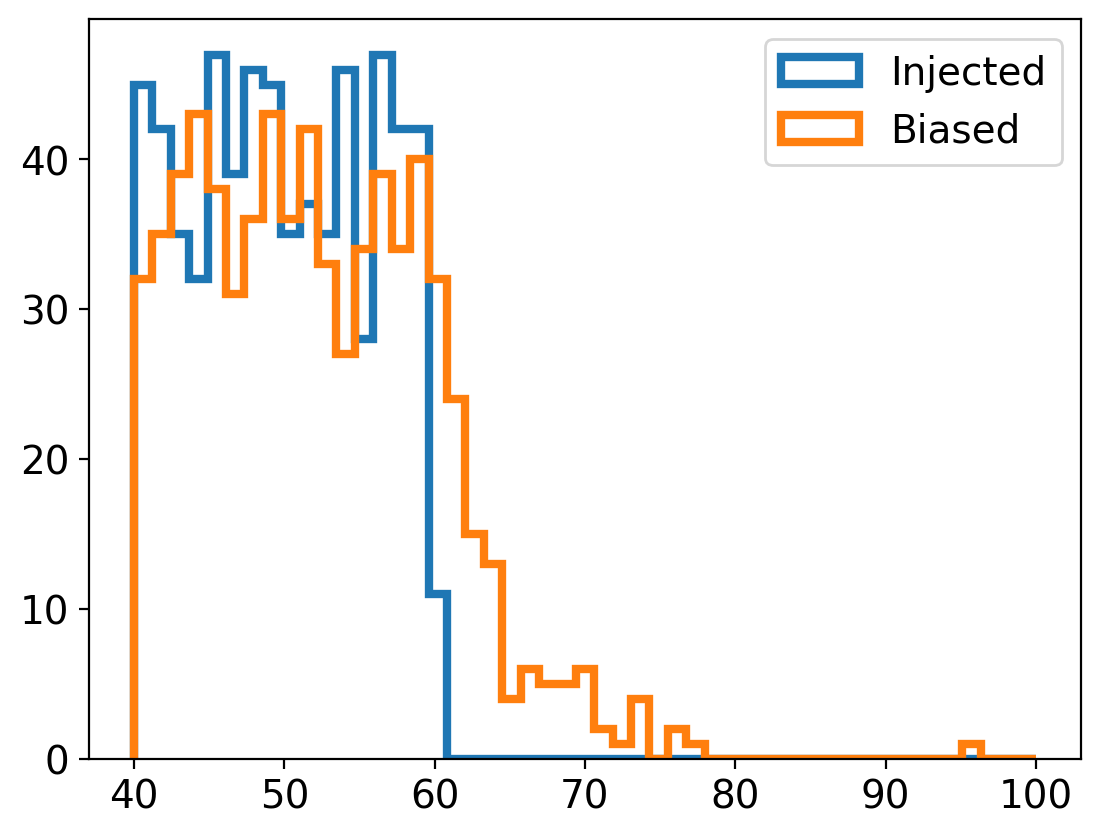

In [74]:
bins = np.linspace(40, 100, 50)
plt.hist(mass1, bins=bins, histtype='step', lw=3, label='Injected')
plt.hist(mass1_biased, bins=bins, histtype='step', lw=3, label='Biased')

print(f"{100*np.sum(np.array(mass1_biased)>60.0)/num_injs} % binaries above mass gap")

plt.legend()
plt.show()

# Plot distribution of binaries that contaminate the mass gap

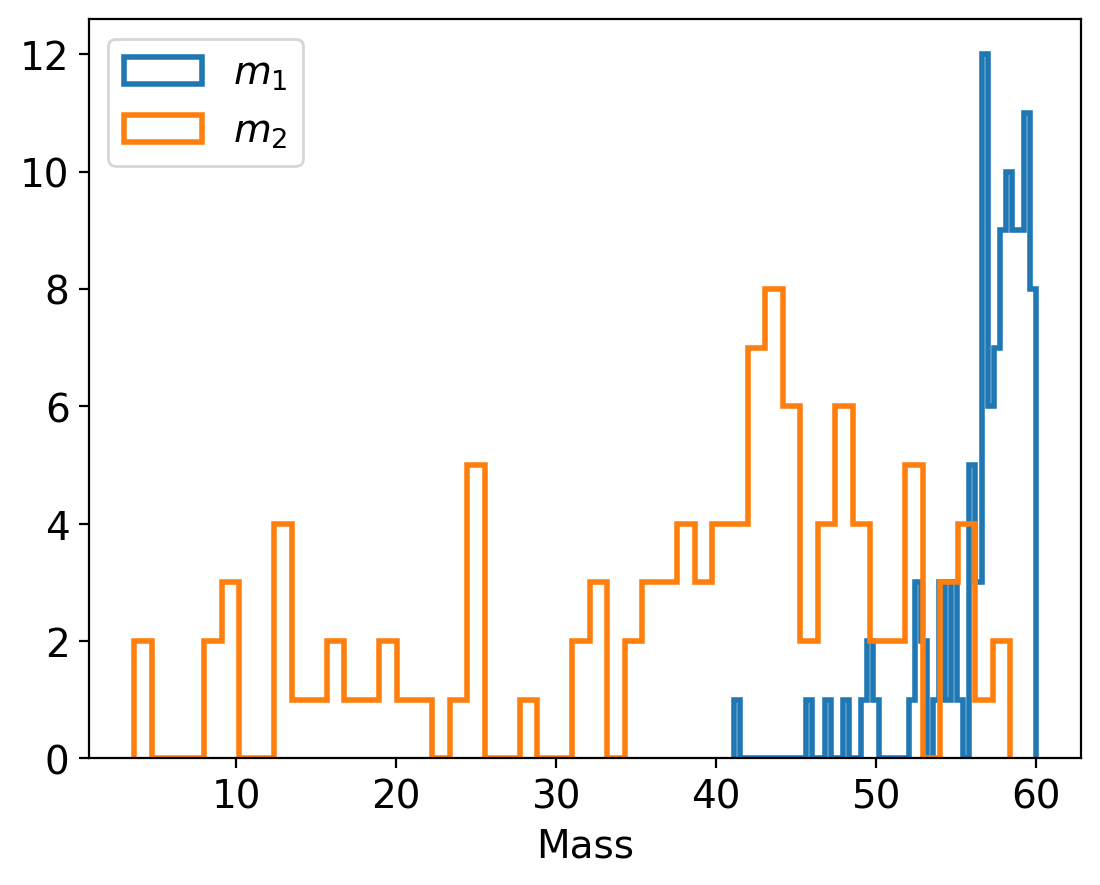

In [79]:
# Mass
plt.hist(mass1[np.array(mass1_biased)>60.0], bins=50, lw=2, histtype='step', label='$m_1$')
plt.hist(mass2[np.array(mass1_biased)>60.0], bins=50, lw=2, histtype='step', label='$m_2$')
plt.legend()
plt.xlabel('Mass')
plt.show()

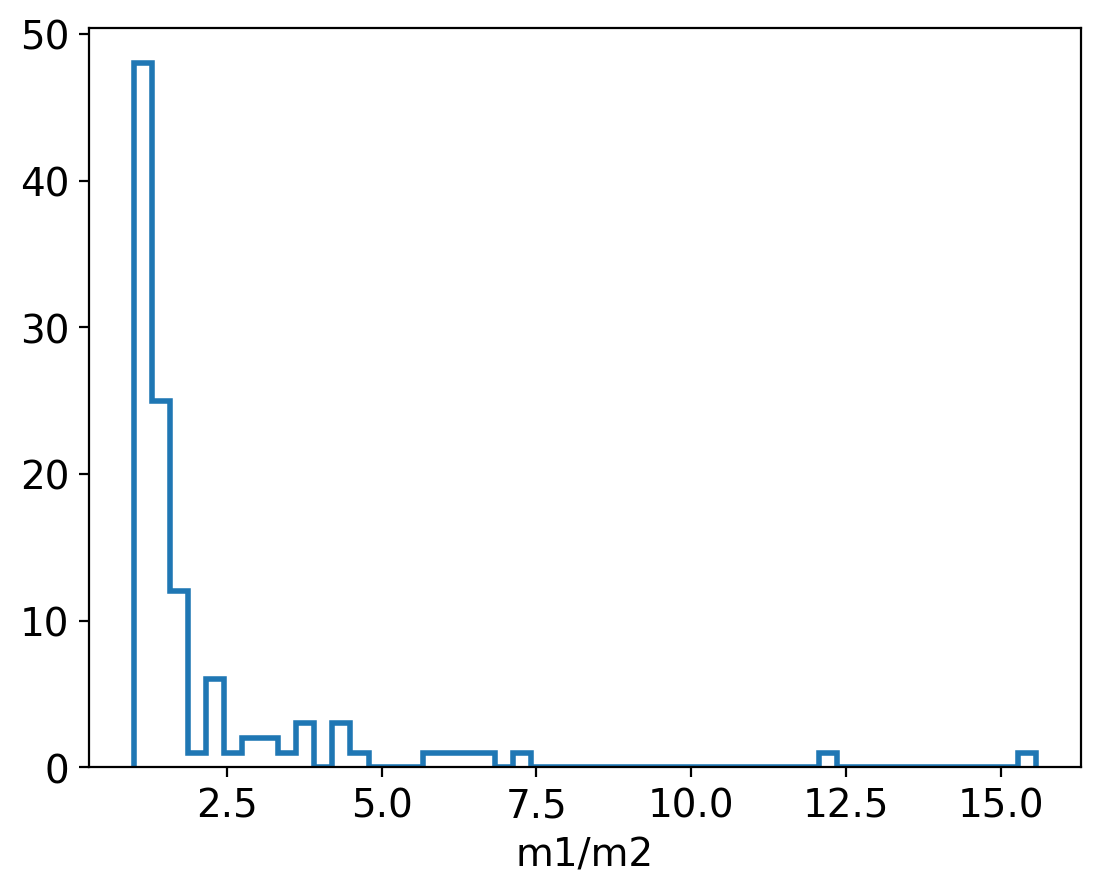

In [80]:
# mass ratio
plt.hist((mass1/mass2)[np.array(mass1_biased)>60.0], bins=50, lw=2, histtype='step')
plt.xlabel('m1/m2')
plt.show()

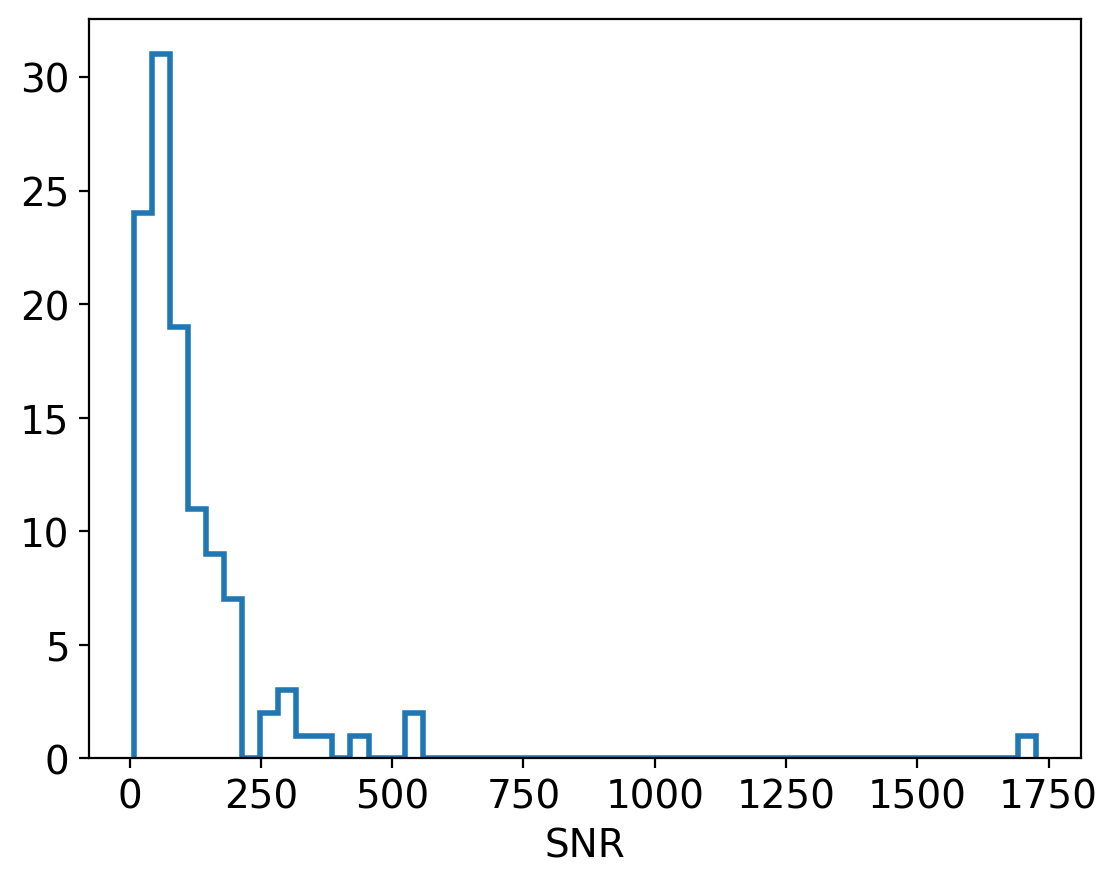

In [81]:
# SNR
plt.hist(np.array(snrs)[np.array(mass1_biased)>60.0], bins=50, lw=2, histtype='step')
plt.xlabel('SNR')
plt.show()

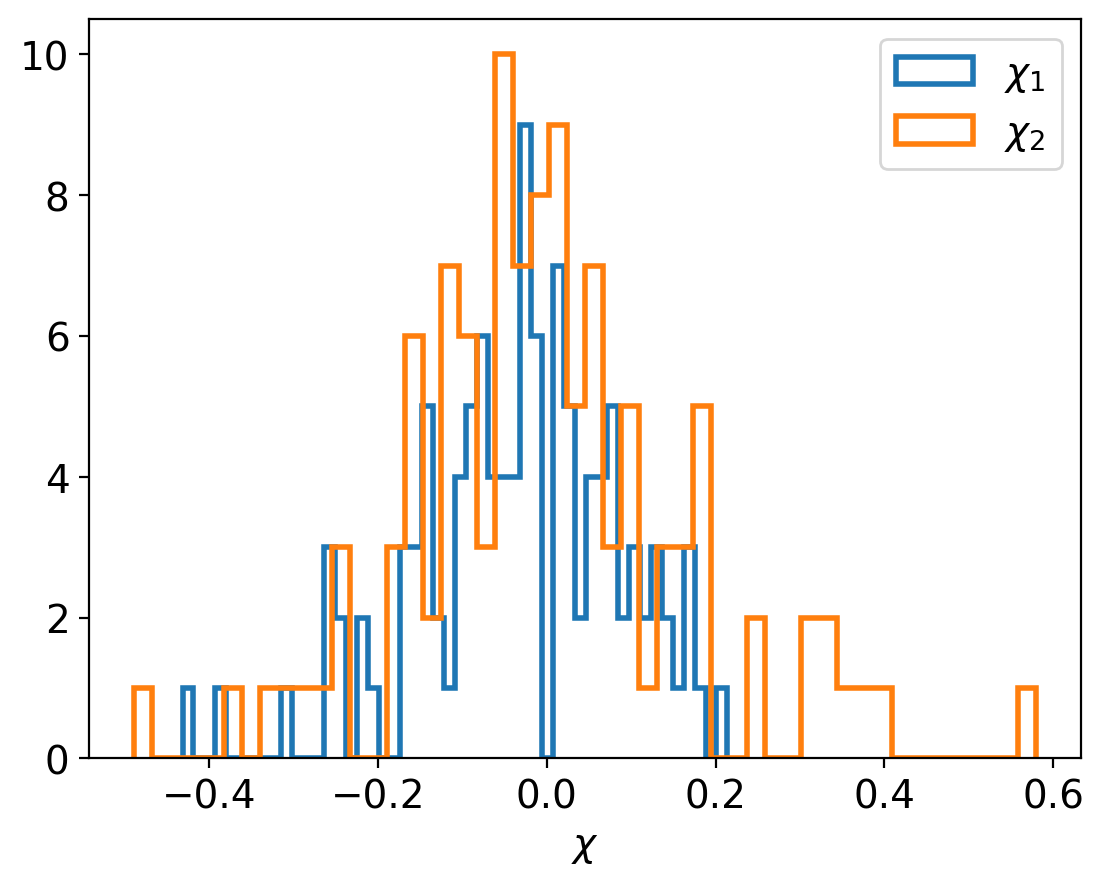

In [82]:
# Spin
plt.hist(np.array(chi1z)[np.array(mass1_biased)>60.0], bins=50, lw=2, histtype='step', label='$\chi_1$')
plt.hist(np.array(chi2z)[np.array(mass1_biased)>60.0], bins=50, lw=2, histtype='step', label='$\chi_2$')

plt.legend()
plt.xlabel('$\chi$')
plt.show()

# Pick a Binary

In [132]:
index = np.where((np.array(mass1_biased)> 70.) & (np.array(np.abs(chi1z))<0.2) & 
                 (np.array(redshifts)<2) & (np.array(mass1_biased)> 70.) & (np.array(snrs)>100.))[0][0]
print(index)

print(mass1[index])
print(mass2[index])
print(redshifts[index])
print(snrs[index])
print(chi1z[index])
print(chi2z[index])
print(DLs[index])

443
41.11926441200673
19.91543194255692
0.5714762010580896
119.02074298395081
-0.07084768967588852
0.5793732030727463
3428.088990228796


2024-01-14 12:30:40,007 - Network - INFO : Polarizations calculated.
2024-01-14 12:30:40,008 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-14 12:30:40,010 - Network - INFO : Polarizations calculated.


{'Mc': 38.64857545328111, 'eta': 0.21982723151141015, 'chi1x': 0.0, 'chi2x': 0.0, 'chi1y': 0.0, 'chi2y': 0.0, 'chi1z': -0.07084768967588852, 'chi2z': 0.5793732030727463, 'DL': 3428.088990228796, 'tc': 0.0, 'phic': 0.0, 'iota': 1.2770778441387411, 'ra': 2.615168733980148, 'dec': 0.2425708015469734, 'psi': 6.112638324708644, 'gmst0': 0.0, 'fRef': 5.0}


2024-01-14 12:30:40,908 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-14 12:30:40,980 - Network - INFO : PSDs loaded.
2024-01-14 12:30:40,983 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:30:40,996 - Network - INFO : Detector responses calculated.
2024-01-14 12:30:40,997 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-14 12:30:40,997 - Network - INFO :    CE-40_C
2024-01-14 12:30:41,614 - Network - INFO :    CE-20_S
2024-01-14 12:30:42,266 - Network - INFO :    ET_ET1
2024-01-14 12:30:42,880 - Network - INFO :    ET_ET2
2024-01-14 12:30:43,496 - Network - INFO :    ET_ET3
2024-01-14 12:30:44,089 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-14 12:30:44,092 - Network - INFO : SNRs calculated.
2024-01-14 12:30:44,093 - Network - INFO : Calculate errors (Fisher & cov matrices).
2024-01-14 12:30:44,094 - Network - INFO :    CE-40_C
2024-01-14 12:30:44,152 - Network - INFO :

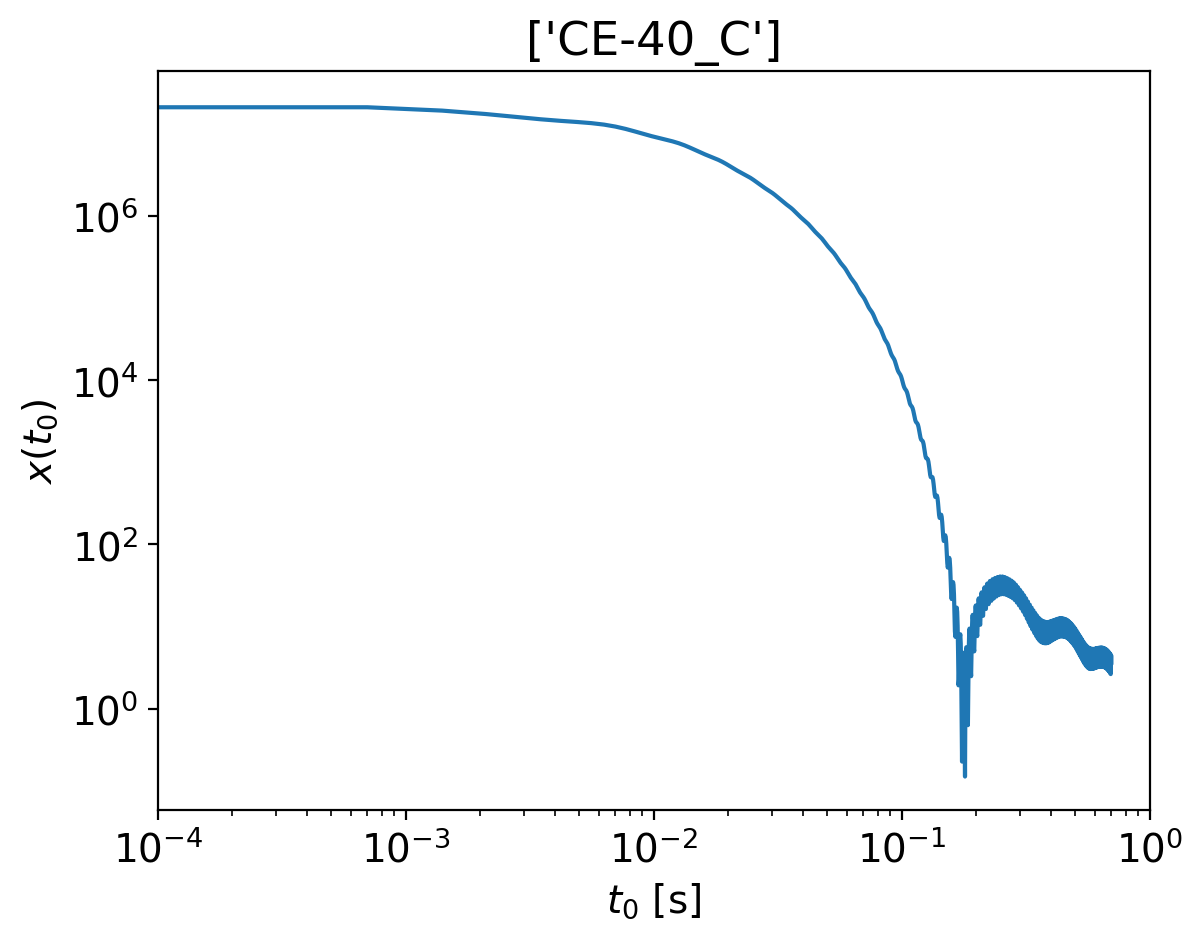

2024-01-14 12:30:45,145 - Network - INFO : Polarizations calculated.
2024-01-14 12:30:45,151 - Network - INFO : PSDs loaded.
2024-01-14 12:30:45,152 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:30:45,156 - Network - INFO : Detector responses calculated.
2024-01-14 12:30:45,160 - Network - INFO : Polarizations calculated.


time shift: 0.0
phase shift: -2.1881723033784644
Inner product:
0.9682256376812327


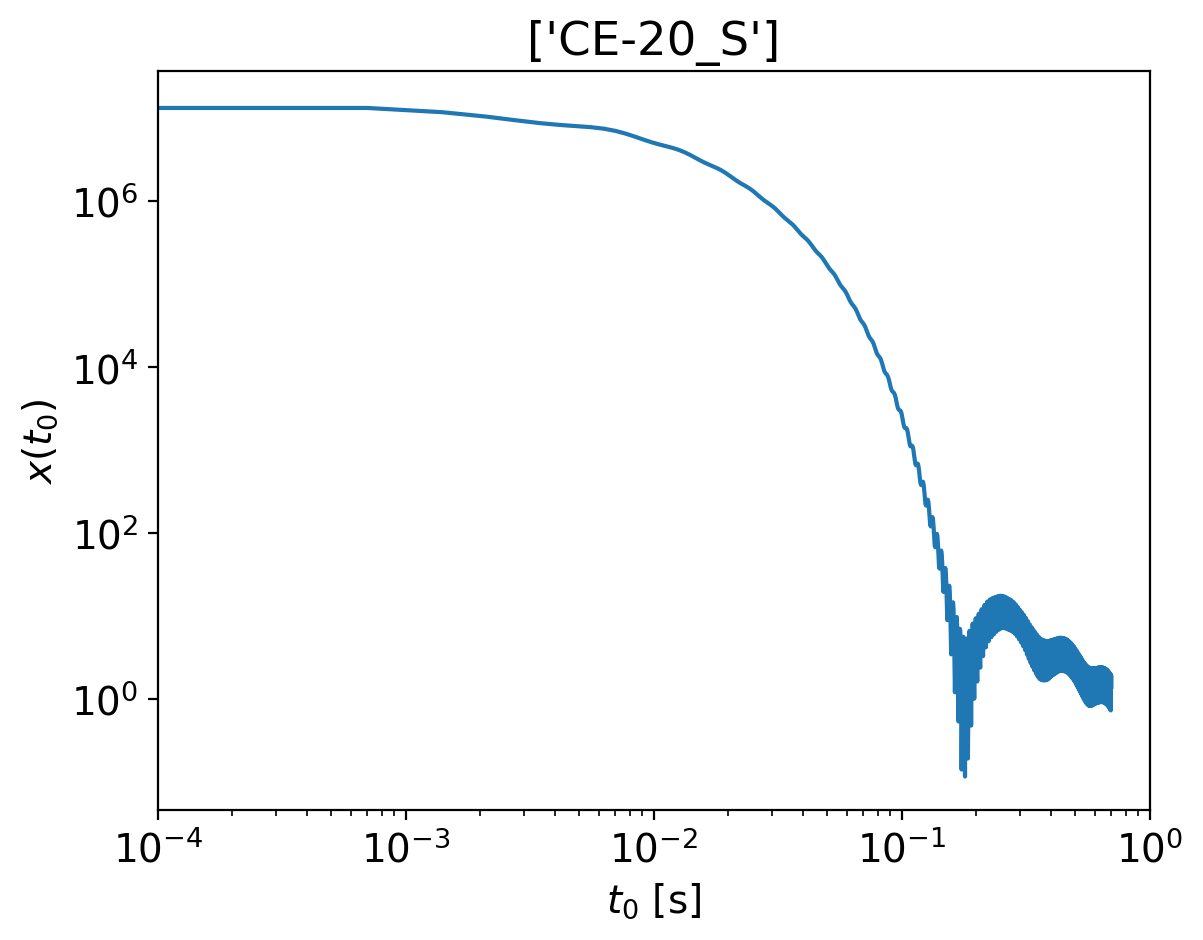

2024-01-14 12:30:45,863 - Network - INFO : Polarizations calculated.
2024-01-14 12:30:45,870 - Network - INFO : PSDs loaded.
2024-01-14 12:30:45,870 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:30:45,874 - Network - INFO : Detector responses calculated.
2024-01-14 12:30:45,877 - Network - INFO : Polarizations calculated.


time shift: 0.0
phase shift: -2.1613759437489324
Inner product:
0.9600995678803198


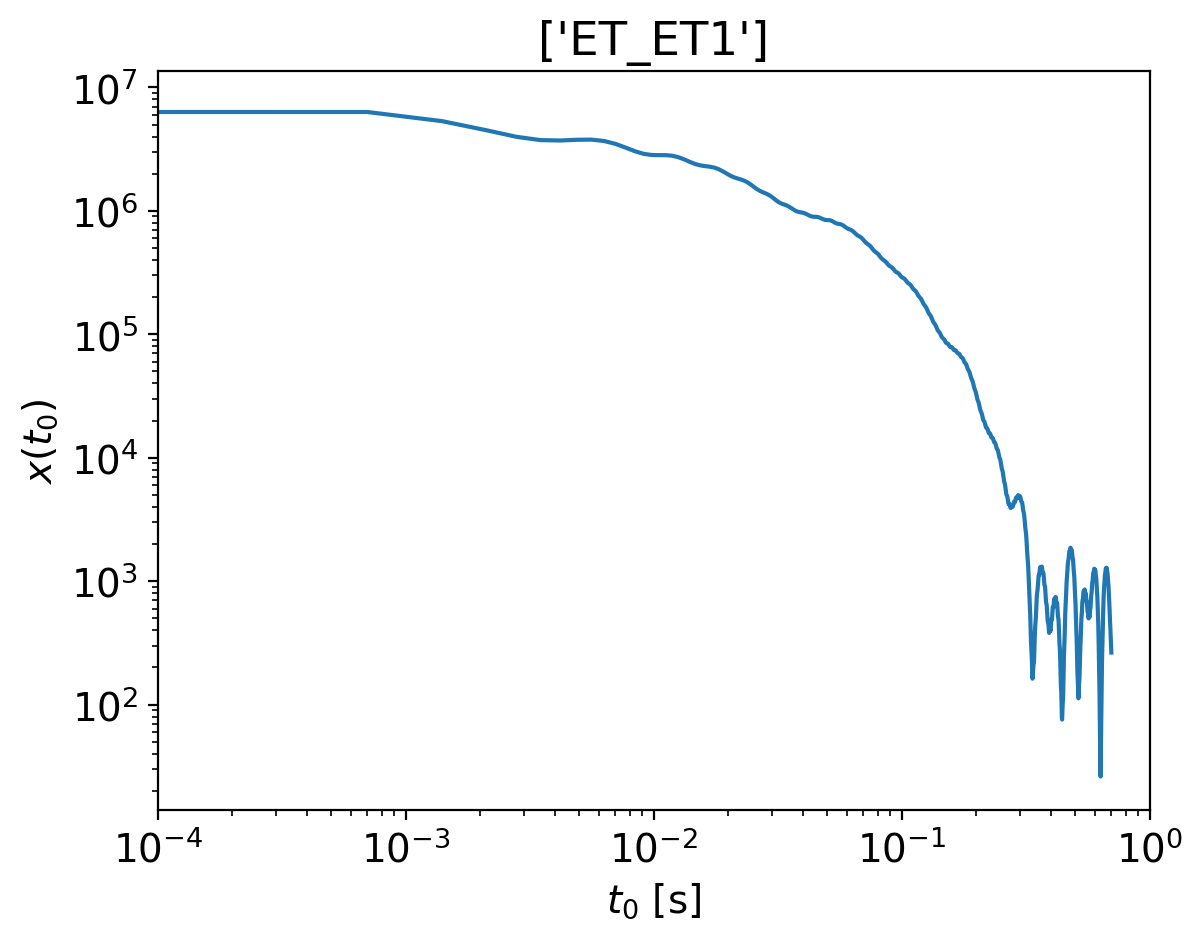

2024-01-14 12:30:46,997 - Network - INFO : Polarizations calculated.
2024-01-14 12:30:47,009 - Network - INFO : PSDs loaded.
2024-01-14 12:30:47,010 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:30:47,014 - Network - INFO : Detector responses calculated.
2024-01-14 12:30:47,017 - Network - INFO : Polarizations calculated.


time shift: 0.0
phase shift: -2.164081057382977
Inner product:
0.9430546367799144


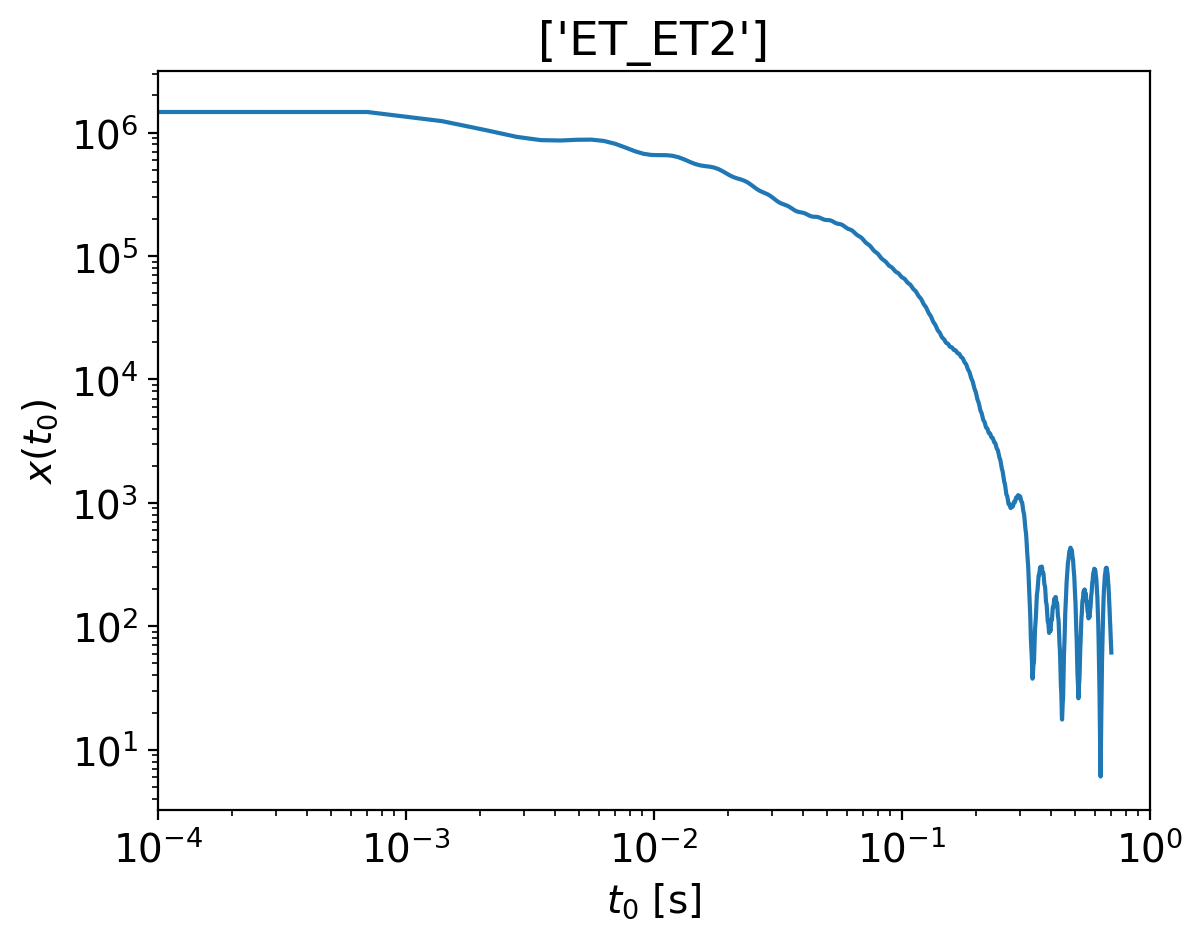

2024-01-14 12:30:47,952 - Network - INFO : Polarizations calculated.
2024-01-14 12:30:47,966 - Network - INFO : PSDs loaded.
2024-01-14 12:30:47,967 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:30:47,972 - Network - INFO : Detector responses calculated.
2024-01-14 12:30:47,975 - Network - INFO : Polarizations calculated.


time shift: 0.0
phase shift: -2.164081057382977
Inner product:
0.9430546367799142


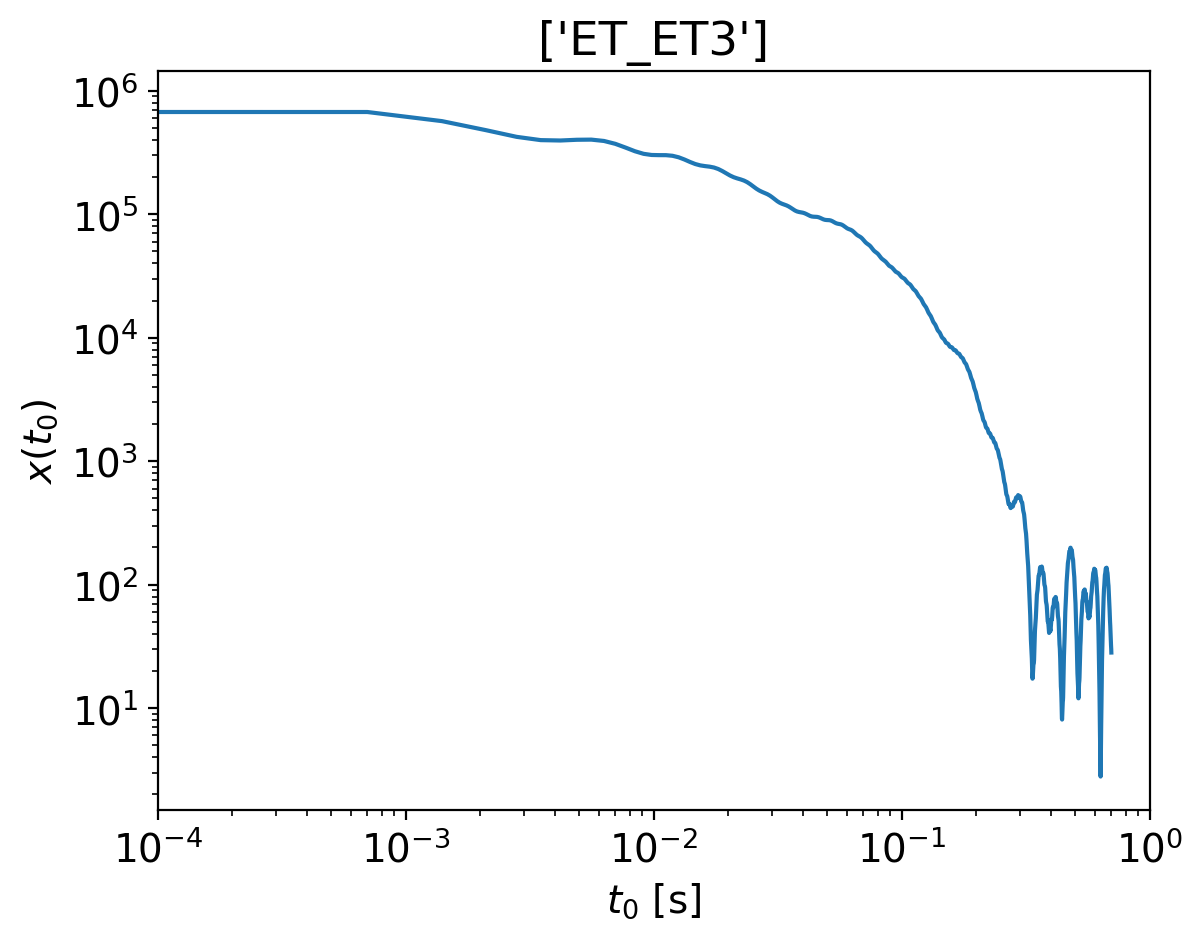

2024-01-14 12:30:48,932 - Network - INFO : Polarizations calculated.
2024-01-14 12:30:48,944 - Network - INFO : PSDs loaded.
2024-01-14 12:30:48,945 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-14 12:30:48,949 - Network - INFO : Detector responses calculated.
2024-01-14 12:30:48,952 - Network - INFO : Polarizations calculated.


time shift: 0.0
phase shift: -2.1640810573829765
Inner product:
0.9430546367799143


In [133]:
inj_params = {
    'Mc':    Mcs[index],
    'eta':   etas[index],
    'chi1x': 0.,
    'chi2x': 0.,
    'chi1y': 0.,
    'chi2y': 0.,
    'chi1z': chi1z[index],
    'chi2z': chi2z[index],
    'DL':    DLs[index],
    'tc':    0.,
    'phic':  0.,
    'iota':  iotas[index],
    'ra':    ras[index],
    'dec':   decs[index],
    'psi':   psis[index],
    # 'gmst0': bilby.gw.utils.greenwich_mean_sidereal_time(0.),
    'gmst0': 0.,
    'fRef': 5.
} 

print(inj_params)

d_f = 2**-4
f_low = 5.
f = np.arange(f_low, f_highs[index], d_f)

deriv_symbs_string = 'Mc eta DL chi1z chi2z tc phic iota ra dec psi'
deriv_variables = ['Mc', 'eta', 'DL', 'chi1z', 'chi2z', 'tc', 'phic', 'iota', 'ra', 'dec', 'psi']

net_ap = network.Network(network_spec=network_spec)

approximant = 'IMRPhenomD'
wf_model_name = 'lal_bbh'
# pass the chosen waveform to the network for initialization
net_ap.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant, 'fRef':inj_params['fRef']})


use_rot = 0

net_ap.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    use_rot=use_rot
    )
net_ap.calc_wf_polarizations()
net_ap.calc_wf_polarizations_derivs_num(step=1e-7, method='central', order=2, n=1)
net_ap.setup_ant_pat_lpf_psds()
net_ap.calc_det_responses()
net_ap.calc_det_responses_derivs_num(step=1e-7, method='central', order=2, n=1)
net_ap.calc_snrs()
net_ap.calc_errors()


net_tr = network.Network(network_spec=network_spec)

approximant = 'IMRPhenomXAS'
wf_model_name = 'lal_bbh'
# pass the chosen waveform to the network for initialization
net_tr.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant, 'fRef':inj_params['fRef']})

net_tr.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    use_rot=use_rot
    )
net_tr.calc_wf_polarizations()
net_tr.setup_ant_pat_lpf_psds()
net_tr.calc_det_responses()
net_tr.calc_snrs()


overlap_vecs_network = np.zeros((len(net_ap.detectors), len(net_ap.deriv_variables)))

time_arr_d = np.linspace(0.0, 0.7, 1001)

for d in range(len(net_ap.detectors)):

    ## set up initial waveforms
    h1 = net_tr.detectors[d].hf
    h2 = net_ap.detectors[d].hf
    f = net_ap.detectors[d].f
    Sn = net_ap.detectors[d].psd
    network_spec_d = [net_ap.detectors[d].det_key]

    x_t0_re_d = np.zeros(len(time_arr_d))
    x_t0_im_d = np.zeros(len(time_arr_d))

    for tt in range(len(time_arr_d)):
        t0 = time_arr_d[tt]
        x_t0_d = 4*(integrate.simpson(h1 * np.conjugate(h2) * np.exp(2*np.pi*1j*f*t0)/ Sn, x=f))
        x_t0_re_d[tt] = np.real(x_t0_d)
        x_t0_im_d[tt] = np.imag(x_t0_d)

    max_idx = np.argmax(x_t0_re_d**2 + x_t0_im_d**2)
    time_shift_d = time_arr_d[max_idx]
    phase_shift_d = (np.angle(x_t0_re_d + 1j*x_t0_im_d))[max_idx]


    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = time_shift_d # should be positive when shifting XAS to maximize overlap
    inj_params_opt_d['phic'] = phase_shift_d  # should be positive when shifting XAS to maximize overlap

    plt.title(network_spec_d)
    plt.plot(time_arr_d, x_t0_re_d**2 + x_t0_im_d**2)
    plt.axvline(x=time_shift_d, ls='--', c='r')
    plt.xlabel('$t_0$ [s]')
    plt.ylabel("$x(t_0)$")
    plt.loglog()
    plt.xlim(1e-4, 1e0)
    plt.show()
    print("time shift:", time_shift_d)
    print("phase shift:", phase_shift_d)

    net_tr_opt_d = network.Network(network_spec=network_spec_d)
    net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomXAS',  'fRef':inj_params['fRef']})
    net_tr_opt_d.set_net_vars(
        f=f, inj_params=inj_params_opt_d,
        deriv_symbs_string=deriv_symbs_string,
        use_rot=use_rot
        )
    net_tr_opt_d.calc_wf_polarizations()
    net_tr_opt_d.setup_ant_pat_lpf_psds()
    net_tr_opt_d.calc_det_responses()
    net_tr_opt_d.calc_wf_polarizations()

    print("Inner product:")
    print(inner_prod_simps_normed(net_ap.detectors[d].hf, net_tr_opt_d.detectors[0].hf, net_ap.detectors[d].psd, net_ap.detectors[d].f))

    ## Compute CV overlap vector for this detector
    delta_hf = net_tr_opt_d.detectors[0].hf - net_ap.detectors[d].hf
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap.detectors[d].del_hf, delta_hf, net_ap.detectors[d].psd, net_ap.detectors[d].f)

cv_bias_opt = np.matmul(net_ap.cov, np.sum(overlap_vecs_network, axis=0))
cv_bias_opt = np.array(cv_bias_opt.tolist()[0])

cv_bias_opt_dict = {}

for p, param in enumerate(net_ap.deriv_variables):
    cv_bias_opt_dict[param] = cv_bias_opt[p]

In [134]:
import scipy.stats as stats

def plot_bias(net_ap, cv_bias_opt_dict,  vars=['Mc', 'eta', 'chi1z', 'chi2z', 'DL']):

    fig, axes = plt.subplots(ncols=1, nrows=len(vars), figsize=(9, 2*len(vars)))
    ax = list(axes)

    for i, param in enumerate((vars)):
        mu = inj_params[param]
        sigma = net_ap.errs[param]
        bias = cv_bias_opt_dict[param]

        if param=='Mc':
            mu = mu/(1+redshifts[index])
            sigma = sigma/(1+redshifts[index])
            bias = bias/(1+redshifts[index])



        print(f"{param}: inj = {mu}")
        # print(f"{param} PE: inj = {PE_mu}")
    
        print(f"sigma = {sigma}")
        # print(f"sigma = {PE_sigma}")

        print(f"bias = {bias}")
        # print(f"bias = {pe_binary['bias'][param]} sig")
        print()

        x = np.linspace((mu+bias)-15*sigma, (mu+bias)+15*sigma, 10000)

        inj_est = stats.norm.pdf(x, mu, sigma)
        inj_est = inj_est/np.sum(inj_est)

        biased_est = stats.norm.pdf(x, mu+bias, sigma)
        biased_est = biased_est/ np.sum(biased_est)

        # PE_est = stats.norm.pdf(x, PE_mu+PE_delta, PE_sigma)
        # PE_est = PE_est/ np.sum(PE_est)

        
        
        ax[i].plot(x, inj_est, label=f"Injected (IMRPhenomXAS)", color='k', lw=2)
        ax[i].plot(x, biased_est, label=f"Recovered (IMRPhenomD)",color='r', lw=2)
        # ax[i].plot(x, PE_est, label=f"PE",color='b', lw=2, ls='--')

        ax[i].set_xlabel(param)
        ax[i].set_ylabel(f"p({param})")

        
    ax[0].legend(bbox_to_anchor=(1.1, 1), fontsize=14)
    # plt.suptitle(pe_binary['label'])
    plt.tight_layout()
    plt.show()

Mc: inj = 24.593802583366305
sigma = 0.008876388241529368
bias = 0.008460440423027392

eta: inj = 0.21982723151141015
sigma = 0.007418572437018156
bias = -0.09120658072485366

chi1z: inj = -0.07084768967588852
sigma = 0.1995169073343277
bias = 2.2118235923449845

chi2z: inj = 0.5793732030727463
sigma = 0.3834593594074249
bias = -3.939201870247075

DL: inj = 3428.088990228796
sigma = 76.0282211303711
bias = 68.57471772977078



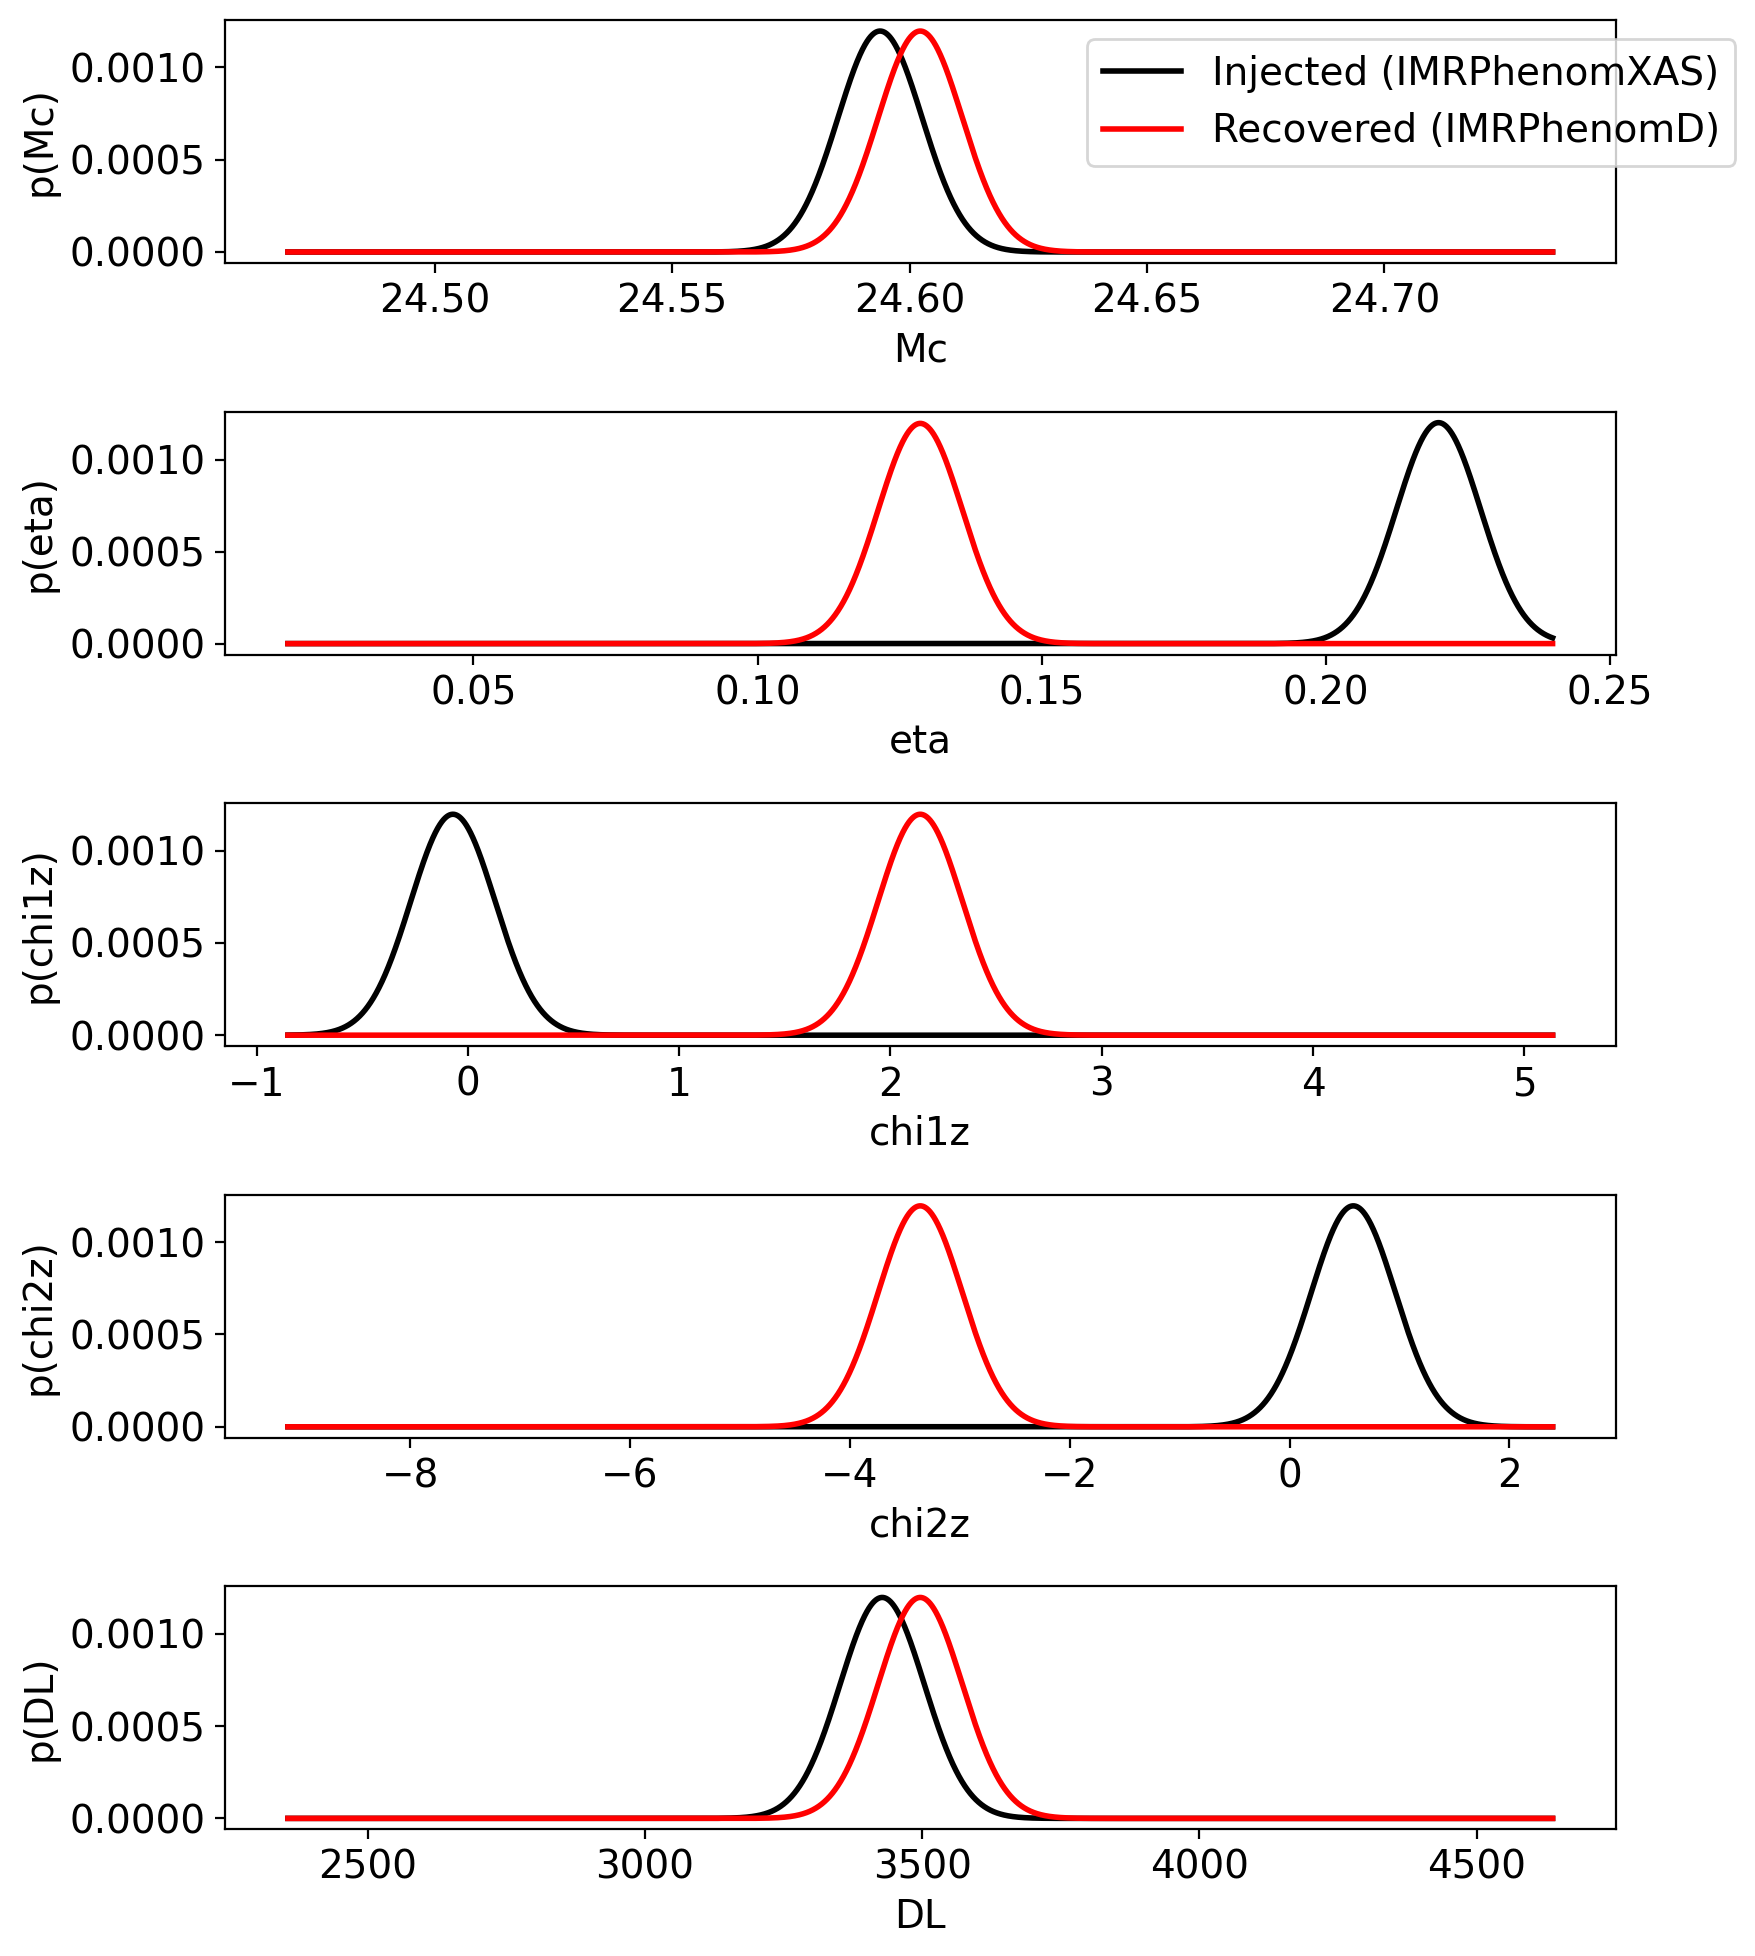

In [136]:
plot_bias(net_ap, cv_bias_opt_dict,  vars=['Mc', 'eta', 'chi1z', 'chi2z', 'DL'])

In [137]:
from pycbc import conversions as conv
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u

In [138]:
mc = inj_params["Mc"]
eta = inj_params["eta"]
dl = inj_params["DL"]
z = z_at_value(Planck18.luminosity_distance, dl* u.Mpc).value
m1_src = conv.mass1_from_mchirp_eta(mc, eta)/(1+z)

print(f"m1_src = {m1_src:.3f}")

mc = inj_params["Mc"] + cv_bias_opt_dict["Mc"]
eta = inj_params["eta"]+ cv_bias_opt_dict["eta"]
dl = inj_params["DL"] + cv_bias_opt_dict["DL"]

z = z_at_value(Planck18.luminosity_distance, dl* u.Mpc).value
m1_src = conv.mass1_from_mchirp_eta(mc, eta)/(1+z)

print(f"m1_src_biased = {m1_src:.3f}")

m1_src = 41.119
m1_src_biased = 71.020
